In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [14]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [15]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [16]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [17]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.drop(columns = ['spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9'], axis = 1)

    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS", "CB"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
        
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    def calculate_pitcher_stats(df):
        # Sort the DataFrame
        df_sorted = df.sort_values(by=['game_pk', 'pitcher', 'pitch_type_condensed', 'pitch_number'])

        # Calculate rolling average of release_speed for the last 5 pitches
        df_sorted['rolling_avg_velo'] = df_sorted.groupby(['game_pk', 'pitcher', 'pitch_type_condensed'])['release_speed'].transform(lambda x: x.rolling(5, min_periods=1).mean())

        # Calculate seasonal average for each pitcher and pitch type
        seasonal_avg = df.groupby(['pitcher', 'pitch_type_condensed'])['release_speed'].mean().reset_index()
        seasonal_avg = seasonal_avg.rename(columns={'release_speed': 'seasonal_avg_velo'})

        # Merge seasonal average back to the original DataFrame
        df_merged = df_sorted.merge(seasonal_avg, on=['pitcher', 'pitch_type_condensed'], how='left')

        # If rolling average is NaN, use the seasonal average
        df_merged['rolling_avg_velo'].fillna(df_merged['seasonal_avg_velo'], inplace=True)

        return df_merged
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    # Define a function to determine if the pitch resulted in a fly ball

    def is_fly_ball(bb_type):
        return 1 if (bb_type == "fly_ball" | bb_type == 'popup') else 0
    
    def is_ground_ball(bb_type):
        return 1 if bb_type == "ground_ball" else 0

    def is_line_drive(bb_type):
        return 1 if bb_type == "line_drive" else 0
    
    def is_fly_ball(bb_type):
        return 1 if bb_type == "fly_ball" else 0
    
    def is_foul(description):
        return 1 if description in ["foul_tip", "foul_pitchout", 'foul', 'foul_pitchout'] else 0

    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
        #create a function for whiffs
    def whiff(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", "missed_bunt", "swinging_pitchout"] else 0
    
    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Call the new function and store the result
    pitcher_stats = calculate_pitcher_stats(df)

    df = df.merge(pitcher_stats, how='left', on=['pitcher', 'pitch_type_condensed'])

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']

    df['swing'] = df['description'].apply(is_swing)

    df['whiff'] = df['description'].apply(whiff)

    df['contact'] = df['description'].apply(is_contact)

    df['foul'] = df['description'].apply(is_foul)

    df['fly_ball'] = df['bb_type'].apply(is_fly_ball)

    df['ground_ball'] = df['bb_type'].apply(is_ground_ball)

    df['line_drive'] = df['bb_type'].apply(is_line_drive)

    df['total_movement'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)
    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    return df

In [18]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('strike == 1')
testing_data_processed = preprocess_data(testing_data)


In [19]:
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [20]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']]
testing_identifiers = breaking_ball[['pitch_id_raw']]
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [21]:
train_data = training_features.drop(['called_strike'], axis=1).copy()
train_label = training_features['called_strike'].copy()
testing_data = testing_features.drop(['called_strike'], axis=1).copy()
testing_label = testing_features['called_strike'].copy()

In [22]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'pfx_x_avg', 'pfx_z_avg', 'avg_velo', 'pfx_x_max', 'pfx_z_max',
       'max_velo', 'height_numeric'],
      dtype='object')

In [23]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'pfx_x_avg', 'pfx_z_avg', 'avg_velo', 'pfx_x_max', 'pfx_z_max',
       'max_velo', 'height_numeric'],
      dtype='object')

In [24]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [25]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [26]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.7626486955633839
Log Loss: 0.5333155152005221


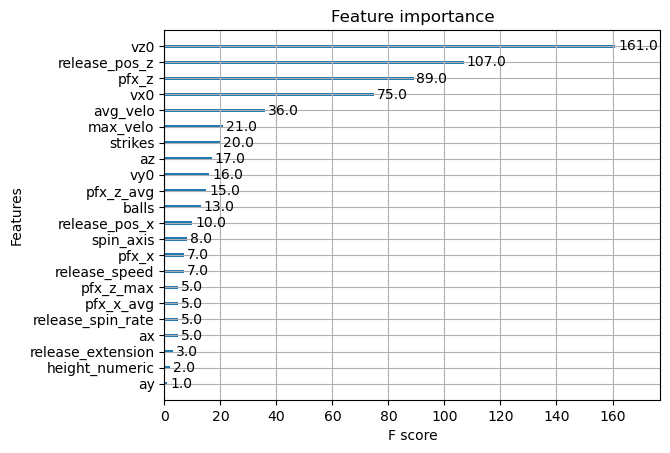

In [27]:
xgb.plot_importance(model)
plt.show()

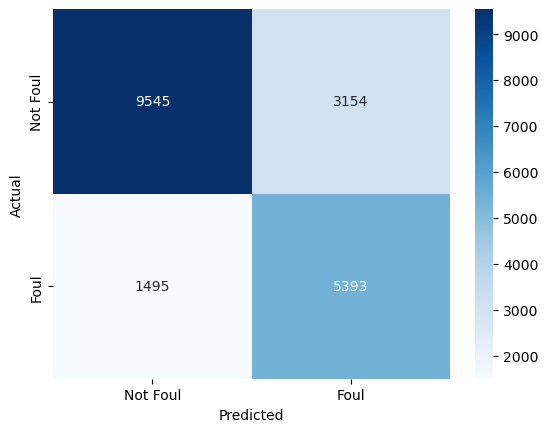

In [28]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Strike', 'Strike'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [29]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [30]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-13 09:42:11,035] A new study created in memory with name: no-name-270b897b-558f-4108-ac94-59d7b448aa2f


[0]	eval-logloss:0.64203
[1]	eval-logloss:0.61785
[2]	eval-logloss:0.58452
[3]	eval-logloss:0.56325
[4]	eval-logloss:0.54887
[5]	eval-logloss:0.54070
[6]	eval-logloss:0.53353
[7]	eval-logloss:0.52791
[8]	eval-logloss:0.52465
[9]	eval-logloss:0.52104
[10]	eval-logloss:0.51758
[11]	eval-logloss:0.51474
[12]	eval-logloss:0.51269
[13]	eval-logloss:0.51082
[14]	eval-logloss:0.50845
[15]	eval-logloss:0.50637
[16]	eval-logloss:0.50512
[17]	eval-logloss:0.50304
[18]	eval-logloss:0.50171
[19]	eval-logloss:0.50043
[20]	eval-logloss:0.49933
[21]	eval-logloss:0.49794
[22]	eval-logloss:0.49667
[23]	eval-logloss:0.49553
[24]	eval-logloss:0.49486
[25]	eval-logloss:0.49364
[26]	eval-logloss:0.49280
[27]	eval-logloss:0.49204
[28]	eval-logloss:0.49152
[29]	eval-logloss:0.49079
[30]	eval-logloss:0.49009
[31]	eval-logloss:0.48941
[32]	eval-logloss:0.48891
[33]	eval-logloss:0.48843
[34]	eval-logloss:0.48797
[35]	eval-logloss:0.48789
[36]	eval-logloss:0.48752
[37]	eval-logloss:0.48641
[38]	eval-logloss:0.48

[I 2023-11-13 09:42:11,618] Trial 0 finished with value: 0.47152161222936195 and parameters: {'max_depth': 3, 'eta': 0.22995669136840816, 'subsample': 0.7455710598805098, 'colsample_bytree': 0.8644582850933815}. Best is trial 0 with value: 0.47152161222936195.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68637
[2]	eval-logloss:0.67996
[3]	eval-logloss:0.66665
[4]	eval-logloss:0.65462
[5]	eval-logloss:0.65254
[6]	eval-logloss:0.64154
[7]	eval-logloss:0.63284
[8]	eval-logloss:0.62791
[9]	eval-logloss:0.61888
[10]	eval-logloss:0.61213
[11]	eval-logloss:0.60547
[12]	eval-logloss:0.59825
[13]	eval-logloss:0.59165
[14]	eval-logloss:0.59032
[15]	eval-logloss:0.58427
[16]	eval-logloss:0.58115
[17]	eval-logloss:0.57579
[18]	eval-logloss:0.57489
[19]	eval-logloss:0.57322
[20]	eval-logloss:0.57190
[21]	eval-logloss:0.56963
[22]	eval-logloss:0.56496
[23]	eval-logloss:0.56127
[24]	eval-logloss:0.55908
[25]	eval-logloss:0.55717
[26]	eval-logloss:0.55344
[27]	eval-logloss:0.55158
[28]	eval-logloss:0.54884
[29]	eval-logloss:0.54711
[30]	eval-logloss:0.54665
[31]	eval-logloss:0.54516
[32]	eval-logloss:0.54276
[33]	eval-logloss:0.54063
[34]	eval-logloss:0.53978
[35]	eval-logloss:0.53952
[36]	eval-logloss:0.53877
[37]	eval-logloss:0.53739
[38]	eval-logloss:0.53

[I 2023-11-13 09:42:12,265] Trial 1 finished with value: 0.4946673437387748 and parameters: {'max_depth': 4, 'eta': 0.04792023933448204, 'subsample': 0.8399055934355828, 'colsample_bytree': 0.5317395381112671}. Best is trial 0 with value: 0.47152161222936195.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.65244
[3]	eval-logloss:0.61947
[4]	eval-logloss:0.59371
[5]	eval-logloss:0.58583
[6]	eval-logloss:0.56589
[7]	eval-logloss:0.55015
[8]	eval-logloss:0.54374
[9]	eval-logloss:0.53244
[10]	eval-logloss:0.52527
[11]	eval-logloss:0.51781
[12]	eval-logloss:0.51068
[13]	eval-logloss:0.50512
[14]	eval-logloss:0.50161
[15]	eval-logloss:0.49727
[16]	eval-logloss:0.49517
[17]	eval-logloss:0.49220
[18]	eval-logloss:0.49195
[19]	eval-logloss:0.48977
[20]	eval-logloss:0.48856
[21]	eval-logloss:0.48635
[22]	eval-logloss:0.48437
[23]	eval-logloss:0.48283
[24]	eval-logloss:0.48186
[25]	eval-logloss:0.48058
[26]	eval-logloss:0.47921
[27]	eval-logloss:0.47800
[28]	eval-logloss:0.47756
[29]	eval-logloss:0.47627
[30]	eval-logloss:0.47614
[31]	eval-logloss:0.47571
[32]	eval-logloss:0.47550
[33]	eval-logloss:0.47470
[34]	eval-logloss:0.47370
[35]	eval-logloss:0.47300
[36]	eval-logloss:0.47197
[37]	eval-logloss:0.47153
[38]	eval-logloss:0.47

[I 2023-11-13 09:42:13,156] Trial 2 finished with value: 0.460253930040003 and parameters: {'max_depth': 7, 'eta': 0.13705693954956552, 'subsample': 0.6279281661951426, 'colsample_bytree': 0.5889321168881844}. Best is trial 2 with value: 0.460253930040003.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68239
[2]	eval-logloss:0.67133
[3]	eval-logloss:0.65270
[4]	eval-logloss:0.63603
[5]	eval-logloss:0.63268
[6]	eval-logloss:0.61780
[7]	eval-logloss:0.60684
[8]	eval-logloss:0.60023
[9]	eval-logloss:0.58887
[10]	eval-logloss:0.58119
[11]	eval-logloss:0.57296
[12]	eval-logloss:0.56436
[13]	eval-logloss:0.55659
[14]	eval-logloss:0.55478
[15]	eval-logloss:0.54779
[16]	eval-logloss:0.54390
[17]	eval-logloss:0.53815
[18]	eval-logloss:0.53727
[19]	eval-logloss:0.53461
[20]	eval-logloss:0.53318
[21]	eval-logloss:0.53062
[22]	eval-logloss:0.52592
[23]	eval-logloss:0.52245
[24]	eval-logloss:0.52012
[25]	eval-logloss:0.51829
[26]	eval-logloss:0.51462
[27]	eval-logloss:0.51254
[28]	eval-logloss:0.51024
[29]	eval-logloss:0.50828
[30]	eval-logloss:0.50783
[31]	eval-logloss:0.50631
[32]	eval-logloss:0.50454
[33]	eval-logloss:0.50304
[34]	eval-logloss:0.50145
[35]	eval-logloss:0.50131
[36]	eval-logloss:0.50009
[37]	eval-logloss:0.49858
[38]	eval-logloss:0.49

[I 2023-11-13 09:42:14,042] Trial 3 finished with value: 0.46602326412782175 and parameters: {'max_depth': 7, 'eta': 0.06681553192080465, 'subsample': 0.7266858089627222, 'colsample_bytree': 0.5376668902619052}. Best is trial 2 with value: 0.460253930040003.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67095
[2]	eval-logloss:0.65668
[3]	eval-logloss:0.64388
[4]	eval-logloss:0.63205
[5]	eval-logloss:0.62231
[6]	eval-logloss:0.61214
[7]	eval-logloss:0.60261
[8]	eval-logloss:0.59744
[9]	eval-logloss:0.58911
[10]	eval-logloss:0.58345
[11]	eval-logloss:0.57716
[12]	eval-logloss:0.57026
[13]	eval-logloss:0.56386
[14]	eval-logloss:0.55796
[15]	eval-logloss:0.55242
[16]	eval-logloss:0.54889
[17]	eval-logloss:0.54405
[18]	eval-logloss:0.54141
[19]	eval-logloss:0.53677
[20]	eval-logloss:0.53421
[21]	eval-logloss:0.53032
[22]	eval-logloss:0.52665
[23]	eval-logloss:0.52391
[24]	eval-logloss:0.52173
[25]	eval-logloss:0.51860
[26]	eval-logloss:0.51557
[27]	eval-logloss:0.51282
[28]	eval-logloss:0.51023
[29]	eval-logloss:0.50774
[30]	eval-logloss:0.50612
[31]	eval-logloss:0.50388
[32]	eval-logloss:0.50192
[33]	eval-logloss:0.50014
[34]	eval-logloss:0.49829
[35]	eval-logloss:0.49684
[36]	eval-logloss:0.49575
[37]	eval-logloss:0.49423
[38]	eval-logloss:0.49

[I 2023-11-13 09:42:15,277] Trial 4 finished with value: 0.4627932964577027 and parameters: {'max_depth': 8, 'eta': 0.047889216504378385, 'subsample': 0.7150932087030986, 'colsample_bytree': 0.8096425550981952}. Best is trial 2 with value: 0.460253930040003.


[0]	eval-logloss:0.63990
[1]	eval-logloss:0.61489
[2]	eval-logloss:0.58088
[3]	eval-logloss:0.55986
[4]	eval-logloss:0.54571
[5]	eval-logloss:0.53771
[6]	eval-logloss:0.53118
[7]	eval-logloss:0.52612
[8]	eval-logloss:0.52254
[9]	eval-logloss:0.51945
[10]	eval-logloss:0.51706
[11]	eval-logloss:0.51421
[12]	eval-logloss:0.51186
[13]	eval-logloss:0.50969
[14]	eval-logloss:0.50813
[15]	eval-logloss:0.50657
[16]	eval-logloss:0.50491
[17]	eval-logloss:0.50368
[18]	eval-logloss:0.50227
[19]	eval-logloss:0.50084
[20]	eval-logloss:0.49985
[21]	eval-logloss:0.49870
[22]	eval-logloss:0.49758
[23]	eval-logloss:0.49671
[24]	eval-logloss:0.49587
[25]	eval-logloss:0.49495
[26]	eval-logloss:0.49398
[27]	eval-logloss:0.49269
[28]	eval-logloss:0.49186
[29]	eval-logloss:0.49107
[30]	eval-logloss:0.49063
[31]	eval-logloss:0.49013
[32]	eval-logloss:0.48986
[33]	eval-logloss:0.48927
[34]	eval-logloss:0.48893
[35]	eval-logloss:0.48831
[36]	eval-logloss:0.48764
[37]	eval-logloss:0.48680
[38]	eval-logloss:0.48

[I 2023-11-13 09:42:15,885] Trial 5 finished with value: 0.47147675674922646 and parameters: {'max_depth': 3, 'eta': 0.24211030690235172, 'subsample': 0.6594989116480007, 'colsample_bytree': 0.8344091201044029}. Best is trial 2 with value: 0.460253930040003.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.68018
[2]	eval-logloss:0.67122
[3]	eval-logloss:0.66292
[4]	eval-logloss:0.65507
[5]	eval-logloss:0.64884
[6]	eval-logloss:0.64191
[7]	eval-logloss:0.63539
[8]	eval-logloss:0.63210
[9]	eval-logloss:0.62610
[10]	eval-logloss:0.62043
[11]	eval-logloss:0.61521
[12]	eval-logloss:0.61015
[13]	eval-logloss:0.60543
[14]	eval-logloss:0.60094
[15]	eval-logloss:0.59671
[16]	eval-logloss:0.59452
[17]	eval-logloss:0.59061
[18]	eval-logloss:0.58926
[19]	eval-logloss:0.58558
[20]	eval-logloss:0.58369
[21]	eval-logloss:0.58032
[22]	eval-logloss:0.57718
[23]	eval-logloss:0.57452
[24]	eval-logloss:0.57291
[25]	eval-logloss:0.57015
[26]	eval-logloss:0.56749
[27]	eval-logloss:0.56496
[28]	eval-logloss:0.56262
[29]	eval-logloss:0.56035
[30]	eval-logloss:0.55846
[31]	eval-logloss:0.55644
[32]	eval-logloss:0.55449
[33]	eval-logloss:0.55269
[34]	eval-logloss:0.55097
[35]	eval-logloss:0.54935
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54720
[38]	eval-logloss:0.54

[I 2023-11-13 09:42:16,532] Trial 6 finished with value: 0.5103368184971615 and parameters: {'max_depth': 3, 'eta': 0.03352005178471823, 'subsample': 0.7823215344396043, 'colsample_bytree': 0.8561645226773675}. Best is trial 2 with value: 0.460253930040003.


[0]	eval-logloss:0.64015
[1]	eval-logloss:0.62163
[2]	eval-logloss:0.59629
[3]	eval-logloss:0.56362
[4]	eval-logloss:0.54251
[5]	eval-logloss:0.53609
[6]	eval-logloss:0.52247
[7]	eval-logloss:0.51316
[8]	eval-logloss:0.50881
[9]	eval-logloss:0.50272
[10]	eval-logloss:0.49928
[11]	eval-logloss:0.49595
[12]	eval-logloss:0.49276
[13]	eval-logloss:0.49065
[14]	eval-logloss:0.48848
[15]	eval-logloss:0.48677
[16]	eval-logloss:0.48571
[17]	eval-logloss:0.48437
[18]	eval-logloss:0.48388
[19]	eval-logloss:0.48206
[20]	eval-logloss:0.48131
[21]	eval-logloss:0.48014
[22]	eval-logloss:0.47879
[23]	eval-logloss:0.47795
[24]	eval-logloss:0.47684
[25]	eval-logloss:0.47612
[26]	eval-logloss:0.47505
[27]	eval-logloss:0.47461
[28]	eval-logloss:0.47423
[29]	eval-logloss:0.47342
[30]	eval-logloss:0.47321
[31]	eval-logloss:0.47292
[32]	eval-logloss:0.47268
[33]	eval-logloss:0.47220
[34]	eval-logloss:0.47121
[35]	eval-logloss:0.47094
[36]	eval-logloss:0.47048
[37]	eval-logloss:0.47002
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:17,229] Trial 7 finished with value: 0.46333112231811285 and parameters: {'max_depth': 5, 'eta': 0.23868003554817632, 'subsample': 0.8639430724936382, 'colsample_bytree': 0.6271015713258037}. Best is trial 2 with value: 0.460253930040003.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.67402
[2]	eval-logloss:0.65383
[3]	eval-logloss:0.62301
[4]	eval-logloss:0.59804
[5]	eval-logloss:0.59294
[6]	eval-logloss:0.57298
[7]	eval-logloss:0.55742
[8]	eval-logloss:0.55066
[9]	eval-logloss:0.53833
[10]	eval-logloss:0.53067
[11]	eval-logloss:0.52224
[12]	eval-logloss:0.51444
[13]	eval-logloss:0.50821
[14]	eval-logloss:0.50459
[15]	eval-logloss:0.49957
[16]	eval-logloss:0.49673
[17]	eval-logloss:0.49308
[18]	eval-logloss:0.49258
[19]	eval-logloss:0.48984
[20]	eval-logloss:0.48843
[21]	eval-logloss:0.48693
[22]	eval-logloss:0.48378
[23]	eval-logloss:0.48175
[24]	eval-logloss:0.48057
[25]	eval-logloss:0.47897
[26]	eval-logloss:0.47726
[27]	eval-logloss:0.47589
[28]	eval-logloss:0.47485
[29]	eval-logloss:0.47366
[30]	eval-logloss:0.47341
[31]	eval-logloss:0.47280
[32]	eval-logloss:0.47221
[33]	eval-logloss:0.47140
[34]	eval-logloss:0.47024
[35]	eval-logloss:0.46982
[36]	eval-logloss:0.46862
[37]	eval-logloss:0.46799
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:18,281] Trial 8 finished with value: 0.4552773548717789 and parameters: {'max_depth': 8, 'eta': 0.12468712130263966, 'subsample': 0.8537081414400336, 'colsample_bytree': 0.5757576881436124}. Best is trial 8 with value: 0.4552773548717789.


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.66558
[2]	eval-logloss:0.65488
[3]	eval-logloss:0.63857
[4]	eval-logloss:0.62388
[5]	eval-logloss:0.61929
[6]	eval-logloss:0.60645
[7]	eval-logloss:0.59494
[8]	eval-logloss:0.58930
[9]	eval-logloss:0.57925
[10]	eval-logloss:0.57241
[11]	eval-logloss:0.56516
[12]	eval-logloss:0.55762
[13]	eval-logloss:0.55083
[14]	eval-logloss:0.54463
[15]	eval-logloss:0.53888
[16]	eval-logloss:0.53558
[17]	eval-logloss:0.53095
[18]	eval-logloss:0.52834
[19]	eval-logloss:0.52620
[20]	eval-logloss:0.52395
[21]	eval-logloss:0.51992
[22]	eval-logloss:0.51617
[23]	eval-logloss:0.51344
[24]	eval-logloss:0.51143
[25]	eval-logloss:0.50859
[26]	eval-logloss:0.50572
[27]	eval-logloss:0.50319
[28]	eval-logloss:0.50108
[29]	eval-logloss:0.49886
[30]	eval-logloss:0.49844
[31]	eval-logloss:0.49646
[32]	eval-logloss:0.49488
[33]	eval-logloss:0.49333
[34]	eval-logloss:0.49217
[35]	eval-logloss:0.49099
[36]	eval-logloss:0.48996
[37]	eval-logloss:0.48866
[38]	eval-logloss:0.48

[I 2023-11-13 09:42:19,224] Trial 9 finished with value: 0.46386321462473196 and parameters: {'max_depth': 7, 'eta': 0.06374245697943699, 'subsample': 0.6423602449786064, 'colsample_bytree': 0.7253694123703942}. Best is trial 8 with value: 0.4552773548717789.


[0]	eval-logloss:0.65195
[1]	eval-logloss:0.61369
[2]	eval-logloss:0.58532
[3]	eval-logloss:0.56326
[4]	eval-logloss:0.54564
[5]	eval-logloss:0.53344
[6]	eval-logloss:0.52172
[7]	eval-logloss:0.51253
[8]	eval-logloss:0.50623
[9]	eval-logloss:0.49943
[10]	eval-logloss:0.49425
[11]	eval-logloss:0.49009
[12]	eval-logloss:0.48630
[13]	eval-logloss:0.48325
[14]	eval-logloss:0.48049
[15]	eval-logloss:0.47877
[16]	eval-logloss:0.47681
[17]	eval-logloss:0.47507
[18]	eval-logloss:0.47318
[19]	eval-logloss:0.47182
[20]	eval-logloss:0.47079
[21]	eval-logloss:0.46995
[22]	eval-logloss:0.46897
[23]	eval-logloss:0.46841
[24]	eval-logloss:0.46761
[25]	eval-logloss:0.46675
[26]	eval-logloss:0.46569
[27]	eval-logloss:0.46480
[28]	eval-logloss:0.46422
[29]	eval-logloss:0.46368
[30]	eval-logloss:0.46309
[31]	eval-logloss:0.46287
[32]	eval-logloss:0.46261
[33]	eval-logloss:0.46243
[34]	eval-logloss:0.46180
[35]	eval-logloss:0.46141
[36]	eval-logloss:0.46056
[37]	eval-logloss:0.46055
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:20,681] Trial 10 finished with value: 0.4546359467335503 and parameters: {'max_depth': 9, 'eta': 0.1457605576899904, 'subsample': 0.8880857685115588, 'colsample_bytree': 0.9581086764646081}. Best is trial 10 with value: 0.4546359467335503.


[0]	eval-logloss:0.65275
[1]	eval-logloss:0.61502
[2]	eval-logloss:0.58698
[3]	eval-logloss:0.56496
[4]	eval-logloss:0.54705
[5]	eval-logloss:0.53342
[6]	eval-logloss:0.52222
[7]	eval-logloss:0.51328
[8]	eval-logloss:0.50732
[9]	eval-logloss:0.50099
[10]	eval-logloss:0.49539
[11]	eval-logloss:0.49110
[12]	eval-logloss:0.48736
[13]	eval-logloss:0.48446
[14]	eval-logloss:0.48161
[15]	eval-logloss:0.47956
[16]	eval-logloss:0.47766
[17]	eval-logloss:0.47583
[18]	eval-logloss:0.47415
[19]	eval-logloss:0.47299
[20]	eval-logloss:0.47168
[21]	eval-logloss:0.47087
[22]	eval-logloss:0.46972
[23]	eval-logloss:0.46895
[24]	eval-logloss:0.46795
[25]	eval-logloss:0.46689
[26]	eval-logloss:0.46627
[27]	eval-logloss:0.46573
[28]	eval-logloss:0.46516
[29]	eval-logloss:0.46457
[30]	eval-logloss:0.46424
[31]	eval-logloss:0.46394
[32]	eval-logloss:0.46326
[33]	eval-logloss:0.46308
[34]	eval-logloss:0.46273
[35]	eval-logloss:0.46244
[36]	eval-logloss:0.46179
[37]	eval-logloss:0.46146
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:22,106] Trial 11 finished with value: 0.45472103856266893 and parameters: {'max_depth': 9, 'eta': 0.14266516116470151, 'subsample': 0.8815286307508343, 'colsample_bytree': 0.9706718744690371}. Best is trial 10 with value: 0.4546359467335503.


[0]	eval-logloss:0.64336
[1]	eval-logloss:0.59972
[2]	eval-logloss:0.56949
[3]	eval-logloss:0.54675
[4]	eval-logloss:0.52959
[5]	eval-logloss:0.51685
[6]	eval-logloss:0.50738
[7]	eval-logloss:0.50029
[8]	eval-logloss:0.49516
[9]	eval-logloss:0.49007
[10]	eval-logloss:0.48585
[11]	eval-logloss:0.48240
[12]	eval-logloss:0.48013
[13]	eval-logloss:0.47796
[14]	eval-logloss:0.47609
[15]	eval-logloss:0.47455
[16]	eval-logloss:0.47280
[17]	eval-logloss:0.47154
[18]	eval-logloss:0.46995
[19]	eval-logloss:0.46932
[20]	eval-logloss:0.46879
[21]	eval-logloss:0.46801
[22]	eval-logloss:0.46734
[23]	eval-logloss:0.46673
[24]	eval-logloss:0.46530
[25]	eval-logloss:0.46445
[26]	eval-logloss:0.46405
[27]	eval-logloss:0.46384
[28]	eval-logloss:0.46346
[29]	eval-logloss:0.46287
[30]	eval-logloss:0.46249
[31]	eval-logloss:0.46232
[32]	eval-logloss:0.46216
[33]	eval-logloss:0.46212
[34]	eval-logloss:0.46215
[35]	eval-logloss:0.46189
[36]	eval-logloss:0.46143
[37]	eval-logloss:0.46117
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:23,483] Trial 12 finished with value: 0.45758435148463505 and parameters: {'max_depth': 9, 'eta': 0.1801906905960477, 'subsample': 0.896841021204697, 'colsample_bytree': 0.9973602096745281}. Best is trial 10 with value: 0.4546359467335503.


[0]	eval-logloss:0.64300
[1]	eval-logloss:0.59905
[2]	eval-logloss:0.56830
[3]	eval-logloss:0.54566
[4]	eval-logloss:0.52870
[5]	eval-logloss:0.51569
[6]	eval-logloss:0.50607
[7]	eval-logloss:0.49855
[8]	eval-logloss:0.49288
[9]	eval-logloss:0.48792
[10]	eval-logloss:0.48392
[11]	eval-logloss:0.48116
[12]	eval-logloss:0.47831
[13]	eval-logloss:0.47617
[14]	eval-logloss:0.47387
[15]	eval-logloss:0.47260
[16]	eval-logloss:0.47079
[17]	eval-logloss:0.46962
[18]	eval-logloss:0.46848
[19]	eval-logloss:0.46786
[20]	eval-logloss:0.46690
[21]	eval-logloss:0.46617
[22]	eval-logloss:0.46526
[23]	eval-logloss:0.46447
[24]	eval-logloss:0.46445
[25]	eval-logloss:0.46405
[26]	eval-logloss:0.46323
[27]	eval-logloss:0.46296
[28]	eval-logloss:0.46264
[29]	eval-logloss:0.46237
[30]	eval-logloss:0.46221
[31]	eval-logloss:0.46197
[32]	eval-logloss:0.46156
[33]	eval-logloss:0.46147
[34]	eval-logloss:0.46096
[35]	eval-logloss:0.46088
[36]	eval-logloss:0.46073
[37]	eval-logloss:0.46055
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:24,886] Trial 13 finished with value: 0.4593903972191641 and parameters: {'max_depth': 9, 'eta': 0.1814653595548357, 'subsample': 0.8127262518373085, 'colsample_bytree': 0.9925729019865863}. Best is trial 10 with value: 0.4546359467335503.


[0]	eval-logloss:0.61784
[1]	eval-logloss:0.56278
[2]	eval-logloss:0.53101
[3]	eval-logloss:0.51134
[4]	eval-logloss:0.49870
[5]	eval-logloss:0.49099
[6]	eval-logloss:0.48501
[7]	eval-logloss:0.48057
[8]	eval-logloss:0.47731
[9]	eval-logloss:0.47515
[10]	eval-logloss:0.47349
[11]	eval-logloss:0.47171
[12]	eval-logloss:0.47015
[13]	eval-logloss:0.46914
[14]	eval-logloss:0.46824
[15]	eval-logloss:0.46779
[16]	eval-logloss:0.46661
[17]	eval-logloss:0.46644
[18]	eval-logloss:0.46585
[19]	eval-logloss:0.46556
[20]	eval-logloss:0.46505
[21]	eval-logloss:0.46432
[22]	eval-logloss:0.46423
[23]	eval-logloss:0.46376
[24]	eval-logloss:0.46344
[25]	eval-logloss:0.46315
[26]	eval-logloss:0.46296
[27]	eval-logloss:0.46275
[28]	eval-logloss:0.46271
[29]	eval-logloss:0.46296
[30]	eval-logloss:0.46318
[31]	eval-logloss:0.46357
[32]	eval-logloss:0.46341
[33]	eval-logloss:0.46380
[34]	eval-logloss:0.46392
[35]	eval-logloss:0.46395
[36]	eval-logloss:0.46355
[37]	eval-logloss:0.46388
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:26,025] Trial 14 finished with value: 0.4730602987529089 and parameters: {'max_depth': 9, 'eta': 0.29085399738630235, 'subsample': 0.8944395775410684, 'colsample_bytree': 0.9257489155309261}. Best is trial 10 with value: 0.4546359467335503.


[0]	eval-logloss:0.66376
[1]	eval-logloss:0.63553
[2]	eval-logloss:0.61215
[3]	eval-logloss:0.59305
[4]	eval-logloss:0.57752
[5]	eval-logloss:0.56610
[6]	eval-logloss:0.55456
[7]	eval-logloss:0.54481
[8]	eval-logloss:0.53858
[9]	eval-logloss:0.53125
[10]	eval-logloss:0.52502
[11]	eval-logloss:0.51976
[12]	eval-logloss:0.51519
[13]	eval-logloss:0.51125
[14]	eval-logloss:0.50771
[15]	eval-logloss:0.50470
[16]	eval-logloss:0.50254
[17]	eval-logloss:0.50021
[18]	eval-logloss:0.49828
[19]	eval-logloss:0.49615
[20]	eval-logloss:0.49448
[21]	eval-logloss:0.49282
[22]	eval-logloss:0.49101
[23]	eval-logloss:0.48970
[24]	eval-logloss:0.48853
[25]	eval-logloss:0.48708
[26]	eval-logloss:0.48614
[27]	eval-logloss:0.48510
[28]	eval-logloss:0.48416
[29]	eval-logloss:0.48321
[30]	eval-logloss:0.48232
[31]	eval-logloss:0.48163
[32]	eval-logloss:0.48058
[33]	eval-logloss:0.48007
[34]	eval-logloss:0.47946
[35]	eval-logloss:0.47874
[36]	eval-logloss:0.47815
[37]	eval-logloss:0.47764
[38]	eval-logloss:0.47

[I 2023-11-13 09:42:26,901] Trial 15 finished with value: 0.4612345304610131 and parameters: {'max_depth': 6, 'eta': 0.10857916981060682, 'subsample': 0.8194510934006397, 'colsample_bytree': 0.9357170695996181}. Best is trial 10 with value: 0.4546359467335503.


[0]	eval-logloss:0.66225
[1]	eval-logloss:0.63214
[2]	eval-logloss:0.60764
[3]	eval-logloss:0.58737
[4]	eval-logloss:0.57084
[5]	eval-logloss:0.55859
[6]	eval-logloss:0.54653
[7]	eval-logloss:0.53620
[8]	eval-logloss:0.52948
[9]	eval-logloss:0.52144
[10]	eval-logloss:0.51473
[11]	eval-logloss:0.50897
[12]	eval-logloss:0.50394
[13]	eval-logloss:0.49983
[14]	eval-logloss:0.49595
[15]	eval-logloss:0.49271
[16]	eval-logloss:0.49060
[17]	eval-logloss:0.48798
[18]	eval-logloss:0.48594
[19]	eval-logloss:0.48365
[20]	eval-logloss:0.48228
[21]	eval-logloss:0.48083
[22]	eval-logloss:0.47936
[23]	eval-logloss:0.47800
[24]	eval-logloss:0.47661
[25]	eval-logloss:0.47554
[26]	eval-logloss:0.47417
[27]	eval-logloss:0.47343
[28]	eval-logloss:0.47260
[29]	eval-logloss:0.47172
[30]	eval-logloss:0.47083
[31]	eval-logloss:0.47042
[32]	eval-logloss:0.46961
[33]	eval-logloss:0.46909
[34]	eval-logloss:0.46854
[35]	eval-logloss:0.46820
[36]	eval-logloss:0.46747
[37]	eval-logloss:0.46701
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:28,086] Trial 16 finished with value: 0.4549238452322265 and parameters: {'max_depth': 8, 'eta': 0.10901387509026106, 'subsample': 0.7967881153629521, 'colsample_bytree': 0.9229437043722182}. Best is trial 10 with value: 0.4546359467335503.


[0]	eval-logloss:0.65567
[1]	eval-logloss:0.63153
[2]	eval-logloss:0.61291
[3]	eval-logloss:0.58505
[4]	eval-logloss:0.56432
[5]	eval-logloss:0.55758
[6]	eval-logloss:0.54229
[7]	eval-logloss:0.53047
[8]	eval-logloss:0.52580
[9]	eval-logloss:0.51724
[10]	eval-logloss:0.51208
[11]	eval-logloss:0.50655
[12]	eval-logloss:0.50187
[13]	eval-logloss:0.49822
[14]	eval-logloss:0.49501
[15]	eval-logloss:0.49248
[16]	eval-logloss:0.49046
[17]	eval-logloss:0.48834
[18]	eval-logloss:0.48621
[19]	eval-logloss:0.48463
[20]	eval-logloss:0.48353
[21]	eval-logloss:0.48233
[22]	eval-logloss:0.48096
[23]	eval-logloss:0.47997
[24]	eval-logloss:0.47878
[25]	eval-logloss:0.47789
[26]	eval-logloss:0.47708
[27]	eval-logloss:0.47654
[28]	eval-logloss:0.47580
[29]	eval-logloss:0.47503
[30]	eval-logloss:0.47462
[31]	eval-logloss:0.47423
[32]	eval-logloss:0.47391
[33]	eval-logloss:0.47338
[34]	eval-logloss:0.47249
[35]	eval-logloss:0.47234
[36]	eval-logloss:0.47151
[37]	eval-logloss:0.47101
[38]	eval-logloss:0.47

[I 2023-11-13 09:42:28,912] Trial 17 finished with value: 0.4598534636327513 and parameters: {'max_depth': 6, 'eta': 0.15956000158309097, 'subsample': 0.8719740284753319, 'colsample_bytree': 0.76295544614395}. Best is trial 10 with value: 0.4546359467335503.


[0]	eval-logloss:0.66551
[1]	eval-logloss:0.63764
[2]	eval-logloss:0.61519
[3]	eval-logloss:0.59578
[4]	eval-logloss:0.57932
[5]	eval-logloss:0.56672
[6]	eval-logloss:0.55431
[7]	eval-logloss:0.54391
[8]	eval-logloss:0.53680
[9]	eval-logloss:0.52824
[10]	eval-logloss:0.52096
[11]	eval-logloss:0.51477
[12]	eval-logloss:0.50911
[13]	eval-logloss:0.50429
[14]	eval-logloss:0.49990
[15]	eval-logloss:0.49631
[16]	eval-logloss:0.49351
[17]	eval-logloss:0.49025
[18]	eval-logloss:0.48816
[19]	eval-logloss:0.48557
[20]	eval-logloss:0.48370
[21]	eval-logloss:0.48187
[22]	eval-logloss:0.47990
[23]	eval-logloss:0.47853
[24]	eval-logloss:0.47729
[25]	eval-logloss:0.47580
[26]	eval-logloss:0.47454
[27]	eval-logloss:0.47344
[28]	eval-logloss:0.47234
[29]	eval-logloss:0.47159
[30]	eval-logloss:0.47077
[31]	eval-logloss:0.47012
[32]	eval-logloss:0.46935
[33]	eval-logloss:0.46869
[34]	eval-logloss:0.46809
[35]	eval-logloss:0.46772
[36]	eval-logloss:0.46695
[37]	eval-logloss:0.46632
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:30,427] Trial 18 finished with value: 0.45422740101419606 and parameters: {'max_depth': 9, 'eta': 0.09497321645065997, 'subsample': 0.8425618913094921, 'colsample_bytree': 0.9556389140733945}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.63886
[2]	eval-logloss:0.61615
[3]	eval-logloss:0.59700
[4]	eval-logloss:0.58090
[5]	eval-logloss:0.56880
[6]	eval-logloss:0.55679
[7]	eval-logloss:0.54650
[8]	eval-logloss:0.53967
[9]	eval-logloss:0.53126
[10]	eval-logloss:0.52422
[11]	eval-logloss:0.51816
[12]	eval-logloss:0.51272
[13]	eval-logloss:0.50818
[14]	eval-logloss:0.50385
[15]	eval-logloss:0.50020
[16]	eval-logloss:0.49758
[17]	eval-logloss:0.49440
[18]	eval-logloss:0.49237
[19]	eval-logloss:0.48984
[20]	eval-logloss:0.48814
[21]	eval-logloss:0.48609
[22]	eval-logloss:0.48416
[23]	eval-logloss:0.48278
[24]	eval-logloss:0.48151
[25]	eval-logloss:0.48022
[26]	eval-logloss:0.47897
[27]	eval-logloss:0.47806
[28]	eval-logloss:0.47694
[29]	eval-logloss:0.47601
[30]	eval-logloss:0.47507
[31]	eval-logloss:0.47417
[32]	eval-logloss:0.47355
[33]	eval-logloss:0.47298
[34]	eval-logloss:0.47234
[35]	eval-logloss:0.47197
[36]	eval-logloss:0.47117
[37]	eval-logloss:0.47057
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:31,656] Trial 19 finished with value: 0.45635665693684807 and parameters: {'max_depth': 8, 'eta': 0.09579500179366422, 'subsample': 0.8384214363230352, 'colsample_bytree': 0.8881538670308414}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68606
[2]	eval-logloss:0.68235
[3]	eval-logloss:0.67873
[4]	eval-logloss:0.67520
[5]	eval-logloss:0.67222
[6]	eval-logloss:0.66884
[7]	eval-logloss:0.66556
[8]	eval-logloss:0.66370
[9]	eval-logloss:0.66053
[10]	eval-logloss:0.65737
[11]	eval-logloss:0.65437
[12]	eval-logloss:0.65137
[13]	eval-logloss:0.64846
[14]	eval-logloss:0.64560
[15]	eval-logloss:0.64280
[16]	eval-logloss:0.64120
[17]	eval-logloss:0.63851
[18]	eval-logloss:0.63742
[19]	eval-logloss:0.63475
[20]	eval-logloss:0.63326
[21]	eval-logloss:0.63074
[22]	eval-logloss:0.62827
[23]	eval-logloss:0.62619
[24]	eval-logloss:0.62479
[25]	eval-logloss:0.62244
[26]	eval-logloss:0.62011
[27]	eval-logloss:0.61787
[28]	eval-logloss:0.61564
[29]	eval-logloss:0.61347
[30]	eval-logloss:0.61157
[31]	eval-logloss:0.60948
[32]	eval-logloss:0.60743
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60350
[35]	eval-logloss:0.60159
[36]	eval-logloss:0.59994
[37]	eval-logloss:0.59808
[38]	eval-logloss:0.59

[I 2023-11-13 09:42:32,462] Trial 20 finished with value: 0.5318414498621798 and parameters: {'max_depth': 5, 'eta': 0.012169825131634962, 'subsample': 0.7736234040844241, 'colsample_bytree': 0.9557445689976969}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.64022
[2]	eval-logloss:0.61807
[3]	eval-logloss:0.59916
[4]	eval-logloss:0.58300
[5]	eval-logloss:0.56911
[6]	eval-logloss:0.55710
[7]	eval-logloss:0.54691
[8]	eval-logloss:0.53996
[9]	eval-logloss:0.53170
[10]	eval-logloss:0.52402
[11]	eval-logloss:0.51762
[12]	eval-logloss:0.51182
[13]	eval-logloss:0.50678
[14]	eval-logloss:0.50213
[15]	eval-logloss:0.49830
[16]	eval-logloss:0.49570
[17]	eval-logloss:0.49261
[18]	eval-logloss:0.48966
[19]	eval-logloss:0.48720
[20]	eval-logloss:0.48523
[21]	eval-logloss:0.48319
[22]	eval-logloss:0.48124
[23]	eval-logloss:0.47950
[24]	eval-logloss:0.47816
[25]	eval-logloss:0.47652
[26]	eval-logloss:0.47519
[27]	eval-logloss:0.47414
[28]	eval-logloss:0.47290
[29]	eval-logloss:0.47204
[30]	eval-logloss:0.47123
[31]	eval-logloss:0.47029
[32]	eval-logloss:0.46973
[33]	eval-logloss:0.46912
[34]	eval-logloss:0.46847
[35]	eval-logloss:0.46802
[36]	eval-logloss:0.46748
[37]	eval-logloss:0.46683
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:34,082] Trial 21 finished with value: 0.45469026906762966 and parameters: {'max_depth': 9, 'eta': 0.09058310465929381, 'subsample': 0.8772258236932596, 'colsample_bytree': 0.9952184245953714}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.64420
[2]	eval-logloss:0.62337
[3]	eval-logloss:0.60543
[4]	eval-logloss:0.58998
[5]	eval-logloss:0.57798
[6]	eval-logloss:0.56571
[7]	eval-logloss:0.55496
[8]	eval-logloss:0.54790
[9]	eval-logloss:0.53918
[10]	eval-logloss:0.53155
[11]	eval-logloss:0.52478
[12]	eval-logloss:0.51868
[13]	eval-logloss:0.51334
[14]	eval-logloss:0.50850
[15]	eval-logloss:0.50431
[16]	eval-logloss:0.50112
[17]	eval-logloss:0.49750
[18]	eval-logloss:0.49520
[19]	eval-logloss:0.49212
[20]	eval-logloss:0.49015
[21]	eval-logloss:0.48774
[22]	eval-logloss:0.48541
[23]	eval-logloss:0.48369
[24]	eval-logloss:0.48203
[25]	eval-logloss:0.48042
[26]	eval-logloss:0.47856
[27]	eval-logloss:0.47708
[28]	eval-logloss:0.47569
[29]	eval-logloss:0.47448
[30]	eval-logloss:0.47340
[31]	eval-logloss:0.47250
[32]	eval-logloss:0.47144
[33]	eval-logloss:0.47075
[34]	eval-logloss:0.46980
[35]	eval-logloss:0.46931
[36]	eval-logloss:0.46868
[37]	eval-logloss:0.46798
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:35,921] Trial 22 finished with value: 0.4543944240672422 and parameters: {'max_depth': 9, 'eta': 0.08249011561054083, 'subsample': 0.8993421754706805, 'colsample_bytree': 0.9045789688215771}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.64851
[2]	eval-logloss:0.62888
[3]	eval-logloss:0.61181
[4]	eval-logloss:0.59697
[5]	eval-logloss:0.58538
[6]	eval-logloss:0.57364
[7]	eval-logloss:0.56327
[8]	eval-logloss:0.55667
[9]	eval-logloss:0.54793
[10]	eval-logloss:0.54025
[11]	eval-logloss:0.53351
[12]	eval-logloss:0.52740
[13]	eval-logloss:0.52203
[14]	eval-logloss:0.51721
[15]	eval-logloss:0.51298
[16]	eval-logloss:0.50976
[17]	eval-logloss:0.50604
[18]	eval-logloss:0.50373
[19]	eval-logloss:0.50046
[20]	eval-logloss:0.49828
[21]	eval-logloss:0.49582
[22]	eval-logloss:0.49333
[23]	eval-logloss:0.49152
[24]	eval-logloss:0.48995
[25]	eval-logloss:0.48803
[26]	eval-logloss:0.48620
[27]	eval-logloss:0.48451
[28]	eval-logloss:0.48305
[29]	eval-logloss:0.48167
[30]	eval-logloss:0.48050
[31]	eval-logloss:0.47940
[32]	eval-logloss:0.47827
[33]	eval-logloss:0.47720
[34]	eval-logloss:0.47617
[35]	eval-logloss:0.47550
[36]	eval-logloss:0.47462
[37]	eval-logloss:0.47385
[38]	eval-logloss:0.47

[I 2023-11-13 09:42:37,313] Trial 23 finished with value: 0.4561367138744504 and parameters: {'max_depth': 8, 'eta': 0.07663666761148788, 'subsample': 0.8517135407513045, 'colsample_bytree': 0.9026431013840583}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.65945
[1]	eval-logloss:0.62680
[2]	eval-logloss:0.60107
[3]	eval-logloss:0.57995
[4]	eval-logloss:0.56276
[5]	eval-logloss:0.55001
[6]	eval-logloss:0.53765
[7]	eval-logloss:0.52734
[8]	eval-logloss:0.52036
[9]	eval-logloss:0.51273
[10]	eval-logloss:0.50613
[11]	eval-logloss:0.50067
[12]	eval-logloss:0.49584
[13]	eval-logloss:0.49193
[14]	eval-logloss:0.48834
[15]	eval-logloss:0.48550
[16]	eval-logloss:0.48343
[17]	eval-logloss:0.48105
[18]	eval-logloss:0.47899
[19]	eval-logloss:0.47707
[20]	eval-logloss:0.47587
[21]	eval-logloss:0.47438
[22]	eval-logloss:0.47305
[23]	eval-logloss:0.47230
[24]	eval-logloss:0.47146
[25]	eval-logloss:0.47059
[26]	eval-logloss:0.46982
[27]	eval-logloss:0.46899
[28]	eval-logloss:0.46803
[29]	eval-logloss:0.46747
[30]	eval-logloss:0.46678
[31]	eval-logloss:0.46642
[32]	eval-logloss:0.46579
[33]	eval-logloss:0.46527
[34]	eval-logloss:0.46487
[35]	eval-logloss:0.46450
[36]	eval-logloss:0.46407
[37]	eval-logloss:0.46369
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:38,946] Trial 24 finished with value: 0.45577642056162365 and parameters: {'max_depth': 9, 'eta': 0.11695162735142711, 'subsample': 0.8989966387461125, 'colsample_bytree': 0.9531296812793166}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.64059
[2]	eval-logloss:0.61881
[3]	eval-logloss:0.60019
[4]	eval-logloss:0.58443
[5]	eval-logloss:0.57285
[6]	eval-logloss:0.56104
[7]	eval-logloss:0.55103
[8]	eval-logloss:0.54448
[9]	eval-logloss:0.53634
[10]	eval-logloss:0.52938
[11]	eval-logloss:0.52340
[12]	eval-logloss:0.51816
[13]	eval-logloss:0.51358
[14]	eval-logloss:0.50932
[15]	eval-logloss:0.50579
[16]	eval-logloss:0.50327
[17]	eval-logloss:0.50018
[18]	eval-logloss:0.49815
[19]	eval-logloss:0.49547
[20]	eval-logloss:0.49376
[21]	eval-logloss:0.49175
[22]	eval-logloss:0.48968
[23]	eval-logloss:0.48830
[24]	eval-logloss:0.48674
[25]	eval-logloss:0.48532
[26]	eval-logloss:0.48402
[27]	eval-logloss:0.48298
[28]	eval-logloss:0.48179
[29]	eval-logloss:0.48068
[30]	eval-logloss:0.47969
[31]	eval-logloss:0.47893
[32]	eval-logloss:0.47825
[33]	eval-logloss:0.47757
[34]	eval-logloss:0.47686
[35]	eval-logloss:0.47650
[36]	eval-logloss:0.47577
[37]	eval-logloss:0.47505
[38]	eval-logloss:0.47

[I 2023-11-13 09:42:40,084] Trial 25 finished with value: 0.4596874290102065 and parameters: {'max_depth': 7, 'eta': 0.0945615898174205, 'subsample': 0.8281867354901193, 'colsample_bytree': 0.908409475649317}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.64835
[2]	eval-logloss:0.62875
[3]	eval-logloss:0.61144
[4]	eval-logloss:0.59652
[5]	eval-logloss:0.58500
[6]	eval-logloss:0.57330
[7]	eval-logloss:0.56294
[8]	eval-logloss:0.55632
[9]	eval-logloss:0.54783
[10]	eval-logloss:0.54022
[11]	eval-logloss:0.53349
[12]	eval-logloss:0.52734
[13]	eval-logloss:0.52202
[14]	eval-logloss:0.51720
[15]	eval-logloss:0.51294
[16]	eval-logloss:0.50976
[17]	eval-logloss:0.50597
[18]	eval-logloss:0.50373
[19]	eval-logloss:0.50042
[20]	eval-logloss:0.49826
[21]	eval-logloss:0.49577
[22]	eval-logloss:0.49329
[23]	eval-logloss:0.49149
[24]	eval-logloss:0.48974
[25]	eval-logloss:0.48806
[26]	eval-logloss:0.48603
[27]	eval-logloss:0.48453
[28]	eval-logloss:0.48300
[29]	eval-logloss:0.48173
[30]	eval-logloss:0.48062
[31]	eval-logloss:0.47970
[32]	eval-logloss:0.47844
[33]	eval-logloss:0.47746
[34]	eval-logloss:0.47661
[35]	eval-logloss:0.47598
[36]	eval-logloss:0.47516
[37]	eval-logloss:0.47436
[38]	eval-logloss:0.47

[I 2023-11-13 09:42:41,600] Trial 26 finished with value: 0.45637865615114137 and parameters: {'max_depth': 8, 'eta': 0.07713533674648315, 'subsample': 0.8610372277368491, 'colsample_bytree': 0.8907167855786867}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.65567
[1]	eval-logloss:0.62008
[2]	eval-logloss:0.59272
[3]	eval-logloss:0.57075
[4]	eval-logloss:0.55365
[5]	eval-logloss:0.53971
[6]	eval-logloss:0.52794
[7]	eval-logloss:0.51890
[8]	eval-logloss:0.51236
[9]	eval-logloss:0.50545
[10]	eval-logloss:0.49962
[11]	eval-logloss:0.49492
[12]	eval-logloss:0.49063
[13]	eval-logloss:0.48742
[14]	eval-logloss:0.48427
[15]	eval-logloss:0.48175
[16]	eval-logloss:0.47991
[17]	eval-logloss:0.47800
[18]	eval-logloss:0.47630
[19]	eval-logloss:0.47476
[20]	eval-logloss:0.47361
[21]	eval-logloss:0.47251
[22]	eval-logloss:0.47165
[23]	eval-logloss:0.47075
[24]	eval-logloss:0.46951
[25]	eval-logloss:0.46862
[26]	eval-logloss:0.46790
[27]	eval-logloss:0.46742
[28]	eval-logloss:0.46645
[29]	eval-logloss:0.46614
[30]	eval-logloss:0.46533
[31]	eval-logloss:0.46487
[32]	eval-logloss:0.46438
[33]	eval-logloss:0.46418
[34]	eval-logloss:0.46394
[35]	eval-logloss:0.46383
[36]	eval-logloss:0.46298
[37]	eval-logloss:0.46279
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:43,302] Trial 27 finished with value: 0.4553365509521265 and parameters: {'max_depth': 9, 'eta': 0.1320056199605642, 'subsample': 0.8999738667655691, 'colsample_bytree': 0.9584927594391183}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.65055
[1]	eval-logloss:0.61191
[2]	eval-logloss:0.58317
[3]	eval-logloss:0.56087
[4]	eval-logloss:0.54380
[5]	eval-logloss:0.53221
[6]	eval-logloss:0.52074
[7]	eval-logloss:0.51226
[8]	eval-logloss:0.50615
[9]	eval-logloss:0.49968
[10]	eval-logloss:0.49492
[11]	eval-logloss:0.49064
[12]	eval-logloss:0.48730
[13]	eval-logloss:0.48436
[14]	eval-logloss:0.48210
[15]	eval-logloss:0.48038
[16]	eval-logloss:0.47815
[17]	eval-logloss:0.47631
[18]	eval-logloss:0.47462
[19]	eval-logloss:0.47317
[20]	eval-logloss:0.47199
[21]	eval-logloss:0.47084
[22]	eval-logloss:0.47002
[23]	eval-logloss:0.46944
[24]	eval-logloss:0.46832
[25]	eval-logloss:0.46755
[26]	eval-logloss:0.46684
[27]	eval-logloss:0.46619
[28]	eval-logloss:0.46512
[29]	eval-logloss:0.46492
[30]	eval-logloss:0.46424
[31]	eval-logloss:0.46371
[32]	eval-logloss:0.46330
[33]	eval-logloss:0.46294
[34]	eval-logloss:0.46257
[35]	eval-logloss:0.46240
[36]	eval-logloss:0.46206
[37]	eval-logloss:0.46177
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:44,526] Trial 28 finished with value: 0.4566378194737981 and parameters: {'max_depth': 8, 'eta': 0.15438432866891488, 'subsample': 0.8752995757935133, 'colsample_bytree': 0.9391873179487534}. Best is trial 18 with value: 0.45422740101419606.


[0]	eval-logloss:0.66059
[1]	eval-logloss:0.63916
[2]	eval-logloss:0.61202
[3]	eval-logloss:0.58995
[4]	eval-logloss:0.57109
[5]	eval-logloss:0.55737
[6]	eval-logloss:0.54395
[7]	eval-logloss:0.53303
[8]	eval-logloss:0.52700
[9]	eval-logloss:0.51856
[10]	eval-logloss:0.51132
[11]	eval-logloss:0.50507
[12]	eval-logloss:0.49996
[13]	eval-logloss:0.49550
[14]	eval-logloss:0.49142
[15]	eval-logloss:0.48822
[16]	eval-logloss:0.48591
[17]	eval-logloss:0.48307
[18]	eval-logloss:0.48125
[19]	eval-logloss:0.47886
[20]	eval-logloss:0.47774
[21]	eval-logloss:0.47602
[22]	eval-logloss:0.47434
[23]	eval-logloss:0.47324
[24]	eval-logloss:0.47186
[25]	eval-logloss:0.47067
[26]	eval-logloss:0.46971
[27]	eval-logloss:0.46894
[28]	eval-logloss:0.46832
[29]	eval-logloss:0.46768
[30]	eval-logloss:0.46670
[31]	eval-logloss:0.46628
[32]	eval-logloss:0.46576
[33]	eval-logloss:0.46526
[34]	eval-logloss:0.46468
[35]	eval-logloss:0.46428
[36]	eval-logloss:0.46341
[37]	eval-logloss:0.46306
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:46,066] Trial 29 finished with value: 0.4526601493798133 and parameters: {'max_depth': 9, 'eta': 0.11340488434327926, 'subsample': 0.845869747384108, 'colsample_bytree': 0.8657567690727609}. Best is trial 29 with value: 0.4526601493798133.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64976
[2]	eval-logloss:0.62602
[3]	eval-logloss:0.60638
[4]	eval-logloss:0.58930
[5]	eval-logloss:0.57676
[6]	eval-logloss:0.56417
[7]	eval-logloss:0.55329
[8]	eval-logloss:0.54738
[9]	eval-logloss:0.53866
[10]	eval-logloss:0.53120
[11]	eval-logloss:0.52472
[12]	eval-logloss:0.51908
[13]	eval-logloss:0.51422
[14]	eval-logloss:0.50964
[15]	eval-logloss:0.50587
[16]	eval-logloss:0.50340
[17]	eval-logloss:0.50037
[18]	eval-logloss:0.49824
[19]	eval-logloss:0.49553
[20]	eval-logloss:0.49410
[21]	eval-logloss:0.49187
[22]	eval-logloss:0.48980
[23]	eval-logloss:0.48830
[24]	eval-logloss:0.48668
[25]	eval-logloss:0.48506
[26]	eval-logloss:0.48384
[27]	eval-logloss:0.48282
[28]	eval-logloss:0.48168
[29]	eval-logloss:0.48055
[30]	eval-logloss:0.47962
[31]	eval-logloss:0.47885
[32]	eval-logloss:0.47801
[33]	eval-logloss:0.47734
[34]	eval-logloss:0.47647
[35]	eval-logloss:0.47603
[36]	eval-logloss:0.47513
[37]	eval-logloss:0.47448
[38]	eval-logloss:0.47

[I 2023-11-13 09:42:47,108] Trial 30 finished with value: 0.45796572031301164 and parameters: {'max_depth': 7, 'eta': 0.09542276308108702, 'subsample': 0.8159661314139004, 'colsample_bytree': 0.8702616489749908}. Best is trial 29 with value: 0.4526601493798133.


[0]	eval-logloss:0.65980
[1]	eval-logloss:0.63786
[2]	eval-logloss:0.61026
[3]	eval-logloss:0.58793
[4]	eval-logloss:0.56900
[5]	eval-logloss:0.55514
[6]	eval-logloss:0.54190
[7]	eval-logloss:0.53096
[8]	eval-logloss:0.52486
[9]	eval-logloss:0.51639
[10]	eval-logloss:0.50892
[11]	eval-logloss:0.50272
[12]	eval-logloss:0.49758
[13]	eval-logloss:0.49321
[14]	eval-logloss:0.48912
[15]	eval-logloss:0.48593
[16]	eval-logloss:0.48379
[17]	eval-logloss:0.48107
[18]	eval-logloss:0.47903
[19]	eval-logloss:0.47684
[20]	eval-logloss:0.47586
[21]	eval-logloss:0.47428
[22]	eval-logloss:0.47253
[23]	eval-logloss:0.47159
[24]	eval-logloss:0.47010
[25]	eval-logloss:0.46914
[26]	eval-logloss:0.46806
[27]	eval-logloss:0.46738
[28]	eval-logloss:0.46674
[29]	eval-logloss:0.46607
[30]	eval-logloss:0.46543
[31]	eval-logloss:0.46515
[32]	eval-logloss:0.46467
[33]	eval-logloss:0.46432
[34]	eval-logloss:0.46396
[35]	eval-logloss:0.46359
[36]	eval-logloss:0.46287
[37]	eval-logloss:0.46262
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:48,639] Trial 31 finished with value: 0.4518439777104731 and parameters: {'max_depth': 9, 'eta': 0.11659837877082564, 'subsample': 0.8439996542297971, 'colsample_bytree': 0.8646498874065534}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65889
[1]	eval-logloss:0.63657
[2]	eval-logloss:0.60845
[3]	eval-logloss:0.58576
[4]	eval-logloss:0.56660
[5]	eval-logloss:0.55275
[6]	eval-logloss:0.53950
[7]	eval-logloss:0.52878
[8]	eval-logloss:0.52277
[9]	eval-logloss:0.51439
[10]	eval-logloss:0.50749
[11]	eval-logloss:0.50118
[12]	eval-logloss:0.49620
[13]	eval-logloss:0.49222
[14]	eval-logloss:0.48868
[15]	eval-logloss:0.48566
[16]	eval-logloss:0.48382
[17]	eval-logloss:0.48138
[18]	eval-logloss:0.47950
[19]	eval-logloss:0.47751
[20]	eval-logloss:0.47648
[21]	eval-logloss:0.47496
[22]	eval-logloss:0.47338
[23]	eval-logloss:0.47231
[24]	eval-logloss:0.47126
[25]	eval-logloss:0.47024
[26]	eval-logloss:0.46941
[27]	eval-logloss:0.46888
[28]	eval-logloss:0.46842
[29]	eval-logloss:0.46777
[30]	eval-logloss:0.46692
[31]	eval-logloss:0.46649
[32]	eval-logloss:0.46600
[33]	eval-logloss:0.46569
[34]	eval-logloss:0.46505
[35]	eval-logloss:0.46504
[36]	eval-logloss:0.46449
[37]	eval-logloss:0.46402
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:50,154] Trial 32 finished with value: 0.45422977261743513 and parameters: {'max_depth': 9, 'eta': 0.11985421100424185, 'subsample': 0.8465923854577916, 'colsample_bytree': 0.8479236467322093}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66545
[1]	eval-logloss:0.64486
[2]	eval-logloss:0.61764
[3]	eval-logloss:0.59579
[4]	eval-logloss:0.57777
[5]	eval-logloss:0.56401
[6]	eval-logloss:0.55066
[7]	eval-logloss:0.53957
[8]	eval-logloss:0.53399
[9]	eval-logloss:0.52527
[10]	eval-logloss:0.52025
[11]	eval-logloss:0.51427
[12]	eval-logloss:0.50839
[13]	eval-logloss:0.50387
[14]	eval-logloss:0.49967
[15]	eval-logloss:0.49603
[16]	eval-logloss:0.49336
[17]	eval-logloss:0.49018
[18]	eval-logloss:0.48776
[19]	eval-logloss:0.48519
[20]	eval-logloss:0.48367
[21]	eval-logloss:0.48194
[22]	eval-logloss:0.48022
[23]	eval-logloss:0.47909
[24]	eval-logloss:0.47769
[25]	eval-logloss:0.47649
[26]	eval-logloss:0.47526
[27]	eval-logloss:0.47437
[28]	eval-logloss:0.47360
[29]	eval-logloss:0.47286
[30]	eval-logloss:0.47167
[31]	eval-logloss:0.47092
[32]	eval-logloss:0.47022
[33]	eval-logloss:0.46968
[34]	eval-logloss:0.46896
[35]	eval-logloss:0.46862
[36]	eval-logloss:0.46792
[37]	eval-logloss:0.46753
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:51,375] Trial 33 finished with value: 0.4552513849014467 and parameters: {'max_depth': 8, 'eta': 0.11139340996361989, 'subsample': 0.8403972654610377, 'colsample_bytree': 0.8252753570690077}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65700
[1]	eval-logloss:0.63355
[2]	eval-logloss:0.60458
[3]	eval-logloss:0.58150
[4]	eval-logloss:0.56230
[5]	eval-logloss:0.54845
[6]	eval-logloss:0.53539
[7]	eval-logloss:0.52471
[8]	eval-logloss:0.51885
[9]	eval-logloss:0.51082
[10]	eval-logloss:0.50399
[11]	eval-logloss:0.49792
[12]	eval-logloss:0.49321
[13]	eval-logloss:0.48936
[14]	eval-logloss:0.48574
[15]	eval-logloss:0.48303
[16]	eval-logloss:0.48133
[17]	eval-logloss:0.47883
[18]	eval-logloss:0.47686
[19]	eval-logloss:0.47506
[20]	eval-logloss:0.47405
[21]	eval-logloss:0.47271
[22]	eval-logloss:0.47144
[23]	eval-logloss:0.47062
[24]	eval-logloss:0.46943
[25]	eval-logloss:0.46862
[26]	eval-logloss:0.46784
[27]	eval-logloss:0.46725
[28]	eval-logloss:0.46649
[29]	eval-logloss:0.46581
[30]	eval-logloss:0.46525
[31]	eval-logloss:0.46503
[32]	eval-logloss:0.46480
[33]	eval-logloss:0.46464
[34]	eval-logloss:0.46436
[35]	eval-logloss:0.46418
[36]	eval-logloss:0.46342
[37]	eval-logloss:0.46302
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:52,815] Trial 34 finished with value: 0.4560858153970107 and parameters: {'max_depth': 9, 'eta': 0.12706362007119937, 'subsample': 0.8428289423609685, 'colsample_bytree': 0.8637194848684996}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66535
[2]	eval-logloss:0.64778
[3]	eval-logloss:0.63229
[4]	eval-logloss:0.61850
[5]	eval-logloss:0.60725
[6]	eval-logloss:0.59585
[7]	eval-logloss:0.58541
[8]	eval-logloss:0.57988
[9]	eval-logloss:0.57089
[10]	eval-logloss:0.56498
[11]	eval-logloss:0.55832
[12]	eval-logloss:0.55137
[13]	eval-logloss:0.54496
[14]	eval-logloss:0.53912
[15]	eval-logloss:0.53377
[16]	eval-logloss:0.53021
[17]	eval-logloss:0.52552
[18]	eval-logloss:0.52307
[19]	eval-logloss:0.51884
[20]	eval-logloss:0.51636
[21]	eval-logloss:0.51305
[22]	eval-logloss:0.50971
[23]	eval-logloss:0.50724
[24]	eval-logloss:0.50499
[25]	eval-logloss:0.50233
[26]	eval-logloss:0.49989
[27]	eval-logloss:0.49766
[28]	eval-logloss:0.49536
[29]	eval-logloss:0.49340
[30]	eval-logloss:0.49207
[31]	eval-logloss:0.49041
[32]	eval-logloss:0.48891
[33]	eval-logloss:0.48752
[34]	eval-logloss:0.48618
[35]	eval-logloss:0.48497
[36]	eval-logloss:0.48395
[37]	eval-logloss:0.48285
[38]	eval-logloss:0.48

[I 2023-11-13 09:42:54,081] Trial 35 finished with value: 0.45799960387492394 and parameters: {'max_depth': 8, 'eta': 0.06121629459173654, 'subsample': 0.8055622831077187, 'colsample_bytree': 0.7966040378646531}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66285
[1]	eval-logloss:0.64280
[2]	eval-logloss:0.61659
[3]	eval-logloss:0.59505
[4]	eval-logloss:0.57660
[5]	eval-logloss:0.56308
[6]	eval-logloss:0.54960
[7]	eval-logloss:0.53845
[8]	eval-logloss:0.53220
[9]	eval-logloss:0.52340
[10]	eval-logloss:0.51601
[11]	eval-logloss:0.50952
[12]	eval-logloss:0.50398
[13]	eval-logloss:0.49929
[14]	eval-logloss:0.49496
[15]	eval-logloss:0.49150
[16]	eval-logloss:0.48926
[17]	eval-logloss:0.48620
[18]	eval-logloss:0.48420
[19]	eval-logloss:0.48158
[20]	eval-logloss:0.48029
[21]	eval-logloss:0.47853
[22]	eval-logloss:0.47660
[23]	eval-logloss:0.47532
[24]	eval-logloss:0.47398
[25]	eval-logloss:0.47287
[26]	eval-logloss:0.47171
[27]	eval-logloss:0.47099
[28]	eval-logloss:0.47016
[29]	eval-logloss:0.46944
[30]	eval-logloss:0.46889
[31]	eval-logloss:0.46833
[32]	eval-logloss:0.46773
[33]	eval-logloss:0.46711
[34]	eval-logloss:0.46673
[35]	eval-logloss:0.46654
[36]	eval-logloss:0.46558
[37]	eval-logloss:0.46499
[38]	eval-logloss:0.46

[I 2023-11-13 09:42:55,577] Trial 36 finished with value: 0.454359800535985 and parameters: {'max_depth': 9, 'eta': 0.10612365560424962, 'subsample': 0.8263268667729159, 'colsample_bytree': 0.8474736816881898}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66054
[1]	eval-logloss:0.62994
[2]	eval-logloss:0.60542
[3]	eval-logloss:0.58609
[4]	eval-logloss:0.57079
[5]	eval-logloss:0.55974
[6]	eval-logloss:0.54911
[7]	eval-logloss:0.54038
[8]	eval-logloss:0.53472
[9]	eval-logloss:0.52824
[10]	eval-logloss:0.52285
[11]	eval-logloss:0.51841
[12]	eval-logloss:0.51473
[13]	eval-logloss:0.51146
[14]	eval-logloss:0.50880
[15]	eval-logloss:0.50643
[16]	eval-logloss:0.50459
[17]	eval-logloss:0.50249
[18]	eval-logloss:0.50045
[19]	eval-logloss:0.49869
[20]	eval-logloss:0.49740
[21]	eval-logloss:0.49592
[22]	eval-logloss:0.49430
[23]	eval-logloss:0.49309
[24]	eval-logloss:0.49149
[25]	eval-logloss:0.49033
[26]	eval-logloss:0.48944
[27]	eval-logloss:0.48866
[28]	eval-logloss:0.48800
[29]	eval-logloss:0.48717
[30]	eval-logloss:0.48605
[31]	eval-logloss:0.48559
[32]	eval-logloss:0.48457
[33]	eval-logloss:0.48407
[34]	eval-logloss:0.48334
[35]	eval-logloss:0.48276
[36]	eval-logloss:0.48200
[37]	eval-logloss:0.48151
[38]	eval-logloss:0.48

[I 2023-11-13 09:42:56,342] Trial 37 finished with value: 0.4643868024601733 and parameters: {'max_depth': 5, 'eta': 0.1267513875893624, 'subsample': 0.8567047366269422, 'colsample_bytree': 0.8809450366126338}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67701
[1]	eval-logloss:0.66636
[2]	eval-logloss:0.65030
[3]	eval-logloss:0.63605
[4]	eval-logloss:0.62302
[5]	eval-logloss:0.61267
[6]	eval-logloss:0.60202
[7]	eval-logloss:0.59229
[8]	eval-logloss:0.58689
[9]	eval-logloss:0.57839
[10]	eval-logloss:0.57053
[11]	eval-logloss:0.56358
[12]	eval-logloss:0.55706
[13]	eval-logloss:0.55115
[14]	eval-logloss:0.54559
[15]	eval-logloss:0.54059
[16]	eval-logloss:0.53746
[17]	eval-logloss:0.53304
[18]	eval-logloss:0.53076
[19]	eval-logloss:0.52666
[20]	eval-logloss:0.52439
[21]	eval-logloss:0.52108
[22]	eval-logloss:0.51776
[23]	eval-logloss:0.51529
[24]	eval-logloss:0.51339
[25]	eval-logloss:0.51085
[26]	eval-logloss:0.50833
[27]	eval-logloss:0.50618
[28]	eval-logloss:0.50411
[29]	eval-logloss:0.50204
[30]	eval-logloss:0.50037
[31]	eval-logloss:0.49876
[32]	eval-logloss:0.49727
[33]	eval-logloss:0.49588
[34]	eval-logloss:0.49449
[35]	eval-logloss:0.49341
[36]	eval-logloss:0.49228
[37]	eval-logloss:0.49112
[38]	eval-logloss:0.48

[I 2023-11-13 09:42:57,397] Trial 38 finished with value: 0.46525995608518206 and parameters: {'max_depth': 7, 'eta': 0.056733580974247876, 'subsample': 0.8345623971016888, 'colsample_bytree': 0.8464087541916194}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67573
[2]	eval-logloss:0.66389
[3]	eval-logloss:0.65314
[4]	eval-logloss:0.64323
[5]	eval-logloss:0.63525
[6]	eval-logloss:0.62676
[7]	eval-logloss:0.61883
[8]	eval-logloss:0.61471
[9]	eval-logloss:0.60761
[10]	eval-logloss:0.60233
[11]	eval-logloss:0.59702
[12]	eval-logloss:0.59116
[13]	eval-logloss:0.58579
[14]	eval-logloss:0.58077
[15]	eval-logloss:0.57609
[16]	eval-logloss:0.57350
[17]	eval-logloss:0.56929
[18]	eval-logloss:0.56767
[19]	eval-logloss:0.56378
[20]	eval-logloss:0.56164
[21]	eval-logloss:0.55819
[22]	eval-logloss:0.55495
[23]	eval-logloss:0.55218
[24]	eval-logloss:0.55038
[25]	eval-logloss:0.54766
[26]	eval-logloss:0.54507
[27]	eval-logloss:0.54265
[28]	eval-logloss:0.54038
[29]	eval-logloss:0.53821
[30]	eval-logloss:0.53724
[31]	eval-logloss:0.53527
[32]	eval-logloss:0.53344
[33]	eval-logloss:0.53179
[34]	eval-logloss:0.53020
[35]	eval-logloss:0.52873
[36]	eval-logloss:0.52793
[37]	eval-logloss:0.52647
[38]	eval-logloss:0.52

[I 2023-11-13 09:42:58,119] Trial 39 finished with value: 0.4931975736999453 and parameters: {'max_depth': 4, 'eta': 0.043561073219698085, 'subsample': 0.7966483014088881, 'colsample_bytree': 0.8066232686046264}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65682
[2]	eval-logloss:0.63619
[3]	eval-logloss:0.61850
[4]	eval-logloss:0.60294
[5]	eval-logloss:0.59080
[6]	eval-logloss:0.57871
[7]	eval-logloss:0.56770
[8]	eval-logloss:0.56157
[9]	eval-logloss:0.55263
[10]	eval-logloss:0.54469
[11]	eval-logloss:0.53763
[12]	eval-logloss:0.53118
[13]	eval-logloss:0.52552
[14]	eval-logloss:0.52036
[15]	eval-logloss:0.51575
[16]	eval-logloss:0.51276
[17]	eval-logloss:0.50887
[18]	eval-logloss:0.50667
[19]	eval-logloss:0.50290
[20]	eval-logloss:0.50104
[21]	eval-logloss:0.49831
[22]	eval-logloss:0.49576
[23]	eval-logloss:0.49379
[24]	eval-logloss:0.49219
[25]	eval-logloss:0.49023
[26]	eval-logloss:0.48823
[27]	eval-logloss:0.48664
[28]	eval-logloss:0.48521
[29]	eval-logloss:0.48380
[30]	eval-logloss:0.48252
[31]	eval-logloss:0.48141
[32]	eval-logloss:0.48039
[33]	eval-logloss:0.47959
[34]	eval-logloss:0.47867
[35]	eval-logloss:0.47796
[36]	eval-logloss:0.47702
[37]	eval-logloss:0.47610
[38]	eval-logloss:0.47

[I 2023-11-13 09:42:59,488] Trial 40 finished with value: 0.45818590688607047 and parameters: {'max_depth': 8, 'eta': 0.07559495108592817, 'subsample': 0.7647335220846987, 'colsample_bytree': 0.862722007696452}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66633
[1]	eval-logloss:0.64566
[2]	eval-logloss:0.61936
[3]	eval-logloss:0.59734
[4]	eval-logloss:0.57930
[5]	eval-logloss:0.56516
[6]	eval-logloss:0.55173
[7]	eval-logloss:0.54065
[8]	eval-logloss:0.53501
[9]	eval-logloss:0.52617
[10]	eval-logloss:0.52098
[11]	eval-logloss:0.51455
[12]	eval-logloss:0.50837
[13]	eval-logloss:0.50331
[14]	eval-logloss:0.49854
[15]	eval-logloss:0.49470
[16]	eval-logloss:0.49224
[17]	eval-logloss:0.48890
[18]	eval-logloss:0.48644
[19]	eval-logloss:0.48376
[20]	eval-logloss:0.48232
[21]	eval-logloss:0.48057
[22]	eval-logloss:0.47883
[23]	eval-logloss:0.47743
[24]	eval-logloss:0.47584
[25]	eval-logloss:0.47440
[26]	eval-logloss:0.47302
[27]	eval-logloss:0.47214
[28]	eval-logloss:0.47120
[29]	eval-logloss:0.47038
[30]	eval-logloss:0.46905
[31]	eval-logloss:0.46822
[32]	eval-logloss:0.46766
[33]	eval-logloss:0.46706
[34]	eval-logloss:0.46660
[35]	eval-logloss:0.46623
[36]	eval-logloss:0.46543
[37]	eval-logloss:0.46506
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:01,174] Trial 41 finished with value: 0.45478317212032726 and parameters: {'max_depth': 9, 'eta': 0.10617283340345739, 'subsample': 0.8264460623520794, 'colsample_bytree': 0.8188336903249629}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65949
[1]	eval-logloss:0.63725
[2]	eval-logloss:0.60908
[3]	eval-logloss:0.58658
[4]	eval-logloss:0.56762
[5]	eval-logloss:0.55381
[6]	eval-logloss:0.54026
[7]	eval-logloss:0.52951
[8]	eval-logloss:0.52332
[9]	eval-logloss:0.51481
[10]	eval-logloss:0.50785
[11]	eval-logloss:0.50176
[12]	eval-logloss:0.49674
[13]	eval-logloss:0.49280
[14]	eval-logloss:0.48920
[15]	eval-logloss:0.48615
[16]	eval-logloss:0.48405
[17]	eval-logloss:0.48188
[18]	eval-logloss:0.47980
[19]	eval-logloss:0.47812
[20]	eval-logloss:0.47705
[21]	eval-logloss:0.47557
[22]	eval-logloss:0.47396
[23]	eval-logloss:0.47304
[24]	eval-logloss:0.47167
[25]	eval-logloss:0.47033
[26]	eval-logloss:0.46932
[27]	eval-logloss:0.46866
[28]	eval-logloss:0.46796
[29]	eval-logloss:0.46733
[30]	eval-logloss:0.46645
[31]	eval-logloss:0.46623
[32]	eval-logloss:0.46587
[33]	eval-logloss:0.46532
[34]	eval-logloss:0.46498
[35]	eval-logloss:0.46460
[36]	eval-logloss:0.46399
[37]	eval-logloss:0.46362
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:02,654] Trial 42 finished with value: 0.4542154247127623 and parameters: {'max_depth': 9, 'eta': 0.11847564144779898, 'subsample': 0.8633222447400752, 'colsample_bytree': 0.8447537048470207}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66266
[1]	eval-logloss:0.63995
[2]	eval-logloss:0.62221
[3]	eval-logloss:0.59689
[4]	eval-logloss:0.57594
[5]	eval-logloss:0.56882
[6]	eval-logloss:0.55224
[7]	eval-logloss:0.53915
[8]	eval-logloss:0.53326
[9]	eval-logloss:0.52292
[10]	eval-logloss:0.51648
[11]	eval-logloss:0.50921
[12]	eval-logloss:0.50250
[13]	eval-logloss:0.49770
[14]	eval-logloss:0.49283
[15]	eval-logloss:0.48905
[16]	eval-logloss:0.48670
[17]	eval-logloss:0.48350
[18]	eval-logloss:0.48141
[19]	eval-logloss:0.47936
[20]	eval-logloss:0.47797
[21]	eval-logloss:0.47625
[22]	eval-logloss:0.47441
[23]	eval-logloss:0.47321
[24]	eval-logloss:0.47149
[25]	eval-logloss:0.47031
[26]	eval-logloss:0.46905
[27]	eval-logloss:0.46820
[28]	eval-logloss:0.46751
[29]	eval-logloss:0.46676
[30]	eval-logloss:0.46622
[31]	eval-logloss:0.46563
[32]	eval-logloss:0.46511
[33]	eval-logloss:0.46462
[34]	eval-logloss:0.46399
[35]	eval-logloss:0.46362
[36]	eval-logloss:0.46306
[37]	eval-logloss:0.46282
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:04,231] Trial 43 finished with value: 0.4528559449482378 and parameters: {'max_depth': 9, 'eta': 0.12128788980717113, 'subsample': 0.8638669647206318, 'colsample_bytree': 0.7873734291636679}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65911
[1]	eval-logloss:0.63471
[2]	eval-logloss:0.60382
[3]	eval-logloss:0.58018
[4]	eval-logloss:0.56117
[5]	eval-logloss:0.54716
[6]	eval-logloss:0.53407
[7]	eval-logloss:0.52390
[8]	eval-logloss:0.51874
[9]	eval-logloss:0.51086
[10]	eval-logloss:0.50666
[11]	eval-logloss:0.50127
[12]	eval-logloss:0.49647
[13]	eval-logloss:0.49267
[14]	eval-logloss:0.48932
[15]	eval-logloss:0.48649
[16]	eval-logloss:0.48435
[17]	eval-logloss:0.48206
[18]	eval-logloss:0.47990
[19]	eval-logloss:0.47781
[20]	eval-logloss:0.47651
[21]	eval-logloss:0.47513
[22]	eval-logloss:0.47376
[23]	eval-logloss:0.47272
[24]	eval-logloss:0.47138
[25]	eval-logloss:0.47042
[26]	eval-logloss:0.46946
[27]	eval-logloss:0.46902
[28]	eval-logloss:0.46827
[29]	eval-logloss:0.46768
[30]	eval-logloss:0.46693
[31]	eval-logloss:0.46664
[32]	eval-logloss:0.46627
[33]	eval-logloss:0.46600
[34]	eval-logloss:0.46539
[35]	eval-logloss:0.46507
[36]	eval-logloss:0.46453
[37]	eval-logloss:0.46444
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:05,574] Trial 44 finished with value: 0.455488511572013 and parameters: {'max_depth': 8, 'eta': 0.13915933630548005, 'subsample': 0.8650897757291117, 'colsample_bytree': 0.7993536162346828}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65974
[1]	eval-logloss:0.63514
[2]	eval-logloss:0.61622
[3]	eval-logloss:0.58952
[4]	eval-logloss:0.56841
[5]	eval-logloss:0.56103
[6]	eval-logloss:0.54462
[7]	eval-logloss:0.53158
[8]	eval-logloss:0.52606
[9]	eval-logloss:0.51618
[10]	eval-logloss:0.51048
[11]	eval-logloss:0.50363
[12]	eval-logloss:0.49736
[13]	eval-logloss:0.49280
[14]	eval-logloss:0.48844
[15]	eval-logloss:0.48524
[16]	eval-logloss:0.48307
[17]	eval-logloss:0.48041
[18]	eval-logloss:0.47829
[19]	eval-logloss:0.47643
[20]	eval-logloss:0.47501
[21]	eval-logloss:0.47376
[22]	eval-logloss:0.47230
[23]	eval-logloss:0.47130
[24]	eval-logloss:0.46995
[25]	eval-logloss:0.46912
[26]	eval-logloss:0.46806
[27]	eval-logloss:0.46718
[28]	eval-logloss:0.46653
[29]	eval-logloss:0.46596
[30]	eval-logloss:0.46577
[31]	eval-logloss:0.46522
[32]	eval-logloss:0.46483
[33]	eval-logloss:0.46428
[34]	eval-logloss:0.46369
[35]	eval-logloss:0.46338
[36]	eval-logloss:0.46266
[37]	eval-logloss:0.46248
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:07,269] Trial 45 finished with value: 0.4548013745600546 and parameters: {'max_depth': 9, 'eta': 0.13443879690737504, 'subsample': 0.8655555099882523, 'colsample_bytree': 0.7782539294005522}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67097
[1]	eval-logloss:0.65405
[2]	eval-logloss:0.63923
[3]	eval-logloss:0.61810
[4]	eval-logloss:0.59984
[5]	eval-logloss:0.59338
[6]	eval-logloss:0.57801
[7]	eval-logloss:0.56463
[8]	eval-logloss:0.55884
[9]	eval-logloss:0.54789
[10]	eval-logloss:0.54103
[11]	eval-logloss:0.53327
[12]	eval-logloss:0.52546
[13]	eval-logloss:0.51888
[14]	eval-logloss:0.51298
[15]	eval-logloss:0.50780
[16]	eval-logloss:0.50457
[17]	eval-logloss:0.50041
[18]	eval-logloss:0.49786
[19]	eval-logloss:0.49546
[20]	eval-logloss:0.49339
[21]	eval-logloss:0.49057
[22]	eval-logloss:0.48770
[23]	eval-logloss:0.48570
[24]	eval-logloss:0.48416
[25]	eval-logloss:0.48210
[26]	eval-logloss:0.48006
[27]	eval-logloss:0.47851
[28]	eval-logloss:0.47700
[29]	eval-logloss:0.47542
[30]	eval-logloss:0.47508
[31]	eval-logloss:0.47399
[32]	eval-logloss:0.47298
[33]	eval-logloss:0.47220
[34]	eval-logloss:0.47141
[35]	eval-logloss:0.47078
[36]	eval-logloss:0.46997
[37]	eval-logloss:0.46919
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:08,849] Trial 46 finished with value: 0.45335410347907185 and parameters: {'max_depth': 9, 'eta': 0.08863997309234135, 'subsample': 0.8764621117700876, 'colsample_bytree': 0.7455724616616902}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65694
[1]	eval-logloss:0.63118
[2]	eval-logloss:0.61031
[3]	eval-logloss:0.58236
[4]	eval-logloss:0.56035
[5]	eval-logloss:0.55276
[6]	eval-logloss:0.53633
[7]	eval-logloss:0.52343
[8]	eval-logloss:0.51823
[9]	eval-logloss:0.50880
[10]	eval-logloss:0.50323
[11]	eval-logloss:0.49673
[12]	eval-logloss:0.49132
[13]	eval-logloss:0.48716
[14]	eval-logloss:0.48337
[15]	eval-logloss:0.48065
[16]	eval-logloss:0.47895
[17]	eval-logloss:0.47706
[18]	eval-logloss:0.47515
[19]	eval-logloss:0.47342
[20]	eval-logloss:0.47230
[21]	eval-logloss:0.47110
[22]	eval-logloss:0.46973
[23]	eval-logloss:0.46863
[24]	eval-logloss:0.46823
[25]	eval-logloss:0.46763
[26]	eval-logloss:0.46689
[27]	eval-logloss:0.46646
[28]	eval-logloss:0.46591
[29]	eval-logloss:0.46541
[30]	eval-logloss:0.46527
[31]	eval-logloss:0.46497
[32]	eval-logloss:0.46459
[33]	eval-logloss:0.46427
[34]	eval-logloss:0.46397
[35]	eval-logloss:0.46390
[36]	eval-logloss:0.46346
[37]	eval-logloss:0.46326
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:10,398] Trial 47 finished with value: 0.4561584946113421 and parameters: {'max_depth': 9, 'eta': 0.14947836852367888, 'subsample': 0.8821838334995609, 'colsample_bytree': 0.7148097460561309}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65312
[1]	eval-logloss:0.62662
[2]	eval-logloss:0.60555
[3]	eval-logloss:0.57702
[4]	eval-logloss:0.55499
[5]	eval-logloss:0.54738
[6]	eval-logloss:0.53123
[7]	eval-logloss:0.51935
[8]	eval-logloss:0.51457
[9]	eval-logloss:0.50590
[10]	eval-logloss:0.50075
[11]	eval-logloss:0.49516
[12]	eval-logloss:0.49047
[13]	eval-logloss:0.48654
[14]	eval-logloss:0.48353
[15]	eval-logloss:0.48163
[16]	eval-logloss:0.47958
[17]	eval-logloss:0.47812
[18]	eval-logloss:0.47640
[19]	eval-logloss:0.47457
[20]	eval-logloss:0.47381
[21]	eval-logloss:0.47283
[22]	eval-logloss:0.47156
[23]	eval-logloss:0.47064
[24]	eval-logloss:0.47004
[25]	eval-logloss:0.46920
[26]	eval-logloss:0.46854
[27]	eval-logloss:0.46804
[28]	eval-logloss:0.46734
[29]	eval-logloss:0.46683
[30]	eval-logloss:0.46665
[31]	eval-logloss:0.46650
[32]	eval-logloss:0.46632
[33]	eval-logloss:0.46590
[34]	eval-logloss:0.46530
[35]	eval-logloss:0.46518
[36]	eval-logloss:0.46493
[37]	eval-logloss:0.46490
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:11,573] Trial 48 finished with value: 0.4576639769733961 and parameters: {'max_depth': 8, 'eta': 0.16647188059916868, 'subsample': 0.8839487269655155, 'colsample_bytree': 0.7496200863751358}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66388
[1]	eval-logloss:0.64698
[2]	eval-logloss:0.62078
[3]	eval-logloss:0.60045
[4]	eval-logloss:0.58417
[5]	eval-logloss:0.57228
[6]	eval-logloss:0.56127
[7]	eval-logloss:0.55221
[8]	eval-logloss:0.54739
[9]	eval-logloss:0.54057
[10]	eval-logloss:0.53615
[11]	eval-logloss:0.53171
[12]	eval-logloss:0.52747
[13]	eval-logloss:0.52388
[14]	eval-logloss:0.52072
[15]	eval-logloss:0.51794
[16]	eval-logloss:0.51544
[17]	eval-logloss:0.51327
[18]	eval-logloss:0.51125
[19]	eval-logloss:0.50954
[20]	eval-logloss:0.50791
[21]	eval-logloss:0.50641
[22]	eval-logloss:0.50503
[23]	eval-logloss:0.50396
[24]	eval-logloss:0.50296
[25]	eval-logloss:0.50156
[26]	eval-logloss:0.50050
[27]	eval-logloss:0.49968
[28]	eval-logloss:0.49875
[29]	eval-logloss:0.49791
[30]	eval-logloss:0.49709
[31]	eval-logloss:0.49637
[32]	eval-logloss:0.49554
[33]	eval-logloss:0.49488
[34]	eval-logloss:0.49408
[35]	eval-logloss:0.49353
[36]	eval-logloss:0.49229
[37]	eval-logloss:0.49192
[38]	eval-logloss:0.49

[I 2023-11-13 09:43:12,313] Trial 49 finished with value: 0.47116657891467284 and parameters: {'max_depth': 4, 'eta': 0.12415430581312417, 'subsample': 0.8551767494964464, 'colsample_bytree': 0.8212097670750486}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65822
[1]	eval-logloss:0.63279
[2]	eval-logloss:0.60137
[3]	eval-logloss:0.57729
[4]	eval-logloss:0.55819
[5]	eval-logloss:0.54348
[6]	eval-logloss:0.52991
[7]	eval-logloss:0.51958
[8]	eval-logloss:0.51446
[9]	eval-logloss:0.50667
[10]	eval-logloss:0.50267
[11]	eval-logloss:0.49744
[12]	eval-logloss:0.49240
[13]	eval-logloss:0.48855
[14]	eval-logloss:0.48505
[15]	eval-logloss:0.48231
[16]	eval-logloss:0.48027
[17]	eval-logloss:0.47794
[18]	eval-logloss:0.47604
[19]	eval-logloss:0.47415
[20]	eval-logloss:0.47328
[21]	eval-logloss:0.47220
[22]	eval-logloss:0.47107
[23]	eval-logloss:0.47019
[24]	eval-logloss:0.46884
[25]	eval-logloss:0.46797
[26]	eval-logloss:0.46720
[27]	eval-logloss:0.46656
[28]	eval-logloss:0.46605
[29]	eval-logloss:0.46538
[30]	eval-logloss:0.46458
[31]	eval-logloss:0.46407
[32]	eval-logloss:0.46373
[33]	eval-logloss:0.46322
[34]	eval-logloss:0.46289
[35]	eval-logloss:0.46248
[36]	eval-logloss:0.46180
[37]	eval-logloss:0.46158
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:13,842] Trial 50 finished with value: 0.453922554681535 and parameters: {'max_depth': 9, 'eta': 0.1412586071037571, 'subsample': 0.8686549125226207, 'colsample_bytree': 0.8299067931480737}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65792
[1]	eval-logloss:0.63217
[2]	eval-logloss:0.60085
[3]	eval-logloss:0.57662
[4]	eval-logloss:0.55712
[5]	eval-logloss:0.54257
[6]	eval-logloss:0.52915
[7]	eval-logloss:0.51834
[8]	eval-logloss:0.51313
[9]	eval-logloss:0.50522
[10]	eval-logloss:0.50113
[11]	eval-logloss:0.49600
[12]	eval-logloss:0.49128
[13]	eval-logloss:0.48759
[14]	eval-logloss:0.48402
[15]	eval-logloss:0.48121
[16]	eval-logloss:0.47919
[17]	eval-logloss:0.47690
[18]	eval-logloss:0.47468
[19]	eval-logloss:0.47286
[20]	eval-logloss:0.47171
[21]	eval-logloss:0.47062
[22]	eval-logloss:0.46973
[23]	eval-logloss:0.46867
[24]	eval-logloss:0.46755
[25]	eval-logloss:0.46686
[26]	eval-logloss:0.46599
[27]	eval-logloss:0.46550
[28]	eval-logloss:0.46490
[29]	eval-logloss:0.46438
[30]	eval-logloss:0.46350
[31]	eval-logloss:0.46305
[32]	eval-logloss:0.46274
[33]	eval-logloss:0.46241
[34]	eval-logloss:0.46152
[35]	eval-logloss:0.46152
[36]	eval-logloss:0.46118
[37]	eval-logloss:0.46099
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:15,300] Trial 51 finished with value: 0.4550221491629735 and parameters: {'max_depth': 9, 'eta': 0.1418025337014784, 'subsample': 0.8684404962183842, 'colsample_bytree': 0.8331414169172572}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66392
[1]	eval-logloss:0.64158
[2]	eval-logloss:0.62377
[3]	eval-logloss:0.59903
[4]	eval-logloss:0.57846
[5]	eval-logloss:0.57130
[6]	eval-logloss:0.55489
[7]	eval-logloss:0.54147
[8]	eval-logloss:0.53573
[9]	eval-logloss:0.52534
[10]	eval-logloss:0.51893
[11]	eval-logloss:0.51168
[12]	eval-logloss:0.50498
[13]	eval-logloss:0.49975
[14]	eval-logloss:0.49491
[15]	eval-logloss:0.49089
[16]	eval-logloss:0.48848
[17]	eval-logloss:0.48489
[18]	eval-logloss:0.48279
[19]	eval-logloss:0.48055
[20]	eval-logloss:0.47924
[21]	eval-logloss:0.47751
[22]	eval-logloss:0.47567
[23]	eval-logloss:0.47425
[24]	eval-logloss:0.47267
[25]	eval-logloss:0.47129
[26]	eval-logloss:0.47000
[27]	eval-logloss:0.46926
[28]	eval-logloss:0.46838
[29]	eval-logloss:0.46765
[30]	eval-logloss:0.46740
[31]	eval-logloss:0.46693
[32]	eval-logloss:0.46610
[33]	eval-logloss:0.46545
[34]	eval-logloss:0.46460
[35]	eval-logloss:0.46427
[36]	eval-logloss:0.46352
[37]	eval-logloss:0.46288
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:16,844] Trial 52 finished with value: 0.45327316771556014 and parameters: {'max_depth': 9, 'eta': 0.11734336131837567, 'subsample': 0.8858086068152871, 'colsample_bytree': 0.7832130485349593}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64587
[2]	eval-logloss:0.62923
[3]	eval-logloss:0.60558
[4]	eval-logloss:0.58577
[5]	eval-logloss:0.57912
[6]	eval-logloss:0.56291
[7]	eval-logloss:0.54965
[8]	eval-logloss:0.54394
[9]	eval-logloss:0.53328
[10]	eval-logloss:0.52689
[11]	eval-logloss:0.51949
[12]	eval-logloss:0.51223
[13]	eval-logloss:0.50664
[14]	eval-logloss:0.50130
[15]	eval-logloss:0.49699
[16]	eval-logloss:0.49435
[17]	eval-logloss:0.49057
[18]	eval-logloss:0.48818
[19]	eval-logloss:0.48564
[20]	eval-logloss:0.48397
[21]	eval-logloss:0.48178
[22]	eval-logloss:0.47959
[23]	eval-logloss:0.47814
[24]	eval-logloss:0.47648
[25]	eval-logloss:0.47491
[26]	eval-logloss:0.47355
[27]	eval-logloss:0.47241
[28]	eval-logloss:0.47108
[29]	eval-logloss:0.47021
[30]	eval-logloss:0.46999
[31]	eval-logloss:0.46933
[32]	eval-logloss:0.46861
[33]	eval-logloss:0.46801
[34]	eval-logloss:0.46706
[35]	eval-logloss:0.46658
[36]	eval-logloss:0.46583
[37]	eval-logloss:0.46537
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:18,444] Trial 53 finished with value: 0.4535460365071176 and parameters: {'max_depth': 9, 'eta': 0.10673548046051978, 'subsample': 0.8826974836632808, 'colsample_bytree': 0.7799641431990078}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.64962
[2]	eval-logloss:0.63352
[3]	eval-logloss:0.61102
[4]	eval-logloss:0.59183
[5]	eval-logloss:0.58561
[6]	eval-logloss:0.56990
[7]	eval-logloss:0.55672
[8]	eval-logloss:0.55093
[9]	eval-logloss:0.54021
[10]	eval-logloss:0.53347
[11]	eval-logloss:0.52616
[12]	eval-logloss:0.51890
[13]	eval-logloss:0.51310
[14]	eval-logloss:0.50766
[15]	eval-logloss:0.50311
[16]	eval-logloss:0.50027
[17]	eval-logloss:0.49679
[18]	eval-logloss:0.49457
[19]	eval-logloss:0.49266
[20]	eval-logloss:0.49095
[21]	eval-logloss:0.48846
[22]	eval-logloss:0.48582
[23]	eval-logloss:0.48409
[24]	eval-logloss:0.48250
[25]	eval-logloss:0.48092
[26]	eval-logloss:0.47921
[27]	eval-logloss:0.47796
[28]	eval-logloss:0.47681
[29]	eval-logloss:0.47567
[30]	eval-logloss:0.47542
[31]	eval-logloss:0.47459
[32]	eval-logloss:0.47384
[33]	eval-logloss:0.47311
[34]	eval-logloss:0.47207
[35]	eval-logloss:0.47155
[36]	eval-logloss:0.47064
[37]	eval-logloss:0.46995
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:19,798] Trial 54 finished with value: 0.45524397730628885 and parameters: {'max_depth': 8, 'eta': 0.10175505713164577, 'subsample': 0.8874649240099798, 'colsample_bytree': 0.7286556712176979}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67106
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.63886
[3]	eval-logloss:0.61783
[4]	eval-logloss:0.59971
[5]	eval-logloss:0.59348
[6]	eval-logloss:0.57807
[7]	eval-logloss:0.56517
[8]	eval-logloss:0.55916
[9]	eval-logloss:0.54825
[10]	eval-logloss:0.54134
[11]	eval-logloss:0.53352
[12]	eval-logloss:0.52576
[13]	eval-logloss:0.51928
[14]	eval-logloss:0.51330
[15]	eval-logloss:0.50822
[16]	eval-logloss:0.50502
[17]	eval-logloss:0.50068
[18]	eval-logloss:0.49812
[19]	eval-logloss:0.49466
[20]	eval-logloss:0.49266
[21]	eval-logloss:0.48988
[22]	eval-logloss:0.48704
[23]	eval-logloss:0.48509
[24]	eval-logloss:0.48332
[25]	eval-logloss:0.48134
[26]	eval-logloss:0.47952
[27]	eval-logloss:0.47793
[28]	eval-logloss:0.47647
[29]	eval-logloss:0.47506
[30]	eval-logloss:0.47470
[31]	eval-logloss:0.47348
[32]	eval-logloss:0.47264
[33]	eval-logloss:0.47191
[34]	eval-logloss:0.47105
[35]	eval-logloss:0.47041
[36]	eval-logloss:0.46960
[37]	eval-logloss:0.46897
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:21,558] Trial 55 finished with value: 0.45325945593492023 and parameters: {'max_depth': 9, 'eta': 0.08798833499974032, 'subsample': 0.8814916054310626, 'colsample_bytree': 0.7780037072086119}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65957
[2]	eval-logloss:0.64395
[3]	eval-logloss:0.62344
[4]	eval-logloss:0.60496
[5]	eval-logloss:0.59884
[6]	eval-logloss:0.58324
[7]	eval-logloss:0.56987
[8]	eval-logloss:0.56337
[9]	eval-logloss:0.55217
[10]	eval-logloss:0.54529
[11]	eval-logloss:0.53756
[12]	eval-logloss:0.52974
[13]	eval-logloss:0.52295
[14]	eval-logloss:0.51669
[15]	eval-logloss:0.51147
[16]	eval-logloss:0.50821
[17]	eval-logloss:0.50403
[18]	eval-logloss:0.50150
[19]	eval-logloss:0.49926
[20]	eval-logloss:0.49705
[21]	eval-logloss:0.49381
[22]	eval-logloss:0.49052
[23]	eval-logloss:0.48844
[24]	eval-logloss:0.48667
[25]	eval-logloss:0.48441
[26]	eval-logloss:0.48223
[27]	eval-logloss:0.48052
[28]	eval-logloss:0.47877
[29]	eval-logloss:0.47732
[30]	eval-logloss:0.47703
[31]	eval-logloss:0.47603
[32]	eval-logloss:0.47488
[33]	eval-logloss:0.47397
[34]	eval-logloss:0.47315
[35]	eval-logloss:0.47244
[36]	eval-logloss:0.47180
[37]	eval-logloss:0.47082
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:23,076] Trial 56 finished with value: 0.45335325499760426 and parameters: {'max_depth': 9, 'eta': 0.08495335087465372, 'subsample': 0.8502995345159696, 'colsample_bytree': 0.7005667729370842}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66606
[2]	eval-logloss:0.65320
[3]	eval-logloss:0.63540
[4]	eval-logloss:0.61936
[5]	eval-logloss:0.61410
[6]	eval-logloss:0.60020
[7]	eval-logloss:0.58768
[8]	eval-logloss:0.58151
[9]	eval-logloss:0.57105
[10]	eval-logloss:0.56424
[11]	eval-logloss:0.55665
[12]	eval-logloss:0.54859
[13]	eval-logloss:0.54160
[14]	eval-logloss:0.53504
[15]	eval-logloss:0.52951
[16]	eval-logloss:0.52604
[17]	eval-logloss:0.52139
[18]	eval-logloss:0.51903
[19]	eval-logloss:0.51669
[20]	eval-logloss:0.51419
[21]	eval-logloss:0.51050
[22]	eval-logloss:0.50673
[23]	eval-logloss:0.50411
[24]	eval-logloss:0.50210
[25]	eval-logloss:0.49938
[26]	eval-logloss:0.49663
[27]	eval-logloss:0.49436
[28]	eval-logloss:0.49234
[29]	eval-logloss:0.49089
[30]	eval-logloss:0.49051
[31]	eval-logloss:0.48917
[32]	eval-logloss:0.48763
[33]	eval-logloss:0.48639
[34]	eval-logloss:0.48540
[35]	eval-logloss:0.48432
[36]	eval-logloss:0.48312
[37]	eval-logloss:0.48186
[38]	eval-logloss:0.48

[I 2023-11-13 09:43:24,330] Trial 57 finished with value: 0.45907003327592905 and parameters: {'max_depth': 8, 'eta': 0.06926259599040832, 'subsample': 0.850748303117495, 'colsample_bytree': 0.6958599951978469}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66354
[1]	eval-logloss:0.64794
[2]	eval-logloss:0.62773
[3]	eval-logloss:0.60259
[4]	eval-logloss:0.58087
[5]	eval-logloss:0.57372
[6]	eval-logloss:0.55668
[7]	eval-logloss:0.54252
[8]	eval-logloss:0.53626
[9]	eval-logloss:0.52555
[10]	eval-logloss:0.51921
[11]	eval-logloss:0.51197
[12]	eval-logloss:0.50487
[13]	eval-logloss:0.49920
[14]	eval-logloss:0.49421
[15]	eval-logloss:0.49036
[16]	eval-logloss:0.48777
[17]	eval-logloss:0.48476
[18]	eval-logloss:0.48267
[19]	eval-logloss:0.48091
[20]	eval-logloss:0.47942
[21]	eval-logloss:0.47742
[22]	eval-logloss:0.47521
[23]	eval-logloss:0.47394
[24]	eval-logloss:0.47273
[25]	eval-logloss:0.47113
[26]	eval-logloss:0.47001
[27]	eval-logloss:0.46916
[28]	eval-logloss:0.46841
[29]	eval-logloss:0.46756
[30]	eval-logloss:0.46713
[31]	eval-logloss:0.46663
[32]	eval-logloss:0.46588
[33]	eval-logloss:0.46532
[34]	eval-logloss:0.46438
[35]	eval-logloss:0.46411
[36]	eval-logloss:0.46340
[37]	eval-logloss:0.46287
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:25,765] Trial 58 finished with value: 0.45421614684968514 and parameters: {'max_depth': 9, 'eta': 0.11921213776649207, 'subsample': 0.8351825578119201, 'colsample_bytree': 0.6852645170898984}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.64179
[3]	eval-logloss:0.62176
[4]	eval-logloss:0.60416
[5]	eval-logloss:0.59812
[6]	eval-logloss:0.58317
[7]	eval-logloss:0.57029
[8]	eval-logloss:0.56401
[9]	eval-logloss:0.55330
[10]	eval-logloss:0.54644
[11]	eval-logloss:0.53863
[12]	eval-logloss:0.53079
[13]	eval-logloss:0.52426
[14]	eval-logloss:0.51809
[15]	eval-logloss:0.51277
[16]	eval-logloss:0.50966
[17]	eval-logloss:0.50517
[18]	eval-logloss:0.50257
[19]	eval-logloss:0.49895
[20]	eval-logloss:0.49661
[21]	eval-logloss:0.49358
[22]	eval-logloss:0.49056
[23]	eval-logloss:0.48843
[24]	eval-logloss:0.48642
[25]	eval-logloss:0.48409
[26]	eval-logloss:0.48180
[27]	eval-logloss:0.48004
[28]	eval-logloss:0.47820
[29]	eval-logloss:0.47666
[30]	eval-logloss:0.47627
[31]	eval-logloss:0.47512
[32]	eval-logloss:0.47393
[33]	eval-logloss:0.47308
[34]	eval-logloss:0.47198
[35]	eval-logloss:0.47137
[36]	eval-logloss:0.47027
[37]	eval-logloss:0.46973
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:27,302] Trial 59 finished with value: 0.4522131752231186 and parameters: {'max_depth': 9, 'eta': 0.08215529982518494, 'subsample': 0.8894347210565691, 'colsample_bytree': 0.779187175014014}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.65243
[3]	eval-logloss:0.63434
[4]	eval-logloss:0.61893
[5]	eval-logloss:0.61611
[6]	eval-logloss:0.60313
[7]	eval-logloss:0.59206
[8]	eval-logloss:0.58739
[9]	eval-logloss:0.57830
[10]	eval-logloss:0.57157
[11]	eval-logloss:0.56546
[12]	eval-logloss:0.55930
[13]	eval-logloss:0.55409
[14]	eval-logloss:0.54942
[15]	eval-logloss:0.54547
[16]	eval-logloss:0.54312
[17]	eval-logloss:0.53975
[18]	eval-logloss:0.53839
[19]	eval-logloss:0.53577
[20]	eval-logloss:0.53405
[21]	eval-logloss:0.53154
[22]	eval-logloss:0.52933
[23]	eval-logloss:0.52752
[24]	eval-logloss:0.52613
[25]	eval-logloss:0.52442
[26]	eval-logloss:0.52284
[27]	eval-logloss:0.52144
[28]	eval-logloss:0.52014
[29]	eval-logloss:0.51886
[30]	eval-logloss:0.51844
[31]	eval-logloss:0.51735
[32]	eval-logloss:0.51630
[33]	eval-logloss:0.51548
[34]	eval-logloss:0.51473
[35]	eval-logloss:0.51369
[36]	eval-logloss:0.51293
[37]	eval-logloss:0.51213
[38]	eval-logloss:0.51

[I 2023-11-13 09:43:27,986] Trial 60 finished with value: 0.4871782621157886 and parameters: {'max_depth': 3, 'eta': 0.08551064080123447, 'subsample': 0.8907160360146815, 'colsample_bytree': 0.7772174681928042}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.64109
[3]	eval-logloss:0.62077
[4]	eval-logloss:0.60303
[5]	eval-logloss:0.59661
[6]	eval-logloss:0.58145
[7]	eval-logloss:0.56858
[8]	eval-logloss:0.56262
[9]	eval-logloss:0.55179
[10]	eval-logloss:0.54492
[11]	eval-logloss:0.53705
[12]	eval-logloss:0.52930
[13]	eval-logloss:0.52279
[14]	eval-logloss:0.51673
[15]	eval-logloss:0.51157
[16]	eval-logloss:0.50828
[17]	eval-logloss:0.50374
[18]	eval-logloss:0.50109
[19]	eval-logloss:0.49784
[20]	eval-logloss:0.49591
[21]	eval-logloss:0.49289
[22]	eval-logloss:0.48992
[23]	eval-logloss:0.48789
[24]	eval-logloss:0.48591
[25]	eval-logloss:0.48374
[26]	eval-logloss:0.48171
[27]	eval-logloss:0.48011
[28]	eval-logloss:0.47845
[29]	eval-logloss:0.47697
[30]	eval-logloss:0.47669
[31]	eval-logloss:0.47544
[32]	eval-logloss:0.47446
[33]	eval-logloss:0.47348
[34]	eval-logloss:0.47244
[35]	eval-logloss:0.47169
[36]	eval-logloss:0.47075
[37]	eval-logloss:0.47017
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:29,503] Trial 61 finished with value: 0.45479614255278017 and parameters: {'max_depth': 9, 'eta': 0.08377521875248063, 'subsample': 0.8505749714077557, 'colsample_bytree': 0.7914509894206924}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66277
[2]	eval-logloss:0.65088
[3]	eval-logloss:0.63374
[4]	eval-logloss:0.61832
[5]	eval-logloss:0.61295
[6]	eval-logloss:0.59938
[7]	eval-logloss:0.58719
[8]	eval-logloss:0.58112
[9]	eval-logloss:0.57078
[10]	eval-logloss:0.56393
[11]	eval-logloss:0.55617
[12]	eval-logloss:0.54833
[13]	eval-logloss:0.54133
[14]	eval-logloss:0.53486
[15]	eval-logloss:0.52909
[16]	eval-logloss:0.52553
[17]	eval-logloss:0.52046
[18]	eval-logloss:0.51780
[19]	eval-logloss:0.51368
[20]	eval-logloss:0.51113
[21]	eval-logloss:0.50748
[22]	eval-logloss:0.50390
[23]	eval-logloss:0.50130
[24]	eval-logloss:0.49903
[25]	eval-logloss:0.49618
[26]	eval-logloss:0.49353
[27]	eval-logloss:0.49123
[28]	eval-logloss:0.48893
[29]	eval-logloss:0.48688
[30]	eval-logloss:0.48639
[31]	eval-logloss:0.48471
[32]	eval-logloss:0.48309
[33]	eval-logloss:0.48165
[34]	eval-logloss:0.48018
[35]	eval-logloss:0.47897
[36]	eval-logloss:0.47782
[37]	eval-logloss:0.47682
[38]	eval-logloss:0.47

[I 2023-11-13 09:43:31,108] Trial 62 finished with value: 0.4545006622358254 and parameters: {'max_depth': 9, 'eta': 0.06546187315933308, 'subsample': 0.8899025135998133, 'colsample_bytree': 0.7629002362211278}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.64927
[2]	eval-logloss:0.62393
[3]	eval-logloss:0.60283
[4]	eval-logloss:0.58508
[5]	eval-logloss:0.57109
[6]	eval-logloss:0.55755
[7]	eval-logloss:0.54611
[8]	eval-logloss:0.54049
[9]	eval-logloss:0.53129
[10]	eval-logloss:0.52595
[11]	eval-logloss:0.51956
[12]	eval-logloss:0.51305
[13]	eval-logloss:0.50777
[14]	eval-logloss:0.50271
[15]	eval-logloss:0.49858
[16]	eval-logloss:0.49592
[17]	eval-logloss:0.49226
[18]	eval-logloss:0.48973
[19]	eval-logloss:0.48699
[20]	eval-logloss:0.48534
[21]	eval-logloss:0.48319
[22]	eval-logloss:0.48097
[23]	eval-logloss:0.47940
[24]	eval-logloss:0.47781
[25]	eval-logloss:0.47620
[26]	eval-logloss:0.47478
[27]	eval-logloss:0.47378
[28]	eval-logloss:0.47238
[29]	eval-logloss:0.47162
[30]	eval-logloss:0.47059
[31]	eval-logloss:0.46987
[32]	eval-logloss:0.46898
[33]	eval-logloss:0.46841
[34]	eval-logloss:0.46777
[35]	eval-logloss:0.46743
[36]	eval-logloss:0.46640
[37]	eval-logloss:0.46588
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:32,678] Trial 63 finished with value: 0.452475266610421 and parameters: {'max_depth': 9, 'eta': 0.0989414851371419, 'subsample': 0.8751500739985424, 'colsample_bytree': 0.8139557870286294}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66454
[1]	eval-logloss:0.64266
[2]	eval-logloss:0.61488
[3]	eval-logloss:0.59253
[4]	eval-logloss:0.57360
[5]	eval-logloss:0.55933
[6]	eval-logloss:0.54554
[7]	eval-logloss:0.53447
[8]	eval-logloss:0.52875
[9]	eval-logloss:0.52003
[10]	eval-logloss:0.51521
[11]	eval-logloss:0.50929
[12]	eval-logloss:0.50325
[13]	eval-logloss:0.49864
[14]	eval-logloss:0.49422
[15]	eval-logloss:0.49056
[16]	eval-logloss:0.48799
[17]	eval-logloss:0.48508
[18]	eval-logloss:0.48290
[19]	eval-logloss:0.48068
[20]	eval-logloss:0.47932
[21]	eval-logloss:0.47754
[22]	eval-logloss:0.47586
[23]	eval-logloss:0.47454
[24]	eval-logloss:0.47326
[25]	eval-logloss:0.47190
[26]	eval-logloss:0.47085
[27]	eval-logloss:0.47017
[28]	eval-logloss:0.46924
[29]	eval-logloss:0.46839
[30]	eval-logloss:0.46760
[31]	eval-logloss:0.46700
[32]	eval-logloss:0.46615
[33]	eval-logloss:0.46574
[34]	eval-logloss:0.46526
[35]	eval-logloss:0.46487
[36]	eval-logloss:0.46405
[37]	eval-logloss:0.46377
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:34,241] Trial 64 finished with value: 0.4543238990881023 and parameters: {'max_depth': 9, 'eta': 0.11489174245477987, 'subsample': 0.8784874757016148, 'colsample_bytree': 0.8103502417481561}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.64941
[2]	eval-logloss:0.62414
[3]	eval-logloss:0.60341
[4]	eval-logloss:0.58582
[5]	eval-logloss:0.57222
[6]	eval-logloss:0.55906
[7]	eval-logloss:0.54779
[8]	eval-logloss:0.54207
[9]	eval-logloss:0.53305
[10]	eval-logloss:0.52780
[11]	eval-logloss:0.52160
[12]	eval-logloss:0.51504
[13]	eval-logloss:0.51002
[14]	eval-logloss:0.50530
[15]	eval-logloss:0.50126
[16]	eval-logloss:0.49855
[17]	eval-logloss:0.49511
[18]	eval-logloss:0.49289
[19]	eval-logloss:0.49003
[20]	eval-logloss:0.48843
[21]	eval-logloss:0.48654
[22]	eval-logloss:0.48449
[23]	eval-logloss:0.48311
[24]	eval-logloss:0.48140
[25]	eval-logloss:0.47998
[26]	eval-logloss:0.47855
[27]	eval-logloss:0.47759
[28]	eval-logloss:0.47660
[29]	eval-logloss:0.47549
[30]	eval-logloss:0.47450
[31]	eval-logloss:0.47373
[32]	eval-logloss:0.47295
[33]	eval-logloss:0.47229
[34]	eval-logloss:0.47153
[35]	eval-logloss:0.47113
[36]	eval-logloss:0.46997
[37]	eval-logloss:0.46946
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:35,495] Trial 65 finished with value: 0.45648314286276886 and parameters: {'max_depth': 8, 'eta': 0.10038276791906275, 'subsample': 0.8731890027534644, 'colsample_bytree': 0.8090278781027949}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66144
[1]	eval-logloss:0.63734
[2]	eval-logloss:0.61862
[3]	eval-logloss:0.59252
[4]	eval-logloss:0.57149
[5]	eval-logloss:0.56427
[6]	eval-logloss:0.54781
[7]	eval-logloss:0.53472
[8]	eval-logloss:0.52931
[9]	eval-logloss:0.51903
[10]	eval-logloss:0.51307
[11]	eval-logloss:0.50613
[12]	eval-logloss:0.49979
[13]	eval-logloss:0.49499
[14]	eval-logloss:0.49056
[15]	eval-logloss:0.48730
[16]	eval-logloss:0.48504
[17]	eval-logloss:0.48202
[18]	eval-logloss:0.47973
[19]	eval-logloss:0.47794
[20]	eval-logloss:0.47664
[21]	eval-logloss:0.47515
[22]	eval-logloss:0.47346
[23]	eval-logloss:0.47246
[24]	eval-logloss:0.47099
[25]	eval-logloss:0.46974
[26]	eval-logloss:0.46862
[27]	eval-logloss:0.46789
[28]	eval-logloss:0.46687
[29]	eval-logloss:0.46633
[30]	eval-logloss:0.46611
[31]	eval-logloss:0.46575
[32]	eval-logloss:0.46533
[33]	eval-logloss:0.46494
[34]	eval-logloss:0.46445
[35]	eval-logloss:0.46401
[36]	eval-logloss:0.46327
[37]	eval-logloss:0.46313
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:36,916] Trial 66 finished with value: 0.454454012824973 and parameters: {'max_depth': 9, 'eta': 0.1283688662781367, 'subsample': 0.8902358945977539, 'colsample_bytree': 0.7882898507810241}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.63629
[3]	eval-logloss:0.61412
[4]	eval-logloss:0.59560
[5]	eval-logloss:0.58971
[6]	eval-logloss:0.57441
[7]	eval-logloss:0.56181
[8]	eval-logloss:0.55605
[9]	eval-logloss:0.54581
[10]	eval-logloss:0.53912
[11]	eval-logloss:0.53189
[12]	eval-logloss:0.52500
[13]	eval-logloss:0.51902
[14]	eval-logloss:0.51370
[15]	eval-logloss:0.50942
[16]	eval-logloss:0.50678
[17]	eval-logloss:0.50313
[18]	eval-logloss:0.50092
[19]	eval-logloss:0.49797
[20]	eval-logloss:0.49625
[21]	eval-logloss:0.49405
[22]	eval-logloss:0.49176
[23]	eval-logloss:0.49007
[24]	eval-logloss:0.48821
[25]	eval-logloss:0.48654
[26]	eval-logloss:0.48487
[27]	eval-logloss:0.48367
[28]	eval-logloss:0.48246
[29]	eval-logloss:0.48139
[30]	eval-logloss:0.48088
[31]	eval-logloss:0.47998
[32]	eval-logloss:0.47925
[33]	eval-logloss:0.47841
[34]	eval-logloss:0.47764
[35]	eval-logloss:0.47721
[36]	eval-logloss:0.47625
[37]	eval-logloss:0.47563
[38]	eval-logloss:0.47

[I 2023-11-13 09:43:37,898] Trial 67 finished with value: 0.45911831025417643 and parameters: {'max_depth': 7, 'eta': 0.0992052166434602, 'subsample': 0.8650485559295159, 'colsample_bytree': 0.7609821289527634}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66148
[1]	eval-logloss:0.64038
[2]	eval-logloss:0.61311
[3]	eval-logloss:0.59133
[4]	eval-logloss:0.57253
[5]	eval-logloss:0.55875
[6]	eval-logloss:0.54526
[7]	eval-logloss:0.53438
[8]	eval-logloss:0.52812
[9]	eval-logloss:0.51942
[10]	eval-logloss:0.51215
[11]	eval-logloss:0.50581
[12]	eval-logloss:0.50074
[13]	eval-logloss:0.49633
[14]	eval-logloss:0.49240
[15]	eval-logloss:0.48934
[16]	eval-logloss:0.48740
[17]	eval-logloss:0.48470
[18]	eval-logloss:0.48278
[19]	eval-logloss:0.48039
[20]	eval-logloss:0.47929
[21]	eval-logloss:0.47747
[22]	eval-logloss:0.47564
[23]	eval-logloss:0.47456
[24]	eval-logloss:0.47346
[25]	eval-logloss:0.47214
[26]	eval-logloss:0.47086
[27]	eval-logloss:0.47022
[28]	eval-logloss:0.46948
[29]	eval-logloss:0.46854
[30]	eval-logloss:0.46777
[31]	eval-logloss:0.46722
[32]	eval-logloss:0.46671
[33]	eval-logloss:0.46626
[34]	eval-logloss:0.46557
[35]	eval-logloss:0.46531
[36]	eval-logloss:0.46451
[37]	eval-logloss:0.46417
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:39,366] Trial 68 finished with value: 0.4542784728651069 and parameters: {'max_depth': 9, 'eta': 0.11150766086704332, 'subsample': 0.85881534119693, 'colsample_bytree': 0.836797749752712}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66645
[1]	eval-logloss:0.65010
[2]	eval-logloss:0.62643
[3]	eval-logloss:0.60697
[4]	eval-logloss:0.59034
[5]	eval-logloss:0.57794
[6]	eval-logloss:0.56575
[7]	eval-logloss:0.55524
[8]	eval-logloss:0.54949
[9]	eval-logloss:0.54107
[10]	eval-logloss:0.53393
[11]	eval-logloss:0.52777
[12]	eval-logloss:0.52247
[13]	eval-logloss:0.51791
[14]	eval-logloss:0.51391
[15]	eval-logloss:0.51048
[16]	eval-logloss:0.50799
[17]	eval-logloss:0.50516
[18]	eval-logloss:0.50314
[19]	eval-logloss:0.50075
[20]	eval-logloss:0.49922
[21]	eval-logloss:0.49743
[22]	eval-logloss:0.49567
[23]	eval-logloss:0.49422
[24]	eval-logloss:0.49275
[25]	eval-logloss:0.49135
[26]	eval-logloss:0.49009
[27]	eval-logloss:0.48891
[28]	eval-logloss:0.48781
[29]	eval-logloss:0.48681
[30]	eval-logloss:0.48579
[31]	eval-logloss:0.48519
[32]	eval-logloss:0.48450
[33]	eval-logloss:0.48375
[34]	eval-logloss:0.48278
[35]	eval-logloss:0.48215
[36]	eval-logloss:0.48120
[37]	eval-logloss:0.48035
[38]	eval-logloss:0.47

[I 2023-11-13 09:43:40,244] Trial 69 finished with value: 0.46297320672632 and parameters: {'max_depth': 6, 'eta': 0.09787064576285696, 'subsample': 0.8995906295632184, 'colsample_bytree': 0.8622711257347963}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.64088
[2]	eval-logloss:0.61900
[3]	eval-logloss:0.60027
[4]	eval-logloss:0.58418
[5]	eval-logloss:0.57234
[6]	eval-logloss:0.56009
[7]	eval-logloss:0.54987
[8]	eval-logloss:0.54301
[9]	eval-logloss:0.53460
[10]	eval-logloss:0.52727
[11]	eval-logloss:0.52099
[12]	eval-logloss:0.51531
[13]	eval-logloss:0.51048
[14]	eval-logloss:0.50599
[15]	eval-logloss:0.50223
[16]	eval-logloss:0.49952
[17]	eval-logloss:0.49622
[18]	eval-logloss:0.49387
[19]	eval-logloss:0.49110
[20]	eval-logloss:0.48917
[21]	eval-logloss:0.48718
[22]	eval-logloss:0.48523
[23]	eval-logloss:0.48379
[24]	eval-logloss:0.48248
[25]	eval-logloss:0.48087
[26]	eval-logloss:0.47930
[27]	eval-logloss:0.47814
[28]	eval-logloss:0.47714
[29]	eval-logloss:0.47624
[30]	eval-logloss:0.47527
[31]	eval-logloss:0.47456
[32]	eval-logloss:0.47385
[33]	eval-logloss:0.47315
[34]	eval-logloss:0.47236
[35]	eval-logloss:0.47190
[36]	eval-logloss:0.47111
[37]	eval-logloss:0.47041
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:41,494] Trial 70 finished with value: 0.4552010099679542 and parameters: {'max_depth': 8, 'eta': 0.09154673475022032, 'subsample': 0.8738561511907564, 'colsample_bytree': 0.877624402585153}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65690
[2]	eval-logloss:0.64333
[3]	eval-logloss:0.62376
[4]	eval-logloss:0.60649
[5]	eval-logloss:0.60041
[6]	eval-logloss:0.58578
[7]	eval-logloss:0.57323
[8]	eval-logloss:0.56710
[9]	eval-logloss:0.55642
[10]	eval-logloss:0.54953
[11]	eval-logloss:0.54168
[12]	eval-logloss:0.53383
[13]	eval-logloss:0.52708
[14]	eval-logloss:0.52077
[15]	eval-logloss:0.51560
[16]	eval-logloss:0.51252
[17]	eval-logloss:0.50780
[18]	eval-logloss:0.50526
[19]	eval-logloss:0.50164
[20]	eval-logloss:0.49940
[21]	eval-logloss:0.49637
[22]	eval-logloss:0.49319
[23]	eval-logloss:0.49094
[24]	eval-logloss:0.48909
[25]	eval-logloss:0.48678
[26]	eval-logloss:0.48469
[27]	eval-logloss:0.48276
[28]	eval-logloss:0.48103
[29]	eval-logloss:0.47949
[30]	eval-logloss:0.47922
[31]	eval-logloss:0.47802
[32]	eval-logloss:0.47675
[33]	eval-logloss:0.47573
[34]	eval-logloss:0.47468
[35]	eval-logloss:0.47396
[36]	eval-logloss:0.47292
[37]	eval-logloss:0.47211
[38]	eval-logloss:0.47

[I 2023-11-13 09:43:43,011] Trial 71 finished with value: 0.4543580285647674 and parameters: {'max_depth': 9, 'eta': 0.07905918256796049, 'subsample': 0.8458276131907843, 'colsample_bytree': 0.770229747564023}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65378
[2]	eval-logloss:0.63936
[3]	eval-logloss:0.61841
[4]	eval-logloss:0.60014
[5]	eval-logloss:0.59371
[6]	eval-logloss:0.57849
[7]	eval-logloss:0.56551
[8]	eval-logloss:0.55920
[9]	eval-logloss:0.54824
[10]	eval-logloss:0.54136
[11]	eval-logloss:0.53351
[12]	eval-logloss:0.52592
[13]	eval-logloss:0.51937
[14]	eval-logloss:0.51342
[15]	eval-logloss:0.50842
[16]	eval-logloss:0.50541
[17]	eval-logloss:0.50095
[18]	eval-logloss:0.49840
[19]	eval-logloss:0.49522
[20]	eval-logloss:0.49323
[21]	eval-logloss:0.49048
[22]	eval-logloss:0.48750
[23]	eval-logloss:0.48558
[24]	eval-logloss:0.48370
[25]	eval-logloss:0.48172
[26]	eval-logloss:0.47990
[27]	eval-logloss:0.47828
[28]	eval-logloss:0.47658
[29]	eval-logloss:0.47530
[30]	eval-logloss:0.47516
[31]	eval-logloss:0.47404
[32]	eval-logloss:0.47309
[33]	eval-logloss:0.47231
[34]	eval-logloss:0.47131
[35]	eval-logloss:0.47061
[36]	eval-logloss:0.46958
[37]	eval-logloss:0.46891
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:44,488] Trial 72 finished with value: 0.45347455730539143 and parameters: {'max_depth': 9, 'eta': 0.08721660792671819, 'subsample': 0.8564058659303478, 'colsample_bytree': 0.78873406438896}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.66056
[2]	eval-logloss:0.64066
[3]	eval-logloss:0.62329
[4]	eval-logloss:0.60777
[5]	eval-logloss:0.59552
[6]	eval-logloss:0.58290
[7]	eval-logloss:0.57191
[8]	eval-logloss:0.56626
[9]	eval-logloss:0.55701
[10]	eval-logloss:0.55105
[11]	eval-logloss:0.54428
[12]	eval-logloss:0.53708
[13]	eval-logloss:0.53085
[14]	eval-logloss:0.52491
[15]	eval-logloss:0.51973
[16]	eval-logloss:0.51624
[17]	eval-logloss:0.51190
[18]	eval-logloss:0.50927
[19]	eval-logloss:0.50543
[20]	eval-logloss:0.50312
[21]	eval-logloss:0.50007
[22]	eval-logloss:0.49690
[23]	eval-logloss:0.49482
[24]	eval-logloss:0.49265
[25]	eval-logloss:0.49044
[26]	eval-logloss:0.48817
[27]	eval-logloss:0.48635
[28]	eval-logloss:0.48441
[29]	eval-logloss:0.48279
[30]	eval-logloss:0.48156
[31]	eval-logloss:0.48015
[32]	eval-logloss:0.47872
[33]	eval-logloss:0.47766
[34]	eval-logloss:0.47657
[35]	eval-logloss:0.47582
[36]	eval-logloss:0.47486
[37]	eval-logloss:0.47390
[38]	eval-logloss:0.47

[I 2023-11-13 09:43:46,056] Trial 73 finished with value: 0.45495768271660403 and parameters: {'max_depth': 9, 'eta': 0.0712275890672094, 'subsample': 0.8815464441533828, 'colsample_bytree': 0.8103509437598526}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66425
[1]	eval-logloss:0.64251
[2]	eval-logloss:0.61484
[3]	eval-logloss:0.59216
[4]	eval-logloss:0.57334
[5]	eval-logloss:0.55919
[6]	eval-logloss:0.54539
[7]	eval-logloss:0.53421
[8]	eval-logloss:0.52851
[9]	eval-logloss:0.51976
[10]	eval-logloss:0.51473
[11]	eval-logloss:0.50862
[12]	eval-logloss:0.50254
[13]	eval-logloss:0.49794
[14]	eval-logloss:0.49384
[15]	eval-logloss:0.49018
[16]	eval-logloss:0.48777
[17]	eval-logloss:0.48465
[18]	eval-logloss:0.48242
[19]	eval-logloss:0.47989
[20]	eval-logloss:0.47855
[21]	eval-logloss:0.47665
[22]	eval-logloss:0.47496
[23]	eval-logloss:0.47380
[24]	eval-logloss:0.47235
[25]	eval-logloss:0.47085
[26]	eval-logloss:0.46945
[27]	eval-logloss:0.46852
[28]	eval-logloss:0.46780
[29]	eval-logloss:0.46716
[30]	eval-logloss:0.46615
[31]	eval-logloss:0.46549
[32]	eval-logloss:0.46489
[33]	eval-logloss:0.46449
[34]	eval-logloss:0.46391
[35]	eval-logloss:0.46374
[36]	eval-logloss:0.46297
[37]	eval-logloss:0.46284
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:47,539] Trial 74 finished with value: 0.45289003987157533 and parameters: {'max_depth': 9, 'eta': 0.11541033873116092, 'subsample': 0.8455458174046667, 'colsample_bytree': 0.8192680550635199}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66422
[1]	eval-logloss:0.64226
[2]	eval-logloss:0.61466
[3]	eval-logloss:0.59230
[4]	eval-logloss:0.57358
[5]	eval-logloss:0.55933
[6]	eval-logloss:0.54583
[7]	eval-logloss:0.53475
[8]	eval-logloss:0.52900
[9]	eval-logloss:0.52011
[10]	eval-logloss:0.51495
[11]	eval-logloss:0.50902
[12]	eval-logloss:0.50296
[13]	eval-logloss:0.49828
[14]	eval-logloss:0.49385
[15]	eval-logloss:0.49043
[16]	eval-logloss:0.48809
[17]	eval-logloss:0.48517
[18]	eval-logloss:0.48274
[19]	eval-logloss:0.48011
[20]	eval-logloss:0.47866
[21]	eval-logloss:0.47692
[22]	eval-logloss:0.47534
[23]	eval-logloss:0.47423
[24]	eval-logloss:0.47290
[25]	eval-logloss:0.47159
[26]	eval-logloss:0.47049
[27]	eval-logloss:0.46966
[28]	eval-logloss:0.46916
[29]	eval-logloss:0.46852
[30]	eval-logloss:0.46730
[31]	eval-logloss:0.46669
[32]	eval-logloss:0.46614
[33]	eval-logloss:0.46584
[34]	eval-logloss:0.46560
[35]	eval-logloss:0.46520
[36]	eval-logloss:0.46448
[37]	eval-logloss:0.46424
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:48,987] Trial 75 finished with value: 0.45409511231110145 and parameters: {'max_depth': 9, 'eta': 0.11504834998322287, 'subsample': 0.840837873362911, 'colsample_bytree': 0.8220015016378902}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65687
[1]	eval-logloss:0.63412
[2]	eval-logloss:0.60451
[3]	eval-logloss:0.58145
[4]	eval-logloss:0.56230
[5]	eval-logloss:0.54886
[6]	eval-logloss:0.53612
[7]	eval-logloss:0.52553
[8]	eval-logloss:0.51969
[9]	eval-logloss:0.51155
[10]	eval-logloss:0.50501
[11]	eval-logloss:0.49963
[12]	eval-logloss:0.49509
[13]	eval-logloss:0.49154
[14]	eval-logloss:0.48813
[15]	eval-logloss:0.48536
[16]	eval-logloss:0.48367
[17]	eval-logloss:0.48149
[18]	eval-logloss:0.47960
[19]	eval-logloss:0.47796
[20]	eval-logloss:0.47693
[21]	eval-logloss:0.47577
[22]	eval-logloss:0.47474
[23]	eval-logloss:0.47384
[24]	eval-logloss:0.47288
[25]	eval-logloss:0.47202
[26]	eval-logloss:0.47135
[27]	eval-logloss:0.47071
[28]	eval-logloss:0.46960
[29]	eval-logloss:0.46875
[30]	eval-logloss:0.46802
[31]	eval-logloss:0.46767
[32]	eval-logloss:0.46739
[33]	eval-logloss:0.46700
[34]	eval-logloss:0.46621
[35]	eval-logloss:0.46599
[36]	eval-logloss:0.46543
[37]	eval-logloss:0.46486
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:50,184] Trial 76 finished with value: 0.45499700990012953 and parameters: {'max_depth': 8, 'eta': 0.13030032118826226, 'subsample': 0.871712678964059, 'colsample_bytree': 0.8552870569294319}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.64640
[2]	eval-logloss:0.61974
[3]	eval-logloss:0.59814
[4]	eval-logloss:0.58001
[5]	eval-logloss:0.56597
[6]	eval-logloss:0.55228
[7]	eval-logloss:0.54091
[8]	eval-logloss:0.53536
[9]	eval-logloss:0.52637
[10]	eval-logloss:0.52106
[11]	eval-logloss:0.51476
[12]	eval-logloss:0.50850
[13]	eval-logloss:0.50366
[14]	eval-logloss:0.49901
[15]	eval-logloss:0.49498
[16]	eval-logloss:0.49240
[17]	eval-logloss:0.48898
[18]	eval-logloss:0.48648
[19]	eval-logloss:0.48395
[20]	eval-logloss:0.48239
[21]	eval-logloss:0.48045
[22]	eval-logloss:0.47838
[23]	eval-logloss:0.47714
[24]	eval-logloss:0.47572
[25]	eval-logloss:0.47457
[26]	eval-logloss:0.47329
[27]	eval-logloss:0.47238
[28]	eval-logloss:0.47144
[29]	eval-logloss:0.47061
[30]	eval-logloss:0.46947
[31]	eval-logloss:0.46865
[32]	eval-logloss:0.46785
[33]	eval-logloss:0.46734
[34]	eval-logloss:0.46676
[35]	eval-logloss:0.46624
[36]	eval-logloss:0.46540
[37]	eval-logloss:0.46483
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:51,749] Trial 77 finished with value: 0.45292525842991244 and parameters: {'max_depth': 9, 'eta': 0.10547062198787924, 'subsample': 0.8916667067337752, 'colsample_bytree': 0.7935036155445492}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66627
[1]	eval-logloss:0.64626
[2]	eval-logloss:0.61979
[3]	eval-logloss:0.59822
[4]	eval-logloss:0.58007
[5]	eval-logloss:0.56618
[6]	eval-logloss:0.55284
[7]	eval-logloss:0.54150
[8]	eval-logloss:0.53588
[9]	eval-logloss:0.52699
[10]	eval-logloss:0.52190
[11]	eval-logloss:0.51606
[12]	eval-logloss:0.51003
[13]	eval-logloss:0.50519
[14]	eval-logloss:0.50086
[15]	eval-logloss:0.49709
[16]	eval-logloss:0.49458
[17]	eval-logloss:0.49151
[18]	eval-logloss:0.48916
[19]	eval-logloss:0.48659
[20]	eval-logloss:0.48510
[21]	eval-logloss:0.48317
[22]	eval-logloss:0.48149
[23]	eval-logloss:0.48023
[24]	eval-logloss:0.47860
[25]	eval-logloss:0.47720
[26]	eval-logloss:0.47600
[27]	eval-logloss:0.47489
[28]	eval-logloss:0.47412
[29]	eval-logloss:0.47320
[30]	eval-logloss:0.47204
[31]	eval-logloss:0.47134
[32]	eval-logloss:0.47067
[33]	eval-logloss:0.46992
[34]	eval-logloss:0.46915
[35]	eval-logloss:0.46856
[36]	eval-logloss:0.46768
[37]	eval-logloss:0.46714
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:53,031] Trial 78 finished with value: 0.453562866395652 and parameters: {'max_depth': 8, 'eta': 0.10798925057496961, 'subsample': 0.8942808311457144, 'colsample_bytree': 0.7977650646875576}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66636
[1]	eval-logloss:0.64835
[2]	eval-logloss:0.62449
[3]	eval-logloss:0.60457
[4]	eval-logloss:0.58688
[5]	eval-logloss:0.57388
[6]	eval-logloss:0.56060
[7]	eval-logloss:0.54950
[8]	eval-logloss:0.54331
[9]	eval-logloss:0.53412
[10]	eval-logloss:0.52617
[11]	eval-logloss:0.51911
[12]	eval-logloss:0.51329
[13]	eval-logloss:0.50833
[14]	eval-logloss:0.50355
[15]	eval-logloss:0.49976
[16]	eval-logloss:0.49703
[17]	eval-logloss:0.49364
[18]	eval-logloss:0.49129
[19]	eval-logloss:0.48823
[20]	eval-logloss:0.48672
[21]	eval-logloss:0.48450
[22]	eval-logloss:0.48221
[23]	eval-logloss:0.48054
[24]	eval-logloss:0.47900
[25]	eval-logloss:0.47731
[26]	eval-logloss:0.47592
[27]	eval-logloss:0.47473
[28]	eval-logloss:0.47358
[29]	eval-logloss:0.47258
[30]	eval-logloss:0.47147
[31]	eval-logloss:0.47070
[32]	eval-logloss:0.46999
[33]	eval-logloss:0.46924
[34]	eval-logloss:0.46858
[35]	eval-logloss:0.46808
[36]	eval-logloss:0.46711
[37]	eval-logloss:0.46635
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:54,759] Trial 79 finished with value: 0.45376064958970885 and parameters: {'max_depth': 9, 'eta': 0.09245360486699249, 'subsample': 0.8327574536323062, 'colsample_bytree': 0.8371701998690649}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66240
[1]	eval-logloss:0.63971
[2]	eval-logloss:0.61053
[3]	eval-logloss:0.58746
[4]	eval-logloss:0.56830
[5]	eval-logloss:0.55391
[6]	eval-logloss:0.54039
[7]	eval-logloss:0.52946
[8]	eval-logloss:0.52377
[9]	eval-logloss:0.51530
[10]	eval-logloss:0.51047
[11]	eval-logloss:0.50459
[12]	eval-logloss:0.49897
[13]	eval-logloss:0.49464
[14]	eval-logloss:0.49061
[15]	eval-logloss:0.48719
[16]	eval-logloss:0.48467
[17]	eval-logloss:0.48203
[18]	eval-logloss:0.47984
[19]	eval-logloss:0.47769
[20]	eval-logloss:0.47632
[21]	eval-logloss:0.47458
[22]	eval-logloss:0.47324
[23]	eval-logloss:0.47218
[24]	eval-logloss:0.47057
[25]	eval-logloss:0.46947
[26]	eval-logloss:0.46849
[27]	eval-logloss:0.46767
[28]	eval-logloss:0.46709
[29]	eval-logloss:0.46633
[30]	eval-logloss:0.46525
[31]	eval-logloss:0.46476
[32]	eval-logloss:0.46438
[33]	eval-logloss:0.46388
[34]	eval-logloss:0.46338
[35]	eval-logloss:0.46308
[36]	eval-logloss:0.46237
[37]	eval-logloss:0.46209
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:56,494] Trial 80 finished with value: 0.45285883055544507 and parameters: {'max_depth': 9, 'eta': 0.12227367248243481, 'subsample': 0.8618503918394073, 'colsample_bytree': 0.8187488869112574}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65968
[1]	eval-logloss:0.63514
[2]	eval-logloss:0.60433
[3]	eval-logloss:0.58052
[4]	eval-logloss:0.56116
[5]	eval-logloss:0.54694
[6]	eval-logloss:0.53362
[7]	eval-logloss:0.52295
[8]	eval-logloss:0.51748
[9]	eval-logloss:0.50933
[10]	eval-logloss:0.50488
[11]	eval-logloss:0.49928
[12]	eval-logloss:0.49402
[13]	eval-logloss:0.49015
[14]	eval-logloss:0.48641
[15]	eval-logloss:0.48345
[16]	eval-logloss:0.48117
[17]	eval-logloss:0.47881
[18]	eval-logloss:0.47686
[19]	eval-logloss:0.47481
[20]	eval-logloss:0.47368
[21]	eval-logloss:0.47263
[22]	eval-logloss:0.47136
[23]	eval-logloss:0.47046
[24]	eval-logloss:0.46943
[25]	eval-logloss:0.46872
[26]	eval-logloss:0.46798
[27]	eval-logloss:0.46737
[28]	eval-logloss:0.46697
[29]	eval-logloss:0.46634
[30]	eval-logloss:0.46537
[31]	eval-logloss:0.46498
[32]	eval-logloss:0.46462
[33]	eval-logloss:0.46406
[34]	eval-logloss:0.46350
[35]	eval-logloss:0.46330
[36]	eval-logloss:0.46251
[37]	eval-logloss:0.46238
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:58,156] Trial 81 finished with value: 0.4535283011749844 and parameters: {'max_depth': 9, 'eta': 0.13419814251533171, 'subsample': 0.8611532978652091, 'colsample_bytree': 0.8168281341047436}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.64649
[2]	eval-logloss:0.62023
[3]	eval-logloss:0.59848
[4]	eval-logloss:0.58044
[5]	eval-logloss:0.56636
[6]	eval-logloss:0.55275
[7]	eval-logloss:0.54165
[8]	eval-logloss:0.53578
[9]	eval-logloss:0.52696
[10]	eval-logloss:0.52161
[11]	eval-logloss:0.51532
[12]	eval-logloss:0.50903
[13]	eval-logloss:0.50400
[14]	eval-logloss:0.49900
[15]	eval-logloss:0.49513
[16]	eval-logloss:0.49256
[17]	eval-logloss:0.48917
[18]	eval-logloss:0.48691
[19]	eval-logloss:0.48414
[20]	eval-logloss:0.48255
[21]	eval-logloss:0.48062
[22]	eval-logloss:0.47854
[23]	eval-logloss:0.47715
[24]	eval-logloss:0.47560
[25]	eval-logloss:0.47434
[26]	eval-logloss:0.47303
[27]	eval-logloss:0.47204
[28]	eval-logloss:0.47097
[29]	eval-logloss:0.47009
[30]	eval-logloss:0.46906
[31]	eval-logloss:0.46823
[32]	eval-logloss:0.46753
[33]	eval-logloss:0.46706
[34]	eval-logloss:0.46646
[35]	eval-logloss:0.46615
[36]	eval-logloss:0.46546
[37]	eval-logloss:0.46510
[38]	eval-logloss:0.46

[I 2023-11-13 09:43:59,777] Trial 82 finished with value: 0.45412810368919915 and parameters: {'max_depth': 9, 'eta': 0.10522632475417165, 'subsample': 0.823509478454922, 'colsample_bytree': 0.7965895032863005}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66230
[1]	eval-logloss:0.63880
[2]	eval-logloss:0.60944
[3]	eval-logloss:0.58600
[4]	eval-logloss:0.56680
[5]	eval-logloss:0.55221
[6]	eval-logloss:0.53862
[7]	eval-logloss:0.52757
[8]	eval-logloss:0.52215
[9]	eval-logloss:0.51364
[10]	eval-logloss:0.50891
[11]	eval-logloss:0.50317
[12]	eval-logloss:0.49737
[13]	eval-logloss:0.49307
[14]	eval-logloss:0.48911
[15]	eval-logloss:0.48596
[16]	eval-logloss:0.48368
[17]	eval-logloss:0.48099
[18]	eval-logloss:0.47887
[19]	eval-logloss:0.47684
[20]	eval-logloss:0.47556
[21]	eval-logloss:0.47407
[22]	eval-logloss:0.47272
[23]	eval-logloss:0.47168
[24]	eval-logloss:0.47006
[25]	eval-logloss:0.46881
[26]	eval-logloss:0.46779
[27]	eval-logloss:0.46719
[28]	eval-logloss:0.46642
[29]	eval-logloss:0.46575
[30]	eval-logloss:0.46481
[31]	eval-logloss:0.46421
[32]	eval-logloss:0.46373
[33]	eval-logloss:0.46339
[34]	eval-logloss:0.46302
[35]	eval-logloss:0.46272
[36]	eval-logloss:0.46206
[37]	eval-logloss:0.46193
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:01,430] Trial 83 finished with value: 0.4531743032639667 and parameters: {'max_depth': 9, 'eta': 0.12540308512401585, 'subsample': 0.874082731541911, 'colsample_bytree': 0.8319872807862372}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65798
[1]	eval-logloss:0.63495
[2]	eval-logloss:0.60630
[3]	eval-logloss:0.58345
[4]	eval-logloss:0.56443
[5]	eval-logloss:0.55049
[6]	eval-logloss:0.53715
[7]	eval-logloss:0.52657
[8]	eval-logloss:0.52066
[9]	eval-logloss:0.51238
[10]	eval-logloss:0.50547
[11]	eval-logloss:0.49955
[12]	eval-logloss:0.49453
[13]	eval-logloss:0.49070
[14]	eval-logloss:0.48704
[15]	eval-logloss:0.48404
[16]	eval-logloss:0.48206
[17]	eval-logloss:0.47950
[18]	eval-logloss:0.47747
[19]	eval-logloss:0.47577
[20]	eval-logloss:0.47483
[21]	eval-logloss:0.47331
[22]	eval-logloss:0.47186
[23]	eval-logloss:0.47099
[24]	eval-logloss:0.46987
[25]	eval-logloss:0.46882
[26]	eval-logloss:0.46796
[27]	eval-logloss:0.46707
[28]	eval-logloss:0.46636
[29]	eval-logloss:0.46589
[30]	eval-logloss:0.46493
[31]	eval-logloss:0.46447
[32]	eval-logloss:0.46394
[33]	eval-logloss:0.46362
[34]	eval-logloss:0.46295
[35]	eval-logloss:0.46283
[36]	eval-logloss:0.46218
[37]	eval-logloss:0.46203
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:02,910] Trial 84 finished with value: 0.454153422255338 and parameters: {'max_depth': 9, 'eta': 0.12348269319828323, 'subsample': 0.8437957653550388, 'colsample_bytree': 0.8522226927560983}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65831
[1]	eval-logloss:0.63539
[2]	eval-logloss:0.60647
[3]	eval-logloss:0.58400
[4]	eval-logloss:0.56476
[5]	eval-logloss:0.55093
[6]	eval-logloss:0.53740
[7]	eval-logloss:0.52664
[8]	eval-logloss:0.52056
[9]	eval-logloss:0.51233
[10]	eval-logloss:0.50555
[11]	eval-logloss:0.49936
[12]	eval-logloss:0.49466
[13]	eval-logloss:0.49053
[14]	eval-logloss:0.48706
[15]	eval-logloss:0.48409
[16]	eval-logloss:0.48234
[17]	eval-logloss:0.48012
[18]	eval-logloss:0.47794
[19]	eval-logloss:0.47595
[20]	eval-logloss:0.47487
[21]	eval-logloss:0.47336
[22]	eval-logloss:0.47209
[23]	eval-logloss:0.47119
[24]	eval-logloss:0.46989
[25]	eval-logloss:0.46871
[26]	eval-logloss:0.46782
[27]	eval-logloss:0.46749
[28]	eval-logloss:0.46713
[29]	eval-logloss:0.46632
[30]	eval-logloss:0.46577
[31]	eval-logloss:0.46531
[32]	eval-logloss:0.46508
[33]	eval-logloss:0.46483
[34]	eval-logloss:0.46442
[35]	eval-logloss:0.46409
[36]	eval-logloss:0.46332
[37]	eval-logloss:0.46286
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:04,372] Trial 85 finished with value: 0.4533773431685287 and parameters: {'max_depth': 9, 'eta': 0.12352541336508645, 'subsample': 0.8582687477502426, 'colsample_bytree': 0.8335009787465931}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65252
[1]	eval-logloss:0.62749
[2]	eval-logloss:0.59613
[3]	eval-logloss:0.57226
[4]	eval-logloss:0.55283
[5]	eval-logloss:0.53946
[6]	eval-logloss:0.52673
[7]	eval-logloss:0.51684
[8]	eval-logloss:0.51150
[9]	eval-logloss:0.50428
[10]	eval-logloss:0.49844
[11]	eval-logloss:0.49357
[12]	eval-logloss:0.48985
[13]	eval-logloss:0.48678
[14]	eval-logloss:0.48402
[15]	eval-logloss:0.48177
[16]	eval-logloss:0.47992
[17]	eval-logloss:0.47796
[18]	eval-logloss:0.47631
[19]	eval-logloss:0.47491
[20]	eval-logloss:0.47409
[21]	eval-logloss:0.47307
[22]	eval-logloss:0.47178
[23]	eval-logloss:0.47105
[24]	eval-logloss:0.47002
[25]	eval-logloss:0.46916
[26]	eval-logloss:0.46855
[27]	eval-logloss:0.46809
[28]	eval-logloss:0.46721
[29]	eval-logloss:0.46677
[30]	eval-logloss:0.46597
[31]	eval-logloss:0.46559
[32]	eval-logloss:0.46561
[33]	eval-logloss:0.46522
[34]	eval-logloss:0.46444
[35]	eval-logloss:0.46426
[36]	eval-logloss:0.46393
[37]	eval-logloss:0.46366
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:05,567] Trial 86 finished with value: 0.454915822014153 and parameters: {'max_depth': 8, 'eta': 0.1473077190531587, 'subsample': 0.8734757610268639, 'colsample_bytree': 0.8687954912416732}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65906
[1]	eval-logloss:0.63390
[2]	eval-logloss:0.60281
[3]	eval-logloss:0.57887
[4]	eval-logloss:0.55938
[5]	eval-logloss:0.54480
[6]	eval-logloss:0.53137
[7]	eval-logloss:0.52101
[8]	eval-logloss:0.51582
[9]	eval-logloss:0.50788
[10]	eval-logloss:0.50365
[11]	eval-logloss:0.49816
[12]	eval-logloss:0.49313
[13]	eval-logloss:0.48922
[14]	eval-logloss:0.48551
[15]	eval-logloss:0.48274
[16]	eval-logloss:0.48078
[17]	eval-logloss:0.47837
[18]	eval-logloss:0.47621
[19]	eval-logloss:0.47473
[20]	eval-logloss:0.47361
[21]	eval-logloss:0.47245
[22]	eval-logloss:0.47134
[23]	eval-logloss:0.47050
[24]	eval-logloss:0.46927
[25]	eval-logloss:0.46825
[26]	eval-logloss:0.46718
[27]	eval-logloss:0.46665
[28]	eval-logloss:0.46600
[29]	eval-logloss:0.46549
[30]	eval-logloss:0.46479
[31]	eval-logloss:0.46450
[32]	eval-logloss:0.46427
[33]	eval-logloss:0.46393
[34]	eval-logloss:0.46328
[35]	eval-logloss:0.46289
[36]	eval-logloss:0.46223
[37]	eval-logloss:0.46211
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:07,032] Trial 87 finished with value: 0.453703437322158 and parameters: {'max_depth': 9, 'eta': 0.13745322323493814, 'subsample': 0.8662246022760091, 'colsample_bytree': 0.8247959067870153}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66026
[1]	eval-logloss:0.62869
[2]	eval-logloss:0.60342
[3]	eval-logloss:0.58258
[4]	eval-logloss:0.56550
[5]	eval-logloss:0.55279
[6]	eval-logloss:0.54018
[7]	eval-logloss:0.53003
[8]	eval-logloss:0.52313
[9]	eval-logloss:0.51535
[10]	eval-logloss:0.50878
[11]	eval-logloss:0.50314
[12]	eval-logloss:0.49811
[13]	eval-logloss:0.49387
[14]	eval-logloss:0.48993
[15]	eval-logloss:0.48680
[16]	eval-logloss:0.48459
[17]	eval-logloss:0.48192
[18]	eval-logloss:0.47995
[19]	eval-logloss:0.47788
[20]	eval-logloss:0.47635
[21]	eval-logloss:0.47488
[22]	eval-logloss:0.47344
[23]	eval-logloss:0.47243
[24]	eval-logloss:0.47118
[25]	eval-logloss:0.46998
[26]	eval-logloss:0.46910
[27]	eval-logloss:0.46836
[28]	eval-logloss:0.46764
[29]	eval-logloss:0.46703
[30]	eval-logloss:0.46586
[31]	eval-logloss:0.46544
[32]	eval-logloss:0.46479
[33]	eval-logloss:0.46434
[34]	eval-logloss:0.46401
[35]	eval-logloss:0.46372
[36]	eval-logloss:0.46316
[37]	eval-logloss:0.46262
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:08,536] Trial 88 finished with value: 0.4530836840466781 and parameters: {'max_depth': 9, 'eta': 0.11356799795830447, 'subsample': 0.8930933647878645, 'colsample_bytree': 0.8935563380525394}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66032
[1]	eval-logloss:0.62880
[2]	eval-logloss:0.60353
[3]	eval-logloss:0.58275
[4]	eval-logloss:0.56566
[5]	eval-logloss:0.55307
[6]	eval-logloss:0.54038
[7]	eval-logloss:0.53019
[8]	eval-logloss:0.52318
[9]	eval-logloss:0.51542
[10]	eval-logloss:0.50887
[11]	eval-logloss:0.50325
[12]	eval-logloss:0.49814
[13]	eval-logloss:0.49403
[14]	eval-logloss:0.49010
[15]	eval-logloss:0.48692
[16]	eval-logloss:0.48449
[17]	eval-logloss:0.48203
[18]	eval-logloss:0.48012
[19]	eval-logloss:0.47788
[20]	eval-logloss:0.47647
[21]	eval-logloss:0.47482
[22]	eval-logloss:0.47327
[23]	eval-logloss:0.47228
[24]	eval-logloss:0.47119
[25]	eval-logloss:0.47003
[26]	eval-logloss:0.46924
[27]	eval-logloss:0.46868
[28]	eval-logloss:0.46789
[29]	eval-logloss:0.46740
[30]	eval-logloss:0.46664
[31]	eval-logloss:0.46626
[32]	eval-logloss:0.46544
[33]	eval-logloss:0.46495
[34]	eval-logloss:0.46449
[35]	eval-logloss:0.46420
[36]	eval-logloss:0.46360
[37]	eval-logloss:0.46313
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:10,085] Trial 89 finished with value: 0.45369071109164516 and parameters: {'max_depth': 9, 'eta': 0.11338028007477796, 'subsample': 0.8930688469120444, 'colsample_bytree': 0.8915844633916344}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.63856
[2]	eval-logloss:0.61611
[3]	eval-logloss:0.59760
[4]	eval-logloss:0.58199
[5]	eval-logloss:0.57057
[6]	eval-logloss:0.55920
[7]	eval-logloss:0.54938
[8]	eval-logloss:0.54335
[9]	eval-logloss:0.53578
[10]	eval-logloss:0.52917
[11]	eval-logloss:0.52364
[12]	eval-logloss:0.51880
[13]	eval-logloss:0.51465
[14]	eval-logloss:0.51098
[15]	eval-logloss:0.50794
[16]	eval-logloss:0.50543
[17]	eval-logloss:0.50273
[18]	eval-logloss:0.50059
[19]	eval-logloss:0.49839
[20]	eval-logloss:0.49681
[21]	eval-logloss:0.49507
[22]	eval-logloss:0.49341
[23]	eval-logloss:0.49210
[24]	eval-logloss:0.49048
[25]	eval-logloss:0.48929
[26]	eval-logloss:0.48813
[27]	eval-logloss:0.48716
[28]	eval-logloss:0.48630
[29]	eval-logloss:0.48513
[30]	eval-logloss:0.48416
[31]	eval-logloss:0.48332
[32]	eval-logloss:0.48250
[33]	eval-logloss:0.48183
[34]	eval-logloss:0.48122
[35]	eval-logloss:0.48062
[36]	eval-logloss:0.47971
[37]	eval-logloss:0.47871
[38]	eval-logloss:0.47

[I 2023-11-13 09:44:10,969] Trial 90 finished with value: 0.4622448964201796 and parameters: {'max_depth': 6, 'eta': 0.10204149045458949, 'subsample': 0.8953930173201942, 'colsample_bytree': 0.8769062109400233}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65861
[1]	eval-logloss:0.63628
[2]	eval-logloss:0.60799
[3]	eval-logloss:0.58538
[4]	eval-logloss:0.56651
[5]	eval-logloss:0.55267
[6]	eval-logloss:0.53937
[7]	eval-logloss:0.52834
[8]	eval-logloss:0.52226
[9]	eval-logloss:0.51377
[10]	eval-logloss:0.50687
[11]	eval-logloss:0.50106
[12]	eval-logloss:0.49602
[13]	eval-logloss:0.49169
[14]	eval-logloss:0.48799
[15]	eval-logloss:0.48487
[16]	eval-logloss:0.48296
[17]	eval-logloss:0.48044
[18]	eval-logloss:0.47851
[19]	eval-logloss:0.47671
[20]	eval-logloss:0.47550
[21]	eval-logloss:0.47389
[22]	eval-logloss:0.47255
[23]	eval-logloss:0.47147
[24]	eval-logloss:0.47002
[25]	eval-logloss:0.46901
[26]	eval-logloss:0.46796
[27]	eval-logloss:0.46728
[28]	eval-logloss:0.46684
[29]	eval-logloss:0.46626
[30]	eval-logloss:0.46525
[31]	eval-logloss:0.46468
[32]	eval-logloss:0.46415
[33]	eval-logloss:0.46381
[34]	eval-logloss:0.46340
[35]	eval-logloss:0.46301
[36]	eval-logloss:0.46241
[37]	eval-logloss:0.46219
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:12,419] Trial 91 finished with value: 0.4529308356666687 and parameters: {'max_depth': 9, 'eta': 0.12034208194047127, 'subsample': 0.8791655569530454, 'colsample_bytree': 0.8435801889829818}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66084
[1]	eval-logloss:0.63975
[2]	eval-logloss:0.61251
[3]	eval-logloss:0.59057
[4]	eval-logloss:0.57203
[5]	eval-logloss:0.55842
[6]	eval-logloss:0.54504
[7]	eval-logloss:0.53395
[8]	eval-logloss:0.52787
[9]	eval-logloss:0.51907
[10]	eval-logloss:0.51172
[11]	eval-logloss:0.50545
[12]	eval-logloss:0.49990
[13]	eval-logloss:0.49526
[14]	eval-logloss:0.49109
[15]	eval-logloss:0.48771
[16]	eval-logloss:0.48527
[17]	eval-logloss:0.48239
[18]	eval-logloss:0.48033
[19]	eval-logloss:0.47808
[20]	eval-logloss:0.47689
[21]	eval-logloss:0.47529
[22]	eval-logloss:0.47363
[23]	eval-logloss:0.47258
[24]	eval-logloss:0.47125
[25]	eval-logloss:0.47010
[26]	eval-logloss:0.46900
[27]	eval-logloss:0.46825
[28]	eval-logloss:0.46740
[29]	eval-logloss:0.46657
[30]	eval-logloss:0.46591
[31]	eval-logloss:0.46533
[32]	eval-logloss:0.46472
[33]	eval-logloss:0.46412
[34]	eval-logloss:0.46361
[35]	eval-logloss:0.46340
[36]	eval-logloss:0.46264
[37]	eval-logloss:0.46228
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:13,890] Trial 92 finished with value: 0.4529427113935608 and parameters: {'max_depth': 9, 'eta': 0.11164265279034176, 'subsample': 0.8869948702373092, 'colsample_bytree': 0.8431137410312514}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.64703
[2]	eval-logloss:0.62259
[3]	eval-logloss:0.60229
[4]	eval-logloss:0.58465
[5]	eval-logloss:0.57130
[6]	eval-logloss:0.55794
[7]	eval-logloss:0.54679
[8]	eval-logloss:0.54052
[9]	eval-logloss:0.53132
[10]	eval-logloss:0.52341
[11]	eval-logloss:0.51654
[12]	eval-logloss:0.51048
[13]	eval-logloss:0.50541
[14]	eval-logloss:0.50075
[15]	eval-logloss:0.49693
[16]	eval-logloss:0.49430
[17]	eval-logloss:0.49092
[18]	eval-logloss:0.48860
[19]	eval-logloss:0.48585
[20]	eval-logloss:0.48437
[21]	eval-logloss:0.48225
[22]	eval-logloss:0.48028
[23]	eval-logloss:0.47900
[24]	eval-logloss:0.47750
[25]	eval-logloss:0.47603
[26]	eval-logloss:0.47463
[27]	eval-logloss:0.47361
[28]	eval-logloss:0.47249
[29]	eval-logloss:0.47165
[30]	eval-logloss:0.47074
[31]	eval-logloss:0.47004
[32]	eval-logloss:0.46918
[33]	eval-logloss:0.46872
[34]	eval-logloss:0.46808
[35]	eval-logloss:0.46776
[36]	eval-logloss:0.46669
[37]	eval-logloss:0.46604
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:15,386] Trial 93 finished with value: 0.45326861792481804 and parameters: {'max_depth': 9, 'eta': 0.09496778019611937, 'subsample': 0.8815982616604991, 'colsample_bytree': 0.8442154083369886}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66597
[1]	eval-logloss:0.64532
[2]	eval-logloss:0.61879
[3]	eval-logloss:0.59704
[4]	eval-logloss:0.57846
[5]	eval-logloss:0.56441
[6]	eval-logloss:0.55074
[7]	eval-logloss:0.53946
[8]	eval-logloss:0.53368
[9]	eval-logloss:0.52473
[10]	eval-logloss:0.51944
[11]	eval-logloss:0.51315
[12]	eval-logloss:0.50683
[13]	eval-logloss:0.50185
[14]	eval-logloss:0.49731
[15]	eval-logloss:0.49355
[16]	eval-logloss:0.49111
[17]	eval-logloss:0.48775
[18]	eval-logloss:0.48529
[19]	eval-logloss:0.48257
[20]	eval-logloss:0.48109
[21]	eval-logloss:0.47904
[22]	eval-logloss:0.47716
[23]	eval-logloss:0.47587
[24]	eval-logloss:0.47419
[25]	eval-logloss:0.47283
[26]	eval-logloss:0.47162
[27]	eval-logloss:0.47065
[28]	eval-logloss:0.46963
[29]	eval-logloss:0.46879
[30]	eval-logloss:0.46789
[31]	eval-logloss:0.46739
[32]	eval-logloss:0.46633
[33]	eval-logloss:0.46588
[34]	eval-logloss:0.46556
[35]	eval-logloss:0.46517
[36]	eval-logloss:0.46435
[37]	eval-logloss:0.46407
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:16,885] Trial 94 finished with value: 0.4540739737495544 and parameters: {'max_depth': 9, 'eta': 0.10750899490853441, 'subsample': 0.8530368769309173, 'colsample_bytree': 0.8062028939561552}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65850
[1]	eval-logloss:0.63679
[2]	eval-logloss:0.60822
[3]	eval-logloss:0.58582
[4]	eval-logloss:0.56723
[5]	eval-logloss:0.55384
[6]	eval-logloss:0.54069
[7]	eval-logloss:0.53017
[8]	eval-logloss:0.52433
[9]	eval-logloss:0.51624
[10]	eval-logloss:0.50946
[11]	eval-logloss:0.50385
[12]	eval-logloss:0.49887
[13]	eval-logloss:0.49462
[14]	eval-logloss:0.49102
[15]	eval-logloss:0.48834
[16]	eval-logloss:0.48650
[17]	eval-logloss:0.48382
[18]	eval-logloss:0.48181
[19]	eval-logloss:0.47968
[20]	eval-logloss:0.47844
[21]	eval-logloss:0.47693
[22]	eval-logloss:0.47541
[23]	eval-logloss:0.47458
[24]	eval-logloss:0.47339
[25]	eval-logloss:0.47229
[26]	eval-logloss:0.47139
[27]	eval-logloss:0.47073
[28]	eval-logloss:0.46986
[29]	eval-logloss:0.46913
[30]	eval-logloss:0.46852
[31]	eval-logloss:0.46808
[32]	eval-logloss:0.46739
[33]	eval-logloss:0.46680
[34]	eval-logloss:0.46624
[35]	eval-logloss:0.46584
[36]	eval-logloss:0.46505
[37]	eval-logloss:0.46494
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:18,086] Trial 95 finished with value: 0.4546007688315561 and parameters: {'max_depth': 8, 'eta': 0.12228990612890477, 'subsample': 0.8867032963452213, 'colsample_bytree': 0.8535201430345378}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65947
[1]	eval-logloss:0.63498
[2]	eval-logloss:0.60410
[3]	eval-logloss:0.58023
[4]	eval-logloss:0.56082
[5]	eval-logloss:0.54639
[6]	eval-logloss:0.53289
[7]	eval-logloss:0.52199
[8]	eval-logloss:0.51656
[9]	eval-logloss:0.50860
[10]	eval-logloss:0.50412
[11]	eval-logloss:0.49855
[12]	eval-logloss:0.49343
[13]	eval-logloss:0.48941
[14]	eval-logloss:0.48588
[15]	eval-logloss:0.48272
[16]	eval-logloss:0.48032
[17]	eval-logloss:0.47783
[18]	eval-logloss:0.47557
[19]	eval-logloss:0.47367
[20]	eval-logloss:0.47233
[21]	eval-logloss:0.47066
[22]	eval-logloss:0.46955
[23]	eval-logloss:0.46866
[24]	eval-logloss:0.46749
[25]	eval-logloss:0.46640
[26]	eval-logloss:0.46564
[27]	eval-logloss:0.46509
[28]	eval-logloss:0.46463
[29]	eval-logloss:0.46395
[30]	eval-logloss:0.46310
[31]	eval-logloss:0.46284
[32]	eval-logloss:0.46242
[33]	eval-logloss:0.46208
[34]	eval-logloss:0.46151
[35]	eval-logloss:0.46129
[36]	eval-logloss:0.46067
[37]	eval-logloss:0.46060
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:19,489] Trial 96 finished with value: 0.4529546062467689 and parameters: {'max_depth': 9, 'eta': 0.1349401830074704, 'subsample': 0.8618307360483373, 'colsample_bytree': 0.8197352497867965}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66361
[1]	eval-logloss:0.64404
[2]	eval-logloss:0.61829
[3]	eval-logloss:0.59732
[4]	eval-logloss:0.57933
[5]	eval-logloss:0.56585
[6]	eval-logloss:0.55225
[7]	eval-logloss:0.54116
[8]	eval-logloss:0.53493
[9]	eval-logloss:0.52597
[10]	eval-logloss:0.51838
[11]	eval-logloss:0.51181
[12]	eval-logloss:0.50601
[13]	eval-logloss:0.50146
[14]	eval-logloss:0.49705
[15]	eval-logloss:0.49355
[16]	eval-logloss:0.49124
[17]	eval-logloss:0.48813
[18]	eval-logloss:0.48594
[19]	eval-logloss:0.48336
[20]	eval-logloss:0.48205
[21]	eval-logloss:0.48017
[22]	eval-logloss:0.47800
[23]	eval-logloss:0.47686
[24]	eval-logloss:0.47540
[25]	eval-logloss:0.47399
[26]	eval-logloss:0.47270
[27]	eval-logloss:0.47180
[28]	eval-logloss:0.47092
[29]	eval-logloss:0.47014
[30]	eval-logloss:0.46954
[31]	eval-logloss:0.46894
[32]	eval-logloss:0.46826
[33]	eval-logloss:0.46783
[34]	eval-logloss:0.46696
[35]	eval-logloss:0.46656
[36]	eval-logloss:0.46577
[37]	eval-logloss:0.46518
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:20,981] Trial 97 finished with value: 0.4544189805342546 and parameters: {'max_depth': 9, 'eta': 0.10227187291048835, 'subsample': 0.8669205724899395, 'colsample_bytree': 0.8599822140011217}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65561
[1]	eval-logloss:0.63152
[2]	eval-logloss:0.60173
[3]	eval-logloss:0.57844
[4]	eval-logloss:0.55933
[5]	eval-logloss:0.54536
[6]	eval-logloss:0.53233
[7]	eval-logloss:0.52153
[8]	eval-logloss:0.51592
[9]	eval-logloss:0.50803
[10]	eval-logloss:0.50152
[11]	eval-logloss:0.49605
[12]	eval-logloss:0.49151
[13]	eval-logloss:0.48774
[14]	eval-logloss:0.48437
[15]	eval-logloss:0.48165
[16]	eval-logloss:0.47995
[17]	eval-logloss:0.47754
[18]	eval-logloss:0.47557
[19]	eval-logloss:0.47375
[20]	eval-logloss:0.47271
[21]	eval-logloss:0.47150
[22]	eval-logloss:0.47021
[23]	eval-logloss:0.46933
[24]	eval-logloss:0.46825
[25]	eval-logloss:0.46727
[26]	eval-logloss:0.46641
[27]	eval-logloss:0.46582
[28]	eval-logloss:0.46533
[29]	eval-logloss:0.46489
[30]	eval-logloss:0.46439
[31]	eval-logloss:0.46396
[32]	eval-logloss:0.46367
[33]	eval-logloss:0.46330
[34]	eval-logloss:0.46273
[35]	eval-logloss:0.46244
[36]	eval-logloss:0.46176
[37]	eval-logloss:0.46143
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:22,432] Trial 98 finished with value: 0.4533491636657643 and parameters: {'max_depth': 9, 'eta': 0.13187855508585528, 'subsample': 0.8788094911562299, 'colsample_bytree': 0.8427474575429411}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66545
[1]	eval-logloss:0.64389
[2]	eval-logloss:0.61674
[3]	eval-logloss:0.59445
[4]	eval-logloss:0.57614
[5]	eval-logloss:0.56191
[6]	eval-logloss:0.54833
[7]	eval-logloss:0.53714
[8]	eval-logloss:0.53137
[9]	eval-logloss:0.52274
[10]	eval-logloss:0.51732
[11]	eval-logloss:0.51124
[12]	eval-logloss:0.50526
[13]	eval-logloss:0.50035
[14]	eval-logloss:0.49589
[15]	eval-logloss:0.49244
[16]	eval-logloss:0.49009
[17]	eval-logloss:0.48659
[18]	eval-logloss:0.48414
[19]	eval-logloss:0.48141
[20]	eval-logloss:0.48008
[21]	eval-logloss:0.47835
[22]	eval-logloss:0.47647
[23]	eval-logloss:0.47523
[24]	eval-logloss:0.47351
[25]	eval-logloss:0.47214
[26]	eval-logloss:0.47092
[27]	eval-logloss:0.47022
[28]	eval-logloss:0.46939
[29]	eval-logloss:0.46849
[30]	eval-logloss:0.46755
[31]	eval-logloss:0.46700
[32]	eval-logloss:0.46639
[33]	eval-logloss:0.46599
[34]	eval-logloss:0.46543
[35]	eval-logloss:0.46503
[36]	eval-logloss:0.46441
[37]	eval-logloss:0.46414
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:23,917] Trial 99 finished with value: 0.45371131905240336 and parameters: {'max_depth': 9, 'eta': 0.11108722163179212, 'subsample': 0.8358522976294424, 'colsample_bytree': 0.7975797833447489}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66369
[1]	eval-logloss:0.64208
[2]	eval-logloss:0.61388
[3]	eval-logloss:0.59139
[4]	eval-logloss:0.57288
[5]	eval-logloss:0.55896
[6]	eval-logloss:0.54564
[7]	eval-logloss:0.53460
[8]	eval-logloss:0.52904
[9]	eval-logloss:0.52061
[10]	eval-logloss:0.51587
[11]	eval-logloss:0.50992
[12]	eval-logloss:0.50418
[13]	eval-logloss:0.49986
[14]	eval-logloss:0.49572
[15]	eval-logloss:0.49216
[16]	eval-logloss:0.48962
[17]	eval-logloss:0.48664
[18]	eval-logloss:0.48452
[19]	eval-logloss:0.48237
[20]	eval-logloss:0.48123
[21]	eval-logloss:0.47946
[22]	eval-logloss:0.47781
[23]	eval-logloss:0.47674
[24]	eval-logloss:0.47541
[25]	eval-logloss:0.47406
[26]	eval-logloss:0.47291
[27]	eval-logloss:0.47218
[28]	eval-logloss:0.47150
[29]	eval-logloss:0.47075
[30]	eval-logloss:0.46974
[31]	eval-logloss:0.46928
[32]	eval-logloss:0.46895
[33]	eval-logloss:0.46850
[34]	eval-logloss:0.46766
[35]	eval-logloss:0.46730
[36]	eval-logloss:0.46661
[37]	eval-logloss:0.46645
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:25,110] Trial 100 finished with value: 0.45525245588047 and parameters: {'max_depth': 8, 'eta': 0.11893278647269913, 'subsample': 0.8473367240195402, 'colsample_bytree': 0.8128921387857964}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65934
[1]	eval-logloss:0.63453
[2]	eval-logloss:0.60378
[3]	eval-logloss:0.57992
[4]	eval-logloss:0.56023
[5]	eval-logloss:0.54571
[6]	eval-logloss:0.53212
[7]	eval-logloss:0.52157
[8]	eval-logloss:0.51633
[9]	eval-logloss:0.50835
[10]	eval-logloss:0.50395
[11]	eval-logloss:0.49848
[12]	eval-logloss:0.49352
[13]	eval-logloss:0.48988
[14]	eval-logloss:0.48638
[15]	eval-logloss:0.48347
[16]	eval-logloss:0.48099
[17]	eval-logloss:0.47862
[18]	eval-logloss:0.47624
[19]	eval-logloss:0.47435
[20]	eval-logloss:0.47314
[21]	eval-logloss:0.47168
[22]	eval-logloss:0.47023
[23]	eval-logloss:0.46931
[24]	eval-logloss:0.46806
[25]	eval-logloss:0.46713
[26]	eval-logloss:0.46634
[27]	eval-logloss:0.46569
[28]	eval-logloss:0.46515
[29]	eval-logloss:0.46464
[30]	eval-logloss:0.46376
[31]	eval-logloss:0.46326
[32]	eval-logloss:0.46285
[33]	eval-logloss:0.46232
[34]	eval-logloss:0.46180
[35]	eval-logloss:0.46167
[36]	eval-logloss:0.46102
[37]	eval-logloss:0.46080
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:26,565] Trial 101 finished with value: 0.45279686683983666 and parameters: {'max_depth': 9, 'eta': 0.13535892087002543, 'subsample': 0.863607396234804, 'colsample_bytree': 0.8246253680982587}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.63720
[2]	eval-logloss:0.60713
[3]	eval-logloss:0.58355
[4]	eval-logloss:0.56422
[5]	eval-logloss:0.54970
[6]	eval-logloss:0.53611
[7]	eval-logloss:0.52509
[8]	eval-logloss:0.51974
[9]	eval-logloss:0.51157
[10]	eval-logloss:0.50692
[11]	eval-logloss:0.50146
[12]	eval-logloss:0.49604
[13]	eval-logloss:0.49197
[14]	eval-logloss:0.48825
[15]	eval-logloss:0.48500
[16]	eval-logloss:0.48297
[17]	eval-logloss:0.48047
[18]	eval-logloss:0.47820
[19]	eval-logloss:0.47613
[20]	eval-logloss:0.47492
[21]	eval-logloss:0.47371
[22]	eval-logloss:0.47225
[23]	eval-logloss:0.47129
[24]	eval-logloss:0.47009
[25]	eval-logloss:0.46895
[26]	eval-logloss:0.46821
[27]	eval-logloss:0.46763
[28]	eval-logloss:0.46702
[29]	eval-logloss:0.46631
[30]	eval-logloss:0.46530
[31]	eval-logloss:0.46480
[32]	eval-logloss:0.46459
[33]	eval-logloss:0.46418
[34]	eval-logloss:0.46384
[35]	eval-logloss:0.46372
[36]	eval-logloss:0.46301
[37]	eval-logloss:0.46277
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:28,005] Trial 102 finished with value: 0.45341473097623586 and parameters: {'max_depth': 9, 'eta': 0.1292584450005359, 'subsample': 0.870642845111623, 'colsample_bytree': 0.8038984964767601}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65815
[1]	eval-logloss:0.63212
[2]	eval-logloss:0.60032
[3]	eval-logloss:0.57607
[4]	eval-logloss:0.55640
[5]	eval-logloss:0.54193
[6]	eval-logloss:0.52890
[7]	eval-logloss:0.51846
[8]	eval-logloss:0.51339
[9]	eval-logloss:0.50580
[10]	eval-logloss:0.50154
[11]	eval-logloss:0.49635
[12]	eval-logloss:0.49159
[13]	eval-logloss:0.48810
[14]	eval-logloss:0.48472
[15]	eval-logloss:0.48187
[16]	eval-logloss:0.47979
[17]	eval-logloss:0.47727
[18]	eval-logloss:0.47522
[19]	eval-logloss:0.47348
[20]	eval-logloss:0.47255
[21]	eval-logloss:0.47145
[22]	eval-logloss:0.46998
[23]	eval-logloss:0.46936
[24]	eval-logloss:0.46844
[25]	eval-logloss:0.46761
[26]	eval-logloss:0.46681
[27]	eval-logloss:0.46637
[28]	eval-logloss:0.46580
[29]	eval-logloss:0.46511
[30]	eval-logloss:0.46425
[31]	eval-logloss:0.46394
[32]	eval-logloss:0.46372
[33]	eval-logloss:0.46340
[34]	eval-logloss:0.46301
[35]	eval-logloss:0.46277
[36]	eval-logloss:0.46213
[37]	eval-logloss:0.46177
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:29,423] Trial 103 finished with value: 0.4551928359763821 and parameters: {'max_depth': 9, 'eta': 0.14283072774436512, 'subsample': 0.8551651851874904, 'colsample_bytree': 0.8292138133851862}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65883
[1]	eval-logloss:0.63665
[2]	eval-logloss:0.60850
[3]	eval-logloss:0.58603
[4]	eval-logloss:0.56717
[5]	eval-logloss:0.55333
[6]	eval-logloss:0.54008
[7]	eval-logloss:0.52896
[8]	eval-logloss:0.52307
[9]	eval-logloss:0.51461
[10]	eval-logloss:0.50766
[11]	eval-logloss:0.50171
[12]	eval-logloss:0.49657
[13]	eval-logloss:0.49201
[14]	eval-logloss:0.48824
[15]	eval-logloss:0.48518
[16]	eval-logloss:0.48308
[17]	eval-logloss:0.48054
[18]	eval-logloss:0.47874
[19]	eval-logloss:0.47658
[20]	eval-logloss:0.47540
[21]	eval-logloss:0.47388
[22]	eval-logloss:0.47248
[23]	eval-logloss:0.47145
[24]	eval-logloss:0.47008
[25]	eval-logloss:0.46906
[26]	eval-logloss:0.46799
[27]	eval-logloss:0.46723
[28]	eval-logloss:0.46640
[29]	eval-logloss:0.46576
[30]	eval-logloss:0.46497
[31]	eval-logloss:0.46464
[32]	eval-logloss:0.46400
[33]	eval-logloss:0.46361
[34]	eval-logloss:0.46319
[35]	eval-logloss:0.46293
[36]	eval-logloss:0.46219
[37]	eval-logloss:0.46185
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:30,894] Trial 104 finished with value: 0.4526919723047716 and parameters: {'max_depth': 9, 'eta': 0.11906164312525805, 'subsample': 0.8878026179775395, 'colsample_bytree': 0.8401041569834324}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65876
[1]	eval-logloss:0.63634
[2]	eval-logloss:0.60816
[3]	eval-logloss:0.58566
[4]	eval-logloss:0.56663
[5]	eval-logloss:0.55282
[6]	eval-logloss:0.53921
[7]	eval-logloss:0.52823
[8]	eval-logloss:0.52225
[9]	eval-logloss:0.51387
[10]	eval-logloss:0.50675
[11]	eval-logloss:0.50073
[12]	eval-logloss:0.49564
[13]	eval-logloss:0.49155
[14]	eval-logloss:0.48783
[15]	eval-logloss:0.48503
[16]	eval-logloss:0.48314
[17]	eval-logloss:0.48059
[18]	eval-logloss:0.47868
[19]	eval-logloss:0.47653
[20]	eval-logloss:0.47559
[21]	eval-logloss:0.47396
[22]	eval-logloss:0.47279
[23]	eval-logloss:0.47179
[24]	eval-logloss:0.47037
[25]	eval-logloss:0.46911
[26]	eval-logloss:0.46804
[27]	eval-logloss:0.46749
[28]	eval-logloss:0.46665
[29]	eval-logloss:0.46594
[30]	eval-logloss:0.46532
[31]	eval-logloss:0.46498
[32]	eval-logloss:0.46454
[33]	eval-logloss:0.46431
[34]	eval-logloss:0.46385
[35]	eval-logloss:0.46372
[36]	eval-logloss:0.46326
[37]	eval-logloss:0.46299
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:32,366] Trial 105 finished with value: 0.4522693193271198 and parameters: {'max_depth': 9, 'eta': 0.1203950546236911, 'subsample': 0.8776315272597593, 'colsample_bytree': 0.8697443909705103}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66482
[1]	eval-logloss:0.64580
[2]	eval-logloss:0.62079
[3]	eval-logloss:0.60018
[4]	eval-logloss:0.58234
[5]	eval-logloss:0.56880
[6]	eval-logloss:0.55534
[7]	eval-logloss:0.54413
[8]	eval-logloss:0.53799
[9]	eval-logloss:0.52896
[10]	eval-logloss:0.52111
[11]	eval-logloss:0.51427
[12]	eval-logloss:0.50849
[13]	eval-logloss:0.50371
[14]	eval-logloss:0.49926
[15]	eval-logloss:0.49554
[16]	eval-logloss:0.49306
[17]	eval-logloss:0.48998
[18]	eval-logloss:0.48789
[19]	eval-logloss:0.48519
[20]	eval-logloss:0.48394
[21]	eval-logloss:0.48194
[22]	eval-logloss:0.48002
[23]	eval-logloss:0.47864
[24]	eval-logloss:0.47732
[25]	eval-logloss:0.47569
[26]	eval-logloss:0.47459
[27]	eval-logloss:0.47368
[28]	eval-logloss:0.47270
[29]	eval-logloss:0.47191
[30]	eval-logloss:0.47098
[31]	eval-logloss:0.47030
[32]	eval-logloss:0.46951
[33]	eval-logloss:0.46898
[34]	eval-logloss:0.46831
[35]	eval-logloss:0.46791
[36]	eval-logloss:0.46706
[37]	eval-logloss:0.46637
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:33,884] Trial 106 finished with value: 0.4536822632695158 and parameters: {'max_depth': 9, 'eta': 0.0983098333707943, 'subsample': 0.8612351075447021, 'colsample_bytree': 0.8711409494179037}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65909
[1]	eval-logloss:0.63410
[2]	eval-logloss:0.60310
[3]	eval-logloss:0.57916
[4]	eval-logloss:0.56012
[5]	eval-logloss:0.54537
[6]	eval-logloss:0.53187
[7]	eval-logloss:0.52117
[8]	eval-logloss:0.51610
[9]	eval-logloss:0.50810
[10]	eval-logloss:0.50366
[11]	eval-logloss:0.49835
[12]	eval-logloss:0.49329
[13]	eval-logloss:0.48946
[14]	eval-logloss:0.48599
[15]	eval-logloss:0.48321
[16]	eval-logloss:0.48098
[17]	eval-logloss:0.47874
[18]	eval-logloss:0.47660
[19]	eval-logloss:0.47500
[20]	eval-logloss:0.47386
[21]	eval-logloss:0.47250
[22]	eval-logloss:0.47136
[23]	eval-logloss:0.47059
[24]	eval-logloss:0.46946
[25]	eval-logloss:0.46831
[26]	eval-logloss:0.46771
[27]	eval-logloss:0.46726
[28]	eval-logloss:0.46671
[29]	eval-logloss:0.46606
[30]	eval-logloss:0.46516
[31]	eval-logloss:0.46494
[32]	eval-logloss:0.46481
[33]	eval-logloss:0.46449
[34]	eval-logloss:0.46406
[35]	eval-logloss:0.46379
[36]	eval-logloss:0.46330
[37]	eval-logloss:0.46325
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:35,335] Trial 107 finished with value: 0.45614646108437995 and parameters: {'max_depth': 9, 'eta': 0.1379337951252149, 'subsample': 0.8690314839706349, 'colsample_bytree': 0.8196283039594396}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65033
[1]	eval-logloss:0.62379
[2]	eval-logloss:0.59146
[3]	eval-logloss:0.56685
[4]	eval-logloss:0.54729
[5]	eval-logloss:0.53383
[6]	eval-logloss:0.52093
[7]	eval-logloss:0.51090
[8]	eval-logloss:0.50574
[9]	eval-logloss:0.49871
[10]	eval-logloss:0.49326
[11]	eval-logloss:0.48913
[12]	eval-logloss:0.48526
[13]	eval-logloss:0.48224
[14]	eval-logloss:0.47952
[15]	eval-logloss:0.47737
[16]	eval-logloss:0.47580
[17]	eval-logloss:0.47396
[18]	eval-logloss:0.47225
[19]	eval-logloss:0.47092
[20]	eval-logloss:0.47012
[21]	eval-logloss:0.46905
[22]	eval-logloss:0.46793
[23]	eval-logloss:0.46725
[24]	eval-logloss:0.46692
[25]	eval-logloss:0.46571
[26]	eval-logloss:0.46527
[27]	eval-logloss:0.46502
[28]	eval-logloss:0.46470
[29]	eval-logloss:0.46399
[30]	eval-logloss:0.46357
[31]	eval-logloss:0.46320
[32]	eval-logloss:0.46278
[33]	eval-logloss:0.46262
[34]	eval-logloss:0.46213
[35]	eval-logloss:0.46206
[36]	eval-logloss:0.46166
[37]	eval-logloss:0.46114
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:36,747] Trial 108 finished with value: 0.45706750482292285 and parameters: {'max_depth': 9, 'eta': 0.15346311290717124, 'subsample': 0.8296826851183714, 'colsample_bytree': 0.8562067441505545}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66711
[1]	eval-logloss:0.64688
[2]	eval-logloss:0.63068
[3]	eval-logloss:0.60729
[4]	eval-logloss:0.58776
[5]	eval-logloss:0.58086
[6]	eval-logloss:0.56474
[7]	eval-logloss:0.55123
[8]	eval-logloss:0.54527
[9]	eval-logloss:0.53460
[10]	eval-logloss:0.52805
[11]	eval-logloss:0.52047
[12]	eval-logloss:0.51308
[13]	eval-logloss:0.50731
[14]	eval-logloss:0.50197
[15]	eval-logloss:0.49739
[16]	eval-logloss:0.49454
[17]	eval-logloss:0.49095
[18]	eval-logloss:0.48864
[19]	eval-logloss:0.48602
[20]	eval-logloss:0.48419
[21]	eval-logloss:0.48216
[22]	eval-logloss:0.47980
[23]	eval-logloss:0.47830
[24]	eval-logloss:0.47666
[25]	eval-logloss:0.47507
[26]	eval-logloss:0.47347
[27]	eval-logloss:0.47239
[28]	eval-logloss:0.47120
[29]	eval-logloss:0.47025
[30]	eval-logloss:0.46984
[31]	eval-logloss:0.46901
[32]	eval-logloss:0.46839
[33]	eval-logloss:0.46785
[34]	eval-logloss:0.46703
[35]	eval-logloss:0.46676
[36]	eval-logloss:0.46571
[37]	eval-logloss:0.46533
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:38,206] Trial 109 finished with value: 0.45233383386333953 and parameters: {'max_depth': 9, 'eta': 0.10401446646879034, 'subsample': 0.8988897929593577, 'colsample_bytree': 0.7892212012054489}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66192
[1]	eval-logloss:0.63918
[2]	eval-logloss:0.62146
[3]	eval-logloss:0.59580
[4]	eval-logloss:0.57531
[5]	eval-logloss:0.56863
[6]	eval-logloss:0.55249
[7]	eval-logloss:0.53965
[8]	eval-logloss:0.53394
[9]	eval-logloss:0.52389
[10]	eval-logloss:0.51769
[11]	eval-logloss:0.51107
[12]	eval-logloss:0.50478
[13]	eval-logloss:0.49984
[14]	eval-logloss:0.49559
[15]	eval-logloss:0.49206
[16]	eval-logloss:0.48978
[17]	eval-logloss:0.48689
[18]	eval-logloss:0.48463
[19]	eval-logloss:0.48237
[20]	eval-logloss:0.48102
[21]	eval-logloss:0.47949
[22]	eval-logloss:0.47770
[23]	eval-logloss:0.47634
[24]	eval-logloss:0.47475
[25]	eval-logloss:0.47348
[26]	eval-logloss:0.47285
[27]	eval-logloss:0.47223
[28]	eval-logloss:0.47151
[29]	eval-logloss:0.47073
[30]	eval-logloss:0.47023
[31]	eval-logloss:0.46969
[32]	eval-logloss:0.46915
[33]	eval-logloss:0.46868
[34]	eval-logloss:0.46802
[35]	eval-logloss:0.46776
[36]	eval-logloss:0.46698
[37]	eval-logloss:0.46664
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:39,395] Trial 110 finished with value: 0.45570618985197464 and parameters: {'max_depth': 8, 'eta': 0.1266338481696941, 'subsample': 0.8469618381567124, 'colsample_bytree': 0.7829583730907579}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66398
[1]	eval-logloss:0.64184
[2]	eval-logloss:0.62439
[3]	eval-logloss:0.59955
[4]	eval-logloss:0.57896
[5]	eval-logloss:0.57186
[6]	eval-logloss:0.55535
[7]	eval-logloss:0.54197
[8]	eval-logloss:0.53619
[9]	eval-logloss:0.52583
[10]	eval-logloss:0.51950
[11]	eval-logloss:0.51222
[12]	eval-logloss:0.50545
[13]	eval-logloss:0.50020
[14]	eval-logloss:0.49509
[15]	eval-logloss:0.49139
[16]	eval-logloss:0.48888
[17]	eval-logloss:0.48579
[18]	eval-logloss:0.48365
[19]	eval-logloss:0.48139
[20]	eval-logloss:0.48000
[21]	eval-logloss:0.47808
[22]	eval-logloss:0.47619
[23]	eval-logloss:0.47498
[24]	eval-logloss:0.47323
[25]	eval-logloss:0.47183
[26]	eval-logloss:0.47063
[27]	eval-logloss:0.46966
[28]	eval-logloss:0.46893
[29]	eval-logloss:0.46794
[30]	eval-logloss:0.46750
[31]	eval-logloss:0.46686
[32]	eval-logloss:0.46635
[33]	eval-logloss:0.46596
[34]	eval-logloss:0.46547
[35]	eval-logloss:0.46497
[36]	eval-logloss:0.46413
[37]	eval-logloss:0.46369
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:40,849] Trial 111 finished with value: 0.4540900290378366 and parameters: {'max_depth': 9, 'eta': 0.11745132746114367, 'subsample': 0.8995726184594907, 'colsample_bytree': 0.7900812951080232}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.64661
[2]	eval-logloss:0.61987
[3]	eval-logloss:0.59835
[4]	eval-logloss:0.58018
[5]	eval-logloss:0.56594
[6]	eval-logloss:0.55225
[7]	eval-logloss:0.54088
[8]	eval-logloss:0.53528
[9]	eval-logloss:0.52643
[10]	eval-logloss:0.52139
[11]	eval-logloss:0.51531
[12]	eval-logloss:0.50877
[13]	eval-logloss:0.50376
[14]	eval-logloss:0.49898
[15]	eval-logloss:0.49511
[16]	eval-logloss:0.49245
[17]	eval-logloss:0.48924
[18]	eval-logloss:0.48662
[19]	eval-logloss:0.48389
[20]	eval-logloss:0.48230
[21]	eval-logloss:0.48037
[22]	eval-logloss:0.47832
[23]	eval-logloss:0.47723
[24]	eval-logloss:0.47553
[25]	eval-logloss:0.47433
[26]	eval-logloss:0.47321
[27]	eval-logloss:0.47219
[28]	eval-logloss:0.47113
[29]	eval-logloss:0.47027
[30]	eval-logloss:0.46919
[31]	eval-logloss:0.46864
[32]	eval-logloss:0.46782
[33]	eval-logloss:0.46741
[34]	eval-logloss:0.46678
[35]	eval-logloss:0.46628
[36]	eval-logloss:0.46525
[37]	eval-logloss:0.46471
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:42,361] Trial 112 finished with value: 0.45321372767874113 and parameters: {'max_depth': 9, 'eta': 0.10513568914834182, 'subsample': 0.8894143404435149, 'colsample_bytree': 0.8010510277583983}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67038
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.63732
[3]	eval-logloss:0.61593
[4]	eval-logloss:0.59748
[5]	eval-logloss:0.59133
[6]	eval-logloss:0.57580
[7]	eval-logloss:0.56267
[8]	eval-logloss:0.55656
[9]	eval-logloss:0.54569
[10]	eval-logloss:0.53895
[11]	eval-logloss:0.53113
[12]	eval-logloss:0.52342
[13]	eval-logloss:0.51697
[14]	eval-logloss:0.51100
[15]	eval-logloss:0.50621
[16]	eval-logloss:0.50315
[17]	eval-logloss:0.49896
[18]	eval-logloss:0.49646
[19]	eval-logloss:0.49306
[20]	eval-logloss:0.49114
[21]	eval-logloss:0.48847
[22]	eval-logloss:0.48572
[23]	eval-logloss:0.48380
[24]	eval-logloss:0.48198
[25]	eval-logloss:0.48016
[26]	eval-logloss:0.47842
[27]	eval-logloss:0.47703
[28]	eval-logloss:0.47551
[29]	eval-logloss:0.47439
[30]	eval-logloss:0.47409
[31]	eval-logloss:0.47312
[32]	eval-logloss:0.47234
[33]	eval-logloss:0.47140
[34]	eval-logloss:0.47040
[35]	eval-logloss:0.46967
[36]	eval-logloss:0.46857
[37]	eval-logloss:0.46803
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:43,879] Trial 113 finished with value: 0.4539284405515518 and parameters: {'max_depth': 9, 'eta': 0.09080602365624209, 'subsample': 0.8841064559156946, 'colsample_bytree': 0.7671018229381203}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66823
[1]	eval-logloss:0.64886
[2]	eval-logloss:0.62370
[3]	eval-logloss:0.60286
[4]	eval-logloss:0.58489
[5]	eval-logloss:0.57099
[6]	eval-logloss:0.55745
[7]	eval-logloss:0.54616
[8]	eval-logloss:0.54023
[9]	eval-logloss:0.53110
[10]	eval-logloss:0.52562
[11]	eval-logloss:0.51924
[12]	eval-logloss:0.51264
[13]	eval-logloss:0.50745
[14]	eval-logloss:0.50256
[15]	eval-logloss:0.49841
[16]	eval-logloss:0.49530
[17]	eval-logloss:0.49197
[18]	eval-logloss:0.48947
[19]	eval-logloss:0.48649
[20]	eval-logloss:0.48468
[21]	eval-logloss:0.48271
[22]	eval-logloss:0.48053
[23]	eval-logloss:0.47912
[24]	eval-logloss:0.47740
[25]	eval-logloss:0.47573
[26]	eval-logloss:0.47409
[27]	eval-logloss:0.47321
[28]	eval-logloss:0.47177
[29]	eval-logloss:0.47070
[30]	eval-logloss:0.46971
[31]	eval-logloss:0.46899
[32]	eval-logloss:0.46822
[33]	eval-logloss:0.46771
[34]	eval-logloss:0.46716
[35]	eval-logloss:0.46673
[36]	eval-logloss:0.46585
[37]	eval-logloss:0.46531
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:45,370] Trial 114 finished with value: 0.4538937873298798 and parameters: {'max_depth': 9, 'eta': 0.09902781240989335, 'subsample': 0.878848895920321, 'colsample_bytree': 0.8119485005104751}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65617
[2]	eval-logloss:0.63437
[3]	eval-logloss:0.61568
[4]	eval-logloss:0.59917
[5]	eval-logloss:0.58611
[6]	eval-logloss:0.57323
[7]	eval-logloss:0.56196
[8]	eval-logloss:0.55606
[9]	eval-logloss:0.54662
[10]	eval-logloss:0.54079
[11]	eval-logloss:0.53399
[12]	eval-logloss:0.52697
[13]	eval-logloss:0.52110
[14]	eval-logloss:0.51544
[15]	eval-logloss:0.51062
[16]	eval-logloss:0.50728
[17]	eval-logloss:0.50308
[18]	eval-logloss:0.50061
[19]	eval-logloss:0.49694
[20]	eval-logloss:0.49479
[21]	eval-logloss:0.49202
[22]	eval-logloss:0.48925
[23]	eval-logloss:0.48732
[24]	eval-logloss:0.48540
[25]	eval-logloss:0.48326
[26]	eval-logloss:0.48150
[27]	eval-logloss:0.48003
[28]	eval-logloss:0.47853
[29]	eval-logloss:0.47727
[30]	eval-logloss:0.47603
[31]	eval-logloss:0.47495
[32]	eval-logloss:0.47400
[33]	eval-logloss:0.47316
[34]	eval-logloss:0.47217
[35]	eval-logloss:0.47160
[36]	eval-logloss:0.47055
[37]	eval-logloss:0.46993
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:46,921] Trial 115 finished with value: 0.4544759549093263 and parameters: {'max_depth': 9, 'eta': 0.08074795483273416, 'subsample': 0.8384656456454507, 'colsample_bytree': 0.8301210826469672}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66487
[1]	eval-logloss:0.63758
[2]	eval-logloss:0.61507
[3]	eval-logloss:0.59671
[4]	eval-logloss:0.58157
[5]	eval-logloss:0.57061
[6]	eval-logloss:0.55972
[7]	eval-logloss:0.55056
[8]	eval-logloss:0.54487
[9]	eval-logloss:0.53777
[10]	eval-logloss:0.53182
[11]	eval-logloss:0.52680
[12]	eval-logloss:0.52233
[13]	eval-logloss:0.51866
[14]	eval-logloss:0.51551
[15]	eval-logloss:0.51266
[16]	eval-logloss:0.51030
[17]	eval-logloss:0.50771
[18]	eval-logloss:0.50586
[19]	eval-logloss:0.50387
[20]	eval-logloss:0.50223
[21]	eval-logloss:0.50054
[22]	eval-logloss:0.49908
[23]	eval-logloss:0.49786
[24]	eval-logloss:0.49645
[25]	eval-logloss:0.49531
[26]	eval-logloss:0.49426
[27]	eval-logloss:0.49324
[28]	eval-logloss:0.49241
[29]	eval-logloss:0.49142
[30]	eval-logloss:0.49020
[31]	eval-logloss:0.48958
[32]	eval-logloss:0.48894
[33]	eval-logloss:0.48816
[34]	eval-logloss:0.48746
[35]	eval-logloss:0.48705
[36]	eval-logloss:0.48602
[37]	eval-logloss:0.48560
[38]	eval-logloss:0.48

[I 2023-11-13 09:44:47,785] Trial 116 finished with value: 0.4671150851982425 and parameters: {'max_depth': 5, 'eta': 0.1088182300517034, 'subsample': 0.8739155760833569, 'colsample_bytree': 0.882660509907723}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66065
[1]	eval-logloss:0.63638
[2]	eval-logloss:0.61772
[3]	eval-logloss:0.59136
[4]	eval-logloss:0.57006
[5]	eval-logloss:0.56253
[6]	eval-logloss:0.54579
[7]	eval-logloss:0.53265
[8]	eval-logloss:0.52740
[9]	eval-logloss:0.51755
[10]	eval-logloss:0.51169
[11]	eval-logloss:0.50480
[12]	eval-logloss:0.49843
[13]	eval-logloss:0.49391
[14]	eval-logloss:0.48929
[15]	eval-logloss:0.48580
[16]	eval-logloss:0.48358
[17]	eval-logloss:0.48087
[18]	eval-logloss:0.47909
[19]	eval-logloss:0.47727
[20]	eval-logloss:0.47582
[21]	eval-logloss:0.47435
[22]	eval-logloss:0.47269
[23]	eval-logloss:0.47175
[24]	eval-logloss:0.47052
[25]	eval-logloss:0.46944
[26]	eval-logloss:0.46861
[27]	eval-logloss:0.46802
[28]	eval-logloss:0.46715
[29]	eval-logloss:0.46652
[30]	eval-logloss:0.46625
[31]	eval-logloss:0.46587
[32]	eval-logloss:0.46519
[33]	eval-logloss:0.46488
[34]	eval-logloss:0.46431
[35]	eval-logloss:0.46401
[36]	eval-logloss:0.46312
[37]	eval-logloss:0.46289
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:49,297] Trial 117 finished with value: 0.4547833567628944 and parameters: {'max_depth': 9, 'eta': 0.1314206184097397, 'subsample': 0.8948228614964009, 'colsample_bytree': 0.7745090236891604}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66390
[1]	eval-logloss:0.64204
[2]	eval-logloss:0.62468
[3]	eval-logloss:0.59996
[4]	eval-logloss:0.57953
[5]	eval-logloss:0.57239
[6]	eval-logloss:0.55586
[7]	eval-logloss:0.54256
[8]	eval-logloss:0.53671
[9]	eval-logloss:0.52640
[10]	eval-logloss:0.51997
[11]	eval-logloss:0.51269
[12]	eval-logloss:0.50580
[13]	eval-logloss:0.50052
[14]	eval-logloss:0.49553
[15]	eval-logloss:0.49173
[16]	eval-logloss:0.48922
[17]	eval-logloss:0.48578
[18]	eval-logloss:0.48337
[19]	eval-logloss:0.48103
[20]	eval-logloss:0.47966
[21]	eval-logloss:0.47790
[22]	eval-logloss:0.47595
[23]	eval-logloss:0.47466
[24]	eval-logloss:0.47329
[25]	eval-logloss:0.47167
[26]	eval-logloss:0.47058
[27]	eval-logloss:0.46976
[28]	eval-logloss:0.46882
[29]	eval-logloss:0.46807
[30]	eval-logloss:0.46782
[31]	eval-logloss:0.46722
[32]	eval-logloss:0.46664
[33]	eval-logloss:0.46618
[34]	eval-logloss:0.46558
[35]	eval-logloss:0.46500
[36]	eval-logloss:0.46441
[37]	eval-logloss:0.46402
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:50,795] Trial 118 finished with value: 0.4540417572504915 and parameters: {'max_depth': 9, 'eta': 0.11629282066457884, 'subsample': 0.8533262012651275, 'colsample_bytree': 0.7912410070367026}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65757
[1]	eval-logloss:0.63460
[2]	eval-logloss:0.60570
[3]	eval-logloss:0.58271
[4]	eval-logloss:0.56377
[5]	eval-logloss:0.54992
[6]	eval-logloss:0.53686
[7]	eval-logloss:0.52605
[8]	eval-logloss:0.52012
[9]	eval-logloss:0.51162
[10]	eval-logloss:0.50492
[11]	eval-logloss:0.49922
[12]	eval-logloss:0.49443
[13]	eval-logloss:0.49010
[14]	eval-logloss:0.48642
[15]	eval-logloss:0.48354
[16]	eval-logloss:0.48168
[17]	eval-logloss:0.47912
[18]	eval-logloss:0.47721
[19]	eval-logloss:0.47545
[20]	eval-logloss:0.47436
[21]	eval-logloss:0.47312
[22]	eval-logloss:0.47192
[23]	eval-logloss:0.47086
[24]	eval-logloss:0.46984
[25]	eval-logloss:0.46897
[26]	eval-logloss:0.46812
[27]	eval-logloss:0.46732
[28]	eval-logloss:0.46648
[29]	eval-logloss:0.46580
[30]	eval-logloss:0.46492
[31]	eval-logloss:0.46456
[32]	eval-logloss:0.46425
[33]	eval-logloss:0.46385
[34]	eval-logloss:0.46333
[35]	eval-logloss:0.46301
[36]	eval-logloss:0.46216
[37]	eval-logloss:0.46197
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:52,257] Trial 119 finished with value: 0.4530662292513875 and parameters: {'max_depth': 9, 'eta': 0.12366502036505402, 'subsample': 0.8878930351411303, 'colsample_bytree': 0.8671416019592176}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66738
[1]	eval-logloss:0.64820
[2]	eval-logloss:0.63231
[3]	eval-logloss:0.60924
[4]	eval-logloss:0.59007
[5]	eval-logloss:0.58391
[6]	eval-logloss:0.56829
[7]	eval-logloss:0.55521
[8]	eval-logloss:0.54915
[9]	eval-logloss:0.53854
[10]	eval-logloss:0.53176
[11]	eval-logloss:0.52442
[12]	eval-logloss:0.51730
[13]	eval-logloss:0.51164
[14]	eval-logloss:0.50637
[15]	eval-logloss:0.50204
[16]	eval-logloss:0.49933
[17]	eval-logloss:0.49566
[18]	eval-logloss:0.49337
[19]	eval-logloss:0.49071
[20]	eval-logloss:0.48884
[21]	eval-logloss:0.48671
[22]	eval-logloss:0.48425
[23]	eval-logloss:0.48271
[24]	eval-logloss:0.48116
[25]	eval-logloss:0.47954
[26]	eval-logloss:0.47786
[27]	eval-logloss:0.47671
[28]	eval-logloss:0.47562
[29]	eval-logloss:0.47463
[30]	eval-logloss:0.47415
[31]	eval-logloss:0.47326
[32]	eval-logloss:0.47256
[33]	eval-logloss:0.47180
[34]	eval-logloss:0.47120
[35]	eval-logloss:0.47087
[36]	eval-logloss:0.46991
[37]	eval-logloss:0.46935
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:53,468] Trial 120 finished with value: 0.4548407209369271 and parameters: {'max_depth': 8, 'eta': 0.10318200849026939, 'subsample': 0.8650059654173203, 'colsample_bytree': 0.7567340688316149}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65893
[1]	eval-logloss:0.63661
[2]	eval-logloss:0.60868
[3]	eval-logloss:0.58626
[4]	eval-logloss:0.56737
[5]	eval-logloss:0.55350
[6]	eval-logloss:0.54012
[7]	eval-logloss:0.52905
[8]	eval-logloss:0.52289
[9]	eval-logloss:0.51452
[10]	eval-logloss:0.50737
[11]	eval-logloss:0.50132
[12]	eval-logloss:0.49641
[13]	eval-logloss:0.49222
[14]	eval-logloss:0.48865
[15]	eval-logloss:0.48558
[16]	eval-logloss:0.48356
[17]	eval-logloss:0.48118
[18]	eval-logloss:0.47920
[19]	eval-logloss:0.47701
[20]	eval-logloss:0.47594
[21]	eval-logloss:0.47448
[22]	eval-logloss:0.47292
[23]	eval-logloss:0.47191
[24]	eval-logloss:0.47102
[25]	eval-logloss:0.46996
[26]	eval-logloss:0.46907
[27]	eval-logloss:0.46829
[28]	eval-logloss:0.46778
[29]	eval-logloss:0.46721
[30]	eval-logloss:0.46632
[31]	eval-logloss:0.46583
[32]	eval-logloss:0.46547
[33]	eval-logloss:0.46486
[34]	eval-logloss:0.46435
[35]	eval-logloss:0.46423
[36]	eval-logloss:0.46357
[37]	eval-logloss:0.46325
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:54,981] Trial 121 finished with value: 0.4528703944733941 and parameters: {'max_depth': 9, 'eta': 0.11974064673762741, 'subsample': 0.8777803736006012, 'colsample_bytree': 0.8498581832481206}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66523
[1]	eval-logloss:0.64381
[2]	eval-logloss:0.61645
[3]	eval-logloss:0.59425
[4]	eval-logloss:0.57578
[5]	eval-logloss:0.56150
[6]	eval-logloss:0.54785
[7]	eval-logloss:0.53627
[8]	eval-logloss:0.53045
[9]	eval-logloss:0.52171
[10]	eval-logloss:0.51668
[11]	eval-logloss:0.51044
[12]	eval-logloss:0.50420
[13]	eval-logloss:0.49947
[14]	eval-logloss:0.49490
[15]	eval-logloss:0.49111
[16]	eval-logloss:0.48870
[17]	eval-logloss:0.48580
[18]	eval-logloss:0.48342
[19]	eval-logloss:0.48090
[20]	eval-logloss:0.47953
[21]	eval-logloss:0.47757
[22]	eval-logloss:0.47549
[23]	eval-logloss:0.47416
[24]	eval-logloss:0.47300
[25]	eval-logloss:0.47205
[26]	eval-logloss:0.47077
[27]	eval-logloss:0.47007
[28]	eval-logloss:0.46916
[29]	eval-logloss:0.46828
[30]	eval-logloss:0.46710
[31]	eval-logloss:0.46650
[32]	eval-logloss:0.46588
[33]	eval-logloss:0.46538
[34]	eval-logloss:0.46473
[35]	eval-logloss:0.46447
[36]	eval-logloss:0.46367
[37]	eval-logloss:0.46335
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:56,745] Trial 122 finished with value: 0.4520673075287344 and parameters: {'max_depth': 9, 'eta': 0.11231993164707205, 'subsample': 0.8767639464175772, 'colsample_bytree': 0.8220250293524}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66085
[1]	eval-logloss:0.63966
[2]	eval-logloss:0.61262
[3]	eval-logloss:0.59075
[4]	eval-logloss:0.57211
[5]	eval-logloss:0.55835
[6]	eval-logloss:0.54515
[7]	eval-logloss:0.53383
[8]	eval-logloss:0.52765
[9]	eval-logloss:0.51907
[10]	eval-logloss:0.51185
[11]	eval-logloss:0.50552
[12]	eval-logloss:0.50025
[13]	eval-logloss:0.49583
[14]	eval-logloss:0.49189
[15]	eval-logloss:0.48867
[16]	eval-logloss:0.48653
[17]	eval-logloss:0.48388
[18]	eval-logloss:0.48199
[19]	eval-logloss:0.47985
[20]	eval-logloss:0.47866
[21]	eval-logloss:0.47707
[22]	eval-logloss:0.47518
[23]	eval-logloss:0.47406
[24]	eval-logloss:0.47273
[25]	eval-logloss:0.47172
[26]	eval-logloss:0.47057
[27]	eval-logloss:0.46982
[28]	eval-logloss:0.46888
[29]	eval-logloss:0.46811
[30]	eval-logloss:0.46725
[31]	eval-logloss:0.46681
[32]	eval-logloss:0.46635
[33]	eval-logloss:0.46584
[34]	eval-logloss:0.46535
[35]	eval-logloss:0.46524
[36]	eval-logloss:0.46427
[37]	eval-logloss:0.46378
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:58,324] Trial 123 finished with value: 0.4541879097448318 and parameters: {'max_depth': 9, 'eta': 0.11261506940912518, 'subsample': 0.8762273599332159, 'colsample_bytree': 0.8372673924561909}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65920
[1]	eval-logloss:0.63672
[2]	eval-logloss:0.60832
[3]	eval-logloss:0.58585
[4]	eval-logloss:0.56659
[5]	eval-logloss:0.55290
[6]	eval-logloss:0.53947
[7]	eval-logloss:0.52868
[8]	eval-logloss:0.52272
[9]	eval-logloss:0.51428
[10]	eval-logloss:0.50745
[11]	eval-logloss:0.50149
[12]	eval-logloss:0.49652
[13]	eval-logloss:0.49251
[14]	eval-logloss:0.48868
[15]	eval-logloss:0.48606
[16]	eval-logloss:0.48403
[17]	eval-logloss:0.48169
[18]	eval-logloss:0.47964
[19]	eval-logloss:0.47770
[20]	eval-logloss:0.47668
[21]	eval-logloss:0.47511
[22]	eval-logloss:0.47352
[23]	eval-logloss:0.47261
[24]	eval-logloss:0.47126
[25]	eval-logloss:0.47015
[26]	eval-logloss:0.46904
[27]	eval-logloss:0.46848
[28]	eval-logloss:0.46783
[29]	eval-logloss:0.46706
[30]	eval-logloss:0.46622
[31]	eval-logloss:0.46586
[32]	eval-logloss:0.46541
[33]	eval-logloss:0.46504
[34]	eval-logloss:0.46441
[35]	eval-logloss:0.46410
[36]	eval-logloss:0.46350
[37]	eval-logloss:0.46302
[38]	eval-logloss:0.46

[I 2023-11-13 09:44:59,876] Trial 124 finished with value: 0.4524342498702922 and parameters: {'max_depth': 9, 'eta': 0.12014863783577776, 'subsample': 0.8582016818987382, 'colsample_bytree': 0.8526827576433441}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65322
[1]	eval-logloss:0.62761
[2]	eval-logloss:0.59636
[3]	eval-logloss:0.57238
[4]	eval-logloss:0.55272
[5]	eval-logloss:0.53889
[6]	eval-logloss:0.52609
[7]	eval-logloss:0.51568
[8]	eval-logloss:0.51003
[9]	eval-logloss:0.50244
[10]	eval-logloss:0.49639
[11]	eval-logloss:0.49140
[12]	eval-logloss:0.48733
[13]	eval-logloss:0.48391
[14]	eval-logloss:0.48087
[15]	eval-logloss:0.47892
[16]	eval-logloss:0.47731
[17]	eval-logloss:0.47540
[18]	eval-logloss:0.47356
[19]	eval-logloss:0.47198
[20]	eval-logloss:0.47107
[21]	eval-logloss:0.47005
[22]	eval-logloss:0.46897
[23]	eval-logloss:0.46828
[24]	eval-logloss:0.46725
[25]	eval-logloss:0.46641
[26]	eval-logloss:0.46550
[27]	eval-logloss:0.46497
[28]	eval-logloss:0.46397
[29]	eval-logloss:0.46341
[30]	eval-logloss:0.46295
[31]	eval-logloss:0.46256
[32]	eval-logloss:0.46226
[33]	eval-logloss:0.46190
[34]	eval-logloss:0.46134
[35]	eval-logloss:0.46120
[36]	eval-logloss:0.46067
[37]	eval-logloss:0.46021
[38]	eval-logloss:0.45

[I 2023-11-13 09:45:01,540] Trial 125 finished with value: 0.4548641323448775 and parameters: {'max_depth': 9, 'eta': 0.1420789745436246, 'subsample': 0.8613262608783323, 'colsample_bytree': 0.8515485596912761}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65632
[1]	eval-logloss:0.63240
[2]	eval-logloss:0.60265
[3]	eval-logloss:0.57936
[4]	eval-logloss:0.56009
[5]	eval-logloss:0.54625
[6]	eval-logloss:0.53309
[7]	eval-logloss:0.52236
[8]	eval-logloss:0.51653
[9]	eval-logloss:0.50829
[10]	eval-logloss:0.50187
[11]	eval-logloss:0.49613
[12]	eval-logloss:0.49173
[13]	eval-logloss:0.48774
[14]	eval-logloss:0.48444
[15]	eval-logloss:0.48201
[16]	eval-logloss:0.48003
[17]	eval-logloss:0.47794
[18]	eval-logloss:0.47594
[19]	eval-logloss:0.47395
[20]	eval-logloss:0.47305
[21]	eval-logloss:0.47167
[22]	eval-logloss:0.47017
[23]	eval-logloss:0.46955
[24]	eval-logloss:0.46842
[25]	eval-logloss:0.46740
[26]	eval-logloss:0.46680
[27]	eval-logloss:0.46621
[28]	eval-logloss:0.46545
[29]	eval-logloss:0.46488
[30]	eval-logloss:0.46425
[31]	eval-logloss:0.46398
[32]	eval-logloss:0.46376
[33]	eval-logloss:0.46333
[34]	eval-logloss:0.46271
[35]	eval-logloss:0.46263
[36]	eval-logloss:0.46204
[37]	eval-logloss:0.46153
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:03,082] Trial 126 finished with value: 0.45237047957221554 and parameters: {'max_depth': 9, 'eta': 0.1310316223595531, 'subsample': 0.8572272269363157, 'colsample_bytree': 0.8659859273243019}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65696
[1]	eval-logloss:0.63364
[2]	eval-logloss:0.60418
[3]	eval-logloss:0.58088
[4]	eval-logloss:0.56178
[5]	eval-logloss:0.54786
[6]	eval-logloss:0.53461
[7]	eval-logloss:0.52400
[8]	eval-logloss:0.51830
[9]	eval-logloss:0.50994
[10]	eval-logloss:0.50318
[11]	eval-logloss:0.49732
[12]	eval-logloss:0.49251
[13]	eval-logloss:0.48856
[14]	eval-logloss:0.48509
[15]	eval-logloss:0.48202
[16]	eval-logloss:0.48035
[17]	eval-logloss:0.47828
[18]	eval-logloss:0.47625
[19]	eval-logloss:0.47439
[20]	eval-logloss:0.47335
[21]	eval-logloss:0.47196
[22]	eval-logloss:0.47070
[23]	eval-logloss:0.46986
[24]	eval-logloss:0.46865
[25]	eval-logloss:0.46765
[26]	eval-logloss:0.46691
[27]	eval-logloss:0.46636
[28]	eval-logloss:0.46567
[29]	eval-logloss:0.46509
[30]	eval-logloss:0.46425
[31]	eval-logloss:0.46385
[32]	eval-logloss:0.46371
[33]	eval-logloss:0.46342
[34]	eval-logloss:0.46300
[35]	eval-logloss:0.46265
[36]	eval-logloss:0.46213
[37]	eval-logloss:0.46177
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:04,582] Trial 127 finished with value: 0.45304514605404556 and parameters: {'max_depth': 9, 'eta': 0.1265705480178563, 'subsample': 0.8696583327342242, 'colsample_bytree': 0.8644502950855307}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65474
[1]	eval-logloss:0.61806
[2]	eval-logloss:0.59053
[3]	eval-logloss:0.56822
[4]	eval-logloss:0.55057
[5]	eval-logloss:0.53815
[6]	eval-logloss:0.52615
[7]	eval-logloss:0.51658
[8]	eval-logloss:0.51003
[9]	eval-logloss:0.50297
[10]	eval-logloss:0.49740
[11]	eval-logloss:0.49233
[12]	eval-logloss:0.48858
[13]	eval-logloss:0.48500
[14]	eval-logloss:0.48191
[15]	eval-logloss:0.47951
[16]	eval-logloss:0.47760
[17]	eval-logloss:0.47582
[18]	eval-logloss:0.47414
[19]	eval-logloss:0.47271
[20]	eval-logloss:0.47198
[21]	eval-logloss:0.47086
[22]	eval-logloss:0.46989
[23]	eval-logloss:0.46913
[24]	eval-logloss:0.46824
[25]	eval-logloss:0.46714
[26]	eval-logloss:0.46626
[27]	eval-logloss:0.46583
[28]	eval-logloss:0.46527
[29]	eval-logloss:0.46458
[30]	eval-logloss:0.46376
[31]	eval-logloss:0.46355
[32]	eval-logloss:0.46324
[33]	eval-logloss:0.46282
[34]	eval-logloss:0.46233
[35]	eval-logloss:0.46216
[36]	eval-logloss:0.46150
[37]	eval-logloss:0.46077
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:06,038] Trial 128 finished with value: 0.4538230504350537 and parameters: {'max_depth': 9, 'eta': 0.13686091012511079, 'subsample': 0.8568391067017416, 'colsample_bytree': 0.9017468170208939}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.63770
[2]	eval-logloss:0.61490
[3]	eval-logloss:0.59537
[4]	eval-logloss:0.57871
[5]	eval-logloss:0.56612
[6]	eval-logloss:0.55360
[7]	eval-logloss:0.54302
[8]	eval-logloss:0.53615
[9]	eval-logloss:0.52770
[10]	eval-logloss:0.52060
[11]	eval-logloss:0.51420
[12]	eval-logloss:0.50848
[13]	eval-logloss:0.50381
[14]	eval-logloss:0.49938
[15]	eval-logloss:0.49563
[16]	eval-logloss:0.49269
[17]	eval-logloss:0.48962
[18]	eval-logloss:0.48760
[19]	eval-logloss:0.48486
[20]	eval-logloss:0.48315
[21]	eval-logloss:0.48122
[22]	eval-logloss:0.47923
[23]	eval-logloss:0.47787
[24]	eval-logloss:0.47655
[25]	eval-logloss:0.47517
[26]	eval-logloss:0.47390
[27]	eval-logloss:0.47288
[28]	eval-logloss:0.47175
[29]	eval-logloss:0.47084
[30]	eval-logloss:0.46990
[31]	eval-logloss:0.46915
[32]	eval-logloss:0.46841
[33]	eval-logloss:0.46808
[34]	eval-logloss:0.46734
[35]	eval-logloss:0.46691
[36]	eval-logloss:0.46598
[37]	eval-logloss:0.46535
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:07,584] Trial 129 finished with value: 0.4544499399112517 and parameters: {'max_depth': 9, 'eta': 0.09559254234511705, 'subsample': 0.8499110986354911, 'colsample_bytree': 0.8787486764960246}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65853
[1]	eval-logloss:0.62714
[2]	eval-logloss:0.60349
[3]	eval-logloss:0.58545
[4]	eval-logloss:0.57169
[5]	eval-logloss:0.56293
[6]	eval-logloss:0.55385
[7]	eval-logloss:0.54659
[8]	eval-logloss:0.54178
[9]	eval-logloss:0.53680
[10]	eval-logloss:0.53245
[11]	eval-logloss:0.52932
[12]	eval-logloss:0.52624
[13]	eval-logloss:0.52402
[14]	eval-logloss:0.52194
[15]	eval-logloss:0.51990
[16]	eval-logloss:0.51798
[17]	eval-logloss:0.51654
[18]	eval-logloss:0.51490
[19]	eval-logloss:0.51338
[20]	eval-logloss:0.51248
[21]	eval-logloss:0.51103
[22]	eval-logloss:0.50985
[23]	eval-logloss:0.50888
[24]	eval-logloss:0.50778
[25]	eval-logloss:0.50673
[26]	eval-logloss:0.50575
[27]	eval-logloss:0.50470
[28]	eval-logloss:0.50396
[29]	eval-logloss:0.50297
[30]	eval-logloss:0.50205
[31]	eval-logloss:0.50131
[32]	eval-logloss:0.50068
[33]	eval-logloss:0.50017
[34]	eval-logloss:0.49977
[35]	eval-logloss:0.49907
[36]	eval-logloss:0.49833
[37]	eval-logloss:0.49762
[38]	eval-logloss:0.49

[I 2023-11-13 09:45:08,275] Trial 130 finished with value: 0.4775128097025908 and parameters: {'max_depth': 3, 'eta': 0.14862616086159758, 'subsample': 0.8842636419569395, 'colsample_bytree': 0.8873795219546718}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65879
[1]	eval-logloss:0.63650
[2]	eval-logloss:0.60800
[3]	eval-logloss:0.58546
[4]	eval-logloss:0.56645
[5]	eval-logloss:0.55244
[6]	eval-logloss:0.53919
[7]	eval-logloss:0.52844
[8]	eval-logloss:0.52237
[9]	eval-logloss:0.51396
[10]	eval-logloss:0.50695
[11]	eval-logloss:0.50088
[12]	eval-logloss:0.49596
[13]	eval-logloss:0.49188
[14]	eval-logloss:0.48814
[15]	eval-logloss:0.48525
[16]	eval-logloss:0.48337
[17]	eval-logloss:0.48088
[18]	eval-logloss:0.47888
[19]	eval-logloss:0.47678
[20]	eval-logloss:0.47581
[21]	eval-logloss:0.47431
[22]	eval-logloss:0.47298
[23]	eval-logloss:0.47202
[24]	eval-logloss:0.47096
[25]	eval-logloss:0.46980
[26]	eval-logloss:0.46892
[27]	eval-logloss:0.46819
[28]	eval-logloss:0.46730
[29]	eval-logloss:0.46671
[30]	eval-logloss:0.46583
[31]	eval-logloss:0.46542
[32]	eval-logloss:0.46518
[33]	eval-logloss:0.46462
[34]	eval-logloss:0.46437
[35]	eval-logloss:0.46391
[36]	eval-logloss:0.46329
[37]	eval-logloss:0.46293
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:09,721] Trial 131 finished with value: 0.4539915715082696 and parameters: {'max_depth': 9, 'eta': 0.1196728873476855, 'subsample': 0.8700699976468331, 'colsample_bytree': 0.8580881964469356}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65631
[1]	eval-logloss:0.63266
[2]	eval-logloss:0.60334
[3]	eval-logloss:0.58014
[4]	eval-logloss:0.56097
[5]	eval-logloss:0.54703
[6]	eval-logloss:0.53395
[7]	eval-logloss:0.52322
[8]	eval-logloss:0.51744
[9]	eval-logloss:0.50938
[10]	eval-logloss:0.50281
[11]	eval-logloss:0.49714
[12]	eval-logloss:0.49259
[13]	eval-logloss:0.48831
[14]	eval-logloss:0.48482
[15]	eval-logloss:0.48208
[16]	eval-logloss:0.48030
[17]	eval-logloss:0.47791
[18]	eval-logloss:0.47604
[19]	eval-logloss:0.47443
[20]	eval-logloss:0.47360
[21]	eval-logloss:0.47221
[22]	eval-logloss:0.47110
[23]	eval-logloss:0.47035
[24]	eval-logloss:0.46944
[25]	eval-logloss:0.46859
[26]	eval-logloss:0.46798
[27]	eval-logloss:0.46724
[28]	eval-logloss:0.46657
[29]	eval-logloss:0.46606
[30]	eval-logloss:0.46547
[31]	eval-logloss:0.46522
[32]	eval-logloss:0.46481
[33]	eval-logloss:0.46439
[34]	eval-logloss:0.46402
[35]	eval-logloss:0.46369
[36]	eval-logloss:0.46305
[37]	eval-logloss:0.46220
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:11,179] Trial 132 finished with value: 0.45401281886398576 and parameters: {'max_depth': 9, 'eta': 0.12930334159156875, 'subsample': 0.8757314250760708, 'colsample_bytree': 0.8724799384300523}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66299
[1]	eval-logloss:0.64043
[2]	eval-logloss:0.61151
[3]	eval-logloss:0.58869
[4]	eval-logloss:0.56974
[5]	eval-logloss:0.55520
[6]	eval-logloss:0.54131
[7]	eval-logloss:0.53053
[8]	eval-logloss:0.52495
[9]	eval-logloss:0.51640
[10]	eval-logloss:0.51137
[11]	eval-logloss:0.50559
[12]	eval-logloss:0.49992
[13]	eval-logloss:0.49570
[14]	eval-logloss:0.49148
[15]	eval-logloss:0.48826
[16]	eval-logloss:0.48602
[17]	eval-logloss:0.48329
[18]	eval-logloss:0.48103
[19]	eval-logloss:0.47869
[20]	eval-logloss:0.47748
[21]	eval-logloss:0.47578
[22]	eval-logloss:0.47433
[23]	eval-logloss:0.47307
[24]	eval-logloss:0.47174
[25]	eval-logloss:0.47046
[26]	eval-logloss:0.46922
[27]	eval-logloss:0.46849
[28]	eval-logloss:0.46788
[29]	eval-logloss:0.46732
[30]	eval-logloss:0.46626
[31]	eval-logloss:0.46565
[32]	eval-logloss:0.46512
[33]	eval-logloss:0.46466
[34]	eval-logloss:0.46417
[35]	eval-logloss:0.46386
[36]	eval-logloss:0.46315
[37]	eval-logloss:0.46297
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:12,638] Trial 133 finished with value: 0.45421774012255584 and parameters: {'max_depth': 9, 'eta': 0.12059035446344463, 'subsample': 0.8597786018614351, 'colsample_bytree': 0.8264825008819954}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66163
[1]	eval-logloss:0.64077
[2]	eval-logloss:0.61396
[3]	eval-logloss:0.59214
[4]	eval-logloss:0.57365
[5]	eval-logloss:0.55987
[6]	eval-logloss:0.54628
[7]	eval-logloss:0.53512
[8]	eval-logloss:0.52891
[9]	eval-logloss:0.52012
[10]	eval-logloss:0.51287
[11]	eval-logloss:0.50651
[12]	eval-logloss:0.50109
[13]	eval-logloss:0.49659
[14]	eval-logloss:0.49237
[15]	eval-logloss:0.48933
[16]	eval-logloss:0.48702
[17]	eval-logloss:0.48409
[18]	eval-logloss:0.48215
[19]	eval-logloss:0.47971
[20]	eval-logloss:0.47846
[21]	eval-logloss:0.47672
[22]	eval-logloss:0.47494
[23]	eval-logloss:0.47389
[24]	eval-logloss:0.47263
[25]	eval-logloss:0.47129
[26]	eval-logloss:0.47018
[27]	eval-logloss:0.46940
[28]	eval-logloss:0.46863
[29]	eval-logloss:0.46769
[30]	eval-logloss:0.46658
[31]	eval-logloss:0.46591
[32]	eval-logloss:0.46545
[33]	eval-logloss:0.46488
[34]	eval-logloss:0.46441
[35]	eval-logloss:0.46398
[36]	eval-logloss:0.46326
[37]	eval-logloss:0.46271
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:14,161] Trial 134 finished with value: 0.452315028696818 and parameters: {'max_depth': 9, 'eta': 0.10968170321858635, 'subsample': 0.8648205722269127, 'colsample_bytree': 0.8387423729117043}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66140
[1]	eval-logloss:0.64028
[2]	eval-logloss:0.61314
[3]	eval-logloss:0.59143
[4]	eval-logloss:0.57279
[5]	eval-logloss:0.55897
[6]	eval-logloss:0.54557
[7]	eval-logloss:0.53439
[8]	eval-logloss:0.52815
[9]	eval-logloss:0.51942
[10]	eval-logloss:0.51214
[11]	eval-logloss:0.50558
[12]	eval-logloss:0.50026
[13]	eval-logloss:0.49569
[14]	eval-logloss:0.49177
[15]	eval-logloss:0.48850
[16]	eval-logloss:0.48645
[17]	eval-logloss:0.48377
[18]	eval-logloss:0.48170
[19]	eval-logloss:0.47952
[20]	eval-logloss:0.47827
[21]	eval-logloss:0.47665
[22]	eval-logloss:0.47503
[23]	eval-logloss:0.47402
[24]	eval-logloss:0.47251
[25]	eval-logloss:0.47144
[26]	eval-logloss:0.47035
[27]	eval-logloss:0.46952
[28]	eval-logloss:0.46863
[29]	eval-logloss:0.46778
[30]	eval-logloss:0.46705
[31]	eval-logloss:0.46644
[32]	eval-logloss:0.46599
[33]	eval-logloss:0.46533
[34]	eval-logloss:0.46474
[35]	eval-logloss:0.46435
[36]	eval-logloss:0.46364
[37]	eval-logloss:0.46302
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:15,667] Trial 135 finished with value: 0.452484343897038 and parameters: {'max_depth': 9, 'eta': 0.11087255133005577, 'subsample': 0.8654900588770866, 'colsample_bytree': 0.839449626427765}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.64451
[2]	eval-logloss:0.61758
[3]	eval-logloss:0.59548
[4]	eval-logloss:0.57711
[5]	eval-logloss:0.56290
[6]	eval-logloss:0.54933
[7]	eval-logloss:0.53805
[8]	eval-logloss:0.53230
[9]	eval-logloss:0.52373
[10]	eval-logloss:0.51845
[11]	eval-logloss:0.51219
[12]	eval-logloss:0.50614
[13]	eval-logloss:0.50129
[14]	eval-logloss:0.49658
[15]	eval-logloss:0.49269
[16]	eval-logloss:0.48998
[17]	eval-logloss:0.48666
[18]	eval-logloss:0.48430
[19]	eval-logloss:0.48178
[20]	eval-logloss:0.48045
[21]	eval-logloss:0.47854
[22]	eval-logloss:0.47674
[23]	eval-logloss:0.47564
[24]	eval-logloss:0.47417
[25]	eval-logloss:0.47283
[26]	eval-logloss:0.47165
[27]	eval-logloss:0.47059
[28]	eval-logloss:0.46988
[29]	eval-logloss:0.46930
[30]	eval-logloss:0.46814
[31]	eval-logloss:0.46760
[32]	eval-logloss:0.46699
[33]	eval-logloss:0.46643
[34]	eval-logloss:0.46577
[35]	eval-logloss:0.46555
[36]	eval-logloss:0.46478
[37]	eval-logloss:0.46439
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:17,245] Trial 136 finished with value: 0.4553396165039272 and parameters: {'max_depth': 9, 'eta': 0.11025427539002006, 'subsample': 0.8427615223907938, 'colsample_bytree': 0.8327234287788458}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66672
[1]	eval-logloss:0.64919
[2]	eval-logloss:0.62551
[3]	eval-logloss:0.60579
[4]	eval-logloss:0.58869
[5]	eval-logloss:0.57547
[6]	eval-logloss:0.56215
[7]	eval-logloss:0.55094
[8]	eval-logloss:0.54460
[9]	eval-logloss:0.53551
[10]	eval-logloss:0.52751
[11]	eval-logloss:0.52048
[12]	eval-logloss:0.51437
[13]	eval-logloss:0.50941
[14]	eval-logloss:0.50452
[15]	eval-logloss:0.50045
[16]	eval-logloss:0.49791
[17]	eval-logloss:0.49457
[18]	eval-logloss:0.49225
[19]	eval-logloss:0.48946
[20]	eval-logloss:0.48792
[21]	eval-logloss:0.48579
[22]	eval-logloss:0.48334
[23]	eval-logloss:0.48181
[24]	eval-logloss:0.48036
[25]	eval-logloss:0.47872
[26]	eval-logloss:0.47716
[27]	eval-logloss:0.47609
[28]	eval-logloss:0.47516
[29]	eval-logloss:0.47401
[30]	eval-logloss:0.47299
[31]	eval-logloss:0.47222
[32]	eval-logloss:0.47150
[33]	eval-logloss:0.47088
[34]	eval-logloss:0.47002
[35]	eval-logloss:0.46956
[36]	eval-logloss:0.46854
[37]	eval-logloss:0.46792
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:18,753] Trial 137 finished with value: 0.4544513649152207 and parameters: {'max_depth': 9, 'eta': 0.09064156614790984, 'subsample': 0.867235090778784, 'colsample_bytree': 0.8463553440926364}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66299
[1]	eval-logloss:0.64280
[2]	eval-logloss:0.61674
[3]	eval-logloss:0.59558
[4]	eval-logloss:0.57717
[5]	eval-logloss:0.56340
[6]	eval-logloss:0.54977
[7]	eval-logloss:0.53859
[8]	eval-logloss:0.53247
[9]	eval-logloss:0.52378
[10]	eval-logloss:0.51621
[11]	eval-logloss:0.50983
[12]	eval-logloss:0.50424
[13]	eval-logloss:0.49949
[14]	eval-logloss:0.49522
[15]	eval-logloss:0.49175
[16]	eval-logloss:0.48942
[17]	eval-logloss:0.48646
[18]	eval-logloss:0.48444
[19]	eval-logloss:0.48158
[20]	eval-logloss:0.48054
[21]	eval-logloss:0.47885
[22]	eval-logloss:0.47701
[23]	eval-logloss:0.47569
[24]	eval-logloss:0.47448
[25]	eval-logloss:0.47303
[26]	eval-logloss:0.47190
[27]	eval-logloss:0.47105
[28]	eval-logloss:0.47013
[29]	eval-logloss:0.46928
[30]	eval-logloss:0.46853
[31]	eval-logloss:0.46806
[32]	eval-logloss:0.46743
[33]	eval-logloss:0.46682
[34]	eval-logloss:0.46623
[35]	eval-logloss:0.46574
[36]	eval-logloss:0.46489
[37]	eval-logloss:0.46442
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:20,258] Trial 138 finished with value: 0.45201183582655824 and parameters: {'max_depth': 9, 'eta': 0.1048641802382721, 'subsample': 0.8520575184074872, 'colsample_bytree': 0.8612018287009625}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66362
[1]	eval-logloss:0.63443
[2]	eval-logloss:0.61071
[3]	eval-logloss:0.59045
[4]	eval-logloss:0.57374
[5]	eval-logloss:0.56115
[6]	eval-logloss:0.54850
[7]	eval-logloss:0.53823
[8]	eval-logloss:0.53156
[9]	eval-logloss:0.52329
[10]	eval-logloss:0.51609
[11]	eval-logloss:0.50978
[12]	eval-logloss:0.50443
[13]	eval-logloss:0.49998
[14]	eval-logloss:0.49574
[15]	eval-logloss:0.49244
[16]	eval-logloss:0.48990
[17]	eval-logloss:0.48710
[18]	eval-logloss:0.48510
[19]	eval-logloss:0.48255
[20]	eval-logloss:0.48105
[21]	eval-logloss:0.47924
[22]	eval-logloss:0.47740
[23]	eval-logloss:0.47622
[24]	eval-logloss:0.47497
[25]	eval-logloss:0.47380
[26]	eval-logloss:0.47273
[27]	eval-logloss:0.47190
[28]	eval-logloss:0.47112
[29]	eval-logloss:0.47014
[30]	eval-logloss:0.46935
[31]	eval-logloss:0.46877
[32]	eval-logloss:0.46821
[33]	eval-logloss:0.46782
[34]	eval-logloss:0.46713
[35]	eval-logloss:0.46685
[36]	eval-logloss:0.46621
[37]	eval-logloss:0.46573
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:21,755] Trial 139 finished with value: 0.454935791884802 and parameters: {'max_depth': 9, 'eta': 0.10184622501605846, 'subsample': 0.8340133408449876, 'colsample_bytree': 0.8791162163871747}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66880
[1]	eval-logloss:0.65198
[2]	eval-logloss:0.62963
[3]	eval-logloss:0.61085
[4]	eval-logloss:0.59407
[5]	eval-logloss:0.58105
[6]	eval-logloss:0.56788
[7]	eval-logloss:0.55682
[8]	eval-logloss:0.55061
[9]	eval-logloss:0.54133
[10]	eval-logloss:0.53314
[11]	eval-logloss:0.52596
[12]	eval-logloss:0.51968
[13]	eval-logloss:0.51412
[14]	eval-logloss:0.50920
[15]	eval-logloss:0.50486
[16]	eval-logloss:0.50223
[17]	eval-logloss:0.49843
[18]	eval-logloss:0.49604
[19]	eval-logloss:0.49283
[20]	eval-logloss:0.49100
[21]	eval-logloss:0.48862
[22]	eval-logloss:0.48601
[23]	eval-logloss:0.48423
[24]	eval-logloss:0.48282
[25]	eval-logloss:0.48083
[26]	eval-logloss:0.47913
[27]	eval-logloss:0.47791
[28]	eval-logloss:0.47663
[29]	eval-logloss:0.47549
[30]	eval-logloss:0.47425
[31]	eval-logloss:0.47339
[32]	eval-logloss:0.47265
[33]	eval-logloss:0.47190
[34]	eval-logloss:0.47114
[35]	eval-logloss:0.47059
[36]	eval-logloss:0.46965
[37]	eval-logloss:0.46898
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:23,274] Trial 140 finished with value: 0.4535622920002763 and parameters: {'max_depth': 9, 'eta': 0.08370096548772567, 'subsample': 0.8537200683708471, 'colsample_bytree': 0.8721937933235053}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66159
[1]	eval-logloss:0.64064
[2]	eval-logloss:0.61366
[3]	eval-logloss:0.59196
[4]	eval-logloss:0.57358
[5]	eval-logloss:0.55978
[6]	eval-logloss:0.54648
[7]	eval-logloss:0.53528
[8]	eval-logloss:0.52913
[9]	eval-logloss:0.52036
[10]	eval-logloss:0.51316
[11]	eval-logloss:0.50673
[12]	eval-logloss:0.50122
[13]	eval-logloss:0.49677
[14]	eval-logloss:0.49279
[15]	eval-logloss:0.48944
[16]	eval-logloss:0.48714
[17]	eval-logloss:0.48450
[18]	eval-logloss:0.48245
[19]	eval-logloss:0.48007
[20]	eval-logloss:0.47888
[21]	eval-logloss:0.47722
[22]	eval-logloss:0.47524
[23]	eval-logloss:0.47424
[24]	eval-logloss:0.47287
[25]	eval-logloss:0.47154
[26]	eval-logloss:0.47050
[27]	eval-logloss:0.46951
[28]	eval-logloss:0.46875
[29]	eval-logloss:0.46823
[30]	eval-logloss:0.46757
[31]	eval-logloss:0.46706
[32]	eval-logloss:0.46656
[33]	eval-logloss:0.46578
[34]	eval-logloss:0.46538
[35]	eval-logloss:0.46513
[36]	eval-logloss:0.46402
[37]	eval-logloss:0.46364
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:24,778] Trial 141 finished with value: 0.4537838125869015 and parameters: {'max_depth': 9, 'eta': 0.10991139602767032, 'subsample': 0.8657817171182511, 'colsample_bytree': 0.8628037367546545}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66532
[1]	eval-logloss:0.64630
[2]	eval-logloss:0.62136
[3]	eval-logloss:0.60106
[4]	eval-logloss:0.58322
[5]	eval-logloss:0.56969
[6]	eval-logloss:0.55632
[7]	eval-logloss:0.54531
[8]	eval-logloss:0.53906
[9]	eval-logloss:0.52990
[10]	eval-logloss:0.52221
[11]	eval-logloss:0.51549
[12]	eval-logloss:0.50955
[13]	eval-logloss:0.50460
[14]	eval-logloss:0.49999
[15]	eval-logloss:0.49627
[16]	eval-logloss:0.49386
[17]	eval-logloss:0.49049
[18]	eval-logloss:0.48842
[19]	eval-logloss:0.48567
[20]	eval-logloss:0.48435
[21]	eval-logloss:0.48236
[22]	eval-logloss:0.48018
[23]	eval-logloss:0.47874
[24]	eval-logloss:0.47717
[25]	eval-logloss:0.47564
[26]	eval-logloss:0.47414
[27]	eval-logloss:0.47325
[28]	eval-logloss:0.47209
[29]	eval-logloss:0.47119
[30]	eval-logloss:0.47030
[31]	eval-logloss:0.46961
[32]	eval-logloss:0.46888
[33]	eval-logloss:0.46837
[34]	eval-logloss:0.46773
[35]	eval-logloss:0.46725
[36]	eval-logloss:0.46628
[37]	eval-logloss:0.46579
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:26,292] Trial 142 finished with value: 0.45352467472253577 and parameters: {'max_depth': 9, 'eta': 0.09705549309136356, 'subsample': 0.8560685681360282, 'colsample_bytree': 0.8368678839875991}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66036
[1]	eval-logloss:0.63894
[2]	eval-logloss:0.61139
[3]	eval-logloss:0.58909
[4]	eval-logloss:0.57036
[5]	eval-logloss:0.55661
[6]	eval-logloss:0.54323
[7]	eval-logloss:0.53202
[8]	eval-logloss:0.52599
[9]	eval-logloss:0.51741
[10]	eval-logloss:0.51017
[11]	eval-logloss:0.50403
[12]	eval-logloss:0.49873
[13]	eval-logloss:0.49415
[14]	eval-logloss:0.49018
[15]	eval-logloss:0.48688
[16]	eval-logloss:0.48492
[17]	eval-logloss:0.48233
[18]	eval-logloss:0.48043
[19]	eval-logloss:0.47832
[20]	eval-logloss:0.47713
[21]	eval-logloss:0.47565
[22]	eval-logloss:0.47410
[23]	eval-logloss:0.47320
[24]	eval-logloss:0.47193
[25]	eval-logloss:0.47099
[26]	eval-logloss:0.46974
[27]	eval-logloss:0.46904
[28]	eval-logloss:0.46825
[29]	eval-logloss:0.46758
[30]	eval-logloss:0.46671
[31]	eval-logloss:0.46617
[32]	eval-logloss:0.46574
[33]	eval-logloss:0.46515
[34]	eval-logloss:0.46482
[35]	eval-logloss:0.46450
[36]	eval-logloss:0.46366
[37]	eval-logloss:0.46330
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:27,770] Trial 143 finished with value: 0.4543960642391907 and parameters: {'max_depth': 9, 'eta': 0.11415144946809194, 'subsample': 0.8828175988370345, 'colsample_bytree': 0.8566419787780233}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66272
[1]	eval-logloss:0.64265
[2]	eval-logloss:0.61640
[3]	eval-logloss:0.59504
[4]	eval-logloss:0.57641
[5]	eval-logloss:0.56283
[6]	eval-logloss:0.54932
[7]	eval-logloss:0.53798
[8]	eval-logloss:0.53190
[9]	eval-logloss:0.52329
[10]	eval-logloss:0.51587
[11]	eval-logloss:0.50947
[12]	eval-logloss:0.50397
[13]	eval-logloss:0.49923
[14]	eval-logloss:0.49488
[15]	eval-logloss:0.49125
[16]	eval-logloss:0.48922
[17]	eval-logloss:0.48628
[18]	eval-logloss:0.48432
[19]	eval-logloss:0.48186
[20]	eval-logloss:0.48057
[21]	eval-logloss:0.47877
[22]	eval-logloss:0.47687
[23]	eval-logloss:0.47562
[24]	eval-logloss:0.47442
[25]	eval-logloss:0.47312
[26]	eval-logloss:0.47207
[27]	eval-logloss:0.47141
[28]	eval-logloss:0.47049
[29]	eval-logloss:0.46981
[30]	eval-logloss:0.46907
[31]	eval-logloss:0.46844
[32]	eval-logloss:0.46777
[33]	eval-logloss:0.46737
[34]	eval-logloss:0.46684
[35]	eval-logloss:0.46658
[36]	eval-logloss:0.46555
[37]	eval-logloss:0.46492
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:29,288] Trial 144 finished with value: 0.45446621858137615 and parameters: {'max_depth': 9, 'eta': 0.10593133791466301, 'subsample': 0.8208412172371871, 'colsample_bytree': 0.8420247846985071}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66036
[1]	eval-logloss:0.63595
[2]	eval-logloss:0.60598
[3]	eval-logloss:0.58214
[4]	eval-logloss:0.56300
[5]	eval-logloss:0.54868
[6]	eval-logloss:0.53504
[7]	eval-logloss:0.52460
[8]	eval-logloss:0.51914
[9]	eval-logloss:0.51108
[10]	eval-logloss:0.50652
[11]	eval-logloss:0.50090
[12]	eval-logloss:0.49556
[13]	eval-logloss:0.49149
[14]	eval-logloss:0.48781
[15]	eval-logloss:0.48479
[16]	eval-logloss:0.48284
[17]	eval-logloss:0.48028
[18]	eval-logloss:0.47818
[19]	eval-logloss:0.47617
[20]	eval-logloss:0.47517
[21]	eval-logloss:0.47365
[22]	eval-logloss:0.47196
[23]	eval-logloss:0.47121
[24]	eval-logloss:0.47003
[25]	eval-logloss:0.46896
[26]	eval-logloss:0.46837
[27]	eval-logloss:0.46778
[28]	eval-logloss:0.46722
[29]	eval-logloss:0.46653
[30]	eval-logloss:0.46556
[31]	eval-logloss:0.46517
[32]	eval-logloss:0.46477
[33]	eval-logloss:0.46466
[34]	eval-logloss:0.46386
[35]	eval-logloss:0.46358
[36]	eval-logloss:0.46308
[37]	eval-logloss:0.46287
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:30,753] Trial 145 finished with value: 0.4549622564934347 and parameters: {'max_depth': 9, 'eta': 0.13154381207649765, 'subsample': 0.840294611101586, 'colsample_bytree': 0.8077857173743886}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66589
[1]	eval-logloss:0.63853
[2]	eval-logloss:0.61607
[3]	eval-logloss:0.59683
[4]	eval-logloss:0.58027
[5]	eval-logloss:0.56768
[6]	eval-logloss:0.55523
[7]	eval-logloss:0.54457
[8]	eval-logloss:0.53753
[9]	eval-logloss:0.52898
[10]	eval-logloss:0.52156
[11]	eval-logloss:0.51513
[12]	eval-logloss:0.50948
[13]	eval-logloss:0.50477
[14]	eval-logloss:0.50041
[15]	eval-logloss:0.49674
[16]	eval-logloss:0.49381
[17]	eval-logloss:0.49059
[18]	eval-logloss:0.48832
[19]	eval-logloss:0.48555
[20]	eval-logloss:0.48367
[21]	eval-logloss:0.48179
[22]	eval-logloss:0.47971
[23]	eval-logloss:0.47841
[24]	eval-logloss:0.47713
[25]	eval-logloss:0.47560
[26]	eval-logloss:0.47417
[27]	eval-logloss:0.47318
[28]	eval-logloss:0.47224
[29]	eval-logloss:0.47141
[30]	eval-logloss:0.47067
[31]	eval-logloss:0.47000
[32]	eval-logloss:0.46930
[33]	eval-logloss:0.46867
[34]	eval-logloss:0.46790
[35]	eval-logloss:0.46742
[36]	eval-logloss:0.46670
[37]	eval-logloss:0.46623
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:32,287] Trial 146 finished with value: 0.45381856523544856 and parameters: {'max_depth': 9, 'eta': 0.09376573873361113, 'subsample': 0.8488388186245196, 'colsample_bytree': 0.8926128453878527}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66427
[1]	eval-logloss:0.64222
[2]	eval-logloss:0.61429
[3]	eval-logloss:0.59160
[4]	eval-logloss:0.57335
[5]	eval-logloss:0.55914
[6]	eval-logloss:0.54557
[7]	eval-logloss:0.53435
[8]	eval-logloss:0.52870
[9]	eval-logloss:0.52005
[10]	eval-logloss:0.51501
[11]	eval-logloss:0.50892
[12]	eval-logloss:0.50315
[13]	eval-logloss:0.49838
[14]	eval-logloss:0.49378
[15]	eval-logloss:0.49013
[16]	eval-logloss:0.48800
[17]	eval-logloss:0.48493
[18]	eval-logloss:0.48272
[19]	eval-logloss:0.48026
[20]	eval-logloss:0.47870
[21]	eval-logloss:0.47676
[22]	eval-logloss:0.47526
[23]	eval-logloss:0.47441
[24]	eval-logloss:0.47309
[25]	eval-logloss:0.47182
[26]	eval-logloss:0.47063
[27]	eval-logloss:0.46994
[28]	eval-logloss:0.46916
[29]	eval-logloss:0.46852
[30]	eval-logloss:0.46742
[31]	eval-logloss:0.46677
[32]	eval-logloss:0.46620
[33]	eval-logloss:0.46581
[34]	eval-logloss:0.46552
[35]	eval-logloss:0.46528
[36]	eval-logloss:0.46441
[37]	eval-logloss:0.46408
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:33,765] Trial 147 finished with value: 0.4549305911901214 and parameters: {'max_depth': 9, 'eta': 0.11536680819942982, 'subsample': 0.8109334096443289, 'colsample_bytree': 0.8256489423252876}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.65753
[1]	eval-logloss:0.63442
[2]	eval-logloss:0.60569
[3]	eval-logloss:0.58298
[4]	eval-logloss:0.56382
[5]	eval-logloss:0.54983
[6]	eval-logloss:0.53644
[7]	eval-logloss:0.52551
[8]	eval-logloss:0.51943
[9]	eval-logloss:0.51116
[10]	eval-logloss:0.50440
[11]	eval-logloss:0.49877
[12]	eval-logloss:0.49414
[13]	eval-logloss:0.48992
[14]	eval-logloss:0.48655
[15]	eval-logloss:0.48379
[16]	eval-logloss:0.48189
[17]	eval-logloss:0.47968
[18]	eval-logloss:0.47783
[19]	eval-logloss:0.47570
[20]	eval-logloss:0.47471
[21]	eval-logloss:0.47334
[22]	eval-logloss:0.47192
[23]	eval-logloss:0.47108
[24]	eval-logloss:0.46986
[25]	eval-logloss:0.46895
[26]	eval-logloss:0.46818
[27]	eval-logloss:0.46753
[28]	eval-logloss:0.46686
[29]	eval-logloss:0.46593
[30]	eval-logloss:0.46515
[31]	eval-logloss:0.46472
[32]	eval-logloss:0.46445
[33]	eval-logloss:0.46402
[34]	eval-logloss:0.46358
[35]	eval-logloss:0.46326
[36]	eval-logloss:0.46256
[37]	eval-logloss:0.46229
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:35,194] Trial 148 finished with value: 0.45377913931889047 and parameters: {'max_depth': 9, 'eta': 0.12490314030418345, 'subsample': 0.874549542539701, 'colsample_bytree': 0.8645143785181496}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.64917
[2]	eval-logloss:0.62998
[3]	eval-logloss:0.61300
[4]	eval-logloss:0.59814
[5]	eval-logloss:0.58650
[6]	eval-logloss:0.57452
[7]	eval-logloss:0.56395
[8]	eval-logloss:0.55711
[9]	eval-logloss:0.54847
[10]	eval-logloss:0.54072
[11]	eval-logloss:0.53371
[12]	eval-logloss:0.52737
[13]	eval-logloss:0.52172
[14]	eval-logloss:0.51676
[15]	eval-logloss:0.51215
[16]	eval-logloss:0.50910
[17]	eval-logloss:0.50515
[18]	eval-logloss:0.50268
[19]	eval-logloss:0.49917
[20]	eval-logloss:0.49712
[21]	eval-logloss:0.49420
[22]	eval-logloss:0.49149
[23]	eval-logloss:0.48948
[24]	eval-logloss:0.48780
[25]	eval-logloss:0.48570
[26]	eval-logloss:0.48361
[27]	eval-logloss:0.48187
[28]	eval-logloss:0.48041
[29]	eval-logloss:0.47903
[30]	eval-logloss:0.47778
[31]	eval-logloss:0.47682
[32]	eval-logloss:0.47570
[33]	eval-logloss:0.47474
[34]	eval-logloss:0.47377
[35]	eval-logloss:0.47292
[36]	eval-logloss:0.47201
[37]	eval-logloss:0.47127
[38]	eval-logloss:0.47

[I 2023-11-13 09:45:36,822] Trial 149 finished with value: 0.4541372683725252 and parameters: {'max_depth': 9, 'eta': 0.0732757855065793, 'subsample': 0.8998008176407509, 'colsample_bytree': 0.9184360588716375}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66317
[1]	eval-logloss:0.64338
[2]	eval-logloss:0.61738
[3]	eval-logloss:0.59617
[4]	eval-logloss:0.57799
[5]	eval-logloss:0.56445
[6]	eval-logloss:0.55115
[7]	eval-logloss:0.53997
[8]	eval-logloss:0.53364
[9]	eval-logloss:0.52452
[10]	eval-logloss:0.51691
[11]	eval-logloss:0.51041
[12]	eval-logloss:0.50464
[13]	eval-logloss:0.50005
[14]	eval-logloss:0.49564
[15]	eval-logloss:0.49198
[16]	eval-logloss:0.48945
[17]	eval-logloss:0.48643
[18]	eval-logloss:0.48418
[19]	eval-logloss:0.48187
[20]	eval-logloss:0.48038
[21]	eval-logloss:0.47854
[22]	eval-logloss:0.47680
[23]	eval-logloss:0.47576
[24]	eval-logloss:0.47435
[25]	eval-logloss:0.47299
[26]	eval-logloss:0.47165
[27]	eval-logloss:0.47088
[28]	eval-logloss:0.47020
[29]	eval-logloss:0.46935
[30]	eval-logloss:0.46844
[31]	eval-logloss:0.46781
[32]	eval-logloss:0.46708
[33]	eval-logloss:0.46681
[34]	eval-logloss:0.46624
[35]	eval-logloss:0.46599
[36]	eval-logloss:0.46515
[37]	eval-logloss:0.46470
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:38,322] Trial 150 finished with value: 0.4523485016633033 and parameters: {'max_depth': 9, 'eta': 0.10332484613044678, 'subsample': 0.8918327773359377, 'colsample_bytree': 0.8510653869930775}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66139
[1]	eval-logloss:0.64050
[2]	eval-logloss:0.61349
[3]	eval-logloss:0.59164
[4]	eval-logloss:0.57320
[5]	eval-logloss:0.55958
[6]	eval-logloss:0.54630
[7]	eval-logloss:0.53518
[8]	eval-logloss:0.52908
[9]	eval-logloss:0.52023
[10]	eval-logloss:0.51291
[11]	eval-logloss:0.50653
[12]	eval-logloss:0.50095
[13]	eval-logloss:0.49625
[14]	eval-logloss:0.49195
[15]	eval-logloss:0.48879
[16]	eval-logloss:0.48641
[17]	eval-logloss:0.48367
[18]	eval-logloss:0.48168
[19]	eval-logloss:0.47941
[20]	eval-logloss:0.47822
[21]	eval-logloss:0.47645
[22]	eval-logloss:0.47465
[23]	eval-logloss:0.47365
[24]	eval-logloss:0.47228
[25]	eval-logloss:0.47120
[26]	eval-logloss:0.47016
[27]	eval-logloss:0.46929
[28]	eval-logloss:0.46838
[29]	eval-logloss:0.46745
[30]	eval-logloss:0.46674
[31]	eval-logloss:0.46626
[32]	eval-logloss:0.46563
[33]	eval-logloss:0.46489
[34]	eval-logloss:0.46444
[35]	eval-logloss:0.46390
[36]	eval-logloss:0.46302
[37]	eval-logloss:0.46265
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:39,818] Trial 151 finished with value: 0.4521660651688117 and parameters: {'max_depth': 9, 'eta': 0.10983784820172315, 'subsample': 0.8903594131159892, 'colsample_bytree': 0.8454960733909638}. Best is trial 31 with value: 0.4518439777104731.


[0]	eval-logloss:0.66384
[1]	eval-logloss:0.64436
[2]	eval-logloss:0.61880
[3]	eval-logloss:0.59790
[4]	eval-logloss:0.57981
[5]	eval-logloss:0.56627
[6]	eval-logloss:0.55295
[7]	eval-logloss:0.54174
[8]	eval-logloss:0.53543
[9]	eval-logloss:0.52624
[10]	eval-logloss:0.51865
[11]	eval-logloss:0.51209
[12]	eval-logloss:0.50622
[13]	eval-logloss:0.50101
[14]	eval-logloss:0.49649
[15]	eval-logloss:0.49290
[16]	eval-logloss:0.49028
[17]	eval-logloss:0.48707
[18]	eval-logloss:0.48501
[19]	eval-logloss:0.48226
[20]	eval-logloss:0.48089
[21]	eval-logloss:0.47887
[22]	eval-logloss:0.47687
[23]	eval-logloss:0.47560
[24]	eval-logloss:0.47396
[25]	eval-logloss:0.47251
[26]	eval-logloss:0.47124
[27]	eval-logloss:0.47033
[28]	eval-logloss:0.46938
[29]	eval-logloss:0.46863
[30]	eval-logloss:0.46782
[31]	eval-logloss:0.46725
[32]	eval-logloss:0.46651
[33]	eval-logloss:0.46591
[34]	eval-logloss:0.46525
[35]	eval-logloss:0.46490
[36]	eval-logloss:0.46413
[37]	eval-logloss:0.46358
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:41,346] Trial 152 finished with value: 0.4513210788417293 and parameters: {'max_depth': 9, 'eta': 0.10096464067942655, 'subsample': 0.8912031456534395, 'colsample_bytree': 0.8491516377157108}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66347
[1]	eval-logloss:0.64379
[2]	eval-logloss:0.61800
[3]	eval-logloss:0.59686
[4]	eval-logloss:0.57877
[5]	eval-logloss:0.56519
[6]	eval-logloss:0.55197
[7]	eval-logloss:0.54058
[8]	eval-logloss:0.53432
[9]	eval-logloss:0.52529
[10]	eval-logloss:0.51761
[11]	eval-logloss:0.51118
[12]	eval-logloss:0.50545
[13]	eval-logloss:0.50059
[14]	eval-logloss:0.49589
[15]	eval-logloss:0.49242
[16]	eval-logloss:0.48981
[17]	eval-logloss:0.48664
[18]	eval-logloss:0.48447
[19]	eval-logloss:0.48198
[20]	eval-logloss:0.48048
[21]	eval-logloss:0.47863
[22]	eval-logloss:0.47656
[23]	eval-logloss:0.47521
[24]	eval-logloss:0.47383
[25]	eval-logloss:0.47246
[26]	eval-logloss:0.47116
[27]	eval-logloss:0.47018
[28]	eval-logloss:0.46925
[29]	eval-logloss:0.46850
[30]	eval-logloss:0.46775
[31]	eval-logloss:0.46731
[32]	eval-logloss:0.46656
[33]	eval-logloss:0.46616
[34]	eval-logloss:0.46550
[35]	eval-logloss:0.46520
[36]	eval-logloss:0.46444
[37]	eval-logloss:0.46375
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:42,839] Trial 153 finished with value: 0.4530272120426738 and parameters: {'max_depth': 9, 'eta': 0.10253175929822426, 'subsample': 0.892217866934777, 'colsample_bytree': 0.8524070376336814}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65021
[2]	eval-logloss:0.62719
[3]	eval-logloss:0.60761
[4]	eval-logloss:0.59069
[5]	eval-logloss:0.57761
[6]	eval-logloss:0.56454
[7]	eval-logloss:0.55312
[8]	eval-logloss:0.54677
[9]	eval-logloss:0.53765
[10]	eval-logloss:0.52961
[11]	eval-logloss:0.52248
[12]	eval-logloss:0.51613
[13]	eval-logloss:0.51076
[14]	eval-logloss:0.50588
[15]	eval-logloss:0.50170
[16]	eval-logloss:0.49890
[17]	eval-logloss:0.49528
[18]	eval-logloss:0.49293
[19]	eval-logloss:0.48973
[20]	eval-logloss:0.48798
[21]	eval-logloss:0.48567
[22]	eval-logloss:0.48341
[23]	eval-logloss:0.48168
[24]	eval-logloss:0.48010
[25]	eval-logloss:0.47846
[26]	eval-logloss:0.47698
[27]	eval-logloss:0.47573
[28]	eval-logloss:0.47443
[29]	eval-logloss:0.47340
[30]	eval-logloss:0.47241
[31]	eval-logloss:0.47170
[32]	eval-logloss:0.47106
[33]	eval-logloss:0.47043
[34]	eval-logloss:0.46952
[35]	eval-logloss:0.46896
[36]	eval-logloss:0.46795
[37]	eval-logloss:0.46706
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:44,372] Trial 154 finished with value: 0.45414017828633607 and parameters: {'max_depth': 9, 'eta': 0.08736051162468894, 'subsample': 0.888565512232353, 'colsample_bytree': 0.8393904697482577}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66179
[1]	eval-logloss:0.63122
[2]	eval-logloss:0.60642
[3]	eval-logloss:0.58605
[4]	eval-logloss:0.56922
[5]	eval-logloss:0.55661
[6]	eval-logloss:0.54414
[7]	eval-logloss:0.53378
[8]	eval-logloss:0.52667
[9]	eval-logloss:0.51863
[10]	eval-logloss:0.51195
[11]	eval-logloss:0.50590
[12]	eval-logloss:0.50073
[13]	eval-logloss:0.49641
[14]	eval-logloss:0.49230
[15]	eval-logloss:0.48905
[16]	eval-logloss:0.48669
[17]	eval-logloss:0.48400
[18]	eval-logloss:0.48164
[19]	eval-logloss:0.47938
[20]	eval-logloss:0.47779
[21]	eval-logloss:0.47630
[22]	eval-logloss:0.47485
[23]	eval-logloss:0.47382
[24]	eval-logloss:0.47253
[25]	eval-logloss:0.47155
[26]	eval-logloss:0.47045
[27]	eval-logloss:0.46963
[28]	eval-logloss:0.46872
[29]	eval-logloss:0.46819
[30]	eval-logloss:0.46717
[31]	eval-logloss:0.46671
[32]	eval-logloss:0.46604
[33]	eval-logloss:0.46546
[34]	eval-logloss:0.46489
[35]	eval-logloss:0.46463
[36]	eval-logloss:0.46417
[37]	eval-logloss:0.46387
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:45,907] Trial 155 finished with value: 0.4530791378775729 and parameters: {'max_depth': 9, 'eta': 0.10811133832893123, 'subsample': 0.894108981435023, 'colsample_bytree': 0.8839148103751899}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66421
[1]	eval-logloss:0.64501
[2]	eval-logloss:0.61981
[3]	eval-logloss:0.59902
[4]	eval-logloss:0.58117
[5]	eval-logloss:0.56772
[6]	eval-logloss:0.55451
[7]	eval-logloss:0.54323
[8]	eval-logloss:0.53701
[9]	eval-logloss:0.52793
[10]	eval-logloss:0.52031
[11]	eval-logloss:0.51368
[12]	eval-logloss:0.50767
[13]	eval-logloss:0.50291
[14]	eval-logloss:0.49841
[15]	eval-logloss:0.49458
[16]	eval-logloss:0.49201
[17]	eval-logloss:0.48876
[18]	eval-logloss:0.48685
[19]	eval-logloss:0.48397
[20]	eval-logloss:0.48248
[21]	eval-logloss:0.48045
[22]	eval-logloss:0.47862
[23]	eval-logloss:0.47734
[24]	eval-logloss:0.47576
[25]	eval-logloss:0.47446
[26]	eval-logloss:0.47319
[27]	eval-logloss:0.47209
[28]	eval-logloss:0.47108
[29]	eval-logloss:0.47019
[30]	eval-logloss:0.46948
[31]	eval-logloss:0.46892
[32]	eval-logloss:0.46836
[33]	eval-logloss:0.46799
[34]	eval-logloss:0.46728
[35]	eval-logloss:0.46685
[36]	eval-logloss:0.46581
[37]	eval-logloss:0.46523
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:47,416] Trial 156 finished with value: 0.4534858838431348 and parameters: {'max_depth': 9, 'eta': 0.09937551874386757, 'subsample': 0.88684266936521, 'colsample_bytree': 0.8721302263333426}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66565
[1]	eval-logloss:0.64732
[2]	eval-logloss:0.62318
[3]	eval-logloss:0.60293
[4]	eval-logloss:0.58560
[5]	eval-logloss:0.57237
[6]	eval-logloss:0.55922
[7]	eval-logloss:0.54772
[8]	eval-logloss:0.54135
[9]	eval-logloss:0.53206
[10]	eval-logloss:0.52417
[11]	eval-logloss:0.51717
[12]	eval-logloss:0.51106
[13]	eval-logloss:0.50571
[14]	eval-logloss:0.50114
[15]	eval-logloss:0.49719
[16]	eval-logloss:0.49458
[17]	eval-logloss:0.49109
[18]	eval-logloss:0.48879
[19]	eval-logloss:0.48591
[20]	eval-logloss:0.48430
[21]	eval-logloss:0.48219
[22]	eval-logloss:0.48005
[23]	eval-logloss:0.47840
[24]	eval-logloss:0.47699
[25]	eval-logloss:0.47523
[26]	eval-logloss:0.47374
[27]	eval-logloss:0.47268
[28]	eval-logloss:0.47148
[29]	eval-logloss:0.47038
[30]	eval-logloss:0.46944
[31]	eval-logloss:0.46893
[32]	eval-logloss:0.46816
[33]	eval-logloss:0.46767
[34]	eval-logloss:0.46683
[35]	eval-logloss:0.46640
[36]	eval-logloss:0.46542
[37]	eval-logloss:0.46465
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:48,944] Trial 157 finished with value: 0.4525203243257917 and parameters: {'max_depth': 9, 'eta': 0.09374982849238818, 'subsample': 0.8993357344083747, 'colsample_bytree': 0.8498541758004567}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.65337
[2]	eval-logloss:0.63170
[3]	eval-logloss:0.61310
[4]	eval-logloss:0.59680
[5]	eval-logloss:0.58404
[6]	eval-logloss:0.57114
[7]	eval-logloss:0.55973
[8]	eval-logloss:0.55341
[9]	eval-logloss:0.54420
[10]	eval-logloss:0.53611
[11]	eval-logloss:0.52887
[12]	eval-logloss:0.52232
[13]	eval-logloss:0.51663
[14]	eval-logloss:0.51128
[15]	eval-logloss:0.50682
[16]	eval-logloss:0.50398
[17]	eval-logloss:0.50000
[18]	eval-logloss:0.49752
[19]	eval-logloss:0.49416
[20]	eval-logloss:0.49221
[21]	eval-logloss:0.48969
[22]	eval-logloss:0.48727
[23]	eval-logloss:0.48542
[24]	eval-logloss:0.48395
[25]	eval-logloss:0.48193
[26]	eval-logloss:0.48000
[27]	eval-logloss:0.47866
[28]	eval-logloss:0.47710
[29]	eval-logloss:0.47576
[30]	eval-logloss:0.47461
[31]	eval-logloss:0.47364
[32]	eval-logloss:0.47281
[33]	eval-logloss:0.47226
[34]	eval-logloss:0.47142
[35]	eval-logloss:0.47085
[36]	eval-logloss:0.46987
[37]	eval-logloss:0.46922
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:50,498] Trial 158 finished with value: 0.45313715826372275 and parameters: {'max_depth': 9, 'eta': 0.08043622905830744, 'subsample': 0.8996177869956089, 'colsample_bytree': 0.8579493799965634}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66762
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.62844
[3]	eval-logloss:0.60924
[4]	eval-logloss:0.59264
[5]	eval-logloss:0.58016
[6]	eval-logloss:0.56768
[7]	eval-logloss:0.55686
[8]	eval-logloss:0.55094
[9]	eval-logloss:0.54200
[10]	eval-logloss:0.53444
[11]	eval-logloss:0.52772
[12]	eval-logloss:0.52183
[13]	eval-logloss:0.51691
[14]	eval-logloss:0.51237
[15]	eval-logloss:0.50839
[16]	eval-logloss:0.50562
[17]	eval-logloss:0.50234
[18]	eval-logloss:0.50030
[19]	eval-logloss:0.49741
[20]	eval-logloss:0.49579
[21]	eval-logloss:0.49370
[22]	eval-logloss:0.49145
[23]	eval-logloss:0.48987
[24]	eval-logloss:0.48823
[25]	eval-logloss:0.48673
[26]	eval-logloss:0.48539
[27]	eval-logloss:0.48415
[28]	eval-logloss:0.48307
[29]	eval-logloss:0.48215
[30]	eval-logloss:0.48100
[31]	eval-logloss:0.48011
[32]	eval-logloss:0.47930
[33]	eval-logloss:0.47871
[34]	eval-logloss:0.47788
[35]	eval-logloss:0.47718
[36]	eval-logloss:0.47598
[37]	eval-logloss:0.47538
[38]	eval-logloss:0.47

[I 2023-11-13 09:45:51,505] Trial 159 finished with value: 0.45887526878909574 and parameters: {'max_depth': 7, 'eta': 0.09115461436993193, 'subsample': 0.8808422912127231, 'colsample_bytree': 0.8491744860371891}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66548
[1]	eval-logloss:0.64704
[2]	eval-logloss:0.62257
[3]	eval-logloss:0.60215
[4]	eval-logloss:0.58454
[5]	eval-logloss:0.57127
[6]	eval-logloss:0.55800
[7]	eval-logloss:0.54681
[8]	eval-logloss:0.54044
[9]	eval-logloss:0.53144
[10]	eval-logloss:0.52346
[11]	eval-logloss:0.51657
[12]	eval-logloss:0.51021
[13]	eval-logloss:0.50513
[14]	eval-logloss:0.50054
[15]	eval-logloss:0.49668
[16]	eval-logloss:0.49389
[17]	eval-logloss:0.49048
[18]	eval-logloss:0.48831
[19]	eval-logloss:0.48555
[20]	eval-logloss:0.48396
[21]	eval-logloss:0.48190
[22]	eval-logloss:0.47981
[23]	eval-logloss:0.47844
[24]	eval-logloss:0.47709
[25]	eval-logloss:0.47535
[26]	eval-logloss:0.47395
[27]	eval-logloss:0.47300
[28]	eval-logloss:0.47191
[29]	eval-logloss:0.47097
[30]	eval-logloss:0.46989
[31]	eval-logloss:0.46926
[32]	eval-logloss:0.46864
[33]	eval-logloss:0.46813
[34]	eval-logloss:0.46733
[35]	eval-logloss:0.46702
[36]	eval-logloss:0.46608
[37]	eval-logloss:0.46537
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:53,049] Trial 160 finished with value: 0.4529350515326402 and parameters: {'max_depth': 9, 'eta': 0.09527221187474795, 'subsample': 0.8820853634513082, 'colsample_bytree': 0.865872236399508}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66280
[1]	eval-logloss:0.64275
[2]	eval-logloss:0.61646
[3]	eval-logloss:0.59516
[4]	eval-logloss:0.57696
[5]	eval-logloss:0.56349
[6]	eval-logloss:0.55001
[7]	eval-logloss:0.53887
[8]	eval-logloss:0.53266
[9]	eval-logloss:0.52362
[10]	eval-logloss:0.51615
[11]	eval-logloss:0.50961
[12]	eval-logloss:0.50384
[13]	eval-logloss:0.49909
[14]	eval-logloss:0.49481
[15]	eval-logloss:0.49125
[16]	eval-logloss:0.48881
[17]	eval-logloss:0.48572
[18]	eval-logloss:0.48371
[19]	eval-logloss:0.48125
[20]	eval-logloss:0.47990
[21]	eval-logloss:0.47828
[22]	eval-logloss:0.47652
[23]	eval-logloss:0.47530
[24]	eval-logloss:0.47397
[25]	eval-logloss:0.47249
[26]	eval-logloss:0.47125
[27]	eval-logloss:0.47036
[28]	eval-logloss:0.46920
[29]	eval-logloss:0.46849
[30]	eval-logloss:0.46778
[31]	eval-logloss:0.46742
[32]	eval-logloss:0.46682
[33]	eval-logloss:0.46644
[34]	eval-logloss:0.46606
[35]	eval-logloss:0.46573
[36]	eval-logloss:0.46484
[37]	eval-logloss:0.46428
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:54,541] Trial 161 finished with value: 0.4530271323650596 and parameters: {'max_depth': 9, 'eta': 0.10472461001070968, 'subsample': 0.8933067251359091, 'colsample_bytree': 0.8405233016622322}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66061
[1]	eval-logloss:0.63927
[2]	eval-logloss:0.61200
[3]	eval-logloss:0.58985
[4]	eval-logloss:0.57137
[5]	eval-logloss:0.55776
[6]	eval-logloss:0.54460
[7]	eval-logloss:0.53347
[8]	eval-logloss:0.52739
[9]	eval-logloss:0.51879
[10]	eval-logloss:0.51153
[11]	eval-logloss:0.50530
[12]	eval-logloss:0.49983
[13]	eval-logloss:0.49534
[14]	eval-logloss:0.49129
[15]	eval-logloss:0.48799
[16]	eval-logloss:0.48581
[17]	eval-logloss:0.48319
[18]	eval-logloss:0.48123
[19]	eval-logloss:0.47896
[20]	eval-logloss:0.47776
[21]	eval-logloss:0.47640
[22]	eval-logloss:0.47467
[23]	eval-logloss:0.47382
[24]	eval-logloss:0.47258
[25]	eval-logloss:0.47160
[26]	eval-logloss:0.47054
[27]	eval-logloss:0.46981
[28]	eval-logloss:0.46871
[29]	eval-logloss:0.46800
[30]	eval-logloss:0.46690
[31]	eval-logloss:0.46655
[32]	eval-logloss:0.46594
[33]	eval-logloss:0.46536
[34]	eval-logloss:0.46479
[35]	eval-logloss:0.46427
[36]	eval-logloss:0.46342
[37]	eval-logloss:0.46316
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:56,018] Trial 162 finished with value: 0.4523665940551226 and parameters: {'max_depth': 9, 'eta': 0.11246355892589738, 'subsample': 0.8883121456653282, 'colsample_bytree': 0.8473681720518363}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66107
[1]	eval-logloss:0.64023
[2]	eval-logloss:0.61290
[3]	eval-logloss:0.59104
[4]	eval-logloss:0.57249
[5]	eval-logloss:0.55882
[6]	eval-logloss:0.54544
[7]	eval-logloss:0.53429
[8]	eval-logloss:0.52790
[9]	eval-logloss:0.51902
[10]	eval-logloss:0.51175
[11]	eval-logloss:0.50574
[12]	eval-logloss:0.50030
[13]	eval-logloss:0.49602
[14]	eval-logloss:0.49171
[15]	eval-logloss:0.48835
[16]	eval-logloss:0.48602
[17]	eval-logloss:0.48320
[18]	eval-logloss:0.48122
[19]	eval-logloss:0.47878
[20]	eval-logloss:0.47766
[21]	eval-logloss:0.47596
[22]	eval-logloss:0.47454
[23]	eval-logloss:0.47337
[24]	eval-logloss:0.47199
[25]	eval-logloss:0.47083
[26]	eval-logloss:0.46985
[27]	eval-logloss:0.46903
[28]	eval-logloss:0.46815
[29]	eval-logloss:0.46749
[30]	eval-logloss:0.46672
[31]	eval-logloss:0.46625
[32]	eval-logloss:0.46562
[33]	eval-logloss:0.46530
[34]	eval-logloss:0.46461
[35]	eval-logloss:0.46441
[36]	eval-logloss:0.46362
[37]	eval-logloss:0.46297
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:57,491] Trial 163 finished with value: 0.45317823134946317 and parameters: {'max_depth': 9, 'eta': 0.1112909545645568, 'subsample': 0.8941281081670953, 'colsample_bytree': 0.860234820020741}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66404
[1]	eval-logloss:0.64483
[2]	eval-logloss:0.61970
[3]	eval-logloss:0.59886
[4]	eval-logloss:0.58134
[5]	eval-logloss:0.56798
[6]	eval-logloss:0.55470
[7]	eval-logloss:0.54328
[8]	eval-logloss:0.53694
[9]	eval-logloss:0.52787
[10]	eval-logloss:0.52007
[11]	eval-logloss:0.51328
[12]	eval-logloss:0.50731
[13]	eval-logloss:0.50232
[14]	eval-logloss:0.49786
[15]	eval-logloss:0.49423
[16]	eval-logloss:0.49186
[17]	eval-logloss:0.48897
[18]	eval-logloss:0.48666
[19]	eval-logloss:0.48391
[20]	eval-logloss:0.48235
[21]	eval-logloss:0.48023
[22]	eval-logloss:0.47832
[23]	eval-logloss:0.47704
[24]	eval-logloss:0.47568
[25]	eval-logloss:0.47410
[26]	eval-logloss:0.47294
[27]	eval-logloss:0.47182
[28]	eval-logloss:0.47067
[29]	eval-logloss:0.46967
[30]	eval-logloss:0.46879
[31]	eval-logloss:0.46804
[32]	eval-logloss:0.46736
[33]	eval-logloss:0.46678
[34]	eval-logloss:0.46600
[35]	eval-logloss:0.46566
[36]	eval-logloss:0.46474
[37]	eval-logloss:0.46403
[38]	eval-logloss:0.46

[I 2023-11-13 09:45:58,982] Trial 164 finished with value: 0.4522950197465515 and parameters: {'max_depth': 9, 'eta': 0.09950071692026845, 'subsample': 0.8994163075256143, 'colsample_bytree': 0.8495154013588855}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66455
[1]	eval-logloss:0.64564
[2]	eval-logloss:0.62054
[3]	eval-logloss:0.60002
[4]	eval-logloss:0.58220
[5]	eval-logloss:0.56872
[6]	eval-logloss:0.55538
[7]	eval-logloss:0.54396
[8]	eval-logloss:0.53763
[9]	eval-logloss:0.52860
[10]	eval-logloss:0.52090
[11]	eval-logloss:0.51427
[12]	eval-logloss:0.50829
[13]	eval-logloss:0.50317
[14]	eval-logloss:0.49849
[15]	eval-logloss:0.49461
[16]	eval-logloss:0.49202
[17]	eval-logloss:0.48883
[18]	eval-logloss:0.48652
[19]	eval-logloss:0.48370
[20]	eval-logloss:0.48218
[21]	eval-logloss:0.48019
[22]	eval-logloss:0.47818
[23]	eval-logloss:0.47677
[24]	eval-logloss:0.47519
[25]	eval-logloss:0.47398
[26]	eval-logloss:0.47254
[27]	eval-logloss:0.47152
[28]	eval-logloss:0.47050
[29]	eval-logloss:0.46945
[30]	eval-logloss:0.46873
[31]	eval-logloss:0.46823
[32]	eval-logloss:0.46759
[33]	eval-logloss:0.46720
[34]	eval-logloss:0.46644
[35]	eval-logloss:0.46589
[36]	eval-logloss:0.46509
[37]	eval-logloss:0.46462
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:00,545] Trial 165 finished with value: 0.45278012328326894 and parameters: {'max_depth': 9, 'eta': 0.09810935563231772, 'subsample': 0.8970405758360258, 'colsample_bytree': 0.8464875778788761}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.67143
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.63125
[3]	eval-logloss:0.61193
[4]	eval-logloss:0.59509
[5]	eval-logloss:0.58176
[6]	eval-logloss:0.56843
[7]	eval-logloss:0.55691
[8]	eval-logloss:0.55119
[9]	eval-logloss:0.54196
[10]	eval-logloss:0.53621
[11]	eval-logloss:0.52956
[12]	eval-logloss:0.52273
[13]	eval-logloss:0.51701
[14]	eval-logloss:0.51162
[15]	eval-logloss:0.50687
[16]	eval-logloss:0.50379
[17]	eval-logloss:0.50009
[18]	eval-logloss:0.49746
[19]	eval-logloss:0.49432
[20]	eval-logloss:0.49227
[21]	eval-logloss:0.48963
[22]	eval-logloss:0.48714
[23]	eval-logloss:0.48548
[24]	eval-logloss:0.48358
[25]	eval-logloss:0.48160
[26]	eval-logloss:0.47992
[27]	eval-logloss:0.47863
[28]	eval-logloss:0.47716
[29]	eval-logloss:0.47584
[30]	eval-logloss:0.47469
[31]	eval-logloss:0.47379
[32]	eval-logloss:0.47297
[33]	eval-logloss:0.47239
[34]	eval-logloss:0.47143
[35]	eval-logloss:0.47086
[36]	eval-logloss:0.46977
[37]	eval-logloss:0.46911
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:02,054] Trial 166 finished with value: 0.45410007652567325 and parameters: {'max_depth': 9, 'eta': 0.0858373587228944, 'subsample': 0.8881872101067585, 'colsample_bytree': 0.8295023494400701}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66698
[1]	eval-logloss:0.64659
[2]	eval-logloss:0.62035
[3]	eval-logloss:0.59876
[4]	eval-logloss:0.58052
[5]	eval-logloss:0.56647
[6]	eval-logloss:0.55274
[7]	eval-logloss:0.54132
[8]	eval-logloss:0.53567
[9]	eval-logloss:0.52657
[10]	eval-logloss:0.52115
[11]	eval-logloss:0.51489
[12]	eval-logloss:0.50867
[13]	eval-logloss:0.50374
[14]	eval-logloss:0.49901
[15]	eval-logloss:0.49492
[16]	eval-logloss:0.49212
[17]	eval-logloss:0.48869
[18]	eval-logloss:0.48623
[19]	eval-logloss:0.48357
[20]	eval-logloss:0.48206
[21]	eval-logloss:0.48015
[22]	eval-logloss:0.47798
[23]	eval-logloss:0.47686
[24]	eval-logloss:0.47517
[25]	eval-logloss:0.47381
[26]	eval-logloss:0.47245
[27]	eval-logloss:0.47152
[28]	eval-logloss:0.47042
[29]	eval-logloss:0.46947
[30]	eval-logloss:0.46851
[31]	eval-logloss:0.46796
[32]	eval-logloss:0.46724
[33]	eval-logloss:0.46664
[34]	eval-logloss:0.46616
[35]	eval-logloss:0.46577
[36]	eval-logloss:0.46492
[37]	eval-logloss:0.46445
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:03,535] Trial 167 finished with value: 0.45257790943606807 and parameters: {'max_depth': 9, 'eta': 0.10466753483852018, 'subsample': 0.8821357513644866, 'colsample_bytree': 0.8139682936215953}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.67018
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.63341
[3]	eval-logloss:0.61529
[4]	eval-logloss:0.59926
[5]	eval-logloss:0.58675
[6]	eval-logloss:0.57404
[7]	eval-logloss:0.56286
[8]	eval-logloss:0.55654
[9]	eval-logloss:0.54725
[10]	eval-logloss:0.53917
[11]	eval-logloss:0.53187
[12]	eval-logloss:0.52516
[13]	eval-logloss:0.51960
[14]	eval-logloss:0.51449
[15]	eval-logloss:0.50975
[16]	eval-logloss:0.50696
[17]	eval-logloss:0.50305
[18]	eval-logloss:0.50041
[19]	eval-logloss:0.49696
[20]	eval-logloss:0.49500
[21]	eval-logloss:0.49234
[22]	eval-logloss:0.48975
[23]	eval-logloss:0.48787
[24]	eval-logloss:0.48635
[25]	eval-logloss:0.48440
[26]	eval-logloss:0.48248
[27]	eval-logloss:0.48095
[28]	eval-logloss:0.47945
[29]	eval-logloss:0.47814
[30]	eval-logloss:0.47673
[31]	eval-logloss:0.47568
[32]	eval-logloss:0.47472
[33]	eval-logloss:0.47405
[34]	eval-logloss:0.47308
[35]	eval-logloss:0.47249
[36]	eval-logloss:0.47146
[37]	eval-logloss:0.47079
[38]	eval-logloss:0.47

[I 2023-11-13 09:46:05,071] Trial 168 finished with value: 0.4540934041737342 and parameters: {'max_depth': 9, 'eta': 0.07778616900101654, 'subsample': 0.8978512404749359, 'colsample_bytree': 0.8523409191571744}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.63917
[2]	eval-logloss:0.61676
[3]	eval-logloss:0.59754
[4]	eval-logloss:0.58117
[5]	eval-logloss:0.56878
[6]	eval-logloss:0.55618
[7]	eval-logloss:0.54569
[8]	eval-logloss:0.53879
[9]	eval-logloss:0.53026
[10]	eval-logloss:0.52290
[11]	eval-logloss:0.51652
[12]	eval-logloss:0.51058
[13]	eval-logloss:0.50540
[14]	eval-logloss:0.50091
[15]	eval-logloss:0.49703
[16]	eval-logloss:0.49433
[17]	eval-logloss:0.49124
[18]	eval-logloss:0.48899
[19]	eval-logloss:0.48659
[20]	eval-logloss:0.48494
[21]	eval-logloss:0.48304
[22]	eval-logloss:0.48091
[23]	eval-logloss:0.47958
[24]	eval-logloss:0.47817
[25]	eval-logloss:0.47668
[26]	eval-logloss:0.47529
[27]	eval-logloss:0.47402
[28]	eval-logloss:0.47290
[29]	eval-logloss:0.47200
[30]	eval-logloss:0.47106
[31]	eval-logloss:0.47051
[32]	eval-logloss:0.46965
[33]	eval-logloss:0.46899
[34]	eval-logloss:0.46829
[35]	eval-logloss:0.46795
[36]	eval-logloss:0.46715
[37]	eval-logloss:0.46640
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:06,618] Trial 169 finished with value: 0.4536413959570635 and parameters: {'max_depth': 9, 'eta': 0.09235314637159167, 'subsample': 0.8773689858428438, 'colsample_bytree': 0.8769318159418689}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66145
[1]	eval-logloss:0.64057
[2]	eval-logloss:0.61387
[3]	eval-logloss:0.59212
[4]	eval-logloss:0.57406
[5]	eval-logloss:0.56040
[6]	eval-logloss:0.54694
[7]	eval-logloss:0.53563
[8]	eval-logloss:0.52943
[9]	eval-logloss:0.52063
[10]	eval-logloss:0.51316
[11]	eval-logloss:0.50656
[12]	eval-logloss:0.50097
[13]	eval-logloss:0.49645
[14]	eval-logloss:0.49221
[15]	eval-logloss:0.48877
[16]	eval-logloss:0.48650
[17]	eval-logloss:0.48360
[18]	eval-logloss:0.48174
[19]	eval-logloss:0.47946
[20]	eval-logloss:0.47828
[21]	eval-logloss:0.47663
[22]	eval-logloss:0.47501
[23]	eval-logloss:0.47403
[24]	eval-logloss:0.47293
[25]	eval-logloss:0.47163
[26]	eval-logloss:0.47043
[27]	eval-logloss:0.46945
[28]	eval-logloss:0.46850
[29]	eval-logloss:0.46777
[30]	eval-logloss:0.46708
[31]	eval-logloss:0.46646
[32]	eval-logloss:0.46589
[33]	eval-logloss:0.46541
[34]	eval-logloss:0.46490
[35]	eval-logloss:0.46461
[36]	eval-logloss:0.46376
[37]	eval-logloss:0.46335
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:08,129] Trial 170 finished with value: 0.45349375586314083 and parameters: {'max_depth': 9, 'eta': 0.10911564400489754, 'subsample': 0.8999218795503633, 'colsample_bytree': 0.8336627621768155}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.64844
[2]	eval-logloss:0.62272
[3]	eval-logloss:0.60155
[4]	eval-logloss:0.58357
[5]	eval-logloss:0.56958
[6]	eval-logloss:0.55583
[7]	eval-logloss:0.54439
[8]	eval-logloss:0.53868
[9]	eval-logloss:0.52961
[10]	eval-logloss:0.52399
[11]	eval-logloss:0.51765
[12]	eval-logloss:0.51135
[13]	eval-logloss:0.50604
[14]	eval-logloss:0.50110
[15]	eval-logloss:0.49687
[16]	eval-logloss:0.49409
[17]	eval-logloss:0.49058
[18]	eval-logloss:0.48817
[19]	eval-logloss:0.48543
[20]	eval-logloss:0.48373
[21]	eval-logloss:0.48170
[22]	eval-logloss:0.47965
[23]	eval-logloss:0.47822
[24]	eval-logloss:0.47637
[25]	eval-logloss:0.47495
[26]	eval-logloss:0.47350
[27]	eval-logloss:0.47244
[28]	eval-logloss:0.47140
[29]	eval-logloss:0.47051
[30]	eval-logloss:0.46933
[31]	eval-logloss:0.46865
[32]	eval-logloss:0.46795
[33]	eval-logloss:0.46748
[34]	eval-logloss:0.46691
[35]	eval-logloss:0.46653
[36]	eval-logloss:0.46562
[37]	eval-logloss:0.46524
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:09,618] Trial 171 finished with value: 0.4524996558448597 and parameters: {'max_depth': 9, 'eta': 0.10075178925091653, 'subsample': 0.8848110474958223, 'colsample_bytree': 0.8167822193148727}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66814
[1]	eval-logloss:0.64879
[2]	eval-logloss:0.62309
[3]	eval-logloss:0.60203
[4]	eval-logloss:0.58419
[5]	eval-logloss:0.57034
[6]	eval-logloss:0.55662
[7]	eval-logloss:0.54537
[8]	eval-logloss:0.53963
[9]	eval-logloss:0.53052
[10]	eval-logloss:0.52521
[11]	eval-logloss:0.51874
[12]	eval-logloss:0.51216
[13]	eval-logloss:0.50707
[14]	eval-logloss:0.50224
[15]	eval-logloss:0.49797
[16]	eval-logloss:0.49523
[17]	eval-logloss:0.49185
[18]	eval-logloss:0.48932
[19]	eval-logloss:0.48651
[20]	eval-logloss:0.48503
[21]	eval-logloss:0.48277
[22]	eval-logloss:0.48058
[23]	eval-logloss:0.47925
[24]	eval-logloss:0.47720
[25]	eval-logloss:0.47586
[26]	eval-logloss:0.47460
[27]	eval-logloss:0.47336
[28]	eval-logloss:0.47223
[29]	eval-logloss:0.47131
[30]	eval-logloss:0.47024
[31]	eval-logloss:0.46954
[32]	eval-logloss:0.46867
[33]	eval-logloss:0.46832
[34]	eval-logloss:0.46758
[35]	eval-logloss:0.46707
[36]	eval-logloss:0.46605
[37]	eval-logloss:0.46553
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:11,149] Trial 172 finished with value: 0.45363356896816426 and parameters: {'max_depth': 9, 'eta': 0.099603157848063, 'subsample': 0.88981345087272, 'colsample_bytree': 0.8183563681461444}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66347
[1]	eval-logloss:0.64382
[2]	eval-logloss:0.61816
[3]	eval-logloss:0.59704
[4]	eval-logloss:0.57893
[5]	eval-logloss:0.56552
[6]	eval-logloss:0.55219
[7]	eval-logloss:0.54085
[8]	eval-logloss:0.53466
[9]	eval-logloss:0.52578
[10]	eval-logloss:0.51810
[11]	eval-logloss:0.51156
[12]	eval-logloss:0.50567
[13]	eval-logloss:0.50079
[14]	eval-logloss:0.49641
[15]	eval-logloss:0.49276
[16]	eval-logloss:0.49027
[17]	eval-logloss:0.48689
[18]	eval-logloss:0.48497
[19]	eval-logloss:0.48259
[20]	eval-logloss:0.48112
[21]	eval-logloss:0.47938
[22]	eval-logloss:0.47762
[23]	eval-logloss:0.47633
[24]	eval-logloss:0.47487
[25]	eval-logloss:0.47337
[26]	eval-logloss:0.47221
[27]	eval-logloss:0.47131
[28]	eval-logloss:0.47007
[29]	eval-logloss:0.46924
[30]	eval-logloss:0.46858
[31]	eval-logloss:0.46802
[32]	eval-logloss:0.46749
[33]	eval-logloss:0.46693
[34]	eval-logloss:0.46637
[35]	eval-logloss:0.46599
[36]	eval-logloss:0.46496
[37]	eval-logloss:0.46432
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:12,640] Trial 173 finished with value: 0.4524910214868051 and parameters: {'max_depth': 9, 'eta': 0.10223378040693577, 'subsample': 0.8859858668513932, 'colsample_bytree': 0.8498220596818116}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66021
[1]	eval-logloss:0.63867
[2]	eval-logloss:0.61099
[3]	eval-logloss:0.58892
[4]	eval-logloss:0.57018
[5]	eval-logloss:0.55622
[6]	eval-logloss:0.54307
[7]	eval-logloss:0.53188
[8]	eval-logloss:0.52591
[9]	eval-logloss:0.51725
[10]	eval-logloss:0.51016
[11]	eval-logloss:0.50401
[12]	eval-logloss:0.49886
[13]	eval-logloss:0.49480
[14]	eval-logloss:0.49100
[15]	eval-logloss:0.48789
[16]	eval-logloss:0.48586
[17]	eval-logloss:0.48325
[18]	eval-logloss:0.48115
[19]	eval-logloss:0.47895
[20]	eval-logloss:0.47783
[21]	eval-logloss:0.47630
[22]	eval-logloss:0.47471
[23]	eval-logloss:0.47358
[24]	eval-logloss:0.47239
[25]	eval-logloss:0.47126
[26]	eval-logloss:0.47026
[27]	eval-logloss:0.46959
[28]	eval-logloss:0.46875
[29]	eval-logloss:0.46821
[30]	eval-logloss:0.46745
[31]	eval-logloss:0.46690
[32]	eval-logloss:0.46641
[33]	eval-logloss:0.46594
[34]	eval-logloss:0.46547
[35]	eval-logloss:0.46529
[36]	eval-logloss:0.46452
[37]	eval-logloss:0.46421
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:14,102] Trial 174 finished with value: 0.4537426452148178 and parameters: {'max_depth': 9, 'eta': 0.11435037759771026, 'subsample': 0.8699454046680842, 'colsample_bytree': 0.8353903598344445}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66337
[1]	eval-logloss:0.64367
[2]	eval-logloss:0.61792
[3]	eval-logloss:0.59677
[4]	eval-logloss:0.57859
[5]	eval-logloss:0.56511
[6]	eval-logloss:0.55188
[7]	eval-logloss:0.54063
[8]	eval-logloss:0.53446
[9]	eval-logloss:0.52545
[10]	eval-logloss:0.51776
[11]	eval-logloss:0.51111
[12]	eval-logloss:0.50517
[13]	eval-logloss:0.50048
[14]	eval-logloss:0.49610
[15]	eval-logloss:0.49243
[16]	eval-logloss:0.49004
[17]	eval-logloss:0.48686
[18]	eval-logloss:0.48472
[19]	eval-logloss:0.48253
[20]	eval-logloss:0.48107
[21]	eval-logloss:0.47909
[22]	eval-logloss:0.47728
[23]	eval-logloss:0.47606
[24]	eval-logloss:0.47477
[25]	eval-logloss:0.47338
[26]	eval-logloss:0.47210
[27]	eval-logloss:0.47134
[28]	eval-logloss:0.47015
[29]	eval-logloss:0.46922
[30]	eval-logloss:0.46863
[31]	eval-logloss:0.46785
[32]	eval-logloss:0.46720
[33]	eval-logloss:0.46673
[34]	eval-logloss:0.46610
[35]	eval-logloss:0.46564
[36]	eval-logloss:0.46465
[37]	eval-logloss:0.46424
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:15,639] Trial 175 finished with value: 0.4516533738001342 and parameters: {'max_depth': 9, 'eta': 0.10289641573606836, 'subsample': 0.8842228476998959, 'colsample_bytree': 0.8664511905222085}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66252
[1]	eval-logloss:0.64226
[2]	eval-logloss:0.61625
[3]	eval-logloss:0.59492
[4]	eval-logloss:0.57671
[5]	eval-logloss:0.56306
[6]	eval-logloss:0.54973
[7]	eval-logloss:0.53829
[8]	eval-logloss:0.53218
[9]	eval-logloss:0.52345
[10]	eval-logloss:0.51593
[11]	eval-logloss:0.50938
[12]	eval-logloss:0.50367
[13]	eval-logloss:0.49890
[14]	eval-logloss:0.49480
[15]	eval-logloss:0.49138
[16]	eval-logloss:0.48910
[17]	eval-logloss:0.48642
[18]	eval-logloss:0.48426
[19]	eval-logloss:0.48204
[20]	eval-logloss:0.48073
[21]	eval-logloss:0.47913
[22]	eval-logloss:0.47734
[23]	eval-logloss:0.47616
[24]	eval-logloss:0.47491
[25]	eval-logloss:0.47373
[26]	eval-logloss:0.47253
[27]	eval-logloss:0.47172
[28]	eval-logloss:0.47091
[29]	eval-logloss:0.47011
[30]	eval-logloss:0.46926
[31]	eval-logloss:0.46849
[32]	eval-logloss:0.46804
[33]	eval-logloss:0.46743
[34]	eval-logloss:0.46666
[35]	eval-logloss:0.46633
[36]	eval-logloss:0.46548
[37]	eval-logloss:0.46506
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:17,142] Trial 176 finished with value: 0.45436806961799275 and parameters: {'max_depth': 9, 'eta': 0.1063076147510577, 'subsample': 0.8778414561446969, 'colsample_bytree': 0.8706848068820323}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.65990
[1]	eval-logloss:0.63811
[2]	eval-logloss:0.61049
[3]	eval-logloss:0.58797
[4]	eval-logloss:0.56924
[5]	eval-logloss:0.55542
[6]	eval-logloss:0.54197
[7]	eval-logloss:0.53083
[8]	eval-logloss:0.52469
[9]	eval-logloss:0.51607
[10]	eval-logloss:0.50889
[11]	eval-logloss:0.50276
[12]	eval-logloss:0.49742
[13]	eval-logloss:0.49323
[14]	eval-logloss:0.48928
[15]	eval-logloss:0.48628
[16]	eval-logloss:0.48424
[17]	eval-logloss:0.48168
[18]	eval-logloss:0.47962
[19]	eval-logloss:0.47743
[20]	eval-logloss:0.47624
[21]	eval-logloss:0.47486
[22]	eval-logloss:0.47329
[23]	eval-logloss:0.47235
[24]	eval-logloss:0.47104
[25]	eval-logloss:0.46985
[26]	eval-logloss:0.46894
[27]	eval-logloss:0.46817
[28]	eval-logloss:0.46735
[29]	eval-logloss:0.46671
[30]	eval-logloss:0.46608
[31]	eval-logloss:0.46557
[32]	eval-logloss:0.46517
[33]	eval-logloss:0.46462
[34]	eval-logloss:0.46393
[35]	eval-logloss:0.46377
[36]	eval-logloss:0.46308
[37]	eval-logloss:0.46289
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:18,619] Trial 177 finished with value: 0.45336387252607985 and parameters: {'max_depth': 9, 'eta': 0.11577780567522157, 'subsample': 0.873795636834426, 'colsample_bytree': 0.8580533907014971}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66152
[1]	eval-logloss:0.63064
[2]	eval-logloss:0.60588
[3]	eval-logloss:0.58555
[4]	eval-logloss:0.56842
[5]	eval-logloss:0.55573
[6]	eval-logloss:0.54287
[7]	eval-logloss:0.53237
[8]	eval-logloss:0.52557
[9]	eval-logloss:0.51772
[10]	eval-logloss:0.51065
[11]	eval-logloss:0.50498
[12]	eval-logloss:0.49968
[13]	eval-logloss:0.49550
[14]	eval-logloss:0.49165
[15]	eval-logloss:0.48848
[16]	eval-logloss:0.48617
[17]	eval-logloss:0.48357
[18]	eval-logloss:0.48130
[19]	eval-logloss:0.47920
[20]	eval-logloss:0.47775
[21]	eval-logloss:0.47620
[22]	eval-logloss:0.47478
[23]	eval-logloss:0.47394
[24]	eval-logloss:0.47259
[25]	eval-logloss:0.47130
[26]	eval-logloss:0.47028
[27]	eval-logloss:0.46947
[28]	eval-logloss:0.46849
[29]	eval-logloss:0.46793
[30]	eval-logloss:0.46693
[31]	eval-logloss:0.46652
[32]	eval-logloss:0.46593
[33]	eval-logloss:0.46544
[34]	eval-logloss:0.46489
[35]	eval-logloss:0.46476
[36]	eval-logloss:0.46422
[37]	eval-logloss:0.46362
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:20,134] Trial 178 finished with value: 0.452504953806625 and parameters: {'max_depth': 9, 'eta': 0.1086915237634388, 'subsample': 0.8907768200632877, 'colsample_bytree': 0.8960475392726313}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.64209
[2]	eval-logloss:0.62050
[3]	eval-logloss:0.60191
[4]	eval-logloss:0.58595
[5]	eval-logloss:0.57387
[6]	eval-logloss:0.56146
[7]	eval-logloss:0.55073
[8]	eval-logloss:0.54384
[9]	eval-logloss:0.53516
[10]	eval-logloss:0.52743
[11]	eval-logloss:0.52096
[12]	eval-logloss:0.51506
[13]	eval-logloss:0.50990
[14]	eval-logloss:0.50536
[15]	eval-logloss:0.50131
[16]	eval-logloss:0.49833
[17]	eval-logloss:0.49472
[18]	eval-logloss:0.49240
[19]	eval-logloss:0.48929
[20]	eval-logloss:0.48729
[21]	eval-logloss:0.48528
[22]	eval-logloss:0.48327
[23]	eval-logloss:0.48171
[24]	eval-logloss:0.48027
[25]	eval-logloss:0.47868
[26]	eval-logloss:0.47700
[27]	eval-logloss:0.47575
[28]	eval-logloss:0.47440
[29]	eval-logloss:0.47342
[30]	eval-logloss:0.47239
[31]	eval-logloss:0.47168
[32]	eval-logloss:0.47075
[33]	eval-logloss:0.47014
[34]	eval-logloss:0.46940
[35]	eval-logloss:0.46891
[36]	eval-logloss:0.46821
[37]	eval-logloss:0.46732
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:21,699] Trial 179 finished with value: 0.45306146775268713 and parameters: {'max_depth': 9, 'eta': 0.08688252765966212, 'subsample': 0.8831305080682912, 'colsample_bytree': 0.8853256170451883}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66367
[1]	eval-logloss:0.64397
[2]	eval-logloss:0.61858
[3]	eval-logloss:0.59756
[4]	eval-logloss:0.57948
[5]	eval-logloss:0.56591
[6]	eval-logloss:0.55259
[7]	eval-logloss:0.54113
[8]	eval-logloss:0.53493
[9]	eval-logloss:0.52586
[10]	eval-logloss:0.51822
[11]	eval-logloss:0.51144
[12]	eval-logloss:0.50580
[13]	eval-logloss:0.50094
[14]	eval-logloss:0.49638
[15]	eval-logloss:0.49295
[16]	eval-logloss:0.49055
[17]	eval-logloss:0.48751
[18]	eval-logloss:0.48542
[19]	eval-logloss:0.48276
[20]	eval-logloss:0.48140
[21]	eval-logloss:0.47948
[22]	eval-logloss:0.47770
[23]	eval-logloss:0.47641
[24]	eval-logloss:0.47502
[25]	eval-logloss:0.47376
[26]	eval-logloss:0.47256
[27]	eval-logloss:0.47176
[28]	eval-logloss:0.47086
[29]	eval-logloss:0.46993
[30]	eval-logloss:0.46907
[31]	eval-logloss:0.46846
[32]	eval-logloss:0.46787
[33]	eval-logloss:0.46718
[34]	eval-logloss:0.46658
[35]	eval-logloss:0.46614
[36]	eval-logloss:0.46527
[37]	eval-logloss:0.46459
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:23,216] Trial 180 finished with value: 0.4524491200335072 and parameters: {'max_depth': 9, 'eta': 0.10193034919224153, 'subsample': 0.8743941159932566, 'colsample_bytree': 0.8668886727532875}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66375
[1]	eval-logloss:0.64425
[2]	eval-logloss:0.61861
[3]	eval-logloss:0.59775
[4]	eval-logloss:0.57991
[5]	eval-logloss:0.56647
[6]	eval-logloss:0.55323
[7]	eval-logloss:0.54184
[8]	eval-logloss:0.53559
[9]	eval-logloss:0.52662
[10]	eval-logloss:0.51889
[11]	eval-logloss:0.51209
[12]	eval-logloss:0.50628
[13]	eval-logloss:0.50164
[14]	eval-logloss:0.49724
[15]	eval-logloss:0.49377
[16]	eval-logloss:0.49122
[17]	eval-logloss:0.48837
[18]	eval-logloss:0.48611
[19]	eval-logloss:0.48372
[20]	eval-logloss:0.48229
[21]	eval-logloss:0.48042
[22]	eval-logloss:0.47855
[23]	eval-logloss:0.47714
[24]	eval-logloss:0.47559
[25]	eval-logloss:0.47420
[26]	eval-logloss:0.47281
[27]	eval-logloss:0.47191
[28]	eval-logloss:0.47085
[29]	eval-logloss:0.46995
[30]	eval-logloss:0.46932
[31]	eval-logloss:0.46855
[32]	eval-logloss:0.46803
[33]	eval-logloss:0.46747
[34]	eval-logloss:0.46679
[35]	eval-logloss:0.46630
[36]	eval-logloss:0.46528
[37]	eval-logloss:0.46457
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:24,726] Trial 181 finished with value: 0.45283197851310664 and parameters: {'max_depth': 9, 'eta': 0.10134096845785318, 'subsample': 0.8692009171237034, 'colsample_bytree': 0.8671486241682437}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66134
[1]	eval-logloss:0.64035
[2]	eval-logloss:0.61369
[3]	eval-logloss:0.59202
[4]	eval-logloss:0.57346
[5]	eval-logloss:0.55972
[6]	eval-logloss:0.54610
[7]	eval-logloss:0.53479
[8]	eval-logloss:0.52866
[9]	eval-logloss:0.51990
[10]	eval-logloss:0.51271
[11]	eval-logloss:0.50621
[12]	eval-logloss:0.50073
[13]	eval-logloss:0.49629
[14]	eval-logloss:0.49228
[15]	eval-logloss:0.48915
[16]	eval-logloss:0.48690
[17]	eval-logloss:0.48425
[18]	eval-logloss:0.48209
[19]	eval-logloss:0.47985
[20]	eval-logloss:0.47871
[21]	eval-logloss:0.47709
[22]	eval-logloss:0.47568
[23]	eval-logloss:0.47459
[24]	eval-logloss:0.47345
[25]	eval-logloss:0.47227
[26]	eval-logloss:0.47109
[27]	eval-logloss:0.47031
[28]	eval-logloss:0.46970
[29]	eval-logloss:0.46899
[30]	eval-logloss:0.46838
[31]	eval-logloss:0.46777
[32]	eval-logloss:0.46748
[33]	eval-logloss:0.46699
[34]	eval-logloss:0.46637
[35]	eval-logloss:0.46618
[36]	eval-logloss:0.46550
[37]	eval-logloss:0.46507
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:26,231] Trial 182 finished with value: 0.4554179083583335 and parameters: {'max_depth': 9, 'eta': 0.11069578220396913, 'subsample': 0.8772497139556575, 'colsample_bytree': 0.8472264005483234}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.65968
[1]	eval-logloss:0.62717
[2]	eval-logloss:0.60176
[3]	eval-logloss:0.58092
[4]	eval-logloss:0.56362
[5]	eval-logloss:0.55093
[6]	eval-logloss:0.53832
[7]	eval-logloss:0.52807
[8]	eval-logloss:0.52121
[9]	eval-logloss:0.51342
[10]	eval-logloss:0.50709
[11]	eval-logloss:0.50147
[12]	eval-logloss:0.49664
[13]	eval-logloss:0.49242
[14]	eval-logloss:0.48856
[15]	eval-logloss:0.48556
[16]	eval-logloss:0.48348
[17]	eval-logloss:0.48121
[18]	eval-logloss:0.47950
[19]	eval-logloss:0.47734
[20]	eval-logloss:0.47612
[21]	eval-logloss:0.47457
[22]	eval-logloss:0.47327
[23]	eval-logloss:0.47243
[24]	eval-logloss:0.47111
[25]	eval-logloss:0.47009
[26]	eval-logloss:0.46932
[27]	eval-logloss:0.46867
[28]	eval-logloss:0.46796
[29]	eval-logloss:0.46745
[30]	eval-logloss:0.46643
[31]	eval-logloss:0.46585
[32]	eval-logloss:0.46513
[33]	eval-logloss:0.46475
[34]	eval-logloss:0.46432
[35]	eval-logloss:0.46391
[36]	eval-logloss:0.46332
[37]	eval-logloss:0.46305
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:27,722] Trial 183 finished with value: 0.4527863734367188 and parameters: {'max_depth': 9, 'eta': 0.11646697542016332, 'subsample': 0.8862809285662242, 'colsample_bytree': 0.8804158336165488}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66548
[1]	eval-logloss:0.64673
[2]	eval-logloss:0.62198
[3]	eval-logloss:0.60180
[4]	eval-logloss:0.58417
[5]	eval-logloss:0.57117
[6]	eval-logloss:0.55789
[7]	eval-logloss:0.54639
[8]	eval-logloss:0.54022
[9]	eval-logloss:0.53122
[10]	eval-logloss:0.52350
[11]	eval-logloss:0.51685
[12]	eval-logloss:0.51096
[13]	eval-logloss:0.50593
[14]	eval-logloss:0.50116
[15]	eval-logloss:0.49714
[16]	eval-logloss:0.49498
[17]	eval-logloss:0.49143
[18]	eval-logloss:0.48911
[19]	eval-logloss:0.48607
[20]	eval-logloss:0.48483
[21]	eval-logloss:0.48277
[22]	eval-logloss:0.48052
[23]	eval-logloss:0.47907
[24]	eval-logloss:0.47781
[25]	eval-logloss:0.47631
[26]	eval-logloss:0.47495
[27]	eval-logloss:0.47389
[28]	eval-logloss:0.47277
[29]	eval-logloss:0.47167
[30]	eval-logloss:0.47071
[31]	eval-logloss:0.46982
[32]	eval-logloss:0.46931
[33]	eval-logloss:0.46873
[34]	eval-logloss:0.46809
[35]	eval-logloss:0.46778
[36]	eval-logloss:0.46683
[37]	eval-logloss:0.46625
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:29,202] Trial 184 finished with value: 0.4547521257892575 and parameters: {'max_depth': 9, 'eta': 0.09585678936558396, 'subsample': 0.7779192953312528, 'colsample_bytree': 0.860022466056597}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66243
[1]	eval-logloss:0.64217
[2]	eval-logloss:0.61572
[3]	eval-logloss:0.59458
[4]	eval-logloss:0.57639
[5]	eval-logloss:0.56254
[6]	eval-logloss:0.54919
[7]	eval-logloss:0.53777
[8]	eval-logloss:0.53172
[9]	eval-logloss:0.52302
[10]	eval-logloss:0.51567
[11]	eval-logloss:0.50927
[12]	eval-logloss:0.50352
[13]	eval-logloss:0.49875
[14]	eval-logloss:0.49452
[15]	eval-logloss:0.49130
[16]	eval-logloss:0.48922
[17]	eval-logloss:0.48646
[18]	eval-logloss:0.48441
[19]	eval-logloss:0.48201
[20]	eval-logloss:0.48081
[21]	eval-logloss:0.47899
[22]	eval-logloss:0.47688
[23]	eval-logloss:0.47571
[24]	eval-logloss:0.47417
[25]	eval-logloss:0.47295
[26]	eval-logloss:0.47164
[27]	eval-logloss:0.47072
[28]	eval-logloss:0.46992
[29]	eval-logloss:0.46915
[30]	eval-logloss:0.46834
[31]	eval-logloss:0.46764
[32]	eval-logloss:0.46704
[33]	eval-logloss:0.46659
[34]	eval-logloss:0.46610
[35]	eval-logloss:0.46580
[36]	eval-logloss:0.46492
[37]	eval-logloss:0.46452
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:30,677] Trial 185 finished with value: 0.4539112867286808 and parameters: {'max_depth': 9, 'eta': 0.10643689736042782, 'subsample': 0.8710566129566545, 'colsample_bytree': 0.8726639122242188}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.65799
[1]	eval-logloss:0.63532
[2]	eval-logloss:0.60642
[3]	eval-logloss:0.58368
[4]	eval-logloss:0.56454
[5]	eval-logloss:0.55076
[6]	eval-logloss:0.53746
[7]	eval-logloss:0.52678
[8]	eval-logloss:0.52077
[9]	eval-logloss:0.51257
[10]	eval-logloss:0.50584
[11]	eval-logloss:0.49984
[12]	eval-logloss:0.49481
[13]	eval-logloss:0.49065
[14]	eval-logloss:0.48685
[15]	eval-logloss:0.48391
[16]	eval-logloss:0.48217
[17]	eval-logloss:0.47952
[18]	eval-logloss:0.47750
[19]	eval-logloss:0.47552
[20]	eval-logloss:0.47444
[21]	eval-logloss:0.47296
[22]	eval-logloss:0.47158
[23]	eval-logloss:0.47077
[24]	eval-logloss:0.46959
[25]	eval-logloss:0.46843
[26]	eval-logloss:0.46731
[27]	eval-logloss:0.46684
[28]	eval-logloss:0.46595
[29]	eval-logloss:0.46544
[30]	eval-logloss:0.46459
[31]	eval-logloss:0.46427
[32]	eval-logloss:0.46381
[33]	eval-logloss:0.46326
[34]	eval-logloss:0.46274
[35]	eval-logloss:0.46249
[36]	eval-logloss:0.46175
[37]	eval-logloss:0.46133
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:32,153] Trial 186 finished with value: 0.45184859434944974 and parameters: {'max_depth': 9, 'eta': 0.12258442310517476, 'subsample': 0.8918018119037764, 'colsample_bytree': 0.8436301180583752}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.65892
[1]	eval-logloss:0.63670
[2]	eval-logloss:0.60836
[3]	eval-logloss:0.58567
[4]	eval-logloss:0.56688
[5]	eval-logloss:0.55297
[6]	eval-logloss:0.53966
[7]	eval-logloss:0.52878
[8]	eval-logloss:0.52278
[9]	eval-logloss:0.51441
[10]	eval-logloss:0.50735
[11]	eval-logloss:0.50153
[12]	eval-logloss:0.49635
[13]	eval-logloss:0.49198
[14]	eval-logloss:0.48807
[15]	eval-logloss:0.48507
[16]	eval-logloss:0.48326
[17]	eval-logloss:0.48060
[18]	eval-logloss:0.47887
[19]	eval-logloss:0.47698
[20]	eval-logloss:0.47626
[21]	eval-logloss:0.47490
[22]	eval-logloss:0.47340
[23]	eval-logloss:0.47267
[24]	eval-logloss:0.47151
[25]	eval-logloss:0.47050
[26]	eval-logloss:0.46969
[27]	eval-logloss:0.46889
[28]	eval-logloss:0.46813
[29]	eval-logloss:0.46742
[30]	eval-logloss:0.46651
[31]	eval-logloss:0.46606
[32]	eval-logloss:0.46547
[33]	eval-logloss:0.46526
[34]	eval-logloss:0.46491
[35]	eval-logloss:0.46470
[36]	eval-logloss:0.46384
[37]	eval-logloss:0.46339
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:33,630] Trial 187 finished with value: 0.4544948266428784 and parameters: {'max_depth': 9, 'eta': 0.11944753546010697, 'subsample': 0.8921556324051061, 'colsample_bytree': 0.8391324950739791}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66057
[1]	eval-logloss:0.64177
[2]	eval-logloss:0.61452
[3]	eval-logloss:0.59306
[4]	eval-logloss:0.57590
[5]	eval-logloss:0.56362
[6]	eval-logloss:0.55200
[7]	eval-logloss:0.54248
[8]	eval-logloss:0.53740
[9]	eval-logloss:0.53028
[10]	eval-logloss:0.52434
[11]	eval-logloss:0.51950
[12]	eval-logloss:0.51550
[13]	eval-logloss:0.51208
[14]	eval-logloss:0.50932
[15]	eval-logloss:0.50666
[16]	eval-logloss:0.50440
[17]	eval-logloss:0.50241
[18]	eval-logloss:0.50026
[19]	eval-logloss:0.49842
[20]	eval-logloss:0.49738
[21]	eval-logloss:0.49601
[22]	eval-logloss:0.49474
[23]	eval-logloss:0.49344
[24]	eval-logloss:0.49196
[25]	eval-logloss:0.49070
[26]	eval-logloss:0.48980
[27]	eval-logloss:0.48904
[28]	eval-logloss:0.48809
[29]	eval-logloss:0.48699
[30]	eval-logloss:0.48592
[31]	eval-logloss:0.48519
[32]	eval-logloss:0.48464
[33]	eval-logloss:0.48392
[34]	eval-logloss:0.48336
[35]	eval-logloss:0.48308
[36]	eval-logloss:0.48257
[37]	eval-logloss:0.48147
[38]	eval-logloss:0.48

[I 2023-11-13 09:46:34,451] Trial 188 finished with value: 0.46444826892919033 and parameters: {'max_depth': 5, 'eta': 0.1265905881885393, 'subsample': 0.862007353135895, 'colsample_bytree': 0.8611433558142039}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.64783
[2]	eval-logloss:0.62190
[3]	eval-logloss:0.60095
[4]	eval-logloss:0.58376
[5]	eval-logloss:0.57057
[6]	eval-logloss:0.55826
[7]	eval-logloss:0.54794
[8]	eval-logloss:0.54256
[9]	eval-logloss:0.53444
[10]	eval-logloss:0.52969
[11]	eval-logloss:0.52416
[12]	eval-logloss:0.51883
[13]	eval-logloss:0.51435
[14]	eval-logloss:0.51041
[15]	eval-logloss:0.50701
[16]	eval-logloss:0.50439
[17]	eval-logloss:0.50182
[18]	eval-logloss:0.49975
[19]	eval-logloss:0.49754
[20]	eval-logloss:0.49607
[21]	eval-logloss:0.49434
[22]	eval-logloss:0.49267
[23]	eval-logloss:0.49143
[24]	eval-logloss:0.49000
[25]	eval-logloss:0.48875
[26]	eval-logloss:0.48775
[27]	eval-logloss:0.48673
[28]	eval-logloss:0.48549
[29]	eval-logloss:0.48460
[30]	eval-logloss:0.48361
[31]	eval-logloss:0.48294
[32]	eval-logloss:0.48228
[33]	eval-logloss:0.48164
[34]	eval-logloss:0.48083
[35]	eval-logloss:0.48050
[36]	eval-logloss:0.47956
[37]	eval-logloss:0.47903
[38]	eval-logloss:0.47

[I 2023-11-13 09:46:35,306] Trial 189 finished with value: 0.4617752762079613 and parameters: {'max_depth': 6, 'eta': 0.11205922626494579, 'subsample': 0.878318944291544, 'colsample_bytree': 0.8255448716192688}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.65767
[1]	eval-logloss:0.62408
[2]	eval-logloss:0.59772
[3]	eval-logloss:0.57640
[4]	eval-logloss:0.55907
[5]	eval-logloss:0.54637
[6]	eval-logloss:0.53389
[7]	eval-logloss:0.52403
[8]	eval-logloss:0.51712
[9]	eval-logloss:0.50937
[10]	eval-logloss:0.50319
[11]	eval-logloss:0.49805
[12]	eval-logloss:0.49342
[13]	eval-logloss:0.48941
[14]	eval-logloss:0.48605
[15]	eval-logloss:0.48306
[16]	eval-logloss:0.48109
[17]	eval-logloss:0.47893
[18]	eval-logloss:0.47708
[19]	eval-logloss:0.47542
[20]	eval-logloss:0.47424
[21]	eval-logloss:0.47318
[22]	eval-logloss:0.47196
[23]	eval-logloss:0.47108
[24]	eval-logloss:0.47004
[25]	eval-logloss:0.46920
[26]	eval-logloss:0.46844
[27]	eval-logloss:0.46785
[28]	eval-logloss:0.46722
[29]	eval-logloss:0.46664
[30]	eval-logloss:0.46562
[31]	eval-logloss:0.46509
[32]	eval-logloss:0.46456
[33]	eval-logloss:0.46440
[34]	eval-logloss:0.46386
[35]	eval-logloss:0.46369
[36]	eval-logloss:0.46321
[37]	eval-logloss:0.46245
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:36,785] Trial 190 finished with value: 0.4539435812423524 and parameters: {'max_depth': 9, 'eta': 0.12318535913420733, 'subsample': 0.8931115625194784, 'colsample_bytree': 0.8890350758020792}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66331
[1]	eval-logloss:0.64349
[2]	eval-logloss:0.61776
[3]	eval-logloss:0.59655
[4]	eval-logloss:0.57845
[5]	eval-logloss:0.56493
[6]	eval-logloss:0.55164
[7]	eval-logloss:0.54032
[8]	eval-logloss:0.53414
[9]	eval-logloss:0.52525
[10]	eval-logloss:0.51755
[11]	eval-logloss:0.51103
[12]	eval-logloss:0.50529
[13]	eval-logloss:0.50038
[14]	eval-logloss:0.49595
[15]	eval-logloss:0.49234
[16]	eval-logloss:0.48989
[17]	eval-logloss:0.48661
[18]	eval-logloss:0.48457
[19]	eval-logloss:0.48211
[20]	eval-logloss:0.48071
[21]	eval-logloss:0.47902
[22]	eval-logloss:0.47712
[23]	eval-logloss:0.47589
[24]	eval-logloss:0.47436
[25]	eval-logloss:0.47285
[26]	eval-logloss:0.47164
[27]	eval-logloss:0.47077
[28]	eval-logloss:0.47001
[29]	eval-logloss:0.46911
[30]	eval-logloss:0.46851
[31]	eval-logloss:0.46787
[32]	eval-logloss:0.46728
[33]	eval-logloss:0.46687
[34]	eval-logloss:0.46613
[35]	eval-logloss:0.46580
[36]	eval-logloss:0.46486
[37]	eval-logloss:0.46409
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:38,298] Trial 191 finished with value: 0.4521196433856551 and parameters: {'max_depth': 9, 'eta': 0.10312404327128179, 'subsample': 0.885571631766345, 'colsample_bytree': 0.8478719586260769}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66256
[1]	eval-logloss:0.64236
[2]	eval-logloss:0.61606
[3]	eval-logloss:0.59466
[4]	eval-logloss:0.57635
[5]	eval-logloss:0.56282
[6]	eval-logloss:0.54950
[7]	eval-logloss:0.53837
[8]	eval-logloss:0.53214
[9]	eval-logloss:0.52322
[10]	eval-logloss:0.51563
[11]	eval-logloss:0.50925
[12]	eval-logloss:0.50347
[13]	eval-logloss:0.49869
[14]	eval-logloss:0.49450
[15]	eval-logloss:0.49108
[16]	eval-logloss:0.48871
[17]	eval-logloss:0.48569
[18]	eval-logloss:0.48361
[19]	eval-logloss:0.48125
[20]	eval-logloss:0.48012
[21]	eval-logloss:0.47851
[22]	eval-logloss:0.47665
[23]	eval-logloss:0.47552
[24]	eval-logloss:0.47432
[25]	eval-logloss:0.47299
[26]	eval-logloss:0.47189
[27]	eval-logloss:0.47104
[28]	eval-logloss:0.47004
[29]	eval-logloss:0.46906
[30]	eval-logloss:0.46831
[31]	eval-logloss:0.46764
[32]	eval-logloss:0.46706
[33]	eval-logloss:0.46644
[34]	eval-logloss:0.46569
[35]	eval-logloss:0.46541
[36]	eval-logloss:0.46451
[37]	eval-logloss:0.46392
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:39,806] Trial 192 finished with value: 0.4529882887663671 and parameters: {'max_depth': 9, 'eta': 0.10625912775950723, 'subsample': 0.8838514390953124, 'colsample_bytree': 0.8424200426477243}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66039
[1]	eval-logloss:0.63901
[2]	eval-logloss:0.61137
[3]	eval-logloss:0.58916
[4]	eval-logloss:0.57040
[5]	eval-logloss:0.55670
[6]	eval-logloss:0.54345
[7]	eval-logloss:0.53238
[8]	eval-logloss:0.52639
[9]	eval-logloss:0.51772
[10]	eval-logloss:0.51058
[11]	eval-logloss:0.50450
[12]	eval-logloss:0.49921
[13]	eval-logloss:0.49480
[14]	eval-logloss:0.49069
[15]	eval-logloss:0.48744
[16]	eval-logloss:0.48541
[17]	eval-logloss:0.48265
[18]	eval-logloss:0.48074
[19]	eval-logloss:0.47866
[20]	eval-logloss:0.47762
[21]	eval-logloss:0.47611
[22]	eval-logloss:0.47445
[23]	eval-logloss:0.47348
[24]	eval-logloss:0.47232
[25]	eval-logloss:0.47117
[26]	eval-logloss:0.47020
[27]	eval-logloss:0.46941
[28]	eval-logloss:0.46860
[29]	eval-logloss:0.46781
[30]	eval-logloss:0.46702
[31]	eval-logloss:0.46657
[32]	eval-logloss:0.46605
[33]	eval-logloss:0.46551
[34]	eval-logloss:0.46477
[35]	eval-logloss:0.46465
[36]	eval-logloss:0.46380
[37]	eval-logloss:0.46331
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:41,275] Trial 193 finished with value: 0.45312504117546154 and parameters: {'max_depth': 9, 'eta': 0.11382141255551091, 'subsample': 0.8910145415448487, 'colsample_bytree': 0.8540378814993718}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.64878
[2]	eval-logloss:0.62321
[3]	eval-logloss:0.60209
[4]	eval-logloss:0.58448
[5]	eval-logloss:0.57068
[6]	eval-logloss:0.55716
[7]	eval-logloss:0.54565
[8]	eval-logloss:0.53979
[9]	eval-logloss:0.53083
[10]	eval-logloss:0.52534
[11]	eval-logloss:0.51893
[12]	eval-logloss:0.51293
[13]	eval-logloss:0.50756
[14]	eval-logloss:0.50257
[15]	eval-logloss:0.49839
[16]	eval-logloss:0.49566
[17]	eval-logloss:0.49224
[18]	eval-logloss:0.48995
[19]	eval-logloss:0.48685
[20]	eval-logloss:0.48534
[21]	eval-logloss:0.48311
[22]	eval-logloss:0.48092
[23]	eval-logloss:0.47950
[24]	eval-logloss:0.47773
[25]	eval-logloss:0.47631
[26]	eval-logloss:0.47478
[27]	eval-logloss:0.47390
[28]	eval-logloss:0.47297
[29]	eval-logloss:0.47191
[30]	eval-logloss:0.47075
[31]	eval-logloss:0.47001
[32]	eval-logloss:0.46918
[33]	eval-logloss:0.46879
[34]	eval-logloss:0.46831
[35]	eval-logloss:0.46797
[36]	eval-logloss:0.46716
[37]	eval-logloss:0.46648
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:42,792] Trial 194 finished with value: 0.45382573004491805 and parameters: {'max_depth': 9, 'eta': 0.09937355105448797, 'subsample': 0.7583958034575947, 'colsample_bytree': 0.832351615910512}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66662
[1]	eval-logloss:0.64878
[2]	eval-logloss:0.62513
[3]	eval-logloss:0.60522
[4]	eval-logloss:0.58778
[5]	eval-logloss:0.57441
[6]	eval-logloss:0.56110
[7]	eval-logloss:0.54984
[8]	eval-logloss:0.54369
[9]	eval-logloss:0.53461
[10]	eval-logloss:0.52678
[11]	eval-logloss:0.51986
[12]	eval-logloss:0.51363
[13]	eval-logloss:0.50840
[14]	eval-logloss:0.50376
[15]	eval-logloss:0.49982
[16]	eval-logloss:0.49722
[17]	eval-logloss:0.49377
[18]	eval-logloss:0.49161
[19]	eval-logloss:0.48870
[20]	eval-logloss:0.48710
[21]	eval-logloss:0.48486
[22]	eval-logloss:0.48262
[23]	eval-logloss:0.48101
[24]	eval-logloss:0.47956
[25]	eval-logloss:0.47794
[26]	eval-logloss:0.47638
[27]	eval-logloss:0.47525
[28]	eval-logloss:0.47429
[29]	eval-logloss:0.47339
[30]	eval-logloss:0.47244
[31]	eval-logloss:0.47180
[32]	eval-logloss:0.47097
[33]	eval-logloss:0.47051
[34]	eval-logloss:0.46983
[35]	eval-logloss:0.46932
[36]	eval-logloss:0.46840
[37]	eval-logloss:0.46779
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:44,304] Trial 195 finished with value: 0.4544774261860045 and parameters: {'max_depth': 9, 'eta': 0.09121170383631733, 'subsample': 0.8726056945195964, 'colsample_bytree': 0.864465627070348}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66344
[1]	eval-logloss:0.64097
[2]	eval-logloss:0.61242
[3]	eval-logloss:0.58921
[4]	eval-logloss:0.57069
[5]	eval-logloss:0.55635
[6]	eval-logloss:0.54295
[7]	eval-logloss:0.53197
[8]	eval-logloss:0.52659
[9]	eval-logloss:0.51801
[10]	eval-logloss:0.51314
[11]	eval-logloss:0.50719
[12]	eval-logloss:0.50181
[13]	eval-logloss:0.49738
[14]	eval-logloss:0.49294
[15]	eval-logloss:0.48947
[16]	eval-logloss:0.48726
[17]	eval-logloss:0.48481
[18]	eval-logloss:0.48238
[19]	eval-logloss:0.48010
[20]	eval-logloss:0.47883
[21]	eval-logloss:0.47716
[22]	eval-logloss:0.47536
[23]	eval-logloss:0.47410
[24]	eval-logloss:0.47266
[25]	eval-logloss:0.47141
[26]	eval-logloss:0.47036
[27]	eval-logloss:0.46963
[28]	eval-logloss:0.46889
[29]	eval-logloss:0.46848
[30]	eval-logloss:0.46738
[31]	eval-logloss:0.46685
[32]	eval-logloss:0.46619
[33]	eval-logloss:0.46583
[34]	eval-logloss:0.46551
[35]	eval-logloss:0.46516
[36]	eval-logloss:0.46423
[37]	eval-logloss:0.46395
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:45,754] Trial 196 finished with value: 0.4557496479465806 and parameters: {'max_depth': 9, 'eta': 0.11939943530144265, 'subsample': 0.795145791743227, 'colsample_bytree': 0.8018387591452323}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66146
[1]	eval-logloss:0.64057
[2]	eval-logloss:0.61382
[3]	eval-logloss:0.59207
[4]	eval-logloss:0.57367
[5]	eval-logloss:0.55996
[6]	eval-logloss:0.54639
[7]	eval-logloss:0.53533
[8]	eval-logloss:0.52909
[9]	eval-logloss:0.52028
[10]	eval-logloss:0.51296
[11]	eval-logloss:0.50650
[12]	eval-logloss:0.50105
[13]	eval-logloss:0.49625
[14]	eval-logloss:0.49201
[15]	eval-logloss:0.48860
[16]	eval-logloss:0.48645
[17]	eval-logloss:0.48371
[18]	eval-logloss:0.48184
[19]	eval-logloss:0.47945
[20]	eval-logloss:0.47819
[21]	eval-logloss:0.47661
[22]	eval-logloss:0.47491
[23]	eval-logloss:0.47375
[24]	eval-logloss:0.47272
[25]	eval-logloss:0.47148
[26]	eval-logloss:0.47022
[27]	eval-logloss:0.46938
[28]	eval-logloss:0.46853
[29]	eval-logloss:0.46793
[30]	eval-logloss:0.46728
[31]	eval-logloss:0.46657
[32]	eval-logloss:0.46596
[33]	eval-logloss:0.46538
[34]	eval-logloss:0.46467
[35]	eval-logloss:0.46442
[36]	eval-logloss:0.46375
[37]	eval-logloss:0.46321
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:47,285] Trial 197 finished with value: 0.45285036117630134 and parameters: {'max_depth': 9, 'eta': 0.10965051244388385, 'subsample': 0.8801694688862437, 'colsample_bytree': 0.8448998425083947}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66503
[1]	eval-logloss:0.64626
[2]	eval-logloss:0.62146
[3]	eval-logloss:0.60113
[4]	eval-logloss:0.58364
[5]	eval-logloss:0.57047
[6]	eval-logloss:0.55716
[7]	eval-logloss:0.54592
[8]	eval-logloss:0.53998
[9]	eval-logloss:0.53097
[10]	eval-logloss:0.52320
[11]	eval-logloss:0.51681
[12]	eval-logloss:0.51092
[13]	eval-logloss:0.50586
[14]	eval-logloss:0.50103
[15]	eval-logloss:0.49690
[16]	eval-logloss:0.49454
[17]	eval-logloss:0.49136
[18]	eval-logloss:0.48908
[19]	eval-logloss:0.48612
[20]	eval-logloss:0.48465
[21]	eval-logloss:0.48250
[22]	eval-logloss:0.48035
[23]	eval-logloss:0.47919
[24]	eval-logloss:0.47752
[25]	eval-logloss:0.47610
[26]	eval-logloss:0.47479
[27]	eval-logloss:0.47366
[28]	eval-logloss:0.47250
[29]	eval-logloss:0.47169
[30]	eval-logloss:0.47080
[31]	eval-logloss:0.47009
[32]	eval-logloss:0.46944
[33]	eval-logloss:0.46906
[34]	eval-logloss:0.46847
[35]	eval-logloss:0.46827
[36]	eval-logloss:0.46738
[37]	eval-logloss:0.46660
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:48,806] Trial 198 finished with value: 0.45426217695253324 and parameters: {'max_depth': 9, 'eta': 0.09646252522023677, 'subsample': 0.7158336334289419, 'colsample_bytree': 0.8741743554960429}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66359
[1]	eval-logloss:0.64372
[2]	eval-logloss:0.61773
[3]	eval-logloss:0.59669
[4]	eval-logloss:0.57838
[5]	eval-logloss:0.56474
[6]	eval-logloss:0.55145
[7]	eval-logloss:0.54037
[8]	eval-logloss:0.53428
[9]	eval-logloss:0.52530
[10]	eval-logloss:0.51762
[11]	eval-logloss:0.51107
[12]	eval-logloss:0.50554
[13]	eval-logloss:0.50081
[14]	eval-logloss:0.49644
[15]	eval-logloss:0.49300
[16]	eval-logloss:0.49084
[17]	eval-logloss:0.48791
[18]	eval-logloss:0.48578
[19]	eval-logloss:0.48315
[20]	eval-logloss:0.48181
[21]	eval-logloss:0.48003
[22]	eval-logloss:0.47817
[23]	eval-logloss:0.47688
[24]	eval-logloss:0.47533
[25]	eval-logloss:0.47404
[26]	eval-logloss:0.47270
[27]	eval-logloss:0.47194
[28]	eval-logloss:0.47118
[29]	eval-logloss:0.47022
[30]	eval-logloss:0.46962
[31]	eval-logloss:0.46916
[32]	eval-logloss:0.46854
[33]	eval-logloss:0.46799
[34]	eval-logloss:0.46751
[35]	eval-logloss:0.46725
[36]	eval-logloss:0.46645
[37]	eval-logloss:0.46580
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:50,278] Trial 199 finished with value: 0.45387258159412314 and parameters: {'max_depth': 9, 'eta': 0.10361265295156047, 'subsample': 0.8587560586528935, 'colsample_bytree': 0.8544187805147831}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66210
[1]	eval-logloss:0.63868
[2]	eval-logloss:0.60919
[3]	eval-logloss:0.58583
[4]	eval-logloss:0.56690
[5]	eval-logloss:0.55251
[6]	eval-logloss:0.53905
[7]	eval-logloss:0.52803
[8]	eval-logloss:0.52267
[9]	eval-logloss:0.51454
[10]	eval-logloss:0.51007
[11]	eval-logloss:0.50441
[12]	eval-logloss:0.49886
[13]	eval-logloss:0.49452
[14]	eval-logloss:0.49061
[15]	eval-logloss:0.48782
[16]	eval-logloss:0.48543
[17]	eval-logloss:0.48291
[18]	eval-logloss:0.48075
[19]	eval-logloss:0.47877
[20]	eval-logloss:0.47751
[21]	eval-logloss:0.47598
[22]	eval-logloss:0.47429
[23]	eval-logloss:0.47349
[24]	eval-logloss:0.47246
[25]	eval-logloss:0.47131
[26]	eval-logloss:0.47047
[27]	eval-logloss:0.46964
[28]	eval-logloss:0.46895
[29]	eval-logloss:0.46830
[30]	eval-logloss:0.46724
[31]	eval-logloss:0.46680
[32]	eval-logloss:0.46627
[33]	eval-logloss:0.46592
[34]	eval-logloss:0.46556
[35]	eval-logloss:0.46512
[36]	eval-logloss:0.46447
[37]	eval-logloss:0.46422
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:51,736] Trial 200 finished with value: 0.4557094674840336 and parameters: {'max_depth': 9, 'eta': 0.1250362363489192, 'subsample': 0.8938163328532163, 'colsample_bytree': 0.8268346125057987}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66347
[1]	eval-logloss:0.64374
[2]	eval-logloss:0.61804
[3]	eval-logloss:0.59690
[4]	eval-logloss:0.57875
[5]	eval-logloss:0.56517
[6]	eval-logloss:0.55189
[7]	eval-logloss:0.54057
[8]	eval-logloss:0.53442
[9]	eval-logloss:0.52553
[10]	eval-logloss:0.51788
[11]	eval-logloss:0.51124
[12]	eval-logloss:0.50533
[13]	eval-logloss:0.50063
[14]	eval-logloss:0.49649
[15]	eval-logloss:0.49277
[16]	eval-logloss:0.49039
[17]	eval-logloss:0.48728
[18]	eval-logloss:0.48524
[19]	eval-logloss:0.48314
[20]	eval-logloss:0.48185
[21]	eval-logloss:0.48003
[22]	eval-logloss:0.47803
[23]	eval-logloss:0.47684
[24]	eval-logloss:0.47545
[25]	eval-logloss:0.47397
[26]	eval-logloss:0.47280
[27]	eval-logloss:0.47206
[28]	eval-logloss:0.47102
[29]	eval-logloss:0.47010
[30]	eval-logloss:0.46944
[31]	eval-logloss:0.46877
[32]	eval-logloss:0.46829
[33]	eval-logloss:0.46782
[34]	eval-logloss:0.46716
[35]	eval-logloss:0.46668
[36]	eval-logloss:0.46569
[37]	eval-logloss:0.46505
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:53,237] Trial 201 finished with value: 0.4534135133365696 and parameters: {'max_depth': 9, 'eta': 0.10266473760394104, 'subsample': 0.885200377585285, 'colsample_bytree': 0.853827654677482}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66061
[1]	eval-logloss:0.63945
[2]	eval-logloss:0.61181
[3]	eval-logloss:0.58965
[4]	eval-logloss:0.57105
[5]	eval-logloss:0.55729
[6]	eval-logloss:0.54406
[7]	eval-logloss:0.53269
[8]	eval-logloss:0.52649
[9]	eval-logloss:0.51802
[10]	eval-logloss:0.51100
[11]	eval-logloss:0.50537
[12]	eval-logloss:0.50034
[13]	eval-logloss:0.49611
[14]	eval-logloss:0.49172
[15]	eval-logloss:0.48854
[16]	eval-logloss:0.48657
[17]	eval-logloss:0.48406
[18]	eval-logloss:0.48177
[19]	eval-logloss:0.47952
[20]	eval-logloss:0.47863
[21]	eval-logloss:0.47675
[22]	eval-logloss:0.47533
[23]	eval-logloss:0.47463
[24]	eval-logloss:0.47314
[25]	eval-logloss:0.47164
[26]	eval-logloss:0.47032
[27]	eval-logloss:0.46949
[28]	eval-logloss:0.46844
[29]	eval-logloss:0.46775
[30]	eval-logloss:0.46686
[31]	eval-logloss:0.46623
[32]	eval-logloss:0.46575
[33]	eval-logloss:0.46555
[34]	eval-logloss:0.46533
[35]	eval-logloss:0.46508
[36]	eval-logloss:0.46450
[37]	eval-logloss:0.46402
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:54,726] Trial 202 finished with value: 0.45541944897825265 and parameters: {'max_depth': 9, 'eta': 0.11338040424025926, 'subsample': 0.7431615806692473, 'colsample_bytree': 0.8479596942935267}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.64994
[2]	eval-logloss:0.62665
[3]	eval-logloss:0.60710
[4]	eval-logloss:0.59010
[5]	eval-logloss:0.57695
[6]	eval-logloss:0.56384
[7]	eval-logloss:0.55259
[8]	eval-logloss:0.54628
[9]	eval-logloss:0.53722
[10]	eval-logloss:0.52912
[11]	eval-logloss:0.52203
[12]	eval-logloss:0.51569
[13]	eval-logloss:0.51031
[14]	eval-logloss:0.50542
[15]	eval-logloss:0.50114
[16]	eval-logloss:0.49818
[17]	eval-logloss:0.49454
[18]	eval-logloss:0.49208
[19]	eval-logloss:0.48909
[20]	eval-logloss:0.48753
[21]	eval-logloss:0.48535
[22]	eval-logloss:0.48314
[23]	eval-logloss:0.48162
[24]	eval-logloss:0.48018
[25]	eval-logloss:0.47844
[26]	eval-logloss:0.47720
[27]	eval-logloss:0.47600
[28]	eval-logloss:0.47454
[29]	eval-logloss:0.47355
[30]	eval-logloss:0.47256
[31]	eval-logloss:0.47187
[32]	eval-logloss:0.47120
[33]	eval-logloss:0.47067
[34]	eval-logloss:0.46988
[35]	eval-logloss:0.46943
[36]	eval-logloss:0.46828
[37]	eval-logloss:0.46762
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:56,241] Trial 203 finished with value: 0.4531617317352591 and parameters: {'max_depth': 9, 'eta': 0.08845986491161055, 'subsample': 0.8853098468198961, 'colsample_bytree': 0.8402838089297698}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66350
[1]	eval-logloss:0.64376
[2]	eval-logloss:0.61821
[3]	eval-logloss:0.59712
[4]	eval-logloss:0.57902
[5]	eval-logloss:0.56546
[6]	eval-logloss:0.55216
[7]	eval-logloss:0.54068
[8]	eval-logloss:0.53453
[9]	eval-logloss:0.52566
[10]	eval-logloss:0.51801
[11]	eval-logloss:0.51103
[12]	eval-logloss:0.50551
[13]	eval-logloss:0.50059
[14]	eval-logloss:0.49594
[15]	eval-logloss:0.49206
[16]	eval-logloss:0.48989
[17]	eval-logloss:0.48677
[18]	eval-logloss:0.48479
[19]	eval-logloss:0.48211
[20]	eval-logloss:0.48073
[21]	eval-logloss:0.47884
[22]	eval-logloss:0.47710
[23]	eval-logloss:0.47587
[24]	eval-logloss:0.47430
[25]	eval-logloss:0.47289
[26]	eval-logloss:0.47168
[27]	eval-logloss:0.47068
[28]	eval-logloss:0.46960
[29]	eval-logloss:0.46896
[30]	eval-logloss:0.46809
[31]	eval-logloss:0.46747
[32]	eval-logloss:0.46704
[33]	eval-logloss:0.46656
[34]	eval-logloss:0.46598
[35]	eval-logloss:0.46564
[36]	eval-logloss:0.46460
[37]	eval-logloss:0.46416
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:57,754] Trial 204 finished with value: 0.45223551576226756 and parameters: {'max_depth': 9, 'eta': 0.1025068836094502, 'subsample': 0.8747141446949555, 'colsample_bytree': 0.8658332548782414}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66183
[1]	eval-logloss:0.64129
[2]	eval-logloss:0.61462
[3]	eval-logloss:0.59301
[4]	eval-logloss:0.57470
[5]	eval-logloss:0.56098
[6]	eval-logloss:0.54759
[7]	eval-logloss:0.53651
[8]	eval-logloss:0.53039
[9]	eval-logloss:0.52167
[10]	eval-logloss:0.51439
[11]	eval-logloss:0.50801
[12]	eval-logloss:0.50263
[13]	eval-logloss:0.49820
[14]	eval-logloss:0.49395
[15]	eval-logloss:0.49051
[16]	eval-logloss:0.48832
[17]	eval-logloss:0.48567
[18]	eval-logloss:0.48365
[19]	eval-logloss:0.48137
[20]	eval-logloss:0.48019
[21]	eval-logloss:0.47849
[22]	eval-logloss:0.47684
[23]	eval-logloss:0.47571
[24]	eval-logloss:0.47435
[25]	eval-logloss:0.47300
[26]	eval-logloss:0.47181
[27]	eval-logloss:0.47105
[28]	eval-logloss:0.47045
[29]	eval-logloss:0.46952
[30]	eval-logloss:0.46890
[31]	eval-logloss:0.46829
[32]	eval-logloss:0.46775
[33]	eval-logloss:0.46722
[34]	eval-logloss:0.46646
[35]	eval-logloss:0.46587
[36]	eval-logloss:0.46509
[37]	eval-logloss:0.46464
[38]	eval-logloss:0.46

[I 2023-11-13 09:46:59,265] Trial 205 finished with value: 0.4539382755491401 and parameters: {'max_depth': 9, 'eta': 0.10871277662255639, 'subsample': 0.8671342035142685, 'colsample_bytree': 0.8666743051962835}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.63772
[2]	eval-logloss:0.61481
[3]	eval-logloss:0.59530
[4]	eval-logloss:0.57881
[5]	eval-logloss:0.56642
[6]	eval-logloss:0.55396
[7]	eval-logloss:0.54322
[8]	eval-logloss:0.53610
[9]	eval-logloss:0.52773
[10]	eval-logloss:0.52044
[11]	eval-logloss:0.51415
[12]	eval-logloss:0.50844
[13]	eval-logloss:0.50352
[14]	eval-logloss:0.49928
[15]	eval-logloss:0.49555
[16]	eval-logloss:0.49240
[17]	eval-logloss:0.48947
[18]	eval-logloss:0.48727
[19]	eval-logloss:0.48478
[20]	eval-logloss:0.48311
[21]	eval-logloss:0.48109
[22]	eval-logloss:0.47921
[23]	eval-logloss:0.47808
[24]	eval-logloss:0.47684
[25]	eval-logloss:0.47539
[26]	eval-logloss:0.47399
[27]	eval-logloss:0.47301
[28]	eval-logloss:0.47190
[29]	eval-logloss:0.47099
[30]	eval-logloss:0.47013
[31]	eval-logloss:0.46938
[32]	eval-logloss:0.46864
[33]	eval-logloss:0.46803
[34]	eval-logloss:0.46723
[35]	eval-logloss:0.46685
[36]	eval-logloss:0.46635
[37]	eval-logloss:0.46562
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:00,799] Trial 206 finished with value: 0.4537450485903012 and parameters: {'max_depth': 9, 'eta': 0.09525370099600076, 'subsample': 0.8748321684434439, 'colsample_bytree': 0.8783931614098056}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.65951
[1]	eval-logloss:0.63730
[2]	eval-logloss:0.60912
[3]	eval-logloss:0.58667
[4]	eval-logloss:0.56772
[5]	eval-logloss:0.55390
[6]	eval-logloss:0.54060
[7]	eval-logloss:0.52986
[8]	eval-logloss:0.52392
[9]	eval-logloss:0.51538
[10]	eval-logloss:0.50834
[11]	eval-logloss:0.50232
[12]	eval-logloss:0.49720
[13]	eval-logloss:0.49327
[14]	eval-logloss:0.48945
[15]	eval-logloss:0.48633
[16]	eval-logloss:0.48432
[17]	eval-logloss:0.48188
[18]	eval-logloss:0.47975
[19]	eval-logloss:0.47764
[20]	eval-logloss:0.47641
[21]	eval-logloss:0.47505
[22]	eval-logloss:0.47351
[23]	eval-logloss:0.47264
[24]	eval-logloss:0.47158
[25]	eval-logloss:0.47048
[26]	eval-logloss:0.46968
[27]	eval-logloss:0.46901
[28]	eval-logloss:0.46826
[29]	eval-logloss:0.46743
[30]	eval-logloss:0.46635
[31]	eval-logloss:0.46601
[32]	eval-logloss:0.46556
[33]	eval-logloss:0.46502
[34]	eval-logloss:0.46449
[35]	eval-logloss:0.46421
[36]	eval-logloss:0.46346
[37]	eval-logloss:0.46291
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:02,270] Trial 207 finished with value: 0.4539647181129336 and parameters: {'max_depth': 9, 'eta': 0.11796586129052772, 'subsample': 0.8647437749363399, 'colsample_bytree': 0.8631847144110921}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66930
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.63085
[3]	eval-logloss:0.61240
[4]	eval-logloss:0.59584
[5]	eval-logloss:0.58291
[6]	eval-logloss:0.56986
[7]	eval-logloss:0.55882
[8]	eval-logloss:0.55270
[9]	eval-logloss:0.54343
[10]	eval-logloss:0.53523
[11]	eval-logloss:0.52810
[12]	eval-logloss:0.52184
[13]	eval-logloss:0.51624
[14]	eval-logloss:0.51125
[15]	eval-logloss:0.50677
[16]	eval-logloss:0.50393
[17]	eval-logloss:0.50023
[18]	eval-logloss:0.49773
[19]	eval-logloss:0.49431
[20]	eval-logloss:0.49251
[21]	eval-logloss:0.49011
[22]	eval-logloss:0.48745
[23]	eval-logloss:0.48569
[24]	eval-logloss:0.48413
[25]	eval-logloss:0.48210
[26]	eval-logloss:0.48029
[27]	eval-logloss:0.47898
[28]	eval-logloss:0.47747
[29]	eval-logloss:0.47608
[30]	eval-logloss:0.47481
[31]	eval-logloss:0.47397
[32]	eval-logloss:0.47326
[33]	eval-logloss:0.47258
[34]	eval-logloss:0.47178
[35]	eval-logloss:0.47113
[36]	eval-logloss:0.47001
[37]	eval-logloss:0.46907
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:03,835] Trial 208 finished with value: 0.4541600965030287 and parameters: {'max_depth': 9, 'eta': 0.0817161264083292, 'subsample': 0.8541673128069555, 'colsample_bytree': 0.8339812370211687}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66260
[1]	eval-logloss:0.64237
[2]	eval-logloss:0.61632
[3]	eval-logloss:0.59502
[4]	eval-logloss:0.57676
[5]	eval-logloss:0.56323
[6]	eval-logloss:0.54995
[7]	eval-logloss:0.53857
[8]	eval-logloss:0.53233
[9]	eval-logloss:0.52350
[10]	eval-logloss:0.51604
[11]	eval-logloss:0.50960
[12]	eval-logloss:0.50408
[13]	eval-logloss:0.49948
[14]	eval-logloss:0.49535
[15]	eval-logloss:0.49189
[16]	eval-logloss:0.48954
[17]	eval-logloss:0.48677
[18]	eval-logloss:0.48460
[19]	eval-logloss:0.48213
[20]	eval-logloss:0.48081
[21]	eval-logloss:0.47940
[22]	eval-logloss:0.47738
[23]	eval-logloss:0.47627
[24]	eval-logloss:0.47529
[25]	eval-logloss:0.47410
[26]	eval-logloss:0.47282
[27]	eval-logloss:0.47193
[28]	eval-logloss:0.47085
[29]	eval-logloss:0.47013
[30]	eval-logloss:0.46936
[31]	eval-logloss:0.46891
[32]	eval-logloss:0.46819
[33]	eval-logloss:0.46769
[34]	eval-logloss:0.46714
[35]	eval-logloss:0.46669
[36]	eval-logloss:0.46578
[37]	eval-logloss:0.46515
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:05,339] Trial 209 finished with value: 0.4536202134018259 and parameters: {'max_depth': 9, 'eta': 0.10600112504386368, 'subsample': 0.877969898584854, 'colsample_bytree': 0.855337011284252}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.65593
[1]	eval-logloss:0.63199
[2]	eval-logloss:0.60187
[3]	eval-logloss:0.57848
[4]	eval-logloss:0.55932
[5]	eval-logloss:0.54562
[6]	eval-logloss:0.53251
[7]	eval-logloss:0.52199
[8]	eval-logloss:0.51610
[9]	eval-logloss:0.50778
[10]	eval-logloss:0.50101
[11]	eval-logloss:0.49547
[12]	eval-logloss:0.49095
[13]	eval-logloss:0.48724
[14]	eval-logloss:0.48379
[15]	eval-logloss:0.48125
[16]	eval-logloss:0.47948
[17]	eval-logloss:0.47726
[18]	eval-logloss:0.47574
[19]	eval-logloss:0.47390
[20]	eval-logloss:0.47278
[21]	eval-logloss:0.47152
[22]	eval-logloss:0.47022
[23]	eval-logloss:0.46941
[24]	eval-logloss:0.46829
[25]	eval-logloss:0.46734
[26]	eval-logloss:0.46666
[27]	eval-logloss:0.46596
[28]	eval-logloss:0.46562
[29]	eval-logloss:0.46517
[30]	eval-logloss:0.46431
[31]	eval-logloss:0.46394
[32]	eval-logloss:0.46357
[33]	eval-logloss:0.46340
[34]	eval-logloss:0.46293
[35]	eval-logloss:0.46272
[36]	eval-logloss:0.46193
[37]	eval-logloss:0.46161
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:06,817] Trial 210 finished with value: 0.4537750584181915 and parameters: {'max_depth': 9, 'eta': 0.13050868119654008, 'subsample': 0.8935803599042657, 'colsample_bytree': 0.8709980802278032}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66348
[1]	eval-logloss:0.64386
[2]	eval-logloss:0.61829
[3]	eval-logloss:0.59712
[4]	eval-logloss:0.57917
[5]	eval-logloss:0.56562
[6]	eval-logloss:0.55235
[7]	eval-logloss:0.54108
[8]	eval-logloss:0.53476
[9]	eval-logloss:0.52580
[10]	eval-logloss:0.51806
[11]	eval-logloss:0.51150
[12]	eval-logloss:0.50572
[13]	eval-logloss:0.50076
[14]	eval-logloss:0.49643
[15]	eval-logloss:0.49282
[16]	eval-logloss:0.49030
[17]	eval-logloss:0.48729
[18]	eval-logloss:0.48522
[19]	eval-logloss:0.48271
[20]	eval-logloss:0.48118
[21]	eval-logloss:0.47925
[22]	eval-logloss:0.47738
[23]	eval-logloss:0.47602
[24]	eval-logloss:0.47432
[25]	eval-logloss:0.47296
[26]	eval-logloss:0.47176
[27]	eval-logloss:0.47080
[28]	eval-logloss:0.46980
[29]	eval-logloss:0.46881
[30]	eval-logloss:0.46816
[31]	eval-logloss:0.46759
[32]	eval-logloss:0.46691
[33]	eval-logloss:0.46649
[34]	eval-logloss:0.46588
[35]	eval-logloss:0.46549
[36]	eval-logloss:0.46466
[37]	eval-logloss:0.46421
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:08,330] Trial 211 finished with value: 0.4522577849105787 and parameters: {'max_depth': 9, 'eta': 0.10178973474716738, 'subsample': 0.8882708995459427, 'colsample_bytree': 0.8484495786309493}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66425
[1]	eval-logloss:0.64508
[2]	eval-logloss:0.61996
[3]	eval-logloss:0.59907
[4]	eval-logloss:0.58128
[5]	eval-logloss:0.56789
[6]	eval-logloss:0.55444
[7]	eval-logloss:0.54319
[8]	eval-logloss:0.53690
[9]	eval-logloss:0.52798
[10]	eval-logloss:0.52027
[11]	eval-logloss:0.51386
[12]	eval-logloss:0.50776
[13]	eval-logloss:0.50282
[14]	eval-logloss:0.49845
[15]	eval-logloss:0.49475
[16]	eval-logloss:0.49209
[17]	eval-logloss:0.48880
[18]	eval-logloss:0.48671
[19]	eval-logloss:0.48402
[20]	eval-logloss:0.48259
[21]	eval-logloss:0.48073
[22]	eval-logloss:0.47876
[23]	eval-logloss:0.47753
[24]	eval-logloss:0.47598
[25]	eval-logloss:0.47468
[26]	eval-logloss:0.47354
[27]	eval-logloss:0.47256
[28]	eval-logloss:0.47151
[29]	eval-logloss:0.47064
[30]	eval-logloss:0.46996
[31]	eval-logloss:0.46920
[32]	eval-logloss:0.46839
[33]	eval-logloss:0.46797
[34]	eval-logloss:0.46732
[35]	eval-logloss:0.46683
[36]	eval-logloss:0.46586
[37]	eval-logloss:0.46523
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:09,799] Trial 212 finished with value: 0.454237110139252 and parameters: {'max_depth': 9, 'eta': 0.09898465292006864, 'subsample': 0.8880092679002772, 'colsample_bytree': 0.8440067529994328}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66470
[1]	eval-logloss:0.64303
[2]	eval-logloss:0.61523
[3]	eval-logloss:0.59271
[4]	eval-logloss:0.57419
[5]	eval-logloss:0.56008
[6]	eval-logloss:0.54637
[7]	eval-logloss:0.53504
[8]	eval-logloss:0.52953
[9]	eval-logloss:0.52071
[10]	eval-logloss:0.51588
[11]	eval-logloss:0.50992
[12]	eval-logloss:0.50369
[13]	eval-logloss:0.49893
[14]	eval-logloss:0.49446
[15]	eval-logloss:0.49093
[16]	eval-logloss:0.48859
[17]	eval-logloss:0.48570
[18]	eval-logloss:0.48327
[19]	eval-logloss:0.48075
[20]	eval-logloss:0.47937
[21]	eval-logloss:0.47777
[22]	eval-logloss:0.47612
[23]	eval-logloss:0.47507
[24]	eval-logloss:0.47356
[25]	eval-logloss:0.47235
[26]	eval-logloss:0.47093
[27]	eval-logloss:0.47001
[28]	eval-logloss:0.46931
[29]	eval-logloss:0.46855
[30]	eval-logloss:0.46751
[31]	eval-logloss:0.46685
[32]	eval-logloss:0.46622
[33]	eval-logloss:0.46571
[34]	eval-logloss:0.46533
[35]	eval-logloss:0.46493
[36]	eval-logloss:0.46402
[37]	eval-logloss:0.46378
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:11,286] Trial 213 finished with value: 0.45330030148630507 and parameters: {'max_depth': 9, 'eta': 0.1138395222818557, 'subsample': 0.8952586046359985, 'colsample_bytree': 0.8239309661691894}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.67309
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.64025
[3]	eval-logloss:0.62357
[4]	eval-logloss:0.60854
[5]	eval-logloss:0.59674
[6]	eval-logloss:0.58449
[7]	eval-logloss:0.57368
[8]	eval-logloss:0.56758
[9]	eval-logloss:0.55842
[10]	eval-logloss:0.55030
[11]	eval-logloss:0.54274
[12]	eval-logloss:0.53583
[13]	eval-logloss:0.52988
[14]	eval-logloss:0.52434
[15]	eval-logloss:0.51934
[16]	eval-logloss:0.51625
[17]	eval-logloss:0.51215
[18]	eval-logloss:0.50956
[19]	eval-logloss:0.50583
[20]	eval-logloss:0.50357
[21]	eval-logloss:0.50056
[22]	eval-logloss:0.49763
[23]	eval-logloss:0.49541
[24]	eval-logloss:0.49358
[25]	eval-logloss:0.49125
[26]	eval-logloss:0.48903
[27]	eval-logloss:0.48711
[28]	eval-logloss:0.48528
[29]	eval-logloss:0.48367
[30]	eval-logloss:0.48220
[31]	eval-logloss:0.48084
[32]	eval-logloss:0.47964
[33]	eval-logloss:0.47861
[34]	eval-logloss:0.47741
[35]	eval-logloss:0.47655
[36]	eval-logloss:0.47557
[37]	eval-logloss:0.47461
[38]	eval-logloss:0.47

[I 2023-11-13 09:47:12,884] Trial 214 finished with value: 0.45485206293058733 and parameters: {'max_depth': 9, 'eta': 0.06758008234211665, 'subsample': 0.8810561959201296, 'colsample_bytree': 0.8620717830049123}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66350
[1]	eval-logloss:0.63400
[2]	eval-logloss:0.61000
[3]	eval-logloss:0.58961
[4]	eval-logloss:0.57252
[5]	eval-logloss:0.56020
[6]	eval-logloss:0.54762
[7]	eval-logloss:0.53706
[8]	eval-logloss:0.53033
[9]	eval-logloss:0.52220
[10]	eval-logloss:0.51546
[11]	eval-logloss:0.50971
[12]	eval-logloss:0.50453
[13]	eval-logloss:0.49991
[14]	eval-logloss:0.49578
[15]	eval-logloss:0.49230
[16]	eval-logloss:0.48966
[17]	eval-logloss:0.48666
[18]	eval-logloss:0.48448
[19]	eval-logloss:0.48192
[20]	eval-logloss:0.48035
[21]	eval-logloss:0.47847
[22]	eval-logloss:0.47690
[23]	eval-logloss:0.47570
[24]	eval-logloss:0.47438
[25]	eval-logloss:0.47320
[26]	eval-logloss:0.47172
[27]	eval-logloss:0.47072
[28]	eval-logloss:0.46977
[29]	eval-logloss:0.46907
[30]	eval-logloss:0.46849
[31]	eval-logloss:0.46784
[32]	eval-logloss:0.46706
[33]	eval-logloss:0.46676
[34]	eval-logloss:0.46622
[35]	eval-logloss:0.46588
[36]	eval-logloss:0.46526
[37]	eval-logloss:0.46447
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:14,401] Trial 215 finished with value: 0.45354022343570205 and parameters: {'max_depth': 9, 'eta': 0.10350708671693742, 'subsample': 0.669183747063118, 'colsample_bytree': 0.8818876611697184}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.63568
[3]	eval-logloss:0.61798
[4]	eval-logloss:0.60307
[5]	eval-logloss:0.59195
[6]	eval-logloss:0.58078
[7]	eval-logloss:0.57118
[8]	eval-logloss:0.56630
[9]	eval-logloss:0.55862
[10]	eval-logloss:0.55191
[11]	eval-logloss:0.54625
[12]	eval-logloss:0.54133
[13]	eval-logloss:0.53711
[14]	eval-logloss:0.53333
[15]	eval-logloss:0.53014
[16]	eval-logloss:0.52760
[17]	eval-logloss:0.52490
[18]	eval-logloss:0.52322
[19]	eval-logloss:0.52066
[20]	eval-logloss:0.51906
[21]	eval-logloss:0.51719
[22]	eval-logloss:0.51548
[23]	eval-logloss:0.51385
[24]	eval-logloss:0.51227
[25]	eval-logloss:0.51077
[26]	eval-logloss:0.50941
[27]	eval-logloss:0.50822
[28]	eval-logloss:0.50709
[29]	eval-logloss:0.50596
[30]	eval-logloss:0.50508
[31]	eval-logloss:0.50431
[32]	eval-logloss:0.50329
[33]	eval-logloss:0.50244
[34]	eval-logloss:0.50179
[35]	eval-logloss:0.50099
[36]	eval-logloss:0.50008
[37]	eval-logloss:0.49939
[38]	eval-logloss:0.49

[I 2023-11-13 09:47:15,163] Trial 216 finished with value: 0.4758406387888083 and parameters: {'max_depth': 4, 'eta': 0.09122202216086363, 'subsample': 0.8724282338488183, 'colsample_bytree': 0.8375934461257708}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66093
[1]	eval-logloss:0.62983
[2]	eval-logloss:0.60484
[3]	eval-logloss:0.58418
[4]	eval-logloss:0.56710
[5]	eval-logloss:0.55460
[6]	eval-logloss:0.54192
[7]	eval-logloss:0.53171
[8]	eval-logloss:0.52489
[9]	eval-logloss:0.51706
[10]	eval-logloss:0.51018
[11]	eval-logloss:0.50430
[12]	eval-logloss:0.49947
[13]	eval-logloss:0.49512
[14]	eval-logloss:0.49127
[15]	eval-logloss:0.48794
[16]	eval-logloss:0.48555
[17]	eval-logloss:0.48291
[18]	eval-logloss:0.48059
[19]	eval-logloss:0.47847
[20]	eval-logloss:0.47705
[21]	eval-logloss:0.47541
[22]	eval-logloss:0.47415
[23]	eval-logloss:0.47333
[24]	eval-logloss:0.47211
[25]	eval-logloss:0.47117
[26]	eval-logloss:0.47054
[27]	eval-logloss:0.46968
[28]	eval-logloss:0.46893
[29]	eval-logloss:0.46827
[30]	eval-logloss:0.46746
[31]	eval-logloss:0.46682
[32]	eval-logloss:0.46628
[33]	eval-logloss:0.46588
[34]	eval-logloss:0.46520
[35]	eval-logloss:0.46478
[36]	eval-logloss:0.46414
[37]	eval-logloss:0.46363
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:16,660] Trial 217 finished with value: 0.45393269179407786 and parameters: {'max_depth': 9, 'eta': 0.1109541741266053, 'subsample': 0.8993501914783896, 'colsample_bytree': 0.9064573679598208}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.64903
[2]	eval-logloss:0.62379
[3]	eval-logloss:0.60283
[4]	eval-logloss:0.58502
[5]	eval-logloss:0.57113
[6]	eval-logloss:0.55744
[7]	eval-logloss:0.54606
[8]	eval-logloss:0.54046
[9]	eval-logloss:0.53122
[10]	eval-logloss:0.52577
[11]	eval-logloss:0.51931
[12]	eval-logloss:0.51293
[13]	eval-logloss:0.50760
[14]	eval-logloss:0.50261
[15]	eval-logloss:0.49817
[16]	eval-logloss:0.49526
[17]	eval-logloss:0.49159
[18]	eval-logloss:0.48918
[19]	eval-logloss:0.48627
[20]	eval-logloss:0.48444
[21]	eval-logloss:0.48234
[22]	eval-logloss:0.48024
[23]	eval-logloss:0.47889
[24]	eval-logloss:0.47719
[25]	eval-logloss:0.47566
[26]	eval-logloss:0.47426
[27]	eval-logloss:0.47315
[28]	eval-logloss:0.47190
[29]	eval-logloss:0.47086
[30]	eval-logloss:0.46965
[31]	eval-logloss:0.46908
[32]	eval-logloss:0.46828
[33]	eval-logloss:0.46783
[34]	eval-logloss:0.46708
[35]	eval-logloss:0.46670
[36]	eval-logloss:0.46579
[37]	eval-logloss:0.46530
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:18,206] Trial 218 finished with value: 0.4531262285070786 and parameters: {'max_depth': 9, 'eta': 0.09845427544416457, 'subsample': 0.8872236307194188, 'colsample_bytree': 0.807087793175358}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.65888
[1]	eval-logloss:0.63639
[2]	eval-logloss:0.60770
[3]	eval-logloss:0.58511
[4]	eval-logloss:0.56618
[5]	eval-logloss:0.55234
[6]	eval-logloss:0.53900
[7]	eval-logloss:0.52828
[8]	eval-logloss:0.52214
[9]	eval-logloss:0.51365
[10]	eval-logloss:0.50686
[11]	eval-logloss:0.50102
[12]	eval-logloss:0.49612
[13]	eval-logloss:0.49198
[14]	eval-logloss:0.48819
[15]	eval-logloss:0.48534
[16]	eval-logloss:0.48345
[17]	eval-logloss:0.48100
[18]	eval-logloss:0.47897
[19]	eval-logloss:0.47694
[20]	eval-logloss:0.47590
[21]	eval-logloss:0.47425
[22]	eval-logloss:0.47289
[23]	eval-logloss:0.47193
[24]	eval-logloss:0.47083
[25]	eval-logloss:0.46987
[26]	eval-logloss:0.46919
[27]	eval-logloss:0.46849
[28]	eval-logloss:0.46773
[29]	eval-logloss:0.46706
[30]	eval-logloss:0.46612
[31]	eval-logloss:0.46587
[32]	eval-logloss:0.46551
[33]	eval-logloss:0.46501
[34]	eval-logloss:0.46491
[35]	eval-logloss:0.46468
[36]	eval-logloss:0.46402
[37]	eval-logloss:0.46356
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:19,688] Trial 219 finished with value: 0.4543092784666563 and parameters: {'max_depth': 9, 'eta': 0.12037085857963545, 'subsample': 0.8651352670124196, 'colsample_bytree': 0.8554741219317809}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64581
[3]	eval-logloss:0.62686
[4]	eval-logloss:0.61014
[5]	eval-logloss:0.60431
[6]	eval-logloss:0.58987
[7]	eval-logloss:0.57728
[8]	eval-logloss:0.57136
[9]	eval-logloss:0.56068
[10]	eval-logloss:0.55364
[11]	eval-logloss:0.54578
[12]	eval-logloss:0.53774
[13]	eval-logloss:0.53095
[14]	eval-logloss:0.52464
[15]	eval-logloss:0.51922
[16]	eval-logloss:0.51596
[17]	eval-logloss:0.51115
[18]	eval-logloss:0.50858
[19]	eval-logloss:0.50476
[20]	eval-logloss:0.50243
[21]	eval-logloss:0.49922
[22]	eval-logloss:0.49585
[23]	eval-logloss:0.49358
[24]	eval-logloss:0.49147
[25]	eval-logloss:0.48898
[26]	eval-logloss:0.48644
[27]	eval-logloss:0.48439
[28]	eval-logloss:0.48259
[29]	eval-logloss:0.48094
[30]	eval-logloss:0.48067
[31]	eval-logloss:0.47916
[32]	eval-logloss:0.47777
[33]	eval-logloss:0.47679
[34]	eval-logloss:0.47553
[35]	eval-logloss:0.47461
[36]	eval-logloss:0.47345
[37]	eval-logloss:0.47249
[38]	eval-logloss:0.47

[I 2023-11-13 09:47:21,221] Trial 220 finished with value: 0.45305710804637067 and parameters: {'max_depth': 9, 'eta': 0.07466778926115394, 'subsample': 0.8822227068408307, 'colsample_bytree': 0.7716626577157079}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.64311
[2]	eval-logloss:0.61697
[3]	eval-logloss:0.59555
[4]	eval-logloss:0.57741
[5]	eval-logloss:0.56375
[6]	eval-logloss:0.55051
[7]	eval-logloss:0.53927
[8]	eval-logloss:0.53303
[9]	eval-logloss:0.52404
[10]	eval-logloss:0.51643
[11]	eval-logloss:0.50991
[12]	eval-logloss:0.50428
[13]	eval-logloss:0.49951
[14]	eval-logloss:0.49530
[15]	eval-logloss:0.49171
[16]	eval-logloss:0.48934
[17]	eval-logloss:0.48636
[18]	eval-logloss:0.48437
[19]	eval-logloss:0.48196
[20]	eval-logloss:0.48046
[21]	eval-logloss:0.47876
[22]	eval-logloss:0.47668
[23]	eval-logloss:0.47555
[24]	eval-logloss:0.47435
[25]	eval-logloss:0.47309
[26]	eval-logloss:0.47205
[27]	eval-logloss:0.47122
[28]	eval-logloss:0.47032
[29]	eval-logloss:0.46938
[30]	eval-logloss:0.46864
[31]	eval-logloss:0.46823
[32]	eval-logloss:0.46784
[33]	eval-logloss:0.46719
[34]	eval-logloss:0.46656
[35]	eval-logloss:0.46627
[36]	eval-logloss:0.46527
[37]	eval-logloss:0.46490
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:22,693] Trial 221 finished with value: 0.45352362805086877 and parameters: {'max_depth': 9, 'eta': 0.1036570450158788, 'subsample': 0.8897610182158537, 'colsample_bytree': 0.8494649580686091}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66340
[1]	eval-logloss:0.64375
[2]	eval-logloss:0.61815
[3]	eval-logloss:0.59695
[4]	eval-logloss:0.57890
[5]	eval-logloss:0.56531
[6]	eval-logloss:0.55205
[7]	eval-logloss:0.54070
[8]	eval-logloss:0.53454
[9]	eval-logloss:0.52555
[10]	eval-logloss:0.51796
[11]	eval-logloss:0.51150
[12]	eval-logloss:0.50566
[13]	eval-logloss:0.50081
[14]	eval-logloss:0.49650
[15]	eval-logloss:0.49280
[16]	eval-logloss:0.49029
[17]	eval-logloss:0.48723
[18]	eval-logloss:0.48509
[19]	eval-logloss:0.48250
[20]	eval-logloss:0.48117
[21]	eval-logloss:0.47955
[22]	eval-logloss:0.47743
[23]	eval-logloss:0.47616
[24]	eval-logloss:0.47453
[25]	eval-logloss:0.47309
[26]	eval-logloss:0.47188
[27]	eval-logloss:0.47084
[28]	eval-logloss:0.46983
[29]	eval-logloss:0.46891
[30]	eval-logloss:0.46814
[31]	eval-logloss:0.46772
[32]	eval-logloss:0.46686
[33]	eval-logloss:0.46652
[34]	eval-logloss:0.46572
[35]	eval-logloss:0.46539
[36]	eval-logloss:0.46453
[37]	eval-logloss:0.46416
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:24,205] Trial 222 finished with value: 0.4526612683480099 and parameters: {'max_depth': 9, 'eta': 0.10209021575993638, 'subsample': 0.8880197096215149, 'colsample_bytree': 0.8454744424947783}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66189
[1]	eval-logloss:0.64129
[2]	eval-logloss:0.61468
[3]	eval-logloss:0.59310
[4]	eval-logloss:0.57459
[5]	eval-logloss:0.56094
[6]	eval-logloss:0.54771
[7]	eval-logloss:0.53621
[8]	eval-logloss:0.53002
[9]	eval-logloss:0.52117
[10]	eval-logloss:0.51390
[11]	eval-logloss:0.50753
[12]	eval-logloss:0.50227
[13]	eval-logloss:0.49768
[14]	eval-logloss:0.49362
[15]	eval-logloss:0.49028
[16]	eval-logloss:0.48818
[17]	eval-logloss:0.48537
[18]	eval-logloss:0.48324
[19]	eval-logloss:0.48097
[20]	eval-logloss:0.47978
[21]	eval-logloss:0.47806
[22]	eval-logloss:0.47627
[23]	eval-logloss:0.47515
[24]	eval-logloss:0.47386
[25]	eval-logloss:0.47273
[26]	eval-logloss:0.47155
[27]	eval-logloss:0.47075
[28]	eval-logloss:0.46982
[29]	eval-logloss:0.46895
[30]	eval-logloss:0.46841
[31]	eval-logloss:0.46805
[32]	eval-logloss:0.46738
[33]	eval-logloss:0.46689
[34]	eval-logloss:0.46639
[35]	eval-logloss:0.46614
[36]	eval-logloss:0.46523
[37]	eval-logloss:0.46459
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:25,721] Trial 223 finished with value: 0.45459766812089475 and parameters: {'max_depth': 9, 'eta': 0.10874506783957683, 'subsample': 0.8763736515380517, 'colsample_bytree': 0.868161411105274}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66552
[1]	eval-logloss:0.64705
[2]	eval-logloss:0.62260
[3]	eval-logloss:0.60234
[4]	eval-logloss:0.58478
[5]	eval-logloss:0.57153
[6]	eval-logloss:0.55829
[7]	eval-logloss:0.54705
[8]	eval-logloss:0.54077
[9]	eval-logloss:0.53169
[10]	eval-logloss:0.52389
[11]	eval-logloss:0.51692
[12]	eval-logloss:0.51071
[13]	eval-logloss:0.50554
[14]	eval-logloss:0.50097
[15]	eval-logloss:0.49710
[16]	eval-logloss:0.49449
[17]	eval-logloss:0.49114
[18]	eval-logloss:0.48870
[19]	eval-logloss:0.48578
[20]	eval-logloss:0.48419
[21]	eval-logloss:0.48217
[22]	eval-logloss:0.48016
[23]	eval-logloss:0.47877
[24]	eval-logloss:0.47722
[25]	eval-logloss:0.47572
[26]	eval-logloss:0.47444
[27]	eval-logloss:0.47341
[28]	eval-logloss:0.47226
[29]	eval-logloss:0.47138
[30]	eval-logloss:0.47064
[31]	eval-logloss:0.46994
[32]	eval-logloss:0.46921
[33]	eval-logloss:0.46871
[34]	eval-logloss:0.46800
[35]	eval-logloss:0.46758
[36]	eval-logloss:0.46645
[37]	eval-logloss:0.46585
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:27,248] Trial 224 finished with value: 0.4530283713327992 and parameters: {'max_depth': 9, 'eta': 0.0953442446021949, 'subsample': 0.8838981765416963, 'colsample_bytree': 0.8529589772637324}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67446
[2]	eval-logloss:0.65512
[3]	eval-logloss:0.62639
[4]	eval-logloss:0.60196
[5]	eval-logloss:0.59685
[6]	eval-logloss:0.57694
[7]	eval-logloss:0.56368
[8]	eval-logloss:0.55620
[9]	eval-logloss:0.54298
[10]	eval-logloss:0.53510
[11]	eval-logloss:0.52640
[12]	eval-logloss:0.51785
[13]	eval-logloss:0.51059
[14]	eval-logloss:0.50900
[15]	eval-logloss:0.50327
[16]	eval-logloss:0.49969
[17]	eval-logloss:0.49527
[18]	eval-logloss:0.49486
[19]	eval-logloss:0.49209
[20]	eval-logloss:0.49099
[21]	eval-logloss:0.48894
[22]	eval-logloss:0.48538
[23]	eval-logloss:0.48323
[24]	eval-logloss:0.48156
[25]	eval-logloss:0.48035
[26]	eval-logloss:0.47803
[27]	eval-logloss:0.47662
[28]	eval-logloss:0.47521
[29]	eval-logloss:0.47406
[30]	eval-logloss:0.47362
[31]	eval-logloss:0.47267
[32]	eval-logloss:0.47186
[33]	eval-logloss:0.47129
[34]	eval-logloss:0.47000
[35]	eval-logloss:0.46989
[36]	eval-logloss:0.46885
[37]	eval-logloss:0.46798
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:28,660] Trial 225 finished with value: 0.45398687509919067 and parameters: {'max_depth': 9, 'eta': 0.11480796846522617, 'subsample': 0.8950585161548436, 'colsample_bytree': 0.5335872814017354}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66515
[2]	eval-logloss:0.64775
[3]	eval-logloss:0.63237
[4]	eval-logloss:0.61836
[5]	eval-logloss:0.60711
[6]	eval-logloss:0.59523
[7]	eval-logloss:0.58480
[8]	eval-logloss:0.57918
[9]	eval-logloss:0.57012
[10]	eval-logloss:0.56425
[11]	eval-logloss:0.55737
[12]	eval-logloss:0.55013
[13]	eval-logloss:0.54384
[14]	eval-logloss:0.53782
[15]	eval-logloss:0.53230
[16]	eval-logloss:0.52876
[17]	eval-logloss:0.52414
[18]	eval-logloss:0.52144
[19]	eval-logloss:0.51713
[20]	eval-logloss:0.51458
[21]	eval-logloss:0.51108
[22]	eval-logloss:0.50752
[23]	eval-logloss:0.50497
[24]	eval-logloss:0.50265
[25]	eval-logloss:0.49996
[26]	eval-logloss:0.49742
[27]	eval-logloss:0.49522
[28]	eval-logloss:0.49294
[29]	eval-logloss:0.49086
[30]	eval-logloss:0.48951
[31]	eval-logloss:0.48762
[32]	eval-logloss:0.48600
[33]	eval-logloss:0.48459
[34]	eval-logloss:0.48309
[35]	eval-logloss:0.48186
[36]	eval-logloss:0.48070
[37]	eval-logloss:0.47958
[38]	eval-logloss:0.47

[I 2023-11-13 09:47:30,274] Trial 226 finished with value: 0.4557604277785203 and parameters: {'max_depth': 9, 'eta': 0.06006367559195819, 'subsample': 0.8710075138712199, 'colsample_bytree': 0.8322308302513217}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.64782
[1]	eval-logloss:0.61962
[2]	eval-logloss:0.58579
[3]	eval-logloss:0.56107
[4]	eval-logloss:0.54133
[5]	eval-logloss:0.52800
[6]	eval-logloss:0.51591
[7]	eval-logloss:0.50648
[8]	eval-logloss:0.50134
[9]	eval-logloss:0.49444
[10]	eval-logloss:0.48952
[11]	eval-logloss:0.48544
[12]	eval-logloss:0.48241
[13]	eval-logloss:0.47961
[14]	eval-logloss:0.47746
[15]	eval-logloss:0.47563
[16]	eval-logloss:0.47418
[17]	eval-logloss:0.47282
[18]	eval-logloss:0.47131
[19]	eval-logloss:0.46982
[20]	eval-logloss:0.46932
[21]	eval-logloss:0.46833
[22]	eval-logloss:0.46774
[23]	eval-logloss:0.46694
[24]	eval-logloss:0.46612
[25]	eval-logloss:0.46510
[26]	eval-logloss:0.46454
[27]	eval-logloss:0.46430
[28]	eval-logloss:0.46370
[29]	eval-logloss:0.46338
[30]	eval-logloss:0.46265
[31]	eval-logloss:0.46246
[32]	eval-logloss:0.46203
[33]	eval-logloss:0.46194
[34]	eval-logloss:0.46131
[35]	eval-logloss:0.46127
[36]	eval-logloss:0.46039
[37]	eval-logloss:0.46025
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:31,737] Trial 227 finished with value: 0.4574471445954217 and parameters: {'max_depth': 9, 'eta': 0.16485885460572197, 'subsample': 0.8580292600860465, 'colsample_bytree': 0.8450573786456974}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66241
[1]	eval-logloss:0.64181
[2]	eval-logloss:0.61563
[3]	eval-logloss:0.59432
[4]	eval-logloss:0.57568
[5]	eval-logloss:0.56209
[6]	eval-logloss:0.54850
[7]	eval-logloss:0.53751
[8]	eval-logloss:0.53143
[9]	eval-logloss:0.52261
[10]	eval-logloss:0.51516
[11]	eval-logloss:0.50877
[12]	eval-logloss:0.50339
[13]	eval-logloss:0.49878
[14]	eval-logloss:0.49453
[15]	eval-logloss:0.49094
[16]	eval-logloss:0.48871
[17]	eval-logloss:0.48573
[18]	eval-logloss:0.48359
[19]	eval-logloss:0.48110
[20]	eval-logloss:0.47981
[21]	eval-logloss:0.47799
[22]	eval-logloss:0.47609
[23]	eval-logloss:0.47477
[24]	eval-logloss:0.47331
[25]	eval-logloss:0.47197
[26]	eval-logloss:0.47083
[27]	eval-logloss:0.47010
[28]	eval-logloss:0.46917
[29]	eval-logloss:0.46842
[30]	eval-logloss:0.46778
[31]	eval-logloss:0.46719
[32]	eval-logloss:0.46673
[33]	eval-logloss:0.46608
[34]	eval-logloss:0.46546
[35]	eval-logloss:0.46510
[36]	eval-logloss:0.46409
[37]	eval-logloss:0.46350
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:33,250] Trial 228 finished with value: 0.45271473723968964 and parameters: {'max_depth': 9, 'eta': 0.10675755108580562, 'subsample': 0.8494206153444605, 'colsample_bytree': 0.8594025054376346}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65408
[2]	eval-logloss:0.63117
[3]	eval-logloss:0.61175
[4]	eval-logloss:0.59495
[5]	eval-logloss:0.58163
[6]	eval-logloss:0.56853
[7]	eval-logloss:0.55717
[8]	eval-logloss:0.55145
[9]	eval-logloss:0.54212
[10]	eval-logloss:0.53639
[11]	eval-logloss:0.52969
[12]	eval-logloss:0.52285
[13]	eval-logloss:0.51718
[14]	eval-logloss:0.51166
[15]	eval-logloss:0.50706
[16]	eval-logloss:0.50378
[17]	eval-logloss:0.49981
[18]	eval-logloss:0.49701
[19]	eval-logloss:0.49370
[20]	eval-logloss:0.49165
[21]	eval-logloss:0.48912
[22]	eval-logloss:0.48661
[23]	eval-logloss:0.48493
[24]	eval-logloss:0.48302
[25]	eval-logloss:0.48121
[26]	eval-logloss:0.47940
[27]	eval-logloss:0.47803
[28]	eval-logloss:0.47643
[29]	eval-logloss:0.47524
[30]	eval-logloss:0.47407
[31]	eval-logloss:0.47298
[32]	eval-logloss:0.47194
[33]	eval-logloss:0.47117
[34]	eval-logloss:0.47038
[35]	eval-logloss:0.46985
[36]	eval-logloss:0.46886
[37]	eval-logloss:0.46820
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:34,772] Trial 229 finished with value: 0.4532595349848322 and parameters: {'max_depth': 9, 'eta': 0.0863781982717894, 'subsample': 0.8776261575402877, 'colsample_bytree': 0.8218564618981152}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.65911
[3]	eval-logloss:0.63315
[4]	eval-logloss:0.61072
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.58729
[7]	eval-logloss:0.57430
[8]	eval-logloss:0.56682
[9]	eval-logloss:0.55386
[10]	eval-logloss:0.54593
[11]	eval-logloss:0.53690
[12]	eval-logloss:0.52768
[13]	eval-logloss:0.51998
[14]	eval-logloss:0.51825
[15]	eval-logloss:0.51198
[16]	eval-logloss:0.50836
[17]	eval-logloss:0.50341
[18]	eval-logloss:0.50278
[19]	eval-logloss:0.49991
[20]	eval-logloss:0.49862
[21]	eval-logloss:0.49656
[22]	eval-logloss:0.49256
[23]	eval-logloss:0.48999
[24]	eval-logloss:0.48789
[25]	eval-logloss:0.48639
[26]	eval-logloss:0.48377
[27]	eval-logloss:0.48211
[28]	eval-logloss:0.48039
[29]	eval-logloss:0.47876
[30]	eval-logloss:0.47843
[31]	eval-logloss:0.47725
[32]	eval-logloss:0.47618
[33]	eval-logloss:0.47552
[34]	eval-logloss:0.47433
[35]	eval-logloss:0.47416
[36]	eval-logloss:0.47293
[37]	eval-logloss:0.47189
[38]	eval-logloss:0.47

[I 2023-11-13 09:47:36,208] Trial 230 finished with value: 0.45305522988927804 and parameters: {'max_depth': 9, 'eta': 0.10003250547475144, 'subsample': 0.8917826261018641, 'colsample_bytree': 0.5121745146074854}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.64766
[2]	eval-logloss:0.62161
[3]	eval-logloss:0.60036
[4]	eval-logloss:0.58236
[5]	eval-logloss:0.56841
[6]	eval-logloss:0.55471
[7]	eval-logloss:0.54309
[8]	eval-logloss:0.53741
[9]	eval-logloss:0.52840
[10]	eval-logloss:0.52306
[11]	eval-logloss:0.51675
[12]	eval-logloss:0.51035
[13]	eval-logloss:0.50544
[14]	eval-logloss:0.50088
[15]	eval-logloss:0.49691
[16]	eval-logloss:0.49413
[17]	eval-logloss:0.49078
[18]	eval-logloss:0.48824
[19]	eval-logloss:0.48535
[20]	eval-logloss:0.48371
[21]	eval-logloss:0.48168
[22]	eval-logloss:0.47935
[23]	eval-logloss:0.47810
[24]	eval-logloss:0.47623
[25]	eval-logloss:0.47488
[26]	eval-logloss:0.47367
[27]	eval-logloss:0.47287
[28]	eval-logloss:0.47164
[29]	eval-logloss:0.47061
[30]	eval-logloss:0.46948
[31]	eval-logloss:0.46874
[32]	eval-logloss:0.46789
[33]	eval-logloss:0.46741
[34]	eval-logloss:0.46672
[35]	eval-logloss:0.46644
[36]	eval-logloss:0.46533
[37]	eval-logloss:0.46483
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:37,699] Trial 231 finished with value: 0.45210665452948046 and parameters: {'max_depth': 9, 'eta': 0.10254283364602472, 'subsample': 0.8832894015625777, 'colsample_bytree': 0.8156348665150511}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66124
[1]	eval-logloss:0.64036
[2]	eval-logloss:0.61340
[3]	eval-logloss:0.59160
[4]	eval-logloss:0.57318
[5]	eval-logloss:0.55953
[6]	eval-logloss:0.54621
[7]	eval-logloss:0.53494
[8]	eval-logloss:0.52901
[9]	eval-logloss:0.52027
[10]	eval-logloss:0.51296
[11]	eval-logloss:0.50662
[12]	eval-logloss:0.50118
[13]	eval-logloss:0.49674
[14]	eval-logloss:0.49259
[15]	eval-logloss:0.48934
[16]	eval-logloss:0.48724
[17]	eval-logloss:0.48435
[18]	eval-logloss:0.48237
[19]	eval-logloss:0.48002
[20]	eval-logloss:0.47873
[21]	eval-logloss:0.47698
[22]	eval-logloss:0.47531
[23]	eval-logloss:0.47430
[24]	eval-logloss:0.47259
[25]	eval-logloss:0.47139
[26]	eval-logloss:0.47026
[27]	eval-logloss:0.46942
[28]	eval-logloss:0.46842
[29]	eval-logloss:0.46752
[30]	eval-logloss:0.46690
[31]	eval-logloss:0.46637
[32]	eval-logloss:0.46582
[33]	eval-logloss:0.46540
[34]	eval-logloss:0.46487
[35]	eval-logloss:0.46451
[36]	eval-logloss:0.46357
[37]	eval-logloss:0.46297
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:39,203] Trial 232 finished with value: 0.4545782731650986 and parameters: {'max_depth': 9, 'eta': 0.11041908176757789, 'subsample': 0.8862842282428315, 'colsample_bytree': 0.8367461801323621}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66924
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.62582
[3]	eval-logloss:0.60525
[4]	eval-logloss:0.58768
[5]	eval-logloss:0.57388
[6]	eval-logloss:0.56039
[7]	eval-logloss:0.54890
[8]	eval-logloss:0.54311
[9]	eval-logloss:0.53385
[10]	eval-logloss:0.52835
[11]	eval-logloss:0.52194
[12]	eval-logloss:0.51528
[13]	eval-logloss:0.50985
[14]	eval-logloss:0.50467
[15]	eval-logloss:0.50053
[16]	eval-logloss:0.49767
[17]	eval-logloss:0.49399
[18]	eval-logloss:0.49137
[19]	eval-logloss:0.48834
[20]	eval-logloss:0.48675
[21]	eval-logloss:0.48443
[22]	eval-logloss:0.48213
[23]	eval-logloss:0.48070
[24]	eval-logloss:0.47897
[25]	eval-logloss:0.47733
[26]	eval-logloss:0.47573
[27]	eval-logloss:0.47453
[28]	eval-logloss:0.47333
[29]	eval-logloss:0.47233
[30]	eval-logloss:0.47120
[31]	eval-logloss:0.47032
[32]	eval-logloss:0.46959
[33]	eval-logloss:0.46903
[34]	eval-logloss:0.46817
[35]	eval-logloss:0.46757
[36]	eval-logloss:0.46647
[37]	eval-logloss:0.46584
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:40,723] Trial 233 finished with value: 0.45296616880000856 and parameters: {'max_depth': 9, 'eta': 0.09492960507719611, 'subsample': 0.8995368718835226, 'colsample_bytree': 0.8145622821802044}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66698
[1]	eval-logloss:0.64671
[2]	eval-logloss:0.63030
[3]	eval-logloss:0.60697
[4]	eval-logloss:0.58736
[5]	eval-logloss:0.58041
[6]	eval-logloss:0.56427
[7]	eval-logloss:0.55092
[8]	eval-logloss:0.54503
[9]	eval-logloss:0.53423
[10]	eval-logloss:0.52767
[11]	eval-logloss:0.52010
[12]	eval-logloss:0.51283
[13]	eval-logloss:0.50717
[14]	eval-logloss:0.50207
[15]	eval-logloss:0.49750
[16]	eval-logloss:0.49460
[17]	eval-logloss:0.49079
[18]	eval-logloss:0.48824
[19]	eval-logloss:0.48568
[20]	eval-logloss:0.48399
[21]	eval-logloss:0.48180
[22]	eval-logloss:0.47959
[23]	eval-logloss:0.47811
[24]	eval-logloss:0.47626
[25]	eval-logloss:0.47468
[26]	eval-logloss:0.47333
[27]	eval-logloss:0.47219
[28]	eval-logloss:0.47103
[29]	eval-logloss:0.47014
[30]	eval-logloss:0.46995
[31]	eval-logloss:0.46904
[32]	eval-logloss:0.46820
[33]	eval-logloss:0.46762
[34]	eval-logloss:0.46678
[35]	eval-logloss:0.46644
[36]	eval-logloss:0.46558
[37]	eval-logloss:0.46505
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:42,188] Trial 234 finished with value: 0.45228210354301807 and parameters: {'max_depth': 9, 'eta': 0.1050321032101123, 'subsample': 0.8831161620197073, 'colsample_bytree': 0.7880684657154402}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66441
[1]	eval-logloss:0.64227
[2]	eval-logloss:0.61418
[3]	eval-logloss:0.59136
[4]	eval-logloss:0.57262
[5]	eval-logloss:0.55826
[6]	eval-logloss:0.54434
[7]	eval-logloss:0.53293
[8]	eval-logloss:0.52735
[9]	eval-logloss:0.51862
[10]	eval-logloss:0.51378
[11]	eval-logloss:0.50792
[12]	eval-logloss:0.50180
[13]	eval-logloss:0.49733
[14]	eval-logloss:0.49298
[15]	eval-logloss:0.48933
[16]	eval-logloss:0.48705
[17]	eval-logloss:0.48406
[18]	eval-logloss:0.48185
[19]	eval-logloss:0.47953
[20]	eval-logloss:0.47808
[21]	eval-logloss:0.47634
[22]	eval-logloss:0.47445
[23]	eval-logloss:0.47332
[24]	eval-logloss:0.47196
[25]	eval-logloss:0.47094
[26]	eval-logloss:0.46961
[27]	eval-logloss:0.46895
[28]	eval-logloss:0.46797
[29]	eval-logloss:0.46719
[30]	eval-logloss:0.46631
[31]	eval-logloss:0.46567
[32]	eval-logloss:0.46513
[33]	eval-logloss:0.46440
[34]	eval-logloss:0.46401
[35]	eval-logloss:0.46351
[36]	eval-logloss:0.46280
[37]	eval-logloss:0.46240
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:43,671] Trial 235 finished with value: 0.4519214917685864 and parameters: {'max_depth': 9, 'eta': 0.11629878993500467, 'subsample': 0.873312680197733, 'colsample_bytree': 0.8048584304139499}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.64057
[2]	eval-logloss:0.62242
[3]	eval-logloss:0.59693
[4]	eval-logloss:0.57617
[5]	eval-logloss:0.56908
[6]	eval-logloss:0.55254
[7]	eval-logloss:0.53933
[8]	eval-logloss:0.53379
[9]	eval-logloss:0.52347
[10]	eval-logloss:0.51734
[11]	eval-logloss:0.51013
[12]	eval-logloss:0.50355
[13]	eval-logloss:0.49839
[14]	eval-logloss:0.49340
[15]	eval-logloss:0.48954
[16]	eval-logloss:0.48702
[17]	eval-logloss:0.48376
[18]	eval-logloss:0.48170
[19]	eval-logloss:0.47946
[20]	eval-logloss:0.47780
[21]	eval-logloss:0.47598
[22]	eval-logloss:0.47425
[23]	eval-logloss:0.47291
[24]	eval-logloss:0.47138
[25]	eval-logloss:0.46995
[26]	eval-logloss:0.46885
[27]	eval-logloss:0.46800
[28]	eval-logloss:0.46719
[29]	eval-logloss:0.46631
[30]	eval-logloss:0.46592
[31]	eval-logloss:0.46558
[32]	eval-logloss:0.46475
[33]	eval-logloss:0.46419
[34]	eval-logloss:0.46366
[35]	eval-logloss:0.46319
[36]	eval-logloss:0.46246
[37]	eval-logloss:0.46204
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:45,123] Trial 236 finished with value: 0.45422451802077807 and parameters: {'max_depth': 9, 'eta': 0.12092555559856145, 'subsample': 0.8810386768368071, 'colsample_bytree': 0.7900870851392706}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66465
[1]	eval-logloss:0.64295
[2]	eval-logloss:0.61532
[3]	eval-logloss:0.59281
[4]	eval-logloss:0.57427
[5]	eval-logloss:0.56010
[6]	eval-logloss:0.54647
[7]	eval-logloss:0.53491
[8]	eval-logloss:0.52918
[9]	eval-logloss:0.52074
[10]	eval-logloss:0.51573
[11]	eval-logloss:0.50967
[12]	eval-logloss:0.50366
[13]	eval-logloss:0.49891
[14]	eval-logloss:0.49436
[15]	eval-logloss:0.49079
[16]	eval-logloss:0.48841
[17]	eval-logloss:0.48538
[18]	eval-logloss:0.48314
[19]	eval-logloss:0.48054
[20]	eval-logloss:0.47919
[21]	eval-logloss:0.47716
[22]	eval-logloss:0.47546
[23]	eval-logloss:0.47439
[24]	eval-logloss:0.47293
[25]	eval-logloss:0.47152
[26]	eval-logloss:0.47023
[27]	eval-logloss:0.46931
[28]	eval-logloss:0.46832
[29]	eval-logloss:0.46789
[30]	eval-logloss:0.46676
[31]	eval-logloss:0.46649
[32]	eval-logloss:0.46600
[33]	eval-logloss:0.46559
[34]	eval-logloss:0.46487
[35]	eval-logloss:0.46453
[36]	eval-logloss:0.46373
[37]	eval-logloss:0.46341
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:46,612] Trial 237 finished with value: 0.45376281673998453 and parameters: {'max_depth': 9, 'eta': 0.11443177392653092, 'subsample': 0.7867712070566473, 'colsample_bytree': 0.8007932803551103}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66705
[1]	eval-logloss:0.64696
[2]	eval-logloss:0.63063
[3]	eval-logloss:0.60710
[4]	eval-logloss:0.58741
[5]	eval-logloss:0.58026
[6]	eval-logloss:0.56428
[7]	eval-logloss:0.55111
[8]	eval-logloss:0.54514
[9]	eval-logloss:0.53436
[10]	eval-logloss:0.52760
[11]	eval-logloss:0.51994
[12]	eval-logloss:0.51256
[13]	eval-logloss:0.50682
[14]	eval-logloss:0.50147
[15]	eval-logloss:0.49687
[16]	eval-logloss:0.49423
[17]	eval-logloss:0.49068
[18]	eval-logloss:0.48822
[19]	eval-logloss:0.48553
[20]	eval-logloss:0.48383
[21]	eval-logloss:0.48180
[22]	eval-logloss:0.47952
[23]	eval-logloss:0.47789
[24]	eval-logloss:0.47614
[25]	eval-logloss:0.47446
[26]	eval-logloss:0.47297
[27]	eval-logloss:0.47177
[28]	eval-logloss:0.47062
[29]	eval-logloss:0.46975
[30]	eval-logloss:0.46928
[31]	eval-logloss:0.46852
[32]	eval-logloss:0.46773
[33]	eval-logloss:0.46710
[34]	eval-logloss:0.46649
[35]	eval-logloss:0.46617
[36]	eval-logloss:0.46502
[37]	eval-logloss:0.46465
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:48,118] Trial 238 finished with value: 0.45222534515045265 and parameters: {'max_depth': 9, 'eta': 0.10430372080484898, 'subsample': 0.8730676102999829, 'colsample_bytree': 0.7894968987448993}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66216
[1]	eval-logloss:0.63905
[2]	eval-logloss:0.62037
[3]	eval-logloss:0.59465
[4]	eval-logloss:0.57385
[5]	eval-logloss:0.56636
[6]	eval-logloss:0.55005
[7]	eval-logloss:0.53699
[8]	eval-logloss:0.53162
[9]	eval-logloss:0.52134
[10]	eval-logloss:0.51504
[11]	eval-logloss:0.50788
[12]	eval-logloss:0.50168
[13]	eval-logloss:0.49675
[14]	eval-logloss:0.49191
[15]	eval-logloss:0.48817
[16]	eval-logloss:0.48587
[17]	eval-logloss:0.48253
[18]	eval-logloss:0.48012
[19]	eval-logloss:0.47794
[20]	eval-logloss:0.47655
[21]	eval-logloss:0.47521
[22]	eval-logloss:0.47359
[23]	eval-logloss:0.47230
[24]	eval-logloss:0.47107
[25]	eval-logloss:0.46975
[26]	eval-logloss:0.46865
[27]	eval-logloss:0.46801
[28]	eval-logloss:0.46734
[29]	eval-logloss:0.46666
[30]	eval-logloss:0.46616
[31]	eval-logloss:0.46576
[32]	eval-logloss:0.46541
[33]	eval-logloss:0.46488
[34]	eval-logloss:0.46448
[35]	eval-logloss:0.46425
[36]	eval-logloss:0.46357
[37]	eval-logloss:0.46332
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:49,527] Trial 239 finished with value: 0.4534640250637845 and parameters: {'max_depth': 9, 'eta': 0.12519479789471588, 'subsample': 0.8721228378360715, 'colsample_bytree': 0.7816541131105402}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.63221
[1]	eval-logloss:0.59276
[2]	eval-logloss:0.56934
[3]	eval-logloss:0.53801
[4]	eval-logloss:0.51786
[5]	eval-logloss:0.50924
[6]	eval-logloss:0.49700
[7]	eval-logloss:0.48948
[8]	eval-logloss:0.48659
[9]	eval-logloss:0.48154
[10]	eval-logloss:0.47944
[11]	eval-logloss:0.47624
[12]	eval-logloss:0.47456
[13]	eval-logloss:0.47354
[14]	eval-logloss:0.47200
[15]	eval-logloss:0.47082
[16]	eval-logloss:0.47019
[17]	eval-logloss:0.46944
[18]	eval-logloss:0.46857
[19]	eval-logloss:0.46789
[20]	eval-logloss:0.46758
[21]	eval-logloss:0.46743
[22]	eval-logloss:0.46666
[23]	eval-logloss:0.46649
[24]	eval-logloss:0.46655
[25]	eval-logloss:0.46640
[26]	eval-logloss:0.46612
[27]	eval-logloss:0.46604
[28]	eval-logloss:0.46589
[29]	eval-logloss:0.46587
[30]	eval-logloss:0.46592
[31]	eval-logloss:0.46601
[32]	eval-logloss:0.46628
[33]	eval-logloss:0.46579
[34]	eval-logloss:0.46580
[35]	eval-logloss:0.46560
[36]	eval-logloss:0.46534
[37]	eval-logloss:0.46559
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:50,816] Trial 240 finished with value: 0.4713165844881236 and parameters: {'max_depth': 9, 'eta': 0.2688873101535183, 'subsample': 0.8793255669586022, 'colsample_bytree': 0.7896016641668933}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64601
[2]	eval-logloss:0.62958
[3]	eval-logloss:0.60610
[4]	eval-logloss:0.58644
[5]	eval-logloss:0.57923
[6]	eval-logloss:0.56332
[7]	eval-logloss:0.55023
[8]	eval-logloss:0.54430
[9]	eval-logloss:0.53366
[10]	eval-logloss:0.52685
[11]	eval-logloss:0.51940
[12]	eval-logloss:0.51245
[13]	eval-logloss:0.50657
[14]	eval-logloss:0.50115
[15]	eval-logloss:0.49687
[16]	eval-logloss:0.49436
[17]	eval-logloss:0.49057
[18]	eval-logloss:0.48837
[19]	eval-logloss:0.48551
[20]	eval-logloss:0.48391
[21]	eval-logloss:0.48185
[22]	eval-logloss:0.47957
[23]	eval-logloss:0.47815
[24]	eval-logloss:0.47622
[25]	eval-logloss:0.47462
[26]	eval-logloss:0.47359
[27]	eval-logloss:0.47250
[28]	eval-logloss:0.47134
[29]	eval-logloss:0.47030
[30]	eval-logloss:0.46993
[31]	eval-logloss:0.46915
[32]	eval-logloss:0.46834
[33]	eval-logloss:0.46771
[34]	eval-logloss:0.46686
[35]	eval-logloss:0.46645
[36]	eval-logloss:0.46574
[37]	eval-logloss:0.46523
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:52,277] Trial 241 finished with value: 0.4547855723386293 and parameters: {'max_depth': 9, 'eta': 0.10574382925356592, 'subsample': 0.828571218165875, 'colsample_bytree': 0.7813012429367215}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.64829
[2]	eval-logloss:0.62257
[3]	eval-logloss:0.60129
[4]	eval-logloss:0.58331
[5]	eval-logloss:0.56929
[6]	eval-logloss:0.55578
[7]	eval-logloss:0.54429
[8]	eval-logloss:0.53840
[9]	eval-logloss:0.52927
[10]	eval-logloss:0.52394
[11]	eval-logloss:0.51766
[12]	eval-logloss:0.51123
[13]	eval-logloss:0.50610
[14]	eval-logloss:0.50116
[15]	eval-logloss:0.49697
[16]	eval-logloss:0.49427
[17]	eval-logloss:0.49083
[18]	eval-logloss:0.48839
[19]	eval-logloss:0.48565
[20]	eval-logloss:0.48389
[21]	eval-logloss:0.48189
[22]	eval-logloss:0.47972
[23]	eval-logloss:0.47840
[24]	eval-logloss:0.47691
[25]	eval-logloss:0.47534
[26]	eval-logloss:0.47375
[27]	eval-logloss:0.47284
[28]	eval-logloss:0.47182
[29]	eval-logloss:0.47091
[30]	eval-logloss:0.46974
[31]	eval-logloss:0.46896
[32]	eval-logloss:0.46813
[33]	eval-logloss:0.46773
[34]	eval-logloss:0.46716
[35]	eval-logloss:0.46656
[36]	eval-logloss:0.46562
[37]	eval-logloss:0.46504
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:53,780] Trial 242 finished with value: 0.4533719055663005 and parameters: {'max_depth': 9, 'eta': 0.10129057985833541, 'subsample': 0.8743584368619938, 'colsample_bytree': 0.8022427351892896}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66428
[1]	eval-logloss:0.64231
[2]	eval-logloss:0.62487
[3]	eval-logloss:0.60013
[4]	eval-logloss:0.58001
[5]	eval-logloss:0.57309
[6]	eval-logloss:0.55660
[7]	eval-logloss:0.54324
[8]	eval-logloss:0.53754
[9]	eval-logloss:0.52710
[10]	eval-logloss:0.52072
[11]	eval-logloss:0.51335
[12]	eval-logloss:0.50638
[13]	eval-logloss:0.50078
[14]	eval-logloss:0.49579
[15]	eval-logloss:0.49158
[16]	eval-logloss:0.48921
[17]	eval-logloss:0.48603
[18]	eval-logloss:0.48385
[19]	eval-logloss:0.48160
[20]	eval-logloss:0.48003
[21]	eval-logloss:0.47804
[22]	eval-logloss:0.47628
[23]	eval-logloss:0.47501
[24]	eval-logloss:0.47347
[25]	eval-logloss:0.47216
[26]	eval-logloss:0.47084
[27]	eval-logloss:0.46998
[28]	eval-logloss:0.46917
[29]	eval-logloss:0.46832
[30]	eval-logloss:0.46792
[31]	eval-logloss:0.46759
[32]	eval-logloss:0.46688
[33]	eval-logloss:0.46632
[34]	eval-logloss:0.46559
[35]	eval-logloss:0.46520
[36]	eval-logloss:0.46450
[37]	eval-logloss:0.46414
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:55,261] Trial 243 finished with value: 0.45283386251939506 and parameters: {'max_depth': 9, 'eta': 0.1159770625738056, 'subsample': 0.8917543836474087, 'colsample_bytree': 0.760148674604544}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66631
[1]	eval-logloss:0.64568
[2]	eval-logloss:0.61885
[3]	eval-logloss:0.59704
[4]	eval-logloss:0.57863
[5]	eval-logloss:0.56446
[6]	eval-logloss:0.55092
[7]	eval-logloss:0.53962
[8]	eval-logloss:0.53401
[9]	eval-logloss:0.52504
[10]	eval-logloss:0.51990
[11]	eval-logloss:0.51386
[12]	eval-logloss:0.50751
[13]	eval-logloss:0.50264
[14]	eval-logloss:0.49788
[15]	eval-logloss:0.49383
[16]	eval-logloss:0.49093
[17]	eval-logloss:0.48770
[18]	eval-logloss:0.48537
[19]	eval-logloss:0.48264
[20]	eval-logloss:0.48104
[21]	eval-logloss:0.47914
[22]	eval-logloss:0.47741
[23]	eval-logloss:0.47634
[24]	eval-logloss:0.47482
[25]	eval-logloss:0.47343
[26]	eval-logloss:0.47210
[27]	eval-logloss:0.47112
[28]	eval-logloss:0.47017
[29]	eval-logloss:0.46934
[30]	eval-logloss:0.46830
[31]	eval-logloss:0.46769
[32]	eval-logloss:0.46714
[33]	eval-logloss:0.46653
[34]	eval-logloss:0.46586
[35]	eval-logloss:0.46546
[36]	eval-logloss:0.46463
[37]	eval-logloss:0.46417
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:56,759] Trial 244 finished with value: 0.4533845939702148 and parameters: {'max_depth': 9, 'eta': 0.10766163521793139, 'subsample': 0.8816608823136841, 'colsample_bytree': 0.798516142587315}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.67004
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.63690
[3]	eval-logloss:0.61562
[4]	eval-logloss:0.59750
[5]	eval-logloss:0.59074
[6]	eval-logloss:0.57524
[7]	eval-logloss:0.56210
[8]	eval-logloss:0.55590
[9]	eval-logloss:0.54511
[10]	eval-logloss:0.53827
[11]	eval-logloss:0.53040
[12]	eval-logloss:0.52276
[13]	eval-logloss:0.51637
[14]	eval-logloss:0.51063
[15]	eval-logloss:0.50569
[16]	eval-logloss:0.50264
[17]	eval-logloss:0.49837
[18]	eval-logloss:0.49598
[19]	eval-logloss:0.49287
[20]	eval-logloss:0.49090
[21]	eval-logloss:0.48817
[22]	eval-logloss:0.48534
[23]	eval-logloss:0.48366
[24]	eval-logloss:0.48168
[25]	eval-logloss:0.47986
[26]	eval-logloss:0.47808
[27]	eval-logloss:0.47663
[28]	eval-logloss:0.47536
[29]	eval-logloss:0.47407
[30]	eval-logloss:0.47387
[31]	eval-logloss:0.47260
[32]	eval-logloss:0.47160
[33]	eval-logloss:0.47088
[34]	eval-logloss:0.47007
[35]	eval-logloss:0.46931
[36]	eval-logloss:0.46841
[37]	eval-logloss:0.46780
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:58,248] Trial 245 finished with value: 0.45364427288756853 and parameters: {'max_depth': 9, 'eta': 0.09114331661975206, 'subsample': 0.8168287796188913, 'colsample_bytree': 0.7748223278259653}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.64364
[1]	eval-logloss:0.61023
[2]	eval-logloss:0.57317
[3]	eval-logloss:0.54685
[4]	eval-logloss:0.52835
[5]	eval-logloss:0.51514
[6]	eval-logloss:0.50438
[7]	eval-logloss:0.49672
[8]	eval-logloss:0.49305
[9]	eval-logloss:0.48783
[10]	eval-logloss:0.48500
[11]	eval-logloss:0.48183
[12]	eval-logloss:0.47911
[13]	eval-logloss:0.47705
[14]	eval-logloss:0.47444
[15]	eval-logloss:0.47325
[16]	eval-logloss:0.47192
[17]	eval-logloss:0.47008
[18]	eval-logloss:0.46914
[19]	eval-logloss:0.46816
[20]	eval-logloss:0.46767
[21]	eval-logloss:0.46725
[22]	eval-logloss:0.46651
[23]	eval-logloss:0.46573
[24]	eval-logloss:0.46502
[25]	eval-logloss:0.46475
[26]	eval-logloss:0.46436
[27]	eval-logloss:0.46390
[28]	eval-logloss:0.46345
[29]	eval-logloss:0.46291
[30]	eval-logloss:0.46263
[31]	eval-logloss:0.46233
[32]	eval-logloss:0.46242
[33]	eval-logloss:0.46228
[34]	eval-logloss:0.46214
[35]	eval-logloss:0.46223
[36]	eval-logloss:0.46181
[37]	eval-logloss:0.46160
[38]	eval-logloss:0.46

[I 2023-11-13 09:47:59,668] Trial 246 finished with value: 0.46148887159006163 and parameters: {'max_depth': 9, 'eta': 0.20847608763103967, 'subsample': 0.8687810473746065, 'colsample_bytree': 0.8108574881382279}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.64929
[2]	eval-logloss:0.63339
[3]	eval-logloss:0.61091
[4]	eval-logloss:0.59163
[5]	eval-logloss:0.58500
[6]	eval-logloss:0.56903
[7]	eval-logloss:0.55570
[8]	eval-logloss:0.54996
[9]	eval-logloss:0.53932
[10]	eval-logloss:0.53257
[11]	eval-logloss:0.52495
[12]	eval-logloss:0.51739
[13]	eval-logloss:0.51126
[14]	eval-logloss:0.50552
[15]	eval-logloss:0.50067
[16]	eval-logloss:0.49780
[17]	eval-logloss:0.49396
[18]	eval-logloss:0.49147
[19]	eval-logloss:0.48873
[20]	eval-logloss:0.48696
[21]	eval-logloss:0.48483
[22]	eval-logloss:0.48238
[23]	eval-logloss:0.48065
[24]	eval-logloss:0.47882
[25]	eval-logloss:0.47711
[26]	eval-logloss:0.47549
[27]	eval-logloss:0.47418
[28]	eval-logloss:0.47266
[29]	eval-logloss:0.47153
[30]	eval-logloss:0.47134
[31]	eval-logloss:0.47045
[32]	eval-logloss:0.46981
[33]	eval-logloss:0.46920
[34]	eval-logloss:0.46827
[35]	eval-logloss:0.46776
[36]	eval-logloss:0.46659
[37]	eval-logloss:0.46623
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:01,147] Trial 247 finished with value: 0.4527163765711529 and parameters: {'max_depth': 9, 'eta': 0.09834690018040589, 'subsample': 0.8889040571131048, 'colsample_bytree': 0.7903010869911739}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66348
[1]	eval-logloss:0.64124
[2]	eval-logloss:0.62385
[3]	eval-logloss:0.59888
[4]	eval-logloss:0.57808
[5]	eval-logloss:0.57096
[6]	eval-logloss:0.55444
[7]	eval-logloss:0.54108
[8]	eval-logloss:0.53533
[9]	eval-logloss:0.52496
[10]	eval-logloss:0.51834
[11]	eval-logloss:0.51124
[12]	eval-logloss:0.50458
[13]	eval-logloss:0.49952
[14]	eval-logloss:0.49451
[15]	eval-logloss:0.49063
[16]	eval-logloss:0.48818
[17]	eval-logloss:0.48492
[18]	eval-logloss:0.48289
[19]	eval-logloss:0.48057
[20]	eval-logloss:0.47922
[21]	eval-logloss:0.47738
[22]	eval-logloss:0.47544
[23]	eval-logloss:0.47411
[24]	eval-logloss:0.47279
[25]	eval-logloss:0.47179
[26]	eval-logloss:0.47087
[27]	eval-logloss:0.46997
[28]	eval-logloss:0.46921
[29]	eval-logloss:0.46852
[30]	eval-logloss:0.46816
[31]	eval-logloss:0.46759
[32]	eval-logloss:0.46684
[33]	eval-logloss:0.46631
[34]	eval-logloss:0.46556
[35]	eval-logloss:0.46518
[36]	eval-logloss:0.46437
[37]	eval-logloss:0.46412
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:02,594] Trial 248 finished with value: 0.45439598891705224 and parameters: {'max_depth': 9, 'eta': 0.1184985686995569, 'subsample': 0.8594917076711787, 'colsample_bytree': 0.7661392373880089}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66714
[1]	eval-logloss:0.64854
[2]	eval-logloss:0.62289
[3]	eval-logloss:0.60199
[4]	eval-logloss:0.58459
[5]	eval-logloss:0.57127
[6]	eval-logloss:0.55831
[7]	eval-logloss:0.54751
[8]	eval-logloss:0.54190
[9]	eval-logloss:0.53332
[10]	eval-logloss:0.52825
[11]	eval-logloss:0.52235
[12]	eval-logloss:0.51643
[13]	eval-logloss:0.51147
[14]	eval-logloss:0.50698
[15]	eval-logloss:0.50333
[16]	eval-logloss:0.50044
[17]	eval-logloss:0.49748
[18]	eval-logloss:0.49541
[19]	eval-logloss:0.49295
[20]	eval-logloss:0.49133
[21]	eval-logloss:0.48939
[22]	eval-logloss:0.48766
[23]	eval-logloss:0.48616
[24]	eval-logloss:0.48450
[25]	eval-logloss:0.48309
[26]	eval-logloss:0.48169
[27]	eval-logloss:0.48059
[28]	eval-logloss:0.47952
[29]	eval-logloss:0.47861
[30]	eval-logloss:0.47756
[31]	eval-logloss:0.47684
[32]	eval-logloss:0.47616
[33]	eval-logloss:0.47551
[34]	eval-logloss:0.47495
[35]	eval-logloss:0.47446
[36]	eval-logloss:0.47337
[37]	eval-logloss:0.47294
[38]	eval-logloss:0.47

[I 2023-11-13 09:48:03,630] Trial 249 finished with value: 0.45703429133248574 and parameters: {'max_depth': 7, 'eta': 0.10610421532207953, 'subsample': 0.8756967449509421, 'colsample_bytree': 0.8146490646498221}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67457
[2]	eval-logloss:0.65541
[3]	eval-logloss:0.62711
[4]	eval-logloss:0.60311
[5]	eval-logloss:0.59505
[6]	eval-logloss:0.57575
[7]	eval-logloss:0.55954
[8]	eval-logloss:0.55271
[9]	eval-logloss:0.53989
[10]	eval-logloss:0.53213
[11]	eval-logloss:0.52383
[12]	eval-logloss:0.51552
[13]	eval-logloss:0.50903
[14]	eval-logloss:0.50515
[15]	eval-logloss:0.49952
[16]	eval-logloss:0.49668
[17]	eval-logloss:0.49268
[18]	eval-logloss:0.49214
[19]	eval-logloss:0.48966
[20]	eval-logloss:0.48777
[21]	eval-logloss:0.48514
[22]	eval-logloss:0.48201
[23]	eval-logloss:0.48008
[24]	eval-logloss:0.47846
[25]	eval-logloss:0.47657
[26]	eval-logloss:0.47476
[27]	eval-logloss:0.47318
[28]	eval-logloss:0.47206
[29]	eval-logloss:0.47090
[30]	eval-logloss:0.47040
[31]	eval-logloss:0.46964
[32]	eval-logloss:0.46913
[33]	eval-logloss:0.46841
[34]	eval-logloss:0.46733
[35]	eval-logloss:0.46691
[36]	eval-logloss:0.46583
[37]	eval-logloss:0.46501
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:05,073] Trial 250 finished with value: 0.45293092139097507 and parameters: {'max_depth': 9, 'eta': 0.11193005795771314, 'subsample': 0.8831831118096339, 'colsample_bytree': 0.6098403970157238}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.64886
[2]	eval-logloss:0.62341
[3]	eval-logloss:0.60226
[4]	eval-logloss:0.58466
[5]	eval-logloss:0.57105
[6]	eval-logloss:0.55760
[7]	eval-logloss:0.54596
[8]	eval-logloss:0.54026
[9]	eval-logloss:0.53141
[10]	eval-logloss:0.52598
[11]	eval-logloss:0.51956
[12]	eval-logloss:0.51317
[13]	eval-logloss:0.50771
[14]	eval-logloss:0.50287
[15]	eval-logloss:0.49865
[16]	eval-logloss:0.49593
[17]	eval-logloss:0.49231
[18]	eval-logloss:0.48994
[19]	eval-logloss:0.48711
[20]	eval-logloss:0.48562
[21]	eval-logloss:0.48339
[22]	eval-logloss:0.48112
[23]	eval-logloss:0.47954
[24]	eval-logloss:0.47797
[25]	eval-logloss:0.47646
[26]	eval-logloss:0.47519
[27]	eval-logloss:0.47398
[28]	eval-logloss:0.47260
[29]	eval-logloss:0.47151
[30]	eval-logloss:0.47046
[31]	eval-logloss:0.46978
[32]	eval-logloss:0.46887
[33]	eval-logloss:0.46825
[34]	eval-logloss:0.46785
[35]	eval-logloss:0.46747
[36]	eval-logloss:0.46667
[37]	eval-logloss:0.46613
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:06,536] Trial 251 finished with value: 0.4540978746500287 and parameters: {'max_depth': 9, 'eta': 0.09929770795999177, 'subsample': 0.7995940380146357, 'colsample_bytree': 0.7959476355545029}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.63879
[2]	eval-logloss:0.61624
[3]	eval-logloss:0.59718
[4]	eval-logloss:0.58088
[5]	eval-logloss:0.56678
[6]	eval-logloss:0.55464
[7]	eval-logloss:0.54452
[8]	eval-logloss:0.53780
[9]	eval-logloss:0.52953
[10]	eval-logloss:0.52230
[11]	eval-logloss:0.51612
[12]	eval-logloss:0.51066
[13]	eval-logloss:0.50586
[14]	eval-logloss:0.50158
[15]	eval-logloss:0.49799
[16]	eval-logloss:0.49548
[17]	eval-logloss:0.49212
[18]	eval-logloss:0.48929
[19]	eval-logloss:0.48675
[20]	eval-logloss:0.48498
[21]	eval-logloss:0.48282
[22]	eval-logloss:0.48103
[23]	eval-logloss:0.47931
[24]	eval-logloss:0.47794
[25]	eval-logloss:0.47651
[26]	eval-logloss:0.47552
[27]	eval-logloss:0.47461
[28]	eval-logloss:0.47360
[29]	eval-logloss:0.47276
[30]	eval-logloss:0.47197
[31]	eval-logloss:0.47131
[32]	eval-logloss:0.47052
[33]	eval-logloss:0.46997
[34]	eval-logloss:0.46942
[35]	eval-logloss:0.46886
[36]	eval-logloss:0.46811
[37]	eval-logloss:0.46765
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:08,111] Trial 252 finished with value: 0.45353396035321786 and parameters: {'max_depth': 9, 'eta': 0.09322944972093183, 'subsample': 0.89378574383033, 'colsample_bytree': 0.973973604579978}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67508
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.65348
[4]	eval-logloss:0.64140
[5]	eval-logloss:0.63734
[6]	eval-logloss:0.62638
[7]	eval-logloss:0.61618
[8]	eval-logloss:0.61081
[9]	eval-logloss:0.60168
[10]	eval-logloss:0.59543
[11]	eval-logloss:0.58845
[12]	eval-logloss:0.58085
[13]	eval-logloss:0.57398
[14]	eval-logloss:0.56743
[15]	eval-logloss:0.56117
[16]	eval-logloss:0.55744
[17]	eval-logloss:0.55212
[18]	eval-logloss:0.55090
[19]	eval-logloss:0.54820
[20]	eval-logloss:0.54529
[21]	eval-logloss:0.54074
[22]	eval-logloss:0.53624
[23]	eval-logloss:0.53284
[24]	eval-logloss:0.53041
[25]	eval-logloss:0.52675
[26]	eval-logloss:0.52313
[27]	eval-logloss:0.51980
[28]	eval-logloss:0.51690
[29]	eval-logloss:0.51492
[30]	eval-logloss:0.51431
[31]	eval-logloss:0.51254
[32]	eval-logloss:0.51062
[33]	eval-logloss:0.50855
[34]	eval-logloss:0.50722
[35]	eval-logloss:0.50540
[36]	eval-logloss:0.50425
[37]	eval-logloss:0.50194
[38]	eval-logloss:0.49

[I 2023-11-13 09:48:09,722] Trial 253 finished with value: 0.46148066921333303 and parameters: {'max_depth': 9, 'eta': 0.044255281961039214, 'subsample': 0.8664892931905654, 'colsample_bytree': 0.6652073926644301}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.64750
[2]	eval-logloss:0.63072
[3]	eval-logloss:0.60773
[4]	eval-logloss:0.58784
[5]	eval-logloss:0.58101
[6]	eval-logloss:0.56483
[7]	eval-logloss:0.55121
[8]	eval-logloss:0.54510
[9]	eval-logloss:0.53436
[10]	eval-logloss:0.52768
[11]	eval-logloss:0.52030
[12]	eval-logloss:0.51285
[13]	eval-logloss:0.50706
[14]	eval-logloss:0.50171
[15]	eval-logloss:0.49733
[16]	eval-logloss:0.49449
[17]	eval-logloss:0.49111
[18]	eval-logloss:0.48861
[19]	eval-logloss:0.48658
[20]	eval-logloss:0.48481
[21]	eval-logloss:0.48261
[22]	eval-logloss:0.48018
[23]	eval-logloss:0.47854
[24]	eval-logloss:0.47726
[25]	eval-logloss:0.47557
[26]	eval-logloss:0.47394
[27]	eval-logloss:0.47264
[28]	eval-logloss:0.47124
[29]	eval-logloss:0.47012
[30]	eval-logloss:0.46993
[31]	eval-logloss:0.46905
[32]	eval-logloss:0.46834
[33]	eval-logloss:0.46780
[34]	eval-logloss:0.46690
[35]	eval-logloss:0.46635
[36]	eval-logloss:0.46557
[37]	eval-logloss:0.46502
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:11,255] Trial 254 finished with value: 0.4527916059056754 and parameters: {'max_depth': 9, 'eta': 0.10455921590764806, 'subsample': 0.8877363525627181, 'colsample_bytree': 0.7459376842665891}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.65935
[1]	eval-logloss:0.63730
[2]	eval-logloss:0.60952
[3]	eval-logloss:0.58714
[4]	eval-logloss:0.56837
[5]	eval-logloss:0.55465
[6]	eval-logloss:0.54136
[7]	eval-logloss:0.53006
[8]	eval-logloss:0.52394
[9]	eval-logloss:0.51557
[10]	eval-logloss:0.50862
[11]	eval-logloss:0.50250
[12]	eval-logloss:0.49744
[13]	eval-logloss:0.49292
[14]	eval-logloss:0.48931
[15]	eval-logloss:0.48635
[16]	eval-logloss:0.48427
[17]	eval-logloss:0.48171
[18]	eval-logloss:0.47976
[19]	eval-logloss:0.47758
[20]	eval-logloss:0.47649
[21]	eval-logloss:0.47507
[22]	eval-logloss:0.47339
[23]	eval-logloss:0.47234
[24]	eval-logloss:0.47148
[25]	eval-logloss:0.47046
[26]	eval-logloss:0.46937
[27]	eval-logloss:0.46868
[28]	eval-logloss:0.46782
[29]	eval-logloss:0.46729
[30]	eval-logloss:0.46663
[31]	eval-logloss:0.46606
[32]	eval-logloss:0.46588
[33]	eval-logloss:0.46545
[34]	eval-logloss:0.46500
[35]	eval-logloss:0.46473
[36]	eval-logloss:0.46398
[37]	eval-logloss:0.46344
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:12,753] Trial 255 finished with value: 0.45268946424460427 and parameters: {'max_depth': 9, 'eta': 0.11774202170025053, 'subsample': 0.8786894114566883, 'colsample_bytree': 0.8733128560616857}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.68116
[1]	eval-logloss:0.67288
[2]	eval-logloss:0.65152
[3]	eval-logloss:0.62059
[4]	eval-logloss:0.59486
[5]	eval-logloss:0.58943
[6]	eval-logloss:0.56899
[7]	eval-logloss:0.55294
[8]	eval-logloss:0.54597
[9]	eval-logloss:0.53318
[10]	eval-logloss:0.52547
[11]	eval-logloss:0.51697
[12]	eval-logloss:0.50901
[13]	eval-logloss:0.50299
[14]	eval-logloss:0.49939
[15]	eval-logloss:0.49442
[16]	eval-logloss:0.49178
[17]	eval-logloss:0.48821
[18]	eval-logloss:0.48764
[19]	eval-logloss:0.48492
[20]	eval-logloss:0.48394
[21]	eval-logloss:0.48260
[22]	eval-logloss:0.47989
[23]	eval-logloss:0.47785
[24]	eval-logloss:0.47670
[25]	eval-logloss:0.47504
[26]	eval-logloss:0.47329
[27]	eval-logloss:0.47182
[28]	eval-logloss:0.47088
[29]	eval-logloss:0.46945
[30]	eval-logloss:0.46921
[31]	eval-logloss:0.46832
[32]	eval-logloss:0.46810
[33]	eval-logloss:0.46742
[34]	eval-logloss:0.46626
[35]	eval-logloss:0.46594
[36]	eval-logloss:0.46505
[37]	eval-logloss:0.46465
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:14,120] Trial 256 finished with value: 0.45357809430324236 and parameters: {'max_depth': 9, 'eta': 0.12799766388676437, 'subsample': 0.8994069453577008, 'colsample_bytree': 0.5627775585164032}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66532
[1]	eval-logloss:0.64407
[2]	eval-logloss:0.61702
[3]	eval-logloss:0.59479
[4]	eval-logloss:0.57626
[5]	eval-logloss:0.56210
[6]	eval-logloss:0.54850
[7]	eval-logloss:0.53723
[8]	eval-logloss:0.53150
[9]	eval-logloss:0.52262
[10]	eval-logloss:0.51742
[11]	eval-logloss:0.51120
[12]	eval-logloss:0.50502
[13]	eval-logloss:0.50031
[14]	eval-logloss:0.49598
[15]	eval-logloss:0.49219
[16]	eval-logloss:0.48965
[17]	eval-logloss:0.48635
[18]	eval-logloss:0.48408
[19]	eval-logloss:0.48150
[20]	eval-logloss:0.47998
[21]	eval-logloss:0.47792
[22]	eval-logloss:0.47603
[23]	eval-logloss:0.47476
[24]	eval-logloss:0.47316
[25]	eval-logloss:0.47181
[26]	eval-logloss:0.47056
[27]	eval-logloss:0.46968
[28]	eval-logloss:0.46869
[29]	eval-logloss:0.46793
[30]	eval-logloss:0.46676
[31]	eval-logloss:0.46630
[32]	eval-logloss:0.46566
[33]	eval-logloss:0.46500
[34]	eval-logloss:0.46446
[35]	eval-logloss:0.46414
[36]	eval-logloss:0.46345
[37]	eval-logloss:0.46312
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:15,613] Trial 257 finished with value: 0.4527926502776981 and parameters: {'max_depth': 9, 'eta': 0.1113292895164501, 'subsample': 0.843409774915384, 'colsample_bytree': 0.8071819037017539}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66286
[1]	eval-logloss:0.64011
[2]	eval-logloss:0.62192
[3]	eval-logloss:0.59650
[4]	eval-logloss:0.57605
[5]	eval-logloss:0.56860
[6]	eval-logloss:0.55212
[7]	eval-logloss:0.53889
[8]	eval-logloss:0.53334
[9]	eval-logloss:0.52297
[10]	eval-logloss:0.51662
[11]	eval-logloss:0.50938
[12]	eval-logloss:0.50293
[13]	eval-logloss:0.49802
[14]	eval-logloss:0.49332
[15]	eval-logloss:0.48945
[16]	eval-logloss:0.48689
[17]	eval-logloss:0.48385
[18]	eval-logloss:0.48168
[19]	eval-logloss:0.47935
[20]	eval-logloss:0.47813
[21]	eval-logloss:0.47657
[22]	eval-logloss:0.47484
[23]	eval-logloss:0.47357
[24]	eval-logloss:0.47219
[25]	eval-logloss:0.47089
[26]	eval-logloss:0.47005
[27]	eval-logloss:0.46919
[28]	eval-logloss:0.46819
[29]	eval-logloss:0.46709
[30]	eval-logloss:0.46664
[31]	eval-logloss:0.46628
[32]	eval-logloss:0.46586
[33]	eval-logloss:0.46527
[34]	eval-logloss:0.46478
[35]	eval-logloss:0.46444
[36]	eval-logloss:0.46395
[37]	eval-logloss:0.46349
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:17,078] Trial 258 finished with value: 0.4547166303526567 and parameters: {'max_depth': 9, 'eta': 0.12193562467133512, 'subsample': 0.8706018175322259, 'colsample_bytree': 0.7818778622760894}. Best is trial 152 with value: 0.4513210788417293.


[0]	eval-logloss:0.66363
[1]	eval-logloss:0.64385
[2]	eval-logloss:0.61809
[3]	eval-logloss:0.59709
[4]	eval-logloss:0.57864
[5]	eval-logloss:0.56498
[6]	eval-logloss:0.55174
[7]	eval-logloss:0.54073
[8]	eval-logloss:0.53447
[9]	eval-logloss:0.52538
[10]	eval-logloss:0.51773
[11]	eval-logloss:0.51113
[12]	eval-logloss:0.50557
[13]	eval-logloss:0.50085
[14]	eval-logloss:0.49663
[15]	eval-logloss:0.49309
[16]	eval-logloss:0.49056
[17]	eval-logloss:0.48734
[18]	eval-logloss:0.48520
[19]	eval-logloss:0.48268
[20]	eval-logloss:0.48143
[21]	eval-logloss:0.47943
[22]	eval-logloss:0.47745
[23]	eval-logloss:0.47600
[24]	eval-logloss:0.47452
[25]	eval-logloss:0.47288
[26]	eval-logloss:0.47171
[27]	eval-logloss:0.47079
[28]	eval-logloss:0.46978
[29]	eval-logloss:0.46881
[30]	eval-logloss:0.46810
[31]	eval-logloss:0.46749
[32]	eval-logloss:0.46685
[33]	eval-logloss:0.46621
[34]	eval-logloss:0.46555
[35]	eval-logloss:0.46506
[36]	eval-logloss:0.46391
[37]	eval-logloss:0.46343
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:18,623] Trial 259 finished with value: 0.4510763149915087 and parameters: {'max_depth': 9, 'eta': 0.10253234603693705, 'subsample': 0.8548689043057361, 'colsample_bytree': 0.8613657201144261}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66345
[1]	eval-logloss:0.64359
[2]	eval-logloss:0.61799
[3]	eval-logloss:0.59684
[4]	eval-logloss:0.57837
[5]	eval-logloss:0.56476
[6]	eval-logloss:0.55112
[7]	eval-logloss:0.53987
[8]	eval-logloss:0.53372
[9]	eval-logloss:0.52494
[10]	eval-logloss:0.51735
[11]	eval-logloss:0.51081
[12]	eval-logloss:0.50535
[13]	eval-logloss:0.50063
[14]	eval-logloss:0.49624
[15]	eval-logloss:0.49247
[16]	eval-logloss:0.49006
[17]	eval-logloss:0.48708
[18]	eval-logloss:0.48520
[19]	eval-logloss:0.48263
[20]	eval-logloss:0.48127
[21]	eval-logloss:0.47950
[22]	eval-logloss:0.47761
[23]	eval-logloss:0.47641
[24]	eval-logloss:0.47500
[25]	eval-logloss:0.47367
[26]	eval-logloss:0.47253
[27]	eval-logloss:0.47170
[28]	eval-logloss:0.47082
[29]	eval-logloss:0.46976
[30]	eval-logloss:0.46887
[31]	eval-logloss:0.46829
[32]	eval-logloss:0.46755
[33]	eval-logloss:0.46694
[34]	eval-logloss:0.46632
[35]	eval-logloss:0.46593
[36]	eval-logloss:0.46518
[37]	eval-logloss:0.46438
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:20,165] Trial 260 finished with value: 0.45351140511952187 and parameters: {'max_depth': 9, 'eta': 0.10342929143396988, 'subsample': 0.8477209061827358, 'colsample_bytree': 0.8655876335265646}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65554
[1]	eval-logloss:0.63109
[2]	eval-logloss:0.60121
[3]	eval-logloss:0.57791
[4]	eval-logloss:0.55828
[5]	eval-logloss:0.54422
[6]	eval-logloss:0.53118
[7]	eval-logloss:0.52073
[8]	eval-logloss:0.51508
[9]	eval-logloss:0.50715
[10]	eval-logloss:0.50065
[11]	eval-logloss:0.49538
[12]	eval-logloss:0.49102
[13]	eval-logloss:0.48772
[14]	eval-logloss:0.48431
[15]	eval-logloss:0.48171
[16]	eval-logloss:0.47985
[17]	eval-logloss:0.47779
[18]	eval-logloss:0.47598
[19]	eval-logloss:0.47421
[20]	eval-logloss:0.47316
[21]	eval-logloss:0.47193
[22]	eval-logloss:0.47063
[23]	eval-logloss:0.46978
[24]	eval-logloss:0.46881
[25]	eval-logloss:0.46784
[26]	eval-logloss:0.46707
[27]	eval-logloss:0.46654
[28]	eval-logloss:0.46586
[29]	eval-logloss:0.46518
[30]	eval-logloss:0.46479
[31]	eval-logloss:0.46435
[32]	eval-logloss:0.46397
[33]	eval-logloss:0.46345
[34]	eval-logloss:0.46266
[35]	eval-logloss:0.46244
[36]	eval-logloss:0.46197
[37]	eval-logloss:0.46160
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:21,642] Trial 261 finished with value: 0.453729950564329 and parameters: {'max_depth': 9, 'eta': 0.13314255138872705, 'subsample': 0.8515302721374196, 'colsample_bytree': 0.8569368499535249}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66858
[1]	eval-logloss:0.64380
[2]	eval-logloss:0.62270
[3]	eval-logloss:0.60455
[4]	eval-logloss:0.58880
[5]	eval-logloss:0.57671
[6]	eval-logloss:0.56450
[7]	eval-logloss:0.55372
[8]	eval-logloss:0.54668
[9]	eval-logloss:0.53803
[10]	eval-logloss:0.53020
[11]	eval-logloss:0.52352
[12]	eval-logloss:0.51748
[13]	eval-logloss:0.51204
[14]	eval-logloss:0.50726
[15]	eval-logloss:0.50314
[16]	eval-logloss:0.50033
[17]	eval-logloss:0.49673
[18]	eval-logloss:0.49417
[19]	eval-logloss:0.49135
[20]	eval-logloss:0.48937
[21]	eval-logloss:0.48696
[22]	eval-logloss:0.48465
[23]	eval-logloss:0.48308
[24]	eval-logloss:0.48153
[25]	eval-logloss:0.47982
[26]	eval-logloss:0.47824
[27]	eval-logloss:0.47677
[28]	eval-logloss:0.47529
[29]	eval-logloss:0.47422
[30]	eval-logloss:0.47305
[31]	eval-logloss:0.47231
[32]	eval-logloss:0.47148
[33]	eval-logloss:0.47060
[34]	eval-logloss:0.46981
[35]	eval-logloss:0.46930
[36]	eval-logloss:0.46850
[37]	eval-logloss:0.46776
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:23,225] Trial 262 finished with value: 0.45202239779185405 and parameters: {'max_depth': 9, 'eta': 0.0833368124670624, 'subsample': 0.8933679881635195, 'colsample_bytree': 0.8830999535724957}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66954
[1]	eval-logloss:0.64543
[2]	eval-logloss:0.62496
[3]	eval-logloss:0.60715
[4]	eval-logloss:0.59175
[5]	eval-logloss:0.57986
[6]	eval-logloss:0.56762
[7]	eval-logloss:0.55701
[8]	eval-logloss:0.55006
[9]	eval-logloss:0.54131
[10]	eval-logloss:0.53349
[11]	eval-logloss:0.52694
[12]	eval-logloss:0.52071
[13]	eval-logloss:0.51546
[14]	eval-logloss:0.51046
[15]	eval-logloss:0.50607
[16]	eval-logloss:0.50315
[17]	eval-logloss:0.49938
[18]	eval-logloss:0.49676
[19]	eval-logloss:0.49362
[20]	eval-logloss:0.49170
[21]	eval-logloss:0.48928
[22]	eval-logloss:0.48688
[23]	eval-logloss:0.48516
[24]	eval-logloss:0.48361
[25]	eval-logloss:0.48175
[26]	eval-logloss:0.48002
[27]	eval-logloss:0.47853
[28]	eval-logloss:0.47716
[29]	eval-logloss:0.47603
[30]	eval-logloss:0.47486
[31]	eval-logloss:0.47408
[32]	eval-logloss:0.47309
[33]	eval-logloss:0.47227
[34]	eval-logloss:0.47147
[35]	eval-logloss:0.47084
[36]	eval-logloss:0.47014
[37]	eval-logloss:0.46934
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:24,817] Trial 263 finished with value: 0.45352088035101656 and parameters: {'max_depth': 9, 'eta': 0.08007287963918522, 'subsample': 0.8946227698480687, 'colsample_bytree': 0.8886334184606133}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.64925
[2]	eval-logloss:0.63015
[3]	eval-logloss:0.61333
[4]	eval-logloss:0.59860
[5]	eval-logloss:0.58703
[6]	eval-logloss:0.57514
[7]	eval-logloss:0.56451
[8]	eval-logloss:0.55756
[9]	eval-logloss:0.54894
[10]	eval-logloss:0.54123
[11]	eval-logloss:0.53416
[12]	eval-logloss:0.52797
[13]	eval-logloss:0.52249
[14]	eval-logloss:0.51740
[15]	eval-logloss:0.51275
[16]	eval-logloss:0.50947
[17]	eval-logloss:0.50543
[18]	eval-logloss:0.50284
[19]	eval-logloss:0.49935
[20]	eval-logloss:0.49717
[21]	eval-logloss:0.49447
[22]	eval-logloss:0.49167
[23]	eval-logloss:0.48964
[24]	eval-logloss:0.48793
[25]	eval-logloss:0.48580
[26]	eval-logloss:0.48386
[27]	eval-logloss:0.48229
[28]	eval-logloss:0.48062
[29]	eval-logloss:0.47925
[30]	eval-logloss:0.47804
[31]	eval-logloss:0.47689
[32]	eval-logloss:0.47579
[33]	eval-logloss:0.47482
[34]	eval-logloss:0.47393
[35]	eval-logloss:0.47321
[36]	eval-logloss:0.47233
[37]	eval-logloss:0.47144
[38]	eval-logloss:0.47

[I 2023-11-13 09:48:26,409] Trial 264 finished with value: 0.4537965893798863 and parameters: {'max_depth': 9, 'eta': 0.07263776383736167, 'subsample': 0.8894068197687682, 'colsample_bytree': 0.8783624440904428}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.64045
[3]	eval-logloss:0.62010
[4]	eval-logloss:0.60195
[5]	eval-logloss:0.59558
[6]	eval-logloss:0.58044
[7]	eval-logloss:0.56742
[8]	eval-logloss:0.56122
[9]	eval-logloss:0.55040
[10]	eval-logloss:0.54340
[11]	eval-logloss:0.53556
[12]	eval-logloss:0.52798
[13]	eval-logloss:0.52135
[14]	eval-logloss:0.51524
[15]	eval-logloss:0.51007
[16]	eval-logloss:0.50680
[17]	eval-logloss:0.50273
[18]	eval-logloss:0.49996
[19]	eval-logloss:0.49759
[20]	eval-logloss:0.49550
[21]	eval-logloss:0.49244
[22]	eval-logloss:0.48940
[23]	eval-logloss:0.48716
[24]	eval-logloss:0.48560
[25]	eval-logloss:0.48329
[26]	eval-logloss:0.48119
[27]	eval-logloss:0.47955
[28]	eval-logloss:0.47777
[29]	eval-logloss:0.47605
[30]	eval-logloss:0.47579
[31]	eval-logloss:0.47459
[32]	eval-logloss:0.47344
[33]	eval-logloss:0.47247
[34]	eval-logloss:0.47166
[35]	eval-logloss:0.47094
[36]	eval-logloss:0.47005
[37]	eval-logloss:0.46930
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:27,906] Trial 265 finished with value: 0.45403938245126485 and parameters: {'max_depth': 9, 'eta': 0.08522274079051806, 'subsample': 0.8555432551060531, 'colsample_bytree': 0.7329348094608658}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66999
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.62807
[3]	eval-logloss:0.60806
[4]	eval-logloss:0.59078
[5]	eval-logloss:0.57727
[6]	eval-logloss:0.56400
[7]	eval-logloss:0.55259
[8]	eval-logloss:0.54676
[9]	eval-logloss:0.53769
[10]	eval-logloss:0.53198
[11]	eval-logloss:0.52539
[12]	eval-logloss:0.51880
[13]	eval-logloss:0.51325
[14]	eval-logloss:0.50809
[15]	eval-logloss:0.50387
[16]	eval-logloss:0.50081
[17]	eval-logloss:0.49683
[18]	eval-logloss:0.49447
[19]	eval-logloss:0.49123
[20]	eval-logloss:0.48946
[21]	eval-logloss:0.48716
[22]	eval-logloss:0.48490
[23]	eval-logloss:0.48334
[24]	eval-logloss:0.48150
[25]	eval-logloss:0.47968
[26]	eval-logloss:0.47820
[27]	eval-logloss:0.47691
[28]	eval-logloss:0.47578
[29]	eval-logloss:0.47463
[30]	eval-logloss:0.47356
[31]	eval-logloss:0.47250
[32]	eval-logloss:0.47160
[33]	eval-logloss:0.47094
[34]	eval-logloss:0.47026
[35]	eval-logloss:0.46975
[36]	eval-logloss:0.46870
[37]	eval-logloss:0.46810
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:29,426] Trial 266 finished with value: 0.45378040446509027 and parameters: {'max_depth': 9, 'eta': 0.09151351841316273, 'subsample': 0.8348923792328906, 'colsample_bytree': 0.8297490201493934}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66058
[1]	eval-logloss:0.62848
[2]	eval-logloss:0.60308
[3]	eval-logloss:0.58190
[4]	eval-logloss:0.56477
[5]	eval-logloss:0.55189
[6]	eval-logloss:0.53950
[7]	eval-logloss:0.52938
[8]	eval-logloss:0.52256
[9]	eval-logloss:0.51467
[10]	eval-logloss:0.50806
[11]	eval-logloss:0.50245
[12]	eval-logloss:0.49756
[13]	eval-logloss:0.49347
[14]	eval-logloss:0.48972
[15]	eval-logloss:0.48697
[16]	eval-logloss:0.48471
[17]	eval-logloss:0.48207
[18]	eval-logloss:0.48006
[19]	eval-logloss:0.47810
[20]	eval-logloss:0.47696
[21]	eval-logloss:0.47524
[22]	eval-logloss:0.47401
[23]	eval-logloss:0.47307
[24]	eval-logloss:0.47217
[25]	eval-logloss:0.47114
[26]	eval-logloss:0.47035
[27]	eval-logloss:0.46986
[28]	eval-logloss:0.46909
[29]	eval-logloss:0.46862
[30]	eval-logloss:0.46758
[31]	eval-logloss:0.46717
[32]	eval-logloss:0.46629
[33]	eval-logloss:0.46595
[34]	eval-logloss:0.46543
[35]	eval-logloss:0.46514
[36]	eval-logloss:0.46442
[37]	eval-logloss:0.46404
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:30,919] Trial 267 finished with value: 0.4551571500726752 and parameters: {'max_depth': 9, 'eta': 0.11472259955082195, 'subsample': 0.8626418455193394, 'colsample_bytree': 0.8974247325933432}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66152
[1]	eval-logloss:0.64094
[2]	eval-logloss:0.61394
[3]	eval-logloss:0.59235
[4]	eval-logloss:0.57403
[5]	eval-logloss:0.56043
[6]	eval-logloss:0.54717
[7]	eval-logloss:0.53587
[8]	eval-logloss:0.52975
[9]	eval-logloss:0.52123
[10]	eval-logloss:0.51382
[11]	eval-logloss:0.50738
[12]	eval-logloss:0.50170
[13]	eval-logloss:0.49729
[14]	eval-logloss:0.49293
[15]	eval-logloss:0.48957
[16]	eval-logloss:0.48748
[17]	eval-logloss:0.48449
[18]	eval-logloss:0.48259
[19]	eval-logloss:0.48009
[20]	eval-logloss:0.47891
[21]	eval-logloss:0.47715
[22]	eval-logloss:0.47507
[23]	eval-logloss:0.47399
[24]	eval-logloss:0.47278
[25]	eval-logloss:0.47154
[26]	eval-logloss:0.47042
[27]	eval-logloss:0.46966
[28]	eval-logloss:0.46878
[29]	eval-logloss:0.46798
[30]	eval-logloss:0.46749
[31]	eval-logloss:0.46698
[32]	eval-logloss:0.46652
[33]	eval-logloss:0.46632
[34]	eval-logloss:0.46583
[35]	eval-logloss:0.46553
[36]	eval-logloss:0.46460
[37]	eval-logloss:0.46417
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:32,401] Trial 268 finished with value: 0.45331636775805856 and parameters: {'max_depth': 9, 'eta': 0.10910561204929263, 'subsample': 0.8953623378583448, 'colsample_bytree': 0.8507976461092973}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.63757
[2]	eval-logloss:0.61456
[3]	eval-logloss:0.59519
[4]	eval-logloss:0.57868
[5]	eval-logloss:0.56614
[6]	eval-logloss:0.55333
[7]	eval-logloss:0.54278
[8]	eval-logloss:0.53593
[9]	eval-logloss:0.52755
[10]	eval-logloss:0.52021
[11]	eval-logloss:0.51392
[12]	eval-logloss:0.50832
[13]	eval-logloss:0.50345
[14]	eval-logloss:0.49920
[15]	eval-logloss:0.49533
[16]	eval-logloss:0.49271
[17]	eval-logloss:0.48950
[18]	eval-logloss:0.48720
[19]	eval-logloss:0.48471
[20]	eval-logloss:0.48292
[21]	eval-logloss:0.48120
[22]	eval-logloss:0.47919
[23]	eval-logloss:0.47785
[24]	eval-logloss:0.47655
[25]	eval-logloss:0.47492
[26]	eval-logloss:0.47355
[27]	eval-logloss:0.47249
[28]	eval-logloss:0.47139
[29]	eval-logloss:0.47058
[30]	eval-logloss:0.46965
[31]	eval-logloss:0.46908
[32]	eval-logloss:0.46823
[33]	eval-logloss:0.46771
[34]	eval-logloss:0.46722
[35]	eval-logloss:0.46688
[36]	eval-logloss:0.46631
[37]	eval-logloss:0.46564
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:33,930] Trial 269 finished with value: 0.4525106354917366 and parameters: {'max_depth': 9, 'eta': 0.09571519863456772, 'subsample': 0.8849832047912229, 'colsample_bytree': 0.8835666814680192}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66856
[2]	eval-logloss:0.65360
[3]	eval-logloss:0.64024
[4]	eval-logloss:0.62801
[5]	eval-logloss:0.61823
[6]	eval-logloss:0.60803
[7]	eval-logloss:0.59879
[8]	eval-logloss:0.59364
[9]	eval-logloss:0.58547
[10]	eval-logloss:0.57796
[11]	eval-logloss:0.57114
[12]	eval-logloss:0.56495
[13]	eval-logloss:0.55917
[14]	eval-logloss:0.55389
[15]	eval-logloss:0.54909
[16]	eval-logloss:0.54622
[17]	eval-logloss:0.54193
[18]	eval-logloss:0.53973
[19]	eval-logloss:0.53585
[20]	eval-logloss:0.53365
[21]	eval-logloss:0.53034
[22]	eval-logloss:0.52723
[23]	eval-logloss:0.52462
[24]	eval-logloss:0.52277
[25]	eval-logloss:0.52022
[26]	eval-logloss:0.51771
[27]	eval-logloss:0.51540
[28]	eval-logloss:0.51327
[29]	eval-logloss:0.51121
[30]	eval-logloss:0.50938
[31]	eval-logloss:0.50766
[32]	eval-logloss:0.50611
[33]	eval-logloss:0.50470
[34]	eval-logloss:0.50327
[35]	eval-logloss:0.50200
[36]	eval-logloss:0.50071
[37]	eval-logloss:0.49958
[38]	eval-logloss:0.49

[I 2023-11-13 09:48:34,871] Trial 270 finished with value: 0.471528113965964 and parameters: {'max_depth': 6, 'eta': 0.05361791693892583, 'subsample': 0.8912201152957926, 'colsample_bytree': 0.8603296239261662}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65187
[2]	eval-logloss:0.62958
[3]	eval-logloss:0.61050
[4]	eval-logloss:0.59388
[5]	eval-logloss:0.58093
[6]	eval-logloss:0.56786
[7]	eval-logloss:0.55646
[8]	eval-logloss:0.55010
[9]	eval-logloss:0.54073
[10]	eval-logloss:0.53252
[11]	eval-logloss:0.52538
[12]	eval-logloss:0.51901
[13]	eval-logloss:0.51351
[14]	eval-logloss:0.50845
[15]	eval-logloss:0.50395
[16]	eval-logloss:0.50115
[17]	eval-logloss:0.49733
[18]	eval-logloss:0.49477
[19]	eval-logloss:0.49155
[20]	eval-logloss:0.48970
[21]	eval-logloss:0.48731
[22]	eval-logloss:0.48496
[23]	eval-logloss:0.48317
[24]	eval-logloss:0.48169
[25]	eval-logloss:0.47983
[26]	eval-logloss:0.47807
[27]	eval-logloss:0.47670
[28]	eval-logloss:0.47538
[29]	eval-logloss:0.47419
[30]	eval-logloss:0.47312
[31]	eval-logloss:0.47227
[32]	eval-logloss:0.47149
[33]	eval-logloss:0.47091
[34]	eval-logloss:0.47013
[35]	eval-logloss:0.46952
[36]	eval-logloss:0.46865
[37]	eval-logloss:0.46801
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:36,388] Trial 271 finished with value: 0.4524637902321204 and parameters: {'max_depth': 9, 'eta': 0.08375733045034214, 'subsample': 0.8996019777805702, 'colsample_bytree': 0.8717014345698733}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65372
[1]	eval-logloss:0.62874
[2]	eval-logloss:0.59785
[3]	eval-logloss:0.57379
[4]	eval-logloss:0.55447
[5]	eval-logloss:0.54066
[6]	eval-logloss:0.52751
[7]	eval-logloss:0.51744
[8]	eval-logloss:0.51193
[9]	eval-logloss:0.50421
[10]	eval-logloss:0.49831
[11]	eval-logloss:0.49292
[12]	eval-logloss:0.48871
[13]	eval-logloss:0.48497
[14]	eval-logloss:0.48196
[15]	eval-logloss:0.47965
[16]	eval-logloss:0.47803
[17]	eval-logloss:0.47579
[18]	eval-logloss:0.47409
[19]	eval-logloss:0.47242
[20]	eval-logloss:0.47146
[21]	eval-logloss:0.47041
[22]	eval-logloss:0.46915
[23]	eval-logloss:0.46846
[24]	eval-logloss:0.46718
[25]	eval-logloss:0.46631
[26]	eval-logloss:0.46545
[27]	eval-logloss:0.46497
[28]	eval-logloss:0.46440
[29]	eval-logloss:0.46379
[30]	eval-logloss:0.46312
[31]	eval-logloss:0.46280
[32]	eval-logloss:0.46242
[33]	eval-logloss:0.46188
[34]	eval-logloss:0.46149
[35]	eval-logloss:0.46124
[36]	eval-logloss:0.46056
[37]	eval-logloss:0.45986
[38]	eval-logloss:0.45

[I 2023-11-13 09:48:37,860] Trial 272 finished with value: 0.45286901313216726 and parameters: {'max_depth': 9, 'eta': 0.13932917445862494, 'subsample': 0.8831991303124644, 'colsample_bytree': 0.8436395080999317}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66275
[1]	eval-logloss:0.64006
[2]	eval-logloss:0.62209
[3]	eval-logloss:0.59669
[4]	eval-logloss:0.57567
[5]	eval-logloss:0.56853
[6]	eval-logloss:0.55194
[7]	eval-logloss:0.53880
[8]	eval-logloss:0.53321
[9]	eval-logloss:0.52311
[10]	eval-logloss:0.51686
[11]	eval-logloss:0.50963
[12]	eval-logloss:0.50284
[13]	eval-logloss:0.49761
[14]	eval-logloss:0.49272
[15]	eval-logloss:0.48894
[16]	eval-logloss:0.48664
[17]	eval-logloss:0.48351
[18]	eval-logloss:0.48122
[19]	eval-logloss:0.47890
[20]	eval-logloss:0.47731
[21]	eval-logloss:0.47564
[22]	eval-logloss:0.47382
[23]	eval-logloss:0.47248
[24]	eval-logloss:0.47106
[25]	eval-logloss:0.46947
[26]	eval-logloss:0.46833
[27]	eval-logloss:0.46751
[28]	eval-logloss:0.46690
[29]	eval-logloss:0.46628
[30]	eval-logloss:0.46604
[31]	eval-logloss:0.46562
[32]	eval-logloss:0.46510
[33]	eval-logloss:0.46477
[34]	eval-logloss:0.46417
[35]	eval-logloss:0.46386
[36]	eval-logloss:0.46307
[37]	eval-logloss:0.46284
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:39,318] Trial 273 finished with value: 0.4524024281163313 and parameters: {'max_depth': 9, 'eta': 0.12171281697818229, 'subsample': 0.8583654758853453, 'colsample_bytree': 0.7719714969418632}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66195
[2]	eval-logloss:0.64974
[3]	eval-logloss:0.63214
[4]	eval-logloss:0.61635
[5]	eval-logloss:0.61084
[6]	eval-logloss:0.59706
[7]	eval-logloss:0.58479
[8]	eval-logloss:0.57877
[9]	eval-logloss:0.56837
[10]	eval-logloss:0.56148
[11]	eval-logloss:0.55360
[12]	eval-logloss:0.54563
[13]	eval-logloss:0.53878
[14]	eval-logloss:0.53231
[15]	eval-logloss:0.52657
[16]	eval-logloss:0.52309
[17]	eval-logloss:0.51828
[18]	eval-logloss:0.51555
[19]	eval-logloss:0.51155
[20]	eval-logloss:0.50897
[21]	eval-logloss:0.50540
[22]	eval-logloss:0.50188
[23]	eval-logloss:0.49941
[24]	eval-logloss:0.49709
[25]	eval-logloss:0.49436
[26]	eval-logloss:0.49165
[27]	eval-logloss:0.48928
[28]	eval-logloss:0.48720
[29]	eval-logloss:0.48536
[30]	eval-logloss:0.48500
[31]	eval-logloss:0.48339
[32]	eval-logloss:0.48184
[33]	eval-logloss:0.48052
[34]	eval-logloss:0.47908
[35]	eval-logloss:0.47796
[36]	eval-logloss:0.47685
[37]	eval-logloss:0.47580
[38]	eval-logloss:0.47

[I 2023-11-13 09:48:40,888] Trial 274 finished with value: 0.454509894817259 and parameters: {'max_depth': 9, 'eta': 0.06765865095093018, 'subsample': 0.8893517273054743, 'colsample_bytree': 0.7775169282117516}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66445
[1]	eval-logloss:0.64947
[2]	eval-logloss:0.63759
[3]	eval-logloss:0.61493
[4]	eval-logloss:0.59693
[5]	eval-logloss:0.59342
[6]	eval-logloss:0.57934
[7]	eval-logloss:0.56800
[8]	eval-logloss:0.56350
[9]	eval-logloss:0.55490
[10]	eval-logloss:0.54878
[11]	eval-logloss:0.54358
[12]	eval-logloss:0.53856
[13]	eval-logloss:0.53456
[14]	eval-logloss:0.53113
[15]	eval-logloss:0.52841
[16]	eval-logloss:0.52651
[17]	eval-logloss:0.52416
[18]	eval-logloss:0.52264
[19]	eval-logloss:0.52076
[20]	eval-logloss:0.51918
[21]	eval-logloss:0.51747
[22]	eval-logloss:0.51585
[23]	eval-logloss:0.51469
[24]	eval-logloss:0.51353
[25]	eval-logloss:0.51252
[26]	eval-logloss:0.51136
[27]	eval-logloss:0.51030
[28]	eval-logloss:0.50897
[29]	eval-logloss:0.50790
[30]	eval-logloss:0.50737
[31]	eval-logloss:0.50628
[32]	eval-logloss:0.50549
[33]	eval-logloss:0.50468
[34]	eval-logloss:0.50387
[35]	eval-logloss:0.50294
[36]	eval-logloss:0.50208
[37]	eval-logloss:0.50140
[38]	eval-logloss:0.50

[I 2023-11-13 09:48:41,587] Trial 275 finished with value: 0.47991422162297315 and parameters: {'max_depth': 3, 'eta': 0.12332855741912306, 'subsample': 0.8140318990320787, 'colsample_bytree': 0.7749791080687412}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65722
[1]	eval-logloss:0.63108
[2]	eval-logloss:0.61119
[3]	eval-logloss:0.58386
[4]	eval-logloss:0.56237
[5]	eval-logloss:0.55444
[6]	eval-logloss:0.53798
[7]	eval-logloss:0.52517
[8]	eval-logloss:0.51988
[9]	eval-logloss:0.51049
[10]	eval-logloss:0.50487
[11]	eval-logloss:0.49867
[12]	eval-logloss:0.49338
[13]	eval-logloss:0.48940
[14]	eval-logloss:0.48540
[15]	eval-logloss:0.48237
[16]	eval-logloss:0.48052
[17]	eval-logloss:0.47844
[18]	eval-logloss:0.47654
[19]	eval-logloss:0.47482
[20]	eval-logloss:0.47347
[21]	eval-logloss:0.47228
[22]	eval-logloss:0.47084
[23]	eval-logloss:0.47012
[24]	eval-logloss:0.46921
[25]	eval-logloss:0.46806
[26]	eval-logloss:0.46688
[27]	eval-logloss:0.46643
[28]	eval-logloss:0.46556
[29]	eval-logloss:0.46510
[30]	eval-logloss:0.46488
[31]	eval-logloss:0.46470
[32]	eval-logloss:0.46427
[33]	eval-logloss:0.46361
[34]	eval-logloss:0.46338
[35]	eval-logloss:0.46305
[36]	eval-logloss:0.46262
[37]	eval-logloss:0.46236
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:42,977] Trial 276 finished with value: 0.45767878870936657 and parameters: {'max_depth': 9, 'eta': 0.14626804296661708, 'subsample': 0.8421522317712841, 'colsample_bytree': 0.7603348770894356}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68639
[1]	eval-logloss:0.68075
[2]	eval-logloss:0.67535
[3]	eval-logloss:0.66732
[4]	eval-logloss:0.65963
[5]	eval-logloss:0.65691
[6]	eval-logloss:0.64954
[7]	eval-logloss:0.64254
[8]	eval-logloss:0.63880
[9]	eval-logloss:0.63226
[10]	eval-logloss:0.62762
[11]	eval-logloss:0.62228
[12]	eval-logloss:0.61646
[13]	eval-logloss:0.61098
[14]	eval-logloss:0.60566
[15]	eval-logloss:0.60061
[16]	eval-logloss:0.59748
[17]	eval-logloss:0.59273
[18]	eval-logloss:0.59046
[19]	eval-logloss:0.58639
[20]	eval-logloss:0.58381
[21]	eval-logloss:0.57970
[22]	eval-logloss:0.57566
[23]	eval-logloss:0.57250
[24]	eval-logloss:0.57016
[25]	eval-logloss:0.56647
[26]	eval-logloss:0.56286
[27]	eval-logloss:0.55948
[28]	eval-logloss:0.55616
[29]	eval-logloss:0.55300
[30]	eval-logloss:0.55223
[31]	eval-logloss:0.54927
[32]	eval-logloss:0.54641
[33]	eval-logloss:0.54367
[34]	eval-logloss:0.54125
[35]	eval-logloss:0.53874
[36]	eval-logloss:0.53752
[37]	eval-logloss:0.53506
[38]	eval-logloss:0.53

[I 2023-11-13 09:48:44,781] Trial 277 finished with value: 0.47482920821704905 and parameters: {'max_depth': 9, 'eta': 0.025699959332686206, 'subsample': 0.8802793283532349, 'colsample_bytree': 0.7879499081238195}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66571
[1]	eval-logloss:0.64499
[2]	eval-logloss:0.62828
[3]	eval-logloss:0.60441
[4]	eval-logloss:0.58429
[5]	eval-logloss:0.57726
[6]	eval-logloss:0.56116
[7]	eval-logloss:0.54775
[8]	eval-logloss:0.54173
[9]	eval-logloss:0.53114
[10]	eval-logloss:0.52467
[11]	eval-logloss:0.51735
[12]	eval-logloss:0.51061
[13]	eval-logloss:0.50521
[14]	eval-logloss:0.49998
[15]	eval-logloss:0.49565
[16]	eval-logloss:0.49316
[17]	eval-logloss:0.48949
[18]	eval-logloss:0.48704
[19]	eval-logloss:0.48435
[20]	eval-logloss:0.48255
[21]	eval-logloss:0.48055
[22]	eval-logloss:0.47838
[23]	eval-logloss:0.47701
[24]	eval-logloss:0.47559
[25]	eval-logloss:0.47398
[26]	eval-logloss:0.47261
[27]	eval-logloss:0.47158
[28]	eval-logloss:0.47078
[29]	eval-logloss:0.46986
[30]	eval-logloss:0.46934
[31]	eval-logloss:0.46861
[32]	eval-logloss:0.46799
[33]	eval-logloss:0.46739
[34]	eval-logloss:0.46676
[35]	eval-logloss:0.46635
[36]	eval-logloss:0.46534
[37]	eval-logloss:0.46494
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:46,256] Trial 278 finished with value: 0.4534194701263787 and parameters: {'max_depth': 9, 'eta': 0.10894075564429138, 'subsample': 0.8541590004367539, 'colsample_bytree': 0.7715012047492295}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66453
[1]	eval-logloss:0.64273
[2]	eval-logloss:0.61478
[3]	eval-logloss:0.59229
[4]	eval-logloss:0.57376
[5]	eval-logloss:0.55951
[6]	eval-logloss:0.54570
[7]	eval-logloss:0.53465
[8]	eval-logloss:0.52910
[9]	eval-logloss:0.52044
[10]	eval-logloss:0.51552
[11]	eval-logloss:0.50964
[12]	eval-logloss:0.50356
[13]	eval-logloss:0.49865
[14]	eval-logloss:0.49427
[15]	eval-logloss:0.49105
[16]	eval-logloss:0.48845
[17]	eval-logloss:0.48556
[18]	eval-logloss:0.48294
[19]	eval-logloss:0.48041
[20]	eval-logloss:0.47896
[21]	eval-logloss:0.47735
[22]	eval-logloss:0.47541
[23]	eval-logloss:0.47443
[24]	eval-logloss:0.47306
[25]	eval-logloss:0.47196
[26]	eval-logloss:0.47075
[27]	eval-logloss:0.46986
[28]	eval-logloss:0.46906
[29]	eval-logloss:0.46844
[30]	eval-logloss:0.46764
[31]	eval-logloss:0.46710
[32]	eval-logloss:0.46642
[33]	eval-logloss:0.46580
[34]	eval-logloss:0.46526
[35]	eval-logloss:0.46495
[36]	eval-logloss:0.46410
[37]	eval-logloss:0.46375
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:47,750] Trial 279 finished with value: 0.4532322508464747 and parameters: {'max_depth': 9, 'eta': 0.1147098155093624, 'subsample': 0.8956926032829519, 'colsample_bytree': 0.8237031820256622}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66178
[1]	eval-logloss:0.63767
[2]	eval-logloss:0.60790
[3]	eval-logloss:0.58408
[4]	eval-logloss:0.56550
[5]	eval-logloss:0.55128
[6]	eval-logloss:0.53800
[7]	eval-logloss:0.52683
[8]	eval-logloss:0.52120
[9]	eval-logloss:0.51285
[10]	eval-logloss:0.50838
[11]	eval-logloss:0.50288
[12]	eval-logloss:0.49766
[13]	eval-logloss:0.49331
[14]	eval-logloss:0.48928
[15]	eval-logloss:0.48597
[16]	eval-logloss:0.48397
[17]	eval-logloss:0.48129
[18]	eval-logloss:0.47918
[19]	eval-logloss:0.47722
[20]	eval-logloss:0.47589
[21]	eval-logloss:0.47415
[22]	eval-logloss:0.47228
[23]	eval-logloss:0.47147
[24]	eval-logloss:0.47012
[25]	eval-logloss:0.46940
[26]	eval-logloss:0.46849
[27]	eval-logloss:0.46821
[28]	eval-logloss:0.46718
[29]	eval-logloss:0.46689
[30]	eval-logloss:0.46619
[31]	eval-logloss:0.46571
[32]	eval-logloss:0.46529
[33]	eval-logloss:0.46489
[34]	eval-logloss:0.46440
[35]	eval-logloss:0.46412
[36]	eval-logloss:0.46337
[37]	eval-logloss:0.46315
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:49,221] Trial 280 finished with value: 0.4544171624335244 and parameters: {'max_depth': 9, 'eta': 0.12820951261812544, 'subsample': 0.8096997977270876, 'colsample_bytree': 0.7945483582872656}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.64724
[2]	eval-logloss:0.62741
[3]	eval-logloss:0.60964
[4]	eval-logloss:0.59429
[5]	eval-logloss:0.58256
[6]	eval-logloss:0.57041
[7]	eval-logloss:0.55978
[8]	eval-logloss:0.55296
[9]	eval-logloss:0.54407
[10]	eval-logloss:0.53625
[11]	eval-logloss:0.52939
[12]	eval-logloss:0.52323
[13]	eval-logloss:0.51776
[14]	eval-logloss:0.51289
[15]	eval-logloss:0.50857
[16]	eval-logloss:0.50535
[17]	eval-logloss:0.50149
[18]	eval-logloss:0.49920
[19]	eval-logloss:0.49588
[20]	eval-logloss:0.49372
[21]	eval-logloss:0.49115
[22]	eval-logloss:0.48852
[23]	eval-logloss:0.48677
[24]	eval-logloss:0.48504
[25]	eval-logloss:0.48321
[26]	eval-logloss:0.48144
[27]	eval-logloss:0.48014
[28]	eval-logloss:0.47857
[29]	eval-logloss:0.47730
[30]	eval-logloss:0.47606
[31]	eval-logloss:0.47494
[32]	eval-logloss:0.47383
[33]	eval-logloss:0.47293
[34]	eval-logloss:0.47210
[35]	eval-logloss:0.47154
[36]	eval-logloss:0.47078
[37]	eval-logloss:0.46991
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:50,804] Trial 281 finished with value: 0.4548382653280772 and parameters: {'max_depth': 9, 'eta': 0.07743857718258955, 'subsample': 0.8285187567826565, 'colsample_bytree': 0.9151222847700748}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.64952
[2]	eval-logloss:0.62607
[3]	eval-logloss:0.60645
[4]	eval-logloss:0.58930
[5]	eval-logloss:0.57602
[6]	eval-logloss:0.56277
[7]	eval-logloss:0.55149
[8]	eval-logloss:0.54530
[9]	eval-logloss:0.53604
[10]	eval-logloss:0.52793
[11]	eval-logloss:0.52064
[12]	eval-logloss:0.51447
[13]	eval-logloss:0.50925
[14]	eval-logloss:0.50445
[15]	eval-logloss:0.50041
[16]	eval-logloss:0.49781
[17]	eval-logloss:0.49448
[18]	eval-logloss:0.49208
[19]	eval-logloss:0.48912
[20]	eval-logloss:0.48749
[21]	eval-logloss:0.48522
[22]	eval-logloss:0.48278
[23]	eval-logloss:0.48134
[24]	eval-logloss:0.48002
[25]	eval-logloss:0.47840
[26]	eval-logloss:0.47684
[27]	eval-logloss:0.47584
[28]	eval-logloss:0.47458
[29]	eval-logloss:0.47347
[30]	eval-logloss:0.47255
[31]	eval-logloss:0.47177
[32]	eval-logloss:0.47094
[33]	eval-logloss:0.47034
[34]	eval-logloss:0.46945
[35]	eval-logloss:0.46907
[36]	eval-logloss:0.46815
[37]	eval-logloss:0.46745
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:52,350] Trial 282 finished with value: 0.4535655138458567 and parameters: {'max_depth': 9, 'eta': 0.08966417453462554, 'subsample': 0.8648376701115342, 'colsample_bytree': 0.8639577111037994}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66477
[1]	eval-logloss:0.63637
[2]	eval-logloss:0.61310
[3]	eval-logloss:0.59364
[4]	eval-logloss:0.57704
[5]	eval-logloss:0.56451
[6]	eval-logloss:0.55180
[7]	eval-logloss:0.54138
[8]	eval-logloss:0.53432
[9]	eval-logloss:0.52597
[10]	eval-logloss:0.51885
[11]	eval-logloss:0.51272
[12]	eval-logloss:0.50687
[13]	eval-logloss:0.50196
[14]	eval-logloss:0.49751
[15]	eval-logloss:0.49385
[16]	eval-logloss:0.49125
[17]	eval-logloss:0.48823
[18]	eval-logloss:0.48603
[19]	eval-logloss:0.48361
[20]	eval-logloss:0.48203
[21]	eval-logloss:0.48028
[22]	eval-logloss:0.47852
[23]	eval-logloss:0.47745
[24]	eval-logloss:0.47601
[25]	eval-logloss:0.47461
[26]	eval-logloss:0.47342
[27]	eval-logloss:0.47256
[28]	eval-logloss:0.47150
[29]	eval-logloss:0.47076
[30]	eval-logloss:0.47009
[31]	eval-logloss:0.46954
[32]	eval-logloss:0.46878
[33]	eval-logloss:0.46820
[34]	eval-logloss:0.46760
[35]	eval-logloss:0.46729
[36]	eval-logloss:0.46663
[37]	eval-logloss:0.46604
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:53,891] Trial 283 finished with value: 0.4541561962965005 and parameters: {'max_depth': 9, 'eta': 0.09799922756147315, 'subsample': 0.8858514438814515, 'colsample_bytree': 0.9255123423537102}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66328
[1]	eval-logloss:0.63337
[2]	eval-logloss:0.60938
[3]	eval-logloss:0.58901
[4]	eval-logloss:0.57205
[5]	eval-logloss:0.55926
[6]	eval-logloss:0.54682
[7]	eval-logloss:0.53638
[8]	eval-logloss:0.52970
[9]	eval-logloss:0.52133
[10]	eval-logloss:0.51409
[11]	eval-logloss:0.50809
[12]	eval-logloss:0.50273
[13]	eval-logloss:0.49838
[14]	eval-logloss:0.49446
[15]	eval-logloss:0.49100
[16]	eval-logloss:0.48862
[17]	eval-logloss:0.48590
[18]	eval-logloss:0.48390
[19]	eval-logloss:0.48153
[20]	eval-logloss:0.48003
[21]	eval-logloss:0.47834
[22]	eval-logloss:0.47658
[23]	eval-logloss:0.47548
[24]	eval-logloss:0.47418
[25]	eval-logloss:0.47288
[26]	eval-logloss:0.47182
[27]	eval-logloss:0.47096
[28]	eval-logloss:0.47019
[29]	eval-logloss:0.46948
[30]	eval-logloss:0.46865
[31]	eval-logloss:0.46818
[32]	eval-logloss:0.46750
[33]	eval-logloss:0.46698
[34]	eval-logloss:0.46634
[35]	eval-logloss:0.46585
[36]	eval-logloss:0.46515
[37]	eval-logloss:0.46460
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:55,427] Trial 284 finished with value: 0.4543617486671672 and parameters: {'max_depth': 9, 'eta': 0.10421977584778959, 'subsample': 0.8607697242952667, 'colsample_bytree': 0.8764072631247266}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64964
[1]	eval-logloss:0.62319
[2]	eval-logloss:0.59049
[3]	eval-logloss:0.56622
[4]	eval-logloss:0.54689
[5]	eval-logloss:0.53396
[6]	eval-logloss:0.52182
[7]	eval-logloss:0.51230
[8]	eval-logloss:0.50707
[9]	eval-logloss:0.50019
[10]	eval-logloss:0.49495
[11]	eval-logloss:0.49087
[12]	eval-logloss:0.48760
[13]	eval-logloss:0.48437
[14]	eval-logloss:0.48182
[15]	eval-logloss:0.47978
[16]	eval-logloss:0.47793
[17]	eval-logloss:0.47615
[18]	eval-logloss:0.47473
[19]	eval-logloss:0.47329
[20]	eval-logloss:0.47268
[21]	eval-logloss:0.47155
[22]	eval-logloss:0.47055
[23]	eval-logloss:0.46959
[24]	eval-logloss:0.46906
[25]	eval-logloss:0.46817
[26]	eval-logloss:0.46729
[27]	eval-logloss:0.46684
[28]	eval-logloss:0.46586
[29]	eval-logloss:0.46528
[30]	eval-logloss:0.46469
[31]	eval-logloss:0.46434
[32]	eval-logloss:0.46428
[33]	eval-logloss:0.46412
[34]	eval-logloss:0.46367
[35]	eval-logloss:0.46340
[36]	eval-logloss:0.46303
[37]	eval-logloss:0.46247
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:56,607] Trial 285 finished with value: 0.45390513275668504 and parameters: {'max_depth': 8, 'eta': 0.15861199089558675, 'subsample': 0.8749859857739811, 'colsample_bytree': 0.8357507733521428}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65969
[1]	eval-logloss:0.63793
[2]	eval-logloss:0.60991
[3]	eval-logloss:0.58736
[4]	eval-logloss:0.56847
[5]	eval-logloss:0.55492
[6]	eval-logloss:0.54166
[7]	eval-logloss:0.53079
[8]	eval-logloss:0.52454
[9]	eval-logloss:0.51606
[10]	eval-logloss:0.50895
[11]	eval-logloss:0.50312
[12]	eval-logloss:0.49796
[13]	eval-logloss:0.49373
[14]	eval-logloss:0.48965
[15]	eval-logloss:0.48643
[16]	eval-logloss:0.48467
[17]	eval-logloss:0.48205
[18]	eval-logloss:0.48012
[19]	eval-logloss:0.47805
[20]	eval-logloss:0.47700
[21]	eval-logloss:0.47534
[22]	eval-logloss:0.47400
[23]	eval-logloss:0.47280
[24]	eval-logloss:0.47167
[25]	eval-logloss:0.47079
[26]	eval-logloss:0.46983
[27]	eval-logloss:0.46921
[28]	eval-logloss:0.46861
[29]	eval-logloss:0.46789
[30]	eval-logloss:0.46712
[31]	eval-logloss:0.46670
[32]	eval-logloss:0.46607
[33]	eval-logloss:0.46556
[34]	eval-logloss:0.46511
[35]	eval-logloss:0.46507
[36]	eval-logloss:0.46442
[37]	eval-logloss:0.46402
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:58,085] Trial 286 finished with value: 0.45442996235807265 and parameters: {'max_depth': 9, 'eta': 0.11727200163502974, 'subsample': 0.8228011530689167, 'colsample_bytree': 0.8504821869144741}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66184
[1]	eval-logloss:0.64119
[2]	eval-logloss:0.61451
[3]	eval-logloss:0.59280
[4]	eval-logloss:0.57432
[5]	eval-logloss:0.56068
[6]	eval-logloss:0.54736
[7]	eval-logloss:0.53626
[8]	eval-logloss:0.53007
[9]	eval-logloss:0.52123
[10]	eval-logloss:0.51401
[11]	eval-logloss:0.50773
[12]	eval-logloss:0.50227
[13]	eval-logloss:0.49757
[14]	eval-logloss:0.49335
[15]	eval-logloss:0.49010
[16]	eval-logloss:0.48783
[17]	eval-logloss:0.48493
[18]	eval-logloss:0.48265
[19]	eval-logloss:0.48053
[20]	eval-logloss:0.47923
[21]	eval-logloss:0.47763
[22]	eval-logloss:0.47586
[23]	eval-logloss:0.47467
[24]	eval-logloss:0.47337
[25]	eval-logloss:0.47209
[26]	eval-logloss:0.47102
[27]	eval-logloss:0.47017
[28]	eval-logloss:0.46937
[29]	eval-logloss:0.46871
[30]	eval-logloss:0.46789
[31]	eval-logloss:0.46735
[32]	eval-logloss:0.46699
[33]	eval-logloss:0.46641
[34]	eval-logloss:0.46595
[35]	eval-logloss:0.46553
[36]	eval-logloss:0.46477
[37]	eval-logloss:0.46423
[38]	eval-logloss:0.46

[I 2023-11-13 09:48:59,581] Trial 287 finished with value: 0.4540592459218033 and parameters: {'max_depth': 9, 'eta': 0.1085397017929892, 'subsample': 0.8921997142122848, 'colsample_bytree': 0.8602539941575078}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66513
[1]	eval-logloss:0.63732
[2]	eval-logloss:0.61438
[3]	eval-logloss:0.59488
[4]	eval-logloss:0.57834
[5]	eval-logloss:0.56585
[6]	eval-logloss:0.55343
[7]	eval-logloss:0.54306
[8]	eval-logloss:0.53619
[9]	eval-logloss:0.52780
[10]	eval-logloss:0.52066
[11]	eval-logloss:0.51445
[12]	eval-logloss:0.50872
[13]	eval-logloss:0.50394
[14]	eval-logloss:0.49957
[15]	eval-logloss:0.49598
[16]	eval-logloss:0.49318
[17]	eval-logloss:0.49007
[18]	eval-logloss:0.48789
[19]	eval-logloss:0.48536
[20]	eval-logloss:0.48368
[21]	eval-logloss:0.48189
[22]	eval-logloss:0.47990
[23]	eval-logloss:0.47868
[24]	eval-logloss:0.47758
[25]	eval-logloss:0.47633
[26]	eval-logloss:0.47492
[27]	eval-logloss:0.47400
[28]	eval-logloss:0.47282
[29]	eval-logloss:0.47206
[30]	eval-logloss:0.47126
[31]	eval-logloss:0.47051
[32]	eval-logloss:0.46978
[33]	eval-logloss:0.46921
[34]	eval-logloss:0.46855
[35]	eval-logloss:0.46818
[36]	eval-logloss:0.46732
[37]	eval-logloss:0.46648
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:01,162] Trial 288 finished with value: 0.45402303692341306 and parameters: {'max_depth': 9, 'eta': 0.09590457684111835, 'subsample': 0.8810526198632126, 'colsample_bytree': 0.8931085847654433}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66718
[1]	eval-logloss:0.64753
[2]	eval-logloss:0.63142
[3]	eval-logloss:0.60833
[4]	eval-logloss:0.58907
[5]	eval-logloss:0.58212
[6]	eval-logloss:0.56607
[7]	eval-logloss:0.55283
[8]	eval-logloss:0.54703
[9]	eval-logloss:0.53621
[10]	eval-logloss:0.52945
[11]	eval-logloss:0.52181
[12]	eval-logloss:0.51459
[13]	eval-logloss:0.50877
[14]	eval-logloss:0.50329
[15]	eval-logloss:0.49886
[16]	eval-logloss:0.49608
[17]	eval-logloss:0.49219
[18]	eval-logloss:0.48991
[19]	eval-logloss:0.48712
[20]	eval-logloss:0.48565
[21]	eval-logloss:0.48365
[22]	eval-logloss:0.48111
[23]	eval-logloss:0.47946
[24]	eval-logloss:0.47774
[25]	eval-logloss:0.47610
[26]	eval-logloss:0.47446
[27]	eval-logloss:0.47336
[28]	eval-logloss:0.47231
[29]	eval-logloss:0.47140
[30]	eval-logloss:0.47100
[31]	eval-logloss:0.47015
[32]	eval-logloss:0.46947
[33]	eval-logloss:0.46887
[34]	eval-logloss:0.46804
[35]	eval-logloss:0.46759
[36]	eval-logloss:0.46631
[37]	eval-logloss:0.46592
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:02,665] Trial 289 finished with value: 0.4535116372459936 and parameters: {'max_depth': 9, 'eta': 0.10250314704459983, 'subsample': 0.868836854272478, 'colsample_bytree': 0.7660783174035658}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66253
[1]	eval-logloss:0.63932
[2]	eval-logloss:0.62147
[3]	eval-logloss:0.59586
[4]	eval-logloss:0.57566
[5]	eval-logloss:0.56850
[6]	eval-logloss:0.55199
[7]	eval-logloss:0.53835
[8]	eval-logloss:0.53256
[9]	eval-logloss:0.52233
[10]	eval-logloss:0.51600
[11]	eval-logloss:0.50917
[12]	eval-logloss:0.50311
[13]	eval-logloss:0.49798
[14]	eval-logloss:0.49309
[15]	eval-logloss:0.48946
[16]	eval-logloss:0.48730
[17]	eval-logloss:0.48456
[18]	eval-logloss:0.48252
[19]	eval-logloss:0.48009
[20]	eval-logloss:0.47891
[21]	eval-logloss:0.47738
[22]	eval-logloss:0.47574
[23]	eval-logloss:0.47466
[24]	eval-logloss:0.47339
[25]	eval-logloss:0.47208
[26]	eval-logloss:0.47113
[27]	eval-logloss:0.47046
[28]	eval-logloss:0.46949
[29]	eval-logloss:0.46869
[30]	eval-logloss:0.46833
[31]	eval-logloss:0.46781
[32]	eval-logloss:0.46730
[33]	eval-logloss:0.46673
[34]	eval-logloss:0.46598
[35]	eval-logloss:0.46561
[36]	eval-logloss:0.46487
[37]	eval-logloss:0.46461
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:04,112] Trial 290 finished with value: 0.45706746746119914 and parameters: {'max_depth': 9, 'eta': 0.12403767512489879, 'subsample': 0.7582363753564016, 'colsample_bytree': 0.7526463214991572}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66088
[1]	eval-logloss:0.62930
[2]	eval-logloss:0.60447
[3]	eval-logloss:0.58398
[4]	eval-logloss:0.56663
[5]	eval-logloss:0.55389
[6]	eval-logloss:0.54121
[7]	eval-logloss:0.53105
[8]	eval-logloss:0.52412
[9]	eval-logloss:0.51625
[10]	eval-logloss:0.50936
[11]	eval-logloss:0.50402
[12]	eval-logloss:0.49902
[13]	eval-logloss:0.49465
[14]	eval-logloss:0.49077
[15]	eval-logloss:0.48763
[16]	eval-logloss:0.48531
[17]	eval-logloss:0.48294
[18]	eval-logloss:0.48093
[19]	eval-logloss:0.47892
[20]	eval-logloss:0.47729
[21]	eval-logloss:0.47571
[22]	eval-logloss:0.47424
[23]	eval-logloss:0.47323
[24]	eval-logloss:0.47213
[25]	eval-logloss:0.47109
[26]	eval-logloss:0.47021
[27]	eval-logloss:0.46947
[28]	eval-logloss:0.46844
[29]	eval-logloss:0.46780
[30]	eval-logloss:0.46693
[31]	eval-logloss:0.46643
[32]	eval-logloss:0.46561
[33]	eval-logloss:0.46523
[34]	eval-logloss:0.46487
[35]	eval-logloss:0.46454
[36]	eval-logloss:0.46382
[37]	eval-logloss:0.46333
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:05,640] Trial 291 finished with value: 0.4538689062567321 and parameters: {'max_depth': 9, 'eta': 0.1118575956118768, 'subsample': 0.8876858378572373, 'colsample_bytree': 0.9428892447622443}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67033
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.63739
[3]	eval-logloss:0.61605
[4]	eval-logloss:0.59811
[5]	eval-logloss:0.59188
[6]	eval-logloss:0.57656
[7]	eval-logloss:0.56335
[8]	eval-logloss:0.55726
[9]	eval-logloss:0.54646
[10]	eval-logloss:0.53949
[11]	eval-logloss:0.53172
[12]	eval-logloss:0.52414
[13]	eval-logloss:0.51776
[14]	eval-logloss:0.51182
[15]	eval-logloss:0.50688
[16]	eval-logloss:0.50402
[17]	eval-logloss:0.49975
[18]	eval-logloss:0.49729
[19]	eval-logloss:0.49401
[20]	eval-logloss:0.49205
[21]	eval-logloss:0.48932
[22]	eval-logloss:0.48640
[23]	eval-logloss:0.48465
[24]	eval-logloss:0.48269
[25]	eval-logloss:0.48080
[26]	eval-logloss:0.47901
[27]	eval-logloss:0.47747
[28]	eval-logloss:0.47598
[29]	eval-logloss:0.47470
[30]	eval-logloss:0.47442
[31]	eval-logloss:0.47357
[32]	eval-logloss:0.47265
[33]	eval-logloss:0.47198
[34]	eval-logloss:0.47115
[35]	eval-logloss:0.47038
[36]	eval-logloss:0.46955
[37]	eval-logloss:0.46893
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:07,133] Trial 292 finished with value: 0.45530895135486904 and parameters: {'max_depth': 9, 'eta': 0.09037953134507642, 'subsample': 0.7798896292909401, 'colsample_bytree': 0.7833044404327996}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66031
[1]	eval-logloss:0.63561
[2]	eval-logloss:0.60477
[3]	eval-logloss:0.58083
[4]	eval-logloss:0.56127
[5]	eval-logloss:0.54670
[6]	eval-logloss:0.53315
[7]	eval-logloss:0.52272
[8]	eval-logloss:0.51751
[9]	eval-logloss:0.50957
[10]	eval-logloss:0.50543
[11]	eval-logloss:0.49994
[12]	eval-logloss:0.49466
[13]	eval-logloss:0.49053
[14]	eval-logloss:0.48683
[15]	eval-logloss:0.48429
[16]	eval-logloss:0.48193
[17]	eval-logloss:0.47950
[18]	eval-logloss:0.47737
[19]	eval-logloss:0.47566
[20]	eval-logloss:0.47452
[21]	eval-logloss:0.47321
[22]	eval-logloss:0.47169
[23]	eval-logloss:0.47093
[24]	eval-logloss:0.46992
[25]	eval-logloss:0.46894
[26]	eval-logloss:0.46804
[27]	eval-logloss:0.46762
[28]	eval-logloss:0.46677
[29]	eval-logloss:0.46639
[30]	eval-logloss:0.46538
[31]	eval-logloss:0.46490
[32]	eval-logloss:0.46439
[33]	eval-logloss:0.46405
[34]	eval-logloss:0.46346
[35]	eval-logloss:0.46302
[36]	eval-logloss:0.46230
[37]	eval-logloss:0.46220
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:08,572] Trial 293 finished with value: 0.45415830549958813 and parameters: {'max_depth': 9, 'eta': 0.13344331382405497, 'subsample': 0.8926511247804811, 'colsample_bytree': 0.8049658400509724}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64247
[1]	eval-logloss:0.61203
[2]	eval-logloss:0.57683
[3]	eval-logloss:0.55151
[4]	eval-logloss:0.53233
[5]	eval-logloss:0.51991
[6]	eval-logloss:0.50800
[7]	eval-logloss:0.49971
[8]	eval-logloss:0.49498
[9]	eval-logloss:0.48922
[10]	eval-logloss:0.48473
[11]	eval-logloss:0.48142
[12]	eval-logloss:0.47823
[13]	eval-logloss:0.47598
[14]	eval-logloss:0.47388
[15]	eval-logloss:0.47232
[16]	eval-logloss:0.47082
[17]	eval-logloss:0.46956
[18]	eval-logloss:0.46811
[19]	eval-logloss:0.46749
[20]	eval-logloss:0.46704
[21]	eval-logloss:0.46603
[22]	eval-logloss:0.46549
[23]	eval-logloss:0.46511
[24]	eval-logloss:0.46482
[25]	eval-logloss:0.46425
[26]	eval-logloss:0.46369
[27]	eval-logloss:0.46339
[28]	eval-logloss:0.46287
[29]	eval-logloss:0.46241
[30]	eval-logloss:0.46219
[31]	eval-logloss:0.46173
[32]	eval-logloss:0.46154
[33]	eval-logloss:0.46127
[34]	eval-logloss:0.46106
[35]	eval-logloss:0.46090
[36]	eval-logloss:0.46034
[37]	eval-logloss:0.45993
[38]	eval-logloss:0.45

[I 2023-11-13 09:49:10,028] Trial 294 finished with value: 0.4591491868728734 and parameters: {'max_depth': 9, 'eta': 0.18429573110951467, 'subsample': 0.8780254825855186, 'colsample_bytree': 0.8426389576861862}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.64575
[2]	eval-logloss:0.61949
[3]	eval-logloss:0.59761
[4]	eval-logloss:0.57918
[5]	eval-logloss:0.56528
[6]	eval-logloss:0.55142
[7]	eval-logloss:0.54026
[8]	eval-logloss:0.53448
[9]	eval-logloss:0.52560
[10]	eval-logloss:0.52022
[11]	eval-logloss:0.51408
[12]	eval-logloss:0.50809
[13]	eval-logloss:0.50313
[14]	eval-logloss:0.49859
[15]	eval-logloss:0.49460
[16]	eval-logloss:0.49217
[17]	eval-logloss:0.48895
[18]	eval-logloss:0.48675
[19]	eval-logloss:0.48422
[20]	eval-logloss:0.48281
[21]	eval-logloss:0.48100
[22]	eval-logloss:0.47907
[23]	eval-logloss:0.47787
[24]	eval-logloss:0.47628
[25]	eval-logloss:0.47479
[26]	eval-logloss:0.47368
[27]	eval-logloss:0.47283
[28]	eval-logloss:0.47176
[29]	eval-logloss:0.47092
[30]	eval-logloss:0.46973
[31]	eval-logloss:0.46919
[32]	eval-logloss:0.46836
[33]	eval-logloss:0.46776
[34]	eval-logloss:0.46714
[35]	eval-logloss:0.46675
[36]	eval-logloss:0.46607
[37]	eval-logloss:0.46575
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:11,523] Trial 295 finished with value: 0.455326940375815 and parameters: {'max_depth': 9, 'eta': 0.10651291105554776, 'subsample': 0.8501085031288623, 'colsample_bytree': 0.8274874325114137}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65998
[1]	eval-logloss:0.63767
[2]	eval-logloss:0.60966
[3]	eval-logloss:0.58769
[4]	eval-logloss:0.56886
[5]	eval-logloss:0.55516
[6]	eval-logloss:0.54155
[7]	eval-logloss:0.53089
[8]	eval-logloss:0.52456
[9]	eval-logloss:0.51625
[10]	eval-logloss:0.50929
[11]	eval-logloss:0.50369
[12]	eval-logloss:0.49876
[13]	eval-logloss:0.49423
[14]	eval-logloss:0.49024
[15]	eval-logloss:0.48712
[16]	eval-logloss:0.48534
[17]	eval-logloss:0.48281
[18]	eval-logloss:0.48079
[19]	eval-logloss:0.47864
[20]	eval-logloss:0.47765
[21]	eval-logloss:0.47602
[22]	eval-logloss:0.47469
[23]	eval-logloss:0.47400
[24]	eval-logloss:0.47270
[25]	eval-logloss:0.47179
[26]	eval-logloss:0.47080
[27]	eval-logloss:0.47014
[28]	eval-logloss:0.46919
[29]	eval-logloss:0.46828
[30]	eval-logloss:0.46769
[31]	eval-logloss:0.46751
[32]	eval-logloss:0.46713
[33]	eval-logloss:0.46674
[34]	eval-logloss:0.46635
[35]	eval-logloss:0.46601
[36]	eval-logloss:0.46507
[37]	eval-logloss:0.46457
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:13,004] Trial 296 finished with value: 0.4569335567517489 and parameters: {'max_depth': 9, 'eta': 0.11778613369837593, 'subsample': 0.6128167825653394, 'colsample_bytree': 0.8658057011124902}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66396
[1]	eval-logloss:0.63515
[2]	eval-logloss:0.61162
[3]	eval-logloss:0.59181
[4]	eval-logloss:0.57538
[5]	eval-logloss:0.56289
[6]	eval-logloss:0.55037
[7]	eval-logloss:0.53972
[8]	eval-logloss:0.53276
[9]	eval-logloss:0.52451
[10]	eval-logloss:0.51730
[11]	eval-logloss:0.51132
[12]	eval-logloss:0.50570
[13]	eval-logloss:0.50100
[14]	eval-logloss:0.49684
[15]	eval-logloss:0.49337
[16]	eval-logloss:0.49053
[17]	eval-logloss:0.48756
[18]	eval-logloss:0.48527
[19]	eval-logloss:0.48272
[20]	eval-logloss:0.48105
[21]	eval-logloss:0.47931
[22]	eval-logloss:0.47767
[23]	eval-logloss:0.47652
[24]	eval-logloss:0.47519
[25]	eval-logloss:0.47402
[26]	eval-logloss:0.47285
[27]	eval-logloss:0.47192
[28]	eval-logloss:0.47092
[29]	eval-logloss:0.47025
[30]	eval-logloss:0.46939
[31]	eval-logloss:0.46870
[32]	eval-logloss:0.46803
[33]	eval-logloss:0.46755
[34]	eval-logloss:0.46690
[35]	eval-logloss:0.46651
[36]	eval-logloss:0.46577
[37]	eval-logloss:0.46522
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:14,553] Trial 297 finished with value: 0.4547734415656126 and parameters: {'max_depth': 9, 'eta': 0.09997162199480523, 'subsample': 0.8998989241442147, 'colsample_bytree': 0.8843728443431346}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.63016
[2]	eval-logloss:0.60487
[3]	eval-logloss:0.58399
[4]	eval-logloss:0.56685
[5]	eval-logloss:0.55428
[6]	eval-logloss:0.54190
[7]	eval-logloss:0.53147
[8]	eval-logloss:0.52455
[9]	eval-logloss:0.51658
[10]	eval-logloss:0.50995
[11]	eval-logloss:0.50464
[12]	eval-logloss:0.49970
[13]	eval-logloss:0.49556
[14]	eval-logloss:0.49140
[15]	eval-logloss:0.48813
[16]	eval-logloss:0.48596
[17]	eval-logloss:0.48326
[18]	eval-logloss:0.48094
[19]	eval-logloss:0.47882
[20]	eval-logloss:0.47742
[21]	eval-logloss:0.47584
[22]	eval-logloss:0.47432
[23]	eval-logloss:0.47334
[24]	eval-logloss:0.47208
[25]	eval-logloss:0.47093
[26]	eval-logloss:0.46974
[27]	eval-logloss:0.46876
[28]	eval-logloss:0.46815
[29]	eval-logloss:0.46756
[30]	eval-logloss:0.46669
[31]	eval-logloss:0.46615
[32]	eval-logloss:0.46544
[33]	eval-logloss:0.46487
[34]	eval-logloss:0.46439
[35]	eval-logloss:0.46422
[36]	eval-logloss:0.46349
[37]	eval-logloss:0.46313
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:16,067] Trial 298 finished with value: 0.45341927084534644 and parameters: {'max_depth': 9, 'eta': 0.11191905968019208, 'subsample': 0.7683807901274604, 'colsample_bytree': 0.9019342854549124}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61147
[4]	eval-logloss:0.59485
[5]	eval-logloss:0.58211
[6]	eval-logloss:0.56925
[7]	eval-logloss:0.55788
[8]	eval-logloss:0.55162
[9]	eval-logloss:0.54268
[10]	eval-logloss:0.53456
[11]	eval-logloss:0.52745
[12]	eval-logloss:0.52098
[13]	eval-logloss:0.51540
[14]	eval-logloss:0.51022
[15]	eval-logloss:0.50568
[16]	eval-logloss:0.50280
[17]	eval-logloss:0.49900
[18]	eval-logloss:0.49667
[19]	eval-logloss:0.49344
[20]	eval-logloss:0.49175
[21]	eval-logloss:0.48908
[22]	eval-logloss:0.48652
[23]	eval-logloss:0.48479
[24]	eval-logloss:0.48324
[25]	eval-logloss:0.48141
[26]	eval-logloss:0.47970
[27]	eval-logloss:0.47837
[28]	eval-logloss:0.47703
[29]	eval-logloss:0.47580
[30]	eval-logloss:0.47458
[31]	eval-logloss:0.47385
[32]	eval-logloss:0.47304
[33]	eval-logloss:0.47245
[34]	eval-logloss:0.47156
[35]	eval-logloss:0.47098
[36]	eval-logloss:0.46987
[37]	eval-logloss:0.46929
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:17,637] Trial 299 finished with value: 0.4542445137677507 and parameters: {'max_depth': 9, 'eta': 0.08270370812050729, 'subsample': 0.8844503794225068, 'colsample_bytree': 0.8481447393775243}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66527
[1]	eval-logloss:0.64662
[2]	eval-logloss:0.62196
[3]	eval-logloss:0.60176
[4]	eval-logloss:0.58408
[5]	eval-logloss:0.57074
[6]	eval-logloss:0.55758
[7]	eval-logloss:0.54610
[8]	eval-logloss:0.53990
[9]	eval-logloss:0.53089
[10]	eval-logloss:0.52307
[11]	eval-logloss:0.51605
[12]	eval-logloss:0.51023
[13]	eval-logloss:0.50536
[14]	eval-logloss:0.50080
[15]	eval-logloss:0.49691
[16]	eval-logloss:0.49431
[17]	eval-logloss:0.49127
[18]	eval-logloss:0.48900
[19]	eval-logloss:0.48618
[20]	eval-logloss:0.48470
[21]	eval-logloss:0.48285
[22]	eval-logloss:0.48064
[23]	eval-logloss:0.47927
[24]	eval-logloss:0.47767
[25]	eval-logloss:0.47627
[26]	eval-logloss:0.47480
[27]	eval-logloss:0.47362
[28]	eval-logloss:0.47263
[29]	eval-logloss:0.47153
[30]	eval-logloss:0.47068
[31]	eval-logloss:0.47006
[32]	eval-logloss:0.46922
[33]	eval-logloss:0.46873
[34]	eval-logloss:0.46814
[35]	eval-logloss:0.46781
[36]	eval-logloss:0.46687
[37]	eval-logloss:0.46609
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:19,169] Trial 300 finished with value: 0.45350042822077663 and parameters: {'max_depth': 9, 'eta': 0.09586307602722517, 'subsample': 0.8688039795471938, 'colsample_bytree': 0.872023632086815}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66290
[1]	eval-logloss:0.63967
[2]	eval-logloss:0.61099
[3]	eval-logloss:0.58822
[4]	eval-logloss:0.56937
[5]	eval-logloss:0.55531
[6]	eval-logloss:0.54200
[7]	eval-logloss:0.53067
[8]	eval-logloss:0.52490
[9]	eval-logloss:0.51631
[10]	eval-logloss:0.51166
[11]	eval-logloss:0.50570
[12]	eval-logloss:0.49996
[13]	eval-logloss:0.49547
[14]	eval-logloss:0.49138
[15]	eval-logloss:0.48775
[16]	eval-logloss:0.48574
[17]	eval-logloss:0.48279
[18]	eval-logloss:0.48044
[19]	eval-logloss:0.47783
[20]	eval-logloss:0.47643
[21]	eval-logloss:0.47484
[22]	eval-logloss:0.47360
[23]	eval-logloss:0.47280
[24]	eval-logloss:0.47125
[25]	eval-logloss:0.46997
[26]	eval-logloss:0.46872
[27]	eval-logloss:0.46815
[28]	eval-logloss:0.46756
[29]	eval-logloss:0.46681
[30]	eval-logloss:0.46605
[31]	eval-logloss:0.46548
[32]	eval-logloss:0.46494
[33]	eval-logloss:0.46463
[34]	eval-logloss:0.46411
[35]	eval-logloss:0.46384
[36]	eval-logloss:0.46314
[37]	eval-logloss:0.46283
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:20,628] Trial 301 finished with value: 0.4547910218998599 and parameters: {'max_depth': 9, 'eta': 0.12211586225808363, 'subsample': 0.7008624115071891, 'colsample_bytree': 0.8208555938798652}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.64684
[2]	eval-logloss:0.62051
[3]	eval-logloss:0.59862
[4]	eval-logloss:0.58041
[5]	eval-logloss:0.56639
[6]	eval-logloss:0.55294
[7]	eval-logloss:0.54159
[8]	eval-logloss:0.53609
[9]	eval-logloss:0.52704
[10]	eval-logloss:0.52170
[11]	eval-logloss:0.51544
[12]	eval-logloss:0.50918
[13]	eval-logloss:0.50387
[14]	eval-logloss:0.49897
[15]	eval-logloss:0.49499
[16]	eval-logloss:0.49229
[17]	eval-logloss:0.48899
[18]	eval-logloss:0.48681
[19]	eval-logloss:0.48392
[20]	eval-logloss:0.48246
[21]	eval-logloss:0.48040
[22]	eval-logloss:0.47831
[23]	eval-logloss:0.47695
[24]	eval-logloss:0.47533
[25]	eval-logloss:0.47402
[26]	eval-logloss:0.47276
[27]	eval-logloss:0.47177
[28]	eval-logloss:0.47059
[29]	eval-logloss:0.46977
[30]	eval-logloss:0.46855
[31]	eval-logloss:0.46801
[32]	eval-logloss:0.46728
[33]	eval-logloss:0.46673
[34]	eval-logloss:0.46639
[35]	eval-logloss:0.46604
[36]	eval-logloss:0.46544
[37]	eval-logloss:0.46489
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:22,120] Trial 302 finished with value: 0.4533239823802745 and parameters: {'max_depth': 9, 'eta': 0.10413797482510308, 'subsample': 0.8025302859557685, 'colsample_bytree': 0.7953625595958835}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66765
[1]	eval-logloss:0.65030
[2]	eval-logloss:0.62714
[3]	eval-logloss:0.60770
[4]	eval-logloss:0.59058
[5]	eval-logloss:0.57745
[6]	eval-logloss:0.56428
[7]	eval-logloss:0.55303
[8]	eval-logloss:0.54678
[9]	eval-logloss:0.53753
[10]	eval-logloss:0.52943
[11]	eval-logloss:0.52224
[12]	eval-logloss:0.51584
[13]	eval-logloss:0.51077
[14]	eval-logloss:0.50573
[15]	eval-logloss:0.50173
[16]	eval-logloss:0.49905
[17]	eval-logloss:0.49545
[18]	eval-logloss:0.49309
[19]	eval-logloss:0.48991
[20]	eval-logloss:0.48815
[21]	eval-logloss:0.48601
[22]	eval-logloss:0.48387
[23]	eval-logloss:0.48224
[24]	eval-logloss:0.48038
[25]	eval-logloss:0.47856
[26]	eval-logloss:0.47695
[27]	eval-logloss:0.47561
[28]	eval-logloss:0.47441
[29]	eval-logloss:0.47324
[30]	eval-logloss:0.47218
[31]	eval-logloss:0.47145
[32]	eval-logloss:0.47076
[33]	eval-logloss:0.47020
[34]	eval-logloss:0.46927
[35]	eval-logloss:0.46883
[36]	eval-logloss:0.46795
[37]	eval-logloss:0.46724
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:23,676] Trial 303 finished with value: 0.4541217464892618 and parameters: {'max_depth': 9, 'eta': 0.0879655164366361, 'subsample': 0.8620043438961041, 'colsample_bytree': 0.8555409447071739}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66316
[1]	eval-logloss:0.64568
[2]	eval-logloss:0.61977
[3]	eval-logloss:0.59918
[4]	eval-logloss:0.58225
[5]	eval-logloss:0.56999
[6]	eval-logloss:0.55835
[7]	eval-logloss:0.54853
[8]	eval-logloss:0.54326
[9]	eval-logloss:0.53560
[10]	eval-logloss:0.52915
[11]	eval-logloss:0.52405
[12]	eval-logloss:0.51968
[13]	eval-logloss:0.51597
[14]	eval-logloss:0.51263
[15]	eval-logloss:0.50983
[16]	eval-logloss:0.50743
[17]	eval-logloss:0.50508
[18]	eval-logloss:0.50311
[19]	eval-logloss:0.50115
[20]	eval-logloss:0.49996
[21]	eval-logloss:0.49836
[22]	eval-logloss:0.49676
[23]	eval-logloss:0.49566
[24]	eval-logloss:0.49421
[25]	eval-logloss:0.49287
[26]	eval-logloss:0.49189
[27]	eval-logloss:0.49097
[28]	eval-logloss:0.48988
[29]	eval-logloss:0.48900
[30]	eval-logloss:0.48832
[31]	eval-logloss:0.48763
[32]	eval-logloss:0.48705
[33]	eval-logloss:0.48643
[34]	eval-logloss:0.48573
[35]	eval-logloss:0.48529
[36]	eval-logloss:0.48413
[37]	eval-logloss:0.48366
[38]	eval-logloss:0.48

[I 2023-11-13 09:49:24,500] Trial 304 finished with value: 0.46645889869471957 and parameters: {'max_depth': 5, 'eta': 0.11585696690129749, 'subsample': 0.8378789671156903, 'colsample_bytree': 0.8362090908660396}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66628
[1]	eval-logloss:0.64561
[2]	eval-logloss:0.61889
[3]	eval-logloss:0.59724
[4]	eval-logloss:0.57907
[5]	eval-logloss:0.56513
[6]	eval-logloss:0.55157
[7]	eval-logloss:0.54023
[8]	eval-logloss:0.53455
[9]	eval-logloss:0.52582
[10]	eval-logloss:0.52064
[11]	eval-logloss:0.51447
[12]	eval-logloss:0.50876
[13]	eval-logloss:0.50368
[14]	eval-logloss:0.49880
[15]	eval-logloss:0.49484
[16]	eval-logloss:0.49221
[17]	eval-logloss:0.48897
[18]	eval-logloss:0.48679
[19]	eval-logloss:0.48391
[20]	eval-logloss:0.48248
[21]	eval-logloss:0.48019
[22]	eval-logloss:0.47832
[23]	eval-logloss:0.47711
[24]	eval-logloss:0.47561
[25]	eval-logloss:0.47423
[26]	eval-logloss:0.47288
[27]	eval-logloss:0.47209
[28]	eval-logloss:0.47129
[29]	eval-logloss:0.47052
[30]	eval-logloss:0.46951
[31]	eval-logloss:0.46890
[32]	eval-logloss:0.46826
[33]	eval-logloss:0.46800
[34]	eval-logloss:0.46750
[35]	eval-logloss:0.46710
[36]	eval-logloss:0.46634
[37]	eval-logloss:0.46594
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:25,936] Trial 305 finished with value: 0.45467901850816156 and parameters: {'max_depth': 9, 'eta': 0.10760695132742025, 'subsample': 0.7381599332311866, 'colsample_bytree': 0.812745881363673}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66421
[1]	eval-logloss:0.64487
[2]	eval-logloss:0.61965
[3]	eval-logloss:0.59879
[4]	eval-logloss:0.58102
[5]	eval-logloss:0.56747
[6]	eval-logloss:0.55420
[7]	eval-logloss:0.54275
[8]	eval-logloss:0.53651
[9]	eval-logloss:0.52738
[10]	eval-logloss:0.51966
[11]	eval-logloss:0.51305
[12]	eval-logloss:0.50737
[13]	eval-logloss:0.50227
[14]	eval-logloss:0.49786
[15]	eval-logloss:0.49400
[16]	eval-logloss:0.49165
[17]	eval-logloss:0.48852
[18]	eval-logloss:0.48633
[19]	eval-logloss:0.48360
[20]	eval-logloss:0.48219
[21]	eval-logloss:0.48037
[22]	eval-logloss:0.47819
[23]	eval-logloss:0.47685
[24]	eval-logloss:0.47550
[25]	eval-logloss:0.47435
[26]	eval-logloss:0.47301
[27]	eval-logloss:0.47207
[28]	eval-logloss:0.47100
[29]	eval-logloss:0.47011
[30]	eval-logloss:0.46939
[31]	eval-logloss:0.46871
[32]	eval-logloss:0.46801
[33]	eval-logloss:0.46753
[34]	eval-logloss:0.46681
[35]	eval-logloss:0.46639
[36]	eval-logloss:0.46555
[37]	eval-logloss:0.46491
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:27,432] Trial 306 finished with value: 0.45407571738525265 and parameters: {'max_depth': 9, 'eta': 0.09999219074581454, 'subsample': 0.8748722316021521, 'colsample_bytree': 0.8581752178081399}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66162
[1]	eval-logloss:0.63755
[2]	eval-logloss:0.61879
[3]	eval-logloss:0.59273
[4]	eval-logloss:0.57171
[5]	eval-logloss:0.56432
[6]	eval-logloss:0.54784
[7]	eval-logloss:0.53473
[8]	eval-logloss:0.52932
[9]	eval-logloss:0.51903
[10]	eval-logloss:0.51304
[11]	eval-logloss:0.50614
[12]	eval-logloss:0.50006
[13]	eval-logloss:0.49515
[14]	eval-logloss:0.49064
[15]	eval-logloss:0.48700
[16]	eval-logloss:0.48451
[17]	eval-logloss:0.48167
[18]	eval-logloss:0.47965
[19]	eval-logloss:0.47771
[20]	eval-logloss:0.47648
[21]	eval-logloss:0.47495
[22]	eval-logloss:0.47320
[23]	eval-logloss:0.47201
[24]	eval-logloss:0.47053
[25]	eval-logloss:0.46942
[26]	eval-logloss:0.46826
[27]	eval-logloss:0.46749
[28]	eval-logloss:0.46675
[29]	eval-logloss:0.46607
[30]	eval-logloss:0.46539
[31]	eval-logloss:0.46487
[32]	eval-logloss:0.46445
[33]	eval-logloss:0.46406
[34]	eval-logloss:0.46351
[35]	eval-logloss:0.46303
[36]	eval-logloss:0.46234
[37]	eval-logloss:0.46203
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:28,887] Trial 307 finished with value: 0.45321822113994814 and parameters: {'max_depth': 9, 'eta': 0.12782576366634116, 'subsample': 0.8908098834851471, 'colsample_bytree': 0.7834892921365851}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.64970
[2]	eval-logloss:0.63049
[3]	eval-logloss:0.61371
[4]	eval-logloss:0.59899
[5]	eval-logloss:0.58757
[6]	eval-logloss:0.57599
[7]	eval-logloss:0.56574
[8]	eval-logloss:0.55915
[9]	eval-logloss:0.55063
[10]	eval-logloss:0.54287
[11]	eval-logloss:0.53613
[12]	eval-logloss:0.53014
[13]	eval-logloss:0.52474
[14]	eval-logloss:0.51988
[15]	eval-logloss:0.51540
[16]	eval-logloss:0.51235
[17]	eval-logloss:0.50862
[18]	eval-logloss:0.50626
[19]	eval-logloss:0.50280
[20]	eval-logloss:0.50055
[21]	eval-logloss:0.49795
[22]	eval-logloss:0.49527
[23]	eval-logloss:0.49346
[24]	eval-logloss:0.49186
[25]	eval-logloss:0.48986
[26]	eval-logloss:0.48801
[27]	eval-logloss:0.48642
[28]	eval-logloss:0.48510
[29]	eval-logloss:0.48382
[30]	eval-logloss:0.48259
[31]	eval-logloss:0.48161
[32]	eval-logloss:0.48048
[33]	eval-logloss:0.47937
[34]	eval-logloss:0.47831
[35]	eval-logloss:0.47767
[36]	eval-logloss:0.47679
[37]	eval-logloss:0.47586
[38]	eval-logloss:0.47

[I 2023-11-13 09:49:30,177] Trial 308 finished with value: 0.45767735102749035 and parameters: {'max_depth': 8, 'eta': 0.07435232213000004, 'subsample': 0.8465570331739594, 'colsample_bytree': 0.8784414848672921}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66038
[1]	eval-logloss:0.63891
[2]	eval-logloss:0.61160
[3]	eval-logloss:0.58961
[4]	eval-logloss:0.57134
[5]	eval-logloss:0.55761
[6]	eval-logloss:0.54412
[7]	eval-logloss:0.53308
[8]	eval-logloss:0.52689
[9]	eval-logloss:0.51787
[10]	eval-logloss:0.51071
[11]	eval-logloss:0.50438
[12]	eval-logloss:0.49894
[13]	eval-logloss:0.49441
[14]	eval-logloss:0.49051
[15]	eval-logloss:0.48732
[16]	eval-logloss:0.48531
[17]	eval-logloss:0.48254
[18]	eval-logloss:0.48066
[19]	eval-logloss:0.47840
[20]	eval-logloss:0.47742
[21]	eval-logloss:0.47575
[22]	eval-logloss:0.47420
[23]	eval-logloss:0.47340
[24]	eval-logloss:0.47233
[25]	eval-logloss:0.47096
[26]	eval-logloss:0.46993
[27]	eval-logloss:0.46924
[28]	eval-logloss:0.46849
[29]	eval-logloss:0.46769
[30]	eval-logloss:0.46662
[31]	eval-logloss:0.46602
[32]	eval-logloss:0.46540
[33]	eval-logloss:0.46493
[34]	eval-logloss:0.46436
[35]	eval-logloss:0.46408
[36]	eval-logloss:0.46326
[37]	eval-logloss:0.46301
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:31,668] Trial 309 finished with value: 0.4522110061996947 and parameters: {'max_depth': 9, 'eta': 0.11307363579730345, 'subsample': 0.8997962938230106, 'colsample_bytree': 0.8418546833391467}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66564
[1]	eval-logloss:0.64456
[2]	eval-logloss:0.61738
[3]	eval-logloss:0.59527
[4]	eval-logloss:0.57688
[5]	eval-logloss:0.56270
[6]	eval-logloss:0.54892
[7]	eval-logloss:0.53770
[8]	eval-logloss:0.53214
[9]	eval-logloss:0.52332
[10]	eval-logloss:0.51830
[11]	eval-logloss:0.51230
[12]	eval-logloss:0.50597
[13]	eval-logloss:0.50125
[14]	eval-logloss:0.49675
[15]	eval-logloss:0.49311
[16]	eval-logloss:0.49059
[17]	eval-logloss:0.48761
[18]	eval-logloss:0.48510
[19]	eval-logloss:0.48264
[20]	eval-logloss:0.48131
[21]	eval-logloss:0.47955
[22]	eval-logloss:0.47766
[23]	eval-logloss:0.47647
[24]	eval-logloss:0.47489
[25]	eval-logloss:0.47341
[26]	eval-logloss:0.47209
[27]	eval-logloss:0.47115
[28]	eval-logloss:0.47011
[29]	eval-logloss:0.46925
[30]	eval-logloss:0.46812
[31]	eval-logloss:0.46747
[32]	eval-logloss:0.46661
[33]	eval-logloss:0.46624
[34]	eval-logloss:0.46580
[35]	eval-logloss:0.46542
[36]	eval-logloss:0.46447
[37]	eval-logloss:0.46400
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:33,150] Trial 310 finished with value: 0.45247701949143015 and parameters: {'max_depth': 9, 'eta': 0.10996218593131613, 'subsample': 0.8956397612140921, 'colsample_bytree': 0.8308500925898641}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66286
[1]	eval-logloss:0.64288
[2]	eval-logloss:0.61669
[3]	eval-logloss:0.59552
[4]	eval-logloss:0.57748
[5]	eval-logloss:0.56393
[6]	eval-logloss:0.55061
[7]	eval-logloss:0.53924
[8]	eval-logloss:0.53308
[9]	eval-logloss:0.52414
[10]	eval-logloss:0.51669
[11]	eval-logloss:0.51026
[12]	eval-logloss:0.50445
[13]	eval-logloss:0.49986
[14]	eval-logloss:0.49543
[15]	eval-logloss:0.49192
[16]	eval-logloss:0.48945
[17]	eval-logloss:0.48643
[18]	eval-logloss:0.48408
[19]	eval-logloss:0.48162
[20]	eval-logloss:0.48040
[21]	eval-logloss:0.47844
[22]	eval-logloss:0.47658
[23]	eval-logloss:0.47541
[24]	eval-logloss:0.47414
[25]	eval-logloss:0.47287
[26]	eval-logloss:0.47169
[27]	eval-logloss:0.47081
[28]	eval-logloss:0.46991
[29]	eval-logloss:0.46897
[30]	eval-logloss:0.46824
[31]	eval-logloss:0.46768
[32]	eval-logloss:0.46688
[33]	eval-logloss:0.46647
[34]	eval-logloss:0.46597
[35]	eval-logloss:0.46568
[36]	eval-logloss:0.46474
[37]	eval-logloss:0.46408
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:34,661] Trial 311 finished with value: 0.45258836537521346 and parameters: {'max_depth': 9, 'eta': 0.10421757783411474, 'subsample': 0.896080407926906, 'colsample_bytree': 0.8415272571616371}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66449
[1]	eval-logloss:0.64554
[2]	eval-logloss:0.62073
[3]	eval-logloss:0.60002
[4]	eval-logloss:0.58259
[5]	eval-logloss:0.56926
[6]	eval-logloss:0.55601
[7]	eval-logloss:0.54449
[8]	eval-logloss:0.53807
[9]	eval-logloss:0.52889
[10]	eval-logloss:0.52097
[11]	eval-logloss:0.51428
[12]	eval-logloss:0.50808
[13]	eval-logloss:0.50291
[14]	eval-logloss:0.49820
[15]	eval-logloss:0.49456
[16]	eval-logloss:0.49220
[17]	eval-logloss:0.48884
[18]	eval-logloss:0.48668
[19]	eval-logloss:0.48406
[20]	eval-logloss:0.48258
[21]	eval-logloss:0.48076
[22]	eval-logloss:0.47903
[23]	eval-logloss:0.47759
[24]	eval-logloss:0.47605
[25]	eval-logloss:0.47440
[26]	eval-logloss:0.47303
[27]	eval-logloss:0.47197
[28]	eval-logloss:0.47096
[29]	eval-logloss:0.47000
[30]	eval-logloss:0.46918
[31]	eval-logloss:0.46864
[32]	eval-logloss:0.46789
[33]	eval-logloss:0.46740
[34]	eval-logloss:0.46662
[35]	eval-logloss:0.46641
[36]	eval-logloss:0.46540
[37]	eval-logloss:0.46470
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:36,178] Trial 312 finished with value: 0.45286933398669943 and parameters: {'max_depth': 9, 'eta': 0.097890183431001, 'subsample': 0.89941124217468, 'colsample_bytree': 0.852028474123641}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.65144
[2]	eval-logloss:0.62719
[3]	eval-logloss:0.60689
[4]	eval-logloss:0.58948
[5]	eval-logloss:0.57593
[6]	eval-logloss:0.56244
[7]	eval-logloss:0.55120
[8]	eval-logloss:0.54554
[9]	eval-logloss:0.53635
[10]	eval-logloss:0.53072
[11]	eval-logloss:0.52417
[12]	eval-logloss:0.51738
[13]	eval-logloss:0.51179
[14]	eval-logloss:0.50670
[15]	eval-logloss:0.50213
[16]	eval-logloss:0.49896
[17]	eval-logloss:0.49528
[18]	eval-logloss:0.49273
[19]	eval-logloss:0.48935
[20]	eval-logloss:0.48763
[21]	eval-logloss:0.48521
[22]	eval-logloss:0.48273
[23]	eval-logloss:0.48111
[24]	eval-logloss:0.47930
[25]	eval-logloss:0.47750
[26]	eval-logloss:0.47603
[27]	eval-logloss:0.47496
[28]	eval-logloss:0.47364
[29]	eval-logloss:0.47261
[30]	eval-logloss:0.47137
[31]	eval-logloss:0.47055
[32]	eval-logloss:0.46970
[33]	eval-logloss:0.46909
[34]	eval-logloss:0.46822
[35]	eval-logloss:0.46762
[36]	eval-logloss:0.46695
[37]	eval-logloss:0.46627
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:37,678] Trial 313 finished with value: 0.4520491967966864 and parameters: {'max_depth': 9, 'eta': 0.09253948931103938, 'subsample': 0.8867596093909571, 'colsample_bytree': 0.8201588320811362}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.62750
[3]	eval-logloss:0.60727
[4]	eval-logloss:0.58989
[5]	eval-logloss:0.57631
[6]	eval-logloss:0.56272
[7]	eval-logloss:0.55122
[8]	eval-logloss:0.54561
[9]	eval-logloss:0.53645
[10]	eval-logloss:0.53087
[11]	eval-logloss:0.52441
[12]	eval-logloss:0.51779
[13]	eval-logloss:0.51236
[14]	eval-logloss:0.50705
[15]	eval-logloss:0.50263
[16]	eval-logloss:0.49972
[17]	eval-logloss:0.49600
[18]	eval-logloss:0.49341
[19]	eval-logloss:0.49025
[20]	eval-logloss:0.48833
[21]	eval-logloss:0.48606
[22]	eval-logloss:0.48364
[23]	eval-logloss:0.48204
[24]	eval-logloss:0.48019
[25]	eval-logloss:0.47855
[26]	eval-logloss:0.47688
[27]	eval-logloss:0.47562
[28]	eval-logloss:0.47443
[29]	eval-logloss:0.47333
[30]	eval-logloss:0.47233
[31]	eval-logloss:0.47141
[32]	eval-logloss:0.47066
[33]	eval-logloss:0.47006
[34]	eval-logloss:0.46924
[35]	eval-logloss:0.46864
[36]	eval-logloss:0.46763
[37]	eval-logloss:0.46704
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:39,228] Trial 314 finished with value: 0.4535907644012158 and parameters: {'max_depth': 9, 'eta': 0.09211896602688088, 'subsample': 0.8870522700687979, 'colsample_bytree': 0.8209620706074856}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67164
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.63170
[3]	eval-logloss:0.61230
[4]	eval-logloss:0.59534
[5]	eval-logloss:0.58209
[6]	eval-logloss:0.56881
[7]	eval-logloss:0.55763
[8]	eval-logloss:0.55190
[9]	eval-logloss:0.54256
[10]	eval-logloss:0.53674
[11]	eval-logloss:0.53014
[12]	eval-logloss:0.52307
[13]	eval-logloss:0.51736
[14]	eval-logloss:0.51204
[15]	eval-logloss:0.50736
[16]	eval-logloss:0.50409
[17]	eval-logloss:0.50028
[18]	eval-logloss:0.49760
[19]	eval-logloss:0.49436
[20]	eval-logloss:0.49230
[21]	eval-logloss:0.48965
[22]	eval-logloss:0.48689
[23]	eval-logloss:0.48515
[24]	eval-logloss:0.48314
[25]	eval-logloss:0.48120
[26]	eval-logloss:0.47928
[27]	eval-logloss:0.47784
[28]	eval-logloss:0.47622
[29]	eval-logloss:0.47505
[30]	eval-logloss:0.47381
[31]	eval-logloss:0.47286
[32]	eval-logloss:0.47193
[33]	eval-logloss:0.47123
[34]	eval-logloss:0.47036
[35]	eval-logloss:0.46967
[36]	eval-logloss:0.46876
[37]	eval-logloss:0.46809
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:40,783] Trial 315 finished with value: 0.4531247429434069 and parameters: {'max_depth': 9, 'eta': 0.0855805094735538, 'subsample': 0.8814869114629295, 'colsample_bytree': 0.8045167799056225}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66972
[1]	eval-logloss:0.65138
[2]	eval-logloss:0.62693
[3]	eval-logloss:0.60663
[4]	eval-logloss:0.58922
[5]	eval-logloss:0.57572
[6]	eval-logloss:0.56214
[7]	eval-logloss:0.55073
[8]	eval-logloss:0.54498
[9]	eval-logloss:0.53589
[10]	eval-logloss:0.53030
[11]	eval-logloss:0.52388
[12]	eval-logloss:0.51714
[13]	eval-logloss:0.51180
[14]	eval-logloss:0.50657
[15]	eval-logloss:0.50204
[16]	eval-logloss:0.49888
[17]	eval-logloss:0.49514
[18]	eval-logloss:0.49259
[19]	eval-logloss:0.48967
[20]	eval-logloss:0.48778
[21]	eval-logloss:0.48550
[22]	eval-logloss:0.48345
[23]	eval-logloss:0.48184
[24]	eval-logloss:0.48012
[25]	eval-logloss:0.47843
[26]	eval-logloss:0.47668
[27]	eval-logloss:0.47568
[28]	eval-logloss:0.47424
[29]	eval-logloss:0.47318
[30]	eval-logloss:0.47203
[31]	eval-logloss:0.47129
[32]	eval-logloss:0.47046
[33]	eval-logloss:0.46995
[34]	eval-logloss:0.46909
[35]	eval-logloss:0.46858
[36]	eval-logloss:0.46754
[37]	eval-logloss:0.46702
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:42,319] Trial 316 finished with value: 0.4531036133791597 and parameters: {'max_depth': 9, 'eta': 0.09289215561255365, 'subsample': 0.8899582685895915, 'colsample_bytree': 0.8154140177748112}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.63473
[3]	eval-logloss:0.61607
[4]	eval-logloss:0.59973
[5]	eval-logloss:0.58681
[6]	eval-logloss:0.57386
[7]	eval-logloss:0.56240
[8]	eval-logloss:0.55657
[9]	eval-logloss:0.54728
[10]	eval-logloss:0.54146
[11]	eval-logloss:0.53464
[12]	eval-logloss:0.52769
[13]	eval-logloss:0.52164
[14]	eval-logloss:0.51613
[15]	eval-logloss:0.51104
[16]	eval-logloss:0.50771
[17]	eval-logloss:0.50359
[18]	eval-logloss:0.50088
[19]	eval-logloss:0.49736
[20]	eval-logloss:0.49526
[21]	eval-logloss:0.49242
[22]	eval-logloss:0.48969
[23]	eval-logloss:0.48790
[24]	eval-logloss:0.48588
[25]	eval-logloss:0.48393
[26]	eval-logloss:0.48189
[27]	eval-logloss:0.48037
[28]	eval-logloss:0.47875
[29]	eval-logloss:0.47745
[30]	eval-logloss:0.47631
[31]	eval-logloss:0.47519
[32]	eval-logloss:0.47410
[33]	eval-logloss:0.47318
[34]	eval-logloss:0.47228
[35]	eval-logloss:0.47161
[36]	eval-logloss:0.47069
[37]	eval-logloss:0.47012
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:43,875] Trial 317 finished with value: 0.45433902610217025 and parameters: {'max_depth': 9, 'eta': 0.08030255060741183, 'subsample': 0.885080270973189, 'colsample_bytree': 0.8331487845160275}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.64849
[2]	eval-logloss:0.62277
[3]	eval-logloss:0.60147
[4]	eval-logloss:0.58352
[5]	eval-logloss:0.56973
[6]	eval-logloss:0.55614
[7]	eval-logloss:0.54450
[8]	eval-logloss:0.53888
[9]	eval-logloss:0.52982
[10]	eval-logloss:0.52445
[11]	eval-logloss:0.51819
[12]	eval-logloss:0.51169
[13]	eval-logloss:0.50649
[14]	eval-logloss:0.50168
[15]	eval-logloss:0.49742
[16]	eval-logloss:0.49467
[17]	eval-logloss:0.49127
[18]	eval-logloss:0.48886
[19]	eval-logloss:0.48602
[20]	eval-logloss:0.48450
[21]	eval-logloss:0.48236
[22]	eval-logloss:0.48022
[23]	eval-logloss:0.47882
[24]	eval-logloss:0.47716
[25]	eval-logloss:0.47565
[26]	eval-logloss:0.47410
[27]	eval-logloss:0.47294
[28]	eval-logloss:0.47186
[29]	eval-logloss:0.47094
[30]	eval-logloss:0.46985
[31]	eval-logloss:0.46914
[32]	eval-logloss:0.46835
[33]	eval-logloss:0.46791
[34]	eval-logloss:0.46724
[35]	eval-logloss:0.46671
[36]	eval-logloss:0.46585
[37]	eval-logloss:0.46533
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:45,387] Trial 318 finished with value: 0.4535516727825967 and parameters: {'max_depth': 9, 'eta': 0.10026047614922147, 'subsample': 0.8998737873205306, 'colsample_bytree': 0.8204680324152629}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66884
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.63278
[3]	eval-logloss:0.61449
[4]	eval-logloss:0.59919
[5]	eval-logloss:0.58795
[6]	eval-logloss:0.57660
[7]	eval-logloss:0.56704
[8]	eval-logloss:0.56211
[9]	eval-logloss:0.55458
[10]	eval-logloss:0.54803
[11]	eval-logloss:0.54257
[12]	eval-logloss:0.53783
[13]	eval-logloss:0.53368
[14]	eval-logloss:0.53011
[15]	eval-logloss:0.52698
[16]	eval-logloss:0.52455
[17]	eval-logloss:0.52201
[18]	eval-logloss:0.52010
[19]	eval-logloss:0.51782
[20]	eval-logloss:0.51634
[21]	eval-logloss:0.51445
[22]	eval-logloss:0.51275
[23]	eval-logloss:0.51136
[24]	eval-logloss:0.50991
[25]	eval-logloss:0.50857
[26]	eval-logloss:0.50721
[27]	eval-logloss:0.50595
[28]	eval-logloss:0.50486
[29]	eval-logloss:0.50386
[30]	eval-logloss:0.50309
[31]	eval-logloss:0.50209
[32]	eval-logloss:0.50114
[33]	eval-logloss:0.50042
[34]	eval-logloss:0.49992
[35]	eval-logloss:0.49919
[36]	eval-logloss:0.49831
[37]	eval-logloss:0.49765
[38]	eval-logloss:0.49

[I 2023-11-13 09:49:46,114] Trial 319 finished with value: 0.47559325137495956 and parameters: {'max_depth': 4, 'eta': 0.09661833106593051, 'subsample': 0.8926245044618503, 'colsample_bytree': 0.8415025919495293}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67092
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.62987
[3]	eval-logloss:0.61025
[4]	eval-logloss:0.59319
[5]	eval-logloss:0.57985
[6]	eval-logloss:0.56647
[7]	eval-logloss:0.55516
[8]	eval-logloss:0.54945
[9]	eval-logloss:0.54022
[10]	eval-logloss:0.53459
[11]	eval-logloss:0.52788
[12]	eval-logloss:0.52106
[13]	eval-logloss:0.51530
[14]	eval-logloss:0.51000
[15]	eval-logloss:0.50526
[16]	eval-logloss:0.50206
[17]	eval-logloss:0.49807
[18]	eval-logloss:0.49543
[19]	eval-logloss:0.49221
[20]	eval-logloss:0.49038
[21]	eval-logloss:0.48787
[22]	eval-logloss:0.48533
[23]	eval-logloss:0.48371
[24]	eval-logloss:0.48183
[25]	eval-logloss:0.47995
[26]	eval-logloss:0.47823
[27]	eval-logloss:0.47684
[28]	eval-logloss:0.47556
[29]	eval-logloss:0.47434
[30]	eval-logloss:0.47315
[31]	eval-logloss:0.47230
[32]	eval-logloss:0.47140
[33]	eval-logloss:0.47077
[34]	eval-logloss:0.46995
[35]	eval-logloss:0.46956
[36]	eval-logloss:0.46853
[37]	eval-logloss:0.46785
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:47,649] Trial 320 finished with value: 0.4540592539335586 and parameters: {'max_depth': 9, 'eta': 0.08832950154625757, 'subsample': 0.8825311505527875, 'colsample_bytree': 0.8274098627333737}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66657
[1]	eval-logloss:0.64601
[2]	eval-logloss:0.61958
[3]	eval-logloss:0.59794
[4]	eval-logloss:0.57967
[5]	eval-logloss:0.56555
[6]	eval-logloss:0.55200
[7]	eval-logloss:0.54055
[8]	eval-logloss:0.53501
[9]	eval-logloss:0.52597
[10]	eval-logloss:0.52073
[11]	eval-logloss:0.51454
[12]	eval-logloss:0.50817
[13]	eval-logloss:0.50321
[14]	eval-logloss:0.49833
[15]	eval-logloss:0.49466
[16]	eval-logloss:0.49209
[17]	eval-logloss:0.48893
[18]	eval-logloss:0.48640
[19]	eval-logloss:0.48376
[20]	eval-logloss:0.48232
[21]	eval-logloss:0.48046
[22]	eval-logloss:0.47832
[23]	eval-logloss:0.47689
[24]	eval-logloss:0.47525
[25]	eval-logloss:0.47396
[26]	eval-logloss:0.47273
[27]	eval-logloss:0.47183
[28]	eval-logloss:0.47057
[29]	eval-logloss:0.46976
[30]	eval-logloss:0.46872
[31]	eval-logloss:0.46828
[32]	eval-logloss:0.46761
[33]	eval-logloss:0.46717
[34]	eval-logloss:0.46655
[35]	eval-logloss:0.46608
[36]	eval-logloss:0.46510
[37]	eval-logloss:0.46469
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:49,146] Trial 321 finished with value: 0.4534729704279669 and parameters: {'max_depth': 9, 'eta': 0.106125437545921, 'subsample': 0.8780949928356514, 'colsample_bytree': 0.8065668199041073}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66060
[1]	eval-logloss:0.63927
[2]	eval-logloss:0.61198
[3]	eval-logloss:0.58988
[4]	eval-logloss:0.57133
[5]	eval-logloss:0.55769
[6]	eval-logloss:0.54423
[7]	eval-logloss:0.53325
[8]	eval-logloss:0.52726
[9]	eval-logloss:0.51857
[10]	eval-logloss:0.51131
[11]	eval-logloss:0.50521
[12]	eval-logloss:0.49973
[13]	eval-logloss:0.49533
[14]	eval-logloss:0.49118
[15]	eval-logloss:0.48811
[16]	eval-logloss:0.48605
[17]	eval-logloss:0.48332
[18]	eval-logloss:0.48138
[19]	eval-logloss:0.47918
[20]	eval-logloss:0.47784
[21]	eval-logloss:0.47606
[22]	eval-logloss:0.47465
[23]	eval-logloss:0.47368
[24]	eval-logloss:0.47235
[25]	eval-logloss:0.47128
[26]	eval-logloss:0.47012
[27]	eval-logloss:0.46940
[28]	eval-logloss:0.46840
[29]	eval-logloss:0.46762
[30]	eval-logloss:0.46723
[31]	eval-logloss:0.46675
[32]	eval-logloss:0.46639
[33]	eval-logloss:0.46606
[34]	eval-logloss:0.46549
[35]	eval-logloss:0.46524
[36]	eval-logloss:0.46453
[37]	eval-logloss:0.46431
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:50,676] Trial 322 finished with value: 0.4537391361414076 and parameters: {'max_depth': 9, 'eta': 0.1124314759052174, 'subsample': 0.8888976397265962, 'colsample_bytree': 0.847198959208921}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64436
[2]	eval-logloss:0.61861
[3]	eval-logloss:0.59762
[4]	eval-logloss:0.57962
[5]	eval-logloss:0.56612
[6]	eval-logloss:0.55280
[7]	eval-logloss:0.54136
[8]	eval-logloss:0.53514
[9]	eval-logloss:0.52636
[10]	eval-logloss:0.51852
[11]	eval-logloss:0.51196
[12]	eval-logloss:0.50591
[13]	eval-logloss:0.50111
[14]	eval-logloss:0.49657
[15]	eval-logloss:0.49294
[16]	eval-logloss:0.49047
[17]	eval-logloss:0.48750
[18]	eval-logloss:0.48514
[19]	eval-logloss:0.48246
[20]	eval-logloss:0.48092
[21]	eval-logloss:0.47895
[22]	eval-logloss:0.47692
[23]	eval-logloss:0.47568
[24]	eval-logloss:0.47416
[25]	eval-logloss:0.47304
[26]	eval-logloss:0.47187
[27]	eval-logloss:0.47084
[28]	eval-logloss:0.46973
[29]	eval-logloss:0.46891
[30]	eval-logloss:0.46811
[31]	eval-logloss:0.46750
[32]	eval-logloss:0.46681
[33]	eval-logloss:0.46637
[34]	eval-logloss:0.46578
[35]	eval-logloss:0.46544
[36]	eval-logloss:0.46454
[37]	eval-logloss:0.46387
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:52,207] Trial 323 finished with value: 0.45128065130436024 and parameters: {'max_depth': 9, 'eta': 0.10154844213343582, 'subsample': 0.894272754393138, 'colsample_bytree': 0.83631540568325}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66908
[1]	eval-logloss:0.65050
[2]	eval-logloss:0.62560
[3]	eval-logloss:0.60489
[4]	eval-logloss:0.58741
[5]	eval-logloss:0.57359
[6]	eval-logloss:0.56011
[7]	eval-logloss:0.54850
[8]	eval-logloss:0.54289
[9]	eval-logloss:0.53359
[10]	eval-logloss:0.52813
[11]	eval-logloss:0.52164
[12]	eval-logloss:0.51476
[13]	eval-logloss:0.50950
[14]	eval-logloss:0.50439
[15]	eval-logloss:0.50004
[16]	eval-logloss:0.49716
[17]	eval-logloss:0.49325
[18]	eval-logloss:0.49081
[19]	eval-logloss:0.48791
[20]	eval-logloss:0.48613
[21]	eval-logloss:0.48397
[22]	eval-logloss:0.48197
[23]	eval-logloss:0.48043
[24]	eval-logloss:0.47859
[25]	eval-logloss:0.47699
[26]	eval-logloss:0.47530
[27]	eval-logloss:0.47404
[28]	eval-logloss:0.47280
[29]	eval-logloss:0.47179
[30]	eval-logloss:0.47065
[31]	eval-logloss:0.46990
[32]	eval-logloss:0.46904
[33]	eval-logloss:0.46860
[34]	eval-logloss:0.46778
[35]	eval-logloss:0.46736
[36]	eval-logloss:0.46616
[37]	eval-logloss:0.46576
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:53,732] Trial 324 finished with value: 0.4524946372492793 and parameters: {'max_depth': 9, 'eta': 0.09522409820777569, 'subsample': 0.8937046207432657, 'colsample_bytree': 0.8287491289620609}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66420
[1]	eval-logloss:0.63539
[2]	eval-logloss:0.61212
[3]	eval-logloss:0.59234
[4]	eval-logloss:0.57576
[5]	eval-logloss:0.56155
[6]	eval-logloss:0.54950
[7]	eval-logloss:0.53961
[8]	eval-logloss:0.53281
[9]	eval-logloss:0.52469
[10]	eval-logloss:0.51750
[11]	eval-logloss:0.51141
[12]	eval-logloss:0.50600
[13]	eval-logloss:0.50147
[14]	eval-logloss:0.49737
[15]	eval-logloss:0.49396
[16]	eval-logloss:0.49133
[17]	eval-logloss:0.48861
[18]	eval-logloss:0.48616
[19]	eval-logloss:0.48365
[20]	eval-logloss:0.48160
[21]	eval-logloss:0.47982
[22]	eval-logloss:0.47809
[23]	eval-logloss:0.47677
[24]	eval-logloss:0.47545
[25]	eval-logloss:0.47448
[26]	eval-logloss:0.47318
[27]	eval-logloss:0.47239
[28]	eval-logloss:0.47160
[29]	eval-logloss:0.47098
[30]	eval-logloss:0.47009
[31]	eval-logloss:0.46920
[32]	eval-logloss:0.46858
[33]	eval-logloss:0.46812
[34]	eval-logloss:0.46756
[35]	eval-logloss:0.46714
[36]	eval-logloss:0.46635
[37]	eval-logloss:0.46586
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:55,333] Trial 325 finished with value: 0.4539016288591325 and parameters: {'max_depth': 9, 'eta': 0.09975036230610551, 'subsample': 0.8944823899676562, 'colsample_bytree': 0.9879845810091421}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67031
[1]	eval-logloss:0.65246
[2]	eval-logloss:0.62856
[3]	eval-logloss:0.60850
[4]	eval-logloss:0.59144
[5]	eval-logloss:0.57786
[6]	eval-logloss:0.56458
[7]	eval-logloss:0.55301
[8]	eval-logloss:0.54721
[9]	eval-logloss:0.53767
[10]	eval-logloss:0.53202
[11]	eval-logloss:0.52556
[12]	eval-logloss:0.51883
[13]	eval-logloss:0.51323
[14]	eval-logloss:0.50807
[15]	eval-logloss:0.50362
[16]	eval-logloss:0.50059
[17]	eval-logloss:0.49685
[18]	eval-logloss:0.49420
[19]	eval-logloss:0.49113
[20]	eval-logloss:0.48924
[21]	eval-logloss:0.48685
[22]	eval-logloss:0.48436
[23]	eval-logloss:0.48272
[24]	eval-logloss:0.48082
[25]	eval-logloss:0.47908
[26]	eval-logloss:0.47737
[27]	eval-logloss:0.47622
[28]	eval-logloss:0.47486
[29]	eval-logloss:0.47373
[30]	eval-logloss:0.47248
[31]	eval-logloss:0.47166
[32]	eval-logloss:0.47066
[33]	eval-logloss:0.47004
[34]	eval-logloss:0.46917
[35]	eval-logloss:0.46859
[36]	eval-logloss:0.46766
[37]	eval-logloss:0.46720
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:56,865] Trial 326 finished with value: 0.4526253855270795 and parameters: {'max_depth': 9, 'eta': 0.0903911737540915, 'subsample': 0.8998034153112159, 'colsample_bytree': 0.8114572399549557}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.64702
[2]	eval-logloss:0.63002
[3]	eval-logloss:0.60655
[4]	eval-logloss:0.58656
[5]	eval-logloss:0.57957
[6]	eval-logloss:0.56330
[7]	eval-logloss:0.54971
[8]	eval-logloss:0.54383
[9]	eval-logloss:0.53318
[10]	eval-logloss:0.52654
[11]	eval-logloss:0.51882
[12]	eval-logloss:0.51154
[13]	eval-logloss:0.50591
[14]	eval-logloss:0.50055
[15]	eval-logloss:0.49637
[16]	eval-logloss:0.49361
[17]	eval-logloss:0.49023
[18]	eval-logloss:0.48786
[19]	eval-logloss:0.48593
[20]	eval-logloss:0.48424
[21]	eval-logloss:0.48205
[22]	eval-logloss:0.47976
[23]	eval-logloss:0.47808
[24]	eval-logloss:0.47678
[25]	eval-logloss:0.47507
[26]	eval-logloss:0.47335
[27]	eval-logloss:0.47224
[28]	eval-logloss:0.47105
[29]	eval-logloss:0.47007
[30]	eval-logloss:0.46980
[31]	eval-logloss:0.46900
[32]	eval-logloss:0.46810
[33]	eval-logloss:0.46759
[34]	eval-logloss:0.46651
[35]	eval-logloss:0.46601
[36]	eval-logloss:0.46512
[37]	eval-logloss:0.46464
[38]	eval-logloss:0.46

[I 2023-11-13 09:49:58,346] Trial 327 finished with value: 0.4528023421987915 and parameters: {'max_depth': 9, 'eta': 0.10644008781008853, 'subsample': 0.8733687269745024, 'colsample_bytree': 0.7384438103374635}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66402
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.63181
[4]	eval-logloss:0.61819
[5]	eval-logloss:0.60746
[6]	eval-logloss:0.59627
[7]	eval-logloss:0.58620
[8]	eval-logloss:0.58070
[9]	eval-logloss:0.57198
[10]	eval-logloss:0.56405
[11]	eval-logloss:0.55701
[12]	eval-logloss:0.55054
[13]	eval-logloss:0.54470
[14]	eval-logloss:0.53934
[15]	eval-logloss:0.53448
[16]	eval-logloss:0.53149
[17]	eval-logloss:0.52722
[18]	eval-logloss:0.52494
[19]	eval-logloss:0.52109
[20]	eval-logloss:0.51890
[21]	eval-logloss:0.51576
[22]	eval-logloss:0.51273
[23]	eval-logloss:0.51041
[24]	eval-logloss:0.50853
[25]	eval-logloss:0.50608
[26]	eval-logloss:0.50375
[27]	eval-logloss:0.50160
[28]	eval-logloss:0.49967
[29]	eval-logloss:0.49793
[30]	eval-logloss:0.49647
[31]	eval-logloss:0.49500
[32]	eval-logloss:0.49365
[33]	eval-logloss:0.49245
[34]	eval-logloss:0.49113
[35]	eval-logloss:0.49008
[36]	eval-logloss:0.48889
[37]	eval-logloss:0.48784
[38]	eval-logloss:0.48

[I 2023-11-13 09:49:59,469] Trial 328 finished with value: 0.4628292882937081 and parameters: {'max_depth': 7, 'eta': 0.061587986561027486, 'subsample': 0.884566196530316, 'colsample_bytree': 0.8395610906936525}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.64684
[2]	eval-logloss:0.62069
[3]	eval-logloss:0.59928
[4]	eval-logloss:0.58112
[5]	eval-logloss:0.56701
[6]	eval-logloss:0.55337
[7]	eval-logloss:0.54192
[8]	eval-logloss:0.53629
[9]	eval-logloss:0.52735
[10]	eval-logloss:0.52205
[11]	eval-logloss:0.51594
[12]	eval-logloss:0.50955
[13]	eval-logloss:0.50465
[14]	eval-logloss:0.49985
[15]	eval-logloss:0.49571
[16]	eval-logloss:0.49287
[17]	eval-logloss:0.48955
[18]	eval-logloss:0.48708
[19]	eval-logloss:0.48435
[20]	eval-logloss:0.48270
[21]	eval-logloss:0.48091
[22]	eval-logloss:0.47907
[23]	eval-logloss:0.47767
[24]	eval-logloss:0.47593
[25]	eval-logloss:0.47456
[26]	eval-logloss:0.47314
[27]	eval-logloss:0.47197
[28]	eval-logloss:0.47083
[29]	eval-logloss:0.46991
[30]	eval-logloss:0.46876
[31]	eval-logloss:0.46829
[32]	eval-logloss:0.46769
[33]	eval-logloss:0.46709
[34]	eval-logloss:0.46651
[35]	eval-logloss:0.46615
[36]	eval-logloss:0.46527
[37]	eval-logloss:0.46500
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:01,013] Trial 329 finished with value: 0.45322369917619154 and parameters: {'max_depth': 9, 'eta': 0.1040955459299553, 'subsample': 0.878986998072732, 'colsample_bytree': 0.8013738624007053}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.65202
[2]	eval-logloss:0.62935
[3]	eval-logloss:0.61033
[4]	eval-logloss:0.59357
[5]	eval-logloss:0.58079
[6]	eval-logloss:0.56818
[7]	eval-logloss:0.55714
[8]	eval-logloss:0.55120
[9]	eval-logloss:0.54207
[10]	eval-logloss:0.53411
[11]	eval-logloss:0.52724
[12]	eval-logloss:0.52092
[13]	eval-logloss:0.51579
[14]	eval-logloss:0.51095
[15]	eval-logloss:0.50695
[16]	eval-logloss:0.50433
[17]	eval-logloss:0.50056
[18]	eval-logloss:0.49818
[19]	eval-logloss:0.49504
[20]	eval-logloss:0.49324
[21]	eval-logloss:0.49086
[22]	eval-logloss:0.48859
[23]	eval-logloss:0.48692
[24]	eval-logloss:0.48504
[25]	eval-logloss:0.48332
[26]	eval-logloss:0.48171
[27]	eval-logloss:0.48044
[28]	eval-logloss:0.47914
[29]	eval-logloss:0.47810
[30]	eval-logloss:0.47691
[31]	eval-logloss:0.47601
[32]	eval-logloss:0.47526
[33]	eval-logloss:0.47476
[34]	eval-logloss:0.47381
[35]	eval-logloss:0.47331
[36]	eval-logloss:0.47216
[37]	eval-logloss:0.47140
[38]	eval-logloss:0.47

[I 2023-11-13 09:50:02,231] Trial 330 finished with value: 0.45534972326395734 and parameters: {'max_depth': 8, 'eta': 0.08633641226355955, 'subsample': 0.890434661766619, 'colsample_bytree': 0.857083323242952}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.65741
[2]	eval-logloss:0.63581
[3]	eval-logloss:0.61743
[4]	eval-logloss:0.60124
[5]	eval-logloss:0.58834
[6]	eval-logloss:0.57546
[7]	eval-logloss:0.56409
[8]	eval-logloss:0.55823
[9]	eval-logloss:0.54880
[10]	eval-logloss:0.54291
[11]	eval-logloss:0.53613
[12]	eval-logloss:0.52898
[13]	eval-logloss:0.52306
[14]	eval-logloss:0.51744
[15]	eval-logloss:0.51248
[16]	eval-logloss:0.50914
[17]	eval-logloss:0.50502
[18]	eval-logloss:0.50236
[19]	eval-logloss:0.49890
[20]	eval-logloss:0.49666
[21]	eval-logloss:0.49377
[22]	eval-logloss:0.49091
[23]	eval-logloss:0.48893
[24]	eval-logloss:0.48690
[25]	eval-logloss:0.48482
[26]	eval-logloss:0.48264
[27]	eval-logloss:0.48107
[28]	eval-logloss:0.47939
[29]	eval-logloss:0.47797
[30]	eval-logloss:0.47686
[31]	eval-logloss:0.47583
[32]	eval-logloss:0.47472
[33]	eval-logloss:0.47383
[34]	eval-logloss:0.47286
[35]	eval-logloss:0.47207
[36]	eval-logloss:0.47120
[37]	eval-logloss:0.47045
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:04,011] Trial 331 finished with value: 0.4540836855283638 and parameters: {'max_depth': 9, 'eta': 0.07870822712196467, 'subsample': 0.8848360988059343, 'colsample_bytree': 0.7925334186204348}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66373
[1]	eval-logloss:0.64424
[2]	eval-logloss:0.61867
[3]	eval-logloss:0.59761
[4]	eval-logloss:0.57947
[5]	eval-logloss:0.56590
[6]	eval-logloss:0.55234
[7]	eval-logloss:0.54090
[8]	eval-logloss:0.53478
[9]	eval-logloss:0.52575
[10]	eval-logloss:0.51795
[11]	eval-logloss:0.51108
[12]	eval-logloss:0.50521
[13]	eval-logloss:0.50053
[14]	eval-logloss:0.49635
[15]	eval-logloss:0.49288
[16]	eval-logloss:0.49051
[17]	eval-logloss:0.48743
[18]	eval-logloss:0.48548
[19]	eval-logloss:0.48281
[20]	eval-logloss:0.48151
[21]	eval-logloss:0.47969
[22]	eval-logloss:0.47756
[23]	eval-logloss:0.47638
[24]	eval-logloss:0.47493
[25]	eval-logloss:0.47343
[26]	eval-logloss:0.47213
[27]	eval-logloss:0.47125
[28]	eval-logloss:0.47040
[29]	eval-logloss:0.46958
[30]	eval-logloss:0.46897
[31]	eval-logloss:0.46837
[32]	eval-logloss:0.46765
[33]	eval-logloss:0.46710
[34]	eval-logloss:0.46661
[35]	eval-logloss:0.46639
[36]	eval-logloss:0.46547
[37]	eval-logloss:0.46476
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:05,533] Trial 332 finished with value: 0.45259008632280345 and parameters: {'max_depth': 9, 'eta': 0.10167535618128308, 'subsample': 0.8727832003874163, 'colsample_bytree': 0.8690431875180428}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66575
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.62288
[3]	eval-logloss:0.60278
[4]	eval-logloss:0.58527
[5]	eval-logloss:0.57202
[6]	eval-logloss:0.55894
[7]	eval-logloss:0.54744
[8]	eval-logloss:0.54132
[9]	eval-logloss:0.53248
[10]	eval-logloss:0.52465
[11]	eval-logloss:0.51776
[12]	eval-logloss:0.51154
[13]	eval-logloss:0.50636
[14]	eval-logloss:0.50161
[15]	eval-logloss:0.49753
[16]	eval-logloss:0.49493
[17]	eval-logloss:0.49155
[18]	eval-logloss:0.48933
[19]	eval-logloss:0.48652
[20]	eval-logloss:0.48502
[21]	eval-logloss:0.48294
[22]	eval-logloss:0.48075
[23]	eval-logloss:0.47933
[24]	eval-logloss:0.47771
[25]	eval-logloss:0.47620
[26]	eval-logloss:0.47474
[27]	eval-logloss:0.47374
[28]	eval-logloss:0.47250
[29]	eval-logloss:0.47160
[30]	eval-logloss:0.47058
[31]	eval-logloss:0.46975
[32]	eval-logloss:0.46913
[33]	eval-logloss:0.46873
[34]	eval-logloss:0.46809
[35]	eval-logloss:0.46772
[36]	eval-logloss:0.46686
[37]	eval-logloss:0.46626
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:07,082] Trial 333 finished with value: 0.45211465458203576 and parameters: {'max_depth': 9, 'eta': 0.09408117104018725, 'subsample': 0.893612427138807, 'colsample_bytree': 0.8334246137896058}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66937
[1]	eval-logloss:0.65094
[2]	eval-logloss:0.62628
[3]	eval-logloss:0.60580
[4]	eval-logloss:0.58826
[5]	eval-logloss:0.57463
[6]	eval-logloss:0.56114
[7]	eval-logloss:0.54970
[8]	eval-logloss:0.54407
[9]	eval-logloss:0.53479
[10]	eval-logloss:0.52928
[11]	eval-logloss:0.52279
[12]	eval-logloss:0.51597
[13]	eval-logloss:0.51065
[14]	eval-logloss:0.50549
[15]	eval-logloss:0.50110
[16]	eval-logloss:0.49823
[17]	eval-logloss:0.49477
[18]	eval-logloss:0.49233
[19]	eval-logloss:0.48944
[20]	eval-logloss:0.48774
[21]	eval-logloss:0.48546
[22]	eval-logloss:0.48306
[23]	eval-logloss:0.48144
[24]	eval-logloss:0.47973
[25]	eval-logloss:0.47794
[26]	eval-logloss:0.47642
[27]	eval-logloss:0.47518
[28]	eval-logloss:0.47381
[29]	eval-logloss:0.47283
[30]	eval-logloss:0.47163
[31]	eval-logloss:0.47076
[32]	eval-logloss:0.46989
[33]	eval-logloss:0.46942
[34]	eval-logloss:0.46874
[35]	eval-logloss:0.46830
[36]	eval-logloss:0.46720
[37]	eval-logloss:0.46678
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:08,616] Trial 334 finished with value: 0.4536561948700247 and parameters: {'max_depth': 9, 'eta': 0.09400757053699797, 'subsample': 0.8945206067640433, 'colsample_bytree': 0.8286659225213349}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.62691
[3]	eval-logloss:0.60677
[4]	eval-logloss:0.58931
[5]	eval-logloss:0.57565
[6]	eval-logloss:0.56224
[7]	eval-logloss:0.55088
[8]	eval-logloss:0.54501
[9]	eval-logloss:0.53571
[10]	eval-logloss:0.53002
[11]	eval-logloss:0.52348
[12]	eval-logloss:0.51664
[13]	eval-logloss:0.51137
[14]	eval-logloss:0.50635
[15]	eval-logloss:0.50200
[16]	eval-logloss:0.49888
[17]	eval-logloss:0.49507
[18]	eval-logloss:0.49263
[19]	eval-logloss:0.48945
[20]	eval-logloss:0.48769
[21]	eval-logloss:0.48546
[22]	eval-logloss:0.48317
[23]	eval-logloss:0.48157
[24]	eval-logloss:0.47983
[25]	eval-logloss:0.47824
[26]	eval-logloss:0.47684
[27]	eval-logloss:0.47555
[28]	eval-logloss:0.47396
[29]	eval-logloss:0.47285
[30]	eval-logloss:0.47162
[31]	eval-logloss:0.47070
[32]	eval-logloss:0.46991
[33]	eval-logloss:0.46920
[34]	eval-logloss:0.46852
[35]	eval-logloss:0.46807
[36]	eval-logloss:0.46711
[37]	eval-logloss:0.46656
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:10,165] Trial 335 finished with value: 0.4530372406006138 and parameters: {'max_depth': 9, 'eta': 0.0935043919278213, 'subsample': 0.8787808986003925, 'colsample_bytree': 0.8176618809440988}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65489
[2]	eval-logloss:0.63257
[3]	eval-logloss:0.61321
[4]	eval-logloss:0.59640
[5]	eval-logloss:0.58330
[6]	eval-logloss:0.57017
[7]	eval-logloss:0.55902
[8]	eval-logloss:0.55321
[9]	eval-logloss:0.54389
[10]	eval-logloss:0.53824
[11]	eval-logloss:0.53151
[12]	eval-logloss:0.52467
[13]	eval-logloss:0.51886
[14]	eval-logloss:0.51337
[15]	eval-logloss:0.50883
[16]	eval-logloss:0.50552
[17]	eval-logloss:0.50156
[18]	eval-logloss:0.49905
[19]	eval-logloss:0.49546
[20]	eval-logloss:0.49335
[21]	eval-logloss:0.49057
[22]	eval-logloss:0.48768
[23]	eval-logloss:0.48594
[24]	eval-logloss:0.48399
[25]	eval-logloss:0.48201
[26]	eval-logloss:0.48048
[27]	eval-logloss:0.47904
[28]	eval-logloss:0.47768
[29]	eval-logloss:0.47635
[30]	eval-logloss:0.47538
[31]	eval-logloss:0.47424
[32]	eval-logloss:0.47331
[33]	eval-logloss:0.47252
[34]	eval-logloss:0.47172
[35]	eval-logloss:0.47098
[36]	eval-logloss:0.46985
[37]	eval-logloss:0.46919
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:11,712] Trial 336 finished with value: 0.4536246923982788 and parameters: {'max_depth': 9, 'eta': 0.0838243645834492, 'subsample': 0.8260340965767873, 'colsample_bytree': 0.8317688176641201}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66119
[1]	eval-logloss:0.64031
[2]	eval-logloss:0.61328
[3]	eval-logloss:0.59149
[4]	eval-logloss:0.57303
[5]	eval-logloss:0.55936
[6]	eval-logloss:0.54585
[7]	eval-logloss:0.53470
[8]	eval-logloss:0.52854
[9]	eval-logloss:0.51967
[10]	eval-logloss:0.51237
[11]	eval-logloss:0.50601
[12]	eval-logloss:0.50051
[13]	eval-logloss:0.49574
[14]	eval-logloss:0.49151
[15]	eval-logloss:0.48813
[16]	eval-logloss:0.48586
[17]	eval-logloss:0.48314
[18]	eval-logloss:0.48126
[19]	eval-logloss:0.47905
[20]	eval-logloss:0.47785
[21]	eval-logloss:0.47630
[22]	eval-logloss:0.47432
[23]	eval-logloss:0.47328
[24]	eval-logloss:0.47208
[25]	eval-logloss:0.47090
[26]	eval-logloss:0.46962
[27]	eval-logloss:0.46879
[28]	eval-logloss:0.46793
[29]	eval-logloss:0.46720
[30]	eval-logloss:0.46660
[31]	eval-logloss:0.46607
[32]	eval-logloss:0.46548
[33]	eval-logloss:0.46490
[34]	eval-logloss:0.46440
[35]	eval-logloss:0.46392
[36]	eval-logloss:0.46307
[37]	eval-logloss:0.46268
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:13,218] Trial 337 finished with value: 0.4519051839440913 and parameters: {'max_depth': 9, 'eta': 0.11023712970470084, 'subsample': 0.8871894040804972, 'colsample_bytree': 0.8398306743525562}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62196
[1]	eval-logloss:0.58277
[2]	eval-logloss:0.54399
[3]	eval-logloss:0.52074
[4]	eval-logloss:0.50466
[5]	eval-logloss:0.49528
[6]	eval-logloss:0.48821
[7]	eval-logloss:0.48369
[8]	eval-logloss:0.48076
[9]	eval-logloss:0.47798
[10]	eval-logloss:0.47625
[11]	eval-logloss:0.47444
[12]	eval-logloss:0.47326
[13]	eval-logloss:0.47274
[14]	eval-logloss:0.47210
[15]	eval-logloss:0.47162
[16]	eval-logloss:0.47087
[17]	eval-logloss:0.46930
[18]	eval-logloss:0.46869
[19]	eval-logloss:0.46885
[20]	eval-logloss:0.46863
[21]	eval-logloss:0.46875
[22]	eval-logloss:0.46817
[23]	eval-logloss:0.46763
[24]	eval-logloss:0.46762
[25]	eval-logloss:0.46736
[26]	eval-logloss:0.46728
[27]	eval-logloss:0.46795
[28]	eval-logloss:0.46809
[29]	eval-logloss:0.46801
[30]	eval-logloss:0.46803
[31]	eval-logloss:0.46823
[32]	eval-logloss:0.46828
[33]	eval-logloss:0.46818
[34]	eval-logloss:0.46826
[35]	eval-logloss:0.46855
[36]	eval-logloss:0.46844
[37]	eval-logloss:0.46838
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:14,382] Trial 338 finished with value: 0.4752166160031528 and parameters: {'max_depth': 9, 'eta': 0.2778046158384892, 'subsample': 0.7936412637489478, 'colsample_bytree': 0.8383375633183285}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66468
[1]	eval-logloss:0.64386
[2]	eval-logloss:0.62571
[3]	eval-logloss:0.60133
[4]	eval-logloss:0.58122
[5]	eval-logloss:0.57417
[6]	eval-logloss:0.55792
[7]	eval-logloss:0.54431
[8]	eval-logloss:0.53852
[9]	eval-logloss:0.52797
[10]	eval-logloss:0.52141
[11]	eval-logloss:0.51411
[12]	eval-logloss:0.50763
[13]	eval-logloss:0.50227
[14]	eval-logloss:0.49686
[15]	eval-logloss:0.49289
[16]	eval-logloss:0.49042
[17]	eval-logloss:0.48739
[18]	eval-logloss:0.48514
[19]	eval-logloss:0.48325
[20]	eval-logloss:0.48218
[21]	eval-logloss:0.48011
[22]	eval-logloss:0.47794
[23]	eval-logloss:0.47641
[24]	eval-logloss:0.47521
[25]	eval-logloss:0.47361
[26]	eval-logloss:0.47222
[27]	eval-logloss:0.47116
[28]	eval-logloss:0.46998
[29]	eval-logloss:0.46887
[30]	eval-logloss:0.46846
[31]	eval-logloss:0.46798
[32]	eval-logloss:0.46746
[33]	eval-logloss:0.46706
[34]	eval-logloss:0.46605
[35]	eval-logloss:0.46566
[36]	eval-logloss:0.46494
[37]	eval-logloss:0.46449
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:15,855] Trial 339 finished with value: 0.45502156313304887 and parameters: {'max_depth': 9, 'eta': 0.11490230327452047, 'subsample': 0.7699401730597359, 'colsample_bytree': 0.708401674959504}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66515
[1]	eval-logloss:0.65023
[2]	eval-logloss:0.63068
[3]	eval-logloss:0.60600
[4]	eval-logloss:0.58475
[5]	eval-logloss:0.57792
[6]	eval-logloss:0.56106
[7]	eval-logloss:0.54706
[8]	eval-logloss:0.54057
[9]	eval-logloss:0.52934
[10]	eval-logloss:0.52288
[11]	eval-logloss:0.51577
[12]	eval-logloss:0.50851
[13]	eval-logloss:0.50269
[14]	eval-logloss:0.49762
[15]	eval-logloss:0.49346
[16]	eval-logloss:0.49072
[17]	eval-logloss:0.48742
[18]	eval-logloss:0.48683
[19]	eval-logloss:0.48478
[20]	eval-logloss:0.48307
[21]	eval-logloss:0.48087
[22]	eval-logloss:0.47835
[23]	eval-logloss:0.47684
[24]	eval-logloss:0.47556
[25]	eval-logloss:0.47411
[26]	eval-logloss:0.47263
[27]	eval-logloss:0.47136
[28]	eval-logloss:0.47017
[29]	eval-logloss:0.46919
[30]	eval-logloss:0.46872
[31]	eval-logloss:0.46801
[32]	eval-logloss:0.46736
[33]	eval-logloss:0.46665
[34]	eval-logloss:0.46584
[35]	eval-logloss:0.46554
[36]	eval-logloss:0.46461
[37]	eval-logloss:0.46396
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:17,294] Trial 340 finished with value: 0.4535325043448291 and parameters: {'max_depth': 9, 'eta': 0.11369551326387325, 'subsample': 0.8835653617972897, 'colsample_bytree': 0.6615476532304299}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68523
[3]	eval-logloss:0.67872
[4]	eval-logloss:0.67234
[5]	eval-logloss:0.67072
[6]	eval-logloss:0.66449
[7]	eval-logloss:0.65846
[8]	eval-logloss:0.65512
[9]	eval-logloss:0.64929
[10]	eval-logloss:0.64519
[11]	eval-logloss:0.64045
[12]	eval-logloss:0.63513
[13]	eval-logloss:0.63012
[14]	eval-logloss:0.62731
[15]	eval-logloss:0.62249
[16]	eval-logloss:0.61961
[17]	eval-logloss:0.61511
[18]	eval-logloss:0.61396
[19]	eval-logloss:0.61187
[20]	eval-logloss:0.61039
[21]	eval-logloss:0.60841
[22]	eval-logloss:0.60416
[23]	eval-logloss:0.60084
[24]	eval-logloss:0.59870
[25]	eval-logloss:0.59497
[26]	eval-logloss:0.59131
[27]	eval-logloss:0.58773
[28]	eval-logloss:0.58516
[29]	eval-logloss:0.58295
[30]	eval-logloss:0.58209
[31]	eval-logloss:0.58008
[32]	eval-logloss:0.57774
[33]	eval-logloss:0.57524
[34]	eval-logloss:0.57379
[35]	eval-logloss:0.57276
[36]	eval-logloss:0.57157
[37]	eval-logloss:0.56984
[38]	eval-logloss:0.56

[I 2023-11-13 09:50:18,950] Trial 341 finished with value: 0.49837592150164756 and parameters: {'max_depth': 9, 'eta': 0.020531403866758557, 'subsample': 0.8696559141598701, 'colsample_bytree': 0.5578166278101047}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.64518
[2]	eval-logloss:0.61821
[3]	eval-logloss:0.59608
[4]	eval-logloss:0.57771
[5]	eval-logloss:0.56387
[6]	eval-logloss:0.55025
[7]	eval-logloss:0.53901
[8]	eval-logloss:0.53312
[9]	eval-logloss:0.52424
[10]	eval-logloss:0.51919
[11]	eval-logloss:0.51313
[12]	eval-logloss:0.50708
[13]	eval-logloss:0.50216
[14]	eval-logloss:0.49745
[15]	eval-logloss:0.49392
[16]	eval-logloss:0.49145
[17]	eval-logloss:0.48807
[18]	eval-logloss:0.48576
[19]	eval-logloss:0.48324
[20]	eval-logloss:0.48192
[21]	eval-logloss:0.48006
[22]	eval-logloss:0.47815
[23]	eval-logloss:0.47686
[24]	eval-logloss:0.47538
[25]	eval-logloss:0.47388
[26]	eval-logloss:0.47270
[27]	eval-logloss:0.47187
[28]	eval-logloss:0.47066
[29]	eval-logloss:0.46991
[30]	eval-logloss:0.46879
[31]	eval-logloss:0.46824
[32]	eval-logloss:0.46745
[33]	eval-logloss:0.46703
[34]	eval-logloss:0.46643
[35]	eval-logloss:0.46632
[36]	eval-logloss:0.46560
[37]	eval-logloss:0.46526
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:20,450] Trial 342 finished with value: 0.45375560124809994 and parameters: {'max_depth': 9, 'eta': 0.10847483325712198, 'subsample': 0.7815395950830643, 'colsample_bytree': 0.8251970047882069}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.63731
[3]	eval-logloss:0.62003
[4]	eval-logloss:0.60450
[5]	eval-logloss:0.59238
[6]	eval-logloss:0.57994
[7]	eval-logloss:0.56891
[8]	eval-logloss:0.56269
[9]	eval-logloss:0.55354
[10]	eval-logloss:0.54533
[11]	eval-logloss:0.53799
[12]	eval-logloss:0.53133
[13]	eval-logloss:0.52552
[14]	eval-logloss:0.52010
[15]	eval-logloss:0.51518
[16]	eval-logloss:0.51207
[17]	eval-logloss:0.50786
[18]	eval-logloss:0.50526
[19]	eval-logloss:0.50179
[20]	eval-logloss:0.49965
[21]	eval-logloss:0.49677
[22]	eval-logloss:0.49394
[23]	eval-logloss:0.49188
[24]	eval-logloss:0.49014
[25]	eval-logloss:0.48796
[26]	eval-logloss:0.48586
[27]	eval-logloss:0.48414
[28]	eval-logloss:0.48257
[29]	eval-logloss:0.48099
[30]	eval-logloss:0.47968
[31]	eval-logloss:0.47860
[32]	eval-logloss:0.47743
[33]	eval-logloss:0.47643
[34]	eval-logloss:0.47523
[35]	eval-logloss:0.47448
[36]	eval-logloss:0.47342
[37]	eval-logloss:0.47254
[38]	eval-logloss:0.47

[I 2023-11-13 09:50:22,065] Trial 343 finished with value: 0.45416647177741265 and parameters: {'max_depth': 9, 'eta': 0.0721489080091614, 'subsample': 0.8780660240857094, 'colsample_bytree': 0.84404035856794}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66809
[1]	eval-logloss:0.64932
[2]	eval-logloss:0.63299
[3]	eval-logloss:0.61058
[4]	eval-logloss:0.59117
[5]	eval-logloss:0.58450
[6]	eval-logloss:0.56855
[7]	eval-logloss:0.55510
[8]	eval-logloss:0.54913
[9]	eval-logloss:0.53836
[10]	eval-logloss:0.53165
[11]	eval-logloss:0.52404
[12]	eval-logloss:0.51654
[13]	eval-logloss:0.51057
[14]	eval-logloss:0.50507
[15]	eval-logloss:0.50042
[16]	eval-logloss:0.49754
[17]	eval-logloss:0.49395
[18]	eval-logloss:0.49141
[19]	eval-logloss:0.48927
[20]	eval-logloss:0.48751
[21]	eval-logloss:0.48504
[22]	eval-logloss:0.48229
[23]	eval-logloss:0.48052
[24]	eval-logloss:0.47911
[25]	eval-logloss:0.47715
[26]	eval-logloss:0.47522
[27]	eval-logloss:0.47383
[28]	eval-logloss:0.47259
[29]	eval-logloss:0.47132
[30]	eval-logloss:0.47097
[31]	eval-logloss:0.47011
[32]	eval-logloss:0.46926
[33]	eval-logloss:0.46857
[34]	eval-logloss:0.46774
[35]	eval-logloss:0.46723
[36]	eval-logloss:0.46634
[37]	eval-logloss:0.46575
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:23,532] Trial 344 finished with value: 0.452646342297894 and parameters: {'max_depth': 9, 'eta': 0.09975996240398101, 'subsample': 0.8873417447670517, 'colsample_bytree': 0.7181648878933234}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.66922
[2]	eval-logloss:0.65398
[3]	eval-logloss:0.64034
[4]	eval-logloss:0.62782
[5]	eval-logloss:0.61767
[6]	eval-logloss:0.60684
[7]	eval-logloss:0.59690
[8]	eval-logloss:0.59157
[9]	eval-logloss:0.58279
[10]	eval-logloss:0.57699
[11]	eval-logloss:0.57040
[12]	eval-logloss:0.56318
[13]	eval-logloss:0.55664
[14]	eval-logloss:0.55059
[15]	eval-logloss:0.54485
[16]	eval-logloss:0.54130
[17]	eval-logloss:0.53636
[18]	eval-logloss:0.53351
[19]	eval-logloss:0.52868
[20]	eval-logloss:0.52611
[21]	eval-logloss:0.52230
[22]	eval-logloss:0.51853
[23]	eval-logloss:0.51583
[24]	eval-logloss:0.51348
[25]	eval-logloss:0.51048
[26]	eval-logloss:0.50746
[27]	eval-logloss:0.50484
[28]	eval-logloss:0.50229
[29]	eval-logloss:0.49977
[30]	eval-logloss:0.49847
[31]	eval-logloss:0.49638
[32]	eval-logloss:0.49447
[33]	eval-logloss:0.49273
[34]	eval-logloss:0.49103
[35]	eval-logloss:0.48958
[36]	eval-logloss:0.48836
[37]	eval-logloss:0.48683
[38]	eval-logloss:0.48

[I 2023-11-13 09:50:25,178] Trial 345 finished with value: 0.45907639783462356 and parameters: {'max_depth': 9, 'eta': 0.0507813513393348, 'subsample': 0.6535768790984775, 'colsample_bytree': 0.8175391266969833}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63395
[1]	eval-logloss:0.58552
[2]	eval-logloss:0.55404
[3]	eval-logloss:0.53170
[4]	eval-logloss:0.51591
[5]	eval-logloss:0.50584
[6]	eval-logloss:0.49665
[7]	eval-logloss:0.49070
[8]	eval-logloss:0.48596
[9]	eval-logloss:0.48180
[10]	eval-logloss:0.47888
[11]	eval-logloss:0.47620
[12]	eval-logloss:0.47454
[13]	eval-logloss:0.47328
[14]	eval-logloss:0.47166
[15]	eval-logloss:0.47022
[16]	eval-logloss:0.46917
[17]	eval-logloss:0.46870
[18]	eval-logloss:0.46764
[19]	eval-logloss:0.46707
[20]	eval-logloss:0.46652
[21]	eval-logloss:0.46558
[22]	eval-logloss:0.46490
[23]	eval-logloss:0.46460
[24]	eval-logloss:0.46405
[25]	eval-logloss:0.46352
[26]	eval-logloss:0.46292
[27]	eval-logloss:0.46277
[28]	eval-logloss:0.46256
[29]	eval-logloss:0.46197
[30]	eval-logloss:0.46195
[31]	eval-logloss:0.46178
[32]	eval-logloss:0.46114
[33]	eval-logloss:0.46121
[34]	eval-logloss:0.46124
[35]	eval-logloss:0.46112
[36]	eval-logloss:0.46068
[37]	eval-logloss:0.46080
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:26,510] Trial 346 finished with value: 0.46324674843565955 and parameters: {'max_depth': 9, 'eta': 0.21899903903469647, 'subsample': 0.8720763027982202, 'colsample_bytree': 0.8905188230987168}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65934
[1]	eval-logloss:0.63732
[2]	eval-logloss:0.60950
[3]	eval-logloss:0.58709
[4]	eval-logloss:0.56800
[5]	eval-logloss:0.55428
[6]	eval-logloss:0.54111
[7]	eval-logloss:0.53041
[8]	eval-logloss:0.52449
[9]	eval-logloss:0.51615
[10]	eval-logloss:0.50888
[11]	eval-logloss:0.50293
[12]	eval-logloss:0.49802
[13]	eval-logloss:0.49383
[14]	eval-logloss:0.48984
[15]	eval-logloss:0.48647
[16]	eval-logloss:0.48469
[17]	eval-logloss:0.48211
[18]	eval-logloss:0.48013
[19]	eval-logloss:0.47767
[20]	eval-logloss:0.47675
[21]	eval-logloss:0.47516
[22]	eval-logloss:0.47353
[23]	eval-logloss:0.47262
[24]	eval-logloss:0.47135
[25]	eval-logloss:0.47028
[26]	eval-logloss:0.46935
[27]	eval-logloss:0.46870
[28]	eval-logloss:0.46793
[29]	eval-logloss:0.46717
[30]	eval-logloss:0.46636
[31]	eval-logloss:0.46574
[32]	eval-logloss:0.46528
[33]	eval-logloss:0.46488
[34]	eval-logloss:0.46434
[35]	eval-logloss:0.46407
[36]	eval-logloss:0.46328
[37]	eval-logloss:0.46295
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:28,017] Trial 347 finished with value: 0.45316724709295675 and parameters: {'max_depth': 9, 'eta': 0.11783068113269976, 'subsample': 0.8349013888232867, 'colsample_bytree': 0.8365503695503872}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65185
[1]	eval-logloss:0.62595
[2]	eval-logloss:0.59388
[3]	eval-logloss:0.56988
[4]	eval-logloss:0.55027
[5]	eval-logloss:0.53686
[6]	eval-logloss:0.52383
[7]	eval-logloss:0.51356
[8]	eval-logloss:0.50796
[9]	eval-logloss:0.50081
[10]	eval-logloss:0.49492
[11]	eval-logloss:0.49069
[12]	eval-logloss:0.48702
[13]	eval-logloss:0.48378
[14]	eval-logloss:0.48101
[15]	eval-logloss:0.47859
[16]	eval-logloss:0.47725
[17]	eval-logloss:0.47554
[18]	eval-logloss:0.47402
[19]	eval-logloss:0.47262
[20]	eval-logloss:0.47182
[21]	eval-logloss:0.47045
[22]	eval-logloss:0.46949
[23]	eval-logloss:0.46880
[24]	eval-logloss:0.46847
[25]	eval-logloss:0.46741
[26]	eval-logloss:0.46667
[27]	eval-logloss:0.46639
[28]	eval-logloss:0.46597
[29]	eval-logloss:0.46537
[30]	eval-logloss:0.46470
[31]	eval-logloss:0.46445
[32]	eval-logloss:0.46432
[33]	eval-logloss:0.46420
[34]	eval-logloss:0.46355
[35]	eval-logloss:0.46387
[36]	eval-logloss:0.46336
[37]	eval-logloss:0.46306
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:29,509] Trial 348 finished with value: 0.45908092379476295 and parameters: {'max_depth': 9, 'eta': 0.14730099678796352, 'subsample': 0.7559925195315768, 'colsample_bytree': 0.8596938668124369}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64613
[1]	eval-logloss:0.61740
[2]	eval-logloss:0.58331
[3]	eval-logloss:0.55829
[4]	eval-logloss:0.53892
[5]	eval-logloss:0.52572
[6]	eval-logloss:0.51361
[7]	eval-logloss:0.50474
[8]	eval-logloss:0.50004
[9]	eval-logloss:0.49341
[10]	eval-logloss:0.48803
[11]	eval-logloss:0.48360
[12]	eval-logloss:0.48047
[13]	eval-logloss:0.47782
[14]	eval-logloss:0.47543
[15]	eval-logloss:0.47367
[16]	eval-logloss:0.47226
[17]	eval-logloss:0.47077
[18]	eval-logloss:0.46946
[19]	eval-logloss:0.46836
[20]	eval-logloss:0.46788
[21]	eval-logloss:0.46681
[22]	eval-logloss:0.46625
[23]	eval-logloss:0.46571
[24]	eval-logloss:0.46476
[25]	eval-logloss:0.46402
[26]	eval-logloss:0.46319
[27]	eval-logloss:0.46297
[28]	eval-logloss:0.46208
[29]	eval-logloss:0.46177
[30]	eval-logloss:0.46117
[31]	eval-logloss:0.46096
[32]	eval-logloss:0.46087
[33]	eval-logloss:0.46086
[34]	eval-logloss:0.46023
[35]	eval-logloss:0.45987
[36]	eval-logloss:0.45929
[37]	eval-logloss:0.45918
[38]	eval-logloss:0.45

[I 2023-11-13 09:50:30,941] Trial 349 finished with value: 0.4553658848164529 and parameters: {'max_depth': 9, 'eta': 0.1678443468052774, 'subsample': 0.8882226887542397, 'colsample_bytree': 0.8481849849026015}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.66031
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.62555
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.59908
[6]	eval-logloss:0.58707
[7]	eval-logloss:0.57614
[8]	eval-logloss:0.57002
[9]	eval-logloss:0.56103
[10]	eval-logloss:0.55272
[11]	eval-logloss:0.54524
[12]	eval-logloss:0.53839
[13]	eval-logloss:0.53234
[14]	eval-logloss:0.52676
[15]	eval-logloss:0.52174
[16]	eval-logloss:0.51848
[17]	eval-logloss:0.51421
[18]	eval-logloss:0.51157
[19]	eval-logloss:0.50771
[20]	eval-logloss:0.50551
[21]	eval-logloss:0.50238
[22]	eval-logloss:0.49928
[23]	eval-logloss:0.49703
[24]	eval-logloss:0.49499
[25]	eval-logloss:0.49263
[26]	eval-logloss:0.49027
[27]	eval-logloss:0.48835
[28]	eval-logloss:0.48637
[29]	eval-logloss:0.48462
[30]	eval-logloss:0.48314
[31]	eval-logloss:0.48175
[32]	eval-logloss:0.48050
[33]	eval-logloss:0.47930
[34]	eval-logloss:0.47810
[35]	eval-logloss:0.47716
[36]	eval-logloss:0.47614
[37]	eval-logloss:0.47517
[38]	eval-logloss:0.47

[I 2023-11-13 09:50:32,565] Trial 350 finished with value: 0.4547190225113962 and parameters: {'max_depth': 9, 'eta': 0.06539954842650152, 'subsample': 0.880646812010279, 'colsample_bytree': 0.8715337450786429}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66734
[1]	eval-logloss:0.64993
[2]	eval-logloss:0.62661
[3]	eval-logloss:0.60717
[4]	eval-logloss:0.59013
[5]	eval-logloss:0.57701
[6]	eval-logloss:0.56369
[7]	eval-logloss:0.55249
[8]	eval-logloss:0.54632
[9]	eval-logloss:0.53710
[10]	eval-logloss:0.52929
[11]	eval-logloss:0.52209
[12]	eval-logloss:0.51567
[13]	eval-logloss:0.51045
[14]	eval-logloss:0.50558
[15]	eval-logloss:0.50163
[16]	eval-logloss:0.49894
[17]	eval-logloss:0.49553
[18]	eval-logloss:0.49317
[19]	eval-logloss:0.49016
[20]	eval-logloss:0.48854
[21]	eval-logloss:0.48625
[22]	eval-logloss:0.48404
[23]	eval-logloss:0.48250
[24]	eval-logloss:0.48117
[25]	eval-logloss:0.47938
[26]	eval-logloss:0.47791
[27]	eval-logloss:0.47697
[28]	eval-logloss:0.47585
[29]	eval-logloss:0.47478
[30]	eval-logloss:0.47373
[31]	eval-logloss:0.47280
[32]	eval-logloss:0.47216
[33]	eval-logloss:0.47151
[34]	eval-logloss:0.47080
[35]	eval-logloss:0.47048
[36]	eval-logloss:0.46927
[37]	eval-logloss:0.46864
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:34,124] Trial 351 finished with value: 0.45419735545105205 and parameters: {'max_depth': 9, 'eta': 0.0887706659158105, 'subsample': 0.8657738964220467, 'colsample_bytree': 0.8355834598027335}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66167
[1]	eval-logloss:0.64077
[2]	eval-logloss:0.61380
[3]	eval-logloss:0.59209
[4]	eval-logloss:0.57334
[5]	eval-logloss:0.55986
[6]	eval-logloss:0.54628
[7]	eval-logloss:0.53477
[8]	eval-logloss:0.52862
[9]	eval-logloss:0.51991
[10]	eval-logloss:0.51261
[11]	eval-logloss:0.50651
[12]	eval-logloss:0.50135
[13]	eval-logloss:0.49674
[14]	eval-logloss:0.49251
[15]	eval-logloss:0.48922
[16]	eval-logloss:0.48712
[17]	eval-logloss:0.48445
[18]	eval-logloss:0.48265
[19]	eval-logloss:0.48022
[20]	eval-logloss:0.47898
[21]	eval-logloss:0.47722
[22]	eval-logloss:0.47537
[23]	eval-logloss:0.47417
[24]	eval-logloss:0.47292
[25]	eval-logloss:0.47181
[26]	eval-logloss:0.47064
[27]	eval-logloss:0.47000
[28]	eval-logloss:0.46904
[29]	eval-logloss:0.46825
[30]	eval-logloss:0.46770
[31]	eval-logloss:0.46704
[32]	eval-logloss:0.46644
[33]	eval-logloss:0.46592
[34]	eval-logloss:0.46521
[35]	eval-logloss:0.46494
[36]	eval-logloss:0.46392
[37]	eval-logloss:0.46337
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:35,645] Trial 352 finished with value: 0.45187694378627297 and parameters: {'max_depth': 9, 'eta': 0.10965484871276107, 'subsample': 0.8009527838977161, 'colsample_bytree': 0.8527851429279463}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66509
[1]	eval-logloss:0.64612
[2]	eval-logloss:0.62129
[3]	eval-logloss:0.60069
[4]	eval-logloss:0.58283
[5]	eval-logloss:0.56921
[6]	eval-logloss:0.55572
[7]	eval-logloss:0.54463
[8]	eval-logloss:0.53853
[9]	eval-logloss:0.52954
[10]	eval-logloss:0.52171
[11]	eval-logloss:0.51502
[12]	eval-logloss:0.50935
[13]	eval-logloss:0.50428
[14]	eval-logloss:0.49976
[15]	eval-logloss:0.49600
[16]	eval-logloss:0.49340
[17]	eval-logloss:0.49002
[18]	eval-logloss:0.48792
[19]	eval-logloss:0.48540
[20]	eval-logloss:0.48383
[21]	eval-logloss:0.48194
[22]	eval-logloss:0.47994
[23]	eval-logloss:0.47857
[24]	eval-logloss:0.47720
[25]	eval-logloss:0.47584
[26]	eval-logloss:0.47457
[27]	eval-logloss:0.47339
[28]	eval-logloss:0.47223
[29]	eval-logloss:0.47133
[30]	eval-logloss:0.47054
[31]	eval-logloss:0.46974
[32]	eval-logloss:0.46897
[33]	eval-logloss:0.46839
[34]	eval-logloss:0.46785
[35]	eval-logloss:0.46737
[36]	eval-logloss:0.46660
[37]	eval-logloss:0.46572
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:37,156] Trial 353 finished with value: 0.4546272927367819 and parameters: {'max_depth': 9, 'eta': 0.09785158928871701, 'subsample': 0.8401977902771158, 'colsample_bytree': 0.8588085122592992}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66224
[1]	eval-logloss:0.63176
[2]	eval-logloss:0.60763
[3]	eval-logloss:0.58716
[4]	eval-logloss:0.57012
[5]	eval-logloss:0.55760
[6]	eval-logloss:0.54499
[7]	eval-logloss:0.53466
[8]	eval-logloss:0.52794
[9]	eval-logloss:0.51974
[10]	eval-logloss:0.51279
[11]	eval-logloss:0.50690
[12]	eval-logloss:0.50188
[13]	eval-logloss:0.49746
[14]	eval-logloss:0.49346
[15]	eval-logloss:0.48996
[16]	eval-logloss:0.48750
[17]	eval-logloss:0.48485
[18]	eval-logloss:0.48296
[19]	eval-logloss:0.48082
[20]	eval-logloss:0.47927
[21]	eval-logloss:0.47769
[22]	eval-logloss:0.47589
[23]	eval-logloss:0.47478
[24]	eval-logloss:0.47352
[25]	eval-logloss:0.47238
[26]	eval-logloss:0.47112
[27]	eval-logloss:0.47013
[28]	eval-logloss:0.46939
[29]	eval-logloss:0.46858
[30]	eval-logloss:0.46806
[31]	eval-logloss:0.46777
[32]	eval-logloss:0.46690
[33]	eval-logloss:0.46651
[34]	eval-logloss:0.46590
[35]	eval-logloss:0.46543
[36]	eval-logloss:0.46483
[37]	eval-logloss:0.46421
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:38,702] Trial 354 finished with value: 0.45403670513654465 and parameters: {'max_depth': 9, 'eta': 0.10703117800565608, 'subsample': 0.841227726132968, 'colsample_bytree': 0.8804690684747822}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62842
[1]	eval-logloss:0.59357
[2]	eval-logloss:0.55487
[3]	eval-logloss:0.53052
[4]	eval-logloss:0.51397
[5]	eval-logloss:0.50343
[6]	eval-logloss:0.49438
[7]	eval-logloss:0.48924
[8]	eval-logloss:0.48544
[9]	eval-logloss:0.48168
[10]	eval-logloss:0.47884
[11]	eval-logloss:0.47659
[12]	eval-logloss:0.47482
[13]	eval-logloss:0.47357
[14]	eval-logloss:0.47285
[15]	eval-logloss:0.47133
[16]	eval-logloss:0.47045
[17]	eval-logloss:0.46968
[18]	eval-logloss:0.46909
[19]	eval-logloss:0.46845
[20]	eval-logloss:0.46795
[21]	eval-logloss:0.46680
[22]	eval-logloss:0.46614
[23]	eval-logloss:0.46588
[24]	eval-logloss:0.46572
[25]	eval-logloss:0.46547
[26]	eval-logloss:0.46509
[27]	eval-logloss:0.46469
[28]	eval-logloss:0.46387
[29]	eval-logloss:0.46401
[30]	eval-logloss:0.46407
[31]	eval-logloss:0.46416
[32]	eval-logloss:0.46400
[33]	eval-logloss:0.46421
[34]	eval-logloss:0.46395
[35]	eval-logloss:0.46406
[36]	eval-logloss:0.46379
[37]	eval-logloss:0.46332
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:39,786] Trial 355 finished with value: 0.46402734910461835 and parameters: {'max_depth': 8, 'eta': 0.24867023949444303, 'subsample': 0.8935633624407685, 'colsample_bytree': 0.852441987638832}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67059
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.62770
[3]	eval-logloss:0.61039
[4]	eval-logloss:0.59532
[5]	eval-logloss:0.58351
[6]	eval-logloss:0.57130
[7]	eval-logloss:0.56078
[8]	eval-logloss:0.55384
[9]	eval-logloss:0.54512
[10]	eval-logloss:0.53729
[11]	eval-logloss:0.53056
[12]	eval-logloss:0.52419
[13]	eval-logloss:0.51883
[14]	eval-logloss:0.51388
[15]	eval-logloss:0.50939
[16]	eval-logloss:0.50626
[17]	eval-logloss:0.50233
[18]	eval-logloss:0.49980
[19]	eval-logloss:0.49651
[20]	eval-logloss:0.49438
[21]	eval-logloss:0.49176
[22]	eval-logloss:0.48908
[23]	eval-logloss:0.48721
[24]	eval-logloss:0.48541
[25]	eval-logloss:0.48348
[26]	eval-logloss:0.48171
[27]	eval-logloss:0.48025
[28]	eval-logloss:0.47877
[29]	eval-logloss:0.47753
[30]	eval-logloss:0.47621
[31]	eval-logloss:0.47523
[32]	eval-logloss:0.47408
[33]	eval-logloss:0.47321
[34]	eval-logloss:0.47254
[35]	eval-logloss:0.47195
[36]	eval-logloss:0.47118
[37]	eval-logloss:0.47039
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:41,368] Trial 356 finished with value: 0.45412239419193806 and parameters: {'max_depth': 9, 'eta': 0.07650116146696637, 'subsample': 0.8873990037339818, 'colsample_bytree': 0.9143643365538057}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65384
[1]	eval-logloss:0.62890
[2]	eval-logloss:0.59806
[3]	eval-logloss:0.57450
[4]	eval-logloss:0.55502
[5]	eval-logloss:0.54130
[6]	eval-logloss:0.52782
[7]	eval-logloss:0.51755
[8]	eval-logloss:0.51177
[9]	eval-logloss:0.50390
[10]	eval-logloss:0.49759
[11]	eval-logloss:0.49252
[12]	eval-logloss:0.48841
[13]	eval-logloss:0.48478
[14]	eval-logloss:0.48145
[15]	eval-logloss:0.47927
[16]	eval-logloss:0.47733
[17]	eval-logloss:0.47540
[18]	eval-logloss:0.47366
[19]	eval-logloss:0.47214
[20]	eval-logloss:0.47131
[21]	eval-logloss:0.47022
[22]	eval-logloss:0.46910
[23]	eval-logloss:0.46850
[24]	eval-logloss:0.46747
[25]	eval-logloss:0.46675
[26]	eval-logloss:0.46615
[27]	eval-logloss:0.46565
[28]	eval-logloss:0.46481
[29]	eval-logloss:0.46399
[30]	eval-logloss:0.46334
[31]	eval-logloss:0.46302
[32]	eval-logloss:0.46279
[33]	eval-logloss:0.46255
[34]	eval-logloss:0.46235
[35]	eval-logloss:0.46205
[36]	eval-logloss:0.46157
[37]	eval-logloss:0.46091
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:42,845] Trial 357 finished with value: 0.452847794137982 and parameters: {'max_depth': 9, 'eta': 0.13829622166355746, 'subsample': 0.8816739269641505, 'colsample_bytree': 0.8657545492956498}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66139
[1]	eval-logloss:0.63021
[2]	eval-logloss:0.60526
[3]	eval-logloss:0.58463
[4]	eval-logloss:0.56736
[5]	eval-logloss:0.55472
[6]	eval-logloss:0.54194
[7]	eval-logloss:0.53165
[8]	eval-logloss:0.52445
[9]	eval-logloss:0.51642
[10]	eval-logloss:0.50969
[11]	eval-logloss:0.50409
[12]	eval-logloss:0.49924
[13]	eval-logloss:0.49479
[14]	eval-logloss:0.49056
[15]	eval-logloss:0.48727
[16]	eval-logloss:0.48514
[17]	eval-logloss:0.48245
[18]	eval-logloss:0.48062
[19]	eval-logloss:0.47817
[20]	eval-logloss:0.47708
[21]	eval-logloss:0.47557
[22]	eval-logloss:0.47404
[23]	eval-logloss:0.47293
[24]	eval-logloss:0.47140
[25]	eval-logloss:0.47062
[26]	eval-logloss:0.46961
[27]	eval-logloss:0.46904
[28]	eval-logloss:0.46807
[29]	eval-logloss:0.46765
[30]	eval-logloss:0.46694
[31]	eval-logloss:0.46649
[32]	eval-logloss:0.46591
[33]	eval-logloss:0.46555
[34]	eval-logloss:0.46528
[35]	eval-logloss:0.46454
[36]	eval-logloss:0.46377
[37]	eval-logloss:0.46315
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:44,393] Trial 358 finished with value: 0.4530093966857181 and parameters: {'max_depth': 9, 'eta': 0.11111972985034942, 'subsample': 0.8116012435464606, 'colsample_bytree': 0.9366943306796267}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.61613
[1]	eval-logloss:0.57638
[2]	eval-logloss:0.53725
[3]	eval-logloss:0.51505
[4]	eval-logloss:0.50043
[5]	eval-logloss:0.49165
[6]	eval-logloss:0.48418
[7]	eval-logloss:0.47970
[8]	eval-logloss:0.47732
[9]	eval-logloss:0.47441
[10]	eval-logloss:0.47215
[11]	eval-logloss:0.46993
[12]	eval-logloss:0.46857
[13]	eval-logloss:0.46755
[14]	eval-logloss:0.46655
[15]	eval-logloss:0.46564
[16]	eval-logloss:0.46514
[17]	eval-logloss:0.46513
[18]	eval-logloss:0.46509
[19]	eval-logloss:0.46539
[20]	eval-logloss:0.46539
[21]	eval-logloss:0.46516
[22]	eval-logloss:0.46539
[23]	eval-logloss:0.46535
[24]	eval-logloss:0.46502
[25]	eval-logloss:0.46482
[26]	eval-logloss:0.46495
[27]	eval-logloss:0.46513
[28]	eval-logloss:0.46513
[29]	eval-logloss:0.46511
[30]	eval-logloss:0.46517
[31]	eval-logloss:0.46531
[32]	eval-logloss:0.46556
[33]	eval-logloss:0.46570
[34]	eval-logloss:0.46576
[35]	eval-logloss:0.46554
[36]	eval-logloss:0.46530
[37]	eval-logloss:0.46499
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:45,678] Trial 359 finished with value: 0.47458416388289115 and parameters: {'max_depth': 9, 'eta': 0.29992995709231296, 'subsample': 0.8945701235861234, 'colsample_bytree': 0.8459427560182313}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.63610
[3]	eval-logloss:0.61423
[4]	eval-logloss:0.59571
[5]	eval-logloss:0.58937
[6]	eval-logloss:0.57393
[7]	eval-logloss:0.56063
[8]	eval-logloss:0.55432
[9]	eval-logloss:0.54361
[10]	eval-logloss:0.53667
[11]	eval-logloss:0.52909
[12]	eval-logloss:0.52167
[13]	eval-logloss:0.51548
[14]	eval-logloss:0.50961
[15]	eval-logloss:0.50458
[16]	eval-logloss:0.50186
[17]	eval-logloss:0.49775
[18]	eval-logloss:0.49543
[19]	eval-logloss:0.49214
[20]	eval-logloss:0.49040
[21]	eval-logloss:0.48759
[22]	eval-logloss:0.48510
[23]	eval-logloss:0.48335
[24]	eval-logloss:0.48144
[25]	eval-logloss:0.47961
[26]	eval-logloss:0.47799
[27]	eval-logloss:0.47662
[28]	eval-logloss:0.47529
[29]	eval-logloss:0.47390
[30]	eval-logloss:0.47342
[31]	eval-logloss:0.47242
[32]	eval-logloss:0.47148
[33]	eval-logloss:0.47076
[34]	eval-logloss:0.46986
[35]	eval-logloss:0.46940
[36]	eval-logloss:0.46856
[37]	eval-logloss:0.46779
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:47,169] Trial 360 finished with value: 0.45338894213897335 and parameters: {'max_depth': 9, 'eta': 0.09349828796653953, 'subsample': 0.7627910716878359, 'colsample_bytree': 0.7566956478269274}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65883
[1]	eval-logloss:0.62558
[2]	eval-logloss:0.59986
[3]	eval-logloss:0.57841
[4]	eval-logloss:0.56082
[5]	eval-logloss:0.54819
[6]	eval-logloss:0.53596
[7]	eval-logloss:0.52565
[8]	eval-logloss:0.51886
[9]	eval-logloss:0.51118
[10]	eval-logloss:0.50500
[11]	eval-logloss:0.49956
[12]	eval-logloss:0.49503
[13]	eval-logloss:0.49088
[14]	eval-logloss:0.48744
[15]	eval-logloss:0.48436
[16]	eval-logloss:0.48221
[17]	eval-logloss:0.48003
[18]	eval-logloss:0.47826
[19]	eval-logloss:0.47641
[20]	eval-logloss:0.47520
[21]	eval-logloss:0.47357
[22]	eval-logloss:0.47199
[23]	eval-logloss:0.47096
[24]	eval-logloss:0.46964
[25]	eval-logloss:0.46898
[26]	eval-logloss:0.46801
[27]	eval-logloss:0.46734
[28]	eval-logloss:0.46682
[29]	eval-logloss:0.46620
[30]	eval-logloss:0.46548
[31]	eval-logloss:0.46498
[32]	eval-logloss:0.46398
[33]	eval-logloss:0.46369
[34]	eval-logloss:0.46335
[35]	eval-logloss:0.46303
[36]	eval-logloss:0.46251
[37]	eval-logloss:0.46220
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:48,705] Trial 361 finished with value: 0.45243611276240886 and parameters: {'max_depth': 9, 'eta': 0.12051096378234628, 'subsample': 0.818670457473482, 'colsample_bytree': 0.9027278861654752}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67639
[2]	eval-logloss:0.65926
[3]	eval-logloss:0.63318
[4]	eval-logloss:0.61081
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.58724
[7]	eval-logloss:0.57148
[8]	eval-logloss:0.56469
[9]	eval-logloss:0.55172
[10]	eval-logloss:0.54354
[11]	eval-logloss:0.53479
[12]	eval-logloss:0.52621
[13]	eval-logloss:0.51907
[14]	eval-logloss:0.51525
[15]	eval-logloss:0.50917
[16]	eval-logloss:0.50595
[17]	eval-logloss:0.50148
[18]	eval-logloss:0.50098
[19]	eval-logloss:0.49818
[20]	eval-logloss:0.49674
[21]	eval-logloss:0.49515
[22]	eval-logloss:0.49126
[23]	eval-logloss:0.48860
[24]	eval-logloss:0.48696
[25]	eval-logloss:0.48469
[26]	eval-logloss:0.48253
[27]	eval-logloss:0.48042
[28]	eval-logloss:0.47915
[29]	eval-logloss:0.47779
[30]	eval-logloss:0.47750
[31]	eval-logloss:0.47655
[32]	eval-logloss:0.47575
[33]	eval-logloss:0.47464
[34]	eval-logloss:0.47340
[35]	eval-logloss:0.47297
[36]	eval-logloss:0.47203
[37]	eval-logloss:0.47108
[38]	eval-logloss:0.47

[I 2023-11-13 09:50:50,140] Trial 362 finished with value: 0.45496288720892236 and parameters: {'max_depth': 9, 'eta': 0.10091221602067037, 'subsample': 0.7738426090767604, 'colsample_bytree': 0.5815402920404098}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65596
[2]	eval-logloss:0.63414
[3]	eval-logloss:0.61511
[4]	eval-logloss:0.59867
[5]	eval-logloss:0.58580
[6]	eval-logloss:0.57270
[7]	eval-logloss:0.56133
[8]	eval-logloss:0.55545
[9]	eval-logloss:0.54607
[10]	eval-logloss:0.54024
[11]	eval-logloss:0.53344
[12]	eval-logloss:0.52663
[13]	eval-logloss:0.52071
[14]	eval-logloss:0.51526
[15]	eval-logloss:0.51043
[16]	eval-logloss:0.50714
[17]	eval-logloss:0.50290
[18]	eval-logloss:0.50047
[19]	eval-logloss:0.49673
[20]	eval-logloss:0.49471
[21]	eval-logloss:0.49192
[22]	eval-logloss:0.48919
[23]	eval-logloss:0.48724
[24]	eval-logloss:0.48529
[25]	eval-logloss:0.48321
[26]	eval-logloss:0.48132
[27]	eval-logloss:0.47975
[28]	eval-logloss:0.47818
[29]	eval-logloss:0.47678
[30]	eval-logloss:0.47565
[31]	eval-logloss:0.47471
[32]	eval-logloss:0.47393
[33]	eval-logloss:0.47315
[34]	eval-logloss:0.47215
[35]	eval-logloss:0.47150
[36]	eval-logloss:0.47050
[37]	eval-logloss:0.46984
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:51,701] Trial 363 finished with value: 0.45418774702193376 and parameters: {'max_depth': 9, 'eta': 0.0811216617075946, 'subsample': 0.8311330813176965, 'colsample_bytree': 0.8110180473914689}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66721
[1]	eval-logloss:0.64703
[2]	eval-logloss:0.62078
[3]	eval-logloss:0.59912
[4]	eval-logloss:0.58097
[5]	eval-logloss:0.56689
[6]	eval-logloss:0.55314
[7]	eval-logloss:0.54174
[8]	eval-logloss:0.53609
[9]	eval-logloss:0.52707
[10]	eval-logloss:0.52178
[11]	eval-logloss:0.51560
[12]	eval-logloss:0.50918
[13]	eval-logloss:0.50410
[14]	eval-logloss:0.49934
[15]	eval-logloss:0.49529
[16]	eval-logloss:0.49256
[17]	eval-logloss:0.48918
[18]	eval-logloss:0.48683
[19]	eval-logloss:0.48397
[20]	eval-logloss:0.48244
[21]	eval-logloss:0.48047
[22]	eval-logloss:0.47836
[23]	eval-logloss:0.47696
[24]	eval-logloss:0.47547
[25]	eval-logloss:0.47399
[26]	eval-logloss:0.47257
[27]	eval-logloss:0.47161
[28]	eval-logloss:0.47046
[29]	eval-logloss:0.46952
[30]	eval-logloss:0.46827
[31]	eval-logloss:0.46768
[32]	eval-logloss:0.46697
[33]	eval-logloss:0.46651
[34]	eval-logloss:0.46598
[35]	eval-logloss:0.46555
[36]	eval-logloss:0.46461
[37]	eval-logloss:0.46427
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:53,205] Trial 364 finished with value: 0.45328675469894886 and parameters: {'max_depth': 9, 'eta': 0.10460940532277949, 'subsample': 0.8749510601923509, 'colsample_bytree': 0.8230270281272979}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66131
[1]	eval-logloss:0.64027
[2]	eval-logloss:0.61356
[3]	eval-logloss:0.59164
[4]	eval-logloss:0.57288
[5]	eval-logloss:0.55923
[6]	eval-logloss:0.54598
[7]	eval-logloss:0.53516
[8]	eval-logloss:0.52894
[9]	eval-logloss:0.52032
[10]	eval-logloss:0.51289
[11]	eval-logloss:0.50641
[12]	eval-logloss:0.50142
[13]	eval-logloss:0.49692
[14]	eval-logloss:0.49283
[15]	eval-logloss:0.48943
[16]	eval-logloss:0.48713
[17]	eval-logloss:0.48431
[18]	eval-logloss:0.48211
[19]	eval-logloss:0.47992
[20]	eval-logloss:0.47872
[21]	eval-logloss:0.47697
[22]	eval-logloss:0.47514
[23]	eval-logloss:0.47413
[24]	eval-logloss:0.47279
[25]	eval-logloss:0.47143
[26]	eval-logloss:0.47037
[27]	eval-logloss:0.46964
[28]	eval-logloss:0.46861
[29]	eval-logloss:0.46750
[30]	eval-logloss:0.46669
[31]	eval-logloss:0.46614
[32]	eval-logloss:0.46574
[33]	eval-logloss:0.46517
[34]	eval-logloss:0.46484
[35]	eval-logloss:0.46447
[36]	eval-logloss:0.46378
[37]	eval-logloss:0.46321
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:54,720] Trial 365 finished with value: 0.45361351235752734 and parameters: {'max_depth': 9, 'eta': 0.11071608582973771, 'subsample': 0.8457730854794332, 'colsample_bytree': 0.8626915709475325}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.68088
[3]	eval-logloss:0.67675
[4]	eval-logloss:0.67275
[5]	eval-logloss:0.66934
[6]	eval-logloss:0.66545
[7]	eval-logloss:0.66170
[8]	eval-logloss:0.65921
[9]	eval-logloss:0.65559
[10]	eval-logloss:0.65205
[11]	eval-logloss:0.64856
[12]	eval-logloss:0.64517
[13]	eval-logloss:0.64186
[14]	eval-logloss:0.63863
[15]	eval-logloss:0.63548
[16]	eval-logloss:0.63338
[17]	eval-logloss:0.63031
[18]	eval-logloss:0.62886
[19]	eval-logloss:0.62584
[20]	eval-logloss:0.62394
[21]	eval-logloss:0.62110
[22]	eval-logloss:0.61827
[23]	eval-logloss:0.61605
[24]	eval-logloss:0.61422
[25]	eval-logloss:0.61155
[26]	eval-logloss:0.60894
[27]	eval-logloss:0.60640
[28]	eval-logloss:0.60388
[29]	eval-logloss:0.60141
[30]	eval-logloss:0.59925
[31]	eval-logloss:0.59692
[32]	eval-logloss:0.59456
[33]	eval-logloss:0.59228
[34]	eval-logloss:0.59009
[35]	eval-logloss:0.58795
[36]	eval-logloss:0.58605
[37]	eval-logloss:0.58398
[38]	eval-logloss:0.58

[I 2023-11-13 09:50:56,628] Trial 366 finished with value: 0.5097462439240724 and parameters: {'max_depth': 9, 'eta': 0.012467493717505579, 'subsample': 0.8275615001833093, 'colsample_bytree': 0.8780749656177776}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65040
[2]	eval-logloss:0.62731
[3]	eval-logloss:0.60805
[4]	eval-logloss:0.59079
[5]	eval-logloss:0.57794
[6]	eval-logloss:0.56484
[7]	eval-logloss:0.55331
[8]	eval-logloss:0.54716
[9]	eval-logloss:0.53801
[10]	eval-logloss:0.52995
[11]	eval-logloss:0.52307
[12]	eval-logloss:0.51661
[13]	eval-logloss:0.51119
[14]	eval-logloss:0.50628
[15]	eval-logloss:0.50211
[16]	eval-logloss:0.49950
[17]	eval-logloss:0.49582
[18]	eval-logloss:0.49359
[19]	eval-logloss:0.49039
[20]	eval-logloss:0.48879
[21]	eval-logloss:0.48636
[22]	eval-logloss:0.48408
[23]	eval-logloss:0.48248
[24]	eval-logloss:0.48096
[25]	eval-logloss:0.47917
[26]	eval-logloss:0.47767
[27]	eval-logloss:0.47650
[28]	eval-logloss:0.47512
[29]	eval-logloss:0.47372
[30]	eval-logloss:0.47256
[31]	eval-logloss:0.47160
[32]	eval-logloss:0.47088
[33]	eval-logloss:0.47014
[34]	eval-logloss:0.46950
[35]	eval-logloss:0.46909
[36]	eval-logloss:0.46827
[37]	eval-logloss:0.46752
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:58,175] Trial 367 finished with value: 0.45438569768215903 and parameters: {'max_depth': 9, 'eta': 0.08726670851766827, 'subsample': 0.8017896206949031, 'colsample_bytree': 0.8524665491103786}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65981
[1]	eval-logloss:0.62727
[2]	eval-logloss:0.60189
[3]	eval-logloss:0.58068
[4]	eval-logloss:0.56329
[5]	eval-logloss:0.55069
[6]	eval-logloss:0.53832
[7]	eval-logloss:0.52797
[8]	eval-logloss:0.52108
[9]	eval-logloss:0.51341
[10]	eval-logloss:0.50700
[11]	eval-logloss:0.50168
[12]	eval-logloss:0.49710
[13]	eval-logloss:0.49304
[14]	eval-logloss:0.48927
[15]	eval-logloss:0.48618
[16]	eval-logloss:0.48407
[17]	eval-logloss:0.48178
[18]	eval-logloss:0.47995
[19]	eval-logloss:0.47778
[20]	eval-logloss:0.47667
[21]	eval-logloss:0.47519
[22]	eval-logloss:0.47409
[23]	eval-logloss:0.47308
[24]	eval-logloss:0.47213
[25]	eval-logloss:0.47098
[26]	eval-logloss:0.47012
[27]	eval-logloss:0.46956
[28]	eval-logloss:0.46875
[29]	eval-logloss:0.46828
[30]	eval-logloss:0.46749
[31]	eval-logloss:0.46709
[32]	eval-logloss:0.46645
[33]	eval-logloss:0.46604
[34]	eval-logloss:0.46557
[35]	eval-logloss:0.46551
[36]	eval-logloss:0.46490
[37]	eval-logloss:0.46445
[38]	eval-logloss:0.46

[I 2023-11-13 09:50:59,705] Trial 368 finished with value: 0.4535000162488476 and parameters: {'max_depth': 9, 'eta': 0.11724635226872912, 'subsample': 0.8152865482126594, 'colsample_bytree': 0.8867388683100378}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.65042
[2]	eval-logloss:0.62574
[3]	eval-logloss:0.60500
[4]	eval-logloss:0.58731
[5]	eval-logloss:0.57368
[6]	eval-logloss:0.56045
[7]	eval-logloss:0.54900
[8]	eval-logloss:0.54313
[9]	eval-logloss:0.53385
[10]	eval-logloss:0.52817
[11]	eval-logloss:0.52162
[12]	eval-logloss:0.51475
[13]	eval-logloss:0.50910
[14]	eval-logloss:0.50384
[15]	eval-logloss:0.49968
[16]	eval-logloss:0.49683
[17]	eval-logloss:0.49314
[18]	eval-logloss:0.49083
[19]	eval-logloss:0.48762
[20]	eval-logloss:0.48589
[21]	eval-logloss:0.48371
[22]	eval-logloss:0.48158
[23]	eval-logloss:0.48003
[24]	eval-logloss:0.47848
[25]	eval-logloss:0.47693
[26]	eval-logloss:0.47543
[27]	eval-logloss:0.47425
[28]	eval-logloss:0.47294
[29]	eval-logloss:0.47184
[30]	eval-logloss:0.47063
[31]	eval-logloss:0.46971
[32]	eval-logloss:0.46893
[33]	eval-logloss:0.46837
[34]	eval-logloss:0.46782
[35]	eval-logloss:0.46746
[36]	eval-logloss:0.46649
[37]	eval-logloss:0.46585
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:01,261] Trial 369 finished with value: 0.45272664374170885 and parameters: {'max_depth': 9, 'eta': 0.09557756167143121, 'subsample': 0.8066325308777501, 'colsample_bytree': 0.8321847237187939}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.67663
[3]	eval-logloss:0.66336
[4]	eval-logloss:0.65074
[5]	eval-logloss:0.64631
[6]	eval-logloss:0.63471
[7]	eval-logloss:0.62399
[8]	eval-logloss:0.61855
[9]	eval-logloss:0.60880
[10]	eval-logloss:0.60229
[11]	eval-logloss:0.59480
[12]	eval-logloss:0.58677
[13]	eval-logloss:0.57958
[14]	eval-logloss:0.57533
[15]	eval-logloss:0.56870
[16]	eval-logloss:0.56475
[17]	eval-logloss:0.55891
[18]	eval-logloss:0.55763
[19]	eval-logloss:0.55480
[20]	eval-logloss:0.55187
[21]	eval-logloss:0.54703
[22]	eval-logloss:0.54198
[23]	eval-logloss:0.53822
[24]	eval-logloss:0.53591
[25]	eval-logloss:0.53209
[26]	eval-logloss:0.52804
[27]	eval-logloss:0.52446
[28]	eval-logloss:0.52205
[29]	eval-logloss:0.51994
[30]	eval-logloss:0.51937
[31]	eval-logloss:0.51751
[32]	eval-logloss:0.51543
[33]	eval-logloss:0.51314
[34]	eval-logloss:0.51170
[35]	eval-logloss:0.50970
[36]	eval-logloss:0.50829
[37]	eval-logloss:0.50574
[38]	eval-logloss:0.50

[I 2023-11-13 09:51:02,871] Trial 370 finished with value: 0.4632867521963127 and parameters: {'max_depth': 9, 'eta': 0.04439949783885001, 'subsample': 0.8898207109827075, 'colsample_bytree': 0.5936489061699475}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.64753
[2]	eval-logloss:0.62140
[3]	eval-logloss:0.60001
[4]	eval-logloss:0.58194
[5]	eval-logloss:0.56797
[6]	eval-logloss:0.55444
[7]	eval-logloss:0.54277
[8]	eval-logloss:0.53718
[9]	eval-logloss:0.52807
[10]	eval-logloss:0.52275
[11]	eval-logloss:0.51657
[12]	eval-logloss:0.51021
[13]	eval-logloss:0.50518
[14]	eval-logloss:0.50028
[15]	eval-logloss:0.49637
[16]	eval-logloss:0.49377
[17]	eval-logloss:0.49056
[18]	eval-logloss:0.48826
[19]	eval-logloss:0.48545
[20]	eval-logloss:0.48376
[21]	eval-logloss:0.48176
[22]	eval-logloss:0.47976
[23]	eval-logloss:0.47842
[24]	eval-logloss:0.47671
[25]	eval-logloss:0.47533
[26]	eval-logloss:0.47408
[27]	eval-logloss:0.47305
[28]	eval-logloss:0.47205
[29]	eval-logloss:0.47091
[30]	eval-logloss:0.46981
[31]	eval-logloss:0.46923
[32]	eval-logloss:0.46869
[33]	eval-logloss:0.46816
[34]	eval-logloss:0.46750
[35]	eval-logloss:0.46712
[36]	eval-logloss:0.46620
[37]	eval-logloss:0.46568
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:04,378] Trial 371 finished with value: 0.45258746640616826 and parameters: {'max_depth': 9, 'eta': 0.10268371355380629, 'subsample': 0.8997663167541818, 'colsample_bytree': 0.8038203802337512}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65804
[1]	eval-logloss:0.63534
[2]	eval-logloss:0.60654
[3]	eval-logloss:0.58378
[4]	eval-logloss:0.56486
[5]	eval-logloss:0.55104
[6]	eval-logloss:0.53782
[7]	eval-logloss:0.52713
[8]	eval-logloss:0.52120
[9]	eval-logloss:0.51298
[10]	eval-logloss:0.50608
[11]	eval-logloss:0.49988
[12]	eval-logloss:0.49499
[13]	eval-logloss:0.49074
[14]	eval-logloss:0.48717
[15]	eval-logloss:0.48442
[16]	eval-logloss:0.48251
[17]	eval-logloss:0.48000
[18]	eval-logloss:0.47813
[19]	eval-logloss:0.47600
[20]	eval-logloss:0.47484
[21]	eval-logloss:0.47345
[22]	eval-logloss:0.47219
[23]	eval-logloss:0.47126
[24]	eval-logloss:0.47012
[25]	eval-logloss:0.46926
[26]	eval-logloss:0.46873
[27]	eval-logloss:0.46795
[28]	eval-logloss:0.46732
[29]	eval-logloss:0.46649
[30]	eval-logloss:0.46549
[31]	eval-logloss:0.46500
[32]	eval-logloss:0.46450
[33]	eval-logloss:0.46406
[34]	eval-logloss:0.46381
[35]	eval-logloss:0.46351
[36]	eval-logloss:0.46293
[37]	eval-logloss:0.46250
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:05,868] Trial 372 finished with value: 0.4534892844922392 and parameters: {'max_depth': 9, 'eta': 0.1229204311386839, 'subsample': 0.8839644118252897, 'colsample_bytree': 0.8438295385079125}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66168
[1]	eval-logloss:0.64136
[2]	eval-logloss:0.61415
[3]	eval-logloss:0.59256
[4]	eval-logloss:0.57441
[5]	eval-logloss:0.56106
[6]	eval-logloss:0.54808
[7]	eval-logloss:0.53707
[8]	eval-logloss:0.53128
[9]	eval-logloss:0.52278
[10]	eval-logloss:0.51566
[11]	eval-logloss:0.50996
[12]	eval-logloss:0.50494
[13]	eval-logloss:0.50037
[14]	eval-logloss:0.49624
[15]	eval-logloss:0.49282
[16]	eval-logloss:0.49081
[17]	eval-logloss:0.48823
[18]	eval-logloss:0.48621
[19]	eval-logloss:0.48384
[20]	eval-logloss:0.48294
[21]	eval-logloss:0.48121
[22]	eval-logloss:0.47944
[23]	eval-logloss:0.47817
[24]	eval-logloss:0.47690
[25]	eval-logloss:0.47571
[26]	eval-logloss:0.47454
[27]	eval-logloss:0.47385
[28]	eval-logloss:0.47285
[29]	eval-logloss:0.47200
[30]	eval-logloss:0.47109
[31]	eval-logloss:0.47058
[32]	eval-logloss:0.46996
[33]	eval-logloss:0.46958
[34]	eval-logloss:0.46902
[35]	eval-logloss:0.46887
[36]	eval-logloss:0.46819
[37]	eval-logloss:0.46766
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:07,101] Trial 373 finished with value: 0.4556452214624042 and parameters: {'max_depth': 8, 'eta': 0.11206756441908385, 'subsample': 0.7756178634201941, 'colsample_bytree': 0.8691374683787187}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65588
[1]	eval-logloss:0.62862
[2]	eval-logloss:0.59574
[3]	eval-logloss:0.57060
[4]	eval-logloss:0.55107
[5]	eval-logloss:0.53654
[6]	eval-logloss:0.52352
[7]	eval-logloss:0.51347
[8]	eval-logloss:0.50835
[9]	eval-logloss:0.50111
[10]	eval-logloss:0.49748
[11]	eval-logloss:0.49260
[12]	eval-logloss:0.48798
[13]	eval-logloss:0.48449
[14]	eval-logloss:0.48153
[15]	eval-logloss:0.47863
[16]	eval-logloss:0.47661
[17]	eval-logloss:0.47488
[18]	eval-logloss:0.47288
[19]	eval-logloss:0.47154
[20]	eval-logloss:0.47051
[21]	eval-logloss:0.46924
[22]	eval-logloss:0.46862
[23]	eval-logloss:0.46767
[24]	eval-logloss:0.46650
[25]	eval-logloss:0.46563
[26]	eval-logloss:0.46488
[27]	eval-logloss:0.46464
[28]	eval-logloss:0.46415
[29]	eval-logloss:0.46348
[30]	eval-logloss:0.46304
[31]	eval-logloss:0.46303
[32]	eval-logloss:0.46287
[33]	eval-logloss:0.46222
[34]	eval-logloss:0.46194
[35]	eval-logloss:0.46168
[36]	eval-logloss:0.46106
[37]	eval-logloss:0.46109
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:08,539] Trial 374 finished with value: 0.45610949092093733 and parameters: {'max_depth': 9, 'eta': 0.15385904826741692, 'subsample': 0.8769883898375818, 'colsample_bytree': 0.8224920233193023}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66502
[1]	eval-logloss:0.64620
[2]	eval-logloss:0.62132
[3]	eval-logloss:0.60087
[4]	eval-logloss:0.58317
[5]	eval-logloss:0.56980
[6]	eval-logloss:0.55670
[7]	eval-logloss:0.54544
[8]	eval-logloss:0.53921
[9]	eval-logloss:0.53009
[10]	eval-logloss:0.52235
[11]	eval-logloss:0.51551
[12]	eval-logloss:0.50926
[13]	eval-logloss:0.50416
[14]	eval-logloss:0.49968
[15]	eval-logloss:0.49590
[16]	eval-logloss:0.49335
[17]	eval-logloss:0.48985
[18]	eval-logloss:0.48772
[19]	eval-logloss:0.48509
[20]	eval-logloss:0.48346
[21]	eval-logloss:0.48142
[22]	eval-logloss:0.47925
[23]	eval-logloss:0.47794
[24]	eval-logloss:0.47625
[25]	eval-logloss:0.47488
[26]	eval-logloss:0.47358
[27]	eval-logloss:0.47248
[28]	eval-logloss:0.47118
[29]	eval-logloss:0.47030
[30]	eval-logloss:0.46947
[31]	eval-logloss:0.46886
[32]	eval-logloss:0.46823
[33]	eval-logloss:0.46781
[34]	eval-logloss:0.46712
[35]	eval-logloss:0.46675
[36]	eval-logloss:0.46574
[37]	eval-logloss:0.46496
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:10,069] Trial 375 finished with value: 0.452153957713251 and parameters: {'max_depth': 9, 'eta': 0.0965188107481946, 'subsample': 0.8904870312530416, 'colsample_bytree': 0.8389597258330165}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.63992
[2]	eval-logloss:0.61796
[3]	eval-logloss:0.59881
[4]	eval-logloss:0.58257
[5]	eval-logloss:0.56845
[6]	eval-logloss:0.55625
[7]	eval-logloss:0.54614
[8]	eval-logloss:0.53943
[9]	eval-logloss:0.53106
[10]	eval-logloss:0.52376
[11]	eval-logloss:0.51742
[12]	eval-logloss:0.51179
[13]	eval-logloss:0.50693
[14]	eval-logloss:0.50253
[15]	eval-logloss:0.49868
[16]	eval-logloss:0.49583
[17]	eval-logloss:0.49248
[18]	eval-logloss:0.48969
[19]	eval-logloss:0.48698
[20]	eval-logloss:0.48497
[21]	eval-logloss:0.48297
[22]	eval-logloss:0.48111
[23]	eval-logloss:0.47931
[24]	eval-logloss:0.47764
[25]	eval-logloss:0.47640
[26]	eval-logloss:0.47534
[27]	eval-logloss:0.47413
[28]	eval-logloss:0.47295
[29]	eval-logloss:0.47220
[30]	eval-logloss:0.47142
[31]	eval-logloss:0.47066
[32]	eval-logloss:0.46990
[33]	eval-logloss:0.46939
[34]	eval-logloss:0.46875
[35]	eval-logloss:0.46837
[36]	eval-logloss:0.46757
[37]	eval-logloss:0.46693
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:11,702] Trial 376 finished with value: 0.45427710404546595 and parameters: {'max_depth': 9, 'eta': 0.09082081929662848, 'subsample': 0.8035317940125424, 'colsample_bytree': 0.9606990756841542}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68294
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66480
[3]	eval-logloss:0.65483
[4]	eval-logloss:0.64533
[5]	eval-logloss:0.63752
[6]	eval-logloss:0.62903
[7]	eval-logloss:0.62108
[8]	eval-logloss:0.61639
[9]	eval-logloss:0.60911
[10]	eval-logloss:0.60230
[11]	eval-logloss:0.59587
[12]	eval-logloss:0.58972
[13]	eval-logloss:0.58395
[14]	eval-logloss:0.57844
[15]	eval-logloss:0.57327
[16]	eval-logloss:0.57001
[17]	eval-logloss:0.56519
[18]	eval-logloss:0.56278
[19]	eval-logloss:0.55824
[20]	eval-logloss:0.55567
[21]	eval-logloss:0.55174
[22]	eval-logloss:0.54781
[23]	eval-logloss:0.54479
[24]	eval-logloss:0.54230
[25]	eval-logloss:0.53889
[26]	eval-logloss:0.53558
[27]	eval-logloss:0.53247
[28]	eval-logloss:0.52942
[29]	eval-logloss:0.52655
[30]	eval-logloss:0.52403
[31]	eval-logloss:0.52147
[32]	eval-logloss:0.51906
[33]	eval-logloss:0.51687
[34]	eval-logloss:0.51464
[35]	eval-logloss:0.51265
[36]	eval-logloss:0.51140
[37]	eval-logloss:0.50938
[38]	eval-logloss:0.50

[I 2023-11-13 09:51:13,517] Trial 377 finished with value: 0.4654759161878061 and parameters: {'max_depth': 9, 'eta': 0.03391776136583112, 'subsample': 0.8850744193112828, 'colsample_bytree': 0.83418290584133}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66880
[1]	eval-logloss:0.65203
[2]	eval-logloss:0.62977
[3]	eval-logloss:0.61098
[4]	eval-logloss:0.59425
[5]	eval-logloss:0.58131
[6]	eval-logloss:0.56797
[7]	eval-logloss:0.55686
[8]	eval-logloss:0.55059
[9]	eval-logloss:0.54139
[10]	eval-logloss:0.53318
[11]	eval-logloss:0.52598
[12]	eval-logloss:0.51972
[13]	eval-logloss:0.51414
[14]	eval-logloss:0.50890
[15]	eval-logloss:0.50438
[16]	eval-logloss:0.50173
[17]	eval-logloss:0.49775
[18]	eval-logloss:0.49550
[19]	eval-logloss:0.49223
[20]	eval-logloss:0.49050
[21]	eval-logloss:0.48795
[22]	eval-logloss:0.48549
[23]	eval-logloss:0.48366
[24]	eval-logloss:0.48218
[25]	eval-logloss:0.48039
[26]	eval-logloss:0.47858
[27]	eval-logloss:0.47733
[28]	eval-logloss:0.47617
[29]	eval-logloss:0.47492
[30]	eval-logloss:0.47362
[31]	eval-logloss:0.47282
[32]	eval-logloss:0.47191
[33]	eval-logloss:0.47121
[34]	eval-logloss:0.47053
[35]	eval-logloss:0.46995
[36]	eval-logloss:0.46881
[37]	eval-logloss:0.46797
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:15,090] Trial 378 finished with value: 0.4532390043145358 and parameters: {'max_depth': 9, 'eta': 0.08368483052749057, 'subsample': 0.8519132814261385, 'colsample_bytree': 0.8563328893503842}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66656
[1]	eval-logloss:0.64612
[2]	eval-logloss:0.61987
[3]	eval-logloss:0.59829
[4]	eval-logloss:0.58006
[5]	eval-logloss:0.56603
[6]	eval-logloss:0.55234
[7]	eval-logloss:0.54108
[8]	eval-logloss:0.53540
[9]	eval-logloss:0.52672
[10]	eval-logloss:0.52127
[11]	eval-logloss:0.51477
[12]	eval-logloss:0.50862
[13]	eval-logloss:0.50363
[14]	eval-logloss:0.49904
[15]	eval-logloss:0.49516
[16]	eval-logloss:0.49250
[17]	eval-logloss:0.48901
[18]	eval-logloss:0.48689
[19]	eval-logloss:0.48434
[20]	eval-logloss:0.48290
[21]	eval-logloss:0.48100
[22]	eval-logloss:0.47899
[23]	eval-logloss:0.47766
[24]	eval-logloss:0.47611
[25]	eval-logloss:0.47469
[26]	eval-logloss:0.47353
[27]	eval-logloss:0.47270
[28]	eval-logloss:0.47194
[29]	eval-logloss:0.47110
[30]	eval-logloss:0.46984
[31]	eval-logloss:0.46930
[32]	eval-logloss:0.46863
[33]	eval-logloss:0.46812
[34]	eval-logloss:0.46736
[35]	eval-logloss:0.46707
[36]	eval-logloss:0.46633
[37]	eval-logloss:0.46604
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:16,574] Trial 379 finished with value: 0.4549422721069181 and parameters: {'max_depth': 9, 'eta': 0.105645787214053, 'subsample': 0.833326638588658, 'colsample_bytree': 0.8135282594478476}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.63736
[2]	eval-logloss:0.60757
[3]	eval-logloss:0.58407
[4]	eval-logloss:0.56473
[5]	eval-logloss:0.55007
[6]	eval-logloss:0.53656
[7]	eval-logloss:0.52548
[8]	eval-logloss:0.52000
[9]	eval-logloss:0.51168
[10]	eval-logloss:0.50713
[11]	eval-logloss:0.50184
[12]	eval-logloss:0.49645
[13]	eval-logloss:0.49246
[14]	eval-logloss:0.48862
[15]	eval-logloss:0.48551
[16]	eval-logloss:0.48332
[17]	eval-logloss:0.48072
[18]	eval-logloss:0.47835
[19]	eval-logloss:0.47629
[20]	eval-logloss:0.47516
[21]	eval-logloss:0.47383
[22]	eval-logloss:0.47236
[23]	eval-logloss:0.47155
[24]	eval-logloss:0.47038
[25]	eval-logloss:0.46951
[26]	eval-logloss:0.46895
[27]	eval-logloss:0.46818
[28]	eval-logloss:0.46758
[29]	eval-logloss:0.46703
[30]	eval-logloss:0.46610
[31]	eval-logloss:0.46567
[32]	eval-logloss:0.46543
[33]	eval-logloss:0.46489
[34]	eval-logloss:0.46442
[35]	eval-logloss:0.46422
[36]	eval-logloss:0.46354
[37]	eval-logloss:0.46332
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:18,044] Trial 380 finished with value: 0.45482462771544196 and parameters: {'max_depth': 9, 'eta': 0.1292166690110609, 'subsample': 0.8699734971558768, 'colsample_bytree': 0.7977236890624044}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66498
[1]	eval-logloss:0.63690
[2]	eval-logloss:0.61350
[3]	eval-logloss:0.59372
[4]	eval-logloss:0.57703
[5]	eval-logloss:0.56463
[6]	eval-logloss:0.55214
[7]	eval-logloss:0.54150
[8]	eval-logloss:0.53474
[9]	eval-logloss:0.52644
[10]	eval-logloss:0.51917
[11]	eval-logloss:0.51301
[12]	eval-logloss:0.50768
[13]	eval-logloss:0.50288
[14]	eval-logloss:0.49847
[15]	eval-logloss:0.49472
[16]	eval-logloss:0.49198
[17]	eval-logloss:0.48899
[18]	eval-logloss:0.48707
[19]	eval-logloss:0.48464
[20]	eval-logloss:0.48304
[21]	eval-logloss:0.48095
[22]	eval-logloss:0.47909
[23]	eval-logloss:0.47775
[24]	eval-logloss:0.47640
[25]	eval-logloss:0.47494
[26]	eval-logloss:0.47360
[27]	eval-logloss:0.47244
[28]	eval-logloss:0.47119
[29]	eval-logloss:0.47039
[30]	eval-logloss:0.46950
[31]	eval-logloss:0.46878
[32]	eval-logloss:0.46781
[33]	eval-logloss:0.46744
[34]	eval-logloss:0.46692
[35]	eval-logloss:0.46640
[36]	eval-logloss:0.46558
[37]	eval-logloss:0.46503
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:19,592] Trial 381 finished with value: 0.4533490086211232 and parameters: {'max_depth': 9, 'eta': 0.0968600925116953, 'subsample': 0.7494139046837018, 'colsample_bytree': 0.8967592728958526}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66419
[1]	eval-logloss:0.64213
[2]	eval-logloss:0.61403
[3]	eval-logloss:0.59146
[4]	eval-logloss:0.57286
[5]	eval-logloss:0.55849
[6]	eval-logloss:0.54473
[7]	eval-logloss:0.53332
[8]	eval-logloss:0.52779
[9]	eval-logloss:0.51902
[10]	eval-logloss:0.51413
[11]	eval-logloss:0.50828
[12]	eval-logloss:0.50222
[13]	eval-logloss:0.49777
[14]	eval-logloss:0.49351
[15]	eval-logloss:0.48997
[16]	eval-logloss:0.48751
[17]	eval-logloss:0.48458
[18]	eval-logloss:0.48228
[19]	eval-logloss:0.48008
[20]	eval-logloss:0.47867
[21]	eval-logloss:0.47709
[22]	eval-logloss:0.47544
[23]	eval-logloss:0.47435
[24]	eval-logloss:0.47301
[25]	eval-logloss:0.47195
[26]	eval-logloss:0.47107
[27]	eval-logloss:0.47026
[28]	eval-logloss:0.46937
[29]	eval-logloss:0.46880
[30]	eval-logloss:0.46782
[31]	eval-logloss:0.46705
[32]	eval-logloss:0.46641
[33]	eval-logloss:0.46604
[34]	eval-logloss:0.46563
[35]	eval-logloss:0.46536
[36]	eval-logloss:0.46450
[37]	eval-logloss:0.46422
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:21,089] Trial 382 finished with value: 0.45266592151387214 and parameters: {'max_depth': 9, 'eta': 0.1163537664260058, 'subsample': 0.8789330949372604, 'colsample_bytree': 0.8266636848658997}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66185
[1]	eval-logloss:0.64126
[2]	eval-logloss:0.61448
[3]	eval-logloss:0.59278
[4]	eval-logloss:0.57411
[5]	eval-logloss:0.56045
[6]	eval-logloss:0.54696
[7]	eval-logloss:0.53568
[8]	eval-logloss:0.52953
[9]	eval-logloss:0.52089
[10]	eval-logloss:0.51365
[11]	eval-logloss:0.50734
[12]	eval-logloss:0.50204
[13]	eval-logloss:0.49745
[14]	eval-logloss:0.49323
[15]	eval-logloss:0.48983
[16]	eval-logloss:0.48772
[17]	eval-logloss:0.48465
[18]	eval-logloss:0.48261
[19]	eval-logloss:0.48020
[20]	eval-logloss:0.47898
[21]	eval-logloss:0.47744
[22]	eval-logloss:0.47576
[23]	eval-logloss:0.47468
[24]	eval-logloss:0.47332
[25]	eval-logloss:0.47233
[26]	eval-logloss:0.47114
[27]	eval-logloss:0.47046
[28]	eval-logloss:0.46947
[29]	eval-logloss:0.46875
[30]	eval-logloss:0.46789
[31]	eval-logloss:0.46735
[32]	eval-logloss:0.46694
[33]	eval-logloss:0.46645
[34]	eval-logloss:0.46621
[35]	eval-logloss:0.46599
[36]	eval-logloss:0.46539
[37]	eval-logloss:0.46505
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:23,029] Trial 383 finished with value: 0.4539611756750213 and parameters: {'max_depth': 9, 'eta': 0.10919092140825222, 'subsample': 0.8226576886472191, 'colsample_bytree': 0.8358623450842959}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68356
[1]	eval-logloss:0.67667
[2]	eval-logloss:0.65968
[3]	eval-logloss:0.63407
[4]	eval-logloss:0.61197
[5]	eval-logloss:0.60700
[6]	eval-logloss:0.58827
[7]	eval-logloss:0.57551
[8]	eval-logloss:0.56783
[9]	eval-logloss:0.55470
[10]	eval-logloss:0.54677
[11]	eval-logloss:0.53798
[12]	eval-logloss:0.52895
[13]	eval-logloss:0.52143
[14]	eval-logloss:0.51961
[15]	eval-logloss:0.51342
[16]	eval-logloss:0.50978
[17]	eval-logloss:0.50486
[18]	eval-logloss:0.50436
[19]	eval-logloss:0.50151
[20]	eval-logloss:0.50024
[21]	eval-logloss:0.49838
[22]	eval-logloss:0.49437
[23]	eval-logloss:0.49177
[24]	eval-logloss:0.48968
[25]	eval-logloss:0.48835
[26]	eval-logloss:0.48559
[27]	eval-logloss:0.48401
[28]	eval-logloss:0.48251
[29]	eval-logloss:0.48095
[30]	eval-logloss:0.48053
[31]	eval-logloss:0.47927
[32]	eval-logloss:0.47824
[33]	eval-logloss:0.47742
[34]	eval-logloss:0.47610
[35]	eval-logloss:0.47598
[36]	eval-logloss:0.47470
[37]	eval-logloss:0.47379
[38]	eval-logloss:0.47

[I 2023-11-13 09:51:25,461] Trial 384 finished with value: 0.45573565386012466 and parameters: {'max_depth': 9, 'eta': 0.09777186570845288, 'subsample': 0.8099306030930702, 'colsample_bytree': 0.5238968897640495}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.67990
[2]	eval-logloss:0.66620
[3]	eval-logloss:0.64228
[4]	eval-logloss:0.62232
[5]	eval-logloss:0.61681
[6]	eval-logloss:0.59995
[7]	eval-logloss:0.58561
[8]	eval-logloss:0.57925
[9]	eval-logloss:0.56761
[10]	eval-logloss:0.55974
[11]	eval-logloss:0.55164
[12]	eval-logloss:0.54375
[13]	eval-logloss:0.53685
[14]	eval-logloss:0.53310
[15]	eval-logloss:0.52745
[16]	eval-logloss:0.52430
[17]	eval-logloss:0.51959
[18]	eval-logloss:0.51903
[19]	eval-logloss:0.51660
[20]	eval-logloss:0.51455
[21]	eval-logloss:0.51109
[22]	eval-logloss:0.50780
[23]	eval-logloss:0.50521
[24]	eval-logloss:0.50365
[25]	eval-logloss:0.50127
[26]	eval-logloss:0.49895
[27]	eval-logloss:0.49701
[28]	eval-logloss:0.49569
[29]	eval-logloss:0.49432
[30]	eval-logloss:0.49402
[31]	eval-logloss:0.49297
[32]	eval-logloss:0.49208
[33]	eval-logloss:0.49090
[34]	eval-logloss:0.48977
[35]	eval-logloss:0.48883
[36]	eval-logloss:0.48755
[37]	eval-logloss:0.48650
[38]	eval-logloss:0.48

[I 2023-11-13 09:51:26,543] Trial 385 finished with value: 0.464881207845403 and parameters: {'max_depth': 6, 'eta': 0.08983176738100791, 'subsample': 0.8891594782637333, 'colsample_bytree': 0.6228894355673233}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66627
[1]	eval-logloss:0.65035
[2]	eval-logloss:0.62643
[3]	eval-logloss:0.60684
[4]	eval-logloss:0.59052
[5]	eval-logloss:0.57839
[6]	eval-logloss:0.56661
[7]	eval-logloss:0.55676
[8]	eval-logloss:0.55147
[9]	eval-logloss:0.54352
[10]	eval-logloss:0.53669
[11]	eval-logloss:0.53104
[12]	eval-logloss:0.52621
[13]	eval-logloss:0.52212
[14]	eval-logloss:0.51849
[15]	eval-logloss:0.51539
[16]	eval-logloss:0.51308
[17]	eval-logloss:0.51057
[18]	eval-logloss:0.50860
[19]	eval-logloss:0.50636
[20]	eval-logloss:0.50498
[21]	eval-logloss:0.50319
[22]	eval-logloss:0.50153
[23]	eval-logloss:0.50020
[24]	eval-logloss:0.49867
[25]	eval-logloss:0.49747
[26]	eval-logloss:0.49628
[27]	eval-logloss:0.49528
[28]	eval-logloss:0.49420
[29]	eval-logloss:0.49324
[30]	eval-logloss:0.49214
[31]	eval-logloss:0.49134
[32]	eval-logloss:0.49059
[33]	eval-logloss:0.48990
[34]	eval-logloss:0.48907
[35]	eval-logloss:0.48860
[36]	eval-logloss:0.48768
[37]	eval-logloss:0.48711
[38]	eval-logloss:0.48

[I 2023-11-13 09:51:27,336] Trial 386 finished with value: 0.4679156988689256 and parameters: {'max_depth': 5, 'eta': 0.10321015229150389, 'subsample': 0.8924218578469474, 'colsample_bytree': 0.8445834748565711}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65844
[2]	eval-logloss:0.63891
[3]	eval-logloss:0.62192
[4]	eval-logloss:0.60668
[5]	eval-logloss:0.59483
[6]	eval-logloss:0.58261
[7]	eval-logloss:0.57163
[8]	eval-logloss:0.56537
[9]	eval-logloss:0.55634
[10]	eval-logloss:0.54817
[11]	eval-logloss:0.54073
[12]	eval-logloss:0.53402
[13]	eval-logloss:0.52810
[14]	eval-logloss:0.52263
[15]	eval-logloss:0.51763
[16]	eval-logloss:0.51451
[17]	eval-logloss:0.51025
[18]	eval-logloss:0.50760
[19]	eval-logloss:0.50389
[20]	eval-logloss:0.50168
[21]	eval-logloss:0.49868
[22]	eval-logloss:0.49571
[23]	eval-logloss:0.49358
[24]	eval-logloss:0.49176
[25]	eval-logloss:0.48953
[26]	eval-logloss:0.48740
[27]	eval-logloss:0.48554
[28]	eval-logloss:0.48376
[29]	eval-logloss:0.48219
[30]	eval-logloss:0.48079
[31]	eval-logloss:0.47960
[32]	eval-logloss:0.47857
[33]	eval-logloss:0.47752
[34]	eval-logloss:0.47640
[35]	eval-logloss:0.47557
[36]	eval-logloss:0.47447
[37]	eval-logloss:0.47358
[38]	eval-logloss:0.47

[I 2023-11-13 09:51:29,909] Trial 387 finished with value: 0.4553191960224116 and parameters: {'max_depth': 9, 'eta': 0.06961796068692283, 'subsample': 0.8824405739730578, 'colsample_bytree': 0.871120800090632}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66252
[1]	eval-logloss:0.63891
[2]	eval-logloss:0.60941
[3]	eval-logloss:0.58602
[4]	eval-logloss:0.56731
[5]	eval-logloss:0.55291
[6]	eval-logloss:0.53945
[7]	eval-logloss:0.52838
[8]	eval-logloss:0.52313
[9]	eval-logloss:0.51486
[10]	eval-logloss:0.51024
[11]	eval-logloss:0.50459
[12]	eval-logloss:0.49917
[13]	eval-logloss:0.49507
[14]	eval-logloss:0.49094
[15]	eval-logloss:0.48769
[16]	eval-logloss:0.48538
[17]	eval-logloss:0.48252
[18]	eval-logloss:0.48043
[19]	eval-logloss:0.47824
[20]	eval-logloss:0.47688
[21]	eval-logloss:0.47515
[22]	eval-logloss:0.47387
[23]	eval-logloss:0.47284
[24]	eval-logloss:0.47142
[25]	eval-logloss:0.47042
[26]	eval-logloss:0.46933
[27]	eval-logloss:0.46865
[28]	eval-logloss:0.46812
[29]	eval-logloss:0.46741
[30]	eval-logloss:0.46647
[31]	eval-logloss:0.46613
[32]	eval-logloss:0.46573
[33]	eval-logloss:0.46532
[34]	eval-logloss:0.46501
[35]	eval-logloss:0.46466
[36]	eval-logloss:0.46395
[37]	eval-logloss:0.46388
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:31,789] Trial 388 finished with value: 0.45499457824081807 and parameters: {'max_depth': 9, 'eta': 0.12465589824694971, 'subsample': 0.7980096270575148, 'colsample_bytree': 0.8156910714174592}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66374
[1]	eval-logloss:0.64137
[2]	eval-logloss:0.62350
[3]	eval-logloss:0.59896
[4]	eval-logloss:0.57833
[5]	eval-logloss:0.57106
[6]	eval-logloss:0.55465
[7]	eval-logloss:0.54091
[8]	eval-logloss:0.53523
[9]	eval-logloss:0.52512
[10]	eval-logloss:0.51879
[11]	eval-logloss:0.51175
[12]	eval-logloss:0.50521
[13]	eval-logloss:0.49981
[14]	eval-logloss:0.49472
[15]	eval-logloss:0.49057
[16]	eval-logloss:0.48826
[17]	eval-logloss:0.48488
[18]	eval-logloss:0.48271
[19]	eval-logloss:0.48060
[20]	eval-logloss:0.47935
[21]	eval-logloss:0.47753
[22]	eval-logloss:0.47574
[23]	eval-logloss:0.47454
[24]	eval-logloss:0.47308
[25]	eval-logloss:0.47190
[26]	eval-logloss:0.47111
[27]	eval-logloss:0.47009
[28]	eval-logloss:0.46909
[29]	eval-logloss:0.46818
[30]	eval-logloss:0.46788
[31]	eval-logloss:0.46721
[32]	eval-logloss:0.46666
[33]	eval-logloss:0.46631
[34]	eval-logloss:0.46582
[35]	eval-logloss:0.46561
[36]	eval-logloss:0.46491
[37]	eval-logloss:0.46448
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:33,413] Trial 389 finished with value: 0.4545026066114516 and parameters: {'max_depth': 9, 'eta': 0.1181809774369362, 'subsample': 0.7888487702949912, 'colsample_bytree': 0.7851982727231313}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66209
[1]	eval-logloss:0.64155
[2]	eval-logloss:0.61453
[3]	eval-logloss:0.59304
[4]	eval-logloss:0.57467
[5]	eval-logloss:0.56140
[6]	eval-logloss:0.54802
[7]	eval-logloss:0.53666
[8]	eval-logloss:0.53089
[9]	eval-logloss:0.52204
[10]	eval-logloss:0.51460
[11]	eval-logloss:0.50857
[12]	eval-logloss:0.50314
[13]	eval-logloss:0.49859
[14]	eval-logloss:0.49430
[15]	eval-logloss:0.49068
[16]	eval-logloss:0.48880
[17]	eval-logloss:0.48599
[18]	eval-logloss:0.48385
[19]	eval-logloss:0.48126
[20]	eval-logloss:0.48035
[21]	eval-logloss:0.47853
[22]	eval-logloss:0.47677
[23]	eval-logloss:0.47548
[24]	eval-logloss:0.47411
[25]	eval-logloss:0.47288
[26]	eval-logloss:0.47180
[27]	eval-logloss:0.47087
[28]	eval-logloss:0.46987
[29]	eval-logloss:0.46903
[30]	eval-logloss:0.46819
[31]	eval-logloss:0.46773
[32]	eval-logloss:0.46701
[33]	eval-logloss:0.46658
[34]	eval-logloss:0.46588
[35]	eval-logloss:0.46557
[36]	eval-logloss:0.46464
[37]	eval-logloss:0.46410
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:35,908] Trial 390 finished with value: 0.45376595320465285 and parameters: {'max_depth': 9, 'eta': 0.10806921950762892, 'subsample': 0.7838850965622401, 'colsample_bytree': 0.8604684693922867}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64954
[3]	eval-logloss:0.63051
[4]	eval-logloss:0.61431
[5]	eval-logloss:0.61122
[6]	eval-logloss:0.59791
[7]	eval-logloss:0.58661
[8]	eval-logloss:0.58185
[9]	eval-logloss:0.57283
[10]	eval-logloss:0.56619
[11]	eval-logloss:0.56026
[12]	eval-logloss:0.55432
[13]	eval-logloss:0.54917
[14]	eval-logloss:0.54473
[15]	eval-logloss:0.54094
[16]	eval-logloss:0.53880
[17]	eval-logloss:0.53565
[18]	eval-logloss:0.53417
[19]	eval-logloss:0.53309
[20]	eval-logloss:0.53156
[21]	eval-logloss:0.52891
[22]	eval-logloss:0.52667
[23]	eval-logloss:0.52475
[24]	eval-logloss:0.52353
[25]	eval-logloss:0.52184
[26]	eval-logloss:0.52024
[27]	eval-logloss:0.51894
[28]	eval-logloss:0.51785
[29]	eval-logloss:0.51648
[30]	eval-logloss:0.51590
[31]	eval-logloss:0.51473
[32]	eval-logloss:0.51381
[33]	eval-logloss:0.51309
[34]	eval-logloss:0.51201
[35]	eval-logloss:0.51135
[36]	eval-logloss:0.51080
[37]	eval-logloss:0.50991
[38]	eval-logloss:0.50

[I 2023-11-13 09:51:36,808] Trial 391 finished with value: 0.4858978034160199 and parameters: {'max_depth': 3, 'eta': 0.09271188178655881, 'subsample': 0.7354297500432921, 'colsample_bytree': 0.7262130859739578}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66013
[1]	eval-logloss:0.63523
[2]	eval-logloss:0.61574
[3]	eval-logloss:0.58885
[4]	eval-logloss:0.56745
[5]	eval-logloss:0.56000
[6]	eval-logloss:0.54340
[7]	eval-logloss:0.53033
[8]	eval-logloss:0.52501
[9]	eval-logloss:0.51485
[10]	eval-logloss:0.50894
[11]	eval-logloss:0.50239
[12]	eval-logloss:0.49634
[13]	eval-logloss:0.49163
[14]	eval-logloss:0.48724
[15]	eval-logloss:0.48377
[16]	eval-logloss:0.48147
[17]	eval-logloss:0.47894
[18]	eval-logloss:0.47714
[19]	eval-logloss:0.47517
[20]	eval-logloss:0.47415
[21]	eval-logloss:0.47274
[22]	eval-logloss:0.47151
[23]	eval-logloss:0.47043
[24]	eval-logloss:0.46907
[25]	eval-logloss:0.46832
[26]	eval-logloss:0.46739
[27]	eval-logloss:0.46688
[28]	eval-logloss:0.46612
[29]	eval-logloss:0.46565
[30]	eval-logloss:0.46560
[31]	eval-logloss:0.46530
[32]	eval-logloss:0.46492
[33]	eval-logloss:0.46450
[34]	eval-logloss:0.46384
[35]	eval-logloss:0.46336
[36]	eval-logloss:0.46258
[37]	eval-logloss:0.46230
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:38,268] Trial 392 finished with value: 0.45451884859148584 and parameters: {'max_depth': 9, 'eta': 0.13567403616127005, 'subsample': 0.8745479606114898, 'colsample_bytree': 0.751636288420103}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.66225
[2]	eval-logloss:0.64789
[3]	eval-logloss:0.62860
[4]	eval-logloss:0.61118
[5]	eval-logloss:0.60524
[6]	eval-logloss:0.59018
[7]	eval-logloss:0.57711
[8]	eval-logloss:0.57069
[9]	eval-logloss:0.55964
[10]	eval-logloss:0.55271
[11]	eval-logloss:0.54487
[12]	eval-logloss:0.53676
[13]	eval-logloss:0.52991
[14]	eval-logloss:0.52342
[15]	eval-logloss:0.51785
[16]	eval-logloss:0.51444
[17]	eval-logloss:0.50991
[18]	eval-logloss:0.50734
[19]	eval-logloss:0.50501
[20]	eval-logloss:0.50252
[21]	eval-logloss:0.49909
[22]	eval-logloss:0.49559
[23]	eval-logloss:0.49324
[24]	eval-logloss:0.49127
[25]	eval-logloss:0.48882
[26]	eval-logloss:0.48626
[27]	eval-logloss:0.48429
[28]	eval-logloss:0.48241
[29]	eval-logloss:0.48113
[30]	eval-logloss:0.48082
[31]	eval-logloss:0.47946
[32]	eval-logloss:0.47812
[33]	eval-logloss:0.47699
[34]	eval-logloss:0.47606
[35]	eval-logloss:0.47526
[36]	eval-logloss:0.47429
[37]	eval-logloss:0.47336
[38]	eval-logloss:0.47

[I 2023-11-13 09:51:39,799] Trial 393 finished with value: 0.45474099322415074 and parameters: {'max_depth': 9, 'eta': 0.07700430124128342, 'subsample': 0.8613727573103619, 'colsample_bytree': 0.6913895299565487}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.67628
[2]	eval-logloss:0.65870
[3]	eval-logloss:0.63252
[4]	eval-logloss:0.61000
[5]	eval-logloss:0.60497
[6]	eval-logloss:0.58632
[7]	eval-logloss:0.57083
[8]	eval-logloss:0.56375
[9]	eval-logloss:0.55090
[10]	eval-logloss:0.54294
[11]	eval-logloss:0.53397
[12]	eval-logloss:0.52507
[13]	eval-logloss:0.51784
[14]	eval-logloss:0.51398
[15]	eval-logloss:0.50799
[16]	eval-logloss:0.50496
[17]	eval-logloss:0.50065
[18]	eval-logloss:0.50014
[19]	eval-logloss:0.49732
[20]	eval-logloss:0.49594
[21]	eval-logloss:0.49414
[22]	eval-logloss:0.49033
[23]	eval-logloss:0.48773
[24]	eval-logloss:0.48594
[25]	eval-logloss:0.48366
[26]	eval-logloss:0.48147
[27]	eval-logloss:0.47933
[28]	eval-logloss:0.47816
[29]	eval-logloss:0.47677
[30]	eval-logloss:0.47640
[31]	eval-logloss:0.47547
[32]	eval-logloss:0.47459
[33]	eval-logloss:0.47355
[34]	eval-logloss:0.47236
[35]	eval-logloss:0.47190
[36]	eval-logloss:0.47081
[37]	eval-logloss:0.47000
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:41,258] Trial 394 finished with value: 0.45516313472412945 and parameters: {'max_depth': 9, 'eta': 0.10193681529855163, 'subsample': 0.7933249240217694, 'colsample_bytree': 0.5457458487635694}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67615
[1]	eval-logloss:0.66423
[2]	eval-logloss:0.64757
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.61926
[5]	eval-logloss:0.60840
[6]	eval-logloss:0.59710
[7]	eval-logloss:0.58679
[8]	eval-logloss:0.58089
[9]	eval-logloss:0.57199
[10]	eval-logloss:0.56391
[11]	eval-logloss:0.55658
[12]	eval-logloss:0.54985
[13]	eval-logloss:0.54349
[14]	eval-logloss:0.53771
[15]	eval-logloss:0.53257
[16]	eval-logloss:0.52936
[17]	eval-logloss:0.52475
[18]	eval-logloss:0.52227
[19]	eval-logloss:0.51818
[20]	eval-logloss:0.51574
[21]	eval-logloss:0.51236
[22]	eval-logloss:0.50905
[23]	eval-logloss:0.50651
[24]	eval-logloss:0.50440
[25]	eval-logloss:0.50164
[26]	eval-logloss:0.49896
[27]	eval-logloss:0.49663
[28]	eval-logloss:0.49438
[29]	eval-logloss:0.49250
[30]	eval-logloss:0.49065
[31]	eval-logloss:0.48894
[32]	eval-logloss:0.48742
[33]	eval-logloss:0.48596
[34]	eval-logloss:0.48450
[35]	eval-logloss:0.48330
[36]	eval-logloss:0.48223
[37]	eval-logloss:0.48092
[38]	eval-logloss:0.47

[I 2023-11-13 09:51:42,911] Trial 395 finished with value: 0.45668853725132236 and parameters: {'max_depth': 9, 'eta': 0.056887423036772675, 'subsample': 0.8884367950703895, 'colsample_bytree': 0.8505164619654039}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.64544
[2]	eval-logloss:0.62810
[3]	eval-logloss:0.60422
[4]	eval-logloss:0.58397
[5]	eval-logloss:0.57687
[6]	eval-logloss:0.56060
[7]	eval-logloss:0.54683
[8]	eval-logloss:0.54112
[9]	eval-logloss:0.53031
[10]	eval-logloss:0.52370
[11]	eval-logloss:0.51635
[12]	eval-logloss:0.50938
[13]	eval-logloss:0.50383
[14]	eval-logloss:0.49880
[15]	eval-logloss:0.49453
[16]	eval-logloss:0.49210
[17]	eval-logloss:0.48867
[18]	eval-logloss:0.48624
[19]	eval-logloss:0.48419
[20]	eval-logloss:0.48273
[21]	eval-logloss:0.48059
[22]	eval-logloss:0.47819
[23]	eval-logloss:0.47663
[24]	eval-logloss:0.47540
[25]	eval-logloss:0.47388
[26]	eval-logloss:0.47231
[27]	eval-logloss:0.47124
[28]	eval-logloss:0.47017
[29]	eval-logloss:0.46927
[30]	eval-logloss:0.46901
[31]	eval-logloss:0.46807
[32]	eval-logloss:0.46738
[33]	eval-logloss:0.46687
[34]	eval-logloss:0.46605
[35]	eval-logloss:0.46555
[36]	eval-logloss:0.46491
[37]	eval-logloss:0.46434
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:44,400] Trial 396 finished with value: 0.45409024942479836 and parameters: {'max_depth': 9, 'eta': 0.11060297402505476, 'subsample': 0.8807646190493358, 'colsample_bytree': 0.7434722573746039}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66866
[1]	eval-logloss:0.64394
[2]	eval-logloss:0.62288
[3]	eval-logloss:0.60481
[4]	eval-logloss:0.58904
[5]	eval-logloss:0.57701
[6]	eval-logloss:0.56462
[7]	eval-logloss:0.55389
[8]	eval-logloss:0.54676
[9]	eval-logloss:0.53800
[10]	eval-logloss:0.53019
[11]	eval-logloss:0.52348
[12]	eval-logloss:0.51741
[13]	eval-logloss:0.51207
[14]	eval-logloss:0.50722
[15]	eval-logloss:0.50302
[16]	eval-logloss:0.50009
[17]	eval-logloss:0.49651
[18]	eval-logloss:0.49405
[19]	eval-logloss:0.49117
[20]	eval-logloss:0.48922
[21]	eval-logloss:0.48696
[22]	eval-logloss:0.48470
[23]	eval-logloss:0.48304
[24]	eval-logloss:0.48163
[25]	eval-logloss:0.47989
[26]	eval-logloss:0.47807
[27]	eval-logloss:0.47663
[28]	eval-logloss:0.47525
[29]	eval-logloss:0.47412
[30]	eval-logloss:0.47294
[31]	eval-logloss:0.47208
[32]	eval-logloss:0.47112
[33]	eval-logloss:0.47033
[34]	eval-logloss:0.46954
[35]	eval-logloss:0.46902
[36]	eval-logloss:0.46826
[37]	eval-logloss:0.46758
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:46,008] Trial 397 finished with value: 0.4522201909106471 and parameters: {'max_depth': 9, 'eta': 0.08307037975273932, 'subsample': 0.8934939463280553, 'colsample_bytree': 0.8847484680551736}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66832
[1]	eval-logloss:0.64319
[2]	eval-logloss:0.62189
[3]	eval-logloss:0.60360
[4]	eval-logloss:0.58783
[5]	eval-logloss:0.57578
[6]	eval-logloss:0.56337
[7]	eval-logloss:0.55263
[8]	eval-logloss:0.54558
[9]	eval-logloss:0.53691
[10]	eval-logloss:0.52927
[11]	eval-logloss:0.52274
[12]	eval-logloss:0.51664
[13]	eval-logloss:0.51152
[14]	eval-logloss:0.50680
[15]	eval-logloss:0.50269
[16]	eval-logloss:0.49963
[17]	eval-logloss:0.49595
[18]	eval-logloss:0.49346
[19]	eval-logloss:0.49043
[20]	eval-logloss:0.48850
[21]	eval-logloss:0.48615
[22]	eval-logloss:0.48404
[23]	eval-logloss:0.48241
[24]	eval-logloss:0.48095
[25]	eval-logloss:0.47927
[26]	eval-logloss:0.47776
[27]	eval-logloss:0.47641
[28]	eval-logloss:0.47512
[29]	eval-logloss:0.47395
[30]	eval-logloss:0.47278
[31]	eval-logloss:0.47199
[32]	eval-logloss:0.47100
[33]	eval-logloss:0.47026
[34]	eval-logloss:0.46939
[35]	eval-logloss:0.46897
[36]	eval-logloss:0.46816
[37]	eval-logloss:0.46741
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:47,609] Trial 398 finished with value: 0.45271556862746953 and parameters: {'max_depth': 9, 'eta': 0.08422093682633236, 'subsample': 0.895169648069439, 'colsample_bytree': 0.8877359930085852}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.64643
[2]	eval-logloss:0.62606
[3]	eval-logloss:0.60829
[4]	eval-logloss:0.59281
[5]	eval-logloss:0.58095
[6]	eval-logloss:0.56892
[7]	eval-logloss:0.55837
[8]	eval-logloss:0.55133
[9]	eval-logloss:0.54266
[10]	eval-logloss:0.53504
[11]	eval-logloss:0.52820
[12]	eval-logloss:0.52206
[13]	eval-logloss:0.51678
[14]	eval-logloss:0.51160
[15]	eval-logloss:0.50735
[16]	eval-logloss:0.50432
[17]	eval-logloss:0.50060
[18]	eval-logloss:0.49797
[19]	eval-logloss:0.49462
[20]	eval-logloss:0.49259
[21]	eval-logloss:0.48987
[22]	eval-logloss:0.48747
[23]	eval-logloss:0.48571
[24]	eval-logloss:0.48408
[25]	eval-logloss:0.48226
[26]	eval-logloss:0.48046
[27]	eval-logloss:0.47911
[28]	eval-logloss:0.47771
[29]	eval-logloss:0.47652
[30]	eval-logloss:0.47524
[31]	eval-logloss:0.47429
[32]	eval-logloss:0.47345
[33]	eval-logloss:0.47267
[34]	eval-logloss:0.47187
[35]	eval-logloss:0.47134
[36]	eval-logloss:0.47045
[37]	eval-logloss:0.46950
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:49,197] Trial 399 finished with value: 0.45398192267270326 and parameters: {'max_depth': 9, 'eta': 0.07892208496198368, 'subsample': 0.7858010027855595, 'colsample_bytree': 0.9117639847519747}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.65083
[2]	eval-logloss:0.63219
[3]	eval-logloss:0.61574
[4]	eval-logloss:0.60115
[5]	eval-logloss:0.58974
[6]	eval-logloss:0.57794
[7]	eval-logloss:0.56733
[8]	eval-logloss:0.56047
[9]	eval-logloss:0.55177
[10]	eval-logloss:0.54391
[11]	eval-logloss:0.53693
[12]	eval-logloss:0.53063
[13]	eval-logloss:0.52495
[14]	eval-logloss:0.51971
[15]	eval-logloss:0.51508
[16]	eval-logloss:0.51193
[17]	eval-logloss:0.50770
[18]	eval-logloss:0.50515
[19]	eval-logloss:0.50167
[20]	eval-logloss:0.49928
[21]	eval-logloss:0.49644
[22]	eval-logloss:0.49353
[23]	eval-logloss:0.49151
[24]	eval-logloss:0.48972
[25]	eval-logloss:0.48760
[26]	eval-logloss:0.48534
[27]	eval-logloss:0.48352
[28]	eval-logloss:0.48193
[29]	eval-logloss:0.48050
[30]	eval-logloss:0.47909
[31]	eval-logloss:0.47789
[32]	eval-logloss:0.47646
[33]	eval-logloss:0.47545
[34]	eval-logloss:0.47438
[35]	eval-logloss:0.47351
[36]	eval-logloss:0.47261
[37]	eval-logloss:0.47183
[38]	eval-logloss:0.47

[I 2023-11-13 09:51:50,836] Trial 400 finished with value: 0.4535960643559464 and parameters: {'max_depth': 9, 'eta': 0.07006051435671871, 'subsample': 0.8935491309814991, 'colsample_bytree': 0.8773242532922909}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66734
[1]	eval-logloss:0.64140
[2]	eval-logloss:0.61959
[3]	eval-logloss:0.60104
[4]	eval-logloss:0.58497
[5]	eval-logloss:0.57271
[6]	eval-logloss:0.56016
[7]	eval-logloss:0.54978
[8]	eval-logloss:0.54285
[9]	eval-logloss:0.53423
[10]	eval-logloss:0.52665
[11]	eval-logloss:0.52001
[12]	eval-logloss:0.51403
[13]	eval-logloss:0.50885
[14]	eval-logloss:0.50421
[15]	eval-logloss:0.49997
[16]	eval-logloss:0.49692
[17]	eval-logloss:0.49347
[18]	eval-logloss:0.49127
[19]	eval-logloss:0.48846
[20]	eval-logloss:0.48671
[21]	eval-logloss:0.48467
[22]	eval-logloss:0.48253
[23]	eval-logloss:0.48098
[24]	eval-logloss:0.47942
[25]	eval-logloss:0.47774
[26]	eval-logloss:0.47638
[27]	eval-logloss:0.47527
[28]	eval-logloss:0.47395
[29]	eval-logloss:0.47296
[30]	eval-logloss:0.47187
[31]	eval-logloss:0.47100
[32]	eval-logloss:0.47013
[33]	eval-logloss:0.46950
[34]	eval-logloss:0.46883
[35]	eval-logloss:0.46823
[36]	eval-logloss:0.46731
[37]	eval-logloss:0.46646
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:52,431] Trial 401 finished with value: 0.453514407540677 and parameters: {'max_depth': 9, 'eta': 0.08789915643722204, 'subsample': 0.8880401826365771, 'colsample_bytree': 0.9019383368132122}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65372
[1]	eval-logloss:0.61708
[2]	eval-logloss:0.58929
[3]	eval-logloss:0.56743
[4]	eval-logloss:0.55018
[5]	eval-logloss:0.53781
[6]	eval-logloss:0.52650
[7]	eval-logloss:0.51725
[8]	eval-logloss:0.51090
[9]	eval-logloss:0.50452
[10]	eval-logloss:0.49929
[11]	eval-logloss:0.49471
[12]	eval-logloss:0.49104
[13]	eval-logloss:0.48790
[14]	eval-logloss:0.48484
[15]	eval-logloss:0.48255
[16]	eval-logloss:0.48083
[17]	eval-logloss:0.47902
[18]	eval-logloss:0.47706
[19]	eval-logloss:0.47531
[20]	eval-logloss:0.47458
[21]	eval-logloss:0.47348
[22]	eval-logloss:0.47237
[23]	eval-logloss:0.47145
[24]	eval-logloss:0.47042
[25]	eval-logloss:0.46931
[26]	eval-logloss:0.46868
[27]	eval-logloss:0.46826
[28]	eval-logloss:0.46734
[29]	eval-logloss:0.46679
[30]	eval-logloss:0.46617
[31]	eval-logloss:0.46597
[32]	eval-logloss:0.46544
[33]	eval-logloss:0.46502
[34]	eval-logloss:0.46472
[35]	eval-logloss:0.46429
[36]	eval-logloss:0.46378
[37]	eval-logloss:0.46355
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:53,665] Trial 402 finished with value: 0.4547031743444928 and parameters: {'max_depth': 8, 'eta': 0.1426020656365639, 'subsample': 0.8468683113646415, 'colsample_bytree': 0.8793989448032912}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66526
[1]	eval-logloss:0.63725
[2]	eval-logloss:0.61437
[3]	eval-logloss:0.59468
[4]	eval-logloss:0.57796
[5]	eval-logloss:0.56546
[6]	eval-logloss:0.55294
[7]	eval-logloss:0.54253
[8]	eval-logloss:0.53551
[9]	eval-logloss:0.52702
[10]	eval-logloss:0.51972
[11]	eval-logloss:0.51342
[12]	eval-logloss:0.50808
[13]	eval-logloss:0.50338
[14]	eval-logloss:0.49867
[15]	eval-logloss:0.49502
[16]	eval-logloss:0.49226
[17]	eval-logloss:0.48908
[18]	eval-logloss:0.48656
[19]	eval-logloss:0.48386
[20]	eval-logloss:0.48209
[21]	eval-logloss:0.48011
[22]	eval-logloss:0.47814
[23]	eval-logloss:0.47676
[24]	eval-logloss:0.47560
[25]	eval-logloss:0.47421
[26]	eval-logloss:0.47301
[27]	eval-logloss:0.47216
[28]	eval-logloss:0.47116
[29]	eval-logloss:0.47010
[30]	eval-logloss:0.46908
[31]	eval-logloss:0.46837
[32]	eval-logloss:0.46764
[33]	eval-logloss:0.46722
[34]	eval-logloss:0.46662
[35]	eval-logloss:0.46630
[36]	eval-logloss:0.46547
[37]	eval-logloss:0.46473
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:55,219] Trial 403 finished with value: 0.45251211311507405 and parameters: {'max_depth': 9, 'eta': 0.09621433488762275, 'subsample': 0.8545271793046406, 'colsample_bytree': 0.893322223381085}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.65249
[2]	eval-logloss:0.63017
[3]	eval-logloss:0.61138
[4]	eval-logloss:0.59468
[5]	eval-logloss:0.58183
[6]	eval-logloss:0.56885
[7]	eval-logloss:0.55756
[8]	eval-logloss:0.55127
[9]	eval-logloss:0.54228
[10]	eval-logloss:0.53403
[11]	eval-logloss:0.52693
[12]	eval-logloss:0.52047
[13]	eval-logloss:0.51488
[14]	eval-logloss:0.50982
[15]	eval-logloss:0.50530
[16]	eval-logloss:0.50251
[17]	eval-logloss:0.49887
[18]	eval-logloss:0.49648
[19]	eval-logloss:0.49309
[20]	eval-logloss:0.49132
[21]	eval-logloss:0.48879
[22]	eval-logloss:0.48646
[23]	eval-logloss:0.48477
[24]	eval-logloss:0.48325
[25]	eval-logloss:0.48130
[26]	eval-logloss:0.47969
[27]	eval-logloss:0.47829
[28]	eval-logloss:0.47700
[29]	eval-logloss:0.47575
[30]	eval-logloss:0.47445
[31]	eval-logloss:0.47348
[32]	eval-logloss:0.47261
[33]	eval-logloss:0.47190
[34]	eval-logloss:0.47111
[35]	eval-logloss:0.47053
[36]	eval-logloss:0.46969
[37]	eval-logloss:0.46886
[38]	eval-logloss:0.46

[I 2023-11-13 09:51:56,787] Trial 404 finished with value: 0.45500317404050344 and parameters: {'max_depth': 9, 'eta': 0.08293656285635789, 'subsample': 0.7647510928199909, 'colsample_bytree': 0.8647012260738882}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67118
[1]	eval-logloss:0.65626
[2]	eval-logloss:0.63586
[3]	eval-logloss:0.61818
[4]	eval-logloss:0.60252
[5]	eval-logloss:0.59023
[6]	eval-logloss:0.57771
[7]	eval-logloss:0.56647
[8]	eval-logloss:0.56008
[9]	eval-logloss:0.55079
[10]	eval-logloss:0.54252
[11]	eval-logloss:0.53510
[12]	eval-logloss:0.52833
[13]	eval-logloss:0.52258
[14]	eval-logloss:0.51724
[15]	eval-logloss:0.51245
[16]	eval-logloss:0.50946
[17]	eval-logloss:0.50533
[18]	eval-logloss:0.50278
[19]	eval-logloss:0.49919
[20]	eval-logloss:0.49704
[21]	eval-logloss:0.49427
[22]	eval-logloss:0.49153
[23]	eval-logloss:0.48952
[24]	eval-logloss:0.48788
[25]	eval-logloss:0.48592
[26]	eval-logloss:0.48383
[27]	eval-logloss:0.48221
[28]	eval-logloss:0.48049
[29]	eval-logloss:0.47910
[30]	eval-logloss:0.47767
[31]	eval-logloss:0.47658
[32]	eval-logloss:0.47555
[33]	eval-logloss:0.47461
[34]	eval-logloss:0.47353
[35]	eval-logloss:0.47281
[36]	eval-logloss:0.47172
[37]	eval-logloss:0.47084
[38]	eval-logloss:0.47

[I 2023-11-13 09:51:59,140] Trial 405 finished with value: 0.45360418147371717 and parameters: {'max_depth': 9, 'eta': 0.07409015953900142, 'subsample': 0.8996256704827945, 'colsample_bytree': 0.8416481017107007}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65119
[1]	eval-logloss:0.62134
[2]	eval-logloss:0.58653
[3]	eval-logloss:0.56079
[4]	eval-logloss:0.54138
[5]	eval-logloss:0.52738
[6]	eval-logloss:0.51486
[7]	eval-logloss:0.50569
[8]	eval-logloss:0.50117
[9]	eval-logloss:0.49459
[10]	eval-logloss:0.49158
[11]	eval-logloss:0.48708
[12]	eval-logloss:0.48330
[13]	eval-logloss:0.48049
[14]	eval-logloss:0.47767
[15]	eval-logloss:0.47552
[16]	eval-logloss:0.47363
[17]	eval-logloss:0.47231
[18]	eval-logloss:0.47070
[19]	eval-logloss:0.46928
[20]	eval-logloss:0.46868
[21]	eval-logloss:0.46753
[22]	eval-logloss:0.46666
[23]	eval-logloss:0.46586
[24]	eval-logloss:0.46498
[25]	eval-logloss:0.46411
[26]	eval-logloss:0.46370
[27]	eval-logloss:0.46316
[28]	eval-logloss:0.46210
[29]	eval-logloss:0.46176
[30]	eval-logloss:0.46125
[31]	eval-logloss:0.46111
[32]	eval-logloss:0.46091
[33]	eval-logloss:0.46082
[34]	eval-logloss:0.46025
[35]	eval-logloss:0.46028
[36]	eval-logloss:0.46006
[37]	eval-logloss:0.46007
[38]	eval-logloss:0.45

[I 2023-11-13 09:52:00,610] Trial 406 finished with value: 0.4568175667538196 and parameters: {'max_depth': 9, 'eta': 0.17363935841492278, 'subsample': 0.8667004105045434, 'colsample_bytree': 0.8274348921648057}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.66198
[2]	eval-logloss:0.64407
[3]	eval-logloss:0.62857
[4]	eval-logloss:0.61423
[5]	eval-logloss:0.60295
[6]	eval-logloss:0.59112
[7]	eval-logloss:0.58055
[8]	eval-logloss:0.57453
[9]	eval-logloss:0.56551
[10]	eval-logloss:0.55741
[11]	eval-logloss:0.55013
[12]	eval-logloss:0.54327
[13]	eval-logloss:0.53731
[14]	eval-logloss:0.53163
[15]	eval-logloss:0.52648
[16]	eval-logloss:0.52329
[17]	eval-logloss:0.51890
[18]	eval-logloss:0.51626
[19]	eval-logloss:0.51226
[20]	eval-logloss:0.50989
[21]	eval-logloss:0.50661
[22]	eval-logloss:0.50332
[23]	eval-logloss:0.50098
[24]	eval-logloss:0.49885
[25]	eval-logloss:0.49626
[26]	eval-logloss:0.49381
[27]	eval-logloss:0.49176
[28]	eval-logloss:0.48977
[29]	eval-logloss:0.48791
[30]	eval-logloss:0.48627
[31]	eval-logloss:0.48477
[32]	eval-logloss:0.48339
[33]	eval-logloss:0.48215
[34]	eval-logloss:0.48086
[35]	eval-logloss:0.47982
[36]	eval-logloss:0.47880
[37]	eval-logloss:0.47760
[38]	eval-logloss:0.47

[I 2023-11-13 09:52:02,276] Trial 407 finished with value: 0.45599393130361426 and parameters: {'max_depth': 9, 'eta': 0.061978359054408516, 'subsample': 0.8914455864273615, 'colsample_bytree': 0.8532485286574835}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64254
[1]	eval-logloss:0.61205
[2]	eval-logloss:0.57653
[3]	eval-logloss:0.55120
[4]	eval-logloss:0.53186
[5]	eval-logloss:0.51912
[6]	eval-logloss:0.50729
[7]	eval-logloss:0.49915
[8]	eval-logloss:0.49473
[9]	eval-logloss:0.48880
[10]	eval-logloss:0.48427
[11]	eval-logloss:0.48047
[12]	eval-logloss:0.47796
[13]	eval-logloss:0.47501
[14]	eval-logloss:0.47321
[15]	eval-logloss:0.47168
[16]	eval-logloss:0.47020
[17]	eval-logloss:0.46926
[18]	eval-logloss:0.46786
[19]	eval-logloss:0.46653
[20]	eval-logloss:0.46616
[21]	eval-logloss:0.46529
[22]	eval-logloss:0.46455
[23]	eval-logloss:0.46404
[24]	eval-logloss:0.46354
[25]	eval-logloss:0.46283
[26]	eval-logloss:0.46196
[27]	eval-logloss:0.46197
[28]	eval-logloss:0.46135
[29]	eval-logloss:0.46101
[30]	eval-logloss:0.46080
[31]	eval-logloss:0.46059
[32]	eval-logloss:0.46009
[33]	eval-logloss:0.46008
[34]	eval-logloss:0.45994
[35]	eval-logloss:0.46004
[36]	eval-logloss:0.45974
[37]	eval-logloss:0.45916
[38]	eval-logloss:0.45

[I 2023-11-13 09:52:03,743] Trial 408 finished with value: 0.45744690325287524 and parameters: {'max_depth': 9, 'eta': 0.18388780294781742, 'subsample': 0.88504219282208, 'colsample_bytree': 0.8727013388461351}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65070
[1]	eval-logloss:0.62382
[2]	eval-logloss:0.59163
[3]	eval-logloss:0.56680
[4]	eval-logloss:0.54715
[5]	eval-logloss:0.53375
[6]	eval-logloss:0.52117
[7]	eval-logloss:0.51144
[8]	eval-logloss:0.50617
[9]	eval-logloss:0.49910
[10]	eval-logloss:0.49343
[11]	eval-logloss:0.48900
[12]	eval-logloss:0.48512
[13]	eval-logloss:0.48193
[14]	eval-logloss:0.47926
[15]	eval-logloss:0.47737
[16]	eval-logloss:0.47585
[17]	eval-logloss:0.47406
[18]	eval-logloss:0.47222
[19]	eval-logloss:0.47117
[20]	eval-logloss:0.47055
[21]	eval-logloss:0.46974
[22]	eval-logloss:0.46886
[23]	eval-logloss:0.46852
[24]	eval-logloss:0.46759
[25]	eval-logloss:0.46660
[26]	eval-logloss:0.46625
[27]	eval-logloss:0.46582
[28]	eval-logloss:0.46498
[29]	eval-logloss:0.46457
[30]	eval-logloss:0.46440
[31]	eval-logloss:0.46410
[32]	eval-logloss:0.46375
[33]	eval-logloss:0.46324
[34]	eval-logloss:0.46261
[35]	eval-logloss:0.46264
[36]	eval-logloss:0.46235
[37]	eval-logloss:0.46218
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:05,236] Trial 409 finished with value: 0.45727109858309484 and parameters: {'max_depth': 9, 'eta': 0.15308195301078384, 'subsample': 0.8399717686819875, 'colsample_bytree': 0.8394667742468884}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66662
[1]	eval-logloss:0.64875
[2]	eval-logloss:0.62512
[3]	eval-logloss:0.60520
[4]	eval-logloss:0.58782
[5]	eval-logloss:0.57473
[6]	eval-logloss:0.56126
[7]	eval-logloss:0.54989
[8]	eval-logloss:0.54375
[9]	eval-logloss:0.53471
[10]	eval-logloss:0.52684
[11]	eval-logloss:0.51974
[12]	eval-logloss:0.51359
[13]	eval-logloss:0.50827
[14]	eval-logloss:0.50345
[15]	eval-logloss:0.49943
[16]	eval-logloss:0.49678
[17]	eval-logloss:0.49325
[18]	eval-logloss:0.49081
[19]	eval-logloss:0.48800
[20]	eval-logloss:0.48646
[21]	eval-logloss:0.48444
[22]	eval-logloss:0.48220
[23]	eval-logloss:0.48074
[24]	eval-logloss:0.47922
[25]	eval-logloss:0.47765
[26]	eval-logloss:0.47598
[27]	eval-logloss:0.47483
[28]	eval-logloss:0.47371
[29]	eval-logloss:0.47269
[30]	eval-logloss:0.47157
[31]	eval-logloss:0.47077
[32]	eval-logloss:0.46994
[33]	eval-logloss:0.46957
[34]	eval-logloss:0.46883
[35]	eval-logloss:0.46844
[36]	eval-logloss:0.46755
[37]	eval-logloss:0.46689
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:06,783] Trial 410 finished with value: 0.45475194541645714 and parameters: {'max_depth': 9, 'eta': 0.09114488092187777, 'subsample': 0.8731463012590377, 'colsample_bytree': 0.8587796418453237}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66024
[1]	eval-logloss:0.62801
[2]	eval-logloss:0.60282
[3]	eval-logloss:0.58163
[4]	eval-logloss:0.56421
[5]	eval-logloss:0.55162
[6]	eval-logloss:0.53920
[7]	eval-logloss:0.52890
[8]	eval-logloss:0.52218
[9]	eval-logloss:0.51453
[10]	eval-logloss:0.50782
[11]	eval-logloss:0.50240
[12]	eval-logloss:0.49754
[13]	eval-logloss:0.49337
[14]	eval-logloss:0.48946
[15]	eval-logloss:0.48652
[16]	eval-logloss:0.48430
[17]	eval-logloss:0.48195
[18]	eval-logloss:0.48035
[19]	eval-logloss:0.47828
[20]	eval-logloss:0.47728
[21]	eval-logloss:0.47580
[22]	eval-logloss:0.47439
[23]	eval-logloss:0.47332
[24]	eval-logloss:0.47231
[25]	eval-logloss:0.47149
[26]	eval-logloss:0.47046
[27]	eval-logloss:0.46989
[28]	eval-logloss:0.46899
[29]	eval-logloss:0.46844
[30]	eval-logloss:0.46778
[31]	eval-logloss:0.46741
[32]	eval-logloss:0.46691
[33]	eval-logloss:0.46653
[34]	eval-logloss:0.46576
[35]	eval-logloss:0.46528
[36]	eval-logloss:0.46468
[37]	eval-logloss:0.46422
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:08,306] Trial 411 finished with value: 0.45520263774014663 and parameters: {'max_depth': 9, 'eta': 0.11561159462756973, 'subsample': 0.8151785560358142, 'colsample_bytree': 0.885783220958615}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66287
[1]	eval-logloss:0.64004
[2]	eval-logloss:0.61098
[3]	eval-logloss:0.58784
[4]	eval-logloss:0.56898
[5]	eval-logloss:0.55471
[6]	eval-logloss:0.54106
[7]	eval-logloss:0.52997
[8]	eval-logloss:0.52477
[9]	eval-logloss:0.51638
[10]	eval-logloss:0.51172
[11]	eval-logloss:0.50598
[12]	eval-logloss:0.50021
[13]	eval-logloss:0.49551
[14]	eval-logloss:0.49147
[15]	eval-logloss:0.48812
[16]	eval-logloss:0.48565
[17]	eval-logloss:0.48287
[18]	eval-logloss:0.48087
[19]	eval-logloss:0.47851
[20]	eval-logloss:0.47699
[21]	eval-logloss:0.47528
[22]	eval-logloss:0.47385
[23]	eval-logloss:0.47262
[24]	eval-logloss:0.47123
[25]	eval-logloss:0.46986
[26]	eval-logloss:0.46903
[27]	eval-logloss:0.46834
[28]	eval-logloss:0.46757
[29]	eval-logloss:0.46710
[30]	eval-logloss:0.46599
[31]	eval-logloss:0.46562
[32]	eval-logloss:0.46509
[33]	eval-logloss:0.46458
[34]	eval-logloss:0.46401
[35]	eval-logloss:0.46360
[36]	eval-logloss:0.46287
[37]	eval-logloss:0.46272
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:09,790] Trial 412 finished with value: 0.45252948752516103 and parameters: {'max_depth': 9, 'eta': 0.12171749167927065, 'subsample': 0.8950721441349149, 'colsample_bytree': 0.8212832709711332}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66442
[1]	eval-logloss:0.64521
[2]	eval-logloss:0.62017
[3]	eval-logloss:0.59966
[4]	eval-logloss:0.58192
[5]	eval-logloss:0.56867
[6]	eval-logloss:0.55529
[7]	eval-logloss:0.54380
[8]	eval-logloss:0.53749
[9]	eval-logloss:0.52851
[10]	eval-logloss:0.52091
[11]	eval-logloss:0.51443
[12]	eval-logloss:0.50860
[13]	eval-logloss:0.50369
[14]	eval-logloss:0.49890
[15]	eval-logloss:0.49510
[16]	eval-logloss:0.49278
[17]	eval-logloss:0.48970
[18]	eval-logloss:0.48741
[19]	eval-logloss:0.48459
[20]	eval-logloss:0.48314
[21]	eval-logloss:0.48109
[22]	eval-logloss:0.47923
[23]	eval-logloss:0.47804
[24]	eval-logloss:0.47663
[25]	eval-logloss:0.47505
[26]	eval-logloss:0.47377
[27]	eval-logloss:0.47253
[28]	eval-logloss:0.47153
[29]	eval-logloss:0.47065
[30]	eval-logloss:0.46981
[31]	eval-logloss:0.46921
[32]	eval-logloss:0.46854
[33]	eval-logloss:0.46815
[34]	eval-logloss:0.46761
[35]	eval-logloss:0.46733
[36]	eval-logloss:0.46648
[37]	eval-logloss:0.46590
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:11,347] Trial 413 finished with value: 0.45507691440829245 and parameters: {'max_depth': 9, 'eta': 0.0988291315662861, 'subsample': 0.7183741400078382, 'colsample_bytree': 0.8637654888488434}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64469
[1]	eval-logloss:0.61124
[2]	eval-logloss:0.57421
[3]	eval-logloss:0.54794
[4]	eval-logloss:0.52915
[5]	eval-logloss:0.51565
[6]	eval-logloss:0.50454
[7]	eval-logloss:0.49683
[8]	eval-logloss:0.49358
[9]	eval-logloss:0.48858
[10]	eval-logloss:0.48554
[11]	eval-logloss:0.48175
[12]	eval-logloss:0.47857
[13]	eval-logloss:0.47700
[14]	eval-logloss:0.47467
[15]	eval-logloss:0.47283
[16]	eval-logloss:0.47133
[17]	eval-logloss:0.47038
[18]	eval-logloss:0.46844
[19]	eval-logloss:0.46718
[20]	eval-logloss:0.46671
[21]	eval-logloss:0.46596
[22]	eval-logloss:0.46550
[23]	eval-logloss:0.46503
[24]	eval-logloss:0.46440
[25]	eval-logloss:0.46367
[26]	eval-logloss:0.46352
[27]	eval-logloss:0.46297
[28]	eval-logloss:0.46298
[29]	eval-logloss:0.46294
[30]	eval-logloss:0.46247
[31]	eval-logloss:0.46223
[32]	eval-logloss:0.46220
[33]	eval-logloss:0.46212
[34]	eval-logloss:0.46158
[35]	eval-logloss:0.46115
[36]	eval-logloss:0.46074
[37]	eval-logloss:0.46068
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:12,758] Trial 414 finished with value: 0.46154449110375967 and parameters: {'max_depth': 9, 'eta': 0.2056508609511169, 'subsample': 0.87816784452763, 'colsample_bytree': 0.8327745252167196}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65652
[1]	eval-logloss:0.63285
[2]	eval-logloss:0.60316
[3]	eval-logloss:0.57994
[4]	eval-logloss:0.56049
[5]	eval-logloss:0.54671
[6]	eval-logloss:0.53373
[7]	eval-logloss:0.52308
[8]	eval-logloss:0.51728
[9]	eval-logloss:0.50918
[10]	eval-logloss:0.50254
[11]	eval-logloss:0.49744
[12]	eval-logloss:0.49300
[13]	eval-logloss:0.48899
[14]	eval-logloss:0.48539
[15]	eval-logloss:0.48282
[16]	eval-logloss:0.48112
[17]	eval-logloss:0.47899
[18]	eval-logloss:0.47707
[19]	eval-logloss:0.47527
[20]	eval-logloss:0.47447
[21]	eval-logloss:0.47306
[22]	eval-logloss:0.47180
[23]	eval-logloss:0.47100
[24]	eval-logloss:0.46991
[25]	eval-logloss:0.46911
[26]	eval-logloss:0.46837
[27]	eval-logloss:0.46785
[28]	eval-logloss:0.46711
[29]	eval-logloss:0.46638
[30]	eval-logloss:0.46576
[31]	eval-logloss:0.46512
[32]	eval-logloss:0.46479
[33]	eval-logloss:0.46434
[34]	eval-logloss:0.46413
[35]	eval-logloss:0.46390
[36]	eval-logloss:0.46316
[37]	eval-logloss:0.46313
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:14,246] Trial 415 finished with value: 0.45635217870891004 and parameters: {'max_depth': 9, 'eta': 0.12947754678415324, 'subsample': 0.80805469748162, 'colsample_bytree': 0.8502489705321508}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64350
[3]	eval-logloss:0.62255
[4]	eval-logloss:0.60387
[5]	eval-logloss:0.59773
[6]	eval-logloss:0.58175
[7]	eval-logloss:0.56833
[8]	eval-logloss:0.56183
[9]	eval-logloss:0.55060
[10]	eval-logloss:0.54365
[11]	eval-logloss:0.53605
[12]	eval-logloss:0.52801
[13]	eval-logloss:0.52133
[14]	eval-logloss:0.51520
[15]	eval-logloss:0.50989
[16]	eval-logloss:0.50658
[17]	eval-logloss:0.50243
[18]	eval-logloss:0.50173
[19]	eval-logloss:0.49956
[20]	eval-logloss:0.49735
[21]	eval-logloss:0.49407
[22]	eval-logloss:0.49048
[23]	eval-logloss:0.48830
[24]	eval-logloss:0.48650
[25]	eval-logloss:0.48425
[26]	eval-logloss:0.48197
[27]	eval-logloss:0.48040
[28]	eval-logloss:0.47879
[29]	eval-logloss:0.47728
[30]	eval-logloss:0.47675
[31]	eval-logloss:0.47576
[32]	eval-logloss:0.47487
[33]	eval-logloss:0.47396
[34]	eval-logloss:0.47298
[35]	eval-logloss:0.47220
[36]	eval-logloss:0.47130
[37]	eval-logloss:0.47032
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:15,731] Trial 416 finished with value: 0.45360392135498284 and parameters: {'max_depth': 9, 'eta': 0.08672211694029161, 'subsample': 0.8196153980492538, 'colsample_bytree': 0.6485307839401981}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66520
[1]	eval-logloss:0.64370
[2]	eval-logloss:0.61609
[3]	eval-logloss:0.59378
[4]	eval-logloss:0.57531
[5]	eval-logloss:0.56099
[6]	eval-logloss:0.54759
[7]	eval-logloss:0.53608
[8]	eval-logloss:0.53069
[9]	eval-logloss:0.52178
[10]	eval-logloss:0.51677
[11]	eval-logloss:0.51065
[12]	eval-logloss:0.50475
[13]	eval-logloss:0.50013
[14]	eval-logloss:0.49551
[15]	eval-logloss:0.49189
[16]	eval-logloss:0.48908
[17]	eval-logloss:0.48586
[18]	eval-logloss:0.48323
[19]	eval-logloss:0.48068
[20]	eval-logloss:0.47928
[21]	eval-logloss:0.47759
[22]	eval-logloss:0.47599
[23]	eval-logloss:0.47486
[24]	eval-logloss:0.47326
[25]	eval-logloss:0.47199
[26]	eval-logloss:0.47088
[27]	eval-logloss:0.46987
[28]	eval-logloss:0.46892
[29]	eval-logloss:0.46817
[30]	eval-logloss:0.46706
[31]	eval-logloss:0.46645
[32]	eval-logloss:0.46579
[33]	eval-logloss:0.46510
[34]	eval-logloss:0.46445
[35]	eval-logloss:0.46400
[36]	eval-logloss:0.46314
[37]	eval-logloss:0.46274
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:17,250] Trial 417 finished with value: 0.45256920411650237 and parameters: {'max_depth': 9, 'eta': 0.11217496578194694, 'subsample': 0.8882019473350735, 'colsample_bytree': 0.8100527058045989}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66668
[1]	eval-logloss:0.64733
[2]	eval-logloss:0.63077
[3]	eval-logloss:0.60761
[4]	eval-logloss:0.58760
[5]	eval-logloss:0.58065
[6]	eval-logloss:0.56472
[7]	eval-logloss:0.55115
[8]	eval-logloss:0.54518
[9]	eval-logloss:0.53442
[10]	eval-logloss:0.52768
[11]	eval-logloss:0.52010
[12]	eval-logloss:0.51292
[13]	eval-logloss:0.50724
[14]	eval-logloss:0.50200
[15]	eval-logloss:0.49769
[16]	eval-logloss:0.49484
[17]	eval-logloss:0.49148
[18]	eval-logloss:0.48891
[19]	eval-logloss:0.48701
[20]	eval-logloss:0.48558
[21]	eval-logloss:0.48325
[22]	eval-logloss:0.48074
[23]	eval-logloss:0.47905
[24]	eval-logloss:0.47784
[25]	eval-logloss:0.47603
[26]	eval-logloss:0.47426
[27]	eval-logloss:0.47306
[28]	eval-logloss:0.47189
[29]	eval-logloss:0.47064
[30]	eval-logloss:0.47037
[31]	eval-logloss:0.46951
[32]	eval-logloss:0.46889
[33]	eval-logloss:0.46827
[34]	eval-logloss:0.46740
[35]	eval-logloss:0.46705
[36]	eval-logloss:0.46626
[37]	eval-logloss:0.46573
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:18,731] Trial 418 finished with value: 0.453382136283271 and parameters: {'max_depth': 9, 'eta': 0.10467908242073966, 'subsample': 0.857903242353798, 'colsample_bytree': 0.7086749404611643}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66578
[1]	eval-logloss:0.64730
[2]	eval-logloss:0.62286
[3]	eval-logloss:0.60294
[4]	eval-logloss:0.58526
[5]	eval-logloss:0.57230
[6]	eval-logloss:0.55918
[7]	eval-logloss:0.54774
[8]	eval-logloss:0.54165
[9]	eval-logloss:0.53266
[10]	eval-logloss:0.52495
[11]	eval-logloss:0.51833
[12]	eval-logloss:0.51251
[13]	eval-logloss:0.50732
[14]	eval-logloss:0.50234
[15]	eval-logloss:0.49810
[16]	eval-logloss:0.49553
[17]	eval-logloss:0.49225
[18]	eval-logloss:0.48992
[19]	eval-logloss:0.48705
[20]	eval-logloss:0.48558
[21]	eval-logloss:0.48332
[22]	eval-logloss:0.48134
[23]	eval-logloss:0.47994
[24]	eval-logloss:0.47834
[25]	eval-logloss:0.47683
[26]	eval-logloss:0.47552
[27]	eval-logloss:0.47434
[28]	eval-logloss:0.47339
[29]	eval-logloss:0.47271
[30]	eval-logloss:0.47183
[31]	eval-logloss:0.47106
[32]	eval-logloss:0.47045
[33]	eval-logloss:0.46984
[34]	eval-logloss:0.46928
[35]	eval-logloss:0.46873
[36]	eval-logloss:0.46759
[37]	eval-logloss:0.46702
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:20,268] Trial 419 finished with value: 0.45510149530843436 and parameters: {'max_depth': 9, 'eta': 0.09457278192344407, 'subsample': 0.6927000692371943, 'colsample_bytree': 0.8710461434520184}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66978
[1]	eval-logloss:0.65396
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.61435
[4]	eval-logloss:0.59775
[5]	eval-logloss:0.58531
[6]	eval-logloss:0.57266
[7]	eval-logloss:0.56164
[8]	eval-logloss:0.55562
[9]	eval-logloss:0.54641
[10]	eval-logloss:0.53809
[11]	eval-logloss:0.53071
[12]	eval-logloss:0.52427
[13]	eval-logloss:0.51844
[14]	eval-logloss:0.51335
[15]	eval-logloss:0.50878
[16]	eval-logloss:0.50583
[17]	eval-logloss:0.50179
[18]	eval-logloss:0.49935
[19]	eval-logloss:0.49581
[20]	eval-logloss:0.49381
[21]	eval-logloss:0.49129
[22]	eval-logloss:0.48877
[23]	eval-logloss:0.48672
[24]	eval-logloss:0.48508
[25]	eval-logloss:0.48311
[26]	eval-logloss:0.48152
[27]	eval-logloss:0.48003
[28]	eval-logloss:0.47831
[29]	eval-logloss:0.47701
[30]	eval-logloss:0.47575
[31]	eval-logloss:0.47477
[32]	eval-logloss:0.47375
[33]	eval-logloss:0.47295
[34]	eval-logloss:0.47210
[35]	eval-logloss:0.47135
[36]	eval-logloss:0.47045
[37]	eval-logloss:0.46957
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:21,844] Trial 420 finished with value: 0.4525308538168926 and parameters: {'max_depth': 9, 'eta': 0.07941266882407183, 'subsample': 0.8342700182708414, 'colsample_bytree': 0.8423782509057327}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63573
[1]	eval-logloss:0.59928
[2]	eval-logloss:0.57472
[3]	eval-logloss:0.54364
[4]	eval-logloss:0.52306
[5]	eval-logloss:0.51408
[6]	eval-logloss:0.50022
[7]	eval-logloss:0.49133
[8]	eval-logloss:0.48876
[9]	eval-logloss:0.48300
[10]	eval-logloss:0.48017
[11]	eval-logloss:0.47708
[12]	eval-logloss:0.47505
[13]	eval-logloss:0.47360
[14]	eval-logloss:0.47203
[15]	eval-logloss:0.47124
[16]	eval-logloss:0.47054
[17]	eval-logloss:0.47011
[18]	eval-logloss:0.46925
[19]	eval-logloss:0.46796
[20]	eval-logloss:0.46751
[21]	eval-logloss:0.46738
[22]	eval-logloss:0.46695
[23]	eval-logloss:0.46636
[24]	eval-logloss:0.46593
[25]	eval-logloss:0.46550
[26]	eval-logloss:0.46507
[27]	eval-logloss:0.46461
[28]	eval-logloss:0.46386
[29]	eval-logloss:0.46376
[30]	eval-logloss:0.46375
[31]	eval-logloss:0.46373
[32]	eval-logloss:0.46391
[33]	eval-logloss:0.46391
[34]	eval-logloss:0.46394
[35]	eval-logloss:0.46408
[36]	eval-logloss:0.46369
[37]	eval-logloss:0.46385
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:23,145] Trial 421 finished with value: 0.46838188164735833 and parameters: {'max_depth': 9, 'eta': 0.2526508972488392, 'subsample': 0.8827089583336492, 'colsample_bytree': 0.733181057464457}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66394
[1]	eval-logloss:0.63510
[2]	eval-logloss:0.61156
[3]	eval-logloss:0.59174
[4]	eval-logloss:0.57532
[5]	eval-logloss:0.56282
[6]	eval-logloss:0.55034
[7]	eval-logloss:0.53956
[8]	eval-logloss:0.53269
[9]	eval-logloss:0.52430
[10]	eval-logloss:0.51714
[11]	eval-logloss:0.51114
[12]	eval-logloss:0.50567
[13]	eval-logloss:0.50088
[14]	eval-logloss:0.49661
[15]	eval-logloss:0.49302
[16]	eval-logloss:0.49015
[17]	eval-logloss:0.48716
[18]	eval-logloss:0.48493
[19]	eval-logloss:0.48238
[20]	eval-logloss:0.48074
[21]	eval-logloss:0.47902
[22]	eval-logloss:0.47720
[23]	eval-logloss:0.47603
[24]	eval-logloss:0.47489
[25]	eval-logloss:0.47347
[26]	eval-logloss:0.47223
[27]	eval-logloss:0.47113
[28]	eval-logloss:0.47023
[29]	eval-logloss:0.46929
[30]	eval-logloss:0.46835
[31]	eval-logloss:0.46758
[32]	eval-logloss:0.46685
[33]	eval-logloss:0.46645
[34]	eval-logloss:0.46565
[35]	eval-logloss:0.46531
[36]	eval-logloss:0.46469
[37]	eval-logloss:0.46411
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:24,697] Trial 422 finished with value: 0.452349423527694 and parameters: {'max_depth': 9, 'eta': 0.10006137012378702, 'subsample': 0.8999501023915114, 'colsample_bytree': 0.8824650280205059}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66383
[1]	eval-logloss:0.64111
[2]	eval-logloss:0.61272
[3]	eval-logloss:0.59024
[4]	eval-logloss:0.57133
[5]	eval-logloss:0.55734
[6]	eval-logloss:0.54363
[7]	eval-logloss:0.53248
[8]	eval-logloss:0.52715
[9]	eval-logloss:0.51852
[10]	eval-logloss:0.51354
[11]	eval-logloss:0.50756
[12]	eval-logloss:0.50194
[13]	eval-logloss:0.49755
[14]	eval-logloss:0.49309
[15]	eval-logloss:0.48960
[16]	eval-logloss:0.48736
[17]	eval-logloss:0.48462
[18]	eval-logloss:0.48245
[19]	eval-logloss:0.47960
[20]	eval-logloss:0.47833
[21]	eval-logloss:0.47673
[22]	eval-logloss:0.47567
[23]	eval-logloss:0.47476
[24]	eval-logloss:0.47335
[25]	eval-logloss:0.47232
[26]	eval-logloss:0.47114
[27]	eval-logloss:0.47035
[28]	eval-logloss:0.46944
[29]	eval-logloss:0.46844
[30]	eval-logloss:0.46742
[31]	eval-logloss:0.46680
[32]	eval-logloss:0.46619
[33]	eval-logloss:0.46572
[34]	eval-logloss:0.46538
[35]	eval-logloss:0.46495
[36]	eval-logloss:0.46430
[37]	eval-logloss:0.46398
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:26,196] Trial 423 finished with value: 0.4564243596266574 and parameters: {'max_depth': 9, 'eta': 0.11750733759831425, 'subsample': 0.6298513605488433, 'colsample_bytree': 0.8291053429289608}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66581
[1]	eval-logloss:0.65116
[2]	eval-logloss:0.63232
[3]	eval-logloss:0.60824
[4]	eval-logloss:0.58760
[5]	eval-logloss:0.58069
[6]	eval-logloss:0.56363
[7]	eval-logloss:0.54962
[8]	eval-logloss:0.54322
[9]	eval-logloss:0.53202
[10]	eval-logloss:0.52532
[11]	eval-logloss:0.51802
[12]	eval-logloss:0.51062
[13]	eval-logloss:0.50478
[14]	eval-logloss:0.49947
[15]	eval-logloss:0.49498
[16]	eval-logloss:0.49221
[17]	eval-logloss:0.48873
[18]	eval-logloss:0.48655
[19]	eval-logloss:0.48479
[20]	eval-logloss:0.48297
[21]	eval-logloss:0.48049
[22]	eval-logloss:0.47791
[23]	eval-logloss:0.47626
[24]	eval-logloss:0.47477
[25]	eval-logloss:0.47312
[26]	eval-logloss:0.47191
[27]	eval-logloss:0.47062
[28]	eval-logloss:0.46966
[29]	eval-logloss:0.46844
[30]	eval-logloss:0.46818
[31]	eval-logloss:0.46743
[32]	eval-logloss:0.46672
[33]	eval-logloss:0.46622
[34]	eval-logloss:0.46543
[35]	eval-logloss:0.46500
[36]	eval-logloss:0.46436
[37]	eval-logloss:0.46379
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:27,683] Trial 424 finished with value: 0.4547608733192467 and parameters: {'max_depth': 9, 'eta': 0.1088356627124346, 'subsample': 0.8691355711684408, 'colsample_bytree': 0.6762603484057141}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64972
[1]	eval-logloss:0.62343
[2]	eval-logloss:0.59050
[3]	eval-logloss:0.56654
[4]	eval-logloss:0.54745
[5]	eval-logloss:0.53436
[6]	eval-logloss:0.52188
[7]	eval-logloss:0.51279
[8]	eval-logloss:0.50783
[9]	eval-logloss:0.50106
[10]	eval-logloss:0.49568
[11]	eval-logloss:0.49134
[12]	eval-logloss:0.48788
[13]	eval-logloss:0.48480
[14]	eval-logloss:0.48232
[15]	eval-logloss:0.48029
[16]	eval-logloss:0.47842
[17]	eval-logloss:0.47665
[18]	eval-logloss:0.47498
[19]	eval-logloss:0.47374
[20]	eval-logloss:0.47297
[21]	eval-logloss:0.47195
[22]	eval-logloss:0.47100
[23]	eval-logloss:0.47026
[24]	eval-logloss:0.46961
[25]	eval-logloss:0.46880
[26]	eval-logloss:0.46797
[27]	eval-logloss:0.46745
[28]	eval-logloss:0.46668
[29]	eval-logloss:0.46614
[30]	eval-logloss:0.46547
[31]	eval-logloss:0.46519
[32]	eval-logloss:0.46499
[33]	eval-logloss:0.46486
[34]	eval-logloss:0.46432
[35]	eval-logloss:0.46413
[36]	eval-logloss:0.46349
[37]	eval-logloss:0.46323
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:28,893] Trial 425 finished with value: 0.4570401765339751 and parameters: {'max_depth': 8, 'eta': 0.15802625426279204, 'subsample': 0.8921086544150002, 'colsample_bytree': 0.8470083512169682}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63188
[1]	eval-logloss:0.59721
[2]	eval-logloss:0.55866
[3]	eval-logloss:0.53407
[4]	eval-logloss:0.51636
[5]	eval-logloss:0.50544
[6]	eval-logloss:0.49637
[7]	eval-logloss:0.48979
[8]	eval-logloss:0.48614
[9]	eval-logloss:0.48202
[10]	eval-logloss:0.47921
[11]	eval-logloss:0.47695
[12]	eval-logloss:0.47558
[13]	eval-logloss:0.47456
[14]	eval-logloss:0.47310
[15]	eval-logloss:0.47181
[16]	eval-logloss:0.47143
[17]	eval-logloss:0.47029
[18]	eval-logloss:0.46919
[19]	eval-logloss:0.46899
[20]	eval-logloss:0.46887
[21]	eval-logloss:0.46851
[22]	eval-logloss:0.46807
[23]	eval-logloss:0.46783
[24]	eval-logloss:0.46747
[25]	eval-logloss:0.46733
[26]	eval-logloss:0.46749
[27]	eval-logloss:0.46765
[28]	eval-logloss:0.46772
[29]	eval-logloss:0.46737
[30]	eval-logloss:0.46730
[31]	eval-logloss:0.46708
[32]	eval-logloss:0.46704
[33]	eval-logloss:0.46692
[34]	eval-logloss:0.46617
[35]	eval-logloss:0.46607
[36]	eval-logloss:0.46575
[37]	eval-logloss:0.46555
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:30,221] Trial 426 finished with value: 0.470665351851792 and parameters: {'max_depth': 9, 'eta': 0.23055193850291847, 'subsample': 0.7802595254566201, 'colsample_bytree': 0.8592675246956679}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65853
[1]	eval-logloss:0.62583
[2]	eval-logloss:0.59966
[3]	eval-logloss:0.57937
[4]	eval-logloss:0.56276
[5]	eval-logloss:0.55071
[6]	eval-logloss:0.53932
[7]	eval-logloss:0.52970
[8]	eval-logloss:0.52331
[9]	eval-logloss:0.51637
[10]	eval-logloss:0.51030
[11]	eval-logloss:0.50576
[12]	eval-logloss:0.50187
[13]	eval-logloss:0.49822
[14]	eval-logloss:0.49508
[15]	eval-logloss:0.49215
[16]	eval-logloss:0.49004
[17]	eval-logloss:0.48776
[18]	eval-logloss:0.48573
[19]	eval-logloss:0.48387
[20]	eval-logloss:0.48234
[21]	eval-logloss:0.48064
[22]	eval-logloss:0.47975
[23]	eval-logloss:0.47884
[24]	eval-logloss:0.47801
[25]	eval-logloss:0.47672
[26]	eval-logloss:0.47587
[27]	eval-logloss:0.47509
[28]	eval-logloss:0.47443
[29]	eval-logloss:0.47382
[30]	eval-logloss:0.47262
[31]	eval-logloss:0.47193
[32]	eval-logloss:0.47106
[33]	eval-logloss:0.47085
[34]	eval-logloss:0.47020
[35]	eval-logloss:0.46960
[36]	eval-logloss:0.46902
[37]	eval-logloss:0.46834
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:31,270] Trial 427 finished with value: 0.457043904800585 and parameters: {'max_depth': 7, 'eta': 0.1256492233705146, 'subsample': 0.7471764160131695, 'colsample_bytree': 0.9188071608629987}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65831
[1]	eval-logloss:0.63223
[2]	eval-logloss:0.60054
[3]	eval-logloss:0.57580
[4]	eval-logloss:0.55645
[5]	eval-logloss:0.54184
[6]	eval-logloss:0.52844
[7]	eval-logloss:0.51811
[8]	eval-logloss:0.51312
[9]	eval-logloss:0.50563
[10]	eval-logloss:0.50145
[11]	eval-logloss:0.49632
[12]	eval-logloss:0.49145
[13]	eval-logloss:0.48766
[14]	eval-logloss:0.48421
[15]	eval-logloss:0.48114
[16]	eval-logloss:0.47886
[17]	eval-logloss:0.47671
[18]	eval-logloss:0.47451
[19]	eval-logloss:0.47280
[20]	eval-logloss:0.47183
[21]	eval-logloss:0.47092
[22]	eval-logloss:0.46990
[23]	eval-logloss:0.46928
[24]	eval-logloss:0.46800
[25]	eval-logloss:0.46727
[26]	eval-logloss:0.46656
[27]	eval-logloss:0.46611
[28]	eval-logloss:0.46566
[29]	eval-logloss:0.46521
[30]	eval-logloss:0.46421
[31]	eval-logloss:0.46384
[32]	eval-logloss:0.46381
[33]	eval-logloss:0.46310
[34]	eval-logloss:0.46269
[35]	eval-logloss:0.46251
[36]	eval-logloss:0.46212
[37]	eval-logloss:0.46184
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:32,755] Trial 428 finished with value: 0.453878201758751 and parameters: {'max_depth': 9, 'eta': 0.14347836752921805, 'subsample': 0.8762413678952259, 'colsample_bytree': 0.8193736313224816}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65179
[2]	eval-logloss:0.62758
[3]	eval-logloss:0.60738
[4]	eval-logloss:0.59004
[5]	eval-logloss:0.57647
[6]	eval-logloss:0.56294
[7]	eval-logloss:0.55160
[8]	eval-logloss:0.54597
[9]	eval-logloss:0.53664
[10]	eval-logloss:0.53098
[11]	eval-logloss:0.52445
[12]	eval-logloss:0.51787
[13]	eval-logloss:0.51228
[14]	eval-logloss:0.50702
[15]	eval-logloss:0.50230
[16]	eval-logloss:0.49928
[17]	eval-logloss:0.49556
[18]	eval-logloss:0.49291
[19]	eval-logloss:0.48982
[20]	eval-logloss:0.48810
[21]	eval-logloss:0.48566
[22]	eval-logloss:0.48330
[23]	eval-logloss:0.48167
[24]	eval-logloss:0.48037
[25]	eval-logloss:0.47868
[26]	eval-logloss:0.47725
[27]	eval-logloss:0.47634
[28]	eval-logloss:0.47497
[29]	eval-logloss:0.47375
[30]	eval-logloss:0.47259
[31]	eval-logloss:0.47162
[32]	eval-logloss:0.47075
[33]	eval-logloss:0.47019
[34]	eval-logloss:0.46946
[35]	eval-logloss:0.46882
[36]	eval-logloss:0.46817
[37]	eval-logloss:0.46753
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:34,302] Trial 429 finished with value: 0.45370875914270314 and parameters: {'max_depth': 9, 'eta': 0.09234599628007212, 'subsample': 0.8848710283275925, 'colsample_bytree': 0.8021730148705195}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66298
[1]	eval-logloss:0.64276
[2]	eval-logloss:0.61672
[3]	eval-logloss:0.59551
[4]	eval-logloss:0.57717
[5]	eval-logloss:0.56341
[6]	eval-logloss:0.54971
[7]	eval-logloss:0.53862
[8]	eval-logloss:0.53249
[9]	eval-logloss:0.52365
[10]	eval-logloss:0.51611
[11]	eval-logloss:0.50967
[12]	eval-logloss:0.50414
[13]	eval-logloss:0.49952
[14]	eval-logloss:0.49503
[15]	eval-logloss:0.49163
[16]	eval-logloss:0.48910
[17]	eval-logloss:0.48627
[18]	eval-logloss:0.48424
[19]	eval-logloss:0.48166
[20]	eval-logloss:0.48033
[21]	eval-logloss:0.47848
[22]	eval-logloss:0.47662
[23]	eval-logloss:0.47539
[24]	eval-logloss:0.47394
[25]	eval-logloss:0.47231
[26]	eval-logloss:0.47116
[27]	eval-logloss:0.47024
[28]	eval-logloss:0.46933
[29]	eval-logloss:0.46865
[30]	eval-logloss:0.46796
[31]	eval-logloss:0.46728
[32]	eval-logloss:0.46678
[33]	eval-logloss:0.46617
[34]	eval-logloss:0.46548
[35]	eval-logloss:0.46532
[36]	eval-logloss:0.46436
[37]	eval-logloss:0.46377
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:35,836] Trial 430 finished with value: 0.4531350970596359 and parameters: {'max_depth': 9, 'eta': 0.10474632552331205, 'subsample': 0.85239577259257, 'colsample_bytree': 0.8396474555274746}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66088
[1]	eval-logloss:0.63970
[2]	eval-logloss:0.61240
[3]	eval-logloss:0.59021
[4]	eval-logloss:0.57152
[5]	eval-logloss:0.55780
[6]	eval-logloss:0.54448
[7]	eval-logloss:0.53344
[8]	eval-logloss:0.52724
[9]	eval-logloss:0.51857
[10]	eval-logloss:0.51134
[11]	eval-logloss:0.50531
[12]	eval-logloss:0.50040
[13]	eval-logloss:0.49595
[14]	eval-logloss:0.49180
[15]	eval-logloss:0.48837
[16]	eval-logloss:0.48642
[17]	eval-logloss:0.48344
[18]	eval-logloss:0.48152
[19]	eval-logloss:0.47944
[20]	eval-logloss:0.47829
[21]	eval-logloss:0.47679
[22]	eval-logloss:0.47481
[23]	eval-logloss:0.47366
[24]	eval-logloss:0.47254
[25]	eval-logloss:0.47162
[26]	eval-logloss:0.47044
[27]	eval-logloss:0.46971
[28]	eval-logloss:0.46881
[29]	eval-logloss:0.46824
[30]	eval-logloss:0.46764
[31]	eval-logloss:0.46725
[32]	eval-logloss:0.46658
[33]	eval-logloss:0.46591
[34]	eval-logloss:0.46557
[35]	eval-logloss:0.46511
[36]	eval-logloss:0.46450
[37]	eval-logloss:0.46402
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:37,367] Trial 431 finished with value: 0.45266466617446915 and parameters: {'max_depth': 9, 'eta': 0.11351862772895785, 'subsample': 0.8264061264634444, 'colsample_bytree': 0.8719763420224159}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.65919
[2]	eval-logloss:0.63889
[3]	eval-logloss:0.62186
[4]	eval-logloss:0.60731
[5]	eval-logloss:0.59642
[6]	eval-logloss:0.58543
[7]	eval-logloss:0.57581
[8]	eval-logloss:0.57090
[9]	eval-logloss:0.56315
[10]	eval-logloss:0.55630
[11]	eval-logloss:0.55058
[12]	eval-logloss:0.54539
[13]	eval-logloss:0.54095
[14]	eval-logloss:0.53697
[15]	eval-logloss:0.53356
[16]	eval-logloss:0.53100
[17]	eval-logloss:0.52811
[18]	eval-logloss:0.52637
[19]	eval-logloss:0.52369
[20]	eval-logloss:0.52203
[21]	eval-logloss:0.51990
[22]	eval-logloss:0.51783
[23]	eval-logloss:0.51602
[24]	eval-logloss:0.51460
[25]	eval-logloss:0.51302
[26]	eval-logloss:0.51169
[27]	eval-logloss:0.51041
[28]	eval-logloss:0.50921
[29]	eval-logloss:0.50802
[30]	eval-logloss:0.50699
[31]	eval-logloss:0.50595
[32]	eval-logloss:0.50514
[33]	eval-logloss:0.50432
[34]	eval-logloss:0.50365
[35]	eval-logloss:0.50298
[36]	eval-logloss:0.50204
[37]	eval-logloss:0.50124
[38]	eval-logloss:0.50

[I 2023-11-13 09:52:38,104] Trial 432 finished with value: 0.47777482147425204 and parameters: {'max_depth': 4, 'eta': 0.08509684180634092, 'subsample': 0.864291040665668, 'colsample_bytree': 0.8539495026103838}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.63572
[2]	eval-logloss:0.61222
[3]	eval-logloss:0.59248
[4]	eval-logloss:0.57588
[5]	eval-logloss:0.56349
[6]	eval-logloss:0.55094
[7]	eval-logloss:0.54045
[8]	eval-logloss:0.53331
[9]	eval-logloss:0.52501
[10]	eval-logloss:0.51786
[11]	eval-logloss:0.51167
[12]	eval-logloss:0.50623
[13]	eval-logloss:0.50149
[14]	eval-logloss:0.49734
[15]	eval-logloss:0.49385
[16]	eval-logloss:0.49133
[17]	eval-logloss:0.48817
[18]	eval-logloss:0.48586
[19]	eval-logloss:0.48357
[20]	eval-logloss:0.48186
[21]	eval-logloss:0.48004
[22]	eval-logloss:0.47814
[23]	eval-logloss:0.47691
[24]	eval-logloss:0.47582
[25]	eval-logloss:0.47449
[26]	eval-logloss:0.47334
[27]	eval-logloss:0.47245
[28]	eval-logloss:0.47152
[29]	eval-logloss:0.47064
[30]	eval-logloss:0.46970
[31]	eval-logloss:0.46917
[32]	eval-logloss:0.46855
[33]	eval-logloss:0.46802
[34]	eval-logloss:0.46730
[35]	eval-logloss:0.46693
[36]	eval-logloss:0.46624
[37]	eval-logloss:0.46574
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:39,681] Trial 433 finished with value: 0.45238870651016955 and parameters: {'max_depth': 9, 'eta': 0.09890513302757194, 'subsample': 0.8933740459429967, 'colsample_bytree': 0.8948541892854794}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67503
[2]	eval-logloss:0.65654
[3]	eval-logloss:0.62892
[4]	eval-logloss:0.60536
[5]	eval-logloss:0.60029
[6]	eval-logloss:0.58094
[7]	eval-logloss:0.56787
[8]	eval-logloss:0.56022
[9]	eval-logloss:0.54676
[10]	eval-logloss:0.53915
[11]	eval-logloss:0.53039
[12]	eval-logloss:0.52161
[13]	eval-logloss:0.51417
[14]	eval-logloss:0.51250
[15]	eval-logloss:0.50656
[16]	eval-logloss:0.50281
[17]	eval-logloss:0.49842
[18]	eval-logloss:0.49805
[19]	eval-logloss:0.49516
[20]	eval-logloss:0.49400
[21]	eval-logloss:0.49205
[22]	eval-logloss:0.48831
[23]	eval-logloss:0.48584
[24]	eval-logloss:0.48394
[25]	eval-logloss:0.48269
[26]	eval-logloss:0.48046
[27]	eval-logloss:0.47914
[28]	eval-logloss:0.47783
[29]	eval-logloss:0.47657
[30]	eval-logloss:0.47603
[31]	eval-logloss:0.47498
[32]	eval-logloss:0.47407
[33]	eval-logloss:0.47343
[34]	eval-logloss:0.47218
[35]	eval-logloss:0.47211
[36]	eval-logloss:0.47095
[37]	eval-logloss:0.47005
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:41,098] Trial 434 finished with value: 0.45520185005075137 and parameters: {'max_depth': 9, 'eta': 0.10871893536071932, 'subsample': 0.878043265159546, 'colsample_bytree': 0.5139993957651869}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66053
[1]	eval-logloss:0.63598
[2]	eval-logloss:0.60543
[3]	eval-logloss:0.58152
[4]	eval-logloss:0.56236
[5]	eval-logloss:0.54781
[6]	eval-logloss:0.53446
[7]	eval-logloss:0.52370
[8]	eval-logloss:0.51849
[9]	eval-logloss:0.51041
[10]	eval-logloss:0.50606
[11]	eval-logloss:0.50060
[12]	eval-logloss:0.49528
[13]	eval-logloss:0.49144
[14]	eval-logloss:0.48786
[15]	eval-logloss:0.48483
[16]	eval-logloss:0.48269
[17]	eval-logloss:0.48014
[18]	eval-logloss:0.47783
[19]	eval-logloss:0.47589
[20]	eval-logloss:0.47465
[21]	eval-logloss:0.47334
[22]	eval-logloss:0.47186
[23]	eval-logloss:0.47092
[24]	eval-logloss:0.46966
[25]	eval-logloss:0.46832
[26]	eval-logloss:0.46782
[27]	eval-logloss:0.46717
[28]	eval-logloss:0.46647
[29]	eval-logloss:0.46575
[30]	eval-logloss:0.46483
[31]	eval-logloss:0.46432
[32]	eval-logloss:0.46379
[33]	eval-logloss:0.46323
[34]	eval-logloss:0.46260
[35]	eval-logloss:0.46245
[36]	eval-logloss:0.46163
[37]	eval-logloss:0.46153
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:42,567] Trial 435 finished with value: 0.45274489256207656 and parameters: {'max_depth': 9, 'eta': 0.1323908808006496, 'subsample': 0.8859205126820847, 'colsample_bytree': 0.8246876584247012}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.63991
[2]	eval-logloss:0.61207
[3]	eval-logloss:0.59010
[4]	eval-logloss:0.57209
[5]	eval-logloss:0.55912
[6]	eval-logloss:0.54657
[7]	eval-logloss:0.53611
[8]	eval-logloss:0.53047
[9]	eval-logloss:0.52246
[10]	eval-logloss:0.51562
[11]	eval-logloss:0.51038
[12]	eval-logloss:0.50565
[13]	eval-logloss:0.50197
[14]	eval-logloss:0.49833
[15]	eval-logloss:0.49520
[16]	eval-logloss:0.49327
[17]	eval-logloss:0.49093
[18]	eval-logloss:0.48889
[19]	eval-logloss:0.48691
[20]	eval-logloss:0.48593
[21]	eval-logloss:0.48457
[22]	eval-logloss:0.48294
[23]	eval-logloss:0.48202
[24]	eval-logloss:0.48043
[25]	eval-logloss:0.47927
[26]	eval-logloss:0.47806
[27]	eval-logloss:0.47730
[28]	eval-logloss:0.47658
[29]	eval-logloss:0.47572
[30]	eval-logloss:0.47478
[31]	eval-logloss:0.47427
[32]	eval-logloss:0.47375
[33]	eval-logloss:0.47325
[34]	eval-logloss:0.47267
[35]	eval-logloss:0.47234
[36]	eval-logloss:0.47181
[37]	eval-logloss:0.47110
[38]	eval-logloss:0.47

[I 2023-11-13 09:52:43,588] Trial 436 finished with value: 0.45822127037295957 and parameters: {'max_depth': 7, 'eta': 0.11946579779578112, 'subsample': 0.772133734703213, 'colsample_bytree': 0.8372582158664459}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66602
[1]	eval-logloss:0.63874
[2]	eval-logloss:0.61615
[3]	eval-logloss:0.59698
[4]	eval-logloss:0.58069
[5]	eval-logloss:0.56835
[6]	eval-logloss:0.55577
[7]	eval-logloss:0.54510
[8]	eval-logloss:0.53822
[9]	eval-logloss:0.52949
[10]	eval-logloss:0.52199
[11]	eval-logloss:0.51543
[12]	eval-logloss:0.50961
[13]	eval-logloss:0.50467
[14]	eval-logloss:0.50004
[15]	eval-logloss:0.49618
[16]	eval-logloss:0.49311
[17]	eval-logloss:0.48999
[18]	eval-logloss:0.48757
[19]	eval-logloss:0.48496
[20]	eval-logloss:0.48326
[21]	eval-logloss:0.48124
[22]	eval-logloss:0.47916
[23]	eval-logloss:0.47775
[24]	eval-logloss:0.47638
[25]	eval-logloss:0.47492
[26]	eval-logloss:0.47367
[27]	eval-logloss:0.47273
[28]	eval-logloss:0.47184
[29]	eval-logloss:0.47087
[30]	eval-logloss:0.46995
[31]	eval-logloss:0.46954
[32]	eval-logloss:0.46857
[33]	eval-logloss:0.46780
[34]	eval-logloss:0.46724
[35]	eval-logloss:0.46689
[36]	eval-logloss:0.46606
[37]	eval-logloss:0.46536
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:45,165] Trial 437 finished with value: 0.4519266307959011 and parameters: {'max_depth': 9, 'eta': 0.09305344514098467, 'subsample': 0.8725049293382474, 'colsample_bytree': 0.9092009798084443}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.62834
[3]	eval-logloss:0.60841
[4]	eval-logloss:0.59115
[5]	eval-logloss:0.57750
[6]	eval-logloss:0.56396
[7]	eval-logloss:0.55284
[8]	eval-logloss:0.54695
[9]	eval-logloss:0.53760
[10]	eval-logloss:0.53197
[11]	eval-logloss:0.52551
[12]	eval-logloss:0.51851
[13]	eval-logloss:0.51299
[14]	eval-logloss:0.50777
[15]	eval-logloss:0.50346
[16]	eval-logloss:0.50063
[17]	eval-logloss:0.49691
[18]	eval-logloss:0.49427
[19]	eval-logloss:0.49104
[20]	eval-logloss:0.48929
[21]	eval-logloss:0.48703
[22]	eval-logloss:0.48465
[23]	eval-logloss:0.48316
[24]	eval-logloss:0.48138
[25]	eval-logloss:0.47969
[26]	eval-logloss:0.47818
[27]	eval-logloss:0.47696
[28]	eval-logloss:0.47560
[29]	eval-logloss:0.47433
[30]	eval-logloss:0.47326
[31]	eval-logloss:0.47226
[32]	eval-logloss:0.47147
[33]	eval-logloss:0.47092
[34]	eval-logloss:0.47023
[35]	eval-logloss:0.46979
[36]	eval-logloss:0.46892
[37]	eval-logloss:0.46845
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:46,709] Trial 438 finished with value: 0.45407355379353137 and parameters: {'max_depth': 9, 'eta': 0.09059117454470017, 'subsample': 0.8594882735464326, 'colsample_bytree': 0.811892538651597}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.63760
[2]	eval-logloss:0.61475
[3]	eval-logloss:0.59538
[4]	eval-logloss:0.57880
[5]	eval-logloss:0.56641
[6]	eval-logloss:0.55375
[7]	eval-logloss:0.54310
[8]	eval-logloss:0.53605
[9]	eval-logloss:0.52766
[10]	eval-logloss:0.52031
[11]	eval-logloss:0.51384
[12]	eval-logloss:0.50824
[13]	eval-logloss:0.50340
[14]	eval-logloss:0.49907
[15]	eval-logloss:0.49536
[16]	eval-logloss:0.49259
[17]	eval-logloss:0.48952
[18]	eval-logloss:0.48735
[19]	eval-logloss:0.48455
[20]	eval-logloss:0.48290
[21]	eval-logloss:0.48090
[22]	eval-logloss:0.47875
[23]	eval-logloss:0.47744
[24]	eval-logloss:0.47612
[25]	eval-logloss:0.47466
[26]	eval-logloss:0.47351
[27]	eval-logloss:0.47244
[28]	eval-logloss:0.47143
[29]	eval-logloss:0.47056
[30]	eval-logloss:0.46968
[31]	eval-logloss:0.46901
[32]	eval-logloss:0.46828
[33]	eval-logloss:0.46770
[34]	eval-logloss:0.46707
[35]	eval-logloss:0.46669
[36]	eval-logloss:0.46591
[37]	eval-logloss:0.46532
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:48,291] Trial 439 finished with value: 0.4533785945025846 and parameters: {'max_depth': 9, 'eta': 0.09506658638329551, 'subsample': 0.8731594975509785, 'colsample_bytree': 0.9075577960890167}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66891
[1]	eval-logloss:0.64426
[2]	eval-logloss:0.62337
[3]	eval-logloss:0.60532
[4]	eval-logloss:0.58969
[5]	eval-logloss:0.57771
[6]	eval-logloss:0.56532
[7]	eval-logloss:0.55468
[8]	eval-logloss:0.54765
[9]	eval-logloss:0.53896
[10]	eval-logloss:0.53127
[11]	eval-logloss:0.52457
[12]	eval-logloss:0.51864
[13]	eval-logloss:0.51349
[14]	eval-logloss:0.50870
[15]	eval-logloss:0.50451
[16]	eval-logloss:0.50124
[17]	eval-logloss:0.49755
[18]	eval-logloss:0.49513
[19]	eval-logloss:0.49201
[20]	eval-logloss:0.49011
[21]	eval-logloss:0.48788
[22]	eval-logloss:0.48562
[23]	eval-logloss:0.48395
[24]	eval-logloss:0.48240
[25]	eval-logloss:0.48059
[26]	eval-logloss:0.47916
[27]	eval-logloss:0.47784
[28]	eval-logloss:0.47636
[29]	eval-logloss:0.47526
[30]	eval-logloss:0.47416
[31]	eval-logloss:0.47334
[32]	eval-logloss:0.47225
[33]	eval-logloss:0.47159
[34]	eval-logloss:0.47088
[35]	eval-logloss:0.47039
[36]	eval-logloss:0.46966
[37]	eval-logloss:0.46893
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:49,920] Trial 440 finished with value: 0.45458809717627 and parameters: {'max_depth': 9, 'eta': 0.08224353428143541, 'subsample': 0.8949468327231708, 'colsample_bytree': 0.9025567965656148}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66418
[1]	eval-logloss:0.63531
[2]	eval-logloss:0.61145
[3]	eval-logloss:0.59146
[4]	eval-logloss:0.57443
[5]	eval-logloss:0.56217
[6]	eval-logloss:0.54956
[7]	eval-logloss:0.53873
[8]	eval-logloss:0.53184
[9]	eval-logloss:0.52342
[10]	eval-logloss:0.51647
[11]	eval-logloss:0.51043
[12]	eval-logloss:0.50509
[13]	eval-logloss:0.50029
[14]	eval-logloss:0.49617
[15]	eval-logloss:0.49263
[16]	eval-logloss:0.49035
[17]	eval-logloss:0.48739
[18]	eval-logloss:0.48538
[19]	eval-logloss:0.48274
[20]	eval-logloss:0.48086
[21]	eval-logloss:0.47899
[22]	eval-logloss:0.47737
[23]	eval-logloss:0.47603
[24]	eval-logloss:0.47484
[25]	eval-logloss:0.47367
[26]	eval-logloss:0.47238
[27]	eval-logloss:0.47152
[28]	eval-logloss:0.47049
[29]	eval-logloss:0.46970
[30]	eval-logloss:0.46886
[31]	eval-logloss:0.46825
[32]	eval-logloss:0.46730
[33]	eval-logloss:0.46678
[34]	eval-logloss:0.46616
[35]	eval-logloss:0.46564
[36]	eval-logloss:0.46491
[37]	eval-logloss:0.46429
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:51,495] Trial 441 finished with value: 0.45259380359038315 and parameters: {'max_depth': 9, 'eta': 0.10027593133868516, 'subsample': 0.7919376869751413, 'colsample_bytree': 0.9460024915908715}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.64047
[2]	eval-logloss:0.61857
[3]	eval-logloss:0.59975
[4]	eval-logloss:0.58348
[5]	eval-logloss:0.57136
[6]	eval-logloss:0.55917
[7]	eval-logloss:0.54871
[8]	eval-logloss:0.54162
[9]	eval-logloss:0.53305
[10]	eval-logloss:0.52549
[11]	eval-logloss:0.51894
[12]	eval-logloss:0.51290
[13]	eval-logloss:0.50816
[14]	eval-logloss:0.50328
[15]	eval-logloss:0.49920
[16]	eval-logloss:0.49652
[17]	eval-logloss:0.49327
[18]	eval-logloss:0.49103
[19]	eval-logloss:0.48811
[20]	eval-logloss:0.48634
[21]	eval-logloss:0.48411
[22]	eval-logloss:0.48225
[23]	eval-logloss:0.48063
[24]	eval-logloss:0.47923
[25]	eval-logloss:0.47785
[26]	eval-logloss:0.47634
[27]	eval-logloss:0.47520
[28]	eval-logloss:0.47430
[29]	eval-logloss:0.47345
[30]	eval-logloss:0.47236
[31]	eval-logloss:0.47147
[32]	eval-logloss:0.47015
[33]	eval-logloss:0.46953
[34]	eval-logloss:0.46903
[35]	eval-logloss:0.46839
[36]	eval-logloss:0.46757
[37]	eval-logloss:0.46704
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:53,067] Trial 442 finished with value: 0.4551886260515164 and parameters: {'max_depth': 9, 'eta': 0.09064872147664185, 'subsample': 0.6090141180662976, 'colsample_bytree': 0.931858268529428}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.63748
[2]	eval-logloss:0.61492
[3]	eval-logloss:0.59557
[4]	eval-logloss:0.57908
[5]	eval-logloss:0.56485
[6]	eval-logloss:0.55266
[7]	eval-logloss:0.54236
[8]	eval-logloss:0.53556
[9]	eval-logloss:0.52714
[10]	eval-logloss:0.51990
[11]	eval-logloss:0.51391
[12]	eval-logloss:0.50858
[13]	eval-logloss:0.50389
[14]	eval-logloss:0.49938
[15]	eval-logloss:0.49558
[16]	eval-logloss:0.49280
[17]	eval-logloss:0.48979
[18]	eval-logloss:0.48729
[19]	eval-logloss:0.48482
[20]	eval-logloss:0.48300
[21]	eval-logloss:0.48126
[22]	eval-logloss:0.47938
[23]	eval-logloss:0.47787
[24]	eval-logloss:0.47663
[25]	eval-logloss:0.47512
[26]	eval-logloss:0.47391
[27]	eval-logloss:0.47309
[28]	eval-logloss:0.47228
[29]	eval-logloss:0.47156
[30]	eval-logloss:0.47084
[31]	eval-logloss:0.47008
[32]	eval-logloss:0.46945
[33]	eval-logloss:0.46886
[34]	eval-logloss:0.46822
[35]	eval-logloss:0.46786
[36]	eval-logloss:0.46716
[37]	eval-logloss:0.46681
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:54,763] Trial 443 finished with value: 0.4546850972356032 and parameters: {'max_depth': 9, 'eta': 0.09548953358679275, 'subsample': 0.8468277702354127, 'colsample_bytree': 0.9870543636453434}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65824
[2]	eval-logloss:0.63701
[3]	eval-logloss:0.61880
[4]	eval-logloss:0.60273
[5]	eval-logloss:0.59009
[6]	eval-logloss:0.57721
[7]	eval-logloss:0.56602
[8]	eval-logloss:0.56010
[9]	eval-logloss:0.55079
[10]	eval-logloss:0.54495
[11]	eval-logloss:0.53813
[12]	eval-logloss:0.53098
[13]	eval-logloss:0.52509
[14]	eval-logloss:0.51952
[15]	eval-logloss:0.51460
[16]	eval-logloss:0.51134
[17]	eval-logloss:0.50718
[18]	eval-logloss:0.50458
[19]	eval-logloss:0.50103
[20]	eval-logloss:0.49871
[21]	eval-logloss:0.49582
[22]	eval-logloss:0.49290
[23]	eval-logloss:0.49101
[24]	eval-logloss:0.48903
[25]	eval-logloss:0.48683
[26]	eval-logloss:0.48493
[27]	eval-logloss:0.48324
[28]	eval-logloss:0.48154
[29]	eval-logloss:0.48003
[30]	eval-logloss:0.47883
[31]	eval-logloss:0.47764
[32]	eval-logloss:0.47645
[33]	eval-logloss:0.47560
[34]	eval-logloss:0.47454
[35]	eval-logloss:0.47373
[36]	eval-logloss:0.47248
[37]	eval-logloss:0.47159
[38]	eval-logloss:0.47

[I 2023-11-13 09:52:56,497] Trial 444 finished with value: 0.45458699461767993 and parameters: {'max_depth': 9, 'eta': 0.07670394667099659, 'subsample': 0.88958190646346, 'colsample_bytree': 0.8318164076492301}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65060
[1]	eval-logloss:0.61149
[2]	eval-logloss:0.58257
[3]	eval-logloss:0.56027
[4]	eval-logloss:0.54229
[5]	eval-logloss:0.53017
[6]	eval-logloss:0.51869
[7]	eval-logloss:0.50970
[8]	eval-logloss:0.50316
[9]	eval-logloss:0.49645
[10]	eval-logloss:0.49155
[11]	eval-logloss:0.48757
[12]	eval-logloss:0.48440
[13]	eval-logloss:0.48153
[14]	eval-logloss:0.47927
[15]	eval-logloss:0.47734
[16]	eval-logloss:0.47560
[17]	eval-logloss:0.47430
[18]	eval-logloss:0.47253
[19]	eval-logloss:0.47094
[20]	eval-logloss:0.47030
[21]	eval-logloss:0.46935
[22]	eval-logloss:0.46856
[23]	eval-logloss:0.46792
[24]	eval-logloss:0.46678
[25]	eval-logloss:0.46617
[26]	eval-logloss:0.46551
[27]	eval-logloss:0.46489
[28]	eval-logloss:0.46430
[29]	eval-logloss:0.46365
[30]	eval-logloss:0.46333
[31]	eval-logloss:0.46316
[32]	eval-logloss:0.46314
[33]	eval-logloss:0.46261
[34]	eval-logloss:0.46220
[35]	eval-logloss:0.46192
[36]	eval-logloss:0.46139
[37]	eval-logloss:0.46086
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:58,234] Trial 445 finished with value: 0.45590600721249197 and parameters: {'max_depth': 9, 'eta': 0.15096098208313402, 'subsample': 0.8682588345290803, 'colsample_bytree': 0.8912130450938616}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66312
[1]	eval-logloss:0.63364
[2]	eval-logloss:0.60979
[3]	eval-logloss:0.58962
[4]	eval-logloss:0.57268
[5]	eval-logloss:0.56003
[6]	eval-logloss:0.54738
[7]	eval-logloss:0.53693
[8]	eval-logloss:0.53017
[9]	eval-logloss:0.52172
[10]	eval-logloss:0.51474
[11]	eval-logloss:0.50853
[12]	eval-logloss:0.50321
[13]	eval-logloss:0.49876
[14]	eval-logloss:0.49459
[15]	eval-logloss:0.49107
[16]	eval-logloss:0.48868
[17]	eval-logloss:0.48595
[18]	eval-logloss:0.48386
[19]	eval-logloss:0.48152
[20]	eval-logloss:0.48001
[21]	eval-logloss:0.47828
[22]	eval-logloss:0.47675
[23]	eval-logloss:0.47553
[24]	eval-logloss:0.47437
[25]	eval-logloss:0.47316
[26]	eval-logloss:0.47193
[27]	eval-logloss:0.47105
[28]	eval-logloss:0.47003
[29]	eval-logloss:0.46920
[30]	eval-logloss:0.46852
[31]	eval-logloss:0.46800
[32]	eval-logloss:0.46716
[33]	eval-logloss:0.46663
[34]	eval-logloss:0.46614
[35]	eval-logloss:0.46594
[36]	eval-logloss:0.46523
[37]	eval-logloss:0.46459
[38]	eval-logloss:0.46

[I 2023-11-13 09:52:59,956] Trial 446 finished with value: 0.45304369365097563 and parameters: {'max_depth': 9, 'eta': 0.10351793550079368, 'subsample': 0.8805323416832376, 'colsample_bytree': 0.9142894684569597}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.65276
[2]	eval-logloss:0.63810
[3]	eval-logloss:0.61705
[4]	eval-logloss:0.59861
[5]	eval-logloss:0.59200
[6]	eval-logloss:0.57670
[7]	eval-logloss:0.56375
[8]	eval-logloss:0.55760
[9]	eval-logloss:0.54699
[10]	eval-logloss:0.54003
[11]	eval-logloss:0.53233
[12]	eval-logloss:0.52481
[13]	eval-logloss:0.51846
[14]	eval-logloss:0.51245
[15]	eval-logloss:0.50743
[16]	eval-logloss:0.50444
[17]	eval-logloss:0.49994
[18]	eval-logloss:0.49770
[19]	eval-logloss:0.49468
[20]	eval-logloss:0.49271
[21]	eval-logloss:0.48996
[22]	eval-logloss:0.48702
[23]	eval-logloss:0.48514
[24]	eval-logloss:0.48330
[25]	eval-logloss:0.48119
[26]	eval-logloss:0.47929
[27]	eval-logloss:0.47792
[28]	eval-logloss:0.47644
[29]	eval-logloss:0.47506
[30]	eval-logloss:0.47481
[31]	eval-logloss:0.47368
[32]	eval-logloss:0.47291
[33]	eval-logloss:0.47211
[34]	eval-logloss:0.47117
[35]	eval-logloss:0.47056
[36]	eval-logloss:0.46959
[37]	eval-logloss:0.46900
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:01,534] Trial 447 finished with value: 0.45389509679984474 and parameters: {'max_depth': 9, 'eta': 0.08904031648362325, 'subsample': 0.8406167197161042, 'colsample_bytree': 0.7646362721879203}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66377
[1]	eval-logloss:0.64429
[2]	eval-logloss:0.61894
[3]	eval-logloss:0.59799
[4]	eval-logloss:0.58034
[5]	eval-logloss:0.56691
[6]	eval-logloss:0.55361
[7]	eval-logloss:0.54226
[8]	eval-logloss:0.53589
[9]	eval-logloss:0.52682
[10]	eval-logloss:0.51900
[11]	eval-logloss:0.51225
[12]	eval-logloss:0.50655
[13]	eval-logloss:0.50160
[14]	eval-logloss:0.49703
[15]	eval-logloss:0.49339
[16]	eval-logloss:0.49062
[17]	eval-logloss:0.48766
[18]	eval-logloss:0.48535
[19]	eval-logloss:0.48254
[20]	eval-logloss:0.48123
[21]	eval-logloss:0.47931
[22]	eval-logloss:0.47769
[23]	eval-logloss:0.47634
[24]	eval-logloss:0.47484
[25]	eval-logloss:0.47349
[26]	eval-logloss:0.47217
[27]	eval-logloss:0.47129
[28]	eval-logloss:0.47024
[29]	eval-logloss:0.46937
[30]	eval-logloss:0.46847
[31]	eval-logloss:0.46786
[32]	eval-logloss:0.46724
[33]	eval-logloss:0.46672
[34]	eval-logloss:0.46600
[35]	eval-logloss:0.46556
[36]	eval-logloss:0.46480
[37]	eval-logloss:0.46430
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:03,111] Trial 448 finished with value: 0.45279849678044204 and parameters: {'max_depth': 9, 'eta': 0.1006250767723216, 'subsample': 0.8998725335234481, 'colsample_bytree': 0.8458472805030796}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.63259
[3]	eval-logloss:0.61345
[4]	eval-logloss:0.59673
[5]	eval-logloss:0.58360
[6]	eval-logloss:0.57037
[7]	eval-logloss:0.55912
[8]	eval-logloss:0.55344
[9]	eval-logloss:0.54412
[10]	eval-logloss:0.53848
[11]	eval-logloss:0.53181
[12]	eval-logloss:0.52501
[13]	eval-logloss:0.51930
[14]	eval-logloss:0.51387
[15]	eval-logloss:0.50899
[16]	eval-logloss:0.50597
[17]	eval-logloss:0.50209
[18]	eval-logloss:0.49950
[19]	eval-logloss:0.49608
[20]	eval-logloss:0.49383
[21]	eval-logloss:0.49119
[22]	eval-logloss:0.48867
[23]	eval-logloss:0.48703
[24]	eval-logloss:0.48499
[25]	eval-logloss:0.48297
[26]	eval-logloss:0.48102
[27]	eval-logloss:0.47968
[28]	eval-logloss:0.47818
[29]	eval-logloss:0.47690
[30]	eval-logloss:0.47570
[31]	eval-logloss:0.47473
[32]	eval-logloss:0.47365
[33]	eval-logloss:0.47278
[34]	eval-logloss:0.47184
[35]	eval-logloss:0.47124
[36]	eval-logloss:0.47018
[37]	eval-logloss:0.46963
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:04,719] Trial 449 finished with value: 0.45389281752266675 and parameters: {'max_depth': 9, 'eta': 0.08362671021548143, 'subsample': 0.8890533448668406, 'colsample_bytree': 0.7989231742052096}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66238
[1]	eval-logloss:0.63207
[2]	eval-logloss:0.60736
[3]	eval-logloss:0.58678
[4]	eval-logloss:0.56956
[5]	eval-logloss:0.55714
[6]	eval-logloss:0.54450
[7]	eval-logloss:0.53411
[8]	eval-logloss:0.52708
[9]	eval-logloss:0.51928
[10]	eval-logloss:0.51238
[11]	eval-logloss:0.50676
[12]	eval-logloss:0.50161
[13]	eval-logloss:0.49742
[14]	eval-logloss:0.49333
[15]	eval-logloss:0.48983
[16]	eval-logloss:0.48774
[17]	eval-logloss:0.48528
[18]	eval-logloss:0.48316
[19]	eval-logloss:0.48091
[20]	eval-logloss:0.47913
[21]	eval-logloss:0.47728
[22]	eval-logloss:0.47559
[23]	eval-logloss:0.47437
[24]	eval-logloss:0.47308
[25]	eval-logloss:0.47204
[26]	eval-logloss:0.47097
[27]	eval-logloss:0.46991
[28]	eval-logloss:0.46912
[29]	eval-logloss:0.46856
[30]	eval-logloss:0.46766
[31]	eval-logloss:0.46701
[32]	eval-logloss:0.46606
[33]	eval-logloss:0.46563
[34]	eval-logloss:0.46509
[35]	eval-logloss:0.46491
[36]	eval-logloss:0.46433
[37]	eval-logloss:0.46389
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:06,306] Trial 450 finished with value: 0.45271962814445277 and parameters: {'max_depth': 9, 'eta': 0.10717067387567487, 'subsample': 0.7867920491481047, 'colsample_bytree': 0.9401940143815645}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67216
[1]	eval-logloss:0.65029
[2]	eval-logloss:0.63149
[3]	eval-logloss:0.61470
[4]	eval-logloss:0.60005
[5]	eval-logloss:0.58858
[6]	eval-logloss:0.57668
[7]	eval-logloss:0.56620
[8]	eval-logloss:0.55934
[9]	eval-logloss:0.55049
[10]	eval-logloss:0.54280
[11]	eval-logloss:0.53568
[12]	eval-logloss:0.52948
[13]	eval-logloss:0.52386
[14]	eval-logloss:0.51861
[15]	eval-logloss:0.51402
[16]	eval-logloss:0.51074
[17]	eval-logloss:0.50675
[18]	eval-logloss:0.50418
[19]	eval-logloss:0.50065
[20]	eval-logloss:0.49844
[21]	eval-logloss:0.49546
[22]	eval-logloss:0.49263
[23]	eval-logloss:0.49068
[24]	eval-logloss:0.48897
[25]	eval-logloss:0.48675
[26]	eval-logloss:0.48456
[27]	eval-logloss:0.48290
[28]	eval-logloss:0.48121
[29]	eval-logloss:0.47976
[30]	eval-logloss:0.47851
[31]	eval-logloss:0.47742
[32]	eval-logloss:0.47623
[33]	eval-logloss:0.47528
[34]	eval-logloss:0.47429
[35]	eval-logloss:0.47344
[36]	eval-logloss:0.47250
[37]	eval-logloss:0.47152
[38]	eval-logloss:0.47

[I 2023-11-13 09:53:07,989] Trial 451 finished with value: 0.45407115499563716 and parameters: {'max_depth': 9, 'eta': 0.07159564796961863, 'subsample': 0.8633489676459557, 'colsample_bytree': 0.9175705183979259}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66565
[1]	eval-logloss:0.64736
[2]	eval-logloss:0.62292
[3]	eval-logloss:0.60290
[4]	eval-logloss:0.58512
[5]	eval-logloss:0.57173
[6]	eval-logloss:0.55849
[7]	eval-logloss:0.54735
[8]	eval-logloss:0.54102
[9]	eval-logloss:0.53174
[10]	eval-logloss:0.52381
[11]	eval-logloss:0.51695
[12]	eval-logloss:0.51099
[13]	eval-logloss:0.50589
[14]	eval-logloss:0.50150
[15]	eval-logloss:0.49746
[16]	eval-logloss:0.49506
[17]	eval-logloss:0.49154
[18]	eval-logloss:0.48935
[19]	eval-logloss:0.48654
[20]	eval-logloss:0.48505
[21]	eval-logloss:0.48288
[22]	eval-logloss:0.48051
[23]	eval-logloss:0.47893
[24]	eval-logloss:0.47742
[25]	eval-logloss:0.47590
[26]	eval-logloss:0.47461
[27]	eval-logloss:0.47349
[28]	eval-logloss:0.47231
[29]	eval-logloss:0.47120
[30]	eval-logloss:0.47017
[31]	eval-logloss:0.46921
[32]	eval-logloss:0.46851
[33]	eval-logloss:0.46801
[34]	eval-logloss:0.46752
[35]	eval-logloss:0.46707
[36]	eval-logloss:0.46629
[37]	eval-logloss:0.46561
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:09,553] Trial 452 finished with value: 0.4534992658278332 and parameters: {'max_depth': 9, 'eta': 0.0950433325487585, 'subsample': 0.8199293950583889, 'colsample_bytree': 0.8621372988117741}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66159
[1]	eval-logloss:0.64141
[2]	eval-logloss:0.61446
[3]	eval-logloss:0.59288
[4]	eval-logloss:0.57461
[5]	eval-logloss:0.56128
[6]	eval-logloss:0.54824
[7]	eval-logloss:0.53710
[8]	eval-logloss:0.53105
[9]	eval-logloss:0.52256
[10]	eval-logloss:0.51525
[11]	eval-logloss:0.50949
[12]	eval-logloss:0.50419
[13]	eval-logloss:0.49980
[14]	eval-logloss:0.49567
[15]	eval-logloss:0.49242
[16]	eval-logloss:0.49042
[17]	eval-logloss:0.48765
[18]	eval-logloss:0.48559
[19]	eval-logloss:0.48335
[20]	eval-logloss:0.48206
[21]	eval-logloss:0.48035
[22]	eval-logloss:0.47862
[23]	eval-logloss:0.47732
[24]	eval-logloss:0.47586
[25]	eval-logloss:0.47453
[26]	eval-logloss:0.47347
[27]	eval-logloss:0.47273
[28]	eval-logloss:0.47168
[29]	eval-logloss:0.47089
[30]	eval-logloss:0.46971
[31]	eval-logloss:0.46910
[32]	eval-logloss:0.46867
[33]	eval-logloss:0.46836
[34]	eval-logloss:0.46798
[35]	eval-logloss:0.46771
[36]	eval-logloss:0.46701
[37]	eval-logloss:0.46627
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:10,851] Trial 453 finished with value: 0.4556071466173011 and parameters: {'max_depth': 8, 'eta': 0.11129256802462491, 'subsample': 0.7545593336034329, 'colsample_bytree': 0.8518605590754974}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66801
[1]	eval-logloss:0.64825
[2]	eval-logloss:0.62266
[3]	eval-logloss:0.60150
[4]	eval-logloss:0.58347
[5]	eval-logloss:0.56954
[6]	eval-logloss:0.55592
[7]	eval-logloss:0.54458
[8]	eval-logloss:0.53878
[9]	eval-logloss:0.52956
[10]	eval-logloss:0.52403
[11]	eval-logloss:0.51762
[12]	eval-logloss:0.51108
[13]	eval-logloss:0.50594
[14]	eval-logloss:0.50113
[15]	eval-logloss:0.49691
[16]	eval-logloss:0.49403
[17]	eval-logloss:0.49040
[18]	eval-logloss:0.48787
[19]	eval-logloss:0.48506
[20]	eval-logloss:0.48351
[21]	eval-logloss:0.48153
[22]	eval-logloss:0.47937
[23]	eval-logloss:0.47818
[24]	eval-logloss:0.47668
[25]	eval-logloss:0.47530
[26]	eval-logloss:0.47395
[27]	eval-logloss:0.47285
[28]	eval-logloss:0.47176
[29]	eval-logloss:0.47088
[30]	eval-logloss:0.46990
[31]	eval-logloss:0.46919
[32]	eval-logloss:0.46845
[33]	eval-logloss:0.46796
[34]	eval-logloss:0.46735
[35]	eval-logloss:0.46671
[36]	eval-logloss:0.46587
[37]	eval-logloss:0.46547
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:12,397] Trial 454 finished with value: 0.453083015595748 and parameters: {'max_depth': 9, 'eta': 0.10067808423098319, 'subsample': 0.8821802097357667, 'colsample_bytree': 0.8213441197132211}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68463
[1]	eval-logloss:0.67822
[2]	eval-logloss:0.66284
[3]	eval-logloss:0.63949
[4]	eval-logloss:0.61881
[5]	eval-logloss:0.61428
[6]	eval-logloss:0.59650
[7]	eval-logloss:0.58119
[8]	eval-logloss:0.57407
[9]	eval-logloss:0.56179
[10]	eval-logloss:0.55391
[11]	eval-logloss:0.54497
[12]	eval-logloss:0.53610
[13]	eval-logloss:0.52833
[14]	eval-logloss:0.52426
[15]	eval-logloss:0.51783
[16]	eval-logloss:0.51437
[17]	eval-logloss:0.50951
[18]	eval-logloss:0.50876
[19]	eval-logloss:0.50562
[20]	eval-logloss:0.50421
[21]	eval-logloss:0.50238
[22]	eval-logloss:0.49811
[23]	eval-logloss:0.49520
[24]	eval-logloss:0.49328
[25]	eval-logloss:0.49064
[26]	eval-logloss:0.48789
[27]	eval-logloss:0.48553
[28]	eval-logloss:0.48405
[29]	eval-logloss:0.48244
[30]	eval-logloss:0.48193
[31]	eval-logloss:0.48081
[32]	eval-logloss:0.48010
[33]	eval-logloss:0.47883
[34]	eval-logloss:0.47734
[35]	eval-logloss:0.47696
[36]	eval-logloss:0.47577
[37]	eval-logloss:0.47459
[38]	eval-logloss:0.47

[I 2023-11-13 09:53:13,904] Trial 455 finished with value: 0.4553332046978117 and parameters: {'max_depth': 9, 'eta': 0.08843017258260802, 'subsample': 0.7267219407995983, 'colsample_bytree': 0.5449501120941387}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64429
[1]	eval-logloss:0.60108
[2]	eval-logloss:0.57030
[3]	eval-logloss:0.54723
[4]	eval-logloss:0.53019
[5]	eval-logloss:0.51892
[6]	eval-logloss:0.50820
[7]	eval-logloss:0.49985
[8]	eval-logloss:0.49445
[9]	eval-logloss:0.48917
[10]	eval-logloss:0.48497
[11]	eval-logloss:0.48137
[12]	eval-logloss:0.47873
[13]	eval-logloss:0.47667
[14]	eval-logloss:0.47453
[15]	eval-logloss:0.47331
[16]	eval-logloss:0.47198
[17]	eval-logloss:0.47102
[18]	eval-logloss:0.46953
[19]	eval-logloss:0.46848
[20]	eval-logloss:0.46784
[21]	eval-logloss:0.46734
[22]	eval-logloss:0.46696
[23]	eval-logloss:0.46631
[24]	eval-logloss:0.46611
[25]	eval-logloss:0.46545
[26]	eval-logloss:0.46486
[27]	eval-logloss:0.46468
[28]	eval-logloss:0.46386
[29]	eval-logloss:0.46351
[30]	eval-logloss:0.46326
[31]	eval-logloss:0.46294
[32]	eval-logloss:0.46278
[33]	eval-logloss:0.46239
[34]	eval-logloss:0.46204
[35]	eval-logloss:0.46226
[36]	eval-logloss:0.46216
[37]	eval-logloss:0.46185
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:15,448] Trial 456 finished with value: 0.4596356304386697 and parameters: {'max_depth': 9, 'eta': 0.17853324486868405, 'subsample': 0.7957973784820886, 'colsample_bytree': 0.9031054839257358}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66277
[1]	eval-logloss:0.63293
[2]	eval-logloss:0.60885
[3]	eval-logloss:0.58861
[4]	eval-logloss:0.57167
[5]	eval-logloss:0.55919
[6]	eval-logloss:0.54646
[7]	eval-logloss:0.53607
[8]	eval-logloss:0.52909
[9]	eval-logloss:0.52091
[10]	eval-logloss:0.51392
[11]	eval-logloss:0.50772
[12]	eval-logloss:0.50250
[13]	eval-logloss:0.49810
[14]	eval-logloss:0.49395
[15]	eval-logloss:0.49061
[16]	eval-logloss:0.48811
[17]	eval-logloss:0.48536
[18]	eval-logloss:0.48300
[19]	eval-logloss:0.48049
[20]	eval-logloss:0.47897
[21]	eval-logloss:0.47725
[22]	eval-logloss:0.47559
[23]	eval-logloss:0.47440
[24]	eval-logloss:0.47341
[25]	eval-logloss:0.47242
[26]	eval-logloss:0.47116
[27]	eval-logloss:0.47048
[28]	eval-logloss:0.46985
[29]	eval-logloss:0.46908
[30]	eval-logloss:0.46822
[31]	eval-logloss:0.46736
[32]	eval-logloss:0.46704
[33]	eval-logloss:0.46650
[34]	eval-logloss:0.46584
[35]	eval-logloss:0.46544
[36]	eval-logloss:0.46501
[37]	eval-logloss:0.46449
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:17,011] Trial 457 finished with value: 0.4534368460753329 and parameters: {'max_depth': 9, 'eta': 0.10480144299428176, 'subsample': 0.8721710795735278, 'colsample_bytree': 0.8789445427267719}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66483
[1]	eval-logloss:0.64966
[2]	eval-logloss:0.63002
[3]	eval-logloss:0.60518
[4]	eval-logloss:0.58387
[5]	eval-logloss:0.57691
[6]	eval-logloss:0.55977
[7]	eval-logloss:0.54561
[8]	eval-logloss:0.53947
[9]	eval-logloss:0.52862
[10]	eval-logloss:0.52212
[11]	eval-logloss:0.51527
[12]	eval-logloss:0.50833
[13]	eval-logloss:0.50244
[14]	eval-logloss:0.49719
[15]	eval-logloss:0.49302
[16]	eval-logloss:0.49035
[17]	eval-logloss:0.48682
[18]	eval-logloss:0.48471
[19]	eval-logloss:0.48276
[20]	eval-logloss:0.48134
[21]	eval-logloss:0.47895
[22]	eval-logloss:0.47669
[23]	eval-logloss:0.47517
[24]	eval-logloss:0.47384
[25]	eval-logloss:0.47224
[26]	eval-logloss:0.47084
[27]	eval-logloss:0.46966
[28]	eval-logloss:0.46850
[29]	eval-logloss:0.46753
[30]	eval-logloss:0.46700
[31]	eval-logloss:0.46647
[32]	eval-logloss:0.46584
[33]	eval-logloss:0.46554
[34]	eval-logloss:0.46472
[35]	eval-logloss:0.46443
[36]	eval-logloss:0.46358
[37]	eval-logloss:0.46324
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:18,474] Trial 458 finished with value: 0.45274387065031263 and parameters: {'max_depth': 9, 'eta': 0.11411399790070739, 'subsample': 0.8005753920471261, 'colsample_bytree': 0.7050426349499199}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62082
[1]	eval-logloss:0.56674
[2]	eval-logloss:0.53487
[3]	eval-logloss:0.51515
[4]	eval-logloss:0.50173
[5]	eval-logloss:0.49477
[6]	eval-logloss:0.48802
[7]	eval-logloss:0.48301
[8]	eval-logloss:0.47977
[9]	eval-logloss:0.47695
[10]	eval-logloss:0.47544
[11]	eval-logloss:0.47384
[12]	eval-logloss:0.47302
[13]	eval-logloss:0.47171
[14]	eval-logloss:0.46979
[15]	eval-logloss:0.46917
[16]	eval-logloss:0.46908
[17]	eval-logloss:0.46851
[18]	eval-logloss:0.46787
[19]	eval-logloss:0.46791
[20]	eval-logloss:0.46792
[21]	eval-logloss:0.46740
[22]	eval-logloss:0.46766
[23]	eval-logloss:0.46738
[24]	eval-logloss:0.46762
[25]	eval-logloss:0.46708
[26]	eval-logloss:0.46721
[27]	eval-logloss:0.46694
[28]	eval-logloss:0.46705
[29]	eval-logloss:0.46663
[30]	eval-logloss:0.46717
[31]	eval-logloss:0.46736
[32]	eval-logloss:0.46748
[33]	eval-logloss:0.46755
[34]	eval-logloss:0.46750
[35]	eval-logloss:0.46819
[36]	eval-logloss:0.46829
[37]	eval-logloss:0.46782
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:19,719] Trial 459 finished with value: 0.4796611360607886 and parameters: {'max_depth': 9, 'eta': 0.2817369187109042, 'subsample': 0.776908818039796, 'colsample_bytree': 0.9329360829872034}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64652
[1]	eval-logloss:0.60486
[2]	eval-logloss:0.57472
[3]	eval-logloss:0.55196
[4]	eval-logloss:0.53472
[5]	eval-logloss:0.52266
[6]	eval-logloss:0.51185
[7]	eval-logloss:0.50359
[8]	eval-logloss:0.49763
[9]	eval-logloss:0.49188
[10]	eval-logloss:0.48747
[11]	eval-logloss:0.48345
[12]	eval-logloss:0.48061
[13]	eval-logloss:0.47810
[14]	eval-logloss:0.47597
[15]	eval-logloss:0.47445
[16]	eval-logloss:0.47320
[17]	eval-logloss:0.47174
[18]	eval-logloss:0.47051
[19]	eval-logloss:0.46959
[20]	eval-logloss:0.46869
[21]	eval-logloss:0.46831
[22]	eval-logloss:0.46774
[23]	eval-logloss:0.46721
[24]	eval-logloss:0.46595
[25]	eval-logloss:0.46543
[26]	eval-logloss:0.46484
[27]	eval-logloss:0.46437
[28]	eval-logloss:0.46436
[29]	eval-logloss:0.46391
[30]	eval-logloss:0.46346
[31]	eval-logloss:0.46322
[32]	eval-logloss:0.46301
[33]	eval-logloss:0.46279
[34]	eval-logloss:0.46255
[35]	eval-logloss:0.46212
[36]	eval-logloss:0.46158
[37]	eval-logloss:0.46144
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:21,187] Trial 460 finished with value: 0.45765723495706007 and parameters: {'max_depth': 9, 'eta': 0.16657328234225835, 'subsample': 0.893639880323227, 'colsample_bytree': 0.9229389194787534}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66881
[1]	eval-logloss:0.65002
[2]	eval-logloss:0.62539
[3]	eval-logloss:0.60488
[4]	eval-logloss:0.58725
[5]	eval-logloss:0.57349
[6]	eval-logloss:0.55994
[7]	eval-logloss:0.54864
[8]	eval-logloss:0.54288
[9]	eval-logloss:0.53370
[10]	eval-logloss:0.52820
[11]	eval-logloss:0.52171
[12]	eval-logloss:0.51493
[13]	eval-logloss:0.50962
[14]	eval-logloss:0.50438
[15]	eval-logloss:0.50015
[16]	eval-logloss:0.49719
[17]	eval-logloss:0.49341
[18]	eval-logloss:0.49081
[19]	eval-logloss:0.48763
[20]	eval-logloss:0.48573
[21]	eval-logloss:0.48335
[22]	eval-logloss:0.48106
[23]	eval-logloss:0.47958
[24]	eval-logloss:0.47776
[25]	eval-logloss:0.47619
[26]	eval-logloss:0.47475
[27]	eval-logloss:0.47362
[28]	eval-logloss:0.47244
[29]	eval-logloss:0.47143
[30]	eval-logloss:0.47040
[31]	eval-logloss:0.46966
[32]	eval-logloss:0.46863
[33]	eval-logloss:0.46801
[34]	eval-logloss:0.46735
[35]	eval-logloss:0.46699
[36]	eval-logloss:0.46606
[37]	eval-logloss:0.46571
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:22,709] Trial 461 finished with value: 0.45276290486348125 and parameters: {'max_depth': 9, 'eta': 0.09575944983904887, 'subsample': 0.8530508442757154, 'colsample_bytree': 0.808178128184843}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66187
[1]	eval-logloss:0.64138
[2]	eval-logloss:0.61474
[3]	eval-logloss:0.59311
[4]	eval-logloss:0.57479
[5]	eval-logloss:0.56113
[6]	eval-logloss:0.54768
[7]	eval-logloss:0.53659
[8]	eval-logloss:0.53057
[9]	eval-logloss:0.52176
[10]	eval-logloss:0.51425
[11]	eval-logloss:0.50775
[12]	eval-logloss:0.50205
[13]	eval-logloss:0.49707
[14]	eval-logloss:0.49307
[15]	eval-logloss:0.48963
[16]	eval-logloss:0.48726
[17]	eval-logloss:0.48427
[18]	eval-logloss:0.48227
[19]	eval-logloss:0.47970
[20]	eval-logloss:0.47821
[21]	eval-logloss:0.47669
[22]	eval-logloss:0.47494
[23]	eval-logloss:0.47383
[24]	eval-logloss:0.47251
[25]	eval-logloss:0.47115
[26]	eval-logloss:0.47012
[27]	eval-logloss:0.46931
[28]	eval-logloss:0.46856
[29]	eval-logloss:0.46793
[30]	eval-logloss:0.46749
[31]	eval-logloss:0.46704
[32]	eval-logloss:0.46653
[33]	eval-logloss:0.46612
[34]	eval-logloss:0.46560
[35]	eval-logloss:0.46518
[36]	eval-logloss:0.46437
[37]	eval-logloss:0.46384
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:24,198] Trial 462 finished with value: 0.4535653186878498 and parameters: {'max_depth': 9, 'eta': 0.10770857974871476, 'subsample': 0.8872989179397562, 'colsample_bytree': 0.8375965858819311}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64872
[1]	eval-logloss:0.62135
[2]	eval-logloss:0.58873
[3]	eval-logloss:0.56396
[4]	eval-logloss:0.54421
[5]	eval-logloss:0.53092
[6]	eval-logloss:0.51847
[7]	eval-logloss:0.50878
[8]	eval-logloss:0.50361
[9]	eval-logloss:0.49695
[10]	eval-logloss:0.49145
[11]	eval-logloss:0.48720
[12]	eval-logloss:0.48377
[13]	eval-logloss:0.48087
[14]	eval-logloss:0.47829
[15]	eval-logloss:0.47643
[16]	eval-logloss:0.47490
[17]	eval-logloss:0.47296
[18]	eval-logloss:0.47136
[19]	eval-logloss:0.47023
[20]	eval-logloss:0.46983
[21]	eval-logloss:0.46844
[22]	eval-logloss:0.46785
[23]	eval-logloss:0.46746
[24]	eval-logloss:0.46712
[25]	eval-logloss:0.46642
[26]	eval-logloss:0.46609
[27]	eval-logloss:0.46579
[28]	eval-logloss:0.46523
[29]	eval-logloss:0.46488
[30]	eval-logloss:0.46414
[31]	eval-logloss:0.46382
[32]	eval-logloss:0.46349
[33]	eval-logloss:0.46318
[34]	eval-logloss:0.46286
[35]	eval-logloss:0.46285
[36]	eval-logloss:0.46245
[37]	eval-logloss:0.46202
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:25,651] Trial 463 finished with value: 0.4578831715872954 and parameters: {'max_depth': 9, 'eta': 0.15902612969120045, 'subsample': 0.8311067868783593, 'colsample_bytree': 0.867291502822734}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65890
[2]	eval-logloss:0.63789
[3]	eval-logloss:0.62007
[4]	eval-logloss:0.60470
[5]	eval-logloss:0.59261
[6]	eval-logloss:0.58061
[7]	eval-logloss:0.57024
[8]	eval-logloss:0.56474
[9]	eval-logloss:0.55600
[10]	eval-logloss:0.55044
[11]	eval-logloss:0.54425
[12]	eval-logloss:0.53800
[13]	eval-logloss:0.53251
[14]	eval-logloss:0.52766
[15]	eval-logloss:0.52326
[16]	eval-logloss:0.52037
[17]	eval-logloss:0.51689
[18]	eval-logloss:0.51454
[19]	eval-logloss:0.51139
[20]	eval-logloss:0.50946
[21]	eval-logloss:0.50701
[22]	eval-logloss:0.50469
[23]	eval-logloss:0.50287
[24]	eval-logloss:0.50107
[25]	eval-logloss:0.49935
[26]	eval-logloss:0.49771
[27]	eval-logloss:0.49625
[28]	eval-logloss:0.49488
[29]	eval-logloss:0.49360
[30]	eval-logloss:0.49246
[31]	eval-logloss:0.49132
[32]	eval-logloss:0.49034
[33]	eval-logloss:0.48937
[34]	eval-logloss:0.48865
[35]	eval-logloss:0.48792
[36]	eval-logloss:0.48671
[37]	eval-logloss:0.48600
[38]	eval-logloss:0.48

[I 2023-11-13 09:53:26,602] Trial 464 finished with value: 0.4649441607969494 and parameters: {'max_depth': 6, 'eta': 0.08234690688011383, 'subsample': 0.8774598946541121, 'colsample_bytree': 0.8284197593623142}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66408
[1]	eval-logloss:0.63513
[2]	eval-logloss:0.61155
[3]	eval-logloss:0.59148
[4]	eval-logloss:0.57444
[5]	eval-logloss:0.56198
[6]	eval-logloss:0.54920
[7]	eval-logloss:0.53879
[8]	eval-logloss:0.53185
[9]	eval-logloss:0.52361
[10]	eval-logloss:0.51669
[11]	eval-logloss:0.51089
[12]	eval-logloss:0.50547
[13]	eval-logloss:0.50070
[14]	eval-logloss:0.49662
[15]	eval-logloss:0.49302
[16]	eval-logloss:0.49048
[17]	eval-logloss:0.48752
[18]	eval-logloss:0.48525
[19]	eval-logloss:0.48269
[20]	eval-logloss:0.48127
[21]	eval-logloss:0.47939
[22]	eval-logloss:0.47743
[23]	eval-logloss:0.47605
[24]	eval-logloss:0.47499
[25]	eval-logloss:0.47389
[26]	eval-logloss:0.47281
[27]	eval-logloss:0.47202
[28]	eval-logloss:0.47095
[29]	eval-logloss:0.47003
[30]	eval-logloss:0.46935
[31]	eval-logloss:0.46873
[32]	eval-logloss:0.46764
[33]	eval-logloss:0.46728
[34]	eval-logloss:0.46670
[35]	eval-logloss:0.46637
[36]	eval-logloss:0.46576
[37]	eval-logloss:0.46507
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:28,149] Trial 465 finished with value: 0.45342427454496204 and parameters: {'max_depth': 9, 'eta': 0.10135838563133259, 'subsample': 0.8073827241909294, 'colsample_bytree': 0.949699757446659}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66527
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63181
[3]	eval-logloss:0.60705
[4]	eval-logloss:0.58617
[5]	eval-logloss:0.57943
[6]	eval-logloss:0.56248
[7]	eval-logloss:0.54832
[8]	eval-logloss:0.54196
[9]	eval-logloss:0.53122
[10]	eval-logloss:0.52458
[11]	eval-logloss:0.51741
[12]	eval-logloss:0.51072
[13]	eval-logloss:0.50493
[14]	eval-logloss:0.49988
[15]	eval-logloss:0.49548
[16]	eval-logloss:0.49298
[17]	eval-logloss:0.48997
[18]	eval-logloss:0.48954
[19]	eval-logloss:0.48715
[20]	eval-logloss:0.48541
[21]	eval-logloss:0.48309
[22]	eval-logloss:0.48092
[23]	eval-logloss:0.47939
[24]	eval-logloss:0.47802
[25]	eval-logloss:0.47655
[26]	eval-logloss:0.47492
[27]	eval-logloss:0.47397
[28]	eval-logloss:0.47294
[29]	eval-logloss:0.47209
[30]	eval-logloss:0.47169
[31]	eval-logloss:0.47097
[32]	eval-logloss:0.47035
[33]	eval-logloss:0.46974
[34]	eval-logloss:0.46891
[35]	eval-logloss:0.46859
[36]	eval-logloss:0.46780
[37]	eval-logloss:0.46730
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:29,613] Trial 466 finished with value: 0.4564109719850994 and parameters: {'max_depth': 9, 'eta': 0.11329141509362561, 'subsample': 0.7426061838074554, 'colsample_bytree': 0.6363558474168605}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.64006
[3]	eval-logloss:0.62497
[4]	eval-logloss:0.61160
[5]	eval-logloss:0.59957
[6]	eval-logloss:0.58871
[7]	eval-logloss:0.57879
[8]	eval-logloss:0.57227
[9]	eval-logloss:0.56367
[10]	eval-logloss:0.55577
[11]	eval-logloss:0.54888
[12]	eval-logloss:0.54246
[13]	eval-logloss:0.53663
[14]	eval-logloss:0.53114
[15]	eval-logloss:0.52616
[16]	eval-logloss:0.52256
[17]	eval-logloss:0.51828
[18]	eval-logloss:0.51444
[19]	eval-logloss:0.51074
[20]	eval-logloss:0.50816
[21]	eval-logloss:0.50493
[22]	eval-logloss:0.50199
[23]	eval-logloss:0.49930
[24]	eval-logloss:0.49750
[25]	eval-logloss:0.49527
[26]	eval-logloss:0.49296
[27]	eval-logloss:0.49089
[28]	eval-logloss:0.48905
[29]	eval-logloss:0.48721
[30]	eval-logloss:0.48565
[31]	eval-logloss:0.48403
[32]	eval-logloss:0.48269
[33]	eval-logloss:0.48145
[34]	eval-logloss:0.48017
[35]	eval-logloss:0.47917
[36]	eval-logloss:0.47807
[37]	eval-logloss:0.47699
[38]	eval-logloss:0.47

[I 2023-11-13 09:53:31,318] Trial 467 finished with value: 0.45589188020009447 and parameters: {'max_depth': 9, 'eta': 0.05969769457502537, 'subsample': 0.7660479691341816, 'colsample_bytree': 0.9717287990107313}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.63988
[3]	eval-logloss:0.62315
[4]	eval-logloss:0.60812
[5]	eval-logloss:0.59636
[6]	eval-logloss:0.58415
[7]	eval-logloss:0.57328
[8]	eval-logloss:0.56713
[9]	eval-logloss:0.55792
[10]	eval-logloss:0.54978
[11]	eval-logloss:0.54244
[12]	eval-logloss:0.53561
[13]	eval-logloss:0.52970
[14]	eval-logloss:0.52418
[15]	eval-logloss:0.51918
[16]	eval-logloss:0.51609
[17]	eval-logloss:0.51170
[18]	eval-logloss:0.50898
[19]	eval-logloss:0.50523
[20]	eval-logloss:0.50304
[21]	eval-logloss:0.50000
[22]	eval-logloss:0.49700
[23]	eval-logloss:0.49485
[24]	eval-logloss:0.49306
[25]	eval-logloss:0.49075
[26]	eval-logloss:0.48864
[27]	eval-logloss:0.48674
[28]	eval-logloss:0.48478
[29]	eval-logloss:0.48315
[30]	eval-logloss:0.48176
[31]	eval-logloss:0.48047
[32]	eval-logloss:0.47923
[33]	eval-logloss:0.47825
[34]	eval-logloss:0.47722
[35]	eval-logloss:0.47642
[36]	eval-logloss:0.47536
[37]	eval-logloss:0.47442
[38]	eval-logloss:0.47

[I 2023-11-13 09:53:33,490] Trial 468 finished with value: 0.45587967361269016 and parameters: {'max_depth': 9, 'eta': 0.06808363886541208, 'subsample': 0.8953156049924775, 'colsample_bytree': 0.8556852990705612}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.66999
[2]	eval-logloss:0.65622
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.63198
[5]	eval-logloss:0.62250
[6]	eval-logloss:0.61236
[7]	eval-logloss:0.60297
[8]	eval-logloss:0.59756
[9]	eval-logloss:0.58930
[10]	eval-logloss:0.58167
[11]	eval-logloss:0.57458
[12]	eval-logloss:0.56794
[13]	eval-logloss:0.56184
[14]	eval-logloss:0.55607
[15]	eval-logloss:0.55081
[16]	eval-logloss:0.54744
[17]	eval-logloss:0.54259
[18]	eval-logloss:0.54004
[19]	eval-logloss:0.53559
[20]	eval-logloss:0.53308
[21]	eval-logloss:0.52940
[22]	eval-logloss:0.52560
[23]	eval-logloss:0.52271
[24]	eval-logloss:0.52034
[25]	eval-logloss:0.51716
[26]	eval-logloss:0.51420
[27]	eval-logloss:0.51140
[28]	eval-logloss:0.50879
[29]	eval-logloss:0.50634
[30]	eval-logloss:0.50411
[31]	eval-logloss:0.50200
[32]	eval-logloss:0.49995
[33]	eval-logloss:0.49812
[34]	eval-logloss:0.49626
[35]	eval-logloss:0.49465
[36]	eval-logloss:0.49355
[37]	eval-logloss:0.49188
[38]	eval-logloss:0.49

[I 2023-11-13 09:53:36,042] Trial 469 finished with value: 0.4599963245533156 and parameters: {'max_depth': 9, 'eta': 0.045256541841518, 'subsample': 0.8844947329469749, 'colsample_bytree': 0.8442224181111005}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.63846
[2]	eval-logloss:0.61591
[3]	eval-logloss:0.59671
[4]	eval-logloss:0.58036
[5]	eval-logloss:0.56793
[6]	eval-logloss:0.55557
[7]	eval-logloss:0.54502
[8]	eval-logloss:0.53805
[9]	eval-logloss:0.52966
[10]	eval-logloss:0.52215
[11]	eval-logloss:0.51570
[12]	eval-logloss:0.50988
[13]	eval-logloss:0.50486
[14]	eval-logloss:0.50058
[15]	eval-logloss:0.49680
[16]	eval-logloss:0.49383
[17]	eval-logloss:0.49064
[18]	eval-logloss:0.48824
[19]	eval-logloss:0.48565
[20]	eval-logloss:0.48407
[21]	eval-logloss:0.48208
[22]	eval-logloss:0.48020
[23]	eval-logloss:0.47891
[24]	eval-logloss:0.47753
[25]	eval-logloss:0.47603
[26]	eval-logloss:0.47472
[27]	eval-logloss:0.47369
[28]	eval-logloss:0.47259
[29]	eval-logloss:0.47179
[30]	eval-logloss:0.47085
[31]	eval-logloss:0.47023
[32]	eval-logloss:0.46938
[33]	eval-logloss:0.46887
[34]	eval-logloss:0.46799
[35]	eval-logloss:0.46752
[36]	eval-logloss:0.46657
[37]	eval-logloss:0.46577
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:37,636] Trial 470 finished with value: 0.4528619496315003 and parameters: {'max_depth': 9, 'eta': 0.0932910583690407, 'subsample': 0.8901722718645303, 'colsample_bytree': 0.8870018096818145}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65915
[1]	eval-logloss:0.63424
[2]	eval-logloss:0.60336
[3]	eval-logloss:0.57933
[4]	eval-logloss:0.56005
[5]	eval-logloss:0.54528
[6]	eval-logloss:0.53174
[7]	eval-logloss:0.52098
[8]	eval-logloss:0.51597
[9]	eval-logloss:0.50795
[10]	eval-logloss:0.50356
[11]	eval-logloss:0.49821
[12]	eval-logloss:0.49320
[13]	eval-logloss:0.48963
[14]	eval-logloss:0.48621
[15]	eval-logloss:0.48332
[16]	eval-logloss:0.48120
[17]	eval-logloss:0.47885
[18]	eval-logloss:0.47651
[19]	eval-logloss:0.47491
[20]	eval-logloss:0.47377
[21]	eval-logloss:0.47243
[22]	eval-logloss:0.47093
[23]	eval-logloss:0.47002
[24]	eval-logloss:0.46895
[25]	eval-logloss:0.46818
[26]	eval-logloss:0.46741
[27]	eval-logloss:0.46680
[28]	eval-logloss:0.46639
[29]	eval-logloss:0.46583
[30]	eval-logloss:0.46480
[31]	eval-logloss:0.46441
[32]	eval-logloss:0.46422
[33]	eval-logloss:0.46385
[34]	eval-logloss:0.46352
[35]	eval-logloss:0.46335
[36]	eval-logloss:0.46266
[37]	eval-logloss:0.46238
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:39,381] Trial 471 finished with value: 0.45453814520004915 and parameters: {'max_depth': 9, 'eta': 0.13761010481397365, 'subsample': 0.8693411508392469, 'colsample_bytree': 0.7929150508476418}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.64465
[3]	eval-logloss:0.62553
[4]	eval-logloss:0.60855
[5]	eval-logloss:0.60255
[6]	eval-logloss:0.58788
[7]	eval-logloss:0.57527
[8]	eval-logloss:0.56931
[9]	eval-logloss:0.55864
[10]	eval-logloss:0.55176
[11]	eval-logloss:0.54386
[12]	eval-logloss:0.53586
[13]	eval-logloss:0.52920
[14]	eval-logloss:0.52297
[15]	eval-logloss:0.51739
[16]	eval-logloss:0.51408
[17]	eval-logloss:0.50950
[18]	eval-logloss:0.50677
[19]	eval-logloss:0.50310
[20]	eval-logloss:0.50078
[21]	eval-logloss:0.49753
[22]	eval-logloss:0.49419
[23]	eval-logloss:0.49192
[24]	eval-logloss:0.48975
[25]	eval-logloss:0.48742
[26]	eval-logloss:0.48513
[27]	eval-logloss:0.48330
[28]	eval-logloss:0.48146
[29]	eval-logloss:0.47989
[30]	eval-logloss:0.47943
[31]	eval-logloss:0.47805
[32]	eval-logloss:0.47667
[33]	eval-logloss:0.47564
[34]	eval-logloss:0.47442
[35]	eval-logloss:0.47347
[36]	eval-logloss:0.47228
[37]	eval-logloss:0.47151
[38]	eval-logloss:0.47

[I 2023-11-13 09:53:41,329] Trial 472 finished with value: 0.45323145141028254 and parameters: {'max_depth': 9, 'eta': 0.07662361191715769, 'subsample': 0.8800031099453688, 'colsample_bytree': 0.771829018283441}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66229
[1]	eval-logloss:0.63201
[2]	eval-logloss:0.60765
[3]	eval-logloss:0.58728
[4]	eval-logloss:0.57027
[5]	eval-logloss:0.55766
[6]	eval-logloss:0.54515
[7]	eval-logloss:0.53460
[8]	eval-logloss:0.52756
[9]	eval-logloss:0.51961
[10]	eval-logloss:0.51265
[11]	eval-logloss:0.50649
[12]	eval-logloss:0.50134
[13]	eval-logloss:0.49707
[14]	eval-logloss:0.49314
[15]	eval-logloss:0.49007
[16]	eval-logloss:0.48768
[17]	eval-logloss:0.48486
[18]	eval-logloss:0.48276
[19]	eval-logloss:0.48041
[20]	eval-logloss:0.47890
[21]	eval-logloss:0.47709
[22]	eval-logloss:0.47571
[23]	eval-logloss:0.47452
[24]	eval-logloss:0.47323
[25]	eval-logloss:0.47200
[26]	eval-logloss:0.47092
[27]	eval-logloss:0.47022
[28]	eval-logloss:0.46946
[29]	eval-logloss:0.46860
[30]	eval-logloss:0.46793
[31]	eval-logloss:0.46729
[32]	eval-logloss:0.46669
[33]	eval-logloss:0.46609
[34]	eval-logloss:0.46547
[35]	eval-logloss:0.46509
[36]	eval-logloss:0.46451
[37]	eval-logloss:0.46391
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:43,358] Trial 473 finished with value: 0.4530622353313791 and parameters: {'max_depth': 9, 'eta': 0.1067410061618945, 'subsample': 0.8731310572319154, 'colsample_bytree': 0.928339691487597}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66298
[1]	eval-logloss:0.64679
[2]	eval-logloss:0.62640
[3]	eval-logloss:0.60075
[4]	eval-logloss:0.57908
[5]	eval-logloss:0.57198
[6]	eval-logloss:0.55441
[7]	eval-logloss:0.54050
[8]	eval-logloss:0.53419
[9]	eval-logloss:0.52343
[10]	eval-logloss:0.51702
[11]	eval-logloss:0.51005
[12]	eval-logloss:0.50291
[13]	eval-logloss:0.49743
[14]	eval-logloss:0.49255
[15]	eval-logloss:0.48857
[16]	eval-logloss:0.48587
[17]	eval-logloss:0.48287
[18]	eval-logloss:0.48089
[19]	eval-logloss:0.47914
[20]	eval-logloss:0.47762
[21]	eval-logloss:0.47566
[22]	eval-logloss:0.47373
[23]	eval-logloss:0.47243
[24]	eval-logloss:0.47124
[25]	eval-logloss:0.46987
[26]	eval-logloss:0.46888
[27]	eval-logloss:0.46807
[28]	eval-logloss:0.46709
[29]	eval-logloss:0.46608
[30]	eval-logloss:0.46577
[31]	eval-logloss:0.46522
[32]	eval-logloss:0.46465
[33]	eval-logloss:0.46403
[34]	eval-logloss:0.46323
[35]	eval-logloss:0.46298
[36]	eval-logloss:0.46225
[37]	eval-logloss:0.46186
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:45,069] Trial 474 finished with value: 0.4545685602693618 and parameters: {'max_depth': 9, 'eta': 0.12084890193333168, 'subsample': 0.8606741560770691, 'colsample_bytree': 0.6866065894288202}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67138
[1]	eval-logloss:0.65412
[2]	eval-logloss:0.63134
[3]	eval-logloss:0.61204
[4]	eval-logloss:0.59513
[5]	eval-logloss:0.58191
[6]	eval-logloss:0.56870
[7]	eval-logloss:0.55745
[8]	eval-logloss:0.55149
[9]	eval-logloss:0.54217
[10]	eval-logloss:0.53648
[11]	eval-logloss:0.52979
[12]	eval-logloss:0.52307
[13]	eval-logloss:0.51730
[14]	eval-logloss:0.51196
[15]	eval-logloss:0.50736
[16]	eval-logloss:0.50410
[17]	eval-logloss:0.50001
[18]	eval-logloss:0.49754
[19]	eval-logloss:0.49413
[20]	eval-logloss:0.49211
[21]	eval-logloss:0.48949
[22]	eval-logloss:0.48688
[23]	eval-logloss:0.48526
[24]	eval-logloss:0.48348
[25]	eval-logloss:0.48152
[26]	eval-logloss:0.47993
[27]	eval-logloss:0.47863
[28]	eval-logloss:0.47728
[29]	eval-logloss:0.47607
[30]	eval-logloss:0.47482
[31]	eval-logloss:0.47382
[32]	eval-logloss:0.47303
[33]	eval-logloss:0.47226
[34]	eval-logloss:0.47146
[35]	eval-logloss:0.47097
[36]	eval-logloss:0.47011
[37]	eval-logloss:0.46957
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:46,675] Trial 475 finished with value: 0.45353431446625886 and parameters: {'max_depth': 9, 'eta': 0.08574951334225513, 'subsample': 0.838103093136475, 'colsample_bytree': 0.8200302418718826}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.66307
[3]	eval-logloss:0.65265
[4]	eval-logloss:0.64269
[5]	eval-logloss:0.63460
[6]	eval-logloss:0.62576
[7]	eval-logloss:0.61744
[8]	eval-logloss:0.61265
[9]	eval-logloss:0.60509
[10]	eval-logloss:0.59809
[11]	eval-logloss:0.59151
[12]	eval-logloss:0.58516
[13]	eval-logloss:0.57930
[14]	eval-logloss:0.57376
[15]	eval-logloss:0.56853
[16]	eval-logloss:0.56520
[17]	eval-logloss:0.56040
[18]	eval-logloss:0.55796
[19]	eval-logloss:0.55350
[20]	eval-logloss:0.55090
[21]	eval-logloss:0.54694
[22]	eval-logloss:0.54300
[23]	eval-logloss:0.53999
[24]	eval-logloss:0.53751
[25]	eval-logloss:0.53408
[26]	eval-logloss:0.53089
[27]	eval-logloss:0.52784
[28]	eval-logloss:0.52491
[29]	eval-logloss:0.52216
[30]	eval-logloss:0.51975
[31]	eval-logloss:0.51735
[32]	eval-logloss:0.51505
[33]	eval-logloss:0.51288
[34]	eval-logloss:0.51067
[35]	eval-logloss:0.50877
[36]	eval-logloss:0.50752
[37]	eval-logloss:0.50557
[38]	eval-logloss:0.50

[I 2023-11-13 09:53:48,540] Trial 476 finished with value: 0.46415388995982076 and parameters: {'max_depth': 9, 'eta': 0.03617875365787286, 'subsample': 0.8997441190601795, 'colsample_bytree': 0.8596851611853521}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64014
[1]	eval-logloss:0.60944
[2]	eval-logloss:0.57322
[3]	eval-logloss:0.54807
[4]	eval-logloss:0.52960
[5]	eval-logloss:0.51742
[6]	eval-logloss:0.50642
[7]	eval-logloss:0.49870
[8]	eval-logloss:0.49445
[9]	eval-logloss:0.48890
[10]	eval-logloss:0.48526
[11]	eval-logloss:0.48139
[12]	eval-logloss:0.47882
[13]	eval-logloss:0.47684
[14]	eval-logloss:0.47499
[15]	eval-logloss:0.47383
[16]	eval-logloss:0.47221
[17]	eval-logloss:0.47079
[18]	eval-logloss:0.46916
[19]	eval-logloss:0.46805
[20]	eval-logloss:0.46748
[21]	eval-logloss:0.46706
[22]	eval-logloss:0.46655
[23]	eval-logloss:0.46604
[24]	eval-logloss:0.46529
[25]	eval-logloss:0.46481
[26]	eval-logloss:0.46409
[27]	eval-logloss:0.46397
[28]	eval-logloss:0.46327
[29]	eval-logloss:0.46299
[30]	eval-logloss:0.46278
[31]	eval-logloss:0.46249
[32]	eval-logloss:0.46232
[33]	eval-logloss:0.46247
[34]	eval-logloss:0.46215
[35]	eval-logloss:0.46204
[36]	eval-logloss:0.46158
[37]	eval-logloss:0.46122
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:49,783] Trial 477 finished with value: 0.45728386733807885 and parameters: {'max_depth': 8, 'eta': 0.19671604111430518, 'subsample': 0.8845543823673473, 'colsample_bytree': 0.8340617035532379}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65727
[1]	eval-logloss:0.63064
[2]	eval-logloss:0.61066
[3]	eval-logloss:0.58272
[4]	eval-logloss:0.56082
[5]	eval-logloss:0.55339
[6]	eval-logloss:0.53694
[7]	eval-logloss:0.52399
[8]	eval-logloss:0.51884
[9]	eval-logloss:0.50974
[10]	eval-logloss:0.50436
[11]	eval-logloss:0.49777
[12]	eval-logloss:0.49218
[13]	eval-logloss:0.48764
[14]	eval-logloss:0.48359
[15]	eval-logloss:0.48060
[16]	eval-logloss:0.47859
[17]	eval-logloss:0.47627
[18]	eval-logloss:0.47460
[19]	eval-logloss:0.47332
[20]	eval-logloss:0.47232
[21]	eval-logloss:0.47088
[22]	eval-logloss:0.46975
[23]	eval-logloss:0.46887
[24]	eval-logloss:0.46785
[25]	eval-logloss:0.46681
[26]	eval-logloss:0.46582
[27]	eval-logloss:0.46515
[28]	eval-logloss:0.46443
[29]	eval-logloss:0.46392
[30]	eval-logloss:0.46366
[31]	eval-logloss:0.46343
[32]	eval-logloss:0.46319
[33]	eval-logloss:0.46277
[34]	eval-logloss:0.46263
[35]	eval-logloss:0.46249
[36]	eval-logloss:0.46170
[37]	eval-logloss:0.46167
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:51,434] Trial 478 finished with value: 0.45495984312185545 and parameters: {'max_depth': 9, 'eta': 0.14685555651225568, 'subsample': 0.891794835603176, 'colsample_bytree': 0.750922838277259}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.64976
[3]	eval-logloss:0.63547
[4]	eval-logloss:0.62228
[5]	eval-logloss:0.61178
[6]	eval-logloss:0.60074
[7]	eval-logloss:0.59070
[8]	eval-logloss:0.58487
[9]	eval-logloss:0.57606
[10]	eval-logloss:0.56803
[11]	eval-logloss:0.56077
[12]	eval-logloss:0.55400
[13]	eval-logloss:0.54769
[14]	eval-logloss:0.54193
[15]	eval-logloss:0.53659
[16]	eval-logloss:0.53322
[17]	eval-logloss:0.52859
[18]	eval-logloss:0.52597
[19]	eval-logloss:0.52162
[20]	eval-logloss:0.51928
[21]	eval-logloss:0.51566
[22]	eval-logloss:0.51224
[23]	eval-logloss:0.50954
[24]	eval-logloss:0.50727
[25]	eval-logloss:0.50446
[26]	eval-logloss:0.50177
[27]	eval-logloss:0.49936
[28]	eval-logloss:0.49702
[29]	eval-logloss:0.49498
[30]	eval-logloss:0.49309
[31]	eval-logloss:0.49123
[32]	eval-logloss:0.48944
[33]	eval-logloss:0.48796
[34]	eval-logloss:0.48642
[35]	eval-logloss:0.48517
[36]	eval-logloss:0.48400
[37]	eval-logloss:0.48263
[38]	eval-logloss:0.48

[I 2023-11-13 09:53:53,339] Trial 479 finished with value: 0.45681694952504404 and parameters: {'max_depth': 9, 'eta': 0.05426993082402336, 'subsample': 0.8768082123309079, 'colsample_bytree': 0.8476043515161382}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66513
[1]	eval-logloss:0.64646
[2]	eval-logloss:0.62151
[3]	eval-logloss:0.60105
[4]	eval-logloss:0.58321
[5]	eval-logloss:0.56991
[6]	eval-logloss:0.55668
[7]	eval-logloss:0.54525
[8]	eval-logloss:0.53878
[9]	eval-logloss:0.52990
[10]	eval-logloss:0.52210
[11]	eval-logloss:0.51535
[12]	eval-logloss:0.50960
[13]	eval-logloss:0.50463
[14]	eval-logloss:0.49974
[15]	eval-logloss:0.49560
[16]	eval-logloss:0.49331
[17]	eval-logloss:0.48999
[18]	eval-logloss:0.48791
[19]	eval-logloss:0.48513
[20]	eval-logloss:0.48371
[21]	eval-logloss:0.48159
[22]	eval-logloss:0.47957
[23]	eval-logloss:0.47792
[24]	eval-logloss:0.47656
[25]	eval-logloss:0.47495
[26]	eval-logloss:0.47354
[27]	eval-logloss:0.47252
[28]	eval-logloss:0.47164
[29]	eval-logloss:0.47065
[30]	eval-logloss:0.46973
[31]	eval-logloss:0.46894
[32]	eval-logloss:0.46830
[33]	eval-logloss:0.46786
[34]	eval-logloss:0.46739
[35]	eval-logloss:0.46706
[36]	eval-logloss:0.46630
[37]	eval-logloss:0.46576
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:54,922] Trial 480 finished with value: 0.45424881500984177 and parameters: {'max_depth': 9, 'eta': 0.09640730161109308, 'subsample': 0.752561406736465, 'colsample_bytree': 0.8746940747534976}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63266
[1]	eval-logloss:0.59574
[2]	eval-logloss:0.57086
[3]	eval-logloss:0.53963
[4]	eval-logloss:0.51942
[5]	eval-logloss:0.51137
[6]	eval-logloss:0.49859
[7]	eval-logloss:0.49050
[8]	eval-logloss:0.48750
[9]	eval-logloss:0.48267
[10]	eval-logloss:0.48031
[11]	eval-logloss:0.47738
[12]	eval-logloss:0.47537
[13]	eval-logloss:0.47411
[14]	eval-logloss:0.47235
[15]	eval-logloss:0.47185
[16]	eval-logloss:0.47107
[17]	eval-logloss:0.47048
[18]	eval-logloss:0.47007
[19]	eval-logloss:0.46863
[20]	eval-logloss:0.46849
[21]	eval-logloss:0.46830
[22]	eval-logloss:0.46769
[23]	eval-logloss:0.46717
[24]	eval-logloss:0.46741
[25]	eval-logloss:0.46733
[26]	eval-logloss:0.46709
[27]	eval-logloss:0.46691
[28]	eval-logloss:0.46692
[29]	eval-logloss:0.46663
[30]	eval-logloss:0.46658
[31]	eval-logloss:0.46676
[32]	eval-logloss:0.46671
[33]	eval-logloss:0.46664
[34]	eval-logloss:0.46617
[35]	eval-logloss:0.46619
[36]	eval-logloss:0.46589
[37]	eval-logloss:0.46636
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:56,319] Trial 481 finished with value: 0.4744895325392916 and parameters: {'max_depth': 9, 'eta': 0.26479867200558516, 'subsample': 0.8247526912703103, 'colsample_bytree': 0.7284389409392281}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.64916
[2]	eval-logloss:0.63294
[3]	eval-logloss:0.61037
[4]	eval-logloss:0.59087
[5]	eval-logloss:0.58401
[6]	eval-logloss:0.56796
[7]	eval-logloss:0.55430
[8]	eval-logloss:0.54834
[9]	eval-logloss:0.53770
[10]	eval-logloss:0.53091
[11]	eval-logloss:0.52324
[12]	eval-logloss:0.51601
[13]	eval-logloss:0.50997
[14]	eval-logloss:0.50438
[15]	eval-logloss:0.49999
[16]	eval-logloss:0.49749
[17]	eval-logloss:0.49386
[18]	eval-logloss:0.49143
[19]	eval-logloss:0.48927
[20]	eval-logloss:0.48759
[21]	eval-logloss:0.48499
[22]	eval-logloss:0.48235
[23]	eval-logloss:0.48056
[24]	eval-logloss:0.47921
[25]	eval-logloss:0.47726
[26]	eval-logloss:0.47565
[27]	eval-logloss:0.47433
[28]	eval-logloss:0.47302
[29]	eval-logloss:0.47194
[30]	eval-logloss:0.47170
[31]	eval-logloss:0.47068
[32]	eval-logloss:0.46994
[33]	eval-logloss:0.46929
[34]	eval-logloss:0.46838
[35]	eval-logloss:0.46778
[36]	eval-logloss:0.46693
[37]	eval-logloss:0.46634
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:57,838] Trial 482 finished with value: 0.4540350867057971 and parameters: {'max_depth': 9, 'eta': 0.10065274047860473, 'subsample': 0.7888959557634335, 'colsample_bytree': 0.7221173956082486}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66003
[1]	eval-logloss:0.62772
[2]	eval-logloss:0.60245
[3]	eval-logloss:0.58157
[4]	eval-logloss:0.56444
[5]	eval-logloss:0.55184
[6]	eval-logloss:0.53956
[7]	eval-logloss:0.52939
[8]	eval-logloss:0.52248
[9]	eval-logloss:0.51475
[10]	eval-logloss:0.50803
[11]	eval-logloss:0.50241
[12]	eval-logloss:0.49784
[13]	eval-logloss:0.49406
[14]	eval-logloss:0.49030
[15]	eval-logloss:0.48751
[16]	eval-logloss:0.48515
[17]	eval-logloss:0.48267
[18]	eval-logloss:0.48072
[19]	eval-logloss:0.47881
[20]	eval-logloss:0.47748
[21]	eval-logloss:0.47596
[22]	eval-logloss:0.47438
[23]	eval-logloss:0.47340
[24]	eval-logloss:0.47207
[25]	eval-logloss:0.47090
[26]	eval-logloss:0.47005
[27]	eval-logloss:0.46911
[28]	eval-logloss:0.46862
[29]	eval-logloss:0.46820
[30]	eval-logloss:0.46721
[31]	eval-logloss:0.46670
[32]	eval-logloss:0.46626
[33]	eval-logloss:0.46594
[34]	eval-logloss:0.46559
[35]	eval-logloss:0.46509
[36]	eval-logloss:0.46451
[37]	eval-logloss:0.46393
[38]	eval-logloss:0.46

[I 2023-11-13 09:53:59,456] Trial 483 finished with value: 0.45531999814049595 and parameters: {'max_depth': 9, 'eta': 0.11507834852627712, 'subsample': 0.8664755791046014, 'colsample_bytree': 0.958186089371315}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.64562
[2]	eval-logloss:0.61874
[3]	eval-logloss:0.59692
[4]	eval-logloss:0.57833
[5]	eval-logloss:0.56417
[6]	eval-logloss:0.55045
[7]	eval-logloss:0.53920
[8]	eval-logloss:0.53338
[9]	eval-logloss:0.52457
[10]	eval-logloss:0.51932
[11]	eval-logloss:0.51303
[12]	eval-logloss:0.50653
[13]	eval-logloss:0.50180
[14]	eval-logloss:0.49739
[15]	eval-logloss:0.49341
[16]	eval-logloss:0.49088
[17]	eval-logloss:0.48759
[18]	eval-logloss:0.48532
[19]	eval-logloss:0.48281
[20]	eval-logloss:0.48146
[21]	eval-logloss:0.47970
[22]	eval-logloss:0.47763
[23]	eval-logloss:0.47632
[24]	eval-logloss:0.47491
[25]	eval-logloss:0.47362
[26]	eval-logloss:0.47228
[27]	eval-logloss:0.47147
[28]	eval-logloss:0.47035
[29]	eval-logloss:0.46942
[30]	eval-logloss:0.46829
[31]	eval-logloss:0.46778
[32]	eval-logloss:0.46724
[33]	eval-logloss:0.46674
[34]	eval-logloss:0.46617
[35]	eval-logloss:0.46581
[36]	eval-logloss:0.46495
[37]	eval-logloss:0.46462
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:01,066] Trial 484 finished with value: 0.4529497300157506 and parameters: {'max_depth': 9, 'eta': 0.10747551351143289, 'subsample': 0.8551333530908088, 'colsample_bytree': 0.8094943672100304}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67000
[1]	eval-logloss:0.65206
[2]	eval-logloss:0.63688
[3]	eval-logloss:0.61533
[4]	eval-logloss:0.59676
[5]	eval-logloss:0.59065
[6]	eval-logloss:0.57513
[7]	eval-logloss:0.56195
[8]	eval-logloss:0.55564
[9]	eval-logloss:0.54505
[10]	eval-logloss:0.53796
[11]	eval-logloss:0.53045
[12]	eval-logloss:0.52298
[13]	eval-logloss:0.51643
[14]	eval-logloss:0.51038
[15]	eval-logloss:0.50514
[16]	eval-logloss:0.50221
[17]	eval-logloss:0.49779
[18]	eval-logloss:0.49540
[19]	eval-logloss:0.49198
[20]	eval-logloss:0.49017
[21]	eval-logloss:0.48745
[22]	eval-logloss:0.48475
[23]	eval-logloss:0.48282
[24]	eval-logloss:0.48107
[25]	eval-logloss:0.47901
[26]	eval-logloss:0.47721
[27]	eval-logloss:0.47581
[28]	eval-logloss:0.47460
[29]	eval-logloss:0.47330
[30]	eval-logloss:0.47302
[31]	eval-logloss:0.47190
[32]	eval-logloss:0.47095
[33]	eval-logloss:0.47030
[34]	eval-logloss:0.46952
[35]	eval-logloss:0.46890
[36]	eval-logloss:0.46783
[37]	eval-logloss:0.46699
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:02,639] Trial 485 finished with value: 0.4539291846756426 and parameters: {'max_depth': 9, 'eta': 0.09055173697099758, 'subsample': 0.690603054047148, 'colsample_bytree': 0.7800388080600424}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65701
[1]	eval-logloss:0.63387
[2]	eval-logloss:0.60478
[3]	eval-logloss:0.58165
[4]	eval-logloss:0.56249
[5]	eval-logloss:0.54864
[6]	eval-logloss:0.53516
[7]	eval-logloss:0.52460
[8]	eval-logloss:0.51887
[9]	eval-logloss:0.51047
[10]	eval-logloss:0.50386
[11]	eval-logloss:0.49818
[12]	eval-logloss:0.49343
[13]	eval-logloss:0.48943
[14]	eval-logloss:0.48583
[15]	eval-logloss:0.48298
[16]	eval-logloss:0.48111
[17]	eval-logloss:0.47869
[18]	eval-logloss:0.47689
[19]	eval-logloss:0.47483
[20]	eval-logloss:0.47376
[21]	eval-logloss:0.47243
[22]	eval-logloss:0.47125
[23]	eval-logloss:0.47062
[24]	eval-logloss:0.46983
[25]	eval-logloss:0.46882
[26]	eval-logloss:0.46793
[27]	eval-logloss:0.46740
[28]	eval-logloss:0.46665
[29]	eval-logloss:0.46613
[30]	eval-logloss:0.46513
[31]	eval-logloss:0.46468
[32]	eval-logloss:0.46425
[33]	eval-logloss:0.46383
[34]	eval-logloss:0.46332
[35]	eval-logloss:0.46324
[36]	eval-logloss:0.46241
[37]	eval-logloss:0.46232
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:04,154] Trial 486 finished with value: 0.4541647652047644 and parameters: {'max_depth': 9, 'eta': 0.12625332666980124, 'subsample': 0.8861371219769092, 'colsample_bytree': 0.8621570324087839}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66699
[1]	eval-logloss:0.64704
[2]	eval-logloss:0.62122
[3]	eval-logloss:0.59965
[4]	eval-logloss:0.58129
[5]	eval-logloss:0.56724
[6]	eval-logloss:0.55365
[7]	eval-logloss:0.54238
[8]	eval-logloss:0.53648
[9]	eval-logloss:0.52747
[10]	eval-logloss:0.52203
[11]	eval-logloss:0.51562
[12]	eval-logloss:0.50961
[13]	eval-logloss:0.50456
[14]	eval-logloss:0.49986
[15]	eval-logloss:0.49591
[16]	eval-logloss:0.49320
[17]	eval-logloss:0.48987
[18]	eval-logloss:0.48760
[19]	eval-logloss:0.48470
[20]	eval-logloss:0.48329
[21]	eval-logloss:0.48117
[22]	eval-logloss:0.47911
[23]	eval-logloss:0.47777
[24]	eval-logloss:0.47613
[25]	eval-logloss:0.47452
[26]	eval-logloss:0.47330
[27]	eval-logloss:0.47232
[28]	eval-logloss:0.47155
[29]	eval-logloss:0.47049
[30]	eval-logloss:0.46939
[31]	eval-logloss:0.46881
[32]	eval-logloss:0.46800
[33]	eval-logloss:0.46742
[34]	eval-logloss:0.46693
[35]	eval-logloss:0.46663
[36]	eval-logloss:0.46573
[37]	eval-logloss:0.46539
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:05,719] Trial 487 finished with value: 0.4530522303397897 and parameters: {'max_depth': 9, 'eta': 0.10376895387251214, 'subsample': 0.8447758089777844, 'colsample_bytree': 0.8288721272397115}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.66109
[2]	eval-logloss:0.64274
[3]	eval-logloss:0.62686
[4]	eval-logloss:0.61228
[5]	eval-logloss:0.60079
[6]	eval-logloss:0.58882
[7]	eval-logloss:0.57797
[8]	eval-logloss:0.57193
[9]	eval-logloss:0.56281
[10]	eval-logloss:0.55461
[11]	eval-logloss:0.54727
[12]	eval-logloss:0.54057
[13]	eval-logloss:0.53451
[14]	eval-logloss:0.52888
[15]	eval-logloss:0.52396
[16]	eval-logloss:0.52074
[17]	eval-logloss:0.51630
[18]	eval-logloss:0.51369
[19]	eval-logloss:0.50973
[20]	eval-logloss:0.50737
[21]	eval-logloss:0.50420
[22]	eval-logloss:0.50092
[23]	eval-logloss:0.49866
[24]	eval-logloss:0.49669
[25]	eval-logloss:0.49428
[26]	eval-logloss:0.49190
[27]	eval-logloss:0.48991
[28]	eval-logloss:0.48788
[29]	eval-logloss:0.48613
[30]	eval-logloss:0.48452
[31]	eval-logloss:0.48307
[32]	eval-logloss:0.48167
[33]	eval-logloss:0.48054
[34]	eval-logloss:0.47925
[35]	eval-logloss:0.47821
[36]	eval-logloss:0.47719
[37]	eval-logloss:0.47610
[38]	eval-logloss:0.47

[I 2023-11-13 09:54:07,384] Trial 488 finished with value: 0.4555612254418271 and parameters: {'max_depth': 9, 'eta': 0.06393224265490344, 'subsample': 0.8934654991603453, 'colsample_bytree': 0.8429207314306805}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64733
[1]	eval-logloss:0.60633
[2]	eval-logloss:0.57667
[3]	eval-logloss:0.55396
[4]	eval-logloss:0.53652
[5]	eval-logloss:0.52462
[6]	eval-logloss:0.51361
[7]	eval-logloss:0.50557
[8]	eval-logloss:0.49967
[9]	eval-logloss:0.49341
[10]	eval-logloss:0.48854
[11]	eval-logloss:0.48467
[12]	eval-logloss:0.48164
[13]	eval-logloss:0.47900
[14]	eval-logloss:0.47676
[15]	eval-logloss:0.47501
[16]	eval-logloss:0.47368
[17]	eval-logloss:0.47245
[18]	eval-logloss:0.47050
[19]	eval-logloss:0.46980
[20]	eval-logloss:0.46908
[21]	eval-logloss:0.46826
[22]	eval-logloss:0.46712
[23]	eval-logloss:0.46681
[24]	eval-logloss:0.46563
[25]	eval-logloss:0.46510
[26]	eval-logloss:0.46444
[27]	eval-logloss:0.46389
[28]	eval-logloss:0.46342
[29]	eval-logloss:0.46311
[30]	eval-logloss:0.46273
[31]	eval-logloss:0.46250
[32]	eval-logloss:0.46195
[33]	eval-logloss:0.46192
[34]	eval-logloss:0.46150
[35]	eval-logloss:0.46145
[36]	eval-logloss:0.46079
[37]	eval-logloss:0.46044
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:08,927] Trial 489 finished with value: 0.45648912542110426 and parameters: {'max_depth': 9, 'eta': 0.1632761146732097, 'subsample': 0.8810614936208488, 'colsample_bytree': 0.9091667711262156}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.67473
[2]	eval-logloss:0.65555
[3]	eval-logloss:0.62712
[4]	eval-logloss:0.60308
[5]	eval-logloss:0.59824
[6]	eval-logloss:0.57846
[7]	eval-logloss:0.56499
[8]	eval-logloss:0.55746
[9]	eval-logloss:0.54398
[10]	eval-logloss:0.53635
[11]	eval-logloss:0.52754
[12]	eval-logloss:0.51883
[13]	eval-logloss:0.51152
[14]	eval-logloss:0.50984
[15]	eval-logloss:0.50405
[16]	eval-logloss:0.50065
[17]	eval-logloss:0.49630
[18]	eval-logloss:0.49589
[19]	eval-logloss:0.49325
[20]	eval-logloss:0.49216
[21]	eval-logloss:0.49022
[22]	eval-logloss:0.48670
[23]	eval-logloss:0.48459
[24]	eval-logloss:0.48283
[25]	eval-logloss:0.48155
[26]	eval-logloss:0.47936
[27]	eval-logloss:0.47799
[28]	eval-logloss:0.47670
[29]	eval-logloss:0.47550
[30]	eval-logloss:0.47511
[31]	eval-logloss:0.47407
[32]	eval-logloss:0.47322
[33]	eval-logloss:0.47256
[34]	eval-logloss:0.47132
[35]	eval-logloss:0.47128
[36]	eval-logloss:0.47014
[37]	eval-logloss:0.46922
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:10,380] Trial 490 finished with value: 0.4542419082319095 and parameters: {'max_depth': 9, 'eta': 0.11284455576514232, 'subsample': 0.8890166133754549, 'colsample_bytree': 0.5095699534128604}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66502
[1]	eval-logloss:0.64627
[2]	eval-logloss:0.62139
[3]	eval-logloss:0.60094
[4]	eval-logloss:0.58285
[5]	eval-logloss:0.56963
[6]	eval-logloss:0.55626
[7]	eval-logloss:0.54499
[8]	eval-logloss:0.53869
[9]	eval-logloss:0.52967
[10]	eval-logloss:0.52181
[11]	eval-logloss:0.51520
[12]	eval-logloss:0.50937
[13]	eval-logloss:0.50430
[14]	eval-logloss:0.49987
[15]	eval-logloss:0.49593
[16]	eval-logloss:0.49327
[17]	eval-logloss:0.48994
[18]	eval-logloss:0.48778
[19]	eval-logloss:0.48514
[20]	eval-logloss:0.48349
[21]	eval-logloss:0.48145
[22]	eval-logloss:0.47935
[23]	eval-logloss:0.47792
[24]	eval-logloss:0.47654
[25]	eval-logloss:0.47511
[26]	eval-logloss:0.47381
[27]	eval-logloss:0.47291
[28]	eval-logloss:0.47187
[29]	eval-logloss:0.47086
[30]	eval-logloss:0.47014
[31]	eval-logloss:0.46952
[32]	eval-logloss:0.46899
[33]	eval-logloss:0.46848
[34]	eval-logloss:0.46773
[35]	eval-logloss:0.46739
[36]	eval-logloss:0.46622
[37]	eval-logloss:0.46546
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:11,955] Trial 491 finished with value: 0.45307642634028117 and parameters: {'max_depth': 9, 'eta': 0.09781123418738186, 'subsample': 0.8157307149722077, 'colsample_bytree': 0.8553804692902719}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.64215
[2]	eval-logloss:0.62056
[3]	eval-logloss:0.60204
[4]	eval-logloss:0.58611
[5]	eval-logloss:0.57400
[6]	eval-logloss:0.56155
[7]	eval-logloss:0.55088
[8]	eval-logloss:0.54382
[9]	eval-logloss:0.53509
[10]	eval-logloss:0.52756
[11]	eval-logloss:0.52110
[12]	eval-logloss:0.51504
[13]	eval-logloss:0.51006
[14]	eval-logloss:0.50544
[15]	eval-logloss:0.50146
[16]	eval-logloss:0.49864
[17]	eval-logloss:0.49515
[18]	eval-logloss:0.49273
[19]	eval-logloss:0.48966
[20]	eval-logloss:0.48766
[21]	eval-logloss:0.48542
[22]	eval-logloss:0.48332
[23]	eval-logloss:0.48157
[24]	eval-logloss:0.48016
[25]	eval-logloss:0.47864
[26]	eval-logloss:0.47694
[27]	eval-logloss:0.47567
[28]	eval-logloss:0.47463
[29]	eval-logloss:0.47354
[30]	eval-logloss:0.47239
[31]	eval-logloss:0.47164
[32]	eval-logloss:0.47081
[33]	eval-logloss:0.47030
[34]	eval-logloss:0.46944
[35]	eval-logloss:0.46884
[36]	eval-logloss:0.46785
[37]	eval-logloss:0.46697
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:13,589] Trial 492 finished with value: 0.4526299163524503 and parameters: {'max_depth': 9, 'eta': 0.08623109894399601, 'subsample': 0.8949830273040132, 'colsample_bytree': 0.8929857112349616}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64669
[1]	eval-logloss:0.62466
[2]	eval-logloss:0.59735
[3]	eval-logloss:0.56600
[4]	eval-logloss:0.54263
[5]	eval-logloss:0.53539
[6]	eval-logloss:0.51887
[7]	eval-logloss:0.50736
[8]	eval-logloss:0.50275
[9]	eval-logloss:0.49444
[10]	eval-logloss:0.49037
[11]	eval-logloss:0.48635
[12]	eval-logloss:0.48262
[13]	eval-logloss:0.47960
[14]	eval-logloss:0.47718
[15]	eval-logloss:0.47497
[16]	eval-logloss:0.47320
[17]	eval-logloss:0.47211
[18]	eval-logloss:0.47059
[19]	eval-logloss:0.46961
[20]	eval-logloss:0.46943
[21]	eval-logloss:0.46871
[22]	eval-logloss:0.46854
[23]	eval-logloss:0.46789
[24]	eval-logloss:0.46780
[25]	eval-logloss:0.46752
[26]	eval-logloss:0.46695
[27]	eval-logloss:0.46672
[28]	eval-logloss:0.46633
[29]	eval-logloss:0.46565
[30]	eval-logloss:0.46552
[31]	eval-logloss:0.46571
[32]	eval-logloss:0.46614
[33]	eval-logloss:0.46576
[34]	eval-logloss:0.46596
[35]	eval-logloss:0.46586
[36]	eval-logloss:0.46569
[37]	eval-logloss:0.46573
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:15,018] Trial 493 finished with value: 0.46902590706846636 and parameters: {'max_depth': 9, 'eta': 0.1970322478575241, 'subsample': 0.6375853369443656, 'colsample_bytree': 0.6799641666906677}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67269
[1]	eval-logloss:0.65661
[2]	eval-logloss:0.63481
[3]	eval-logloss:0.61619
[4]	eval-logloss:0.59962
[5]	eval-logloss:0.58695
[6]	eval-logloss:0.57401
[7]	eval-logloss:0.56263
[8]	eval-logloss:0.55654
[9]	eval-logloss:0.54716
[10]	eval-logloss:0.54147
[11]	eval-logloss:0.53484
[12]	eval-logloss:0.52804
[13]	eval-logloss:0.52204
[14]	eval-logloss:0.51644
[15]	eval-logloss:0.51123
[16]	eval-logloss:0.50805
[17]	eval-logloss:0.50384
[18]	eval-logloss:0.50128
[19]	eval-logloss:0.49760
[20]	eval-logloss:0.49562
[21]	eval-logloss:0.49285
[22]	eval-logloss:0.49026
[23]	eval-logloss:0.48856
[24]	eval-logloss:0.48647
[25]	eval-logloss:0.48421
[26]	eval-logloss:0.48245
[27]	eval-logloss:0.48092
[28]	eval-logloss:0.47944
[29]	eval-logloss:0.47789
[30]	eval-logloss:0.47674
[31]	eval-logloss:0.47550
[32]	eval-logloss:0.47463
[33]	eval-logloss:0.47359
[34]	eval-logloss:0.47295
[35]	eval-logloss:0.47212
[36]	eval-logloss:0.47110
[37]	eval-logloss:0.47022
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:16,619] Trial 494 finished with value: 0.4539837430826781 and parameters: {'max_depth': 9, 'eta': 0.07975110587443743, 'subsample': 0.6694394803447248, 'colsample_bytree': 0.8152704513154174}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65972
[1]	eval-logloss:0.63766
[2]	eval-logloss:0.60933
[3]	eval-logloss:0.58706
[4]	eval-logloss:0.56807
[5]	eval-logloss:0.55445
[6]	eval-logloss:0.54128
[7]	eval-logloss:0.53022
[8]	eval-logloss:0.52432
[9]	eval-logloss:0.51571
[10]	eval-logloss:0.50901
[11]	eval-logloss:0.50345
[12]	eval-logloss:0.49823
[13]	eval-logloss:0.49375
[14]	eval-logloss:0.48969
[15]	eval-logloss:0.48632
[16]	eval-logloss:0.48448
[17]	eval-logloss:0.48185
[18]	eval-logloss:0.48002
[19]	eval-logloss:0.47784
[20]	eval-logloss:0.47702
[21]	eval-logloss:0.47533
[22]	eval-logloss:0.47358
[23]	eval-logloss:0.47257
[24]	eval-logloss:0.47165
[25]	eval-logloss:0.47041
[26]	eval-logloss:0.46957
[27]	eval-logloss:0.46891
[28]	eval-logloss:0.46835
[29]	eval-logloss:0.46750
[30]	eval-logloss:0.46710
[31]	eval-logloss:0.46646
[32]	eval-logloss:0.46620
[33]	eval-logloss:0.46592
[34]	eval-logloss:0.46562
[35]	eval-logloss:0.46551
[36]	eval-logloss:0.46494
[37]	eval-logloss:0.46443
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:18,180] Trial 495 finished with value: 0.454855577885162 and parameters: {'max_depth': 9, 'eta': 0.11753942424305397, 'subsample': 0.772316134494391, 'colsample_bytree': 0.8681259362181852}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64569
[1]	eval-logloss:0.61673
[2]	eval-logloss:0.58243
[3]	eval-logloss:0.55756
[4]	eval-logloss:0.53807
[5]	eval-logloss:0.52472
[6]	eval-logloss:0.51226
[7]	eval-logloss:0.50343
[8]	eval-logloss:0.49858
[9]	eval-logloss:0.49196
[10]	eval-logloss:0.48685
[11]	eval-logloss:0.48296
[12]	eval-logloss:0.48010
[13]	eval-logloss:0.47752
[14]	eval-logloss:0.47504
[15]	eval-logloss:0.47295
[16]	eval-logloss:0.47167
[17]	eval-logloss:0.47013
[18]	eval-logloss:0.46909
[19]	eval-logloss:0.46802
[20]	eval-logloss:0.46750
[21]	eval-logloss:0.46691
[22]	eval-logloss:0.46608
[23]	eval-logloss:0.46562
[24]	eval-logloss:0.46476
[25]	eval-logloss:0.46381
[26]	eval-logloss:0.46360
[27]	eval-logloss:0.46320
[28]	eval-logloss:0.46263
[29]	eval-logloss:0.46211
[30]	eval-logloss:0.46158
[31]	eval-logloss:0.46134
[32]	eval-logloss:0.46098
[33]	eval-logloss:0.46065
[34]	eval-logloss:0.46026
[35]	eval-logloss:0.46030
[36]	eval-logloss:0.45942
[37]	eval-logloss:0.45907
[38]	eval-logloss:0.45

[I 2023-11-13 09:54:19,674] Trial 496 finished with value: 0.45768134648401354 and parameters: {'max_depth': 9, 'eta': 0.1710761814856367, 'subsample': 0.873175531502664, 'colsample_bytree': 0.848858427528802}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66594
[1]	eval-logloss:0.64485
[2]	eval-logloss:0.61779
[3]	eval-logloss:0.59577
[4]	eval-logloss:0.57730
[5]	eval-logloss:0.56320
[6]	eval-logloss:0.54959
[7]	eval-logloss:0.53815
[8]	eval-logloss:0.53262
[9]	eval-logloss:0.52350
[10]	eval-logloss:0.51850
[11]	eval-logloss:0.51246
[12]	eval-logloss:0.50610
[13]	eval-logloss:0.50140
[14]	eval-logloss:0.49691
[15]	eval-logloss:0.49305
[16]	eval-logloss:0.49054
[17]	eval-logloss:0.48733
[18]	eval-logloss:0.48490
[19]	eval-logloss:0.48240
[20]	eval-logloss:0.48094
[21]	eval-logloss:0.47892
[22]	eval-logloss:0.47699
[23]	eval-logloss:0.47582
[24]	eval-logloss:0.47401
[25]	eval-logloss:0.47262
[26]	eval-logloss:0.47121
[27]	eval-logloss:0.47026
[28]	eval-logloss:0.46944
[29]	eval-logloss:0.46846
[30]	eval-logloss:0.46747
[31]	eval-logloss:0.46698
[32]	eval-logloss:0.46620
[33]	eval-logloss:0.46562
[34]	eval-logloss:0.46503
[35]	eval-logloss:0.46474
[36]	eval-logloss:0.46394
[37]	eval-logloss:0.46352
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:21,223] Trial 497 finished with value: 0.452471560767842 and parameters: {'max_depth': 9, 'eta': 0.10911245167496722, 'subsample': 0.8821628842967912, 'colsample_bytree': 0.7966591444465362}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63013
[1]	eval-logloss:0.57997
[2]	eval-logloss:0.54754
[3]	eval-logloss:0.52628
[4]	eval-logloss:0.51120
[5]	eval-logloss:0.50233
[6]	eval-logloss:0.49448
[7]	eval-logloss:0.48900
[8]	eval-logloss:0.48526
[9]	eval-logloss:0.48179
[10]	eval-logloss:0.48015
[11]	eval-logloss:0.47800
[12]	eval-logloss:0.47693
[13]	eval-logloss:0.47555
[14]	eval-logloss:0.47467
[15]	eval-logloss:0.47434
[16]	eval-logloss:0.47407
[17]	eval-logloss:0.47391
[18]	eval-logloss:0.47336
[19]	eval-logloss:0.47278
[20]	eval-logloss:0.47232
[21]	eval-logloss:0.47178
[22]	eval-logloss:0.47173
[23]	eval-logloss:0.47150
[24]	eval-logloss:0.47100
[25]	eval-logloss:0.47071
[26]	eval-logloss:0.47001
[27]	eval-logloss:0.46964
[28]	eval-logloss:0.46940
[29]	eval-logloss:0.46909
[30]	eval-logloss:0.46909
[31]	eval-logloss:0.46929
[32]	eval-logloss:0.46960
[33]	eval-logloss:0.46988
[34]	eval-logloss:0.47016
[35]	eval-logloss:0.47016
[36]	eval-logloss:0.47051
[37]	eval-logloss:0.47063
[38]	eval-logloss:0.47

[I 2023-11-13 09:54:22,471] Trial 498 finished with value: 0.477367169882762 and parameters: {'max_depth': 9, 'eta': 0.24254924217354518, 'subsample': 0.6190820314911142, 'colsample_bytree': 0.8767482292578961}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.64839
[2]	eval-logloss:0.62451
[3]	eval-logloss:0.60472
[4]	eval-logloss:0.58728
[5]	eval-logloss:0.57403
[6]	eval-logloss:0.56063
[7]	eval-logloss:0.54933
[8]	eval-logloss:0.54321
[9]	eval-logloss:0.53414
[10]	eval-logloss:0.52608
[11]	eval-logloss:0.51908
[12]	eval-logloss:0.51292
[13]	eval-logloss:0.50787
[14]	eval-logloss:0.50317
[15]	eval-logloss:0.49917
[16]	eval-logloss:0.49672
[17]	eval-logloss:0.49334
[18]	eval-logloss:0.49093
[19]	eval-logloss:0.48829
[20]	eval-logloss:0.48679
[21]	eval-logloss:0.48463
[22]	eval-logloss:0.48245
[23]	eval-logloss:0.48093
[24]	eval-logloss:0.47943
[25]	eval-logloss:0.47792
[26]	eval-logloss:0.47633
[27]	eval-logloss:0.47531
[28]	eval-logloss:0.47418
[29]	eval-logloss:0.47299
[30]	eval-logloss:0.47202
[31]	eval-logloss:0.47136
[32]	eval-logloss:0.47050
[33]	eval-logloss:0.46998
[34]	eval-logloss:0.46907
[35]	eval-logloss:0.46869
[36]	eval-logloss:0.46776
[37]	eval-logloss:0.46712
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:24,067] Trial 499 finished with value: 0.4545883527739347 and parameters: {'max_depth': 9, 'eta': 0.09233256115306117, 'subsample': 0.8654318811284627, 'colsample_bytree': 0.8363491830332187}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66755
[1]	eval-logloss:0.64886
[2]	eval-logloss:0.63236
[3]	eval-logloss:0.60928
[4]	eval-logloss:0.58998
[5]	eval-logloss:0.58340
[6]	eval-logloss:0.56739
[7]	eval-logloss:0.55349
[8]	eval-logloss:0.54759
[9]	eval-logloss:0.53713
[10]	eval-logloss:0.53043
[11]	eval-logloss:0.52297
[12]	eval-logloss:0.51614
[13]	eval-logloss:0.51014
[14]	eval-logloss:0.50448
[15]	eval-logloss:0.49995
[16]	eval-logloss:0.49724
[17]	eval-logloss:0.49356
[18]	eval-logloss:0.49135
[19]	eval-logloss:0.48935
[20]	eval-logloss:0.48768
[21]	eval-logloss:0.48534
[22]	eval-logloss:0.48266
[23]	eval-logloss:0.48097
[24]	eval-logloss:0.47965
[25]	eval-logloss:0.47788
[26]	eval-logloss:0.47637
[27]	eval-logloss:0.47488
[28]	eval-logloss:0.47346
[29]	eval-logloss:0.47223
[30]	eval-logloss:0.47175
[31]	eval-logloss:0.47109
[32]	eval-logloss:0.47028
[33]	eval-logloss:0.46978
[34]	eval-logloss:0.46875
[35]	eval-logloss:0.46825
[36]	eval-logloss:0.46758
[37]	eval-logloss:0.46696
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:25,630] Trial 500 finished with value: 0.45368410128159326 and parameters: {'max_depth': 9, 'eta': 0.1022898793785425, 'subsample': 0.7590483455499384, 'colsample_bytree': 0.7378187450485812}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.64859
[2]	eval-logloss:0.62923
[3]	eval-logloss:0.61229
[4]	eval-logloss:0.59740
[5]	eval-logloss:0.58572
[6]	eval-logloss:0.57352
[7]	eval-logloss:0.56311
[8]	eval-logloss:0.55618
[9]	eval-logloss:0.54749
[10]	eval-logloss:0.53964
[11]	eval-logloss:0.53277
[12]	eval-logloss:0.52637
[13]	eval-logloss:0.52079
[14]	eval-logloss:0.51561
[15]	eval-logloss:0.51090
[16]	eval-logloss:0.50753
[17]	eval-logloss:0.50349
[18]	eval-logloss:0.50092
[19]	eval-logloss:0.49739
[20]	eval-logloss:0.49518
[21]	eval-logloss:0.49244
[22]	eval-logloss:0.48976
[23]	eval-logloss:0.48784
[24]	eval-logloss:0.48605
[25]	eval-logloss:0.48402
[26]	eval-logloss:0.48242
[27]	eval-logloss:0.48072
[28]	eval-logloss:0.47922
[29]	eval-logloss:0.47782
[30]	eval-logloss:0.47650
[31]	eval-logloss:0.47542
[32]	eval-logloss:0.47412
[33]	eval-logloss:0.47324
[34]	eval-logloss:0.47242
[35]	eval-logloss:0.47169
[36]	eval-logloss:0.47092
[37]	eval-logloss:0.47011
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:27,323] Trial 501 finished with value: 0.45318248880300166 and parameters: {'max_depth': 9, 'eta': 0.07425505825455792, 'subsample': 0.8887605576811313, 'colsample_bytree': 0.9243810846369097}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66297
[1]	eval-logloss:0.64023
[2]	eval-logloss:0.61118
[3]	eval-logloss:0.58813
[4]	eval-logloss:0.56907
[5]	eval-logloss:0.55472
[6]	eval-logloss:0.54097
[7]	eval-logloss:0.52973
[8]	eval-logloss:0.52437
[9]	eval-logloss:0.51592
[10]	eval-logloss:0.51122
[11]	eval-logloss:0.50534
[12]	eval-logloss:0.49927
[13]	eval-logloss:0.49494
[14]	eval-logloss:0.49096
[15]	eval-logloss:0.48777
[16]	eval-logloss:0.48556
[17]	eval-logloss:0.48276
[18]	eval-logloss:0.48081
[19]	eval-logloss:0.47853
[20]	eval-logloss:0.47723
[21]	eval-logloss:0.47547
[22]	eval-logloss:0.47383
[23]	eval-logloss:0.47282
[24]	eval-logloss:0.47157
[25]	eval-logloss:0.47029
[26]	eval-logloss:0.46931
[27]	eval-logloss:0.46853
[28]	eval-logloss:0.46729
[29]	eval-logloss:0.46685
[30]	eval-logloss:0.46596
[31]	eval-logloss:0.46553
[32]	eval-logloss:0.46509
[33]	eval-logloss:0.46478
[34]	eval-logloss:0.46430
[35]	eval-logloss:0.46393
[36]	eval-logloss:0.46307
[37]	eval-logloss:0.46264
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:28,842] Trial 502 finished with value: 0.4538518265523311 and parameters: {'max_depth': 9, 'eta': 0.12183432125695468, 'subsample': 0.8996180280750409, 'colsample_bytree': 0.822300005189116}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66548
[1]	eval-logloss:0.64726
[2]	eval-logloss:0.62259
[3]	eval-logloss:0.60247
[4]	eval-logloss:0.58475
[5]	eval-logloss:0.57153
[6]	eval-logloss:0.55844
[7]	eval-logloss:0.54759
[8]	eval-logloss:0.54155
[9]	eval-logloss:0.53256
[10]	eval-logloss:0.52512
[11]	eval-logloss:0.51857
[12]	eval-logloss:0.51273
[13]	eval-logloss:0.50785
[14]	eval-logloss:0.50337
[15]	eval-logloss:0.49951
[16]	eval-logloss:0.49703
[17]	eval-logloss:0.49381
[18]	eval-logloss:0.49177
[19]	eval-logloss:0.48891
[20]	eval-logloss:0.48746
[21]	eval-logloss:0.48541
[22]	eval-logloss:0.48343
[23]	eval-logloss:0.48199
[24]	eval-logloss:0.48050
[25]	eval-logloss:0.47895
[26]	eval-logloss:0.47782
[27]	eval-logloss:0.47684
[28]	eval-logloss:0.47576
[29]	eval-logloss:0.47467
[30]	eval-logloss:0.47372
[31]	eval-logloss:0.47305
[32]	eval-logloss:0.47233
[33]	eval-logloss:0.47152
[34]	eval-logloss:0.47071
[35]	eval-logloss:0.47025
[36]	eval-logloss:0.46925
[37]	eval-logloss:0.46872
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:30,125] Trial 503 finished with value: 0.45403158217322354 and parameters: {'max_depth': 8, 'eta': 0.0973514742997924, 'subsample': 0.8478279685011743, 'colsample_bytree': 0.8526076460988328}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66546
[1]	eval-logloss:0.63861
[2]	eval-logloss:0.61686
[3]	eval-logloss:0.59924
[4]	eval-logloss:0.58480
[5]	eval-logloss:0.57458
[6]	eval-logloss:0.56422
[7]	eval-logloss:0.55561
[8]	eval-logloss:0.55033
[9]	eval-logloss:0.54368
[10]	eval-logloss:0.53820
[11]	eval-logloss:0.53368
[12]	eval-logloss:0.52968
[13]	eval-logloss:0.52628
[14]	eval-logloss:0.52328
[15]	eval-logloss:0.52043
[16]	eval-logloss:0.51800
[17]	eval-logloss:0.51591
[18]	eval-logloss:0.51412
[19]	eval-logloss:0.51211
[20]	eval-logloss:0.51052
[21]	eval-logloss:0.50899
[22]	eval-logloss:0.50768
[23]	eval-logloss:0.50652
[24]	eval-logloss:0.50525
[25]	eval-logloss:0.50394
[26]	eval-logloss:0.50294
[27]	eval-logloss:0.50189
[28]	eval-logloss:0.50095
[29]	eval-logloss:0.50004
[30]	eval-logloss:0.49953
[31]	eval-logloss:0.49867
[32]	eval-logloss:0.49794
[33]	eval-logloss:0.49735
[34]	eval-logloss:0.49621
[35]	eval-logloss:0.49563
[36]	eval-logloss:0.49466
[37]	eval-logloss:0.49378
[38]	eval-logloss:0.49

[I 2023-11-13 09:54:30,955] Trial 504 finished with value: 0.47220181651125337 and parameters: {'max_depth': 4, 'eta': 0.1108744980328757, 'subsample': 0.876204114928849, 'colsample_bytree': 0.8861297528302006}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66257
[1]	eval-logloss:0.64244
[2]	eval-logloss:0.61620
[3]	eval-logloss:0.59469
[4]	eval-logloss:0.57637
[5]	eval-logloss:0.56277
[6]	eval-logloss:0.54947
[7]	eval-logloss:0.53825
[8]	eval-logloss:0.53206
[9]	eval-logloss:0.52318
[10]	eval-logloss:0.51544
[11]	eval-logloss:0.50890
[12]	eval-logloss:0.50308
[13]	eval-logloss:0.49826
[14]	eval-logloss:0.49407
[15]	eval-logloss:0.49045
[16]	eval-logloss:0.48825
[17]	eval-logloss:0.48508
[18]	eval-logloss:0.48305
[19]	eval-logloss:0.48055
[20]	eval-logloss:0.47920
[21]	eval-logloss:0.47756
[22]	eval-logloss:0.47580
[23]	eval-logloss:0.47463
[24]	eval-logloss:0.47329
[25]	eval-logloss:0.47214
[26]	eval-logloss:0.47113
[27]	eval-logloss:0.47025
[28]	eval-logloss:0.46934
[29]	eval-logloss:0.46848
[30]	eval-logloss:0.46791
[31]	eval-logloss:0.46720
[32]	eval-logloss:0.46667
[33]	eval-logloss:0.46588
[34]	eval-logloss:0.46518
[35]	eval-logloss:0.46486
[36]	eval-logloss:0.46395
[37]	eval-logloss:0.46339
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:32,514] Trial 505 finished with value: 0.4525673554852931 and parameters: {'max_depth': 9, 'eta': 0.10586123382303143, 'subsample': 0.884254083560509, 'colsample_bytree': 0.8404830257357722}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62700
[1]	eval-logloss:0.58583
[2]	eval-logloss:0.54646
[3]	eval-logloss:0.52208
[4]	eval-logloss:0.50650
[5]	eval-logloss:0.49627
[6]	eval-logloss:0.48857
[7]	eval-logloss:0.48434
[8]	eval-logloss:0.48232
[9]	eval-logloss:0.47966
[10]	eval-logloss:0.47797
[11]	eval-logloss:0.47500
[12]	eval-logloss:0.47362
[13]	eval-logloss:0.47299
[14]	eval-logloss:0.47185
[15]	eval-logloss:0.47062
[16]	eval-logloss:0.47025
[17]	eval-logloss:0.46953
[18]	eval-logloss:0.46847
[19]	eval-logloss:0.46829
[20]	eval-logloss:0.46778
[21]	eval-logloss:0.46785
[22]	eval-logloss:0.46792
[23]	eval-logloss:0.46816
[24]	eval-logloss:0.46808
[25]	eval-logloss:0.46718
[26]	eval-logloss:0.46727
[27]	eval-logloss:0.46747
[28]	eval-logloss:0.46764
[29]	eval-logloss:0.46750
[30]	eval-logloss:0.46774
[31]	eval-logloss:0.46858
[32]	eval-logloss:0.46871
[33]	eval-logloss:0.46868
[34]	eval-logloss:0.46950
[35]	eval-logloss:0.47005
[36]	eval-logloss:0.46968
[37]	eval-logloss:0.47007
[38]	eval-logloss:0.47

[I 2023-11-13 09:54:33,671] Trial 506 finished with value: 0.47703340315221965 and parameters: {'max_depth': 9, 'eta': 0.29635855413866197, 'subsample': 0.8575995133441066, 'colsample_bytree': 0.8039286634238729}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66667
[1]	eval-logloss:0.64906
[2]	eval-logloss:0.62515
[3]	eval-logloss:0.60543
[4]	eval-logloss:0.58821
[5]	eval-logloss:0.57510
[6]	eval-logloss:0.56192
[7]	eval-logloss:0.55050
[8]	eval-logloss:0.54434
[9]	eval-logloss:0.53531
[10]	eval-logloss:0.52716
[11]	eval-logloss:0.52036
[12]	eval-logloss:0.51416
[13]	eval-logloss:0.50884
[14]	eval-logloss:0.50388
[15]	eval-logloss:0.49983
[16]	eval-logloss:0.49716
[17]	eval-logloss:0.49362
[18]	eval-logloss:0.49108
[19]	eval-logloss:0.48799
[20]	eval-logloss:0.48650
[21]	eval-logloss:0.48427
[22]	eval-logloss:0.48194
[23]	eval-logloss:0.48045
[24]	eval-logloss:0.47890
[25]	eval-logloss:0.47735
[26]	eval-logloss:0.47599
[27]	eval-logloss:0.47472
[28]	eval-logloss:0.47353
[29]	eval-logloss:0.47231
[30]	eval-logloss:0.47129
[31]	eval-logloss:0.47062
[32]	eval-logloss:0.46982
[33]	eval-logloss:0.46931
[34]	eval-logloss:0.46850
[35]	eval-logloss:0.46801
[36]	eval-logloss:0.46705
[37]	eval-logloss:0.46647
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:35,246] Trial 507 finished with value: 0.45333930034471853 and parameters: {'max_depth': 9, 'eta': 0.09062616336563664, 'subsample': 0.8944920841021092, 'colsample_bytree': 0.8649955664704302}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68338
[1]	eval-logloss:0.67622
[2]	eval-logloss:0.65913
[3]	eval-logloss:0.63277
[4]	eval-logloss:0.61006
[5]	eval-logloss:0.60544
[6]	eval-logloss:0.58656
[7]	eval-logloss:0.57350
[8]	eval-logloss:0.56577
[9]	eval-logloss:0.55275
[10]	eval-logloss:0.54474
[11]	eval-logloss:0.53604
[12]	eval-logloss:0.52713
[13]	eval-logloss:0.51955
[14]	eval-logloss:0.51765
[15]	eval-logloss:0.51136
[16]	eval-logloss:0.50769
[17]	eval-logloss:0.50284
[18]	eval-logloss:0.50242
[19]	eval-logloss:0.49946
[20]	eval-logloss:0.49821
[21]	eval-logloss:0.49618
[22]	eval-logloss:0.49221
[23]	eval-logloss:0.48956
[24]	eval-logloss:0.48747
[25]	eval-logloss:0.48578
[26]	eval-logloss:0.48278
[27]	eval-logloss:0.48129
[28]	eval-logloss:0.47989
[29]	eval-logloss:0.47831
[30]	eval-logloss:0.47793
[31]	eval-logloss:0.47682
[32]	eval-logloss:0.47585
[33]	eval-logloss:0.47506
[34]	eval-logloss:0.47362
[35]	eval-logloss:0.47357
[36]	eval-logloss:0.47244
[37]	eval-logloss:0.47138
[38]	eval-logloss:0.47

[I 2023-11-13 09:54:36,717] Trial 508 finished with value: 0.45482287627587203 and parameters: {'max_depth': 9, 'eta': 0.1015609964419612, 'subsample': 0.7629978838289949, 'colsample_bytree': 0.5216596511057301}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65449
[1]	eval-logloss:0.62573
[2]	eval-logloss:0.59213
[3]	eval-logloss:0.56662
[4]	eval-logloss:0.54741
[5]	eval-logloss:0.53329
[6]	eval-logloss:0.52060
[7]	eval-logloss:0.51049
[8]	eval-logloss:0.50587
[9]	eval-logloss:0.49882
[10]	eval-logloss:0.49496
[11]	eval-logloss:0.49063
[12]	eval-logloss:0.48656
[13]	eval-logloss:0.48342
[14]	eval-logloss:0.48027
[15]	eval-logloss:0.47788
[16]	eval-logloss:0.47636
[17]	eval-logloss:0.47468
[18]	eval-logloss:0.47282
[19]	eval-logloss:0.47121
[20]	eval-logloss:0.47034
[21]	eval-logloss:0.46943
[22]	eval-logloss:0.46812
[23]	eval-logloss:0.46755
[24]	eval-logloss:0.46689
[25]	eval-logloss:0.46589
[26]	eval-logloss:0.46523
[27]	eval-logloss:0.46464
[28]	eval-logloss:0.46432
[29]	eval-logloss:0.46368
[30]	eval-logloss:0.46334
[31]	eval-logloss:0.46335
[32]	eval-logloss:0.46330
[33]	eval-logloss:0.46326
[34]	eval-logloss:0.46301
[35]	eval-logloss:0.46285
[36]	eval-logloss:0.46236
[37]	eval-logloss:0.46205
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:38,202] Trial 509 finished with value: 0.4585431157089183 and parameters: {'max_depth': 9, 'eta': 0.16085409414272914, 'subsample': 0.806739877256468, 'colsample_bytree': 0.8312643829068983}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66433
[1]	eval-logloss:0.64228
[2]	eval-logloss:0.62457
[3]	eval-logloss:0.59969
[4]	eval-logloss:0.57917
[5]	eval-logloss:0.57244
[6]	eval-logloss:0.55595
[7]	eval-logloss:0.54258
[8]	eval-logloss:0.53698
[9]	eval-logloss:0.52668
[10]	eval-logloss:0.52038
[11]	eval-logloss:0.51302
[12]	eval-logloss:0.50620
[13]	eval-logloss:0.50074
[14]	eval-logloss:0.49575
[15]	eval-logloss:0.49178
[16]	eval-logloss:0.48930
[17]	eval-logloss:0.48601
[18]	eval-logloss:0.48376
[19]	eval-logloss:0.48134
[20]	eval-logloss:0.48009
[21]	eval-logloss:0.47820
[22]	eval-logloss:0.47623
[23]	eval-logloss:0.47482
[24]	eval-logloss:0.47334
[25]	eval-logloss:0.47200
[26]	eval-logloss:0.47090
[27]	eval-logloss:0.47012
[28]	eval-logloss:0.46950
[29]	eval-logloss:0.46858
[30]	eval-logloss:0.46827
[31]	eval-logloss:0.46763
[32]	eval-logloss:0.46701
[33]	eval-logloss:0.46637
[34]	eval-logloss:0.46563
[35]	eval-logloss:0.46513
[36]	eval-logloss:0.46413
[37]	eval-logloss:0.46374
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:39,737] Trial 510 finished with value: 0.45283238936449427 and parameters: {'max_depth': 9, 'eta': 0.11614640255928715, 'subsample': 0.8894295673934228, 'colsample_bytree': 0.788083688479975}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65604
[1]	eval-logloss:0.63232
[2]	eval-logloss:0.60252
[3]	eval-logloss:0.57929
[4]	eval-logloss:0.56027
[5]	eval-logloss:0.54626
[6]	eval-logloss:0.53303
[7]	eval-logloss:0.52240
[8]	eval-logloss:0.51656
[9]	eval-logloss:0.50839
[10]	eval-logloss:0.50176
[11]	eval-logloss:0.49616
[12]	eval-logloss:0.49173
[13]	eval-logloss:0.48795
[14]	eval-logloss:0.48451
[15]	eval-logloss:0.48208
[16]	eval-logloss:0.48028
[17]	eval-logloss:0.47806
[18]	eval-logloss:0.47618
[19]	eval-logloss:0.47442
[20]	eval-logloss:0.47352
[21]	eval-logloss:0.47237
[22]	eval-logloss:0.47128
[23]	eval-logloss:0.47056
[24]	eval-logloss:0.46952
[25]	eval-logloss:0.46882
[26]	eval-logloss:0.46825
[27]	eval-logloss:0.46755
[28]	eval-logloss:0.46658
[29]	eval-logloss:0.46590
[30]	eval-logloss:0.46520
[31]	eval-logloss:0.46515
[32]	eval-logloss:0.46481
[33]	eval-logloss:0.46440
[34]	eval-logloss:0.46421
[35]	eval-logloss:0.46400
[36]	eval-logloss:0.46344
[37]	eval-logloss:0.46310
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:41,287] Trial 511 finished with value: 0.45415223028438945 and parameters: {'max_depth': 9, 'eta': 0.13003647814103494, 'subsample': 0.8706562822003562, 'colsample_bytree': 0.8461801682010333}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65428
[2]	eval-logloss:0.63148
[3]	eval-logloss:0.61236
[4]	eval-logloss:0.59555
[5]	eval-logloss:0.58254
[6]	eval-logloss:0.56936
[7]	eval-logloss:0.55802
[8]	eval-logloss:0.55217
[9]	eval-logloss:0.54270
[10]	eval-logloss:0.53705
[11]	eval-logloss:0.53044
[12]	eval-logloss:0.52348
[13]	eval-logloss:0.51762
[14]	eval-logloss:0.51238
[15]	eval-logloss:0.50746
[16]	eval-logloss:0.50441
[17]	eval-logloss:0.50054
[18]	eval-logloss:0.49799
[19]	eval-logloss:0.49439
[20]	eval-logloss:0.49262
[21]	eval-logloss:0.48983
[22]	eval-logloss:0.48725
[23]	eval-logloss:0.48560
[24]	eval-logloss:0.48363
[25]	eval-logloss:0.48173
[26]	eval-logloss:0.48000
[27]	eval-logloss:0.47851
[28]	eval-logloss:0.47716
[29]	eval-logloss:0.47594
[30]	eval-logloss:0.47482
[31]	eval-logloss:0.47380
[32]	eval-logloss:0.47301
[33]	eval-logloss:0.47223
[34]	eval-logloss:0.47121
[35]	eval-logloss:0.47056
[36]	eval-logloss:0.46970
[37]	eval-logloss:0.46893
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:42,856] Trial 512 finished with value: 0.4542849795980501 and parameters: {'max_depth': 9, 'eta': 0.08539227220946215, 'subsample': 0.7088150534899201, 'colsample_bytree': 0.8124591858228778}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65038
[1]	eval-logloss:0.61110
[2]	eval-logloss:0.58161
[3]	eval-logloss:0.55886
[4]	eval-logloss:0.54132
[5]	eval-logloss:0.52920
[6]	eval-logloss:0.51778
[7]	eval-logloss:0.50864
[8]	eval-logloss:0.50260
[9]	eval-logloss:0.49628
[10]	eval-logloss:0.49129
[11]	eval-logloss:0.48758
[12]	eval-logloss:0.48410
[13]	eval-logloss:0.48125
[14]	eval-logloss:0.47874
[15]	eval-logloss:0.47656
[16]	eval-logloss:0.47482
[17]	eval-logloss:0.47359
[18]	eval-logloss:0.47228
[19]	eval-logloss:0.47087
[20]	eval-logloss:0.47014
[21]	eval-logloss:0.46905
[22]	eval-logloss:0.46819
[23]	eval-logloss:0.46755
[24]	eval-logloss:0.46679
[25]	eval-logloss:0.46614
[26]	eval-logloss:0.46554
[27]	eval-logloss:0.46541
[28]	eval-logloss:0.46481
[29]	eval-logloss:0.46447
[30]	eval-logloss:0.46391
[31]	eval-logloss:0.46329
[32]	eval-logloss:0.46257
[33]	eval-logloss:0.46248
[34]	eval-logloss:0.46208
[35]	eval-logloss:0.46211
[36]	eval-logloss:0.46166
[37]	eval-logloss:0.46094
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:44,397] Trial 513 finished with value: 0.45696253824451794 and parameters: {'max_depth': 9, 'eta': 0.15380532639802946, 'subsample': 0.7950430574423236, 'colsample_bytree': 0.8998378162215517}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66500
[1]	eval-logloss:0.63699
[2]	eval-logloss:0.61400
[3]	eval-logloss:0.59428
[4]	eval-logloss:0.57785
[5]	eval-logloss:0.56530
[6]	eval-logloss:0.55272
[7]	eval-logloss:0.54219
[8]	eval-logloss:0.53543
[9]	eval-logloss:0.52710
[10]	eval-logloss:0.52004
[11]	eval-logloss:0.51391
[12]	eval-logloss:0.50813
[13]	eval-logloss:0.50314
[14]	eval-logloss:0.49890
[15]	eval-logloss:0.49533
[16]	eval-logloss:0.49259
[17]	eval-logloss:0.48949
[18]	eval-logloss:0.48728
[19]	eval-logloss:0.48475
[20]	eval-logloss:0.48307
[21]	eval-logloss:0.48103
[22]	eval-logloss:0.47918
[23]	eval-logloss:0.47789
[24]	eval-logloss:0.47645
[25]	eval-logloss:0.47483
[26]	eval-logloss:0.47337
[27]	eval-logloss:0.47236
[28]	eval-logloss:0.47123
[29]	eval-logloss:0.47034
[30]	eval-logloss:0.46946
[31]	eval-logloss:0.46885
[32]	eval-logloss:0.46810
[33]	eval-logloss:0.46750
[34]	eval-logloss:0.46684
[35]	eval-logloss:0.46650
[36]	eval-logloss:0.46562
[37]	eval-logloss:0.46496
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:46,009] Trial 514 finished with value: 0.4523199518899236 and parameters: {'max_depth': 9, 'eta': 0.09647065773860265, 'subsample': 0.8816496946989365, 'colsample_bytree': 0.880914025678076}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.64499
[2]	eval-logloss:0.62818
[3]	eval-logloss:0.60425
[4]	eval-logloss:0.58429
[5]	eval-logloss:0.57745
[6]	eval-logloss:0.56119
[7]	eval-logloss:0.54784
[8]	eval-logloss:0.54205
[9]	eval-logloss:0.53148
[10]	eval-logloss:0.52513
[11]	eval-logloss:0.51761
[12]	eval-logloss:0.51042
[13]	eval-logloss:0.50487
[14]	eval-logloss:0.49968
[15]	eval-logloss:0.49514
[16]	eval-logloss:0.49230
[17]	eval-logloss:0.48886
[18]	eval-logloss:0.48664
[19]	eval-logloss:0.48414
[20]	eval-logloss:0.48265
[21]	eval-logloss:0.48054
[22]	eval-logloss:0.47841
[23]	eval-logloss:0.47699
[24]	eval-logloss:0.47548
[25]	eval-logloss:0.47403
[26]	eval-logloss:0.47241
[27]	eval-logloss:0.47132
[28]	eval-logloss:0.47020
[29]	eval-logloss:0.46922
[30]	eval-logloss:0.46870
[31]	eval-logloss:0.46802
[32]	eval-logloss:0.46730
[33]	eval-logloss:0.46700
[34]	eval-logloss:0.46636
[35]	eval-logloss:0.46597
[36]	eval-logloss:0.46502
[37]	eval-logloss:0.46469
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:47,533] Trial 515 finished with value: 0.45266135453429635 and parameters: {'max_depth': 9, 'eta': 0.10918183289647948, 'subsample': 0.8998046747036433, 'colsample_bytree': 0.7659604168855765}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64089
[1]	eval-logloss:0.60987
[2]	eval-logloss:0.57401
[3]	eval-logloss:0.54882
[4]	eval-logloss:0.52952
[5]	eval-logloss:0.51694
[6]	eval-logloss:0.50560
[7]	eval-logloss:0.49794
[8]	eval-logloss:0.49344
[9]	eval-logloss:0.48771
[10]	eval-logloss:0.48364
[11]	eval-logloss:0.48047
[12]	eval-logloss:0.47765
[13]	eval-logloss:0.47549
[14]	eval-logloss:0.47306
[15]	eval-logloss:0.47155
[16]	eval-logloss:0.47060
[17]	eval-logloss:0.46960
[18]	eval-logloss:0.46842
[19]	eval-logloss:0.46799
[20]	eval-logloss:0.46772
[21]	eval-logloss:0.46706
[22]	eval-logloss:0.46654
[23]	eval-logloss:0.46617
[24]	eval-logloss:0.46572
[25]	eval-logloss:0.46520
[26]	eval-logloss:0.46501
[27]	eval-logloss:0.46486
[28]	eval-logloss:0.46404
[29]	eval-logloss:0.46362
[30]	eval-logloss:0.46309
[31]	eval-logloss:0.46292
[32]	eval-logloss:0.46280
[33]	eval-logloss:0.46254
[34]	eval-logloss:0.46240
[35]	eval-logloss:0.46244
[36]	eval-logloss:0.46176
[37]	eval-logloss:0.46117
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:49,042] Trial 516 finished with value: 0.4593129699978669 and parameters: {'max_depth': 9, 'eta': 0.1910242248214952, 'subsample': 0.8769440137957166, 'colsample_bytree': 0.8585786143636418}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67613
[2]	eval-logloss:0.65853
[3]	eval-logloss:0.63150
[4]	eval-logloss:0.60830
[5]	eval-logloss:0.60044
[6]	eval-logloss:0.58177
[7]	eval-logloss:0.56559
[8]	eval-logloss:0.55891
[9]	eval-logloss:0.54613
[10]	eval-logloss:0.53819
[11]	eval-logloss:0.52979
[12]	eval-logloss:0.52143
[13]	eval-logloss:0.51454
[14]	eval-logloss:0.51059
[15]	eval-logloss:0.50514
[16]	eval-logloss:0.50211
[17]	eval-logloss:0.49776
[18]	eval-logloss:0.49716
[19]	eval-logloss:0.49468
[20]	eval-logloss:0.49286
[21]	eval-logloss:0.48989
[22]	eval-logloss:0.48665
[23]	eval-logloss:0.48447
[24]	eval-logloss:0.48298
[25]	eval-logloss:0.48100
[26]	eval-logloss:0.47900
[27]	eval-logloss:0.47729
[28]	eval-logloss:0.47609
[29]	eval-logloss:0.47504
[30]	eval-logloss:0.47481
[31]	eval-logloss:0.47398
[32]	eval-logloss:0.47340
[33]	eval-logloss:0.47248
[34]	eval-logloss:0.47130
[35]	eval-logloss:0.47051
[36]	eval-logloss:0.46935
[37]	eval-logloss:0.46861
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:50,518] Trial 517 finished with value: 0.45542101083872344 and parameters: {'max_depth': 9, 'eta': 0.10414693198966649, 'subsample': 0.7806476230319191, 'colsample_bytree': 0.5926299100823166}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68801
[1]	eval-logloss:0.68395
[2]	eval-logloss:0.67430
[3]	eval-logloss:0.65934
[4]	eval-logloss:0.64547
[5]	eval-logloss:0.64219
[6]	eval-logloss:0.62943
[7]	eval-logloss:0.61986
[8]	eval-logloss:0.61362
[9]	eval-logloss:0.60292
[10]	eval-logloss:0.59592
[11]	eval-logloss:0.58791
[12]	eval-logloss:0.57929
[13]	eval-logloss:0.57155
[14]	eval-logloss:0.56979
[15]	eval-logloss:0.56269
[16]	eval-logloss:0.55846
[17]	eval-logloss:0.55237
[18]	eval-logloss:0.55120
[19]	eval-logloss:0.54823
[20]	eval-logloss:0.54653
[21]	eval-logloss:0.54393
[22]	eval-logloss:0.53842
[23]	eval-logloss:0.53453
[24]	eval-logloss:0.53182
[25]	eval-logloss:0.52952
[26]	eval-logloss:0.52536
[27]	eval-logloss:0.52297
[28]	eval-logloss:0.52020
[29]	eval-logloss:0.51802
[30]	eval-logloss:0.51734
[31]	eval-logloss:0.51540
[32]	eval-logloss:0.51318
[33]	eval-logloss:0.51115
[34]	eval-logloss:0.50959
[35]	eval-logloss:0.50920
[36]	eval-logloss:0.50783
[37]	eval-logloss:0.50622
[38]	eval-logloss:0.50

[I 2023-11-13 09:54:52,126] Trial 518 finished with value: 0.46315597895075605 and parameters: {'max_depth': 9, 'eta': 0.050892401345825525, 'subsample': 0.8616864286041134, 'colsample_bytree': 0.5016631267589009}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64245
[1]	eval-logloss:0.60970
[2]	eval-logloss:0.58565
[3]	eval-logloss:0.55492
[4]	eval-logloss:0.53308
[5]	eval-logloss:0.52503
[6]	eval-logloss:0.51064
[7]	eval-logloss:0.50043
[8]	eval-logloss:0.49686
[9]	eval-logloss:0.48998
[10]	eval-logloss:0.48637
[11]	eval-logloss:0.48250
[12]	eval-logloss:0.47954
[13]	eval-logloss:0.47741
[14]	eval-logloss:0.47515
[15]	eval-logloss:0.47360
[16]	eval-logloss:0.47269
[17]	eval-logloss:0.47246
[18]	eval-logloss:0.47106
[19]	eval-logloss:0.46986
[20]	eval-logloss:0.46958
[21]	eval-logloss:0.46884
[22]	eval-logloss:0.46811
[23]	eval-logloss:0.46753
[24]	eval-logloss:0.46714
[25]	eval-logloss:0.46652
[26]	eval-logloss:0.46624
[27]	eval-logloss:0.46587
[28]	eval-logloss:0.46511
[29]	eval-logloss:0.46466
[30]	eval-logloss:0.46460
[31]	eval-logloss:0.46467
[32]	eval-logloss:0.46465
[33]	eval-logloss:0.46415
[34]	eval-logloss:0.46385
[35]	eval-logloss:0.46405
[36]	eval-logloss:0.46401
[37]	eval-logloss:0.46369
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:53,491] Trial 519 finished with value: 0.4636307364764925 and parameters: {'max_depth': 9, 'eta': 0.2150353182898015, 'subsample': 0.8291222044255395, 'colsample_bytree': 0.7456013784069578}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68357
[3]	eval-logloss:0.67980
[4]	eval-logloss:0.67610
[5]	eval-logloss:0.67288
[6]	eval-logloss:0.66930
[7]	eval-logloss:0.66577
[8]	eval-logloss:0.66374
[9]	eval-logloss:0.66030
[10]	eval-logloss:0.65781
[11]	eval-logloss:0.65497
[12]	eval-logloss:0.65171
[13]	eval-logloss:0.64859
[14]	eval-logloss:0.64549
[15]	eval-logloss:0.64237
[16]	eval-logloss:0.64042
[17]	eval-logloss:0.63743
[18]	eval-logloss:0.63605
[19]	eval-logloss:0.63309
[20]	eval-logloss:0.63138
[21]	eval-logloss:0.62865
[22]	eval-logloss:0.62592
[23]	eval-logloss:0.62376
[24]	eval-logloss:0.62219
[25]	eval-logloss:0.61960
[26]	eval-logloss:0.61703
[27]	eval-logloss:0.61453
[28]	eval-logloss:0.61208
[29]	eval-logloss:0.60965
[30]	eval-logloss:0.60848
[31]	eval-logloss:0.60616
[32]	eval-logloss:0.60392
[33]	eval-logloss:0.60175
[34]	eval-logloss:0.59952
[35]	eval-logloss:0.59742
[36]	eval-logloss:0.59659
[37]	eval-logloss:0.59448
[38]	eval-logloss:0.59

[I 2023-11-13 09:54:55,397] Trial 520 finished with value: 0.5187238203870707 and parameters: {'max_depth': 9, 'eta': 0.011489452046807624, 'subsample': 0.7380959538742674, 'colsample_bytree': 0.8265792032411622}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65250
[1]	eval-logloss:0.62684
[2]	eval-logloss:0.59531
[3]	eval-logloss:0.57122
[4]	eval-logloss:0.55198
[5]	eval-logloss:0.53812
[6]	eval-logloss:0.52525
[7]	eval-logloss:0.51508
[8]	eval-logloss:0.50964
[9]	eval-logloss:0.50221
[10]	eval-logloss:0.49630
[11]	eval-logloss:0.49127
[12]	eval-logloss:0.48712
[13]	eval-logloss:0.48396
[14]	eval-logloss:0.48110
[15]	eval-logloss:0.47924
[16]	eval-logloss:0.47735
[17]	eval-logloss:0.47540
[18]	eval-logloss:0.47385
[19]	eval-logloss:0.47250
[20]	eval-logloss:0.47172
[21]	eval-logloss:0.47071
[22]	eval-logloss:0.46944
[23]	eval-logloss:0.46839
[24]	eval-logloss:0.46716
[25]	eval-logloss:0.46633
[26]	eval-logloss:0.46564
[27]	eval-logloss:0.46519
[28]	eval-logloss:0.46460
[29]	eval-logloss:0.46413
[30]	eval-logloss:0.46361
[31]	eval-logloss:0.46327
[32]	eval-logloss:0.46318
[33]	eval-logloss:0.46278
[34]	eval-logloss:0.46232
[35]	eval-logloss:0.46170
[36]	eval-logloss:0.46140
[37]	eval-logloss:0.46117
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:56,911] Trial 521 finished with value: 0.45414812075016214 and parameters: {'max_depth': 9, 'eta': 0.14312406487889756, 'subsample': 0.889351534248298, 'colsample_bytree': 0.8701717502026489}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.63532
[2]	eval-logloss:0.60632
[3]	eval-logloss:0.58351
[4]	eval-logloss:0.56450
[5]	eval-logloss:0.55066
[6]	eval-logloss:0.53736
[7]	eval-logloss:0.52650
[8]	eval-logloss:0.52061
[9]	eval-logloss:0.51226
[10]	eval-logloss:0.50538
[11]	eval-logloss:0.49982
[12]	eval-logloss:0.49489
[13]	eval-logloss:0.49095
[14]	eval-logloss:0.48704
[15]	eval-logloss:0.48395
[16]	eval-logloss:0.48216
[17]	eval-logloss:0.48001
[18]	eval-logloss:0.47794
[19]	eval-logloss:0.47584
[20]	eval-logloss:0.47498
[21]	eval-logloss:0.47362
[22]	eval-logloss:0.47226
[23]	eval-logloss:0.47140
[24]	eval-logloss:0.47024
[25]	eval-logloss:0.46950
[26]	eval-logloss:0.46860
[27]	eval-logloss:0.46788
[28]	eval-logloss:0.46724
[29]	eval-logloss:0.46634
[30]	eval-logloss:0.46544
[31]	eval-logloss:0.46499
[32]	eval-logloss:0.46448
[33]	eval-logloss:0.46397
[34]	eval-logloss:0.46366
[35]	eval-logloss:0.46337
[36]	eval-logloss:0.46254
[37]	eval-logloss:0.46230
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:58,458] Trial 522 finished with value: 0.453293622978802 and parameters: {'max_depth': 9, 'eta': 0.12251243401532158, 'subsample': 0.8933750283384577, 'colsample_bytree': 0.8337451962624017}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65172
[2]	eval-logloss:0.63610
[3]	eval-logloss:0.61448
[4]	eval-logloss:0.59578
[5]	eval-logloss:0.58922
[6]	eval-logloss:0.57365
[7]	eval-logloss:0.56052
[8]	eval-logloss:0.55444
[9]	eval-logloss:0.54370
[10]	eval-logloss:0.53695
[11]	eval-logloss:0.52930
[12]	eval-logloss:0.52182
[13]	eval-logloss:0.51553
[14]	eval-logloss:0.50961
[15]	eval-logloss:0.50496
[16]	eval-logloss:0.50211
[17]	eval-logloss:0.49830
[18]	eval-logloss:0.49578
[19]	eval-logloss:0.49355
[20]	eval-logloss:0.49170
[21]	eval-logloss:0.48881
[22]	eval-logloss:0.48601
[23]	eval-logloss:0.48411
[24]	eval-logloss:0.48247
[25]	eval-logloss:0.48060
[26]	eval-logloss:0.47878
[27]	eval-logloss:0.47720
[28]	eval-logloss:0.47572
[29]	eval-logloss:0.47431
[30]	eval-logloss:0.47375
[31]	eval-logloss:0.47268
[32]	eval-logloss:0.47159
[33]	eval-logloss:0.47092
[34]	eval-logloss:0.46994
[35]	eval-logloss:0.46928
[36]	eval-logloss:0.46840
[37]	eval-logloss:0.46781
[38]	eval-logloss:0.46

[I 2023-11-13 09:54:59,993] Trial 523 finished with value: 0.454311729383532 and parameters: {'max_depth': 9, 'eta': 0.09333084117569575, 'subsample': 0.8217889379884566, 'colsample_bytree': 0.7094671326744777}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63429
[1]	eval-logloss:0.59735
[2]	eval-logloss:0.57368
[3]	eval-logloss:0.54194
[4]	eval-logloss:0.52235
[5]	eval-logloss:0.51437
[6]	eval-logloss:0.50155
[7]	eval-logloss:0.49352
[8]	eval-logloss:0.49047
[9]	eval-logloss:0.48552
[10]	eval-logloss:0.48305
[11]	eval-logloss:0.48007
[12]	eval-logloss:0.47806
[13]	eval-logloss:0.47655
[14]	eval-logloss:0.47517
[15]	eval-logloss:0.47345
[16]	eval-logloss:0.47272
[17]	eval-logloss:0.47095
[18]	eval-logloss:0.46934
[19]	eval-logloss:0.46817
[20]	eval-logloss:0.46779
[21]	eval-logloss:0.46751
[22]	eval-logloss:0.46672
[23]	eval-logloss:0.46628
[24]	eval-logloss:0.46562
[25]	eval-logloss:0.46549
[26]	eval-logloss:0.46508
[27]	eval-logloss:0.46512
[28]	eval-logloss:0.46451
[29]	eval-logloss:0.46389
[30]	eval-logloss:0.46423
[31]	eval-logloss:0.46430
[32]	eval-logloss:0.46442
[33]	eval-logloss:0.46397
[34]	eval-logloss:0.46348
[35]	eval-logloss:0.46339
[36]	eval-logloss:0.46311
[37]	eval-logloss:0.46300
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:01,237] Trial 524 finished with value: 0.46650394308853405 and parameters: {'max_depth': 8, 'eta': 0.2596231927539814, 'subsample': 0.8426093221603954, 'colsample_bytree': 0.7571010859358156}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68689
[1]	eval-logloss:0.68227
[2]	eval-logloss:0.67548
[3]	eval-logloss:0.66902
[4]	eval-logloss:0.66268
[5]	eval-logloss:0.65734
[6]	eval-logloss:0.65138
[7]	eval-logloss:0.64569
[8]	eval-logloss:0.64227
[9]	eval-logloss:0.63687
[10]	eval-logloss:0.63175
[11]	eval-logloss:0.62677
[12]	eval-logloss:0.62190
[13]	eval-logloss:0.61725
[14]	eval-logloss:0.61276
[15]	eval-logloss:0.60849
[16]	eval-logloss:0.60577
[17]	eval-logloss:0.60168
[18]	eval-logloss:0.59973
[19]	eval-logloss:0.59575
[20]	eval-logloss:0.59343
[21]	eval-logloss:0.58975
[22]	eval-logloss:0.58612
[23]	eval-logloss:0.58330
[24]	eval-logloss:0.58098
[25]	eval-logloss:0.57768
[26]	eval-logloss:0.57448
[27]	eval-logloss:0.57147
[28]	eval-logloss:0.56847
[29]	eval-logloss:0.56553
[30]	eval-logloss:0.56302
[31]	eval-logloss:0.56034
[32]	eval-logloss:0.55772
[33]	eval-logloss:0.55525
[34]	eval-logloss:0.55282
[35]	eval-logloss:0.55050
[36]	eval-logloss:0.54934
[37]	eval-logloss:0.54701
[38]	eval-logloss:0.54

[I 2023-11-13 09:55:03,171] Trial 525 finished with value: 0.4817306883322925 and parameters: {'max_depth': 9, 'eta': 0.020672459708863167, 'subsample': 0.8525082048106994, 'colsample_bytree': 0.8520631468119176}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67088
[1]	eval-logloss:0.65688
[2]	eval-logloss:0.63624
[3]	eval-logloss:0.61887
[4]	eval-logloss:0.60356
[5]	eval-logloss:0.59187
[6]	eval-logloss:0.58020
[7]	eval-logloss:0.56962
[8]	eval-logloss:0.56395
[9]	eval-logloss:0.55532
[10]	eval-logloss:0.54780
[11]	eval-logloss:0.54136
[12]	eval-logloss:0.53539
[13]	eval-logloss:0.53017
[14]	eval-logloss:0.52538
[15]	eval-logloss:0.52123
[16]	eval-logloss:0.51863
[17]	eval-logloss:0.51511
[18]	eval-logloss:0.51303
[19]	eval-logloss:0.50986
[20]	eval-logloss:0.50814
[21]	eval-logloss:0.50574
[22]	eval-logloss:0.50349
[23]	eval-logloss:0.50168
[24]	eval-logloss:0.49994
[25]	eval-logloss:0.49815
[26]	eval-logloss:0.49648
[27]	eval-logloss:0.49506
[28]	eval-logloss:0.49389
[29]	eval-logloss:0.49250
[30]	eval-logloss:0.49124
[31]	eval-logloss:0.49017
[32]	eval-logloss:0.48939
[33]	eval-logloss:0.48858
[34]	eval-logloss:0.48766
[35]	eval-logloss:0.48703
[36]	eval-logloss:0.48603
[37]	eval-logloss:0.48520
[38]	eval-logloss:0.48

[I 2023-11-13 09:55:04,118] Trial 526 finished with value: 0.4642601040684782 and parameters: {'max_depth': 6, 'eta': 0.08096147391519021, 'subsample': 0.7329453536027972, 'colsample_bytree': 0.8423085827086029}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66469
[1]	eval-logloss:0.64282
[2]	eval-logloss:0.61486
[3]	eval-logloss:0.59232
[4]	eval-logloss:0.57359
[5]	eval-logloss:0.55928
[6]	eval-logloss:0.54565
[7]	eval-logloss:0.53442
[8]	eval-logloss:0.52893
[9]	eval-logloss:0.52001
[10]	eval-logloss:0.51505
[11]	eval-logloss:0.50915
[12]	eval-logloss:0.50323
[13]	eval-logloss:0.49859
[14]	eval-logloss:0.49403
[15]	eval-logloss:0.49029
[16]	eval-logloss:0.48758
[17]	eval-logloss:0.48448
[18]	eval-logloss:0.48212
[19]	eval-logloss:0.47966
[20]	eval-logloss:0.47814
[21]	eval-logloss:0.47645
[22]	eval-logloss:0.47472
[23]	eval-logloss:0.47350
[24]	eval-logloss:0.47187
[25]	eval-logloss:0.47079
[26]	eval-logloss:0.46956
[27]	eval-logloss:0.46875
[28]	eval-logloss:0.46822
[29]	eval-logloss:0.46756
[30]	eval-logloss:0.46652
[31]	eval-logloss:0.46597
[32]	eval-logloss:0.46541
[33]	eval-logloss:0.46510
[34]	eval-logloss:0.46467
[35]	eval-logloss:0.46437
[36]	eval-logloss:0.46349
[37]	eval-logloss:0.46282
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:05,651] Trial 527 finished with value: 0.45276799649036187 and parameters: {'max_depth': 9, 'eta': 0.11492072854900065, 'subsample': 0.8836282647532311, 'colsample_bytree': 0.8204887465743277}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66451
[1]	eval-logloss:0.64578
[2]	eval-logloss:0.62077
[3]	eval-logloss:0.60021
[4]	eval-logloss:0.58226
[5]	eval-logloss:0.56866
[6]	eval-logloss:0.55533
[7]	eval-logloss:0.54420
[8]	eval-logloss:0.53792
[9]	eval-logloss:0.52868
[10]	eval-logloss:0.52084
[11]	eval-logloss:0.51412
[12]	eval-logloss:0.50812
[13]	eval-logloss:0.50323
[14]	eval-logloss:0.49887
[15]	eval-logloss:0.49515
[16]	eval-logloss:0.49283
[17]	eval-logloss:0.48974
[18]	eval-logloss:0.48741
[19]	eval-logloss:0.48478
[20]	eval-logloss:0.48340
[21]	eval-logloss:0.48144
[22]	eval-logloss:0.47934
[23]	eval-logloss:0.47809
[24]	eval-logloss:0.47653
[25]	eval-logloss:0.47481
[26]	eval-logloss:0.47373
[27]	eval-logloss:0.47272
[28]	eval-logloss:0.47168
[29]	eval-logloss:0.47075
[30]	eval-logloss:0.46969
[31]	eval-logloss:0.46923
[32]	eval-logloss:0.46865
[33]	eval-logloss:0.46820
[34]	eval-logloss:0.46753
[35]	eval-logloss:0.46717
[36]	eval-logloss:0.46629
[37]	eval-logloss:0.46541
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:07,238] Trial 528 finished with value: 0.45189641344166764 and parameters: {'max_depth': 9, 'eta': 0.09876340174127539, 'subsample': 0.8714715141642723, 'colsample_bytree': 0.8646177264066244}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66692
[1]	eval-logloss:0.64922
[2]	eval-logloss:0.62580
[3]	eval-logloss:0.60610
[4]	eval-logloss:0.58894
[5]	eval-logloss:0.57572
[6]	eval-logloss:0.56256
[7]	eval-logloss:0.55122
[8]	eval-logloss:0.54496
[9]	eval-logloss:0.53599
[10]	eval-logloss:0.52801
[11]	eval-logloss:0.52092
[12]	eval-logloss:0.51461
[13]	eval-logloss:0.50918
[14]	eval-logloss:0.50445
[15]	eval-logloss:0.50028
[16]	eval-logloss:0.49744
[17]	eval-logloss:0.49402
[18]	eval-logloss:0.49174
[19]	eval-logloss:0.48884
[20]	eval-logloss:0.48719
[21]	eval-logloss:0.48496
[22]	eval-logloss:0.48268
[23]	eval-logloss:0.48112
[24]	eval-logloss:0.47979
[25]	eval-logloss:0.47807
[26]	eval-logloss:0.47663
[27]	eval-logloss:0.47558
[28]	eval-logloss:0.47447
[29]	eval-logloss:0.47341
[30]	eval-logloss:0.47227
[31]	eval-logloss:0.47143
[32]	eval-logloss:0.47077
[33]	eval-logloss:0.47043
[34]	eval-logloss:0.46965
[35]	eval-logloss:0.46917
[36]	eval-logloss:0.46821
[37]	eval-logloss:0.46741
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:08,879] Trial 529 finished with value: 0.4538235062065031 and parameters: {'max_depth': 9, 'eta': 0.08986618499212179, 'subsample': 0.8754092292012411, 'colsample_bytree': 0.8741775074812117}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66462
[1]	eval-logloss:0.63620
[2]	eval-logloss:0.61295
[3]	eval-logloss:0.59329
[4]	eval-logloss:0.57661
[5]	eval-logloss:0.56417
[6]	eval-logloss:0.55169
[7]	eval-logloss:0.54094
[8]	eval-logloss:0.53408
[9]	eval-logloss:0.52573
[10]	eval-logloss:0.51850
[11]	eval-logloss:0.51228
[12]	eval-logloss:0.50683
[13]	eval-logloss:0.50211
[14]	eval-logloss:0.49792
[15]	eval-logloss:0.49442
[16]	eval-logloss:0.49196
[17]	eval-logloss:0.48885
[18]	eval-logloss:0.48662
[19]	eval-logloss:0.48406
[20]	eval-logloss:0.48219
[21]	eval-logloss:0.48034
[22]	eval-logloss:0.47840
[23]	eval-logloss:0.47718
[24]	eval-logloss:0.47566
[25]	eval-logloss:0.47417
[26]	eval-logloss:0.47281
[27]	eval-logloss:0.47191
[28]	eval-logloss:0.47102
[29]	eval-logloss:0.47022
[30]	eval-logloss:0.46959
[31]	eval-logloss:0.46886
[32]	eval-logloss:0.46807
[33]	eval-logloss:0.46759
[34]	eval-logloss:0.46706
[35]	eval-logloss:0.46678
[36]	eval-logloss:0.46613
[37]	eval-logloss:0.46548
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:10,475] Trial 530 finished with value: 0.45358285262172643 and parameters: {'max_depth': 9, 'eta': 0.09811593685721709, 'subsample': 0.8665021486709349, 'colsample_bytree': 0.886682370026332}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66191
[1]	eval-logloss:0.64122
[2]	eval-logloss:0.61457
[3]	eval-logloss:0.59285
[4]	eval-logloss:0.57440
[5]	eval-logloss:0.56066
[6]	eval-logloss:0.54707
[7]	eval-logloss:0.53589
[8]	eval-logloss:0.52968
[9]	eval-logloss:0.52091
[10]	eval-logloss:0.51367
[11]	eval-logloss:0.50718
[12]	eval-logloss:0.50184
[13]	eval-logloss:0.49732
[14]	eval-logloss:0.49326
[15]	eval-logloss:0.48994
[16]	eval-logloss:0.48778
[17]	eval-logloss:0.48478
[18]	eval-logloss:0.48268
[19]	eval-logloss:0.48022
[20]	eval-logloss:0.47897
[21]	eval-logloss:0.47716
[22]	eval-logloss:0.47552
[23]	eval-logloss:0.47450
[24]	eval-logloss:0.47301
[25]	eval-logloss:0.47182
[26]	eval-logloss:0.47084
[27]	eval-logloss:0.47013
[28]	eval-logloss:0.46954
[29]	eval-logloss:0.46897
[30]	eval-logloss:0.46833
[31]	eval-logloss:0.46788
[32]	eval-logloss:0.46727
[33]	eval-logloss:0.46664
[34]	eval-logloss:0.46610
[35]	eval-logloss:0.46582
[36]	eval-logloss:0.46497
[37]	eval-logloss:0.46446
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:12,058] Trial 531 finished with value: 0.45303261756289803 and parameters: {'max_depth': 9, 'eta': 0.10861361652697477, 'subsample': 0.864792008298751, 'colsample_bytree': 0.8625303004124321}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65089
[1]	eval-logloss:0.63002
[2]	eval-logloss:0.60407
[3]	eval-logloss:0.57373
[4]	eval-logloss:0.54998
[5]	eval-logloss:0.54275
[6]	eval-logloss:0.52555
[7]	eval-logloss:0.51279
[8]	eval-logloss:0.50780
[9]	eval-logloss:0.49904
[10]	eval-logloss:0.49413
[11]	eval-logloss:0.48913
[12]	eval-logloss:0.48445
[13]	eval-logloss:0.48087
[14]	eval-logloss:0.47820
[15]	eval-logloss:0.47585
[16]	eval-logloss:0.47403
[17]	eval-logloss:0.47257
[18]	eval-logloss:0.47075
[19]	eval-logloss:0.46911
[20]	eval-logloss:0.46804
[21]	eval-logloss:0.46708
[22]	eval-logloss:0.46636
[23]	eval-logloss:0.46564
[24]	eval-logloss:0.46523
[25]	eval-logloss:0.46490
[26]	eval-logloss:0.46412
[27]	eval-logloss:0.46370
[28]	eval-logloss:0.46311
[29]	eval-logloss:0.46246
[30]	eval-logloss:0.46220
[31]	eval-logloss:0.46202
[32]	eval-logloss:0.46187
[33]	eval-logloss:0.46165
[34]	eval-logloss:0.46099
[35]	eval-logloss:0.46083
[36]	eval-logloss:0.46047
[37]	eval-logloss:0.46020
[38]	eval-logloss:0.45

[I 2023-11-13 09:55:13,481] Trial 532 finished with value: 0.455834685054898 and parameters: {'max_depth': 9, 'eta': 0.17585247664375, 'subsample': 0.8703795979897396, 'colsample_bytree': 0.6960833678548084}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.68053
[2]	eval-logloss:0.66742
[3]	eval-logloss:0.64721
[4]	eval-logloss:0.62906
[5]	eval-logloss:0.62256
[6]	eval-logloss:0.60666
[7]	eval-logloss:0.59267
[8]	eval-logloss:0.58599
[9]	eval-logloss:0.57419
[10]	eval-logloss:0.56662
[11]	eval-logloss:0.55798
[12]	eval-logloss:0.54884
[13]	eval-logloss:0.54103
[14]	eval-logloss:0.53650
[15]	eval-logloss:0.52989
[16]	eval-logloss:0.52629
[17]	eval-logloss:0.52088
[18]	eval-logloss:0.51990
[19]	eval-logloss:0.51700
[20]	eval-logloss:0.51440
[21]	eval-logloss:0.51024
[22]	eval-logloss:0.50591
[23]	eval-logloss:0.50296
[24]	eval-logloss:0.50104
[25]	eval-logloss:0.49794
[26]	eval-logloss:0.49492
[27]	eval-logloss:0.49224
[28]	eval-logloss:0.49056
[29]	eval-logloss:0.48892
[30]	eval-logloss:0.48853
[31]	eval-logloss:0.48723
[32]	eval-logloss:0.48599
[33]	eval-logloss:0.48441
[34]	eval-logloss:0.48316
[35]	eval-logloss:0.48179
[36]	eval-logloss:0.48062
[37]	eval-logloss:0.47930
[38]	eval-logloss:0.47

[I 2023-11-13 09:55:15,030] Trial 533 finished with value: 0.4553754250928819 and parameters: {'max_depth': 9, 'eta': 0.07209548278965425, 'subsample': 0.8506576887415767, 'colsample_bytree': 0.6244307521156309}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62856
[1]	eval-logloss:0.58802
[2]	eval-logloss:0.56411
[3]	eval-logloss:0.53321
[4]	eval-logloss:0.51330
[5]	eval-logloss:0.50583
[6]	eval-logloss:0.49484
[7]	eval-logloss:0.48822
[8]	eval-logloss:0.48662
[9]	eval-logloss:0.48234
[10]	eval-logloss:0.47999
[11]	eval-logloss:0.47781
[12]	eval-logloss:0.47621
[13]	eval-logloss:0.47507
[14]	eval-logloss:0.47355
[15]	eval-logloss:0.47274
[16]	eval-logloss:0.47247
[17]	eval-logloss:0.47144
[18]	eval-logloss:0.47074
[19]	eval-logloss:0.47077
[20]	eval-logloss:0.47074
[21]	eval-logloss:0.47036
[22]	eval-logloss:0.46943
[23]	eval-logloss:0.46914
[24]	eval-logloss:0.46867
[25]	eval-logloss:0.46887
[26]	eval-logloss:0.46867
[27]	eval-logloss:0.46869
[28]	eval-logloss:0.46858
[29]	eval-logloss:0.46826
[30]	eval-logloss:0.46878
[31]	eval-logloss:0.46890
[32]	eval-logloss:0.46892
[33]	eval-logloss:0.46938
[34]	eval-logloss:0.46959
[35]	eval-logloss:0.46965
[36]	eval-logloss:0.46943
[37]	eval-logloss:0.46961
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:16,261] Trial 534 finished with value: 0.4786259125676547 and parameters: {'max_depth': 9, 'eta': 0.28884271667994754, 'subsample': 0.8118303072344822, 'colsample_bytree': 0.7779454181971278}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67232
[1]	eval-logloss:0.66571
[2]	eval-logloss:0.65504
[3]	eval-logloss:0.63598
[4]	eval-logloss:0.61986
[5]	eval-logloss:0.61713
[6]	eval-logloss:0.60364
[7]	eval-logloss:0.59206
[8]	eval-logloss:0.58685
[9]	eval-logloss:0.57747
[10]	eval-logloss:0.57076
[11]	eval-logloss:0.56476
[12]	eval-logloss:0.55845
[13]	eval-logloss:0.55307
[14]	eval-logloss:0.54828
[15]	eval-logloss:0.54417
[16]	eval-logloss:0.54183
[17]	eval-logloss:0.53835
[18]	eval-logloss:0.53711
[19]	eval-logloss:0.53612
[20]	eval-logloss:0.53428
[21]	eval-logloss:0.53144
[22]	eval-logloss:0.52891
[23]	eval-logloss:0.52696
[24]	eval-logloss:0.52542
[25]	eval-logloss:0.52349
[26]	eval-logloss:0.52184
[27]	eval-logloss:0.52039
[28]	eval-logloss:0.51911
[29]	eval-logloss:0.51766
[30]	eval-logloss:0.51716
[31]	eval-logloss:0.51605
[32]	eval-logloss:0.51483
[33]	eval-logloss:0.51403
[34]	eval-logloss:0.51354
[35]	eval-logloss:0.51276
[36]	eval-logloss:0.51223
[37]	eval-logloss:0.51129
[38]	eval-logloss:0.51

[I 2023-11-13 09:55:17,053] Trial 535 finished with value: 0.4864456560795421 and parameters: {'max_depth': 3, 'eta': 0.08784005619215195, 'subsample': 0.8354578032625052, 'colsample_bytree': 0.6706996333366564}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66022
[1]	eval-logloss:0.63563
[2]	eval-logloss:0.60512
[3]	eval-logloss:0.58113
[4]	eval-logloss:0.56192
[5]	eval-logloss:0.54730
[6]	eval-logloss:0.53389
[7]	eval-logloss:0.52323
[8]	eval-logloss:0.51823
[9]	eval-logloss:0.51010
[10]	eval-logloss:0.50579
[11]	eval-logloss:0.50030
[12]	eval-logloss:0.49497
[13]	eval-logloss:0.49107
[14]	eval-logloss:0.48736
[15]	eval-logloss:0.48441
[16]	eval-logloss:0.48204
[17]	eval-logloss:0.47925
[18]	eval-logloss:0.47734
[19]	eval-logloss:0.47551
[20]	eval-logloss:0.47426
[21]	eval-logloss:0.47296
[22]	eval-logloss:0.47150
[23]	eval-logloss:0.47059
[24]	eval-logloss:0.46909
[25]	eval-logloss:0.46790
[26]	eval-logloss:0.46705
[27]	eval-logloss:0.46631
[28]	eval-logloss:0.46568
[29]	eval-logloss:0.46508
[30]	eval-logloss:0.46423
[31]	eval-logloss:0.46392
[32]	eval-logloss:0.46366
[33]	eval-logloss:0.46302
[34]	eval-logloss:0.46256
[35]	eval-logloss:0.46210
[36]	eval-logloss:0.46151
[37]	eval-logloss:0.46137
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:18,619] Trial 536 finished with value: 0.454724704099317 and parameters: {'max_depth': 9, 'eta': 0.13385633484745418, 'subsample': 0.8775835324866081, 'colsample_bytree': 0.8047942117301113}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66395
[1]	eval-logloss:0.63469
[2]	eval-logloss:0.61096
[3]	eval-logloss:0.59057
[4]	eval-logloss:0.57372
[5]	eval-logloss:0.56106
[6]	eval-logloss:0.54850
[7]	eval-logloss:0.53822
[8]	eval-logloss:0.53124
[9]	eval-logloss:0.52278
[10]	eval-logloss:0.51558
[11]	eval-logloss:0.50927
[12]	eval-logloss:0.50382
[13]	eval-logloss:0.49935
[14]	eval-logloss:0.49494
[15]	eval-logloss:0.49154
[16]	eval-logloss:0.48896
[17]	eval-logloss:0.48616
[18]	eval-logloss:0.48383
[19]	eval-logloss:0.48146
[20]	eval-logloss:0.47989
[21]	eval-logloss:0.47794
[22]	eval-logloss:0.47608
[23]	eval-logloss:0.47488
[24]	eval-logloss:0.47383
[25]	eval-logloss:0.47227
[26]	eval-logloss:0.47123
[27]	eval-logloss:0.47037
[28]	eval-logloss:0.46957
[29]	eval-logloss:0.46873
[30]	eval-logloss:0.46787
[31]	eval-logloss:0.46724
[32]	eval-logloss:0.46656
[33]	eval-logloss:0.46601
[34]	eval-logloss:0.46555
[35]	eval-logloss:0.46539
[36]	eval-logloss:0.46472
[37]	eval-logloss:0.46393
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:20,236] Trial 537 finished with value: 0.4526203532230965 and parameters: {'max_depth': 9, 'eta': 0.10188079606173048, 'subsample': 0.8572686434756328, 'colsample_bytree': 0.8964907230156068}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.66304
[2]	eval-logloss:0.63247
[3]	eval-logloss:0.58288
[4]	eval-logloss:0.55343
[5]	eval-logloss:0.54798
[6]	eval-logloss:0.53003
[7]	eval-logloss:0.51865
[8]	eval-logloss:0.51376
[9]	eval-logloss:0.50685
[10]	eval-logloss:0.50291
[11]	eval-logloss:0.49875
[12]	eval-logloss:0.49549
[13]	eval-logloss:0.49368
[14]	eval-logloss:0.49214
[15]	eval-logloss:0.48984
[16]	eval-logloss:0.48860
[17]	eval-logloss:0.48740
[18]	eval-logloss:0.48701
[19]	eval-logloss:0.48514
[20]	eval-logloss:0.48431
[21]	eval-logloss:0.48343
[22]	eval-logloss:0.48187
[23]	eval-logloss:0.48129
[24]	eval-logloss:0.48041
[25]	eval-logloss:0.47981
[26]	eval-logloss:0.47906
[27]	eval-logloss:0.47818
[28]	eval-logloss:0.47759
[29]	eval-logloss:0.47644
[30]	eval-logloss:0.47621
[31]	eval-logloss:0.47599
[32]	eval-logloss:0.47610
[33]	eval-logloss:0.47533
[34]	eval-logloss:0.47433
[35]	eval-logloss:0.47412
[36]	eval-logloss:0.47372
[37]	eval-logloss:0.47357
[38]	eval-logloss:0.47

[I 2023-11-13 09:55:21,059] Trial 538 finished with value: 0.46465839543044324 and parameters: {'max_depth': 5, 'eta': 0.27298454065342137, 'subsample': 0.8690639776556985, 'colsample_bytree': 0.5656375786501004}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65906
[1]	eval-logloss:0.62609
[2]	eval-logloss:0.60046
[3]	eval-logloss:0.57932
[4]	eval-logloss:0.56188
[5]	eval-logloss:0.54768
[6]	eval-logloss:0.53563
[7]	eval-logloss:0.52606
[8]	eval-logloss:0.51976
[9]	eval-logloss:0.51221
[10]	eval-logloss:0.50559
[11]	eval-logloss:0.50029
[12]	eval-logloss:0.49549
[13]	eval-logloss:0.49141
[14]	eval-logloss:0.48790
[15]	eval-logloss:0.48534
[16]	eval-logloss:0.48320
[17]	eval-logloss:0.48064
[18]	eval-logloss:0.47863
[19]	eval-logloss:0.47684
[20]	eval-logloss:0.47523
[21]	eval-logloss:0.47376
[22]	eval-logloss:0.47255
[23]	eval-logloss:0.47155
[24]	eval-logloss:0.47033
[25]	eval-logloss:0.46922
[26]	eval-logloss:0.46811
[27]	eval-logloss:0.46739
[28]	eval-logloss:0.46675
[29]	eval-logloss:0.46614
[30]	eval-logloss:0.46552
[31]	eval-logloss:0.46487
[32]	eval-logloss:0.46443
[33]	eval-logloss:0.46391
[34]	eval-logloss:0.46359
[35]	eval-logloss:0.46317
[36]	eval-logloss:0.46262
[37]	eval-logloss:0.46215
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:22,750] Trial 539 finished with value: 0.45339479648891406 and parameters: {'max_depth': 9, 'eta': 0.11864758510601717, 'subsample': 0.8816011159279169, 'colsample_bytree': 0.9934269172967581}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65414
[2]	eval-logloss:0.63264
[3]	eval-logloss:0.61441
[4]	eval-logloss:0.59811
[5]	eval-logloss:0.58540
[6]	eval-logloss:0.57250
[7]	eval-logloss:0.56134
[8]	eval-logloss:0.55509
[9]	eval-logloss:0.54579
[10]	eval-logloss:0.53760
[11]	eval-logloss:0.53017
[12]	eval-logloss:0.52355
[13]	eval-logloss:0.51802
[14]	eval-logloss:0.51289
[15]	eval-logloss:0.50859
[16]	eval-logloss:0.50574
[17]	eval-logloss:0.50171
[18]	eval-logloss:0.49919
[19]	eval-logloss:0.49576
[20]	eval-logloss:0.49382
[21]	eval-logloss:0.49130
[22]	eval-logloss:0.48871
[23]	eval-logloss:0.48690
[24]	eval-logloss:0.48531
[25]	eval-logloss:0.48333
[26]	eval-logloss:0.48153
[27]	eval-logloss:0.48008
[28]	eval-logloss:0.47852
[29]	eval-logloss:0.47710
[30]	eval-logloss:0.47584
[31]	eval-logloss:0.47491
[32]	eval-logloss:0.47400
[33]	eval-logloss:0.47327
[34]	eval-logloss:0.47245
[35]	eval-logloss:0.47191
[36]	eval-logloss:0.47089
[37]	eval-logloss:0.47005
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:24,378] Trial 540 finished with value: 0.4545616821962571 and parameters: {'max_depth': 9, 'eta': 0.07967059412991939, 'subsample': 0.872012919477686, 'colsample_bytree': 0.8676940085127236}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67686
[2]	eval-logloss:0.65999
[3]	eval-logloss:0.63445
[4]	eval-logloss:0.61241
[5]	eval-logloss:0.60505
[6]	eval-logloss:0.58653
[7]	eval-logloss:0.57099
[8]	eval-logloss:0.56406
[9]	eval-logloss:0.55144
[10]	eval-logloss:0.54363
[11]	eval-logloss:0.53498
[12]	eval-logloss:0.52637
[13]	eval-logloss:0.51928
[14]	eval-logloss:0.51516
[15]	eval-logloss:0.50920
[16]	eval-logloss:0.50596
[17]	eval-logloss:0.50135
[18]	eval-logloss:0.50050
[19]	eval-logloss:0.49792
[20]	eval-logloss:0.49566
[21]	eval-logloss:0.49243
[22]	eval-logloss:0.48925
[23]	eval-logloss:0.48691
[24]	eval-logloss:0.48531
[25]	eval-logloss:0.48309
[26]	eval-logloss:0.48086
[27]	eval-logloss:0.47925
[28]	eval-logloss:0.47807
[29]	eval-logloss:0.47656
[30]	eval-logloss:0.47634
[31]	eval-logloss:0.47533
[32]	eval-logloss:0.47460
[33]	eval-logloss:0.47341
[34]	eval-logloss:0.47240
[35]	eval-logloss:0.47165
[36]	eval-logloss:0.47056
[37]	eval-logloss:0.46957
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:25,869] Trial 541 finished with value: 0.454851983585903 and parameters: {'max_depth': 9, 'eta': 0.09716635221009708, 'subsample': 0.8866368796896006, 'colsample_bytree': 0.603286890030956}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66249
[1]	eval-logloss:0.63290
[2]	eval-logloss:0.60876
[3]	eval-logloss:0.58900
[4]	eval-logloss:0.57264
[5]	eval-logloss:0.56077
[6]	eval-logloss:0.54907
[7]	eval-logloss:0.53934
[8]	eval-logloss:0.53270
[9]	eval-logloss:0.52493
[10]	eval-logloss:0.51856
[11]	eval-logloss:0.51301
[12]	eval-logloss:0.50840
[13]	eval-logloss:0.50456
[14]	eval-logloss:0.50093
[15]	eval-logloss:0.49778
[16]	eval-logloss:0.49547
[17]	eval-logloss:0.49306
[18]	eval-logloss:0.49083
[19]	eval-logloss:0.48847
[20]	eval-logloss:0.48689
[21]	eval-logloss:0.48534
[22]	eval-logloss:0.48375
[23]	eval-logloss:0.48249
[24]	eval-logloss:0.48115
[25]	eval-logloss:0.47988
[26]	eval-logloss:0.47911
[27]	eval-logloss:0.47839
[28]	eval-logloss:0.47771
[29]	eval-logloss:0.47684
[30]	eval-logloss:0.47577
[31]	eval-logloss:0.47513
[32]	eval-logloss:0.47443
[33]	eval-logloss:0.47373
[34]	eval-logloss:0.47308
[35]	eval-logloss:0.47267
[36]	eval-logloss:0.47203
[37]	eval-logloss:0.47164
[38]	eval-logloss:0.47

[I 2023-11-13 09:55:26,945] Trial 542 finished with value: 0.4568980457162661 and parameters: {'max_depth': 7, 'eta': 0.11116433412679483, 'subsample': 0.8607371884961809, 'colsample_bytree': 0.8796010531511425}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65658
[1]	eval-logloss:0.63304
[2]	eval-logloss:0.60366
[3]	eval-logloss:0.58074
[4]	eval-logloss:0.56184
[5]	eval-logloss:0.54818
[6]	eval-logloss:0.53469
[7]	eval-logloss:0.52390
[8]	eval-logloss:0.51809
[9]	eval-logloss:0.50963
[10]	eval-logloss:0.50284
[11]	eval-logloss:0.49722
[12]	eval-logloss:0.49258
[13]	eval-logloss:0.48876
[14]	eval-logloss:0.48504
[15]	eval-logloss:0.48242
[16]	eval-logloss:0.48066
[17]	eval-logloss:0.47847
[18]	eval-logloss:0.47685
[19]	eval-logloss:0.47495
[20]	eval-logloss:0.47393
[21]	eval-logloss:0.47259
[22]	eval-logloss:0.47127
[23]	eval-logloss:0.47052
[24]	eval-logloss:0.46938
[25]	eval-logloss:0.46834
[26]	eval-logloss:0.46769
[27]	eval-logloss:0.46699
[28]	eval-logloss:0.46628
[29]	eval-logloss:0.46575
[30]	eval-logloss:0.46485
[31]	eval-logloss:0.46436
[32]	eval-logloss:0.46398
[33]	eval-logloss:0.46360
[34]	eval-logloss:0.46284
[35]	eval-logloss:0.46260
[36]	eval-logloss:0.46210
[37]	eval-logloss:0.46126
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:28,507] Trial 543 finished with value: 0.4535360096925807 and parameters: {'max_depth': 9, 'eta': 0.12724266719289984, 'subsample': 0.8999829300548725, 'colsample_bytree': 0.8586287632420934}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.67270
[2]	eval-logloss:0.66046
[3]	eval-logloss:0.64909
[4]	eval-logloss:0.63842
[5]	eval-logloss:0.62970
[6]	eval-logloss:0.62045
[7]	eval-logloss:0.61161
[8]	eval-logloss:0.60645
[9]	eval-logloss:0.59854
[10]	eval-logloss:0.59120
[11]	eval-logloss:0.58436
[12]	eval-logloss:0.57781
[13]	eval-logloss:0.57173
[14]	eval-logloss:0.56606
[15]	eval-logloss:0.56066
[16]	eval-logloss:0.55733
[17]	eval-logloss:0.55241
[18]	eval-logloss:0.54977
[19]	eval-logloss:0.54517
[20]	eval-logloss:0.54257
[21]	eval-logloss:0.53859
[22]	eval-logloss:0.53465
[23]	eval-logloss:0.53178
[24]	eval-logloss:0.52937
[25]	eval-logloss:0.52605
[26]	eval-logloss:0.52291
[27]	eval-logloss:0.52006
[28]	eval-logloss:0.51726
[29]	eval-logloss:0.51462
[30]	eval-logloss:0.51227
[31]	eval-logloss:0.51001
[32]	eval-logloss:0.50788
[33]	eval-logloss:0.50597
[34]	eval-logloss:0.50390
[35]	eval-logloss:0.50210
[36]	eval-logloss:0.50104
[37]	eval-logloss:0.49916
[38]	eval-logloss:0.49

[I 2023-11-13 09:55:30,335] Trial 544 finished with value: 0.4619405511521959 and parameters: {'max_depth': 9, 'eta': 0.039754737488115394, 'subsample': 0.7842184206835051, 'colsample_bytree': 0.8413558359828576}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62851
[1]	eval-logloss:0.57788
[2]	eval-logloss:0.54559
[3]	eval-logloss:0.52406
[4]	eval-logloss:0.50955
[5]	eval-logloss:0.49991
[6]	eval-logloss:0.49180
[7]	eval-logloss:0.48653
[8]	eval-logloss:0.48206
[9]	eval-logloss:0.47843
[10]	eval-logloss:0.47618
[11]	eval-logloss:0.47410
[12]	eval-logloss:0.47224
[13]	eval-logloss:0.46986
[14]	eval-logloss:0.46834
[15]	eval-logloss:0.46666
[16]	eval-logloss:0.46575
[17]	eval-logloss:0.46536
[18]	eval-logloss:0.46474
[19]	eval-logloss:0.46389
[20]	eval-logloss:0.46369
[21]	eval-logloss:0.46364
[22]	eval-logloss:0.46313
[23]	eval-logloss:0.46232
[24]	eval-logloss:0.46195
[25]	eval-logloss:0.46164
[26]	eval-logloss:0.46161
[27]	eval-logloss:0.46114
[28]	eval-logloss:0.46056
[29]	eval-logloss:0.46075
[30]	eval-logloss:0.46064
[31]	eval-logloss:0.46065
[32]	eval-logloss:0.46071
[33]	eval-logloss:0.46053
[34]	eval-logloss:0.46038
[35]	eval-logloss:0.46043
[36]	eval-logloss:0.46016
[37]	eval-logloss:0.46023
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:31,835] Trial 545 finished with value: 0.4632642354419091 and parameters: {'max_depth': 9, 'eta': 0.2416646757829618, 'subsample': 0.8936108623822486, 'colsample_bytree': 0.9096521533016787}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66664
[1]	eval-logloss:0.64620
[2]	eval-logloss:0.62964
[3]	eval-logloss:0.60601
[4]	eval-logloss:0.58630
[5]	eval-logloss:0.57945
[6]	eval-logloss:0.56333
[7]	eval-logloss:0.54989
[8]	eval-logloss:0.54418
[9]	eval-logloss:0.53339
[10]	eval-logloss:0.52675
[11]	eval-logloss:0.51919
[12]	eval-logloss:0.51193
[13]	eval-logloss:0.50616
[14]	eval-logloss:0.50061
[15]	eval-logloss:0.49615
[16]	eval-logloss:0.49354
[17]	eval-logloss:0.48982
[18]	eval-logloss:0.48750
[19]	eval-logloss:0.48477
[20]	eval-logloss:0.48303
[21]	eval-logloss:0.48103
[22]	eval-logloss:0.47880
[23]	eval-logloss:0.47724
[24]	eval-logloss:0.47558
[25]	eval-logloss:0.47390
[26]	eval-logloss:0.47244
[27]	eval-logloss:0.47152
[28]	eval-logloss:0.47031
[29]	eval-logloss:0.46931
[30]	eval-logloss:0.46900
[31]	eval-logloss:0.46827
[32]	eval-logloss:0.46775
[33]	eval-logloss:0.46729
[34]	eval-logloss:0.46650
[35]	eval-logloss:0.46607
[36]	eval-logloss:0.46521
[37]	eval-logloss:0.46484
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:33,370] Trial 546 finished with value: 0.4534846158307159 and parameters: {'max_depth': 9, 'eta': 0.10547020462880313, 'subsample': 0.8806281229130543, 'colsample_bytree': 0.7886703725710053}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66613
[1]	eval-logloss:0.63880
[2]	eval-logloss:0.61597
[3]	eval-logloss:0.59640
[4]	eval-logloss:0.58008
[5]	eval-logloss:0.56597
[6]	eval-logloss:0.55393
[7]	eval-logloss:0.54349
[8]	eval-logloss:0.53669
[9]	eval-logloss:0.52852
[10]	eval-logloss:0.52127
[11]	eval-logloss:0.51510
[12]	eval-logloss:0.50948
[13]	eval-logloss:0.50477
[14]	eval-logloss:0.50027
[15]	eval-logloss:0.49656
[16]	eval-logloss:0.49394
[17]	eval-logloss:0.49083
[18]	eval-logloss:0.48820
[19]	eval-logloss:0.48570
[20]	eval-logloss:0.48362
[21]	eval-logloss:0.48175
[22]	eval-logloss:0.47976
[23]	eval-logloss:0.47809
[24]	eval-logloss:0.47658
[25]	eval-logloss:0.47528
[26]	eval-logloss:0.47402
[27]	eval-logloss:0.47294
[28]	eval-logloss:0.47206
[29]	eval-logloss:0.47123
[30]	eval-logloss:0.47021
[31]	eval-logloss:0.46929
[32]	eval-logloss:0.46827
[33]	eval-logloss:0.46769
[34]	eval-logloss:0.46714
[35]	eval-logloss:0.46652
[36]	eval-logloss:0.46576
[37]	eval-logloss:0.46514
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:35,025] Trial 547 finished with value: 0.45283803997377814 and parameters: {'max_depth': 9, 'eta': 0.09342493941098008, 'subsample': 0.7745775848318994, 'colsample_bytree': 0.9655110294728482}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65298
[2]	eval-logloss:0.63503
[3]	eval-logloss:0.61889
[4]	eval-logloss:0.60471
[5]	eval-logloss:0.59352
[6]	eval-logloss:0.58189
[7]	eval-logloss:0.57151
[8]	eval-logloss:0.56453
[9]	eval-logloss:0.55581
[10]	eval-logloss:0.54796
[11]	eval-logloss:0.54090
[12]	eval-logloss:0.53437
[13]	eval-logloss:0.52846
[14]	eval-logloss:0.52313
[15]	eval-logloss:0.51835
[16]	eval-logloss:0.51517
[17]	eval-logloss:0.51104
[18]	eval-logloss:0.50854
[19]	eval-logloss:0.50483
[20]	eval-logloss:0.50246
[21]	eval-logloss:0.49931
[22]	eval-logloss:0.49649
[23]	eval-logloss:0.49432
[24]	eval-logloss:0.49240
[25]	eval-logloss:0.49026
[26]	eval-logloss:0.48813
[27]	eval-logloss:0.48626
[28]	eval-logloss:0.48437
[29]	eval-logloss:0.48282
[30]	eval-logloss:0.48146
[31]	eval-logloss:0.48009
[32]	eval-logloss:0.47860
[33]	eval-logloss:0.47742
[34]	eval-logloss:0.47641
[35]	eval-logloss:0.47547
[36]	eval-logloss:0.47444
[37]	eval-logloss:0.47338
[38]	eval-logloss:0.47

[I 2023-11-13 09:55:36,742] Trial 548 finished with value: 0.45446721742752405 and parameters: {'max_depth': 9, 'eta': 0.06644559206471361, 'subsample': 0.875128074128562, 'colsample_bytree': 0.9332387982085069}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65377
[1]	eval-logloss:0.61665
[2]	eval-logloss:0.58883
[3]	eval-logloss:0.56682
[4]	eval-logloss:0.54905
[5]	eval-logloss:0.53507
[6]	eval-logloss:0.52348
[7]	eval-logloss:0.51456
[8]	eval-logloss:0.50778
[9]	eval-logloss:0.50112
[10]	eval-logloss:0.49565
[11]	eval-logloss:0.49092
[12]	eval-logloss:0.48713
[13]	eval-logloss:0.48394
[14]	eval-logloss:0.48132
[15]	eval-logloss:0.47928
[16]	eval-logloss:0.47746
[17]	eval-logloss:0.47549
[18]	eval-logloss:0.47389
[19]	eval-logloss:0.47245
[20]	eval-logloss:0.47160
[21]	eval-logloss:0.47068
[22]	eval-logloss:0.46999
[23]	eval-logloss:0.46933
[24]	eval-logloss:0.46843
[25]	eval-logloss:0.46765
[26]	eval-logloss:0.46702
[27]	eval-logloss:0.46625
[28]	eval-logloss:0.46537
[29]	eval-logloss:0.46474
[30]	eval-logloss:0.46420
[31]	eval-logloss:0.46386
[32]	eval-logloss:0.46344
[33]	eval-logloss:0.46318
[34]	eval-logloss:0.46279
[35]	eval-logloss:0.46211
[36]	eval-logloss:0.46131
[37]	eval-logloss:0.46121
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:38,308] Trial 549 finished with value: 0.4547318146514397 and parameters: {'max_depth': 9, 'eta': 0.13930904222438176, 'subsample': 0.8876671221056539, 'colsample_bytree': 0.9796425622465529}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63379
[1]	eval-logloss:0.58524
[2]	eval-logloss:0.55369
[3]	eval-logloss:0.53149
[4]	eval-logloss:0.51572
[5]	eval-logloss:0.50591
[6]	eval-logloss:0.49635
[7]	eval-logloss:0.48987
[8]	eval-logloss:0.48509
[9]	eval-logloss:0.48074
[10]	eval-logloss:0.47770
[11]	eval-logloss:0.47513
[12]	eval-logloss:0.47306
[13]	eval-logloss:0.47134
[14]	eval-logloss:0.46983
[15]	eval-logloss:0.46920
[16]	eval-logloss:0.46793
[17]	eval-logloss:0.46718
[18]	eval-logloss:0.46595
[19]	eval-logloss:0.46509
[20]	eval-logloss:0.46490
[21]	eval-logloss:0.46406
[22]	eval-logloss:0.46341
[23]	eval-logloss:0.46340
[24]	eval-logloss:0.46311
[25]	eval-logloss:0.46227
[26]	eval-logloss:0.46182
[27]	eval-logloss:0.46138
[28]	eval-logloss:0.46112
[29]	eval-logloss:0.46065
[30]	eval-logloss:0.46043
[31]	eval-logloss:0.46046
[32]	eval-logloss:0.46014
[33]	eval-logloss:0.46002
[34]	eval-logloss:0.45969
[35]	eval-logloss:0.45936
[36]	eval-logloss:0.45916
[37]	eval-logloss:0.45887
[38]	eval-logloss:0.45

[I 2023-11-13 09:55:39,821] Trial 550 finished with value: 0.4634373333055957 and parameters: {'max_depth': 9, 'eta': 0.2189149477703648, 'subsample': 0.8933703674927135, 'colsample_bytree': 0.9478231984369438}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67188
[1]	eval-logloss:0.65558
[2]	eval-logloss:0.63335
[3]	eval-logloss:0.61447
[4]	eval-logloss:0.59793
[5]	eval-logloss:0.58510
[6]	eval-logloss:0.57246
[7]	eval-logloss:0.56141
[8]	eval-logloss:0.55556
[9]	eval-logloss:0.54648
[10]	eval-logloss:0.54068
[11]	eval-logloss:0.53421
[12]	eval-logloss:0.52738
[13]	eval-logloss:0.52162
[14]	eval-logloss:0.51630
[15]	eval-logloss:0.51182
[16]	eval-logloss:0.50861
[17]	eval-logloss:0.50465
[18]	eval-logloss:0.50242
[19]	eval-logloss:0.49890
[20]	eval-logloss:0.49698
[21]	eval-logloss:0.49422
[22]	eval-logloss:0.49149
[23]	eval-logloss:0.48965
[24]	eval-logloss:0.48781
[25]	eval-logloss:0.48603
[26]	eval-logloss:0.48433
[27]	eval-logloss:0.48297
[28]	eval-logloss:0.48163
[29]	eval-logloss:0.48033
[30]	eval-logloss:0.47916
[31]	eval-logloss:0.47805
[32]	eval-logloss:0.47712
[33]	eval-logloss:0.47638
[34]	eval-logloss:0.47566
[35]	eval-logloss:0.47501
[36]	eval-logloss:0.47389
[37]	eval-logloss:0.47331
[38]	eval-logloss:0.47

[I 2023-11-13 09:55:41,115] Trial 551 finished with value: 0.4572285736836911 and parameters: {'max_depth': 8, 'eta': 0.08414823947603782, 'subsample': 0.8463335008029438, 'colsample_bytree': 0.8283467096343626}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.64842
[2]	eval-logloss:0.62295
[3]	eval-logloss:0.60183
[4]	eval-logloss:0.58415
[5]	eval-logloss:0.57038
[6]	eval-logloss:0.55715
[7]	eval-logloss:0.54590
[8]	eval-logloss:0.54030
[9]	eval-logloss:0.53121
[10]	eval-logloss:0.52573
[11]	eval-logloss:0.51937
[12]	eval-logloss:0.51307
[13]	eval-logloss:0.50782
[14]	eval-logloss:0.50290
[15]	eval-logloss:0.49860
[16]	eval-logloss:0.49582
[17]	eval-logloss:0.49255
[18]	eval-logloss:0.49029
[19]	eval-logloss:0.48719
[20]	eval-logloss:0.48561
[21]	eval-logloss:0.48368
[22]	eval-logloss:0.48156
[23]	eval-logloss:0.48028
[24]	eval-logloss:0.47887
[25]	eval-logloss:0.47737
[26]	eval-logloss:0.47588
[27]	eval-logloss:0.47496
[28]	eval-logloss:0.47393
[29]	eval-logloss:0.47296
[30]	eval-logloss:0.47190
[31]	eval-logloss:0.47116
[32]	eval-logloss:0.47059
[33]	eval-logloss:0.47009
[34]	eval-logloss:0.46928
[35]	eval-logloss:0.46887
[36]	eval-logloss:0.46805
[37]	eval-logloss:0.46751
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:42,676] Trial 552 finished with value: 0.4566149709967606 and parameters: {'max_depth': 9, 'eta': 0.10023843849345426, 'subsample': 0.7252276813323174, 'colsample_bytree': 0.8159924212365554}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66027
[1]	eval-logloss:0.63874
[2]	eval-logloss:0.61142
[3]	eval-logloss:0.58928
[4]	eval-logloss:0.57065
[5]	eval-logloss:0.55677
[6]	eval-logloss:0.54336
[7]	eval-logloss:0.53219
[8]	eval-logloss:0.52615
[9]	eval-logloss:0.51743
[10]	eval-logloss:0.51038
[11]	eval-logloss:0.50438
[12]	eval-logloss:0.49921
[13]	eval-logloss:0.49484
[14]	eval-logloss:0.49061
[15]	eval-logloss:0.48732
[16]	eval-logloss:0.48533
[17]	eval-logloss:0.48287
[18]	eval-logloss:0.48068
[19]	eval-logloss:0.47829
[20]	eval-logloss:0.47707
[21]	eval-logloss:0.47539
[22]	eval-logloss:0.47365
[23]	eval-logloss:0.47264
[24]	eval-logloss:0.47124
[25]	eval-logloss:0.47002
[26]	eval-logloss:0.46894
[27]	eval-logloss:0.46818
[28]	eval-logloss:0.46729
[29]	eval-logloss:0.46658
[30]	eval-logloss:0.46581
[31]	eval-logloss:0.46535
[32]	eval-logloss:0.46471
[33]	eval-logloss:0.46417
[34]	eval-logloss:0.46377
[35]	eval-logloss:0.46361
[36]	eval-logloss:0.46289
[37]	eval-logloss:0.46252
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:44,240] Trial 553 finished with value: 0.4534268499152583 and parameters: {'max_depth': 9, 'eta': 0.11415080875744402, 'subsample': 0.8793925945324201, 'colsample_bytree': 0.8529783470275403}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.64534
[2]	eval-logloss:0.61883
[3]	eval-logloss:0.59683
[4]	eval-logloss:0.57865
[5]	eval-logloss:0.56467
[6]	eval-logloss:0.55093
[7]	eval-logloss:0.53965
[8]	eval-logloss:0.53397
[9]	eval-logloss:0.52508
[10]	eval-logloss:0.51961
[11]	eval-logloss:0.51340
[12]	eval-logloss:0.50725
[13]	eval-logloss:0.50226
[14]	eval-logloss:0.49763
[15]	eval-logloss:0.49393
[16]	eval-logloss:0.49126
[17]	eval-logloss:0.48786
[18]	eval-logloss:0.48579
[19]	eval-logloss:0.48313
[20]	eval-logloss:0.48163
[21]	eval-logloss:0.47977
[22]	eval-logloss:0.47778
[23]	eval-logloss:0.47645
[24]	eval-logloss:0.47484
[25]	eval-logloss:0.47334
[26]	eval-logloss:0.47187
[27]	eval-logloss:0.47097
[28]	eval-logloss:0.47039
[29]	eval-logloss:0.46948
[30]	eval-logloss:0.46815
[31]	eval-logloss:0.46757
[32]	eval-logloss:0.46696
[33]	eval-logloss:0.46643
[34]	eval-logloss:0.46569
[35]	eval-logloss:0.46522
[36]	eval-logloss:0.46434
[37]	eval-logloss:0.46404
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:45,802] Trial 554 finished with value: 0.4526028927861936 and parameters: {'max_depth': 9, 'eta': 0.10734585662085712, 'subsample': 0.8373921850696758, 'colsample_bytree': 0.796865512505504}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66600
[1]	eval-logloss:0.64757
[2]	eval-logloss:0.62323
[3]	eval-logloss:0.60311
[4]	eval-logloss:0.58570
[5]	eval-logloss:0.57242
[6]	eval-logloss:0.55901
[7]	eval-logloss:0.54777
[8]	eval-logloss:0.54154
[9]	eval-logloss:0.53228
[10]	eval-logloss:0.52451
[11]	eval-logloss:0.51746
[12]	eval-logloss:0.51146
[13]	eval-logloss:0.50650
[14]	eval-logloss:0.50197
[15]	eval-logloss:0.49820
[16]	eval-logloss:0.49571
[17]	eval-logloss:0.49233
[18]	eval-logloss:0.48987
[19]	eval-logloss:0.48716
[20]	eval-logloss:0.48564
[21]	eval-logloss:0.48348
[22]	eval-logloss:0.48138
[23]	eval-logloss:0.47980
[24]	eval-logloss:0.47834
[25]	eval-logloss:0.47674
[26]	eval-logloss:0.47530
[27]	eval-logloss:0.47437
[28]	eval-logloss:0.47351
[29]	eval-logloss:0.47261
[30]	eval-logloss:0.47164
[31]	eval-logloss:0.47084
[32]	eval-logloss:0.46988
[33]	eval-logloss:0.46942
[34]	eval-logloss:0.46879
[35]	eval-logloss:0.46849
[36]	eval-logloss:0.46758
[37]	eval-logloss:0.46690
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:47,390] Trial 555 finished with value: 0.45329833452307317 and parameters: {'max_depth': 9, 'eta': 0.09402630614569829, 'subsample': 0.8638727423229488, 'colsample_bytree': 0.8712534720469584}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62505
[1]	eval-logloss:0.57232
[2]	eval-logloss:0.53968
[3]	eval-logloss:0.51903
[4]	eval-logloss:0.50497
[5]	eval-logloss:0.49650
[6]	eval-logloss:0.48932
[7]	eval-logloss:0.48417
[8]	eval-logloss:0.48067
[9]	eval-logloss:0.47743
[10]	eval-logloss:0.47527
[11]	eval-logloss:0.47279
[12]	eval-logloss:0.47142
[13]	eval-logloss:0.47014
[14]	eval-logloss:0.46944
[15]	eval-logloss:0.46874
[16]	eval-logloss:0.46842
[17]	eval-logloss:0.46808
[18]	eval-logloss:0.46808
[19]	eval-logloss:0.46771
[20]	eval-logloss:0.46707
[21]	eval-logloss:0.46667
[22]	eval-logloss:0.46606
[23]	eval-logloss:0.46551
[24]	eval-logloss:0.46514
[25]	eval-logloss:0.46527
[26]	eval-logloss:0.46480
[27]	eval-logloss:0.46404
[28]	eval-logloss:0.46408
[29]	eval-logloss:0.46399
[30]	eval-logloss:0.46411
[31]	eval-logloss:0.46426
[32]	eval-logloss:0.46442
[33]	eval-logloss:0.46442
[34]	eval-logloss:0.46450
[35]	eval-logloss:0.46475
[36]	eval-logloss:0.46423
[37]	eval-logloss:0.46406
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:48,776] Trial 556 finished with value: 0.4723066210199958 and parameters: {'max_depth': 9, 'eta': 0.2604305962334465, 'subsample': 0.7596572329630831, 'colsample_bytree': 0.8842292325533124}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66711
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.62619
[3]	eval-logloss:0.60653
[4]	eval-logloss:0.58943
[5]	eval-logloss:0.57636
[6]	eval-logloss:0.56324
[7]	eval-logloss:0.55195
[8]	eval-logloss:0.54554
[9]	eval-logloss:0.53653
[10]	eval-logloss:0.52861
[11]	eval-logloss:0.52161
[12]	eval-logloss:0.51524
[13]	eval-logloss:0.50989
[14]	eval-logloss:0.50522
[15]	eval-logloss:0.50088
[16]	eval-logloss:0.49808
[17]	eval-logloss:0.49446
[18]	eval-logloss:0.49214
[19]	eval-logloss:0.48927
[20]	eval-logloss:0.48759
[21]	eval-logloss:0.48536
[22]	eval-logloss:0.48288
[23]	eval-logloss:0.48148
[24]	eval-logloss:0.48013
[25]	eval-logloss:0.47839
[26]	eval-logloss:0.47702
[27]	eval-logloss:0.47567
[28]	eval-logloss:0.47453
[29]	eval-logloss:0.47341
[30]	eval-logloss:0.47228
[31]	eval-logloss:0.47166
[32]	eval-logloss:0.47087
[33]	eval-logloss:0.47040
[34]	eval-logloss:0.46941
[35]	eval-logloss:0.46898
[36]	eval-logloss:0.46792
[37]	eval-logloss:0.46731
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:50,361] Trial 557 finished with value: 0.45400470910001894 and parameters: {'max_depth': 9, 'eta': 0.08925625229290705, 'subsample': 0.8853764605354529, 'colsample_bytree': 0.8574017841441256}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66322
[1]	eval-logloss:0.64327
[2]	eval-logloss:0.61716
[3]	eval-logloss:0.59617
[4]	eval-logloss:0.57762
[5]	eval-logloss:0.56421
[6]	eval-logloss:0.55071
[7]	eval-logloss:0.53933
[8]	eval-logloss:0.53326
[9]	eval-logloss:0.52457
[10]	eval-logloss:0.51693
[11]	eval-logloss:0.51039
[12]	eval-logloss:0.50486
[13]	eval-logloss:0.49988
[14]	eval-logloss:0.49561
[15]	eval-logloss:0.49204
[16]	eval-logloss:0.48997
[17]	eval-logloss:0.48686
[18]	eval-logloss:0.48487
[19]	eval-logloss:0.48231
[20]	eval-logloss:0.48113
[21]	eval-logloss:0.47923
[22]	eval-logloss:0.47710
[23]	eval-logloss:0.47585
[24]	eval-logloss:0.47440
[25]	eval-logloss:0.47314
[26]	eval-logloss:0.47194
[27]	eval-logloss:0.47116
[28]	eval-logloss:0.47003
[29]	eval-logloss:0.46927
[30]	eval-logloss:0.46856
[31]	eval-logloss:0.46802
[32]	eval-logloss:0.46730
[33]	eval-logloss:0.46683
[34]	eval-logloss:0.46604
[35]	eval-logloss:0.46581
[36]	eval-logloss:0.46495
[37]	eval-logloss:0.46440
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:51,917] Trial 558 finished with value: 0.45327535021040266 and parameters: {'max_depth': 9, 'eta': 0.1040931870826302, 'subsample': 0.8044940394329461, 'colsample_bytree': 0.8341605249640198}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67332
[2]	eval-logloss:0.65294
[3]	eval-logloss:0.62235
[4]	eval-logloss:0.59724
[5]	eval-logloss:0.59196
[6]	eval-logloss:0.57194
[7]	eval-logloss:0.55592
[8]	eval-logloss:0.54903
[9]	eval-logloss:0.53651
[10]	eval-logloss:0.52890
[11]	eval-logloss:0.52043
[12]	eval-logloss:0.51255
[13]	eval-logloss:0.50603
[14]	eval-logloss:0.50247
[15]	eval-logloss:0.49721
[16]	eval-logloss:0.49468
[17]	eval-logloss:0.49089
[18]	eval-logloss:0.49043
[19]	eval-logloss:0.48740
[20]	eval-logloss:0.48627
[21]	eval-logloss:0.48486
[22]	eval-logloss:0.48198
[23]	eval-logloss:0.48003
[24]	eval-logloss:0.47859
[25]	eval-logloss:0.47695
[26]	eval-logloss:0.47513
[27]	eval-logloss:0.47384
[28]	eval-logloss:0.47314
[29]	eval-logloss:0.47187
[30]	eval-logloss:0.47177
[31]	eval-logloss:0.47101
[32]	eval-logloss:0.47042
[33]	eval-logloss:0.46988
[34]	eval-logloss:0.46851
[35]	eval-logloss:0.46833
[36]	eval-logloss:0.46731
[37]	eval-logloss:0.46674
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:53,390] Trial 559 finished with value: 0.4570713126945114 and parameters: {'max_depth': 9, 'eta': 0.12393633698341891, 'subsample': 0.6672174889355156, 'colsample_bytree': 0.5565495663516817}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63234
[1]	eval-logloss:0.58273
[2]	eval-logloss:0.55014
[3]	eval-logloss:0.52799
[4]	eval-logloss:0.51233
[5]	eval-logloss:0.50205
[6]	eval-logloss:0.49347
[7]	eval-logloss:0.48723
[8]	eval-logloss:0.48310
[9]	eval-logloss:0.47942
[10]	eval-logloss:0.47698
[11]	eval-logloss:0.47513
[12]	eval-logloss:0.47347
[13]	eval-logloss:0.47168
[14]	eval-logloss:0.47047
[15]	eval-logloss:0.46979
[16]	eval-logloss:0.46871
[17]	eval-logloss:0.46765
[18]	eval-logloss:0.46730
[19]	eval-logloss:0.46705
[20]	eval-logloss:0.46649
[21]	eval-logloss:0.46592
[22]	eval-logloss:0.46533
[23]	eval-logloss:0.46468
[24]	eval-logloss:0.46480
[25]	eval-logloss:0.46442
[26]	eval-logloss:0.46411
[27]	eval-logloss:0.46370
[28]	eval-logloss:0.46382
[29]	eval-logloss:0.46394
[30]	eval-logloss:0.46405
[31]	eval-logloss:0.46419
[32]	eval-logloss:0.46422
[33]	eval-logloss:0.46429
[34]	eval-logloss:0.46436
[35]	eval-logloss:0.46464
[36]	eval-logloss:0.46433
[37]	eval-logloss:0.46424
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:54,913] Trial 560 finished with value: 0.4717891762748378 and parameters: {'max_depth': 9, 'eta': 0.22768907039622222, 'subsample': 0.7994544368785867, 'colsample_bytree': 0.8942720102407836}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.64008
[2]	eval-logloss:0.61286
[3]	eval-logloss:0.59104
[4]	eval-logloss:0.57255
[5]	eval-logloss:0.55920
[6]	eval-logloss:0.54587
[7]	eval-logloss:0.53492
[8]	eval-logloss:0.52866
[9]	eval-logloss:0.52007
[10]	eval-logloss:0.51304
[11]	eval-logloss:0.50703
[12]	eval-logloss:0.50173
[13]	eval-logloss:0.49727
[14]	eval-logloss:0.49299
[15]	eval-logloss:0.48951
[16]	eval-logloss:0.48748
[17]	eval-logloss:0.48455
[18]	eval-logloss:0.48274
[19]	eval-logloss:0.48020
[20]	eval-logloss:0.47889
[21]	eval-logloss:0.47709
[22]	eval-logloss:0.47553
[23]	eval-logloss:0.47455
[24]	eval-logloss:0.47339
[25]	eval-logloss:0.47241
[26]	eval-logloss:0.47120
[27]	eval-logloss:0.47047
[28]	eval-logloss:0.46966
[29]	eval-logloss:0.46879
[30]	eval-logloss:0.46815
[31]	eval-logloss:0.46753
[32]	eval-logloss:0.46695
[33]	eval-logloss:0.46644
[34]	eval-logloss:0.46584
[35]	eval-logloss:0.46539
[36]	eval-logloss:0.46465
[37]	eval-logloss:0.46429
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:56,451] Trial 561 finished with value: 0.4547790952580678 and parameters: {'max_depth': 9, 'eta': 0.11212860011412716, 'subsample': 0.6238468474060368, 'colsample_bytree': 0.8452302455573745}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66789
[2]	eval-logloss:0.64196
[3]	eval-logloss:0.60458
[4]	eval-logloss:0.57543
[5]	eval-logloss:0.56985
[6]	eval-logloss:0.54835
[7]	eval-logloss:0.53263
[8]	eval-logloss:0.52650
[9]	eval-logloss:0.51517
[10]	eval-logloss:0.50888
[11]	eval-logloss:0.50149
[12]	eval-logloss:0.49525
[13]	eval-logloss:0.49067
[14]	eval-logloss:0.48750
[15]	eval-logloss:0.48445
[16]	eval-logloss:0.48277
[17]	eval-logloss:0.48066
[18]	eval-logloss:0.48029
[19]	eval-logloss:0.47781
[20]	eval-logloss:0.47679
[21]	eval-logloss:0.47582
[22]	eval-logloss:0.47355
[23]	eval-logloss:0.47216
[24]	eval-logloss:0.47155
[25]	eval-logloss:0.47096
[26]	eval-logloss:0.47031
[27]	eval-logloss:0.46961
[28]	eval-logloss:0.46922
[29]	eval-logloss:0.46840
[30]	eval-logloss:0.46833
[31]	eval-logloss:0.46813
[32]	eval-logloss:0.46786
[33]	eval-logloss:0.46736
[34]	eval-logloss:0.46688
[35]	eval-logloss:0.46678
[36]	eval-logloss:0.46616
[37]	eval-logloss:0.46597
[38]	eval-logloss:0.46

[I 2023-11-13 09:55:57,846] Trial 562 finished with value: 0.46271123782021684 and parameters: {'max_depth': 9, 'eta': 0.16896231142934864, 'subsample': 0.607676212831162, 'colsample_bytree': 0.5681942622847742}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64567
[3]	eval-logloss:0.62683
[4]	eval-logloss:0.61000
[5]	eval-logloss:0.60397
[6]	eval-logloss:0.58945
[7]	eval-logloss:0.57681
[8]	eval-logloss:0.57092
[9]	eval-logloss:0.56006
[10]	eval-logloss:0.55299
[11]	eval-logloss:0.54508
[12]	eval-logloss:0.53719
[13]	eval-logloss:0.53043
[14]	eval-logloss:0.52415
[15]	eval-logloss:0.51875
[16]	eval-logloss:0.51546
[17]	eval-logloss:0.51106
[18]	eval-logloss:0.50848
[19]	eval-logloss:0.50607
[20]	eval-logloss:0.50370
[21]	eval-logloss:0.50028
[22]	eval-logloss:0.49672
[23]	eval-logloss:0.49432
[24]	eval-logloss:0.49255
[25]	eval-logloss:0.48992
[26]	eval-logloss:0.48723
[27]	eval-logloss:0.48529
[28]	eval-logloss:0.48334
[29]	eval-logloss:0.48150
[30]	eval-logloss:0.48115
[31]	eval-logloss:0.47959
[32]	eval-logloss:0.47824
[33]	eval-logloss:0.47712
[34]	eval-logloss:0.47619
[35]	eval-logloss:0.47531
[36]	eval-logloss:0.47442
[37]	eval-logloss:0.47338
[38]	eval-logloss:0.47

[I 2023-11-13 09:55:59,449] Trial 563 finished with value: 0.45464799556634405 and parameters: {'max_depth': 9, 'eta': 0.0754097943995263, 'subsample': 0.8178804145226446, 'colsample_bytree': 0.7191467419856942}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.64914
[2]	eval-logloss:0.62367
[3]	eval-logloss:0.60285
[4]	eval-logloss:0.58502
[5]	eval-logloss:0.57123
[6]	eval-logloss:0.55768
[7]	eval-logloss:0.54618
[8]	eval-logloss:0.54052
[9]	eval-logloss:0.53132
[10]	eval-logloss:0.52586
[11]	eval-logloss:0.51941
[12]	eval-logloss:0.51276
[13]	eval-logloss:0.50763
[14]	eval-logloss:0.50258
[15]	eval-logloss:0.49834
[16]	eval-logloss:0.49564
[17]	eval-logloss:0.49190
[18]	eval-logloss:0.48948
[19]	eval-logloss:0.48676
[20]	eval-logloss:0.48518
[21]	eval-logloss:0.48300
[22]	eval-logloss:0.48060
[23]	eval-logloss:0.47905
[24]	eval-logloss:0.47740
[25]	eval-logloss:0.47590
[26]	eval-logloss:0.47464
[27]	eval-logloss:0.47331
[28]	eval-logloss:0.47214
[29]	eval-logloss:0.47133
[30]	eval-logloss:0.47023
[31]	eval-logloss:0.46951
[32]	eval-logloss:0.46866
[33]	eval-logloss:0.46823
[34]	eval-logloss:0.46727
[35]	eval-logloss:0.46685
[36]	eval-logloss:0.46588
[37]	eval-logloss:0.46555
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:01,080] Trial 564 finished with value: 0.45336458753973635 and parameters: {'max_depth': 9, 'eta': 0.09851988443919124, 'subsample': 0.8945759206340634, 'colsample_bytree': 0.805180713450033}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65941
[1]	eval-logloss:0.63746
[2]	eval-logloss:0.60944
[3]	eval-logloss:0.58682
[4]	eval-logloss:0.56799
[5]	eval-logloss:0.55411
[6]	eval-logloss:0.54058
[7]	eval-logloss:0.52968
[8]	eval-logloss:0.52353
[9]	eval-logloss:0.51512
[10]	eval-logloss:0.50818
[11]	eval-logloss:0.50179
[12]	eval-logloss:0.49691
[13]	eval-logloss:0.49288
[14]	eval-logloss:0.48921
[15]	eval-logloss:0.48629
[16]	eval-logloss:0.48429
[17]	eval-logloss:0.48185
[18]	eval-logloss:0.47998
[19]	eval-logloss:0.47808
[20]	eval-logloss:0.47695
[21]	eval-logloss:0.47539
[22]	eval-logloss:0.47360
[23]	eval-logloss:0.47272
[24]	eval-logloss:0.47160
[25]	eval-logloss:0.47055
[26]	eval-logloss:0.46954
[27]	eval-logloss:0.46899
[28]	eval-logloss:0.46801
[29]	eval-logloss:0.46717
[30]	eval-logloss:0.46654
[31]	eval-logloss:0.46597
[32]	eval-logloss:0.46533
[33]	eval-logloss:0.46489
[34]	eval-logloss:0.46433
[35]	eval-logloss:0.46395
[36]	eval-logloss:0.46324
[37]	eval-logloss:0.46286
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:02,632] Trial 565 finished with value: 0.45287536845198245 and parameters: {'max_depth': 9, 'eta': 0.1177585340080466, 'subsample': 0.8719829849984573, 'colsample_bytree': 0.8654642368289636}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65407
[2]	eval-logloss:0.63080
[3]	eval-logloss:0.61126
[4]	eval-logloss:0.59420
[5]	eval-logloss:0.58093
[6]	eval-logloss:0.56768
[7]	eval-logloss:0.55661
[8]	eval-logloss:0.55091
[9]	eval-logloss:0.54168
[10]	eval-logloss:0.53603
[11]	eval-logloss:0.52931
[12]	eval-logloss:0.52249
[13]	eval-logloss:0.51686
[14]	eval-logloss:0.51155
[15]	eval-logloss:0.50685
[16]	eval-logloss:0.50378
[17]	eval-logloss:0.49989
[18]	eval-logloss:0.49744
[19]	eval-logloss:0.49410
[20]	eval-logloss:0.49201
[21]	eval-logloss:0.48938
[22]	eval-logloss:0.48693
[23]	eval-logloss:0.48527
[24]	eval-logloss:0.48340
[25]	eval-logloss:0.48145
[26]	eval-logloss:0.47958
[27]	eval-logloss:0.47831
[28]	eval-logloss:0.47696
[29]	eval-logloss:0.47566
[30]	eval-logloss:0.47440
[31]	eval-logloss:0.47358
[32]	eval-logloss:0.47280
[33]	eval-logloss:0.47214
[34]	eval-logloss:0.47126
[35]	eval-logloss:0.47080
[36]	eval-logloss:0.46956
[37]	eval-logloss:0.46901
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:04,240] Trial 566 finished with value: 0.45304553105850387 and parameters: {'max_depth': 9, 'eta': 0.08639437816510524, 'subsample': 0.8891722134384001, 'colsample_bytree': 0.820009683910802}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.65761
[2]	eval-logloss:0.64135
[3]	eval-logloss:0.62665
[4]	eval-logloss:0.61344
[5]	eval-logloss:0.60152
[6]	eval-logloss:0.59065
[7]	eval-logloss:0.58097
[8]	eval-logloss:0.57462
[9]	eval-logloss:0.56624
[10]	eval-logloss:0.55835
[11]	eval-logloss:0.55140
[12]	eval-logloss:0.54489
[13]	eval-logloss:0.53904
[14]	eval-logloss:0.53358
[15]	eval-logloss:0.52864
[16]	eval-logloss:0.52520
[17]	eval-logloss:0.52090
[18]	eval-logloss:0.51710
[19]	eval-logloss:0.51320
[20]	eval-logloss:0.51065
[21]	eval-logloss:0.50731
[22]	eval-logloss:0.50412
[23]	eval-logloss:0.50140
[24]	eval-logloss:0.49936
[25]	eval-logloss:0.49690
[26]	eval-logloss:0.49444
[27]	eval-logloss:0.49228
[28]	eval-logloss:0.49028
[29]	eval-logloss:0.48854
[30]	eval-logloss:0.48685
[31]	eval-logloss:0.48527
[32]	eval-logloss:0.48371
[33]	eval-logloss:0.48243
[34]	eval-logloss:0.48125
[35]	eval-logloss:0.48013
[36]	eval-logloss:0.47899
[37]	eval-logloss:0.47803
[38]	eval-logloss:0.47

[I 2023-11-13 09:56:05,981] Trial 567 finished with value: 0.45601967946152705 and parameters: {'max_depth': 9, 'eta': 0.05819825778670927, 'subsample': 0.8795310871247451, 'colsample_bytree': 0.9617427689220376}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64181
[1]	eval-logloss:0.59729
[2]	eval-logloss:0.56656
[3]	eval-logloss:0.54376
[4]	eval-logloss:0.52672
[5]	eval-logloss:0.51541
[6]	eval-logloss:0.50506
[7]	eval-logloss:0.49799
[8]	eval-logloss:0.49217
[9]	eval-logloss:0.48730
[10]	eval-logloss:0.48349
[11]	eval-logloss:0.48027
[12]	eval-logloss:0.47797
[13]	eval-logloss:0.47617
[14]	eval-logloss:0.47426
[15]	eval-logloss:0.47272
[16]	eval-logloss:0.47149
[17]	eval-logloss:0.47023
[18]	eval-logloss:0.46847
[19]	eval-logloss:0.46780
[20]	eval-logloss:0.46743
[21]	eval-logloss:0.46686
[22]	eval-logloss:0.46614
[23]	eval-logloss:0.46557
[24]	eval-logloss:0.46482
[25]	eval-logloss:0.46435
[26]	eval-logloss:0.46384
[27]	eval-logloss:0.46363
[28]	eval-logloss:0.46319
[29]	eval-logloss:0.46293
[30]	eval-logloss:0.46249
[31]	eval-logloss:0.46266
[32]	eval-logloss:0.46171
[33]	eval-logloss:0.46179
[34]	eval-logloss:0.46165
[35]	eval-logloss:0.46170
[36]	eval-logloss:0.46130
[37]	eval-logloss:0.46111
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:07,601] Trial 568 finished with value: 0.4613088613711269 and parameters: {'max_depth': 9, 'eta': 0.18721506516364575, 'subsample': 0.8324396763087937, 'colsample_bytree': 0.9190915414891792}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66265
[1]	eval-logloss:0.63238
[2]	eval-logloss:0.60805
[3]	eval-logloss:0.58766
[4]	eval-logloss:0.57044
[5]	eval-logloss:0.55779
[6]	eval-logloss:0.54509
[7]	eval-logloss:0.53473
[8]	eval-logloss:0.52795
[9]	eval-logloss:0.51978
[10]	eval-logloss:0.51299
[11]	eval-logloss:0.50702
[12]	eval-logloss:0.50182
[13]	eval-logloss:0.49720
[14]	eval-logloss:0.49333
[15]	eval-logloss:0.49010
[16]	eval-logloss:0.48762
[17]	eval-logloss:0.48491
[18]	eval-logloss:0.48295
[19]	eval-logloss:0.48060
[20]	eval-logloss:0.47924
[21]	eval-logloss:0.47759
[22]	eval-logloss:0.47575
[23]	eval-logloss:0.47479
[24]	eval-logloss:0.47371
[25]	eval-logloss:0.47230
[26]	eval-logloss:0.47132
[27]	eval-logloss:0.47051
[28]	eval-logloss:0.46965
[29]	eval-logloss:0.46895
[30]	eval-logloss:0.46821
[31]	eval-logloss:0.46750
[32]	eval-logloss:0.46689
[33]	eval-logloss:0.46635
[34]	eval-logloss:0.46591
[35]	eval-logloss:0.46557
[36]	eval-logloss:0.46468
[37]	eval-logloss:0.46416
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:09,189] Trial 569 finished with value: 0.45307806541288703 and parameters: {'max_depth': 9, 'eta': 0.10600693636849522, 'subsample': 0.8546236690892212, 'colsample_bytree': 0.8780551958110423}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65400
[1]	eval-logloss:0.63499
[2]	eval-logloss:0.61040
[3]	eval-logloss:0.58097
[4]	eval-logloss:0.55799
[5]	eval-logloss:0.55085
[6]	eval-logloss:0.53363
[7]	eval-logloss:0.52028
[8]	eval-logloss:0.51457
[9]	eval-logloss:0.50537
[10]	eval-logloss:0.50016
[11]	eval-logloss:0.49469
[12]	eval-logloss:0.49008
[13]	eval-logloss:0.48582
[14]	eval-logloss:0.48244
[15]	eval-logloss:0.47951
[16]	eval-logloss:0.47767
[17]	eval-logloss:0.47603
[18]	eval-logloss:0.47589
[19]	eval-logloss:0.47389
[20]	eval-logloss:0.47309
[21]	eval-logloss:0.47180
[22]	eval-logloss:0.47040
[23]	eval-logloss:0.46942
[24]	eval-logloss:0.46916
[25]	eval-logloss:0.46815
[26]	eval-logloss:0.46706
[27]	eval-logloss:0.46670
[28]	eval-logloss:0.46595
[29]	eval-logloss:0.46542
[30]	eval-logloss:0.46539
[31]	eval-logloss:0.46515
[32]	eval-logloss:0.46482
[33]	eval-logloss:0.46435
[34]	eval-logloss:0.46379
[35]	eval-logloss:0.46389
[36]	eval-logloss:0.46352
[37]	eval-logloss:0.46342
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:10,632] Trial 570 finished with value: 0.4605227536151223 and parameters: {'max_depth': 9, 'eta': 0.1636575215732032, 'subsample': 0.7488483286329577, 'colsample_bytree': 0.6403122960106028}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.63907
[4]	eval-logloss:0.62648
[5]	eval-logloss:0.61648
[6]	eval-logloss:0.60564
[7]	eval-logloss:0.59595
[8]	eval-logloss:0.59023
[9]	eval-logloss:0.58167
[10]	eval-logloss:0.57365
[11]	eval-logloss:0.56625
[12]	eval-logloss:0.55934
[13]	eval-logloss:0.55324
[14]	eval-logloss:0.54740
[15]	eval-logloss:0.54202
[16]	eval-logloss:0.53871
[17]	eval-logloss:0.53390
[18]	eval-logloss:0.53122
[19]	eval-logloss:0.52688
[20]	eval-logloss:0.52447
[21]	eval-logloss:0.52080
[22]	eval-logloss:0.51717
[23]	eval-logloss:0.51442
[24]	eval-logloss:0.51213
[25]	eval-logloss:0.50911
[26]	eval-logloss:0.50621
[27]	eval-logloss:0.50370
[28]	eval-logloss:0.50125
[29]	eval-logloss:0.49889
[30]	eval-logloss:0.49674
[31]	eval-logloss:0.49478
[32]	eval-logloss:0.49301
[33]	eval-logloss:0.49136
[34]	eval-logloss:0.48971
[35]	eval-logloss:0.48830
[36]	eval-logloss:0.48724
[37]	eval-logloss:0.48580
[38]	eval-logloss:0.48

[I 2023-11-13 09:56:12,431] Trial 571 finished with value: 0.4579953764066223 and parameters: {'max_depth': 9, 'eta': 0.050462220513784836, 'subsample': 0.8674332000623372, 'colsample_bytree': 0.8372973249169388}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65624
[1]	eval-logloss:0.63758
[2]	eval-logloss:0.61310
[3]	eval-logloss:0.58425
[4]	eval-logloss:0.56157
[5]	eval-logloss:0.55403
[6]	eval-logloss:0.53690
[7]	eval-logloss:0.52342
[8]	eval-logloss:0.51800
[9]	eval-logloss:0.50834
[10]	eval-logloss:0.50281
[11]	eval-logloss:0.49707
[12]	eval-logloss:0.49174
[13]	eval-logloss:0.48738
[14]	eval-logloss:0.48357
[15]	eval-logloss:0.48029
[16]	eval-logloss:0.47861
[17]	eval-logloss:0.47682
[18]	eval-logloss:0.47662
[19]	eval-logloss:0.47495
[20]	eval-logloss:0.47355
[21]	eval-logloss:0.47207
[22]	eval-logloss:0.47061
[23]	eval-logloss:0.46966
[24]	eval-logloss:0.46885
[25]	eval-logloss:0.46811
[26]	eval-logloss:0.46737
[27]	eval-logloss:0.46703
[28]	eval-logloss:0.46608
[29]	eval-logloss:0.46534
[30]	eval-logloss:0.46489
[31]	eval-logloss:0.46463
[32]	eval-logloss:0.46448
[33]	eval-logloss:0.46408
[34]	eval-logloss:0.46354
[35]	eval-logloss:0.46350
[36]	eval-logloss:0.46302
[37]	eval-logloss:0.46264
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:13,879] Trial 572 finished with value: 0.4572561885779636 and parameters: {'max_depth': 9, 'eta': 0.15440412583453136, 'subsample': 0.7674386782279429, 'colsample_bytree': 0.6642516325293563}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67636
[3]	eval-logloss:0.66884
[4]	eval-logloss:0.66150
[5]	eval-logloss:0.65893
[6]	eval-logloss:0.65190
[7]	eval-logloss:0.64526
[8]	eval-logloss:0.64164
[9]	eval-logloss:0.63537
[10]	eval-logloss:0.63093
[11]	eval-logloss:0.62582
[12]	eval-logloss:0.62018
[13]	eval-logloss:0.61486
[14]	eval-logloss:0.60972
[15]	eval-logloss:0.60480
[16]	eval-logloss:0.60183
[17]	eval-logloss:0.59718
[18]	eval-logloss:0.59499
[19]	eval-logloss:0.59108
[20]	eval-logloss:0.58848
[21]	eval-logloss:0.58447
[22]	eval-logloss:0.58050
[23]	eval-logloss:0.57739
[24]	eval-logloss:0.57508
[25]	eval-logloss:0.57138
[26]	eval-logloss:0.56784
[27]	eval-logloss:0.56447
[28]	eval-logloss:0.56119
[29]	eval-logloss:0.55802
[30]	eval-logloss:0.55718
[31]	eval-logloss:0.55421
[32]	eval-logloss:0.55133
[33]	eval-logloss:0.54857
[34]	eval-logloss:0.54610
[35]	eval-logloss:0.54362
[36]	eval-logloss:0.54242
[37]	eval-logloss:0.53995
[38]	eval-logloss:0.53

[I 2023-11-13 09:56:15,778] Trial 573 finished with value: 0.4767432802768635 and parameters: {'max_depth': 9, 'eta': 0.02419019664365435, 'subsample': 0.895566254192498, 'colsample_bytree': 0.7754014176879941}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66546
[1]	eval-logloss:0.63788
[2]	eval-logloss:0.61490
[3]	eval-logloss:0.59537
[4]	eval-logloss:0.57877
[5]	eval-logloss:0.56490
[6]	eval-logloss:0.55280
[7]	eval-logloss:0.54274
[8]	eval-logloss:0.53566
[9]	eval-logloss:0.52738
[10]	eval-logloss:0.52037
[11]	eval-logloss:0.51434
[12]	eval-logloss:0.50874
[13]	eval-logloss:0.50390
[14]	eval-logloss:0.49950
[15]	eval-logloss:0.49530
[16]	eval-logloss:0.49269
[17]	eval-logloss:0.48974
[18]	eval-logloss:0.48677
[19]	eval-logloss:0.48416
[20]	eval-logloss:0.48262
[21]	eval-logloss:0.48076
[22]	eval-logloss:0.47920
[23]	eval-logloss:0.47756
[24]	eval-logloss:0.47592
[25]	eval-logloss:0.47489
[26]	eval-logloss:0.47373
[27]	eval-logloss:0.47278
[28]	eval-logloss:0.47208
[29]	eval-logloss:0.47103
[30]	eval-logloss:0.47030
[31]	eval-logloss:0.46947
[32]	eval-logloss:0.46825
[33]	eval-logloss:0.46778
[34]	eval-logloss:0.46747
[35]	eval-logloss:0.46698
[36]	eval-logloss:0.46640
[37]	eval-logloss:0.46587
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:17,409] Trial 574 finished with value: 0.4560059617699879 and parameters: {'max_depth': 9, 'eta': 0.09599993007304523, 'subsample': 0.6038244015220657, 'colsample_bytree': 0.9773567587956387}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66110
[1]	eval-logloss:0.64005
[2]	eval-logloss:0.61303
[3]	eval-logloss:0.59113
[4]	eval-logloss:0.57256
[5]	eval-logloss:0.55876
[6]	eval-logloss:0.54545
[7]	eval-logloss:0.53428
[8]	eval-logloss:0.52827
[9]	eval-logloss:0.51962
[10]	eval-logloss:0.51230
[11]	eval-logloss:0.50593
[12]	eval-logloss:0.50044
[13]	eval-logloss:0.49609
[14]	eval-logloss:0.49205
[15]	eval-logloss:0.48853
[16]	eval-logloss:0.48637
[17]	eval-logloss:0.48353
[18]	eval-logloss:0.48166
[19]	eval-logloss:0.47939
[20]	eval-logloss:0.47823
[21]	eval-logloss:0.47664
[22]	eval-logloss:0.47510
[23]	eval-logloss:0.47401
[24]	eval-logloss:0.47283
[25]	eval-logloss:0.47160
[26]	eval-logloss:0.47059
[27]	eval-logloss:0.46983
[28]	eval-logloss:0.46888
[29]	eval-logloss:0.46818
[30]	eval-logloss:0.46706
[31]	eval-logloss:0.46644
[32]	eval-logloss:0.46588
[33]	eval-logloss:0.46553
[34]	eval-logloss:0.46482
[35]	eval-logloss:0.46467
[36]	eval-logloss:0.46387
[37]	eval-logloss:0.46348
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:18,966] Trial 575 finished with value: 0.45327669301408896 and parameters: {'max_depth': 9, 'eta': 0.11128451754893515, 'subsample': 0.8857520628130333, 'colsample_bytree': 0.8503533814754485}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66358
[1]	eval-logloss:0.64399
[2]	eval-logloss:0.61854
[3]	eval-logloss:0.59753
[4]	eval-logloss:0.57946
[5]	eval-logloss:0.56590
[6]	eval-logloss:0.55261
[7]	eval-logloss:0.54110
[8]	eval-logloss:0.53487
[9]	eval-logloss:0.52593
[10]	eval-logloss:0.51828
[11]	eval-logloss:0.51150
[12]	eval-logloss:0.50561
[13]	eval-logloss:0.50064
[14]	eval-logloss:0.49598
[15]	eval-logloss:0.49242
[16]	eval-logloss:0.49000
[17]	eval-logloss:0.48726
[18]	eval-logloss:0.48497
[19]	eval-logloss:0.48239
[20]	eval-logloss:0.48099
[21]	eval-logloss:0.47912
[22]	eval-logloss:0.47734
[23]	eval-logloss:0.47613
[24]	eval-logloss:0.47470
[25]	eval-logloss:0.47332
[26]	eval-logloss:0.47217
[27]	eval-logloss:0.47138
[28]	eval-logloss:0.47042
[29]	eval-logloss:0.46971
[30]	eval-logloss:0.46912
[31]	eval-logloss:0.46847
[32]	eval-logloss:0.46798
[33]	eval-logloss:0.46760
[34]	eval-logloss:0.46700
[35]	eval-logloss:0.46668
[36]	eval-logloss:0.46582
[37]	eval-logloss:0.46521
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:20,552] Trial 576 finished with value: 0.4528071608375575 and parameters: {'max_depth': 9, 'eta': 0.10211807863551513, 'subsample': 0.8755122851639858, 'colsample_bytree': 0.8634688358052236}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65723
[1]	eval-logloss:0.63052
[2]	eval-logloss:0.59796
[3]	eval-logloss:0.57292
[4]	eval-logloss:0.55310
[5]	eval-logloss:0.53821
[6]	eval-logloss:0.52472
[7]	eval-logloss:0.51452
[8]	eval-logloss:0.50931
[9]	eval-logloss:0.50176
[10]	eval-logloss:0.49784
[11]	eval-logloss:0.49294
[12]	eval-logloss:0.48841
[13]	eval-logloss:0.48477
[14]	eval-logloss:0.48169
[15]	eval-logloss:0.47931
[16]	eval-logloss:0.47711
[17]	eval-logloss:0.47490
[18]	eval-logloss:0.47277
[19]	eval-logloss:0.47128
[20]	eval-logloss:0.47026
[21]	eval-logloss:0.46943
[22]	eval-logloss:0.46831
[23]	eval-logloss:0.46746
[24]	eval-logloss:0.46664
[25]	eval-logloss:0.46589
[26]	eval-logloss:0.46499
[27]	eval-logloss:0.46454
[28]	eval-logloss:0.46368
[29]	eval-logloss:0.46307
[30]	eval-logloss:0.46236
[31]	eval-logloss:0.46183
[32]	eval-logloss:0.46169
[33]	eval-logloss:0.46149
[34]	eval-logloss:0.46132
[35]	eval-logloss:0.46105
[36]	eval-logloss:0.46044
[37]	eval-logloss:0.46022
[38]	eval-logloss:0.45

[I 2023-11-13 09:56:22,061] Trial 577 finished with value: 0.453707459176997 and parameters: {'max_depth': 9, 'eta': 0.1475691329210058, 'subsample': 0.8891427250435973, 'colsample_bytree': 0.826639565729022}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66268
[1]	eval-logloss:0.63991
[2]	eval-logloss:0.61077
[3]	eval-logloss:0.58785
[4]	eval-logloss:0.56879
[5]	eval-logloss:0.55421
[6]	eval-logloss:0.54044
[7]	eval-logloss:0.52961
[8]	eval-logloss:0.52408
[9]	eval-logloss:0.51554
[10]	eval-logloss:0.51069
[11]	eval-logloss:0.50476
[12]	eval-logloss:0.49929
[13]	eval-logloss:0.49490
[14]	eval-logloss:0.49110
[15]	eval-logloss:0.48785
[16]	eval-logloss:0.48540
[17]	eval-logloss:0.48268
[18]	eval-logloss:0.48040
[19]	eval-logloss:0.47833
[20]	eval-logloss:0.47733
[21]	eval-logloss:0.47571
[22]	eval-logloss:0.47416
[23]	eval-logloss:0.47312
[24]	eval-logloss:0.47146
[25]	eval-logloss:0.47031
[26]	eval-logloss:0.46933
[27]	eval-logloss:0.46868
[28]	eval-logloss:0.46821
[29]	eval-logloss:0.46739
[30]	eval-logloss:0.46640
[31]	eval-logloss:0.46606
[32]	eval-logloss:0.46564
[33]	eval-logloss:0.46528
[34]	eval-logloss:0.46477
[35]	eval-logloss:0.46426
[36]	eval-logloss:0.46360
[37]	eval-logloss:0.46345
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:23,581] Trial 578 finished with value: 0.45464036808996505 and parameters: {'max_depth': 9, 'eta': 0.12195266973323587, 'subsample': 0.8595241924828828, 'colsample_bytree': 0.8129819003455834}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68413
[1]	eval-logloss:0.67756
[2]	eval-logloss:0.66125
[3]	eval-logloss:0.63687
[4]	eval-logloss:0.61550
[5]	eval-logloss:0.61067
[6]	eval-logloss:0.59257
[7]	eval-logloss:0.57730
[8]	eval-logloss:0.57025
[9]	eval-logloss:0.55751
[10]	eval-logloss:0.54960
[11]	eval-logloss:0.54064
[12]	eval-logloss:0.53161
[13]	eval-logloss:0.52419
[14]	eval-logloss:0.51985
[15]	eval-logloss:0.51361
[16]	eval-logloss:0.51028
[17]	eval-logloss:0.50557
[18]	eval-logloss:0.50489
[19]	eval-logloss:0.50219
[20]	eval-logloss:0.50081
[21]	eval-logloss:0.49891
[22]	eval-logloss:0.49493
[23]	eval-logloss:0.49220
[24]	eval-logloss:0.49032
[25]	eval-logloss:0.48781
[26]	eval-logloss:0.48511
[27]	eval-logloss:0.48285
[28]	eval-logloss:0.48151
[29]	eval-logloss:0.47999
[30]	eval-logloss:0.47967
[31]	eval-logloss:0.47857
[32]	eval-logloss:0.47777
[33]	eval-logloss:0.47664
[34]	eval-logloss:0.47540
[35]	eval-logloss:0.47484
[36]	eval-logloss:0.47379
[37]	eval-logloss:0.47283
[38]	eval-logloss:0.47

[I 2023-11-13 09:56:25,094] Trial 579 finished with value: 0.4539162631261761 and parameters: {'max_depth': 9, 'eta': 0.09286972279824293, 'subsample': 0.8998575464767246, 'colsample_bytree': 0.5786122412289736}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66591
[2]	eval-logloss:0.63754
[3]	eval-logloss:0.59777
[4]	eval-logloss:0.56829
[5]	eval-logloss:0.55883
[6]	eval-logloss:0.53757
[7]	eval-logloss:0.52185
[8]	eval-logloss:0.51599
[9]	eval-logloss:0.50515
[10]	eval-logloss:0.49906
[11]	eval-logloss:0.49258
[12]	eval-logloss:0.48733
[13]	eval-logloss:0.48321
[14]	eval-logloss:0.48059
[15]	eval-logloss:0.47776
[16]	eval-logloss:0.47621
[17]	eval-logloss:0.47443
[18]	eval-logloss:0.47400
[19]	eval-logloss:0.47219
[20]	eval-logloss:0.47122
[21]	eval-logloss:0.47014
[22]	eval-logloss:0.46876
[23]	eval-logloss:0.46753
[24]	eval-logloss:0.46647
[25]	eval-logloss:0.46572
[26]	eval-logloss:0.46482
[27]	eval-logloss:0.46426
[28]	eval-logloss:0.46395
[29]	eval-logloss:0.46334
[30]	eval-logloss:0.46305
[31]	eval-logloss:0.46290
[32]	eval-logloss:0.46269
[33]	eval-logloss:0.46233
[34]	eval-logloss:0.46166
[35]	eval-logloss:0.46168
[36]	eval-logloss:0.46123
[37]	eval-logloss:0.46120
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:26,490] Trial 580 finished with value: 0.4572698606645046 and parameters: {'max_depth': 9, 'eta': 0.18408204420590843, 'subsample': 0.8822536090240685, 'colsample_bytree': 0.604366938050269}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62901
[1]	eval-logloss:0.58881
[2]	eval-logloss:0.56505
[3]	eval-logloss:0.53398
[4]	eval-logloss:0.51471
[5]	eval-logloss:0.50734
[6]	eval-logloss:0.49588
[7]	eval-logloss:0.48877
[8]	eval-logloss:0.48616
[9]	eval-logloss:0.48199
[10]	eval-logloss:0.48003
[11]	eval-logloss:0.47727
[12]	eval-logloss:0.47587
[13]	eval-logloss:0.47383
[14]	eval-logloss:0.47200
[15]	eval-logloss:0.47109
[16]	eval-logloss:0.47097
[17]	eval-logloss:0.47065
[18]	eval-logloss:0.47016
[19]	eval-logloss:0.46933
[20]	eval-logloss:0.46935
[21]	eval-logloss:0.46868
[22]	eval-logloss:0.46861
[23]	eval-logloss:0.46815
[24]	eval-logloss:0.46786
[25]	eval-logloss:0.46713
[26]	eval-logloss:0.46617
[27]	eval-logloss:0.46605
[28]	eval-logloss:0.46617
[29]	eval-logloss:0.46591
[30]	eval-logloss:0.46619
[31]	eval-logloss:0.46600
[32]	eval-logloss:0.46635
[33]	eval-logloss:0.46646
[34]	eval-logloss:0.46696
[35]	eval-logloss:0.46682
[36]	eval-logloss:0.46659
[37]	eval-logloss:0.46618
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:27,702] Trial 581 finished with value: 0.47160388817495513 and parameters: {'max_depth': 8, 'eta': 0.28838000336566383, 'subsample': 0.7315467461583283, 'colsample_bytree': 0.7578919931175615}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.64494
[2]	eval-logloss:0.62426
[3]	eval-logloss:0.60611
[4]	eval-logloss:0.59045
[5]	eval-logloss:0.57872
[6]	eval-logloss:0.56659
[7]	eval-logloss:0.55612
[8]	eval-logloss:0.54926
[9]	eval-logloss:0.54052
[10]	eval-logloss:0.53291
[11]	eval-logloss:0.52616
[12]	eval-logloss:0.52022
[13]	eval-logloss:0.51493
[14]	eval-logloss:0.50990
[15]	eval-logloss:0.50564
[16]	eval-logloss:0.50243
[17]	eval-logloss:0.49885
[18]	eval-logloss:0.49634
[19]	eval-logloss:0.49320
[20]	eval-logloss:0.49137
[21]	eval-logloss:0.48867
[22]	eval-logloss:0.48628
[23]	eval-logloss:0.48471
[24]	eval-logloss:0.48323
[25]	eval-logloss:0.48145
[26]	eval-logloss:0.47969
[27]	eval-logloss:0.47829
[28]	eval-logloss:0.47698
[29]	eval-logloss:0.47576
[30]	eval-logloss:0.47461
[31]	eval-logloss:0.47370
[32]	eval-logloss:0.47278
[33]	eval-logloss:0.47204
[34]	eval-logloss:0.47123
[35]	eval-logloss:0.47051
[36]	eval-logloss:0.46971
[37]	eval-logloss:0.46905
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:29,331] Trial 582 finished with value: 0.4546389723812304 and parameters: {'max_depth': 9, 'eta': 0.08157940646692555, 'subsample': 0.7141061625140247, 'colsample_bytree': 0.9083316058385452}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63216
[1]	eval-logloss:0.59764
[2]	eval-logloss:0.55960
[3]	eval-logloss:0.53432
[4]	eval-logloss:0.51638
[5]	eval-logloss:0.50477
[6]	eval-logloss:0.49467
[7]	eval-logloss:0.48804
[8]	eval-logloss:0.48452
[9]	eval-logloss:0.48002
[10]	eval-logloss:0.47727
[11]	eval-logloss:0.47462
[12]	eval-logloss:0.47330
[13]	eval-logloss:0.47213
[14]	eval-logloss:0.47036
[15]	eval-logloss:0.46863
[16]	eval-logloss:0.46771
[17]	eval-logloss:0.46749
[18]	eval-logloss:0.46665
[19]	eval-logloss:0.46581
[20]	eval-logloss:0.46572
[21]	eval-logloss:0.46463
[22]	eval-logloss:0.46411
[23]	eval-logloss:0.46348
[24]	eval-logloss:0.46297
[25]	eval-logloss:0.46254
[26]	eval-logloss:0.46207
[27]	eval-logloss:0.46208
[28]	eval-logloss:0.46160
[29]	eval-logloss:0.46145
[30]	eval-logloss:0.46143
[31]	eval-logloss:0.46158
[32]	eval-logloss:0.46174
[33]	eval-logloss:0.46162
[34]	eval-logloss:0.46165
[35]	eval-logloss:0.46188
[36]	eval-logloss:0.46157
[37]	eval-logloss:0.46117
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:30,794] Trial 583 finished with value: 0.4642935185489917 and parameters: {'max_depth': 9, 'eta': 0.22691423682389522, 'subsample': 0.8697522177994589, 'colsample_bytree': 0.8739079007306868}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65949
[1]	eval-logloss:0.63748
[2]	eval-logloss:0.60970
[3]	eval-logloss:0.58723
[4]	eval-logloss:0.56825
[5]	eval-logloss:0.55434
[6]	eval-logloss:0.54110
[7]	eval-logloss:0.53024
[8]	eval-logloss:0.52427
[9]	eval-logloss:0.51599
[10]	eval-logloss:0.50891
[11]	eval-logloss:0.50274
[12]	eval-logloss:0.49790
[13]	eval-logloss:0.49351
[14]	eval-logloss:0.48949
[15]	eval-logloss:0.48644
[16]	eval-logloss:0.48440
[17]	eval-logloss:0.48151
[18]	eval-logloss:0.47965
[19]	eval-logloss:0.47756
[20]	eval-logloss:0.47663
[21]	eval-logloss:0.47512
[22]	eval-logloss:0.47327
[23]	eval-logloss:0.47239
[24]	eval-logloss:0.47112
[25]	eval-logloss:0.47005
[26]	eval-logloss:0.46910
[27]	eval-logloss:0.46842
[28]	eval-logloss:0.46756
[29]	eval-logloss:0.46693
[30]	eval-logloss:0.46617
[31]	eval-logloss:0.46584
[32]	eval-logloss:0.46537
[33]	eval-logloss:0.46483
[34]	eval-logloss:0.46418
[35]	eval-logloss:0.46402
[36]	eval-logloss:0.46315
[37]	eval-logloss:0.46276
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:32,370] Trial 584 finished with value: 0.45288795348233085 and parameters: {'max_depth': 9, 'eta': 0.11773303757438375, 'subsample': 0.8433374761329717, 'colsample_bytree': 0.8489330931700079}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66260
[1]	eval-logloss:0.64248
[2]	eval-logloss:0.61619
[3]	eval-logloss:0.59485
[4]	eval-logloss:0.57647
[5]	eval-logloss:0.56284
[6]	eval-logloss:0.54950
[7]	eval-logloss:0.53844
[8]	eval-logloss:0.53207
[9]	eval-logloss:0.52303
[10]	eval-logloss:0.51552
[11]	eval-logloss:0.50891
[12]	eval-logloss:0.50298
[13]	eval-logloss:0.49825
[14]	eval-logloss:0.49393
[15]	eval-logloss:0.49030
[16]	eval-logloss:0.48782
[17]	eval-logloss:0.48451
[18]	eval-logloss:0.48248
[19]	eval-logloss:0.48019
[20]	eval-logloss:0.47884
[21]	eval-logloss:0.47702
[22]	eval-logloss:0.47499
[23]	eval-logloss:0.47387
[24]	eval-logloss:0.47218
[25]	eval-logloss:0.47081
[26]	eval-logloss:0.46959
[27]	eval-logloss:0.46881
[28]	eval-logloss:0.46805
[29]	eval-logloss:0.46723
[30]	eval-logloss:0.46640
[31]	eval-logloss:0.46581
[32]	eval-logloss:0.46535
[33]	eval-logloss:0.46497
[34]	eval-logloss:0.46455
[35]	eval-logloss:0.46421
[36]	eval-logloss:0.46329
[37]	eval-logloss:0.46272
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:33,921] Trial 585 finished with value: 0.4518702992176704 and parameters: {'max_depth': 9, 'eta': 0.10542458167362652, 'subsample': 0.8918476384951229, 'colsample_bytree': 0.8415775264658271}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67690
[2]	eval-logloss:0.66691
[3]	eval-logloss:0.65770
[4]	eval-logloss:0.64878
[5]	eval-logloss:0.64140
[6]	eval-logloss:0.63350
[7]	eval-logloss:0.62595
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.61446
[10]	eval-logloss:0.60790
[11]	eval-logloss:0.60173
[12]	eval-logloss:0.59581
[13]	eval-logloss:0.59016
[14]	eval-logloss:0.58479
[15]	eval-logloss:0.57960
[16]	eval-logloss:0.57644
[17]	eval-logloss:0.57170
[18]	eval-logloss:0.56934
[19]	eval-logloss:0.56471
[20]	eval-logloss:0.56211
[21]	eval-logloss:0.55819
[22]	eval-logloss:0.55422
[23]	eval-logloss:0.55117
[24]	eval-logloss:0.54878
[25]	eval-logloss:0.54534
[26]	eval-logloss:0.54202
[27]	eval-logloss:0.53887
[28]	eval-logloss:0.53582
[29]	eval-logloss:0.53285
[30]	eval-logloss:0.53026
[31]	eval-logloss:0.52762
[32]	eval-logloss:0.52517
[33]	eval-logloss:0.52285
[34]	eval-logloss:0.52052
[35]	eval-logloss:0.51836
[36]	eval-logloss:0.51731
[37]	eval-logloss:0.51516
[38]	eval-logloss:0.51

[I 2023-11-13 09:56:35,777] Trial 586 finished with value: 0.46702322769212035 and parameters: {'max_depth': 9, 'eta': 0.031118311612236313, 'subsample': 0.7513581767445342, 'colsample_bytree': 0.8359531414062292}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65136
[1]	eval-logloss:0.62116
[2]	eval-logloss:0.58617
[3]	eval-logloss:0.56026
[4]	eval-logloss:0.54038
[5]	eval-logloss:0.52638
[6]	eval-logloss:0.51381
[7]	eval-logloss:0.50460
[8]	eval-logloss:0.50031
[9]	eval-logloss:0.49413
[10]	eval-logloss:0.49089
[11]	eval-logloss:0.48674
[12]	eval-logloss:0.48328
[13]	eval-logloss:0.48070
[14]	eval-logloss:0.47811
[15]	eval-logloss:0.47614
[16]	eval-logloss:0.47406
[17]	eval-logloss:0.47242
[18]	eval-logloss:0.47091
[19]	eval-logloss:0.46932
[20]	eval-logloss:0.46865
[21]	eval-logloss:0.46760
[22]	eval-logloss:0.46692
[23]	eval-logloss:0.46639
[24]	eval-logloss:0.46514
[25]	eval-logloss:0.46461
[26]	eval-logloss:0.46419
[27]	eval-logloss:0.46377
[28]	eval-logloss:0.46313
[29]	eval-logloss:0.46275
[30]	eval-logloss:0.46226
[31]	eval-logloss:0.46192
[32]	eval-logloss:0.46171
[33]	eval-logloss:0.46133
[34]	eval-logloss:0.46100
[35]	eval-logloss:0.46073
[36]	eval-logloss:0.46017
[37]	eval-logloss:0.46000
[38]	eval-logloss:0.45

[I 2023-11-13 09:56:37,286] Trial 587 finished with value: 0.4565081110847946 and parameters: {'max_depth': 9, 'eta': 0.17479768529376022, 'subsample': 0.8930759183831952, 'colsample_bytree': 0.8289056158107687}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66176
[1]	eval-logloss:0.64132
[2]	eval-logloss:0.61443
[3]	eval-logloss:0.59267
[4]	eval-logloss:0.57438
[5]	eval-logloss:0.56074
[6]	eval-logloss:0.54751
[7]	eval-logloss:0.53643
[8]	eval-logloss:0.53025
[9]	eval-logloss:0.52128
[10]	eval-logloss:0.51407
[11]	eval-logloss:0.50783
[12]	eval-logloss:0.50264
[13]	eval-logloss:0.49807
[14]	eval-logloss:0.49366
[15]	eval-logloss:0.49037
[16]	eval-logloss:0.48836
[17]	eval-logloss:0.48545
[18]	eval-logloss:0.48353
[19]	eval-logloss:0.48110
[20]	eval-logloss:0.47999
[21]	eval-logloss:0.47811
[22]	eval-logloss:0.47619
[23]	eval-logloss:0.47510
[24]	eval-logloss:0.47371
[25]	eval-logloss:0.47264
[26]	eval-logloss:0.47147
[27]	eval-logloss:0.47091
[28]	eval-logloss:0.47007
[29]	eval-logloss:0.46936
[30]	eval-logloss:0.46867
[31]	eval-logloss:0.46806
[32]	eval-logloss:0.46757
[33]	eval-logloss:0.46713
[34]	eval-logloss:0.46683
[35]	eval-logloss:0.46662
[36]	eval-logloss:0.46601
[37]	eval-logloss:0.46540
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:38,848] Trial 588 finished with value: 0.4561865744019082 and parameters: {'max_depth': 9, 'eta': 0.10868336950130679, 'subsample': 0.7395876280941815, 'colsample_bytree': 0.8384872800355411}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66459
[1]	eval-logloss:0.64393
[2]	eval-logloss:0.62631
[3]	eval-logloss:0.60186
[4]	eval-logloss:0.58159
[5]	eval-logloss:0.57452
[6]	eval-logloss:0.55807
[7]	eval-logloss:0.54440
[8]	eval-logloss:0.53867
[9]	eval-logloss:0.52803
[10]	eval-logloss:0.52164
[11]	eval-logloss:0.51437
[12]	eval-logloss:0.50736
[13]	eval-logloss:0.50177
[14]	eval-logloss:0.49662
[15]	eval-logloss:0.49253
[16]	eval-logloss:0.48994
[17]	eval-logloss:0.48671
[18]	eval-logloss:0.48437
[19]	eval-logloss:0.48260
[20]	eval-logloss:0.48096
[21]	eval-logloss:0.47890
[22]	eval-logloss:0.47678
[23]	eval-logloss:0.47527
[24]	eval-logloss:0.47398
[25]	eval-logloss:0.47234
[26]	eval-logloss:0.47113
[27]	eval-logloss:0.47028
[28]	eval-logloss:0.46913
[29]	eval-logloss:0.46835
[30]	eval-logloss:0.46801
[31]	eval-logloss:0.46757
[32]	eval-logloss:0.46701
[33]	eval-logloss:0.46675
[34]	eval-logloss:0.46592
[35]	eval-logloss:0.46559
[36]	eval-logloss:0.46467
[37]	eval-logloss:0.46421
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:40,436] Trial 589 finished with value: 0.4536772140065873 and parameters: {'max_depth': 9, 'eta': 0.11402317731412237, 'subsample': 0.8950821313005193, 'colsample_bytree': 0.7392146092959417}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.64785
[2]	eval-logloss:0.62247
[3]	eval-logloss:0.60142
[4]	eval-logloss:0.58340
[5]	eval-logloss:0.56982
[6]	eval-logloss:0.55611
[7]	eval-logloss:0.54474
[8]	eval-logloss:0.53886
[9]	eval-logloss:0.52978
[10]	eval-logloss:0.52443
[11]	eval-logloss:0.51811
[12]	eval-logloss:0.51175
[13]	eval-logloss:0.50646
[14]	eval-logloss:0.50166
[15]	eval-logloss:0.49745
[16]	eval-logloss:0.49475
[17]	eval-logloss:0.49143
[18]	eval-logloss:0.48875
[19]	eval-logloss:0.48532
[20]	eval-logloss:0.48419
[21]	eval-logloss:0.48173
[22]	eval-logloss:0.47999
[23]	eval-logloss:0.47856
[24]	eval-logloss:0.47693
[25]	eval-logloss:0.47532
[26]	eval-logloss:0.47383
[27]	eval-logloss:0.47278
[28]	eval-logloss:0.47173
[29]	eval-logloss:0.47080
[30]	eval-logloss:0.46984
[31]	eval-logloss:0.46916
[32]	eval-logloss:0.46842
[33]	eval-logloss:0.46790
[34]	eval-logloss:0.46724
[35]	eval-logloss:0.46666
[36]	eval-logloss:0.46554
[37]	eval-logloss:0.46495
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:42,043] Trial 590 finished with value: 0.4545153539293271 and parameters: {'max_depth': 9, 'eta': 0.10048878171384337, 'subsample': 0.635974366844505, 'colsample_bytree': 0.8187438095313516}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.67203
[2]	eval-logloss:0.65003
[3]	eval-logloss:0.61823
[4]	eval-logloss:0.59200
[5]	eval-logloss:0.58671
[6]	eval-logloss:0.56588
[7]	eval-logloss:0.55213
[8]	eval-logloss:0.54490
[9]	eval-logloss:0.53188
[10]	eval-logloss:0.52442
[11]	eval-logloss:0.51598
[12]	eval-logloss:0.50773
[13]	eval-logloss:0.50138
[14]	eval-logloss:0.49975
[15]	eval-logloss:0.49478
[16]	eval-logloss:0.49180
[17]	eval-logloss:0.48819
[18]	eval-logloss:0.48784
[19]	eval-logloss:0.48523
[20]	eval-logloss:0.48420
[21]	eval-logloss:0.48260
[22]	eval-logloss:0.47951
[23]	eval-logloss:0.47774
[24]	eval-logloss:0.47619
[25]	eval-logloss:0.47513
[26]	eval-logloss:0.47332
[27]	eval-logloss:0.47217
[28]	eval-logloss:0.47094
[29]	eval-logloss:0.47001
[30]	eval-logloss:0.46963
[31]	eval-logloss:0.46867
[32]	eval-logloss:0.46818
[33]	eval-logloss:0.46781
[34]	eval-logloss:0.46649
[35]	eval-logloss:0.46635
[36]	eval-logloss:0.46524
[37]	eval-logloss:0.46470
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:43,468] Trial 591 finished with value: 0.45371889756055755 and parameters: {'max_depth': 9, 'eta': 0.13255660180163786, 'subsample': 0.889182527419407, 'colsample_bytree': 0.5291306514913606}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66214
[1]	eval-logloss:0.63859
[2]	eval-logloss:0.60896
[3]	eval-logloss:0.58554
[4]	eval-logloss:0.56658
[5]	eval-logloss:0.55205
[6]	eval-logloss:0.53850
[7]	eval-logloss:0.52756
[8]	eval-logloss:0.52238
[9]	eval-logloss:0.51379
[10]	eval-logloss:0.50934
[11]	eval-logloss:0.50351
[12]	eval-logloss:0.49780
[13]	eval-logloss:0.49357
[14]	eval-logloss:0.48965
[15]	eval-logloss:0.48658
[16]	eval-logloss:0.48430
[17]	eval-logloss:0.48169
[18]	eval-logloss:0.47946
[19]	eval-logloss:0.47734
[20]	eval-logloss:0.47618
[21]	eval-logloss:0.47459
[22]	eval-logloss:0.47328
[23]	eval-logloss:0.47211
[24]	eval-logloss:0.47072
[25]	eval-logloss:0.46957
[26]	eval-logloss:0.46877
[27]	eval-logloss:0.46792
[28]	eval-logloss:0.46692
[29]	eval-logloss:0.46633
[30]	eval-logloss:0.46545
[31]	eval-logloss:0.46487
[32]	eval-logloss:0.46438
[33]	eval-logloss:0.46380
[34]	eval-logloss:0.46331
[35]	eval-logloss:0.46308
[36]	eval-logloss:0.46236
[37]	eval-logloss:0.46225
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:45,012] Trial 592 finished with value: 0.45237171530513304 and parameters: {'max_depth': 9, 'eta': 0.1259096174217899, 'subsample': 0.8844818023610002, 'colsample_bytree': 0.7940624221774992}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.64966
[2]	eval-logloss:0.62620
[3]	eval-logloss:0.60683
[4]	eval-logloss:0.58974
[5]	eval-logloss:0.57672
[6]	eval-logloss:0.56371
[7]	eval-logloss:0.55225
[8]	eval-logloss:0.54603
[9]	eval-logloss:0.53707
[10]	eval-logloss:0.52898
[11]	eval-logloss:0.52186
[12]	eval-logloss:0.51559
[13]	eval-logloss:0.51036
[14]	eval-logloss:0.50540
[15]	eval-logloss:0.50112
[16]	eval-logloss:0.49823
[17]	eval-logloss:0.49455
[18]	eval-logloss:0.49213
[19]	eval-logloss:0.48918
[20]	eval-logloss:0.48748
[21]	eval-logloss:0.48518
[22]	eval-logloss:0.48300
[23]	eval-logloss:0.48132
[24]	eval-logloss:0.47972
[25]	eval-logloss:0.47812
[26]	eval-logloss:0.47638
[27]	eval-logloss:0.47525
[28]	eval-logloss:0.47384
[29]	eval-logloss:0.47284
[30]	eval-logloss:0.47208
[31]	eval-logloss:0.47127
[32]	eval-logloss:0.47063
[33]	eval-logloss:0.47012
[34]	eval-logloss:0.46931
[35]	eval-logloss:0.46889
[36]	eval-logloss:0.46796
[37]	eval-logloss:0.46718
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:46,595] Trial 593 finished with value: 0.4530191237346404 and parameters: {'max_depth': 9, 'eta': 0.08881654093778456, 'subsample': 0.8950366281495614, 'colsample_bytree': 0.8493731868756388}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.64727
[2]	eval-logloss:0.62108
[3]	eval-logloss:0.59978
[4]	eval-logloss:0.58223
[5]	eval-logloss:0.56837
[6]	eval-logloss:0.55503
[7]	eval-logloss:0.54398
[8]	eval-logloss:0.53823
[9]	eval-logloss:0.52958
[10]	eval-logloss:0.52442
[11]	eval-logloss:0.51839
[12]	eval-logloss:0.51225
[13]	eval-logloss:0.50724
[14]	eval-logloss:0.50264
[15]	eval-logloss:0.49878
[16]	eval-logloss:0.49609
[17]	eval-logloss:0.49292
[18]	eval-logloss:0.49081
[19]	eval-logloss:0.48800
[20]	eval-logloss:0.48649
[21]	eval-logloss:0.48440
[22]	eval-logloss:0.48243
[23]	eval-logloss:0.48114
[24]	eval-logloss:0.47960
[25]	eval-logloss:0.47809
[26]	eval-logloss:0.47676
[27]	eval-logloss:0.47588
[28]	eval-logloss:0.47467
[29]	eval-logloss:0.47346
[30]	eval-logloss:0.47234
[31]	eval-logloss:0.47160
[32]	eval-logloss:0.47086
[33]	eval-logloss:0.47027
[34]	eval-logloss:0.46955
[35]	eval-logloss:0.46915
[36]	eval-logloss:0.46822
[37]	eval-logloss:0.46765
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:47,892] Trial 594 finished with value: 0.4552249152608454 and parameters: {'max_depth': 8, 'eta': 0.10539996800922075, 'subsample': 0.8289278161936043, 'colsample_bytree': 0.8071477061150807}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67352
[1]	eval-logloss:0.66269
[2]	eval-logloss:0.64832
[3]	eval-logloss:0.62930
[4]	eval-logloss:0.61198
[5]	eval-logloss:0.60616
[6]	eval-logloss:0.59122
[7]	eval-logloss:0.57808
[8]	eval-logloss:0.57163
[9]	eval-logloss:0.56060
[10]	eval-logloss:0.55368
[11]	eval-logloss:0.54570
[12]	eval-logloss:0.53760
[13]	eval-logloss:0.53060
[14]	eval-logloss:0.52414
[15]	eval-logloss:0.51850
[16]	eval-logloss:0.51505
[17]	eval-logloss:0.51042
[18]	eval-logloss:0.50789
[19]	eval-logloss:0.50553
[20]	eval-logloss:0.50313
[21]	eval-logloss:0.49950
[22]	eval-logloss:0.49588
[23]	eval-logloss:0.49353
[24]	eval-logloss:0.49154
[25]	eval-logloss:0.48900
[26]	eval-logloss:0.48659
[27]	eval-logloss:0.48447
[28]	eval-logloss:0.48273
[29]	eval-logloss:0.48128
[30]	eval-logloss:0.48094
[31]	eval-logloss:0.47987
[32]	eval-logloss:0.47856
[33]	eval-logloss:0.47760
[34]	eval-logloss:0.47663
[35]	eval-logloss:0.47575
[36]	eval-logloss:0.47471
[37]	eval-logloss:0.47369
[38]	eval-logloss:0.47

[I 2023-11-13 09:56:49,507] Trial 595 finished with value: 0.4535897945593916 and parameters: {'max_depth': 9, 'eta': 0.07638268596817091, 'subsample': 0.8501183375336295, 'colsample_bytree': 0.7027298549969402}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.67690
[2]	eval-logloss:0.66012
[3]	eval-logloss:0.63477
[4]	eval-logloss:0.61278
[5]	eval-logloss:0.60541
[6]	eval-logloss:0.58704
[7]	eval-logloss:0.57149
[8]	eval-logloss:0.56481
[9]	eval-logloss:0.55211
[10]	eval-logloss:0.54412
[11]	eval-logloss:0.53549
[12]	eval-logloss:0.52681
[13]	eval-logloss:0.51960
[14]	eval-logloss:0.51542
[15]	eval-logloss:0.50945
[16]	eval-logloss:0.50610
[17]	eval-logloss:0.50164
[18]	eval-logloss:0.50104
[19]	eval-logloss:0.49841
[20]	eval-logloss:0.49610
[21]	eval-logloss:0.49286
[22]	eval-logloss:0.48959
[23]	eval-logloss:0.48725
[24]	eval-logloss:0.48578
[25]	eval-logloss:0.48368
[26]	eval-logloss:0.48133
[27]	eval-logloss:0.47974
[28]	eval-logloss:0.47858
[29]	eval-logloss:0.47734
[30]	eval-logloss:0.47701
[31]	eval-logloss:0.47592
[32]	eval-logloss:0.47507
[33]	eval-logloss:0.47415
[34]	eval-logloss:0.47291
[35]	eval-logloss:0.47213
[36]	eval-logloss:0.47094
[37]	eval-logloss:0.47002
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:51,005] Trial 596 finished with value: 0.4533673121643763 and parameters: {'max_depth': 9, 'eta': 0.09667225836436233, 'subsample': 0.8890879156588347, 'colsample_bytree': 0.6223986336078431}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66378
[1]	eval-logloss:0.64143
[2]	eval-logloss:0.61290
[3]	eval-logloss:0.58994
[4]	eval-logloss:0.57131
[5]	eval-logloss:0.55711
[6]	eval-logloss:0.54353
[7]	eval-logloss:0.53223
[8]	eval-logloss:0.52671
[9]	eval-logloss:0.51804
[10]	eval-logloss:0.51307
[11]	eval-logloss:0.50717
[12]	eval-logloss:0.50130
[13]	eval-logloss:0.49670
[14]	eval-logloss:0.49233
[15]	eval-logloss:0.48869
[16]	eval-logloss:0.48616
[17]	eval-logloss:0.48338
[18]	eval-logloss:0.48105
[19]	eval-logloss:0.47872
[20]	eval-logloss:0.47768
[21]	eval-logloss:0.47569
[22]	eval-logloss:0.47401
[23]	eval-logloss:0.47296
[24]	eval-logloss:0.47150
[25]	eval-logloss:0.47035
[26]	eval-logloss:0.46923
[27]	eval-logloss:0.46853
[28]	eval-logloss:0.46778
[29]	eval-logloss:0.46736
[30]	eval-logloss:0.46618
[31]	eval-logloss:0.46561
[32]	eval-logloss:0.46520
[33]	eval-logloss:0.46494
[34]	eval-logloss:0.46462
[35]	eval-logloss:0.46422
[36]	eval-logloss:0.46354
[37]	eval-logloss:0.46326
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:52,556] Trial 597 finished with value: 0.45302296110154616 and parameters: {'max_depth': 9, 'eta': 0.11859882247307141, 'subsample': 0.790314480121971, 'colsample_bytree': 0.8255391975452661}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62100
[1]	eval-logloss:0.58234
[2]	eval-logloss:0.54318
[3]	eval-logloss:0.52041
[4]	eval-logloss:0.50530
[5]	eval-logloss:0.49666
[6]	eval-logloss:0.48928
[7]	eval-logloss:0.48470
[8]	eval-logloss:0.48190
[9]	eval-logloss:0.47884
[10]	eval-logloss:0.47700
[11]	eval-logloss:0.47447
[12]	eval-logloss:0.47287
[13]	eval-logloss:0.47207
[14]	eval-logloss:0.47165
[15]	eval-logloss:0.47102
[16]	eval-logloss:0.47028
[17]	eval-logloss:0.46963
[18]	eval-logloss:0.46926
[19]	eval-logloss:0.46866
[20]	eval-logloss:0.46882
[21]	eval-logloss:0.46811
[22]	eval-logloss:0.46778
[23]	eval-logloss:0.46789
[24]	eval-logloss:0.46761
[25]	eval-logloss:0.46788
[26]	eval-logloss:0.46760
[27]	eval-logloss:0.46743
[28]	eval-logloss:0.46727
[29]	eval-logloss:0.46758
[30]	eval-logloss:0.46732
[31]	eval-logloss:0.46705
[32]	eval-logloss:0.46720
[33]	eval-logloss:0.46746
[34]	eval-logloss:0.46739
[35]	eval-logloss:0.46743
[36]	eval-logloss:0.46743
[37]	eval-logloss:0.46772
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:53,797] Trial 598 finished with value: 0.4720987859849238 and parameters: {'max_depth': 9, 'eta': 0.2781686150025533, 'subsample': 0.8819313719733821, 'colsample_bytree': 0.8421375241451168}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.64138
[2]	eval-logloss:0.61446
[3]	eval-logloss:0.59258
[4]	eval-logloss:0.57379
[5]	eval-logloss:0.56020
[6]	eval-logloss:0.54670
[7]	eval-logloss:0.53527
[8]	eval-logloss:0.52916
[9]	eval-logloss:0.52053
[10]	eval-logloss:0.51313
[11]	eval-logloss:0.50701
[12]	eval-logloss:0.50175
[13]	eval-logloss:0.49699
[14]	eval-logloss:0.49270
[15]	eval-logloss:0.48926
[16]	eval-logloss:0.48726
[17]	eval-logloss:0.48431
[18]	eval-logloss:0.48255
[19]	eval-logloss:0.48028
[20]	eval-logloss:0.47908
[21]	eval-logloss:0.47748
[22]	eval-logloss:0.47568
[23]	eval-logloss:0.47449
[24]	eval-logloss:0.47322
[25]	eval-logloss:0.47224
[26]	eval-logloss:0.47130
[27]	eval-logloss:0.47062
[28]	eval-logloss:0.46973
[29]	eval-logloss:0.46907
[30]	eval-logloss:0.46843
[31]	eval-logloss:0.46787
[32]	eval-logloss:0.46722
[33]	eval-logloss:0.46696
[34]	eval-logloss:0.46653
[35]	eval-logloss:0.46628
[36]	eval-logloss:0.46541
[37]	eval-logloss:0.46466
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:55,349] Trial 599 finished with value: 0.4543400431305798 and parameters: {'max_depth': 9, 'eta': 0.10939616969642936, 'subsample': 0.8040498321049067, 'colsample_bytree': 0.8583041847078245}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.65231
[2]	eval-logloss:0.62990
[3]	eval-logloss:0.61130
[4]	eval-logloss:0.59447
[5]	eval-logloss:0.58175
[6]	eval-logloss:0.56889
[7]	eval-logloss:0.55755
[8]	eval-logloss:0.55145
[9]	eval-logloss:0.54233
[10]	eval-logloss:0.53427
[11]	eval-logloss:0.52742
[12]	eval-logloss:0.52106
[13]	eval-logloss:0.51560
[14]	eval-logloss:0.51041
[15]	eval-logloss:0.50599
[16]	eval-logloss:0.50324
[17]	eval-logloss:0.49937
[18]	eval-logloss:0.49697
[19]	eval-logloss:0.49359
[20]	eval-logloss:0.49171
[21]	eval-logloss:0.48910
[22]	eval-logloss:0.48650
[23]	eval-logloss:0.48486
[24]	eval-logloss:0.48336
[25]	eval-logloss:0.48149
[26]	eval-logloss:0.47985
[27]	eval-logloss:0.47856
[28]	eval-logloss:0.47715
[29]	eval-logloss:0.47590
[30]	eval-logloss:0.47481
[31]	eval-logloss:0.47398
[32]	eval-logloss:0.47322
[33]	eval-logloss:0.47237
[34]	eval-logloss:0.47164
[35]	eval-logloss:0.47098
[36]	eval-logloss:0.47006
[37]	eval-logloss:0.46918
[38]	eval-logloss:0.46

[I 2023-11-13 09:56:56,958] Trial 600 finished with value: 0.453618940170783 and parameters: {'max_depth': 9, 'eta': 0.08300255643378776, 'subsample': 0.7942072348895474, 'colsample_bytree': 0.8367121279326726}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65957
[2]	eval-logloss:0.64049
[3]	eval-logloss:0.62416
[4]	eval-logloss:0.60912
[5]	eval-logloss:0.59747
[6]	eval-logloss:0.58532
[7]	eval-logloss:0.57475
[8]	eval-logloss:0.56853
[9]	eval-logloss:0.55912
[10]	eval-logloss:0.55087
[11]	eval-logloss:0.54337
[12]	eval-logloss:0.53659
[13]	eval-logloss:0.53068
[14]	eval-logloss:0.52514
[15]	eval-logloss:0.52006
[16]	eval-logloss:0.51700
[17]	eval-logloss:0.51277
[18]	eval-logloss:0.51028
[19]	eval-logloss:0.50628
[20]	eval-logloss:0.50420
[21]	eval-logloss:0.50099
[22]	eval-logloss:0.49813
[23]	eval-logloss:0.49588
[24]	eval-logloss:0.49391
[25]	eval-logloss:0.49175
[26]	eval-logloss:0.48934
[27]	eval-logloss:0.48755
[28]	eval-logloss:0.48570
[29]	eval-logloss:0.48388
[30]	eval-logloss:0.48230
[31]	eval-logloss:0.48087
[32]	eval-logloss:0.47986
[33]	eval-logloss:0.47893
[34]	eval-logloss:0.47788
[35]	eval-logloss:0.47695
[36]	eval-logloss:0.47612
[37]	eval-logloss:0.47514
[38]	eval-logloss:0.47

[I 2023-11-13 09:56:58,605] Trial 601 finished with value: 0.45643020954157904 and parameters: {'max_depth': 9, 'eta': 0.06747330284861877, 'subsample': 0.6157391430535313, 'colsample_bytree': 0.85413224070698}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.64837
[2]	eval-logloss:0.63220
[3]	eval-logloss:0.60942
[4]	eval-logloss:0.59031
[5]	eval-logloss:0.58326
[6]	eval-logloss:0.56734
[7]	eval-logloss:0.55420
[8]	eval-logloss:0.54811
[9]	eval-logloss:0.53749
[10]	eval-logloss:0.53059
[11]	eval-logloss:0.52303
[12]	eval-logloss:0.51580
[13]	eval-logloss:0.50972
[14]	eval-logloss:0.50408
[15]	eval-logloss:0.49952
[16]	eval-logloss:0.49689
[17]	eval-logloss:0.49275
[18]	eval-logloss:0.49046
[19]	eval-logloss:0.48766
[20]	eval-logloss:0.48594
[21]	eval-logloss:0.48364
[22]	eval-logloss:0.48109
[23]	eval-logloss:0.47952
[24]	eval-logloss:0.47760
[25]	eval-logloss:0.47594
[26]	eval-logloss:0.47448
[27]	eval-logloss:0.47327
[28]	eval-logloss:0.47218
[29]	eval-logloss:0.47104
[30]	eval-logloss:0.47050
[31]	eval-logloss:0.46950
[32]	eval-logloss:0.46865
[33]	eval-logloss:0.46805
[34]	eval-logloss:0.46722
[35]	eval-logloss:0.46672
[36]	eval-logloss:0.46585
[37]	eval-logloss:0.46535
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:00,189] Trial 602 finished with value: 0.4537636419349307 and parameters: {'max_depth': 9, 'eta': 0.10045320721189585, 'subsample': 0.8219991235975315, 'colsample_bytree': 0.7864594696910084}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66949
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.63587
[3]	eval-logloss:0.61396
[4]	eval-logloss:0.59531
[5]	eval-logloss:0.58916
[6]	eval-logloss:0.57373
[7]	eval-logloss:0.56058
[8]	eval-logloss:0.55434
[9]	eval-logloss:0.54366
[10]	eval-logloss:0.53677
[11]	eval-logloss:0.52918
[12]	eval-logloss:0.52167
[13]	eval-logloss:0.51519
[14]	eval-logloss:0.50935
[15]	eval-logloss:0.50406
[16]	eval-logloss:0.50129
[17]	eval-logloss:0.49729
[18]	eval-logloss:0.49491
[19]	eval-logloss:0.49155
[20]	eval-logloss:0.48986
[21]	eval-logloss:0.48711
[22]	eval-logloss:0.48461
[23]	eval-logloss:0.48290
[24]	eval-logloss:0.48108
[25]	eval-logloss:0.47906
[26]	eval-logloss:0.47745
[27]	eval-logloss:0.47612
[28]	eval-logloss:0.47505
[29]	eval-logloss:0.47372
[30]	eval-logloss:0.47331
[31]	eval-logloss:0.47240
[32]	eval-logloss:0.47161
[33]	eval-logloss:0.47100
[34]	eval-logloss:0.46982
[35]	eval-logloss:0.46921
[36]	eval-logloss:0.46836
[37]	eval-logloss:0.46761
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:01,777] Trial 603 finished with value: 0.45399026295002204 and parameters: {'max_depth': 9, 'eta': 0.09246963098019041, 'subsample': 0.6802465420614441, 'colsample_bytree': 0.7637165701117588}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66569
[1]	eval-logloss:0.64609
[2]	eval-logloss:0.61946
[3]	eval-logloss:0.59815
[4]	eval-logloss:0.58033
[5]	eval-logloss:0.56693
[6]	eval-logloss:0.55406
[7]	eval-logloss:0.54346
[8]	eval-logloss:0.53802
[9]	eval-logloss:0.52968
[10]	eval-logloss:0.52479
[11]	eval-logloss:0.51893
[12]	eval-logloss:0.51323
[13]	eval-logloss:0.50852
[14]	eval-logloss:0.50428
[15]	eval-logloss:0.50089
[16]	eval-logloss:0.49834
[17]	eval-logloss:0.49545
[18]	eval-logloss:0.49333
[19]	eval-logloss:0.49104
[20]	eval-logloss:0.48951
[21]	eval-logloss:0.48770
[22]	eval-logloss:0.48587
[23]	eval-logloss:0.48472
[24]	eval-logloss:0.48312
[25]	eval-logloss:0.48187
[26]	eval-logloss:0.48066
[27]	eval-logloss:0.47981
[28]	eval-logloss:0.47899
[29]	eval-logloss:0.47817
[30]	eval-logloss:0.47702
[31]	eval-logloss:0.47622
[32]	eval-logloss:0.47549
[33]	eval-logloss:0.47488
[34]	eval-logloss:0.47441
[35]	eval-logloss:0.47394
[36]	eval-logloss:0.47307
[37]	eval-logloss:0.47257
[38]	eval-logloss:0.47

[I 2023-11-13 09:57:02,870] Trial 604 finished with value: 0.4579139935576284 and parameters: {'max_depth': 7, 'eta': 0.11191148989143887, 'subsample': 0.8961553337114591, 'colsample_bytree': 0.8133621069733902}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.64953
[3]	eval-logloss:0.61700
[4]	eval-logloss:0.59004
[5]	eval-logloss:0.58471
[6]	eval-logloss:0.56413
[7]	eval-logloss:0.55055
[8]	eval-logloss:0.54295
[9]	eval-logloss:0.53013
[10]	eval-logloss:0.52280
[11]	eval-logloss:0.51466
[12]	eval-logloss:0.50709
[13]	eval-logloss:0.50095
[14]	eval-logloss:0.49911
[15]	eval-logloss:0.49398
[16]	eval-logloss:0.49113
[17]	eval-logloss:0.48765
[18]	eval-logloss:0.48738
[19]	eval-logloss:0.48475
[20]	eval-logloss:0.48399
[21]	eval-logloss:0.48238
[22]	eval-logloss:0.47956
[23]	eval-logloss:0.47785
[24]	eval-logloss:0.47634
[25]	eval-logloss:0.47496
[26]	eval-logloss:0.47320
[27]	eval-logloss:0.47180
[28]	eval-logloss:0.47106
[29]	eval-logloss:0.47000
[30]	eval-logloss:0.46969
[31]	eval-logloss:0.46880
[32]	eval-logloss:0.46841
[33]	eval-logloss:0.46833
[34]	eval-logloss:0.46703
[35]	eval-logloss:0.46692
[36]	eval-logloss:0.46621
[37]	eval-logloss:0.46543
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:04,310] Trial 605 finished with value: 0.45774518508815615 and parameters: {'max_depth': 9, 'eta': 0.1367993968081863, 'subsample': 0.7437279386766332, 'colsample_bytree': 0.5022206869301322}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66647
[1]	eval-logloss:0.64585
[2]	eval-logloss:0.61913
[3]	eval-logloss:0.59760
[4]	eval-logloss:0.57898
[5]	eval-logloss:0.56499
[6]	eval-logloss:0.55155
[7]	eval-logloss:0.54003
[8]	eval-logloss:0.53438
[9]	eval-logloss:0.52516
[10]	eval-logloss:0.51985
[11]	eval-logloss:0.51368
[12]	eval-logloss:0.50797
[13]	eval-logloss:0.50276
[14]	eval-logloss:0.49790
[15]	eval-logloss:0.49377
[16]	eval-logloss:0.49132
[17]	eval-logloss:0.48826
[18]	eval-logloss:0.48572
[19]	eval-logloss:0.48266
[20]	eval-logloss:0.48144
[21]	eval-logloss:0.47928
[22]	eval-logloss:0.47754
[23]	eval-logloss:0.47645
[24]	eval-logloss:0.47488
[25]	eval-logloss:0.47362
[26]	eval-logloss:0.47250
[27]	eval-logloss:0.47155
[28]	eval-logloss:0.47043
[29]	eval-logloss:0.46956
[30]	eval-logloss:0.46861
[31]	eval-logloss:0.46781
[32]	eval-logloss:0.46720
[33]	eval-logloss:0.46651
[34]	eval-logloss:0.46587
[35]	eval-logloss:0.46539
[36]	eval-logloss:0.46490
[37]	eval-logloss:0.46458
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:05,879] Trial 606 finished with value: 0.4547753963772337 and parameters: {'max_depth': 9, 'eta': 0.10645051915892523, 'subsample': 0.6424913953219256, 'colsample_bytree': 0.8275260687675459}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.63993
[3]	eval-logloss:0.61933
[4]	eval-logloss:0.60117
[5]	eval-logloss:0.59489
[6]	eval-logloss:0.57961
[7]	eval-logloss:0.56616
[8]	eval-logloss:0.55995
[9]	eval-logloss:0.54926
[10]	eval-logloss:0.54235
[11]	eval-logloss:0.53450
[12]	eval-logloss:0.52679
[13]	eval-logloss:0.52023
[14]	eval-logloss:0.51417
[15]	eval-logloss:0.50894
[16]	eval-logloss:0.50596
[17]	eval-logloss:0.50169
[18]	eval-logloss:0.49910
[19]	eval-logloss:0.49687
[20]	eval-logloss:0.49449
[21]	eval-logloss:0.49152
[22]	eval-logloss:0.48850
[23]	eval-logloss:0.48640
[24]	eval-logloss:0.48482
[25]	eval-logloss:0.48270
[26]	eval-logloss:0.48047
[27]	eval-logloss:0.47893
[28]	eval-logloss:0.47717
[29]	eval-logloss:0.47566
[30]	eval-logloss:0.47531
[31]	eval-logloss:0.47412
[32]	eval-logloss:0.47302
[33]	eval-logloss:0.47226
[34]	eval-logloss:0.47116
[35]	eval-logloss:0.47044
[36]	eval-logloss:0.46954
[37]	eval-logloss:0.46878
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:07,489] Trial 607 finished with value: 0.4525348830657599 and parameters: {'max_depth': 9, 'eta': 0.0862056763345066, 'subsample': 0.8892573766226128, 'colsample_bytree': 0.7184968720852598}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62661
[1]	eval-logloss:0.57495
[2]	eval-logloss:0.54317
[3]	eval-logloss:0.52123
[4]	eval-logloss:0.50631
[5]	eval-logloss:0.49700
[6]	eval-logloss:0.48897
[7]	eval-logloss:0.48411
[8]	eval-logloss:0.48028
[9]	eval-logloss:0.47717
[10]	eval-logloss:0.47516
[11]	eval-logloss:0.47259
[12]	eval-logloss:0.47071
[13]	eval-logloss:0.46965
[14]	eval-logloss:0.46843
[15]	eval-logloss:0.46750
[16]	eval-logloss:0.46614
[17]	eval-logloss:0.46566
[18]	eval-logloss:0.46577
[19]	eval-logloss:0.46550
[20]	eval-logloss:0.46516
[21]	eval-logloss:0.46421
[22]	eval-logloss:0.46433
[23]	eval-logloss:0.46450
[24]	eval-logloss:0.46448
[25]	eval-logloss:0.46365
[26]	eval-logloss:0.46335
[27]	eval-logloss:0.46311
[28]	eval-logloss:0.46264
[29]	eval-logloss:0.46272
[30]	eval-logloss:0.46232
[31]	eval-logloss:0.46253
[32]	eval-logloss:0.46240
[33]	eval-logloss:0.46243
[34]	eval-logloss:0.46248
[35]	eval-logloss:0.46251
[36]	eval-logloss:0.46257
[37]	eval-logloss:0.46248
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:08,854] Trial 608 finished with value: 0.4666395889109949 and parameters: {'max_depth': 9, 'eta': 0.24941870680094302, 'subsample': 0.8995749068663342, 'colsample_bytree': 0.8969231525268915}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65066
[1]	eval-logloss:0.61980
[2]	eval-logloss:0.58453
[3]	eval-logloss:0.55839
[4]	eval-logloss:0.53940
[5]	eval-logloss:0.52561
[6]	eval-logloss:0.51384
[7]	eval-logloss:0.50477
[8]	eval-logloss:0.50004
[9]	eval-logloss:0.49325
[10]	eval-logloss:0.49003
[11]	eval-logloss:0.48578
[12]	eval-logloss:0.48283
[13]	eval-logloss:0.48046
[14]	eval-logloss:0.47788
[15]	eval-logloss:0.47588
[16]	eval-logloss:0.47441
[17]	eval-logloss:0.47268
[18]	eval-logloss:0.47119
[19]	eval-logloss:0.46981
[20]	eval-logloss:0.46939
[21]	eval-logloss:0.46854
[22]	eval-logloss:0.46749
[23]	eval-logloss:0.46693
[24]	eval-logloss:0.46599
[25]	eval-logloss:0.46530
[26]	eval-logloss:0.46456
[27]	eval-logloss:0.46409
[28]	eval-logloss:0.46397
[29]	eval-logloss:0.46376
[30]	eval-logloss:0.46329
[31]	eval-logloss:0.46301
[32]	eval-logloss:0.46301
[33]	eval-logloss:0.46310
[34]	eval-logloss:0.46354
[35]	eval-logloss:0.46327
[36]	eval-logloss:0.46310
[37]	eval-logloss:0.46294
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:10,339] Trial 609 finished with value: 0.46136581504602814 and parameters: {'max_depth': 9, 'eta': 0.17910543132420947, 'subsample': 0.8099614590040982, 'colsample_bytree': 0.8014198516942906}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64617
[2]	eval-logloss:0.62154
[3]	eval-logloss:0.60108
[4]	eval-logloss:0.58332
[5]	eval-logloss:0.56988
[6]	eval-logloss:0.55659
[7]	eval-logloss:0.54551
[8]	eval-logloss:0.53922
[9]	eval-logloss:0.53008
[10]	eval-logloss:0.52238
[11]	eval-logloss:0.51558
[12]	eval-logloss:0.50951
[13]	eval-logloss:0.50468
[14]	eval-logloss:0.50001
[15]	eval-logloss:0.49612
[16]	eval-logloss:0.49366
[17]	eval-logloss:0.49042
[18]	eval-logloss:0.48820
[19]	eval-logloss:0.48556
[20]	eval-logloss:0.48409
[21]	eval-logloss:0.48212
[22]	eval-logloss:0.47997
[23]	eval-logloss:0.47867
[24]	eval-logloss:0.47730
[25]	eval-logloss:0.47607
[26]	eval-logloss:0.47473
[27]	eval-logloss:0.47363
[28]	eval-logloss:0.47240
[29]	eval-logloss:0.47148
[30]	eval-logloss:0.47063
[31]	eval-logloss:0.46993
[32]	eval-logloss:0.46940
[33]	eval-logloss:0.46898
[34]	eval-logloss:0.46812
[35]	eval-logloss:0.46780
[36]	eval-logloss:0.46694
[37]	eval-logloss:0.46627
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:11,939] Trial 610 finished with value: 0.4529931565964499 and parameters: {'max_depth': 9, 'eta': 0.09681866352776597, 'subsample': 0.8791791605185233, 'colsample_bytree': 0.8405924131363819}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66341
[1]	eval-logloss:0.64609
[2]	eval-logloss:0.62024
[3]	eval-logloss:0.59988
[4]	eval-logloss:0.58275
[5]	eval-logloss:0.57071
[6]	eval-logloss:0.55875
[7]	eval-logloss:0.54896
[8]	eval-logloss:0.54376
[9]	eval-logloss:0.53612
[10]	eval-logloss:0.52967
[11]	eval-logloss:0.52460
[12]	eval-logloss:0.52006
[13]	eval-logloss:0.51603
[14]	eval-logloss:0.51255
[15]	eval-logloss:0.50946
[16]	eval-logloss:0.50744
[17]	eval-logloss:0.50527
[18]	eval-logloss:0.50322
[19]	eval-logloss:0.50091
[20]	eval-logloss:0.49964
[21]	eval-logloss:0.49785
[22]	eval-logloss:0.49639
[23]	eval-logloss:0.49523
[24]	eval-logloss:0.49407
[25]	eval-logloss:0.49274
[26]	eval-logloss:0.49144
[27]	eval-logloss:0.49042
[28]	eval-logloss:0.48969
[29]	eval-logloss:0.48879
[30]	eval-logloss:0.48789
[31]	eval-logloss:0.48715
[32]	eval-logloss:0.48665
[33]	eval-logloss:0.48609
[34]	eval-logloss:0.48521
[35]	eval-logloss:0.48463
[36]	eval-logloss:0.48370
[37]	eval-logloss:0.48311
[38]	eval-logloss:0.48

[I 2023-11-13 09:57:12,770] Trial 611 finished with value: 0.4661165192085964 and parameters: {'max_depth': 5, 'eta': 0.11519192815906833, 'subsample': 0.6575368350892496, 'colsample_bytree': 0.8615977455538683}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65199
[1]	eval-logloss:0.61570
[2]	eval-logloss:0.58950
[3]	eval-logloss:0.57049
[4]	eval-logloss:0.55638
[5]	eval-logloss:0.54724
[6]	eval-logloss:0.53847
[7]	eval-logloss:0.53152
[8]	eval-logloss:0.52697
[9]	eval-logloss:0.52212
[10]	eval-logloss:0.51831
[11]	eval-logloss:0.51528
[12]	eval-logloss:0.51270
[13]	eval-logloss:0.51064
[14]	eval-logloss:0.50862
[15]	eval-logloss:0.50690
[16]	eval-logloss:0.50482
[17]	eval-logloss:0.50315
[18]	eval-logloss:0.50173
[19]	eval-logloss:0.49983
[20]	eval-logloss:0.49842
[21]	eval-logloss:0.49698
[22]	eval-logloss:0.49573
[23]	eval-logloss:0.49466
[24]	eval-logloss:0.49339
[25]	eval-logloss:0.49249
[26]	eval-logloss:0.49113
[27]	eval-logloss:0.49020
[28]	eval-logloss:0.48958
[29]	eval-logloss:0.48888
[30]	eval-logloss:0.48786
[31]	eval-logloss:0.48742
[32]	eval-logloss:0.48674
[33]	eval-logloss:0.48604
[34]	eval-logloss:0.48507
[35]	eval-logloss:0.48447
[36]	eval-logloss:0.48387
[37]	eval-logloss:0.48345
[38]	eval-logloss:0.48

[I 2023-11-13 09:57:13,559] Trial 612 finished with value: 0.46759190451079957 and parameters: {'max_depth': 4, 'eta': 0.1703397232104026, 'subsample': 0.8853442418111729, 'colsample_bytree': 0.9373707786046491}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66332
[1]	eval-logloss:0.63390
[2]	eval-logloss:0.60990
[3]	eval-logloss:0.58948
[4]	eval-logloss:0.57255
[5]	eval-logloss:0.55848
[6]	eval-logloss:0.54668
[7]	eval-logloss:0.53613
[8]	eval-logloss:0.52955
[9]	eval-logloss:0.52149
[10]	eval-logloss:0.51468
[11]	eval-logloss:0.50900
[12]	eval-logloss:0.50376
[13]	eval-logloss:0.49947
[14]	eval-logloss:0.49503
[15]	eval-logloss:0.49154
[16]	eval-logloss:0.48930
[17]	eval-logloss:0.48642
[18]	eval-logloss:0.48390
[19]	eval-logloss:0.48160
[20]	eval-logloss:0.47981
[21]	eval-logloss:0.47829
[22]	eval-logloss:0.47685
[23]	eval-logloss:0.47549
[24]	eval-logloss:0.47457
[25]	eval-logloss:0.47346
[26]	eval-logloss:0.47244
[27]	eval-logloss:0.47122
[28]	eval-logloss:0.47026
[29]	eval-logloss:0.46935
[30]	eval-logloss:0.46859
[31]	eval-logloss:0.46768
[32]	eval-logloss:0.46686
[33]	eval-logloss:0.46652
[34]	eval-logloss:0.46577
[35]	eval-logloss:0.46528
[36]	eval-logloss:0.46459
[37]	eval-logloss:0.46407
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:15,159] Trial 613 finished with value: 0.45449857103741764 and parameters: {'max_depth': 9, 'eta': 0.10366906336316106, 'subsample': 0.7086590293887973, 'colsample_bytree': 0.9846839140611434}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65694
[1]	eval-logloss:0.62212
[2]	eval-logloss:0.59538
[3]	eval-logloss:0.57383
[4]	eval-logloss:0.55625
[5]	eval-logloss:0.54362
[6]	eval-logloss:0.53164
[7]	eval-logloss:0.52156
[8]	eval-logloss:0.51493
[9]	eval-logloss:0.50770
[10]	eval-logloss:0.50171
[11]	eval-logloss:0.49637
[12]	eval-logloss:0.49212
[13]	eval-logloss:0.48867
[14]	eval-logloss:0.48523
[15]	eval-logloss:0.48264
[16]	eval-logloss:0.48052
[17]	eval-logloss:0.47854
[18]	eval-logloss:0.47696
[19]	eval-logloss:0.47514
[20]	eval-logloss:0.47412
[21]	eval-logloss:0.47306
[22]	eval-logloss:0.47199
[23]	eval-logloss:0.47109
[24]	eval-logloss:0.46974
[25]	eval-logloss:0.46896
[26]	eval-logloss:0.46831
[27]	eval-logloss:0.46777
[28]	eval-logloss:0.46686
[29]	eval-logloss:0.46642
[30]	eval-logloss:0.46580
[31]	eval-logloss:0.46532
[32]	eval-logloss:0.46488
[33]	eval-logloss:0.46457
[34]	eval-logloss:0.46435
[35]	eval-logloss:0.46401
[36]	eval-logloss:0.46334
[37]	eval-logloss:0.46319
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:16,737] Trial 614 finished with value: 0.4565496046054121 and parameters: {'max_depth': 9, 'eta': 0.12809520772556812, 'subsample': 0.838552022960991, 'colsample_bytree': 0.8869999636003337}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64112
[1]	eval-logloss:0.59608
[2]	eval-logloss:0.56429
[3]	eval-logloss:0.54153
[4]	eval-logloss:0.52496
[5]	eval-logloss:0.51388
[6]	eval-logloss:0.50371
[7]	eval-logloss:0.49610
[8]	eval-logloss:0.49058
[9]	eval-logloss:0.48600
[10]	eval-logloss:0.48274
[11]	eval-logloss:0.47995
[12]	eval-logloss:0.47812
[13]	eval-logloss:0.47628
[14]	eval-logloss:0.47381
[15]	eval-logloss:0.47226
[16]	eval-logloss:0.47114
[17]	eval-logloss:0.47010
[18]	eval-logloss:0.46879
[19]	eval-logloss:0.46789
[20]	eval-logloss:0.46770
[21]	eval-logloss:0.46702
[22]	eval-logloss:0.46662
[23]	eval-logloss:0.46593
[24]	eval-logloss:0.46577
[25]	eval-logloss:0.46490
[26]	eval-logloss:0.46449
[27]	eval-logloss:0.46420
[28]	eval-logloss:0.46387
[29]	eval-logloss:0.46325
[30]	eval-logloss:0.46300
[31]	eval-logloss:0.46283
[32]	eval-logloss:0.46259
[33]	eval-logloss:0.46267
[34]	eval-logloss:0.46220
[35]	eval-logloss:0.46197
[36]	eval-logloss:0.46187
[37]	eval-logloss:0.46153
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:18,267] Trial 615 finished with value: 0.45970596570774014 and parameters: {'max_depth': 9, 'eta': 0.1917403309912919, 'subsample': 0.7666044084875039, 'colsample_bytree': 0.9252607842201438}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65229
[2]	eval-logloss:0.62832
[3]	eval-logloss:0.60825
[4]	eval-logloss:0.59087
[5]	eval-logloss:0.57746
[6]	eval-logloss:0.56414
[7]	eval-logloss:0.55248
[8]	eval-logloss:0.54671
[9]	eval-logloss:0.53744
[10]	eval-logloss:0.53175
[11]	eval-logloss:0.52512
[12]	eval-logloss:0.51842
[13]	eval-logloss:0.51288
[14]	eval-logloss:0.50765
[15]	eval-logloss:0.50304
[16]	eval-logloss:0.50006
[17]	eval-logloss:0.49598
[18]	eval-logloss:0.49346
[19]	eval-logloss:0.49019
[20]	eval-logloss:0.48828
[21]	eval-logloss:0.48591
[22]	eval-logloss:0.48360
[23]	eval-logloss:0.48198
[24]	eval-logloss:0.48001
[25]	eval-logloss:0.47824
[26]	eval-logloss:0.47682
[27]	eval-logloss:0.47549
[28]	eval-logloss:0.47389
[29]	eval-logloss:0.47274
[30]	eval-logloss:0.47144
[31]	eval-logloss:0.47057
[32]	eval-logloss:0.46989
[33]	eval-logloss:0.46927
[34]	eval-logloss:0.46841
[35]	eval-logloss:0.46800
[36]	eval-logloss:0.46686
[37]	eval-logloss:0.46636
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:19,894] Trial 616 finished with value: 0.4516802025111057 and parameters: {'max_depth': 9, 'eta': 0.0908293897804698, 'subsample': 0.8922425065862839, 'colsample_bytree': 0.8201671553337097}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65681
[2]	eval-logloss:0.63499
[3]	eval-logloss:0.61633
[4]	eval-logloss:0.59995
[5]	eval-logloss:0.58710
[6]	eval-logloss:0.57413
[7]	eval-logloss:0.56265
[8]	eval-logloss:0.55683
[9]	eval-logloss:0.54746
[10]	eval-logloss:0.54165
[11]	eval-logloss:0.53480
[12]	eval-logloss:0.52779
[13]	eval-logloss:0.52200
[14]	eval-logloss:0.51659
[15]	eval-logloss:0.51177
[16]	eval-logloss:0.50860
[17]	eval-logloss:0.50435
[18]	eval-logloss:0.50183
[19]	eval-logloss:0.49832
[20]	eval-logloss:0.49611
[21]	eval-logloss:0.49324
[22]	eval-logloss:0.49061
[23]	eval-logloss:0.48880
[24]	eval-logloss:0.48688
[25]	eval-logloss:0.48479
[26]	eval-logloss:0.48259
[27]	eval-logloss:0.48116
[28]	eval-logloss:0.47943
[29]	eval-logloss:0.47797
[30]	eval-logloss:0.47686
[31]	eval-logloss:0.47585
[32]	eval-logloss:0.47484
[33]	eval-logloss:0.47398
[34]	eval-logloss:0.47297
[35]	eval-logloss:0.47219
[36]	eval-logloss:0.47096
[37]	eval-logloss:0.47026
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:21,511] Trial 617 finished with value: 0.4536269724658159 and parameters: {'max_depth': 9, 'eta': 0.07982197337478737, 'subsample': 0.8920572830143371, 'colsample_bytree': 0.8215667721685678}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65318
[2]	eval-logloss:0.62955
[3]	eval-logloss:0.60959
[4]	eval-logloss:0.59249
[5]	eval-logloss:0.57908
[6]	eval-logloss:0.56565
[7]	eval-logloss:0.55443
[8]	eval-logloss:0.54875
[9]	eval-logloss:0.53937
[10]	eval-logloss:0.53372
[11]	eval-logloss:0.52724
[12]	eval-logloss:0.52034
[13]	eval-logloss:0.51487
[14]	eval-logloss:0.50963
[15]	eval-logloss:0.50533
[16]	eval-logloss:0.50223
[17]	eval-logloss:0.49836
[18]	eval-logloss:0.49582
[19]	eval-logloss:0.49260
[20]	eval-logloss:0.49053
[21]	eval-logloss:0.48787
[22]	eval-logloss:0.48536
[23]	eval-logloss:0.48382
[24]	eval-logloss:0.48189
[25]	eval-logloss:0.48006
[26]	eval-logloss:0.47839
[27]	eval-logloss:0.47711
[28]	eval-logloss:0.47582
[29]	eval-logloss:0.47462
[30]	eval-logloss:0.47341
[31]	eval-logloss:0.47260
[32]	eval-logloss:0.47157
[33]	eval-logloss:0.47110
[34]	eval-logloss:0.47025
[35]	eval-logloss:0.46963
[36]	eval-logloss:0.46852
[37]	eval-logloss:0.46789
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:23,124] Trial 618 finished with value: 0.4531546945700709 and parameters: {'max_depth': 9, 'eta': 0.0886988660011657, 'subsample': 0.8953262438198967, 'colsample_bytree': 0.832270626802341}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66631
[1]	eval-logloss:0.64806
[2]	eval-logloss:0.62412
[3]	eval-logloss:0.60437
[4]	eval-logloss:0.58707
[5]	eval-logloss:0.57415
[6]	eval-logloss:0.56080
[7]	eval-logloss:0.54939
[8]	eval-logloss:0.54294
[9]	eval-logloss:0.53385
[10]	eval-logloss:0.52621
[11]	eval-logloss:0.51949
[12]	eval-logloss:0.51357
[13]	eval-logloss:0.50818
[14]	eval-logloss:0.50336
[15]	eval-logloss:0.49908
[16]	eval-logloss:0.49653
[17]	eval-logloss:0.49301
[18]	eval-logloss:0.49118
[19]	eval-logloss:0.48825
[20]	eval-logloss:0.48683
[21]	eval-logloss:0.48443
[22]	eval-logloss:0.48263
[23]	eval-logloss:0.48120
[24]	eval-logloss:0.47990
[25]	eval-logloss:0.47803
[26]	eval-logloss:0.47649
[27]	eval-logloss:0.47523
[28]	eval-logloss:0.47431
[29]	eval-logloss:0.47320
[30]	eval-logloss:0.47214
[31]	eval-logloss:0.47140
[32]	eval-logloss:0.47064
[33]	eval-logloss:0.47001
[34]	eval-logloss:0.46916
[35]	eval-logloss:0.46876
[36]	eval-logloss:0.46796
[37]	eval-logloss:0.46749
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:24,748] Trial 619 finished with value: 0.45505464107207 and parameters: {'max_depth': 9, 'eta': 0.09218253876805406, 'subsample': 0.7006743914615132, 'colsample_bytree': 0.8431192431218635}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67444
[1]	eval-logloss:0.65951
[2]	eval-logloss:0.63901
[3]	eval-logloss:0.62153
[4]	eval-logloss:0.60585
[5]	eval-logloss:0.59341
[6]	eval-logloss:0.58065
[7]	eval-logloss:0.56936
[8]	eval-logloss:0.56352
[9]	eval-logloss:0.55416
[10]	eval-logloss:0.54827
[11]	eval-logloss:0.54141
[12]	eval-logloss:0.53423
[13]	eval-logloss:0.52816
[14]	eval-logloss:0.52240
[15]	eval-logloss:0.51728
[16]	eval-logloss:0.51396
[17]	eval-logloss:0.50972
[18]	eval-logloss:0.50718
[19]	eval-logloss:0.50344
[20]	eval-logloss:0.50114
[21]	eval-logloss:0.49800
[22]	eval-logloss:0.49510
[23]	eval-logloss:0.49307
[24]	eval-logloss:0.49082
[25]	eval-logloss:0.48850
[26]	eval-logloss:0.48627
[27]	eval-logloss:0.48444
[28]	eval-logloss:0.48245
[29]	eval-logloss:0.48073
[30]	eval-logloss:0.47954
[31]	eval-logloss:0.47820
[32]	eval-logloss:0.47689
[33]	eval-logloss:0.47588
[34]	eval-logloss:0.47472
[35]	eval-logloss:0.47390
[36]	eval-logloss:0.47271
[37]	eval-logloss:0.47184
[38]	eval-logloss:0.47

[I 2023-11-13 09:57:26,371] Trial 620 finished with value: 0.4537942005343277 and parameters: {'max_depth': 9, 'eta': 0.07346483107881357, 'subsample': 0.8908796629498946, 'colsample_bytree': 0.8178955306661359}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67055
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.62914
[3]	eval-logloss:0.60920
[4]	eval-logloss:0.59220
[5]	eval-logloss:0.57867
[6]	eval-logloss:0.56536
[7]	eval-logloss:0.55374
[8]	eval-logloss:0.54786
[9]	eval-logloss:0.53837
[10]	eval-logloss:0.53273
[11]	eval-logloss:0.52625
[12]	eval-logloss:0.51955
[13]	eval-logloss:0.51383
[14]	eval-logloss:0.50873
[15]	eval-logloss:0.50430
[16]	eval-logloss:0.50127
[17]	eval-logloss:0.49732
[18]	eval-logloss:0.49470
[19]	eval-logloss:0.49138
[20]	eval-logloss:0.48954
[21]	eval-logloss:0.48720
[22]	eval-logloss:0.48471
[23]	eval-logloss:0.48307
[24]	eval-logloss:0.48123
[25]	eval-logloss:0.47952
[26]	eval-logloss:0.47771
[27]	eval-logloss:0.47629
[28]	eval-logloss:0.47506
[29]	eval-logloss:0.47385
[30]	eval-logloss:0.47264
[31]	eval-logloss:0.47181
[32]	eval-logloss:0.47100
[33]	eval-logloss:0.47047
[34]	eval-logloss:0.46969
[35]	eval-logloss:0.46903
[36]	eval-logloss:0.46798
[37]	eval-logloss:0.46733
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:27,985] Trial 621 finished with value: 0.45314579799115035 and parameters: {'max_depth': 9, 'eta': 0.0894171777345931, 'subsample': 0.899725125630422, 'colsample_bytree': 0.8288251150572767}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66935
[1]	eval-logloss:0.65314
[2]	eval-logloss:0.63124
[3]	eval-logloss:0.61262
[4]	eval-logloss:0.59620
[5]	eval-logloss:0.58348
[6]	eval-logloss:0.57068
[7]	eval-logloss:0.55947
[8]	eval-logloss:0.55321
[9]	eval-logloss:0.54412
[10]	eval-logloss:0.53590
[11]	eval-logloss:0.52856
[12]	eval-logloss:0.52207
[13]	eval-logloss:0.51640
[14]	eval-logloss:0.51132
[15]	eval-logloss:0.50672
[16]	eval-logloss:0.50381
[17]	eval-logloss:0.50005
[18]	eval-logloss:0.49770
[19]	eval-logloss:0.49443
[20]	eval-logloss:0.49260
[21]	eval-logloss:0.48993
[22]	eval-logloss:0.48743
[23]	eval-logloss:0.48572
[24]	eval-logloss:0.48407
[25]	eval-logloss:0.48210
[26]	eval-logloss:0.48040
[27]	eval-logloss:0.47896
[28]	eval-logloss:0.47740
[29]	eval-logloss:0.47609
[30]	eval-logloss:0.47478
[31]	eval-logloss:0.47387
[32]	eval-logloss:0.47293
[33]	eval-logloss:0.47223
[34]	eval-logloss:0.47135
[35]	eval-logloss:0.47075
[36]	eval-logloss:0.46967
[37]	eval-logloss:0.46896
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:29,610] Trial 622 finished with value: 0.45289841808018394 and parameters: {'max_depth': 9, 'eta': 0.08118765922347368, 'subsample': 0.8847737667487704, 'colsample_bytree': 0.8520150791063467}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66480
[1]	eval-logloss:0.64582
[2]	eval-logloss:0.62087
[3]	eval-logloss:0.60026
[4]	eval-logloss:0.58254
[5]	eval-logloss:0.56951
[6]	eval-logloss:0.55620
[7]	eval-logloss:0.54479
[8]	eval-logloss:0.53848
[9]	eval-logloss:0.52938
[10]	eval-logloss:0.52170
[11]	eval-logloss:0.51525
[12]	eval-logloss:0.50963
[13]	eval-logloss:0.50468
[14]	eval-logloss:0.49995
[15]	eval-logloss:0.49595
[16]	eval-logloss:0.49360
[17]	eval-logloss:0.49045
[18]	eval-logloss:0.48831
[19]	eval-logloss:0.48544
[20]	eval-logloss:0.48395
[21]	eval-logloss:0.48175
[22]	eval-logloss:0.47970
[23]	eval-logloss:0.47826
[24]	eval-logloss:0.47688
[25]	eval-logloss:0.47549
[26]	eval-logloss:0.47429
[27]	eval-logloss:0.47311
[28]	eval-logloss:0.47211
[29]	eval-logloss:0.47122
[30]	eval-logloss:0.47037
[31]	eval-logloss:0.46986
[32]	eval-logloss:0.46915
[33]	eval-logloss:0.46851
[34]	eval-logloss:0.46776
[35]	eval-logloss:0.46754
[36]	eval-logloss:0.46645
[37]	eval-logloss:0.46569
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:31,182] Trial 623 finished with value: 0.4537944664057576 and parameters: {'max_depth': 9, 'eta': 0.09752606206763938, 'subsample': 0.7196591682367608, 'colsample_bytree': 0.8411757503334978}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66981
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.61106
[4]	eval-logloss:0.58307
[5]	eval-logloss:0.57746
[6]	eval-logloss:0.55641
[7]	eval-logloss:0.54266
[8]	eval-logloss:0.53572
[9]	eval-logloss:0.52295
[10]	eval-logloss:0.51592
[11]	eval-logloss:0.50789
[12]	eval-logloss:0.50070
[13]	eval-logloss:0.49478
[14]	eval-logloss:0.49318
[15]	eval-logloss:0.48859
[16]	eval-logloss:0.48584
[17]	eval-logloss:0.48289
[18]	eval-logloss:0.48282
[19]	eval-logloss:0.48024
[20]	eval-logloss:0.47948
[21]	eval-logloss:0.47828
[22]	eval-logloss:0.47584
[23]	eval-logloss:0.47422
[24]	eval-logloss:0.47295
[25]	eval-logloss:0.47212
[26]	eval-logloss:0.47069
[27]	eval-logloss:0.46958
[28]	eval-logloss:0.46874
[29]	eval-logloss:0.46786
[30]	eval-logloss:0.46758
[31]	eval-logloss:0.46696
[32]	eval-logloss:0.46676
[33]	eval-logloss:0.46646
[34]	eval-logloss:0.46537
[35]	eval-logloss:0.46519
[36]	eval-logloss:0.46424
[37]	eval-logloss:0.46387
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:32,612] Trial 624 finished with value: 0.4566977772346318 and parameters: {'max_depth': 9, 'eta': 0.1493613414763586, 'subsample': 0.8999941206939089, 'colsample_bytree': 0.5318553655330076}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66328
[1]	eval-logloss:0.64060
[2]	eval-logloss:0.61178
[3]	eval-logloss:0.58858
[4]	eval-logloss:0.56969
[5]	eval-logloss:0.55531
[6]	eval-logloss:0.54169
[7]	eval-logloss:0.53034
[8]	eval-logloss:0.52504
[9]	eval-logloss:0.51659
[10]	eval-logloss:0.51211
[11]	eval-logloss:0.50611
[12]	eval-logloss:0.50054
[13]	eval-logloss:0.49607
[14]	eval-logloss:0.49204
[15]	eval-logloss:0.48860
[16]	eval-logloss:0.48650
[17]	eval-logloss:0.48392
[18]	eval-logloss:0.48154
[19]	eval-logloss:0.47960
[20]	eval-logloss:0.47822
[21]	eval-logloss:0.47693
[22]	eval-logloss:0.47537
[23]	eval-logloss:0.47444
[24]	eval-logloss:0.47296
[25]	eval-logloss:0.47194
[26]	eval-logloss:0.47068
[27]	eval-logloss:0.46986
[28]	eval-logloss:0.46899
[29]	eval-logloss:0.46826
[30]	eval-logloss:0.46730
[31]	eval-logloss:0.46679
[32]	eval-logloss:0.46614
[33]	eval-logloss:0.46572
[34]	eval-logloss:0.46513
[35]	eval-logloss:0.46470
[36]	eval-logloss:0.46385
[37]	eval-logloss:0.46362
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:34,140] Trial 625 finished with value: 0.45367743622162426 and parameters: {'max_depth': 9, 'eta': 0.1204322143851291, 'subsample': 0.8914502168121623, 'colsample_bytree': 0.811684021242964}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66847
[1]	eval-logloss:0.65161
[2]	eval-logloss:0.62913
[3]	eval-logloss:0.61021
[4]	eval-logloss:0.59339
[5]	eval-logloss:0.58071
[6]	eval-logloss:0.56779
[7]	eval-logloss:0.55654
[8]	eval-logloss:0.55017
[9]	eval-logloss:0.54076
[10]	eval-logloss:0.53283
[11]	eval-logloss:0.52585
[12]	eval-logloss:0.51948
[13]	eval-logloss:0.51408
[14]	eval-logloss:0.50909
[15]	eval-logloss:0.50452
[16]	eval-logloss:0.50186
[17]	eval-logloss:0.49812
[18]	eval-logloss:0.49564
[19]	eval-logloss:0.49226
[20]	eval-logloss:0.49068
[21]	eval-logloss:0.48815
[22]	eval-logloss:0.48580
[23]	eval-logloss:0.48413
[24]	eval-logloss:0.48244
[25]	eval-logloss:0.48051
[26]	eval-logloss:0.47900
[27]	eval-logloss:0.47769
[28]	eval-logloss:0.47648
[29]	eval-logloss:0.47522
[30]	eval-logloss:0.47407
[31]	eval-logloss:0.47305
[32]	eval-logloss:0.47223
[33]	eval-logloss:0.47164
[34]	eval-logloss:0.47094
[35]	eval-logloss:0.47027
[36]	eval-logloss:0.46934
[37]	eval-logloss:0.46868
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:35,754] Trial 626 finished with value: 0.45448858686174026 and parameters: {'max_depth': 9, 'eta': 0.0847526334665988, 'subsample': 0.644475638343603, 'colsample_bytree': 0.8718580892771858}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66588
[1]	eval-logloss:0.64732
[2]	eval-logloss:0.62294
[3]	eval-logloss:0.60277
[4]	eval-logloss:0.58495
[5]	eval-logloss:0.57172
[6]	eval-logloss:0.55870
[7]	eval-logloss:0.54705
[8]	eval-logloss:0.54107
[9]	eval-logloss:0.53203
[10]	eval-logloss:0.52420
[11]	eval-logloss:0.51760
[12]	eval-logloss:0.51152
[13]	eval-logloss:0.50647
[14]	eval-logloss:0.50189
[15]	eval-logloss:0.49794
[16]	eval-logloss:0.49536
[17]	eval-logloss:0.49187
[18]	eval-logloss:0.48967
[19]	eval-logloss:0.48669
[20]	eval-logloss:0.48526
[21]	eval-logloss:0.48274
[22]	eval-logloss:0.48057
[23]	eval-logloss:0.47903
[24]	eval-logloss:0.47768
[25]	eval-logloss:0.47606
[26]	eval-logloss:0.47469
[27]	eval-logloss:0.47361
[28]	eval-logloss:0.47242
[29]	eval-logloss:0.47122
[30]	eval-logloss:0.47051
[31]	eval-logloss:0.46968
[32]	eval-logloss:0.46897
[33]	eval-logloss:0.46849
[34]	eval-logloss:0.46811
[35]	eval-logloss:0.46774
[36]	eval-logloss:0.46658
[37]	eval-logloss:0.46592
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:37,366] Trial 627 finished with value: 0.45395612779192424 and parameters: {'max_depth': 9, 'eta': 0.09402206230138413, 'subsample': 0.7979211014760622, 'colsample_bytree': 0.8464613266091381}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64763
[1]	eval-logloss:0.61955
[2]	eval-logloss:0.58587
[3]	eval-logloss:0.56086
[4]	eval-logloss:0.54138
[5]	eval-logloss:0.52818
[6]	eval-logloss:0.51594
[7]	eval-logloss:0.50686
[8]	eval-logloss:0.50201
[9]	eval-logloss:0.49516
[10]	eval-logloss:0.48992
[11]	eval-logloss:0.48579
[12]	eval-logloss:0.48258
[13]	eval-logloss:0.47950
[14]	eval-logloss:0.47690
[15]	eval-logloss:0.47535
[16]	eval-logloss:0.47383
[17]	eval-logloss:0.47260
[18]	eval-logloss:0.47115
[19]	eval-logloss:0.47011
[20]	eval-logloss:0.46953
[21]	eval-logloss:0.46873
[22]	eval-logloss:0.46784
[23]	eval-logloss:0.46726
[24]	eval-logloss:0.46676
[25]	eval-logloss:0.46584
[26]	eval-logloss:0.46487
[27]	eval-logloss:0.46447
[28]	eval-logloss:0.46349
[29]	eval-logloss:0.46314
[30]	eval-logloss:0.46271
[31]	eval-logloss:0.46269
[32]	eval-logloss:0.46226
[33]	eval-logloss:0.46201
[34]	eval-logloss:0.46181
[35]	eval-logloss:0.46173
[36]	eval-logloss:0.46125
[37]	eval-logloss:0.46101
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:38,857] Trial 628 finished with value: 0.45642299885980153 and parameters: {'max_depth': 9, 'eta': 0.16312720893459892, 'subsample': 0.8856609975086982, 'colsample_bytree': 0.8340410276149662}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66550
[1]	eval-logloss:0.64428
[2]	eval-logloss:0.61707
[3]	eval-logloss:0.59515
[4]	eval-logloss:0.57664
[5]	eval-logloss:0.56230
[6]	eval-logloss:0.54859
[7]	eval-logloss:0.53735
[8]	eval-logloss:0.53186
[9]	eval-logloss:0.52313
[10]	eval-logloss:0.51805
[11]	eval-logloss:0.51196
[12]	eval-logloss:0.50587
[13]	eval-logloss:0.50125
[14]	eval-logloss:0.49660
[15]	eval-logloss:0.49286
[16]	eval-logloss:0.49016
[17]	eval-logloss:0.48702
[18]	eval-logloss:0.48462
[19]	eval-logloss:0.48222
[20]	eval-logloss:0.48096
[21]	eval-logloss:0.47933
[22]	eval-logloss:0.47725
[23]	eval-logloss:0.47601
[24]	eval-logloss:0.47443
[25]	eval-logloss:0.47296
[26]	eval-logloss:0.47179
[27]	eval-logloss:0.47095
[28]	eval-logloss:0.46992
[29]	eval-logloss:0.46910
[30]	eval-logloss:0.46816
[31]	eval-logloss:0.46747
[32]	eval-logloss:0.46692
[33]	eval-logloss:0.46645
[34]	eval-logloss:0.46587
[35]	eval-logloss:0.46547
[36]	eval-logloss:0.46467
[37]	eval-logloss:0.46430
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:40,395] Trial 629 finished with value: 0.4539602207346125 and parameters: {'max_depth': 9, 'eta': 0.11053738539764864, 'subsample': 0.8792883980955405, 'colsample_bytree': 0.8214436220529413}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.65879
[3]	eval-logloss:0.63260
[4]	eval-logloss:0.60984
[5]	eval-logloss:0.60490
[6]	eval-logloss:0.58610
[7]	eval-logloss:0.57027
[8]	eval-logloss:0.56340
[9]	eval-logloss:0.55053
[10]	eval-logloss:0.54266
[11]	eval-logloss:0.53375
[12]	eval-logloss:0.52473
[13]	eval-logloss:0.51748
[14]	eval-logloss:0.51355
[15]	eval-logloss:0.50781
[16]	eval-logloss:0.50464
[17]	eval-logloss:0.50025
[18]	eval-logloss:0.49959
[19]	eval-logloss:0.49684
[20]	eval-logloss:0.49526
[21]	eval-logloss:0.49330
[22]	eval-logloss:0.48937
[23]	eval-logloss:0.48662
[24]	eval-logloss:0.48482
[25]	eval-logloss:0.48246
[26]	eval-logloss:0.48034
[27]	eval-logloss:0.47833
[28]	eval-logloss:0.47721
[29]	eval-logloss:0.47573
[30]	eval-logloss:0.47538
[31]	eval-logloss:0.47441
[32]	eval-logloss:0.47364
[33]	eval-logloss:0.47279
[34]	eval-logloss:0.47167
[35]	eval-logloss:0.47112
[36]	eval-logloss:0.46996
[37]	eval-logloss:0.46916
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:41,857] Trial 630 finished with value: 0.452931073551673 and parameters: {'max_depth': 9, 'eta': 0.10199071902448845, 'subsample': 0.7860883908586385, 'colsample_bytree': 0.5558964820175433}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67028
[1]	eval-logloss:0.64693
[2]	eval-logloss:0.62685
[3]	eval-logloss:0.60931
[4]	eval-logloss:0.59416
[5]	eval-logloss:0.58241
[6]	eval-logloss:0.57033
[7]	eval-logloss:0.55966
[8]	eval-logloss:0.55256
[9]	eval-logloss:0.54403
[10]	eval-logloss:0.53624
[11]	eval-logloss:0.52935
[12]	eval-logloss:0.52313
[13]	eval-logloss:0.51775
[14]	eval-logloss:0.51290
[15]	eval-logloss:0.50849
[16]	eval-logloss:0.50540
[17]	eval-logloss:0.50142
[18]	eval-logloss:0.49887
[19]	eval-logloss:0.49561
[20]	eval-logloss:0.49349
[21]	eval-logloss:0.49088
[22]	eval-logloss:0.48840
[23]	eval-logloss:0.48657
[24]	eval-logloss:0.48507
[25]	eval-logloss:0.48320
[26]	eval-logloss:0.48140
[27]	eval-logloss:0.47983
[28]	eval-logloss:0.47825
[29]	eval-logloss:0.47687
[30]	eval-logloss:0.47565
[31]	eval-logloss:0.47477
[32]	eval-logloss:0.47365
[33]	eval-logloss:0.47282
[34]	eval-logloss:0.47194
[35]	eval-logloss:0.47121
[36]	eval-logloss:0.47048
[37]	eval-logloss:0.46959
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:43,564] Trial 631 finished with value: 0.45349318529137633 and parameters: {'max_depth': 9, 'eta': 0.07746078541191564, 'subsample': 0.8937620573723275, 'colsample_bytree': 0.9559217070383126}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.68235
[2]	eval-logloss:0.67111
[3]	eval-logloss:0.65336
[4]	eval-logloss:0.63711
[5]	eval-logloss:0.63174
[6]	eval-logloss:0.61728
[7]	eval-logloss:0.60428
[8]	eval-logloss:0.59785
[9]	eval-logloss:0.58654
[10]	eval-logloss:0.57903
[11]	eval-logloss:0.57072
[12]	eval-logloss:0.56194
[13]	eval-logloss:0.55427
[14]	eval-logloss:0.54979
[15]	eval-logloss:0.54284
[16]	eval-logloss:0.53915
[17]	eval-logloss:0.53341
[18]	eval-logloss:0.53244
[19]	eval-logloss:0.52958
[20]	eval-logloss:0.52679
[21]	eval-logloss:0.52216
[22]	eval-logloss:0.51746
[23]	eval-logloss:0.51412
[24]	eval-logloss:0.51201
[25]	eval-logloss:0.50855
[26]	eval-logloss:0.50496
[27]	eval-logloss:0.50202
[28]	eval-logloss:0.50006
[29]	eval-logloss:0.49829
[30]	eval-logloss:0.49782
[31]	eval-logloss:0.49640
[32]	eval-logloss:0.49490
[33]	eval-logloss:0.49314
[34]	eval-logloss:0.49181
[35]	eval-logloss:0.49029
[36]	eval-logloss:0.48911
[37]	eval-logloss:0.48722
[38]	eval-logloss:0.48

[I 2023-11-13 09:57:45,182] Trial 632 finished with value: 0.45834190715508255 and parameters: {'max_depth': 9, 'eta': 0.06168591960627354, 'subsample': 0.7270653696270054, 'colsample_bytree': 0.6119974802959784}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64879
[1]	eval-logloss:0.62153
[2]	eval-logloss:0.58860
[3]	eval-logloss:0.56408
[4]	eval-logloss:0.54494
[5]	eval-logloss:0.53190
[6]	eval-logloss:0.51972
[7]	eval-logloss:0.51008
[8]	eval-logloss:0.50467
[9]	eval-logloss:0.49774
[10]	eval-logloss:0.49247
[11]	eval-logloss:0.48836
[12]	eval-logloss:0.48495
[13]	eval-logloss:0.48207
[14]	eval-logloss:0.47950
[15]	eval-logloss:0.47755
[16]	eval-logloss:0.47643
[17]	eval-logloss:0.47479
[18]	eval-logloss:0.47348
[19]	eval-logloss:0.47214
[20]	eval-logloss:0.47157
[21]	eval-logloss:0.47071
[22]	eval-logloss:0.46983
[23]	eval-logloss:0.46924
[24]	eval-logloss:0.46816
[25]	eval-logloss:0.46772
[26]	eval-logloss:0.46736
[27]	eval-logloss:0.46686
[28]	eval-logloss:0.46632
[29]	eval-logloss:0.46557
[30]	eval-logloss:0.46539
[31]	eval-logloss:0.46528
[32]	eval-logloss:0.46536
[33]	eval-logloss:0.46492
[34]	eval-logloss:0.46473
[35]	eval-logloss:0.46455
[36]	eval-logloss:0.46381
[37]	eval-logloss:0.46359
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:46,705] Trial 633 finished with value: 0.4610689810566569 and parameters: {'max_depth': 9, 'eta': 0.15891506161506294, 'subsample': 0.6489949302367858, 'colsample_bytree': 0.8576337309952937}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65268
[1]	eval-logloss:0.61501
[2]	eval-logloss:0.58682
[3]	eval-logloss:0.56468
[4]	eval-logloss:0.54681
[5]	eval-logloss:0.53435
[6]	eval-logloss:0.52248
[7]	eval-logloss:0.51318
[8]	eval-logloss:0.50678
[9]	eval-logloss:0.49990
[10]	eval-logloss:0.49457
[11]	eval-logloss:0.49009
[12]	eval-logloss:0.48608
[13]	eval-logloss:0.48302
[14]	eval-logloss:0.48009
[15]	eval-logloss:0.47765
[16]	eval-logloss:0.47599
[17]	eval-logloss:0.47409
[18]	eval-logloss:0.47240
[19]	eval-logloss:0.47121
[20]	eval-logloss:0.47054
[21]	eval-logloss:0.46965
[22]	eval-logloss:0.46863
[23]	eval-logloss:0.46812
[24]	eval-logloss:0.46725
[25]	eval-logloss:0.46657
[26]	eval-logloss:0.46580
[27]	eval-logloss:0.46531
[28]	eval-logloss:0.46441
[29]	eval-logloss:0.46389
[30]	eval-logloss:0.46350
[31]	eval-logloss:0.46324
[32]	eval-logloss:0.46224
[33]	eval-logloss:0.46195
[34]	eval-logloss:0.46202
[35]	eval-logloss:0.46188
[36]	eval-logloss:0.46120
[37]	eval-logloss:0.46069
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:48,256] Trial 634 finished with value: 0.4548648985348347 and parameters: {'max_depth': 9, 'eta': 0.14253221667328317, 'subsample': 0.8877669960106027, 'colsample_bytree': 0.901705032138032}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63739
[1]	eval-logloss:0.60441
[2]	eval-logloss:0.56711
[3]	eval-logloss:0.54219
[4]	eval-logloss:0.52338
[5]	eval-logloss:0.51145
[6]	eval-logloss:0.50127
[7]	eval-logloss:0.49385
[8]	eval-logloss:0.48984
[9]	eval-logloss:0.48490
[10]	eval-logloss:0.48117
[11]	eval-logloss:0.47863
[12]	eval-logloss:0.47663
[13]	eval-logloss:0.47500
[14]	eval-logloss:0.47330
[15]	eval-logloss:0.47178
[16]	eval-logloss:0.47115
[17]	eval-logloss:0.46997
[18]	eval-logloss:0.46914
[19]	eval-logloss:0.46872
[20]	eval-logloss:0.46833
[21]	eval-logloss:0.46793
[22]	eval-logloss:0.46718
[23]	eval-logloss:0.46678
[24]	eval-logloss:0.46687
[25]	eval-logloss:0.46605
[26]	eval-logloss:0.46581
[27]	eval-logloss:0.46576
[28]	eval-logloss:0.46588
[29]	eval-logloss:0.46547
[30]	eval-logloss:0.46519
[31]	eval-logloss:0.46503
[32]	eval-logloss:0.46493
[33]	eval-logloss:0.46487
[34]	eval-logloss:0.46450
[35]	eval-logloss:0.46465
[36]	eval-logloss:0.46430
[37]	eval-logloss:0.46420
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:49,656] Trial 635 finished with value: 0.46556336526404657 and parameters: {'max_depth': 9, 'eta': 0.20685376566885447, 'subsample': 0.7786066260815139, 'colsample_bytree': 0.8650962306635461}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66469
[1]	eval-logloss:0.63610
[2]	eval-logloss:0.61281
[3]	eval-logloss:0.59293
[4]	eval-logloss:0.57600
[5]	eval-logloss:0.56370
[6]	eval-logloss:0.55107
[7]	eval-logloss:0.54045
[8]	eval-logloss:0.53340
[9]	eval-logloss:0.52538
[10]	eval-logloss:0.51806
[11]	eval-logloss:0.51209
[12]	eval-logloss:0.50665
[13]	eval-logloss:0.50206
[14]	eval-logloss:0.49764
[15]	eval-logloss:0.49395
[16]	eval-logloss:0.49124
[17]	eval-logloss:0.48822
[18]	eval-logloss:0.48621
[19]	eval-logloss:0.48359
[20]	eval-logloss:0.48193
[21]	eval-logloss:0.48002
[22]	eval-logloss:0.47784
[23]	eval-logloss:0.47654
[24]	eval-logloss:0.47534
[25]	eval-logloss:0.47393
[26]	eval-logloss:0.47281
[27]	eval-logloss:0.47196
[28]	eval-logloss:0.47066
[29]	eval-logloss:0.46976
[30]	eval-logloss:0.46895
[31]	eval-logloss:0.46844
[32]	eval-logloss:0.46788
[33]	eval-logloss:0.46731
[34]	eval-logloss:0.46686
[35]	eval-logloss:0.46653
[36]	eval-logloss:0.46583
[37]	eval-logloss:0.46519
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:51,255] Trial 636 finished with value: 0.4533727194779046 and parameters: {'max_depth': 9, 'eta': 0.09901871223411085, 'subsample': 0.8153404936134043, 'colsample_bytree': 0.8813516645955546}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64365
[3]	eval-logloss:0.62278
[4]	eval-logloss:0.60395
[5]	eval-logloss:0.59782
[6]	eval-logloss:0.58211
[7]	eval-logloss:0.56840
[8]	eval-logloss:0.56180
[9]	eval-logloss:0.55050
[10]	eval-logloss:0.54351
[11]	eval-logloss:0.53596
[12]	eval-logloss:0.52800
[13]	eval-logloss:0.52099
[14]	eval-logloss:0.51483
[15]	eval-logloss:0.50970
[16]	eval-logloss:0.50641
[17]	eval-logloss:0.50212
[18]	eval-logloss:0.50127
[19]	eval-logloss:0.49901
[20]	eval-logloss:0.49675
[21]	eval-logloss:0.49346
[22]	eval-logloss:0.49020
[23]	eval-logloss:0.48795
[24]	eval-logloss:0.48604
[25]	eval-logloss:0.48398
[26]	eval-logloss:0.48193
[27]	eval-logloss:0.48031
[28]	eval-logloss:0.47870
[29]	eval-logloss:0.47735
[30]	eval-logloss:0.47705
[31]	eval-logloss:0.47614
[32]	eval-logloss:0.47509
[33]	eval-logloss:0.47413
[34]	eval-logloss:0.47312
[35]	eval-logloss:0.47232
[36]	eval-logloss:0.47128
[37]	eval-logloss:0.47027
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:52,820] Trial 637 finished with value: 0.4539732979244976 and parameters: {'max_depth': 9, 'eta': 0.08656644772670855, 'subsample': 0.8768764226508048, 'colsample_bytree': 0.6496416363803003}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66086
[1]	eval-logloss:0.64033
[2]	eval-logloss:0.61300
[3]	eval-logloss:0.59122
[4]	eval-logloss:0.57290
[5]	eval-logloss:0.55962
[6]	eval-logloss:0.54672
[7]	eval-logloss:0.53593
[8]	eval-logloss:0.52987
[9]	eval-logloss:0.52134
[10]	eval-logloss:0.51425
[11]	eval-logloss:0.50813
[12]	eval-logloss:0.50273
[13]	eval-logloss:0.49828
[14]	eval-logloss:0.49446
[15]	eval-logloss:0.49132
[16]	eval-logloss:0.48920
[17]	eval-logloss:0.48659
[18]	eval-logloss:0.48453
[19]	eval-logloss:0.48228
[20]	eval-logloss:0.48110
[21]	eval-logloss:0.47947
[22]	eval-logloss:0.47774
[23]	eval-logloss:0.47675
[24]	eval-logloss:0.47523
[25]	eval-logloss:0.47407
[26]	eval-logloss:0.47292
[27]	eval-logloss:0.47204
[28]	eval-logloss:0.47117
[29]	eval-logloss:0.47047
[30]	eval-logloss:0.46970
[31]	eval-logloss:0.46913
[32]	eval-logloss:0.46865
[33]	eval-logloss:0.46793
[34]	eval-logloss:0.46725
[35]	eval-logloss:0.46692
[36]	eval-logloss:0.46590
[37]	eval-logloss:0.46538
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:54,100] Trial 638 finished with value: 0.45331332722810264 and parameters: {'max_depth': 8, 'eta': 0.11420461289271716, 'subsample': 0.8834431370400497, 'colsample_bytree': 0.8511725757873755}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66210
[1]	eval-logloss:0.63844
[2]	eval-logloss:0.60885
[3]	eval-logloss:0.58590
[4]	eval-logloss:0.56651
[5]	eval-logloss:0.55232
[6]	eval-logloss:0.53905
[7]	eval-logloss:0.52786
[8]	eval-logloss:0.52240
[9]	eval-logloss:0.51404
[10]	eval-logloss:0.50940
[11]	eval-logloss:0.50383
[12]	eval-logloss:0.49843
[13]	eval-logloss:0.49387
[14]	eval-logloss:0.48971
[15]	eval-logloss:0.48635
[16]	eval-logloss:0.48448
[17]	eval-logloss:0.48200
[18]	eval-logloss:0.47951
[19]	eval-logloss:0.47690
[20]	eval-logloss:0.47588
[21]	eval-logloss:0.47442
[22]	eval-logloss:0.47302
[23]	eval-logloss:0.47201
[24]	eval-logloss:0.47036
[25]	eval-logloss:0.46938
[26]	eval-logloss:0.46817
[27]	eval-logloss:0.46752
[28]	eval-logloss:0.46672
[29]	eval-logloss:0.46620
[30]	eval-logloss:0.46553
[31]	eval-logloss:0.46501
[32]	eval-logloss:0.46473
[33]	eval-logloss:0.46432
[34]	eval-logloss:0.46409
[35]	eval-logloss:0.46373
[36]	eval-logloss:0.46300
[37]	eval-logloss:0.46256
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:55,655] Trial 639 finished with value: 0.4558393443536075 and parameters: {'max_depth': 9, 'eta': 0.1251071103550777, 'subsample': 0.6614557243849303, 'colsample_bytree': 0.829472974160966}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66213
[1]	eval-logloss:0.64168
[2]	eval-logloss:0.61489
[3]	eval-logloss:0.59347
[4]	eval-logloss:0.57504
[5]	eval-logloss:0.56140
[6]	eval-logloss:0.54831
[7]	eval-logloss:0.53701
[8]	eval-logloss:0.53092
[9]	eval-logloss:0.52222
[10]	eval-logloss:0.51492
[11]	eval-logloss:0.50858
[12]	eval-logloss:0.50314
[13]	eval-logloss:0.49825
[14]	eval-logloss:0.49395
[15]	eval-logloss:0.49040
[16]	eval-logloss:0.48832
[17]	eval-logloss:0.48528
[18]	eval-logloss:0.48328
[19]	eval-logloss:0.48061
[20]	eval-logloss:0.47959
[21]	eval-logloss:0.47798
[22]	eval-logloss:0.47634
[23]	eval-logloss:0.47511
[24]	eval-logloss:0.47389
[25]	eval-logloss:0.47255
[26]	eval-logloss:0.47139
[27]	eval-logloss:0.47050
[28]	eval-logloss:0.46966
[29]	eval-logloss:0.46897
[30]	eval-logloss:0.46819
[31]	eval-logloss:0.46774
[32]	eval-logloss:0.46716
[33]	eval-logloss:0.46684
[34]	eval-logloss:0.46631
[35]	eval-logloss:0.46615
[36]	eval-logloss:0.46556
[37]	eval-logloss:0.46468
[38]	eval-logloss:0.46

[I 2023-11-13 09:57:57,229] Trial 640 finished with value: 0.453465660448262 and parameters: {'max_depth': 9, 'eta': 0.10777309734052196, 'subsample': 0.7588240924945192, 'colsample_bytree': 0.8406032738307033}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67364
[2]	eval-logloss:0.66418
[3]	eval-logloss:0.65505
[4]	eval-logloss:0.64648
[5]	eval-logloss:0.63935
[6]	eval-logloss:0.63161
[7]	eval-logloss:0.62431
[8]	eval-logloss:0.61952
[9]	eval-logloss:0.61272
[10]	eval-logloss:0.60632
[11]	eval-logloss:0.60022
[12]	eval-logloss:0.59435
[13]	eval-logloss:0.58887
[14]	eval-logloss:0.58363
[15]	eval-logloss:0.57869
[16]	eval-logloss:0.57539
[17]	eval-logloss:0.57078
[18]	eval-logloss:0.56846
[19]	eval-logloss:0.56408
[20]	eval-logloss:0.56137
[21]	eval-logloss:0.55746
[22]	eval-logloss:0.55360
[23]	eval-logloss:0.55061
[24]	eval-logloss:0.54820
[25]	eval-logloss:0.54480
[26]	eval-logloss:0.54159
[27]	eval-logloss:0.53857
[28]	eval-logloss:0.53571
[29]	eval-logloss:0.53289
[30]	eval-logloss:0.53035
[31]	eval-logloss:0.52775
[32]	eval-logloss:0.52532
[33]	eval-logloss:0.52304
[34]	eval-logloss:0.52084
[35]	eval-logloss:0.51878
[36]	eval-logloss:0.51677
[37]	eval-logloss:0.51467
[38]	eval-logloss:0.51

[I 2023-11-13 09:57:59,144] Trial 641 finished with value: 0.46753874311084476 and parameters: {'max_depth': 9, 'eta': 0.030702743527411383, 'subsample': 0.8503640378235641, 'colsample_bytree': 0.9134301214172538}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63410
[1]	eval-logloss:0.59692
[2]	eval-logloss:0.57228
[3]	eval-logloss:0.54177
[4]	eval-logloss:0.52110
[5]	eval-logloss:0.51274
[6]	eval-logloss:0.49989
[7]	eval-logloss:0.49109
[8]	eval-logloss:0.48801
[9]	eval-logloss:0.48288
[10]	eval-logloss:0.48022
[11]	eval-logloss:0.47692
[12]	eval-logloss:0.47448
[13]	eval-logloss:0.47327
[14]	eval-logloss:0.47166
[15]	eval-logloss:0.47083
[16]	eval-logloss:0.47021
[17]	eval-logloss:0.46975
[18]	eval-logloss:0.46882
[19]	eval-logloss:0.46778
[20]	eval-logloss:0.46741
[21]	eval-logloss:0.46697
[22]	eval-logloss:0.46699
[23]	eval-logloss:0.46671
[24]	eval-logloss:0.46698
[25]	eval-logloss:0.46659
[26]	eval-logloss:0.46658
[27]	eval-logloss:0.46640
[28]	eval-logloss:0.46594
[29]	eval-logloss:0.46549
[30]	eval-logloss:0.46579
[31]	eval-logloss:0.46576
[32]	eval-logloss:0.46579
[33]	eval-logloss:0.46537
[34]	eval-logloss:0.46505
[35]	eval-logloss:0.46512
[36]	eval-logloss:0.46488
[37]	eval-logloss:0.46491
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:00,519] Trial 642 finished with value: 0.47211193466860824 and parameters: {'max_depth': 9, 'eta': 0.25965923174802985, 'subsample': 0.8906280622581643, 'colsample_bytree': 0.7426473305722004}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68375
[1]	eval-logloss:0.67730
[2]	eval-logloss:0.66130
[3]	eval-logloss:0.63642
[4]	eval-logloss:0.61468
[5]	eval-logloss:0.60962
[6]	eval-logloss:0.59120
[7]	eval-logloss:0.57582
[8]	eval-logloss:0.56871
[9]	eval-logloss:0.55621
[10]	eval-logloss:0.54818
[11]	eval-logloss:0.53935
[12]	eval-logloss:0.53071
[13]	eval-logloss:0.52343
[14]	eval-logloss:0.51961
[15]	eval-logloss:0.51343
[16]	eval-logloss:0.51039
[17]	eval-logloss:0.50580
[18]	eval-logloss:0.50502
[19]	eval-logloss:0.50213
[20]	eval-logloss:0.50095
[21]	eval-logloss:0.49925
[22]	eval-logloss:0.49541
[23]	eval-logloss:0.49257
[24]	eval-logloss:0.49069
[25]	eval-logloss:0.48805
[26]	eval-logloss:0.48563
[27]	eval-logloss:0.48360
[28]	eval-logloss:0.48236
[29]	eval-logloss:0.48091
[30]	eval-logloss:0.48058
[31]	eval-logloss:0.47942
[32]	eval-logloss:0.47866
[33]	eval-logloss:0.47756
[34]	eval-logloss:0.47605
[35]	eval-logloss:0.47570
[36]	eval-logloss:0.47476
[37]	eval-logloss:0.47371
[38]	eval-logloss:0.47

[I 2023-11-13 09:58:02,049] Trial 643 finished with value: 0.45625722229190313 and parameters: {'max_depth': 9, 'eta': 0.09446838831736848, 'subsample': 0.7441103887703004, 'colsample_bytree': 0.5441782572269557}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.63777
[3]	eval-logloss:0.62053
[4]	eval-logloss:0.60497
[5]	eval-logloss:0.59305
[6]	eval-logloss:0.58078
[7]	eval-logloss:0.56981
[8]	eval-logloss:0.56348
[9]	eval-logloss:0.55421
[10]	eval-logloss:0.54600
[11]	eval-logloss:0.53883
[12]	eval-logloss:0.53212
[13]	eval-logloss:0.52616
[14]	eval-logloss:0.52075
[15]	eval-logloss:0.51568
[16]	eval-logloss:0.51273
[17]	eval-logloss:0.50860
[18]	eval-logloss:0.50606
[19]	eval-logloss:0.50243
[20]	eval-logloss:0.50051
[21]	eval-logloss:0.49737
[22]	eval-logloss:0.49460
[23]	eval-logloss:0.49254
[24]	eval-logloss:0.49066
[25]	eval-logloss:0.48827
[26]	eval-logloss:0.48626
[27]	eval-logloss:0.48464
[28]	eval-logloss:0.48303
[29]	eval-logloss:0.48126
[30]	eval-logloss:0.47977
[31]	eval-logloss:0.47851
[32]	eval-logloss:0.47758
[33]	eval-logloss:0.47676
[34]	eval-logloss:0.47558
[35]	eval-logloss:0.47473
[36]	eval-logloss:0.47367
[37]	eval-logloss:0.47275
[38]	eval-logloss:0.47

[I 2023-11-13 09:58:03,732] Trial 644 finished with value: 0.45442964138459313 and parameters: {'max_depth': 9, 'eta': 0.07128902584849336, 'subsample': 0.6744758492880939, 'colsample_bytree': 0.8657004882266104}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66705
[1]	eval-logloss:0.64716
[2]	eval-logloss:0.62095
[3]	eval-logloss:0.59969
[4]	eval-logloss:0.58146
[5]	eval-logloss:0.56739
[6]	eval-logloss:0.55363
[7]	eval-logloss:0.54204
[8]	eval-logloss:0.53631
[9]	eval-logloss:0.52737
[10]	eval-logloss:0.52213
[11]	eval-logloss:0.51562
[12]	eval-logloss:0.50933
[13]	eval-logloss:0.50432
[14]	eval-logloss:0.49954
[15]	eval-logloss:0.49568
[16]	eval-logloss:0.49310
[17]	eval-logloss:0.48967
[18]	eval-logloss:0.48730
[19]	eval-logloss:0.48461
[20]	eval-logloss:0.48298
[21]	eval-logloss:0.48106
[22]	eval-logloss:0.47898
[23]	eval-logloss:0.47759
[24]	eval-logloss:0.47619
[25]	eval-logloss:0.47478
[26]	eval-logloss:0.47361
[27]	eval-logloss:0.47269
[28]	eval-logloss:0.47184
[29]	eval-logloss:0.47101
[30]	eval-logloss:0.46989
[31]	eval-logloss:0.46900
[32]	eval-logloss:0.46835
[33]	eval-logloss:0.46774
[34]	eval-logloss:0.46716
[35]	eval-logloss:0.46682
[36]	eval-logloss:0.46604
[37]	eval-logloss:0.46559
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:05,323] Trial 645 finished with value: 0.45415895886529306 and parameters: {'max_depth': 9, 'eta': 0.10356712988359894, 'subsample': 0.8557153329590621, 'colsample_bytree': 0.8150742995165938}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.67386
[2]	eval-logloss:0.65389
[3]	eval-logloss:0.62441
[4]	eval-logloss:0.59947
[5]	eval-logloss:0.59428
[6]	eval-logloss:0.57427
[7]	eval-logloss:0.56091
[8]	eval-logloss:0.55345
[9]	eval-logloss:0.54047
[10]	eval-logloss:0.53279
[11]	eval-logloss:0.52400
[12]	eval-logloss:0.51538
[13]	eval-logloss:0.50850
[14]	eval-logloss:0.50692
[15]	eval-logloss:0.50103
[16]	eval-logloss:0.49773
[17]	eval-logloss:0.49333
[18]	eval-logloss:0.49304
[19]	eval-logloss:0.49036
[20]	eval-logloss:0.48924
[21]	eval-logloss:0.48749
[22]	eval-logloss:0.48377
[23]	eval-logloss:0.48166
[24]	eval-logloss:0.47983
[25]	eval-logloss:0.47848
[26]	eval-logloss:0.47637
[27]	eval-logloss:0.47522
[28]	eval-logloss:0.47400
[29]	eval-logloss:0.47276
[30]	eval-logloss:0.47232
[31]	eval-logloss:0.47148
[32]	eval-logloss:0.47083
[33]	eval-logloss:0.47018
[34]	eval-logloss:0.46914
[35]	eval-logloss:0.46914
[36]	eval-logloss:0.46801
[37]	eval-logloss:0.46740
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:06,771] Trial 646 finished with value: 0.4549812993748964 and parameters: {'max_depth': 9, 'eta': 0.11874433368019893, 'subsample': 0.8415376366586683, 'colsample_bytree': 0.5189353877134253}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66731
[1]	eval-logloss:0.64907
[2]	eval-logloss:0.62544
[3]	eval-logloss:0.60596
[4]	eval-logloss:0.58863
[5]	eval-logloss:0.57551
[6]	eval-logloss:0.56237
[7]	eval-logloss:0.55128
[8]	eval-logloss:0.54511
[9]	eval-logloss:0.53589
[10]	eval-logloss:0.52812
[11]	eval-logloss:0.52107
[12]	eval-logloss:0.51482
[13]	eval-logloss:0.50960
[14]	eval-logloss:0.50464
[15]	eval-logloss:0.50042
[16]	eval-logloss:0.49794
[17]	eval-logloss:0.49444
[18]	eval-logloss:0.49202
[19]	eval-logloss:0.48877
[20]	eval-logloss:0.48743
[21]	eval-logloss:0.48498
[22]	eval-logloss:0.48306
[23]	eval-logloss:0.48165
[24]	eval-logloss:0.48029
[25]	eval-logloss:0.47879
[26]	eval-logloss:0.47714
[27]	eval-logloss:0.47593
[28]	eval-logloss:0.47460
[29]	eval-logloss:0.47345
[30]	eval-logloss:0.47242
[31]	eval-logloss:0.47160
[32]	eval-logloss:0.47092
[33]	eval-logloss:0.47029
[34]	eval-logloss:0.46950
[35]	eval-logloss:0.46874
[36]	eval-logloss:0.46777
[37]	eval-logloss:0.46700
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:08,385] Trial 647 finished with value: 0.4545838957815146 and parameters: {'max_depth': 9, 'eta': 0.09010184828984115, 'subsample': 0.6285569367133382, 'colsample_bytree': 0.8519068827848865}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63896
[1]	eval-logloss:0.59291
[2]	eval-logloss:0.56178
[3]	eval-logloss:0.53954
[4]	eval-logloss:0.52264
[5]	eval-logloss:0.51147
[6]	eval-logloss:0.50269
[7]	eval-logloss:0.49571
[8]	eval-logloss:0.49114
[9]	eval-logloss:0.48689
[10]	eval-logloss:0.48353
[11]	eval-logloss:0.48065
[12]	eval-logloss:0.47829
[13]	eval-logloss:0.47631
[14]	eval-logloss:0.47399
[15]	eval-logloss:0.47280
[16]	eval-logloss:0.47144
[17]	eval-logloss:0.47077
[18]	eval-logloss:0.47050
[19]	eval-logloss:0.46946
[20]	eval-logloss:0.46831
[21]	eval-logloss:0.46806
[22]	eval-logloss:0.46805
[23]	eval-logloss:0.46698
[24]	eval-logloss:0.46690
[25]	eval-logloss:0.46669
[26]	eval-logloss:0.46648
[27]	eval-logloss:0.46532
[28]	eval-logloss:0.46556
[29]	eval-logloss:0.46503
[30]	eval-logloss:0.46504
[31]	eval-logloss:0.46537
[32]	eval-logloss:0.46529
[33]	eval-logloss:0.46514
[34]	eval-logloss:0.46513
[35]	eval-logloss:0.46467
[36]	eval-logloss:0.46451
[37]	eval-logloss:0.46447
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:09,805] Trial 648 finished with value: 0.47043530280939355 and parameters: {'max_depth': 9, 'eta': 0.2006113400338543, 'subsample': 0.6042250390471195, 'colsample_bytree': 0.9944565610757916}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63245
[1]	eval-logloss:0.60614
[2]	eval-logloss:0.57355
[3]	eval-logloss:0.54098
[4]	eval-logloss:0.51961
[5]	eval-logloss:0.51236
[6]	eval-logloss:0.49873
[7]	eval-logloss:0.48993
[8]	eval-logloss:0.48686
[9]	eval-logloss:0.48135
[10]	eval-logloss:0.47849
[11]	eval-logloss:0.47618
[12]	eval-logloss:0.47406
[13]	eval-logloss:0.47263
[14]	eval-logloss:0.47195
[15]	eval-logloss:0.47046
[16]	eval-logloss:0.46980
[17]	eval-logloss:0.46944
[18]	eval-logloss:0.46968
[19]	eval-logloss:0.46859
[20]	eval-logloss:0.46861
[21]	eval-logloss:0.46722
[22]	eval-logloss:0.46639
[23]	eval-logloss:0.46616
[24]	eval-logloss:0.46575
[25]	eval-logloss:0.46536
[26]	eval-logloss:0.46515
[27]	eval-logloss:0.46504
[28]	eval-logloss:0.46481
[29]	eval-logloss:0.46452
[30]	eval-logloss:0.46499
[31]	eval-logloss:0.46517
[32]	eval-logloss:0.46536
[33]	eval-logloss:0.46503
[34]	eval-logloss:0.46502
[35]	eval-logloss:0.46519
[36]	eval-logloss:0.46469
[37]	eval-logloss:0.46506
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:11,010] Trial 649 finished with value: 0.46782558467425606 and parameters: {'max_depth': 9, 'eta': 0.2703285623990241, 'subsample': 0.8296272070257409, 'colsample_bytree': 0.6520077761682014}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.64954
[2]	eval-logloss:0.62437
[3]	eval-logloss:0.60341
[4]	eval-logloss:0.58573
[5]	eval-logloss:0.57200
[6]	eval-logloss:0.55854
[7]	eval-logloss:0.54678
[8]	eval-logloss:0.54106
[9]	eval-logloss:0.53199
[10]	eval-logloss:0.52652
[11]	eval-logloss:0.52016
[12]	eval-logloss:0.51361
[13]	eval-logloss:0.50837
[14]	eval-logloss:0.50329
[15]	eval-logloss:0.49921
[16]	eval-logloss:0.49619
[17]	eval-logloss:0.49250
[18]	eval-logloss:0.48998
[19]	eval-logloss:0.48714
[20]	eval-logloss:0.48550
[21]	eval-logloss:0.48330
[22]	eval-logloss:0.48121
[23]	eval-logloss:0.47978
[24]	eval-logloss:0.47800
[25]	eval-logloss:0.47646
[26]	eval-logloss:0.47496
[27]	eval-logloss:0.47367
[28]	eval-logloss:0.47256
[29]	eval-logloss:0.47151
[30]	eval-logloss:0.47029
[31]	eval-logloss:0.46948
[32]	eval-logloss:0.46861
[33]	eval-logloss:0.46824
[34]	eval-logloss:0.46737
[35]	eval-logloss:0.46704
[36]	eval-logloss:0.46596
[37]	eval-logloss:0.46544
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:12,592] Trial 650 finished with value: 0.45259316167273544 and parameters: {'max_depth': 9, 'eta': 0.09752373800798632, 'subsample': 0.8932797176491931, 'colsample_bytree': 0.8040081050248815}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67491
[2]	eval-logloss:0.65625
[3]	eval-logloss:0.62837
[4]	eval-logloss:0.60484
[5]	eval-logloss:0.59988
[6]	eval-logloss:0.58027
[7]	eval-logloss:0.56454
[8]	eval-logloss:0.55754
[9]	eval-logloss:0.54443
[10]	eval-logloss:0.53654
[11]	eval-logloss:0.52768
[12]	eval-logloss:0.51909
[13]	eval-logloss:0.51219
[14]	eval-logloss:0.50830
[15]	eval-logloss:0.50263
[16]	eval-logloss:0.49948
[17]	eval-logloss:0.49537
[18]	eval-logloss:0.49488
[19]	eval-logloss:0.49219
[20]	eval-logloss:0.49072
[21]	eval-logloss:0.48922
[22]	eval-logloss:0.48550
[23]	eval-logloss:0.48316
[24]	eval-logloss:0.48150
[25]	eval-logloss:0.47932
[26]	eval-logloss:0.47728
[27]	eval-logloss:0.47563
[28]	eval-logloss:0.47453
[29]	eval-logloss:0.47306
[30]	eval-logloss:0.47267
[31]	eval-logloss:0.47167
[32]	eval-logloss:0.47095
[33]	eval-logloss:0.47030
[34]	eval-logloss:0.46910
[35]	eval-logloss:0.46882
[36]	eval-logloss:0.46772
[37]	eval-logloss:0.46680
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:14,048] Trial 651 finished with value: 0.45283342040808233 and parameters: {'max_depth': 9, 'eta': 0.1093889830958094, 'subsample': 0.8832717896249933, 'colsample_bytree': 0.5769423622227032}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66814
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.62643
[3]	eval-logloss:0.60641
[4]	eval-logloss:0.58965
[5]	eval-logloss:0.57668
[6]	eval-logloss:0.56431
[7]	eval-logloss:0.55382
[8]	eval-logloss:0.54836
[9]	eval-logloss:0.54001
[10]	eval-logloss:0.53490
[11]	eval-logloss:0.52906
[12]	eval-logloss:0.52336
[13]	eval-logloss:0.51874
[14]	eval-logloss:0.51454
[15]	eval-logloss:0.51101
[16]	eval-logloss:0.50834
[17]	eval-logloss:0.50541
[18]	eval-logloss:0.50328
[19]	eval-logloss:0.50075
[20]	eval-logloss:0.49919
[21]	eval-logloss:0.49734
[22]	eval-logloss:0.49537
[23]	eval-logloss:0.49394
[24]	eval-logloss:0.49274
[25]	eval-logloss:0.49124
[26]	eval-logloss:0.48979
[27]	eval-logloss:0.48879
[28]	eval-logloss:0.48776
[29]	eval-logloss:0.48665
[30]	eval-logloss:0.48528
[31]	eval-logloss:0.48456
[32]	eval-logloss:0.48393
[33]	eval-logloss:0.48321
[34]	eval-logloss:0.48255
[35]	eval-logloss:0.48187
[36]	eval-logloss:0.48084
[37]	eval-logloss:0.48023
[38]	eval-logloss:0.47

[I 2023-11-13 09:58:15,007] Trial 652 finished with value: 0.46220760795769106 and parameters: {'max_depth': 6, 'eta': 0.10282098339642312, 'subsample': 0.8635722732796922, 'colsample_bytree': 0.8257774288815299}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.62836
[3]	eval-logloss:0.60908
[4]	eval-logloss:0.59238
[5]	eval-logloss:0.57937
[6]	eval-logloss:0.56640
[7]	eval-logloss:0.55507
[8]	eval-logloss:0.54869
[9]	eval-logloss:0.53949
[10]	eval-logloss:0.53135
[11]	eval-logloss:0.52406
[12]	eval-logloss:0.51757
[13]	eval-logloss:0.51210
[14]	eval-logloss:0.50721
[15]	eval-logloss:0.50283
[16]	eval-logloss:0.50005
[17]	eval-logloss:0.49646
[18]	eval-logloss:0.49392
[19]	eval-logloss:0.49073
[20]	eval-logloss:0.48910
[21]	eval-logloss:0.48684
[22]	eval-logloss:0.48449
[23]	eval-logloss:0.48274
[24]	eval-logloss:0.48115
[25]	eval-logloss:0.47929
[26]	eval-logloss:0.47742
[27]	eval-logloss:0.47616
[28]	eval-logloss:0.47479
[29]	eval-logloss:0.47356
[30]	eval-logloss:0.47255
[31]	eval-logloss:0.47185
[32]	eval-logloss:0.47106
[33]	eval-logloss:0.47032
[34]	eval-logloss:0.46945
[35]	eval-logloss:0.46897
[36]	eval-logloss:0.46800
[37]	eval-logloss:0.46738
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:16,634] Trial 653 finished with value: 0.4530107515442538 and parameters: {'max_depth': 9, 'eta': 0.0854429021287574, 'subsample': 0.8998622130327265, 'colsample_bytree': 0.8728915811678097}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66055
[1]	eval-logloss:0.64359
[2]	eval-logloss:0.62217
[3]	eval-logloss:0.59582
[4]	eval-logloss:0.57349
[5]	eval-logloss:0.56645
[6]	eval-logloss:0.54939
[7]	eval-logloss:0.53549
[8]	eval-logloss:0.52951
[9]	eval-logloss:0.51927
[10]	eval-logloss:0.51320
[11]	eval-logloss:0.50661
[12]	eval-logloss:0.50056
[13]	eval-logloss:0.49558
[14]	eval-logloss:0.49069
[15]	eval-logloss:0.48693
[16]	eval-logloss:0.48473
[17]	eval-logloss:0.48229
[18]	eval-logloss:0.48047
[19]	eval-logloss:0.47855
[20]	eval-logloss:0.47750
[21]	eval-logloss:0.47558
[22]	eval-logloss:0.47385
[23]	eval-logloss:0.47261
[24]	eval-logloss:0.47122
[25]	eval-logloss:0.46994
[26]	eval-logloss:0.46863
[27]	eval-logloss:0.46771
[28]	eval-logloss:0.46704
[29]	eval-logloss:0.46618
[30]	eval-logloss:0.46573
[31]	eval-logloss:0.46522
[32]	eval-logloss:0.46468
[33]	eval-logloss:0.46438
[34]	eval-logloss:0.46371
[35]	eval-logloss:0.46350
[36]	eval-logloss:0.46307
[37]	eval-logloss:0.46267
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:18,133] Trial 654 finished with value: 0.45448889116519764 and parameters: {'max_depth': 9, 'eta': 0.13221240585176058, 'subsample': 0.7523560576003653, 'colsample_bytree': 0.6892326992945323}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63321
[1]	eval-logloss:0.59900
[2]	eval-logloss:0.56132
[3]	eval-logloss:0.53616
[4]	eval-logloss:0.51794
[5]	eval-logloss:0.50639
[6]	eval-logloss:0.49631
[7]	eval-logloss:0.48943
[8]	eval-logloss:0.48562
[9]	eval-logloss:0.48090
[10]	eval-logloss:0.47797
[11]	eval-logloss:0.47562
[12]	eval-logloss:0.47367
[13]	eval-logloss:0.47182
[14]	eval-logloss:0.46979
[15]	eval-logloss:0.46843
[16]	eval-logloss:0.46754
[17]	eval-logloss:0.46694
[18]	eval-logloss:0.46612
[19]	eval-logloss:0.46544
[20]	eval-logloss:0.46518
[21]	eval-logloss:0.46457
[22]	eval-logloss:0.46404
[23]	eval-logloss:0.46390
[24]	eval-logloss:0.46365
[25]	eval-logloss:0.46344
[26]	eval-logloss:0.46316
[27]	eval-logloss:0.46304
[28]	eval-logloss:0.46255
[29]	eval-logloss:0.46260
[30]	eval-logloss:0.46257
[31]	eval-logloss:0.46238
[32]	eval-logloss:0.46250
[33]	eval-logloss:0.46240
[34]	eval-logloss:0.46228
[35]	eval-logloss:0.46221
[36]	eval-logloss:0.46192
[37]	eval-logloss:0.46146
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:19,613] Trial 655 finished with value: 0.4643433182447 and parameters: {'max_depth': 9, 'eta': 0.22331700802895074, 'subsample': 0.874365602351157, 'colsample_bytree': 0.8340131912843617}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65750
[2]	eval-logloss:0.64063
[3]	eval-logloss:0.61915
[4]	eval-logloss:0.60011
[5]	eval-logloss:0.59384
[6]	eval-logloss:0.57780
[7]	eval-logloss:0.56372
[8]	eval-logloss:0.55727
[9]	eval-logloss:0.54602
[10]	eval-logloss:0.53907
[11]	eval-logloss:0.53167
[12]	eval-logloss:0.52404
[13]	eval-logloss:0.51743
[14]	eval-logloss:0.51143
[15]	eval-logloss:0.50633
[16]	eval-logloss:0.50325
[17]	eval-logloss:0.49946
[18]	eval-logloss:0.49902
[19]	eval-logloss:0.49662
[20]	eval-logloss:0.49453
[21]	eval-logloss:0.49151
[22]	eval-logloss:0.48840
[23]	eval-logloss:0.48627
[24]	eval-logloss:0.48464
[25]	eval-logloss:0.48263
[26]	eval-logloss:0.48059
[27]	eval-logloss:0.47904
[28]	eval-logloss:0.47745
[29]	eval-logloss:0.47620
[30]	eval-logloss:0.47574
[31]	eval-logloss:0.47490
[32]	eval-logloss:0.47398
[33]	eval-logloss:0.47323
[34]	eval-logloss:0.47221
[35]	eval-logloss:0.47149
[36]	eval-logloss:0.47046
[37]	eval-logloss:0.46955
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:21,120] Trial 656 finished with value: 0.45483591944201557 and parameters: {'max_depth': 9, 'eta': 0.09221972106245739, 'subsample': 0.7705132730956659, 'colsample_bytree': 0.6636175797099162}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65973
[1]	eval-logloss:0.63925
[2]	eval-logloss:0.61145
[3]	eval-logloss:0.58949
[4]	eval-logloss:0.57142
[5]	eval-logloss:0.55830
[6]	eval-logloss:0.54546
[7]	eval-logloss:0.53530
[8]	eval-logloss:0.52958
[9]	eval-logloss:0.52165
[10]	eval-logloss:0.51493
[11]	eval-logloss:0.50946
[12]	eval-logloss:0.50486
[13]	eval-logloss:0.50106
[14]	eval-logloss:0.49749
[15]	eval-logloss:0.49462
[16]	eval-logloss:0.49231
[17]	eval-logloss:0.48987
[18]	eval-logloss:0.48785
[19]	eval-logloss:0.48598
[20]	eval-logloss:0.48475
[21]	eval-logloss:0.48318
[22]	eval-logloss:0.48163
[23]	eval-logloss:0.48063
[24]	eval-logloss:0.47930
[25]	eval-logloss:0.47805
[26]	eval-logloss:0.47714
[27]	eval-logloss:0.47646
[28]	eval-logloss:0.47570
[29]	eval-logloss:0.47470
[30]	eval-logloss:0.47395
[31]	eval-logloss:0.47353
[32]	eval-logloss:0.47294
[33]	eval-logloss:0.47210
[34]	eval-logloss:0.47137
[35]	eval-logloss:0.47090
[36]	eval-logloss:0.46991
[37]	eval-logloss:0.46947
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:22,195] Trial 657 finished with value: 0.45736241408739403 and parameters: {'max_depth': 7, 'eta': 0.1212734164478554, 'subsample': 0.8875217993755784, 'colsample_bytree': 0.8462746949067494}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62008
[1]	eval-logloss:0.56574
[2]	eval-logloss:0.53463
[3]	eval-logloss:0.51455
[4]	eval-logloss:0.50124
[5]	eval-logloss:0.49361
[6]	eval-logloss:0.48653
[7]	eval-logloss:0.48229
[8]	eval-logloss:0.47889
[9]	eval-logloss:0.47634
[10]	eval-logloss:0.47441
[11]	eval-logloss:0.47232
[12]	eval-logloss:0.47127
[13]	eval-logloss:0.47043
[14]	eval-logloss:0.46993
[15]	eval-logloss:0.46920
[16]	eval-logloss:0.46909
[17]	eval-logloss:0.46918
[18]	eval-logloss:0.46866
[19]	eval-logloss:0.46834
[20]	eval-logloss:0.46870
[21]	eval-logloss:0.46868
[22]	eval-logloss:0.46865
[23]	eval-logloss:0.46845
[24]	eval-logloss:0.46852
[25]	eval-logloss:0.46802
[26]	eval-logloss:0.46855
[27]	eval-logloss:0.46877
[28]	eval-logloss:0.46918
[29]	eval-logloss:0.46939
[30]	eval-logloss:0.46944
[31]	eval-logloss:0.46927
[32]	eval-logloss:0.46880
[33]	eval-logloss:0.46903
[34]	eval-logloss:0.46903
[35]	eval-logloss:0.46918
[36]	eval-logloss:0.46929
[37]	eval-logloss:0.46962
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:23,377] Trial 658 finished with value: 0.4734165956338101 and parameters: {'max_depth': 9, 'eta': 0.28472274166199657, 'subsample': 0.8217420637640472, 'colsample_bytree': 0.8923353048246536}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62931
[1]	eval-logloss:0.59433
[2]	eval-logloss:0.55626
[3]	eval-logloss:0.53209
[4]	eval-logloss:0.51507
[5]	eval-logloss:0.50455
[6]	eval-logloss:0.49578
[7]	eval-logloss:0.48991
[8]	eval-logloss:0.48633
[9]	eval-logloss:0.48253
[10]	eval-logloss:0.47960
[11]	eval-logloss:0.47701
[12]	eval-logloss:0.47544
[13]	eval-logloss:0.47415
[14]	eval-logloss:0.47199
[15]	eval-logloss:0.47099
[16]	eval-logloss:0.47009
[17]	eval-logloss:0.46927
[18]	eval-logloss:0.46820
[19]	eval-logloss:0.46732
[20]	eval-logloss:0.46696
[21]	eval-logloss:0.46648
[22]	eval-logloss:0.46607
[23]	eval-logloss:0.46578
[24]	eval-logloss:0.46520
[25]	eval-logloss:0.46473
[26]	eval-logloss:0.46450
[27]	eval-logloss:0.46450
[28]	eval-logloss:0.46369
[29]	eval-logloss:0.46362
[30]	eval-logloss:0.46390
[31]	eval-logloss:0.46394
[32]	eval-logloss:0.46394
[33]	eval-logloss:0.46398
[34]	eval-logloss:0.46366
[35]	eval-logloss:0.46350
[36]	eval-logloss:0.46316
[37]	eval-logloss:0.46254
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:24,597] Trial 659 finished with value: 0.46261909226160225 and parameters: {'max_depth': 8, 'eta': 0.24389837822831967, 'subsample': 0.8796608154050659, 'colsample_bytree': 0.8584798285797716}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66484
[1]	eval-logloss:0.64995
[2]	eval-logloss:0.63043
[3]	eval-logloss:0.60566
[4]	eval-logloss:0.58461
[5]	eval-logloss:0.57783
[6]	eval-logloss:0.56077
[7]	eval-logloss:0.54654
[8]	eval-logloss:0.54018
[9]	eval-logloss:0.52912
[10]	eval-logloss:0.52266
[11]	eval-logloss:0.51546
[12]	eval-logloss:0.50813
[13]	eval-logloss:0.50242
[14]	eval-logloss:0.49727
[15]	eval-logloss:0.49337
[16]	eval-logloss:0.49066
[17]	eval-logloss:0.48743
[18]	eval-logloss:0.48517
[19]	eval-logloss:0.48356
[20]	eval-logloss:0.48206
[21]	eval-logloss:0.48007
[22]	eval-logloss:0.47783
[23]	eval-logloss:0.47636
[24]	eval-logloss:0.47496
[25]	eval-logloss:0.47344
[26]	eval-logloss:0.47197
[27]	eval-logloss:0.47092
[28]	eval-logloss:0.46991
[29]	eval-logloss:0.46885
[30]	eval-logloss:0.46835
[31]	eval-logloss:0.46763
[32]	eval-logloss:0.46704
[33]	eval-logloss:0.46659
[34]	eval-logloss:0.46587
[35]	eval-logloss:0.46535
[36]	eval-logloss:0.46457
[37]	eval-logloss:0.46409
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:26,120] Trial 660 finished with value: 0.4543854583627667 and parameters: {'max_depth': 9, 'eta': 0.11375168728428127, 'subsample': 0.8947173653495274, 'colsample_bytree': 0.6722752208863424}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68488
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.67577
[4]	eval-logloss:0.67044
[5]	eval-logloss:0.66850
[6]	eval-logloss:0.66328
[7]	eval-logloss:0.65829
[8]	eval-logloss:0.65549
[9]	eval-logloss:0.65065
[10]	eval-logloss:0.64719
[11]	eval-logloss:0.64317
[12]	eval-logloss:0.63871
[13]	eval-logloss:0.63446
[14]	eval-logloss:0.63031
[15]	eval-logloss:0.62630
[16]	eval-logloss:0.62377
[17]	eval-logloss:0.61991
[18]	eval-logloss:0.61810
[19]	eval-logloss:0.61479
[20]	eval-logloss:0.61263
[21]	eval-logloss:0.60918
[22]	eval-logloss:0.60574
[23]	eval-logloss:0.60302
[24]	eval-logloss:0.60100
[25]	eval-logloss:0.59773
[26]	eval-logloss:0.59453
[27]	eval-logloss:0.59148
[28]	eval-logloss:0.58845
[29]	eval-logloss:0.58550
[30]	eval-logloss:0.58470
[31]	eval-logloss:0.58191
[32]	eval-logloss:0.57920
[33]	eval-logloss:0.57662
[34]	eval-logloss:0.57429
[35]	eval-logloss:0.57181
[36]	eval-logloss:0.57074
[37]	eval-logloss:0.56832
[38]	eval-logloss:0.56

[I 2023-11-13 09:58:28,020] Trial 661 finished with value: 0.49473383878292015 and parameters: {'max_depth': 9, 'eta': 0.016938605504267956, 'subsample': 0.888251964281211, 'colsample_bytree': 0.7535576827271144}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67024
[1]	eval-logloss:0.64674
[2]	eval-logloss:0.62686
[3]	eval-logloss:0.60913
[4]	eval-logloss:0.59387
[5]	eval-logloss:0.58203
[6]	eval-logloss:0.56985
[7]	eval-logloss:0.55929
[8]	eval-logloss:0.55253
[9]	eval-logloss:0.54376
[10]	eval-logloss:0.53593
[11]	eval-logloss:0.52917
[12]	eval-logloss:0.52291
[13]	eval-logloss:0.51745
[14]	eval-logloss:0.51237
[15]	eval-logloss:0.50800
[16]	eval-logloss:0.50496
[17]	eval-logloss:0.50122
[18]	eval-logloss:0.49885
[19]	eval-logloss:0.49557
[20]	eval-logloss:0.49337
[21]	eval-logloss:0.49069
[22]	eval-logloss:0.48824
[23]	eval-logloss:0.48651
[24]	eval-logloss:0.48490
[25]	eval-logloss:0.48317
[26]	eval-logloss:0.48141
[27]	eval-logloss:0.47988
[28]	eval-logloss:0.47856
[29]	eval-logloss:0.47730
[30]	eval-logloss:0.47603
[31]	eval-logloss:0.47503
[32]	eval-logloss:0.47421
[33]	eval-logloss:0.47343
[34]	eval-logloss:0.47265
[35]	eval-logloss:0.47195
[36]	eval-logloss:0.47109
[37]	eval-logloss:0.47030
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:29,680] Trial 662 finished with value: 0.4539220417959081 and parameters: {'max_depth': 9, 'eta': 0.07802205316480293, 'subsample': 0.8456733915015741, 'colsample_bytree': 0.8779963690307652}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64607
[2]	eval-logloss:0.61944
[3]	eval-logloss:0.59763
[4]	eval-logloss:0.57909
[5]	eval-logloss:0.56493
[6]	eval-logloss:0.55129
[7]	eval-logloss:0.54000
[8]	eval-logloss:0.53418
[9]	eval-logloss:0.52508
[10]	eval-logloss:0.51986
[11]	eval-logloss:0.51342
[12]	eval-logloss:0.50712
[13]	eval-logloss:0.50219
[14]	eval-logloss:0.49763
[15]	eval-logloss:0.49360
[16]	eval-logloss:0.49085
[17]	eval-logloss:0.48763
[18]	eval-logloss:0.48521
[19]	eval-logloss:0.48267
[20]	eval-logloss:0.48119
[21]	eval-logloss:0.47939
[22]	eval-logloss:0.47747
[23]	eval-logloss:0.47618
[24]	eval-logloss:0.47442
[25]	eval-logloss:0.47300
[26]	eval-logloss:0.47168
[27]	eval-logloss:0.47082
[28]	eval-logloss:0.46973
[29]	eval-logloss:0.46883
[30]	eval-logloss:0.46767
[31]	eval-logloss:0.46710
[32]	eval-logloss:0.46632
[33]	eval-logloss:0.46577
[34]	eval-logloss:0.46531
[35]	eval-logloss:0.46499
[36]	eval-logloss:0.46414
[37]	eval-logloss:0.46378
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:31,226] Trial 663 finished with value: 0.4517255200655338 and parameters: {'max_depth': 9, 'eta': 0.10641779310478434, 'subsample': 0.872952538930798, 'colsample_bytree': 0.8204065075847725}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64927
[1]	eval-logloss:0.61830
[2]	eval-logloss:0.58319
[3]	eval-logloss:0.55716
[4]	eval-logloss:0.53794
[5]	eval-logloss:0.52412
[6]	eval-logloss:0.51152
[7]	eval-logloss:0.50262
[8]	eval-logloss:0.49827
[9]	eval-logloss:0.49195
[10]	eval-logloss:0.48892
[11]	eval-logloss:0.48486
[12]	eval-logloss:0.48171
[13]	eval-logloss:0.47940
[14]	eval-logloss:0.47658
[15]	eval-logloss:0.47508
[16]	eval-logloss:0.47347
[17]	eval-logloss:0.47200
[18]	eval-logloss:0.47070
[19]	eval-logloss:0.46960
[20]	eval-logloss:0.46899
[21]	eval-logloss:0.46815
[22]	eval-logloss:0.46729
[23]	eval-logloss:0.46666
[24]	eval-logloss:0.46546
[25]	eval-logloss:0.46467
[26]	eval-logloss:0.46369
[27]	eval-logloss:0.46353
[28]	eval-logloss:0.46334
[29]	eval-logloss:0.46257
[30]	eval-logloss:0.46213
[31]	eval-logloss:0.46209
[32]	eval-logloss:0.46225
[33]	eval-logloss:0.46216
[34]	eval-logloss:0.46154
[35]	eval-logloss:0.46143
[36]	eval-logloss:0.46107
[37]	eval-logloss:0.46122
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:32,741] Trial 664 finished with value: 0.4609385614605298 and parameters: {'max_depth': 9, 'eta': 0.18266127848509706, 'subsample': 0.8718318839822763, 'colsample_bytree': 0.8194188886053615}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66630
[1]	eval-logloss:0.64585
[2]	eval-logloss:0.61923
[3]	eval-logloss:0.59746
[4]	eval-logloss:0.57913
[5]	eval-logloss:0.56494
[6]	eval-logloss:0.55129
[7]	eval-logloss:0.53988
[8]	eval-logloss:0.53401
[9]	eval-logloss:0.52509
[10]	eval-logloss:0.52004
[11]	eval-logloss:0.51391
[12]	eval-logloss:0.50762
[13]	eval-logloss:0.50283
[14]	eval-logloss:0.49814
[15]	eval-logloss:0.49423
[16]	eval-logloss:0.49155
[17]	eval-logloss:0.48847
[18]	eval-logloss:0.48600
[19]	eval-logloss:0.48335
[20]	eval-logloss:0.48189
[21]	eval-logloss:0.48005
[22]	eval-logloss:0.47810
[23]	eval-logloss:0.47685
[24]	eval-logloss:0.47504
[25]	eval-logloss:0.47357
[26]	eval-logloss:0.47256
[27]	eval-logloss:0.47159
[28]	eval-logloss:0.47054
[29]	eval-logloss:0.46961
[30]	eval-logloss:0.46860
[31]	eval-logloss:0.46794
[32]	eval-logloss:0.46736
[33]	eval-logloss:0.46697
[34]	eval-logloss:0.46634
[35]	eval-logloss:0.46601
[36]	eval-logloss:0.46500
[37]	eval-logloss:0.46448
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:34,328] Trial 665 finished with value: 0.4537490764718357 and parameters: {'max_depth': 9, 'eta': 0.1067431138334563, 'subsample': 0.8681142489747923, 'colsample_bytree': 0.8090358053195594}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63754
[1]	eval-logloss:0.59020
[2]	eval-logloss:0.55860
[3]	eval-logloss:0.53596
[4]	eval-logloss:0.51996
[5]	eval-logloss:0.50847
[6]	eval-logloss:0.49973
[7]	eval-logloss:0.49324
[8]	eval-logloss:0.48857
[9]	eval-logloss:0.48383
[10]	eval-logloss:0.48015
[11]	eval-logloss:0.47735
[12]	eval-logloss:0.47490
[13]	eval-logloss:0.47322
[14]	eval-logloss:0.47161
[15]	eval-logloss:0.47093
[16]	eval-logloss:0.46910
[17]	eval-logloss:0.46877
[18]	eval-logloss:0.46802
[19]	eval-logloss:0.46739
[20]	eval-logloss:0.46660
[21]	eval-logloss:0.46634
[22]	eval-logloss:0.46583
[23]	eval-logloss:0.46561
[24]	eval-logloss:0.46499
[25]	eval-logloss:0.46482
[26]	eval-logloss:0.46403
[27]	eval-logloss:0.46361
[28]	eval-logloss:0.46300
[29]	eval-logloss:0.46272
[30]	eval-logloss:0.46259
[31]	eval-logloss:0.46252
[32]	eval-logloss:0.46238
[33]	eval-logloss:0.46197
[34]	eval-logloss:0.46186
[35]	eval-logloss:0.46183
[36]	eval-logloss:0.46162
[37]	eval-logloss:0.46119
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:35,893] Trial 666 finished with value: 0.4641611223439259 and parameters: {'max_depth': 9, 'eta': 0.205151179086515, 'subsample': 0.8760505859212636, 'colsample_bytree': 0.9687529298201001}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66459
[1]	eval-logloss:0.64384
[2]	eval-logloss:0.62635
[3]	eval-logloss:0.60216
[4]	eval-logloss:0.58177
[5]	eval-logloss:0.57461
[6]	eval-logloss:0.55841
[7]	eval-logloss:0.54480
[8]	eval-logloss:0.53901
[9]	eval-logloss:0.52844
[10]	eval-logloss:0.52180
[11]	eval-logloss:0.51446
[12]	eval-logloss:0.50746
[13]	eval-logloss:0.50214
[14]	eval-logloss:0.49717
[15]	eval-logloss:0.49293
[16]	eval-logloss:0.49016
[17]	eval-logloss:0.48691
[18]	eval-logloss:0.48446
[19]	eval-logloss:0.48252
[20]	eval-logloss:0.48096
[21]	eval-logloss:0.47897
[22]	eval-logloss:0.47677
[23]	eval-logloss:0.47517
[24]	eval-logloss:0.47405
[25]	eval-logloss:0.47241
[26]	eval-logloss:0.47107
[27]	eval-logloss:0.47012
[28]	eval-logloss:0.46893
[29]	eval-logloss:0.46811
[30]	eval-logloss:0.46790
[31]	eval-logloss:0.46737
[32]	eval-logloss:0.46673
[33]	eval-logloss:0.46627
[34]	eval-logloss:0.46545
[35]	eval-logloss:0.46499
[36]	eval-logloss:0.46409
[37]	eval-logloss:0.46372
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:37,407] Trial 667 finished with value: 0.45249994771820407 and parameters: {'max_depth': 9, 'eta': 0.11345757056789275, 'subsample': 0.8593637315825825, 'colsample_bytree': 0.7268848518946622}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67900
[2]	eval-logloss:0.66965
[3]	eval-logloss:0.66089
[4]	eval-logloss:0.65259
[5]	eval-logloss:0.64558
[6]	eval-logloss:0.63786
[7]	eval-logloss:0.63064
[8]	eval-logloss:0.62658
[9]	eval-logloss:0.61981
[10]	eval-logloss:0.61515
[11]	eval-logloss:0.60977
[12]	eval-logloss:0.60381
[13]	eval-logloss:0.59826
[14]	eval-logloss:0.59286
[15]	eval-logloss:0.58777
[16]	eval-logloss:0.58448
[17]	eval-logloss:0.57974
[18]	eval-logloss:0.57734
[19]	eval-logloss:0.57279
[20]	eval-logloss:0.57015
[21]	eval-logloss:0.56612
[22]	eval-logloss:0.56207
[23]	eval-logloss:0.55902
[24]	eval-logloss:0.55664
[25]	eval-logloss:0.55311
[26]	eval-logloss:0.54966
[27]	eval-logloss:0.54645
[28]	eval-logloss:0.54327
[29]	eval-logloss:0.54020
[30]	eval-logloss:0.53863
[31]	eval-logloss:0.53579
[32]	eval-logloss:0.53319
[33]	eval-logloss:0.53073
[34]	eval-logloss:0.52824
[35]	eval-logloss:0.52596
[36]	eval-logloss:0.52476
[37]	eval-logloss:0.52256
[38]	eval-logloss:0.52

[I 2023-11-13 09:58:39,307] Trial 668 finished with value: 0.470076977468543 and parameters: {'max_depth': 9, 'eta': 0.029188276291927245, 'subsample': 0.86368959705999, 'colsample_bytree': 0.8258119712059142}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63024
[1]	eval-logloss:0.58982
[2]	eval-logloss:0.55032
[3]	eval-logloss:0.52681
[4]	eval-logloss:0.51079
[5]	eval-logloss:0.50119
[6]	eval-logloss:0.49318
[7]	eval-logloss:0.48762
[8]	eval-logloss:0.48570
[9]	eval-logloss:0.48260
[10]	eval-logloss:0.48093
[11]	eval-logloss:0.47819
[12]	eval-logloss:0.47689
[13]	eval-logloss:0.47557
[14]	eval-logloss:0.47389
[15]	eval-logloss:0.47344
[16]	eval-logloss:0.47288
[17]	eval-logloss:0.47262
[18]	eval-logloss:0.47199
[19]	eval-logloss:0.47117
[20]	eval-logloss:0.47122
[21]	eval-logloss:0.47096
[22]	eval-logloss:0.47058
[23]	eval-logloss:0.47094
[24]	eval-logloss:0.47149
[25]	eval-logloss:0.47117
[26]	eval-logloss:0.47083
[27]	eval-logloss:0.47102
[28]	eval-logloss:0.47085
[29]	eval-logloss:0.47021
[30]	eval-logloss:0.47105
[31]	eval-logloss:0.47188
[32]	eval-logloss:0.47216
[33]	eval-logloss:0.47274
[34]	eval-logloss:0.47344
[35]	eval-logloss:0.47399
[36]	eval-logloss:0.47376
[37]	eval-logloss:0.47436
[38]	eval-logloss:0.47

[I 2023-11-13 09:58:40,534] Trial 669 finished with value: 0.4878459209223052 and parameters: {'max_depth': 9, 'eta': 0.28045396956741553, 'subsample': 0.6161347663335135, 'colsample_bytree': 0.7976317585787118}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66437
[1]	eval-logloss:0.64524
[2]	eval-logloss:0.61979
[3]	eval-logloss:0.59910
[4]	eval-logloss:0.58093
[5]	eval-logloss:0.56766
[6]	eval-logloss:0.55451
[7]	eval-logloss:0.54311
[8]	eval-logloss:0.53691
[9]	eval-logloss:0.52800
[10]	eval-logloss:0.52053
[11]	eval-logloss:0.51416
[12]	eval-logloss:0.50855
[13]	eval-logloss:0.50358
[14]	eval-logloss:0.49885
[15]	eval-logloss:0.49517
[16]	eval-logloss:0.49295
[17]	eval-logloss:0.48984
[18]	eval-logloss:0.48791
[19]	eval-logloss:0.48520
[20]	eval-logloss:0.48383
[21]	eval-logloss:0.48177
[22]	eval-logloss:0.47979
[23]	eval-logloss:0.47855
[24]	eval-logloss:0.47719
[25]	eval-logloss:0.47577
[26]	eval-logloss:0.47440
[27]	eval-logloss:0.47355
[28]	eval-logloss:0.47249
[29]	eval-logloss:0.47165
[30]	eval-logloss:0.47087
[31]	eval-logloss:0.47043
[32]	eval-logloss:0.46984
[33]	eval-logloss:0.46933
[34]	eval-logloss:0.46890
[35]	eval-logloss:0.46865
[36]	eval-logloss:0.46797
[37]	eval-logloss:0.46724
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:42,082] Trial 670 finished with value: 0.45471093692355175 and parameters: {'max_depth': 9, 'eta': 0.10005174488292332, 'subsample': 0.7320260392230241, 'colsample_bytree': 0.8350036246630036}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66590
[1]	eval-logloss:0.64478
[2]	eval-logloss:0.61796
[3]	eval-logloss:0.59603
[4]	eval-logloss:0.57776
[5]	eval-logloss:0.56345
[6]	eval-logloss:0.54996
[7]	eval-logloss:0.53877
[8]	eval-logloss:0.53310
[9]	eval-logloss:0.52436
[10]	eval-logloss:0.51895
[11]	eval-logloss:0.51271
[12]	eval-logloss:0.50619
[13]	eval-logloss:0.50132
[14]	eval-logloss:0.49660
[15]	eval-logloss:0.49291
[16]	eval-logloss:0.49020
[17]	eval-logloss:0.48693
[18]	eval-logloss:0.48463
[19]	eval-logloss:0.48197
[20]	eval-logloss:0.48057
[21]	eval-logloss:0.47894
[22]	eval-logloss:0.47699
[23]	eval-logloss:0.47570
[24]	eval-logloss:0.47425
[25]	eval-logloss:0.47297
[26]	eval-logloss:0.47195
[27]	eval-logloss:0.47102
[28]	eval-logloss:0.47022
[29]	eval-logloss:0.46948
[30]	eval-logloss:0.46855
[31]	eval-logloss:0.46789
[32]	eval-logloss:0.46720
[33]	eval-logloss:0.46667
[34]	eval-logloss:0.46620
[35]	eval-logloss:0.46592
[36]	eval-logloss:0.46519
[37]	eval-logloss:0.46478
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:43,682] Trial 671 finished with value: 0.45390690730061634 and parameters: {'max_depth': 9, 'eta': 0.10902309929856391, 'subsample': 0.83643283592165, 'colsample_bytree': 0.8136291065429945}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65923
[1]	eval-logloss:0.63707
[2]	eval-logloss:0.60909
[3]	eval-logloss:0.58667
[4]	eval-logloss:0.56792
[5]	eval-logloss:0.55395
[6]	eval-logloss:0.54055
[7]	eval-logloss:0.52966
[8]	eval-logloss:0.52358
[9]	eval-logloss:0.51504
[10]	eval-logloss:0.50785
[11]	eval-logloss:0.50230
[12]	eval-logloss:0.49730
[13]	eval-logloss:0.49312
[14]	eval-logloss:0.48936
[15]	eval-logloss:0.48623
[16]	eval-logloss:0.48429
[17]	eval-logloss:0.48167
[18]	eval-logloss:0.47944
[19]	eval-logloss:0.47748
[20]	eval-logloss:0.47629
[21]	eval-logloss:0.47456
[22]	eval-logloss:0.47279
[23]	eval-logloss:0.47188
[24]	eval-logloss:0.47039
[25]	eval-logloss:0.46946
[26]	eval-logloss:0.46858
[27]	eval-logloss:0.46798
[28]	eval-logloss:0.46712
[29]	eval-logloss:0.46643
[30]	eval-logloss:0.46572
[31]	eval-logloss:0.46521
[32]	eval-logloss:0.46474
[33]	eval-logloss:0.46435
[34]	eval-logloss:0.46385
[35]	eval-logloss:0.46360
[36]	eval-logloss:0.46268
[37]	eval-logloss:0.46237
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:45,242] Trial 672 finished with value: 0.45295624434132137 and parameters: {'max_depth': 9, 'eta': 0.11810153908466635, 'subsample': 0.8796884694185879, 'colsample_bytree': 0.8397673160861003}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66735
[1]	eval-logloss:0.64739
[2]	eval-logloss:0.62138
[3]	eval-logloss:0.60003
[4]	eval-logloss:0.58201
[5]	eval-logloss:0.56787
[6]	eval-logloss:0.55409
[7]	eval-logloss:0.54290
[8]	eval-logloss:0.53698
[9]	eval-logloss:0.52792
[10]	eval-logloss:0.52255
[11]	eval-logloss:0.51624
[12]	eval-logloss:0.50988
[13]	eval-logloss:0.50503
[14]	eval-logloss:0.50013
[15]	eval-logloss:0.49606
[16]	eval-logloss:0.49347
[17]	eval-logloss:0.49013
[18]	eval-logloss:0.48768
[19]	eval-logloss:0.48483
[20]	eval-logloss:0.48316
[21]	eval-logloss:0.48127
[22]	eval-logloss:0.47913
[23]	eval-logloss:0.47781
[24]	eval-logloss:0.47604
[25]	eval-logloss:0.47451
[26]	eval-logloss:0.47328
[27]	eval-logloss:0.47249
[28]	eval-logloss:0.47154
[29]	eval-logloss:0.47062
[30]	eval-logloss:0.46949
[31]	eval-logloss:0.46881
[32]	eval-logloss:0.46809
[33]	eval-logloss:0.46766
[34]	eval-logloss:0.46705
[35]	eval-logloss:0.46663
[36]	eval-logloss:0.46567
[37]	eval-logloss:0.46540
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:46,810] Trial 673 finished with value: 0.45468061048250963 and parameters: {'max_depth': 9, 'eta': 0.10290061522777048, 'subsample': 0.8708065551716326, 'colsample_bytree': 0.8234435362789361}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66633
[1]	eval-logloss:0.64584
[2]	eval-logloss:0.62907
[3]	eval-logloss:0.60562
[4]	eval-logloss:0.58574
[5]	eval-logloss:0.57885
[6]	eval-logloss:0.56275
[7]	eval-logloss:0.54921
[8]	eval-logloss:0.54345
[9]	eval-logloss:0.53284
[10]	eval-logloss:0.52626
[11]	eval-logloss:0.51866
[12]	eval-logloss:0.51146
[13]	eval-logloss:0.50563
[14]	eval-logloss:0.50030
[15]	eval-logloss:0.49593
[16]	eval-logloss:0.49337
[17]	eval-logloss:0.48977
[18]	eval-logloss:0.48745
[19]	eval-logloss:0.48480
[20]	eval-logloss:0.48322
[21]	eval-logloss:0.48093
[22]	eval-logloss:0.47861
[23]	eval-logloss:0.47713
[24]	eval-logloss:0.47562
[25]	eval-logloss:0.47427
[26]	eval-logloss:0.47296
[27]	eval-logloss:0.47183
[28]	eval-logloss:0.47067
[29]	eval-logloss:0.46969
[30]	eval-logloss:0.46939
[31]	eval-logloss:0.46875
[32]	eval-logloss:0.46818
[33]	eval-logloss:0.46760
[34]	eval-logloss:0.46665
[35]	eval-logloss:0.46633
[36]	eval-logloss:0.46537
[37]	eval-logloss:0.46493
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:48,362] Trial 674 finished with value: 0.45410606508236784 and parameters: {'max_depth': 9, 'eta': 0.10718298327054036, 'subsample': 0.7909593590371591, 'colsample_bytree': 0.7699553245744664}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65786
[1]	eval-logloss:0.62367
[2]	eval-logloss:0.59707
[3]	eval-logloss:0.57576
[4]	eval-logloss:0.55806
[5]	eval-logloss:0.54537
[6]	eval-logloss:0.53301
[7]	eval-logloss:0.52309
[8]	eval-logloss:0.51652
[9]	eval-logloss:0.50911
[10]	eval-logloss:0.50277
[11]	eval-logloss:0.49750
[12]	eval-logloss:0.49291
[13]	eval-logloss:0.48918
[14]	eval-logloss:0.48584
[15]	eval-logloss:0.48302
[16]	eval-logloss:0.48091
[17]	eval-logloss:0.47876
[18]	eval-logloss:0.47672
[19]	eval-logloss:0.47511
[20]	eval-logloss:0.47406
[21]	eval-logloss:0.47268
[22]	eval-logloss:0.47134
[23]	eval-logloss:0.47052
[24]	eval-logloss:0.46984
[25]	eval-logloss:0.46883
[26]	eval-logloss:0.46799
[27]	eval-logloss:0.46739
[28]	eval-logloss:0.46676
[29]	eval-logloss:0.46601
[30]	eval-logloss:0.46529
[31]	eval-logloss:0.46493
[32]	eval-logloss:0.46423
[33]	eval-logloss:0.46390
[34]	eval-logloss:0.46356
[35]	eval-logloss:0.46339
[36]	eval-logloss:0.46281
[37]	eval-logloss:0.46249
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:49,964] Trial 675 finished with value: 0.4538986478432188 and parameters: {'max_depth': 9, 'eta': 0.12421388726175074, 'subsample': 0.857267908982038, 'colsample_bytree': 0.9429549044769453}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63497
[1]	eval-logloss:0.60905
[2]	eval-logloss:0.57690
[3]	eval-logloss:0.54448
[4]	eval-logloss:0.52263
[5]	eval-logloss:0.51591
[6]	eval-logloss:0.50159
[7]	eval-logloss:0.49227
[8]	eval-logloss:0.48873
[9]	eval-logloss:0.48281
[10]	eval-logloss:0.48020
[11]	eval-logloss:0.47693
[12]	eval-logloss:0.47453
[13]	eval-logloss:0.47301
[14]	eval-logloss:0.47135
[15]	eval-logloss:0.47039
[16]	eval-logloss:0.46975
[17]	eval-logloss:0.46937
[18]	eval-logloss:0.46956
[19]	eval-logloss:0.46873
[20]	eval-logloss:0.46805
[21]	eval-logloss:0.46746
[22]	eval-logloss:0.46666
[23]	eval-logloss:0.46600
[24]	eval-logloss:0.46647
[25]	eval-logloss:0.46609
[26]	eval-logloss:0.46589
[27]	eval-logloss:0.46558
[28]	eval-logloss:0.46510
[29]	eval-logloss:0.46458
[30]	eval-logloss:0.46438
[31]	eval-logloss:0.46455
[32]	eval-logloss:0.46453
[33]	eval-logloss:0.46449
[34]	eval-logloss:0.46416
[35]	eval-logloss:0.46419
[36]	eval-logloss:0.46388
[37]	eval-logloss:0.46387
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:51,254] Trial 676 finished with value: 0.46801050834524593 and parameters: {'max_depth': 9, 'eta': 0.25688404332269466, 'subsample': 0.8505078970199198, 'colsample_bytree': 0.6376573350824577}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66499
[1]	eval-logloss:0.64625
[2]	eval-logloss:0.62148
[3]	eval-logloss:0.60084
[4]	eval-logloss:0.58320
[5]	eval-logloss:0.56987
[6]	eval-logloss:0.55657
[7]	eval-logloss:0.54536
[8]	eval-logloss:0.53901
[9]	eval-logloss:0.52990
[10]	eval-logloss:0.52190
[11]	eval-logloss:0.51501
[12]	eval-logloss:0.50878
[13]	eval-logloss:0.50381
[14]	eval-logloss:0.49911
[15]	eval-logloss:0.49526
[16]	eval-logloss:0.49257
[17]	eval-logloss:0.48940
[18]	eval-logloss:0.48717
[19]	eval-logloss:0.48459
[20]	eval-logloss:0.48289
[21]	eval-logloss:0.48098
[22]	eval-logloss:0.47892
[23]	eval-logloss:0.47759
[24]	eval-logloss:0.47613
[25]	eval-logloss:0.47459
[26]	eval-logloss:0.47313
[27]	eval-logloss:0.47215
[28]	eval-logloss:0.47095
[29]	eval-logloss:0.47003
[30]	eval-logloss:0.46940
[31]	eval-logloss:0.46886
[32]	eval-logloss:0.46824
[33]	eval-logloss:0.46778
[34]	eval-logloss:0.46715
[35]	eval-logloss:0.46671
[36]	eval-logloss:0.46570
[37]	eval-logloss:0.46501
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:52,863] Trial 677 finished with value: 0.4519526712172959 and parameters: {'max_depth': 9, 'eta': 0.09704323992068976, 'subsample': 0.882271647311269, 'colsample_bytree': 0.8469195063239698}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67644
[2]	eval-logloss:0.65930
[3]	eval-logloss:0.63354
[4]	eval-logloss:0.61108
[5]	eval-logloss:0.60348
[6]	eval-logloss:0.58510
[7]	eval-logloss:0.56926
[8]	eval-logloss:0.56243
[9]	eval-logloss:0.54964
[10]	eval-logloss:0.54166
[11]	eval-logloss:0.53290
[12]	eval-logloss:0.52433
[13]	eval-logloss:0.51721
[14]	eval-logloss:0.51293
[15]	eval-logloss:0.50704
[16]	eval-logloss:0.50369
[17]	eval-logloss:0.49899
[18]	eval-logloss:0.49825
[19]	eval-logloss:0.49565
[20]	eval-logloss:0.49377
[21]	eval-logloss:0.49065
[22]	eval-logloss:0.48712
[23]	eval-logloss:0.48480
[24]	eval-logloss:0.48327
[25]	eval-logloss:0.48111
[26]	eval-logloss:0.47889
[27]	eval-logloss:0.47717
[28]	eval-logloss:0.47600
[29]	eval-logloss:0.47474
[30]	eval-logloss:0.47440
[31]	eval-logloss:0.47341
[32]	eval-logloss:0.47269
[33]	eval-logloss:0.47181
[34]	eval-logloss:0.47069
[35]	eval-logloss:0.47004
[36]	eval-logloss:0.46892
[37]	eval-logloss:0.46784
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:54,348] Trial 678 finished with value: 0.4527312643921337 and parameters: {'max_depth': 9, 'eta': 0.09895761183945857, 'subsample': 0.8749054972456267, 'colsample_bytree': 0.5843575280389399}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.66523
[2]	eval-logloss:0.64907
[3]	eval-logloss:0.63472
[4]	eval-logloss:0.62131
[5]	eval-logloss:0.61075
[6]	eval-logloss:0.59951
[7]	eval-logloss:0.58936
[8]	eval-logloss:0.58344
[9]	eval-logloss:0.57461
[10]	eval-logloss:0.56651
[11]	eval-logloss:0.55905
[12]	eval-logloss:0.55212
[13]	eval-logloss:0.54607
[14]	eval-logloss:0.54035
[15]	eval-logloss:0.53504
[16]	eval-logloss:0.53173
[17]	eval-logloss:0.52703
[18]	eval-logloss:0.52448
[19]	eval-logloss:0.52031
[20]	eval-logloss:0.51793
[21]	eval-logloss:0.51437
[22]	eval-logloss:0.51091
[23]	eval-logloss:0.50821
[24]	eval-logloss:0.50593
[25]	eval-logloss:0.50314
[26]	eval-logloss:0.50061
[27]	eval-logloss:0.49825
[28]	eval-logloss:0.49592
[29]	eval-logloss:0.49387
[30]	eval-logloss:0.49200
[31]	eval-logloss:0.49014
[32]	eval-logloss:0.48850
[33]	eval-logloss:0.48698
[34]	eval-logloss:0.48534
[35]	eval-logloss:0.48406
[36]	eval-logloss:0.48295
[37]	eval-logloss:0.48172
[38]	eval-logloss:0.48

[I 2023-11-13 09:58:56,136] Trial 679 finished with value: 0.4569504528739757 and parameters: {'max_depth': 9, 'eta': 0.055202656308050616, 'subsample': 0.868823240196503, 'colsample_bytree': 0.8479754948406649}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62343
[1]	eval-logloss:0.58541
[2]	eval-logloss:0.54629
[3]	eval-logloss:0.52233
[4]	eval-logloss:0.50622
[5]	eval-logloss:0.49615
[6]	eval-logloss:0.48756
[7]	eval-logloss:0.48175
[8]	eval-logloss:0.47852
[9]	eval-logloss:0.47598
[10]	eval-logloss:0.47384
[11]	eval-logloss:0.47200
[12]	eval-logloss:0.47063
[13]	eval-logloss:0.46891
[14]	eval-logloss:0.46759
[15]	eval-logloss:0.46727
[16]	eval-logloss:0.46656
[17]	eval-logloss:0.46523
[18]	eval-logloss:0.46424
[19]	eval-logloss:0.46378
[20]	eval-logloss:0.46367
[21]	eval-logloss:0.46343
[22]	eval-logloss:0.46275
[23]	eval-logloss:0.46259
[24]	eval-logloss:0.46241
[25]	eval-logloss:0.46223
[26]	eval-logloss:0.46248
[27]	eval-logloss:0.46218
[28]	eval-logloss:0.46218
[29]	eval-logloss:0.46192
[30]	eval-logloss:0.46197
[31]	eval-logloss:0.46207
[32]	eval-logloss:0.46194
[33]	eval-logloss:0.46227
[34]	eval-logloss:0.46204
[35]	eval-logloss:0.46212
[36]	eval-logloss:0.46213
[37]	eval-logloss:0.46197
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:57,536] Trial 680 finished with value: 0.47010379513620754 and parameters: {'max_depth': 9, 'eta': 0.2651270528238982, 'subsample': 0.8813760892581641, 'colsample_bytree': 0.8569645481248366}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66596
[1]	eval-logloss:0.64776
[2]	eval-logloss:0.62319
[3]	eval-logloss:0.60309
[4]	eval-logloss:0.58584
[5]	eval-logloss:0.57301
[6]	eval-logloss:0.56014
[7]	eval-logloss:0.54897
[8]	eval-logloss:0.54290
[9]	eval-logloss:0.53394
[10]	eval-logloss:0.52621
[11]	eval-logloss:0.51976
[12]	eval-logloss:0.51391
[13]	eval-logloss:0.50901
[14]	eval-logloss:0.50429
[15]	eval-logloss:0.50044
[16]	eval-logloss:0.49820
[17]	eval-logloss:0.49492
[18]	eval-logloss:0.49257
[19]	eval-logloss:0.48962
[20]	eval-logloss:0.48828
[21]	eval-logloss:0.48604
[22]	eval-logloss:0.48397
[23]	eval-logloss:0.48268
[24]	eval-logloss:0.48120
[25]	eval-logloss:0.47966
[26]	eval-logloss:0.47823
[27]	eval-logloss:0.47713
[28]	eval-logloss:0.47613
[29]	eval-logloss:0.47506
[30]	eval-logloss:0.47406
[31]	eval-logloss:0.47336
[32]	eval-logloss:0.47237
[33]	eval-logloss:0.47188
[34]	eval-logloss:0.47114
[35]	eval-logloss:0.47084
[36]	eval-logloss:0.47031
[37]	eval-logloss:0.46967
[38]	eval-logloss:0.46

[I 2023-11-13 09:58:58,841] Trial 681 finished with value: 0.45635645827476695 and parameters: {'max_depth': 8, 'eta': 0.09627619744394492, 'subsample': 0.777882217924296, 'colsample_bytree': 0.8450031777310547}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66293
[1]	eval-logloss:0.64269
[2]	eval-logloss:0.61643
[3]	eval-logloss:0.59507
[4]	eval-logloss:0.57668
[5]	eval-logloss:0.56329
[6]	eval-logloss:0.54990
[7]	eval-logloss:0.53860
[8]	eval-logloss:0.53251
[9]	eval-logloss:0.52360
[10]	eval-logloss:0.51614
[11]	eval-logloss:0.51021
[12]	eval-logloss:0.50460
[13]	eval-logloss:0.49981
[14]	eval-logloss:0.49559
[15]	eval-logloss:0.49186
[16]	eval-logloss:0.48966
[17]	eval-logloss:0.48667
[18]	eval-logloss:0.48460
[19]	eval-logloss:0.48211
[20]	eval-logloss:0.48081
[21]	eval-logloss:0.47896
[22]	eval-logloss:0.47725
[23]	eval-logloss:0.47585
[24]	eval-logloss:0.47452
[25]	eval-logloss:0.47344
[26]	eval-logloss:0.47245
[27]	eval-logloss:0.47163
[28]	eval-logloss:0.47069
[29]	eval-logloss:0.46979
[30]	eval-logloss:0.46912
[31]	eval-logloss:0.46855
[32]	eval-logloss:0.46777
[33]	eval-logloss:0.46728
[34]	eval-logloss:0.46642
[35]	eval-logloss:0.46618
[36]	eval-logloss:0.46511
[37]	eval-logloss:0.46446
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:00,470] Trial 682 finished with value: 0.45173007532498805 and parameters: {'max_depth': 9, 'eta': 0.10497427310876195, 'subsample': 0.7992158114017867, 'colsample_bytree': 0.835586664221688}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66353
[1]	eval-logloss:0.64380
[2]	eval-logloss:0.61779
[3]	eval-logloss:0.59691
[4]	eval-logloss:0.57859
[5]	eval-logloss:0.56537
[6]	eval-logloss:0.55202
[7]	eval-logloss:0.54069
[8]	eval-logloss:0.53466
[9]	eval-logloss:0.52592
[10]	eval-logloss:0.51835
[11]	eval-logloss:0.51203
[12]	eval-logloss:0.50622
[13]	eval-logloss:0.50164
[14]	eval-logloss:0.49715
[15]	eval-logloss:0.49340
[16]	eval-logloss:0.49123
[17]	eval-logloss:0.48834
[18]	eval-logloss:0.48624
[19]	eval-logloss:0.48356
[20]	eval-logloss:0.48232
[21]	eval-logloss:0.48028
[22]	eval-logloss:0.47873
[23]	eval-logloss:0.47724
[24]	eval-logloss:0.47589
[25]	eval-logloss:0.47475
[26]	eval-logloss:0.47344
[27]	eval-logloss:0.47231
[28]	eval-logloss:0.47111
[29]	eval-logloss:0.47024
[30]	eval-logloss:0.46952
[31]	eval-logloss:0.46893
[32]	eval-logloss:0.46849
[33]	eval-logloss:0.46790
[34]	eval-logloss:0.46747
[35]	eval-logloss:0.46730
[36]	eval-logloss:0.46643
[37]	eval-logloss:0.46595
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:02,060] Trial 683 finished with value: 0.4545880199225643 and parameters: {'max_depth': 9, 'eta': 0.1028302736973805, 'subsample': 0.7699389023578008, 'colsample_bytree': 0.8347954416419275}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.62592
[3]	eval-logloss:0.60523
[4]	eval-logloss:0.58785
[5]	eval-logloss:0.57427
[6]	eval-logloss:0.56102
[7]	eval-logloss:0.54963
[8]	eval-logloss:0.54391
[9]	eval-logloss:0.53490
[10]	eval-logloss:0.52924
[11]	eval-logloss:0.52280
[12]	eval-logloss:0.51637
[13]	eval-logloss:0.51098
[14]	eval-logloss:0.50594
[15]	eval-logloss:0.50156
[16]	eval-logloss:0.49888
[17]	eval-logloss:0.49525
[18]	eval-logloss:0.49288
[19]	eval-logloss:0.48975
[20]	eval-logloss:0.48814
[21]	eval-logloss:0.48567
[22]	eval-logloss:0.48337
[23]	eval-logloss:0.48181
[24]	eval-logloss:0.48016
[25]	eval-logloss:0.47863
[26]	eval-logloss:0.47706
[27]	eval-logloss:0.47578
[28]	eval-logloss:0.47431
[29]	eval-logloss:0.47338
[30]	eval-logloss:0.47231
[31]	eval-logloss:0.47143
[32]	eval-logloss:0.47062
[33]	eval-logloss:0.46996
[34]	eval-logloss:0.46931
[35]	eval-logloss:0.46884
[36]	eval-logloss:0.46792
[37]	eval-logloss:0.46745
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:03,651] Trial 684 finished with value: 0.45390046034535164 and parameters: {'max_depth': 9, 'eta': 0.09471887200316371, 'subsample': 0.7987844905444228, 'colsample_bytree': 0.8309477472464333}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62714
[1]	eval-logloss:0.59040
[2]	eval-logloss:0.55228
[3]	eval-logloss:0.52825
[4]	eval-logloss:0.51134
[5]	eval-logloss:0.50087
[6]	eval-logloss:0.49218
[7]	eval-logloss:0.48633
[8]	eval-logloss:0.48278
[9]	eval-logloss:0.47908
[10]	eval-logloss:0.47684
[11]	eval-logloss:0.47493
[12]	eval-logloss:0.47349
[13]	eval-logloss:0.47216
[14]	eval-logloss:0.47107
[15]	eval-logloss:0.47016
[16]	eval-logloss:0.46965
[17]	eval-logloss:0.46912
[18]	eval-logloss:0.46794
[19]	eval-logloss:0.46720
[20]	eval-logloss:0.46723
[21]	eval-logloss:0.46683
[22]	eval-logloss:0.46628
[23]	eval-logloss:0.46620
[24]	eval-logloss:0.46638
[25]	eval-logloss:0.46635
[26]	eval-logloss:0.46625
[27]	eval-logloss:0.46637
[28]	eval-logloss:0.46608
[29]	eval-logloss:0.46601
[30]	eval-logloss:0.46610
[31]	eval-logloss:0.46546
[32]	eval-logloss:0.46566
[33]	eval-logloss:0.46598
[34]	eval-logloss:0.46607
[35]	eval-logloss:0.46641
[36]	eval-logloss:0.46594
[37]	eval-logloss:0.46607
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:05,051] Trial 685 finished with value: 0.47319094357678726 and parameters: {'max_depth': 9, 'eta': 0.253069380561869, 'subsample': 0.8108006271250265, 'colsample_bytree': 0.8578513591527958}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66248
[1]	eval-logloss:0.64215
[2]	eval-logloss:0.61572
[3]	eval-logloss:0.59424
[4]	eval-logloss:0.57565
[5]	eval-logloss:0.56231
[6]	eval-logloss:0.54921
[7]	eval-logloss:0.53783
[8]	eval-logloss:0.53193
[9]	eval-logloss:0.52318
[10]	eval-logloss:0.51554
[11]	eval-logloss:0.50937
[12]	eval-logloss:0.50394
[13]	eval-logloss:0.49898
[14]	eval-logloss:0.49467
[15]	eval-logloss:0.49126
[16]	eval-logloss:0.48921
[17]	eval-logloss:0.48639
[18]	eval-logloss:0.48450
[19]	eval-logloss:0.48198
[20]	eval-logloss:0.48071
[21]	eval-logloss:0.47896
[22]	eval-logloss:0.47694
[23]	eval-logloss:0.47573
[24]	eval-logloss:0.47459
[25]	eval-logloss:0.47339
[26]	eval-logloss:0.47255
[27]	eval-logloss:0.47185
[28]	eval-logloss:0.47085
[29]	eval-logloss:0.46999
[30]	eval-logloss:0.46906
[31]	eval-logloss:0.46847
[32]	eval-logloss:0.46764
[33]	eval-logloss:0.46713
[34]	eval-logloss:0.46667
[35]	eval-logloss:0.46639
[36]	eval-logloss:0.46539
[37]	eval-logloss:0.46477
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:06,635] Trial 686 finished with value: 0.45453104030586455 and parameters: {'max_depth': 9, 'eta': 0.10628592525343133, 'subsample': 0.8026106667171017, 'colsample_bytree': 0.8433010446297665}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66795
[1]	eval-logloss:0.64927
[2]	eval-logloss:0.63305
[3]	eval-logloss:0.61055
[4]	eval-logloss:0.59107
[5]	eval-logloss:0.58442
[6]	eval-logloss:0.56837
[7]	eval-logloss:0.55484
[8]	eval-logloss:0.54899
[9]	eval-logloss:0.53816
[10]	eval-logloss:0.53129
[11]	eval-logloss:0.52393
[12]	eval-logloss:0.51676
[13]	eval-logloss:0.51068
[14]	eval-logloss:0.50486
[15]	eval-logloss:0.50022
[16]	eval-logloss:0.49761
[17]	eval-logloss:0.49400
[18]	eval-logloss:0.49163
[19]	eval-logloss:0.48934
[20]	eval-logloss:0.48764
[21]	eval-logloss:0.48521
[22]	eval-logloss:0.48251
[23]	eval-logloss:0.48069
[24]	eval-logloss:0.47929
[25]	eval-logloss:0.47734
[26]	eval-logloss:0.47566
[27]	eval-logloss:0.47431
[28]	eval-logloss:0.47290
[29]	eval-logloss:0.47164
[30]	eval-logloss:0.47146
[31]	eval-logloss:0.47060
[32]	eval-logloss:0.46994
[33]	eval-logloss:0.46924
[34]	eval-logloss:0.46853
[35]	eval-logloss:0.46797
[36]	eval-logloss:0.46693
[37]	eval-logloss:0.46621
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:08,170] Trial 687 finished with value: 0.45387575688047815 and parameters: {'max_depth': 9, 'eta': 0.09995617112689631, 'subsample': 0.7943106618629877, 'colsample_bytree': 0.7155271103214957}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65128
[1]	eval-logloss:0.62124
[2]	eval-logloss:0.58600
[3]	eval-logloss:0.56021
[4]	eval-logloss:0.54081
[5]	eval-logloss:0.52707
[6]	eval-logloss:0.51480
[7]	eval-logloss:0.50543
[8]	eval-logloss:0.50099
[9]	eval-logloss:0.49399
[10]	eval-logloss:0.49073
[11]	eval-logloss:0.48705
[12]	eval-logloss:0.48364
[13]	eval-logloss:0.48075
[14]	eval-logloss:0.47791
[15]	eval-logloss:0.47618
[16]	eval-logloss:0.47476
[17]	eval-logloss:0.47333
[18]	eval-logloss:0.47165
[19]	eval-logloss:0.47050
[20]	eval-logloss:0.46995
[21]	eval-logloss:0.46850
[22]	eval-logloss:0.46772
[23]	eval-logloss:0.46687
[24]	eval-logloss:0.46628
[25]	eval-logloss:0.46551
[26]	eval-logloss:0.46489
[27]	eval-logloss:0.46450
[28]	eval-logloss:0.46422
[29]	eval-logloss:0.46405
[30]	eval-logloss:0.46378
[31]	eval-logloss:0.46347
[32]	eval-logloss:0.46317
[33]	eval-logloss:0.46307
[34]	eval-logloss:0.46263
[35]	eval-logloss:0.46226
[36]	eval-logloss:0.46177
[37]	eval-logloss:0.46126
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:09,678] Trial 688 finished with value: 0.46056539419467735 and parameters: {'max_depth': 9, 'eta': 0.17452628126573608, 'subsample': 0.7804905061403589, 'colsample_bytree': 0.824370847965454}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66092
[1]	eval-logloss:0.62913
[2]	eval-logloss:0.60431
[3]	eval-logloss:0.58336
[4]	eval-logloss:0.56613
[5]	eval-logloss:0.55345
[6]	eval-logloss:0.54095
[7]	eval-logloss:0.53058
[8]	eval-logloss:0.52339
[9]	eval-logloss:0.51557
[10]	eval-logloss:0.50891
[11]	eval-logloss:0.50338
[12]	eval-logloss:0.49844
[13]	eval-logloss:0.49434
[14]	eval-logloss:0.49042
[15]	eval-logloss:0.48711
[16]	eval-logloss:0.48467
[17]	eval-logloss:0.48206
[18]	eval-logloss:0.48033
[19]	eval-logloss:0.47808
[20]	eval-logloss:0.47683
[21]	eval-logloss:0.47547
[22]	eval-logloss:0.47414
[23]	eval-logloss:0.47309
[24]	eval-logloss:0.47179
[25]	eval-logloss:0.47061
[26]	eval-logloss:0.46963
[27]	eval-logloss:0.46906
[28]	eval-logloss:0.46816
[29]	eval-logloss:0.46745
[30]	eval-logloss:0.46662
[31]	eval-logloss:0.46625
[32]	eval-logloss:0.46533
[33]	eval-logloss:0.46484
[34]	eval-logloss:0.46439
[35]	eval-logloss:0.46388
[36]	eval-logloss:0.46327
[37]	eval-logloss:0.46285
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:11,268] Trial 689 finished with value: 0.45406258981737646 and parameters: {'max_depth': 9, 'eta': 0.11219510071552817, 'subsample': 0.8152389602671338, 'colsample_bytree': 0.9506687169420475}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66321
[1]	eval-logloss:0.64332
[2]	eval-logloss:0.61743
[3]	eval-logloss:0.59592
[4]	eval-logloss:0.57720
[5]	eval-logloss:0.56378
[6]	eval-logloss:0.55011
[7]	eval-logloss:0.53892
[8]	eval-logloss:0.53277
[9]	eval-logloss:0.52427
[10]	eval-logloss:0.51680
[11]	eval-logloss:0.51040
[12]	eval-logloss:0.50474
[13]	eval-logloss:0.50000
[14]	eval-logloss:0.49566
[15]	eval-logloss:0.49208
[16]	eval-logloss:0.48990
[17]	eval-logloss:0.48671
[18]	eval-logloss:0.48476
[19]	eval-logloss:0.48196
[20]	eval-logloss:0.48063
[21]	eval-logloss:0.47877
[22]	eval-logloss:0.47691
[23]	eval-logloss:0.47559
[24]	eval-logloss:0.47401
[25]	eval-logloss:0.47282
[26]	eval-logloss:0.47177
[27]	eval-logloss:0.47102
[28]	eval-logloss:0.47008
[29]	eval-logloss:0.46929
[30]	eval-logloss:0.46853
[31]	eval-logloss:0.46801
[32]	eval-logloss:0.46741
[33]	eval-logloss:0.46690
[34]	eval-logloss:0.46626
[35]	eval-logloss:0.46602
[36]	eval-logloss:0.46534
[37]	eval-logloss:0.46483
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:12,828] Trial 690 finished with value: 0.4548243264000747 and parameters: {'max_depth': 9, 'eta': 0.1047030484578371, 'subsample': 0.8254003042650672, 'colsample_bytree': 0.8666103430634391}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66557
[1]	eval-logloss:0.64747
[2]	eval-logloss:0.62283
[3]	eval-logloss:0.60279
[4]	eval-logloss:0.58535
[5]	eval-logloss:0.57244
[6]	eval-logloss:0.55955
[7]	eval-logloss:0.54852
[8]	eval-logloss:0.54239
[9]	eval-logloss:0.53355
[10]	eval-logloss:0.52598
[11]	eval-logloss:0.51949
[12]	eval-logloss:0.51394
[13]	eval-logloss:0.50900
[14]	eval-logloss:0.50461
[15]	eval-logloss:0.50067
[16]	eval-logloss:0.49858
[17]	eval-logloss:0.49527
[18]	eval-logloss:0.49321
[19]	eval-logloss:0.49020
[20]	eval-logloss:0.48886
[21]	eval-logloss:0.48677
[22]	eval-logloss:0.48483
[23]	eval-logloss:0.48342
[24]	eval-logloss:0.48202
[25]	eval-logloss:0.48051
[26]	eval-logloss:0.47930
[27]	eval-logloss:0.47814
[28]	eval-logloss:0.47714
[29]	eval-logloss:0.47622
[30]	eval-logloss:0.47534
[31]	eval-logloss:0.47460
[32]	eval-logloss:0.47393
[33]	eval-logloss:0.47339
[34]	eval-logloss:0.47274
[35]	eval-logloss:0.47229
[36]	eval-logloss:0.47150
[37]	eval-logloss:0.47077
[38]	eval-logloss:0.47

[I 2023-11-13 09:59:14,137] Trial 691 finished with value: 0.45679517025392025 and parameters: {'max_depth': 8, 'eta': 0.09675580149533121, 'subsample': 0.7375322453865236, 'colsample_bytree': 0.8499635373952271}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65922
[1]	eval-logloss:0.63396
[2]	eval-logloss:0.60310
[3]	eval-logloss:0.57861
[4]	eval-logloss:0.55960
[5]	eval-logloss:0.54526
[6]	eval-logloss:0.53226
[7]	eval-logloss:0.52164
[8]	eval-logloss:0.51656
[9]	eval-logloss:0.50877
[10]	eval-logloss:0.50417
[11]	eval-logloss:0.49890
[12]	eval-logloss:0.49372
[13]	eval-logloss:0.48978
[14]	eval-logloss:0.48598
[15]	eval-logloss:0.48298
[16]	eval-logloss:0.48100
[17]	eval-logloss:0.47831
[18]	eval-logloss:0.47645
[19]	eval-logloss:0.47430
[20]	eval-logloss:0.47305
[21]	eval-logloss:0.47152
[22]	eval-logloss:0.47026
[23]	eval-logloss:0.46958
[24]	eval-logloss:0.46856
[25]	eval-logloss:0.46740
[26]	eval-logloss:0.46662
[27]	eval-logloss:0.46598
[28]	eval-logloss:0.46517
[29]	eval-logloss:0.46461
[30]	eval-logloss:0.46395
[31]	eval-logloss:0.46351
[32]	eval-logloss:0.46318
[33]	eval-logloss:0.46312
[34]	eval-logloss:0.46295
[35]	eval-logloss:0.46279
[36]	eval-logloss:0.46214
[37]	eval-logloss:0.46212
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:15,688] Trial 692 finished with value: 0.45577848352891104 and parameters: {'max_depth': 9, 'eta': 0.13762996229879246, 'subsample': 0.8241607032339309, 'colsample_bytree': 0.8329831658518527}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68380
[2]	eval-logloss:0.67902
[3]	eval-logloss:0.67211
[4]	eval-logloss:0.66523
[5]	eval-logloss:0.66291
[6]	eval-logloss:0.65633
[7]	eval-logloss:0.65004
[8]	eval-logloss:0.64657
[9]	eval-logloss:0.64055
[10]	eval-logloss:0.63628
[11]	eval-logloss:0.63142
[12]	eval-logloss:0.62601
[13]	eval-logloss:0.62085
[14]	eval-logloss:0.61583
[15]	eval-logloss:0.61100
[16]	eval-logloss:0.60802
[17]	eval-logloss:0.60353
[18]	eval-logloss:0.60143
[19]	eval-logloss:0.59941
[20]	eval-logloss:0.59687
[21]	eval-logloss:0.59282
[22]	eval-logloss:0.58874
[23]	eval-logloss:0.58561
[24]	eval-logloss:0.58346
[25]	eval-logloss:0.57977
[26]	eval-logloss:0.57616
[27]	eval-logloss:0.57280
[28]	eval-logloss:0.56990
[29]	eval-logloss:0.56782
[30]	eval-logloss:0.56703
[31]	eval-logloss:0.56509
[32]	eval-logloss:0.56226
[33]	eval-logloss:0.55990
[34]	eval-logloss:0.55855
[35]	eval-logloss:0.55633
[36]	eval-logloss:0.55517
[37]	eval-logloss:0.55243
[38]	eval-logloss:0.54

[I 2023-11-13 09:59:17,492] Trial 693 finished with value: 0.4835597114507563 and parameters: {'max_depth': 9, 'eta': 0.02225105066887098, 'subsample': 0.8127129210351172, 'colsample_bytree': 0.68670763465601}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66609
[1]	eval-logloss:0.65156
[2]	eval-logloss:0.63244
[3]	eval-logloss:0.60840
[4]	eval-logloss:0.58725
[5]	eval-logloss:0.58021
[6]	eval-logloss:0.56340
[7]	eval-logloss:0.54915
[8]	eval-logloss:0.54295
[9]	eval-logloss:0.53195
[10]	eval-logloss:0.52546
[11]	eval-logloss:0.51802
[12]	eval-logloss:0.51071
[13]	eval-logloss:0.50474
[14]	eval-logloss:0.49942
[15]	eval-logloss:0.49509
[16]	eval-logloss:0.49247
[17]	eval-logloss:0.48895
[18]	eval-logloss:0.48683
[19]	eval-logloss:0.48498
[20]	eval-logloss:0.48328
[21]	eval-logloss:0.48097
[22]	eval-logloss:0.47852
[23]	eval-logloss:0.47684
[24]	eval-logloss:0.47553
[25]	eval-logloss:0.47381
[26]	eval-logloss:0.47246
[27]	eval-logloss:0.47136
[28]	eval-logloss:0.47024
[29]	eval-logloss:0.46920
[30]	eval-logloss:0.46902
[31]	eval-logloss:0.46829
[32]	eval-logloss:0.46753
[33]	eval-logloss:0.46712
[34]	eval-logloss:0.46627
[35]	eval-logloss:0.46585
[36]	eval-logloss:0.46505
[37]	eval-logloss:0.46441
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:19,009] Trial 694 finished with value: 0.45248383458453884 and parameters: {'max_depth': 9, 'eta': 0.10857646019308723, 'subsample': 0.8051332618440524, 'colsample_bytree': 0.7047005178723382}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64136
[1]	eval-logloss:0.61058
[2]	eval-logloss:0.57413
[3]	eval-logloss:0.54913
[4]	eval-logloss:0.53016
[5]	eval-logloss:0.51765
[6]	eval-logloss:0.50656
[7]	eval-logloss:0.49786
[8]	eval-logloss:0.49344
[9]	eval-logloss:0.48788
[10]	eval-logloss:0.48349
[11]	eval-logloss:0.48060
[12]	eval-logloss:0.47805
[13]	eval-logloss:0.47603
[14]	eval-logloss:0.47390
[15]	eval-logloss:0.47213
[16]	eval-logloss:0.47119
[17]	eval-logloss:0.47001
[18]	eval-logloss:0.46888
[19]	eval-logloss:0.46791
[20]	eval-logloss:0.46747
[21]	eval-logloss:0.46641
[22]	eval-logloss:0.46592
[23]	eval-logloss:0.46561
[24]	eval-logloss:0.46486
[25]	eval-logloss:0.46421
[26]	eval-logloss:0.46387
[27]	eval-logloss:0.46351
[28]	eval-logloss:0.46350
[29]	eval-logloss:0.46309
[30]	eval-logloss:0.46292
[31]	eval-logloss:0.46305
[32]	eval-logloss:0.46295
[33]	eval-logloss:0.46273
[34]	eval-logloss:0.46282
[35]	eval-logloss:0.46279
[36]	eval-logloss:0.46225
[37]	eval-logloss:0.46182
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:20,569] Trial 695 finished with value: 0.4619768627181197 and parameters: {'max_depth': 9, 'eta': 0.18959067713151515, 'subsample': 0.7742627738306249, 'colsample_bytree': 0.8535359032941144}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64984
[1]	eval-logloss:0.61022
[2]	eval-logloss:0.58095
[3]	eval-logloss:0.55865
[4]	eval-logloss:0.54151
[5]	eval-logloss:0.52916
[6]	eval-logloss:0.51780
[7]	eval-logloss:0.50863
[8]	eval-logloss:0.50230
[9]	eval-logloss:0.49623
[10]	eval-logloss:0.49114
[11]	eval-logloss:0.48681
[12]	eval-logloss:0.48378
[13]	eval-logloss:0.48056
[14]	eval-logloss:0.47807
[15]	eval-logloss:0.47604
[16]	eval-logloss:0.47439
[17]	eval-logloss:0.47275
[18]	eval-logloss:0.47117
[19]	eval-logloss:0.47030
[20]	eval-logloss:0.46972
[21]	eval-logloss:0.46857
[22]	eval-logloss:0.46762
[23]	eval-logloss:0.46725
[24]	eval-logloss:0.46625
[25]	eval-logloss:0.46543
[26]	eval-logloss:0.46461
[27]	eval-logloss:0.46392
[28]	eval-logloss:0.46367
[29]	eval-logloss:0.46325
[30]	eval-logloss:0.46308
[31]	eval-logloss:0.46282
[32]	eval-logloss:0.46200
[33]	eval-logloss:0.46166
[34]	eval-logloss:0.46124
[35]	eval-logloss:0.46108
[36]	eval-logloss:0.46065
[37]	eval-logloss:0.46021
[38]	eval-logloss:0.45

[I 2023-11-13 09:59:22,104] Trial 696 finished with value: 0.4561858493386542 and parameters: {'max_depth': 9, 'eta': 0.1538733409540111, 'subsample': 0.839434751217072, 'colsample_bytree': 0.9236595137255912}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67020
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.62860
[3]	eval-logloss:0.60872
[4]	eval-logloss:0.59149
[5]	eval-logloss:0.57800
[6]	eval-logloss:0.56485
[7]	eval-logloss:0.55349
[8]	eval-logloss:0.54775
[9]	eval-logloss:0.53860
[10]	eval-logloss:0.53296
[11]	eval-logloss:0.52627
[12]	eval-logloss:0.51951
[13]	eval-logloss:0.51380
[14]	eval-logloss:0.50853
[15]	eval-logloss:0.50435
[16]	eval-logloss:0.50133
[17]	eval-logloss:0.49725
[18]	eval-logloss:0.49498
[19]	eval-logloss:0.49150
[20]	eval-logloss:0.48948
[21]	eval-logloss:0.48701
[22]	eval-logloss:0.48461
[23]	eval-logloss:0.48295
[24]	eval-logloss:0.48123
[25]	eval-logloss:0.47954
[26]	eval-logloss:0.47787
[27]	eval-logloss:0.47669
[28]	eval-logloss:0.47537
[29]	eval-logloss:0.47417
[30]	eval-logloss:0.47299
[31]	eval-logloss:0.47208
[32]	eval-logloss:0.47138
[33]	eval-logloss:0.47074
[34]	eval-logloss:0.47006
[35]	eval-logloss:0.46950
[36]	eval-logloss:0.46842
[37]	eval-logloss:0.46782
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:23,708] Trial 697 finished with value: 0.4535899434964824 and parameters: {'max_depth': 9, 'eta': 0.09069412848360173, 'subsample': 0.8350594885502807, 'colsample_bytree': 0.8159177466426155}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66424
[1]	eval-logloss:0.64477
[2]	eval-logloss:0.61932
[3]	eval-logloss:0.59849
[4]	eval-logloss:0.58059
[5]	eval-logloss:0.56711
[6]	eval-logloss:0.55351
[7]	eval-logloss:0.54228
[8]	eval-logloss:0.53609
[9]	eval-logloss:0.52691
[10]	eval-logloss:0.51921
[11]	eval-logloss:0.51257
[12]	eval-logloss:0.50678
[13]	eval-logloss:0.50223
[14]	eval-logloss:0.49767
[15]	eval-logloss:0.49385
[16]	eval-logloss:0.49130
[17]	eval-logloss:0.48812
[18]	eval-logloss:0.48582
[19]	eval-logloss:0.48322
[20]	eval-logloss:0.48183
[21]	eval-logloss:0.47994
[22]	eval-logloss:0.47790
[23]	eval-logloss:0.47674
[24]	eval-logloss:0.47541
[25]	eval-logloss:0.47401
[26]	eval-logloss:0.47276
[27]	eval-logloss:0.47184
[28]	eval-logloss:0.47103
[29]	eval-logloss:0.47001
[30]	eval-logloss:0.46927
[31]	eval-logloss:0.46874
[32]	eval-logloss:0.46823
[33]	eval-logloss:0.46773
[34]	eval-logloss:0.46710
[35]	eval-logloss:0.46694
[36]	eval-logloss:0.46603
[37]	eval-logloss:0.46560
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:25,300] Trial 698 finished with value: 0.4543275561081082 and parameters: {'max_depth': 9, 'eta': 0.10051076004903167, 'subsample': 0.8638677214021112, 'colsample_bytree': 0.8397722345541664}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67433
[2]	eval-logloss:0.65456
[3]	eval-logloss:0.62530
[4]	eval-logloss:0.60060
[5]	eval-logloss:0.59238
[6]	eval-logloss:0.57260
[7]	eval-logloss:0.55616
[8]	eval-logloss:0.54931
[9]	eval-logloss:0.53665
[10]	eval-logloss:0.52889
[11]	eval-logloss:0.52047
[12]	eval-logloss:0.51228
[13]	eval-logloss:0.50592
[14]	eval-logloss:0.50182
[15]	eval-logloss:0.49674
[16]	eval-logloss:0.49394
[17]	eval-logloss:0.49020
[18]	eval-logloss:0.48967
[19]	eval-logloss:0.48699
[20]	eval-logloss:0.48551
[21]	eval-logloss:0.48297
[22]	eval-logloss:0.47989
[23]	eval-logloss:0.47791
[24]	eval-logloss:0.47679
[25]	eval-logloss:0.47523
[26]	eval-logloss:0.47349
[27]	eval-logloss:0.47233
[28]	eval-logloss:0.47142
[29]	eval-logloss:0.47019
[30]	eval-logloss:0.46992
[31]	eval-logloss:0.46914
[32]	eval-logloss:0.46862
[33]	eval-logloss:0.46801
[34]	eval-logloss:0.46688
[35]	eval-logloss:0.46636
[36]	eval-logloss:0.46557
[37]	eval-logloss:0.46497
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:26,770] Trial 699 finished with value: 0.4534837507987917 and parameters: {'max_depth': 9, 'eta': 0.11664223081733202, 'subsample': 0.8574217751262504, 'colsample_bytree': 0.5907293995973895}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66576
[1]	eval-logloss:0.64725
[2]	eval-logloss:0.62321
[3]	eval-logloss:0.60309
[4]	eval-logloss:0.58531
[5]	eval-logloss:0.57197
[6]	eval-logloss:0.55879
[7]	eval-logloss:0.54777
[8]	eval-logloss:0.54156
[9]	eval-logloss:0.53253
[10]	eval-logloss:0.52462
[11]	eval-logloss:0.51792
[12]	eval-logloss:0.51213
[13]	eval-logloss:0.50717
[14]	eval-logloss:0.50243
[15]	eval-logloss:0.49853
[16]	eval-logloss:0.49585
[17]	eval-logloss:0.49247
[18]	eval-logloss:0.49032
[19]	eval-logloss:0.48738
[20]	eval-logloss:0.48601
[21]	eval-logloss:0.48396
[22]	eval-logloss:0.48183
[23]	eval-logloss:0.48035
[24]	eval-logloss:0.47895
[25]	eval-logloss:0.47745
[26]	eval-logloss:0.47617
[27]	eval-logloss:0.47502
[28]	eval-logloss:0.47377
[29]	eval-logloss:0.47262
[30]	eval-logloss:0.47170
[31]	eval-logloss:0.47105
[32]	eval-logloss:0.47043
[33]	eval-logloss:0.46979
[34]	eval-logloss:0.46923
[35]	eval-logloss:0.46879
[36]	eval-logloss:0.46788
[37]	eval-logloss:0.46725
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:28,353] Trial 700 finished with value: 0.45510015276973703 and parameters: {'max_depth': 9, 'eta': 0.09411112877896842, 'subsample': 0.8451955565921457, 'colsample_bytree': 0.8640300253992492}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67321
[2]	eval-logloss:0.66023
[3]	eval-logloss:0.64842
[4]	eval-logloss:0.63739
[5]	eval-logloss:0.62820
[6]	eval-logloss:0.61857
[7]	eval-logloss:0.60951
[8]	eval-logloss:0.60457
[9]	eval-logloss:0.59649
[10]	eval-logloss:0.59093
[11]	eval-logloss:0.58474
[12]	eval-logloss:0.57786
[13]	eval-logloss:0.57153
[14]	eval-logloss:0.56554
[15]	eval-logloss:0.55985
[16]	eval-logloss:0.55621
[17]	eval-logloss:0.55111
[18]	eval-logloss:0.54850
[19]	eval-logloss:0.54373
[20]	eval-logloss:0.54104
[21]	eval-logloss:0.53693
[22]	eval-logloss:0.53292
[23]	eval-logloss:0.52995
[24]	eval-logloss:0.52748
[25]	eval-logloss:0.52418
[26]	eval-logloss:0.52085
[27]	eval-logloss:0.51797
[28]	eval-logloss:0.51507
[29]	eval-logloss:0.51239
[30]	eval-logloss:0.51080
[31]	eval-logloss:0.50831
[32]	eval-logloss:0.50618
[33]	eval-logloss:0.50414
[34]	eval-logloss:0.50215
[35]	eval-logloss:0.50033
[36]	eval-logloss:0.49917
[37]	eval-logloss:0.49744
[38]	eval-logloss:0.49

[I 2023-11-13 09:59:30,130] Trial 701 finished with value: 0.46079231283639593 and parameters: {'max_depth': 9, 'eta': 0.04204970029646769, 'subsample': 0.7645405755698748, 'colsample_bytree': 0.8281578017650225}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66322
[1]	eval-logloss:0.64316
[2]	eval-logloss:0.61704
[3]	eval-logloss:0.59573
[4]	eval-logloss:0.57735
[5]	eval-logloss:0.56397
[6]	eval-logloss:0.55064
[7]	eval-logloss:0.53915
[8]	eval-logloss:0.53305
[9]	eval-logloss:0.52410
[10]	eval-logloss:0.51663
[11]	eval-logloss:0.51049
[12]	eval-logloss:0.50506
[13]	eval-logloss:0.50033
[14]	eval-logloss:0.49569
[15]	eval-logloss:0.49206
[16]	eval-logloss:0.48992
[17]	eval-logloss:0.48705
[18]	eval-logloss:0.48501
[19]	eval-logloss:0.48233
[20]	eval-logloss:0.48100
[21]	eval-logloss:0.47896
[22]	eval-logloss:0.47731
[23]	eval-logloss:0.47594
[24]	eval-logloss:0.47470
[25]	eval-logloss:0.47344
[26]	eval-logloss:0.47222
[27]	eval-logloss:0.47117
[28]	eval-logloss:0.47022
[29]	eval-logloss:0.46952
[30]	eval-logloss:0.46888
[31]	eval-logloss:0.46823
[32]	eval-logloss:0.46752
[33]	eval-logloss:0.46716
[34]	eval-logloss:0.46674
[35]	eval-logloss:0.46656
[36]	eval-logloss:0.46589
[37]	eval-logloss:0.46516
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:31,738] Trial 702 finished with value: 0.45309718816231404 and parameters: {'max_depth': 9, 'eta': 0.10387408495426681, 'subsample': 0.7990144017701515, 'colsample_bytree': 0.8458485049950492}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63921
[1]	eval-logloss:0.60264
[2]	eval-logloss:0.56486
[3]	eval-logloss:0.53990
[4]	eval-logloss:0.52227
[5]	eval-logloss:0.50981
[6]	eval-logloss:0.50013
[7]	eval-logloss:0.49354
[8]	eval-logloss:0.49069
[9]	eval-logloss:0.48572
[10]	eval-logloss:0.48369
[11]	eval-logloss:0.48055
[12]	eval-logloss:0.47811
[13]	eval-logloss:0.47629
[14]	eval-logloss:0.47475
[15]	eval-logloss:0.47333
[16]	eval-logloss:0.47189
[17]	eval-logloss:0.47099
[18]	eval-logloss:0.46996
[19]	eval-logloss:0.46940
[20]	eval-logloss:0.46931
[21]	eval-logloss:0.46844
[22]	eval-logloss:0.46836
[23]	eval-logloss:0.46784
[24]	eval-logloss:0.46769
[25]	eval-logloss:0.46710
[26]	eval-logloss:0.46652
[27]	eval-logloss:0.46659
[28]	eval-logloss:0.46643
[29]	eval-logloss:0.46623
[30]	eval-logloss:0.46589
[31]	eval-logloss:0.46543
[32]	eval-logloss:0.46525
[33]	eval-logloss:0.46509
[34]	eval-logloss:0.46524
[35]	eval-logloss:0.46515
[36]	eval-logloss:0.46538
[37]	eval-logloss:0.46567
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:33,227] Trial 703 finished with value: 0.47007934265445034 and parameters: {'max_depth': 9, 'eta': 0.2311727301102876, 'subsample': 0.8335048371309368, 'colsample_bytree': 0.8182710363812137}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67519
[2]	eval-logloss:0.65669
[3]	eval-logloss:0.62857
[4]	eval-logloss:0.60483
[5]	eval-logloss:0.59709
[6]	eval-logloss:0.57791
[7]	eval-logloss:0.56199
[8]	eval-logloss:0.55503
[9]	eval-logloss:0.54260
[10]	eval-logloss:0.53476
[11]	eval-logloss:0.52643
[12]	eval-logloss:0.51835
[13]	eval-logloss:0.51163
[14]	eval-logloss:0.50816
[15]	eval-logloss:0.50273
[16]	eval-logloss:0.49994
[17]	eval-logloss:0.49592
[18]	eval-logloss:0.49536
[19]	eval-logloss:0.49279
[20]	eval-logloss:0.49115
[21]	eval-logloss:0.48834
[22]	eval-logloss:0.48541
[23]	eval-logloss:0.48326
[24]	eval-logloss:0.48168
[25]	eval-logloss:0.47997
[26]	eval-logloss:0.47807
[27]	eval-logloss:0.47666
[28]	eval-logloss:0.47571
[29]	eval-logloss:0.47453
[30]	eval-logloss:0.47431
[31]	eval-logloss:0.47360
[32]	eval-logloss:0.47306
[33]	eval-logloss:0.47232
[34]	eval-logloss:0.47111
[35]	eval-logloss:0.47054
[36]	eval-logloss:0.46960
[37]	eval-logloss:0.46898
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:34,696] Trial 704 finished with value: 0.4564712679537932 and parameters: {'max_depth': 9, 'eta': 0.11038048466948112, 'subsample': 0.74409052326562, 'colsample_bytree': 0.6186866732637941}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67665
[2]	eval-logloss:0.65982
[3]	eval-logloss:0.63386
[4]	eval-logloss:0.61150
[5]	eval-logloss:0.60396
[6]	eval-logloss:0.58541
[7]	eval-logloss:0.56952
[8]	eval-logloss:0.56265
[9]	eval-logloss:0.54997
[10]	eval-logloss:0.54196
[11]	eval-logloss:0.53354
[12]	eval-logloss:0.52475
[13]	eval-logloss:0.51764
[14]	eval-logloss:0.51374
[15]	eval-logloss:0.50803
[16]	eval-logloss:0.50506
[17]	eval-logloss:0.50044
[18]	eval-logloss:0.49985
[19]	eval-logloss:0.49732
[20]	eval-logloss:0.49538
[21]	eval-logloss:0.49219
[22]	eval-logloss:0.48863
[23]	eval-logloss:0.48610
[24]	eval-logloss:0.48455
[25]	eval-logloss:0.48251
[26]	eval-logloss:0.48052
[27]	eval-logloss:0.47889
[28]	eval-logloss:0.47782
[29]	eval-logloss:0.47651
[30]	eval-logloss:0.47627
[31]	eval-logloss:0.47529
[32]	eval-logloss:0.47446
[33]	eval-logloss:0.47364
[34]	eval-logloss:0.47241
[35]	eval-logloss:0.47160
[36]	eval-logloss:0.47061
[37]	eval-logloss:0.46957
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:36,198] Trial 705 finished with value: 0.4544828315803761 and parameters: {'max_depth': 9, 'eta': 0.09840583159470011, 'subsample': 0.7839970196950004, 'colsample_bytree': 0.5977637774606711}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65637
[1]	eval-logloss:0.63280
[2]	eval-logloss:0.60303
[3]	eval-logloss:0.57986
[4]	eval-logloss:0.56071
[5]	eval-logloss:0.54722
[6]	eval-logloss:0.53394
[7]	eval-logloss:0.52302
[8]	eval-logloss:0.51710
[9]	eval-logloss:0.50926
[10]	eval-logloss:0.50246
[11]	eval-logloss:0.49713
[12]	eval-logloss:0.49251
[13]	eval-logloss:0.48866
[14]	eval-logloss:0.48517
[15]	eval-logloss:0.48242
[16]	eval-logloss:0.48067
[17]	eval-logloss:0.47839
[18]	eval-logloss:0.47667
[19]	eval-logloss:0.47495
[20]	eval-logloss:0.47393
[21]	eval-logloss:0.47225
[22]	eval-logloss:0.47103
[23]	eval-logloss:0.47022
[24]	eval-logloss:0.46908
[25]	eval-logloss:0.46841
[26]	eval-logloss:0.46726
[27]	eval-logloss:0.46681
[28]	eval-logloss:0.46593
[29]	eval-logloss:0.46522
[30]	eval-logloss:0.46476
[31]	eval-logloss:0.46444
[32]	eval-logloss:0.46408
[33]	eval-logloss:0.46400
[34]	eval-logloss:0.46372
[35]	eval-logloss:0.46333
[36]	eval-logloss:0.46277
[37]	eval-logloss:0.46265
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:37,722] Trial 706 finished with value: 0.45648984796834574 and parameters: {'max_depth': 9, 'eta': 0.1285778816551405, 'subsample': 0.7512085097088409, 'colsample_bytree': 0.8586452420455375}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62898
[1]	eval-logloss:0.58823
[2]	eval-logloss:0.54850
[3]	eval-logloss:0.52484
[4]	eval-logloss:0.50891
[5]	eval-logloss:0.49785
[6]	eval-logloss:0.48959
[7]	eval-logloss:0.48489
[8]	eval-logloss:0.48250
[9]	eval-logloss:0.47943
[10]	eval-logloss:0.47710
[11]	eval-logloss:0.47342
[12]	eval-logloss:0.47136
[13]	eval-logloss:0.47063
[14]	eval-logloss:0.46961
[15]	eval-logloss:0.46797
[16]	eval-logloss:0.46808
[17]	eval-logloss:0.46728
[18]	eval-logloss:0.46656
[19]	eval-logloss:0.46645
[20]	eval-logloss:0.46609
[21]	eval-logloss:0.46550
[22]	eval-logloss:0.46489
[23]	eval-logloss:0.46479
[24]	eval-logloss:0.46487
[25]	eval-logloss:0.46425
[26]	eval-logloss:0.46383
[27]	eval-logloss:0.46409
[28]	eval-logloss:0.46435
[29]	eval-logloss:0.46458
[30]	eval-logloss:0.46490
[31]	eval-logloss:0.46548
[32]	eval-logloss:0.46609
[33]	eval-logloss:0.46610
[34]	eval-logloss:0.46622
[35]	eval-logloss:0.46601
[36]	eval-logloss:0.46576
[37]	eval-logloss:0.46583
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:38,905] Trial 707 finished with value: 0.4684534749305741 and parameters: {'max_depth': 9, 'eta': 0.28734500210730285, 'subsample': 0.8730904324796188, 'colsample_bytree': 0.8066617374372618}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64409
[1]	eval-logloss:0.61394
[2]	eval-logloss:0.57930
[3]	eval-logloss:0.55408
[4]	eval-logloss:0.53459
[5]	eval-logloss:0.52167
[6]	eval-logloss:0.50997
[7]	eval-logloss:0.50173
[8]	eval-logloss:0.49696
[9]	eval-logloss:0.49133
[10]	eval-logloss:0.48656
[11]	eval-logloss:0.48246
[12]	eval-logloss:0.47971
[13]	eval-logloss:0.47741
[14]	eval-logloss:0.47518
[15]	eval-logloss:0.47374
[16]	eval-logloss:0.47234
[17]	eval-logloss:0.47099
[18]	eval-logloss:0.46946
[19]	eval-logloss:0.46839
[20]	eval-logloss:0.46785
[21]	eval-logloss:0.46717
[22]	eval-logloss:0.46658
[23]	eval-logloss:0.46607
[24]	eval-logloss:0.46546
[25]	eval-logloss:0.46492
[26]	eval-logloss:0.46437
[27]	eval-logloss:0.46411
[28]	eval-logloss:0.46325
[29]	eval-logloss:0.46294
[30]	eval-logloss:0.46252
[31]	eval-logloss:0.46235
[32]	eval-logloss:0.46228
[33]	eval-logloss:0.46217
[34]	eval-logloss:0.46179
[35]	eval-logloss:0.46179
[36]	eval-logloss:0.46150
[37]	eval-logloss:0.46106
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:40,450] Trial 708 finished with value: 0.45861493234162554 and parameters: {'max_depth': 9, 'eta': 0.1787463090773666, 'subsample': 0.8533030598627678, 'colsample_bytree': 0.835038321897209}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65777
[2]	eval-logloss:0.64115
[3]	eval-logloss:0.61954
[4]	eval-logloss:0.60030
[5]	eval-logloss:0.59383
[6]	eval-logloss:0.57775
[7]	eval-logloss:0.56401
[8]	eval-logloss:0.55745
[9]	eval-logloss:0.54617
[10]	eval-logloss:0.53921
[11]	eval-logloss:0.53155
[12]	eval-logloss:0.52392
[13]	eval-logloss:0.51729
[14]	eval-logloss:0.51131
[15]	eval-logloss:0.50615
[16]	eval-logloss:0.50288
[17]	eval-logloss:0.49890
[18]	eval-logloss:0.49822
[19]	eval-logloss:0.49598
[20]	eval-logloss:0.49385
[21]	eval-logloss:0.49088
[22]	eval-logloss:0.48772
[23]	eval-logloss:0.48568
[24]	eval-logloss:0.48384
[25]	eval-logloss:0.48175
[26]	eval-logloss:0.47977
[27]	eval-logloss:0.47822
[28]	eval-logloss:0.47659
[29]	eval-logloss:0.47531
[30]	eval-logloss:0.47506
[31]	eval-logloss:0.47433
[32]	eval-logloss:0.47334
[33]	eval-logloss:0.47253
[34]	eval-logloss:0.47160
[35]	eval-logloss:0.47099
[36]	eval-logloss:0.47002
[37]	eval-logloss:0.46899
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:41,992] Trial 709 finished with value: 0.45417807449772946 and parameters: {'max_depth': 9, 'eta': 0.0914071412741509, 'subsample': 0.829317649919738, 'colsample_bytree': 0.6271337028506847}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65201
[1]	eval-logloss:0.62618
[2]	eval-logloss:0.59387
[3]	eval-logloss:0.56987
[4]	eval-logloss:0.55042
[5]	eval-logloss:0.53710
[6]	eval-logloss:0.52418
[7]	eval-logloss:0.51408
[8]	eval-logloss:0.50872
[9]	eval-logloss:0.50126
[10]	eval-logloss:0.49559
[11]	eval-logloss:0.49133
[12]	eval-logloss:0.48740
[13]	eval-logloss:0.48423
[14]	eval-logloss:0.48159
[15]	eval-logloss:0.47931
[16]	eval-logloss:0.47791
[17]	eval-logloss:0.47608
[18]	eval-logloss:0.47420
[19]	eval-logloss:0.47287
[20]	eval-logloss:0.47237
[21]	eval-logloss:0.47127
[22]	eval-logloss:0.47010
[23]	eval-logloss:0.46947
[24]	eval-logloss:0.46851
[25]	eval-logloss:0.46790
[26]	eval-logloss:0.46737
[27]	eval-logloss:0.46699
[28]	eval-logloss:0.46635
[29]	eval-logloss:0.46607
[30]	eval-logloss:0.46564
[31]	eval-logloss:0.46537
[32]	eval-logloss:0.46475
[33]	eval-logloss:0.46463
[34]	eval-logloss:0.46401
[35]	eval-logloss:0.46378
[36]	eval-logloss:0.46329
[37]	eval-logloss:0.46294
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:43,516] Trial 710 finished with value: 0.4587666095186247 and parameters: {'max_depth': 9, 'eta': 0.14655882304670514, 'subsample': 0.7843315963969885, 'colsample_bytree': 0.8737535770461272}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66024
[1]	eval-logloss:0.63885
[2]	eval-logloss:0.61123
[3]	eval-logloss:0.58921
[4]	eval-logloss:0.57033
[5]	eval-logloss:0.55661
[6]	eval-logloss:0.54334
[7]	eval-logloss:0.53214
[8]	eval-logloss:0.52601
[9]	eval-logloss:0.51777
[10]	eval-logloss:0.51058
[11]	eval-logloss:0.50460
[12]	eval-logloss:0.49956
[13]	eval-logloss:0.49518
[14]	eval-logloss:0.49114
[15]	eval-logloss:0.48782
[16]	eval-logloss:0.48590
[17]	eval-logloss:0.48325
[18]	eval-logloss:0.48139
[19]	eval-logloss:0.47906
[20]	eval-logloss:0.47781
[21]	eval-logloss:0.47622
[22]	eval-logloss:0.47500
[23]	eval-logloss:0.47399
[24]	eval-logloss:0.47268
[25]	eval-logloss:0.47166
[26]	eval-logloss:0.47059
[27]	eval-logloss:0.46998
[28]	eval-logloss:0.46924
[29]	eval-logloss:0.46852
[30]	eval-logloss:0.46777
[31]	eval-logloss:0.46730
[32]	eval-logloss:0.46680
[33]	eval-logloss:0.46628
[34]	eval-logloss:0.46575
[35]	eval-logloss:0.46551
[36]	eval-logloss:0.46473
[37]	eval-logloss:0.46437
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:45,080] Trial 711 finished with value: 0.4545091490548008 and parameters: {'max_depth': 9, 'eta': 0.11536354018410262, 'subsample': 0.8178046874469331, 'colsample_bytree': 0.8501456573005295}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.64657
[2]	eval-logloss:0.62033
[3]	eval-logloss:0.59908
[4]	eval-logloss:0.58095
[5]	eval-logloss:0.56699
[6]	eval-logloss:0.55354
[7]	eval-logloss:0.54199
[8]	eval-logloss:0.53612
[9]	eval-logloss:0.52714
[10]	eval-logloss:0.52189
[11]	eval-logloss:0.51568
[12]	eval-logloss:0.50958
[13]	eval-logloss:0.50455
[14]	eval-logloss:0.49980
[15]	eval-logloss:0.49546
[16]	eval-logloss:0.49306
[17]	eval-logloss:0.49001
[18]	eval-logloss:0.48766
[19]	eval-logloss:0.48469
[20]	eval-logloss:0.48303
[21]	eval-logloss:0.48093
[22]	eval-logloss:0.47914
[23]	eval-logloss:0.47794
[24]	eval-logloss:0.47634
[25]	eval-logloss:0.47486
[26]	eval-logloss:0.47364
[27]	eval-logloss:0.47266
[28]	eval-logloss:0.47196
[29]	eval-logloss:0.47074
[30]	eval-logloss:0.46969
[31]	eval-logloss:0.46899
[32]	eval-logloss:0.46819
[33]	eval-logloss:0.46749
[34]	eval-logloss:0.46691
[35]	eval-logloss:0.46645
[36]	eval-logloss:0.46550
[37]	eval-logloss:0.46506
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:46,671] Trial 712 finished with value: 0.4544801963188039 and parameters: {'max_depth': 9, 'eta': 0.10420523621506385, 'subsample': 0.656177984767162, 'colsample_bytree': 0.8231232303111977}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68661
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.67840
[4]	eval-logloss:0.67437
[5]	eval-logloss:0.67098
[6]	eval-logloss:0.66708
[7]	eval-logloss:0.66333
[8]	eval-logloss:0.66105
[9]	eval-logloss:0.65739
[10]	eval-logloss:0.65386
[11]	eval-logloss:0.65043
[12]	eval-logloss:0.64703
[13]	eval-logloss:0.64370
[14]	eval-logloss:0.64046
[15]	eval-logloss:0.63731
[16]	eval-logloss:0.63533
[17]	eval-logloss:0.63226
[18]	eval-logloss:0.63080
[19]	eval-logloss:0.62777
[20]	eval-logloss:0.62599
[21]	eval-logloss:0.62313
[22]	eval-logloss:0.62031
[23]	eval-logloss:0.61808
[24]	eval-logloss:0.61627
[25]	eval-logloss:0.61359
[26]	eval-logloss:0.61095
[27]	eval-logloss:0.60843
[28]	eval-logloss:0.60589
[29]	eval-logloss:0.60335
[30]	eval-logloss:0.60124
[31]	eval-logloss:0.59890
[32]	eval-logloss:0.59660
[33]	eval-logloss:0.59441
[34]	eval-logloss:0.59219
[35]	eval-logloss:0.59007
[36]	eval-logloss:0.58917
[37]	eval-logloss:0.58704
[38]	eval-logloss:0.58

[I 2023-11-13 09:59:48,667] Trial 713 finished with value: 0.5119729015737933 and parameters: {'max_depth': 9, 'eta': 0.012366067863636171, 'subsample': 0.8651801698682711, 'colsample_bytree': 0.8399257859557939}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67592
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.65565
[4]	eval-logloss:0.64631
[5]	eval-logloss:0.63867
[6]	eval-logloss:0.63030
[7]	eval-logloss:0.62244
[8]	eval-logloss:0.61784
[9]	eval-logloss:0.61054
[10]	eval-logloss:0.60381
[11]	eval-logloss:0.59747
[12]	eval-logloss:0.59139
[13]	eval-logloss:0.58565
[14]	eval-logloss:0.58020
[15]	eval-logloss:0.57502
[16]	eval-logloss:0.57175
[17]	eval-logloss:0.56698
[18]	eval-logloss:0.56459
[19]	eval-logloss:0.56011
[20]	eval-logloss:0.55753
[21]	eval-logloss:0.55362
[22]	eval-logloss:0.54965
[23]	eval-logloss:0.54659
[24]	eval-logloss:0.54414
[25]	eval-logloss:0.54071
[26]	eval-logloss:0.53741
[27]	eval-logloss:0.53430
[28]	eval-logloss:0.53129
[29]	eval-logloss:0.52847
[30]	eval-logloss:0.52593
[31]	eval-logloss:0.52334
[32]	eval-logloss:0.52093
[33]	eval-logloss:0.51878
[34]	eval-logloss:0.51649
[35]	eval-logloss:0.51451
[36]	eval-logloss:0.51329
[37]	eval-logloss:0.51126
[38]	eval-logloss:0.50

[I 2023-11-13 09:59:50,545] Trial 714 finished with value: 0.46594286517059463 and parameters: {'max_depth': 9, 'eta': 0.03315034808782219, 'subsample': 0.8820540779203303, 'colsample_bytree': 0.860920826196449}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66165
[1]	eval-logloss:0.64104
[2]	eval-logloss:0.61388
[3]	eval-logloss:0.59227
[4]	eval-logloss:0.57387
[5]	eval-logloss:0.56026
[6]	eval-logloss:0.54700
[7]	eval-logloss:0.53586
[8]	eval-logloss:0.52958
[9]	eval-logloss:0.52109
[10]	eval-logloss:0.51365
[11]	eval-logloss:0.50761
[12]	eval-logloss:0.50220
[13]	eval-logloss:0.49746
[14]	eval-logloss:0.49350
[15]	eval-logloss:0.48982
[16]	eval-logloss:0.48775
[17]	eval-logloss:0.48480
[18]	eval-logloss:0.48299
[19]	eval-logloss:0.48063
[20]	eval-logloss:0.47957
[21]	eval-logloss:0.47789
[22]	eval-logloss:0.47635
[23]	eval-logloss:0.47510
[24]	eval-logloss:0.47395
[25]	eval-logloss:0.47280
[26]	eval-logloss:0.47174
[27]	eval-logloss:0.47085
[28]	eval-logloss:0.46992
[29]	eval-logloss:0.46926
[30]	eval-logloss:0.46845
[31]	eval-logloss:0.46780
[32]	eval-logloss:0.46719
[33]	eval-logloss:0.46706
[34]	eval-logloss:0.46653
[35]	eval-logloss:0.46632
[36]	eval-logloss:0.46575
[37]	eval-logloss:0.46515
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:52,131] Trial 715 finished with value: 0.45479410995825587 and parameters: {'max_depth': 9, 'eta': 0.10917101428304996, 'subsample': 0.7542132435043595, 'colsample_bytree': 0.8336356473763766}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.61897
[1]	eval-logloss:0.57934
[2]	eval-logloss:0.54072
[3]	eval-logloss:0.51775
[4]	eval-logloss:0.50216
[5]	eval-logloss:0.49308
[6]	eval-logloss:0.48567
[7]	eval-logloss:0.48103
[8]	eval-logloss:0.47853
[9]	eval-logloss:0.47636
[10]	eval-logloss:0.47387
[11]	eval-logloss:0.47231
[12]	eval-logloss:0.47110
[13]	eval-logloss:0.46992
[14]	eval-logloss:0.46894
[15]	eval-logloss:0.46936
[16]	eval-logloss:0.46887
[17]	eval-logloss:0.46863
[18]	eval-logloss:0.46855
[19]	eval-logloss:0.46836
[20]	eval-logloss:0.46829
[21]	eval-logloss:0.46770
[22]	eval-logloss:0.46695
[23]	eval-logloss:0.46692
[24]	eval-logloss:0.46693
[25]	eval-logloss:0.46645
[26]	eval-logloss:0.46696
[27]	eval-logloss:0.46684
[28]	eval-logloss:0.46703
[29]	eval-logloss:0.46714
[30]	eval-logloss:0.46711
[31]	eval-logloss:0.46724
[32]	eval-logloss:0.46745
[33]	eval-logloss:0.46765
[34]	eval-logloss:0.46713
[35]	eval-logloss:0.46737
[36]	eval-logloss:0.46719
[37]	eval-logloss:0.46685
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:53,306] Trial 716 finished with value: 0.4756027519256784 and parameters: {'max_depth': 9, 'eta': 0.29137306418259507, 'subsample': 0.7881218357495579, 'colsample_bytree': 0.8693079520479503}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66443
[1]	eval-logloss:0.63589
[2]	eval-logloss:0.61251
[3]	eval-logloss:0.59262
[4]	eval-logloss:0.57593
[5]	eval-logloss:0.56348
[6]	eval-logloss:0.55104
[7]	eval-logloss:0.54031
[8]	eval-logloss:0.53330
[9]	eval-logloss:0.52488
[10]	eval-logloss:0.51767
[11]	eval-logloss:0.51141
[12]	eval-logloss:0.50581
[13]	eval-logloss:0.50125
[14]	eval-logloss:0.49702
[15]	eval-logloss:0.49335
[16]	eval-logloss:0.49065
[17]	eval-logloss:0.48785
[18]	eval-logloss:0.48564
[19]	eval-logloss:0.48332
[20]	eval-logloss:0.48171
[21]	eval-logloss:0.47987
[22]	eval-logloss:0.47838
[23]	eval-logloss:0.47728
[24]	eval-logloss:0.47579
[25]	eval-logloss:0.47443
[26]	eval-logloss:0.47322
[27]	eval-logloss:0.47226
[28]	eval-logloss:0.47142
[29]	eval-logloss:0.47075
[30]	eval-logloss:0.47002
[31]	eval-logloss:0.46929
[32]	eval-logloss:0.46859
[33]	eval-logloss:0.46800
[34]	eval-logloss:0.46737
[35]	eval-logloss:0.46704
[36]	eval-logloss:0.46640
[37]	eval-logloss:0.46578
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:54,923] Trial 717 finished with value: 0.45388183498264073 and parameters: {'max_depth': 9, 'eta': 0.09865653501566601, 'subsample': 0.8755724568921833, 'colsample_bytree': 0.9068197524722141}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66432
[1]	eval-logloss:0.64622
[2]	eval-logloss:0.61968
[3]	eval-logloss:0.59881
[4]	eval-logloss:0.58160
[5]	eval-logloss:0.56911
[6]	eval-logloss:0.55709
[7]	eval-logloss:0.54743
[8]	eval-logloss:0.54230
[9]	eval-logloss:0.53487
[10]	eval-logloss:0.53025
[11]	eval-logloss:0.52545
[12]	eval-logloss:0.52076
[13]	eval-logloss:0.51693
[14]	eval-logloss:0.51355
[15]	eval-logloss:0.51041
[16]	eval-logloss:0.50805
[17]	eval-logloss:0.50557
[18]	eval-logloss:0.50343
[19]	eval-logloss:0.50128
[20]	eval-logloss:0.49988
[21]	eval-logloss:0.49819
[22]	eval-logloss:0.49666
[23]	eval-logloss:0.49552
[24]	eval-logloss:0.49411
[25]	eval-logloss:0.49303
[26]	eval-logloss:0.49214
[27]	eval-logloss:0.49123
[28]	eval-logloss:0.49041
[29]	eval-logloss:0.48945
[30]	eval-logloss:0.48845
[31]	eval-logloss:0.48772
[32]	eval-logloss:0.48712
[33]	eval-logloss:0.48626
[34]	eval-logloss:0.48485
[35]	eval-logloss:0.48422
[36]	eval-logloss:0.48338
[37]	eval-logloss:0.48274
[38]	eval-logloss:0.48

[I 2023-11-13 09:59:55,773] Trial 718 finished with value: 0.4658390073229502 and parameters: {'max_depth': 5, 'eta': 0.12078033271346109, 'subsample': 0.7234359491469797, 'colsample_bytree': 0.8108555033439341}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62797
[1]	eval-logloss:0.59146
[2]	eval-logloss:0.55337
[3]	eval-logloss:0.52906
[4]	eval-logloss:0.51165
[5]	eval-logloss:0.50081
[6]	eval-logloss:0.49187
[7]	eval-logloss:0.48632
[8]	eval-logloss:0.48320
[9]	eval-logloss:0.47973
[10]	eval-logloss:0.47702
[11]	eval-logloss:0.47532
[12]	eval-logloss:0.47384
[13]	eval-logloss:0.47189
[14]	eval-logloss:0.47057
[15]	eval-logloss:0.46937
[16]	eval-logloss:0.46835
[17]	eval-logloss:0.46762
[18]	eval-logloss:0.46641
[19]	eval-logloss:0.46594
[20]	eval-logloss:0.46585
[21]	eval-logloss:0.46548
[22]	eval-logloss:0.46530
[23]	eval-logloss:0.46497
[24]	eval-logloss:0.46466
[25]	eval-logloss:0.46402
[26]	eval-logloss:0.46433
[27]	eval-logloss:0.46422
[28]	eval-logloss:0.46355
[29]	eval-logloss:0.46315
[30]	eval-logloss:0.46299
[31]	eval-logloss:0.46303
[32]	eval-logloss:0.46309
[33]	eval-logloss:0.46298
[34]	eval-logloss:0.46267
[35]	eval-logloss:0.46279
[36]	eval-logloss:0.46257
[37]	eval-logloss:0.46193
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:57,249] Trial 719 finished with value: 0.4691536757097956 and parameters: {'max_depth': 9, 'eta': 0.24600862472935364, 'subsample': 0.8843117338194271, 'colsample_bytree': 0.8497597822756453}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.66009
[2]	eval-logloss:0.63981
[3]	eval-logloss:0.62286
[4]	eval-logloss:0.60853
[5]	eval-logloss:0.59799
[6]	eval-logloss:0.58722
[7]	eval-logloss:0.57807
[8]	eval-logloss:0.57335
[9]	eval-logloss:0.56599
[10]	eval-logloss:0.56084
[11]	eval-logloss:0.55609
[12]	eval-logloss:0.55119
[13]	eval-logloss:0.54692
[14]	eval-logloss:0.54319
[15]	eval-logloss:0.53999
[16]	eval-logloss:0.53779
[17]	eval-logloss:0.53514
[18]	eval-logloss:0.53355
[19]	eval-logloss:0.53112
[20]	eval-logloss:0.52955
[21]	eval-logloss:0.52757
[22]	eval-logloss:0.52579
[23]	eval-logloss:0.52429
[24]	eval-logloss:0.52273
[25]	eval-logloss:0.52131
[26]	eval-logloss:0.52006
[27]	eval-logloss:0.51887
[28]	eval-logloss:0.51772
[29]	eval-logloss:0.51670
[30]	eval-logloss:0.51591
[31]	eval-logloss:0.51497
[32]	eval-logloss:0.51410
[33]	eval-logloss:0.51313
[34]	eval-logloss:0.51225
[35]	eval-logloss:0.51146
[36]	eval-logloss:0.51064
[37]	eval-logloss:0.51012
[38]	eval-logloss:0.50

[I 2023-11-13 09:59:58,003] Trial 720 finished with value: 0.4860184804916409 and parameters: {'max_depth': 3, 'eta': 0.09081632578033608, 'subsample': 0.8780686690554205, 'colsample_bytree': 0.8250359695071646}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.64658
[2]	eval-logloss:0.62953
[3]	eval-logloss:0.60644
[4]	eval-logloss:0.58658
[5]	eval-logloss:0.57950
[6]	eval-logloss:0.56351
[7]	eval-logloss:0.54997
[8]	eval-logloss:0.54403
[9]	eval-logloss:0.53321
[10]	eval-logloss:0.52634
[11]	eval-logloss:0.51873
[12]	eval-logloss:0.51179
[13]	eval-logloss:0.50599
[14]	eval-logloss:0.50070
[15]	eval-logloss:0.49632
[16]	eval-logloss:0.49373
[17]	eval-logloss:0.49027
[18]	eval-logloss:0.48811
[19]	eval-logloss:0.48572
[20]	eval-logloss:0.48425
[21]	eval-logloss:0.48208
[22]	eval-logloss:0.47954
[23]	eval-logloss:0.47799
[24]	eval-logloss:0.47660
[25]	eval-logloss:0.47495
[26]	eval-logloss:0.47346
[27]	eval-logloss:0.47232
[28]	eval-logloss:0.47110
[29]	eval-logloss:0.46995
[30]	eval-logloss:0.46953
[31]	eval-logloss:0.46877
[32]	eval-logloss:0.46822
[33]	eval-logloss:0.46760
[34]	eval-logloss:0.46687
[35]	eval-logloss:0.46660
[36]	eval-logloss:0.46578
[37]	eval-logloss:0.46524
[38]	eval-logloss:0.46

[I 2023-11-13 09:59:59,553] Trial 721 finished with value: 0.4537955048462045 and parameters: {'max_depth': 9, 'eta': 0.10683721823567428, 'subsample': 0.8435236917640647, 'colsample_bytree': 0.7310700025488227}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.67859
[2]	eval-logloss:0.66471
[3]	eval-logloss:0.63725
[4]	eval-logloss:0.61537
[5]	eval-logloss:0.61159
[6]	eval-logloss:0.59406
[7]	eval-logloss:0.58125
[8]	eval-logloss:0.57494
[9]	eval-logloss:0.56364
[10]	eval-logloss:0.55585
[11]	eval-logloss:0.54893
[12]	eval-logloss:0.54181
[13]	eval-logloss:0.53605
[14]	eval-logloss:0.53446
[15]	eval-logloss:0.52965
[16]	eval-logloss:0.52676
[17]	eval-logloss:0.52298
[18]	eval-logloss:0.52246
[19]	eval-logloss:0.52095
[20]	eval-logloss:0.52009
[21]	eval-logloss:0.51779
[22]	eval-logloss:0.51492
[23]	eval-logloss:0.51278
[24]	eval-logloss:0.51104
[25]	eval-logloss:0.50956
[26]	eval-logloss:0.50767
[27]	eval-logloss:0.50619
[28]	eval-logloss:0.50489
[29]	eval-logloss:0.50350
[30]	eval-logloss:0.50318
[31]	eval-logloss:0.50194
[32]	eval-logloss:0.50097
[33]	eval-logloss:0.50029
[34]	eval-logloss:0.49883
[35]	eval-logloss:0.49877
[36]	eval-logloss:0.49766
[37]	eval-logloss:0.49656
[38]	eval-logloss:0.49

[I 2023-11-13 10:00:00,362] Trial 722 finished with value: 0.4753054146177628 and parameters: {'max_depth': 4, 'eta': 0.11274192479516795, 'subsample': 0.808840828709985, 'colsample_bytree': 0.5345249560570762}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64212
[3]	eval-logloss:0.61954
[4]	eval-logloss:0.60054
[5]	eval-logloss:0.59535
[6]	eval-logloss:0.57986
[7]	eval-logloss:0.56670
[8]	eval-logloss:0.56052
[9]	eval-logloss:0.55008
[10]	eval-logloss:0.54338
[11]	eval-logloss:0.53645
[12]	eval-logloss:0.52958
[13]	eval-logloss:0.52357
[14]	eval-logloss:0.51853
[15]	eval-logloss:0.51420
[16]	eval-logloss:0.51138
[17]	eval-logloss:0.50786
[18]	eval-logloss:0.50599
[19]	eval-logloss:0.50450
[20]	eval-logloss:0.50260
[21]	eval-logloss:0.50012
[22]	eval-logloss:0.49764
[23]	eval-logloss:0.49580
[24]	eval-logloss:0.49422
[25]	eval-logloss:0.49236
[26]	eval-logloss:0.49063
[27]	eval-logloss:0.48927
[28]	eval-logloss:0.48824
[29]	eval-logloss:0.48699
[30]	eval-logloss:0.48667
[31]	eval-logloss:0.48565
[32]	eval-logloss:0.48475
[33]	eval-logloss:0.48382
[34]	eval-logloss:0.48275
[35]	eval-logloss:0.48230
[36]	eval-logloss:0.48157
[37]	eval-logloss:0.48074
[38]	eval-logloss:0.47

[I 2023-11-13 10:00:01,395] Trial 723 finished with value: 0.46360811484767606 and parameters: {'max_depth': 6, 'eta': 0.10105619225023264, 'subsample': 0.7918231522499993, 'colsample_bytree': 0.6961328762083778}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.64816
[2]	eval-logloss:0.62390
[3]	eval-logloss:0.60393
[4]	eval-logloss:0.58663
[5]	eval-logloss:0.57361
[6]	eval-logloss:0.56059
[7]	eval-logloss:0.54976
[8]	eval-logloss:0.54366
[9]	eval-logloss:0.53468
[10]	eval-logloss:0.52702
[11]	eval-logloss:0.52041
[12]	eval-logloss:0.51451
[13]	eval-logloss:0.50964
[14]	eval-logloss:0.50526
[15]	eval-logloss:0.50139
[16]	eval-logloss:0.49874
[17]	eval-logloss:0.49551
[18]	eval-logloss:0.49343
[19]	eval-logloss:0.49078
[20]	eval-logloss:0.48924
[21]	eval-logloss:0.48711
[22]	eval-logloss:0.48505
[23]	eval-logloss:0.48369
[24]	eval-logloss:0.48201
[25]	eval-logloss:0.48036
[26]	eval-logloss:0.47897
[27]	eval-logloss:0.47791
[28]	eval-logloss:0.47673
[29]	eval-logloss:0.47573
[30]	eval-logloss:0.47481
[31]	eval-logloss:0.47422
[32]	eval-logloss:0.47352
[33]	eval-logloss:0.47298
[34]	eval-logloss:0.47220
[35]	eval-logloss:0.47160
[36]	eval-logloss:0.47082
[37]	eval-logloss:0.47014
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:02,710] Trial 724 finished with value: 0.4558350967404355 and parameters: {'max_depth': 8, 'eta': 0.09561261979356336, 'subsample': 0.8669813692609122, 'colsample_bytree': 0.8433045836542064}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65983
[1]	eval-logloss:0.63812
[2]	eval-logloss:0.61039
[3]	eval-logloss:0.58803
[4]	eval-logloss:0.56917
[5]	eval-logloss:0.55563
[6]	eval-logloss:0.54234
[7]	eval-logloss:0.53112
[8]	eval-logloss:0.52493
[9]	eval-logloss:0.51650
[10]	eval-logloss:0.50940
[11]	eval-logloss:0.50352
[12]	eval-logloss:0.49853
[13]	eval-logloss:0.49422
[14]	eval-logloss:0.49022
[15]	eval-logloss:0.48689
[16]	eval-logloss:0.48489
[17]	eval-logloss:0.48251
[18]	eval-logloss:0.48074
[19]	eval-logloss:0.47862
[20]	eval-logloss:0.47765
[21]	eval-logloss:0.47610
[22]	eval-logloss:0.47458
[23]	eval-logloss:0.47336
[24]	eval-logloss:0.47204
[25]	eval-logloss:0.47116
[26]	eval-logloss:0.46998
[27]	eval-logloss:0.46939
[28]	eval-logloss:0.46863
[29]	eval-logloss:0.46802
[30]	eval-logloss:0.46726
[31]	eval-logloss:0.46671
[32]	eval-logloss:0.46606
[33]	eval-logloss:0.46562
[34]	eval-logloss:0.46531
[35]	eval-logloss:0.46505
[36]	eval-logloss:0.46453
[37]	eval-logloss:0.46403
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:04,277] Trial 725 finished with value: 0.45352113794919025 and parameters: {'max_depth': 9, 'eta': 0.11663556807035035, 'subsample': 0.8206999554812437, 'colsample_bytree': 0.8563244496324289}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63976
[1]	eval-logloss:0.59386
[2]	eval-logloss:0.56270
[3]	eval-logloss:0.54014
[4]	eval-logloss:0.52396
[5]	eval-logloss:0.51161
[6]	eval-logloss:0.50241
[7]	eval-logloss:0.49547
[8]	eval-logloss:0.49028
[9]	eval-logloss:0.48602
[10]	eval-logloss:0.48220
[11]	eval-logloss:0.47933
[12]	eval-logloss:0.47711
[13]	eval-logloss:0.47515
[14]	eval-logloss:0.47355
[15]	eval-logloss:0.47243
[16]	eval-logloss:0.47039
[17]	eval-logloss:0.46949
[18]	eval-logloss:0.46896
[19]	eval-logloss:0.46804
[20]	eval-logloss:0.46759
[21]	eval-logloss:0.46603
[22]	eval-logloss:0.46567
[23]	eval-logloss:0.46505
[24]	eval-logloss:0.46426
[25]	eval-logloss:0.46343
[26]	eval-logloss:0.46314
[27]	eval-logloss:0.46302
[28]	eval-logloss:0.46302
[29]	eval-logloss:0.46281
[30]	eval-logloss:0.46255
[31]	eval-logloss:0.46221
[32]	eval-logloss:0.46162
[33]	eval-logloss:0.46161
[34]	eval-logloss:0.46132
[35]	eval-logloss:0.46093
[36]	eval-logloss:0.46065
[37]	eval-logloss:0.46054
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:05,835] Trial 726 finished with value: 0.45970749585003373 and parameters: {'max_depth': 9, 'eta': 0.1959320151585952, 'subsample': 0.8611609581528183, 'colsample_bytree': 0.9847528462251918}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65194
[1]	eval-logloss:0.62216
[2]	eval-logloss:0.58722
[3]	eval-logloss:0.56140
[4]	eval-logloss:0.54192
[5]	eval-logloss:0.52833
[6]	eval-logloss:0.51621
[7]	eval-logloss:0.50660
[8]	eval-logloss:0.50181
[9]	eval-logloss:0.49465
[10]	eval-logloss:0.49132
[11]	eval-logloss:0.48738
[12]	eval-logloss:0.48389
[13]	eval-logloss:0.48120
[14]	eval-logloss:0.47851
[15]	eval-logloss:0.47632
[16]	eval-logloss:0.47481
[17]	eval-logloss:0.47332
[18]	eval-logloss:0.47142
[19]	eval-logloss:0.46966
[20]	eval-logloss:0.46897
[21]	eval-logloss:0.46817
[22]	eval-logloss:0.46739
[23]	eval-logloss:0.46662
[24]	eval-logloss:0.46612
[25]	eval-logloss:0.46563
[26]	eval-logloss:0.46467
[27]	eval-logloss:0.46399
[28]	eval-logloss:0.46391
[29]	eval-logloss:0.46271
[30]	eval-logloss:0.46263
[31]	eval-logloss:0.46216
[32]	eval-logloss:0.46174
[33]	eval-logloss:0.46156
[34]	eval-logloss:0.46107
[35]	eval-logloss:0.46101
[36]	eval-logloss:0.46051
[37]	eval-logloss:0.45996
[38]	eval-logloss:0.45

[I 2023-11-13 10:00:07,348] Trial 727 finished with value: 0.4587108453423981 and parameters: {'max_depth': 9, 'eta': 0.1711385154326705, 'subsample': 0.7601647966827214, 'colsample_bytree': 0.7998861083736396}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66304
[1]	eval-logloss:0.63345
[2]	eval-logloss:0.60919
[3]	eval-logloss:0.58884
[4]	eval-logloss:0.57141
[5]	eval-logloss:0.55918
[6]	eval-logloss:0.54661
[7]	eval-logloss:0.53619
[8]	eval-logloss:0.52947
[9]	eval-logloss:0.52141
[10]	eval-logloss:0.51441
[11]	eval-logloss:0.50886
[12]	eval-logloss:0.50370
[13]	eval-logloss:0.49916
[14]	eval-logloss:0.49490
[15]	eval-logloss:0.49155
[16]	eval-logloss:0.48908
[17]	eval-logloss:0.48645
[18]	eval-logloss:0.48441
[19]	eval-logloss:0.48196
[20]	eval-logloss:0.48065
[21]	eval-logloss:0.47890
[22]	eval-logloss:0.47750
[23]	eval-logloss:0.47638
[24]	eval-logloss:0.47505
[25]	eval-logloss:0.47364
[26]	eval-logloss:0.47237
[27]	eval-logloss:0.47141
[28]	eval-logloss:0.47047
[29]	eval-logloss:0.46968
[30]	eval-logloss:0.46902
[31]	eval-logloss:0.46831
[32]	eval-logloss:0.46763
[33]	eval-logloss:0.46717
[34]	eval-logloss:0.46669
[35]	eval-logloss:0.46642
[36]	eval-logloss:0.46575
[37]	eval-logloss:0.46525
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:08,964] Trial 728 finished with value: 0.45470628609430336 and parameters: {'max_depth': 9, 'eta': 0.10506035415520647, 'subsample': 0.6936443615139326, 'colsample_bytree': 0.8815233336030115}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65023
[2]	eval-logloss:0.62706
[3]	eval-logloss:0.60759
[4]	eval-logloss:0.59064
[5]	eval-logloss:0.57752
[6]	eval-logloss:0.56445
[7]	eval-logloss:0.55324
[8]	eval-logloss:0.54694
[9]	eval-logloss:0.53790
[10]	eval-logloss:0.52999
[11]	eval-logloss:0.52292
[12]	eval-logloss:0.51644
[13]	eval-logloss:0.51110
[14]	eval-logloss:0.50623
[15]	eval-logloss:0.50198
[16]	eval-logloss:0.49906
[17]	eval-logloss:0.49544
[18]	eval-logloss:0.49302
[19]	eval-logloss:0.48999
[20]	eval-logloss:0.48820
[21]	eval-logloss:0.48590
[22]	eval-logloss:0.48363
[23]	eval-logloss:0.48204
[24]	eval-logloss:0.48065
[25]	eval-logloss:0.47874
[26]	eval-logloss:0.47729
[27]	eval-logloss:0.47613
[28]	eval-logloss:0.47460
[29]	eval-logloss:0.47355
[30]	eval-logloss:0.47240
[31]	eval-logloss:0.47164
[32]	eval-logloss:0.47085
[33]	eval-logloss:0.47035
[34]	eval-logloss:0.46955
[35]	eval-logloss:0.46909
[36]	eval-logloss:0.46794
[37]	eval-logloss:0.46717
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:10,574] Trial 729 finished with value: 0.45251849468536426 and parameters: {'max_depth': 9, 'eta': 0.0878044593671243, 'subsample': 0.8853280172797392, 'colsample_bytree': 0.8680740417204363}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66227
[1]	eval-logloss:0.63919
[2]	eval-logloss:0.61045
[3]	eval-logloss:0.58710
[4]	eval-logloss:0.56793
[5]	eval-logloss:0.55368
[6]	eval-logloss:0.54012
[7]	eval-logloss:0.52898
[8]	eval-logloss:0.52333
[9]	eval-logloss:0.51497
[10]	eval-logloss:0.51026
[11]	eval-logloss:0.50442
[12]	eval-logloss:0.49874
[13]	eval-logloss:0.49439
[14]	eval-logloss:0.49036
[15]	eval-logloss:0.48747
[16]	eval-logloss:0.48499
[17]	eval-logloss:0.48235
[18]	eval-logloss:0.48015
[19]	eval-logloss:0.47794
[20]	eval-logloss:0.47668
[21]	eval-logloss:0.47506
[22]	eval-logloss:0.47350
[23]	eval-logloss:0.47234
[24]	eval-logloss:0.47131
[25]	eval-logloss:0.47014
[26]	eval-logloss:0.46904
[27]	eval-logloss:0.46833
[28]	eval-logloss:0.46768
[29]	eval-logloss:0.46700
[30]	eval-logloss:0.46618
[31]	eval-logloss:0.46562
[32]	eval-logloss:0.46517
[33]	eval-logloss:0.46481
[34]	eval-logloss:0.46457
[35]	eval-logloss:0.46416
[36]	eval-logloss:0.46331
[37]	eval-logloss:0.46323
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:12,133] Trial 730 finished with value: 0.45474197195193305 and parameters: {'max_depth': 9, 'eta': 0.12361153437233538, 'subsample': 0.8492943855216669, 'colsample_bytree': 0.8323088344160221}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66541
[1]	eval-logloss:0.63772
[2]	eval-logloss:0.61474
[3]	eval-logloss:0.59544
[4]	eval-logloss:0.57907
[5]	eval-logloss:0.56670
[6]	eval-logloss:0.55407
[7]	eval-logloss:0.54348
[8]	eval-logloss:0.53638
[9]	eval-logloss:0.52798
[10]	eval-logloss:0.52086
[11]	eval-logloss:0.51430
[12]	eval-logloss:0.50856
[13]	eval-logloss:0.50387
[14]	eval-logloss:0.49948
[15]	eval-logloss:0.49575
[16]	eval-logloss:0.49291
[17]	eval-logloss:0.48969
[18]	eval-logloss:0.48747
[19]	eval-logloss:0.48483
[20]	eval-logloss:0.48310
[21]	eval-logloss:0.48122
[22]	eval-logloss:0.47912
[23]	eval-logloss:0.47791
[24]	eval-logloss:0.47670
[25]	eval-logloss:0.47521
[26]	eval-logloss:0.47401
[27]	eval-logloss:0.47307
[28]	eval-logloss:0.47210
[29]	eval-logloss:0.47116
[30]	eval-logloss:0.47036
[31]	eval-logloss:0.46986
[32]	eval-logloss:0.46911
[33]	eval-logloss:0.46842
[34]	eval-logloss:0.46772
[35]	eval-logloss:0.46736
[36]	eval-logloss:0.46667
[37]	eval-logloss:0.46584
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:13,815] Trial 731 finished with value: 0.4534909986304993 and parameters: {'max_depth': 9, 'eta': 0.09505066994771101, 'subsample': 0.8714419777370265, 'colsample_bytree': 0.9150639313389406}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.63168
[3]	eval-logloss:0.60738
[4]	eval-logloss:0.58638
[5]	eval-logloss:0.57945
[6]	eval-logloss:0.56235
[7]	eval-logloss:0.54809
[8]	eval-logloss:0.54170
[9]	eval-logloss:0.53040
[10]	eval-logloss:0.52348
[11]	eval-logloss:0.51609
[12]	eval-logloss:0.50881
[13]	eval-logloss:0.50310
[14]	eval-logloss:0.49768
[15]	eval-logloss:0.49346
[16]	eval-logloss:0.49067
[17]	eval-logloss:0.48713
[18]	eval-logloss:0.48484
[19]	eval-logloss:0.48305
[20]	eval-logloss:0.48148
[21]	eval-logloss:0.47933
[22]	eval-logloss:0.47701
[23]	eval-logloss:0.47535
[24]	eval-logloss:0.47393
[25]	eval-logloss:0.47234
[26]	eval-logloss:0.47078
[27]	eval-logloss:0.46961
[28]	eval-logloss:0.46852
[29]	eval-logloss:0.46736
[30]	eval-logloss:0.46694
[31]	eval-logloss:0.46611
[32]	eval-logloss:0.46553
[33]	eval-logloss:0.46489
[34]	eval-logloss:0.46399
[35]	eval-logloss:0.46355
[36]	eval-logloss:0.46283
[37]	eval-logloss:0.46222
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:15,363] Trial 732 finished with value: 0.45195968045017976 and parameters: {'max_depth': 9, 'eta': 0.11070071624999352, 'subsample': 0.878531455480612, 'colsample_bytree': 0.6721654506419944}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66020
[1]	eval-logloss:0.63580
[2]	eval-logloss:0.60506
[3]	eval-logloss:0.58143
[4]	eval-logloss:0.56235
[5]	eval-logloss:0.54792
[6]	eval-logloss:0.53477
[7]	eval-logloss:0.52411
[8]	eval-logloss:0.51883
[9]	eval-logloss:0.51089
[10]	eval-logloss:0.50639
[11]	eval-logloss:0.50114
[12]	eval-logloss:0.49611
[13]	eval-logloss:0.49203
[14]	eval-logloss:0.48834
[15]	eval-logloss:0.48513
[16]	eval-logloss:0.48305
[17]	eval-logloss:0.48080
[18]	eval-logloss:0.47885
[19]	eval-logloss:0.47676
[20]	eval-logloss:0.47584
[21]	eval-logloss:0.47441
[22]	eval-logloss:0.47330
[23]	eval-logloss:0.47241
[24]	eval-logloss:0.47116
[25]	eval-logloss:0.47012
[26]	eval-logloss:0.46884
[27]	eval-logloss:0.46828
[28]	eval-logloss:0.46771
[29]	eval-logloss:0.46711
[30]	eval-logloss:0.46651
[31]	eval-logloss:0.46606
[32]	eval-logloss:0.46550
[33]	eval-logloss:0.46530
[34]	eval-logloss:0.46501
[35]	eval-logloss:0.46458
[36]	eval-logloss:0.46424
[37]	eval-logloss:0.46383
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:16,911] Trial 733 finished with value: 0.4559172363017996 and parameters: {'max_depth': 9, 'eta': 0.13346870805654912, 'subsample': 0.771373987040811, 'colsample_bytree': 0.8110354256206544}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63197
[3]	eval-logloss:0.60765
[4]	eval-logloss:0.58662
[5]	eval-logloss:0.57973
[6]	eval-logloss:0.56272
[7]	eval-logloss:0.54848
[8]	eval-logloss:0.54249
[9]	eval-logloss:0.53144
[10]	eval-logloss:0.52482
[11]	eval-logloss:0.51756
[12]	eval-logloss:0.51009
[13]	eval-logloss:0.50421
[14]	eval-logloss:0.49884
[15]	eval-logloss:0.49448
[16]	eval-logloss:0.49186
[17]	eval-logloss:0.48847
[18]	eval-logloss:0.48644
[19]	eval-logloss:0.48462
[20]	eval-logloss:0.48282
[21]	eval-logloss:0.48062
[22]	eval-logloss:0.47833
[23]	eval-logloss:0.47658
[24]	eval-logloss:0.47528
[25]	eval-logloss:0.47382
[26]	eval-logloss:0.47203
[27]	eval-logloss:0.47080
[28]	eval-logloss:0.46962
[29]	eval-logloss:0.46861
[30]	eval-logloss:0.46830
[31]	eval-logloss:0.46762
[32]	eval-logloss:0.46693
[33]	eval-logloss:0.46620
[34]	eval-logloss:0.46533
[35]	eval-logloss:0.46499
[36]	eval-logloss:0.46430
[37]	eval-logloss:0.46398
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:18,442] Trial 734 finished with value: 0.45324664521853364 and parameters: {'max_depth': 9, 'eta': 0.11045481862732073, 'subsample': 0.8759581094356098, 'colsample_bytree': 0.7029050768272996}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63757
[1]	eval-logloss:0.60306
[2]	eval-logloss:0.57892
[3]	eval-logloss:0.54833
[4]	eval-logloss:0.52698
[5]	eval-logloss:0.51905
[6]	eval-logloss:0.50489
[7]	eval-logloss:0.49588
[8]	eval-logloss:0.49235
[9]	eval-logloss:0.48629
[10]	eval-logloss:0.48291
[11]	eval-logloss:0.47878
[12]	eval-logloss:0.47613
[13]	eval-logloss:0.47456
[14]	eval-logloss:0.47314
[15]	eval-logloss:0.47177
[16]	eval-logloss:0.47070
[17]	eval-logloss:0.47069
[18]	eval-logloss:0.46879
[19]	eval-logloss:0.46799
[20]	eval-logloss:0.46758
[21]	eval-logloss:0.46695
[22]	eval-logloss:0.46693
[23]	eval-logloss:0.46667
[24]	eval-logloss:0.46688
[25]	eval-logloss:0.46605
[26]	eval-logloss:0.46567
[27]	eval-logloss:0.46532
[28]	eval-logloss:0.46437
[29]	eval-logloss:0.46440
[30]	eval-logloss:0.46396
[31]	eval-logloss:0.46407
[32]	eval-logloss:0.46414
[33]	eval-logloss:0.46428
[34]	eval-logloss:0.46444
[35]	eval-logloss:0.46442
[36]	eval-logloss:0.46412
[37]	eval-logloss:0.46426
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:19,805] Trial 735 finished with value: 0.47001780396391024 and parameters: {'max_depth': 9, 'eta': 0.23949943949861147, 'subsample': 0.8690082096759761, 'colsample_bytree': 0.7314553446644024}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66794
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63622
[3]	eval-logloss:0.61305
[4]	eval-logloss:0.59271
[5]	eval-logloss:0.58603
[6]	eval-logloss:0.56967
[7]	eval-logloss:0.55571
[8]	eval-logloss:0.54932
[9]	eval-logloss:0.53818
[10]	eval-logloss:0.53119
[11]	eval-logloss:0.52366
[12]	eval-logloss:0.51605
[13]	eval-logloss:0.50984
[14]	eval-logloss:0.50428
[15]	eval-logloss:0.49942
[16]	eval-logloss:0.49645
[17]	eval-logloss:0.49255
[18]	eval-logloss:0.49197
[19]	eval-logloss:0.48984
[20]	eval-logloss:0.48787
[21]	eval-logloss:0.48515
[22]	eval-logloss:0.48222
[23]	eval-logloss:0.48038
[24]	eval-logloss:0.47876
[25]	eval-logloss:0.47700
[26]	eval-logloss:0.47526
[27]	eval-logloss:0.47390
[28]	eval-logloss:0.47256
[29]	eval-logloss:0.47142
[30]	eval-logloss:0.47104
[31]	eval-logloss:0.47013
[32]	eval-logloss:0.46932
[33]	eval-logloss:0.46852
[34]	eval-logloss:0.46753
[35]	eval-logloss:0.46705
[36]	eval-logloss:0.46593
[37]	eval-logloss:0.46500
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:21,327] Trial 736 finished with value: 0.4530816432077616 and parameters: {'max_depth': 9, 'eta': 0.10122241189600141, 'subsample': 0.8792381986822818, 'colsample_bytree': 0.6323786856207272}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66409
[3]	eval-logloss:0.65355
[4]	eval-logloss:0.64359
[5]	eval-logloss:0.63528
[6]	eval-logloss:0.62630
[7]	eval-logloss:0.61799
[8]	eval-logloss:0.61337
[9]	eval-logloss:0.60570
[10]	eval-logloss:0.60053
[11]	eval-logloss:0.59452
[12]	eval-logloss:0.58795
[13]	eval-logloss:0.58189
[14]	eval-logloss:0.57609
[15]	eval-logloss:0.57063
[16]	eval-logloss:0.56710
[17]	eval-logloss:0.56210
[18]	eval-logloss:0.55951
[19]	eval-logloss:0.55479
[20]	eval-logloss:0.55208
[21]	eval-logloss:0.54805
[22]	eval-logloss:0.54403
[23]	eval-logloss:0.54097
[24]	eval-logloss:0.53847
[25]	eval-logloss:0.53501
[26]	eval-logloss:0.53163
[27]	eval-logloss:0.52851
[28]	eval-logloss:0.52553
[29]	eval-logloss:0.52263
[30]	eval-logloss:0.52104
[31]	eval-logloss:0.51841
[32]	eval-logloss:0.51592
[33]	eval-logloss:0.51374
[34]	eval-logloss:0.51143
[35]	eval-logloss:0.50945
[36]	eval-logloss:0.50831
[37]	eval-logloss:0.50638
[38]	eval-logloss:0.50

[I 2023-11-13 10:00:23,239] Trial 737 finished with value: 0.4635882470417573 and parameters: {'max_depth': 9, 'eta': 0.03667436708752353, 'subsample': 0.8606447882690802, 'colsample_bytree': 0.7918733238588642}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65943
[1]	eval-logloss:0.62683
[2]	eval-logloss:0.60082
[3]	eval-logloss:0.57941
[4]	eval-logloss:0.56183
[5]	eval-logloss:0.54947
[6]	eval-logloss:0.53721
[7]	eval-logloss:0.52691
[8]	eval-logloss:0.51993
[9]	eval-logloss:0.51208
[10]	eval-logloss:0.50600
[11]	eval-logloss:0.50085
[12]	eval-logloss:0.49596
[13]	eval-logloss:0.49179
[14]	eval-logloss:0.48806
[15]	eval-logloss:0.48495
[16]	eval-logloss:0.48273
[17]	eval-logloss:0.48043
[18]	eval-logloss:0.47820
[19]	eval-logloss:0.47599
[20]	eval-logloss:0.47477
[21]	eval-logloss:0.47299
[22]	eval-logloss:0.47191
[23]	eval-logloss:0.47104
[24]	eval-logloss:0.46982
[25]	eval-logloss:0.46895
[26]	eval-logloss:0.46788
[27]	eval-logloss:0.46724
[28]	eval-logloss:0.46655
[29]	eval-logloss:0.46566
[30]	eval-logloss:0.46457
[31]	eval-logloss:0.46425
[32]	eval-logloss:0.46384
[33]	eval-logloss:0.46354
[34]	eval-logloss:0.46278
[35]	eval-logloss:0.46247
[36]	eval-logloss:0.46171
[37]	eval-logloss:0.46109
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:24,977] Trial 738 finished with value: 0.45263964742210794 and parameters: {'max_depth': 9, 'eta': 0.11783689439306408, 'subsample': 0.6827439782167571, 'colsample_bytree': 0.8882359789212645}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66720
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.63512
[3]	eval-logloss:0.61136
[4]	eval-logloss:0.59098
[5]	eval-logloss:0.58454
[6]	eval-logloss:0.56772
[7]	eval-logloss:0.55367
[8]	eval-logloss:0.54720
[9]	eval-logloss:0.53644
[10]	eval-logloss:0.52965
[11]	eval-logloss:0.52239
[12]	eval-logloss:0.51513
[13]	eval-logloss:0.50876
[14]	eval-logloss:0.50323
[15]	eval-logloss:0.49885
[16]	eval-logloss:0.49617
[17]	eval-logloss:0.49273
[18]	eval-logloss:0.49226
[19]	eval-logloss:0.48985
[20]	eval-logloss:0.48803
[21]	eval-logloss:0.48529
[22]	eval-logloss:0.48277
[23]	eval-logloss:0.48103
[24]	eval-logloss:0.47938
[25]	eval-logloss:0.47780
[26]	eval-logloss:0.47603
[27]	eval-logloss:0.47485
[28]	eval-logloss:0.47396
[29]	eval-logloss:0.47289
[30]	eval-logloss:0.47233
[31]	eval-logloss:0.47150
[32]	eval-logloss:0.47076
[33]	eval-logloss:0.47032
[34]	eval-logloss:0.46918
[35]	eval-logloss:0.46870
[36]	eval-logloss:0.46795
[37]	eval-logloss:0.46719
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:26,702] Trial 739 finished with value: 0.45666059647456436 and parameters: {'max_depth': 9, 'eta': 0.10504903877995672, 'subsample': 0.7370355993002798, 'colsample_bytree': 0.629720297712099}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65508
[1]	eval-logloss:0.62827
[2]	eval-logloss:0.60715
[3]	eval-logloss:0.57891
[4]	eval-logloss:0.55659
[5]	eval-logloss:0.54908
[6]	eval-logloss:0.53283
[7]	eval-logloss:0.51995
[8]	eval-logloss:0.51531
[9]	eval-logloss:0.50610
[10]	eval-logloss:0.50062
[11]	eval-logloss:0.49440
[12]	eval-logloss:0.48931
[13]	eval-logloss:0.48543
[14]	eval-logloss:0.48137
[15]	eval-logloss:0.47882
[16]	eval-logloss:0.47708
[17]	eval-logloss:0.47527
[18]	eval-logloss:0.47325
[19]	eval-logloss:0.47165
[20]	eval-logloss:0.47044
[21]	eval-logloss:0.46920
[22]	eval-logloss:0.46806
[23]	eval-logloss:0.46727
[24]	eval-logloss:0.46661
[25]	eval-logloss:0.46571
[26]	eval-logloss:0.46508
[27]	eval-logloss:0.46470
[28]	eval-logloss:0.46393
[29]	eval-logloss:0.46332
[30]	eval-logloss:0.46316
[31]	eval-logloss:0.46280
[32]	eval-logloss:0.46245
[33]	eval-logloss:0.46196
[34]	eval-logloss:0.46153
[35]	eval-logloss:0.46143
[36]	eval-logloss:0.46089
[37]	eval-logloss:0.46081
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:28,535] Trial 740 finished with value: 0.45531217969321475 and parameters: {'max_depth': 9, 'eta': 0.15592477593088558, 'subsample': 0.8283806749801456, 'colsample_bytree': 0.7320449297334884}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68518
[2]	eval-logloss:0.68156
[3]	eval-logloss:0.67619
[4]	eval-logloss:0.67093
[5]	eval-logloss:0.66908
[6]	eval-logloss:0.66393
[7]	eval-logloss:0.65893
[8]	eval-logloss:0.65614
[9]	eval-logloss:0.65136
[10]	eval-logloss:0.64794
[11]	eval-logloss:0.64399
[12]	eval-logloss:0.63956
[13]	eval-logloss:0.63534
[14]	eval-logloss:0.63121
[15]	eval-logloss:0.62722
[16]	eval-logloss:0.62476
[17]	eval-logloss:0.62099
[18]	eval-logloss:0.61918
[19]	eval-logloss:0.61740
[20]	eval-logloss:0.61518
[21]	eval-logloss:0.61167
[22]	eval-logloss:0.60815
[23]	eval-logloss:0.60538
[24]	eval-logloss:0.60349
[25]	eval-logloss:0.60022
[26]	eval-logloss:0.59697
[27]	eval-logloss:0.59391
[28]	eval-logloss:0.59124
[29]	eval-logloss:0.58823
[30]	eval-logloss:0.58740
[31]	eval-logloss:0.58457
[32]	eval-logloss:0.58181
[33]	eval-logloss:0.57914
[34]	eval-logloss:0.57791
[35]	eval-logloss:0.57584
[36]	eval-logloss:0.57482
[37]	eval-logloss:0.57229
[38]	eval-logloss:0.56

[I 2023-11-13 10:00:30,850] Trial 741 finished with value: 0.4975390887494107 and parameters: {'max_depth': 9, 'eta': 0.016697864932260525, 'subsample': 0.8718309817994618, 'colsample_bytree': 0.7229005560591147}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.67689
[2]	eval-logloss:0.66874
[3]	eval-logloss:0.65734
[4]	eval-logloss:0.64631
[5]	eval-logloss:0.64260
[6]	eval-logloss:0.63243
[7]	eval-logloss:0.62293
[8]	eval-logloss:0.61792
[9]	eval-logloss:0.60939
[10]	eval-logloss:0.60345
[11]	eval-logloss:0.59684
[12]	eval-logloss:0.58952
[13]	eval-logloss:0.58284
[14]	eval-logloss:0.57639
[15]	eval-logloss:0.57030
[16]	eval-logloss:0.56665
[17]	eval-logloss:0.56137
[18]	eval-logloss:0.55885
[19]	eval-logloss:0.55634
[20]	eval-logloss:0.55346
[21]	eval-logloss:0.54896
[22]	eval-logloss:0.54444
[23]	eval-logloss:0.54109
[24]	eval-logloss:0.53868
[25]	eval-logloss:0.53480
[26]	eval-logloss:0.53104
[27]	eval-logloss:0.52771
[28]	eval-logloss:0.52482
[29]	eval-logloss:0.52272
[30]	eval-logloss:0.52205
[31]	eval-logloss:0.52020
[32]	eval-logloss:0.51761
[33]	eval-logloss:0.51546
[34]	eval-logloss:0.51409
[35]	eval-logloss:0.51215
[36]	eval-logloss:0.51109
[37]	eval-logloss:0.50869
[38]	eval-logloss:0.50

[I 2023-11-13 10:00:32,933] Trial 742 finished with value: 0.46416476722875133 and parameters: {'max_depth': 9, 'eta': 0.03941975454951217, 'subsample': 0.7789639753702485, 'colsample_bytree': 0.6941431261794991}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65750
[2]	eval-logloss:0.64098
[3]	eval-logloss:0.61922
[4]	eval-logloss:0.59966
[5]	eval-logloss:0.59344
[6]	eval-logloss:0.57718
[7]	eval-logloss:0.56346
[8]	eval-logloss:0.55682
[9]	eval-logloss:0.54595
[10]	eval-logloss:0.53892
[11]	eval-logloss:0.53140
[12]	eval-logloss:0.52358
[13]	eval-logloss:0.51697
[14]	eval-logloss:0.51121
[15]	eval-logloss:0.50601
[16]	eval-logloss:0.50275
[17]	eval-logloss:0.49880
[18]	eval-logloss:0.49823
[19]	eval-logloss:0.49583
[20]	eval-logloss:0.49364
[21]	eval-logloss:0.49050
[22]	eval-logloss:0.48751
[23]	eval-logloss:0.48552
[24]	eval-logloss:0.48405
[25]	eval-logloss:0.48182
[26]	eval-logloss:0.47983
[27]	eval-logloss:0.47808
[28]	eval-logloss:0.47655
[29]	eval-logloss:0.47549
[30]	eval-logloss:0.47508
[31]	eval-logloss:0.47424
[32]	eval-logloss:0.47343
[33]	eval-logloss:0.47271
[34]	eval-logloss:0.47185
[35]	eval-logloss:0.47119
[36]	eval-logloss:0.47005
[37]	eval-logloss:0.46911
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:34,513] Trial 743 finished with value: 0.4552291356830997 and parameters: {'max_depth': 9, 'eta': 0.09257522872504159, 'subsample': 0.7042624576094494, 'colsample_bytree': 0.6436689158252421}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64996
[2]	eval-logloss:0.63070
[3]	eval-logloss:0.60614
[4]	eval-logloss:0.58496
[5]	eval-logloss:0.57804
[6]	eval-logloss:0.56102
[7]	eval-logloss:0.54676
[8]	eval-logloss:0.54046
[9]	eval-logloss:0.52932
[10]	eval-logloss:0.52270
[11]	eval-logloss:0.51540
[12]	eval-logloss:0.50801
[13]	eval-logloss:0.50244
[14]	eval-logloss:0.49731
[15]	eval-logloss:0.49277
[16]	eval-logloss:0.49024
[17]	eval-logloss:0.48691
[18]	eval-logloss:0.48485
[19]	eval-logloss:0.48309
[20]	eval-logloss:0.48117
[21]	eval-logloss:0.47891
[22]	eval-logloss:0.47665
[23]	eval-logloss:0.47508
[24]	eval-logloss:0.47347
[25]	eval-logloss:0.47197
[26]	eval-logloss:0.47058
[27]	eval-logloss:0.46933
[28]	eval-logloss:0.46830
[29]	eval-logloss:0.46729
[30]	eval-logloss:0.46695
[31]	eval-logloss:0.46627
[32]	eval-logloss:0.46560
[33]	eval-logloss:0.46496
[34]	eval-logloss:0.46399
[35]	eval-logloss:0.46356
[36]	eval-logloss:0.46293
[37]	eval-logloss:0.46225
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:36,046] Trial 744 finished with value: 0.45228811654177437 and parameters: {'max_depth': 9, 'eta': 0.11280562768861276, 'subsample': 0.8785875082621655, 'colsample_bytree': 0.6754621999773593}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68412
[1]	eval-logloss:0.67707
[2]	eval-logloss:0.66019
[3]	eval-logloss:0.63423
[4]	eval-logloss:0.61187
[5]	eval-logloss:0.60452
[6]	eval-logloss:0.58609
[7]	eval-logloss:0.57037
[8]	eval-logloss:0.56330
[9]	eval-logloss:0.55066
[10]	eval-logloss:0.54275
[11]	eval-logloss:0.53440
[12]	eval-logloss:0.52593
[13]	eval-logloss:0.51881
[14]	eval-logloss:0.51461
[15]	eval-logloss:0.50841
[16]	eval-logloss:0.50530
[17]	eval-logloss:0.50090
[18]	eval-logloss:0.50039
[19]	eval-logloss:0.49781
[20]	eval-logloss:0.49587
[21]	eval-logloss:0.49294
[22]	eval-logloss:0.48948
[23]	eval-logloss:0.48714
[24]	eval-logloss:0.48552
[25]	eval-logloss:0.48317
[26]	eval-logloss:0.48097
[27]	eval-logloss:0.47926
[28]	eval-logloss:0.47799
[29]	eval-logloss:0.47672
[30]	eval-logloss:0.47643
[31]	eval-logloss:0.47555
[32]	eval-logloss:0.47475
[33]	eval-logloss:0.47387
[34]	eval-logloss:0.47262
[35]	eval-logloss:0.47175
[36]	eval-logloss:0.47069
[37]	eval-logloss:0.46966
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:37,559] Trial 745 finished with value: 0.45675869159610566 and parameters: {'max_depth': 9, 'eta': 0.0981150251967118, 'subsample': 0.6625963430756822, 'colsample_bytree': 0.6176286355859326}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66245
[1]	eval-logloss:0.64631
[2]	eval-logloss:0.62543
[3]	eval-logloss:0.59952
[4]	eval-logloss:0.57767
[5]	eval-logloss:0.57091
[6]	eval-logloss:0.55353
[7]	eval-logloss:0.53971
[8]	eval-logloss:0.53348
[9]	eval-logloss:0.52292
[10]	eval-logloss:0.51691
[11]	eval-logloss:0.51009
[12]	eval-logloss:0.50346
[13]	eval-logloss:0.49788
[14]	eval-logloss:0.49316
[15]	eval-logloss:0.48946
[16]	eval-logloss:0.48747
[17]	eval-logloss:0.48495
[18]	eval-logloss:0.48440
[19]	eval-logloss:0.48220
[20]	eval-logloss:0.48090
[21]	eval-logloss:0.47911
[22]	eval-logloss:0.47746
[23]	eval-logloss:0.47622
[24]	eval-logloss:0.47511
[25]	eval-logloss:0.47385
[26]	eval-logloss:0.47247
[27]	eval-logloss:0.47152
[28]	eval-logloss:0.47065
[29]	eval-logloss:0.46942
[30]	eval-logloss:0.46909
[31]	eval-logloss:0.46852
[32]	eval-logloss:0.46797
[33]	eval-logloss:0.46753
[34]	eval-logloss:0.46681
[35]	eval-logloss:0.46647
[36]	eval-logloss:0.46573
[37]	eval-logloss:0.46530
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:39,196] Trial 746 finished with value: 0.4581272453341971 and parameters: {'max_depth': 9, 'eta': 0.1262560224247439, 'subsample': 0.6229781948903069, 'colsample_bytree': 0.6620627551990249}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66638
[1]	eval-logloss:0.64545
[2]	eval-logloss:0.61869
[3]	eval-logloss:0.59664
[4]	eval-logloss:0.57842
[5]	eval-logloss:0.56428
[6]	eval-logloss:0.55076
[7]	eval-logloss:0.53934
[8]	eval-logloss:0.53378
[9]	eval-logloss:0.52489
[10]	eval-logloss:0.51969
[11]	eval-logloss:0.51361
[12]	eval-logloss:0.50758
[13]	eval-logloss:0.50265
[14]	eval-logloss:0.49786
[15]	eval-logloss:0.49401
[16]	eval-logloss:0.49148
[17]	eval-logloss:0.48827
[18]	eval-logloss:0.48607
[19]	eval-logloss:0.48336
[20]	eval-logloss:0.48188
[21]	eval-logloss:0.47979
[22]	eval-logloss:0.47790
[23]	eval-logloss:0.47670
[24]	eval-logloss:0.47524
[25]	eval-logloss:0.47379
[26]	eval-logloss:0.47266
[27]	eval-logloss:0.47171
[28]	eval-logloss:0.47051
[29]	eval-logloss:0.46960
[30]	eval-logloss:0.46863
[31]	eval-logloss:0.46804
[32]	eval-logloss:0.46724
[33]	eval-logloss:0.46663
[34]	eval-logloss:0.46618
[35]	eval-logloss:0.46575
[36]	eval-logloss:0.46491
[37]	eval-logloss:0.46431
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:41,876] Trial 747 finished with value: 0.4530283120222417 and parameters: {'max_depth': 9, 'eta': 0.10778363786874064, 'subsample': 0.802758823634252, 'colsample_bytree': 0.8193886813163187}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65301
[1]	eval-logloss:0.62438
[2]	eval-logloss:0.60343
[3]	eval-logloss:0.57444
[4]	eval-logloss:0.55265
[5]	eval-logloss:0.54510
[6]	eval-logloss:0.52914
[7]	eval-logloss:0.51654
[8]	eval-logloss:0.51152
[9]	eval-logloss:0.50283
[10]	eval-logloss:0.49804
[11]	eval-logloss:0.49229
[12]	eval-logloss:0.48759
[13]	eval-logloss:0.48409
[14]	eval-logloss:0.48103
[15]	eval-logloss:0.47822
[16]	eval-logloss:0.47667
[17]	eval-logloss:0.47445
[18]	eval-logloss:0.47258
[19]	eval-logloss:0.47154
[20]	eval-logloss:0.47096
[21]	eval-logloss:0.47001
[22]	eval-logloss:0.46930
[23]	eval-logloss:0.46862
[24]	eval-logloss:0.46800
[25]	eval-logloss:0.46724
[26]	eval-logloss:0.46645
[27]	eval-logloss:0.46616
[28]	eval-logloss:0.46566
[29]	eval-logloss:0.46515
[30]	eval-logloss:0.46498
[31]	eval-logloss:0.46469
[32]	eval-logloss:0.46458
[33]	eval-logloss:0.46446
[34]	eval-logloss:0.46391
[35]	eval-logloss:0.46372
[36]	eval-logloss:0.46359
[37]	eval-logloss:0.46328
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:43,916] Trial 748 finished with value: 0.461341155353798 and parameters: {'max_depth': 9, 'eta': 0.16637192055067015, 'subsample': 0.7257010719559553, 'colsample_bytree': 0.7520575979149822}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68529
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.65208
[5]	eval-logloss:0.64912
[6]	eval-logloss:0.63788
[7]	eval-logloss:0.62751
[8]	eval-logloss:0.62197
[9]	eval-logloss:0.61230
[10]	eval-logloss:0.60581
[11]	eval-logloss:0.59837
[12]	eval-logloss:0.59042
[13]	eval-logloss:0.58318
[14]	eval-logloss:0.57914
[15]	eval-logloss:0.57249
[16]	eval-logloss:0.56862
[17]	eval-logloss:0.56268
[18]	eval-logloss:0.56133
[19]	eval-logloss:0.55843
[20]	eval-logloss:0.55669
[21]	eval-logloss:0.55430
[22]	eval-logloss:0.54909
[23]	eval-logloss:0.54511
[24]	eval-logloss:0.54263
[25]	eval-logloss:0.53847
[26]	eval-logloss:0.53434
[27]	eval-logloss:0.53053
[28]	eval-logloss:0.52788
[29]	eval-logloss:0.52557
[30]	eval-logloss:0.52491
[31]	eval-logloss:0.52299
[32]	eval-logloss:0.52082
[33]	eval-logloss:0.51838
[34]	eval-logloss:0.51687
[35]	eval-logloss:0.51590
[36]	eval-logloss:0.51460
[37]	eval-logloss:0.51293
[38]	eval-logloss:0.51

[I 2023-11-13 10:00:45,831] Trial 749 finished with value: 0.46521304375990924 and parameters: {'max_depth': 9, 'eta': 0.04294951874055805, 'subsample': 0.8560531198372333, 'colsample_bytree': 0.5704660318072763}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63164
[1]	eval-logloss:0.60528
[2]	eval-logloss:0.57288
[3]	eval-logloss:0.54010
[4]	eval-logloss:0.51859
[5]	eval-logloss:0.51235
[6]	eval-logloss:0.49833
[7]	eval-logloss:0.48900
[8]	eval-logloss:0.48639
[9]	eval-logloss:0.48105
[10]	eval-logloss:0.47872
[11]	eval-logloss:0.47553
[12]	eval-logloss:0.47342
[13]	eval-logloss:0.47184
[14]	eval-logloss:0.46992
[15]	eval-logloss:0.46933
[16]	eval-logloss:0.46825
[17]	eval-logloss:0.46824
[18]	eval-logloss:0.46703
[19]	eval-logloss:0.46615
[20]	eval-logloss:0.46565
[21]	eval-logloss:0.46530
[22]	eval-logloss:0.46514
[23]	eval-logloss:0.46483
[24]	eval-logloss:0.46497
[25]	eval-logloss:0.46515
[26]	eval-logloss:0.46485
[27]	eval-logloss:0.46447
[28]	eval-logloss:0.46449
[29]	eval-logloss:0.46431
[30]	eval-logloss:0.46476
[31]	eval-logloss:0.46458
[32]	eval-logloss:0.46455
[33]	eval-logloss:0.46457
[34]	eval-logloss:0.46419
[35]	eval-logloss:0.46417
[36]	eval-logloss:0.46392
[37]	eval-logloss:0.46389
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:47,265] Trial 750 finished with value: 0.47084472797776616 and parameters: {'max_depth': 9, 'eta': 0.2722418636991377, 'subsample': 0.8837200021969343, 'colsample_bytree': 0.6755575242449157}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65853
[2]	eval-logloss:0.64233
[3]	eval-logloss:0.62109
[4]	eval-logloss:0.60219
[5]	eval-logloss:0.59583
[6]	eval-logloss:0.57965
[7]	eval-logloss:0.56607
[8]	eval-logloss:0.55969
[9]	eval-logloss:0.54849
[10]	eval-logloss:0.54148
[11]	eval-logloss:0.53374
[12]	eval-logloss:0.52597
[13]	eval-logloss:0.51928
[14]	eval-logloss:0.51330
[15]	eval-logloss:0.50825
[16]	eval-logloss:0.50504
[17]	eval-logloss:0.50079
[18]	eval-logloss:0.50018
[19]	eval-logloss:0.49779
[20]	eval-logloss:0.49562
[21]	eval-logloss:0.49237
[22]	eval-logloss:0.48909
[23]	eval-logloss:0.48705
[24]	eval-logloss:0.48535
[25]	eval-logloss:0.48311
[26]	eval-logloss:0.48089
[27]	eval-logloss:0.47929
[28]	eval-logloss:0.47762
[29]	eval-logloss:0.47628
[30]	eval-logloss:0.47570
[31]	eval-logloss:0.47474
[32]	eval-logloss:0.47387
[33]	eval-logloss:0.47306
[34]	eval-logloss:0.47208
[35]	eval-logloss:0.47144
[36]	eval-logloss:0.47046
[37]	eval-logloss:0.46966
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:48,827] Trial 751 finished with value: 0.45329082515915703 and parameters: {'max_depth': 9, 'eta': 0.08825918669816155, 'subsample': 0.8661487450807019, 'colsample_bytree': 0.6302287672155659}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.62632
[3]	eval-logloss:0.58079
[4]	eval-logloss:0.54911
[5]	eval-logloss:0.53950
[6]	eval-logloss:0.51929
[7]	eval-logloss:0.50566
[8]	eval-logloss:0.50159
[9]	eval-logloss:0.49227
[10]	eval-logloss:0.48778
[11]	eval-logloss:0.48281
[12]	eval-logloss:0.47910
[13]	eval-logloss:0.47609
[14]	eval-logloss:0.47406
[15]	eval-logloss:0.47228
[16]	eval-logloss:0.47090
[17]	eval-logloss:0.46965
[18]	eval-logloss:0.46958
[19]	eval-logloss:0.46788
[20]	eval-logloss:0.46728
[21]	eval-logloss:0.46719
[22]	eval-logloss:0.46624
[23]	eval-logloss:0.46549
[24]	eval-logloss:0.46526
[25]	eval-logloss:0.46521
[26]	eval-logloss:0.46411
[27]	eval-logloss:0.46401
[28]	eval-logloss:0.46393
[29]	eval-logloss:0.46343
[30]	eval-logloss:0.46324
[31]	eval-logloss:0.46299
[32]	eval-logloss:0.46298
[33]	eval-logloss:0.46300
[34]	eval-logloss:0.46247
[35]	eval-logloss:0.46237
[36]	eval-logloss:0.46202
[37]	eval-logloss:0.46208
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:50,262] Trial 752 finished with value: 0.4657862130529574 and parameters: {'max_depth': 9, 'eta': 0.2380790582188913, 'subsample': 0.8875449033228707, 'colsample_bytree': 0.6124840071690617}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68366
[1]	eval-logloss:0.67639
[2]	eval-logloss:0.65902
[3]	eval-logloss:0.63294
[4]	eval-logloss:0.61044
[5]	eval-logloss:0.60565
[6]	eval-logloss:0.58709
[7]	eval-logloss:0.57141
[8]	eval-logloss:0.56432
[9]	eval-logloss:0.55172
[10]	eval-logloss:0.54377
[11]	eval-logloss:0.53468
[12]	eval-logloss:0.52604
[13]	eval-logloss:0.51878
[14]	eval-logloss:0.51500
[15]	eval-logloss:0.50900
[16]	eval-logloss:0.50604
[17]	eval-logloss:0.50165
[18]	eval-logloss:0.50104
[19]	eval-logloss:0.49806
[20]	eval-logloss:0.49686
[21]	eval-logloss:0.49511
[22]	eval-logloss:0.49150
[23]	eval-logloss:0.48907
[24]	eval-logloss:0.48733
[25]	eval-logloss:0.48516
[26]	eval-logloss:0.48268
[27]	eval-logloss:0.48069
[28]	eval-logloss:0.47963
[29]	eval-logloss:0.47828
[30]	eval-logloss:0.47789
[31]	eval-logloss:0.47686
[32]	eval-logloss:0.47615
[33]	eval-logloss:0.47526
[34]	eval-logloss:0.47402
[35]	eval-logloss:0.47337
[36]	eval-logloss:0.47230
[37]	eval-logloss:0.47140
[38]	eval-logloss:0.47

[I 2023-11-13 10:00:51,740] Trial 753 finished with value: 0.45764578679359375 and parameters: {'max_depth': 9, 'eta': 0.1014795616891086, 'subsample': 0.6321633133630107, 'colsample_bytree': 0.5811566336591979}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.67927
[2]	eval-logloss:0.66496
[3]	eval-logloss:0.64189
[4]	eval-logloss:0.62190
[5]	eval-logloss:0.61555
[6]	eval-logloss:0.59844
[7]	eval-logloss:0.58370
[8]	eval-logloss:0.57717
[9]	eval-logloss:0.56494
[10]	eval-logloss:0.55705
[11]	eval-logloss:0.54851
[12]	eval-logloss:0.53983
[13]	eval-logloss:0.53239
[14]	eval-logloss:0.52824
[15]	eval-logloss:0.52197
[16]	eval-logloss:0.51862
[17]	eval-logloss:0.51350
[18]	eval-logloss:0.51274
[19]	eval-logloss:0.51014
[20]	eval-logloss:0.50802
[21]	eval-logloss:0.50442
[22]	eval-logloss:0.50073
[23]	eval-logloss:0.49820
[24]	eval-logloss:0.49641
[25]	eval-logloss:0.49375
[26]	eval-logloss:0.49125
[27]	eval-logloss:0.48899
[28]	eval-logloss:0.48748
[29]	eval-logloss:0.48592
[30]	eval-logloss:0.48544
[31]	eval-logloss:0.48432
[32]	eval-logloss:0.48338
[33]	eval-logloss:0.48206
[34]	eval-logloss:0.48078
[35]	eval-logloss:0.47978
[36]	eval-logloss:0.47883
[37]	eval-logloss:0.47756
[38]	eval-logloss:0.47

[I 2023-11-13 10:00:53,026] Trial 754 finished with value: 0.45933164891661044 and parameters: {'max_depth': 8, 'eta': 0.08489618229043451, 'subsample': 0.6945755575186122, 'colsample_bytree': 0.5931250938884043}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.62158
[3]	eval-logloss:0.57303
[4]	eval-logloss:0.54105
[5]	eval-logloss:0.53565
[6]	eval-logloss:0.51660
[7]	eval-logloss:0.50382
[8]	eval-logloss:0.49935
[9]	eval-logloss:0.49228
[10]	eval-logloss:0.48862
[11]	eval-logloss:0.48405
[12]	eval-logloss:0.48052
[13]	eval-logloss:0.47860
[14]	eval-logloss:0.47744
[15]	eval-logloss:0.47582
[16]	eval-logloss:0.47538
[17]	eval-logloss:0.47408
[18]	eval-logloss:0.47400
[19]	eval-logloss:0.47270
[20]	eval-logloss:0.47219
[21]	eval-logloss:0.47176
[22]	eval-logloss:0.47074
[23]	eval-logloss:0.47029
[24]	eval-logloss:0.46999
[25]	eval-logloss:0.46989
[26]	eval-logloss:0.46904
[27]	eval-logloss:0.46868
[28]	eval-logloss:0.46881
[29]	eval-logloss:0.46826
[30]	eval-logloss:0.46852
[31]	eval-logloss:0.46866
[32]	eval-logloss:0.46898
[33]	eval-logloss:0.46919
[34]	eval-logloss:0.46887
[35]	eval-logloss:0.46882
[36]	eval-logloss:0.46835
[37]	eval-logloss:0.46812
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:54,318] Trial 755 finished with value: 0.477695392282913 and parameters: {'max_depth': 9, 'eta': 0.2735243524284368, 'subsample': 0.7631318611129905, 'colsample_bytree': 0.5420571055176339}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63325
[1]	eval-logloss:0.58441
[2]	eval-logloss:0.55222
[3]	eval-logloss:0.53038
[4]	eval-logloss:0.51509
[5]	eval-logloss:0.50537
[6]	eval-logloss:0.49635
[7]	eval-logloss:0.49048
[8]	eval-logloss:0.48559
[9]	eval-logloss:0.48135
[10]	eval-logloss:0.47850
[11]	eval-logloss:0.47581
[12]	eval-logloss:0.47431
[13]	eval-logloss:0.47318
[14]	eval-logloss:0.47141
[15]	eval-logloss:0.47043
[16]	eval-logloss:0.46925
[17]	eval-logloss:0.46867
[18]	eval-logloss:0.46831
[19]	eval-logloss:0.46783
[20]	eval-logloss:0.46777
[21]	eval-logloss:0.46708
[22]	eval-logloss:0.46687
[23]	eval-logloss:0.46668
[24]	eval-logloss:0.46672
[25]	eval-logloss:0.46594
[26]	eval-logloss:0.46561
[27]	eval-logloss:0.46564
[28]	eval-logloss:0.46536
[29]	eval-logloss:0.46535
[30]	eval-logloss:0.46508
[31]	eval-logloss:0.46531
[32]	eval-logloss:0.46522
[33]	eval-logloss:0.46493
[34]	eval-logloss:0.46529
[35]	eval-logloss:0.46556
[36]	eval-logloss:0.46534
[37]	eval-logloss:0.46530
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:55,858] Trial 756 finished with value: 0.47154350708749604 and parameters: {'max_depth': 9, 'eta': 0.22437192752601104, 'subsample': 0.6434023013345098, 'colsample_bytree': 0.9337946618853535}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65917
[1]	eval-logloss:0.64173
[2]	eval-logloss:0.61991
[3]	eval-logloss:0.59252
[4]	eval-logloss:0.57040
[5]	eval-logloss:0.56355
[6]	eval-logloss:0.54616
[7]	eval-logloss:0.53234
[8]	eval-logloss:0.52658
[9]	eval-logloss:0.51646
[10]	eval-logloss:0.51044
[11]	eval-logloss:0.50409
[12]	eval-logloss:0.49842
[13]	eval-logloss:0.49343
[14]	eval-logloss:0.48867
[15]	eval-logloss:0.48533
[16]	eval-logloss:0.48299
[17]	eval-logloss:0.48078
[18]	eval-logloss:0.47868
[19]	eval-logloss:0.47669
[20]	eval-logloss:0.47599
[21]	eval-logloss:0.47401
[22]	eval-logloss:0.47272
[23]	eval-logloss:0.47154
[24]	eval-logloss:0.47055
[25]	eval-logloss:0.46941
[26]	eval-logloss:0.46807
[27]	eval-logloss:0.46750
[28]	eval-logloss:0.46680
[29]	eval-logloss:0.46610
[30]	eval-logloss:0.46587
[31]	eval-logloss:0.46555
[32]	eval-logloss:0.46520
[33]	eval-logloss:0.46467
[34]	eval-logloss:0.46371
[35]	eval-logloss:0.46346
[36]	eval-logloss:0.46289
[37]	eval-logloss:0.46245
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:57,344] Trial 757 finished with value: 0.4560309473846746 and parameters: {'max_depth': 9, 'eta': 0.1381682311877398, 'subsample': 0.7322143359398768, 'colsample_bytree': 0.6704240290864096}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.66993
[2]	eval-logloss:0.64580
[3]	eval-logloss:0.61116
[4]	eval-logloss:0.58394
[5]	eval-logloss:0.57493
[6]	eval-logloss:0.55411
[7]	eval-logloss:0.53706
[8]	eval-logloss:0.53085
[9]	eval-logloss:0.51885
[10]	eval-logloss:0.51187
[11]	eval-logloss:0.50442
[12]	eval-logloss:0.49734
[13]	eval-logloss:0.49169
[14]	eval-logloss:0.48878
[15]	eval-logloss:0.48447
[16]	eval-logloss:0.48208
[17]	eval-logloss:0.47942
[18]	eval-logloss:0.47908
[19]	eval-logloss:0.47668
[20]	eval-logloss:0.47529
[21]	eval-logloss:0.47377
[22]	eval-logloss:0.47182
[23]	eval-logloss:0.47047
[24]	eval-logloss:0.46956
[25]	eval-logloss:0.46835
[26]	eval-logloss:0.46736
[27]	eval-logloss:0.46675
[28]	eval-logloss:0.46620
[29]	eval-logloss:0.46561
[30]	eval-logloss:0.46534
[31]	eval-logloss:0.46509
[32]	eval-logloss:0.46469
[33]	eval-logloss:0.46420
[34]	eval-logloss:0.46321
[35]	eval-logloss:0.46285
[36]	eval-logloss:0.46218
[37]	eval-logloss:0.46184
[38]	eval-logloss:0.46

[I 2023-11-13 10:00:58,800] Trial 758 finished with value: 0.45519686072802096 and parameters: {'max_depth': 9, 'eta': 0.1487230604528486, 'subsample': 0.8145999701185344, 'colsample_bytree': 0.6128904896152698}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67716
[2]	eval-logloss:0.66058
[3]	eval-logloss:0.63558
[4]	eval-logloss:0.61390
[5]	eval-logloss:0.60636
[6]	eval-logloss:0.58832
[7]	eval-logloss:0.57284
[8]	eval-logloss:0.56603
[9]	eval-logloss:0.55334
[10]	eval-logloss:0.54549
[11]	eval-logloss:0.53683
[12]	eval-logloss:0.52799
[13]	eval-logloss:0.52075
[14]	eval-logloss:0.51648
[15]	eval-logloss:0.51039
[16]	eval-logloss:0.50717
[17]	eval-logloss:0.50240
[18]	eval-logloss:0.50191
[19]	eval-logloss:0.49920
[20]	eval-logloss:0.49698
[21]	eval-logloss:0.49350
[22]	eval-logloss:0.48997
[23]	eval-logloss:0.48757
[24]	eval-logloss:0.48593
[25]	eval-logloss:0.48354
[26]	eval-logloss:0.48109
[27]	eval-logloss:0.47915
[28]	eval-logloss:0.47786
[29]	eval-logloss:0.47661
[30]	eval-logloss:0.47647
[31]	eval-logloss:0.47526
[32]	eval-logloss:0.47455
[33]	eval-logloss:0.47362
[34]	eval-logloss:0.47240
[35]	eval-logloss:0.47169
[36]	eval-logloss:0.47052
[37]	eval-logloss:0.46952
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:00,387] Trial 759 finished with value: 0.45438999091806614 and parameters: {'max_depth': 9, 'eta': 0.09437863598701042, 'subsample': 0.851945295435946, 'colsample_bytree': 0.6061676723847104}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63959
[1]	eval-logloss:0.60838
[2]	eval-logloss:0.58559
[3]	eval-logloss:0.55520
[4]	eval-logloss:0.53430
[5]	eval-logloss:0.52708
[6]	eval-logloss:0.51335
[7]	eval-logloss:0.50364
[8]	eval-logloss:0.49995
[9]	eval-logloss:0.49367
[10]	eval-logloss:0.49053
[11]	eval-logloss:0.48699
[12]	eval-logloss:0.48430
[13]	eval-logloss:0.48266
[14]	eval-logloss:0.48003
[15]	eval-logloss:0.47848
[16]	eval-logloss:0.47763
[17]	eval-logloss:0.47673
[18]	eval-logloss:0.47505
[19]	eval-logloss:0.47360
[20]	eval-logloss:0.47287
[21]	eval-logloss:0.47232
[22]	eval-logloss:0.47117
[23]	eval-logloss:0.47064
[24]	eval-logloss:0.47030
[25]	eval-logloss:0.46917
[26]	eval-logloss:0.46872
[27]	eval-logloss:0.46833
[28]	eval-logloss:0.46815
[29]	eval-logloss:0.46776
[30]	eval-logloss:0.46788
[31]	eval-logloss:0.46803
[32]	eval-logloss:0.46816
[33]	eval-logloss:0.46818
[34]	eval-logloss:0.46750
[35]	eval-logloss:0.46756
[36]	eval-logloss:0.46717
[37]	eval-logloss:0.46679
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:01,438] Trial 760 finished with value: 0.46373957450131204 and parameters: {'max_depth': 7, 'eta': 0.23318297713060623, 'subsample': 0.7469345879179894, 'colsample_bytree': 0.7411042308956404}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66515
[1]	eval-logloss:0.64344
[2]	eval-logloss:0.62654
[3]	eval-logloss:0.60211
[4]	eval-logloss:0.58175
[5]	eval-logloss:0.57507
[6]	eval-logloss:0.55869
[7]	eval-logloss:0.54544
[8]	eval-logloss:0.53953
[9]	eval-logloss:0.52913
[10]	eval-logloss:0.52273
[11]	eval-logloss:0.51547
[12]	eval-logloss:0.50887
[13]	eval-logloss:0.50317
[14]	eval-logloss:0.49790
[15]	eval-logloss:0.49350
[16]	eval-logloss:0.49127
[17]	eval-logloss:0.48799
[18]	eval-logloss:0.48575
[19]	eval-logloss:0.48311
[20]	eval-logloss:0.48165
[21]	eval-logloss:0.47988
[22]	eval-logloss:0.47777
[23]	eval-logloss:0.47667
[24]	eval-logloss:0.47506
[25]	eval-logloss:0.47352
[26]	eval-logloss:0.47235
[27]	eval-logloss:0.47142
[28]	eval-logloss:0.47021
[29]	eval-logloss:0.46914
[30]	eval-logloss:0.46877
[31]	eval-logloss:0.46828
[32]	eval-logloss:0.46770
[33]	eval-logloss:0.46724
[34]	eval-logloss:0.46638
[35]	eval-logloss:0.46608
[36]	eval-logloss:0.46514
[37]	eval-logloss:0.46462
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:02,975] Trial 761 finished with value: 0.45469710476120334 and parameters: {'max_depth': 9, 'eta': 0.11315754402129465, 'subsample': 0.7113326834641374, 'colsample_bytree': 0.7797651101527565}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67549
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.63572
[3]	eval-logloss:0.59521
[4]	eval-logloss:0.56526
[5]	eval-logloss:0.55931
[6]	eval-logloss:0.53805
[7]	eval-logloss:0.52259
[8]	eval-logloss:0.51705
[9]	eval-logloss:0.50639
[10]	eval-logloss:0.50065
[11]	eval-logloss:0.49364
[12]	eval-logloss:0.48825
[13]	eval-logloss:0.48478
[14]	eval-logloss:0.48194
[15]	eval-logloss:0.47939
[16]	eval-logloss:0.47776
[17]	eval-logloss:0.47628
[18]	eval-logloss:0.47550
[19]	eval-logloss:0.47287
[20]	eval-logloss:0.47199
[21]	eval-logloss:0.47127
[22]	eval-logloss:0.46983
[23]	eval-logloss:0.46895
[24]	eval-logloss:0.46863
[25]	eval-logloss:0.46828
[26]	eval-logloss:0.46720
[27]	eval-logloss:0.46692
[28]	eval-logloss:0.46655
[29]	eval-logloss:0.46596
[30]	eval-logloss:0.46580
[31]	eval-logloss:0.46553
[32]	eval-logloss:0.46526
[33]	eval-logloss:0.46500
[34]	eval-logloss:0.46427
[35]	eval-logloss:0.46400
[36]	eval-logloss:0.46361
[37]	eval-logloss:0.46322
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:04,403] Trial 762 finished with value: 0.459227103126251 and parameters: {'max_depth': 9, 'eta': 0.19279156162305047, 'subsample': 0.8755968229594888, 'colsample_bytree': 0.5726004522196033}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66338
[1]	eval-logloss:0.64776
[2]	eval-logloss:0.62754
[3]	eval-logloss:0.60173
[4]	eval-logloss:0.57965
[5]	eval-logloss:0.57280
[6]	eval-logloss:0.55538
[7]	eval-logloss:0.54116
[8]	eval-logloss:0.53471
[9]	eval-logloss:0.52392
[10]	eval-logloss:0.51763
[11]	eval-logloss:0.51108
[12]	eval-logloss:0.50439
[13]	eval-logloss:0.49878
[14]	eval-logloss:0.49362
[15]	eval-logloss:0.48962
[16]	eval-logloss:0.48739
[17]	eval-logloss:0.48477
[18]	eval-logloss:0.48439
[19]	eval-logloss:0.48208
[20]	eval-logloss:0.48088
[21]	eval-logloss:0.47885
[22]	eval-logloss:0.47673
[23]	eval-logloss:0.47541
[24]	eval-logloss:0.47416
[25]	eval-logloss:0.47254
[26]	eval-logloss:0.47128
[27]	eval-logloss:0.47048
[28]	eval-logloss:0.46960
[29]	eval-logloss:0.46858
[30]	eval-logloss:0.46799
[31]	eval-logloss:0.46750
[32]	eval-logloss:0.46714
[33]	eval-logloss:0.46668
[34]	eval-logloss:0.46593
[35]	eval-logloss:0.46560
[36]	eval-logloss:0.46490
[37]	eval-logloss:0.46398
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:05,916] Trial 763 finished with value: 0.4559606754176558 and parameters: {'max_depth': 9, 'eta': 0.12132496427727757, 'subsample': 0.7142303123232581, 'colsample_bytree': 0.6474060694583718}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62765
[1]	eval-logloss:0.58869
[2]	eval-logloss:0.56331
[3]	eval-logloss:0.53293
[4]	eval-logloss:0.51355
[5]	eval-logloss:0.50580
[6]	eval-logloss:0.49403
[7]	eval-logloss:0.48666
[8]	eval-logloss:0.48422
[9]	eval-logloss:0.48062
[10]	eval-logloss:0.47831
[11]	eval-logloss:0.47625
[12]	eval-logloss:0.47462
[13]	eval-logloss:0.47359
[14]	eval-logloss:0.47234
[15]	eval-logloss:0.47118
[16]	eval-logloss:0.47070
[17]	eval-logloss:0.47031
[18]	eval-logloss:0.46992
[19]	eval-logloss:0.46908
[20]	eval-logloss:0.46869
[21]	eval-logloss:0.46873
[22]	eval-logloss:0.46856
[23]	eval-logloss:0.46844
[24]	eval-logloss:0.46894
[25]	eval-logloss:0.46813
[26]	eval-logloss:0.46796
[27]	eval-logloss:0.46768
[28]	eval-logloss:0.46741
[29]	eval-logloss:0.46684
[30]	eval-logloss:0.46700
[31]	eval-logloss:0.46739
[32]	eval-logloss:0.46743
[33]	eval-logloss:0.46697
[34]	eval-logloss:0.46671
[35]	eval-logloss:0.46721
[36]	eval-logloss:0.46702
[37]	eval-logloss:0.46731
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:07,191] Trial 764 finished with value: 0.477178288534864 and parameters: {'max_depth': 9, 'eta': 0.29184897765069917, 'subsample': 0.805355771999139, 'colsample_bytree': 0.709112811372347}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66995
[2]	eval-logloss:0.66030
[3]	eval-logloss:0.64614
[4]	eval-logloss:0.63311
[5]	eval-logloss:0.62853
[6]	eval-logloss:0.61677
[7]	eval-logloss:0.60597
[8]	eval-logloss:0.60052
[9]	eval-logloss:0.59096
[10]	eval-logloss:0.58449
[11]	eval-logloss:0.57715
[12]	eval-logloss:0.56941
[13]	eval-logloss:0.56257
[14]	eval-logloss:0.55598
[15]	eval-logloss:0.55001
[16]	eval-logloss:0.54643
[17]	eval-logloss:0.54123
[18]	eval-logloss:0.53860
[19]	eval-logloss:0.53603
[20]	eval-logloss:0.53336
[21]	eval-logloss:0.52905
[22]	eval-logloss:0.52479
[23]	eval-logloss:0.52162
[24]	eval-logloss:0.51941
[25]	eval-logloss:0.51582
[26]	eval-logloss:0.51250
[27]	eval-logloss:0.50947
[28]	eval-logloss:0.50676
[29]	eval-logloss:0.50407
[30]	eval-logloss:0.50350
[31]	eval-logloss:0.50109
[32]	eval-logloss:0.49890
[33]	eval-logloss:0.49696
[34]	eval-logloss:0.49569
[35]	eval-logloss:0.49422
[36]	eval-logloss:0.49299
[37]	eval-logloss:0.49118
[38]	eval-logloss:0.48

[I 2023-11-13 10:01:08,956] Trial 765 finished with value: 0.4585586234423385 and parameters: {'max_depth': 9, 'eta': 0.05040382052123134, 'subsample': 0.8821954092355089, 'colsample_bytree': 0.7200349356278384}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66319
[1]	eval-logloss:0.63347
[2]	eval-logloss:0.60948
[3]	eval-logloss:0.58904
[4]	eval-logloss:0.57177
[5]	eval-logloss:0.55928
[6]	eval-logloss:0.54677
[7]	eval-logloss:0.53661
[8]	eval-logloss:0.52970
[9]	eval-logloss:0.52172
[10]	eval-logloss:0.51460
[11]	eval-logloss:0.50861
[12]	eval-logloss:0.50327
[13]	eval-logloss:0.49879
[14]	eval-logloss:0.49467
[15]	eval-logloss:0.49115
[16]	eval-logloss:0.48846
[17]	eval-logloss:0.48567
[18]	eval-logloss:0.48366
[19]	eval-logloss:0.48109
[20]	eval-logloss:0.47962
[21]	eval-logloss:0.47799
[22]	eval-logloss:0.47630
[23]	eval-logloss:0.47515
[24]	eval-logloss:0.47407
[25]	eval-logloss:0.47281
[26]	eval-logloss:0.47141
[27]	eval-logloss:0.47057
[28]	eval-logloss:0.46944
[29]	eval-logloss:0.46884
[30]	eval-logloss:0.46777
[31]	eval-logloss:0.46727
[32]	eval-logloss:0.46675
[33]	eval-logloss:0.46634
[34]	eval-logloss:0.46585
[35]	eval-logloss:0.46563
[36]	eval-logloss:0.46498
[37]	eval-logloss:0.46431
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:10,629] Trial 766 finished with value: 0.4533039811390952 and parameters: {'max_depth': 9, 'eta': 0.10475842009846692, 'subsample': 0.8243885781702798, 'colsample_bytree': 0.8993830201698333}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62728
[1]	eval-logloss:0.58598
[2]	eval-logloss:0.54604
[3]	eval-logloss:0.52203
[4]	eval-logloss:0.50666
[5]	eval-logloss:0.49696
[6]	eval-logloss:0.48919
[7]	eval-logloss:0.48400
[8]	eval-logloss:0.48217
[9]	eval-logloss:0.47968
[10]	eval-logloss:0.47836
[11]	eval-logloss:0.47631
[12]	eval-logloss:0.47453
[13]	eval-logloss:0.47374
[14]	eval-logloss:0.47275
[15]	eval-logloss:0.47227
[16]	eval-logloss:0.47224
[17]	eval-logloss:0.47221
[18]	eval-logloss:0.47202
[19]	eval-logloss:0.47168
[20]	eval-logloss:0.47227
[21]	eval-logloss:0.47185
[22]	eval-logloss:0.47130
[23]	eval-logloss:0.47086
[24]	eval-logloss:0.47070
[25]	eval-logloss:0.47058
[26]	eval-logloss:0.47008
[27]	eval-logloss:0.46972
[28]	eval-logloss:0.46967
[29]	eval-logloss:0.46932
[30]	eval-logloss:0.46967
[31]	eval-logloss:0.47011
[32]	eval-logloss:0.47045
[33]	eval-logloss:0.47029
[34]	eval-logloss:0.47087
[35]	eval-logloss:0.47120
[36]	eval-logloss:0.47146
[37]	eval-logloss:0.47106
[38]	eval-logloss:0.47

[I 2023-11-13 10:01:11,959] Trial 767 finished with value: 0.4875703228544916 and parameters: {'max_depth': 9, 'eta': 0.2955720091471666, 'subsample': 0.6777922716947831, 'colsample_bytree': 0.8037070889152499}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.62357
[3]	eval-logloss:0.60271
[4]	eval-logloss:0.58480
[5]	eval-logloss:0.57111
[6]	eval-logloss:0.55765
[7]	eval-logloss:0.54634
[8]	eval-logloss:0.54061
[9]	eval-logloss:0.53158
[10]	eval-logloss:0.52623
[11]	eval-logloss:0.51968
[12]	eval-logloss:0.51350
[13]	eval-logloss:0.50814
[14]	eval-logloss:0.50319
[15]	eval-logloss:0.49871
[16]	eval-logloss:0.49613
[17]	eval-logloss:0.49285
[18]	eval-logloss:0.49033
[19]	eval-logloss:0.48749
[20]	eval-logloss:0.48602
[21]	eval-logloss:0.48368
[22]	eval-logloss:0.48165
[23]	eval-logloss:0.48024
[24]	eval-logloss:0.47850
[25]	eval-logloss:0.47701
[26]	eval-logloss:0.47535
[27]	eval-logloss:0.47429
[28]	eval-logloss:0.47322
[29]	eval-logloss:0.47217
[30]	eval-logloss:0.47097
[31]	eval-logloss:0.47020
[32]	eval-logloss:0.46939
[33]	eval-logloss:0.46883
[34]	eval-logloss:0.46834
[35]	eval-logloss:0.46769
[36]	eval-logloss:0.46688
[37]	eval-logloss:0.46658
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:13,526] Trial 768 finished with value: 0.45558034373645057 and parameters: {'max_depth': 9, 'eta': 0.09887410841403052, 'subsample': 0.6375084914496971, 'colsample_bytree': 0.826271735682597}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.65176
[2]	eval-logloss:0.63282
[3]	eval-logloss:0.60887
[4]	eval-logloss:0.58798
[5]	eval-logloss:0.58093
[6]	eval-logloss:0.56391
[7]	eval-logloss:0.54990
[8]	eval-logloss:0.54380
[9]	eval-logloss:0.53259
[10]	eval-logloss:0.52596
[11]	eval-logloss:0.51891
[12]	eval-logloss:0.51138
[13]	eval-logloss:0.50529
[14]	eval-logloss:0.49978
[15]	eval-logloss:0.49538
[16]	eval-logloss:0.49280
[17]	eval-logloss:0.48933
[18]	eval-logloss:0.48885
[19]	eval-logloss:0.48658
[20]	eval-logloss:0.48488
[21]	eval-logloss:0.48255
[22]	eval-logloss:0.48005
[23]	eval-logloss:0.47852
[24]	eval-logloss:0.47708
[25]	eval-logloss:0.47553
[26]	eval-logloss:0.47392
[27]	eval-logloss:0.47282
[28]	eval-logloss:0.47166
[29]	eval-logloss:0.47067
[30]	eval-logloss:0.47017
[31]	eval-logloss:0.46948
[32]	eval-logloss:0.46874
[33]	eval-logloss:0.46805
[34]	eval-logloss:0.46730
[35]	eval-logloss:0.46687
[36]	eval-logloss:0.46582
[37]	eval-logloss:0.46516
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:14,996] Trial 769 finished with value: 0.45327488844397473 and parameters: {'max_depth': 9, 'eta': 0.10884109391747124, 'subsample': 0.8364838098166992, 'colsample_bytree': 0.6521859504091917}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63320
[1]	eval-logloss:0.60715
[2]	eval-logloss:0.57572
[3]	eval-logloss:0.54296
[4]	eval-logloss:0.52111
[5]	eval-logloss:0.51387
[6]	eval-logloss:0.49931
[7]	eval-logloss:0.49014
[8]	eval-logloss:0.48694
[9]	eval-logloss:0.48103
[10]	eval-logloss:0.47798
[11]	eval-logloss:0.47571
[12]	eval-logloss:0.47328
[13]	eval-logloss:0.47147
[14]	eval-logloss:0.47012
[15]	eval-logloss:0.46868
[16]	eval-logloss:0.46770
[17]	eval-logloss:0.46742
[18]	eval-logloss:0.46615
[19]	eval-logloss:0.46561
[20]	eval-logloss:0.46530
[21]	eval-logloss:0.46543
[22]	eval-logloss:0.46475
[23]	eval-logloss:0.46436
[24]	eval-logloss:0.46433
[25]	eval-logloss:0.46439
[26]	eval-logloss:0.46405
[27]	eval-logloss:0.46372
[28]	eval-logloss:0.46345
[29]	eval-logloss:0.46355
[30]	eval-logloss:0.46377
[31]	eval-logloss:0.46356
[32]	eval-logloss:0.46376
[33]	eval-logloss:0.46377
[34]	eval-logloss:0.46354
[35]	eval-logloss:0.46362
[36]	eval-logloss:0.46373
[37]	eval-logloss:0.46372
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:16,439] Trial 770 finished with value: 0.4717178892494219 and parameters: {'max_depth': 9, 'eta': 0.2633927135622638, 'subsample': 0.889871573057991, 'colsample_bytree': 0.6992971329004091}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66675
[1]	eval-logloss:0.64886
[2]	eval-logloss:0.62486
[3]	eval-logloss:0.60483
[4]	eval-logloss:0.58753
[5]	eval-logloss:0.57429
[6]	eval-logloss:0.56107
[7]	eval-logloss:0.54982
[8]	eval-logloss:0.54357
[9]	eval-logloss:0.53455
[10]	eval-logloss:0.52644
[11]	eval-logloss:0.51963
[12]	eval-logloss:0.51364
[13]	eval-logloss:0.50848
[14]	eval-logloss:0.50371
[15]	eval-logloss:0.49966
[16]	eval-logloss:0.49708
[17]	eval-logloss:0.49358
[18]	eval-logloss:0.49137
[19]	eval-logloss:0.48839
[20]	eval-logloss:0.48691
[21]	eval-logloss:0.48452
[22]	eval-logloss:0.48249
[23]	eval-logloss:0.48085
[24]	eval-logloss:0.47948
[25]	eval-logloss:0.47769
[26]	eval-logloss:0.47642
[27]	eval-logloss:0.47531
[28]	eval-logloss:0.47438
[29]	eval-logloss:0.47323
[30]	eval-logloss:0.47233
[31]	eval-logloss:0.47140
[32]	eval-logloss:0.47054
[33]	eval-logloss:0.46999
[34]	eval-logloss:0.46921
[35]	eval-logloss:0.46884
[36]	eval-logloss:0.46795
[37]	eval-logloss:0.46724
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:18,023] Trial 771 finished with value: 0.4544166033398862 and parameters: {'max_depth': 9, 'eta': 0.09137775004878024, 'subsample': 0.759955537348423, 'colsample_bytree': 0.8741051519163403}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65796
[1]	eval-logloss:0.63231
[2]	eval-logloss:0.61235
[3]	eval-logloss:0.58517
[4]	eval-logloss:0.56378
[5]	eval-logloss:0.55601
[6]	eval-logloss:0.53956
[7]	eval-logloss:0.52695
[8]	eval-logloss:0.52179
[9]	eval-logloss:0.51227
[10]	eval-logloss:0.50627
[11]	eval-logloss:0.49987
[12]	eval-logloss:0.49415
[13]	eval-logloss:0.48946
[14]	eval-logloss:0.48551
[15]	eval-logloss:0.48218
[16]	eval-logloss:0.48006
[17]	eval-logloss:0.47766
[18]	eval-logloss:0.47573
[19]	eval-logloss:0.47403
[20]	eval-logloss:0.47295
[21]	eval-logloss:0.47195
[22]	eval-logloss:0.47061
[23]	eval-logloss:0.46962
[24]	eval-logloss:0.46866
[25]	eval-logloss:0.46801
[26]	eval-logloss:0.46717
[27]	eval-logloss:0.46667
[28]	eval-logloss:0.46621
[29]	eval-logloss:0.46555
[30]	eval-logloss:0.46549
[31]	eval-logloss:0.46494
[32]	eval-logloss:0.46472
[33]	eval-logloss:0.46430
[34]	eval-logloss:0.46386
[35]	eval-logloss:0.46369
[36]	eval-logloss:0.46288
[37]	eval-logloss:0.46262
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:19,537] Trial 772 finished with value: 0.4559687093174353 and parameters: {'max_depth': 9, 'eta': 0.1429674158166361, 'subsample': 0.8718405573680448, 'colsample_bytree': 0.7560263167547866}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.67631
[4]	eval-logloss:0.66896
[5]	eval-logloss:0.66714
[6]	eval-logloss:0.66004
[7]	eval-logloss:0.65325
[8]	eval-logloss:0.64948
[9]	eval-logloss:0.64293
[10]	eval-logloss:0.63837
[11]	eval-logloss:0.63308
[12]	eval-logloss:0.62722
[13]	eval-logloss:0.62176
[14]	eval-logloss:0.61868
[15]	eval-logloss:0.61335
[16]	eval-logloss:0.61026
[17]	eval-logloss:0.60542
[18]	eval-logloss:0.60419
[19]	eval-logloss:0.60193
[20]	eval-logloss:0.60039
[21]	eval-logloss:0.59826
[22]	eval-logloss:0.59374
[23]	eval-logloss:0.59020
[24]	eval-logloss:0.58792
[25]	eval-logloss:0.58401
[26]	eval-logloss:0.58012
[27]	eval-logloss:0.57638
[28]	eval-logloss:0.57374
[29]	eval-logloss:0.57139
[30]	eval-logloss:0.57057
[31]	eval-logloss:0.56849
[32]	eval-logloss:0.56608
[33]	eval-logloss:0.56350
[34]	eval-logloss:0.56198
[35]	eval-logloss:0.56097
[36]	eval-logloss:0.55965
[37]	eval-logloss:0.55788
[38]	eval-logloss:0.55

[I 2023-11-13 10:01:21,303] Trial 773 finished with value: 0.48934179009950224 and parameters: {'max_depth': 9, 'eta': 0.02399410449986389, 'subsample': 0.8620494754336183, 'colsample_bytree': 0.5663580079024098}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65699
[1]	eval-logloss:0.63422
[2]	eval-logloss:0.60479
[3]	eval-logloss:0.58177
[4]	eval-logloss:0.56278
[5]	eval-logloss:0.54919
[6]	eval-logloss:0.53632
[7]	eval-logloss:0.52589
[8]	eval-logloss:0.52030
[9]	eval-logloss:0.51232
[10]	eval-logloss:0.50576
[11]	eval-logloss:0.50054
[12]	eval-logloss:0.49603
[13]	eval-logloss:0.49219
[14]	eval-logloss:0.48870
[15]	eval-logloss:0.48596
[16]	eval-logloss:0.48426
[17]	eval-logloss:0.48210
[18]	eval-logloss:0.48008
[19]	eval-logloss:0.47848
[20]	eval-logloss:0.47764
[21]	eval-logloss:0.47645
[22]	eval-logloss:0.47480
[23]	eval-logloss:0.47388
[24]	eval-logloss:0.47256
[25]	eval-logloss:0.47181
[26]	eval-logloss:0.47108
[27]	eval-logloss:0.47043
[28]	eval-logloss:0.46956
[29]	eval-logloss:0.46883
[30]	eval-logloss:0.46818
[31]	eval-logloss:0.46789
[32]	eval-logloss:0.46749
[33]	eval-logloss:0.46711
[34]	eval-logloss:0.46683
[35]	eval-logloss:0.46637
[36]	eval-logloss:0.46563
[37]	eval-logloss:0.46541
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:22,769] Trial 774 finished with value: 0.4559095061060352 and parameters: {'max_depth': 8, 'eta': 0.129537903115238, 'subsample': 0.8433219214386874, 'colsample_bytree': 0.837978056413789}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63792
[1]	eval-logloss:0.60537
[2]	eval-logloss:0.56878
[3]	eval-logloss:0.54391
[4]	eval-logloss:0.52531
[5]	eval-logloss:0.51301
[6]	eval-logloss:0.50219
[7]	eval-logloss:0.49461
[8]	eval-logloss:0.49069
[9]	eval-logloss:0.48555
[10]	eval-logloss:0.48147
[11]	eval-logloss:0.47816
[12]	eval-logloss:0.47613
[13]	eval-logloss:0.47387
[14]	eval-logloss:0.47201
[15]	eval-logloss:0.47066
[16]	eval-logloss:0.46979
[17]	eval-logloss:0.46904
[18]	eval-logloss:0.46737
[19]	eval-logloss:0.46618
[20]	eval-logloss:0.46601
[21]	eval-logloss:0.46525
[22]	eval-logloss:0.46465
[23]	eval-logloss:0.46437
[24]	eval-logloss:0.46417
[25]	eval-logloss:0.46332
[26]	eval-logloss:0.46308
[27]	eval-logloss:0.46318
[28]	eval-logloss:0.46230
[29]	eval-logloss:0.46204
[30]	eval-logloss:0.46215
[31]	eval-logloss:0.46202
[32]	eval-logloss:0.46187
[33]	eval-logloss:0.46181
[34]	eval-logloss:0.46136
[35]	eval-logloss:0.46142
[36]	eval-logloss:0.46098
[37]	eval-logloss:0.46059
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:24,475] Trial 775 finished with value: 0.4594420398229028 and parameters: {'max_depth': 9, 'eta': 0.2023720113694417, 'subsample': 0.8808913025037084, 'colsample_bytree': 0.8571420769675283}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68731
[1]	eval-logloss:0.68272
[2]	eval-logloss:0.67226
[3]	eval-logloss:0.65532
[4]	eval-logloss:0.63979
[5]	eval-logloss:0.63442
[6]	eval-logloss:0.62053
[7]	eval-logloss:0.60797
[8]	eval-logloss:0.60176
[9]	eval-logloss:0.59094
[10]	eval-logloss:0.58357
[11]	eval-logloss:0.57544
[12]	eval-logloss:0.56684
[13]	eval-logloss:0.55897
[14]	eval-logloss:0.55455
[15]	eval-logloss:0.54776
[16]	eval-logloss:0.54397
[17]	eval-logloss:0.53820
[18]	eval-logloss:0.53701
[19]	eval-logloss:0.53401
[20]	eval-logloss:0.53120
[21]	eval-logloss:0.52661
[22]	eval-logloss:0.52204
[23]	eval-logloss:0.51856
[24]	eval-logloss:0.51643
[25]	eval-logloss:0.51296
[26]	eval-logloss:0.50921
[27]	eval-logloss:0.50621
[28]	eval-logloss:0.50425
[29]	eval-logloss:0.50220
[30]	eval-logloss:0.50171
[31]	eval-logloss:0.50010
[32]	eval-logloss:0.49846
[33]	eval-logloss:0.49649
[34]	eval-logloss:0.49495
[35]	eval-logloss:0.49327
[36]	eval-logloss:0.49215
[37]	eval-logloss:0.49013
[38]	eval-logloss:0.48

[I 2023-11-13 10:01:26,224] Trial 776 finished with value: 0.4596207963659625 and parameters: {'max_depth': 9, 'eta': 0.057983710882474435, 'subsample': 0.6077903080961017, 'colsample_bytree': 0.6022585590599836}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.64806
[2]	eval-logloss:0.62219
[3]	eval-logloss:0.60094
[4]	eval-logloss:0.58300
[5]	eval-logloss:0.56911
[6]	eval-logloss:0.55540
[7]	eval-logloss:0.54414
[8]	eval-logloss:0.53854
[9]	eval-logloss:0.52954
[10]	eval-logloss:0.52431
[11]	eval-logloss:0.51779
[12]	eval-logloss:0.51133
[13]	eval-logloss:0.50610
[14]	eval-logloss:0.50135
[15]	eval-logloss:0.49723
[16]	eval-logloss:0.49444
[17]	eval-logloss:0.49101
[18]	eval-logloss:0.48853
[19]	eval-logloss:0.48555
[20]	eval-logloss:0.48410
[21]	eval-logloss:0.48199
[22]	eval-logloss:0.48002
[23]	eval-logloss:0.47869
[24]	eval-logloss:0.47711
[25]	eval-logloss:0.47565
[26]	eval-logloss:0.47420
[27]	eval-logloss:0.47322
[28]	eval-logloss:0.47201
[29]	eval-logloss:0.47106
[30]	eval-logloss:0.46984
[31]	eval-logloss:0.46919
[32]	eval-logloss:0.46872
[33]	eval-logloss:0.46836
[34]	eval-logloss:0.46766
[35]	eval-logloss:0.46737
[36]	eval-logloss:0.46646
[37]	eval-logloss:0.46606
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:28,045] Trial 777 finished with value: 0.4537539684550174 and parameters: {'max_depth': 9, 'eta': 0.1009699635328125, 'subsample': 0.8874965431916206, 'colsample_bytree': 0.8155894655419446}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66434
[1]	eval-logloss:0.64318
[2]	eval-logloss:0.62589
[3]	eval-logloss:0.60161
[4]	eval-logloss:0.58080
[5]	eval-logloss:0.57389
[6]	eval-logloss:0.55768
[7]	eval-logloss:0.54464
[8]	eval-logloss:0.53886
[9]	eval-logloss:0.52846
[10]	eval-logloss:0.52237
[11]	eval-logloss:0.51544
[12]	eval-logloss:0.50875
[13]	eval-logloss:0.50318
[14]	eval-logloss:0.49828
[15]	eval-logloss:0.49417
[16]	eval-logloss:0.49193
[17]	eval-logloss:0.48912
[18]	eval-logloss:0.48718
[19]	eval-logloss:0.48533
[20]	eval-logloss:0.48405
[21]	eval-logloss:0.48214
[22]	eval-logloss:0.48008
[23]	eval-logloss:0.47864
[24]	eval-logloss:0.47740
[25]	eval-logloss:0.47610
[26]	eval-logloss:0.47463
[27]	eval-logloss:0.47371
[28]	eval-logloss:0.47271
[29]	eval-logloss:0.47179
[30]	eval-logloss:0.47162
[31]	eval-logloss:0.47084
[32]	eval-logloss:0.47001
[33]	eval-logloss:0.46943
[34]	eval-logloss:0.46875
[35]	eval-logloss:0.46846
[36]	eval-logloss:0.46759
[37]	eval-logloss:0.46695
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:29,669] Trial 778 finished with value: 0.45858672134041556 and parameters: {'max_depth': 9, 'eta': 0.11506979238100559, 'subsample': 0.6121713040451704, 'colsample_bytree': 0.7087009939338821}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.66458
[3]	eval-logloss:0.64187
[4]	eval-logloss:0.62173
[5]	eval-logloss:0.61510
[6]	eval-logloss:0.59790
[7]	eval-logloss:0.58294
[8]	eval-logloss:0.57629
[9]	eval-logloss:0.56379
[10]	eval-logloss:0.55579
[11]	eval-logloss:0.54712
[12]	eval-logloss:0.53838
[13]	eval-logloss:0.53084
[14]	eval-logloss:0.52637
[15]	eval-logloss:0.51983
[16]	eval-logloss:0.51661
[17]	eval-logloss:0.51165
[18]	eval-logloss:0.51080
[19]	eval-logloss:0.50791
[20]	eval-logloss:0.50560
[21]	eval-logloss:0.50187
[22]	eval-logloss:0.49809
[23]	eval-logloss:0.49530
[24]	eval-logloss:0.49345
[25]	eval-logloss:0.49072
[26]	eval-logloss:0.48807
[27]	eval-logloss:0.48580
[28]	eval-logloss:0.48442
[29]	eval-logloss:0.48283
[30]	eval-logloss:0.48255
[31]	eval-logloss:0.48147
[32]	eval-logloss:0.48059
[33]	eval-logloss:0.47936
[34]	eval-logloss:0.47804
[35]	eval-logloss:0.47693
[36]	eval-logloss:0.47570
[37]	eval-logloss:0.47434
[38]	eval-logloss:0.47

[I 2023-11-13 10:01:31,311] Trial 779 finished with value: 0.4553826282144791 and parameters: {'max_depth': 9, 'eta': 0.08289395429641606, 'subsample': 0.7071127081809191, 'colsample_bytree': 0.5928003366296991}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.65241
[2]	eval-logloss:0.63395
[3]	eval-logloss:0.61025
[4]	eval-logloss:0.58954
[5]	eval-logloss:0.58273
[6]	eval-logloss:0.56590
[7]	eval-logloss:0.55195
[8]	eval-logloss:0.54564
[9]	eval-logloss:0.53456
[10]	eval-logloss:0.52784
[11]	eval-logloss:0.52055
[12]	eval-logloss:0.51314
[13]	eval-logloss:0.50701
[14]	eval-logloss:0.50141
[15]	eval-logloss:0.49684
[16]	eval-logloss:0.49381
[17]	eval-logloss:0.49028
[18]	eval-logloss:0.48808
[19]	eval-logloss:0.48632
[20]	eval-logloss:0.48460
[21]	eval-logloss:0.48216
[22]	eval-logloss:0.47966
[23]	eval-logloss:0.47809
[24]	eval-logloss:0.47651
[25]	eval-logloss:0.47485
[26]	eval-logloss:0.47317
[27]	eval-logloss:0.47175
[28]	eval-logloss:0.47066
[29]	eval-logloss:0.46957
[30]	eval-logloss:0.46920
[31]	eval-logloss:0.46842
[32]	eval-logloss:0.46778
[33]	eval-logloss:0.46721
[34]	eval-logloss:0.46633
[35]	eval-logloss:0.46568
[36]	eval-logloss:0.46487
[37]	eval-logloss:0.46423
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:32,988] Trial 780 finished with value: 0.45186013866739405 and parameters: {'max_depth': 9, 'eta': 0.10617036723787138, 'subsample': 0.8754913237836439, 'colsample_bytree': 0.6693105634791034}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66306
[1]	eval-logloss:0.64709
[2]	eval-logloss:0.62685
[3]	eval-logloss:0.60115
[4]	eval-logloss:0.57933
[5]	eval-logloss:0.57216
[6]	eval-logloss:0.55465
[7]	eval-logloss:0.54071
[8]	eval-logloss:0.53454
[9]	eval-logloss:0.52377
[10]	eval-logloss:0.51753
[11]	eval-logloss:0.51053
[12]	eval-logloss:0.50347
[13]	eval-logloss:0.49809
[14]	eval-logloss:0.49325
[15]	eval-logloss:0.48918
[16]	eval-logloss:0.48687
[17]	eval-logloss:0.48406
[18]	eval-logloss:0.48214
[19]	eval-logloss:0.48053
[20]	eval-logloss:0.47897
[21]	eval-logloss:0.47716
[22]	eval-logloss:0.47497
[23]	eval-logloss:0.47340
[24]	eval-logloss:0.47224
[25]	eval-logloss:0.47092
[26]	eval-logloss:0.46964
[27]	eval-logloss:0.46867
[28]	eval-logloss:0.46780
[29]	eval-logloss:0.46674
[30]	eval-logloss:0.46639
[31]	eval-logloss:0.46588
[32]	eval-logloss:0.46526
[33]	eval-logloss:0.46475
[34]	eval-logloss:0.46413
[35]	eval-logloss:0.46387
[36]	eval-logloss:0.46319
[37]	eval-logloss:0.46290
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:34,723] Trial 781 finished with value: 0.453221802028431 and parameters: {'max_depth': 9, 'eta': 0.12083546552949143, 'subsample': 0.8676700569150383, 'colsample_bytree': 0.6727765387527119}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66557
[1]	eval-logloss:0.65091
[2]	eval-logloss:0.63192
[3]	eval-logloss:0.60775
[4]	eval-logloss:0.58664
[5]	eval-logloss:0.57964
[6]	eval-logloss:0.56259
[7]	eval-logloss:0.54868
[8]	eval-logloss:0.54248
[9]	eval-logloss:0.53158
[10]	eval-logloss:0.52485
[11]	eval-logloss:0.51768
[12]	eval-logloss:0.51028
[13]	eval-logloss:0.50432
[14]	eval-logloss:0.49889
[15]	eval-logloss:0.49473
[16]	eval-logloss:0.49206
[17]	eval-logloss:0.48861
[18]	eval-logloss:0.48623
[19]	eval-logloss:0.48436
[20]	eval-logloss:0.48266
[21]	eval-logloss:0.48089
[22]	eval-logloss:0.47846
[23]	eval-logloss:0.47679
[24]	eval-logloss:0.47560
[25]	eval-logloss:0.47403
[26]	eval-logloss:0.47270
[27]	eval-logloss:0.47165
[28]	eval-logloss:0.47072
[29]	eval-logloss:0.46976
[30]	eval-logloss:0.46934
[31]	eval-logloss:0.46853
[32]	eval-logloss:0.46797
[33]	eval-logloss:0.46749
[34]	eval-logloss:0.46660
[35]	eval-logloss:0.46613
[36]	eval-logloss:0.46545
[37]	eval-logloss:0.46501
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:36,448] Trial 782 finished with value: 0.45424957201168176 and parameters: {'max_depth': 9, 'eta': 0.11055327027855015, 'subsample': 0.8740504737741118, 'colsample_bytree': 0.6843677092556792}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.63359
[3]	eval-logloss:0.60949
[4]	eval-logloss:0.58875
[5]	eval-logloss:0.58201
[6]	eval-logloss:0.56491
[7]	eval-logloss:0.55091
[8]	eval-logloss:0.54461
[9]	eval-logloss:0.53334
[10]	eval-logloss:0.52673
[11]	eval-logloss:0.51938
[12]	eval-logloss:0.51183
[13]	eval-logloss:0.50573
[14]	eval-logloss:0.50027
[15]	eval-logloss:0.49567
[16]	eval-logloss:0.49271
[17]	eval-logloss:0.48907
[18]	eval-logloss:0.48853
[19]	eval-logloss:0.48633
[20]	eval-logloss:0.48437
[21]	eval-logloss:0.48196
[22]	eval-logloss:0.47931
[23]	eval-logloss:0.47767
[24]	eval-logloss:0.47615
[25]	eval-logloss:0.47468
[26]	eval-logloss:0.47307
[27]	eval-logloss:0.47187
[28]	eval-logloss:0.47058
[29]	eval-logloss:0.46939
[30]	eval-logloss:0.46908
[31]	eval-logloss:0.46846
[32]	eval-logloss:0.46788
[33]	eval-logloss:0.46719
[34]	eval-logloss:0.46635
[35]	eval-logloss:0.46602
[36]	eval-logloss:0.46492
[37]	eval-logloss:0.46420
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:38,119] Trial 783 finished with value: 0.4523703752845484 and parameters: {'max_depth': 9, 'eta': 0.10637366872508403, 'subsample': 0.866789536002003, 'colsample_bytree': 0.6554616138461052}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64192
[1]	eval-logloss:0.61774
[2]	eval-logloss:0.58843
[3]	eval-logloss:0.55661
[4]	eval-logloss:0.53368
[5]	eval-logloss:0.52621
[6]	eval-logloss:0.51044
[7]	eval-logloss:0.49905
[8]	eval-logloss:0.49457
[9]	eval-logloss:0.48773
[10]	eval-logloss:0.48380
[11]	eval-logloss:0.47998
[12]	eval-logloss:0.47662
[13]	eval-logloss:0.47442
[14]	eval-logloss:0.47186
[15]	eval-logloss:0.46970
[16]	eval-logloss:0.46851
[17]	eval-logloss:0.46823
[18]	eval-logloss:0.46677
[19]	eval-logloss:0.46626
[20]	eval-logloss:0.46562
[21]	eval-logloss:0.46465
[22]	eval-logloss:0.46408
[23]	eval-logloss:0.46378
[24]	eval-logloss:0.46349
[25]	eval-logloss:0.46334
[26]	eval-logloss:0.46291
[27]	eval-logloss:0.46285
[28]	eval-logloss:0.46204
[29]	eval-logloss:0.46193
[30]	eval-logloss:0.46178
[31]	eval-logloss:0.46173
[32]	eval-logloss:0.46181
[33]	eval-logloss:0.46189
[34]	eval-logloss:0.46132
[35]	eval-logloss:0.46120
[36]	eval-logloss:0.46106
[37]	eval-logloss:0.46099
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:39,738] Trial 784 finished with value: 0.4629932187631581 and parameters: {'max_depth': 9, 'eta': 0.2181516199733922, 'subsample': 0.8573792736376165, 'colsample_bytree': 0.6899779595224058}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66383
[1]	eval-logloss:0.64840
[2]	eval-logloss:0.62831
[3]	eval-logloss:0.60305
[4]	eval-logloss:0.58128
[5]	eval-logloss:0.57461
[6]	eval-logloss:0.55735
[7]	eval-logloss:0.54330
[8]	eval-logloss:0.53691
[9]	eval-logloss:0.52627
[10]	eval-logloss:0.51989
[11]	eval-logloss:0.51309
[12]	eval-logloss:0.50608
[13]	eval-logloss:0.50021
[14]	eval-logloss:0.49541
[15]	eval-logloss:0.49094
[16]	eval-logloss:0.48845
[17]	eval-logloss:0.48560
[18]	eval-logloss:0.48512
[19]	eval-logloss:0.48303
[20]	eval-logloss:0.48151
[21]	eval-logloss:0.47940
[22]	eval-logloss:0.47744
[23]	eval-logloss:0.47614
[24]	eval-logloss:0.47489
[25]	eval-logloss:0.47349
[26]	eval-logloss:0.47211
[27]	eval-logloss:0.47095
[28]	eval-logloss:0.47012
[29]	eval-logloss:0.46913
[30]	eval-logloss:0.46867
[31]	eval-logloss:0.46815
[32]	eval-logloss:0.46765
[33]	eval-logloss:0.46707
[34]	eval-logloss:0.46621
[35]	eval-logloss:0.46584
[36]	eval-logloss:0.46486
[37]	eval-logloss:0.46414
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:41,413] Trial 785 finished with value: 0.45551184367661957 and parameters: {'max_depth': 9, 'eta': 0.1191594368727389, 'subsample': 0.702788961882287, 'colsample_bytree': 0.6590564146916813}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66612
[2]	eval-logloss:0.65327
[3]	eval-logloss:0.63564
[4]	eval-logloss:0.61940
[5]	eval-logloss:0.61421
[6]	eval-logloss:0.60005
[7]	eval-logloss:0.58753
[8]	eval-logloss:0.58136
[9]	eval-logloss:0.57072
[10]	eval-logloss:0.56372
[11]	eval-logloss:0.55606
[12]	eval-logloss:0.54791
[13]	eval-logloss:0.54064
[14]	eval-logloss:0.53394
[15]	eval-logloss:0.52779
[16]	eval-logloss:0.52433
[17]	eval-logloss:0.51954
[18]	eval-logloss:0.51701
[19]	eval-logloss:0.51450
[20]	eval-logloss:0.51202
[21]	eval-logloss:0.50806
[22]	eval-logloss:0.50426
[23]	eval-logloss:0.50161
[24]	eval-logloss:0.49963
[25]	eval-logloss:0.49677
[26]	eval-logloss:0.49386
[27]	eval-logloss:0.49143
[28]	eval-logloss:0.48929
[29]	eval-logloss:0.48756
[30]	eval-logloss:0.48710
[31]	eval-logloss:0.48590
[32]	eval-logloss:0.48434
[33]	eval-logloss:0.48312
[34]	eval-logloss:0.48191
[35]	eval-logloss:0.48082
[36]	eval-logloss:0.47982
[37]	eval-logloss:0.47830
[38]	eval-logloss:0.47

[I 2023-11-13 10:01:43,348] Trial 786 finished with value: 0.4557232726424928 and parameters: {'max_depth': 9, 'eta': 0.06769934666563791, 'subsample': 0.7143342589567809, 'colsample_bytree': 0.6753189039686784}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64577
[1]	eval-logloss:0.62730
[2]	eval-logloss:0.60208
[3]	eval-logloss:0.57009
[4]	eval-logloss:0.54755
[5]	eval-logloss:0.54125
[6]	eval-logloss:0.52570
[7]	eval-logloss:0.51467
[8]	eval-logloss:0.51018
[9]	eval-logloss:0.50316
[10]	eval-logloss:0.49909
[11]	eval-logloss:0.49515
[12]	eval-logloss:0.49133
[13]	eval-logloss:0.48846
[14]	eval-logloss:0.48631
[15]	eval-logloss:0.48421
[16]	eval-logloss:0.48348
[17]	eval-logloss:0.48186
[18]	eval-logloss:0.48177
[19]	eval-logloss:0.48009
[20]	eval-logloss:0.47919
[21]	eval-logloss:0.47819
[22]	eval-logloss:0.47730
[23]	eval-logloss:0.47633
[24]	eval-logloss:0.47599
[25]	eval-logloss:0.47488
[26]	eval-logloss:0.47417
[27]	eval-logloss:0.47365
[28]	eval-logloss:0.47253
[29]	eval-logloss:0.47163
[30]	eval-logloss:0.47150
[31]	eval-logloss:0.47102
[32]	eval-logloss:0.47082
[33]	eval-logloss:0.47056
[34]	eval-logloss:0.46977
[35]	eval-logloss:0.46962
[36]	eval-logloss:0.46909
[37]	eval-logloss:0.46874
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:44,456] Trial 787 finished with value: 0.46094504310893186 and parameters: {'max_depth': 6, 'eta': 0.2076247007064065, 'subsample': 0.7974035686476879, 'colsample_bytree': 0.6405031401987052}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66252
[2]	eval-logloss:0.64817
[3]	eval-logloss:0.63497
[4]	eval-logloss:0.62289
[5]	eval-logloss:0.61333
[6]	eval-logloss:0.60294
[7]	eval-logloss:0.59363
[8]	eval-logloss:0.58741
[9]	eval-logloss:0.57908
[10]	eval-logloss:0.57147
[11]	eval-logloss:0.56451
[12]	eval-logloss:0.55799
[13]	eval-logloss:0.55197
[14]	eval-logloss:0.54638
[15]	eval-logloss:0.54123
[16]	eval-logloss:0.53784
[17]	eval-logloss:0.53327
[18]	eval-logloss:0.53073
[19]	eval-logloss:0.52652
[20]	eval-logloss:0.52384
[21]	eval-logloss:0.52027
[22]	eval-logloss:0.51675
[23]	eval-logloss:0.51411
[24]	eval-logloss:0.51178
[25]	eval-logloss:0.50895
[26]	eval-logloss:0.50622
[27]	eval-logloss:0.50374
[28]	eval-logloss:0.50140
[29]	eval-logloss:0.49923
[30]	eval-logloss:0.49729
[31]	eval-logloss:0.49539
[32]	eval-logloss:0.49361
[33]	eval-logloss:0.49192
[34]	eval-logloss:0.49021
[35]	eval-logloss:0.48879
[36]	eval-logloss:0.48741
[37]	eval-logloss:0.48603
[38]	eval-logloss:0.48

[I 2023-11-13 10:01:46,558] Trial 788 finished with value: 0.4586160203877494 and parameters: {'max_depth': 9, 'eta': 0.04945925264707139, 'subsample': 0.8770570193328228, 'colsample_bytree': 0.9326921443103309}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66509
[1]	eval-logloss:0.65016
[2]	eval-logloss:0.63075
[3]	eval-logloss:0.60612
[4]	eval-logloss:0.58515
[5]	eval-logloss:0.57800
[6]	eval-logloss:0.56087
[7]	eval-logloss:0.54705
[8]	eval-logloss:0.54082
[9]	eval-logloss:0.52966
[10]	eval-logloss:0.52311
[11]	eval-logloss:0.51602
[12]	eval-logloss:0.50889
[13]	eval-logloss:0.50322
[14]	eval-logloss:0.49823
[15]	eval-logloss:0.49415
[16]	eval-logloss:0.49117
[17]	eval-logloss:0.48787
[18]	eval-logloss:0.48748
[19]	eval-logloss:0.48547
[20]	eval-logloss:0.48374
[21]	eval-logloss:0.48147
[22]	eval-logloss:0.47892
[23]	eval-logloss:0.47739
[24]	eval-logloss:0.47597
[25]	eval-logloss:0.47461
[26]	eval-logloss:0.47319
[27]	eval-logloss:0.47209
[28]	eval-logloss:0.47096
[29]	eval-logloss:0.47021
[30]	eval-logloss:0.46991
[31]	eval-logloss:0.46927
[32]	eval-logloss:0.46852
[33]	eval-logloss:0.46776
[34]	eval-logloss:0.46687
[35]	eval-logloss:0.46641
[36]	eval-logloss:0.46576
[37]	eval-logloss:0.46501
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:48,195] Trial 789 finished with value: 0.4535227272647875 and parameters: {'max_depth': 9, 'eta': 0.1128612860197835, 'subsample': 0.8808237964082817, 'colsample_bytree': 0.6547671306930221}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63946
[1]	eval-logloss:0.61453
[2]	eval-logloss:0.58413
[3]	eval-logloss:0.55207
[4]	eval-logloss:0.52930
[5]	eval-logloss:0.52227
[6]	eval-logloss:0.50647
[7]	eval-logloss:0.49588
[8]	eval-logloss:0.49229
[9]	eval-logloss:0.48516
[10]	eval-logloss:0.48173
[11]	eval-logloss:0.47787
[12]	eval-logloss:0.47472
[13]	eval-logloss:0.47255
[14]	eval-logloss:0.47088
[15]	eval-logloss:0.46949
[16]	eval-logloss:0.46845
[17]	eval-logloss:0.46794
[18]	eval-logloss:0.46667
[19]	eval-logloss:0.46523
[20]	eval-logloss:0.46494
[21]	eval-logloss:0.46428
[22]	eval-logloss:0.46398
[23]	eval-logloss:0.46338
[24]	eval-logloss:0.46295
[25]	eval-logloss:0.46246
[26]	eval-logloss:0.46161
[27]	eval-logloss:0.46163
[28]	eval-logloss:0.46129
[29]	eval-logloss:0.46067
[30]	eval-logloss:0.46106
[31]	eval-logloss:0.46089
[32]	eval-logloss:0.46092
[33]	eval-logloss:0.46107
[34]	eval-logloss:0.46079
[35]	eval-logloss:0.46070
[36]	eval-logloss:0.46015
[37]	eval-logloss:0.45997
[38]	eval-logloss:0.45

[I 2023-11-13 10:01:49,794] Trial 790 finished with value: 0.4621603318603673 and parameters: {'max_depth': 9, 'eta': 0.23182517112734868, 'subsample': 0.8716055533971043, 'colsample_bytree': 0.6976726024489405}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64957
[1]	eval-logloss:0.62840
[2]	eval-logloss:0.60169
[3]	eval-logloss:0.57159
[4]	eval-logloss:0.54819
[5]	eval-logloss:0.54065
[6]	eval-logloss:0.52377
[7]	eval-logloss:0.51094
[8]	eval-logloss:0.50625
[9]	eval-logloss:0.49783
[10]	eval-logloss:0.49314
[11]	eval-logloss:0.48832
[12]	eval-logloss:0.48360
[13]	eval-logloss:0.48039
[14]	eval-logloss:0.47748
[15]	eval-logloss:0.47546
[16]	eval-logloss:0.47382
[17]	eval-logloss:0.47225
[18]	eval-logloss:0.47062
[19]	eval-logloss:0.46924
[20]	eval-logloss:0.46858
[21]	eval-logloss:0.46768
[22]	eval-logloss:0.46704
[23]	eval-logloss:0.46637
[24]	eval-logloss:0.46592
[25]	eval-logloss:0.46504
[26]	eval-logloss:0.46475
[27]	eval-logloss:0.46440
[28]	eval-logloss:0.46343
[29]	eval-logloss:0.46306
[30]	eval-logloss:0.46332
[31]	eval-logloss:0.46295
[32]	eval-logloss:0.46280
[33]	eval-logloss:0.46255
[34]	eval-logloss:0.46213
[35]	eval-logloss:0.46198
[36]	eval-logloss:0.46157
[37]	eval-logloss:0.46130
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:51,397] Trial 791 finished with value: 0.45987766169802347 and parameters: {'max_depth': 9, 'eta': 0.18128399864897748, 'subsample': 0.7909946603486283, 'colsample_bytree': 0.6853700116438516}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.65231
[2]	eval-logloss:0.63366
[3]	eval-logloss:0.61017
[4]	eval-logloss:0.58970
[5]	eval-logloss:0.58288
[6]	eval-logloss:0.56618
[7]	eval-logloss:0.55219
[8]	eval-logloss:0.54605
[9]	eval-logloss:0.53482
[10]	eval-logloss:0.52810
[11]	eval-logloss:0.52061
[12]	eval-logloss:0.51307
[13]	eval-logloss:0.50709
[14]	eval-logloss:0.50152
[15]	eval-logloss:0.49690
[16]	eval-logloss:0.49397
[17]	eval-logloss:0.49051
[18]	eval-logloss:0.48828
[19]	eval-logloss:0.48636
[20]	eval-logloss:0.48477
[21]	eval-logloss:0.48239
[22]	eval-logloss:0.47977
[23]	eval-logloss:0.47819
[24]	eval-logloss:0.47680
[25]	eval-logloss:0.47495
[26]	eval-logloss:0.47339
[27]	eval-logloss:0.47214
[28]	eval-logloss:0.47110
[29]	eval-logloss:0.47023
[30]	eval-logloss:0.46997
[31]	eval-logloss:0.46921
[32]	eval-logloss:0.46860
[33]	eval-logloss:0.46797
[34]	eval-logloss:0.46718
[35]	eval-logloss:0.46661
[36]	eval-logloss:0.46578
[37]	eval-logloss:0.46507
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:53,121] Trial 792 finished with value: 0.4536473396728143 and parameters: {'max_depth': 9, 'eta': 0.10547139932233496, 'subsample': 0.8496437112718024, 'colsample_bytree': 0.6806244030103699}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.63703
[3]	eval-logloss:0.61407
[4]	eval-logloss:0.59415
[5]	eval-logloss:0.58762
[6]	eval-logloss:0.57092
[7]	eval-logloss:0.55685
[8]	eval-logloss:0.55059
[9]	eval-logloss:0.53954
[10]	eval-logloss:0.53264
[11]	eval-logloss:0.52532
[12]	eval-logloss:0.51795
[13]	eval-logloss:0.51161
[14]	eval-logloss:0.50580
[15]	eval-logloss:0.50094
[16]	eval-logloss:0.49810
[17]	eval-logloss:0.49437
[18]	eval-logloss:0.49373
[19]	eval-logloss:0.49138
[20]	eval-logloss:0.48959
[21]	eval-logloss:0.48686
[22]	eval-logloss:0.48398
[23]	eval-logloss:0.48224
[24]	eval-logloss:0.48076
[25]	eval-logloss:0.47892
[26]	eval-logloss:0.47698
[27]	eval-logloss:0.47563
[28]	eval-logloss:0.47446
[29]	eval-logloss:0.47326
[30]	eval-logloss:0.47293
[31]	eval-logloss:0.47209
[32]	eval-logloss:0.47148
[33]	eval-logloss:0.47089
[34]	eval-logloss:0.47001
[35]	eval-logloss:0.46954
[36]	eval-logloss:0.46846
[37]	eval-logloss:0.46767
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:55,182] Trial 793 finished with value: 0.45482847297194834 and parameters: {'max_depth': 9, 'eta': 0.10091647914166406, 'subsample': 0.7571131990959027, 'colsample_bytree': 0.6524302175679535}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64258
[1]	eval-logloss:0.61893
[2]	eval-logloss:0.59012
[3]	eval-logloss:0.55869
[4]	eval-logloss:0.53587
[5]	eval-logloss:0.52815
[6]	eval-logloss:0.51221
[7]	eval-logloss:0.50161
[8]	eval-logloss:0.49741
[9]	eval-logloss:0.49066
[10]	eval-logloss:0.48705
[11]	eval-logloss:0.48284
[12]	eval-logloss:0.47944
[13]	eval-logloss:0.47710
[14]	eval-logloss:0.47507
[15]	eval-logloss:0.47363
[16]	eval-logloss:0.47218
[17]	eval-logloss:0.47165
[18]	eval-logloss:0.47049
[19]	eval-logloss:0.46954
[20]	eval-logloss:0.46925
[21]	eval-logloss:0.46903
[22]	eval-logloss:0.46846
[23]	eval-logloss:0.46801
[24]	eval-logloss:0.46766
[25]	eval-logloss:0.46702
[26]	eval-logloss:0.46639
[27]	eval-logloss:0.46581
[28]	eval-logloss:0.46490
[29]	eval-logloss:0.46447
[30]	eval-logloss:0.46479
[31]	eval-logloss:0.46465
[32]	eval-logloss:0.46486
[33]	eval-logloss:0.46483
[34]	eval-logloss:0.46451
[35]	eval-logloss:0.46458
[36]	eval-logloss:0.46405
[37]	eval-logloss:0.46406
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:56,986] Trial 794 finished with value: 0.46495724009685324 and parameters: {'max_depth': 9, 'eta': 0.21597255650282393, 'subsample': 0.8318608516682351, 'colsample_bytree': 0.6908231543282519}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63511
[1]	eval-logloss:0.60903
[2]	eval-logloss:0.57819
[3]	eval-logloss:0.54567
[4]	eval-logloss:0.52329
[5]	eval-logloss:0.51622
[6]	eval-logloss:0.50187
[7]	eval-logloss:0.49175
[8]	eval-logloss:0.48838
[9]	eval-logloss:0.48216
[10]	eval-logloss:0.47893
[11]	eval-logloss:0.47576
[12]	eval-logloss:0.47291
[13]	eval-logloss:0.47148
[14]	eval-logloss:0.46929
[15]	eval-logloss:0.46843
[16]	eval-logloss:0.46736
[17]	eval-logloss:0.46706
[18]	eval-logloss:0.46631
[19]	eval-logloss:0.46549
[20]	eval-logloss:0.46494
[21]	eval-logloss:0.46477
[22]	eval-logloss:0.46454
[23]	eval-logloss:0.46402
[24]	eval-logloss:0.46440
[25]	eval-logloss:0.46401
[26]	eval-logloss:0.46414
[27]	eval-logloss:0.46396
[28]	eval-logloss:0.46365
[29]	eval-logloss:0.46349
[30]	eval-logloss:0.46381
[31]	eval-logloss:0.46366
[32]	eval-logloss:0.46394
[33]	eval-logloss:0.46410
[34]	eval-logloss:0.46402
[35]	eval-logloss:0.46390
[36]	eval-logloss:0.46304
[37]	eval-logloss:0.46338
[38]	eval-logloss:0.46

[I 2023-11-13 10:01:58,671] Trial 795 finished with value: 0.468879622203909 and parameters: {'max_depth': 9, 'eta': 0.2500772418868891, 'subsample': 0.8641911803761246, 'colsample_bytree': 0.6677442514489905}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67400
[2]	eval-logloss:0.65431
[3]	eval-logloss:0.62552
[4]	eval-logloss:0.60099
[5]	eval-logloss:0.59590
[6]	eval-logloss:0.57618
[7]	eval-logloss:0.56258
[8]	eval-logloss:0.55494
[9]	eval-logloss:0.54160
[10]	eval-logloss:0.53388
[11]	eval-logloss:0.52523
[12]	eval-logloss:0.51655
[13]	eval-logloss:0.50935
[14]	eval-logloss:0.50743
[15]	eval-logloss:0.50161
[16]	eval-logloss:0.49854
[17]	eval-logloss:0.49445
[18]	eval-logloss:0.49398
[19]	eval-logloss:0.49114
[20]	eval-logloss:0.48979
[21]	eval-logloss:0.48794
[22]	eval-logloss:0.48445
[23]	eval-logloss:0.48213
[24]	eval-logloss:0.48057
[25]	eval-logloss:0.47924
[26]	eval-logloss:0.47695
[27]	eval-logloss:0.47562
[28]	eval-logloss:0.47447
[29]	eval-logloss:0.47322
[30]	eval-logloss:0.47294
[31]	eval-logloss:0.47206
[32]	eval-logloss:0.47131
[33]	eval-logloss:0.47082
[34]	eval-logloss:0.46975
[35]	eval-logloss:0.46971
[36]	eval-logloss:0.46837
[37]	eval-logloss:0.46757
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:00,859] Trial 796 finished with value: 0.4532997711649914 and parameters: {'max_depth': 9, 'eta': 0.11646387095717464, 'subsample': 0.7879962924689965, 'colsample_bytree': 0.5180668598329389}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62697
[1]	eval-logloss:0.59947
[2]	eval-logloss:0.56598
[3]	eval-logloss:0.53285
[4]	eval-logloss:0.51188
[5]	eval-logloss:0.50544
[6]	eval-logloss:0.49253
[7]	eval-logloss:0.48465
[8]	eval-logloss:0.48182
[9]	eval-logloss:0.47726
[10]	eval-logloss:0.47557
[11]	eval-logloss:0.47407
[12]	eval-logloss:0.47194
[13]	eval-logloss:0.47084
[14]	eval-logloss:0.46953
[15]	eval-logloss:0.46935
[16]	eval-logloss:0.46909
[17]	eval-logloss:0.46875
[18]	eval-logloss:0.46936
[19]	eval-logloss:0.46879
[20]	eval-logloss:0.46851
[21]	eval-logloss:0.46822
[22]	eval-logloss:0.46798
[23]	eval-logloss:0.46807
[24]	eval-logloss:0.46827
[25]	eval-logloss:0.46796
[26]	eval-logloss:0.46804
[27]	eval-logloss:0.46800
[28]	eval-logloss:0.46824
[29]	eval-logloss:0.46859
[30]	eval-logloss:0.46851
[31]	eval-logloss:0.46861
[32]	eval-logloss:0.46888
[33]	eval-logloss:0.46913
[34]	eval-logloss:0.46926
[35]	eval-logloss:0.46921
[36]	eval-logloss:0.46915
[37]	eval-logloss:0.46940
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:02,241] Trial 797 finished with value: 0.4780171715805197 and parameters: {'max_depth': 9, 'eta': 0.29787513241407476, 'subsample': 0.7188477418007936, 'colsample_bytree': 0.6401724884091838}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66618
[1]	eval-logloss:0.65144
[2]	eval-logloss:0.63245
[3]	eval-logloss:0.60829
[4]	eval-logloss:0.58730
[5]	eval-logloss:0.58067
[6]	eval-logloss:0.56392
[7]	eval-logloss:0.54983
[8]	eval-logloss:0.54369
[9]	eval-logloss:0.53263
[10]	eval-logloss:0.52594
[11]	eval-logloss:0.51881
[12]	eval-logloss:0.51137
[13]	eval-logloss:0.50540
[14]	eval-logloss:0.50029
[15]	eval-logloss:0.49575
[16]	eval-logloss:0.49289
[17]	eval-logloss:0.48961
[18]	eval-logloss:0.48914
[19]	eval-logloss:0.48709
[20]	eval-logloss:0.48514
[21]	eval-logloss:0.48257
[22]	eval-logloss:0.48004
[23]	eval-logloss:0.47844
[24]	eval-logloss:0.47692
[25]	eval-logloss:0.47529
[26]	eval-logloss:0.47376
[27]	eval-logloss:0.47262
[28]	eval-logloss:0.47150
[29]	eval-logloss:0.47033
[30]	eval-logloss:0.46991
[31]	eval-logloss:0.46917
[32]	eval-logloss:0.46848
[33]	eval-logloss:0.46760
[34]	eval-logloss:0.46672
[35]	eval-logloss:0.46625
[36]	eval-logloss:0.46548
[37]	eval-logloss:0.46474
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:04,056] Trial 798 finished with value: 0.45307847875140167 and parameters: {'max_depth': 9, 'eta': 0.10931626031578677, 'subsample': 0.876459830061942, 'colsample_bytree': 0.6622136294807426}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.62377
[3]	eval-logloss:0.57464
[4]	eval-logloss:0.54341
[5]	eval-logloss:0.53353
[6]	eval-logloss:0.51399
[7]	eval-logloss:0.50166
[8]	eval-logloss:0.49807
[9]	eval-logloss:0.49075
[10]	eval-logloss:0.48758
[11]	eval-logloss:0.48410
[12]	eval-logloss:0.48081
[13]	eval-logloss:0.47928
[14]	eval-logloss:0.47738
[15]	eval-logloss:0.47605
[16]	eval-logloss:0.47531
[17]	eval-logloss:0.47482
[18]	eval-logloss:0.47481
[19]	eval-logloss:0.47327
[20]	eval-logloss:0.47340
[21]	eval-logloss:0.47347
[22]	eval-logloss:0.47285
[23]	eval-logloss:0.47293
[24]	eval-logloss:0.47281
[25]	eval-logloss:0.47194
[26]	eval-logloss:0.47115
[27]	eval-logloss:0.47092
[28]	eval-logloss:0.47147
[29]	eval-logloss:0.47070
[30]	eval-logloss:0.47086
[31]	eval-logloss:0.47107
[32]	eval-logloss:0.47134
[33]	eval-logloss:0.47106
[34]	eval-logloss:0.47078
[35]	eval-logloss:0.47063
[36]	eval-logloss:0.47047
[37]	eval-logloss:0.47078
[38]	eval-logloss:0.47

[I 2023-11-13 10:02:05,720] Trial 799 finished with value: 0.48127598964953233 and parameters: {'max_depth': 9, 'eta': 0.2674682743156312, 'subsample': 0.6467527346073237, 'colsample_bytree': 0.6247497878714097}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65733
[1]	eval-logloss:0.62291
[2]	eval-logloss:0.59626
[3]	eval-logloss:0.57506
[4]	eval-logloss:0.55765
[5]	eval-logloss:0.54525
[6]	eval-logloss:0.53293
[7]	eval-logloss:0.52284
[8]	eval-logloss:0.51631
[9]	eval-logloss:0.50868
[10]	eval-logloss:0.50249
[11]	eval-logloss:0.49751
[12]	eval-logloss:0.49287
[13]	eval-logloss:0.48932
[14]	eval-logloss:0.48586
[15]	eval-logloss:0.48334
[16]	eval-logloss:0.48144
[17]	eval-logloss:0.47927
[18]	eval-logloss:0.47730
[19]	eval-logloss:0.47566
[20]	eval-logloss:0.47463
[21]	eval-logloss:0.47357
[22]	eval-logloss:0.47253
[23]	eval-logloss:0.47188
[24]	eval-logloss:0.47056
[25]	eval-logloss:0.46968
[26]	eval-logloss:0.46906
[27]	eval-logloss:0.46796
[28]	eval-logloss:0.46740
[29]	eval-logloss:0.46657
[30]	eval-logloss:0.46592
[31]	eval-logloss:0.46545
[32]	eval-logloss:0.46482
[33]	eval-logloss:0.46451
[34]	eval-logloss:0.46408
[35]	eval-logloss:0.46374
[36]	eval-logloss:0.46305
[37]	eval-logloss:0.46270
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:07,510] Trial 800 finished with value: 0.45410705840478477 and parameters: {'max_depth': 9, 'eta': 0.1256307269605355, 'subsample': 0.8839105896853898, 'colsample_bytree': 0.946557637582641}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66547
[1]	eval-logloss:0.63750
[2]	eval-logloss:0.61484
[3]	eval-logloss:0.59556
[4]	eval-logloss:0.57902
[5]	eval-logloss:0.56666
[6]	eval-logloss:0.55421
[7]	eval-logloss:0.54367
[8]	eval-logloss:0.53676
[9]	eval-logloss:0.52839
[10]	eval-logloss:0.52121
[11]	eval-logloss:0.51497
[12]	eval-logloss:0.50945
[13]	eval-logloss:0.50454
[14]	eval-logloss:0.49998
[15]	eval-logloss:0.49610
[16]	eval-logloss:0.49324
[17]	eval-logloss:0.49026
[18]	eval-logloss:0.48811
[19]	eval-logloss:0.48555
[20]	eval-logloss:0.48367
[21]	eval-logloss:0.48176
[22]	eval-logloss:0.47975
[23]	eval-logloss:0.47852
[24]	eval-logloss:0.47732
[25]	eval-logloss:0.47570
[26]	eval-logloss:0.47421
[27]	eval-logloss:0.47324
[28]	eval-logloss:0.47205
[29]	eval-logloss:0.47114
[30]	eval-logloss:0.47045
[31]	eval-logloss:0.46976
[32]	eval-logloss:0.46897
[33]	eval-logloss:0.46834
[34]	eval-logloss:0.46755
[35]	eval-logloss:0.46712
[36]	eval-logloss:0.46633
[37]	eval-logloss:0.46551
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:09,690] Trial 801 finished with value: 0.4528519514255219 and parameters: {'max_depth': 9, 'eta': 0.09559180487033704, 'subsample': 0.8400477739627453, 'colsample_bytree': 0.9570192281567647}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65339
[2]	eval-logloss:0.63521
[3]	eval-logloss:0.61204
[4]	eval-logloss:0.59192
[5]	eval-logloss:0.58555
[6]	eval-logloss:0.56895
[7]	eval-logloss:0.55487
[8]	eval-logloss:0.54838
[9]	eval-logloss:0.53730
[10]	eval-logloss:0.53054
[11]	eval-logloss:0.52304
[12]	eval-logloss:0.51546
[13]	eval-logloss:0.50931
[14]	eval-logloss:0.50364
[15]	eval-logloss:0.49904
[16]	eval-logloss:0.49598
[17]	eval-logloss:0.49240
[18]	eval-logloss:0.48994
[19]	eval-logloss:0.48773
[20]	eval-logloss:0.48592
[21]	eval-logloss:0.48332
[22]	eval-logloss:0.48074
[23]	eval-logloss:0.47898
[24]	eval-logloss:0.47753
[25]	eval-logloss:0.47567
[26]	eval-logloss:0.47408
[27]	eval-logloss:0.47279
[28]	eval-logloss:0.47139
[29]	eval-logloss:0.47034
[30]	eval-logloss:0.47005
[31]	eval-logloss:0.46931
[32]	eval-logloss:0.46880
[33]	eval-logloss:0.46832
[34]	eval-logloss:0.46735
[35]	eval-logloss:0.46678
[36]	eval-logloss:0.46596
[37]	eval-logloss:0.46512
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:11,635] Trial 802 finished with value: 0.45280271340030065 and parameters: {'max_depth': 9, 'eta': 0.10274223846800104, 'subsample': 0.782577785890485, 'colsample_bytree': 0.6673568279523718}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64845
[1]	eval-logloss:0.61681
[2]	eval-logloss:0.59488
[3]	eval-logloss:0.56445
[4]	eval-logloss:0.54222
[5]	eval-logloss:0.53463
[6]	eval-logloss:0.51946
[7]	eval-logloss:0.50811
[8]	eval-logloss:0.50400
[9]	eval-logloss:0.49599
[10]	eval-logloss:0.49194
[11]	eval-logloss:0.48716
[12]	eval-logloss:0.48321
[13]	eval-logloss:0.48025
[14]	eval-logloss:0.47749
[15]	eval-logloss:0.47607
[16]	eval-logloss:0.47494
[17]	eval-logloss:0.47352
[18]	eval-logloss:0.47174
[19]	eval-logloss:0.47078
[20]	eval-logloss:0.47035
[21]	eval-logloss:0.46973
[22]	eval-logloss:0.46929
[23]	eval-logloss:0.46874
[24]	eval-logloss:0.46765
[25]	eval-logloss:0.46723
[26]	eval-logloss:0.46652
[27]	eval-logloss:0.46632
[28]	eval-logloss:0.46575
[29]	eval-logloss:0.46542
[30]	eval-logloss:0.46511
[31]	eval-logloss:0.46503
[32]	eval-logloss:0.46515
[33]	eval-logloss:0.46526
[34]	eval-logloss:0.46499
[35]	eval-logloss:0.46486
[36]	eval-logloss:0.46439
[37]	eval-logloss:0.46419
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:13,455] Trial 803 finished with value: 0.4643875997981889 and parameters: {'max_depth': 9, 'eta': 0.18756338771284944, 'subsample': 0.6552280761542353, 'colsample_bytree': 0.7819067420435669}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67124
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.64292
[3]	eval-logloss:0.62185
[4]	eval-logloss:0.60300
[5]	eval-logloss:0.59681
[6]	eval-logloss:0.58084
[7]	eval-logloss:0.56701
[8]	eval-logloss:0.56063
[9]	eval-logloss:0.54944
[10]	eval-logloss:0.54232
[11]	eval-logloss:0.53484
[12]	eval-logloss:0.52680
[13]	eval-logloss:0.52011
[14]	eval-logloss:0.51404
[15]	eval-logloss:0.50882
[16]	eval-logloss:0.50550
[17]	eval-logloss:0.50150
[18]	eval-logloss:0.50084
[19]	eval-logloss:0.49836
[20]	eval-logloss:0.49618
[21]	eval-logloss:0.49301
[22]	eval-logloss:0.48975
[23]	eval-logloss:0.48766
[24]	eval-logloss:0.48578
[25]	eval-logloss:0.48349
[26]	eval-logloss:0.48129
[27]	eval-logloss:0.47963
[28]	eval-logloss:0.47810
[29]	eval-logloss:0.47698
[30]	eval-logloss:0.47677
[31]	eval-logloss:0.47578
[32]	eval-logloss:0.47492
[33]	eval-logloss:0.47402
[34]	eval-logloss:0.47295
[35]	eval-logloss:0.47229
[36]	eval-logloss:0.47127
[37]	eval-logloss:0.47035
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:15,492] Trial 804 finished with value: 0.45453198954481405 and parameters: {'max_depth': 9, 'eta': 0.08786180420844437, 'subsample': 0.8108402808990374, 'colsample_bytree': 0.6587860802444164}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66074
[1]	eval-logloss:0.63947
[2]	eval-logloss:0.61205
[3]	eval-logloss:0.59007
[4]	eval-logloss:0.57137
[5]	eval-logloss:0.55751
[6]	eval-logloss:0.54428
[7]	eval-logloss:0.53331
[8]	eval-logloss:0.52715
[9]	eval-logloss:0.51858
[10]	eval-logloss:0.51138
[11]	eval-logloss:0.50497
[12]	eval-logloss:0.49976
[13]	eval-logloss:0.49552
[14]	eval-logloss:0.49162
[15]	eval-logloss:0.48823
[16]	eval-logloss:0.48624
[17]	eval-logloss:0.48364
[18]	eval-logloss:0.48153
[19]	eval-logloss:0.47939
[20]	eval-logloss:0.47818
[21]	eval-logloss:0.47659
[22]	eval-logloss:0.47491
[23]	eval-logloss:0.47389
[24]	eval-logloss:0.47260
[25]	eval-logloss:0.47164
[26]	eval-logloss:0.47037
[27]	eval-logloss:0.46959
[28]	eval-logloss:0.46874
[29]	eval-logloss:0.46800
[30]	eval-logloss:0.46741
[31]	eval-logloss:0.46687
[32]	eval-logloss:0.46620
[33]	eval-logloss:0.46573
[34]	eval-logloss:0.46522
[35]	eval-logloss:0.46501
[36]	eval-logloss:0.46433
[37]	eval-logloss:0.46405
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:17,521] Trial 805 finished with value: 0.4533930833880312 and parameters: {'max_depth': 9, 'eta': 0.11241007965943588, 'subsample': 0.8696733541098457, 'colsample_bytree': 0.8701452222267898}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64065
[1]	eval-logloss:0.59560
[2]	eval-logloss:0.56479
[3]	eval-logloss:0.54288
[4]	eval-logloss:0.52712
[5]	eval-logloss:0.51644
[6]	eval-logloss:0.50685
[7]	eval-logloss:0.49975
[8]	eval-logloss:0.49484
[9]	eval-logloss:0.49048
[10]	eval-logloss:0.48671
[11]	eval-logloss:0.48354
[12]	eval-logloss:0.48119
[13]	eval-logloss:0.47911
[14]	eval-logloss:0.47720
[15]	eval-logloss:0.47567
[16]	eval-logloss:0.47443
[17]	eval-logloss:0.47335
[18]	eval-logloss:0.47215
[19]	eval-logloss:0.47142
[20]	eval-logloss:0.47112
[21]	eval-logloss:0.47058
[22]	eval-logloss:0.46954
[23]	eval-logloss:0.46930
[24]	eval-logloss:0.46921
[25]	eval-logloss:0.46867
[26]	eval-logloss:0.46844
[27]	eval-logloss:0.46796
[28]	eval-logloss:0.46737
[29]	eval-logloss:0.46686
[30]	eval-logloss:0.46654
[31]	eval-logloss:0.46643
[32]	eval-logloss:0.46604
[33]	eval-logloss:0.46576
[34]	eval-logloss:0.46476
[35]	eval-logloss:0.46475
[36]	eval-logloss:0.46462
[37]	eval-logloss:0.46423
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:19,009] Trial 806 finished with value: 0.46000105104222405 and parameters: {'max_depth': 8, 'eta': 0.19716272446531677, 'subsample': 0.8196284371331529, 'colsample_bytree': 0.8812255050564253}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68677
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.67074
[3]	eval-logloss:0.65296
[4]	eval-logloss:0.63651
[5]	eval-logloss:0.63245
[6]	eval-logloss:0.61788
[7]	eval-logloss:0.60482
[8]	eval-logloss:0.59841
[9]	eval-logloss:0.58710
[10]	eval-logloss:0.57959
[11]	eval-logloss:0.57104
[12]	eval-logloss:0.56229
[13]	eval-logloss:0.55438
[14]	eval-logloss:0.55017
[15]	eval-logloss:0.54324
[16]	eval-logloss:0.53943
[17]	eval-logloss:0.53366
[18]	eval-logloss:0.53255
[19]	eval-logloss:0.52959
[20]	eval-logloss:0.52798
[21]	eval-logloss:0.52568
[22]	eval-logloss:0.52073
[23]	eval-logloss:0.51721
[24]	eval-logloss:0.51505
[25]	eval-logloss:0.51145
[26]	eval-logloss:0.50782
[27]	eval-logloss:0.50459
[28]	eval-logloss:0.50260
[29]	eval-logloss:0.50052
[30]	eval-logloss:0.49996
[31]	eval-logloss:0.49844
[32]	eval-logloss:0.49688
[33]	eval-logloss:0.49504
[34]	eval-logloss:0.49367
[35]	eval-logloss:0.49299
[36]	eval-logloss:0.49176
[37]	eval-logloss:0.49027
[38]	eval-logloss:0.48

[I 2023-11-13 10:02:20,881] Trial 807 finished with value: 0.45985093303252195 and parameters: {'max_depth': 9, 'eta': 0.06274320221659037, 'subsample': 0.7499717967403605, 'colsample_bytree': 0.5552567740062163}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.67692
[2]	eval-logloss:0.66018
[3]	eval-logloss:0.63513
[4]	eval-logloss:0.61323
[5]	eval-logloss:0.60851
[6]	eval-logloss:0.59007
[7]	eval-logloss:0.57729
[8]	eval-logloss:0.56978
[9]	eval-logloss:0.55666
[10]	eval-logloss:0.54871
[11]	eval-logloss:0.53979
[12]	eval-logloss:0.53076
[13]	eval-logloss:0.52321
[14]	eval-logloss:0.52136
[15]	eval-logloss:0.51493
[16]	eval-logloss:0.51084
[17]	eval-logloss:0.50581
[18]	eval-logloss:0.50514
[19]	eval-logloss:0.50208
[20]	eval-logloss:0.50081
[21]	eval-logloss:0.49868
[22]	eval-logloss:0.49457
[23]	eval-logloss:0.49194
[24]	eval-logloss:0.48971
[25]	eval-logloss:0.48817
[26]	eval-logloss:0.48547
[27]	eval-logloss:0.48394
[28]	eval-logloss:0.48213
[29]	eval-logloss:0.48080
[30]	eval-logloss:0.48040
[31]	eval-logloss:0.47928
[32]	eval-logloss:0.47813
[33]	eval-logloss:0.47718
[34]	eval-logloss:0.47578
[35]	eval-logloss:0.47575
[36]	eval-logloss:0.47454
[37]	eval-logloss:0.47357
[38]	eval-logloss:0.47

[I 2023-11-13 10:02:22,940] Trial 808 finished with value: 0.4539446966617878 and parameters: {'max_depth': 9, 'eta': 0.09561077236543247, 'subsample': 0.8546909789181889, 'colsample_bytree': 0.5289476859798932}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66237
[1]	eval-logloss:0.64206
[2]	eval-logloss:0.61565
[3]	eval-logloss:0.59404
[4]	eval-logloss:0.57573
[5]	eval-logloss:0.56201
[6]	eval-logloss:0.54871
[7]	eval-logloss:0.53763
[8]	eval-logloss:0.53145
[9]	eval-logloss:0.52260
[10]	eval-logloss:0.51502
[11]	eval-logloss:0.50835
[12]	eval-logloss:0.50275
[13]	eval-logloss:0.49788
[14]	eval-logloss:0.49365
[15]	eval-logloss:0.49019
[16]	eval-logloss:0.48809
[17]	eval-logloss:0.48491
[18]	eval-logloss:0.48271
[19]	eval-logloss:0.48031
[20]	eval-logloss:0.47893
[21]	eval-logloss:0.47714
[22]	eval-logloss:0.47525
[23]	eval-logloss:0.47416
[24]	eval-logloss:0.47268
[25]	eval-logloss:0.47152
[26]	eval-logloss:0.47034
[27]	eval-logloss:0.46938
[28]	eval-logloss:0.46859
[29]	eval-logloss:0.46773
[30]	eval-logloss:0.46688
[31]	eval-logloss:0.46631
[32]	eval-logloss:0.46589
[33]	eval-logloss:0.46547
[34]	eval-logloss:0.46489
[35]	eval-logloss:0.46468
[36]	eval-logloss:0.46378
[37]	eval-logloss:0.46323
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:25,043] Trial 809 finished with value: 0.45219724264995775 and parameters: {'max_depth': 9, 'eta': 0.10605971668469087, 'subsample': 0.8899394496138898, 'colsample_bytree': 0.8636823730197556}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.62368
[3]	eval-logloss:0.57326
[4]	eval-logloss:0.54302
[5]	eval-logloss:0.53714
[6]	eval-logloss:0.51866
[7]	eval-logloss:0.50709
[8]	eval-logloss:0.50325
[9]	eval-logloss:0.49606
[10]	eval-logloss:0.49206
[11]	eval-logloss:0.48723
[12]	eval-logloss:0.48372
[13]	eval-logloss:0.48164
[14]	eval-logloss:0.48003
[15]	eval-logloss:0.47834
[16]	eval-logloss:0.47731
[17]	eval-logloss:0.47642
[18]	eval-logloss:0.47630
[19]	eval-logloss:0.47381
[20]	eval-logloss:0.47291
[21]	eval-logloss:0.47221
[22]	eval-logloss:0.47155
[23]	eval-logloss:0.47106
[24]	eval-logloss:0.47031
[25]	eval-logloss:0.47018
[26]	eval-logloss:0.46938
[27]	eval-logloss:0.46897
[28]	eval-logloss:0.46883
[29]	eval-logloss:0.46808
[30]	eval-logloss:0.46765
[31]	eval-logloss:0.46758
[32]	eval-logloss:0.46762
[33]	eval-logloss:0.46704
[34]	eval-logloss:0.46599
[35]	eval-logloss:0.46617
[36]	eval-logloss:0.46588
[37]	eval-logloss:0.46598
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:26,225] Trial 810 finished with value: 0.46339346544177473 and parameters: {'max_depth': 7, 'eta': 0.2788892340928154, 'subsample': 0.8797907842482403, 'colsample_bytree': 0.5482467899950199}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65960
[1]	eval-logloss:0.62692
[2]	eval-logloss:0.60093
[3]	eval-logloss:0.57996
[4]	eval-logloss:0.56249
[5]	eval-logloss:0.54845
[6]	eval-logloss:0.53621
[7]	eval-logloss:0.52670
[8]	eval-logloss:0.52051
[9]	eval-logloss:0.51290
[10]	eval-logloss:0.50641
[11]	eval-logloss:0.50083
[12]	eval-logloss:0.49632
[13]	eval-logloss:0.49226
[14]	eval-logloss:0.48830
[15]	eval-logloss:0.48565
[16]	eval-logloss:0.48337
[17]	eval-logloss:0.48120
[18]	eval-logloss:0.47912
[19]	eval-logloss:0.47720
[20]	eval-logloss:0.47568
[21]	eval-logloss:0.47427
[22]	eval-logloss:0.47305
[23]	eval-logloss:0.47201
[24]	eval-logloss:0.47069
[25]	eval-logloss:0.46993
[26]	eval-logloss:0.46930
[27]	eval-logloss:0.46833
[28]	eval-logloss:0.46751
[29]	eval-logloss:0.46692
[30]	eval-logloss:0.46589
[31]	eval-logloss:0.46517
[32]	eval-logloss:0.46475
[33]	eval-logloss:0.46444
[34]	eval-logloss:0.46401
[35]	eval-logloss:0.46375
[36]	eval-logloss:0.46302
[37]	eval-logloss:0.46268
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:28,231] Trial 811 finished with value: 0.45447505557783985 and parameters: {'max_depth': 9, 'eta': 0.11759258416768843, 'subsample': 0.8850078905654168, 'colsample_bytree': 0.9948796186163076}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66402
[1]	eval-logloss:0.64437
[2]	eval-logloss:0.61874
[3]	eval-logloss:0.59800
[4]	eval-logloss:0.58014
[5]	eval-logloss:0.56692
[6]	eval-logloss:0.55373
[7]	eval-logloss:0.54259
[8]	eval-logloss:0.53629
[9]	eval-logloss:0.52747
[10]	eval-logloss:0.52010
[11]	eval-logloss:0.51384
[12]	eval-logloss:0.50832
[13]	eval-logloss:0.50317
[14]	eval-logloss:0.49846
[15]	eval-logloss:0.49468
[16]	eval-logloss:0.49239
[17]	eval-logloss:0.48919
[18]	eval-logloss:0.48717
[19]	eval-logloss:0.48436
[20]	eval-logloss:0.48306
[21]	eval-logloss:0.48102
[22]	eval-logloss:0.47904
[23]	eval-logloss:0.47768
[24]	eval-logloss:0.47612
[25]	eval-logloss:0.47446
[26]	eval-logloss:0.47314
[27]	eval-logloss:0.47221
[28]	eval-logloss:0.47119
[29]	eval-logloss:0.47040
[30]	eval-logloss:0.46954
[31]	eval-logloss:0.46894
[32]	eval-logloss:0.46836
[33]	eval-logloss:0.46790
[34]	eval-logloss:0.46741
[35]	eval-logloss:0.46717
[36]	eval-logloss:0.46625
[37]	eval-logloss:0.46571
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:30,253] Trial 812 finished with value: 0.455514695677102 and parameters: {'max_depth': 9, 'eta': 0.10086433786145803, 'subsample': 0.6899887242637677, 'colsample_bytree': 0.8492643738153525}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66147
[1]	eval-logloss:0.63053
[2]	eval-logloss:0.60568
[3]	eval-logloss:0.58521
[4]	eval-logloss:0.56816
[5]	eval-logloss:0.55556
[6]	eval-logloss:0.54316
[7]	eval-logloss:0.53270
[8]	eval-logloss:0.52571
[9]	eval-logloss:0.51781
[10]	eval-logloss:0.51109
[11]	eval-logloss:0.50539
[12]	eval-logloss:0.50026
[13]	eval-logloss:0.49592
[14]	eval-logloss:0.49199
[15]	eval-logloss:0.48870
[16]	eval-logloss:0.48610
[17]	eval-logloss:0.48328
[18]	eval-logloss:0.48116
[19]	eval-logloss:0.47903
[20]	eval-logloss:0.47771
[21]	eval-logloss:0.47637
[22]	eval-logloss:0.47487
[23]	eval-logloss:0.47373
[24]	eval-logloss:0.47265
[25]	eval-logloss:0.47160
[26]	eval-logloss:0.47066
[27]	eval-logloss:0.46966
[28]	eval-logloss:0.46888
[29]	eval-logloss:0.46830
[30]	eval-logloss:0.46736
[31]	eval-logloss:0.46690
[32]	eval-logloss:0.46625
[33]	eval-logloss:0.46574
[34]	eval-logloss:0.46521
[35]	eval-logloss:0.46497
[36]	eval-logloss:0.46429
[37]	eval-logloss:0.46404
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:32,565] Trial 813 finished with value: 0.4528816190367258 and parameters: {'max_depth': 9, 'eta': 0.10922995783423264, 'subsample': 0.8950008925380387, 'colsample_bytree': 0.8924875499330525}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62731
[1]	eval-logloss:0.58489
[2]	eval-logloss:0.54522
[3]	eval-logloss:0.52132
[4]	eval-logloss:0.50628
[5]	eval-logloss:0.49649
[6]	eval-logloss:0.48899
[7]	eval-logloss:0.48378
[8]	eval-logloss:0.48218
[9]	eval-logloss:0.48020
[10]	eval-logloss:0.47960
[11]	eval-logloss:0.47718
[12]	eval-logloss:0.47625
[13]	eval-logloss:0.47482
[14]	eval-logloss:0.47348
[15]	eval-logloss:0.47268
[16]	eval-logloss:0.47298
[17]	eval-logloss:0.47233
[18]	eval-logloss:0.47187
[19]	eval-logloss:0.47093
[20]	eval-logloss:0.47123
[21]	eval-logloss:0.47051
[22]	eval-logloss:0.47036
[23]	eval-logloss:0.47004
[24]	eval-logloss:0.47037
[25]	eval-logloss:0.46971
[26]	eval-logloss:0.46956
[27]	eval-logloss:0.46952
[28]	eval-logloss:0.46999
[29]	eval-logloss:0.46977
[30]	eval-logloss:0.47011
[31]	eval-logloss:0.47092
[32]	eval-logloss:0.47109
[33]	eval-logloss:0.47141
[34]	eval-logloss:0.47146
[35]	eval-logloss:0.47214
[36]	eval-logloss:0.47230
[37]	eval-logloss:0.47243
[38]	eval-logloss:0.47

[I 2023-11-13 10:02:34,209] Trial 814 finished with value: 0.48476741536117407 and parameters: {'max_depth': 9, 'eta': 0.2991847238354126, 'subsample': 0.7202089290781833, 'colsample_bytree': 0.8077681114576835}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67008
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63648
[3]	eval-logloss:0.61505
[4]	eval-logloss:0.59680
[5]	eval-logloss:0.59030
[6]	eval-logloss:0.57494
[7]	eval-logloss:0.56184
[8]	eval-logloss:0.55602
[9]	eval-logloss:0.54515
[10]	eval-logloss:0.53822
[11]	eval-logloss:0.53071
[12]	eval-logloss:0.52331
[13]	eval-logloss:0.51705
[14]	eval-logloss:0.51120
[15]	eval-logloss:0.50603
[16]	eval-logloss:0.50319
[17]	eval-logloss:0.49910
[18]	eval-logloss:0.49674
[19]	eval-logloss:0.49365
[20]	eval-logloss:0.49172
[21]	eval-logloss:0.48892
[22]	eval-logloss:0.48597
[23]	eval-logloss:0.48425
[24]	eval-logloss:0.48237
[25]	eval-logloss:0.48036
[26]	eval-logloss:0.47867
[27]	eval-logloss:0.47701
[28]	eval-logloss:0.47538
[29]	eval-logloss:0.47413
[30]	eval-logloss:0.47386
[31]	eval-logloss:0.47296
[32]	eval-logloss:0.47201
[33]	eval-logloss:0.47138
[34]	eval-logloss:0.47033
[35]	eval-logloss:0.46980
[36]	eval-logloss:0.46885
[37]	eval-logloss:0.46815
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:35,939] Trial 815 finished with value: 0.45327286378691567 and parameters: {'max_depth': 9, 'eta': 0.0912844405089399, 'subsample': 0.777056837588918, 'colsample_bytree': 0.7600645077600241}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66255
[1]	eval-logloss:0.64060
[2]	eval-logloss:0.62217
[3]	eval-logloss:0.59719
[4]	eval-logloss:0.57610
[5]	eval-logloss:0.56875
[6]	eval-logloss:0.55228
[7]	eval-logloss:0.53868
[8]	eval-logloss:0.53318
[9]	eval-logloss:0.52305
[10]	eval-logloss:0.51676
[11]	eval-logloss:0.50964
[12]	eval-logloss:0.50295
[13]	eval-logloss:0.49796
[14]	eval-logloss:0.49294
[15]	eval-logloss:0.48916
[16]	eval-logloss:0.48677
[17]	eval-logloss:0.48398
[18]	eval-logloss:0.48166
[19]	eval-logloss:0.47936
[20]	eval-logloss:0.47792
[21]	eval-logloss:0.47627
[22]	eval-logloss:0.47464
[23]	eval-logloss:0.47337
[24]	eval-logloss:0.47216
[25]	eval-logloss:0.47100
[26]	eval-logloss:0.46976
[27]	eval-logloss:0.46905
[28]	eval-logloss:0.46817
[29]	eval-logloss:0.46753
[30]	eval-logloss:0.46732
[31]	eval-logloss:0.46682
[32]	eval-logloss:0.46628
[33]	eval-logloss:0.46580
[34]	eval-logloss:0.46517
[35]	eval-logloss:0.46476
[36]	eval-logloss:0.46411
[37]	eval-logloss:0.46371
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:37,848] Trial 816 finished with value: 0.45485102898648466 and parameters: {'max_depth': 9, 'eta': 0.12171590398293067, 'subsample': 0.8636374625841279, 'colsample_bytree': 0.71897004087949}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63419
[1]	eval-logloss:0.59768
[2]	eval-logloss:0.57297
[3]	eval-logloss:0.54211
[4]	eval-logloss:0.52093
[5]	eval-logloss:0.51320
[6]	eval-logloss:0.50027
[7]	eval-logloss:0.49200
[8]	eval-logloss:0.48921
[9]	eval-logloss:0.48368
[10]	eval-logloss:0.48135
[11]	eval-logloss:0.47735
[12]	eval-logloss:0.47514
[13]	eval-logloss:0.47381
[14]	eval-logloss:0.47203
[15]	eval-logloss:0.47141
[16]	eval-logloss:0.47066
[17]	eval-logloss:0.46999
[18]	eval-logloss:0.46827
[19]	eval-logloss:0.46700
[20]	eval-logloss:0.46696
[21]	eval-logloss:0.46654
[22]	eval-logloss:0.46594
[23]	eval-logloss:0.46571
[24]	eval-logloss:0.46554
[25]	eval-logloss:0.46520
[26]	eval-logloss:0.46494
[27]	eval-logloss:0.46488
[28]	eval-logloss:0.46490
[29]	eval-logloss:0.46488
[30]	eval-logloss:0.46539
[31]	eval-logloss:0.46558
[32]	eval-logloss:0.46552
[33]	eval-logloss:0.46518
[34]	eval-logloss:0.46516
[35]	eval-logloss:0.46537
[36]	eval-logloss:0.46545
[37]	eval-logloss:0.46565
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:39,503] Trial 817 finished with value: 0.47104734730257086 and parameters: {'max_depth': 9, 'eta': 0.2565497866457346, 'subsample': 0.8476173606210493, 'colsample_bytree': 0.7394350693368421}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.64957
[2]	eval-logloss:0.62470
[3]	eval-logloss:0.60375
[4]	eval-logloss:0.58624
[5]	eval-logloss:0.57244
[6]	eval-logloss:0.55944
[7]	eval-logloss:0.54815
[8]	eval-logloss:0.54235
[9]	eval-logloss:0.53286
[10]	eval-logloss:0.52728
[11]	eval-logloss:0.52100
[12]	eval-logloss:0.51450
[13]	eval-logloss:0.50908
[14]	eval-logloss:0.50387
[15]	eval-logloss:0.49954
[16]	eval-logloss:0.49688
[17]	eval-logloss:0.49332
[18]	eval-logloss:0.49075
[19]	eval-logloss:0.48767
[20]	eval-logloss:0.48573
[21]	eval-logloss:0.48333
[22]	eval-logloss:0.48117
[23]	eval-logloss:0.47974
[24]	eval-logloss:0.47810
[25]	eval-logloss:0.47641
[26]	eval-logloss:0.47484
[27]	eval-logloss:0.47374
[28]	eval-logloss:0.47257
[29]	eval-logloss:0.47146
[30]	eval-logloss:0.47036
[31]	eval-logloss:0.46941
[32]	eval-logloss:0.46861
[33]	eval-logloss:0.46809
[34]	eval-logloss:0.46750
[35]	eval-logloss:0.46702
[36]	eval-logloss:0.46628
[37]	eval-logloss:0.46572
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:41,835] Trial 818 finished with value: 0.4528608711064 and parameters: {'max_depth': 9, 'eta': 0.09679292678201198, 'subsample': 0.767621971353433, 'colsample_bytree': 0.7981078505384203}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.64986
[3]	eval-logloss:0.61761
[4]	eval-logloss:0.59103
[5]	eval-logloss:0.58198
[6]	eval-logloss:0.56124
[7]	eval-logloss:0.54431
[8]	eval-logloss:0.53797
[9]	eval-logloss:0.52570
[10]	eval-logloss:0.51856
[11]	eval-logloss:0.51078
[12]	eval-logloss:0.50304
[13]	eval-logloss:0.49705
[14]	eval-logloss:0.49357
[15]	eval-logloss:0.48913
[16]	eval-logloss:0.48703
[17]	eval-logloss:0.48372
[18]	eval-logloss:0.48331
[19]	eval-logloss:0.48090
[20]	eval-logloss:0.47944
[21]	eval-logloss:0.47762
[22]	eval-logloss:0.47515
[23]	eval-logloss:0.47333
[24]	eval-logloss:0.47224
[25]	eval-logloss:0.47078
[26]	eval-logloss:0.46954
[27]	eval-logloss:0.46849
[28]	eval-logloss:0.46778
[29]	eval-logloss:0.46681
[30]	eval-logloss:0.46654
[31]	eval-logloss:0.46602
[32]	eval-logloss:0.46564
[33]	eval-logloss:0.46502
[34]	eval-logloss:0.46426
[35]	eval-logloss:0.46389
[36]	eval-logloss:0.46278
[37]	eval-logloss:0.46224
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:43,656] Trial 819 finished with value: 0.4531450982207687 and parameters: {'max_depth': 9, 'eta': 0.13503787393229025, 'subsample': 0.7953612326691241, 'colsample_bytree': 0.5846672569622309}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65471
[1]	eval-logloss:0.63528
[2]	eval-logloss:0.61081
[3]	eval-logloss:0.58205
[4]	eval-logloss:0.55897
[5]	eval-logloss:0.55195
[6]	eval-logloss:0.53416
[7]	eval-logloss:0.52108
[8]	eval-logloss:0.51577
[9]	eval-logloss:0.50593
[10]	eval-logloss:0.50053
[11]	eval-logloss:0.49466
[12]	eval-logloss:0.48927
[13]	eval-logloss:0.48506
[14]	eval-logloss:0.48119
[15]	eval-logloss:0.47825
[16]	eval-logloss:0.47637
[17]	eval-logloss:0.47458
[18]	eval-logloss:0.47285
[19]	eval-logloss:0.47135
[20]	eval-logloss:0.47041
[21]	eval-logloss:0.46938
[22]	eval-logloss:0.46825
[23]	eval-logloss:0.46736
[24]	eval-logloss:0.46646
[25]	eval-logloss:0.46588
[26]	eval-logloss:0.46505
[27]	eval-logloss:0.46467
[28]	eval-logloss:0.46402
[29]	eval-logloss:0.46357
[30]	eval-logloss:0.46312
[31]	eval-logloss:0.46278
[32]	eval-logloss:0.46240
[33]	eval-logloss:0.46193
[34]	eval-logloss:0.46138
[35]	eval-logloss:0.46122
[36]	eval-logloss:0.46085
[37]	eval-logloss:0.46067
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:45,463] Trial 820 finished with value: 0.4552078524394211 and parameters: {'max_depth': 9, 'eta': 0.15841414287633707, 'subsample': 0.8748770058280956, 'colsample_bytree': 0.678024934725633}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.63385
[2]	eval-logloss:0.61004
[3]	eval-logloss:0.59017
[4]	eval-logloss:0.57322
[5]	eval-logloss:0.56063
[6]	eval-logloss:0.54814
[7]	eval-logloss:0.53777
[8]	eval-logloss:0.53053
[9]	eval-logloss:0.52249
[10]	eval-logloss:0.51547
[11]	eval-logloss:0.50964
[12]	eval-logloss:0.50421
[13]	eval-logloss:0.49954
[14]	eval-logloss:0.49548
[15]	eval-logloss:0.49206
[16]	eval-logloss:0.48954
[17]	eval-logloss:0.48663
[18]	eval-logloss:0.48462
[19]	eval-logloss:0.48231
[20]	eval-logloss:0.48078
[21]	eval-logloss:0.47885
[22]	eval-logloss:0.47684
[23]	eval-logloss:0.47578
[24]	eval-logloss:0.47440
[25]	eval-logloss:0.47300
[26]	eval-logloss:0.47190
[27]	eval-logloss:0.47098
[28]	eval-logloss:0.47002
[29]	eval-logloss:0.46925
[30]	eval-logloss:0.46861
[31]	eval-logloss:0.46797
[32]	eval-logloss:0.46748
[33]	eval-logloss:0.46721
[34]	eval-logloss:0.46675
[35]	eval-logloss:0.46627
[36]	eval-logloss:0.46581
[37]	eval-logloss:0.46532
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:47,680] Trial 821 finished with value: 0.45428487013243274 and parameters: {'max_depth': 9, 'eta': 0.10279028031969607, 'subsample': 0.8874685777084083, 'colsample_bytree': 0.9226863701328014}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66128
[1]	eval-logloss:0.63692
[2]	eval-logloss:0.60689
[3]	eval-logloss:0.58282
[4]	eval-logloss:0.56421
[5]	eval-logloss:0.54989
[6]	eval-logloss:0.53639
[7]	eval-logloss:0.52560
[8]	eval-logloss:0.52005
[9]	eval-logloss:0.51194
[10]	eval-logloss:0.50733
[11]	eval-logloss:0.50187
[12]	eval-logloss:0.49670
[13]	eval-logloss:0.49268
[14]	eval-logloss:0.48902
[15]	eval-logloss:0.48600
[16]	eval-logloss:0.48370
[17]	eval-logloss:0.48116
[18]	eval-logloss:0.47895
[19]	eval-logloss:0.47668
[20]	eval-logloss:0.47542
[21]	eval-logloss:0.47388
[22]	eval-logloss:0.47231
[23]	eval-logloss:0.47149
[24]	eval-logloss:0.47018
[25]	eval-logloss:0.46922
[26]	eval-logloss:0.46829
[27]	eval-logloss:0.46765
[28]	eval-logloss:0.46692
[29]	eval-logloss:0.46631
[30]	eval-logloss:0.46560
[31]	eval-logloss:0.46521
[32]	eval-logloss:0.46486
[33]	eval-logloss:0.46456
[34]	eval-logloss:0.46416
[35]	eval-logloss:0.46394
[36]	eval-logloss:0.46364
[37]	eval-logloss:0.46313
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:49,815] Trial 822 finished with value: 0.4546355094148365 and parameters: {'max_depth': 9, 'eta': 0.13040110060478968, 'subsample': 0.8099443507712276, 'colsample_bytree': 0.8250936310175818}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67304
[1]	eval-logloss:0.66172
[2]	eval-logloss:0.64709
[3]	eval-logloss:0.62712
[4]	eval-logloss:0.60930
[5]	eval-logloss:0.60344
[6]	eval-logloss:0.58801
[7]	eval-logloss:0.57484
[8]	eval-logloss:0.56836
[9]	eval-logloss:0.55763
[10]	eval-logloss:0.55063
[11]	eval-logloss:0.54293
[12]	eval-logloss:0.53498
[13]	eval-logloss:0.52798
[14]	eval-logloss:0.52177
[15]	eval-logloss:0.51603
[16]	eval-logloss:0.51263
[17]	eval-logloss:0.50826
[18]	eval-logloss:0.50749
[19]	eval-logloss:0.50513
[20]	eval-logloss:0.50289
[21]	eval-logloss:0.49939
[22]	eval-logloss:0.49607
[23]	eval-logloss:0.49360
[24]	eval-logloss:0.49182
[25]	eval-logloss:0.48951
[26]	eval-logloss:0.48687
[27]	eval-logloss:0.48497
[28]	eval-logloss:0.48315
[29]	eval-logloss:0.48163
[30]	eval-logloss:0.48131
[31]	eval-logloss:0.48010
[32]	eval-logloss:0.47907
[33]	eval-logloss:0.47810
[34]	eval-logloss:0.47685
[35]	eval-logloss:0.47591
[36]	eval-logloss:0.47494
[37]	eval-logloss:0.47391
[38]	eval-logloss:0.47

[I 2023-11-13 10:02:52,013] Trial 823 finished with value: 0.4565799276231463 and parameters: {'max_depth': 9, 'eta': 0.08023298275986636, 'subsample': 0.6034724468128576, 'colsample_bytree': 0.638580367336852}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66100
[1]	eval-logloss:0.63968
[2]	eval-logloss:0.61219
[3]	eval-logloss:0.59025
[4]	eval-logloss:0.57165
[5]	eval-logloss:0.55782
[6]	eval-logloss:0.54424
[7]	eval-logloss:0.53311
[8]	eval-logloss:0.52702
[9]	eval-logloss:0.51823
[10]	eval-logloss:0.51104
[11]	eval-logloss:0.50453
[12]	eval-logloss:0.49956
[13]	eval-logloss:0.49521
[14]	eval-logloss:0.49153
[15]	eval-logloss:0.48844
[16]	eval-logloss:0.48628
[17]	eval-logloss:0.48341
[18]	eval-logloss:0.48134
[19]	eval-logloss:0.47934
[20]	eval-logloss:0.47816
[21]	eval-logloss:0.47651
[22]	eval-logloss:0.47491
[23]	eval-logloss:0.47383
[24]	eval-logloss:0.47273
[25]	eval-logloss:0.47150
[26]	eval-logloss:0.47046
[27]	eval-logloss:0.46980
[28]	eval-logloss:0.46916
[29]	eval-logloss:0.46833
[30]	eval-logloss:0.46768
[31]	eval-logloss:0.46708
[32]	eval-logloss:0.46686
[33]	eval-logloss:0.46632
[34]	eval-logloss:0.46573
[35]	eval-logloss:0.46554
[36]	eval-logloss:0.46468
[37]	eval-logloss:0.46416
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:53,966] Trial 824 finished with value: 0.4526671206000494 and parameters: {'max_depth': 9, 'eta': 0.11302095572262463, 'subsample': 0.8606069674897545, 'colsample_bytree': 0.8534674551375678}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66788
[1]	eval-logloss:0.65045
[2]	eval-logloss:0.62741
[3]	eval-logloss:0.60823
[4]	eval-logloss:0.59118
[5]	eval-logloss:0.57846
[6]	eval-logloss:0.56542
[7]	eval-logloss:0.55420
[8]	eval-logloss:0.54777
[9]	eval-logloss:0.53862
[10]	eval-logloss:0.53085
[11]	eval-logloss:0.52419
[12]	eval-logloss:0.51828
[13]	eval-logloss:0.51281
[14]	eval-logloss:0.50765
[15]	eval-logloss:0.50332
[16]	eval-logloss:0.50060
[17]	eval-logloss:0.49710
[18]	eval-logloss:0.49478
[19]	eval-logloss:0.49154
[20]	eval-logloss:0.49024
[21]	eval-logloss:0.48772
[22]	eval-logloss:0.48564
[23]	eval-logloss:0.48394
[24]	eval-logloss:0.48238
[25]	eval-logloss:0.48048
[26]	eval-logloss:0.47866
[27]	eval-logloss:0.47734
[28]	eval-logloss:0.47637
[29]	eval-logloss:0.47508
[30]	eval-logloss:0.47398
[31]	eval-logloss:0.47302
[32]	eval-logloss:0.47215
[33]	eval-logloss:0.47155
[34]	eval-logloss:0.47088
[35]	eval-logloss:0.47039
[36]	eval-logloss:0.46941
[37]	eval-logloss:0.46864
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:55,837] Trial 825 finished with value: 0.4561302542803216 and parameters: {'max_depth': 9, 'eta': 0.08693919405190846, 'subsample': 0.6870914442052782, 'colsample_bytree': 0.8398049450983415}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65832
[1]	eval-logloss:0.63270
[2]	eval-logloss:0.61286
[3]	eval-logloss:0.58554
[4]	eval-logloss:0.56401
[5]	eval-logloss:0.55635
[6]	eval-logloss:0.53973
[7]	eval-logloss:0.52698
[8]	eval-logloss:0.52184
[9]	eval-logloss:0.51206
[10]	eval-logloss:0.50595
[11]	eval-logloss:0.49975
[12]	eval-logloss:0.49405
[13]	eval-logloss:0.48973
[14]	eval-logloss:0.48556
[15]	eval-logloss:0.48235
[16]	eval-logloss:0.48016
[17]	eval-logloss:0.47739
[18]	eval-logloss:0.47554
[19]	eval-logloss:0.47406
[20]	eval-logloss:0.47307
[21]	eval-logloss:0.47181
[22]	eval-logloss:0.47047
[23]	eval-logloss:0.46956
[24]	eval-logloss:0.46851
[25]	eval-logloss:0.46758
[26]	eval-logloss:0.46646
[27]	eval-logloss:0.46592
[28]	eval-logloss:0.46536
[29]	eval-logloss:0.46498
[30]	eval-logloss:0.46481
[31]	eval-logloss:0.46444
[32]	eval-logloss:0.46416
[33]	eval-logloss:0.46362
[34]	eval-logloss:0.46324
[35]	eval-logloss:0.46317
[36]	eval-logloss:0.46246
[37]	eval-logloss:0.46226
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:57,681] Trial 826 finished with value: 0.4547644384437402 and parameters: {'max_depth': 9, 'eta': 0.14220667786508712, 'subsample': 0.8712937390585612, 'colsample_bytree': 0.766605349752677}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63366
[1]	eval-logloss:0.58499
[2]	eval-logloss:0.55260
[3]	eval-logloss:0.53036
[4]	eval-logloss:0.51462
[5]	eval-logloss:0.50426
[6]	eval-logloss:0.49565
[7]	eval-logloss:0.49000
[8]	eval-logloss:0.48518
[9]	eval-logloss:0.48123
[10]	eval-logloss:0.47811
[11]	eval-logloss:0.47527
[12]	eval-logloss:0.47342
[13]	eval-logloss:0.47143
[14]	eval-logloss:0.46996
[15]	eval-logloss:0.46891
[16]	eval-logloss:0.46785
[17]	eval-logloss:0.46731
[18]	eval-logloss:0.46639
[19]	eval-logloss:0.46574
[20]	eval-logloss:0.46475
[21]	eval-logloss:0.46445
[22]	eval-logloss:0.46377
[23]	eval-logloss:0.46378
[24]	eval-logloss:0.46294
[25]	eval-logloss:0.46252
[26]	eval-logloss:0.46189
[27]	eval-logloss:0.46210
[28]	eval-logloss:0.46182
[29]	eval-logloss:0.46186
[30]	eval-logloss:0.46161
[31]	eval-logloss:0.46166
[32]	eval-logloss:0.46152
[33]	eval-logloss:0.46177
[34]	eval-logloss:0.46176
[35]	eval-logloss:0.46188
[36]	eval-logloss:0.46112
[37]	eval-logloss:0.46114
[38]	eval-logloss:0.46

[I 2023-11-13 10:02:59,738] Trial 827 finished with value: 0.46314623639190805 and parameters: {'max_depth': 9, 'eta': 0.22037315083581072, 'subsample': 0.8795654209745245, 'colsample_bytree': 0.9044276828047312}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63585
[1]	eval-logloss:0.59816
[2]	eval-logloss:0.55891
[3]	eval-logloss:0.53269
[4]	eval-logloss:0.51527
[5]	eval-logloss:0.50335
[6]	eval-logloss:0.49358
[7]	eval-logloss:0.48783
[8]	eval-logloss:0.48449
[9]	eval-logloss:0.48021
[10]	eval-logloss:0.47812
[11]	eval-logloss:0.47461
[12]	eval-logloss:0.47226
[13]	eval-logloss:0.47098
[14]	eval-logloss:0.46930
[15]	eval-logloss:0.46774
[16]	eval-logloss:0.46689
[17]	eval-logloss:0.46604
[18]	eval-logloss:0.46489
[19]	eval-logloss:0.46447
[20]	eval-logloss:0.46435
[21]	eval-logloss:0.46379
[22]	eval-logloss:0.46379
[23]	eval-logloss:0.46349
[24]	eval-logloss:0.46308
[25]	eval-logloss:0.46262
[26]	eval-logloss:0.46232
[27]	eval-logloss:0.46249
[28]	eval-logloss:0.46183
[29]	eval-logloss:0.46204
[30]	eval-logloss:0.46214
[31]	eval-logloss:0.46239
[32]	eval-logloss:0.46206
[33]	eval-logloss:0.46200
[34]	eval-logloss:0.46210
[35]	eval-logloss:0.46219
[36]	eval-logloss:0.46211
[37]	eval-logloss:0.46213
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:01,604] Trial 828 finished with value: 0.4676010906628227 and parameters: {'max_depth': 9, 'eta': 0.2489052536910043, 'subsample': 0.8940422038284048, 'colsample_bytree': 0.8163534819461965}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66633
[1]	eval-logloss:0.64644
[2]	eval-logloss:0.62921
[3]	eval-logloss:0.60574
[4]	eval-logloss:0.58600
[5]	eval-logloss:0.57867
[6]	eval-logloss:0.56269
[7]	eval-logloss:0.54937
[8]	eval-logloss:0.54353
[9]	eval-logloss:0.53284
[10]	eval-logloss:0.52603
[11]	eval-logloss:0.51871
[12]	eval-logloss:0.51145
[13]	eval-logloss:0.50571
[14]	eval-logloss:0.50058
[15]	eval-logloss:0.49636
[16]	eval-logloss:0.49381
[17]	eval-logloss:0.49045
[18]	eval-logloss:0.48818
[19]	eval-logloss:0.48616
[20]	eval-logloss:0.48456
[21]	eval-logloss:0.48224
[22]	eval-logloss:0.47962
[23]	eval-logloss:0.47812
[24]	eval-logloss:0.47681
[25]	eval-logloss:0.47506
[26]	eval-logloss:0.47363
[27]	eval-logloss:0.47268
[28]	eval-logloss:0.47145
[29]	eval-logloss:0.47036
[30]	eval-logloss:0.47006
[31]	eval-logloss:0.46931
[32]	eval-logloss:0.46869
[33]	eval-logloss:0.46800
[34]	eval-logloss:0.46712
[35]	eval-logloss:0.46677
[36]	eval-logloss:0.46593
[37]	eval-logloss:0.46541
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:03,670] Trial 829 finished with value: 0.45434134506265195 and parameters: {'max_depth': 9, 'eta': 0.10731175071456751, 'subsample': 0.8357496745018539, 'colsample_bytree': 0.743868004554042}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64648
[1]	eval-logloss:0.61785
[2]	eval-logloss:0.58353
[3]	eval-logloss:0.55922
[4]	eval-logloss:0.54004
[5]	eval-logloss:0.52704
[6]	eval-logloss:0.51495
[7]	eval-logloss:0.50570
[8]	eval-logloss:0.50076
[9]	eval-logloss:0.49462
[10]	eval-logloss:0.48971
[11]	eval-logloss:0.48581
[12]	eval-logloss:0.48226
[13]	eval-logloss:0.47950
[14]	eval-logloss:0.47720
[15]	eval-logloss:0.47480
[16]	eval-logloss:0.47350
[17]	eval-logloss:0.47214
[18]	eval-logloss:0.47002
[19]	eval-logloss:0.46877
[20]	eval-logloss:0.46832
[21]	eval-logloss:0.46748
[22]	eval-logloss:0.46617
[23]	eval-logloss:0.46579
[24]	eval-logloss:0.46546
[25]	eval-logloss:0.46518
[26]	eval-logloss:0.46442
[27]	eval-logloss:0.46395
[28]	eval-logloss:0.46356
[29]	eval-logloss:0.46295
[30]	eval-logloss:0.46254
[31]	eval-logloss:0.46197
[32]	eval-logloss:0.46179
[33]	eval-logloss:0.46181
[34]	eval-logloss:0.46174
[35]	eval-logloss:0.46159
[36]	eval-logloss:0.46114
[37]	eval-logloss:0.46080
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:05,902] Trial 830 finished with value: 0.4576886520700761 and parameters: {'max_depth': 9, 'eta': 0.16929585298939828, 'subsample': 0.6815702113145942, 'colsample_bytree': 0.8606524126719065}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.64961
[2]	eval-logloss:0.62441
[3]	eval-logloss:0.60362
[4]	eval-logloss:0.58581
[5]	eval-logloss:0.57203
[6]	eval-logloss:0.55831
[7]	eval-logloss:0.54716
[8]	eval-logloss:0.54135
[9]	eval-logloss:0.53215
[10]	eval-logloss:0.52674
[11]	eval-logloss:0.52024
[12]	eval-logloss:0.51375
[13]	eval-logloss:0.50832
[14]	eval-logloss:0.50341
[15]	eval-logloss:0.49906
[16]	eval-logloss:0.49634
[17]	eval-logloss:0.49284
[18]	eval-logloss:0.49022
[19]	eval-logloss:0.48725
[20]	eval-logloss:0.48545
[21]	eval-logloss:0.48328
[22]	eval-logloss:0.48110
[23]	eval-logloss:0.47959
[24]	eval-logloss:0.47786
[25]	eval-logloss:0.47635
[26]	eval-logloss:0.47494
[27]	eval-logloss:0.47394
[28]	eval-logloss:0.47245
[29]	eval-logloss:0.47148
[30]	eval-logloss:0.47040
[31]	eval-logloss:0.46961
[32]	eval-logloss:0.46876
[33]	eval-logloss:0.46825
[34]	eval-logloss:0.46754
[35]	eval-logloss:0.46712
[36]	eval-logloss:0.46608
[37]	eval-logloss:0.46569
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:07,837] Trial 831 finished with value: 0.45182040922114286 and parameters: {'max_depth': 9, 'eta': 0.09742005392888786, 'subsample': 0.8846147260223081, 'colsample_bytree': 0.8311766427782443}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68449
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.66250
[3]	eval-logloss:0.63803
[4]	eval-logloss:0.61715
[5]	eval-logloss:0.61306
[6]	eval-logloss:0.59516
[7]	eval-logloss:0.58244
[8]	eval-logloss:0.57509
[9]	eval-logloss:0.56227
[10]	eval-logloss:0.55434
[11]	eval-logloss:0.54572
[12]	eval-logloss:0.53692
[13]	eval-logloss:0.52928
[14]	eval-logloss:0.52744
[15]	eval-logloss:0.52101
[16]	eval-logloss:0.51737
[17]	eval-logloss:0.51235
[18]	eval-logloss:0.51194
[19]	eval-logloss:0.50909
[20]	eval-logloss:0.50762
[21]	eval-logloss:0.50546
[22]	eval-logloss:0.50127
[23]	eval-logloss:0.49857
[24]	eval-logloss:0.49639
[25]	eval-logloss:0.49465
[26]	eval-logloss:0.49174
[27]	eval-logloss:0.49022
[28]	eval-logloss:0.48856
[29]	eval-logloss:0.48697
[30]	eval-logloss:0.48649
[31]	eval-logloss:0.48530
[32]	eval-logloss:0.48409
[33]	eval-logloss:0.48318
[34]	eval-logloss:0.48197
[35]	eval-logloss:0.48201
[36]	eval-logloss:0.48087
[37]	eval-logloss:0.47979
[38]	eval-logloss:0.47

[I 2023-11-13 10:03:09,358] Trial 832 finished with value: 0.4583280822018233 and parameters: {'max_depth': 8, 'eta': 0.09201349399994439, 'subsample': 0.7739535160796105, 'colsample_bytree': 0.5367553644082661}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64541
[1]	eval-logloss:0.61222
[2]	eval-logloss:0.57517
[3]	eval-logloss:0.54897
[4]	eval-logloss:0.53007
[5]	eval-logloss:0.51739
[6]	eval-logloss:0.50632
[7]	eval-logloss:0.49866
[8]	eval-logloss:0.49498
[9]	eval-logloss:0.48981
[10]	eval-logloss:0.48713
[11]	eval-logloss:0.48323
[12]	eval-logloss:0.48038
[13]	eval-logloss:0.47822
[14]	eval-logloss:0.47582
[15]	eval-logloss:0.47407
[16]	eval-logloss:0.47294
[17]	eval-logloss:0.47164
[18]	eval-logloss:0.47037
[19]	eval-logloss:0.46950
[20]	eval-logloss:0.46910
[21]	eval-logloss:0.46806
[22]	eval-logloss:0.46710
[23]	eval-logloss:0.46652
[24]	eval-logloss:0.46626
[25]	eval-logloss:0.46557
[26]	eval-logloss:0.46469
[27]	eval-logloss:0.46414
[28]	eval-logloss:0.46410
[29]	eval-logloss:0.46367
[30]	eval-logloss:0.46311
[31]	eval-logloss:0.46281
[32]	eval-logloss:0.46252
[33]	eval-logloss:0.46282
[34]	eval-logloss:0.46264
[35]	eval-logloss:0.46226
[36]	eval-logloss:0.46207
[37]	eval-logloss:0.46170
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:11,424] Trial 833 finished with value: 0.4638290280994836 and parameters: {'max_depth': 9, 'eta': 0.20368576919879666, 'subsample': 0.7423084573467617, 'colsample_bytree': 0.8287289560774858}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.64891
[2]	eval-logloss:0.62390
[3]	eval-logloss:0.60262
[4]	eval-logloss:0.58500
[5]	eval-logloss:0.57110
[6]	eval-logloss:0.55761
[7]	eval-logloss:0.54648
[8]	eval-logloss:0.54058
[9]	eval-logloss:0.53177
[10]	eval-logloss:0.52633
[11]	eval-logloss:0.51987
[12]	eval-logloss:0.51344
[13]	eval-logloss:0.50824
[14]	eval-logloss:0.50310
[15]	eval-logloss:0.49886
[16]	eval-logloss:0.49596
[17]	eval-logloss:0.49238
[18]	eval-logloss:0.48989
[19]	eval-logloss:0.48697
[20]	eval-logloss:0.48534
[21]	eval-logloss:0.48317
[22]	eval-logloss:0.48104
[23]	eval-logloss:0.47957
[24]	eval-logloss:0.47794
[25]	eval-logloss:0.47649
[26]	eval-logloss:0.47509
[27]	eval-logloss:0.47420
[28]	eval-logloss:0.47302
[29]	eval-logloss:0.47203
[30]	eval-logloss:0.47076
[31]	eval-logloss:0.46982
[32]	eval-logloss:0.46895
[33]	eval-logloss:0.46848
[34]	eval-logloss:0.46797
[35]	eval-logloss:0.46752
[36]	eval-logloss:0.46657
[37]	eval-logloss:0.46603
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:13,520] Trial 834 finished with value: 0.45426647001892023 and parameters: {'max_depth': 9, 'eta': 0.09840136753833431, 'subsample': 0.8255428920987116, 'colsample_bytree': 0.8196574853632294}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.65924
[2]	eval-logloss:0.63878
[3]	eval-logloss:0.62115
[4]	eval-logloss:0.60570
[5]	eval-logloss:0.59314
[6]	eval-logloss:0.58062
[7]	eval-logloss:0.56960
[8]	eval-logloss:0.56384
[9]	eval-logloss:0.55433
[10]	eval-logloss:0.54839
[11]	eval-logloss:0.54164
[12]	eval-logloss:0.53466
[13]	eval-logloss:0.52871
[14]	eval-logloss:0.52271
[15]	eval-logloss:0.51742
[16]	eval-logloss:0.51415
[17]	eval-logloss:0.50976
[18]	eval-logloss:0.50720
[19]	eval-logloss:0.50333
[20]	eval-logloss:0.50123
[21]	eval-logloss:0.49818
[22]	eval-logloss:0.49524
[23]	eval-logloss:0.49312
[24]	eval-logloss:0.49112
[25]	eval-logloss:0.48888
[26]	eval-logloss:0.48680
[27]	eval-logloss:0.48502
[28]	eval-logloss:0.48319
[29]	eval-logloss:0.48162
[30]	eval-logloss:0.48035
[31]	eval-logloss:0.47898
[32]	eval-logloss:0.47790
[33]	eval-logloss:0.47700
[34]	eval-logloss:0.47586
[35]	eval-logloss:0.47512
[36]	eval-logloss:0.47430
[37]	eval-logloss:0.47343
[38]	eval-logloss:0.47

[I 2023-11-13 10:03:15,694] Trial 835 finished with value: 0.45539568803209163 and parameters: {'max_depth': 9, 'eta': 0.07342638182162331, 'subsample': 0.733803781504391, 'colsample_bytree': 0.8074992322599172}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67104
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.63009
[3]	eval-logloss:0.61041
[4]	eval-logloss:0.59338
[5]	eval-logloss:0.57999
[6]	eval-logloss:0.56682
[7]	eval-logloss:0.55555
[8]	eval-logloss:0.54977
[9]	eval-logloss:0.54047
[10]	eval-logloss:0.53473
[11]	eval-logloss:0.52810
[12]	eval-logloss:0.52141
[13]	eval-logloss:0.51558
[14]	eval-logloss:0.51034
[15]	eval-logloss:0.50591
[16]	eval-logloss:0.50288
[17]	eval-logloss:0.49894
[18]	eval-logloss:0.49628
[19]	eval-logloss:0.49277
[20]	eval-logloss:0.49098
[21]	eval-logloss:0.48860
[22]	eval-logloss:0.48603
[23]	eval-logloss:0.48429
[24]	eval-logloss:0.48242
[25]	eval-logloss:0.48064
[26]	eval-logloss:0.47890
[27]	eval-logloss:0.47752
[28]	eval-logloss:0.47615
[29]	eval-logloss:0.47498
[30]	eval-logloss:0.47374
[31]	eval-logloss:0.47275
[32]	eval-logloss:0.47175
[33]	eval-logloss:0.47106
[34]	eval-logloss:0.47029
[35]	eval-logloss:0.46974
[36]	eval-logloss:0.46886
[37]	eval-logloss:0.46832
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:17,831] Trial 836 finished with value: 0.4543574847708815 and parameters: {'max_depth': 9, 'eta': 0.08778724329814633, 'subsample': 0.8032765518949884, 'colsample_bytree': 0.7919853657385952}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66936
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.62596
[3]	eval-logloss:0.60553
[4]	eval-logloss:0.58790
[5]	eval-logloss:0.57425
[6]	eval-logloss:0.56071
[7]	eval-logloss:0.54944
[8]	eval-logloss:0.54367
[9]	eval-logloss:0.53444
[10]	eval-logloss:0.52873
[11]	eval-logloss:0.52217
[12]	eval-logloss:0.51544
[13]	eval-logloss:0.51004
[14]	eval-logloss:0.50495
[15]	eval-logloss:0.50079
[16]	eval-logloss:0.49783
[17]	eval-logloss:0.49411
[18]	eval-logloss:0.49167
[19]	eval-logloss:0.48852
[20]	eval-logloss:0.48679
[21]	eval-logloss:0.48466
[22]	eval-logloss:0.48241
[23]	eval-logloss:0.48083
[24]	eval-logloss:0.47916
[25]	eval-logloss:0.47745
[26]	eval-logloss:0.47594
[27]	eval-logloss:0.47468
[28]	eval-logloss:0.47319
[29]	eval-logloss:0.47221
[30]	eval-logloss:0.47129
[31]	eval-logloss:0.47038
[32]	eval-logloss:0.46953
[33]	eval-logloss:0.46903
[34]	eval-logloss:0.46817
[35]	eval-logloss:0.46773
[36]	eval-logloss:0.46689
[37]	eval-logloss:0.46640
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:19,830] Trial 837 finished with value: 0.45217908916099847 and parameters: {'max_depth': 9, 'eta': 0.09489602709653239, 'subsample': 0.8827244952539147, 'colsample_bytree': 0.8307713395975533}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64439
[1]	eval-logloss:0.62101
[2]	eval-logloss:0.59192
[3]	eval-logloss:0.55991
[4]	eval-logloss:0.53654
[5]	eval-logloss:0.52856
[6]	eval-logloss:0.51217
[7]	eval-logloss:0.50081
[8]	eval-logloss:0.49653
[9]	eval-logloss:0.48897
[10]	eval-logloss:0.48488
[11]	eval-logloss:0.48093
[12]	eval-logloss:0.47730
[13]	eval-logloss:0.47436
[14]	eval-logloss:0.47268
[15]	eval-logloss:0.47140
[16]	eval-logloss:0.47007
[17]	eval-logloss:0.46926
[18]	eval-logloss:0.46911
[19]	eval-logloss:0.46742
[20]	eval-logloss:0.46698
[21]	eval-logloss:0.46624
[22]	eval-logloss:0.46552
[23]	eval-logloss:0.46494
[24]	eval-logloss:0.46424
[25]	eval-logloss:0.46378
[26]	eval-logloss:0.46323
[27]	eval-logloss:0.46270
[28]	eval-logloss:0.46228
[29]	eval-logloss:0.46187
[30]	eval-logloss:0.46166
[31]	eval-logloss:0.46126
[32]	eval-logloss:0.46111
[33]	eval-logloss:0.46090
[34]	eval-logloss:0.46063
[35]	eval-logloss:0.46053
[36]	eval-logloss:0.46036
[37]	eval-logloss:0.46044
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:21,889] Trial 838 finished with value: 0.4615764094370582 and parameters: {'max_depth': 9, 'eta': 0.21104817628733163, 'subsample': 0.875173364366766, 'colsample_bytree': 0.6326690338767297}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68054
[2]	eval-logloss:0.67408
[3]	eval-logloss:0.66496
[4]	eval-logloss:0.65603
[5]	eval-logloss:0.65292
[6]	eval-logloss:0.64441
[7]	eval-logloss:0.63643
[8]	eval-logloss:0.63211
[9]	eval-logloss:0.62468
[10]	eval-logloss:0.61957
[11]	eval-logloss:0.61370
[12]	eval-logloss:0.60732
[13]	eval-logloss:0.60131
[14]	eval-logloss:0.59562
[15]	eval-logloss:0.59007
[16]	eval-logloss:0.58666
[17]	eval-logloss:0.58164
[18]	eval-logloss:0.57925
[19]	eval-logloss:0.57691
[20]	eval-logloss:0.57409
[21]	eval-logloss:0.56969
[22]	eval-logloss:0.56538
[23]	eval-logloss:0.56205
[24]	eval-logloss:0.55971
[25]	eval-logloss:0.55589
[26]	eval-logloss:0.55211
[27]	eval-logloss:0.54867
[28]	eval-logloss:0.54561
[29]	eval-logloss:0.54340
[30]	eval-logloss:0.54261
[31]	eval-logloss:0.54064
[32]	eval-logloss:0.53783
[33]	eval-logloss:0.53551
[34]	eval-logloss:0.53415
[35]	eval-logloss:0.53194
[36]	eval-logloss:0.53073
[37]	eval-logloss:0.52807
[38]	eval-logloss:0.52

[I 2023-11-13 10:03:24,309] Trial 839 finished with value: 0.4710545109387442 and parameters: {'max_depth': 9, 'eta': 0.030335317608088386, 'subsample': 0.8889968551659899, 'colsample_bytree': 0.6825597440832853}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66347
[1]	eval-logloss:0.64360
[2]	eval-logloss:0.61766
[3]	eval-logloss:0.59659
[4]	eval-logloss:0.57817
[5]	eval-logloss:0.56451
[6]	eval-logloss:0.55130
[7]	eval-logloss:0.54033
[8]	eval-logloss:0.53413
[9]	eval-logloss:0.52511
[10]	eval-logloss:0.51744
[11]	eval-logloss:0.51097
[12]	eval-logloss:0.50540
[13]	eval-logloss:0.50062
[14]	eval-logloss:0.49611
[15]	eval-logloss:0.49258
[16]	eval-logloss:0.49018
[17]	eval-logloss:0.48712
[18]	eval-logloss:0.48506
[19]	eval-logloss:0.48253
[20]	eval-logloss:0.48114
[21]	eval-logloss:0.47942
[22]	eval-logloss:0.47746
[23]	eval-logloss:0.47619
[24]	eval-logloss:0.47478
[25]	eval-logloss:0.47336
[26]	eval-logloss:0.47205
[27]	eval-logloss:0.47110
[28]	eval-logloss:0.47031
[29]	eval-logloss:0.46940
[30]	eval-logloss:0.46857
[31]	eval-logloss:0.46808
[32]	eval-logloss:0.46745
[33]	eval-logloss:0.46685
[34]	eval-logloss:0.46619
[35]	eval-logloss:0.46568
[36]	eval-logloss:0.46493
[37]	eval-logloss:0.46443
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:26,218] Trial 840 finished with value: 0.4517987974944675 and parameters: {'max_depth': 9, 'eta': 0.10311889564942281, 'subsample': 0.8547739837653778, 'colsample_bytree': 0.8411112655471291}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.65249
[2]	eval-logloss:0.62892
[3]	eval-logloss:0.61006
[4]	eval-logloss:0.59466
[5]	eval-logloss:0.58393
[6]	eval-logloss:0.57323
[7]	eval-logloss:0.56428
[8]	eval-logloss:0.55957
[9]	eval-logloss:0.55277
[10]	eval-logloss:0.54713
[11]	eval-logloss:0.54248
[12]	eval-logloss:0.53846
[13]	eval-logloss:0.53512
[14]	eval-logloss:0.53219
[15]	eval-logloss:0.52978
[16]	eval-logloss:0.52792
[17]	eval-logloss:0.52592
[18]	eval-logloss:0.52444
[19]	eval-logloss:0.52235
[20]	eval-logloss:0.52115
[21]	eval-logloss:0.51970
[22]	eval-logloss:0.51824
[23]	eval-logloss:0.51712
[24]	eval-logloss:0.51593
[25]	eval-logloss:0.51470
[26]	eval-logloss:0.51359
[27]	eval-logloss:0.51260
[28]	eval-logloss:0.51155
[29]	eval-logloss:0.51046
[30]	eval-logloss:0.50961
[31]	eval-logloss:0.50880
[32]	eval-logloss:0.50800
[33]	eval-logloss:0.50742
[34]	eval-logloss:0.50671
[35]	eval-logloss:0.50615
[36]	eval-logloss:0.50524
[37]	eval-logloss:0.50449
[38]	eval-logloss:0.50

[I 2023-11-13 10:03:27,027] Trial 841 finished with value: 0.48207884560636516 and parameters: {'max_depth': 3, 'eta': 0.11215247727187934, 'subsample': 0.8525018853201871, 'colsample_bytree': 0.8421498179388984}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64790
[1]	eval-logloss:0.60659
[2]	eval-logloss:0.57723
[3]	eval-logloss:0.55420
[4]	eval-logloss:0.53697
[5]	eval-logloss:0.52508
[6]	eval-logloss:0.51367
[7]	eval-logloss:0.50488
[8]	eval-logloss:0.49879
[9]	eval-logloss:0.49299
[10]	eval-logloss:0.48852
[11]	eval-logloss:0.48468
[12]	eval-logloss:0.48136
[13]	eval-logloss:0.47874
[14]	eval-logloss:0.47646
[15]	eval-logloss:0.47487
[16]	eval-logloss:0.47329
[17]	eval-logloss:0.47212
[18]	eval-logloss:0.47070
[19]	eval-logloss:0.46958
[20]	eval-logloss:0.46868
[21]	eval-logloss:0.46778
[22]	eval-logloss:0.46722
[23]	eval-logloss:0.46648
[24]	eval-logloss:0.46578
[25]	eval-logloss:0.46498
[26]	eval-logloss:0.46428
[27]	eval-logloss:0.46425
[28]	eval-logloss:0.46365
[29]	eval-logloss:0.46320
[30]	eval-logloss:0.46265
[31]	eval-logloss:0.46216
[32]	eval-logloss:0.46179
[33]	eval-logloss:0.46152
[34]	eval-logloss:0.46103
[35]	eval-logloss:0.46094
[36]	eval-logloss:0.46063
[37]	eval-logloss:0.46045
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:28,995] Trial 842 finished with value: 0.45692772447844043 and parameters: {'max_depth': 9, 'eta': 0.16369191880772854, 'subsample': 0.8485066246577276, 'colsample_bytree': 0.8759037618448339}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67399
[2]	eval-logloss:0.65378
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.59973
[5]	eval-logloss:0.59445
[6]	eval-logloss:0.57481
[7]	eval-logloss:0.56151
[8]	eval-logloss:0.55401
[9]	eval-logloss:0.54097
[10]	eval-logloss:0.53324
[11]	eval-logloss:0.52427
[12]	eval-logloss:0.51557
[13]	eval-logloss:0.50861
[14]	eval-logloss:0.50678
[15]	eval-logloss:0.50127
[16]	eval-logloss:0.49777
[17]	eval-logloss:0.49346
[18]	eval-logloss:0.49306
[19]	eval-logloss:0.49063
[20]	eval-logloss:0.48958
[21]	eval-logloss:0.48792
[22]	eval-logloss:0.48440
[23]	eval-logloss:0.48228
[24]	eval-logloss:0.48064
[25]	eval-logloss:0.47951
[26]	eval-logloss:0.47727
[27]	eval-logloss:0.47575
[28]	eval-logloss:0.47446
[29]	eval-logloss:0.47335
[30]	eval-logloss:0.47304
[31]	eval-logloss:0.47209
[32]	eval-logloss:0.47144
[33]	eval-logloss:0.47084
[34]	eval-logloss:0.46950
[35]	eval-logloss:0.46949
[36]	eval-logloss:0.46821
[37]	eval-logloss:0.46734
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:31,112] Trial 843 finished with value: 0.4538945848532744 and parameters: {'max_depth': 9, 'eta': 0.1176445654973947, 'subsample': 0.8597215643258572, 'colsample_bytree': 0.5157157509740016}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67587
[2]	eval-logloss:0.65773
[3]	eval-logloss:0.63064
[4]	eval-logloss:0.60750
[5]	eval-logloss:0.59970
[6]	eval-logloss:0.58056
[7]	eval-logloss:0.56457
[8]	eval-logloss:0.55777
[9]	eval-logloss:0.54520
[10]	eval-logloss:0.53736
[11]	eval-logloss:0.52866
[12]	eval-logloss:0.52022
[13]	eval-logloss:0.51347
[14]	eval-logloss:0.50966
[15]	eval-logloss:0.50389
[16]	eval-logloss:0.50105
[17]	eval-logloss:0.49688
[18]	eval-logloss:0.49623
[19]	eval-logloss:0.49371
[20]	eval-logloss:0.49169
[21]	eval-logloss:0.48879
[22]	eval-logloss:0.48538
[23]	eval-logloss:0.48314
[24]	eval-logloss:0.48160
[25]	eval-logloss:0.47973
[26]	eval-logloss:0.47773
[27]	eval-logloss:0.47614
[28]	eval-logloss:0.47514
[29]	eval-logloss:0.47385
[30]	eval-logloss:0.47352
[31]	eval-logloss:0.47256
[32]	eval-logloss:0.47187
[33]	eval-logloss:0.47106
[34]	eval-logloss:0.46992
[35]	eval-logloss:0.46934
[36]	eval-logloss:0.46817
[37]	eval-logloss:0.46745
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:33,059] Trial 844 finished with value: 0.45303398198663486 and parameters: {'max_depth': 9, 'eta': 0.10461590070885861, 'subsample': 0.865232790835272, 'colsample_bytree': 0.6126399198650934}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.65086
[2]	eval-logloss:0.62681
[3]	eval-logloss:0.60765
[4]	eval-logloss:0.59178
[5]	eval-logloss:0.58038
[6]	eval-logloss:0.56917
[7]	eval-logloss:0.55961
[8]	eval-logloss:0.55475
[9]	eval-logloss:0.54740
[10]	eval-logloss:0.54115
[11]	eval-logloss:0.53616
[12]	eval-logloss:0.53170
[13]	eval-logloss:0.52809
[14]	eval-logloss:0.52481
[15]	eval-logloss:0.52186
[16]	eval-logloss:0.51941
[17]	eval-logloss:0.51709
[18]	eval-logloss:0.51507
[19]	eval-logloss:0.51292
[20]	eval-logloss:0.51157
[21]	eval-logloss:0.50999
[22]	eval-logloss:0.50839
[23]	eval-logloss:0.50694
[24]	eval-logloss:0.50540
[25]	eval-logloss:0.50404
[26]	eval-logloss:0.50301
[27]	eval-logloss:0.50200
[28]	eval-logloss:0.50099
[29]	eval-logloss:0.49996
[30]	eval-logloss:0.49902
[31]	eval-logloss:0.49825
[32]	eval-logloss:0.49750
[33]	eval-logloss:0.49665
[34]	eval-logloss:0.49592
[35]	eval-logloss:0.49529
[36]	eval-logloss:0.49434
[37]	eval-logloss:0.49376
[38]	eval-logloss:0.49

[I 2023-11-13 10:03:34,120] Trial 845 finished with value: 0.4730009155182059 and parameters: {'max_depth': 4, 'eta': 0.10827060978603906, 'subsample': 0.8425647494481974, 'colsample_bytree': 0.8485163000161725}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65755
[1]	eval-logloss:0.62350
[2]	eval-logloss:0.59687
[3]	eval-logloss:0.57530
[4]	eval-logloss:0.55757
[5]	eval-logloss:0.54505
[6]	eval-logloss:0.53290
[7]	eval-logloss:0.52299
[8]	eval-logloss:0.51672
[9]	eval-logloss:0.50952
[10]	eval-logloss:0.50375
[11]	eval-logloss:0.49876
[12]	eval-logloss:0.49435
[13]	eval-logloss:0.49059
[14]	eval-logloss:0.48724
[15]	eval-logloss:0.48445
[16]	eval-logloss:0.48249
[17]	eval-logloss:0.48040
[18]	eval-logloss:0.47849
[19]	eval-logloss:0.47636
[20]	eval-logloss:0.47523
[21]	eval-logloss:0.47402
[22]	eval-logloss:0.47309
[23]	eval-logloss:0.47233
[24]	eval-logloss:0.47116
[25]	eval-logloss:0.47041
[26]	eval-logloss:0.46936
[27]	eval-logloss:0.46886
[28]	eval-logloss:0.46810
[29]	eval-logloss:0.46744
[30]	eval-logloss:0.46701
[31]	eval-logloss:0.46656
[32]	eval-logloss:0.46573
[33]	eval-logloss:0.46546
[34]	eval-logloss:0.46476
[35]	eval-logloss:0.46461
[36]	eval-logloss:0.46408
[37]	eval-logloss:0.46361
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:36,263] Trial 846 finished with value: 0.45738384786295105 and parameters: {'max_depth': 9, 'eta': 0.1257970465701185, 'subsample': 0.6643540598063371, 'colsample_bytree': 0.8840057472761678}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66757
[1]	eval-logloss:0.64819
[2]	eval-logloss:0.63233
[3]	eval-logloss:0.60941
[4]	eval-logloss:0.59000
[5]	eval-logloss:0.58333
[6]	eval-logloss:0.56734
[7]	eval-logloss:0.55406
[8]	eval-logloss:0.54803
[9]	eval-logloss:0.53731
[10]	eval-logloss:0.53054
[11]	eval-logloss:0.52311
[12]	eval-logloss:0.51553
[13]	eval-logloss:0.50946
[14]	eval-logloss:0.50397
[15]	eval-logloss:0.49963
[16]	eval-logloss:0.49656
[17]	eval-logloss:0.49271
[18]	eval-logloss:0.49043
[19]	eval-logloss:0.48747
[20]	eval-logloss:0.48583
[21]	eval-logloss:0.48359
[22]	eval-logloss:0.48116
[23]	eval-logloss:0.47949
[24]	eval-logloss:0.47775
[25]	eval-logloss:0.47616
[26]	eval-logloss:0.47440
[27]	eval-logloss:0.47327
[28]	eval-logloss:0.47211
[29]	eval-logloss:0.47091
[30]	eval-logloss:0.47048
[31]	eval-logloss:0.46963
[32]	eval-logloss:0.46892
[33]	eval-logloss:0.46838
[34]	eval-logloss:0.46774
[35]	eval-logloss:0.46732
[36]	eval-logloss:0.46641
[37]	eval-logloss:0.46596
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:38,306] Trial 847 finished with value: 0.4529751042713934 and parameters: {'max_depth': 9, 'eta': 0.10109312720120611, 'subsample': 0.8546069975532657, 'colsample_bytree': 0.7689617805300294}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66020
[1]	eval-logloss:0.63825
[2]	eval-logloss:0.61066
[3]	eval-logloss:0.58854
[4]	eval-logloss:0.56960
[5]	eval-logloss:0.55565
[6]	eval-logloss:0.54225
[7]	eval-logloss:0.53145
[8]	eval-logloss:0.52546
[9]	eval-logloss:0.51690
[10]	eval-logloss:0.50984
[11]	eval-logloss:0.50359
[12]	eval-logloss:0.49854
[13]	eval-logloss:0.49440
[14]	eval-logloss:0.49058
[15]	eval-logloss:0.48723
[16]	eval-logloss:0.48512
[17]	eval-logloss:0.48275
[18]	eval-logloss:0.48062
[19]	eval-logloss:0.47824
[20]	eval-logloss:0.47720
[21]	eval-logloss:0.47574
[22]	eval-logloss:0.47396
[23]	eval-logloss:0.47292
[24]	eval-logloss:0.47150
[25]	eval-logloss:0.47045
[26]	eval-logloss:0.46931
[27]	eval-logloss:0.46863
[28]	eval-logloss:0.46813
[29]	eval-logloss:0.46744
[30]	eval-logloss:0.46646
[31]	eval-logloss:0.46607
[32]	eval-logloss:0.46557
[33]	eval-logloss:0.46520
[34]	eval-logloss:0.46465
[35]	eval-logloss:0.46441
[36]	eval-logloss:0.46380
[37]	eval-logloss:0.46349
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:40,522] Trial 848 finished with value: 0.4530040863753326 and parameters: {'max_depth': 9, 'eta': 0.1159287427838088, 'subsample': 0.8484031337149402, 'colsample_bytree': 0.8640743882453233}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66690
[1]	eval-logloss:0.65244
[2]	eval-logloss:0.63377
[3]	eval-logloss:0.60994
[4]	eval-logloss:0.58937
[5]	eval-logloss:0.58263
[6]	eval-logloss:0.56582
[7]	eval-logloss:0.55176
[8]	eval-logloss:0.54533
[9]	eval-logloss:0.53443
[10]	eval-logloss:0.52763
[11]	eval-logloss:0.52032
[12]	eval-logloss:0.51279
[13]	eval-logloss:0.50665
[14]	eval-logloss:0.50128
[15]	eval-logloss:0.49673
[16]	eval-logloss:0.49380
[17]	eval-logloss:0.49013
[18]	eval-logloss:0.48949
[19]	eval-logloss:0.48741
[20]	eval-logloss:0.48534
[21]	eval-logloss:0.48277
[22]	eval-logloss:0.48018
[23]	eval-logloss:0.47858
[24]	eval-logloss:0.47709
[25]	eval-logloss:0.47536
[26]	eval-logloss:0.47370
[27]	eval-logloss:0.47251
[28]	eval-logloss:0.47116
[29]	eval-logloss:0.47026
[30]	eval-logloss:0.46986
[31]	eval-logloss:0.46923
[32]	eval-logloss:0.46860
[33]	eval-logloss:0.46810
[34]	eval-logloss:0.46711
[35]	eval-logloss:0.46655
[36]	eval-logloss:0.46561
[37]	eval-logloss:0.46510
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:42,467] Trial 849 finished with value: 0.45206103296023653 and parameters: {'max_depth': 9, 'eta': 0.10595853892533497, 'subsample': 0.8606110291598627, 'colsample_bytree': 0.6619218324168391}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66439
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.63613
[3]	eval-logloss:0.61110
[4]	eval-logloss:0.59131
[5]	eval-logloss:0.58638
[6]	eval-logloss:0.57069
[7]	eval-logloss:0.55797
[8]	eval-logloss:0.55217
[9]	eval-logloss:0.54226
[10]	eval-logloss:0.53595
[11]	eval-logloss:0.52989
[12]	eval-logloss:0.52387
[13]	eval-logloss:0.51889
[14]	eval-logloss:0.51454
[15]	eval-logloss:0.51096
[16]	eval-logloss:0.50857
[17]	eval-logloss:0.50572
[18]	eval-logloss:0.50513
[19]	eval-logloss:0.50314
[20]	eval-logloss:0.50146
[21]	eval-logloss:0.49953
[22]	eval-logloss:0.49754
[23]	eval-logloss:0.49605
[24]	eval-logloss:0.49449
[25]	eval-logloss:0.49323
[26]	eval-logloss:0.49200
[27]	eval-logloss:0.49092
[28]	eval-logloss:0.48997
[29]	eval-logloss:0.48875
[30]	eval-logloss:0.48833
[31]	eval-logloss:0.48765
[32]	eval-logloss:0.48707
[33]	eval-logloss:0.48623
[34]	eval-logloss:0.48512
[35]	eval-logloss:0.48464
[36]	eval-logloss:0.48400
[37]	eval-logloss:0.48331
[38]	eval-logloss:0.48

[I 2023-11-13 10:03:43,660] Trial 850 finished with value: 0.4659614788729286 and parameters: {'max_depth': 5, 'eta': 0.12129106855801644, 'subsample': 0.8600694952949145, 'colsample_bytree': 0.6482234097637452}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66593
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.63153
[3]	eval-logloss:0.60726
[4]	eval-logloss:0.58629
[5]	eval-logloss:0.57935
[6]	eval-logloss:0.56246
[7]	eval-logloss:0.54842
[8]	eval-logloss:0.54201
[9]	eval-logloss:0.53103
[10]	eval-logloss:0.52452
[11]	eval-logloss:0.51736
[12]	eval-logloss:0.50992
[13]	eval-logloss:0.50398
[14]	eval-logloss:0.49875
[15]	eval-logloss:0.49428
[16]	eval-logloss:0.49136
[17]	eval-logloss:0.48798
[18]	eval-logloss:0.48756
[19]	eval-logloss:0.48549
[20]	eval-logloss:0.48372
[21]	eval-logloss:0.48145
[22]	eval-logloss:0.47873
[23]	eval-logloss:0.47725
[24]	eval-logloss:0.47584
[25]	eval-logloss:0.47416
[26]	eval-logloss:0.47247
[27]	eval-logloss:0.47114
[28]	eval-logloss:0.47001
[29]	eval-logloss:0.46912
[30]	eval-logloss:0.46874
[31]	eval-logloss:0.46807
[32]	eval-logloss:0.46742
[33]	eval-logloss:0.46689
[34]	eval-logloss:0.46623
[35]	eval-logloss:0.46582
[36]	eval-logloss:0.46496
[37]	eval-logloss:0.46450
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:45,501] Trial 851 finished with value: 0.45274982369022243 and parameters: {'max_depth': 9, 'eta': 0.1098151838398863, 'subsample': 0.8558462153248609, 'colsample_bytree': 0.6619143784682046}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.63473
[3]	eval-logloss:0.61109
[4]	eval-logloss:0.59038
[5]	eval-logloss:0.58388
[6]	eval-logloss:0.56698
[7]	eval-logloss:0.55339
[8]	eval-logloss:0.54687
[9]	eval-logloss:0.53608
[10]	eval-logloss:0.52954
[11]	eval-logloss:0.52227
[12]	eval-logloss:0.51508
[13]	eval-logloss:0.50891
[14]	eval-logloss:0.50325
[15]	eval-logloss:0.49865
[16]	eval-logloss:0.49600
[17]	eval-logloss:0.49255
[18]	eval-logloss:0.49212
[19]	eval-logloss:0.48988
[20]	eval-logloss:0.48806
[21]	eval-logloss:0.48537
[22]	eval-logloss:0.48277
[23]	eval-logloss:0.48120
[24]	eval-logloss:0.47956
[25]	eval-logloss:0.47781
[26]	eval-logloss:0.47602
[27]	eval-logloss:0.47474
[28]	eval-logloss:0.47352
[29]	eval-logloss:0.47238
[30]	eval-logloss:0.47233
[31]	eval-logloss:0.47149
[32]	eval-logloss:0.47086
[33]	eval-logloss:0.47034
[34]	eval-logloss:0.46921
[35]	eval-logloss:0.46869
[36]	eval-logloss:0.46781
[37]	eval-logloss:0.46728
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:47,338] Trial 852 finished with value: 0.45629702038632064 and parameters: {'max_depth': 9, 'eta': 0.10595823295560775, 'subsample': 0.6249770144828681, 'colsample_bytree': 0.6587201218591443}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65644
[1]	eval-logloss:0.63754
[2]	eval-logloss:0.61398
[3]	eval-logloss:0.58530
[4]	eval-logloss:0.56231
[5]	eval-logloss:0.55555
[6]	eval-logloss:0.53765
[7]	eval-logloss:0.52452
[8]	eval-logloss:0.51891
[9]	eval-logloss:0.50885
[10]	eval-logloss:0.50353
[11]	eval-logloss:0.49746
[12]	eval-logloss:0.49157
[13]	eval-logloss:0.48726
[14]	eval-logloss:0.48329
[15]	eval-logloss:0.48018
[16]	eval-logloss:0.47810
[17]	eval-logloss:0.47600
[18]	eval-logloss:0.47436
[19]	eval-logloss:0.47285
[20]	eval-logloss:0.47159
[21]	eval-logloss:0.47030
[22]	eval-logloss:0.46878
[23]	eval-logloss:0.46787
[24]	eval-logloss:0.46700
[25]	eval-logloss:0.46629
[26]	eval-logloss:0.46546
[27]	eval-logloss:0.46494
[28]	eval-logloss:0.46417
[29]	eval-logloss:0.46359
[30]	eval-logloss:0.46306
[31]	eval-logloss:0.46278
[32]	eval-logloss:0.46263
[33]	eval-logloss:0.46247
[34]	eval-logloss:0.46173
[35]	eval-logloss:0.46171
[36]	eval-logloss:0.46145
[37]	eval-logloss:0.46129
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:49,119] Trial 853 finished with value: 0.45479726479919513 and parameters: {'max_depth': 9, 'eta': 0.14947344204633414, 'subsample': 0.8670098629954167, 'colsample_bytree': 0.6770436775195376}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64625
[1]	eval-logloss:0.62343
[2]	eval-logloss:0.59556
[3]	eval-logloss:0.56446
[4]	eval-logloss:0.54093
[5]	eval-logloss:0.53364
[6]	eval-logloss:0.51711
[7]	eval-logloss:0.50471
[8]	eval-logloss:0.49960
[9]	eval-logloss:0.49198
[10]	eval-logloss:0.48769
[11]	eval-logloss:0.48317
[12]	eval-logloss:0.47932
[13]	eval-logloss:0.47655
[14]	eval-logloss:0.47423
[15]	eval-logloss:0.47279
[16]	eval-logloss:0.47172
[17]	eval-logloss:0.47045
[18]	eval-logloss:0.46859
[19]	eval-logloss:0.46750
[20]	eval-logloss:0.46676
[21]	eval-logloss:0.46602
[22]	eval-logloss:0.46550
[23]	eval-logloss:0.46480
[24]	eval-logloss:0.46424
[25]	eval-logloss:0.46363
[26]	eval-logloss:0.46313
[27]	eval-logloss:0.46293
[28]	eval-logloss:0.46190
[29]	eval-logloss:0.46175
[30]	eval-logloss:0.46183
[31]	eval-logloss:0.46160
[32]	eval-logloss:0.46163
[33]	eval-logloss:0.46136
[34]	eval-logloss:0.46084
[35]	eval-logloss:0.46105
[36]	eval-logloss:0.46063
[37]	eval-logloss:0.46061
[38]	eval-logloss:0.45

[I 2023-11-13 10:03:50,787] Trial 854 finished with value: 0.4607557674032058 and parameters: {'max_depth': 9, 'eta': 0.19708433309061846, 'subsample': 0.8574537448839485, 'colsample_bytree': 0.6685143578659883}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66500
[1]	eval-logloss:0.64978
[2]	eval-logloss:0.62995
[3]	eval-logloss:0.60516
[4]	eval-logloss:0.58399
[5]	eval-logloss:0.57701
[6]	eval-logloss:0.55995
[7]	eval-logloss:0.54576
[8]	eval-logloss:0.53937
[9]	eval-logloss:0.52828
[10]	eval-logloss:0.52159
[11]	eval-logloss:0.51462
[12]	eval-logloss:0.50796
[13]	eval-logloss:0.50210
[14]	eval-logloss:0.49673
[15]	eval-logloss:0.49252
[16]	eval-logloss:0.48971
[17]	eval-logloss:0.48654
[18]	eval-logloss:0.48615
[19]	eval-logloss:0.48375
[20]	eval-logloss:0.48196
[21]	eval-logloss:0.47975
[22]	eval-logloss:0.47754
[23]	eval-logloss:0.47586
[24]	eval-logloss:0.47455
[25]	eval-logloss:0.47321
[26]	eval-logloss:0.47173
[27]	eval-logloss:0.47067
[28]	eval-logloss:0.46952
[29]	eval-logloss:0.46843
[30]	eval-logloss:0.46806
[31]	eval-logloss:0.46752
[32]	eval-logloss:0.46714
[33]	eval-logloss:0.46635
[34]	eval-logloss:0.46525
[35]	eval-logloss:0.46488
[36]	eval-logloss:0.46408
[37]	eval-logloss:0.46348
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:52,726] Trial 855 finished with value: 0.4521475625416694 and parameters: {'max_depth': 9, 'eta': 0.11515876932543327, 'subsample': 0.7652539739256935, 'colsample_bytree': 0.6525552968771677}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.63700
[3]	eval-logloss:0.61425
[4]	eval-logloss:0.59430
[5]	eval-logloss:0.58784
[6]	eval-logloss:0.57123
[7]	eval-logloss:0.55735
[8]	eval-logloss:0.55087
[9]	eval-logloss:0.53973
[10]	eval-logloss:0.53286
[11]	eval-logloss:0.52528
[12]	eval-logloss:0.51757
[13]	eval-logloss:0.51128
[14]	eval-logloss:0.50547
[15]	eval-logloss:0.50058
[16]	eval-logloss:0.49728
[17]	eval-logloss:0.49352
[18]	eval-logloss:0.49099
[19]	eval-logloss:0.48895
[20]	eval-logloss:0.48722
[21]	eval-logloss:0.48469
[22]	eval-logloss:0.48186
[23]	eval-logloss:0.48014
[24]	eval-logloss:0.47874
[25]	eval-logloss:0.47674
[26]	eval-logloss:0.47488
[27]	eval-logloss:0.47362
[28]	eval-logloss:0.47225
[29]	eval-logloss:0.47121
[30]	eval-logloss:0.47085
[31]	eval-logloss:0.47009
[32]	eval-logloss:0.46924
[33]	eval-logloss:0.46861
[34]	eval-logloss:0.46779
[35]	eval-logloss:0.46733
[36]	eval-logloss:0.46644
[37]	eval-logloss:0.46573
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:54,754] Trial 856 finished with value: 0.4538667352651877 and parameters: {'max_depth': 9, 'eta': 0.09887143517054396, 'subsample': 0.8622358022583032, 'colsample_bytree': 0.6886616172659148}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.66724
[2]	eval-logloss:0.65493
[3]	eval-logloss:0.64341
[4]	eval-logloss:0.63272
[5]	eval-logloss:0.62399
[6]	eval-logloss:0.61460
[7]	eval-logloss:0.60593
[8]	eval-logloss:0.60028
[9]	eval-logloss:0.59232
[10]	eval-logloss:0.58509
[11]	eval-logloss:0.57821
[12]	eval-logloss:0.57185
[13]	eval-logloss:0.56595
[14]	eval-logloss:0.56035
[15]	eval-logloss:0.55525
[16]	eval-logloss:0.55175
[17]	eval-logloss:0.54692
[18]	eval-logloss:0.54442
[19]	eval-logloss:0.53999
[20]	eval-logloss:0.53722
[21]	eval-logloss:0.53349
[22]	eval-logloss:0.52972
[23]	eval-logloss:0.52687
[24]	eval-logloss:0.52453
[25]	eval-logloss:0.52133
[26]	eval-logloss:0.51835
[27]	eval-logloss:0.51560
[28]	eval-logloss:0.51297
[29]	eval-logloss:0.51038
[30]	eval-logloss:0.50815
[31]	eval-logloss:0.50603
[32]	eval-logloss:0.50387
[33]	eval-logloss:0.50198
[34]	eval-logloss:0.50010
[35]	eval-logloss:0.49837
[36]	eval-logloss:0.49673
[37]	eval-logloss:0.49500
[38]	eval-logloss:0.49

[I 2023-11-13 10:03:57,168] Trial 857 finished with value: 0.46084450272996663 and parameters: {'max_depth': 9, 'eta': 0.04146123650244844, 'subsample': 0.8524623738459852, 'colsample_bytree': 0.911572410818367}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66696
[1]	eval-logloss:0.65274
[2]	eval-logloss:0.63450
[3]	eval-logloss:0.61097
[4]	eval-logloss:0.59045
[5]	eval-logloss:0.58422
[6]	eval-logloss:0.56732
[7]	eval-logloss:0.55332
[8]	eval-logloss:0.54678
[9]	eval-logloss:0.53581
[10]	eval-logloss:0.52911
[11]	eval-logloss:0.52208
[12]	eval-logloss:0.51482
[13]	eval-logloss:0.50868
[14]	eval-logloss:0.50299
[15]	eval-logloss:0.49812
[16]	eval-logloss:0.49551
[17]	eval-logloss:0.49174
[18]	eval-logloss:0.48954
[19]	eval-logloss:0.48759
[20]	eval-logloss:0.48595
[21]	eval-logloss:0.48349
[22]	eval-logloss:0.48099
[23]	eval-logloss:0.47937
[24]	eval-logloss:0.47774
[25]	eval-logloss:0.47581
[26]	eval-logloss:0.47416
[27]	eval-logloss:0.47300
[28]	eval-logloss:0.47184
[29]	eval-logloss:0.47055
[30]	eval-logloss:0.47019
[31]	eval-logloss:0.46935
[32]	eval-logloss:0.46876
[33]	eval-logloss:0.46830
[34]	eval-logloss:0.46744
[35]	eval-logloss:0.46683
[36]	eval-logloss:0.46610
[37]	eval-logloss:0.46541
[38]	eval-logloss:0.46

[I 2023-11-13 10:03:58,796] Trial 858 finished with value: 0.45398281888818454 and parameters: {'max_depth': 9, 'eta': 0.1041577261959716, 'subsample': 0.6703656566449503, 'colsample_bytree': 0.6717952758655553}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66109
[1]	eval-logloss:0.62948
[2]	eval-logloss:0.60478
[3]	eval-logloss:0.58413
[4]	eval-logloss:0.56685
[5]	eval-logloss:0.55237
[6]	eval-logloss:0.54021
[7]	eval-logloss:0.53019
[8]	eval-logloss:0.52333
[9]	eval-logloss:0.51573
[10]	eval-logloss:0.50907
[11]	eval-logloss:0.50349
[12]	eval-logloss:0.49889
[13]	eval-logloss:0.49479
[14]	eval-logloss:0.49101
[15]	eval-logloss:0.48781
[16]	eval-logloss:0.48552
[17]	eval-logloss:0.48307
[18]	eval-logloss:0.48078
[19]	eval-logloss:0.47863
[20]	eval-logloss:0.47704
[21]	eval-logloss:0.47558
[22]	eval-logloss:0.47419
[23]	eval-logloss:0.47296
[24]	eval-logloss:0.47180
[25]	eval-logloss:0.47093
[26]	eval-logloss:0.46987
[27]	eval-logloss:0.46935
[28]	eval-logloss:0.46864
[29]	eval-logloss:0.46807
[30]	eval-logloss:0.46724
[31]	eval-logloss:0.46671
[32]	eval-logloss:0.46584
[33]	eval-logloss:0.46542
[34]	eval-logloss:0.46491
[35]	eval-logloss:0.46446
[36]	eval-logloss:0.46417
[37]	eval-logloss:0.46384
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:00,474] Trial 859 finished with value: 0.4534360087772597 and parameters: {'max_depth': 9, 'eta': 0.11163366499163034, 'subsample': 0.8185933951402372, 'colsample_bytree': 0.9625019085957405}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.63186
[3]	eval-logloss:0.58851
[4]	eval-logloss:0.55787
[5]	eval-logloss:0.54851
[6]	eval-logloss:0.52816
[7]	eval-logloss:0.51329
[8]	eval-logloss:0.50855
[9]	eval-logloss:0.49930
[10]	eval-logloss:0.49404
[11]	eval-logloss:0.48862
[12]	eval-logloss:0.48416
[13]	eval-logloss:0.48117
[14]	eval-logloss:0.47898
[15]	eval-logloss:0.47693
[16]	eval-logloss:0.47575
[17]	eval-logloss:0.47471
[18]	eval-logloss:0.47480
[19]	eval-logloss:0.47272
[20]	eval-logloss:0.47252
[21]	eval-logloss:0.47212
[22]	eval-logloss:0.47124
[23]	eval-logloss:0.47057
[24]	eval-logloss:0.47026
[25]	eval-logloss:0.47008
[26]	eval-logloss:0.46961
[27]	eval-logloss:0.46940
[28]	eval-logloss:0.46943
[29]	eval-logloss:0.46852
[30]	eval-logloss:0.46841
[31]	eval-logloss:0.46817
[32]	eval-logloss:0.46813
[33]	eval-logloss:0.46792
[34]	eval-logloss:0.46796
[35]	eval-logloss:0.46771
[36]	eval-logloss:0.46713
[37]	eval-logloss:0.46708
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:01,987] Trial 860 finished with value: 0.47144707302827266 and parameters: {'max_depth': 9, 'eta': 0.21310095974870433, 'subsample': 0.6716753205578825, 'colsample_bytree': 0.6049843216166596}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68211
[4]	eval-logloss:0.67840
[5]	eval-logloss:0.67709
[6]	eval-logloss:0.67337
[7]	eval-logloss:0.66976
[8]	eval-logloss:0.66773
[9]	eval-logloss:0.66422
[10]	eval-logloss:0.66170
[11]	eval-logloss:0.65877
[12]	eval-logloss:0.65543
[13]	eval-logloss:0.65224
[14]	eval-logloss:0.64907
[15]	eval-logloss:0.64595
[16]	eval-logloss:0.64405
[17]	eval-logloss:0.64109
[18]	eval-logloss:0.63971
[19]	eval-logloss:0.63833
[20]	eval-logloss:0.63657
[21]	eval-logloss:0.63379
[22]	eval-logloss:0.63098
[23]	eval-logloss:0.62875
[24]	eval-logloss:0.62721
[25]	eval-logloss:0.62453
[26]	eval-logloss:0.62186
[27]	eval-logloss:0.61932
[28]	eval-logloss:0.61709
[29]	eval-logloss:0.61548
[30]	eval-logloss:0.61478
[31]	eval-logloss:0.61325
[32]	eval-logloss:0.61094
[33]	eval-logloss:0.60905
[34]	eval-logloss:0.60798
[35]	eval-logloss:0.60616
[36]	eval-logloss:0.60530
[37]	eval-logloss:0.60302
[38]	eval-logloss:0.60

[I 2023-11-13 10:04:03,982] Trial 861 finished with value: 0.5275795974225548 and parameters: {'max_depth': 9, 'eta': 0.011357414278310884, 'subsample': 0.8684935995982653, 'colsample_bytree': 0.7072558319124034}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63112
[1]	eval-logloss:0.60529
[2]	eval-logloss:0.57266
[3]	eval-logloss:0.53993
[4]	eval-logloss:0.51881
[5]	eval-logloss:0.51201
[6]	eval-logloss:0.49874
[7]	eval-logloss:0.49110
[8]	eval-logloss:0.48737
[9]	eval-logloss:0.48204
[10]	eval-logloss:0.47973
[11]	eval-logloss:0.47766
[12]	eval-logloss:0.47534
[13]	eval-logloss:0.47416
[14]	eval-logloss:0.47297
[15]	eval-logloss:0.47144
[16]	eval-logloss:0.47098
[17]	eval-logloss:0.47029
[18]	eval-logloss:0.47052
[19]	eval-logloss:0.46970
[20]	eval-logloss:0.46897
[21]	eval-logloss:0.46851
[22]	eval-logloss:0.46821
[23]	eval-logloss:0.46783
[24]	eval-logloss:0.46748
[25]	eval-logloss:0.46735
[26]	eval-logloss:0.46697
[27]	eval-logloss:0.46698
[28]	eval-logloss:0.46628
[29]	eval-logloss:0.46586
[30]	eval-logloss:0.46602
[31]	eval-logloss:0.46648
[32]	eval-logloss:0.46650
[33]	eval-logloss:0.46634
[34]	eval-logloss:0.46637
[35]	eval-logloss:0.46660
[36]	eval-logloss:0.46611
[37]	eval-logloss:0.46607
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:05,272] Trial 862 finished with value: 0.46915471276942466 and parameters: {'max_depth': 8, 'eta': 0.2793283407709774, 'subsample': 0.8463881904029718, 'colsample_bytree': 0.6505125570585917}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66293
[1]	eval-logloss:0.64661
[2]	eval-logloss:0.62550
[3]	eval-logloss:0.59912
[4]	eval-logloss:0.57712
[5]	eval-logloss:0.57045
[6]	eval-logloss:0.55324
[7]	eval-logloss:0.53953
[8]	eval-logloss:0.53320
[9]	eval-logloss:0.52283
[10]	eval-logloss:0.51671
[11]	eval-logloss:0.51031
[12]	eval-logloss:0.50357
[13]	eval-logloss:0.49797
[14]	eval-logloss:0.49328
[15]	eval-logloss:0.48939
[16]	eval-logloss:0.48730
[17]	eval-logloss:0.48474
[18]	eval-logloss:0.48434
[19]	eval-logloss:0.48217
[20]	eval-logloss:0.48080
[21]	eval-logloss:0.47871
[22]	eval-logloss:0.47663
[23]	eval-logloss:0.47536
[24]	eval-logloss:0.47405
[25]	eval-logloss:0.47266
[26]	eval-logloss:0.47118
[27]	eval-logloss:0.47002
[28]	eval-logloss:0.46894
[29]	eval-logloss:0.46783
[30]	eval-logloss:0.46745
[31]	eval-logloss:0.46704
[32]	eval-logloss:0.46679
[33]	eval-logloss:0.46630
[34]	eval-logloss:0.46518
[35]	eval-logloss:0.46495
[36]	eval-logloss:0.46414
[37]	eval-logloss:0.46374
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:07,562] Trial 863 finished with value: 0.4559190917326995 and parameters: {'max_depth': 9, 'eta': 0.12474722067043643, 'subsample': 0.6609924332939403, 'colsample_bytree': 0.6437889433421964}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66481
[1]	eval-logloss:0.63610
[2]	eval-logloss:0.61280
[3]	eval-logloss:0.59289
[4]	eval-logloss:0.57610
[5]	eval-logloss:0.56346
[6]	eval-logloss:0.55068
[7]	eval-logloss:0.54007
[8]	eval-logloss:0.53312
[9]	eval-logloss:0.52465
[10]	eval-logloss:0.51727
[11]	eval-logloss:0.51097
[12]	eval-logloss:0.50541
[13]	eval-logloss:0.50080
[14]	eval-logloss:0.49663
[15]	eval-logloss:0.49328
[16]	eval-logloss:0.49071
[17]	eval-logloss:0.48776
[18]	eval-logloss:0.48560
[19]	eval-logloss:0.48307
[20]	eval-logloss:0.48161
[21]	eval-logloss:0.47993
[22]	eval-logloss:0.47814
[23]	eval-logloss:0.47686
[24]	eval-logloss:0.47577
[25]	eval-logloss:0.47454
[26]	eval-logloss:0.47325
[27]	eval-logloss:0.47231
[28]	eval-logloss:0.47136
[29]	eval-logloss:0.47065
[30]	eval-logloss:0.46992
[31]	eval-logloss:0.46924
[32]	eval-logloss:0.46845
[33]	eval-logloss:0.46797
[34]	eval-logloss:0.46740
[35]	eval-logloss:0.46697
[36]	eval-logloss:0.46600
[37]	eval-logloss:0.46543
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:09,619] Trial 864 finished with value: 0.45460838568770795 and parameters: {'max_depth': 9, 'eta': 0.09888727369080337, 'subsample': 0.8625683003252018, 'colsample_bytree': 0.8929815105008243}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67020
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.63207
[3]	eval-logloss:0.61369
[4]	eval-logloss:0.59734
[5]	eval-logloss:0.58485
[6]	eval-logloss:0.57200
[7]	eval-logloss:0.56110
[8]	eval-logloss:0.55500
[9]	eval-logloss:0.54589
[10]	eval-logloss:0.53787
[11]	eval-logloss:0.53058
[12]	eval-logloss:0.52400
[13]	eval-logloss:0.51842
[14]	eval-logloss:0.51301
[15]	eval-logloss:0.50846
[16]	eval-logloss:0.50551
[17]	eval-logloss:0.50180
[18]	eval-logloss:0.49932
[19]	eval-logloss:0.49565
[20]	eval-logloss:0.49384
[21]	eval-logloss:0.49120
[22]	eval-logloss:0.48874
[23]	eval-logloss:0.48707
[24]	eval-logloss:0.48537
[25]	eval-logloss:0.48344
[26]	eval-logloss:0.48171
[27]	eval-logloss:0.48014
[28]	eval-logloss:0.47880
[29]	eval-logloss:0.47738
[30]	eval-logloss:0.47624
[31]	eval-logloss:0.47528
[32]	eval-logloss:0.47438
[33]	eval-logloss:0.47356
[34]	eval-logloss:0.47268
[35]	eval-logloss:0.47194
[36]	eval-logloss:0.47080
[37]	eval-logloss:0.46998
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:11,586] Trial 865 finished with value: 0.45362496693830023 and parameters: {'max_depth': 9, 'eta': 0.0799441747347036, 'subsample': 0.6219818589704195, 'colsample_bytree': 0.8554702936431062}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66613
[1]	eval-logloss:0.64597
[2]	eval-logloss:0.62920
[3]	eval-logloss:0.60558
[4]	eval-logloss:0.58569
[5]	eval-logloss:0.57902
[6]	eval-logloss:0.56276
[7]	eval-logloss:0.54920
[8]	eval-logloss:0.54316
[9]	eval-logloss:0.53244
[10]	eval-logloss:0.52570
[11]	eval-logloss:0.51831
[12]	eval-logloss:0.51153
[13]	eval-logloss:0.50572
[14]	eval-logloss:0.50042
[15]	eval-logloss:0.49609
[16]	eval-logloss:0.49375
[17]	eval-logloss:0.49046
[18]	eval-logloss:0.48813
[19]	eval-logloss:0.48603
[20]	eval-logloss:0.48465
[21]	eval-logloss:0.48240
[22]	eval-logloss:0.47976
[23]	eval-logloss:0.47818
[24]	eval-logloss:0.47672
[25]	eval-logloss:0.47491
[26]	eval-logloss:0.47352
[27]	eval-logloss:0.47225
[28]	eval-logloss:0.47131
[29]	eval-logloss:0.47030
[30]	eval-logloss:0.46996
[31]	eval-logloss:0.46906
[32]	eval-logloss:0.46846
[33]	eval-logloss:0.46797
[34]	eval-logloss:0.46701
[35]	eval-logloss:0.46674
[36]	eval-logloss:0.46596
[37]	eval-logloss:0.46536
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:13,339] Trial 866 finished with value: 0.455493767898357 and parameters: {'max_depth': 9, 'eta': 0.10861500486891107, 'subsample': 0.7218192422783473, 'colsample_bytree': 0.7298953149284632}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63261
[1]	eval-logloss:0.59576
[2]	eval-logloss:0.57080
[3]	eval-logloss:0.53938
[4]	eval-logloss:0.51900
[5]	eval-logloss:0.51093
[6]	eval-logloss:0.49797
[7]	eval-logloss:0.48943
[8]	eval-logloss:0.48642
[9]	eval-logloss:0.48140
[10]	eval-logloss:0.47909
[11]	eval-logloss:0.47527
[12]	eval-logloss:0.47337
[13]	eval-logloss:0.47257
[14]	eval-logloss:0.47106
[15]	eval-logloss:0.46961
[16]	eval-logloss:0.46906
[17]	eval-logloss:0.46881
[18]	eval-logloss:0.46791
[19]	eval-logloss:0.46710
[20]	eval-logloss:0.46704
[21]	eval-logloss:0.46681
[22]	eval-logloss:0.46649
[23]	eval-logloss:0.46597
[24]	eval-logloss:0.46638
[25]	eval-logloss:0.46610
[26]	eval-logloss:0.46605
[27]	eval-logloss:0.46528
[28]	eval-logloss:0.46435
[29]	eval-logloss:0.46417
[30]	eval-logloss:0.46440
[31]	eval-logloss:0.46420
[32]	eval-logloss:0.46428
[33]	eval-logloss:0.46416
[34]	eval-logloss:0.46440
[35]	eval-logloss:0.46449
[36]	eval-logloss:0.46423
[37]	eval-logloss:0.46438
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:15,069] Trial 867 finished with value: 0.46922489412690604 and parameters: {'max_depth': 9, 'eta': 0.26436810585906856, 'subsample': 0.8416041217876462, 'colsample_bytree': 0.745891202823283}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62181
[1]	eval-logloss:0.58428
[2]	eval-logloss:0.54508
[3]	eval-logloss:0.52191
[4]	eval-logloss:0.50619
[5]	eval-logloss:0.49688
[6]	eval-logloss:0.48859
[7]	eval-logloss:0.48399
[8]	eval-logloss:0.48192
[9]	eval-logloss:0.47919
[10]	eval-logloss:0.47761
[11]	eval-logloss:0.47624
[12]	eval-logloss:0.47487
[13]	eval-logloss:0.47366
[14]	eval-logloss:0.47233
[15]	eval-logloss:0.47209
[16]	eval-logloss:0.47229
[17]	eval-logloss:0.47195
[18]	eval-logloss:0.47233
[19]	eval-logloss:0.47243
[20]	eval-logloss:0.47246
[21]	eval-logloss:0.47199
[22]	eval-logloss:0.47207
[23]	eval-logloss:0.47151
[24]	eval-logloss:0.47153
[25]	eval-logloss:0.47131
[26]	eval-logloss:0.47132
[27]	eval-logloss:0.47103
[28]	eval-logloss:0.47120
[29]	eval-logloss:0.47056
[30]	eval-logloss:0.47066
[31]	eval-logloss:0.47112
[32]	eval-logloss:0.47175
[33]	eval-logloss:0.47209
[34]	eval-logloss:0.47176
[35]	eval-logloss:0.47151
[36]	eval-logloss:0.47136
[37]	eval-logloss:0.47115
[38]	eval-logloss:0.47

[I 2023-11-13 10:04:16,583] Trial 868 finished with value: 0.480764237601875 and parameters: {'max_depth': 9, 'eta': 0.27559038535211644, 'subsample': 0.695552111340507, 'colsample_bytree': 0.8700127157256695}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62918
[1]	eval-logloss:0.59360
[2]	eval-logloss:0.55553
[3]	eval-logloss:0.53027
[4]	eval-logloss:0.51307
[5]	eval-logloss:0.50226
[6]	eval-logloss:0.49212
[7]	eval-logloss:0.48620
[8]	eval-logloss:0.48263
[9]	eval-logloss:0.47876
[10]	eval-logloss:0.47617
[11]	eval-logloss:0.47333
[12]	eval-logloss:0.47156
[13]	eval-logloss:0.47010
[14]	eval-logloss:0.46889
[15]	eval-logloss:0.46813
[16]	eval-logloss:0.46737
[17]	eval-logloss:0.46577
[18]	eval-logloss:0.46524
[19]	eval-logloss:0.46472
[20]	eval-logloss:0.46438
[21]	eval-logloss:0.46374
[22]	eval-logloss:0.46301
[23]	eval-logloss:0.46275
[24]	eval-logloss:0.46250
[25]	eval-logloss:0.46263
[26]	eval-logloss:0.46218
[27]	eval-logloss:0.46215
[28]	eval-logloss:0.46188
[29]	eval-logloss:0.46172
[30]	eval-logloss:0.46156
[31]	eval-logloss:0.46178
[32]	eval-logloss:0.46187
[33]	eval-logloss:0.46174
[34]	eval-logloss:0.46157
[35]	eval-logloss:0.46156
[36]	eval-logloss:0.46121
[37]	eval-logloss:0.46082
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:18,072] Trial 869 finished with value: 0.46335434555486865 and parameters: {'max_depth': 9, 'eta': 0.24063488019600515, 'subsample': 0.871765624088003, 'colsample_bytree': 0.8467282700518536}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64188
[1]	eval-logloss:0.59696
[2]	eval-logloss:0.56605
[3]	eval-logloss:0.54316
[4]	eval-logloss:0.52617
[5]	eval-logloss:0.51345
[6]	eval-logloss:0.50374
[7]	eval-logloss:0.49634
[8]	eval-logloss:0.49085
[9]	eval-logloss:0.48601
[10]	eval-logloss:0.48208
[11]	eval-logloss:0.47919
[12]	eval-logloss:0.47706
[13]	eval-logloss:0.47494
[14]	eval-logloss:0.47297
[15]	eval-logloss:0.47154
[16]	eval-logloss:0.47062
[17]	eval-logloss:0.46987
[18]	eval-logloss:0.46914
[19]	eval-logloss:0.46819
[20]	eval-logloss:0.46752
[21]	eval-logloss:0.46678
[22]	eval-logloss:0.46559
[23]	eval-logloss:0.46500
[24]	eval-logloss:0.46487
[25]	eval-logloss:0.46459
[26]	eval-logloss:0.46430
[27]	eval-logloss:0.46388
[28]	eval-logloss:0.46401
[29]	eval-logloss:0.46348
[30]	eval-logloss:0.46316
[31]	eval-logloss:0.46275
[32]	eval-logloss:0.46237
[33]	eval-logloss:0.46268
[34]	eval-logloss:0.46240
[35]	eval-logloss:0.46255
[36]	eval-logloss:0.46217
[37]	eval-logloss:0.46225
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:20,033] Trial 870 finished with value: 0.4621543675681035 and parameters: {'max_depth': 9, 'eta': 0.18708466692642164, 'subsample': 0.7983580402301784, 'colsample_bytree': 0.9794770163333912}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67729
[2]	eval-logloss:0.66111
[3]	eval-logloss:0.63647
[4]	eval-logloss:0.61529
[5]	eval-logloss:0.60782
[6]	eval-logloss:0.58974
[7]	eval-logloss:0.57414
[8]	eval-logloss:0.56721
[9]	eval-logloss:0.55474
[10]	eval-logloss:0.54686
[11]	eval-logloss:0.53831
[12]	eval-logloss:0.52978
[13]	eval-logloss:0.52247
[14]	eval-logloss:0.51833
[15]	eval-logloss:0.51218
[16]	eval-logloss:0.50887
[17]	eval-logloss:0.50414
[18]	eval-logloss:0.50348
[19]	eval-logloss:0.50089
[20]	eval-logloss:0.49876
[21]	eval-logloss:0.49542
[22]	eval-logloss:0.49172
[23]	eval-logloss:0.48918
[24]	eval-logloss:0.48751
[25]	eval-logloss:0.48515
[26]	eval-logloss:0.48284
[27]	eval-logloss:0.48102
[28]	eval-logloss:0.47971
[29]	eval-logloss:0.47829
[30]	eval-logloss:0.47798
[31]	eval-logloss:0.47682
[32]	eval-logloss:0.47598
[33]	eval-logloss:0.47501
[34]	eval-logloss:0.47375
[35]	eval-logloss:0.47289
[36]	eval-logloss:0.47178
[37]	eval-logloss:0.47084
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:21,917] Trial 871 finished with value: 0.4536914856834222 and parameters: {'max_depth': 9, 'eta': 0.09259258983072946, 'subsample': 0.8128982698831043, 'colsample_bytree': 0.6241716062026722}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65015
[1]	eval-logloss:0.62896
[2]	eval-logloss:0.60178
[3]	eval-logloss:0.57118
[4]	eval-logloss:0.54799
[5]	eval-logloss:0.54056
[6]	eval-logloss:0.52364
[7]	eval-logloss:0.51081
[8]	eval-logloss:0.50602
[9]	eval-logloss:0.49753
[10]	eval-logloss:0.49301
[11]	eval-logloss:0.48832
[12]	eval-logloss:0.48391
[13]	eval-logloss:0.48049
[14]	eval-logloss:0.47799
[15]	eval-logloss:0.47600
[16]	eval-logloss:0.47453
[17]	eval-logloss:0.47332
[18]	eval-logloss:0.47311
[19]	eval-logloss:0.47173
[20]	eval-logloss:0.47089
[21]	eval-logloss:0.47005
[22]	eval-logloss:0.46878
[23]	eval-logloss:0.46789
[24]	eval-logloss:0.46740
[25]	eval-logloss:0.46707
[26]	eval-logloss:0.46635
[27]	eval-logloss:0.46626
[28]	eval-logloss:0.46527
[29]	eval-logloss:0.46476
[30]	eval-logloss:0.46476
[31]	eval-logloss:0.46472
[32]	eval-logloss:0.46433
[33]	eval-logloss:0.46415
[34]	eval-logloss:0.46360
[35]	eval-logloss:0.46365
[36]	eval-logloss:0.46319
[37]	eval-logloss:0.46280
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:23,464] Trial 872 finished with value: 0.46147291225939935 and parameters: {'max_depth': 9, 'eta': 0.1825704353490325, 'subsample': 0.7696445329990654, 'colsample_bytree': 0.6634014845084657}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66339
[1]	eval-logloss:0.64765
[2]	eval-logloss:0.62732
[3]	eval-logloss:0.60194
[4]	eval-logloss:0.58067
[5]	eval-logloss:0.57407
[6]	eval-logloss:0.55705
[7]	eval-logloss:0.54316
[8]	eval-logloss:0.53701
[9]	eval-logloss:0.52625
[10]	eval-logloss:0.52001
[11]	eval-logloss:0.51305
[12]	eval-logloss:0.50611
[13]	eval-logloss:0.50054
[14]	eval-logloss:0.49564
[15]	eval-logloss:0.49134
[16]	eval-logloss:0.48907
[17]	eval-logloss:0.48607
[18]	eval-logloss:0.48377
[19]	eval-logloss:0.48189
[20]	eval-logloss:0.48061
[21]	eval-logloss:0.47860
[22]	eval-logloss:0.47672
[23]	eval-logloss:0.47541
[24]	eval-logloss:0.47435
[25]	eval-logloss:0.47287
[26]	eval-logloss:0.47149
[27]	eval-logloss:0.47035
[28]	eval-logloss:0.46948
[29]	eval-logloss:0.46840
[30]	eval-logloss:0.46811
[31]	eval-logloss:0.46738
[32]	eval-logloss:0.46701
[33]	eval-logloss:0.46653
[34]	eval-logloss:0.46580
[35]	eval-logloss:0.46530
[36]	eval-logloss:0.46441
[37]	eval-logloss:0.46407
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:25,150] Trial 873 finished with value: 0.4564878744335334 and parameters: {'max_depth': 9, 'eta': 0.11935204882183387, 'subsample': 0.6356228177733004, 'colsample_bytree': 0.6937256026952259}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65512
[1]	eval-logloss:0.63087
[2]	eval-logloss:0.60014
[3]	eval-logloss:0.57677
[4]	eval-logloss:0.55723
[5]	eval-logloss:0.54366
[6]	eval-logloss:0.53044
[7]	eval-logloss:0.52014
[8]	eval-logloss:0.51455
[9]	eval-logloss:0.50702
[10]	eval-logloss:0.50058
[11]	eval-logloss:0.49545
[12]	eval-logloss:0.49072
[13]	eval-logloss:0.48704
[14]	eval-logloss:0.48383
[15]	eval-logloss:0.48108
[16]	eval-logloss:0.47960
[17]	eval-logloss:0.47754
[18]	eval-logloss:0.47566
[19]	eval-logloss:0.47398
[20]	eval-logloss:0.47312
[21]	eval-logloss:0.47168
[22]	eval-logloss:0.47061
[23]	eval-logloss:0.46968
[24]	eval-logloss:0.46914
[25]	eval-logloss:0.46782
[26]	eval-logloss:0.46693
[27]	eval-logloss:0.46653
[28]	eval-logloss:0.46572
[29]	eval-logloss:0.46505
[30]	eval-logloss:0.46470
[31]	eval-logloss:0.46446
[32]	eval-logloss:0.46406
[33]	eval-logloss:0.46389
[34]	eval-logloss:0.46313
[35]	eval-logloss:0.46288
[36]	eval-logloss:0.46264
[37]	eval-logloss:0.46219
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:26,747] Trial 874 finished with value: 0.4552753174361279 and parameters: {'max_depth': 9, 'eta': 0.13444614028804386, 'subsample': 0.757081198400143, 'colsample_bytree': 0.8383840560503999}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67627
[2]	eval-logloss:0.65855
[3]	eval-logloss:0.63191
[4]	eval-logloss:0.60887
[5]	eval-logloss:0.60407
[6]	eval-logloss:0.58516
[7]	eval-logloss:0.56927
[8]	eval-logloss:0.56203
[9]	eval-logloss:0.54946
[10]	eval-logloss:0.54152
[11]	eval-logloss:0.53263
[12]	eval-logloss:0.52410
[13]	eval-logloss:0.51682
[14]	eval-logloss:0.51298
[15]	eval-logloss:0.50698
[16]	eval-logloss:0.50413
[17]	eval-logloss:0.49989
[18]	eval-logloss:0.49931
[19]	eval-logloss:0.49646
[20]	eval-logloss:0.49526
[21]	eval-logloss:0.49357
[22]	eval-logloss:0.48963
[23]	eval-logloss:0.48698
[24]	eval-logloss:0.48513
[25]	eval-logloss:0.48282
[26]	eval-logloss:0.48041
[27]	eval-logloss:0.47876
[28]	eval-logloss:0.47766
[29]	eval-logloss:0.47650
[30]	eval-logloss:0.47609
[31]	eval-logloss:0.47544
[32]	eval-logloss:0.47482
[33]	eval-logloss:0.47404
[34]	eval-logloss:0.47268
[35]	eval-logloss:0.47216
[36]	eval-logloss:0.47096
[37]	eval-logloss:0.47016
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:28,272] Trial 875 finished with value: 0.4537073563804468 and parameters: {'max_depth': 9, 'eta': 0.10404657672586504, 'subsample': 0.7266433168369961, 'colsample_bytree': 0.561356760542534}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.64291
[2]	eval-logloss:0.62140
[3]	eval-logloss:0.60285
[4]	eval-logloss:0.58682
[5]	eval-logloss:0.57496
[6]	eval-logloss:0.56270
[7]	eval-logloss:0.55209
[8]	eval-logloss:0.54507
[9]	eval-logloss:0.53649
[10]	eval-logloss:0.52896
[11]	eval-logloss:0.52231
[12]	eval-logloss:0.51633
[13]	eval-logloss:0.51113
[14]	eval-logloss:0.50622
[15]	eval-logloss:0.50207
[16]	eval-logloss:0.49935
[17]	eval-logloss:0.49583
[18]	eval-logloss:0.49345
[19]	eval-logloss:0.49047
[20]	eval-logloss:0.48868
[21]	eval-logloss:0.48628
[22]	eval-logloss:0.48407
[23]	eval-logloss:0.48246
[24]	eval-logloss:0.48114
[25]	eval-logloss:0.47962
[26]	eval-logloss:0.47806
[27]	eval-logloss:0.47681
[28]	eval-logloss:0.47545
[29]	eval-logloss:0.47438
[30]	eval-logloss:0.47314
[31]	eval-logloss:0.47228
[32]	eval-logloss:0.47142
[33]	eval-logloss:0.47073
[34]	eval-logloss:0.46997
[35]	eval-logloss:0.46939
[36]	eval-logloss:0.46847
[37]	eval-logloss:0.46772
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:30,224] Trial 876 finished with value: 0.45492689336596126 and parameters: {'max_depth': 9, 'eta': 0.08568197143389975, 'subsample': 0.7850163943829429, 'colsample_bytree': 0.8797732721784559}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66501
[1]	eval-logloss:0.64994
[2]	eval-logloss:0.63074
[3]	eval-logloss:0.60610
[4]	eval-logloss:0.58512
[5]	eval-logloss:0.57819
[6]	eval-logloss:0.56100
[7]	eval-logloss:0.54684
[8]	eval-logloss:0.54041
[9]	eval-logloss:0.52928
[10]	eval-logloss:0.52276
[11]	eval-logloss:0.51554
[12]	eval-logloss:0.50829
[13]	eval-logloss:0.50270
[14]	eval-logloss:0.49752
[15]	eval-logloss:0.49305
[16]	eval-logloss:0.49006
[17]	eval-logloss:0.48680
[18]	eval-logloss:0.48468
[19]	eval-logloss:0.48290
[20]	eval-logloss:0.48127
[21]	eval-logloss:0.47917
[22]	eval-logloss:0.47677
[23]	eval-logloss:0.47524
[24]	eval-logloss:0.47377
[25]	eval-logloss:0.47241
[26]	eval-logloss:0.47095
[27]	eval-logloss:0.46995
[28]	eval-logloss:0.46903
[29]	eval-logloss:0.46793
[30]	eval-logloss:0.46766
[31]	eval-logloss:0.46699
[32]	eval-logloss:0.46641
[33]	eval-logloss:0.46611
[34]	eval-logloss:0.46529
[35]	eval-logloss:0.46496
[36]	eval-logloss:0.46415
[37]	eval-logloss:0.46359
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:31,865] Trial 877 finished with value: 0.4535428658101952 and parameters: {'max_depth': 9, 'eta': 0.11234123478287786, 'subsample': 0.8683094437684648, 'colsample_bytree': 0.6818127835961614}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66415
[2]	eval-logloss:0.64743
[3]	eval-logloss:0.63269
[4]	eval-logloss:0.61902
[5]	eval-logloss:0.60815
[6]	eval-logloss:0.59680
[7]	eval-logloss:0.58668
[8]	eval-logloss:0.58077
[9]	eval-logloss:0.57178
[10]	eval-logloss:0.56385
[11]	eval-logloss:0.55622
[12]	eval-logloss:0.54939
[13]	eval-logloss:0.54314
[14]	eval-logloss:0.53721
[15]	eval-logloss:0.53181
[16]	eval-logloss:0.52863
[17]	eval-logloss:0.52425
[18]	eval-logloss:0.52162
[19]	eval-logloss:0.51727
[20]	eval-logloss:0.51497
[21]	eval-logloss:0.51134
[22]	eval-logloss:0.50800
[23]	eval-logloss:0.50567
[24]	eval-logloss:0.50372
[25]	eval-logloss:0.50093
[26]	eval-logloss:0.49823
[27]	eval-logloss:0.49597
[28]	eval-logloss:0.49386
[29]	eval-logloss:0.49179
[30]	eval-logloss:0.49009
[31]	eval-logloss:0.48845
[32]	eval-logloss:0.48702
[33]	eval-logloss:0.48578
[34]	eval-logloss:0.48449
[35]	eval-logloss:0.48320
[36]	eval-logloss:0.48219
[37]	eval-logloss:0.48095
[38]	eval-logloss:0.47

[I 2023-11-13 10:04:33,712] Trial 878 finished with value: 0.45850526375510675 and parameters: {'max_depth': 9, 'eta': 0.05738089393239691, 'subsample': 0.601009186894526, 'colsample_bytree': 0.8597675853313754}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66827
[1]	eval-logloss:0.64921
[2]	eval-logloss:0.63364
[3]	eval-logloss:0.61100
[4]	eval-logloss:0.59161
[5]	eval-logloss:0.58482
[6]	eval-logloss:0.56894
[7]	eval-logloss:0.55564
[8]	eval-logloss:0.54971
[9]	eval-logloss:0.53884
[10]	eval-logloss:0.53196
[11]	eval-logloss:0.52428
[12]	eval-logloss:0.51697
[13]	eval-logloss:0.51092
[14]	eval-logloss:0.50529
[15]	eval-logloss:0.50066
[16]	eval-logloss:0.49750
[17]	eval-logloss:0.49343
[18]	eval-logloss:0.49090
[19]	eval-logloss:0.48799
[20]	eval-logloss:0.48622
[21]	eval-logloss:0.48389
[22]	eval-logloss:0.48137
[23]	eval-logloss:0.47960
[24]	eval-logloss:0.47787
[25]	eval-logloss:0.47595
[26]	eval-logloss:0.47429
[27]	eval-logloss:0.47299
[28]	eval-logloss:0.47174
[29]	eval-logloss:0.47063
[30]	eval-logloss:0.47017
[31]	eval-logloss:0.46918
[32]	eval-logloss:0.46834
[33]	eval-logloss:0.46786
[34]	eval-logloss:0.46706
[35]	eval-logloss:0.46663
[36]	eval-logloss:0.46572
[37]	eval-logloss:0.46530
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:35,484] Trial 879 finished with value: 0.45120194687696474 and parameters: {'max_depth': 9, 'eta': 0.09833465074575816, 'subsample': 0.8569351197948504, 'colsample_bytree': 0.7792214585663381}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66946
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.63610
[3]	eval-logloss:0.61437
[4]	eval-logloss:0.59556
[5]	eval-logloss:0.58901
[6]	eval-logloss:0.57338
[7]	eval-logloss:0.56035
[8]	eval-logloss:0.55427
[9]	eval-logloss:0.54338
[10]	eval-logloss:0.53649
[11]	eval-logloss:0.52879
[12]	eval-logloss:0.52141
[13]	eval-logloss:0.51525
[14]	eval-logloss:0.50944
[15]	eval-logloss:0.50466
[16]	eval-logloss:0.50176
[17]	eval-logloss:0.49759
[18]	eval-logloss:0.49507
[19]	eval-logloss:0.49205
[20]	eval-logloss:0.49012
[21]	eval-logloss:0.48747
[22]	eval-logloss:0.48480
[23]	eval-logloss:0.48301
[24]	eval-logloss:0.48130
[25]	eval-logloss:0.47928
[26]	eval-logloss:0.47750
[27]	eval-logloss:0.47616
[28]	eval-logloss:0.47479
[29]	eval-logloss:0.47358
[30]	eval-logloss:0.47336
[31]	eval-logloss:0.47221
[32]	eval-logloss:0.47139
[33]	eval-logloss:0.47065
[34]	eval-logloss:0.46982
[35]	eval-logloss:0.46928
[36]	eval-logloss:0.46838
[37]	eval-logloss:0.46777
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:37,155] Trial 880 finished with value: 0.45363650942038525 and parameters: {'max_depth': 9, 'eta': 0.09264508792681457, 'subsample': 0.8639820827579918, 'colsample_bytree': 0.7784168836954877}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64277
[1]	eval-logloss:0.60819
[2]	eval-logloss:0.57110
[3]	eval-logloss:0.54582
[4]	eval-logloss:0.52711
[5]	eval-logloss:0.51375
[6]	eval-logloss:0.50295
[7]	eval-logloss:0.49545
[8]	eval-logloss:0.49186
[9]	eval-logloss:0.48698
[10]	eval-logloss:0.48428
[11]	eval-logloss:0.48077
[12]	eval-logloss:0.47796
[13]	eval-logloss:0.47595
[14]	eval-logloss:0.47362
[15]	eval-logloss:0.47178
[16]	eval-logloss:0.47051
[17]	eval-logloss:0.46985
[18]	eval-logloss:0.46878
[19]	eval-logloss:0.46778
[20]	eval-logloss:0.46773
[21]	eval-logloss:0.46698
[22]	eval-logloss:0.46639
[23]	eval-logloss:0.46587
[24]	eval-logloss:0.46580
[25]	eval-logloss:0.46512
[26]	eval-logloss:0.46516
[27]	eval-logloss:0.46477
[28]	eval-logloss:0.46423
[29]	eval-logloss:0.46387
[30]	eval-logloss:0.46382
[31]	eval-logloss:0.46379
[32]	eval-logloss:0.46376
[33]	eval-logloss:0.46336
[34]	eval-logloss:0.46311
[35]	eval-logloss:0.46316
[36]	eval-logloss:0.46264
[37]	eval-logloss:0.46253
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:38,774] Trial 881 finished with value: 0.4622061462977634 and parameters: {'max_depth': 9, 'eta': 0.21314688890909236, 'subsample': 0.8580672208829276, 'colsample_bytree': 0.7984381466468082}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66843
[1]	eval-logloss:0.64952
[2]	eval-logloss:0.63391
[3]	eval-logloss:0.61171
[4]	eval-logloss:0.59258
[5]	eval-logloss:0.58578
[6]	eval-logloss:0.57004
[7]	eval-logloss:0.55691
[8]	eval-logloss:0.55080
[9]	eval-logloss:0.53997
[10]	eval-logloss:0.53323
[11]	eval-logloss:0.52558
[12]	eval-logloss:0.51812
[13]	eval-logloss:0.51211
[14]	eval-logloss:0.50640
[15]	eval-logloss:0.50168
[16]	eval-logloss:0.49888
[17]	eval-logloss:0.49488
[18]	eval-logloss:0.49254
[19]	eval-logloss:0.48954
[20]	eval-logloss:0.48793
[21]	eval-logloss:0.48557
[22]	eval-logloss:0.48294
[23]	eval-logloss:0.48131
[24]	eval-logloss:0.47964
[25]	eval-logloss:0.47767
[26]	eval-logloss:0.47586
[27]	eval-logloss:0.47450
[28]	eval-logloss:0.47321
[29]	eval-logloss:0.47212
[30]	eval-logloss:0.47198
[31]	eval-logloss:0.47109
[32]	eval-logloss:0.47028
[33]	eval-logloss:0.46945
[34]	eval-logloss:0.46871
[35]	eval-logloss:0.46836
[36]	eval-logloss:0.46736
[37]	eval-logloss:0.46706
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:40,562] Trial 882 finished with value: 0.45375825145886417 and parameters: {'max_depth': 9, 'eta': 0.09714900743776013, 'subsample': 0.8459835333407641, 'colsample_bytree': 0.7595424606189269}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66218
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.63263
[4]	eval-logloss:0.61676
[5]	eval-logloss:0.61126
[6]	eval-logloss:0.59752
[7]	eval-logloss:0.58524
[8]	eval-logloss:0.57930
[9]	eval-logloss:0.56873
[10]	eval-logloss:0.56181
[11]	eval-logloss:0.55396
[12]	eval-logloss:0.54608
[13]	eval-logloss:0.53896
[14]	eval-logloss:0.53229
[15]	eval-logloss:0.52667
[16]	eval-logloss:0.52323
[17]	eval-logloss:0.51842
[18]	eval-logloss:0.51564
[19]	eval-logloss:0.51314
[20]	eval-logloss:0.51061
[21]	eval-logloss:0.50700
[22]	eval-logloss:0.50326
[23]	eval-logloss:0.50064
[24]	eval-logloss:0.49865
[25]	eval-logloss:0.49580
[26]	eval-logloss:0.49310
[27]	eval-logloss:0.49086
[28]	eval-logloss:0.48865
[29]	eval-logloss:0.48659
[30]	eval-logloss:0.48616
[31]	eval-logloss:0.48433
[32]	eval-logloss:0.48278
[33]	eval-logloss:0.48134
[34]	eval-logloss:0.48040
[35]	eval-logloss:0.47927
[36]	eval-logloss:0.47829
[37]	eval-logloss:0.47715
[38]	eval-logloss:0.47

[I 2023-11-13 10:04:42,450] Trial 883 finished with value: 0.45632882053288026 and parameters: {'max_depth': 9, 'eta': 0.06750082497175883, 'subsample': 0.8565746304002609, 'colsample_bytree': 0.7117943788680975}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.67882
[2]	eval-logloss:0.66356
[3]	eval-logloss:0.63997
[4]	eval-logloss:0.61947
[5]	eval-logloss:0.61533
[6]	eval-logloss:0.59786
[7]	eval-logloss:0.58543
[8]	eval-logloss:0.57811
[9]	eval-logloss:0.56545
[10]	eval-logloss:0.55749
[11]	eval-logloss:0.54868
[12]	eval-logloss:0.53955
[13]	eval-logloss:0.53189
[14]	eval-logloss:0.53000
[15]	eval-logloss:0.52353
[16]	eval-logloss:0.51957
[17]	eval-logloss:0.51437
[18]	eval-logloss:0.51379
[19]	eval-logloss:0.51110
[20]	eval-logloss:0.50983
[21]	eval-logloss:0.50778
[22]	eval-logloss:0.50342
[23]	eval-logloss:0.50073
[24]	eval-logloss:0.49860
[25]	eval-logloss:0.49699
[26]	eval-logloss:0.49408
[27]	eval-logloss:0.49235
[28]	eval-logloss:0.49053
[29]	eval-logloss:0.48903
[30]	eval-logloss:0.48862
[31]	eval-logloss:0.48724
[32]	eval-logloss:0.48584
[33]	eval-logloss:0.48485
[34]	eval-logloss:0.48352
[35]	eval-logloss:0.48341
[36]	eval-logloss:0.48222
[37]	eval-logloss:0.48102
[38]	eval-logloss:0.47

[I 2023-11-13 10:04:43,835] Trial 884 finished with value: 0.457972212370259 and parameters: {'max_depth': 8, 'eta': 0.08803370036491842, 'subsample': 0.8325375565170327, 'colsample_bytree': 0.5031329582784405}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66791
[1]	eval-logloss:0.64927
[2]	eval-logloss:0.63323
[3]	eval-logloss:0.61053
[4]	eval-logloss:0.59105
[5]	eval-logloss:0.58419
[6]	eval-logloss:0.56818
[7]	eval-logloss:0.55485
[8]	eval-logloss:0.54882
[9]	eval-logloss:0.53785
[10]	eval-logloss:0.53113
[11]	eval-logloss:0.52350
[12]	eval-logloss:0.51611
[13]	eval-logloss:0.51013
[14]	eval-logloss:0.50482
[15]	eval-logloss:0.50027
[16]	eval-logloss:0.49740
[17]	eval-logloss:0.49374
[18]	eval-logloss:0.49127
[19]	eval-logloss:0.48889
[20]	eval-logloss:0.48717
[21]	eval-logloss:0.48462
[22]	eval-logloss:0.48182
[23]	eval-logloss:0.47976
[24]	eval-logloss:0.47840
[25]	eval-logloss:0.47660
[26]	eval-logloss:0.47487
[27]	eval-logloss:0.47361
[28]	eval-logloss:0.47215
[29]	eval-logloss:0.47086
[30]	eval-logloss:0.47050
[31]	eval-logloss:0.46945
[32]	eval-logloss:0.46859
[33]	eval-logloss:0.46799
[34]	eval-logloss:0.46704
[35]	eval-logloss:0.46662
[36]	eval-logloss:0.46570
[37]	eval-logloss:0.46516
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:45,567] Trial 885 finished with value: 0.4528094041499896 and parameters: {'max_depth': 9, 'eta': 0.0993382477948864, 'subsample': 0.8545900920286396, 'colsample_bytree': 0.7485936505276911}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64025
[1]	eval-logloss:0.60461
[2]	eval-logloss:0.58140
[3]	eval-logloss:0.55015
[4]	eval-logloss:0.52887
[5]	eval-logloss:0.52185
[6]	eval-logloss:0.50726
[7]	eval-logloss:0.49701
[8]	eval-logloss:0.49339
[9]	eval-logloss:0.48708
[10]	eval-logloss:0.48342
[11]	eval-logloss:0.47955
[12]	eval-logloss:0.47691
[13]	eval-logloss:0.47502
[14]	eval-logloss:0.47288
[15]	eval-logloss:0.47208
[16]	eval-logloss:0.47097
[17]	eval-logloss:0.46934
[18]	eval-logloss:0.46807
[19]	eval-logloss:0.46750
[20]	eval-logloss:0.46752
[21]	eval-logloss:0.46730
[22]	eval-logloss:0.46694
[23]	eval-logloss:0.46665
[24]	eval-logloss:0.46665
[25]	eval-logloss:0.46602
[26]	eval-logloss:0.46524
[27]	eval-logloss:0.46535
[28]	eval-logloss:0.46482
[29]	eval-logloss:0.46421
[30]	eval-logloss:0.46402
[31]	eval-logloss:0.46365
[32]	eval-logloss:0.46385
[33]	eval-logloss:0.46406
[34]	eval-logloss:0.46351
[35]	eval-logloss:0.46367
[36]	eval-logloss:0.46381
[37]	eval-logloss:0.46370
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:47,211] Trial 886 finished with value: 0.4704476639279576 and parameters: {'max_depth': 9, 'eta': 0.22729055701892417, 'subsample': 0.7462714080431139, 'colsample_bytree': 0.7698552019496225}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68386
[1]	eval-logloss:0.67709
[2]	eval-logloss:0.66044
[3]	eval-logloss:0.63579
[4]	eval-logloss:0.61429
[5]	eval-logloss:0.60954
[6]	eval-logloss:0.59134
[7]	eval-logloss:0.57608
[8]	eval-logloss:0.56906
[9]	eval-logloss:0.55640
[10]	eval-logloss:0.54845
[11]	eval-logloss:0.53937
[12]	eval-logloss:0.53032
[13]	eval-logloss:0.52282
[14]	eval-logloss:0.51855
[15]	eval-logloss:0.51228
[16]	eval-logloss:0.50894
[17]	eval-logloss:0.50411
[18]	eval-logloss:0.50341
[19]	eval-logloss:0.50060
[20]	eval-logloss:0.49928
[21]	eval-logloss:0.49749
[22]	eval-logloss:0.49350
[23]	eval-logloss:0.49074
[24]	eval-logloss:0.48893
[25]	eval-logloss:0.48633
[26]	eval-logloss:0.48374
[27]	eval-logloss:0.48152
[28]	eval-logloss:0.48017
[29]	eval-logloss:0.47883
[30]	eval-logloss:0.47872
[31]	eval-logloss:0.47752
[32]	eval-logloss:0.47655
[33]	eval-logloss:0.47555
[34]	eval-logloss:0.47439
[35]	eval-logloss:0.47371
[36]	eval-logloss:0.47276
[37]	eval-logloss:0.47187
[38]	eval-logloss:0.47

[I 2023-11-13 10:04:49,047] Trial 887 finished with value: 0.45349809322675866 and parameters: {'max_depth': 9, 'eta': 0.09401526771225913, 'subsample': 0.8391153528103669, 'colsample_bytree': 0.5762067430555112}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.64694
[2]	eval-logloss:0.63069
[3]	eval-logloss:0.60765
[4]	eval-logloss:0.58806
[5]	eval-logloss:0.58156
[6]	eval-logloss:0.56564
[7]	eval-logloss:0.55233
[8]	eval-logloss:0.54627
[9]	eval-logloss:0.53595
[10]	eval-logloss:0.52913
[11]	eval-logloss:0.52175
[12]	eval-logloss:0.51459
[13]	eval-logloss:0.50867
[14]	eval-logloss:0.50318
[15]	eval-logloss:0.49841
[16]	eval-logloss:0.49587
[17]	eval-logloss:0.49246
[18]	eval-logloss:0.49016
[19]	eval-logloss:0.48707
[20]	eval-logloss:0.48559
[21]	eval-logloss:0.48340
[22]	eval-logloss:0.48118
[23]	eval-logloss:0.47978
[24]	eval-logloss:0.47809
[25]	eval-logloss:0.47615
[26]	eval-logloss:0.47457
[27]	eval-logloss:0.47331
[28]	eval-logloss:0.47203
[29]	eval-logloss:0.47099
[30]	eval-logloss:0.47043
[31]	eval-logloss:0.46951
[32]	eval-logloss:0.46880
[33]	eval-logloss:0.46822
[34]	eval-logloss:0.46727
[35]	eval-logloss:0.46666
[36]	eval-logloss:0.46588
[37]	eval-logloss:0.46521
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:50,652] Trial 888 finished with value: 0.45539382451724936 and parameters: {'max_depth': 9, 'eta': 0.10283216320429818, 'subsample': 0.6869395876865825, 'colsample_bytree': 0.7818582184872218}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.63256
[3]	eval-logloss:0.61358
[4]	eval-logloss:0.59682
[5]	eval-logloss:0.58357
[6]	eval-logloss:0.57028
[7]	eval-logloss:0.55918
[8]	eval-logloss:0.55331
[9]	eval-logloss:0.54394
[10]	eval-logloss:0.53814
[11]	eval-logloss:0.53136
[12]	eval-logloss:0.52439
[13]	eval-logloss:0.51856
[14]	eval-logloss:0.51293
[15]	eval-logloss:0.50821
[16]	eval-logloss:0.50500
[17]	eval-logloss:0.50107
[18]	eval-logloss:0.49867
[19]	eval-logloss:0.49518
[20]	eval-logloss:0.49314
[21]	eval-logloss:0.49050
[22]	eval-logloss:0.48788
[23]	eval-logloss:0.48608
[24]	eval-logloss:0.48417
[25]	eval-logloss:0.48209
[26]	eval-logloss:0.48019
[27]	eval-logloss:0.47871
[28]	eval-logloss:0.47730
[29]	eval-logloss:0.47628
[30]	eval-logloss:0.47518
[31]	eval-logloss:0.47423
[32]	eval-logloss:0.47339
[33]	eval-logloss:0.47257
[34]	eval-logloss:0.47151
[35]	eval-logloss:0.47091
[36]	eval-logloss:0.46990
[37]	eval-logloss:0.46927
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:52,595] Trial 889 finished with value: 0.45272306666587636 and parameters: {'max_depth': 9, 'eta': 0.0837350001858982, 'subsample': 0.8517005854921053, 'colsample_bytree': 0.7923091985467703}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68723
[1]	eval-logloss:0.68054
[2]	eval-logloss:0.67417
[3]	eval-logloss:0.66795
[4]	eval-logloss:0.66200
[5]	eval-logloss:0.65700
[6]	eval-logloss:0.65142
[7]	eval-logloss:0.64604
[8]	eval-logloss:0.64249
[9]	eval-logloss:0.63734
[10]	eval-logloss:0.63245
[11]	eval-logloss:0.62770
[12]	eval-logloss:0.62309
[13]	eval-logloss:0.61869
[14]	eval-logloss:0.61439
[15]	eval-logloss:0.61023
[16]	eval-logloss:0.60743
[17]	eval-logloss:0.60350
[18]	eval-logloss:0.60159
[19]	eval-logloss:0.59772
[20]	eval-logloss:0.59531
[21]	eval-logloss:0.59172
[22]	eval-logloss:0.58824
[23]	eval-logloss:0.58552
[24]	eval-logloss:0.58331
[25]	eval-logloss:0.58013
[26]	eval-logloss:0.57705
[27]	eval-logloss:0.57406
[28]	eval-logloss:0.57118
[29]	eval-logloss:0.56833
[30]	eval-logloss:0.56585
[31]	eval-logloss:0.56319
[32]	eval-logloss:0.56056
[33]	eval-logloss:0.55801
[34]	eval-logloss:0.55555
[35]	eval-logloss:0.55319
[36]	eval-logloss:0.55110
[37]	eval-logloss:0.54883
[38]	eval-logloss:0.54

[I 2023-11-13 10:04:54,663] Trial 890 finished with value: 0.4830032205982752 and parameters: {'max_depth': 9, 'eta': 0.019547224193287166, 'subsample': 0.8266322113986814, 'colsample_bytree': 0.9219809012144348}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.63741
[3]	eval-logloss:0.61456
[4]	eval-logloss:0.59487
[5]	eval-logloss:0.58877
[6]	eval-logloss:0.57227
[7]	eval-logloss:0.55853
[8]	eval-logloss:0.55201
[9]	eval-logloss:0.54102
[10]	eval-logloss:0.53413
[11]	eval-logloss:0.52681
[12]	eval-logloss:0.51931
[13]	eval-logloss:0.51286
[14]	eval-logloss:0.50717
[15]	eval-logloss:0.50231
[16]	eval-logloss:0.49945
[17]	eval-logloss:0.49573
[18]	eval-logloss:0.49351
[19]	eval-logloss:0.49165
[20]	eval-logloss:0.48984
[21]	eval-logloss:0.48711
[22]	eval-logloss:0.48454
[23]	eval-logloss:0.48273
[24]	eval-logloss:0.48120
[25]	eval-logloss:0.47930
[26]	eval-logloss:0.47753
[27]	eval-logloss:0.47624
[28]	eval-logloss:0.47505
[29]	eval-logloss:0.47380
[30]	eval-logloss:0.47365
[31]	eval-logloss:0.47285
[32]	eval-logloss:0.47202
[33]	eval-logloss:0.47151
[34]	eval-logloss:0.47053
[35]	eval-logloss:0.46999
[36]	eval-logloss:0.46897
[37]	eval-logloss:0.46818
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:56,295] Trial 891 finished with value: 0.45572734042392665 and parameters: {'max_depth': 9, 'eta': 0.09870194529069962, 'subsample': 0.6784953032879215, 'colsample_bytree': 0.6704559852015419}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67064
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.63387
[3]	eval-logloss:0.61576
[4]	eval-logloss:0.59968
[5]	eval-logloss:0.58737
[6]	eval-logloss:0.57458
[7]	eval-logloss:0.56330
[8]	eval-logloss:0.55693
[9]	eval-logloss:0.54773
[10]	eval-logloss:0.53986
[11]	eval-logloss:0.53252
[12]	eval-logloss:0.52571
[13]	eval-logloss:0.52011
[14]	eval-logloss:0.51497
[15]	eval-logloss:0.51029
[16]	eval-logloss:0.50747
[17]	eval-logloss:0.50335
[18]	eval-logloss:0.50074
[19]	eval-logloss:0.49701
[20]	eval-logloss:0.49505
[21]	eval-logloss:0.49228
[22]	eval-logloss:0.48965
[23]	eval-logloss:0.48777
[24]	eval-logloss:0.48590
[25]	eval-logloss:0.48385
[26]	eval-logloss:0.48207
[27]	eval-logloss:0.48060
[28]	eval-logloss:0.47912
[29]	eval-logloss:0.47768
[30]	eval-logloss:0.47635
[31]	eval-logloss:0.47529
[32]	eval-logloss:0.47431
[33]	eval-logloss:0.47355
[34]	eval-logloss:0.47283
[35]	eval-logloss:0.47222
[36]	eval-logloss:0.47127
[37]	eval-logloss:0.47033
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:57,920] Trial 892 finished with value: 0.45554361357929113 and parameters: {'max_depth': 9, 'eta': 0.0776497101469477, 'subsample': 0.6549293009444377, 'colsample_bytree': 0.8707812527767911}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68432
[1]	eval-logloss:0.67779
[2]	eval-logloss:0.66176
[3]	eval-logloss:0.63754
[4]	eval-logloss:0.61652
[5]	eval-logloss:0.60903
[6]	eval-logloss:0.59138
[7]	eval-logloss:0.57603
[8]	eval-logloss:0.56922
[9]	eval-logloss:0.55657
[10]	eval-logloss:0.54858
[11]	eval-logloss:0.53995
[12]	eval-logloss:0.53098
[13]	eval-logloss:0.52364
[14]	eval-logloss:0.51932
[15]	eval-logloss:0.51311
[16]	eval-logloss:0.50962
[17]	eval-logloss:0.50468
[18]	eval-logloss:0.50390
[19]	eval-logloss:0.50110
[20]	eval-logloss:0.49878
[21]	eval-logloss:0.49530
[22]	eval-logloss:0.49160
[23]	eval-logloss:0.48907
[24]	eval-logloss:0.48750
[25]	eval-logloss:0.48486
[26]	eval-logloss:0.48231
[27]	eval-logloss:0.48021
[28]	eval-logloss:0.47883
[29]	eval-logloss:0.47763
[30]	eval-logloss:0.47728
[31]	eval-logloss:0.47634
[32]	eval-logloss:0.47552
[33]	eval-logloss:0.47462
[34]	eval-logloss:0.47346
[35]	eval-logloss:0.47255
[36]	eval-logloss:0.47137
[37]	eval-logloss:0.47037
[38]	eval-logloss:0.46

[I 2023-11-13 10:04:59,571] Trial 893 finished with value: 0.4534467263844701 and parameters: {'max_depth': 9, 'eta': 0.09082620167014685, 'subsample': 0.8486872723023078, 'colsample_bytree': 0.6005518886441098}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64971
[1]	eval-logloss:0.60988
[2]	eval-logloss:0.58004
[3]	eval-logloss:0.55719
[4]	eval-logloss:0.53963
[5]	eval-logloss:0.52785
[6]	eval-logloss:0.51651
[7]	eval-logloss:0.50752
[8]	eval-logloss:0.50128
[9]	eval-logloss:0.49484
[10]	eval-logloss:0.48975
[11]	eval-logloss:0.48572
[12]	eval-logloss:0.48191
[13]	eval-logloss:0.47910
[14]	eval-logloss:0.47681
[15]	eval-logloss:0.47481
[16]	eval-logloss:0.47327
[17]	eval-logloss:0.47221
[18]	eval-logloss:0.47065
[19]	eval-logloss:0.46966
[20]	eval-logloss:0.46888
[21]	eval-logloss:0.46764
[22]	eval-logloss:0.46675
[23]	eval-logloss:0.46590
[24]	eval-logloss:0.46508
[25]	eval-logloss:0.46417
[26]	eval-logloss:0.46351
[27]	eval-logloss:0.46295
[28]	eval-logloss:0.46229
[29]	eval-logloss:0.46171
[30]	eval-logloss:0.46107
[31]	eval-logloss:0.46097
[32]	eval-logloss:0.46041
[33]	eval-logloss:0.46010
[34]	eval-logloss:0.46024
[35]	eval-logloss:0.46029
[36]	eval-logloss:0.45996
[37]	eval-logloss:0.45957
[38]	eval-logloss:0.45

[I 2023-11-13 10:05:01,324] Trial 894 finished with value: 0.45600223682998425 and parameters: {'max_depth': 9, 'eta': 0.1554734734647422, 'subsample': 0.7942334678303287, 'colsample_bytree': 0.9373609521327037}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67368
[3]	eval-logloss:0.66496
[4]	eval-logloss:0.65665
[5]	eval-logloss:0.65374
[6]	eval-logloss:0.64592
[7]	eval-logloss:0.63842
[8]	eval-logloss:0.63438
[9]	eval-logloss:0.62737
[10]	eval-logloss:0.62238
[11]	eval-logloss:0.61679
[12]	eval-logloss:0.61065
[13]	eval-logloss:0.60477
[14]	eval-logloss:0.59924
[15]	eval-logloss:0.59376
[16]	eval-logloss:0.59058
[17]	eval-logloss:0.58570
[18]	eval-logloss:0.58332
[19]	eval-logloss:0.57919
[20]	eval-logloss:0.57667
[21]	eval-logloss:0.57244
[22]	eval-logloss:0.56825
[23]	eval-logloss:0.56500
[24]	eval-logloss:0.56265
[25]	eval-logloss:0.55887
[26]	eval-logloss:0.55518
[27]	eval-logloss:0.55177
[28]	eval-logloss:0.54845
[29]	eval-logloss:0.54522
[30]	eval-logloss:0.54440
[31]	eval-logloss:0.54153
[32]	eval-logloss:0.53873
[33]	eval-logloss:0.53618
[34]	eval-logloss:0.53367
[35]	eval-logloss:0.53119
[36]	eval-logloss:0.53004
[37]	eval-logloss:0.52755
[38]	eval-logloss:0.52

[I 2023-11-13 10:05:03,219] Trial 895 finished with value: 0.4710895180571981 and parameters: {'max_depth': 9, 'eta': 0.02836623894779186, 'subsample': 0.7102102849000042, 'colsample_bytree': 0.7779344109143509}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63017
[1]	eval-logloss:0.59453
[2]	eval-logloss:0.55676
[3]	eval-logloss:0.53245
[4]	eval-logloss:0.51519
[5]	eval-logloss:0.50403
[6]	eval-logloss:0.49461
[7]	eval-logloss:0.48846
[8]	eval-logloss:0.48500
[9]	eval-logloss:0.48072
[10]	eval-logloss:0.47816
[11]	eval-logloss:0.47508
[12]	eval-logloss:0.47360
[13]	eval-logloss:0.47173
[14]	eval-logloss:0.47066
[15]	eval-logloss:0.46961
[16]	eval-logloss:0.46924
[17]	eval-logloss:0.46807
[18]	eval-logloss:0.46695
[19]	eval-logloss:0.46609
[20]	eval-logloss:0.46569
[21]	eval-logloss:0.46500
[22]	eval-logloss:0.46445
[23]	eval-logloss:0.46402
[24]	eval-logloss:0.46343
[25]	eval-logloss:0.46328
[26]	eval-logloss:0.46306
[27]	eval-logloss:0.46242
[28]	eval-logloss:0.46253
[29]	eval-logloss:0.46252
[30]	eval-logloss:0.46221
[31]	eval-logloss:0.46242
[32]	eval-logloss:0.46233
[33]	eval-logloss:0.46227
[34]	eval-logloss:0.46230
[35]	eval-logloss:0.46234
[36]	eval-logloss:0.46213
[37]	eval-logloss:0.46214
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:04,937] Trial 896 finished with value: 0.46524538616945343 and parameters: {'max_depth': 9, 'eta': 0.23942975941885658, 'subsample': 0.8606237718896838, 'colsample_bytree': 0.8514933371140451}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63700
[1]	eval-logloss:0.58964
[2]	eval-logloss:0.55754
[3]	eval-logloss:0.53571
[4]	eval-logloss:0.51932
[5]	eval-logloss:0.50901
[6]	eval-logloss:0.49938
[7]	eval-logloss:0.49285
[8]	eval-logloss:0.48871
[9]	eval-logloss:0.48469
[10]	eval-logloss:0.48160
[11]	eval-logloss:0.47956
[12]	eval-logloss:0.47713
[13]	eval-logloss:0.47538
[14]	eval-logloss:0.47406
[15]	eval-logloss:0.47195
[16]	eval-logloss:0.47135
[17]	eval-logloss:0.47010
[18]	eval-logloss:0.46902
[19]	eval-logloss:0.46804
[20]	eval-logloss:0.46776
[21]	eval-logloss:0.46727
[22]	eval-logloss:0.46685
[23]	eval-logloss:0.46660
[24]	eval-logloss:0.46646
[25]	eval-logloss:0.46618
[26]	eval-logloss:0.46559
[27]	eval-logloss:0.46532
[28]	eval-logloss:0.46513
[29]	eval-logloss:0.46495
[30]	eval-logloss:0.46492
[31]	eval-logloss:0.46471
[32]	eval-logloss:0.46465
[33]	eval-logloss:0.46442
[34]	eval-logloss:0.46457
[35]	eval-logloss:0.46456
[36]	eval-logloss:0.46375
[37]	eval-logloss:0.46367
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:06,670] Trial 897 finished with value: 0.4660230190364799 and parameters: {'max_depth': 9, 'eta': 0.20917033241508942, 'subsample': 0.738291458620199, 'colsample_bytree': 0.9004886893519825}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.64618
[2]	eval-logloss:0.62949
[3]	eval-logloss:0.60595
[4]	eval-logloss:0.58620
[5]	eval-logloss:0.57916
[6]	eval-logloss:0.56323
[7]	eval-logloss:0.54991
[8]	eval-logloss:0.54414
[9]	eval-logloss:0.53346
[10]	eval-logloss:0.52673
[11]	eval-logloss:0.51935
[12]	eval-logloss:0.51227
[13]	eval-logloss:0.50658
[14]	eval-logloss:0.50092
[15]	eval-logloss:0.49657
[16]	eval-logloss:0.49425
[17]	eval-logloss:0.49082
[18]	eval-logloss:0.48858
[19]	eval-logloss:0.48584
[20]	eval-logloss:0.48439
[21]	eval-logloss:0.48211
[22]	eval-logloss:0.48001
[23]	eval-logloss:0.47856
[24]	eval-logloss:0.47694
[25]	eval-logloss:0.47539
[26]	eval-logloss:0.47402
[27]	eval-logloss:0.47296
[28]	eval-logloss:0.47177
[29]	eval-logloss:0.47092
[30]	eval-logloss:0.47052
[31]	eval-logloss:0.46958
[32]	eval-logloss:0.46879
[33]	eval-logloss:0.46810
[34]	eval-logloss:0.46752
[35]	eval-logloss:0.46719
[36]	eval-logloss:0.46625
[37]	eval-logloss:0.46585
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:08,244] Trial 898 finished with value: 0.4550519593384319 and parameters: {'max_depth': 9, 'eta': 0.10628534716400398, 'subsample': 0.8033211988785938, 'colsample_bytree': 0.7863711721110976}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.67777
[2]	eval-logloss:0.67005
[3]	eval-logloss:0.65916
[4]	eval-logloss:0.64866
[5]	eval-logloss:0.64506
[6]	eval-logloss:0.63532
[7]	eval-logloss:0.62619
[8]	eval-logloss:0.62130
[9]	eval-logloss:0.61283
[10]	eval-logloss:0.60712
[11]	eval-logloss:0.60062
[12]	eval-logloss:0.59348
[13]	eval-logloss:0.58691
[14]	eval-logloss:0.58059
[15]	eval-logloss:0.57476
[16]	eval-logloss:0.57116
[17]	eval-logloss:0.56587
[18]	eval-logloss:0.56461
[19]	eval-logloss:0.56202
[20]	eval-logloss:0.55908
[21]	eval-logloss:0.55453
[22]	eval-logloss:0.54995
[23]	eval-logloss:0.54652
[24]	eval-logloss:0.54402
[25]	eval-logloss:0.54012
[26]	eval-logloss:0.53627
[27]	eval-logloss:0.53282
[28]	eval-logloss:0.52979
[29]	eval-logloss:0.52771
[30]	eval-logloss:0.52698
[31]	eval-logloss:0.52509
[32]	eval-logloss:0.52303
[33]	eval-logloss:0.52078
[34]	eval-logloss:0.51941
[35]	eval-logloss:0.51740
[36]	eval-logloss:0.51622
[37]	eval-logloss:0.51372
[38]	eval-logloss:0.51

[I 2023-11-13 10:05:10,274] Trial 899 finished with value: 0.46555813351934267 and parameters: {'max_depth': 9, 'eta': 0.03722815531823813, 'subsample': 0.8514079480984453, 'colsample_bytree': 0.642227327370772}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66783
[1]	eval-logloss:0.65436
[2]	eval-logloss:0.63674
[3]	eval-logloss:0.61347
[4]	eval-logloss:0.59322
[5]	eval-logloss:0.58678
[6]	eval-logloss:0.56999
[7]	eval-logloss:0.55600
[8]	eval-logloss:0.54944
[9]	eval-logloss:0.53840
[10]	eval-logloss:0.53171
[11]	eval-logloss:0.52444
[12]	eval-logloss:0.51699
[13]	eval-logloss:0.51069
[14]	eval-logloss:0.50500
[15]	eval-logloss:0.50014
[16]	eval-logloss:0.49722
[17]	eval-logloss:0.49357
[18]	eval-logloss:0.49281
[19]	eval-logloss:0.49060
[20]	eval-logloss:0.48880
[21]	eval-logloss:0.48612
[22]	eval-logloss:0.48342
[23]	eval-logloss:0.48167
[24]	eval-logloss:0.48019
[25]	eval-logloss:0.47810
[26]	eval-logloss:0.47650
[27]	eval-logloss:0.47509
[28]	eval-logloss:0.47384
[29]	eval-logloss:0.47263
[30]	eval-logloss:0.47216
[31]	eval-logloss:0.47137
[32]	eval-logloss:0.47082
[33]	eval-logloss:0.47023
[34]	eval-logloss:0.46918
[35]	eval-logloss:0.46856
[36]	eval-logloss:0.46760
[37]	eval-logloss:0.46677
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:12,112] Trial 900 finished with value: 0.455170140735198 and parameters: {'max_depth': 9, 'eta': 0.10171966230584537, 'subsample': 0.7049012258605998, 'colsample_bytree': 0.6573850253075112}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.66029
[2]	eval-logloss:0.62442
[3]	eval-logloss:0.57637
[4]	eval-logloss:0.54414
[5]	eval-logloss:0.53841
[6]	eval-logloss:0.51908
[7]	eval-logloss:0.50823
[8]	eval-logloss:0.50305
[9]	eval-logloss:0.49440
[10]	eval-logloss:0.49011
[11]	eval-logloss:0.48410
[12]	eval-logloss:0.48024
[13]	eval-logloss:0.47764
[14]	eval-logloss:0.47664
[15]	eval-logloss:0.47478
[16]	eval-logloss:0.47304
[17]	eval-logloss:0.47234
[18]	eval-logloss:0.47242
[19]	eval-logloss:0.46989
[20]	eval-logloss:0.46950
[21]	eval-logloss:0.46933
[22]	eval-logloss:0.46859
[23]	eval-logloss:0.46842
[24]	eval-logloss:0.46792
[25]	eval-logloss:0.46781
[26]	eval-logloss:0.46694
[27]	eval-logloss:0.46646
[28]	eval-logloss:0.46635
[29]	eval-logloss:0.46569
[30]	eval-logloss:0.46548
[31]	eval-logloss:0.46530
[32]	eval-logloss:0.46598
[33]	eval-logloss:0.46596
[34]	eval-logloss:0.46519
[35]	eval-logloss:0.46515
[36]	eval-logloss:0.46467
[37]	eval-logloss:0.46448
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:13,550] Trial 901 finished with value: 0.4708627209877489 and parameters: {'max_depth': 9, 'eta': 0.2554915346861399, 'subsample': 0.8431679852080673, 'colsample_bytree': 0.5255246446330825}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63394
[1]	eval-logloss:0.60008
[2]	eval-logloss:0.56227
[3]	eval-logloss:0.53711
[4]	eval-logloss:0.51908
[5]	eval-logloss:0.50776
[6]	eval-logloss:0.49784
[7]	eval-logloss:0.49085
[8]	eval-logloss:0.48685
[9]	eval-logloss:0.48250
[10]	eval-logloss:0.47921
[11]	eval-logloss:0.47594
[12]	eval-logloss:0.47426
[13]	eval-logloss:0.47294
[14]	eval-logloss:0.47133
[15]	eval-logloss:0.47060
[16]	eval-logloss:0.46969
[17]	eval-logloss:0.46847
[18]	eval-logloss:0.46763
[19]	eval-logloss:0.46675
[20]	eval-logloss:0.46627
[21]	eval-logloss:0.46574
[22]	eval-logloss:0.46555
[23]	eval-logloss:0.46496
[24]	eval-logloss:0.46440
[25]	eval-logloss:0.46401
[26]	eval-logloss:0.46381
[27]	eval-logloss:0.46346
[28]	eval-logloss:0.46308
[29]	eval-logloss:0.46305
[30]	eval-logloss:0.46322
[31]	eval-logloss:0.46314
[32]	eval-logloss:0.46292
[33]	eval-logloss:0.46284
[34]	eval-logloss:0.46259
[35]	eval-logloss:0.46255
[36]	eval-logloss:0.46192
[37]	eval-logloss:0.46181
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:15,228] Trial 902 finished with value: 0.46380985816377923 and parameters: {'max_depth': 9, 'eta': 0.2193781773233634, 'subsample': 0.8692712278238247, 'colsample_bytree': 0.8367592576305316}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65535
[1]	eval-logloss:0.63352
[2]	eval-logloss:0.60373
[3]	eval-logloss:0.58143
[4]	eval-logloss:0.56326
[5]	eval-logloss:0.55074
[6]	eval-logloss:0.53882
[7]	eval-logloss:0.52931
[8]	eval-logloss:0.52412
[9]	eval-logloss:0.51697
[10]	eval-logloss:0.51125
[11]	eval-logloss:0.50692
[12]	eval-logloss:0.50315
[13]	eval-logloss:0.50004
[14]	eval-logloss:0.49733
[15]	eval-logloss:0.49503
[16]	eval-logloss:0.49301
[17]	eval-logloss:0.49108
[18]	eval-logloss:0.48900
[19]	eval-logloss:0.48716
[20]	eval-logloss:0.48611
[21]	eval-logloss:0.48488
[22]	eval-logloss:0.48389
[23]	eval-logloss:0.48277
[24]	eval-logloss:0.48215
[25]	eval-logloss:0.48107
[26]	eval-logloss:0.48041
[27]	eval-logloss:0.47968
[28]	eval-logloss:0.47869
[29]	eval-logloss:0.47794
[30]	eval-logloss:0.47711
[31]	eval-logloss:0.47670
[32]	eval-logloss:0.47608
[33]	eval-logloss:0.47555
[34]	eval-logloss:0.47427
[35]	eval-logloss:0.47386
[36]	eval-logloss:0.47315
[37]	eval-logloss:0.47273
[38]	eval-logloss:0.47

[I 2023-11-13 10:05:16,263] Trial 903 finished with value: 0.4601028160309507 and parameters: {'max_depth': 6, 'eta': 0.1420757772799851, 'subsample': 0.7916689595110806, 'colsample_bytree': 0.8636303447363994}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.63998
[3]	eval-logloss:0.61799
[4]	eval-logloss:0.59867
[5]	eval-logloss:0.59224
[6]	eval-logloss:0.57578
[7]	eval-logloss:0.56191
[8]	eval-logloss:0.55559
[9]	eval-logloss:0.54438
[10]	eval-logloss:0.53738
[11]	eval-logloss:0.52985
[12]	eval-logloss:0.52220
[13]	eval-logloss:0.51563
[14]	eval-logloss:0.50965
[15]	eval-logloss:0.50449
[16]	eval-logloss:0.50150
[17]	eval-logloss:0.49767
[18]	eval-logloss:0.49698
[19]	eval-logloss:0.49462
[20]	eval-logloss:0.49278
[21]	eval-logloss:0.48981
[22]	eval-logloss:0.48675
[23]	eval-logloss:0.48484
[24]	eval-logloss:0.48320
[25]	eval-logloss:0.48127
[26]	eval-logloss:0.47924
[27]	eval-logloss:0.47759
[28]	eval-logloss:0.47635
[29]	eval-logloss:0.47504
[30]	eval-logloss:0.47468
[31]	eval-logloss:0.47383
[32]	eval-logloss:0.47296
[33]	eval-logloss:0.47228
[34]	eval-logloss:0.47127
[35]	eval-logloss:0.47073
[36]	eval-logloss:0.46974
[37]	eval-logloss:0.46881
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:17,971] Trial 904 finished with value: 0.4546515348434426 and parameters: {'max_depth': 9, 'eta': 0.0945316055900478, 'subsample': 0.7564027187555973, 'colsample_bytree': 0.6338053726362005}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67539
[2]	eval-logloss:0.65730
[3]	eval-logloss:0.62954
[4]	eval-logloss:0.60597
[5]	eval-logloss:0.59805
[6]	eval-logloss:0.57902
[7]	eval-logloss:0.56278
[8]	eval-logloss:0.55589
[9]	eval-logloss:0.54315
[10]	eval-logloss:0.53521
[11]	eval-logloss:0.52672
[12]	eval-logloss:0.51891
[13]	eval-logloss:0.51206
[14]	eval-logloss:0.50831
[15]	eval-logloss:0.50272
[16]	eval-logloss:0.49991
[17]	eval-logloss:0.49573
[18]	eval-logloss:0.49518
[19]	eval-logloss:0.49265
[20]	eval-logloss:0.49086
[21]	eval-logloss:0.48828
[22]	eval-logloss:0.48483
[23]	eval-logloss:0.48285
[24]	eval-logloss:0.48141
[25]	eval-logloss:0.47949
[26]	eval-logloss:0.47744
[27]	eval-logloss:0.47588
[28]	eval-logloss:0.47487
[29]	eval-logloss:0.47383
[30]	eval-logloss:0.47362
[31]	eval-logloss:0.47285
[32]	eval-logloss:0.47222
[33]	eval-logloss:0.47150
[34]	eval-logloss:0.47041
[35]	eval-logloss:0.46978
[36]	eval-logloss:0.46883
[37]	eval-logloss:0.46806
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:19,591] Trial 905 finished with value: 0.45481100509340755 and parameters: {'max_depth': 9, 'eta': 0.10793089593560186, 'subsample': 0.773909780612162, 'colsample_bytree': 0.5874334646592365}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65262
[2]	eval-logloss:0.63032
[3]	eval-logloss:0.61156
[4]	eval-logloss:0.59483
[5]	eval-logloss:0.58190
[6]	eval-logloss:0.56883
[7]	eval-logloss:0.55772
[8]	eval-logloss:0.55149
[9]	eval-logloss:0.54225
[10]	eval-logloss:0.53406
[11]	eval-logloss:0.52696
[12]	eval-logloss:0.52054
[13]	eval-logloss:0.51496
[14]	eval-logloss:0.50990
[15]	eval-logloss:0.50558
[16]	eval-logloss:0.50279
[17]	eval-logloss:0.49891
[18]	eval-logloss:0.49654
[19]	eval-logloss:0.49327
[20]	eval-logloss:0.49132
[21]	eval-logloss:0.48898
[22]	eval-logloss:0.48645
[23]	eval-logloss:0.48465
[24]	eval-logloss:0.48317
[25]	eval-logloss:0.48131
[26]	eval-logloss:0.47957
[27]	eval-logloss:0.47830
[28]	eval-logloss:0.47702
[29]	eval-logloss:0.47597
[30]	eval-logloss:0.47460
[31]	eval-logloss:0.47372
[32]	eval-logloss:0.47282
[33]	eval-logloss:0.47222
[34]	eval-logloss:0.47135
[35]	eval-logloss:0.47077
[36]	eval-logloss:0.46971
[37]	eval-logloss:0.46887
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:21,483] Trial 906 finished with value: 0.4539004799455183 and parameters: {'max_depth': 9, 'eta': 0.08300232522088995, 'subsample': 0.8578175890125344, 'colsample_bytree': 0.851041444595079}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67660
[2]	eval-logloss:0.65961
[3]	eval-logloss:0.63379
[4]	eval-logloss:0.61181
[5]	eval-logloss:0.60431
[6]	eval-logloss:0.58589
[7]	eval-logloss:0.56986
[8]	eval-logloss:0.56296
[9]	eval-logloss:0.55029
[10]	eval-logloss:0.54226
[11]	eval-logloss:0.53371
[12]	eval-logloss:0.52517
[13]	eval-logloss:0.51827
[14]	eval-logloss:0.51409
[15]	eval-logloss:0.50832
[16]	eval-logloss:0.50503
[17]	eval-logloss:0.50041
[18]	eval-logloss:0.49973
[19]	eval-logloss:0.49710
[20]	eval-logloss:0.49509
[21]	eval-logloss:0.49187
[22]	eval-logloss:0.48822
[23]	eval-logloss:0.48587
[24]	eval-logloss:0.48429
[25]	eval-logloss:0.48196
[26]	eval-logloss:0.47969
[27]	eval-logloss:0.47794
[28]	eval-logloss:0.47684
[29]	eval-logloss:0.47561
[30]	eval-logloss:0.47544
[31]	eval-logloss:0.47447
[32]	eval-logloss:0.47361
[33]	eval-logloss:0.47266
[34]	eval-logloss:0.47143
[35]	eval-logloss:0.47073
[36]	eval-logloss:0.46977
[37]	eval-logloss:0.46871
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:23,065] Trial 907 finished with value: 0.45384535671678794 and parameters: {'max_depth': 9, 'eta': 0.09789286282245674, 'subsample': 0.7782838404750098, 'colsample_bytree': 0.5957104642063799}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65390
[1]	eval-logloss:0.62734
[2]	eval-logloss:0.60678
[3]	eval-logloss:0.57881
[4]	eval-logloss:0.55658
[5]	eval-logloss:0.54920
[6]	eval-logloss:0.53314
[7]	eval-logloss:0.52087
[8]	eval-logloss:0.51602
[9]	eval-logloss:0.50721
[10]	eval-logloss:0.50236
[11]	eval-logloss:0.49677
[12]	eval-logloss:0.49179
[13]	eval-logloss:0.48819
[14]	eval-logloss:0.48516
[15]	eval-logloss:0.48255
[16]	eval-logloss:0.48103
[17]	eval-logloss:0.47935
[18]	eval-logloss:0.47744
[19]	eval-logloss:0.47560
[20]	eval-logloss:0.47469
[21]	eval-logloss:0.47367
[22]	eval-logloss:0.47264
[23]	eval-logloss:0.47212
[24]	eval-logloss:0.47164
[25]	eval-logloss:0.47117
[26]	eval-logloss:0.47036
[27]	eval-logloss:0.46979
[28]	eval-logloss:0.46921
[29]	eval-logloss:0.46856
[30]	eval-logloss:0.46835
[31]	eval-logloss:0.46810
[32]	eval-logloss:0.46780
[33]	eval-logloss:0.46755
[34]	eval-logloss:0.46707
[35]	eval-logloss:0.46685
[36]	eval-logloss:0.46637
[37]	eval-logloss:0.46607
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:24,569] Trial 908 finished with value: 0.46110787464503344 and parameters: {'max_depth': 8, 'eta': 0.16378636120586576, 'subsample': 0.6210389142348428, 'colsample_bytree': 0.7361944919332454}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.64984
[3]	eval-logloss:0.63698
[4]	eval-logloss:0.62530
[5]	eval-logloss:0.61595
[6]	eval-logloss:0.60596
[7]	eval-logloss:0.59678
[8]	eval-logloss:0.59064
[9]	eval-logloss:0.58234
[10]	eval-logloss:0.57482
[11]	eval-logloss:0.56784
[12]	eval-logloss:0.56137
[13]	eval-logloss:0.55536
[14]	eval-logloss:0.54976
[15]	eval-logloss:0.54463
[16]	eval-logloss:0.54114
[17]	eval-logloss:0.53652
[18]	eval-logloss:0.53398
[19]	eval-logloss:0.52969
[20]	eval-logloss:0.52700
[21]	eval-logloss:0.52329
[22]	eval-logloss:0.51968
[23]	eval-logloss:0.51700
[24]	eval-logloss:0.51465
[25]	eval-logloss:0.51182
[26]	eval-logloss:0.50903
[27]	eval-logloss:0.50644
[28]	eval-logloss:0.50401
[29]	eval-logloss:0.50176
[30]	eval-logloss:0.49982
[31]	eval-logloss:0.49790
[32]	eval-logloss:0.49602
[33]	eval-logloss:0.49431
[34]	eval-logloss:0.49256
[35]	eval-logloss:0.49100
[36]	eval-logloss:0.48962
[37]	eval-logloss:0.48816
[38]	eval-logloss:0.48

[I 2023-11-13 10:05:26,529] Trial 909 finished with value: 0.45937813234234603 and parameters: {'max_depth': 9, 'eta': 0.04740746582678268, 'subsample': 0.875148184317102, 'colsample_bytree': 0.9512929318189853}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67274
[1]	eval-logloss:0.66155
[2]	eval-logloss:0.62901
[3]	eval-logloss:0.58506
[4]	eval-logloss:0.55357
[5]	eval-logloss:0.54768
[6]	eval-logloss:0.52684
[7]	eval-logloss:0.51268
[8]	eval-logloss:0.50774
[9]	eval-logloss:0.49840
[10]	eval-logloss:0.49313
[11]	eval-logloss:0.48746
[12]	eval-logloss:0.48311
[13]	eval-logloss:0.48013
[14]	eval-logloss:0.47800
[15]	eval-logloss:0.47620
[16]	eval-logloss:0.47487
[17]	eval-logloss:0.47394
[18]	eval-logloss:0.47390
[19]	eval-logloss:0.47100
[20]	eval-logloss:0.47051
[21]	eval-logloss:0.46980
[22]	eval-logloss:0.46862
[23]	eval-logloss:0.46785
[24]	eval-logloss:0.46746
[25]	eval-logloss:0.46716
[26]	eval-logloss:0.46646
[27]	eval-logloss:0.46606
[28]	eval-logloss:0.46590
[29]	eval-logloss:0.46513
[30]	eval-logloss:0.46520
[31]	eval-logloss:0.46497
[32]	eval-logloss:0.46506
[33]	eval-logloss:0.46496
[34]	eval-logloss:0.46483
[35]	eval-logloss:0.46484
[36]	eval-logloss:0.46456
[37]	eval-logloss:0.46419
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:28,081] Trial 910 finished with value: 0.4667264306393138 and parameters: {'max_depth': 9, 'eta': 0.22464011094414277, 'subsample': 0.8053025495959656, 'colsample_bytree': 0.5643604350989635}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66092
[1]	eval-logloss:0.64438
[2]	eval-logloss:0.62342
[3]	eval-logloss:0.59661
[4]	eval-logloss:0.57447
[5]	eval-logloss:0.56777
[6]	eval-logloss:0.55067
[7]	eval-logloss:0.53666
[8]	eval-logloss:0.53080
[9]	eval-logloss:0.52029
[10]	eval-logloss:0.51417
[11]	eval-logloss:0.50744
[12]	eval-logloss:0.50137
[13]	eval-logloss:0.49619
[14]	eval-logloss:0.49127
[15]	eval-logloss:0.48775
[16]	eval-logloss:0.48514
[17]	eval-logloss:0.48264
[18]	eval-logloss:0.48067
[19]	eval-logloss:0.47902
[20]	eval-logloss:0.47787
[21]	eval-logloss:0.47599
[22]	eval-logloss:0.47419
[23]	eval-logloss:0.47308
[24]	eval-logloss:0.47198
[25]	eval-logloss:0.47061
[26]	eval-logloss:0.46933
[27]	eval-logloss:0.46847
[28]	eval-logloss:0.46769
[29]	eval-logloss:0.46679
[30]	eval-logloss:0.46646
[31]	eval-logloss:0.46599
[32]	eval-logloss:0.46564
[33]	eval-logloss:0.46521
[34]	eval-logloss:0.46475
[35]	eval-logloss:0.46453
[36]	eval-logloss:0.46404
[37]	eval-logloss:0.46355
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:29,640] Trial 911 finished with value: 0.4570782903601402 and parameters: {'max_depth': 9, 'eta': 0.13017463136852478, 'subsample': 0.7305503950437985, 'colsample_bytree': 0.7014756342202937}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.62003
[1]	eval-logloss:0.56616
[2]	eval-logloss:0.53406
[3]	eval-logloss:0.51320
[4]	eval-logloss:0.50040
[5]	eval-logloss:0.49213
[6]	eval-logloss:0.48547
[7]	eval-logloss:0.48142
[8]	eval-logloss:0.47837
[9]	eval-logloss:0.47583
[10]	eval-logloss:0.47444
[11]	eval-logloss:0.47300
[12]	eval-logloss:0.47134
[13]	eval-logloss:0.46945
[14]	eval-logloss:0.46861
[15]	eval-logloss:0.46773
[16]	eval-logloss:0.46736
[17]	eval-logloss:0.46721
[18]	eval-logloss:0.46641
[19]	eval-logloss:0.46578
[20]	eval-logloss:0.46550
[21]	eval-logloss:0.46425
[22]	eval-logloss:0.46399
[23]	eval-logloss:0.46385
[24]	eval-logloss:0.46380
[25]	eval-logloss:0.46408
[26]	eval-logloss:0.46419
[27]	eval-logloss:0.46400
[28]	eval-logloss:0.46396
[29]	eval-logloss:0.46375
[30]	eval-logloss:0.46379
[31]	eval-logloss:0.46388
[32]	eval-logloss:0.46378
[33]	eval-logloss:0.46402
[34]	eval-logloss:0.46420
[35]	eval-logloss:0.46460
[36]	eval-logloss:0.46437
[37]	eval-logloss:0.46470
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:30,926] Trial 912 finished with value: 0.47315203467906597 and parameters: {'max_depth': 9, 'eta': 0.28235106702780266, 'subsample': 0.8320929893609861, 'colsample_bytree': 0.8858834995676265}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66363
[1]	eval-logloss:0.64154
[2]	eval-logloss:0.61334
[3]	eval-logloss:0.59079
[4]	eval-logloss:0.57186
[5]	eval-logloss:0.55742
[6]	eval-logloss:0.54399
[7]	eval-logloss:0.53294
[8]	eval-logloss:0.52731
[9]	eval-logloss:0.51869
[10]	eval-logloss:0.51390
[11]	eval-logloss:0.50798
[12]	eval-logloss:0.50225
[13]	eval-logloss:0.49776
[14]	eval-logloss:0.49339
[15]	eval-logloss:0.48985
[16]	eval-logloss:0.48763
[17]	eval-logloss:0.48481
[18]	eval-logloss:0.48243
[19]	eval-logloss:0.47987
[20]	eval-logloss:0.47866
[21]	eval-logloss:0.47691
[22]	eval-logloss:0.47531
[23]	eval-logloss:0.47429
[24]	eval-logloss:0.47281
[25]	eval-logloss:0.47175
[26]	eval-logloss:0.47065
[27]	eval-logloss:0.46989
[28]	eval-logloss:0.46889
[29]	eval-logloss:0.46808
[30]	eval-logloss:0.46715
[31]	eval-logloss:0.46656
[32]	eval-logloss:0.46599
[33]	eval-logloss:0.46553
[34]	eval-logloss:0.46513
[35]	eval-logloss:0.46482
[36]	eval-logloss:0.46419
[37]	eval-logloss:0.46405
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:32,580] Trial 913 finished with value: 0.4533448950989407 and parameters: {'max_depth': 9, 'eta': 0.1171034649327247, 'subsample': 0.8638662218261325, 'colsample_bytree': 0.8294144000103874}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66317
[1]	eval-logloss:0.64326
[2]	eval-logloss:0.61743
[3]	eval-logloss:0.59608
[4]	eval-logloss:0.57793
[5]	eval-logloss:0.56442
[6]	eval-logloss:0.55110
[7]	eval-logloss:0.54002
[8]	eval-logloss:0.53372
[9]	eval-logloss:0.52489
[10]	eval-logloss:0.51738
[11]	eval-logloss:0.51058
[12]	eval-logloss:0.50491
[13]	eval-logloss:0.50007
[14]	eval-logloss:0.49573
[15]	eval-logloss:0.49207
[16]	eval-logloss:0.48944
[17]	eval-logloss:0.48649
[18]	eval-logloss:0.48447
[19]	eval-logloss:0.48201
[20]	eval-logloss:0.48061
[21]	eval-logloss:0.47878
[22]	eval-logloss:0.47691
[23]	eval-logloss:0.47578
[24]	eval-logloss:0.47436
[25]	eval-logloss:0.47302
[26]	eval-logloss:0.47207
[27]	eval-logloss:0.47122
[28]	eval-logloss:0.47019
[29]	eval-logloss:0.46934
[30]	eval-logloss:0.46849
[31]	eval-logloss:0.46803
[32]	eval-logloss:0.46730
[33]	eval-logloss:0.46679
[34]	eval-logloss:0.46615
[35]	eval-logloss:0.46591
[36]	eval-logloss:0.46521
[37]	eval-logloss:0.46469
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:34,176] Trial 914 finished with value: 0.4525931103969187 and parameters: {'max_depth': 9, 'eta': 0.10364753727834417, 'subsample': 0.8782693011924627, 'colsample_bytree': 0.8455641502673013}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67073
[1]	eval-logloss:0.65303
[2]	eval-logloss:0.62933
[3]	eval-logloss:0.60947
[4]	eval-logloss:0.59254
[5]	eval-logloss:0.57906
[6]	eval-logloss:0.56588
[7]	eval-logloss:0.55450
[8]	eval-logloss:0.54860
[9]	eval-logloss:0.53913
[10]	eval-logloss:0.53342
[11]	eval-logloss:0.52698
[12]	eval-logloss:0.52047
[13]	eval-logloss:0.51478
[14]	eval-logloss:0.50953
[15]	eval-logloss:0.50486
[16]	eval-logloss:0.50185
[17]	eval-logloss:0.49806
[18]	eval-logloss:0.49568
[19]	eval-logloss:0.49235
[20]	eval-logloss:0.49061
[21]	eval-logloss:0.48798
[22]	eval-logloss:0.48563
[23]	eval-logloss:0.48404
[24]	eval-logloss:0.48220
[25]	eval-logloss:0.48029
[26]	eval-logloss:0.47857
[27]	eval-logloss:0.47721
[28]	eval-logloss:0.47603
[29]	eval-logloss:0.47486
[30]	eval-logloss:0.47359
[31]	eval-logloss:0.47267
[32]	eval-logloss:0.47199
[33]	eval-logloss:0.47142
[34]	eval-logloss:0.47072
[35]	eval-logloss:0.47032
[36]	eval-logloss:0.46954
[37]	eval-logloss:0.46899
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:35,961] Trial 915 finished with value: 0.4545078029591071 and parameters: {'max_depth': 9, 'eta': 0.08898146166851127, 'subsample': 0.764549321857325, 'colsample_bytree': 0.8176484681921624}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.67640
[2]	eval-logloss:0.65908
[3]	eval-logloss:0.63108
[4]	eval-logloss:0.60805
[5]	eval-logloss:0.60367
[6]	eval-logloss:0.58467
[7]	eval-logloss:0.57153
[8]	eval-logloss:0.56421
[9]	eval-logloss:0.55187
[10]	eval-logloss:0.54405
[11]	eval-logloss:0.53591
[12]	eval-logloss:0.52797
[13]	eval-logloss:0.52104
[14]	eval-logloss:0.51926
[15]	eval-logloss:0.51342
[16]	eval-logloss:0.51022
[17]	eval-logloss:0.50603
[18]	eval-logloss:0.50555
[19]	eval-logloss:0.50283
[20]	eval-logloss:0.50169
[21]	eval-logloss:0.49961
[22]	eval-logloss:0.49595
[23]	eval-logloss:0.49368
[24]	eval-logloss:0.49168
[25]	eval-logloss:0.49035
[26]	eval-logloss:0.48808
[27]	eval-logloss:0.48678
[28]	eval-logloss:0.48549
[29]	eval-logloss:0.48416
[30]	eval-logloss:0.48377
[31]	eval-logloss:0.48287
[32]	eval-logloss:0.48203
[33]	eval-logloss:0.48146
[34]	eval-logloss:0.47993
[35]	eval-logloss:0.47989
[36]	eval-logloss:0.47892
[37]	eval-logloss:0.47783
[38]	eval-logloss:0.47

[I 2023-11-13 10:05:37,084] Trial 916 finished with value: 0.46012231614755816 and parameters: {'max_depth': 7, 'eta': 0.11003228390463793, 'subsample': 0.7498993858818033, 'colsample_bytree': 0.5409742195171745}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66551
[1]	eval-logloss:0.63792
[2]	eval-logloss:0.61485
[3]	eval-logloss:0.59541
[4]	eval-logloss:0.57872
[5]	eval-logloss:0.56660
[6]	eval-logloss:0.55413
[7]	eval-logloss:0.54372
[8]	eval-logloss:0.53687
[9]	eval-logloss:0.52874
[10]	eval-logloss:0.52141
[11]	eval-logloss:0.51484
[12]	eval-logloss:0.50906
[13]	eval-logloss:0.50420
[14]	eval-logloss:0.49964
[15]	eval-logloss:0.49589
[16]	eval-logloss:0.49340
[17]	eval-logloss:0.49033
[18]	eval-logloss:0.48828
[19]	eval-logloss:0.48538
[20]	eval-logloss:0.48371
[21]	eval-logloss:0.48165
[22]	eval-logloss:0.47976
[23]	eval-logloss:0.47834
[24]	eval-logloss:0.47692
[25]	eval-logloss:0.47573
[26]	eval-logloss:0.47457
[27]	eval-logloss:0.47361
[28]	eval-logloss:0.47259
[29]	eval-logloss:0.47167
[30]	eval-logloss:0.47059
[31]	eval-logloss:0.46994
[32]	eval-logloss:0.46903
[33]	eval-logloss:0.46838
[34]	eval-logloss:0.46766
[35]	eval-logloss:0.46737
[36]	eval-logloss:0.46670
[37]	eval-logloss:0.46605
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:38,750] Trial 917 finished with value: 0.4541292577431902 and parameters: {'max_depth': 9, 'eta': 0.09530416069941697, 'subsample': 0.7836543212642743, 'colsample_bytree': 0.9130688045101036}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.64734
[2]	eval-logloss:0.62149
[3]	eval-logloss:0.60017
[4]	eval-logloss:0.58208
[5]	eval-logloss:0.56801
[6]	eval-logloss:0.55428
[7]	eval-logloss:0.54294
[8]	eval-logloss:0.53711
[9]	eval-logloss:0.52794
[10]	eval-logloss:0.52266
[11]	eval-logloss:0.51631
[12]	eval-logloss:0.50967
[13]	eval-logloss:0.50472
[14]	eval-logloss:0.50002
[15]	eval-logloss:0.49567
[16]	eval-logloss:0.49291
[17]	eval-logloss:0.48955
[18]	eval-logloss:0.48705
[19]	eval-logloss:0.48444
[20]	eval-logloss:0.48295
[21]	eval-logloss:0.48094
[22]	eval-logloss:0.47876
[23]	eval-logloss:0.47740
[24]	eval-logloss:0.47587
[25]	eval-logloss:0.47443
[26]	eval-logloss:0.47302
[27]	eval-logloss:0.47207
[28]	eval-logloss:0.47114
[29]	eval-logloss:0.47023
[30]	eval-logloss:0.46908
[31]	eval-logloss:0.46843
[32]	eval-logloss:0.46773
[33]	eval-logloss:0.46732
[34]	eval-logloss:0.46669
[35]	eval-logloss:0.46624
[36]	eval-logloss:0.46543
[37]	eval-logloss:0.46500
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:40,367] Trial 918 finished with value: 0.4524726016696244 and parameters: {'max_depth': 9, 'eta': 0.10267438650587386, 'subsample': 0.8710662536747056, 'colsample_bytree': 0.7985326619465692}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65125
[1]	eval-logloss:0.63069
[2]	eval-logloss:0.60563
[3]	eval-logloss:0.57580
[4]	eval-logloss:0.55276
[5]	eval-logloss:0.54578
[6]	eval-logloss:0.52876
[7]	eval-logloss:0.51589
[8]	eval-logloss:0.51058
[9]	eval-logloss:0.50163
[10]	eval-logloss:0.49704
[11]	eval-logloss:0.49212
[12]	eval-logloss:0.48748
[13]	eval-logloss:0.48420
[14]	eval-logloss:0.48118
[15]	eval-logloss:0.47891
[16]	eval-logloss:0.47703
[17]	eval-logloss:0.47578
[18]	eval-logloss:0.47386
[19]	eval-logloss:0.47205
[20]	eval-logloss:0.47160
[21]	eval-logloss:0.47051
[22]	eval-logloss:0.47008
[23]	eval-logloss:0.46941
[24]	eval-logloss:0.46921
[25]	eval-logloss:0.46878
[26]	eval-logloss:0.46835
[27]	eval-logloss:0.46782
[28]	eval-logloss:0.46722
[29]	eval-logloss:0.46664
[30]	eval-logloss:0.46638
[31]	eval-logloss:0.46644
[32]	eval-logloss:0.46630
[33]	eval-logloss:0.46592
[34]	eval-logloss:0.46549
[35]	eval-logloss:0.46478
[36]	eval-logloss:0.46433
[37]	eval-logloss:0.46444
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:42,147] Trial 919 finished with value: 0.4660996000639945 and parameters: {'max_depth': 9, 'eta': 0.17435990339263452, 'subsample': 0.6171532589243229, 'colsample_bytree': 0.6821138504533222}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.65686
[2]	eval-logloss:0.61877
[3]	eval-logloss:0.56723
[4]	eval-logloss:0.53573
[5]	eval-logloss:0.52934
[6]	eval-logloss:0.51107
[7]	eval-logloss:0.50000
[8]	eval-logloss:0.49688
[9]	eval-logloss:0.48958
[10]	eval-logloss:0.48607
[11]	eval-logloss:0.48152
[12]	eval-logloss:0.47875
[13]	eval-logloss:0.47804
[14]	eval-logloss:0.47685
[15]	eval-logloss:0.47487
[16]	eval-logloss:0.47434
[17]	eval-logloss:0.47369
[18]	eval-logloss:0.47375
[19]	eval-logloss:0.47212
[20]	eval-logloss:0.47192
[21]	eval-logloss:0.47211
[22]	eval-logloss:0.47146
[23]	eval-logloss:0.47122
[24]	eval-logloss:0.47087
[25]	eval-logloss:0.47055
[26]	eval-logloss:0.46954
[27]	eval-logloss:0.46950
[28]	eval-logloss:0.46928
[29]	eval-logloss:0.46874
[30]	eval-logloss:0.46898
[31]	eval-logloss:0.46897
[32]	eval-logloss:0.46912
[33]	eval-logloss:0.46887
[34]	eval-logloss:0.46813
[35]	eval-logloss:0.46820
[36]	eval-logloss:0.46800
[37]	eval-logloss:0.46793
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:43,640] Trial 920 finished with value: 0.47705330598584295 and parameters: {'max_depth': 9, 'eta': 0.2917684604647066, 'subsample': 0.8377888281003424, 'colsample_bytree': 0.5739344375653023}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.68261
[2]	eval-logloss:0.67729
[3]	eval-logloss:0.67199
[4]	eval-logloss:0.66693
[5]	eval-logloss:0.66199
[6]	eval-logloss:0.65723
[7]	eval-logloss:0.65260
[8]	eval-logloss:0.64955
[9]	eval-logloss:0.64513
[10]	eval-logloss:0.64076
[11]	eval-logloss:0.63658
[12]	eval-logloss:0.63251
[13]	eval-logloss:0.62853
[14]	eval-logloss:0.62470
[15]	eval-logloss:0.62097
[16]	eval-logloss:0.61850
[17]	eval-logloss:0.61498
[18]	eval-logloss:0.61188
[19]	eval-logloss:0.60840
[20]	eval-logloss:0.60618
[21]	eval-logloss:0.60293
[22]	eval-logloss:0.59976
[23]	eval-logloss:0.59673
[24]	eval-logloss:0.59469
[25]	eval-logloss:0.59177
[26]	eval-logloss:0.58889
[27]	eval-logloss:0.58612
[28]	eval-logloss:0.58338
[29]	eval-logloss:0.58071
[30]	eval-logloss:0.57837
[31]	eval-logloss:0.57590
[32]	eval-logloss:0.57341
[33]	eval-logloss:0.57101
[34]	eval-logloss:0.56866
[35]	eval-logloss:0.56634
[36]	eval-logloss:0.56411
[37]	eval-logloss:0.56190
[38]	eval-logloss:0.55

[I 2023-11-13 10:05:45,975] Trial 921 finished with value: 0.49185189339134505 and parameters: {'max_depth': 9, 'eta': 0.016233820873436666, 'subsample': 0.8171764773613726, 'colsample_bytree': 0.9926971526068656}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66476
[1]	eval-logloss:0.64295
[2]	eval-logloss:0.62558
[3]	eval-logloss:0.60149
[4]	eval-logloss:0.58131
[5]	eval-logloss:0.57449
[6]	eval-logloss:0.55830
[7]	eval-logloss:0.54536
[8]	eval-logloss:0.53907
[9]	eval-logloss:0.52860
[10]	eval-logloss:0.52227
[11]	eval-logloss:0.51526
[12]	eval-logloss:0.50832
[13]	eval-logloss:0.50260
[14]	eval-logloss:0.49764
[15]	eval-logloss:0.49345
[16]	eval-logloss:0.49121
[17]	eval-logloss:0.48824
[18]	eval-logloss:0.48619
[19]	eval-logloss:0.48338
[20]	eval-logloss:0.48220
[21]	eval-logloss:0.48022
[22]	eval-logloss:0.47854
[23]	eval-logloss:0.47713
[24]	eval-logloss:0.47582
[25]	eval-logloss:0.47459
[26]	eval-logloss:0.47333
[27]	eval-logloss:0.47260
[28]	eval-logloss:0.47146
[29]	eval-logloss:0.47058
[30]	eval-logloss:0.47013
[31]	eval-logloss:0.46950
[32]	eval-logloss:0.46879
[33]	eval-logloss:0.46825
[34]	eval-logloss:0.46749
[35]	eval-logloss:0.46697
[36]	eval-logloss:0.46601
[37]	eval-logloss:0.46531
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:47,546] Trial 922 finished with value: 0.45754774933823217 and parameters: {'max_depth': 9, 'eta': 0.1134838120900638, 'subsample': 0.6098869422654173, 'colsample_bytree': 0.7552983635060875}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.65986
[2]	eval-logloss:0.64723
[3]	eval-logloss:0.62883
[4]	eval-logloss:0.61234
[5]	eval-logloss:0.60649
[6]	eval-logloss:0.59234
[7]	eval-logloss:0.57990
[8]	eval-logloss:0.57375
[9]	eval-logloss:0.56316
[10]	eval-logloss:0.55620
[11]	eval-logloss:0.54827
[12]	eval-logloss:0.54038
[13]	eval-logloss:0.53360
[14]	eval-logloss:0.52703
[15]	eval-logloss:0.52151
[16]	eval-logloss:0.51821
[17]	eval-logloss:0.51343
[18]	eval-logloss:0.51076
[19]	eval-logloss:0.50687
[20]	eval-logloss:0.50462
[21]	eval-logloss:0.50126
[22]	eval-logloss:0.49789
[23]	eval-logloss:0.49554
[24]	eval-logloss:0.49347
[25]	eval-logloss:0.49077
[26]	eval-logloss:0.48828
[27]	eval-logloss:0.48622
[28]	eval-logloss:0.48412
[29]	eval-logloss:0.48225
[30]	eval-logloss:0.48203
[31]	eval-logloss:0.48047
[32]	eval-logloss:0.47912
[33]	eval-logloss:0.47782
[34]	eval-logloss:0.47661
[35]	eval-logloss:0.47567
[36]	eval-logloss:0.47473
[37]	eval-logloss:0.47374
[38]	eval-logloss:0.47

[I 2023-11-13 10:05:49,402] Trial 923 finished with value: 0.454397048786711 and parameters: {'max_depth': 9, 'eta': 0.07205294454040223, 'subsample': 0.8534666714681712, 'colsample_bytree': 0.7698010099805868}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66415
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.63577
[4]	eval-logloss:0.62059
[5]	eval-logloss:0.61534
[6]	eval-logloss:0.60191
[7]	eval-logloss:0.58989
[8]	eval-logloss:0.58412
[9]	eval-logloss:0.57380
[10]	eval-logloss:0.56695
[11]	eval-logloss:0.55916
[12]	eval-logloss:0.55128
[13]	eval-logloss:0.54433
[14]	eval-logloss:0.53767
[15]	eval-logloss:0.53198
[16]	eval-logloss:0.52852
[17]	eval-logloss:0.52362
[18]	eval-logloss:0.52081
[19]	eval-logloss:0.51836
[20]	eval-logloss:0.51573
[21]	eval-logloss:0.51181
[22]	eval-logloss:0.50788
[23]	eval-logloss:0.50506
[24]	eval-logloss:0.50309
[25]	eval-logloss:0.50002
[26]	eval-logloss:0.49718
[27]	eval-logloss:0.49463
[28]	eval-logloss:0.49231
[29]	eval-logloss:0.49013
[30]	eval-logloss:0.48968
[31]	eval-logloss:0.48784
[32]	eval-logloss:0.48599
[33]	eval-logloss:0.48435
[34]	eval-logloss:0.48315
[35]	eval-logloss:0.48206
[36]	eval-logloss:0.48097
[37]	eval-logloss:0.47970
[38]	eval-logloss:0.47

[I 2023-11-13 10:05:51,230] Trial 924 finished with value: 0.4562586492743676 and parameters: {'max_depth': 9, 'eta': 0.06350663244659664, 'subsample': 0.8954701022832967, 'colsample_bytree': 0.7189101755485339}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.63956
[2]	eval-logloss:0.61707
[3]	eval-logloss:0.59770
[4]	eval-logloss:0.58119
[5]	eval-logloss:0.56906
[6]	eval-logloss:0.55678
[7]	eval-logloss:0.54618
[8]	eval-logloss:0.53939
[9]	eval-logloss:0.53089
[10]	eval-logloss:0.52352
[11]	eval-logloss:0.51730
[12]	eval-logloss:0.51196
[13]	eval-logloss:0.50710
[14]	eval-logloss:0.50259
[15]	eval-logloss:0.49855
[16]	eval-logloss:0.49587
[17]	eval-logloss:0.49277
[18]	eval-logloss:0.49065
[19]	eval-logloss:0.48779
[20]	eval-logloss:0.48612
[21]	eval-logloss:0.48391
[22]	eval-logloss:0.48196
[23]	eval-logloss:0.48058
[24]	eval-logloss:0.47923
[25]	eval-logloss:0.47779
[26]	eval-logloss:0.47637
[27]	eval-logloss:0.47527
[28]	eval-logloss:0.47435
[29]	eval-logloss:0.47314
[30]	eval-logloss:0.47218
[31]	eval-logloss:0.47163
[32]	eval-logloss:0.47059
[33]	eval-logloss:0.47012
[34]	eval-logloss:0.46948
[35]	eval-logloss:0.46914
[36]	eval-logloss:0.46840
[37]	eval-logloss:0.46767
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:52,860] Trial 925 finished with value: 0.45470522299442884 and parameters: {'max_depth': 9, 'eta': 0.09256886219864316, 'subsample': 0.7185482730079732, 'colsample_bytree': 0.8758386384745271}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.64422
[1]	eval-logloss:0.61494
[2]	eval-logloss:0.58001
[3]	eval-logloss:0.55533
[4]	eval-logloss:0.53592
[5]	eval-logloss:0.52325
[6]	eval-logloss:0.51163
[7]	eval-logloss:0.50324
[8]	eval-logloss:0.49842
[9]	eval-logloss:0.49256
[10]	eval-logloss:0.48746
[11]	eval-logloss:0.48377
[12]	eval-logloss:0.48038
[13]	eval-logloss:0.47837
[14]	eval-logloss:0.47598
[15]	eval-logloss:0.47403
[16]	eval-logloss:0.47325
[17]	eval-logloss:0.47220
[18]	eval-logloss:0.47038
[19]	eval-logloss:0.46921
[20]	eval-logloss:0.46869
[21]	eval-logloss:0.46775
[22]	eval-logloss:0.46721
[23]	eval-logloss:0.46668
[24]	eval-logloss:0.46629
[25]	eval-logloss:0.46525
[26]	eval-logloss:0.46486
[27]	eval-logloss:0.46456
[28]	eval-logloss:0.46395
[29]	eval-logloss:0.46362
[30]	eval-logloss:0.46331
[31]	eval-logloss:0.46350
[32]	eval-logloss:0.46327
[33]	eval-logloss:0.46335
[34]	eval-logloss:0.46349
[35]	eval-logloss:0.46326
[36]	eval-logloss:0.46253
[37]	eval-logloss:0.46242
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:54,524] Trial 926 finished with value: 0.4627788552685778 and parameters: {'max_depth': 9, 'eta': 0.17819035714799683, 'subsample': 0.6001879643688046, 'colsample_bytree': 0.8616881410659074}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65473
[1]	eval-logloss:0.62640
[2]	eval-logloss:0.59293
[3]	eval-logloss:0.56750
[4]	eval-logloss:0.54760
[5]	eval-logloss:0.53318
[6]	eval-logloss:0.52019
[7]	eval-logloss:0.51048
[8]	eval-logloss:0.50575
[9]	eval-logloss:0.49861
[10]	eval-logloss:0.49505
[11]	eval-logloss:0.49029
[12]	eval-logloss:0.48615
[13]	eval-logloss:0.48258
[14]	eval-logloss:0.47974
[15]	eval-logloss:0.47732
[16]	eval-logloss:0.47525
[17]	eval-logloss:0.47315
[18]	eval-logloss:0.47130
[19]	eval-logloss:0.46979
[20]	eval-logloss:0.46877
[21]	eval-logloss:0.46778
[22]	eval-logloss:0.46699
[23]	eval-logloss:0.46627
[24]	eval-logloss:0.46540
[25]	eval-logloss:0.46461
[26]	eval-logloss:0.46413
[27]	eval-logloss:0.46382
[28]	eval-logloss:0.46322
[29]	eval-logloss:0.46275
[30]	eval-logloss:0.46205
[31]	eval-logloss:0.46157
[32]	eval-logloss:0.46133
[33]	eval-logloss:0.46097
[34]	eval-logloss:0.46054
[35]	eval-logloss:0.46057
[36]	eval-logloss:0.45998
[37]	eval-logloss:0.45994
[38]	eval-logloss:0.45

[I 2023-11-13 10:05:56,272] Trial 927 finished with value: 0.45599844528059086 and parameters: {'max_depth': 9, 'eta': 0.15991096588565346, 'subsample': 0.8837539213453447, 'colsample_bytree': 0.8329726924955045}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66233
[1]	eval-logloss:0.64187
[2]	eval-logloss:0.61527
[3]	eval-logloss:0.59373
[4]	eval-logloss:0.57542
[5]	eval-logloss:0.56173
[6]	eval-logloss:0.54830
[7]	eval-logloss:0.53726
[8]	eval-logloss:0.53106
[9]	eval-logloss:0.52234
[10]	eval-logloss:0.51498
[11]	eval-logloss:0.50846
[12]	eval-logloss:0.50282
[13]	eval-logloss:0.49813
[14]	eval-logloss:0.49393
[15]	eval-logloss:0.49048
[16]	eval-logloss:0.48819
[17]	eval-logloss:0.48548
[18]	eval-logloss:0.48341
[19]	eval-logloss:0.48095
[20]	eval-logloss:0.47950
[21]	eval-logloss:0.47769
[22]	eval-logloss:0.47606
[23]	eval-logloss:0.47482
[24]	eval-logloss:0.47357
[25]	eval-logloss:0.47221
[26]	eval-logloss:0.47099
[27]	eval-logloss:0.47006
[28]	eval-logloss:0.46908
[29]	eval-logloss:0.46816
[30]	eval-logloss:0.46755
[31]	eval-logloss:0.46699
[32]	eval-logloss:0.46652
[33]	eval-logloss:0.46593
[34]	eval-logloss:0.46555
[35]	eval-logloss:0.46510
[36]	eval-logloss:0.46437
[37]	eval-logloss:0.46391
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:57,981] Trial 928 finished with value: 0.4528503578128432 and parameters: {'max_depth': 9, 'eta': 0.10739640407314721, 'subsample': 0.8649756275981466, 'colsample_bytree': 0.8415850169314254}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66418
[1]	eval-logloss:0.63538
[2]	eval-logloss:0.61165
[3]	eval-logloss:0.59168
[4]	eval-logloss:0.57473
[5]	eval-logloss:0.56061
[6]	eval-logloss:0.54836
[7]	eval-logloss:0.53797
[8]	eval-logloss:0.53096
[9]	eval-logloss:0.52326
[10]	eval-logloss:0.51621
[11]	eval-logloss:0.51027
[12]	eval-logloss:0.50506
[13]	eval-logloss:0.50044
[14]	eval-logloss:0.49605
[15]	eval-logloss:0.49251
[16]	eval-logloss:0.49008
[17]	eval-logloss:0.48715
[18]	eval-logloss:0.48458
[19]	eval-logloss:0.48220
[20]	eval-logloss:0.48030
[21]	eval-logloss:0.47851
[22]	eval-logloss:0.47699
[23]	eval-logloss:0.47552
[24]	eval-logloss:0.47405
[25]	eval-logloss:0.47293
[26]	eval-logloss:0.47194
[27]	eval-logloss:0.47096
[28]	eval-logloss:0.47028
[29]	eval-logloss:0.46968
[30]	eval-logloss:0.46890
[31]	eval-logloss:0.46809
[32]	eval-logloss:0.46738
[33]	eval-logloss:0.46693
[34]	eval-logloss:0.46631
[35]	eval-logloss:0.46598
[36]	eval-logloss:0.46519
[37]	eval-logloss:0.46471
[38]	eval-logloss:0.46

[I 2023-11-13 10:05:59,782] Trial 929 finished with value: 0.4535012382477506 and parameters: {'max_depth': 9, 'eta': 0.10012526848169608, 'subsample': 0.7881067513681946, 'colsample_bytree': 0.9786154355683181}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66390
[1]	eval-logloss:0.64557
[2]	eval-logloss:0.61874
[3]	eval-logloss:0.59769
[4]	eval-logloss:0.58063
[5]	eval-logloss:0.56794
[6]	eval-logloss:0.55617
[7]	eval-logloss:0.54644
[8]	eval-logloss:0.54129
[9]	eval-logloss:0.53397
[10]	eval-logloss:0.52946
[11]	eval-logloss:0.52454
[12]	eval-logloss:0.51984
[13]	eval-logloss:0.51587
[14]	eval-logloss:0.51251
[15]	eval-logloss:0.50964
[16]	eval-logloss:0.50701
[17]	eval-logloss:0.50461
[18]	eval-logloss:0.50244
[19]	eval-logloss:0.50041
[20]	eval-logloss:0.49902
[21]	eval-logloss:0.49738
[22]	eval-logloss:0.49573
[23]	eval-logloss:0.49467
[24]	eval-logloss:0.49364
[25]	eval-logloss:0.49241
[26]	eval-logloss:0.49151
[27]	eval-logloss:0.49062
[28]	eval-logloss:0.48984
[29]	eval-logloss:0.48896
[30]	eval-logloss:0.48776
[31]	eval-logloss:0.48725
[32]	eval-logloss:0.48644
[33]	eval-logloss:0.48583
[34]	eval-logloss:0.48520
[35]	eval-logloss:0.48480
[36]	eval-logloss:0.48405
[37]	eval-logloss:0.48371
[38]	eval-logloss:0.48

[I 2023-11-13 10:06:00,794] Trial 930 finished with value: 0.46538364541404315 and parameters: {'max_depth': 5, 'eta': 0.12207892205263168, 'subsample': 0.8466722591133717, 'colsample_bytree': 0.8105810212684327}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.62763
[3]	eval-logloss:0.60838
[4]	eval-logloss:0.59113
[5]	eval-logloss:0.57833
[6]	eval-logloss:0.56532
[7]	eval-logloss:0.55380
[8]	eval-logloss:0.54744
[9]	eval-logloss:0.53830
[10]	eval-logloss:0.53017
[11]	eval-logloss:0.52340
[12]	eval-logloss:0.51728
[13]	eval-logloss:0.51200
[14]	eval-logloss:0.50706
[15]	eval-logloss:0.50279
[16]	eval-logloss:0.50005
[17]	eval-logloss:0.49641
[18]	eval-logloss:0.49401
[19]	eval-logloss:0.49102
[20]	eval-logloss:0.48915
[21]	eval-logloss:0.48668
[22]	eval-logloss:0.48412
[23]	eval-logloss:0.48244
[24]	eval-logloss:0.48096
[25]	eval-logloss:0.47941
[26]	eval-logloss:0.47785
[27]	eval-logloss:0.47660
[28]	eval-logloss:0.47516
[29]	eval-logloss:0.47401
[30]	eval-logloss:0.47288
[31]	eval-logloss:0.47178
[32]	eval-logloss:0.47108
[33]	eval-logloss:0.47031
[34]	eval-logloss:0.46947
[35]	eval-logloss:0.46888
[36]	eval-logloss:0.46770
[37]	eval-logloss:0.46676
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:02,645] Trial 931 finished with value: 0.452611052456782 and parameters: {'max_depth': 9, 'eta': 0.08734208896147454, 'subsample': 0.8127334732600313, 'colsample_bytree': 0.854329100800911}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65181
[3]	eval-logloss:0.63960
[4]	eval-logloss:0.62840
[5]	eval-logloss:0.61945
[6]	eval-logloss:0.60984
[7]	eval-logloss:0.60092
[8]	eval-logloss:0.59522
[9]	eval-logloss:0.58721
[10]	eval-logloss:0.57985
[11]	eval-logloss:0.57317
[12]	eval-logloss:0.56682
[13]	eval-logloss:0.56100
[14]	eval-logloss:0.55549
[15]	eval-logloss:0.55035
[16]	eval-logloss:0.54701
[17]	eval-logloss:0.54240
[18]	eval-logloss:0.54002
[19]	eval-logloss:0.53571
[20]	eval-logloss:0.53298
[21]	eval-logloss:0.52922
[22]	eval-logloss:0.52558
[23]	eval-logloss:0.52290
[24]	eval-logloss:0.52064
[25]	eval-logloss:0.51759
[26]	eval-logloss:0.51478
[27]	eval-logloss:0.51215
[28]	eval-logloss:0.50961
[29]	eval-logloss:0.50729
[30]	eval-logloss:0.50521
[31]	eval-logloss:0.50327
[32]	eval-logloss:0.50146
[33]	eval-logloss:0.49968
[34]	eval-logloss:0.49795
[35]	eval-logloss:0.49644
[36]	eval-logloss:0.49499
[37]	eval-logloss:0.49353
[38]	eval-logloss:0.49

[I 2023-11-13 10:06:04,056] Trial 932 finished with value: 0.46361630472882964 and parameters: {'max_depth': 8, 'eta': 0.046088764908689406, 'subsample': 0.8237909705503025, 'colsample_bytree': 0.9276281951766263}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.65513
[3]	eval-logloss:0.62639
[4]	eval-logloss:0.60208
[5]	eval-logloss:0.59402
[6]	eval-logloss:0.57460
[7]	eval-logloss:0.55829
[8]	eval-logloss:0.55139
[9]	eval-logloss:0.53861
[10]	eval-logloss:0.53091
[11]	eval-logloss:0.52252
[12]	eval-logloss:0.51443
[13]	eval-logloss:0.50799
[14]	eval-logloss:0.50400
[15]	eval-logloss:0.49864
[16]	eval-logloss:0.49577
[17]	eval-logloss:0.49211
[18]	eval-logloss:0.49172
[19]	eval-logloss:0.48929
[20]	eval-logloss:0.48746
[21]	eval-logloss:0.48475
[22]	eval-logloss:0.48179
[23]	eval-logloss:0.47978
[24]	eval-logloss:0.47834
[25]	eval-logloss:0.47657
[26]	eval-logloss:0.47477
[27]	eval-logloss:0.47360
[28]	eval-logloss:0.47243
[29]	eval-logloss:0.47139
[30]	eval-logloss:0.47099
[31]	eval-logloss:0.47015
[32]	eval-logloss:0.46958
[33]	eval-logloss:0.46878
[34]	eval-logloss:0.46773
[35]	eval-logloss:0.46703
[36]	eval-logloss:0.46616
[37]	eval-logloss:0.46569
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:05,535] Trial 933 finished with value: 0.45308007419650737 and parameters: {'max_depth': 9, 'eta': 0.11450089493384923, 'subsample': 0.8903326276518646, 'colsample_bytree': 0.6233071195714599}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66701
[1]	eval-logloss:0.65297
[2]	eval-logloss:0.63434
[3]	eval-logloss:0.61062
[4]	eval-logloss:0.58988
[5]	eval-logloss:0.58291
[6]	eval-logloss:0.56602
[7]	eval-logloss:0.55185
[8]	eval-logloss:0.54546
[9]	eval-logloss:0.53428
[10]	eval-logloss:0.52741
[11]	eval-logloss:0.52012
[12]	eval-logloss:0.51254
[13]	eval-logloss:0.50642
[14]	eval-logloss:0.50098
[15]	eval-logloss:0.49611
[16]	eval-logloss:0.49335
[17]	eval-logloss:0.48971
[18]	eval-logloss:0.48929
[19]	eval-logloss:0.48712
[20]	eval-logloss:0.48542
[21]	eval-logloss:0.48294
[22]	eval-logloss:0.48044
[23]	eval-logloss:0.47873
[24]	eval-logloss:0.47742
[25]	eval-logloss:0.47581
[26]	eval-logloss:0.47421
[27]	eval-logloss:0.47290
[28]	eval-logloss:0.47177
[29]	eval-logloss:0.47105
[30]	eval-logloss:0.47075
[31]	eval-logloss:0.46995
[32]	eval-logloss:0.46916
[33]	eval-logloss:0.46868
[34]	eval-logloss:0.46779
[35]	eval-logloss:0.46737
[36]	eval-logloss:0.46656
[37]	eval-logloss:0.46579
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:07,138] Trial 934 finished with value: 0.45375225058737 and parameters: {'max_depth': 9, 'eta': 0.10628213660199332, 'subsample': 0.7993658172633887, 'colsample_bytree': 0.6443200622072617}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.67340
[1]	eval-logloss:0.65744
[2]	eval-logloss:0.63605
[3]	eval-logloss:0.61749
[4]	eval-logloss:0.60131
[5]	eval-logloss:0.58839
[6]	eval-logloss:0.57552
[7]	eval-logloss:0.56442
[8]	eval-logloss:0.55868
[9]	eval-logloss:0.54938
[10]	eval-logloss:0.54347
[11]	eval-logloss:0.53670
[12]	eval-logloss:0.52956
[13]	eval-logloss:0.52345
[14]	eval-logloss:0.51783
[15]	eval-logloss:0.51293
[16]	eval-logloss:0.50952
[17]	eval-logloss:0.50529
[18]	eval-logloss:0.50270
[19]	eval-logloss:0.49915
[20]	eval-logloss:0.49712
[21]	eval-logloss:0.49428
[22]	eval-logloss:0.49145
[23]	eval-logloss:0.48963
[24]	eval-logloss:0.48766
[25]	eval-logloss:0.48553
[26]	eval-logloss:0.48338
[27]	eval-logloss:0.48166
[28]	eval-logloss:0.48002
[29]	eval-logloss:0.47866
[30]	eval-logloss:0.47769
[31]	eval-logloss:0.47655
[32]	eval-logloss:0.47538
[33]	eval-logloss:0.47465
[34]	eval-logloss:0.47351
[35]	eval-logloss:0.47280
[36]	eval-logloss:0.47177
[37]	eval-logloss:0.47113
[38]	eval-logloss:0.47

[I 2023-11-13 10:06:09,096] Trial 935 finished with value: 0.45465664458051225 and parameters: {'max_depth': 9, 'eta': 0.07849197753438239, 'subsample': 0.8754763444975562, 'colsample_bytree': 0.8246095730469543}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.65391
[1]	eval-logloss:0.62906
[2]	eval-logloss:0.59831
[3]	eval-logloss:0.57461
[4]	eval-logloss:0.55553
[5]	eval-logloss:0.54160
[6]	eval-logloss:0.52848
[7]	eval-logloss:0.51817
[8]	eval-logloss:0.51255
[9]	eval-logloss:0.50451
[10]	eval-logloss:0.49832
[11]	eval-logloss:0.49283
[12]	eval-logloss:0.48833
[13]	eval-logloss:0.48516
[14]	eval-logloss:0.48220
[15]	eval-logloss:0.47990
[16]	eval-logloss:0.47801
[17]	eval-logloss:0.47614
[18]	eval-logloss:0.47432
[19]	eval-logloss:0.47279
[20]	eval-logloss:0.47174
[21]	eval-logloss:0.47056
[22]	eval-logloss:0.46962
[23]	eval-logloss:0.46891
[24]	eval-logloss:0.46768
[25]	eval-logloss:0.46704
[26]	eval-logloss:0.46634
[27]	eval-logloss:0.46582
[28]	eval-logloss:0.46490
[29]	eval-logloss:0.46461
[30]	eval-logloss:0.46415
[31]	eval-logloss:0.46379
[32]	eval-logloss:0.46329
[33]	eval-logloss:0.46310
[34]	eval-logloss:0.46265
[35]	eval-logloss:0.46250
[36]	eval-logloss:0.46170
[37]	eval-logloss:0.46130
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:10,871] Trial 936 finished with value: 0.4546853077268368 and parameters: {'max_depth': 9, 'eta': 0.13737784845594825, 'subsample': 0.8997244492594451, 'colsample_bytree': 0.8693201489888219}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.63965
[1]	eval-logloss:0.60265
[2]	eval-logloss:0.56463
[3]	eval-logloss:0.53946
[4]	eval-logloss:0.52108
[5]	eval-logloss:0.50913
[6]	eval-logloss:0.49901
[7]	eval-logloss:0.49173
[8]	eval-logloss:0.48858
[9]	eval-logloss:0.48405
[10]	eval-logloss:0.48221
[11]	eval-logloss:0.47923
[12]	eval-logloss:0.47754
[13]	eval-logloss:0.47548
[14]	eval-logloss:0.47354
[15]	eval-logloss:0.47251
[16]	eval-logloss:0.47214
[17]	eval-logloss:0.47132
[18]	eval-logloss:0.47060
[19]	eval-logloss:0.46991
[20]	eval-logloss:0.46950
[21]	eval-logloss:0.46899
[22]	eval-logloss:0.46820
[23]	eval-logloss:0.46764
[24]	eval-logloss:0.46719
[25]	eval-logloss:0.46711
[26]	eval-logloss:0.46695
[27]	eval-logloss:0.46649
[28]	eval-logloss:0.46660
[29]	eval-logloss:0.46654
[30]	eval-logloss:0.46625
[31]	eval-logloss:0.46671
[32]	eval-logloss:0.46676
[33]	eval-logloss:0.46719
[34]	eval-logloss:0.46756
[35]	eval-logloss:0.46750
[36]	eval-logloss:0.46668
[37]	eval-logloss:0.46671
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:12,263] Trial 937 finished with value: 0.47326905803502944 and parameters: {'max_depth': 9, 'eta': 0.2302164536330939, 'subsample': 0.6286352865834968, 'colsample_bytree': 0.8055891296103481}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66863
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.63803
[3]	eval-logloss:0.61568
[4]	eval-logloss:0.59595
[5]	eval-logloss:0.58932
[6]	eval-logloss:0.57291
[7]	eval-logloss:0.55884
[8]	eval-logloss:0.55229
[9]	eval-logloss:0.54116
[10]	eval-logloss:0.53441
[11]	eval-logloss:0.52687
[12]	eval-logloss:0.51914
[13]	eval-logloss:0.51268
[14]	eval-logloss:0.50681
[15]	eval-logloss:0.50201
[16]	eval-logloss:0.49870
[17]	eval-logloss:0.49483
[18]	eval-logloss:0.49245
[19]	eval-logloss:0.49039
[20]	eval-logloss:0.48840
[21]	eval-logloss:0.48570
[22]	eval-logloss:0.48298
[23]	eval-logloss:0.48111
[24]	eval-logloss:0.47940
[25]	eval-logloss:0.47747
[26]	eval-logloss:0.47553
[27]	eval-logloss:0.47401
[28]	eval-logloss:0.47268
[29]	eval-logloss:0.47158
[30]	eval-logloss:0.47128
[31]	eval-logloss:0.47046
[32]	eval-logloss:0.46952
[33]	eval-logloss:0.46876
[34]	eval-logloss:0.46794
[35]	eval-logloss:0.46736
[36]	eval-logloss:0.46653
[37]	eval-logloss:0.46584
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:14,118] Trial 938 finished with value: 0.45396308414961145 and parameters: {'max_depth': 9, 'eta': 0.09672328938921593, 'subsample': 0.8591871418422357, 'colsample_bytree': 0.6687865218018763}. Best is trial 259 with value: 0.4510763149915087.


[0]	eval-logloss:0.66360
[1]	eval-logloss:0.64413
[2]	eval-logloss:0.61862
[3]	eval-logloss:0.59746
[4]	eval-logloss:0.57945
[5]	eval-logloss:0.56597
[6]	eval-logloss:0.55258
[7]	eval-logloss:0.54147
[8]	eval-logloss:0.53531
[9]	eval-logloss:0.52628
[10]	eval-logloss:0.51862
[11]	eval-logloss:0.51190
[12]	eval-logloss:0.50591
[13]	eval-logloss:0.50104
[14]	eval-logloss:0.49650
[15]	eval-logloss:0.49287
[16]	eval-logloss:0.49042
[17]	eval-logloss:0.48730
[18]	eval-logloss:0.48511
[19]	eval-logloss:0.48256
[20]	eval-logloss:0.48109
[21]	eval-logloss:0.47914
[22]	eval-logloss:0.47715
[23]	eval-logloss:0.47588
[24]	eval-logloss:0.47436
[25]	eval-logloss:0.47292
[26]	eval-logloss:0.47154
[27]	eval-logloss:0.47067
[28]	eval-logloss:0.46954
[29]	eval-logloss:0.46867
[30]	eval-logloss:0.46796
[31]	eval-logloss:0.46731
[32]	eval-logloss:0.46653
[33]	eval-logloss:0.46570
[34]	eval-logloss:0.46511
[35]	eval-logloss:0.46474
[36]	eval-logloss:0.46380
[37]	eval-logloss:0.46310
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:15,797] Trial 939 finished with value: 0.4508193181299565 and parameters: {'max_depth': 9, 'eta': 0.1015732091133094, 'subsample': 0.881389623189671, 'colsample_bytree': 0.8443757141917749}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.64998
[2]	eval-logloss:0.62676
[3]	eval-logloss:0.60721
[4]	eval-logloss:0.59006
[5]	eval-logloss:0.57709
[6]	eval-logloss:0.56387
[7]	eval-logloss:0.55261
[8]	eval-logloss:0.54618
[9]	eval-logloss:0.53707
[10]	eval-logloss:0.52891
[11]	eval-logloss:0.52184
[12]	eval-logloss:0.51542
[13]	eval-logloss:0.51009
[14]	eval-logloss:0.50530
[15]	eval-logloss:0.50126
[16]	eval-logloss:0.49835
[17]	eval-logloss:0.49473
[18]	eval-logloss:0.49225
[19]	eval-logloss:0.48931
[20]	eval-logloss:0.48770
[21]	eval-logloss:0.48550
[22]	eval-logloss:0.48313
[23]	eval-logloss:0.48150
[24]	eval-logloss:0.47990
[25]	eval-logloss:0.47835
[26]	eval-logloss:0.47689
[27]	eval-logloss:0.47561
[28]	eval-logloss:0.47419
[29]	eval-logloss:0.47311
[30]	eval-logloss:0.47209
[31]	eval-logloss:0.47134
[32]	eval-logloss:0.47039
[33]	eval-logloss:0.46975
[34]	eval-logloss:0.46889
[35]	eval-logloss:0.46846
[36]	eval-logloss:0.46734
[37]	eval-logloss:0.46686
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:17,684] Trial 940 finished with value: 0.452915439655174 and parameters: {'max_depth': 9, 'eta': 0.08832927825950794, 'subsample': 0.8826738518823253, 'colsample_bytree': 0.8443348290079831}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66457
[1]	eval-logloss:0.64556
[2]	eval-logloss:0.62059
[3]	eval-logloss:0.59988
[4]	eval-logloss:0.58214
[5]	eval-logloss:0.56874
[6]	eval-logloss:0.55546
[7]	eval-logloss:0.54413
[8]	eval-logloss:0.53779
[9]	eval-logloss:0.52875
[10]	eval-logloss:0.52091
[11]	eval-logloss:0.51426
[12]	eval-logloss:0.50819
[13]	eval-logloss:0.50343
[14]	eval-logloss:0.49893
[15]	eval-logloss:0.49499
[16]	eval-logloss:0.49235
[17]	eval-logloss:0.48903
[18]	eval-logloss:0.48692
[19]	eval-logloss:0.48419
[20]	eval-logloss:0.48259
[21]	eval-logloss:0.48063
[22]	eval-logloss:0.47851
[23]	eval-logloss:0.47703
[24]	eval-logloss:0.47542
[25]	eval-logloss:0.47400
[26]	eval-logloss:0.47278
[27]	eval-logloss:0.47182
[28]	eval-logloss:0.47052
[29]	eval-logloss:0.46967
[30]	eval-logloss:0.46911
[31]	eval-logloss:0.46863
[32]	eval-logloss:0.46777
[33]	eval-logloss:0.46726
[34]	eval-logloss:0.46669
[35]	eval-logloss:0.46637
[36]	eval-logloss:0.46552
[37]	eval-logloss:0.46471
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:19,426] Trial 941 finished with value: 0.452774407853506 and parameters: {'max_depth': 9, 'eta': 0.09818107473709888, 'subsample': 0.886046880535649, 'colsample_bytree': 0.8554242218256394}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.65033
[1]	eval-logloss:0.62347
[2]	eval-logloss:0.59116
[3]	eval-logloss:0.56695
[4]	eval-logloss:0.54756
[5]	eval-logloss:0.53401
[6]	eval-logloss:0.52108
[7]	eval-logloss:0.51120
[8]	eval-logloss:0.50574
[9]	eval-logloss:0.49903
[10]	eval-logloss:0.49333
[11]	eval-logloss:0.48893
[12]	eval-logloss:0.48523
[13]	eval-logloss:0.48187
[14]	eval-logloss:0.47913
[15]	eval-logloss:0.47744
[16]	eval-logloss:0.47563
[17]	eval-logloss:0.47415
[18]	eval-logloss:0.47241
[19]	eval-logloss:0.47105
[20]	eval-logloss:0.47038
[21]	eval-logloss:0.46931
[22]	eval-logloss:0.46846
[23]	eval-logloss:0.46793
[24]	eval-logloss:0.46707
[25]	eval-logloss:0.46617
[26]	eval-logloss:0.46570
[27]	eval-logloss:0.46513
[28]	eval-logloss:0.46448
[29]	eval-logloss:0.46393
[30]	eval-logloss:0.46360
[31]	eval-logloss:0.46327
[32]	eval-logloss:0.46293
[33]	eval-logloss:0.46253
[34]	eval-logloss:0.46185
[35]	eval-logloss:0.46162
[36]	eval-logloss:0.46094
[37]	eval-logloss:0.46049
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:21,072] Trial 942 finished with value: 0.4554766611881249 and parameters: {'max_depth': 9, 'eta': 0.15271772630714414, 'subsample': 0.8782357355099217, 'colsample_bytree': 0.8348077786867653}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68007
[2]	eval-logloss:0.67197
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.65698
[5]	eval-logloss:0.65082
[6]	eval-logloss:0.64398
[7]	eval-logloss:0.63747
[8]	eval-logloss:0.63363
[9]	eval-logloss:0.62750
[10]	eval-logloss:0.62171
[11]	eval-logloss:0.61615
[12]	eval-logloss:0.61081
[13]	eval-logloss:0.60570
[14]	eval-logloss:0.60080
[15]	eval-logloss:0.59614
[16]	eval-logloss:0.59321
[17]	eval-logloss:0.58878
[18]	eval-logloss:0.58666
[19]	eval-logloss:0.58240
[20]	eval-logloss:0.57995
[21]	eval-logloss:0.57609
[22]	eval-logloss:0.57230
[23]	eval-logloss:0.56937
[24]	eval-logloss:0.56699
[25]	eval-logloss:0.56360
[26]	eval-logloss:0.56026
[27]	eval-logloss:0.55712
[28]	eval-logloss:0.55403
[29]	eval-logloss:0.55105
[30]	eval-logloss:0.54847
[31]	eval-logloss:0.54572
[32]	eval-logloss:0.54310
[33]	eval-logloss:0.54058
[34]	eval-logloss:0.53813
[35]	eval-logloss:0.53589
[36]	eval-logloss:0.53473
[37]	eval-logloss:0.53240
[38]	eval-logloss:0.53

[I 2023-11-13 10:06:22,983] Trial 943 finished with value: 0.4745018145242935 and parameters: {'max_depth': 9, 'eta': 0.0249011644425714, 'subsample': 0.8896784591687122, 'colsample_bytree': 0.8429227951667225}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.63329
[3]	eval-logloss:0.61433
[4]	eval-logloss:0.59774
[5]	eval-logloss:0.58476
[6]	eval-logloss:0.57146
[7]	eval-logloss:0.56020
[8]	eval-logloss:0.55440
[9]	eval-logloss:0.54511
[10]	eval-logloss:0.53928
[11]	eval-logloss:0.53256
[12]	eval-logloss:0.52566
[13]	eval-logloss:0.51978
[14]	eval-logloss:0.51430
[15]	eval-logloss:0.50956
[16]	eval-logloss:0.50628
[17]	eval-logloss:0.50233
[18]	eval-logloss:0.49966
[19]	eval-logloss:0.49634
[20]	eval-logloss:0.49421
[21]	eval-logloss:0.49162
[22]	eval-logloss:0.48898
[23]	eval-logloss:0.48726
[24]	eval-logloss:0.48527
[25]	eval-logloss:0.48313
[26]	eval-logloss:0.48145
[27]	eval-logloss:0.48010
[28]	eval-logloss:0.47854
[29]	eval-logloss:0.47722
[30]	eval-logloss:0.47608
[31]	eval-logloss:0.47512
[32]	eval-logloss:0.47417
[33]	eval-logloss:0.47347
[34]	eval-logloss:0.47251
[35]	eval-logloss:0.47187
[36]	eval-logloss:0.47078
[37]	eval-logloss:0.46995
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:24,679] Trial 944 finished with value: 0.45428695728916724 and parameters: {'max_depth': 9, 'eta': 0.08263730442058187, 'subsample': 0.8823679579671168, 'colsample_bytree': 0.8223695106958278}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.63889
[1]	eval-logloss:0.60713
[2]	eval-logloss:0.57063
[3]	eval-logloss:0.54587
[4]	eval-logloss:0.52724
[5]	eval-logloss:0.51575
[6]	eval-logloss:0.50511
[7]	eval-logloss:0.49707
[8]	eval-logloss:0.49291
[9]	eval-logloss:0.48736
[10]	eval-logloss:0.48369
[11]	eval-logloss:0.48039
[12]	eval-logloss:0.47832
[13]	eval-logloss:0.47629
[14]	eval-logloss:0.47406
[15]	eval-logloss:0.47267
[16]	eval-logloss:0.47204
[17]	eval-logloss:0.47092
[18]	eval-logloss:0.46968
[19]	eval-logloss:0.46885
[20]	eval-logloss:0.46858
[21]	eval-logloss:0.46793
[22]	eval-logloss:0.46744
[23]	eval-logloss:0.46686
[24]	eval-logloss:0.46666
[25]	eval-logloss:0.46579
[26]	eval-logloss:0.46536
[27]	eval-logloss:0.46511
[28]	eval-logloss:0.46500
[29]	eval-logloss:0.46542
[30]	eval-logloss:0.46499
[31]	eval-logloss:0.46483
[32]	eval-logloss:0.46492
[33]	eval-logloss:0.46480
[34]	eval-logloss:0.46505
[35]	eval-logloss:0.46484
[36]	eval-logloss:0.46435
[37]	eval-logloss:0.46424
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:26,298] Trial 945 finished with value: 0.4670943605119332 and parameters: {'max_depth': 9, 'eta': 0.20126237945651393, 'subsample': 0.672908439759942, 'colsample_bytree': 0.8632225165414078}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66600
[1]	eval-logloss:0.64781
[2]	eval-logloss:0.62353
[3]	eval-logloss:0.60343
[4]	eval-logloss:0.58600
[5]	eval-logloss:0.57265
[6]	eval-logloss:0.55954
[7]	eval-logloss:0.54838
[8]	eval-logloss:0.54210
[9]	eval-logloss:0.53295
[10]	eval-logloss:0.52517
[11]	eval-logloss:0.51823
[12]	eval-logloss:0.51222
[13]	eval-logloss:0.50704
[14]	eval-logloss:0.50217
[15]	eval-logloss:0.49807
[16]	eval-logloss:0.49555
[17]	eval-logloss:0.49202
[18]	eval-logloss:0.48976
[19]	eval-logloss:0.48702
[20]	eval-logloss:0.48527
[21]	eval-logloss:0.48310
[22]	eval-logloss:0.48113
[23]	eval-logloss:0.47962
[24]	eval-logloss:0.47799
[25]	eval-logloss:0.47635
[26]	eval-logloss:0.47517
[27]	eval-logloss:0.47404
[28]	eval-logloss:0.47297
[29]	eval-logloss:0.47194
[30]	eval-logloss:0.47118
[31]	eval-logloss:0.47036
[32]	eval-logloss:0.46954
[33]	eval-logloss:0.46899
[34]	eval-logloss:0.46822
[35]	eval-logloss:0.46786
[36]	eval-logloss:0.46697
[37]	eval-logloss:0.46639
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:28,122] Trial 946 finished with value: 0.4536388781725361 and parameters: {'max_depth': 9, 'eta': 0.09326544528006922, 'subsample': 0.89220363083602, 'colsample_bytree': 0.8508866811967765}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66804
[1]	eval-logloss:0.64844
[2]	eval-logloss:0.62296
[3]	eval-logloss:0.60180
[4]	eval-logloss:0.58379
[5]	eval-logloss:0.56987
[6]	eval-logloss:0.55620
[7]	eval-logloss:0.54477
[8]	eval-logloss:0.53915
[9]	eval-logloss:0.52996
[10]	eval-logloss:0.52454
[11]	eval-logloss:0.51824
[12]	eval-logloss:0.51163
[13]	eval-logloss:0.50654
[14]	eval-logloss:0.50174
[15]	eval-logloss:0.49758
[16]	eval-logloss:0.49483
[17]	eval-logloss:0.49133
[18]	eval-logloss:0.48885
[19]	eval-logloss:0.48617
[20]	eval-logloss:0.48464
[21]	eval-logloss:0.48255
[22]	eval-logloss:0.48036
[23]	eval-logloss:0.47886
[24]	eval-logloss:0.47694
[25]	eval-logloss:0.47553
[26]	eval-logloss:0.47379
[27]	eval-logloss:0.47279
[28]	eval-logloss:0.47176
[29]	eval-logloss:0.47072
[30]	eval-logloss:0.46961
[31]	eval-logloss:0.46888
[32]	eval-logloss:0.46803
[33]	eval-logloss:0.46765
[34]	eval-logloss:0.46708
[35]	eval-logloss:0.46675
[36]	eval-logloss:0.46595
[37]	eval-logloss:0.46549
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:29,776] Trial 947 finished with value: 0.45319853498682267 and parameters: {'max_depth': 9, 'eta': 0.10049894967671345, 'subsample': 0.8742351575686457, 'colsample_bytree': 0.8332996668515796}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.65694
[1]	eval-logloss:0.63370
[2]	eval-logloss:0.60402
[3]	eval-logloss:0.58119
[4]	eval-logloss:0.56210
[5]	eval-logloss:0.54843
[6]	eval-logloss:0.53503
[7]	eval-logloss:0.52407
[8]	eval-logloss:0.51831
[9]	eval-logloss:0.51020
[10]	eval-logloss:0.50379
[11]	eval-logloss:0.49852
[12]	eval-logloss:0.49388
[13]	eval-logloss:0.48985
[14]	eval-logloss:0.48634
[15]	eval-logloss:0.48374
[16]	eval-logloss:0.48215
[17]	eval-logloss:0.47964
[18]	eval-logloss:0.47767
[19]	eval-logloss:0.47573
[20]	eval-logloss:0.47479
[21]	eval-logloss:0.47324
[22]	eval-logloss:0.47233
[23]	eval-logloss:0.47141
[24]	eval-logloss:0.47002
[25]	eval-logloss:0.46910
[26]	eval-logloss:0.46814
[27]	eval-logloss:0.46729
[28]	eval-logloss:0.46659
[29]	eval-logloss:0.46616
[30]	eval-logloss:0.46544
[31]	eval-logloss:0.46507
[32]	eval-logloss:0.46459
[33]	eval-logloss:0.46430
[34]	eval-logloss:0.46392
[35]	eval-logloss:0.46340
[36]	eval-logloss:0.46302
[37]	eval-logloss:0.46264
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:31,617] Trial 948 finished with value: 0.4553876791007176 and parameters: {'max_depth': 9, 'eta': 0.12746906624903015, 'subsample': 0.7394095185008304, 'colsample_bytree': 0.8730125591242552}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67488
[2]	eval-logloss:0.65579
[3]	eval-logloss:0.62777
[4]	eval-logloss:0.60386
[5]	eval-logloss:0.59612
[6]	eval-logloss:0.57683
[7]	eval-logloss:0.56061
[8]	eval-logloss:0.55378
[9]	eval-logloss:0.54100
[10]	eval-logloss:0.53318
[11]	eval-logloss:0.52483
[12]	eval-logloss:0.51671
[13]	eval-logloss:0.51007
[14]	eval-logloss:0.50608
[15]	eval-logloss:0.50067
[16]	eval-logloss:0.49772
[17]	eval-logloss:0.49363
[18]	eval-logloss:0.49305
[19]	eval-logloss:0.49052
[20]	eval-logloss:0.48866
[21]	eval-logloss:0.48591
[22]	eval-logloss:0.48281
[23]	eval-logloss:0.48071
[24]	eval-logloss:0.47923
[25]	eval-logloss:0.47732
[26]	eval-logloss:0.47542
[27]	eval-logloss:0.47395
[28]	eval-logloss:0.47304
[29]	eval-logloss:0.47215
[30]	eval-logloss:0.47167
[31]	eval-logloss:0.47099
[32]	eval-logloss:0.47055
[33]	eval-logloss:0.46957
[34]	eval-logloss:0.46838
[35]	eval-logloss:0.46787
[36]	eval-logloss:0.46675
[37]	eval-logloss:0.46603
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:33,358] Trial 949 finished with value: 0.45305650256961555 and parameters: {'max_depth': 9, 'eta': 0.11098195729205199, 'subsample': 0.8855354565258919, 'colsample_bytree': 0.6116166911233687}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.65937
[1]	eval-logloss:0.62678
[2]	eval-logloss:0.60129
[3]	eval-logloss:0.58023
[4]	eval-logloss:0.56260
[5]	eval-logloss:0.55007
[6]	eval-logloss:0.53763
[7]	eval-logloss:0.52755
[8]	eval-logloss:0.52059
[9]	eval-logloss:0.51272
[10]	eval-logloss:0.50603
[11]	eval-logloss:0.50045
[12]	eval-logloss:0.49569
[13]	eval-logloss:0.49164
[14]	eval-logloss:0.48814
[15]	eval-logloss:0.48511
[16]	eval-logloss:0.48295
[17]	eval-logloss:0.48058
[18]	eval-logloss:0.47869
[19]	eval-logloss:0.47675
[20]	eval-logloss:0.47523
[21]	eval-logloss:0.47375
[22]	eval-logloss:0.47250
[23]	eval-logloss:0.47153
[24]	eval-logloss:0.46998
[25]	eval-logloss:0.46902
[26]	eval-logloss:0.46820
[27]	eval-logloss:0.46749
[28]	eval-logloss:0.46671
[29]	eval-logloss:0.46623
[30]	eval-logloss:0.46576
[31]	eval-logloss:0.46545
[32]	eval-logloss:0.46495
[33]	eval-logloss:0.46467
[34]	eval-logloss:0.46426
[35]	eval-logloss:0.46391
[36]	eval-logloss:0.46332
[37]	eval-logloss:0.46286
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:35,110] Trial 950 finished with value: 0.45312663488544835 and parameters: {'max_depth': 9, 'eta': 0.1180926105067038, 'subsample': 0.8295131275375439, 'colsample_bytree': 0.9424420434481581}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.66175
[3]	eval-logloss:0.63766
[4]	eval-logloss:0.61662
[5]	eval-logloss:0.61216
[6]	eval-logloss:0.59434
[7]	eval-logloss:0.57928
[8]	eval-logloss:0.57230
[9]	eval-logloss:0.55938
[10]	eval-logloss:0.55139
[11]	eval-logloss:0.54237
[12]	eval-logloss:0.53333
[13]	eval-logloss:0.52587
[14]	eval-logloss:0.52166
[15]	eval-logloss:0.51532
[16]	eval-logloss:0.51181
[17]	eval-logloss:0.50688
[18]	eval-logloss:0.50609
[19]	eval-logloss:0.50339
[20]	eval-logloss:0.50202
[21]	eval-logloss:0.50018
[22]	eval-logloss:0.49605
[23]	eval-logloss:0.49316
[24]	eval-logloss:0.49149
[25]	eval-logloss:0.48892
[26]	eval-logloss:0.48625
[27]	eval-logloss:0.48393
[28]	eval-logloss:0.48259
[29]	eval-logloss:0.48108
[30]	eval-logloss:0.48092
[31]	eval-logloss:0.47982
[32]	eval-logloss:0.47892
[33]	eval-logloss:0.47788
[34]	eval-logloss:0.47665
[35]	eval-logloss:0.47608
[36]	eval-logloss:0.47492
[37]	eval-logloss:0.47401
[38]	eval-logloss:0.47

[I 2023-11-13 10:06:36,891] Trial 951 finished with value: 0.4542164883595913 and parameters: {'max_depth': 9, 'eta': 0.09083482050175315, 'subsample': 0.8785939388397495, 'colsample_bytree': 0.5550499531418683}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66385
[1]	eval-logloss:0.63519
[2]	eval-logloss:0.61157
[3]	eval-logloss:0.59203
[4]	eval-logloss:0.57556
[5]	eval-logloss:0.56333
[6]	eval-logloss:0.55102
[7]	eval-logloss:0.54072
[8]	eval-logloss:0.53374
[9]	eval-logloss:0.52564
[10]	eval-logloss:0.51871
[11]	eval-logloss:0.51290
[12]	eval-logloss:0.50742
[13]	eval-logloss:0.50315
[14]	eval-logloss:0.49915
[15]	eval-logloss:0.49576
[16]	eval-logloss:0.49334
[17]	eval-logloss:0.49027
[18]	eval-logloss:0.48808
[19]	eval-logloss:0.48535
[20]	eval-logloss:0.48369
[21]	eval-logloss:0.48202
[22]	eval-logloss:0.48029
[23]	eval-logloss:0.47911
[24]	eval-logloss:0.47787
[25]	eval-logloss:0.47653
[26]	eval-logloss:0.47531
[27]	eval-logloss:0.47444
[28]	eval-logloss:0.47358
[29]	eval-logloss:0.47297
[30]	eval-logloss:0.47198
[31]	eval-logloss:0.47146
[32]	eval-logloss:0.47073
[33]	eval-logloss:0.47014
[34]	eval-logloss:0.46943
[35]	eval-logloss:0.46876
[36]	eval-logloss:0.46829
[37]	eval-logloss:0.46762
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:38,479] Trial 952 finished with value: 0.45457329513163824 and parameters: {'max_depth': 8, 'eta': 0.10292363138355151, 'subsample': 0.8942271553527519, 'colsample_bytree': 0.8932364630537352}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.67615
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.63646
[3]	eval-logloss:0.59569
[4]	eval-logloss:0.56582
[5]	eval-logloss:0.56027
[6]	eval-logloss:0.53956
[7]	eval-logloss:0.52433
[8]	eval-logloss:0.51901
[9]	eval-logloss:0.50850
[10]	eval-logloss:0.50301
[11]	eval-logloss:0.49668
[12]	eval-logloss:0.49160
[13]	eval-logloss:0.48753
[14]	eval-logloss:0.48506
[15]	eval-logloss:0.48251
[16]	eval-logloss:0.48120
[17]	eval-logloss:0.47955
[18]	eval-logloss:0.47987
[19]	eval-logloss:0.47813
[20]	eval-logloss:0.47710
[21]	eval-logloss:0.47640
[22]	eval-logloss:0.47486
[23]	eval-logloss:0.47375
[24]	eval-logloss:0.47315
[25]	eval-logloss:0.47260
[26]	eval-logloss:0.47183
[27]	eval-logloss:0.47190
[28]	eval-logloss:0.47151
[29]	eval-logloss:0.47125
[30]	eval-logloss:0.47121
[31]	eval-logloss:0.47105
[32]	eval-logloss:0.47099
[33]	eval-logloss:0.47073
[34]	eval-logloss:0.47027
[35]	eval-logloss:0.47001
[36]	eval-logloss:0.46953
[37]	eval-logloss:0.46948
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:40,175] Trial 953 finished with value: 0.47136444441107156 and parameters: {'max_depth': 9, 'eta': 0.19470072521926884, 'subsample': 0.6353275477304714, 'colsample_bytree': 0.5469867621956288}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.65246
[1]	eval-logloss:0.62668
[2]	eval-logloss:0.59543
[3]	eval-logloss:0.57166
[4]	eval-logloss:0.55236
[5]	eval-logloss:0.53848
[6]	eval-logloss:0.52555
[7]	eval-logloss:0.51583
[8]	eval-logloss:0.51021
[9]	eval-logloss:0.50261
[10]	eval-logloss:0.49678
[11]	eval-logloss:0.49143
[12]	eval-logloss:0.48746
[13]	eval-logloss:0.48417
[14]	eval-logloss:0.48130
[15]	eval-logloss:0.47951
[16]	eval-logloss:0.47792
[17]	eval-logloss:0.47613
[18]	eval-logloss:0.47435
[19]	eval-logloss:0.47297
[20]	eval-logloss:0.47237
[21]	eval-logloss:0.47135
[22]	eval-logloss:0.47027
[23]	eval-logloss:0.46958
[24]	eval-logloss:0.46862
[25]	eval-logloss:0.46755
[26]	eval-logloss:0.46726
[27]	eval-logloss:0.46679
[28]	eval-logloss:0.46636
[29]	eval-logloss:0.46566
[30]	eval-logloss:0.46508
[31]	eval-logloss:0.46480
[32]	eval-logloss:0.46468
[33]	eval-logloss:0.46408
[34]	eval-logloss:0.46397
[35]	eval-logloss:0.46382
[36]	eval-logloss:0.46303
[37]	eval-logloss:0.46242
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:41,852] Trial 954 finished with value: 0.4573578672777672 and parameters: {'max_depth': 9, 'eta': 0.1443637415670039, 'subsample': 0.8726198893031744, 'colsample_bytree': 0.8428380015824122}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.68768
[1]	eval-logloss:0.68332
[2]	eval-logloss:0.67323
[3]	eval-logloss:0.65737
[4]	eval-logloss:0.64248
[5]	eval-logloss:0.63902
[6]	eval-logloss:0.62559
[7]	eval-logloss:0.61562
[8]	eval-logloss:0.60918
[9]	eval-logloss:0.59820
[10]	eval-logloss:0.59109
[11]	eval-logloss:0.58279
[12]	eval-logloss:0.57399
[13]	eval-logloss:0.56611
[14]	eval-logloss:0.56429
[15]	eval-logloss:0.55708
[16]	eval-logloss:0.55283
[17]	eval-logloss:0.54665
[18]	eval-logloss:0.54544
[19]	eval-logloss:0.54253
[20]	eval-logloss:0.54089
[21]	eval-logloss:0.53824
[22]	eval-logloss:0.53286
[23]	eval-logloss:0.52910
[24]	eval-logloss:0.52645
[25]	eval-logloss:0.52427
[26]	eval-logloss:0.52014
[27]	eval-logloss:0.51778
[28]	eval-logloss:0.51504
[29]	eval-logloss:0.51279
[30]	eval-logloss:0.51235
[31]	eval-logloss:0.51049
[32]	eval-logloss:0.50835
[33]	eval-logloss:0.50644
[34]	eval-logloss:0.50483
[35]	eval-logloss:0.50448
[36]	eval-logloss:0.50314
[37]	eval-logloss:0.50153
[38]	eval-logloss:0.49

[I 2023-11-13 10:06:43,837] Trial 955 finished with value: 0.4618108904046464 and parameters: {'max_depth': 9, 'eta': 0.054623266550899274, 'subsample': 0.888640516714689, 'colsample_bytree': 0.5011238036193445}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.63421
[3]	eval-logloss:0.61220
[4]	eval-logloss:0.59321
[5]	eval-logloss:0.58633
[6]	eval-logloss:0.57072
[7]	eval-logloss:0.55757
[8]	eval-logloss:0.55145
[9]	eval-logloss:0.54081
[10]	eval-logloss:0.53409
[11]	eval-logloss:0.52649
[12]	eval-logloss:0.51897
[13]	eval-logloss:0.51297
[14]	eval-logloss:0.50717
[15]	eval-logloss:0.50266
[16]	eval-logloss:0.49990
[17]	eval-logloss:0.49564
[18]	eval-logloss:0.49331
[19]	eval-logloss:0.49034
[20]	eval-logloss:0.48855
[21]	eval-logloss:0.48621
[22]	eval-logloss:0.48350
[23]	eval-logloss:0.48190
[24]	eval-logloss:0.48035
[25]	eval-logloss:0.47841
[26]	eval-logloss:0.47662
[27]	eval-logloss:0.47542
[28]	eval-logloss:0.47402
[29]	eval-logloss:0.47277
[30]	eval-logloss:0.47245
[31]	eval-logloss:0.47136
[32]	eval-logloss:0.47047
[33]	eval-logloss:0.46977
[34]	eval-logloss:0.46889
[35]	eval-logloss:0.46843
[36]	eval-logloss:0.46752
[37]	eval-logloss:0.46699
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:45,494] Trial 956 finished with value: 0.45329328625075965 and parameters: {'max_depth': 9, 'eta': 0.09603192182731057, 'subsample': 0.8400926161157393, 'colsample_bytree': 0.7869568130066746}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65743
[2]	eval-logloss:0.63766
[3]	eval-logloss:0.62041
[4]	eval-logloss:0.60481
[5]	eval-logloss:0.59263
[6]	eval-logloss:0.58012
[7]	eval-logloss:0.56904
[8]	eval-logloss:0.56287
[9]	eval-logloss:0.55362
[10]	eval-logloss:0.54530
[11]	eval-logloss:0.53780
[12]	eval-logloss:0.53105
[13]	eval-logloss:0.52517
[14]	eval-logloss:0.51979
[15]	eval-logloss:0.51496
[16]	eval-logloss:0.51186
[17]	eval-logloss:0.50778
[18]	eval-logloss:0.50518
[19]	eval-logloss:0.50160
[20]	eval-logloss:0.49951
[21]	eval-logloss:0.49657
[22]	eval-logloss:0.49364
[23]	eval-logloss:0.49153
[24]	eval-logloss:0.48974
[25]	eval-logloss:0.48752
[26]	eval-logloss:0.48547
[27]	eval-logloss:0.48379
[28]	eval-logloss:0.48211
[29]	eval-logloss:0.48046
[30]	eval-logloss:0.47910
[31]	eval-logloss:0.47800
[32]	eval-logloss:0.47677
[33]	eval-logloss:0.47578
[34]	eval-logloss:0.47472
[35]	eval-logloss:0.47391
[36]	eval-logloss:0.47283
[37]	eval-logloss:0.47179
[38]	eval-logloss:0.47

[I 2023-11-13 10:06:47,382] Trial 957 finished with value: 0.4540383501738002 and parameters: {'max_depth': 9, 'eta': 0.07165214985379703, 'subsample': 0.880580124478127, 'colsample_bytree': 0.8578674845065433}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66582
[1]	eval-logloss:0.64510
[2]	eval-logloss:0.61825
[3]	eval-logloss:0.59641
[4]	eval-logloss:0.57827
[5]	eval-logloss:0.56407
[6]	eval-logloss:0.55029
[7]	eval-logloss:0.53909
[8]	eval-logloss:0.53341
[9]	eval-logloss:0.52451
[10]	eval-logloss:0.51946
[11]	eval-logloss:0.51318
[12]	eval-logloss:0.50678
[13]	eval-logloss:0.50189
[14]	eval-logloss:0.49730
[15]	eval-logloss:0.49351
[16]	eval-logloss:0.49106
[17]	eval-logloss:0.48779
[18]	eval-logloss:0.48532
[19]	eval-logloss:0.48260
[20]	eval-logloss:0.48102
[21]	eval-logloss:0.47914
[22]	eval-logloss:0.47720
[23]	eval-logloss:0.47610
[24]	eval-logloss:0.47452
[25]	eval-logloss:0.47311
[26]	eval-logloss:0.47202
[27]	eval-logloss:0.47125
[28]	eval-logloss:0.47035
[29]	eval-logloss:0.46950
[30]	eval-logloss:0.46846
[31]	eval-logloss:0.46777
[32]	eval-logloss:0.46695
[33]	eval-logloss:0.46632
[34]	eval-logloss:0.46596
[35]	eval-logloss:0.46572
[36]	eval-logloss:0.46496
[37]	eval-logloss:0.46443
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:49,219] Trial 958 finished with value: 0.453476598757748 and parameters: {'max_depth': 9, 'eta': 0.10781376429660004, 'subsample': 0.8685024177086968, 'colsample_bytree': 0.8288456908685037}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.64367
[2]	eval-logloss:0.62249
[3]	eval-logloss:0.60429
[4]	eval-logloss:0.58862
[5]	eval-logloss:0.57655
[6]	eval-logloss:0.56415
[7]	eval-logloss:0.55338
[8]	eval-logloss:0.54632
[9]	eval-logloss:0.53768
[10]	eval-logloss:0.53008
[11]	eval-logloss:0.52341
[12]	eval-logloss:0.51729
[13]	eval-logloss:0.51210
[14]	eval-logloss:0.50736
[15]	eval-logloss:0.50321
[16]	eval-logloss:0.49999
[17]	eval-logloss:0.49636
[18]	eval-logloss:0.49389
[19]	eval-logloss:0.49082
[20]	eval-logloss:0.48880
[21]	eval-logloss:0.48642
[22]	eval-logloss:0.48412
[23]	eval-logloss:0.48249
[24]	eval-logloss:0.48109
[25]	eval-logloss:0.47924
[26]	eval-logloss:0.47756
[27]	eval-logloss:0.47622
[28]	eval-logloss:0.47489
[29]	eval-logloss:0.47364
[30]	eval-logloss:0.47249
[31]	eval-logloss:0.47160
[32]	eval-logloss:0.47072
[33]	eval-logloss:0.47002
[34]	eval-logloss:0.46927
[35]	eval-logloss:0.46876
[36]	eval-logloss:0.46812
[37]	eval-logloss:0.46736
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:51,021] Trial 959 finished with value: 0.45216492913245176 and parameters: {'max_depth': 9, 'eta': 0.08352560241359594, 'subsample': 0.8932000407774714, 'colsample_bytree': 0.8843853806543481}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.64813
[2]	eval-logloss:0.62244
[3]	eval-logloss:0.60148
[4]	eval-logloss:0.58380
[5]	eval-logloss:0.57007
[6]	eval-logloss:0.55655
[7]	eval-logloss:0.54509
[8]	eval-logloss:0.53924
[9]	eval-logloss:0.53024
[10]	eval-logloss:0.52486
[11]	eval-logloss:0.51866
[12]	eval-logloss:0.51233
[13]	eval-logloss:0.50701
[14]	eval-logloss:0.50205
[15]	eval-logloss:0.49781
[16]	eval-logloss:0.49525
[17]	eval-logloss:0.49198
[18]	eval-logloss:0.48949
[19]	eval-logloss:0.48645
[20]	eval-logloss:0.48478
[21]	eval-logloss:0.48266
[22]	eval-logloss:0.48065
[23]	eval-logloss:0.47931
[24]	eval-logloss:0.47756
[25]	eval-logloss:0.47598
[26]	eval-logloss:0.47471
[27]	eval-logloss:0.47371
[28]	eval-logloss:0.47290
[29]	eval-logloss:0.47188
[30]	eval-logloss:0.47078
[31]	eval-logloss:0.47015
[32]	eval-logloss:0.46947
[33]	eval-logloss:0.46897
[34]	eval-logloss:0.46820
[35]	eval-logloss:0.46791
[36]	eval-logloss:0.46696
[37]	eval-logloss:0.46650
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:52,747] Trial 960 finished with value: 0.4553570326634116 and parameters: {'max_depth': 9, 'eta': 0.10055433461717736, 'subsample': 0.7745163376155376, 'colsample_bytree': 0.8204688079025307}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.67684
[2]	eval-logloss:0.67013
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.64968
[5]	eval-logloss:0.64659
[6]	eval-logloss:0.63745
[7]	eval-logloss:0.62880
[8]	eval-logloss:0.62436
[9]	eval-logloss:0.61651
[10]	eval-logloss:0.61089
[11]	eval-logloss:0.60481
[12]	eval-logloss:0.59820
[13]	eval-logloss:0.59197
[14]	eval-logloss:0.58610
[15]	eval-logloss:0.58042
[16]	eval-logloss:0.57723
[17]	eval-logloss:0.57221
[18]	eval-logloss:0.56989
[19]	eval-logloss:0.56768
[20]	eval-logloss:0.56517
[21]	eval-logloss:0.56076
[22]	eval-logloss:0.55656
[23]	eval-logloss:0.55331
[24]	eval-logloss:0.55114
[25]	eval-logloss:0.54747
[26]	eval-logloss:0.54393
[27]	eval-logloss:0.54060
[28]	eval-logloss:0.53769
[29]	eval-logloss:0.53461
[30]	eval-logloss:0.53400
[31]	eval-logloss:0.53119
[32]	eval-logloss:0.52856
[33]	eval-logloss:0.52610
[34]	eval-logloss:0.52482
[35]	eval-logloss:0.52292
[36]	eval-logloss:0.52198
[37]	eval-logloss:0.51980
[38]	eval-logloss:0.51

[I 2023-11-13 10:06:53,936] Trial 961 finished with value: 0.4746838277789153 and parameters: {'max_depth': 7, 'eta': 0.0366995284388303, 'subsample': 0.6887797776846561, 'colsample_bytree': 0.727654689533654}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66032
[1]	eval-logloss:0.62845
[2]	eval-logloss:0.60326
[3]	eval-logloss:0.58238
[4]	eval-logloss:0.56514
[5]	eval-logloss:0.55264
[6]	eval-logloss:0.53996
[7]	eval-logloss:0.52966
[8]	eval-logloss:0.52286
[9]	eval-logloss:0.51484
[10]	eval-logloss:0.50839
[11]	eval-logloss:0.50272
[12]	eval-logloss:0.49777
[13]	eval-logloss:0.49345
[14]	eval-logloss:0.48961
[15]	eval-logloss:0.48651
[16]	eval-logloss:0.48433
[17]	eval-logloss:0.48202
[18]	eval-logloss:0.47996
[19]	eval-logloss:0.47799
[20]	eval-logloss:0.47657
[21]	eval-logloss:0.47497
[22]	eval-logloss:0.47358
[23]	eval-logloss:0.47273
[24]	eval-logloss:0.47150
[25]	eval-logloss:0.47042
[26]	eval-logloss:0.46927
[27]	eval-logloss:0.46865
[28]	eval-logloss:0.46800
[29]	eval-logloss:0.46733
[30]	eval-logloss:0.46638
[31]	eval-logloss:0.46569
[32]	eval-logloss:0.46514
[33]	eval-logloss:0.46455
[34]	eval-logloss:0.46404
[35]	eval-logloss:0.46368
[36]	eval-logloss:0.46322
[37]	eval-logloss:0.46298
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:55,613] Trial 962 finished with value: 0.4523351682017528 and parameters: {'max_depth': 9, 'eta': 0.11409945729098267, 'subsample': 0.8831979214175993, 'colsample_bytree': 0.9036597795703578}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.64927
[2]	eval-logloss:0.62587
[3]	eval-logloss:0.60625
[4]	eval-logloss:0.58870
[5]	eval-logloss:0.57553
[6]	eval-logloss:0.56236
[7]	eval-logloss:0.55112
[8]	eval-logloss:0.54481
[9]	eval-logloss:0.53570
[10]	eval-logloss:0.52768
[11]	eval-logloss:0.52075
[12]	eval-logloss:0.51481
[13]	eval-logloss:0.50948
[14]	eval-logloss:0.50475
[15]	eval-logloss:0.50043
[16]	eval-logloss:0.49787
[17]	eval-logloss:0.49419
[18]	eval-logloss:0.49184
[19]	eval-logloss:0.48878
[20]	eval-logloss:0.48714
[21]	eval-logloss:0.48498
[22]	eval-logloss:0.48282
[23]	eval-logloss:0.48117
[24]	eval-logloss:0.47964
[25]	eval-logloss:0.47807
[26]	eval-logloss:0.47650
[27]	eval-logloss:0.47534
[28]	eval-logloss:0.47413
[29]	eval-logloss:0.47298
[30]	eval-logloss:0.47181
[31]	eval-logloss:0.47101
[32]	eval-logloss:0.47031
[33]	eval-logloss:0.46964
[34]	eval-logloss:0.46886
[35]	eval-logloss:0.46840
[36]	eval-logloss:0.46726
[37]	eval-logloss:0.46663
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:57,420] Trial 963 finished with value: 0.4539571203035274 and parameters: {'max_depth': 9, 'eta': 0.09071096091881084, 'subsample': 0.8175426435434812, 'colsample_bytree': 0.8497810379799771}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66293
[1]	eval-logloss:0.64301
[2]	eval-logloss:0.61683
[3]	eval-logloss:0.59561
[4]	eval-logloss:0.57738
[5]	eval-logloss:0.56382
[6]	eval-logloss:0.55057
[7]	eval-logloss:0.53912
[8]	eval-logloss:0.53292
[9]	eval-logloss:0.52414
[10]	eval-logloss:0.51660
[11]	eval-logloss:0.51030
[12]	eval-logloss:0.50475
[13]	eval-logloss:0.49993
[14]	eval-logloss:0.49538
[15]	eval-logloss:0.49180
[16]	eval-logloss:0.48960
[17]	eval-logloss:0.48668
[18]	eval-logloss:0.48468
[19]	eval-logloss:0.48214
[20]	eval-logloss:0.48113
[21]	eval-logloss:0.47900
[22]	eval-logloss:0.47748
[23]	eval-logloss:0.47634
[24]	eval-logloss:0.47501
[25]	eval-logloss:0.47370
[26]	eval-logloss:0.47252
[27]	eval-logloss:0.47162
[28]	eval-logloss:0.47060
[29]	eval-logloss:0.46985
[30]	eval-logloss:0.46923
[31]	eval-logloss:0.46871
[32]	eval-logloss:0.46797
[33]	eval-logloss:0.46765
[34]	eval-logloss:0.46711
[35]	eval-logloss:0.46683
[36]	eval-logloss:0.46628
[37]	eval-logloss:0.46577
[38]	eval-logloss:0.46

[I 2023-11-13 10:06:59,222] Trial 964 finished with value: 0.45354812177798776 and parameters: {'max_depth': 9, 'eta': 0.10445192609680255, 'subsample': 0.7440471013293325, 'colsample_bytree': 0.8349757184007701}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66569
[1]	eval-logloss:0.64725
[2]	eval-logloss:0.62300
[3]	eval-logloss:0.60281
[4]	eval-logloss:0.58508
[5]	eval-logloss:0.57176
[6]	eval-logloss:0.55831
[7]	eval-logloss:0.54697
[8]	eval-logloss:0.54072
[9]	eval-logloss:0.53163
[10]	eval-logloss:0.52378
[11]	eval-logloss:0.51678
[12]	eval-logloss:0.51056
[13]	eval-logloss:0.50545
[14]	eval-logloss:0.50094
[15]	eval-logloss:0.49701
[16]	eval-logloss:0.49445
[17]	eval-logloss:0.49125
[18]	eval-logloss:0.48908
[19]	eval-logloss:0.48617
[20]	eval-logloss:0.48460
[21]	eval-logloss:0.48254
[22]	eval-logloss:0.48048
[23]	eval-logloss:0.47909
[24]	eval-logloss:0.47760
[25]	eval-logloss:0.47598
[26]	eval-logloss:0.47458
[27]	eval-logloss:0.47347
[28]	eval-logloss:0.47240
[29]	eval-logloss:0.47131
[30]	eval-logloss:0.47042
[31]	eval-logloss:0.46993
[32]	eval-logloss:0.46915
[33]	eval-logloss:0.46865
[34]	eval-logloss:0.46790
[35]	eval-logloss:0.46746
[36]	eval-logloss:0.46661
[37]	eval-logloss:0.46590
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:00,965] Trial 965 finished with value: 0.45263059858963695 and parameters: {'max_depth': 9, 'eta': 0.09476148708573973, 'subsample': 0.8765969330331242, 'colsample_bytree': 0.8657347800135564}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66344
[1]	eval-logloss:0.64051
[2]	eval-logloss:0.61139
[3]	eval-logloss:0.58824
[4]	eval-logloss:0.56933
[5]	eval-logloss:0.55520
[6]	eval-logloss:0.54192
[7]	eval-logloss:0.53091
[8]	eval-logloss:0.52552
[9]	eval-logloss:0.51687
[10]	eval-logloss:0.51200
[11]	eval-logloss:0.50616
[12]	eval-logloss:0.50053
[13]	eval-logloss:0.49615
[14]	eval-logloss:0.49182
[15]	eval-logloss:0.48839
[16]	eval-logloss:0.48584
[17]	eval-logloss:0.48285
[18]	eval-logloss:0.48077
[19]	eval-logloss:0.47838
[20]	eval-logloss:0.47724
[21]	eval-logloss:0.47567
[22]	eval-logloss:0.47414
[23]	eval-logloss:0.47303
[24]	eval-logloss:0.47165
[25]	eval-logloss:0.47064
[26]	eval-logloss:0.46951
[27]	eval-logloss:0.46871
[28]	eval-logloss:0.46773
[29]	eval-logloss:0.46709
[30]	eval-logloss:0.46600
[31]	eval-logloss:0.46549
[32]	eval-logloss:0.46496
[33]	eval-logloss:0.46470
[34]	eval-logloss:0.46408
[35]	eval-logloss:0.46420
[36]	eval-logloss:0.46367
[37]	eval-logloss:0.46305
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:02,659] Trial 966 finished with value: 0.4540475091174962 and parameters: {'max_depth': 9, 'eta': 0.12082490552427631, 'subsample': 0.763704213765261, 'colsample_bytree': 0.8088050527070771}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66586
[1]	eval-logloss:0.64599
[2]	eval-logloss:0.62892
[3]	eval-logloss:0.60513
[4]	eval-logloss:0.58520
[5]	eval-logloss:0.57819
[6]	eval-logloss:0.56193
[7]	eval-logloss:0.54819
[8]	eval-logloss:0.54236
[9]	eval-logloss:0.53166
[10]	eval-logloss:0.52507
[11]	eval-logloss:0.51762
[12]	eval-logloss:0.51049
[13]	eval-logloss:0.50483
[14]	eval-logloss:0.49952
[15]	eval-logloss:0.49535
[16]	eval-logloss:0.49271
[17]	eval-logloss:0.48932
[18]	eval-logloss:0.48683
[19]	eval-logloss:0.48484
[20]	eval-logloss:0.48332
[21]	eval-logloss:0.48101
[22]	eval-logloss:0.47885
[23]	eval-logloss:0.47724
[24]	eval-logloss:0.47572
[25]	eval-logloss:0.47405
[26]	eval-logloss:0.47249
[27]	eval-logloss:0.47142
[28]	eval-logloss:0.47024
[29]	eval-logloss:0.46921
[30]	eval-logloss:0.46887
[31]	eval-logloss:0.46821
[32]	eval-logloss:0.46748
[33]	eval-logloss:0.46705
[34]	eval-logloss:0.46615
[35]	eval-logloss:0.46564
[36]	eval-logloss:0.46472
[37]	eval-logloss:0.46405
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:04,408] Trial 967 finished with value: 0.4522056413686397 and parameters: {'max_depth': 9, 'eta': 0.10863007886311213, 'subsample': 0.8950763374521808, 'colsample_bytree': 0.7497398221718249}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.61725
[1]	eval-logloss:0.57794
[2]	eval-logloss:0.53947
[3]	eval-logloss:0.51677
[4]	eval-logloss:0.50224
[5]	eval-logloss:0.49362
[6]	eval-logloss:0.48591
[7]	eval-logloss:0.48156
[8]	eval-logloss:0.47955
[9]	eval-logloss:0.47712
[10]	eval-logloss:0.47542
[11]	eval-logloss:0.47381
[12]	eval-logloss:0.47290
[13]	eval-logloss:0.47185
[14]	eval-logloss:0.47119
[15]	eval-logloss:0.47052
[16]	eval-logloss:0.47008
[17]	eval-logloss:0.46940
[18]	eval-logloss:0.46904
[19]	eval-logloss:0.46876
[20]	eval-logloss:0.46866
[21]	eval-logloss:0.46832
[22]	eval-logloss:0.46812
[23]	eval-logloss:0.46798
[24]	eval-logloss:0.46813
[25]	eval-logloss:0.46801
[26]	eval-logloss:0.46847
[27]	eval-logloss:0.46853
[28]	eval-logloss:0.46839
[29]	eval-logloss:0.46821
[30]	eval-logloss:0.46809
[31]	eval-logloss:0.46826
[32]	eval-logloss:0.46855
[33]	eval-logloss:0.46851
[34]	eval-logloss:0.46866
[35]	eval-logloss:0.46920
[36]	eval-logloss:0.46881
[37]	eval-logloss:0.46864
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:05,623] Trial 968 finished with value: 0.476165040014504 and parameters: {'max_depth': 9, 'eta': 0.29524716267214757, 'subsample': 0.8356475353906552, 'colsample_bytree': 0.843121937634458}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.67143
[1]	eval-logloss:0.65423
[2]	eval-logloss:0.63989
[3]	eval-logloss:0.61927
[4]	eval-logloss:0.60139
[5]	eval-logloss:0.59527
[6]	eval-logloss:0.57994
[7]	eval-logloss:0.56694
[8]	eval-logloss:0.56094
[9]	eval-logloss:0.55009
[10]	eval-logloss:0.54309
[11]	eval-logloss:0.53525
[12]	eval-logloss:0.52759
[13]	eval-logloss:0.52110
[14]	eval-logloss:0.51511
[15]	eval-logloss:0.50995
[16]	eval-logloss:0.50681
[17]	eval-logloss:0.50244
[18]	eval-logloss:0.49979
[19]	eval-logloss:0.49643
[20]	eval-logloss:0.49448
[21]	eval-logloss:0.49174
[22]	eval-logloss:0.48876
[23]	eval-logloss:0.48669
[24]	eval-logloss:0.48462
[25]	eval-logloss:0.48248
[26]	eval-logloss:0.48046
[27]	eval-logloss:0.47878
[28]	eval-logloss:0.47697
[29]	eval-logloss:0.47564
[30]	eval-logloss:0.47540
[31]	eval-logloss:0.47430
[32]	eval-logloss:0.47325
[33]	eval-logloss:0.47249
[34]	eval-logloss:0.47143
[35]	eval-logloss:0.47058
[36]	eval-logloss:0.46969
[37]	eval-logloss:0.46910
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:07,540] Trial 969 finished with value: 0.45389710457592497 and parameters: {'max_depth': 9, 'eta': 0.08567804921155757, 'subsample': 0.8867783924417719, 'colsample_bytree': 0.7742766663278774}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.63885
[1]	eval-logloss:0.60317
[2]	eval-logloss:0.58001
[3]	eval-logloss:0.54892
[4]	eval-logloss:0.52784
[5]	eval-logloss:0.51962
[6]	eval-logloss:0.50585
[7]	eval-logloss:0.49638
[8]	eval-logloss:0.49300
[9]	eval-logloss:0.48718
[10]	eval-logloss:0.48368
[11]	eval-logloss:0.47963
[12]	eval-logloss:0.47653
[13]	eval-logloss:0.47432
[14]	eval-logloss:0.47239
[15]	eval-logloss:0.47071
[16]	eval-logloss:0.46977
[17]	eval-logloss:0.46835
[18]	eval-logloss:0.46730
[19]	eval-logloss:0.46677
[20]	eval-logloss:0.46657
[21]	eval-logloss:0.46611
[22]	eval-logloss:0.46576
[23]	eval-logloss:0.46548
[24]	eval-logloss:0.46524
[25]	eval-logloss:0.46483
[26]	eval-logloss:0.46428
[27]	eval-logloss:0.46461
[28]	eval-logloss:0.46475
[29]	eval-logloss:0.46394
[30]	eval-logloss:0.46409
[31]	eval-logloss:0.46405
[32]	eval-logloss:0.46416
[33]	eval-logloss:0.46388
[34]	eval-logloss:0.46383
[35]	eval-logloss:0.46379
[36]	eval-logloss:0.46383
[37]	eval-logloss:0.46386
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:09,036] Trial 970 finished with value: 0.46583244012228686 and parameters: {'max_depth': 9, 'eta': 0.23303378416795556, 'subsample': 0.8691259497386079, 'colsample_bytree': 0.7611192806939187}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.67100
[1]	eval-logloss:0.64798
[2]	eval-logloss:0.62853
[3]	eval-logloss:0.61106
[4]	eval-logloss:0.59589
[5]	eval-logloss:0.58262
[6]	eval-logloss:0.57095
[7]	eval-logloss:0.56080
[8]	eval-logloss:0.55419
[9]	eval-logloss:0.54537
[10]	eval-logloss:0.53766
[11]	eval-logloss:0.53105
[12]	eval-logloss:0.52505
[13]	eval-logloss:0.51972
[14]	eval-logloss:0.51472
[15]	eval-logloss:0.51035
[16]	eval-logloss:0.50701
[17]	eval-logloss:0.50308
[18]	eval-logloss:0.49985
[19]	eval-logloss:0.49660
[20]	eval-logloss:0.49427
[21]	eval-logloss:0.49195
[22]	eval-logloss:0.48943
[23]	eval-logloss:0.48749
[24]	eval-logloss:0.48594
[25]	eval-logloss:0.48408
[26]	eval-logloss:0.48238
[27]	eval-logloss:0.48103
[28]	eval-logloss:0.47938
[29]	eval-logloss:0.47823
[30]	eval-logloss:0.47702
[31]	eval-logloss:0.47597
[32]	eval-logloss:0.47501
[33]	eval-logloss:0.47417
[34]	eval-logloss:0.47332
[35]	eval-logloss:0.47263
[36]	eval-logloss:0.47184
[37]	eval-logloss:0.47098
[38]	eval-logloss:0.47

[I 2023-11-13 10:07:10,933] Trial 971 finished with value: 0.45584620443386364 and parameters: {'max_depth': 9, 'eta': 0.07549196474971273, 'subsample': 0.8221259146944228, 'colsample_bytree': 0.9685432665061324}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.64141
[1]	eval-logloss:0.61059
[2]	eval-logloss:0.57457
[3]	eval-logloss:0.54959
[4]	eval-logloss:0.53069
[5]	eval-logloss:0.51814
[6]	eval-logloss:0.50684
[7]	eval-logloss:0.49878
[8]	eval-logloss:0.49412
[9]	eval-logloss:0.48858
[10]	eval-logloss:0.48424
[11]	eval-logloss:0.48092
[12]	eval-logloss:0.47822
[13]	eval-logloss:0.47620
[14]	eval-logloss:0.47429
[15]	eval-logloss:0.47305
[16]	eval-logloss:0.47165
[17]	eval-logloss:0.46992
[18]	eval-logloss:0.46870
[19]	eval-logloss:0.46773
[20]	eval-logloss:0.46721
[21]	eval-logloss:0.46669
[22]	eval-logloss:0.46577
[23]	eval-logloss:0.46535
[24]	eval-logloss:0.46504
[25]	eval-logloss:0.46457
[26]	eval-logloss:0.46424
[27]	eval-logloss:0.46377
[28]	eval-logloss:0.46327
[29]	eval-logloss:0.46266
[30]	eval-logloss:0.46244
[31]	eval-logloss:0.46247
[32]	eval-logloss:0.46224
[33]	eval-logloss:0.46223
[34]	eval-logloss:0.46200
[35]	eval-logloss:0.46213
[36]	eval-logloss:0.46168
[37]	eval-logloss:0.46159
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:12,387] Trial 972 finished with value: 0.4579837773894744 and parameters: {'max_depth': 9, 'eta': 0.1866771616556664, 'subsample': 0.8990338838485658, 'colsample_bytree': 0.8564649852975564}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.65548
[1]	eval-logloss:0.61951
[2]	eval-logloss:0.59248
[3]	eval-logloss:0.57061
[4]	eval-logloss:0.55324
[5]	eval-logloss:0.54059
[6]	eval-logloss:0.52876
[7]	eval-logloss:0.51909
[8]	eval-logloss:0.51244
[9]	eval-logloss:0.50528
[10]	eval-logloss:0.49952
[11]	eval-logloss:0.49453
[12]	eval-logloss:0.49063
[13]	eval-logloss:0.48735
[14]	eval-logloss:0.48411
[15]	eval-logloss:0.48156
[16]	eval-logloss:0.47960
[17]	eval-logloss:0.47753
[18]	eval-logloss:0.47570
[19]	eval-logloss:0.47413
[20]	eval-logloss:0.47334
[21]	eval-logloss:0.47201
[22]	eval-logloss:0.47063
[23]	eval-logloss:0.47024
[24]	eval-logloss:0.46908
[25]	eval-logloss:0.46812
[26]	eval-logloss:0.46749
[27]	eval-logloss:0.46695
[28]	eval-logloss:0.46586
[29]	eval-logloss:0.46519
[30]	eval-logloss:0.46469
[31]	eval-logloss:0.46453
[32]	eval-logloss:0.46360
[33]	eval-logloss:0.46322
[34]	eval-logloss:0.46300
[35]	eval-logloss:0.46283
[36]	eval-logloss:0.46237
[37]	eval-logloss:0.46215
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:14,271] Trial 973 finished with value: 0.45481529392423115 and parameters: {'max_depth': 9, 'eta': 0.13278437798387477, 'subsample': 0.8444262109536385, 'colsample_bytree': 0.8778136267620669}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.63134
[1]	eval-logloss:0.59113
[2]	eval-logloss:0.55108
[3]	eval-logloss:0.52665
[4]	eval-logloss:0.51014
[5]	eval-logloss:0.49900
[6]	eval-logloss:0.49087
[7]	eval-logloss:0.48552
[8]	eval-logloss:0.48254
[9]	eval-logloss:0.47908
[10]	eval-logloss:0.47736
[11]	eval-logloss:0.47406
[12]	eval-logloss:0.47237
[13]	eval-logloss:0.47143
[14]	eval-logloss:0.46953
[15]	eval-logloss:0.46859
[16]	eval-logloss:0.46813
[17]	eval-logloss:0.46705
[18]	eval-logloss:0.46563
[19]	eval-logloss:0.46479
[20]	eval-logloss:0.46455
[21]	eval-logloss:0.46431
[22]	eval-logloss:0.46434
[23]	eval-logloss:0.46394
[24]	eval-logloss:0.46399
[25]	eval-logloss:0.46357
[26]	eval-logloss:0.46318
[27]	eval-logloss:0.46292
[28]	eval-logloss:0.46191
[29]	eval-logloss:0.46189
[30]	eval-logloss:0.46201
[31]	eval-logloss:0.46172
[32]	eval-logloss:0.46209
[33]	eval-logloss:0.46196
[34]	eval-logloss:0.46201
[35]	eval-logloss:0.46221
[36]	eval-logloss:0.46202
[37]	eval-logloss:0.46226
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:15,645] Trial 974 finished with value: 0.4674220209078031 and parameters: {'max_depth': 9, 'eta': 0.27459914822143244, 'subsample': 0.8808596975802556, 'colsample_bytree': 0.8189348650616972}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.64806
[2]	eval-logloss:0.62245
[3]	eval-logloss:0.60121
[4]	eval-logloss:0.58349
[5]	eval-logloss:0.56984
[6]	eval-logloss:0.55632
[7]	eval-logloss:0.54484
[8]	eval-logloss:0.53888
[9]	eval-logloss:0.52971
[10]	eval-logloss:0.52442
[11]	eval-logloss:0.51811
[12]	eval-logloss:0.51188
[13]	eval-logloss:0.50675
[14]	eval-logloss:0.50154
[15]	eval-logloss:0.49712
[16]	eval-logloss:0.49448
[17]	eval-logloss:0.49094
[18]	eval-logloss:0.48849
[19]	eval-logloss:0.48526
[20]	eval-logloss:0.48369
[21]	eval-logloss:0.48134
[22]	eval-logloss:0.47922
[23]	eval-logloss:0.47809
[24]	eval-logloss:0.47661
[25]	eval-logloss:0.47520
[26]	eval-logloss:0.47388
[27]	eval-logloss:0.47282
[28]	eval-logloss:0.47176
[29]	eval-logloss:0.47062
[30]	eval-logloss:0.46975
[31]	eval-logloss:0.46897
[32]	eval-logloss:0.46821
[33]	eval-logloss:0.46770
[34]	eval-logloss:0.46701
[35]	eval-logloss:0.46662
[36]	eval-logloss:0.46570
[37]	eval-logloss:0.46509
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:17,296] Trial 975 finished with value: 0.4546834360094892 and parameters: {'max_depth': 9, 'eta': 0.10105476090491301, 'subsample': 0.7117515485556605, 'colsample_bytree': 0.8001681427227167}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66526
[1]	eval-logloss:0.64363
[2]	eval-logloss:0.61606
[3]	eval-logloss:0.59348
[4]	eval-logloss:0.57483
[5]	eval-logloss:0.56073
[6]	eval-logloss:0.54727
[7]	eval-logloss:0.53613
[8]	eval-logloss:0.53039
[9]	eval-logloss:0.52168
[10]	eval-logloss:0.51653
[11]	eval-logloss:0.51050
[12]	eval-logloss:0.50456
[13]	eval-logloss:0.49983
[14]	eval-logloss:0.49528
[15]	eval-logloss:0.49155
[16]	eval-logloss:0.48907
[17]	eval-logloss:0.48590
[18]	eval-logloss:0.48362
[19]	eval-logloss:0.48110
[20]	eval-logloss:0.47962
[21]	eval-logloss:0.47796
[22]	eval-logloss:0.47594
[23]	eval-logloss:0.47469
[24]	eval-logloss:0.47333
[25]	eval-logloss:0.47224
[26]	eval-logloss:0.47130
[27]	eval-logloss:0.47059
[28]	eval-logloss:0.46947
[29]	eval-logloss:0.46868
[30]	eval-logloss:0.46758
[31]	eval-logloss:0.46692
[32]	eval-logloss:0.46639
[33]	eval-logloss:0.46592
[34]	eval-logloss:0.46521
[35]	eval-logloss:0.46495
[36]	eval-logloss:0.46410
[37]	eval-logloss:0.46346
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:18,995] Trial 976 finished with value: 0.45456719178814775 and parameters: {'max_depth': 9, 'eta': 0.11246571309052339, 'subsample': 0.8071810161514325, 'colsample_bytree': 0.8289932579289031}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.64616
[1]	eval-logloss:0.61776
[2]	eval-logloss:0.58303
[3]	eval-logloss:0.55862
[4]	eval-logloss:0.53889
[5]	eval-logloss:0.52599
[6]	eval-logloss:0.51393
[7]	eval-logloss:0.50437
[8]	eval-logloss:0.49941
[9]	eval-logloss:0.49280
[10]	eval-logloss:0.48806
[11]	eval-logloss:0.48415
[12]	eval-logloss:0.48092
[13]	eval-logloss:0.47818
[14]	eval-logloss:0.47592
[15]	eval-logloss:0.47380
[16]	eval-logloss:0.47268
[17]	eval-logloss:0.47094
[18]	eval-logloss:0.46945
[19]	eval-logloss:0.46857
[20]	eval-logloss:0.46815
[21]	eval-logloss:0.46746
[22]	eval-logloss:0.46667
[23]	eval-logloss:0.46608
[24]	eval-logloss:0.46535
[25]	eval-logloss:0.46478
[26]	eval-logloss:0.46415
[27]	eval-logloss:0.46379
[28]	eval-logloss:0.46358
[29]	eval-logloss:0.46320
[30]	eval-logloss:0.46273
[31]	eval-logloss:0.46238
[32]	eval-logloss:0.46231
[33]	eval-logloss:0.46225
[34]	eval-logloss:0.46182
[35]	eval-logloss:0.46173
[36]	eval-logloss:0.46155
[37]	eval-logloss:0.46109
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:20,486] Trial 977 finished with value: 0.45861661356119315 and parameters: {'max_depth': 9, 'eta': 0.16997404194631982, 'subsample': 0.7559848058743973, 'colsample_bytree': 0.8679112815919068}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66679
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.62723
[3]	eval-logloss:0.60805
[4]	eval-logloss:0.59142
[5]	eval-logloss:0.57914
[6]	eval-logloss:0.56700
[7]	eval-logloss:0.55654
[8]	eval-logloss:0.55082
[9]	eval-logloss:0.54248
[10]	eval-logloss:0.53523
[11]	eval-logloss:0.52919
[12]	eval-logloss:0.52374
[13]	eval-logloss:0.51916
[14]	eval-logloss:0.51486
[15]	eval-logloss:0.51127
[16]	eval-logloss:0.50899
[17]	eval-logloss:0.50615
[18]	eval-logloss:0.50418
[19]	eval-logloss:0.50160
[20]	eval-logloss:0.50007
[21]	eval-logloss:0.49810
[22]	eval-logloss:0.49636
[23]	eval-logloss:0.49484
[24]	eval-logloss:0.49342
[25]	eval-logloss:0.49191
[26]	eval-logloss:0.49054
[27]	eval-logloss:0.48936
[28]	eval-logloss:0.48832
[29]	eval-logloss:0.48723
[30]	eval-logloss:0.48615
[31]	eval-logloss:0.48522
[32]	eval-logloss:0.48443
[33]	eval-logloss:0.48378
[34]	eval-logloss:0.48284
[35]	eval-logloss:0.48248
[36]	eval-logloss:0.48153
[37]	eval-logloss:0.48080
[38]	eval-logloss:0.48

[I 2023-11-13 10:07:21,439] Trial 978 finished with value: 0.4630549470381955 and parameters: {'max_depth': 6, 'eta': 0.09654004041330141, 'subsample': 0.7824115122360779, 'colsample_bytree': 0.8501968200209279}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.65978
[1]	eval-logloss:0.63795
[2]	eval-logloss:0.61019
[3]	eval-logloss:0.58778
[4]	eval-logloss:0.56917
[5]	eval-logloss:0.55555
[6]	eval-logloss:0.54221
[7]	eval-logloss:0.53120
[8]	eval-logloss:0.52507
[9]	eval-logloss:0.51648
[10]	eval-logloss:0.50929
[11]	eval-logloss:0.50316
[12]	eval-logloss:0.49797
[13]	eval-logloss:0.49362
[14]	eval-logloss:0.48969
[15]	eval-logloss:0.48663
[16]	eval-logloss:0.48442
[17]	eval-logloss:0.48161
[18]	eval-logloss:0.47953
[19]	eval-logloss:0.47728
[20]	eval-logloss:0.47609
[21]	eval-logloss:0.47431
[22]	eval-logloss:0.47299
[23]	eval-logloss:0.47192
[24]	eval-logloss:0.47070
[25]	eval-logloss:0.46943
[26]	eval-logloss:0.46853
[27]	eval-logloss:0.46788
[28]	eval-logloss:0.46713
[29]	eval-logloss:0.46641
[30]	eval-logloss:0.46551
[31]	eval-logloss:0.46508
[32]	eval-logloss:0.46443
[33]	eval-logloss:0.46386
[34]	eval-logloss:0.46332
[35]	eval-logloss:0.46279
[36]	eval-logloss:0.46193
[37]	eval-logloss:0.46177
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:23,170] Trial 979 finished with value: 0.45262812501840755 and parameters: {'max_depth': 9, 'eta': 0.11550197787279216, 'subsample': 0.8887090880006622, 'colsample_bytree': 0.8395865563177064}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66304
[1]	eval-logloss:0.64281
[2]	eval-logloss:0.61691
[3]	eval-logloss:0.59590
[4]	eval-logloss:0.57735
[5]	eval-logloss:0.56346
[6]	eval-logloss:0.54993
[7]	eval-logloss:0.53881
[8]	eval-logloss:0.53270
[9]	eval-logloss:0.52381
[10]	eval-logloss:0.51625
[11]	eval-logloss:0.50970
[12]	eval-logloss:0.50391
[13]	eval-logloss:0.49919
[14]	eval-logloss:0.49482
[15]	eval-logloss:0.49146
[16]	eval-logloss:0.48925
[17]	eval-logloss:0.48631
[18]	eval-logloss:0.48421
[19]	eval-logloss:0.48161
[20]	eval-logloss:0.48023
[21]	eval-logloss:0.47857
[22]	eval-logloss:0.47682
[23]	eval-logloss:0.47554
[24]	eval-logloss:0.47426
[25]	eval-logloss:0.47309
[26]	eval-logloss:0.47192
[27]	eval-logloss:0.47097
[28]	eval-logloss:0.47000
[29]	eval-logloss:0.46904
[30]	eval-logloss:0.46857
[31]	eval-logloss:0.46806
[32]	eval-logloss:0.46749
[33]	eval-logloss:0.46702
[34]	eval-logloss:0.46630
[35]	eval-logloss:0.46596
[36]	eval-logloss:0.46513
[37]	eval-logloss:0.46446
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:24,915] Trial 980 finished with value: 0.453334350487225 and parameters: {'max_depth': 9, 'eta': 0.10480973959560576, 'subsample': 0.8515389759715757, 'colsample_bytree': 0.8597679053002535}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.65705
[1]	eval-logloss:0.62270
[2]	eval-logloss:0.59560
[3]	eval-logloss:0.57420
[4]	eval-logloss:0.55670
[5]	eval-logloss:0.54425
[6]	eval-logloss:0.53241
[7]	eval-logloss:0.52227
[8]	eval-logloss:0.51535
[9]	eval-logloss:0.50775
[10]	eval-logloss:0.50183
[11]	eval-logloss:0.49696
[12]	eval-logloss:0.49235
[13]	eval-logloss:0.48862
[14]	eval-logloss:0.48559
[15]	eval-logloss:0.48271
[16]	eval-logloss:0.48086
[17]	eval-logloss:0.47856
[18]	eval-logloss:0.47679
[19]	eval-logloss:0.47507
[20]	eval-logloss:0.47400
[21]	eval-logloss:0.47287
[22]	eval-logloss:0.47192
[23]	eval-logloss:0.47121
[24]	eval-logloss:0.47013
[25]	eval-logloss:0.46881
[26]	eval-logloss:0.46798
[27]	eval-logloss:0.46729
[28]	eval-logloss:0.46668
[29]	eval-logloss:0.46600
[30]	eval-logloss:0.46547
[31]	eval-logloss:0.46516
[32]	eval-logloss:0.46451
[33]	eval-logloss:0.46434
[34]	eval-logloss:0.46397
[35]	eval-logloss:0.46379
[36]	eval-logloss:0.46341
[37]	eval-logloss:0.46291
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:26,547] Trial 981 finished with value: 0.4550232254869624 and parameters: {'max_depth': 9, 'eta': 0.12708807581540818, 'subsample': 0.7698438598776844, 'colsample_bytree': 0.8901183872769348}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.64216
[2]	eval-logloss:0.62074
[3]	eval-logloss:0.60215
[4]	eval-logloss:0.58621
[5]	eval-logloss:0.57432
[6]	eval-logloss:0.56212
[7]	eval-logloss:0.55175
[8]	eval-logloss:0.54496
[9]	eval-logloss:0.53646
[10]	eval-logloss:0.52911
[11]	eval-logloss:0.52275
[12]	eval-logloss:0.51697
[13]	eval-logloss:0.51206
[14]	eval-logloss:0.50773
[15]	eval-logloss:0.50374
[16]	eval-logloss:0.50098
[17]	eval-logloss:0.49773
[18]	eval-logloss:0.49552
[19]	eval-logloss:0.49272
[20]	eval-logloss:0.49092
[21]	eval-logloss:0.48866
[22]	eval-logloss:0.48648
[23]	eval-logloss:0.48493
[24]	eval-logloss:0.48351
[25]	eval-logloss:0.48190
[26]	eval-logloss:0.48027
[27]	eval-logloss:0.47896
[28]	eval-logloss:0.47772
[29]	eval-logloss:0.47664
[30]	eval-logloss:0.47567
[31]	eval-logloss:0.47486
[32]	eval-logloss:0.47401
[33]	eval-logloss:0.47333
[34]	eval-logloss:0.47287
[35]	eval-logloss:0.47240
[36]	eval-logloss:0.47174
[37]	eval-logloss:0.47096
[38]	eval-logloss:0.47

[I 2023-11-13 10:07:28,003] Trial 982 finished with value: 0.4555148305441952 and parameters: {'max_depth': 8, 'eta': 0.08897236605202699, 'subsample': 0.8740941414466863, 'colsample_bytree': 0.9181870143745415}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.64985
[1]	eval-logloss:0.61938
[2]	eval-logloss:0.58407
[3]	eval-logloss:0.55858
[4]	eval-logloss:0.53893
[5]	eval-logloss:0.52501
[6]	eval-logloss:0.51362
[7]	eval-logloss:0.50473
[8]	eval-logloss:0.50059
[9]	eval-logloss:0.49448
[10]	eval-logloss:0.49106
[11]	eval-logloss:0.48691
[12]	eval-logloss:0.48341
[13]	eval-logloss:0.48067
[14]	eval-logloss:0.47802
[15]	eval-logloss:0.47607
[16]	eval-logloss:0.47435
[17]	eval-logloss:0.47287
[18]	eval-logloss:0.47138
[19]	eval-logloss:0.47016
[20]	eval-logloss:0.46940
[21]	eval-logloss:0.46873
[22]	eval-logloss:0.46797
[23]	eval-logloss:0.46748
[24]	eval-logloss:0.46663
[25]	eval-logloss:0.46634
[26]	eval-logloss:0.46594
[27]	eval-logloss:0.46546
[28]	eval-logloss:0.46540
[29]	eval-logloss:0.46489
[30]	eval-logloss:0.46452
[31]	eval-logloss:0.46431
[32]	eval-logloss:0.46429
[33]	eval-logloss:0.46385
[34]	eval-logloss:0.46327
[35]	eval-logloss:0.46312
[36]	eval-logloss:0.46282
[37]	eval-logloss:0.46278
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:29,770] Trial 983 finished with value: 0.4621219599193587 and parameters: {'max_depth': 9, 'eta': 0.17886172524264365, 'subsample': 0.865701402195298, 'colsample_bytree': 0.8148815547438163}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.68674
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.67002
[3]	eval-logloss:0.65171
[4]	eval-logloss:0.63504
[5]	eval-logloss:0.63125
[6]	eval-logloss:0.61622
[7]	eval-logloss:0.60536
[8]	eval-logloss:0.59842
[9]	eval-logloss:0.58655
[10]	eval-logloss:0.57904
[11]	eval-logloss:0.57035
[12]	eval-logloss:0.56128
[13]	eval-logloss:0.55322
[14]	eval-logloss:0.55129
[15]	eval-logloss:0.54409
[16]	eval-logloss:0.53986
[17]	eval-logloss:0.53382
[18]	eval-logloss:0.53275
[19]	eval-logloss:0.52979
[20]	eval-logloss:0.52816
[21]	eval-logloss:0.52564
[22]	eval-logloss:0.52051
[23]	eval-logloss:0.51699
[24]	eval-logloss:0.51453
[25]	eval-logloss:0.51249
[26]	eval-logloss:0.50874
[27]	eval-logloss:0.50656
[28]	eval-logloss:0.50405
[29]	eval-logloss:0.50206
[30]	eval-logloss:0.50169
[31]	eval-logloss:0.50003
[32]	eval-logloss:0.49810
[33]	eval-logloss:0.49642
[34]	eval-logloss:0.49495
[35]	eval-logloss:0.49462
[36]	eval-logloss:0.49311
[37]	eval-logloss:0.49165
[38]	eval-logloss:0.48

[I 2023-11-13 10:07:31,630] Trial 984 finished with value: 0.4584800081095783 and parameters: {'max_depth': 9, 'eta': 0.06437834670031305, 'subsample': 0.8860533077357858, 'colsample_bytree': 0.5348056578919917}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66731
[1]	eval-logloss:0.65220
[2]	eval-logloss:0.62807
[3]	eval-logloss:0.60874
[4]	eval-logloss:0.59293
[5]	eval-logloss:0.58125
[6]	eval-logloss:0.56968
[7]	eval-logloss:0.56027
[8]	eval-logloss:0.55536
[9]	eval-logloss:0.54801
[10]	eval-logloss:0.54321
[11]	eval-logloss:0.53839
[12]	eval-logloss:0.53359
[13]	eval-logloss:0.52949
[14]	eval-logloss:0.52607
[15]	eval-logloss:0.52296
[16]	eval-logloss:0.52051
[17]	eval-logloss:0.51801
[18]	eval-logloss:0.51601
[19]	eval-logloss:0.51371
[20]	eval-logloss:0.51233
[21]	eval-logloss:0.51050
[22]	eval-logloss:0.50896
[23]	eval-logloss:0.50772
[24]	eval-logloss:0.50625
[25]	eval-logloss:0.50502
[26]	eval-logloss:0.50380
[27]	eval-logloss:0.50275
[28]	eval-logloss:0.50167
[29]	eval-logloss:0.50054
[30]	eval-logloss:0.49947
[31]	eval-logloss:0.49859
[32]	eval-logloss:0.49802
[33]	eval-logloss:0.49746
[34]	eval-logloss:0.49619
[35]	eval-logloss:0.49553
[36]	eval-logloss:0.49453
[37]	eval-logloss:0.49386
[38]	eval-logloss:0.49

[I 2023-11-13 10:07:32,492] Trial 985 finished with value: 0.47389988318754794 and parameters: {'max_depth': 4, 'eta': 0.10843234032900283, 'subsample': 0.6944265763223064, 'colsample_bytree': 0.8317468363053772}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.65810
[1]	eval-logloss:0.63547
[2]	eval-logloss:0.60692
[3]	eval-logloss:0.58420
[4]	eval-logloss:0.56510
[5]	eval-logloss:0.55111
[6]	eval-logloss:0.53771
[7]	eval-logloss:0.52698
[8]	eval-logloss:0.52096
[9]	eval-logloss:0.51260
[10]	eval-logloss:0.50558
[11]	eval-logloss:0.50001
[12]	eval-logloss:0.49519
[13]	eval-logloss:0.49112
[14]	eval-logloss:0.48745
[15]	eval-logloss:0.48467
[16]	eval-logloss:0.48262
[17]	eval-logloss:0.48029
[18]	eval-logloss:0.47823
[19]	eval-logloss:0.47595
[20]	eval-logloss:0.47482
[21]	eval-logloss:0.47335
[22]	eval-logloss:0.47198
[23]	eval-logloss:0.47118
[24]	eval-logloss:0.47018
[25]	eval-logloss:0.46925
[26]	eval-logloss:0.46864
[27]	eval-logloss:0.46797
[28]	eval-logloss:0.46710
[29]	eval-logloss:0.46639
[30]	eval-logloss:0.46565
[31]	eval-logloss:0.46506
[32]	eval-logloss:0.46471
[33]	eval-logloss:0.46416
[34]	eval-logloss:0.46361
[35]	eval-logloss:0.46328
[36]	eval-logloss:0.46257
[37]	eval-logloss:0.46202
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:34,258] Trial 986 finished with value: 0.4530003490065749 and parameters: {'max_depth': 9, 'eta': 0.12228645103485793, 'subsample': 0.8793790303123971, 'colsample_bytree': 0.8473016697342823}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.64966
[2]	eval-logloss:0.63345
[3]	eval-logloss:0.61116
[4]	eval-logloss:0.59155
[5]	eval-logloss:0.58481
[6]	eval-logloss:0.56885
[7]	eval-logloss:0.55530
[8]	eval-logloss:0.54957
[9]	eval-logloss:0.53872
[10]	eval-logloss:0.53175
[11]	eval-logloss:0.52412
[12]	eval-logloss:0.51670
[13]	eval-logloss:0.51071
[14]	eval-logloss:0.50496
[15]	eval-logloss:0.50024
[16]	eval-logloss:0.49762
[17]	eval-logloss:0.49407
[18]	eval-logloss:0.49164
[19]	eval-logloss:0.48946
[20]	eval-logloss:0.48783
[21]	eval-logloss:0.48517
[22]	eval-logloss:0.48259
[23]	eval-logloss:0.48085
[24]	eval-logloss:0.47933
[25]	eval-logloss:0.47724
[26]	eval-logloss:0.47548
[27]	eval-logloss:0.47402
[28]	eval-logloss:0.47263
[29]	eval-logloss:0.47137
[30]	eval-logloss:0.47114
[31]	eval-logloss:0.47021
[32]	eval-logloss:0.46948
[33]	eval-logloss:0.46867
[34]	eval-logloss:0.46776
[35]	eval-logloss:0.46727
[36]	eval-logloss:0.46621
[37]	eval-logloss:0.46552
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:36,922] Trial 987 finished with value: 0.45345102748646393 and parameters: {'max_depth': 9, 'eta': 0.0993325767493211, 'subsample': 0.7927179119600888, 'colsample_bytree': 0.7174445680995466}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.65011
[2]	eval-logloss:0.62513
[3]	eval-logloss:0.60447
[4]	eval-logloss:0.58691
[5]	eval-logloss:0.57315
[6]	eval-logloss:0.55947
[7]	eval-logloss:0.54810
[8]	eval-logloss:0.54231
[9]	eval-logloss:0.53317
[10]	eval-logloss:0.52769
[11]	eval-logloss:0.52126
[12]	eval-logloss:0.51459
[13]	eval-logloss:0.50923
[14]	eval-logloss:0.50407
[15]	eval-logloss:0.49981
[16]	eval-logloss:0.49692
[17]	eval-logloss:0.49327
[18]	eval-logloss:0.49072
[19]	eval-logloss:0.48773
[20]	eval-logloss:0.48599
[21]	eval-logloss:0.48368
[22]	eval-logloss:0.48131
[23]	eval-logloss:0.47984
[24]	eval-logloss:0.47810
[25]	eval-logloss:0.47650
[26]	eval-logloss:0.47507
[27]	eval-logloss:0.47392
[28]	eval-logloss:0.47264
[29]	eval-logloss:0.47167
[30]	eval-logloss:0.47059
[31]	eval-logloss:0.46983
[32]	eval-logloss:0.46912
[33]	eval-logloss:0.46860
[34]	eval-logloss:0.46794
[35]	eval-logloss:0.46747
[36]	eval-logloss:0.46624
[37]	eval-logloss:0.46573
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:38,629] Trial 988 finished with value: 0.4529804288250955 and parameters: {'max_depth': 9, 'eta': 0.09615990922350727, 'subsample': 0.8918260190456674, 'colsample_bytree': 0.8247648385689151}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.62672
[1]	eval-logloss:0.57506
[2]	eval-logloss:0.54312
[3]	eval-logloss:0.52099
[4]	eval-logloss:0.50590
[5]	eval-logloss:0.49687
[6]	eval-logloss:0.48913
[7]	eval-logloss:0.48426
[8]	eval-logloss:0.48020
[9]	eval-logloss:0.47735
[10]	eval-logloss:0.47517
[11]	eval-logloss:0.47298
[12]	eval-logloss:0.47147
[13]	eval-logloss:0.47085
[14]	eval-logloss:0.46970
[15]	eval-logloss:0.46911
[16]	eval-logloss:0.46751
[17]	eval-logloss:0.46685
[18]	eval-logloss:0.46704
[19]	eval-logloss:0.46655
[20]	eval-logloss:0.46628
[21]	eval-logloss:0.46584
[22]	eval-logloss:0.46569
[23]	eval-logloss:0.46530
[24]	eval-logloss:0.46504
[25]	eval-logloss:0.46477
[26]	eval-logloss:0.46461
[27]	eval-logloss:0.46473
[28]	eval-logloss:0.46476
[29]	eval-logloss:0.46470
[30]	eval-logloss:0.46500
[31]	eval-logloss:0.46488
[32]	eval-logloss:0.46475
[33]	eval-logloss:0.46491
[34]	eval-logloss:0.46457
[35]	eval-logloss:0.46476
[36]	eval-logloss:0.46506
[37]	eval-logloss:0.46481
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:40,105] Trial 989 finished with value: 0.46683048227706 and parameters: {'max_depth': 9, 'eta': 0.24934216593986508, 'subsample': 0.8996844556574906, 'colsample_bytree': 0.8750435184018874}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67959
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.64388
[4]	eval-logloss:0.62453
[5]	eval-logloss:0.61824
[6]	eval-logloss:0.60161
[7]	eval-logloss:0.58710
[8]	eval-logloss:0.58031
[9]	eval-logloss:0.56812
[10]	eval-logloss:0.56025
[11]	eval-logloss:0.55146
[12]	eval-logloss:0.54261
[13]	eval-logloss:0.53491
[14]	eval-logloss:0.53037
[15]	eval-logloss:0.52379
[16]	eval-logloss:0.52041
[17]	eval-logloss:0.51516
[18]	eval-logloss:0.51426
[19]	eval-logloss:0.51136
[20]	eval-logloss:0.50908
[21]	eval-logloss:0.50522
[22]	eval-logloss:0.50136
[23]	eval-logloss:0.49848
[24]	eval-logloss:0.49677
[25]	eval-logloss:0.49389
[26]	eval-logloss:0.49089
[27]	eval-logloss:0.48846
[28]	eval-logloss:0.48693
[29]	eval-logloss:0.48542
[30]	eval-logloss:0.48502
[31]	eval-logloss:0.48387
[32]	eval-logloss:0.48284
[33]	eval-logloss:0.48158
[34]	eval-logloss:0.48012
[35]	eval-logloss:0.47896
[36]	eval-logloss:0.47771
[37]	eval-logloss:0.47639
[38]	eval-logloss:0.47

[I 2023-11-13 10:07:41,538] Trial 990 finished with value: 0.45702261115843723 and parameters: {'max_depth': 9, 'eta': 0.07886110813552075, 'subsample': 0.7023124706514807, 'colsample_bytree': 0.6171327170619963}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66576
[1]	eval-logloss:0.64440
[2]	eval-logloss:0.62718
[3]	eval-logloss:0.60312
[4]	eval-logloss:0.58313
[5]	eval-logloss:0.57587
[6]	eval-logloss:0.55966
[7]	eval-logloss:0.54618
[8]	eval-logloss:0.54013
[9]	eval-logloss:0.52954
[10]	eval-logloss:0.52293
[11]	eval-logloss:0.51583
[12]	eval-logloss:0.50926
[13]	eval-logloss:0.50369
[14]	eval-logloss:0.49822
[15]	eval-logloss:0.49378
[16]	eval-logloss:0.49123
[17]	eval-logloss:0.48771
[18]	eval-logloss:0.48554
[19]	eval-logloss:0.48282
[20]	eval-logloss:0.48140
[21]	eval-logloss:0.47932
[22]	eval-logloss:0.47738
[23]	eval-logloss:0.47601
[24]	eval-logloss:0.47442
[25]	eval-logloss:0.47304
[26]	eval-logloss:0.47178
[27]	eval-logloss:0.47092
[28]	eval-logloss:0.47007
[29]	eval-logloss:0.46899
[30]	eval-logloss:0.46849
[31]	eval-logloss:0.46758
[32]	eval-logloss:0.46695
[33]	eval-logloss:0.46642
[34]	eval-logloss:0.46583
[35]	eval-logloss:0.46551
[36]	eval-logloss:0.46459
[37]	eval-logloss:0.46403
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:43,147] Trial 991 finished with value: 0.45305819094714156 and parameters: {'max_depth': 9, 'eta': 0.11106022057988262, 'subsample': 0.8017187829372932, 'colsample_bytree': 0.7831607304378496}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.65821
[2]	eval-logloss:0.64343
[3]	eval-logloss:0.62084
[4]	eval-logloss:0.60200
[5]	eval-logloss:0.59713
[6]	eval-logloss:0.58199
[7]	eval-logloss:0.56927
[8]	eval-logloss:0.56339
[9]	eval-logloss:0.55338
[10]	eval-logloss:0.54677
[11]	eval-logloss:0.54018
[12]	eval-logloss:0.53360
[13]	eval-logloss:0.52802
[14]	eval-logloss:0.52328
[15]	eval-logloss:0.51907
[16]	eval-logloss:0.51646
[17]	eval-logloss:0.51313
[18]	eval-logloss:0.51113
[19]	eval-logloss:0.50929
[20]	eval-logloss:0.50744
[21]	eval-logloss:0.50488
[22]	eval-logloss:0.50262
[23]	eval-logloss:0.50081
[24]	eval-logloss:0.49957
[25]	eval-logloss:0.49804
[26]	eval-logloss:0.49649
[27]	eval-logloss:0.49520
[28]	eval-logloss:0.49429
[29]	eval-logloss:0.49283
[30]	eval-logloss:0.49237
[31]	eval-logloss:0.49137
[32]	eval-logloss:0.49053
[33]	eval-logloss:0.48979
[34]	eval-logloss:0.48844
[35]	eval-logloss:0.48781
[36]	eval-logloss:0.48679
[37]	eval-logloss:0.48587
[38]	eval-logloss:0.48

[I 2023-11-13 10:07:44,003] Trial 992 finished with value: 0.4673605652691425 and parameters: {'max_depth': 5, 'eta': 0.10372278282536909, 'subsample': 0.7334213122400156, 'colsample_bytree': 0.6925709882189754}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64862
[2]	eval-logloss:0.62476
[3]	eval-logloss:0.60490
[4]	eval-logloss:0.58746
[5]	eval-logloss:0.57414
[6]	eval-logloss:0.56094
[7]	eval-logloss:0.54967
[8]	eval-logloss:0.54346
[9]	eval-logloss:0.53447
[10]	eval-logloss:0.52658
[11]	eval-logloss:0.51954
[12]	eval-logloss:0.51335
[13]	eval-logloss:0.50823
[14]	eval-logloss:0.50332
[15]	eval-logloss:0.49918
[16]	eval-logloss:0.49651
[17]	eval-logloss:0.49308
[18]	eval-logloss:0.49073
[19]	eval-logloss:0.48788
[20]	eval-logloss:0.48631
[21]	eval-logloss:0.48423
[22]	eval-logloss:0.48191
[23]	eval-logloss:0.48019
[24]	eval-logloss:0.47851
[25]	eval-logloss:0.47692
[26]	eval-logloss:0.47546
[27]	eval-logloss:0.47431
[28]	eval-logloss:0.47318
[29]	eval-logloss:0.47227
[30]	eval-logloss:0.47141
[31]	eval-logloss:0.47074
[32]	eval-logloss:0.47004
[33]	eval-logloss:0.46963
[34]	eval-logloss:0.46906
[35]	eval-logloss:0.46867
[36]	eval-logloss:0.46771
[37]	eval-logloss:0.46695
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:45,681] Trial 993 finished with value: 0.4535504058388716 and parameters: {'max_depth': 9, 'eta': 0.09169352286065643, 'subsample': 0.8723929000799509, 'colsample_bytree': 0.8366574792306458}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.64093
[1]	eval-logloss:0.59615
[2]	eval-logloss:0.56508
[3]	eval-logloss:0.54256
[4]	eval-logloss:0.52591
[5]	eval-logloss:0.51512
[6]	eval-logloss:0.50487
[7]	eval-logloss:0.49696
[8]	eval-logloss:0.49182
[9]	eval-logloss:0.48714
[10]	eval-logloss:0.48357
[11]	eval-logloss:0.48029
[12]	eval-logloss:0.47791
[13]	eval-logloss:0.47611
[14]	eval-logloss:0.47436
[15]	eval-logloss:0.47314
[16]	eval-logloss:0.47257
[17]	eval-logloss:0.47169
[18]	eval-logloss:0.47016
[19]	eval-logloss:0.46921
[20]	eval-logloss:0.46876
[21]	eval-logloss:0.46776
[22]	eval-logloss:0.46733
[23]	eval-logloss:0.46723
[24]	eval-logloss:0.46653
[25]	eval-logloss:0.46605
[26]	eval-logloss:0.46574
[27]	eval-logloss:0.46524
[28]	eval-logloss:0.46479
[29]	eval-logloss:0.46422
[30]	eval-logloss:0.46409
[31]	eval-logloss:0.46374
[32]	eval-logloss:0.46390
[33]	eval-logloss:0.46367
[34]	eval-logloss:0.46341
[35]	eval-logloss:0.46320
[36]	eval-logloss:0.46297
[37]	eval-logloss:0.46263
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:47,405] Trial 994 finished with value: 0.4656550221605407 and parameters: {'max_depth': 9, 'eta': 0.19224248392393062, 'subsample': 0.6711386175522372, 'colsample_bytree': 0.9083906113691385}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66393
[1]	eval-logloss:0.64125
[2]	eval-logloss:0.62349
[3]	eval-logloss:0.59891
[4]	eval-logloss:0.57885
[5]	eval-logloss:0.57182
[6]	eval-logloss:0.55575
[7]	eval-logloss:0.54202
[8]	eval-logloss:0.53647
[9]	eval-logloss:0.52619
[10]	eval-logloss:0.51987
[11]	eval-logloss:0.51282
[12]	eval-logloss:0.50626
[13]	eval-logloss:0.50082
[14]	eval-logloss:0.49582
[15]	eval-logloss:0.49193
[16]	eval-logloss:0.48958
[17]	eval-logloss:0.48628
[18]	eval-logloss:0.48408
[19]	eval-logloss:0.48174
[20]	eval-logloss:0.48045
[21]	eval-logloss:0.47850
[22]	eval-logloss:0.47642
[23]	eval-logloss:0.47514
[24]	eval-logloss:0.47381
[25]	eval-logloss:0.47247
[26]	eval-logloss:0.47119
[27]	eval-logloss:0.47027
[28]	eval-logloss:0.46940
[29]	eval-logloss:0.46856
[30]	eval-logloss:0.46823
[31]	eval-logloss:0.46766
[32]	eval-logloss:0.46710
[33]	eval-logloss:0.46677
[34]	eval-logloss:0.46611
[35]	eval-logloss:0.46592
[36]	eval-logloss:0.46522
[37]	eval-logloss:0.46479
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:49,441] Trial 995 finished with value: 0.4549116976346337 and parameters: {'max_depth': 9, 'eta': 0.11746383553683873, 'subsample': 0.7792111428473684, 'colsample_bytree': 0.7908994672931539}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67623
[2]	eval-logloss:0.65854
[3]	eval-logloss:0.63243
[4]	eval-logloss:0.60976
[5]	eval-logloss:0.60483
[6]	eval-logloss:0.58621
[7]	eval-logloss:0.57323
[8]	eval-logloss:0.56573
[9]	eval-logloss:0.55240
[10]	eval-logloss:0.54447
[11]	eval-logloss:0.53561
[12]	eval-logloss:0.52648
[13]	eval-logloss:0.51899
[14]	eval-logloss:0.51698
[15]	eval-logloss:0.51072
[16]	eval-logloss:0.50692
[17]	eval-logloss:0.50211
[18]	eval-logloss:0.50160
[19]	eval-logloss:0.49879
[20]	eval-logloss:0.49743
[21]	eval-logloss:0.49543
[22]	eval-logloss:0.49139
[23]	eval-logloss:0.48891
[24]	eval-logloss:0.48700
[25]	eval-logloss:0.48559
[26]	eval-logloss:0.48290
[27]	eval-logloss:0.48137
[28]	eval-logloss:0.47987
[29]	eval-logloss:0.47847
[30]	eval-logloss:0.47810
[31]	eval-logloss:0.47687
[32]	eval-logloss:0.47584
[33]	eval-logloss:0.47503
[34]	eval-logloss:0.47385
[35]	eval-logloss:0.47372
[36]	eval-logloss:0.47243
[37]	eval-logloss:0.47142
[38]	eval-logloss:0.47

[I 2023-11-13 10:07:51,308] Trial 996 finished with value: 0.4547215107642368 and parameters: {'max_depth': 9, 'eta': 0.10130655345407286, 'subsample': 0.8336983116470791, 'colsample_bytree': 0.5279098355721639}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.66915
[1]	eval-logloss:0.65262
[2]	eval-logloss:0.63047
[3]	eval-logloss:0.61191
[4]	eval-logloss:0.59528
[5]	eval-logloss:0.58233
[6]	eval-logloss:0.56919
[7]	eval-logloss:0.55803
[8]	eval-logloss:0.55188
[9]	eval-logloss:0.54259
[10]	eval-logloss:0.53438
[11]	eval-logloss:0.52719
[12]	eval-logloss:0.52083
[13]	eval-logloss:0.51533
[14]	eval-logloss:0.51027
[15]	eval-logloss:0.50587
[16]	eval-logloss:0.50304
[17]	eval-logloss:0.49930
[18]	eval-logloss:0.49682
[19]	eval-logloss:0.49349
[20]	eval-logloss:0.49172
[21]	eval-logloss:0.48917
[22]	eval-logloss:0.48666
[23]	eval-logloss:0.48486
[24]	eval-logloss:0.48316
[25]	eval-logloss:0.48125
[26]	eval-logloss:0.47941
[27]	eval-logloss:0.47806
[28]	eval-logloss:0.47666
[29]	eval-logloss:0.47528
[30]	eval-logloss:0.47408
[31]	eval-logloss:0.47311
[32]	eval-logloss:0.47231
[33]	eval-logloss:0.47159
[34]	eval-logloss:0.47075
[35]	eval-logloss:0.47016
[36]	eval-logloss:0.46914
[37]	eval-logloss:0.46848
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:52,869] Trial 997 finished with value: 0.4529411425597674 and parameters: {'max_depth': 9, 'eta': 0.08230628280597616, 'subsample': 0.8543488456758404, 'colsample_bytree': 0.8571138203208138}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.65875
[1]	eval-logloss:0.63355
[2]	eval-logloss:0.60284
[3]	eval-logloss:0.57864
[4]	eval-logloss:0.55924
[5]	eval-logloss:0.54479
[6]	eval-logloss:0.53165
[7]	eval-logloss:0.52091
[8]	eval-logloss:0.51569
[9]	eval-logloss:0.50775
[10]	eval-logloss:0.50313
[11]	eval-logloss:0.49792
[12]	eval-logloss:0.49311
[13]	eval-logloss:0.48923
[14]	eval-logloss:0.48554
[15]	eval-logloss:0.48235
[16]	eval-logloss:0.47994
[17]	eval-logloss:0.47736
[18]	eval-logloss:0.47521
[19]	eval-logloss:0.47333
[20]	eval-logloss:0.47228
[21]	eval-logloss:0.47076
[22]	eval-logloss:0.46926
[23]	eval-logloss:0.46852
[24]	eval-logloss:0.46753
[25]	eval-logloss:0.46638
[26]	eval-logloss:0.46551
[27]	eval-logloss:0.46509
[28]	eval-logloss:0.46455
[29]	eval-logloss:0.46406
[30]	eval-logloss:0.46328
[31]	eval-logloss:0.46293
[32]	eval-logloss:0.46276
[33]	eval-logloss:0.46267
[34]	eval-logloss:0.46224
[35]	eval-logloss:0.46211
[36]	eval-logloss:0.46162
[37]	eval-logloss:0.46166
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:54,367] Trial 998 finished with value: 0.4539303725769961 and parameters: {'max_depth': 9, 'eta': 0.13845860027754425, 'subsample': 0.8456681173095842, 'colsample_bytree': 0.8073131424550676}. Best is trial 939 with value: 0.4508193181299565.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67540
[2]	eval-logloss:0.65723
[3]	eval-logloss:0.62952
[4]	eval-logloss:0.60606
[5]	eval-logloss:0.59826
[6]	eval-logloss:0.57891
[7]	eval-logloss:0.56268
[8]	eval-logloss:0.55583
[9]	eval-logloss:0.54341
[10]	eval-logloss:0.53546
[11]	eval-logloss:0.52707
[12]	eval-logloss:0.51912
[13]	eval-logloss:0.51231
[14]	eval-logloss:0.50860
[15]	eval-logloss:0.50299
[16]	eval-logloss:0.49994
[17]	eval-logloss:0.49588
[18]	eval-logloss:0.49531
[19]	eval-logloss:0.49266
[20]	eval-logloss:0.49073
[21]	eval-logloss:0.48788
[22]	eval-logloss:0.48477
[23]	eval-logloss:0.48256
[24]	eval-logloss:0.48129
[25]	eval-logloss:0.47936
[26]	eval-logloss:0.47732
[27]	eval-logloss:0.47586
[28]	eval-logloss:0.47491
[29]	eval-logloss:0.47371
[30]	eval-logloss:0.47317
[31]	eval-logloss:0.47232
[32]	eval-logloss:0.47171
[33]	eval-logloss:0.47102
[34]	eval-logloss:0.46969
[35]	eval-logloss:0.46911
[36]	eval-logloss:0.46804
[37]	eval-logloss:0.46731
[38]	eval-logloss:0.46

[I 2023-11-13 10:07:55,931] Trial 999 finished with value: 0.454152748821858 and parameters: {'max_depth': 9, 'eta': 0.10798936194436536, 'subsample': 0.7500045819855866, 'colsample_bytree': 0.606063156699528}. Best is trial 939 with value: 0.4508193181299565.


In [31]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.4508193181299565
Best hyperparameters: {'max_depth': 9, 'eta': 0.1015732091133094, 'subsample': 0.881389623189671, 'colsample_bytree': 0.8443757141917749}


# Final Fastball Model

In [32]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [33]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.7760759687547863
Log Loss: 0.5246275495829319


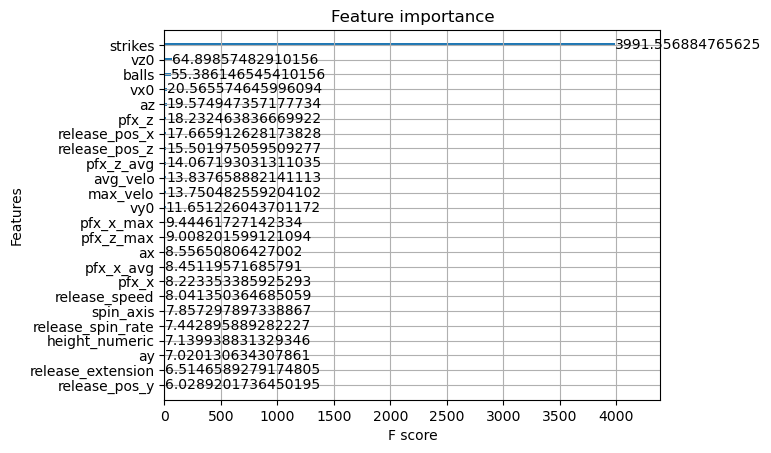

In [34]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

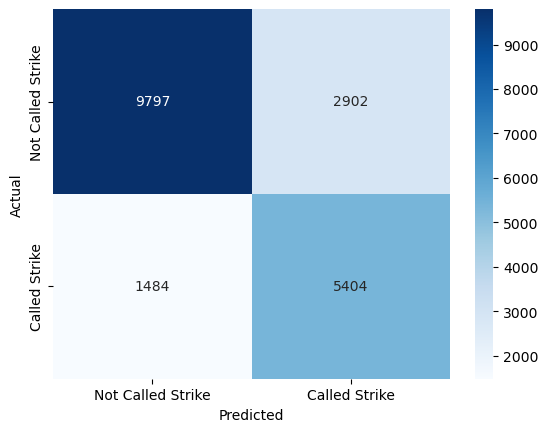

In [35]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [36]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'pfx_x_avg', 'pfx_z_avg', 'avg_velo', 'pfx_x_max', 'pfx_z_max',
       'max_velo', 'height_numeric'],
      dtype='object')

In [37]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [38]:
y_pred = final_model.predict(predictions)

In [39]:
testing_identifiers['xcs'] = y_pred

ValueError: Length of values (452522) does not match length of index (97933)

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/cs_2022&3_xcalledstrike.csv")